In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import random

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

import random

import copy
from sklearn.metrics import classification_report, confusion_matrix

import tarfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import wandb

from glob import glob

import cv2 
import time
from datetime import timedelta, datetime
from PIL import Image
import PIL
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices


In [2]:
SEED_VAL = 7
N_CLASSES_main = 1
N_CLASSES_js = 30



def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
seed_everything(SEED_VAL)

order = torch.randint(low = 1, 
                      high = 31,
                      size = ()) 
print(order.item())


16


In [3]:
!wandb login 9bcca10ca9e53a56c143feea922812a4d99a5dd7

wandb_run = wandb.init(project = f'image_deraining_SSL',
                       name = f'trail_{datetime.now()}')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: vish-tej99 (vish-tej99-fairleigh-dickinson-university). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241026_185356-xgjaio5g
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run trail_2024-10-26 18:53:56.304223


wandb: ⭐️ View project at https://wandb.ai/vish-tej99-fairleigh-dickinson-university/image_deraining_SSL


wandb: 🚀 View run at https://wandb.ai/vish-tej99-fairleigh-dickinson-university/image_deraining_SSL/runs/xgjaio5g


In [4]:
class Custom_dataset_RainDS(Dataset):
    def __init__(self, 
                 base_folder_path: str,
                 transforms = None,
                 mode: str = "train"):
        self.base_folder_path = base_folder_path
        self.transforms = transforms
        self.mode = mode
        
        fPath_GT = os.path.join(base_folder_path, "gt")
        fPath_rdrop = os.path.join(base_folder_path, "raindrop")
        fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
        fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
        
        files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
        files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
        files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
        files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
        
        files_list_GT.sort()
        files_list_rdrop.sort()
        files_list_rstreak.sort()
        files_list_rdrop_rstreak.sort()
        
        self.data = []
        master_SSL_file_list = files_list_GT + files_list_rdrop + files_list_rstreak + files_list_rdrop_rstreak
        print("Number of images : ", len(master_SSL_file_list))
        
        for fname in master_SSL_file_list:
            # 0 : 0 degrees
            # 1 : 90 degrees
            # 2 : 180 degrees
            # 3 : 270 degrees
            for i in range(4):
                self.data.append([fname, i])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname, class_id = self.data[idx]
        img = cv2.imread(fname) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if class_id == 1:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        if class_id == 2:
            img = cv2.rotate(img, cv2.ROTATE_180)
        if class_id ==3:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        if self.transforms:
            img = self.transforms(img)
            
        return {"img": img,
                "class_id": class_id}

class Custom_dataset_stereoImageDataset(Dataset):
    def __init__(self, 
                 files_list: str,
                 transforms = None,
                 mode: str = "train"):
        self.files_list = files_list
        self.transforms = transforms
        self.mode = mode
        
        self.data = []
        master_SSL_file_list = files_list
        print(f"Number of images in {mode} : ", len(master_SSL_file_list))
        
        for fname in master_SSL_file_list:
            # 0 : 0 degrees
            # 1 : 90 degrees
            # 2 : 180 degrees
            # 3 : 270 degrees
            for i in range(4):
                self.data.append([fname, i])
        
    def __len__(self):
        return len(self.data)
    
    def apply_CLAHE(self, img):
        # We first create a CLAHE model based on OpenCV
        # clipLimit defines threshold to limit the contrast in case of noise in our image
        # tileGridSize defines the area size in which local equalization will be performed
        clahe_model = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))

        # For ease of understanding, we explicitly equalize each channel individually
        colorimage_b = clahe_model.apply(img[:,:,0])
        colorimage_g = clahe_model.apply(img[:,:,1])
        colorimage_r = clahe_model.apply(img[:,:,2])

        # Next we stack our equalized channels back into a single image
        colorimage_clahe = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)
        return colorimage_clahe
    
    def __getitem__(self, idx):
        fname, class_id = self.data[idx]
        img = cv2.imread(fname) 
        img = self.apply_CLAHE(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if class_id == 1:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        if class_id == 2:
            img = cv2.rotate(img, cv2.ROTATE_180)
        if class_id ==3:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        if self.transforms:
            img = self.transforms(img)
            
        return {"img": img,
                "class_id": class_id}

In [5]:
# img = cv2.imread("/kaggle/input/deraindrop-and-stereo-image-datasets/Stereo Image Dataset/Stereo Image Dataset/Rain/Rain/Campus_CW_Rain_Day_012/Left/012_L_0011.png")

# # We first create a CLAHE model based on OpenCV
# # clipLimit defines threshold to limit the contrast in case of noise in our image
# # tileGridSize defines the area size in which local equalization will be performed
# clahe_model = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))

# # For ease of understanding, we explicitly equalize each channel individually
# colorimage_b = clahe_model.apply(img[:,:,0])
# colorimage_g = clahe_model.apply(img[:,:,1])
# colorimage_r = clahe_model.apply(img[:,:,2])

# # Next we stack our equalized channels back into a single image
# colorimage_clahe = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)


# plt.imshow(colorimage_clahe)

In [6]:
# all_files_list = glob("/kaggle/input/deraindrop-and-stereo-image-datasets/Stereo Image Dataset/Stereo Image Dataset/**/**/**/**/*.png")
# print("Total number of files: ", len(all_files_list))
# random.shuffle(all_files_list)
# ratio_train = 0.8

# train_files_list, valid_files_list = all_files_list[:int(len(all_files_list)*ratio_train)], all_files_list[int(len(all_files_list)*ratio_train):]
# print("Train set ratio: ", len(train_files_list)/ len(all_files_list))
# print("Train set num_images: ", len(train_files_list))
# print("Validation set ratio: ", len(valid_files_list)/ len(all_files_list))
# print("Validation set num_images: ", len(valid_files_list))

In [7]:
all_files_list_deraindrop = glob("/kaggle/input/deraindrop-and-stereo-image-datasets/Stereo Image Dataset/Stereo Image Dataset/**/**/**/**/*.png")
# print("Total number of files: ", len(all_files_list_deraindrop))
random.shuffle(all_files_list_deraindrop)
ratio_train = 0.8

train_files_list_deraindrop, valid_files_list_deraindrop = all_files_list_deraindrop[:int(len(all_files_list_deraindrop)*ratio_train)], all_files_list_deraindrop[int(len(all_files_list_deraindrop)*ratio_train):]
# print("Train set ratio: ", len(train_files_list_deraindrop)/ len(all_files_list_deraindrop))
# print("Train set num_images: ", len(train_files_list_deraindrop))
# print("Validation set ratio: ", len(valid_files_list_deraindrop)/ len(all_files_list_deraindrop))
# print("Validation set num_images: ", len(valid_files_list_deraindrop))

## Train set
train_list_rainds = glob("/kaggle/input/rainds/RainDS/RainDS_real/train_set/**/*.png")
train_list_gt_rain = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*.png")[:5000]
train_list_deraindrop = train_files_list_deraindrop[:5000]
train_list_all = train_list_rainds + train_list_gt_rain + train_list_deraindrop

## Validation set
valid_list_rainds = glob("/kaggle/input/rainds/RainDS/RainDS_real/test_set/**/*.png")
valid_list_gt_rain = glob("/kaggle/input/gt-rain/Dataset-20240925T185616Z-002/Dataset/GT-RAIN_val/GT-RAIN_val/**/*.png")
valid_list_deraindrop = valid_files_list_deraindrop[:5000]
valid_list_all = valid_list_rainds + valid_list_gt_rain + valid_list_deraindrop

## Test set
test_list_rainds = glob("/kaggle/input/rainds/RainDS/RainDS_real/test_set/**/*.png")
test_list_gt_rain = glob("/kaggle/input/gt-rain/Dataset-20240925T185616Z-002/Dataset/GT-RAIN_test/GT-RAIN_test/**/*.png")
test_list_deraindrop = valid_files_list_deraindrop[5000:10000]
test_list_all = test_list_rainds + test_list_gt_rain + test_list_deraindrop

print(f"Train list: {len(train_list_all)}")
print(f"Valid list: {len(valid_list_all)}")
print(f"Test list: {len(test_list_all)}")

Train list: 10600
Valid list: 7490
Test list: 7499


In [8]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
        transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR)
    ])

BATCH_SIZE = 64
train_ds =  Custom_dataset_stereoImageDataset(files_list = train_list_all, 
                                      transforms = image_transforms,
                                      mode = "train")

valid_ds =  Custom_dataset_stereoImageDataset(files_list = valid_list_all, 
                                      transforms = image_transforms,
                                      mode = "validation")

test_ds =  Custom_dataset_stereoImageDataset(files_list = test_list_all, 
                                      transforms = image_transforms,
                                      mode = "test")

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, BATCH_SIZE, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, BATCH_SIZE, num_workers=4, pin_memory=True)

Number of images in train :  10600
Number of images in validation :  7490


Number of images in test :  7499


In [9]:
idx = 0
img, class_id = train_ds[idx]["img"], train_ds[idx]["class_id"]

In [10]:
print(img.shape)
print(class_id)

torch.Size([3, 224, 224])
0


In [11]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def get_img_by_idx(idx):
    img, _ = train_ds[idx]["img"], train_ds[idx]["class_id"]
    img = torch.unsqueeze(img,0)
    img = denormalize(img, *stats)
    img = torch.squeeze(img, 0)
    img = img.permute(1,2,0).numpy()
    return img

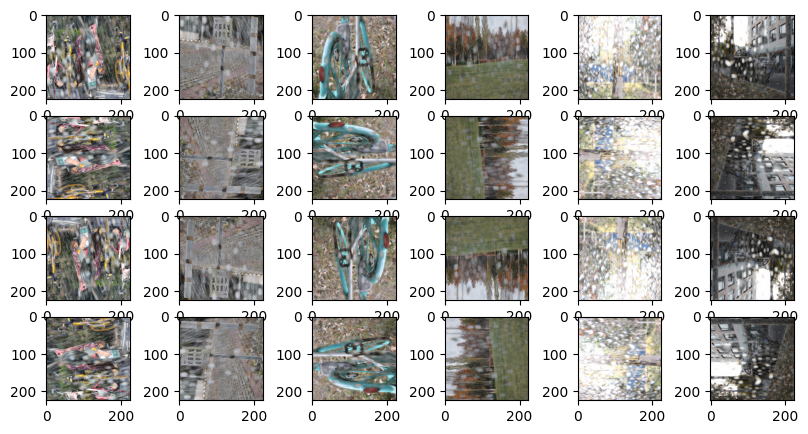

In [12]:
f, axarr = plt.subplots(4,6, figsize = (10,5))
for i in range(6):
    axarr[0,i].imshow(get_img_by_idx(4*i))
    axarr[1,i].imshow(get_img_by_idx(4*i+1))
    axarr[2,i].imshow(get_img_by_idx(4*i+2))
    axarr[3,i].imshow(get_img_by_idx(4*i+3))

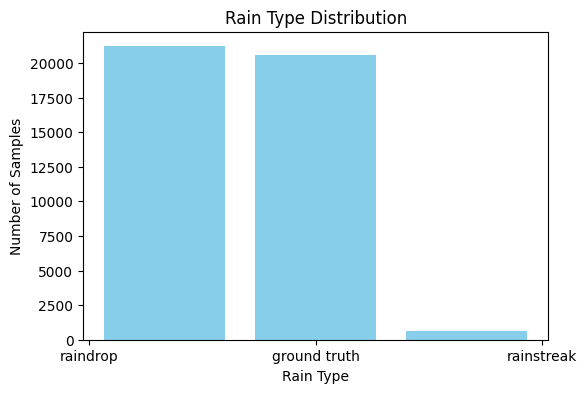

In [13]:
def plot_rain_type_distribution(dataset):
    rain_types = []  # Example rain type labels, assuming you have them
    for i in range(len(dataset)):
        img_path = dataset.data[i][0]  # Get the image path
        # Here, categorize by file path or folder name
        if "raindrop" in img_path:
            rain_types.append("raindrop")
        elif "rainstreak" in img_path:
            rain_types.append("rainstreak")
        elif "rainstreak_raindrop" in img_path:
            rain_types.append("raindrop + streak")
        else:
            rain_types.append("ground truth")

    # Plot the distribution
    plt.figure(figsize=(6, 4))
    plt.hist(rain_types, bins=len(set(rain_types)), rwidth=0.8, color='skyblue')
    plt.title("Rain Type Distribution")
    plt.xlabel("Rain Type")
    plt.ylabel("Number of Samples")
    plt.show()

# Call the function to analyze rain type distribution
plot_rain_type_distribution(train_ds)

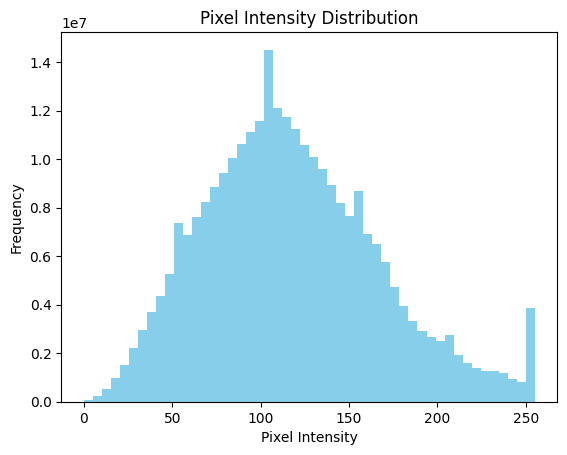

In [14]:
def load_images_to_memory(dataset, num_samples=100):
    # Load a subset of images into memory
    images = []
    for i in range(num_samples):
        img_path = dataset.data[i][0]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
    return images

def plot_pixel_intensity_distribution(images):
    # Flatten and collect pixel values from all images
    pixel_values = [img.flatten() for img in images]
    pixel_values = np.concatenate(pixel_values)  # Flatten into a 1D array

    # Plot histogram
    plt.hist(pixel_values, bins=50, color='skyblue')
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Load images into memory
images_in_memory = load_images_to_memory(train_ds, num_samples=100)

# Plot pixel intensity distribution for the preloaded images
plot_pixel_intensity_distribution(images_in_memory)

In [15]:
class UNet(nn.Module):
    def __init__(self, num_ssl_classes):
        super(UNet, self).__init__()
        self.num_ssl_classes = num_ssl_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        self.avgpool = nn.AdaptiveAvgPool3d((4,4,4))
        self.fc_1 = nn.Linear(64, 32)
        self.do_1 = nn.Dropout(0.4)
        self.fc_2 = nn.Linear(32, 8)
        self.do_2 = nn.Dropout(0.2)
        self.fc_act = nn.LeakyReLU(0.01)
        self.fc_cls = nn.Linear(8, self.num_ssl_classes)
        
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        x = self.avgpool(middle_out)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.fc_1(x)
        x = self.fc_act(x)
        x = self.do_1(x)
        x = self.fc_2(x)
        x = self.fc_act(x)
        x = self.do_2(x)
        x = self.fc_cls(x)
        
        return x

In [16]:
model = UNet(num_ssl_classes = 4)
dummy_input = torch.rand(32, 3, 224, 224)
out = model(dummy_input)
print(f"Input size: {dummy_input.size()}, Output size: {out.size()}")

Input size: torch.Size([32, 3, 224, 224]), Output size: torch.Size([32, 4])


In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
from torch.autograd import Variable
from torchmetrics.classification import BinaryAccuracy, Accuracy

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def calculate_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [20]:
#### For BCEWithLogitsLoss or Focal_loss
acc = Accuracy(task="multiclass", num_classes=4, top_k=1)
from sklearn.metrics import accuracy_score

def train_epoch(epoch, data_loader, model,criterion_cls1, optimizer):
    print('train at epoch {}'.format(epoch))

    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses_cls1 = AverageMeter()
    
    all_outputs = torch.tensor([])
    all_targets = torch.tensor([])
    top1 = AverageMeter()

    end_time = time.time()
    for batch in tqdm(data_loader):
        inputs, targets = batch['img'], batch['class_id']
        data_time.update(time.time() - end_time)

        inputs = inputs.to(device)
        targets = torch.as_tensor(targets, dtype=torch.int64)
        targets = targets.to(device)
        
        out_cls1 = model(inputs)
        # print(out_cls1.shape)
        loss_cls1 = criterion_cls1(out_cls1, targets)
        
        loss =  loss_cls1

        losses_cls1.update(loss_cls1.data, inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_targets = torch.cat((all_targets, targets.detach().clone().cpu()), dim = 0)
        all_outputs = torch.cat((all_outputs, out_cls1.detach().clone().cpu()), dim = 0)
        
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
    all_outputs = torch.sigmoid(all_outputs)
    all_outputs = torch.where(all_outputs > 0.5, 1, 0)
    all_outputs = torch.squeeze(all_outputs, 1)
    
    accuracy = acc(all_outputs.float(), all_targets)
    print(f"train_loss: {losses_cls1.avg.item():.4f}")
    print(f"train_acc: {accuracy.item():.4f}")
    return losses_cls1.avg.item(), accuracy.item()

def evaluate_model(data_loader, model, criterion_cls1, print_cls_report = False):
    model.eval()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses_cls1 = AverageMeter()
    top1 = AverageMeter()

    all_outputs = torch.tensor([])
    all_targets = torch.tensor([])
    end_time = time.time()
    for batch in tqdm(data_loader):
        inputs, targets = batch['img'], batch['class_id']
        data_time.update(time.time() - end_time)
        
        with torch.no_grad():
            inputs = inputs.to(device)
            targets = torch.as_tensor(targets, dtype=torch.int64)
            targets = targets.to(device)
            
            out_cls1 = model(inputs)
            
            loss_cls1 = criterion_cls1(torch.squeeze(out_cls1,1), targets)

            loss =  loss_cls1

            losses_cls1.update(loss_cls1.data, inputs.size(0))

            all_targets = torch.cat((all_targets, targets.detach().clone().cpu()), dim = 0)
            all_outputs = torch.cat((all_outputs, out_cls1.detach().clone().cpu()), dim = 0)

        batch_time.update(time.time() - end_time)
        end_time = time.time()

    accuracy = acc(all_outputs.float(), all_targets)
    
    print(f"valid_loss_cls1: {losses_cls1.avg.item():.4f}")
    print(f"valid_acc: {accuracy:.4f}")
    return losses_cls1.avg.item(), accuracy.item()
    # print(f"valid_acc: {accuracy.item():.4f}")

In [21]:
# criterion = nn.CrossEntropyLoss()
# criterion_cls1 = nn.BCEWithLogitsLoss()
criterion_cls1 = nn.CrossEntropyLoss()
# criterion_cls1 = nn.CrossEntropyLoss()
num_epochs = 50
best_val_loss=1000000
device = get_default_device()
print(device)

model = UNet(num_ssl_classes = 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum = 0.8, weight_decay = 1e-6)

for i in range(num_epochs):
#             adjust_learning_rate(optimizer, i, opt)
    print_flag = False
    train_loss, train_acc = train_epoch(i, train_dl, model, criterion_cls1, optimizer)
#     validation_loss, prec1 = val_epoch(i, valid_dl, model, criterion)
    if(i%2==0):
        print_flag = True
    valid_loss, valid_acc = evaluate_model(valid_dl, model, criterion_cls1, print_cls_report = print_flag)
    wandb_run.log({"epoch": i+1,
               "train_acc": train_acc,
               "train_loss": train_loss,
               "valid_acc": valid_acc,
               "valid_loss": valid_loss})
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        model_weights_save_fpath = "/kaggle/working/final_epoch_model.pt"
        torch.save(model.state_dict(), model_weights_save_fpath)

cuda


train at epoch 0


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:07<1:20:06,  7.26s/it]

  0%|          | 2/663 [00:07<36:02,  3.27s/it]  

  0%|          | 3/663 [00:08<21:57,  2.00s/it]

  1%|          | 4/663 [00:08<15:20,  1.40s/it]

  1%|          | 5/663 [00:10<18:24,  1.68s/it]

  1%|          | 6/663 [00:11<13:54,  1.27s/it]

  1%|          | 7/663 [00:11<11:03,  1.01s/it]

  1%|          | 8/663 [00:12<09:11,  1.19it/s]

  1%|▏         | 9/663 [00:15<16:34,  1.52s/it]

  2%|▏         | 10/663 [00:15<13:03,  1.20s/it]

  2%|▏         | 11/663 [00:16<10:53,  1.00s/it]

  2%|▏         | 12/663 [00:16<09:08,  1.19it/s]

  2%|▏         | 13/663 [00:19<15:50,  1.46s/it]

  2%|▏         | 14/663 [00:20<12:46,  1.18s/it]

  2%|▏         | 15/663 [00:21<11:53,  1.10s/it]

  2%|▏         | 16/663 [00:21<09:51,  1.09it/s]

  3%|▎         | 17/663 [00:24<15:03,  1.40s/it]

  3%|▎         | 18/663 [00:25<13:17,  1.24s/it]

  3%|▎         | 19/663 [00:26<13:06,  1.22s/it]

  3%|▎         | 20/663 [00:26<10:41,  1.00it/s]

  3%|▎         | 21/663 [00:28<13:53,  1.30s/it]

  3%|▎         | 22/663 [00:29<13:16,  1.24s/it]

  3%|▎         | 23/663 [00:31<13:32,  1.27s/it]

  4%|▎         | 24/663 [00:31<10:59,  1.03s/it]

  4%|▍         | 25/663 [00:33<13:06,  1.23s/it]

  4%|▍         | 26/663 [00:34<13:16,  1.25s/it]

  4%|▍         | 27/663 [00:35<13:09,  1.24s/it]

  4%|▍         | 28/663 [00:36<10:43,  1.01s/it]

  4%|▍         | 29/663 [00:38<13:55,  1.32s/it]

  5%|▍         | 30/663 [00:39<12:59,  1.23s/it]

  5%|▍         | 31/663 [00:41<15:08,  1.44s/it]

  5%|▍         | 32/663 [00:41<12:06,  1.15s/it]

  5%|▍         | 33/663 [00:43<13:44,  1.31s/it]

  5%|▌         | 34/663 [00:43<11:06,  1.06s/it]

  5%|▌         | 35/663 [00:45<13:44,  1.31s/it]

  5%|▌         | 36/663 [00:46<11:06,  1.06s/it]

  6%|▌         | 37/663 [00:48<13:46,  1.32s/it]

  6%|▌         | 38/663 [00:48<11:07,  1.07s/it]

  6%|▌         | 39/663 [00:50<13:55,  1.34s/it]

  6%|▌         | 40/663 [00:51<11:13,  1.08s/it]

  6%|▌         | 41/663 [00:53<14:17,  1.38s/it]

  6%|▋         | 42/663 [00:53<11:29,  1.11s/it]

  6%|▋         | 43/663 [00:55<14:14,  1.38s/it]

  7%|▋         | 44/663 [00:56<11:26,  1.11s/it]

  7%|▋         | 45/663 [00:58<14:18,  1.39s/it]

  7%|▋         | 46/663 [00:58<11:28,  1.12s/it]

  7%|▋         | 47/663 [01:00<13:37,  1.33s/it]

  7%|▋         | 48/663 [01:01<11:02,  1.08s/it]

  7%|▋         | 49/663 [01:03<13:45,  1.34s/it]

  8%|▊         | 50/663 [01:03<11:05,  1.09s/it]

  8%|▊         | 51/663 [01:05<15:02,  1.47s/it]

  8%|▊         | 52/663 [01:06<11:58,  1.18s/it]

  8%|▊         | 53/663 [01:07<12:03,  1.19s/it]

  8%|▊         | 54/663 [01:08<09:53,  1.03it/s]

  8%|▊         | 55/663 [01:10<15:53,  1.57s/it]

  8%|▊         | 56/663 [01:11<12:35,  1.24s/it]

  9%|▊         | 57/663 [01:12<13:20,  1.32s/it]

  9%|▊         | 58/663 [01:13<10:46,  1.07s/it]

  9%|▉         | 59/663 [01:15<14:34,  1.45s/it]

  9%|▉         | 60/663 [01:16<11:37,  1.16s/it]

  9%|▉         | 61/663 [01:17<12:22,  1.23s/it]

  9%|▉         | 62/663 [01:18<10:05,  1.01s/it]

 10%|▉         | 63/663 [01:20<13:43,  1.37s/it]

 10%|▉         | 64/663 [01:20<11:01,  1.10s/it]

 10%|▉         | 65/663 [01:22<11:32,  1.16s/it]

 10%|▉         | 66/663 [01:22<09:29,  1.05it/s]

 10%|█         | 67/663 [01:24<11:47,  1.19s/it]

 10%|█         | 68/663 [01:24<09:39,  1.03it/s]

 10%|█         | 69/663 [01:27<13:18,  1.34s/it]

 11%|█         | 70/663 [01:27<10:43,  1.08s/it]

 11%|█         | 71/663 [01:28<11:13,  1.14s/it]

 11%|█         | 72/663 [01:29<09:15,  1.06it/s]

 11%|█         | 73/663 [01:31<13:10,  1.34s/it]

 11%|█         | 74/663 [01:32<10:37,  1.08s/it]

 11%|█▏        | 75/663 [01:34<13:24,  1.37s/it]

 11%|█▏        | 76/663 [01:34<10:46,  1.10s/it]

 12%|█▏        | 77/663 [01:36<11:59,  1.23s/it]

 12%|█▏        | 78/663 [01:36<09:47,  1.00s/it]

 12%|█▏        | 79/663 [01:38<13:51,  1.42s/it]

 12%|█▏        | 80/663 [01:39<11:05,  1.14s/it]

 12%|█▏        | 81/663 [01:40<10:28,  1.08s/it]

 12%|█▏        | 82/663 [01:40<08:42,  1.11it/s]

 13%|█▎        | 83/663 [01:44<16:59,  1.76s/it]

 13%|█▎        | 84/663 [01:45<13:15,  1.37s/it]

 13%|█▎        | 85/663 [01:45<10:40,  1.11s/it]

 13%|█▎        | 86/663 [01:46<08:51,  1.09it/s]

 13%|█▎        | 87/663 [01:49<15:40,  1.63s/it]

 13%|█▎        | 88/663 [01:49<12:19,  1.29s/it]

 13%|█▎        | 89/663 [01:50<09:59,  1.05s/it]

 14%|█▎        | 90/663 [01:50<08:21,  1.14it/s]

 14%|█▎        | 91/663 [01:54<15:02,  1.58s/it]

 14%|█▍        | 92/663 [01:54<11:53,  1.25s/it]

 14%|█▍        | 93/663 [01:54<09:43,  1.02s/it]

 14%|█▍        | 94/663 [01:55<08:10,  1.16it/s]

 14%|█▍        | 95/663 [01:58<15:07,  1.60s/it]

 14%|█▍        | 96/663 [01:59<11:55,  1.26s/it]

 15%|█▍        | 97/663 [01:59<09:42,  1.03s/it]

 15%|█▍        | 98/663 [02:00<08:08,  1.16it/s]

 15%|█▍        | 99/663 [02:03<14:27,  1.54s/it]

 15%|█▌        | 100/663 [02:03<11:26,  1.22s/it]

 15%|█▌        | 101/663 [02:04<09:20,  1.00it/s]

 15%|█▌        | 102/663 [02:04<07:52,  1.19it/s]

 16%|█▌        | 103/663 [02:08<14:50,  1.59s/it]

 16%|█▌        | 104/663 [02:08<11:42,  1.26s/it]

 16%|█▌        | 105/663 [02:09<09:32,  1.03s/it]

 16%|█▌        | 106/663 [02:09<08:00,  1.16it/s]

 16%|█▌        | 107/663 [02:13<15:32,  1.68s/it]

 16%|█▋        | 108/663 [02:13<12:11,  1.32s/it]

 16%|█▋        | 109/663 [02:14<09:51,  1.07s/it]

 17%|█▋        | 110/663 [02:14<08:13,  1.12it/s]

 17%|█▋        | 111/663 [02:17<14:30,  1.58s/it]

 17%|█▋        | 112/663 [02:18<11:27,  1.25s/it]

 17%|█▋        | 113/663 [02:18<09:19,  1.02s/it]

 17%|█▋        | 114/663 [02:19<07:50,  1.17it/s]

 17%|█▋        | 115/663 [02:22<14:32,  1.59s/it]

 17%|█▋        | 116/663 [02:22<11:28,  1.26s/it]

 18%|█▊        | 117/663 [02:23<09:19,  1.02s/it]

 18%|█▊        | 118/663 [02:23<07:49,  1.16it/s]

 18%|█▊        | 119/663 [02:27<14:45,  1.63s/it]

 18%|█▊        | 120/663 [02:27<11:37,  1.28s/it]

 18%|█▊        | 121/663 [02:28<09:25,  1.04s/it]

 18%|█▊        | 122/663 [02:28<07:53,  1.14it/s]

 19%|█▊        | 123/663 [02:31<13:56,  1.55s/it]

 19%|█▊        | 124/663 [02:32<11:01,  1.23s/it]

 19%|█▉        | 125/663 [02:32<09:00,  1.00s/it]

 19%|█▉        | 126/663 [02:33<07:35,  1.18it/s]

 19%|█▉        | 127/663 [02:36<14:31,  1.63s/it]

 19%|█▉        | 128/663 [02:37<11:27,  1.28s/it]

 19%|█▉        | 129/663 [02:37<09:17,  1.04s/it]

 20%|█▉        | 130/663 [02:38<07:46,  1.14it/s]

 20%|█▉        | 131/663 [02:41<13:30,  1.52s/it]

 20%|█▉        | 132/663 [02:41<10:42,  1.21s/it]

 20%|██        | 133/663 [02:42<08:45,  1.01it/s]

 20%|██        | 134/663 [02:42<07:23,  1.19it/s]

 20%|██        | 135/663 [02:46<14:29,  1.65s/it]

 21%|██        | 136/663 [02:46<11:25,  1.30s/it]

 21%|██        | 137/663 [02:47<09:14,  1.05s/it]

 21%|██        | 138/663 [02:47<07:43,  1.13it/s]

 21%|██        | 139/663 [02:50<13:55,  1.59s/it]

 21%|██        | 140/663 [02:51<10:59,  1.26s/it]

 21%|██▏       | 141/663 [02:51<08:56,  1.03s/it]

 21%|██▏       | 142/663 [02:52<07:30,  1.16it/s]

 22%|██▏       | 143/663 [02:55<13:57,  1.61s/it]

 22%|██▏       | 144/663 [02:56<11:00,  1.27s/it]

 22%|██▏       | 145/663 [02:56<08:56,  1.04s/it]

 22%|██▏       | 146/663 [02:57<07:29,  1.15it/s]

 22%|██▏       | 147/663 [03:00<14:01,  1.63s/it]

 22%|██▏       | 148/663 [03:01<11:02,  1.29s/it]

 22%|██▏       | 149/663 [03:01<08:57,  1.05s/it]

 23%|██▎       | 150/663 [03:02<07:29,  1.14it/s]

 23%|██▎       | 151/663 [03:05<13:12,  1.55s/it]

 23%|██▎       | 152/663 [03:05<10:26,  1.23s/it]

 23%|██▎       | 153/663 [03:06<08:33,  1.01s/it]

 23%|██▎       | 154/663 [03:06<07:12,  1.18it/s]

 23%|██▎       | 155/663 [03:10<13:30,  1.60s/it]

 24%|██▎       | 156/663 [03:10<10:39,  1.26s/it]

 24%|██▎       | 157/663 [03:10<08:40,  1.03s/it]

 24%|██▍       | 158/663 [03:11<07:16,  1.16it/s]

 24%|██▍       | 159/663 [03:15<14:22,  1.71s/it]

 24%|██▍       | 160/663 [03:15<11:14,  1.34s/it]

 24%|██▍       | 161/663 [03:16<09:04,  1.08s/it]

 24%|██▍       | 162/663 [03:16<07:32,  1.11it/s]

 25%|██▍       | 163/663 [03:20<14:14,  1.71s/it]

 25%|██▍       | 164/663 [03:20<11:11,  1.34s/it]

 25%|██▍       | 165/663 [03:21<09:01,  1.09s/it]

 25%|██▌       | 166/663 [03:21<07:31,  1.10it/s]

 25%|██▌       | 167/663 [03:25<14:32,  1.76s/it]

 25%|██▌       | 168/663 [03:25<11:21,  1.38s/it]

 25%|██▌       | 169/663 [03:26<09:08,  1.11s/it]

 26%|██▌       | 170/663 [03:26<07:33,  1.09it/s]

 26%|██▌       | 171/663 [03:29<12:33,  1.53s/it]

 26%|██▌       | 172/663 [03:30<09:57,  1.22s/it]

 26%|██▌       | 173/663 [03:30<08:09,  1.00it/s]

 26%|██▌       | 174/663 [03:31<06:53,  1.18it/s]

 26%|██▋       | 175/663 [03:34<11:38,  1.43s/it]

 27%|██▋       | 176/663 [03:34<09:19,  1.15s/it]

 27%|██▋       | 177/663 [03:35<07:41,  1.05it/s]

 27%|██▋       | 178/663 [03:35<06:34,  1.23it/s]

 27%|██▋       | 179/663 [03:38<12:29,  1.55s/it]

 27%|██▋       | 180/663 [03:39<09:53,  1.23s/it]

 27%|██▋       | 181/663 [03:39<08:04,  1.00s/it]

 27%|██▋       | 182/663 [03:40<06:49,  1.17it/s]

 28%|██▊       | 183/663 [03:43<12:21,  1.55s/it]

 28%|██▊       | 184/663 [03:43<09:47,  1.23s/it]

 28%|██▊       | 185/663 [03:44<07:59,  1.00s/it]

 28%|██▊       | 186/663 [03:44<06:45,  1.18it/s]

 28%|██▊       | 187/663 [03:48<12:25,  1.57s/it]

 28%|██▊       | 188/663 [03:48<09:49,  1.24s/it]

 29%|██▊       | 189/663 [03:49<08:00,  1.01s/it]

 29%|██▊       | 190/663 [03:49<06:45,  1.17it/s]

 29%|██▉       | 191/663 [03:53<13:12,  1.68s/it]

 29%|██▉       | 192/663 [03:53<10:22,  1.32s/it]

 29%|██▉       | 193/663 [03:54<08:22,  1.07s/it]

 29%|██▉       | 194/663 [03:54<06:59,  1.12it/s]

 29%|██▉       | 195/663 [03:57<12:30,  1.60s/it]

 30%|██▉       | 196/663 [03:58<09:53,  1.27s/it]

 30%|██▉       | 197/663 [03:58<08:02,  1.04s/it]

 30%|██▉       | 198/663 [03:59<06:44,  1.15it/s]

 30%|███       | 199/663 [04:02<11:33,  1.50s/it]

 30%|███       | 200/663 [04:02<09:11,  1.19s/it]

 30%|███       | 201/663 [04:03<07:32,  1.02it/s]

 30%|███       | 202/663 [04:03<06:23,  1.20it/s]

 31%|███       | 203/663 [04:06<11:26,  1.49s/it]

 31%|███       | 204/663 [04:07<09:05,  1.19s/it]

 31%|███       | 205/663 [04:07<07:26,  1.02it/s]

 31%|███       | 206/663 [04:08<06:17,  1.21it/s]

 31%|███       | 207/663 [04:11<11:54,  1.57s/it]

 31%|███▏      | 208/663 [04:11<09:24,  1.24s/it]

 32%|███▏      | 209/663 [04:12<07:40,  1.01s/it]

 32%|███▏      | 210/663 [04:12<06:28,  1.17it/s]

 32%|███▏      | 211/663 [04:16<12:58,  1.72s/it]

 32%|███▏      | 212/663 [04:17<10:09,  1.35s/it]

 32%|███▏      | 213/663 [04:17<08:12,  1.09s/it]

 32%|███▏      | 214/663 [04:18<06:48,  1.10it/s]

 32%|███▏      | 215/663 [04:21<12:03,  1.61s/it]

 33%|███▎      | 216/663 [04:21<09:29,  1.27s/it]

 33%|███▎      | 217/663 [04:22<07:41,  1.04s/it]

 33%|███▎      | 218/663 [04:22<06:28,  1.15it/s]

 33%|███▎      | 219/663 [04:26<11:39,  1.57s/it]

 33%|███▎      | 220/663 [04:26<09:12,  1.25s/it]

 33%|███▎      | 221/663 [04:27<07:30,  1.02s/it]

 33%|███▎      | 222/663 [04:27<06:18,  1.17it/s]

 34%|███▎      | 223/663 [04:30<10:48,  1.47s/it]

 34%|███▍      | 224/663 [04:31<09:10,  1.25s/it]

 34%|███▍      | 225/663 [04:31<07:28,  1.02s/it]

 34%|███▍      | 226/663 [04:32<06:16,  1.16it/s]

 34%|███▍      | 227/663 [04:35<10:52,  1.50s/it]

 34%|███▍      | 228/663 [04:35<09:19,  1.29s/it]

 35%|███▍      | 229/663 [04:36<07:34,  1.05s/it]

 35%|███▍      | 230/663 [04:36<06:20,  1.14it/s]

 35%|███▍      | 231/663 [04:39<09:47,  1.36s/it]

 35%|███▍      | 232/663 [04:40<09:55,  1.38s/it]

 35%|███▌      | 233/663 [04:41<07:58,  1.11s/it]

 35%|███▌      | 234/663 [04:41<06:36,  1.08it/s]

 35%|███▌      | 235/663 [04:43<09:00,  1.26s/it]

 36%|███▌      | 236/663 [04:45<08:45,  1.23s/it]

 36%|███▌      | 237/663 [04:45<07:08,  1.01s/it]

 36%|███▌      | 238/663 [04:45<06:00,  1.18it/s]

 36%|███▌      | 239/663 [04:49<10:52,  1.54s/it]

 36%|███▌      | 240/663 [04:50<09:46,  1.39s/it]

 36%|███▋      | 241/663 [04:50<07:51,  1.12s/it]

 37%|███▋      | 242/663 [04:51<06:30,  1.08it/s]

 37%|███▋      | 243/663 [04:53<09:30,  1.36s/it]

 37%|███▋      | 244/663 [04:55<09:53,  1.42s/it]

 37%|███▋      | 245/663 [04:55<07:55,  1.14s/it]

 37%|███▋      | 246/663 [04:56<06:32,  1.06it/s]

 37%|███▋      | 247/663 [04:58<10:02,  1.45s/it]

 37%|███▋      | 248/663 [05:00<10:15,  1.48s/it]

 38%|███▊      | 249/663 [05:00<08:09,  1.18s/it]

 38%|███▊      | 250/663 [05:01<06:42,  1.03it/s]

 38%|███▊      | 251/663 [05:03<09:24,  1.37s/it]

 38%|███▊      | 252/663 [05:04<09:14,  1.35s/it]

 38%|███▊      | 253/663 [05:05<07:37,  1.12s/it]

 38%|███▊      | 254/663 [05:05<06:18,  1.08it/s]

 38%|███▊      | 255/663 [05:08<09:19,  1.37s/it]

 39%|███▊      | 256/663 [05:09<09:06,  1.34s/it]

 39%|███▉      | 257/663 [05:10<07:20,  1.09s/it]

 39%|███▉      | 258/663 [05:10<06:06,  1.11it/s]

 39%|███▉      | 259/663 [05:13<09:53,  1.47s/it]

 39%|███▉      | 260/663 [05:14<08:29,  1.26s/it]

 39%|███▉      | 261/663 [05:14<07:12,  1.08s/it]

 40%|███▉      | 262/663 [05:15<06:00,  1.11it/s]

 40%|███▉      | 263/663 [05:17<09:25,  1.41s/it]

 40%|███▉      | 264/663 [05:19<08:59,  1.35s/it]

 40%|███▉      | 265/663 [05:19<07:55,  1.20s/it]

 40%|████      | 266/663 [05:20<06:30,  1.02it/s]

 40%|████      | 267/663 [05:22<09:22,  1.42s/it]

 40%|████      | 268/663 [05:23<08:51,  1.34s/it]

 41%|████      | 269/663 [05:24<07:15,  1.11s/it]

 41%|████      | 270/663 [05:24<06:01,  1.09it/s]

 41%|████      | 271/663 [05:27<09:41,  1.48s/it]

 41%|████      | 272/663 [05:28<08:13,  1.26s/it]

 41%|████      | 273/663 [05:29<06:43,  1.03s/it]

 41%|████▏     | 274/663 [05:29<05:37,  1.15it/s]

 41%|████▏     | 275/663 [05:32<09:50,  1.52s/it]

 42%|████▏     | 276/663 [05:33<09:36,  1.49s/it]

 42%|████▏     | 277/663 [05:34<07:38,  1.19s/it]

 42%|████▏     | 278/663 [05:34<06:15,  1.03it/s]

 42%|████▏     | 279/663 [05:37<09:08,  1.43s/it]

 42%|████▏     | 280/663 [05:38<08:54,  1.40s/it]

 42%|████▏     | 281/663 [05:39<07:08,  1.12s/it]

 43%|████▎     | 282/663 [05:39<05:54,  1.08it/s]

 43%|████▎     | 283/663 [05:41<08:12,  1.30s/it]

 43%|████▎     | 284/663 [05:43<09:09,  1.45s/it]

 43%|████▎     | 285/663 [05:44<07:19,  1.16s/it]

 43%|████▎     | 286/663 [05:44<06:01,  1.04it/s]

 43%|████▎     | 287/663 [05:46<08:05,  1.29s/it]

 43%|████▎     | 288/663 [05:48<08:34,  1.37s/it]

 44%|████▎     | 289/663 [05:48<06:52,  1.10s/it]

 44%|████▎     | 290/663 [05:49<05:41,  1.09it/s]

 44%|████▍     | 291/663 [05:51<08:09,  1.32s/it]

 44%|████▍     | 292/663 [05:52<07:48,  1.26s/it]

 44%|████▍     | 293/663 [05:53<06:20,  1.03s/it]

 44%|████▍     | 294/663 [05:53<05:18,  1.16it/s]

 44%|████▍     | 295/663 [05:56<08:50,  1.44s/it]

 45%|████▍     | 296/663 [05:57<07:31,  1.23s/it]

 45%|████▍     | 297/663 [05:57<06:32,  1.07s/it]

 45%|████▍     | 298/663 [05:58<05:26,  1.12it/s]

 45%|████▌     | 299/663 [06:01<08:51,  1.46s/it]

 45%|████▌     | 300/663 [06:01<07:04,  1.17s/it]

 45%|████▌     | 301/663 [06:02<05:50,  1.03it/s]

 46%|████▌     | 302/663 [06:02<04:57,  1.21it/s]

 46%|████▌     | 303/663 [06:06<09:52,  1.65s/it]

 46%|████▌     | 304/663 [06:06<07:49,  1.31s/it]

 46%|████▌     | 305/663 [06:07<06:18,  1.06s/it]

 46%|████▌     | 306/663 [06:07<05:15,  1.13it/s]

 46%|████▋     | 307/663 [06:10<09:30,  1.60s/it]

 46%|████▋     | 308/663 [06:11<07:29,  1.27s/it]

 47%|████▋     | 309/663 [06:11<06:04,  1.03s/it]

 47%|████▋     | 310/663 [06:12<05:05,  1.16it/s]

 47%|████▋     | 311/663 [06:15<08:56,  1.52s/it]

 47%|████▋     | 312/663 [06:15<07:05,  1.21s/it]

 47%|████▋     | 313/663 [06:16<05:47,  1.01it/s]

 47%|████▋     | 314/663 [06:16<04:52,  1.19it/s]

 48%|████▊     | 315/663 [06:19<08:54,  1.53s/it]

 48%|████▊     | 316/663 [06:20<07:02,  1.22s/it]

 48%|████▊     | 317/663 [06:20<05:44,  1.00it/s]

 48%|████▊     | 318/663 [06:21<04:50,  1.19it/s]

 48%|████▊     | 319/663 [06:24<09:02,  1.58s/it]

 48%|████▊     | 320/663 [06:25<07:46,  1.36s/it]

 48%|████▊     | 321/663 [06:26<06:16,  1.10s/it]

 49%|████▊     | 322/663 [06:26<05:12,  1.09it/s]

 49%|████▊     | 323/663 [06:29<08:08,  1.44s/it]

 49%|████▉     | 324/663 [06:30<07:27,  1.32s/it]

 49%|████▉     | 325/663 [06:30<06:02,  1.07s/it]

 49%|████▉     | 326/663 [06:31<05:01,  1.12it/s]

 49%|████▉     | 327/663 [06:33<06:41,  1.19s/it]

 49%|████▉     | 328/663 [06:35<08:24,  1.51s/it]

 50%|████▉     | 329/663 [06:35<06:40,  1.20s/it]

 50%|████▉     | 330/663 [06:36<05:28,  1.01it/s]

 50%|████▉     | 331/663 [06:37<06:16,  1.13s/it]

 50%|█████     | 332/663 [06:40<09:14,  1.68s/it]

 50%|█████     | 333/663 [06:41<07:14,  1.32s/it]

 50%|█████     | 334/663 [06:41<05:51,  1.07s/it]

 51%|█████     | 335/663 [06:42<05:44,  1.05s/it]

 51%|█████     | 336/663 [06:45<08:46,  1.61s/it]

 51%|█████     | 337/663 [06:46<06:54,  1.27s/it]

 51%|█████     | 338/663 [06:46<05:35,  1.03s/it]

 51%|█████     | 339/663 [06:47<05:14,  1.03it/s]

 51%|█████▏    | 340/663 [06:50<08:34,  1.59s/it]

 51%|█████▏    | 341/663 [06:50<06:46,  1.26s/it]

 52%|█████▏    | 342/663 [06:51<05:30,  1.03s/it]

 52%|█████▏    | 343/663 [06:51<04:36,  1.16it/s]

 52%|█████▏    | 344/663 [06:54<07:44,  1.46s/it]

 52%|█████▏    | 345/663 [06:55<06:10,  1.16s/it]

 52%|█████▏    | 346/663 [06:55<05:04,  1.04it/s]

 52%|█████▏    | 347/663 [06:56<04:17,  1.23it/s]

 52%|█████▏    | 348/663 [06:59<08:19,  1.59s/it]

 53%|█████▎    | 349/663 [07:00<06:34,  1.26s/it]

 53%|█████▎    | 350/663 [07:00<05:20,  1.02s/it]

 53%|█████▎    | 351/663 [07:01<04:29,  1.16it/s]

 53%|█████▎    | 352/663 [07:04<08:50,  1.71s/it]

 53%|█████▎    | 353/663 [07:05<06:55,  1.34s/it]

 53%|█████▎    | 354/663 [07:05<05:33,  1.08s/it]

 54%|█████▎    | 355/663 [07:06<04:38,  1.11it/s]

 54%|█████▎    | 356/663 [07:09<09:00,  1.76s/it]

 54%|█████▍    | 357/663 [07:10<07:01,  1.38s/it]

 54%|█████▍    | 358/663 [07:10<05:37,  1.11s/it]

 54%|█████▍    | 359/663 [07:11<04:39,  1.09it/s]

 54%|█████▍    | 360/663 [07:14<08:06,  1.60s/it]

 54%|█████▍    | 361/663 [07:15<06:22,  1.27s/it]

 55%|█████▍    | 362/663 [07:15<05:10,  1.03s/it]

 55%|█████▍    | 363/663 [07:15<04:20,  1.15it/s]

 55%|█████▍    | 364/663 [07:19<07:52,  1.58s/it]

 55%|█████▌    | 365/663 [07:19<06:12,  1.25s/it]

 55%|█████▌    | 366/663 [07:20<05:03,  1.02s/it]

 55%|█████▌    | 367/663 [07:20<04:14,  1.16it/s]

 56%|█████▌    | 368/663 [07:24<07:52,  1.60s/it]

 56%|█████▌    | 369/663 [07:24<06:12,  1.27s/it]

 56%|█████▌    | 370/663 [07:24<05:01,  1.03s/it]

 56%|█████▌    | 371/663 [07:25<04:12,  1.16it/s]

 56%|█████▌    | 372/663 [07:28<07:55,  1.64s/it]

 56%|█████▋    | 373/663 [07:29<06:14,  1.29s/it]

 56%|█████▋    | 374/663 [07:29<05:03,  1.05s/it]

 57%|█████▋    | 375/663 [07:30<04:13,  1.14it/s]

 57%|█████▋    | 376/663 [07:33<07:41,  1.61s/it]

 57%|█████▋    | 377/663 [07:34<06:03,  1.27s/it]

 57%|█████▋    | 378/663 [07:34<04:54,  1.03s/it]

 57%|█████▋    | 379/663 [07:35<04:06,  1.15it/s]

 57%|█████▋    | 380/663 [07:37<06:42,  1.42s/it]

 57%|█████▋    | 381/663 [07:38<05:21,  1.14s/it]

 58%|█████▊    | 382/663 [07:38<04:24,  1.06it/s]

 58%|█████▊    | 383/663 [07:39<03:46,  1.24it/s]

 58%|█████▊    | 384/663 [07:42<07:34,  1.63s/it]

 58%|█████▊    | 385/663 [07:43<05:56,  1.28s/it]

 58%|█████▊    | 386/663 [07:43<04:49,  1.04s/it]

 58%|█████▊    | 387/663 [07:44<04:02,  1.14it/s]

 59%|█████▊    | 388/663 [07:47<07:46,  1.69s/it]

 59%|█████▊    | 389/663 [07:48<06:05,  1.33s/it]

 59%|█████▉    | 390/663 [07:48<04:54,  1.08s/it]

 59%|█████▉    | 391/663 [07:49<04:05,  1.11it/s]

 59%|█████▉    | 392/663 [07:52<07:09,  1.58s/it]

 59%|█████▉    | 393/663 [07:52<05:38,  1.25s/it]

 59%|█████▉    | 394/663 [07:53<04:34,  1.02s/it]

 60%|█████▉    | 395/663 [07:53<03:50,  1.16it/s]

 60%|█████▉    | 396/663 [07:56<06:41,  1.50s/it]

 60%|█████▉    | 397/663 [07:57<05:19,  1.20s/it]

 60%|██████    | 398/663 [07:57<04:20,  1.02it/s]

 60%|██████    | 399/663 [07:58<03:40,  1.20it/s]

 60%|██████    | 400/663 [08:01<06:18,  1.44s/it]

 60%|██████    | 401/663 [08:01<05:02,  1.15s/it]

 61%|██████    | 402/663 [08:02<04:08,  1.05it/s]

 61%|██████    | 403/663 [08:02<03:30,  1.24it/s]

 61%|██████    | 404/663 [08:05<06:32,  1.51s/it]

 61%|██████    | 405/663 [08:06<05:10,  1.20s/it]

 61%|██████    | 406/663 [08:06<04:13,  1.01it/s]

 61%|██████▏   | 407/663 [08:07<03:34,  1.19it/s]

 62%|██████▏   | 408/663 [08:10<06:28,  1.52s/it]

 62%|██████▏   | 409/663 [08:10<05:07,  1.21s/it]

 62%|██████▏   | 410/663 [08:11<04:12,  1.00it/s]

 62%|██████▏   | 411/663 [08:11<03:31,  1.19it/s]

 62%|██████▏   | 412/663 [08:15<06:53,  1.65s/it]

 62%|██████▏   | 413/663 [08:15<05:24,  1.30s/it]

 62%|██████▏   | 414/663 [08:16<04:22,  1.05s/it]

 63%|██████▎   | 415/663 [08:16<03:38,  1.13it/s]

 63%|██████▎   | 416/663 [08:19<06:15,  1.52s/it]

 63%|██████▎   | 417/663 [08:20<04:58,  1.21s/it]

 63%|██████▎   | 418/663 [08:20<04:03,  1.01it/s]

 63%|██████▎   | 419/663 [08:21<03:24,  1.19it/s]

 63%|██████▎   | 420/663 [08:24<05:47,  1.43s/it]

 63%|██████▎   | 421/663 [08:24<04:36,  1.14s/it]

 64%|██████▎   | 422/663 [08:25<03:48,  1.06it/s]

 64%|██████▍   | 423/663 [08:25<03:14,  1.23it/s]

 64%|██████▍   | 424/663 [08:28<05:29,  1.38s/it]

 64%|██████▍   | 425/663 [08:29<04:39,  1.17s/it]

 64%|██████▍   | 426/663 [08:29<03:49,  1.03it/s]

 64%|██████▍   | 427/663 [08:29<03:14,  1.21it/s]

 65%|██████▍   | 428/663 [08:32<05:28,  1.40s/it]

 65%|██████▍   | 429/663 [08:33<04:46,  1.22s/it]

 65%|██████▍   | 430/663 [08:34<03:53,  1.00s/it]

 65%|██████▌   | 431/663 [08:34<03:16,  1.18it/s]

 65%|██████▌   | 432/663 [08:37<05:22,  1.40s/it]

 65%|██████▌   | 433/663 [08:37<04:24,  1.15s/it]

 65%|██████▌   | 434/663 [08:38<03:37,  1.05it/s]

 66%|██████▌   | 435/663 [08:38<03:04,  1.24it/s]

 66%|██████▌   | 436/663 [08:41<05:48,  1.54s/it]

 66%|██████▌   | 437/663 [08:42<04:36,  1.22s/it]

 66%|██████▌   | 438/663 [08:42<03:44,  1.00it/s]

 66%|██████▌   | 439/663 [08:43<03:09,  1.18it/s]

 66%|██████▋   | 440/663 [08:46<05:49,  1.57s/it]

 67%|██████▋   | 441/663 [08:47<05:10,  1.40s/it]

 67%|██████▋   | 442/663 [08:48<04:08,  1.13s/it]

 67%|██████▋   | 443/663 [08:48<03:25,  1.07it/s]

 67%|██████▋   | 444/663 [08:51<05:01,  1.38s/it]

 67%|██████▋   | 445/663 [08:52<05:00,  1.38s/it]

 67%|██████▋   | 446/663 [08:52<04:00,  1.11s/it]

 67%|██████▋   | 447/663 [08:53<03:19,  1.08it/s]

 68%|██████▊   | 448/663 [08:56<05:12,  1.45s/it]

 68%|██████▊   | 449/663 [08:56<04:22,  1.22s/it]

 68%|██████▊   | 450/663 [08:57<03:33,  1.00s/it]

 68%|██████▊   | 451/663 [08:57<02:59,  1.18it/s]

 68%|██████▊   | 452/663 [09:00<04:56,  1.41s/it]

 68%|██████▊   | 453/663 [09:01<04:26,  1.27s/it]

 68%|██████▊   | 454/663 [09:01<03:36,  1.03s/it]

 69%|██████▊   | 455/663 [09:02<03:00,  1.15it/s]

 69%|██████▉   | 456/663 [09:05<05:09,  1.50s/it]

 69%|██████▉   | 457/663 [09:05<04:05,  1.19s/it]

 69%|██████▉   | 458/663 [09:06<03:20,  1.02it/s]

 69%|██████▉   | 459/663 [09:06<02:49,  1.20it/s]

 69%|██████▉   | 460/663 [09:09<05:13,  1.54s/it]

 70%|██████▉   | 461/663 [09:10<04:18,  1.28s/it]

 70%|██████▉   | 462/663 [09:11<03:29,  1.04s/it]

 70%|██████▉   | 463/663 [09:11<02:55,  1.14it/s]

 70%|██████▉   | 464/663 [09:15<05:30,  1.66s/it]

 70%|███████   | 465/663 [09:15<04:19,  1.31s/it]

 70%|███████   | 466/663 [09:16<03:28,  1.06s/it]

 70%|███████   | 467/663 [09:16<02:54,  1.12it/s]

 71%|███████   | 468/663 [09:20<05:22,  1.65s/it]

 71%|███████   | 469/663 [09:20<04:12,  1.30s/it]

 71%|███████   | 470/663 [09:20<03:24,  1.06s/it]

 71%|███████   | 471/663 [09:21<02:49,  1.13it/s]

 71%|███████   | 472/663 [09:24<05:17,  1.66s/it]

 71%|███████▏  | 473/663 [09:25<04:08,  1.31s/it]

 71%|███████▏  | 474/663 [09:25<03:20,  1.06s/it]

 72%|███████▏  | 475/663 [09:26<02:46,  1.13it/s]

 72%|███████▏  | 476/663 [09:29<05:12,  1.67s/it]

 72%|███████▏  | 477/663 [09:30<04:05,  1.32s/it]

 72%|███████▏  | 478/663 [09:30<03:17,  1.07s/it]

 72%|███████▏  | 479/663 [09:31<02:44,  1.12it/s]

 72%|███████▏  | 480/663 [09:34<05:02,  1.65s/it]

 73%|███████▎  | 481/663 [09:35<03:56,  1.30s/it]

 73%|███████▎  | 482/663 [09:35<03:11,  1.06s/it]

 73%|███████▎  | 483/663 [09:36<02:39,  1.13it/s]

 73%|███████▎  | 484/663 [09:39<04:53,  1.64s/it]

 73%|███████▎  | 485/663 [09:40<03:50,  1.29s/it]

 73%|███████▎  | 486/663 [09:40<03:05,  1.05s/it]

 73%|███████▎  | 487/663 [09:41<02:34,  1.14it/s]

 74%|███████▎  | 488/663 [09:44<04:46,  1.64s/it]

 74%|███████▍  | 489/663 [09:44<03:44,  1.29s/it]

 74%|███████▍  | 490/663 [09:45<03:01,  1.05s/it]

 74%|███████▍  | 491/663 [09:45<02:31,  1.14it/s]

 74%|███████▍  | 492/663 [09:48<04:09,  1.46s/it]

 74%|███████▍  | 493/663 [09:49<03:18,  1.17s/it]

 75%|███████▍  | 494/663 [09:49<02:42,  1.04it/s]

 75%|███████▍  | 495/663 [09:50<02:17,  1.22it/s]

 75%|███████▍  | 496/663 [09:53<04:23,  1.58s/it]

 75%|███████▍  | 497/663 [09:54<03:27,  1.25s/it]

 75%|███████▌  | 498/663 [09:54<02:47,  1.02s/it]

 75%|███████▌  | 499/663 [09:54<02:20,  1.17it/s]

 75%|███████▌  | 500/663 [09:58<04:24,  1.63s/it]

 76%|███████▌  | 501/663 [09:58<03:27,  1.28s/it]

 76%|███████▌  | 502/663 [09:59<02:48,  1.04s/it]

 76%|███████▌  | 503/663 [09:59<02:19,  1.14it/s]

 76%|███████▌  | 504/663 [10:03<04:09,  1.57s/it]

 76%|███████▌  | 505/663 [10:03<03:16,  1.25s/it]

 76%|███████▋  | 506/663 [10:04<02:39,  1.02s/it]

 76%|███████▋  | 507/663 [10:04<02:14,  1.16it/s]

 77%|███████▋  | 508/663 [10:07<04:07,  1.60s/it]

 77%|███████▋  | 509/663 [10:08<03:14,  1.26s/it]

 77%|███████▋  | 510/663 [10:08<02:37,  1.03s/it]

 77%|███████▋  | 511/663 [10:09<02:11,  1.15it/s]

 77%|███████▋  | 512/663 [10:12<03:47,  1.51s/it]

 77%|███████▋  | 513/663 [10:12<03:00,  1.20s/it]

 78%|███████▊  | 514/663 [10:13<02:26,  1.01it/s]

 78%|███████▊  | 515/663 [10:13<02:03,  1.20it/s]

 78%|███████▊  | 516/663 [10:16<03:45,  1.53s/it]

 78%|███████▊  | 517/663 [10:17<02:57,  1.22s/it]

 78%|███████▊  | 518/663 [10:17<02:24,  1.00it/s]

 78%|███████▊  | 519/663 [10:18<02:09,  1.12it/s]

 78%|███████▊  | 520/663 [10:22<04:10,  1.75s/it]

 79%|███████▊  | 521/663 [10:22<03:14,  1.37s/it]

 79%|███████▊  | 522/663 [10:23<02:35,  1.11s/it]

 79%|███████▉  | 523/663 [10:23<02:08,  1.09it/s]

 79%|███████▉  | 524/663 [10:26<03:37,  1.57s/it]

 79%|███████▉  | 525/663 [10:27<02:51,  1.24s/it]

 79%|███████▉  | 526/663 [10:27<02:18,  1.01s/it]

 79%|███████▉  | 527/663 [10:28<01:56,  1.17it/s]

 80%|███████▉  | 528/663 [10:31<03:27,  1.54s/it]

 80%|███████▉  | 529/663 [10:31<02:44,  1.22s/it]

 80%|███████▉  | 530/663 [10:32<02:13,  1.00s/it]

 80%|████████  | 531/663 [10:32<01:51,  1.18it/s]

 80%|████████  | 532/663 [10:36<03:33,  1.63s/it]

 80%|████████  | 533/663 [10:36<02:46,  1.28s/it]

 81%|████████  | 534/663 [10:37<02:14,  1.04s/it]

 81%|████████  | 535/663 [10:37<01:52,  1.14it/s]

 81%|████████  | 536/663 [10:40<03:11,  1.51s/it]

 81%|████████  | 537/663 [10:41<02:31,  1.20s/it]

 81%|████████  | 538/663 [10:41<02:03,  1.01it/s]

 81%|████████▏ | 539/663 [10:42<01:44,  1.19it/s]

 81%|████████▏ | 540/663 [10:45<02:57,  1.44s/it]

 82%|████████▏ | 541/663 [10:45<02:20,  1.16s/it]

 82%|████████▏ | 542/663 [10:46<01:55,  1.05it/s]

 82%|████████▏ | 543/663 [10:46<01:37,  1.23it/s]

 82%|████████▏ | 544/663 [10:49<03:05,  1.56s/it]

 82%|████████▏ | 545/663 [10:50<02:26,  1.24s/it]

 82%|████████▏ | 546/663 [10:50<01:58,  1.02s/it]

 83%|████████▎ | 547/663 [10:51<01:39,  1.17it/s]

 83%|████████▎ | 548/663 [10:55<03:19,  1.74s/it]

 83%|████████▎ | 549/663 [10:55<02:35,  1.37s/it]

 83%|████████▎ | 550/663 [10:56<02:04,  1.10s/it]

 83%|████████▎ | 551/663 [10:56<01:42,  1.09it/s]

 83%|████████▎ | 552/663 [11:00<03:16,  1.77s/it]

 83%|████████▎ | 553/663 [11:00<02:32,  1.38s/it]

 84%|████████▎ | 554/663 [11:01<02:01,  1.11s/it]

 84%|████████▎ | 555/663 [11:01<01:40,  1.08it/s]

 84%|████████▍ | 556/663 [11:04<02:48,  1.58s/it]

 84%|████████▍ | 557/663 [11:05<02:12,  1.25s/it]

 84%|████████▍ | 558/663 [11:05<01:46,  1.02s/it]

 84%|████████▍ | 559/663 [11:06<01:29,  1.17it/s]

 84%|████████▍ | 560/663 [11:09<02:41,  1.57s/it]

 85%|████████▍ | 561/663 [11:10<02:06,  1.24s/it]

 85%|████████▍ | 562/663 [11:10<01:42,  1.02s/it]

 85%|████████▍ | 563/663 [11:10<01:25,  1.17it/s]

 85%|████████▌ | 564/663 [11:14<02:31,  1.53s/it]

 85%|████████▌ | 565/663 [11:14<01:59,  1.21s/it]

 85%|████████▌ | 566/663 [11:15<01:36,  1.00it/s]

 86%|████████▌ | 567/663 [11:15<01:20,  1.19it/s]

 86%|████████▌ | 568/663 [11:19<02:35,  1.64s/it]

 86%|████████▌ | 569/663 [11:19<02:01,  1.29s/it]

 86%|████████▌ | 570/663 [11:19<01:37,  1.05s/it]

 86%|████████▌ | 571/663 [11:20<01:20,  1.14it/s]

 86%|████████▋ | 572/663 [11:23<02:21,  1.56s/it]

 86%|████████▋ | 573/663 [11:24<01:50,  1.23s/it]

 87%|████████▋ | 574/663 [11:24<01:29,  1.01s/it]

 87%|████████▋ | 575/663 [11:25<01:14,  1.18it/s]

 87%|████████▋ | 576/663 [11:28<02:22,  1.64s/it]

 87%|████████▋ | 577/663 [11:28<01:50,  1.29s/it]

 87%|████████▋ | 578/663 [11:29<01:29,  1.05s/it]

 87%|████████▋ | 579/663 [11:29<01:13,  1.14it/s]

 87%|████████▋ | 580/663 [11:33<02:07,  1.54s/it]

 88%|████████▊ | 581/663 [11:33<01:40,  1.22s/it]

 88%|████████▊ | 582/663 [11:34<01:20,  1.00it/s]

 88%|████████▊ | 583/663 [11:34<01:07,  1.19it/s]

 88%|████████▊ | 584/663 [11:37<01:54,  1.44s/it]

 88%|████████▊ | 585/663 [11:37<01:30,  1.15s/it]

 88%|████████▊ | 586/663 [11:38<01:13,  1.05it/s]

 89%|████████▊ | 587/663 [11:38<01:01,  1.23it/s]

 89%|████████▊ | 588/663 [11:41<01:55,  1.53s/it]

 89%|████████▉ | 589/663 [11:42<01:30,  1.22s/it]

 89%|████████▉ | 590/663 [11:42<01:12,  1.00it/s]

 89%|████████▉ | 591/663 [11:43<01:00,  1.19it/s]

 89%|████████▉ | 592/663 [11:46<01:51,  1.57s/it]

 89%|████████▉ | 593/663 [11:47<01:27,  1.24s/it]

 90%|████████▉ | 594/663 [11:47<01:10,  1.02s/it]

 90%|████████▉ | 595/663 [11:48<00:58,  1.17it/s]

 90%|████████▉ | 596/663 [11:51<01:45,  1.58s/it]

 90%|█████████ | 597/663 [11:51<01:22,  1.25s/it]

 90%|█████████ | 598/663 [11:52<01:06,  1.02s/it]

 90%|█████████ | 599/663 [11:52<00:54,  1.17it/s]

 90%|█████████ | 600/663 [11:55<01:35,  1.51s/it]

 91%|█████████ | 601/663 [11:56<01:14,  1.21s/it]

 91%|█████████ | 602/663 [11:56<01:00,  1.01it/s]

 91%|█████████ | 603/663 [11:57<00:50,  1.20it/s]

 91%|█████████ | 604/663 [12:00<01:35,  1.62s/it]

 91%|█████████▏| 605/663 [12:01<01:13,  1.27s/it]

 91%|█████████▏| 606/663 [12:01<00:59,  1.04s/it]

 92%|█████████▏| 607/663 [12:02<00:48,  1.15it/s]

 92%|█████████▏| 608/663 [12:04<01:15,  1.38s/it]

 92%|█████████▏| 609/663 [12:05<00:59,  1.11s/it]

 92%|█████████▏| 610/663 [12:05<00:50,  1.06it/s]

 92%|█████████▏| 611/663 [12:06<00:41,  1.24it/s]

 92%|█████████▏| 612/663 [12:09<01:12,  1.42s/it]

 92%|█████████▏| 613/663 [12:09<01:00,  1.22s/it]

 93%|█████████▎| 614/663 [12:10<00:54,  1.12s/it]

 93%|█████████▎| 615/663 [12:11<00:44,  1.08it/s]

 93%|█████████▎| 616/663 [12:13<01:00,  1.29s/it]

 93%|█████████▎| 617/663 [12:14<00:56,  1.22s/it]

 93%|█████████▎| 618/663 [12:15<00:55,  1.23s/it]

 93%|█████████▎| 619/663 [12:16<00:44,  1.00s/it]

 94%|█████████▎| 620/663 [12:18<00:54,  1.26s/it]

 94%|█████████▎| 621/663 [12:19<00:53,  1.28s/it]

 94%|█████████▍| 622/663 [12:20<00:47,  1.16s/it]

 94%|█████████▍| 623/663 [12:20<00:38,  1.04it/s]

 94%|█████████▍| 624/663 [12:22<00:47,  1.22s/it]

 94%|█████████▍| 625/663 [12:23<00:47,  1.24s/it]

 94%|█████████▍| 626/663 [12:24<00:40,  1.10s/it]

 95%|█████████▍| 627/663 [12:25<00:32,  1.10it/s]

 95%|█████████▍| 628/663 [12:26<00:39,  1.12s/it]

 95%|█████████▍| 629/663 [12:28<00:45,  1.35s/it]

 95%|█████████▌| 630/663 [12:29<00:42,  1.30s/it]

 95%|█████████▌| 631/663 [12:30<00:33,  1.06s/it]

 95%|█████████▌| 632/663 [12:31<00:35,  1.14s/it]

 95%|█████████▌| 633/663 [12:33<00:42,  1.40s/it]

 96%|█████████▌| 634/663 [12:35<00:43,  1.49s/it]

 96%|█████████▌| 635/663 [12:35<00:33,  1.19s/it]

 96%|█████████▌| 636/663 [12:36<00:26,  1.02it/s]

 96%|█████████▌| 637/663 [12:37<00:30,  1.16s/it]

 96%|█████████▌| 638/663 [12:39<00:35,  1.40s/it]

 96%|█████████▋| 639/663 [12:40<00:27,  1.13s/it]

 97%|█████████▋| 640/663 [12:41<00:23,  1.03s/it]

 97%|█████████▋| 641/663 [12:42<00:26,  1.19s/it]

 97%|█████████▋| 642/663 [12:44<00:31,  1.48s/it]

 97%|█████████▋| 643/663 [12:45<00:23,  1.18s/it]

 97%|█████████▋| 644/663 [12:45<00:18,  1.03it/s]

 97%|█████████▋| 645/663 [12:47<00:20,  1.14s/it]

 97%|█████████▋| 646/663 [12:48<00:21,  1.24s/it]

 98%|█████████▊| 647/663 [12:49<00:16,  1.02s/it]

 98%|█████████▊| 648/663 [12:49<00:13,  1.15it/s]

 98%|█████████▊| 649/663 [12:52<00:17,  1.26s/it]

 98%|█████████▊| 650/663 [12:53<00:17,  1.37s/it]

 98%|█████████▊| 651/663 [12:54<00:13,  1.11s/it]

 98%|█████████▊| 652/663 [12:54<00:10,  1.09it/s]

 98%|█████████▊| 653/663 [12:56<00:11,  1.17s/it]

 99%|█████████▊| 654/663 [12:58<00:12,  1.34s/it]

 99%|█████████▉| 655/663 [12:58<00:08,  1.08s/it]

 99%|█████████▉| 656/663 [12:59<00:06,  1.11it/s]

 99%|█████████▉| 657/663 [13:00<00:06,  1.06s/it]

 99%|█████████▉| 658/663 [13:02<00:06,  1.34s/it]

 99%|█████████▉| 659/663 [13:02<00:04,  1.08s/it]

100%|█████████▉| 660/663 [13:03<00:02,  1.11it/s]

100%|█████████▉| 661/663 [13:04<00:02,  1.05s/it]

100%|█████████▉| 662/663 [13:05<00:01,  1.08s/it]

100%|██████████| 663/663 [13:06<00:00,  1.21it/s]

100%|██████████| 663/663 [13:06<00:00,  1.19s/it]

train_loss: 0.5469
train_acc: 0.5227


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:53,  6.65s/it]

  0%|          | 2/469 [00:06<22:05,  2.84s/it]

  1%|          | 3/469 [00:06<12:29,  1.61s/it]

  1%|          | 4/469 [00:07<07:59,  1.03s/it]

  1%|          | 5/469 [00:12<21:05,  2.73s/it]

  1%|▏         | 6/469 [00:13<14:39,  1.90s/it]

  1%|▏         | 7/469 [00:13<10:14,  1.33s/it]

  2%|▏         | 8/469 [00:13<07:20,  1.05it/s]

  2%|▏         | 9/469 [00:19<18:24,  2.40s/it]

  2%|▏         | 10/469 [00:19<13:48,  1.80s/it]

  2%|▏         | 11/469 [00:19<09:53,  1.30s/it]

  3%|▎         | 12/469 [00:19<07:12,  1.06it/s]

  3%|▎         | 13/469 [00:25<17:25,  2.29s/it]

  3%|▎         | 14/469 [00:25<13:18,  1.75s/it]

  3%|▎         | 15/469 [00:25<09:37,  1.27s/it]

  3%|▎         | 16/469 [00:25<07:02,  1.07it/s]

  4%|▎         | 17/469 [00:32<18:41,  2.48s/it]

  4%|▍         | 18/469 [00:32<14:15,  1.90s/it]

  4%|▍         | 19/469 [00:32<10:17,  1.37s/it]

  4%|▍         | 20/469 [00:32<07:31,  1.01s/it]

  4%|▍         | 21/469 [00:38<17:20,  2.32s/it]

  5%|▍         | 22/469 [00:38<13:24,  1.80s/it]

  5%|▍         | 23/469 [00:39<09:42,  1.31s/it]

  5%|▌         | 24/469 [00:39<07:07,  1.04it/s]

  5%|▌         | 25/469 [00:41<09:32,  1.29s/it]

  6%|▌         | 26/469 [00:41<06:59,  1.06it/s]

  6%|▌         | 27/469 [00:41<05:12,  1.41it/s]

  6%|▌         | 28/469 [00:41<03:57,  1.86it/s]

  6%|▌         | 29/469 [00:41<03:14,  2.26it/s]

  6%|▋         | 30/469 [00:42<02:35,  2.82it/s]

  7%|▋         | 31/469 [00:42<02:08,  3.41it/s]

  7%|▋         | 32/469 [00:42<01:48,  4.01it/s]

  7%|▋         | 33/469 [00:42<02:08,  3.39it/s]

  7%|▋         | 34/469 [00:42<01:49,  3.98it/s]

  7%|▋         | 35/469 [00:43<01:35,  4.53it/s]

  8%|▊         | 36/469 [00:43<01:26,  5.03it/s]

  8%|▊         | 37/469 [00:43<01:55,  3.74it/s]

  8%|▊         | 38/469 [00:43<01:40,  4.31it/s]

  8%|▊         | 39/469 [00:43<01:29,  4.82it/s]

  9%|▊         | 40/469 [00:44<01:21,  5.27it/s]

  9%|▊         | 41/469 [00:44<01:56,  3.67it/s]

  9%|▉         | 42/469 [00:44<01:41,  4.22it/s]

  9%|▉         | 43/469 [00:44<01:29,  4.75it/s]

  9%|▉         | 44/469 [00:45<01:28,  4.79it/s]

 10%|▉         | 45/469 [00:46<03:48,  1.86it/s]

 10%|▉         | 46/469 [00:46<02:59,  2.36it/s]

 10%|█         | 47/469 [00:46<02:23,  2.94it/s]

 10%|█         | 48/469 [00:46<02:07,  3.29it/s]

 10%|█         | 49/469 [00:48<04:11,  1.67it/s]

 11%|█         | 50/469 [00:48<03:15,  2.15it/s]

 11%|█         | 51/469 [00:48<02:34,  2.70it/s]

 11%|█         | 52/469 [00:48<02:16,  3.06it/s]

 11%|█▏        | 53/469 [00:49<04:16,  1.62it/s]

 12%|█▏        | 54/469 [00:50<03:17,  2.10it/s]

 12%|█▏        | 55/469 [00:50<02:36,  2.65it/s]

 12%|█▏        | 56/469 [00:50<02:13,  3.08it/s]

 12%|█▏        | 57/469 [00:51<04:09,  1.65it/s]

 12%|█▏        | 58/469 [00:51<03:12,  2.13it/s]

 13%|█▎        | 59/469 [00:52<02:32,  2.68it/s]

 13%|█▎        | 60/469 [00:52<02:13,  3.06it/s]

 13%|█▎        | 61/469 [00:53<04:04,  1.67it/s]

 13%|█▎        | 62/469 [00:53<03:08,  2.16it/s]

 13%|█▎        | 63/469 [00:53<02:29,  2.71it/s]

 14%|█▎        | 64/469 [00:53<02:02,  3.30it/s]

 14%|█▍        | 65/469 [00:55<03:33,  1.89it/s]

 14%|█▍        | 66/469 [00:55<02:47,  2.41it/s]

 14%|█▍        | 67/469 [00:55<02:14,  2.98it/s]

 14%|█▍        | 68/469 [00:55<01:51,  3.58it/s]

 15%|█▍        | 69/469 [00:56<03:24,  1.96it/s]

 15%|█▍        | 70/469 [00:56<02:40,  2.49it/s]

 15%|█▌        | 71/469 [00:56<02:09,  3.06it/s]

 15%|█▌        | 72/469 [00:56<01:48,  3.66it/s]

 16%|█▌        | 73/469 [00:58<03:23,  1.95it/s]

 16%|█▌        | 74/469 [00:58<02:39,  2.47it/s]

 16%|█▌        | 75/469 [00:58<02:09,  3.04it/s]

 16%|█▌        | 76/469 [00:58<01:47,  3.65it/s]

 16%|█▋        | 77/469 [00:59<03:16,  2.00it/s]

 17%|█▋        | 78/469 [00:59<02:34,  2.52it/s]

 17%|█▋        | 79/469 [00:59<02:06,  3.09it/s]

 17%|█▋        | 80/469 [00:59<01:45,  3.69it/s]

 17%|█▋        | 81/469 [01:01<03:16,  1.98it/s]

 17%|█▋        | 82/469 [01:01<02:34,  2.51it/s]

 18%|█▊        | 83/469 [01:01<02:04,  3.10it/s]

 18%|█▊        | 84/469 [01:01<01:43,  3.71it/s]

 18%|█▊        | 85/469 [01:02<03:49,  1.67it/s]

 18%|█▊        | 86/469 [01:02<02:57,  2.15it/s]

 19%|█▊        | 87/469 [01:03<02:21,  2.69it/s]

 19%|█▉        | 88/469 [01:03<01:56,  3.28it/s]

 19%|█▉        | 89/469 [01:04<03:37,  1.75it/s]

 19%|█▉        | 90/469 [01:04<02:49,  2.24it/s]

 19%|█▉        | 91/469 [01:04<02:14,  2.80it/s]

 20%|█▉        | 92/469 [01:04<01:51,  3.38it/s]

 20%|█▉        | 93/469 [01:06<03:22,  1.86it/s]

 20%|██        | 94/469 [01:06<02:38,  2.37it/s]

 20%|██        | 95/469 [01:06<02:07,  2.94it/s]

 20%|██        | 96/469 [01:06<01:46,  3.49it/s]

 21%|██        | 97/469 [01:07<03:13,  1.92it/s]

 21%|██        | 98/469 [01:07<02:31,  2.45it/s]

 21%|██        | 99/469 [01:07<02:02,  3.02it/s]

 21%|██▏       | 100/469 [01:07<01:42,  3.62it/s]

 22%|██▏       | 101/469 [01:08<02:30,  2.44it/s]

 22%|██▏       | 102/469 [01:08<02:01,  3.02it/s]

 22%|██▏       | 103/469 [01:09<01:40,  3.62it/s]

 22%|██▏       | 104/469 [01:09<01:26,  4.22it/s]

 22%|██▏       | 105/469 [01:09<02:24,  2.51it/s]

 23%|██▎       | 106/469 [01:10<01:58,  3.08it/s]

 23%|██▎       | 107/469 [01:10<01:38,  3.67it/s]

 23%|██▎       | 108/469 [01:10<01:24,  4.25it/s]

 23%|██▎       | 109/469 [01:11<02:11,  2.74it/s]

 23%|██▎       | 110/469 [01:11<01:47,  3.34it/s]

 24%|██▎       | 111/469 [01:11<01:30,  3.94it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.51it/s]

 24%|██▍       | 113/469 [01:12<02:10,  2.73it/s]

 24%|██▍       | 114/469 [01:12<01:46,  3.32it/s]

 25%|██▍       | 115/469 [01:12<01:30,  3.91it/s]

 25%|██▍       | 116/469 [01:12<01:18,  4.48it/s]

 25%|██▍       | 117/469 [01:13<02:13,  2.63it/s]

 25%|██▌       | 118/469 [01:13<01:49,  3.22it/s]

 25%|██▌       | 119/469 [01:13<01:31,  3.81it/s]

 26%|██▌       | 120/469 [01:13<01:19,  4.38it/s]

 26%|██▌       | 121/469 [01:14<02:31,  2.30it/s]

 26%|██▌       | 122/469 [01:14<02:01,  2.86it/s]

 26%|██▌       | 123/469 [01:15<01:40,  3.46it/s]

 26%|██▋       | 124/469 [01:15<01:25,  4.02it/s]

 27%|██▋       | 125/469 [01:16<02:32,  2.25it/s]

 27%|██▋       | 126/469 [01:16<02:02,  2.81it/s]

 27%|██▋       | 127/469 [01:16<01:40,  3.40it/s]

 27%|██▋       | 128/469 [01:16<01:25,  3.99it/s]

 28%|██▊       | 129/469 [01:17<02:32,  2.23it/s]

 28%|██▊       | 130/469 [01:17<02:02,  2.78it/s]

 28%|██▊       | 131/469 [01:17<01:40,  3.37it/s]

 28%|██▊       | 132/469 [01:17<01:25,  3.96it/s]

 28%|██▊       | 133/469 [01:18<02:35,  2.16it/s]

 29%|██▊       | 134/469 [01:19<02:03,  2.70it/s]

 29%|██▉       | 135/469 [01:19<01:41,  3.30it/s]

 29%|██▉       | 136/469 [01:19<01:26,  3.86it/s]

 29%|██▉       | 137/469 [01:20<02:30,  2.21it/s]

 29%|██▉       | 138/469 [01:20<01:59,  2.77it/s]

 30%|██▉       | 139/469 [01:20<01:37,  3.37it/s]

 30%|██▉       | 140/469 [01:20<01:24,  3.91it/s]

 30%|███       | 141/469 [01:21<02:12,  2.48it/s]

 30%|███       | 142/469 [01:21<01:46,  3.06it/s]

 30%|███       | 143/469 [01:21<01:29,  3.66it/s]

 31%|███       | 144/469 [01:21<01:16,  4.23it/s]

 31%|███       | 145/469 [01:22<02:02,  2.65it/s]

 31%|███       | 146/469 [01:22<01:39,  3.23it/s]

 31%|███▏      | 147/469 [01:22<01:24,  3.83it/s]

 32%|███▏      | 148/469 [01:23<01:12,  4.40it/s]

 32%|███▏      | 149/469 [01:23<01:59,  2.68it/s]

 32%|███▏      | 150/469 [01:23<01:38,  3.25it/s]

 32%|███▏      | 151/469 [01:24<01:22,  3.84it/s]

 32%|███▏      | 152/469 [01:24<01:11,  4.40it/s]

 33%|███▎      | 153/469 [01:25<02:08,  2.46it/s]

 33%|███▎      | 154/469 [01:25<01:43,  3.04it/s]

 33%|███▎      | 155/469 [01:25<01:26,  3.63it/s]

 33%|███▎      | 156/469 [01:26<03:14,  1.61it/s]

 33%|███▎      | 157/469 [01:30<08:49,  1.70s/it]

 34%|███▎      | 158/469 [01:31<06:23,  1.23s/it]

 34%|███▍      | 159/469 [01:31<04:41,  1.10it/s]

 34%|███▍      | 160/469 [01:32<05:46,  1.12s/it]

 34%|███▍      | 161/469 [01:37<10:57,  2.13s/it]

 35%|███▍      | 162/469 [01:37<07:54,  1.54s/it]

 35%|███▍      | 163/469 [01:37<05:44,  1.13s/it]

 35%|███▍      | 164/469 [01:39<06:34,  1.29s/it]

 35%|███▌      | 165/469 [01:43<10:51,  2.14s/it]

 35%|███▌      | 166/469 [01:43<07:48,  1.55s/it]

 36%|███▌      | 167/469 [01:43<05:40,  1.13s/it]

 36%|███▌      | 168/469 [01:45<06:09,  1.23s/it]

 36%|███▌      | 169/469 [01:49<10:31,  2.10s/it]

 36%|███▌      | 170/469 [01:49<07:34,  1.52s/it]

 36%|███▋      | 171/469 [01:49<05:30,  1.11s/it]

 37%|███▋      | 172/469 [01:51<06:17,  1.27s/it]

 37%|███▋      | 173/469 [01:55<10:33,  2.14s/it]

 37%|███▋      | 174/469 [01:55<07:35,  1.54s/it]

 37%|███▋      | 175/469 [01:55<05:31,  1.13s/it]

 38%|███▊      | 176/469 [01:57<06:28,  1.33s/it]

 38%|███▊      | 177/469 [02:01<10:18,  2.12s/it]

 38%|███▊      | 178/469 [02:01<07:24,  1.53s/it]

 38%|███▊      | 179/469 [02:01<05:22,  1.11s/it]

 38%|███▊      | 180/469 [02:03<06:15,  1.30s/it]

 39%|███▊      | 181/469 [02:08<11:07,  2.32s/it]

 39%|███▉      | 182/469 [02:08<07:58,  1.67s/it]

 39%|███▉      | 183/469 [02:08<05:46,  1.21s/it]

 39%|███▉      | 184/469 [02:10<06:12,  1.31s/it]

 39%|███▉      | 185/469 [02:14<10:20,  2.19s/it]

 40%|███▉      | 186/469 [02:14<07:26,  1.58s/it]

 40%|███▉      | 187/469 [02:14<05:24,  1.15s/it]

 40%|████      | 188/469 [02:16<06:08,  1.31s/it]

 40%|████      | 189/469 [02:20<10:20,  2.22s/it]

 41%|████      | 190/469 [02:20<07:25,  1.60s/it]

 41%|████      | 191/469 [02:21<05:23,  1.16s/it]

 41%|████      | 192/469 [02:22<05:59,  1.30s/it]

 41%|████      | 193/469 [02:26<10:04,  2.19s/it]

 41%|████▏     | 194/469 [02:27<07:14,  1.58s/it]

 42%|████▏     | 195/469 [02:27<05:14,  1.15s/it]

 42%|████▏     | 196/469 [02:28<05:21,  1.18s/it]

 42%|████▏     | 197/469 [02:32<09:49,  2.17s/it]

 42%|████▏     | 198/469 [02:33<07:04,  1.57s/it]

 42%|████▏     | 199/469 [02:33<05:08,  1.14s/it]

 43%|████▎     | 200/469 [02:34<05:23,  1.20s/it]

 43%|████▎     | 201/469 [02:39<10:11,  2.28s/it]

 43%|████▎     | 202/469 [02:39<07:18,  1.64s/it]

 43%|████▎     | 203/469 [02:39<05:19,  1.20s/it]

 43%|████▎     | 204/469 [02:40<05:22,  1.22s/it]

 44%|████▎     | 205/469 [02:45<10:07,  2.30s/it]

 44%|████▍     | 206/469 [02:45<07:15,  1.65s/it]

 44%|████▍     | 207/469 [02:46<05:15,  1.20s/it]

 44%|████▍     | 208/469 [02:47<04:53,  1.12s/it]

 45%|████▍     | 209/469 [02:51<09:34,  2.21s/it]

 45%|████▍     | 210/469 [02:51<06:52,  1.59s/it]

 45%|████▍     | 211/469 [02:52<04:58,  1.16s/it]

 45%|████▌     | 212/469 [02:52<04:38,  1.09s/it]

 45%|████▌     | 213/469 [02:57<09:32,  2.24s/it]

 46%|████▌     | 214/469 [02:58<06:50,  1.61s/it]

 46%|████▌     | 215/469 [02:58<04:58,  1.17s/it]

 46%|████▌     | 216/469 [02:58<04:13,  1.00s/it]

 46%|████▋     | 217/469 [03:03<09:21,  2.23s/it]

 46%|████▋     | 218/469 [03:04<06:42,  1.60s/it]

 47%|████▋     | 219/469 [03:04<04:53,  1.17s/it]

 47%|████▋     | 220/469 [03:04<04:13,  1.02s/it]

 47%|████▋     | 221/469 [03:09<09:07,  2.21s/it]

 47%|████▋     | 222/469 [03:10<06:33,  1.59s/it]

 48%|████▊     | 223/469 [03:10<04:45,  1.16s/it]

 48%|████▊     | 224/469 [03:10<04:18,  1.05s/it]

 48%|████▊     | 225/469 [03:16<09:37,  2.37s/it]

 48%|████▊     | 226/469 [03:16<06:53,  1.70s/it]

 48%|████▊     | 227/469 [03:16<04:59,  1.24s/it]

 49%|████▊     | 228/469 [03:17<04:21,  1.08s/it]

 49%|████▉     | 229/469 [03:22<08:46,  2.19s/it]

 49%|████▉     | 230/469 [03:22<06:32,  1.64s/it]

 49%|████▉     | 231/469 [03:22<04:44,  1.20s/it]

 49%|████▉     | 232/469 [03:23<04:02,  1.03s/it]

 50%|████▉     | 233/469 [03:28<08:45,  2.23s/it]

 50%|████▉     | 234/469 [03:28<06:37,  1.69s/it]

 50%|█████     | 235/469 [03:28<04:47,  1.23s/it]

 50%|█████     | 236/469 [03:29<03:54,  1.01s/it]

 51%|█████     | 237/469 [03:34<08:21,  2.16s/it]

 51%|█████     | 238/469 [03:34<06:26,  1.67s/it]

 51%|█████     | 239/469 [03:35<04:40,  1.22s/it]

 51%|█████     | 240/469 [03:35<03:54,  1.02s/it]

 51%|█████▏    | 241/469 [03:40<08:08,  2.14s/it]

 52%|█████▏    | 242/469 [03:40<06:19,  1.67s/it]

 52%|█████▏    | 243/469 [03:41<04:35,  1.22s/it]

 52%|█████▏    | 244/469 [03:41<03:44,  1.00it/s]

 52%|█████▏    | 245/469 [03:47<09:00,  2.41s/it]

 52%|█████▏    | 246/469 [03:47<06:35,  1.77s/it]

 53%|█████▎    | 247/469 [03:47<04:46,  1.29s/it]

 53%|█████▎    | 248/469 [03:48<03:57,  1.08s/it]

 53%|█████▎    | 249/469 [03:53<08:22,  2.28s/it]

 53%|█████▎    | 250/469 [03:53<05:59,  1.64s/it]

 54%|█████▎    | 251/469 [03:53<04:20,  1.19s/it]

 54%|█████▎    | 252/469 [03:54<03:49,  1.06s/it]

 54%|█████▍    | 253/469 [03:59<08:16,  2.30s/it]

 54%|█████▍    | 254/469 [03:59<05:55,  1.66s/it]

 54%|█████▍    | 255/469 [03:59<04:18,  1.21s/it]

 55%|█████▍    | 256/469 [04:00<03:33,  1.00s/it]

 55%|█████▍    | 257/469 [04:05<08:03,  2.28s/it]

 55%|█████▌    | 258/469 [04:05<05:46,  1.64s/it]

 55%|█████▌    | 259/469 [04:06<04:11,  1.20s/it]

 55%|█████▌    | 260/469 [04:06<03:14,  1.08it/s]

 56%|█████▌    | 261/469 [04:11<07:58,  2.30s/it]

 56%|█████▌    | 262/469 [04:11<05:42,  1.66s/it]

 56%|█████▌    | 263/469 [04:12<04:08,  1.21s/it]

 56%|█████▋    | 264/469 [04:12<03:02,  1.12it/s]

 57%|█████▋    | 265/469 [04:18<08:18,  2.45s/it]

 57%|█████▋    | 266/469 [04:18<05:56,  1.76s/it]

 57%|█████▋    | 267/469 [04:18<04:17,  1.27s/it]

 57%|█████▋    | 268/469 [04:18<03:08,  1.07it/s]

 57%|█████▋    | 269/469 [04:24<07:50,  2.35s/it]

 58%|█████▊    | 270/469 [04:24<05:36,  1.69s/it]

 58%|█████▊    | 271/469 [04:24<04:03,  1.23s/it]

 58%|█████▊    | 272/469 [04:24<03:00,  1.09it/s]

 58%|█████▊    | 273/469 [04:30<07:43,  2.37s/it]

 58%|█████▊    | 274/469 [04:30<05:31,  1.70s/it]

 59%|█████▊    | 275/469 [04:30<03:59,  1.24s/it]

 59%|█████▉    | 276/469 [04:31<02:55,  1.10it/s]

 59%|█████▉    | 277/469 [04:36<07:13,  2.26s/it]

 59%|█████▉    | 278/469 [04:36<05:10,  1.62s/it]

 59%|█████▉    | 279/469 [04:36<03:44,  1.18s/it]

 60%|█████▉    | 280/469 [04:36<02:44,  1.15it/s]

 60%|█████▉    | 281/469 [04:42<07:16,  2.32s/it]

 60%|██████    | 282/469 [04:42<05:12,  1.67s/it]

 60%|██████    | 283/469 [04:42<03:45,  1.21s/it]

 61%|██████    | 284/469 [04:43<02:45,  1.12it/s]

 61%|██████    | 285/469 [04:48<07:17,  2.38s/it]

 61%|██████    | 286/469 [04:49<05:13,  1.71s/it]

 61%|██████    | 287/469 [04:49<03:46,  1.25s/it]

 61%|██████▏   | 288/469 [04:49<02:46,  1.09it/s]

 62%|██████▏   | 289/469 [04:55<07:08,  2.38s/it]

 62%|██████▏   | 290/469 [04:55<05:06,  1.71s/it]

 62%|██████▏   | 291/469 [04:55<03:41,  1.24s/it]

 62%|██████▏   | 292/469 [04:55<02:42,  1.09it/s]

 62%|██████▏   | 293/469 [05:01<06:56,  2.37s/it]

 63%|██████▎   | 294/469 [05:01<04:57,  1.70s/it]

 63%|██████▎   | 295/469 [05:01<03:35,  1.24s/it]

 63%|██████▎   | 296/469 [05:01<02:37,  1.10it/s]

 63%|██████▎   | 297/469 [05:07<06:41,  2.33s/it]

 64%|██████▎   | 298/469 [05:07<04:47,  1.68s/it]

 64%|██████▍   | 299/469 [05:07<03:27,  1.22s/it]

 64%|██████▍   | 300/469 [05:08<02:31,  1.11it/s]

 64%|██████▍   | 301/469 [05:13<06:16,  2.24s/it]

 64%|██████▍   | 302/469 [05:13<04:30,  1.62s/it]

 65%|██████▍   | 303/469 [05:13<03:15,  1.18s/it]

 65%|██████▍   | 304/469 [05:13<02:23,  1.15it/s]

 65%|██████▌   | 305/469 [05:19<06:12,  2.27s/it]

 65%|██████▌   | 306/469 [05:19<04:26,  1.63s/it]

 65%|██████▌   | 307/469 [05:19<03:12,  1.19s/it]

 66%|██████▌   | 308/469 [05:19<02:21,  1.14it/s]

 66%|██████▌   | 309/469 [05:26<06:40,  2.50s/it]

 66%|██████▌   | 310/469 [05:26<04:45,  1.80s/it]

 66%|██████▋   | 311/469 [05:26<03:25,  1.30s/it]

 67%|██████▋   | 312/469 [05:26<02:30,  1.04it/s]

 67%|██████▋   | 313/469 [05:32<05:59,  2.31s/it]

 67%|██████▋   | 314/469 [05:32<04:17,  1.66s/it]

 67%|██████▋   | 315/469 [05:32<03:06,  1.21s/it]

 67%|██████▋   | 316/469 [05:32<02:16,  1.12it/s]

 68%|██████▊   | 317/469 [05:38<05:47,  2.29s/it]

 68%|██████▊   | 318/469 [05:38<04:08,  1.65s/it]

 68%|██████▊   | 319/469 [05:38<02:59,  1.20s/it]

 68%|██████▊   | 320/469 [05:38<02:12,  1.12it/s]

 68%|██████▊   | 321/469 [05:44<05:36,  2.27s/it]

 69%|██████▊   | 322/469 [05:44<04:00,  1.64s/it]

 69%|██████▉   | 323/469 [05:44<02:53,  1.19s/it]

 69%|██████▉   | 324/469 [05:44<02:07,  1.14it/s]

 69%|██████▉   | 325/469 [05:49<05:25,  2.26s/it]

 70%|██████▉   | 326/469 [05:50<03:52,  1.63s/it]

 70%|██████▉   | 327/469 [05:50<02:48,  1.19s/it]

 70%|██████▉   | 328/469 [05:50<02:03,  1.14it/s]

 70%|███████   | 329/469 [05:56<05:48,  2.49s/it]

 70%|███████   | 330/469 [05:56<04:08,  1.79s/it]

 71%|███████   | 331/469 [05:56<02:59,  1.30s/it]

 71%|███████   | 332/469 [05:57<02:11,  1.04it/s]

 71%|███████   | 333/469 [06:02<05:18,  2.34s/it]

 71%|███████   | 334/469 [06:02<03:47,  1.69s/it]

 71%|███████▏  | 335/469 [06:03<02:44,  1.22s/it]

 72%|███████▏  | 336/469 [06:03<01:59,  1.11it/s]

 72%|███████▏  | 337/469 [06:08<05:08,  2.34s/it]

 72%|███████▏  | 338/469 [06:09<03:44,  1.71s/it]

 72%|███████▏  | 339/469 [06:09<02:41,  1.25s/it]

 72%|███████▏  | 340/469 [06:09<01:58,  1.09it/s]

 73%|███████▎  | 341/469 [06:14<04:51,  2.28s/it]

 73%|███████▎  | 342/469 [06:15<03:31,  1.67s/it]

 73%|███████▎  | 343/469 [06:15<02:32,  1.21s/it]

 73%|███████▎  | 344/469 [06:15<01:51,  1.12it/s]

 74%|███████▎  | 345/469 [06:20<04:44,  2.29s/it]

 74%|███████▍  | 346/469 [06:21<03:27,  1.69s/it]

 74%|███████▍  | 347/469 [06:21<02:30,  1.23s/it]

 74%|███████▍  | 348/469 [06:21<01:49,  1.10it/s]

 74%|███████▍  | 349/469 [06:27<04:55,  2.46s/it]

 75%|███████▍  | 350/469 [06:27<03:30,  1.77s/it]

 75%|███████▍  | 351/469 [06:27<02:32,  1.29s/it]

 75%|███████▌  | 352/469 [06:28<01:50,  1.06it/s]

 75%|███████▌  | 353/469 [06:33<04:33,  2.36s/it]

 75%|███████▌  | 354/469 [06:33<03:14,  1.69s/it]

 76%|███████▌  | 355/469 [06:34<02:20,  1.23s/it]

 76%|███████▌  | 356/469 [06:34<01:42,  1.10it/s]

 76%|███████▌  | 357/469 [06:39<04:19,  2.32s/it]

 76%|███████▋  | 358/469 [06:39<03:04,  1.67s/it]

 77%|███████▋  | 359/469 [06:40<02:13,  1.21s/it]

 77%|███████▋  | 360/469 [06:40<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:45<04:04,  2.27s/it]

 77%|███████▋  | 362/469 [06:45<02:55,  1.64s/it]

 77%|███████▋  | 363/469 [06:46<02:06,  1.19s/it]

 78%|███████▊  | 364/469 [06:46<01:32,  1.14it/s]

 78%|███████▊  | 365/469 [06:51<03:59,  2.30s/it]

 78%|███████▊  | 366/469 [06:51<02:50,  1.65s/it]

 78%|███████▊  | 367/469 [06:52<02:02,  1.20s/it]

 78%|███████▊  | 368/469 [06:52<01:29,  1.13it/s]

 79%|███████▊  | 369/469 [06:57<03:46,  2.26s/it]

 79%|███████▉  | 370/469 [06:57<02:41,  1.63s/it]

 79%|███████▉  | 371/469 [06:58<01:57,  1.20s/it]

 79%|███████▉  | 372/469 [06:58<01:25,  1.13it/s]

 80%|███████▉  | 373/469 [07:04<03:51,  2.41s/it]

 80%|███████▉  | 374/469 [07:04<02:44,  1.73s/it]

 80%|███████▉  | 375/469 [07:04<01:58,  1.26s/it]

 80%|████████  | 376/469 [07:04<01:26,  1.07it/s]

 80%|████████  | 377/469 [07:10<03:35,  2.35s/it]

 81%|████████  | 378/469 [07:10<02:33,  1.69s/it]

 81%|████████  | 379/469 [07:10<01:50,  1.23s/it]

 81%|████████  | 380/469 [07:10<01:20,  1.11it/s]

 81%|████████  | 381/469 [07:16<03:29,  2.38s/it]

 81%|████████▏ | 382/469 [07:16<02:29,  1.71s/it]

 82%|████████▏ | 383/469 [07:16<01:47,  1.24s/it]

 82%|████████▏ | 384/469 [07:17<01:17,  1.09it/s]

 82%|████████▏ | 385/469 [07:22<03:11,  2.28s/it]

 82%|████████▏ | 386/469 [07:22<02:16,  1.64s/it]

 83%|████████▎ | 387/469 [07:22<01:37,  1.19s/it]

 83%|████████▎ | 388/469 [07:22<01:11,  1.14it/s]

 83%|████████▎ | 389/469 [07:28<03:03,  2.30s/it]

 83%|████████▎ | 390/469 [07:28<02:10,  1.66s/it]

 83%|████████▎ | 391/469 [07:28<01:33,  1.20s/it]

 84%|████████▎ | 392/469 [07:29<01:08,  1.13it/s]

 84%|████████▍ | 393/469 [07:35<03:03,  2.41s/it]

 84%|████████▍ | 394/469 [07:35<02:09,  1.73s/it]

 84%|████████▍ | 395/469 [07:35<01:32,  1.26s/it]

 84%|████████▍ | 396/469 [07:35<01:07,  1.08it/s]

 85%|████████▍ | 397/469 [07:40<02:41,  2.24s/it]

 85%|████████▍ | 398/469 [07:41<01:59,  1.69s/it]

 85%|████████▌ | 399/469 [07:41<01:25,  1.23s/it]

 85%|████████▌ | 400/469 [07:41<01:02,  1.11it/s]

 86%|████████▌ | 401/469 [07:46<02:32,  2.24s/it]

 86%|████████▌ | 402/469 [07:47<01:52,  1.68s/it]

 86%|████████▌ | 403/469 [07:47<01:20,  1.22s/it]

 86%|████████▌ | 404/469 [07:47<00:58,  1.10it/s]

 86%|████████▋ | 405/469 [07:52<02:20,  2.20s/it]

 87%|████████▋ | 406/469 [07:53<01:46,  1.69s/it]

 87%|████████▋ | 407/469 [07:53<01:16,  1.23s/it]

 87%|████████▋ | 408/469 [07:53<00:55,  1.10it/s]

 87%|████████▋ | 409/469 [07:58<02:10,  2.17s/it]

 87%|████████▋ | 410/469 [07:59<01:42,  1.73s/it]

 88%|████████▊ | 411/469 [07:59<01:12,  1.26s/it]

 88%|████████▊ | 412/469 [07:59<00:52,  1.08it/s]

 88%|████████▊ | 413/469 [08:05<02:08,  2.29s/it]

 88%|████████▊ | 414/469 [08:06<01:42,  1.86s/it]

 88%|████████▊ | 415/469 [08:06<01:12,  1.35s/it]

 89%|████████▊ | 416/469 [08:06<00:52,  1.01it/s]

 89%|████████▉ | 417/469 [08:11<01:52,  2.15s/it]

 89%|████████▉ | 418/469 [08:11<01:27,  1.72s/it]

 89%|████████▉ | 419/469 [08:12<01:02,  1.25s/it]

 90%|████████▉ | 420/469 [08:12<00:45,  1.09it/s]

 90%|████████▉ | 421/469 [08:17<01:42,  2.13s/it]

 90%|████████▉ | 422/469 [08:17<01:21,  1.73s/it]

 90%|█████████ | 423/469 [08:18<00:57,  1.26s/it]

 90%|█████████ | 424/469 [08:18<00:41,  1.08it/s]

 91%|█████████ | 425/469 [08:23<01:33,  2.13s/it]

 91%|█████████ | 426/469 [08:23<01:13,  1.72s/it]

 91%|█████████ | 427/469 [08:24<00:52,  1.25s/it]

 91%|█████████▏| 428/469 [08:24<00:37,  1.09it/s]

 91%|█████████▏| 429/469 [08:29<01:24,  2.12s/it]

 92%|█████████▏| 430/469 [08:30<01:08,  1.75s/it]

 92%|█████████▏| 431/469 [08:30<00:48,  1.27s/it]

 92%|█████████▏| 432/469 [08:30<00:34,  1.07it/s]

 92%|█████████▏| 433/469 [08:35<01:14,  2.06s/it]

 93%|█████████▎| 434/469 [08:36<01:07,  1.91s/it]

 93%|█████████▎| 435/469 [08:36<00:47,  1.39s/it]

 93%|█████████▎| 436/469 [08:36<00:33,  1.02s/it]

 93%|█████████▎| 437/469 [08:41<01:06,  2.09s/it]

 93%|█████████▎| 438/469 [08:42<00:57,  1.87s/it]

 94%|█████████▎| 439/469 [08:43<00:40,  1.35s/it]

 94%|█████████▍| 440/469 [08:43<00:28,  1.01it/s]

 94%|█████████▍| 441/469 [08:47<00:57,  2.05s/it]

 94%|█████████▍| 442/469 [08:49<00:50,  1.87s/it]

 94%|█████████▍| 443/469 [08:49<00:35,  1.36s/it]

 95%|█████████▍| 444/469 [08:49<00:24,  1.00it/s]

 95%|█████████▍| 445/469 [08:53<00:46,  1.93s/it]

 95%|█████████▌| 446/469 [08:55<00:42,  1.85s/it]

 95%|█████████▌| 447/469 [08:55<00:29,  1.34s/it]

 96%|█████████▌| 448/469 [08:55<00:20,  1.02it/s]

 96%|█████████▌| 449/469 [08:59<00:39,  1.96s/it]

 96%|█████████▌| 450/469 [09:01<00:34,  1.84s/it]

 96%|█████████▌| 451/469 [09:01<00:24,  1.34s/it]

 96%|█████████▋| 452/469 [09:01<00:16,  1.02it/s]

 97%|█████████▋| 453/469 [09:05<00:31,  1.94s/it]

 97%|█████████▋| 454/469 [09:07<00:27,  1.81s/it]

 97%|█████████▋| 455/469 [09:07<00:18,  1.31s/it]

 97%|█████████▋| 456/469 [09:07<00:12,  1.03it/s]

 97%|█████████▋| 457/469 [09:12<00:25,  2.12s/it]

 98%|█████████▊| 458/469 [09:14<00:21,  1.94s/it]

 98%|█████████▊| 459/469 [09:14<00:14,  1.40s/it]

 98%|█████████▊| 460/469 [09:14<00:09,  1.03s/it]

 98%|█████████▊| 461/469 [09:18<00:15,  1.99s/it]

 99%|█████████▊| 462/469 [09:19<00:12,  1.83s/it]

 99%|█████████▊| 463/469 [09:20<00:07,  1.32s/it]

 99%|█████████▉| 464/469 [09:20<00:04,  1.03it/s]

 99%|█████████▉| 465/469 [09:24<00:07,  1.92s/it]

 99%|█████████▉| 466/469 [09:25<00:05,  1.68s/it]

100%|█████████▉| 467/469 [09:25<00:02,  1.22s/it]

100%|█████████▉| 468/469 [09:25<00:00,  1.12it/s]

100%|██████████| 469/469 [09:25<00:00,  1.21s/it]

valid_loss_cls1: 0.7366
valid_acc: 0.7837
train at epoch 1


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<52:40,  4.77s/it]

  0%|          | 2/663 [00:05<24:47,  2.25s/it]

  0%|          | 3/663 [00:05<15:53,  1.44s/it]

  1%|          | 4/663 [00:06<11:41,  1.07s/it]

  1%|          | 5/663 [00:09<19:30,  1.78s/it]

  1%|          | 6/663 [00:09<14:37,  1.34s/it]

  1%|          | 7/663 [00:10<11:32,  1.06s/it]

  1%|          | 8/663 [00:10<09:32,  1.14it/s]

  1%|▏         | 9/663 [00:13<16:44,  1.54s/it]

  2%|▏         | 10/663 [00:14<13:09,  1.21s/it]

  2%|▏         | 11/663 [00:14<10:44,  1.01it/s]

  2%|▏         | 12/663 [00:15<11:32,  1.06s/it]

  2%|▏         | 13/663 [00:18<17:20,  1.60s/it]

  2%|▏         | 14/663 [00:19<13:39,  1.26s/it]

  2%|▏         | 15/663 [00:19<11:05,  1.03s/it]

  2%|▏         | 16/663 [00:20<09:18,  1.16it/s]

  3%|▎         | 17/663 [00:23<17:06,  1.59s/it]

  3%|▎         | 18/663 [00:23<13:31,  1.26s/it]

  3%|▎         | 19/663 [00:24<10:59,  1.02s/it]

  3%|▎         | 20/663 [00:24<09:13,  1.16it/s]

  3%|▎         | 21/663 [00:27<15:14,  1.42s/it]

  3%|▎         | 22/663 [00:28<12:12,  1.14s/it]

  3%|▎         | 23/663 [00:28<10:04,  1.06it/s]

  4%|▎         | 24/663 [00:29<08:34,  1.24it/s]

  4%|▍         | 25/663 [00:32<15:36,  1.47s/it]

  4%|▍         | 26/663 [00:32<12:26,  1.17s/it]

  4%|▍         | 27/663 [00:33<10:14,  1.03it/s]

  4%|▍         | 28/663 [00:33<09:00,  1.18it/s]

  4%|▍         | 29/663 [00:36<15:33,  1.47s/it]

  5%|▍         | 30/663 [00:37<12:25,  1.18s/it]

  5%|▍         | 31/663 [00:37<10:28,  1.01it/s]

  5%|▍         | 32/663 [00:38<09:37,  1.09it/s]

  5%|▍         | 33/663 [00:41<17:54,  1.71s/it]

  5%|▌         | 34/663 [00:42<14:01,  1.34s/it]

  5%|▌         | 35/663 [00:42<11:18,  1.08s/it]

  5%|▌         | 36/663 [00:43<09:24,  1.11it/s]

  6%|▌         | 37/663 [00:46<16:25,  1.57s/it]

  6%|▌         | 38/663 [00:47<13:01,  1.25s/it]

  6%|▌         | 39/663 [00:47<10:37,  1.02s/it]

  6%|▌         | 40/663 [00:47<08:55,  1.16it/s]

  6%|▌         | 41/663 [00:51<16:58,  1.64s/it]

  6%|▋         | 42/663 [00:51<13:21,  1.29s/it]

  6%|▋         | 43/663 [00:52<10:49,  1.05s/it]

  7%|▋         | 44/663 [00:52<09:02,  1.14it/s]

  7%|▋         | 45/663 [00:55<15:08,  1.47s/it]

  7%|▋         | 46/663 [00:56<12:05,  1.18s/it]

  7%|▋         | 47/663 [00:56<09:56,  1.03it/s]

  7%|▋         | 48/663 [00:57<08:25,  1.22it/s]

  7%|▋         | 49/663 [01:00<15:17,  1.50s/it]

  8%|▊         | 50/663 [01:00<12:09,  1.19s/it]

  8%|▊         | 51/663 [01:01<09:59,  1.02it/s]

  8%|▊         | 52/663 [01:01<08:26,  1.21it/s]

  8%|▊         | 53/663 [01:04<15:19,  1.51s/it]

  8%|▊         | 54/663 [01:05<12:10,  1.20s/it]

  8%|▊         | 55/663 [01:05<09:58,  1.02it/s]

  8%|▊         | 56/663 [01:06<08:25,  1.20it/s]

  9%|▊         | 57/663 [01:09<14:37,  1.45s/it]

  9%|▊         | 58/663 [01:09<11:40,  1.16s/it]

  9%|▉         | 59/663 [01:10<10:09,  1.01s/it]

  9%|▉         | 60/663 [01:10<08:33,  1.17it/s]

  9%|▉         | 61/663 [01:13<14:17,  1.42s/it]

  9%|▉         | 62/663 [01:13<11:26,  1.14s/it]

 10%|▉         | 63/663 [01:14<10:31,  1.05s/it]

 10%|▉         | 64/663 [01:15<08:47,  1.14it/s]

 10%|▉         | 65/663 [01:17<13:43,  1.38s/it]

 10%|▉         | 66/663 [01:18<11:01,  1.11s/it]

 10%|█         | 67/663 [01:19<11:22,  1.14s/it]

 10%|█         | 68/663 [01:20<09:24,  1.05it/s]

 10%|█         | 69/663 [01:22<14:25,  1.46s/it]

 11%|█         | 70/663 [01:23<11:30,  1.16s/it]

 11%|█         | 71/663 [01:24<11:47,  1.20s/it]

 11%|█         | 72/663 [01:24<09:39,  1.02it/s]

 11%|█         | 73/663 [01:27<13:50,  1.41s/it]

 11%|█         | 74/663 [01:27<11:07,  1.13s/it]

 11%|█▏        | 75/663 [01:28<09:10,  1.07it/s]

 11%|█▏        | 76/663 [01:29<08:53,  1.10it/s]

 12%|█▏        | 77/663 [01:31<13:41,  1.40s/it]

 12%|█▏        | 78/663 [01:32<10:58,  1.13s/it]

 12%|█▏        | 79/663 [01:32<09:39,  1.01it/s]

 12%|█▏        | 80/663 [01:33<09:11,  1.06it/s]

 12%|█▏        | 81/663 [01:36<13:54,  1.43s/it]

 12%|█▏        | 82/663 [01:36<11:06,  1.15s/it]

 13%|█▎        | 83/663 [01:37<09:33,  1.01it/s]

 13%|█▎        | 84/663 [01:38<09:08,  1.06it/s]

 13%|█▎        | 85/663 [01:40<13:18,  1.38s/it]

 13%|█▎        | 86/663 [01:41<10:40,  1.11s/it]

 13%|█▎        | 87/663 [01:41<10:06,  1.05s/it]

 13%|█▎        | 88/663 [01:42<09:02,  1.06it/s]

 13%|█▎        | 89/663 [01:44<11:47,  1.23s/it]

 14%|█▎        | 90/663 [01:45<09:57,  1.04s/it]

 14%|█▎        | 91/663 [01:46<10:13,  1.07s/it]

 14%|█▍        | 92/663 [01:46<09:00,  1.06it/s]

 14%|█▍        | 93/663 [01:49<12:29,  1.31s/it]

 14%|█▍        | 94/663 [01:49<10:05,  1.06s/it]

 14%|█▍        | 95/663 [01:51<12:17,  1.30s/it]

 14%|█▍        | 96/663 [01:51<09:57,  1.05s/it]

 15%|█▍        | 97/663 [01:54<14:13,  1.51s/it]

 15%|█▍        | 98/663 [01:55<11:18,  1.20s/it]

 15%|█▍        | 99/663 [01:56<12:17,  1.31s/it]

 15%|█▌        | 100/663 [01:57<09:55,  1.06s/it]

 15%|█▌        | 101/663 [01:59<13:35,  1.45s/it]

 15%|█▌        | 102/663 [01:59<10:50,  1.16s/it]

 16%|█▌        | 103/663 [02:01<10:53,  1.17s/it]

 16%|█▌        | 104/663 [02:01<08:57,  1.04it/s]

 16%|█▌        | 105/663 [02:04<13:32,  1.46s/it]

 16%|█▌        | 106/663 [02:04<10:47,  1.16s/it]

 16%|█▌        | 107/663 [02:05<11:14,  1.21s/it]

 16%|█▋        | 108/663 [02:06<09:10,  1.01it/s]

 16%|█▋        | 109/663 [02:08<12:24,  1.34s/it]

 17%|█▋        | 110/663 [02:09<09:59,  1.08s/it]

 17%|█▋        | 111/663 [02:10<11:09,  1.21s/it]

 17%|█▋        | 112/663 [02:11<09:06,  1.01it/s]

 17%|█▋        | 113/663 [02:12<11:20,  1.24s/it]

 17%|█▋        | 114/663 [02:13<09:14,  1.01s/it]

 17%|█▋        | 115/663 [02:14<10:35,  1.16s/it]

 17%|█▋        | 116/663 [02:15<08:42,  1.05it/s]

 18%|█▊        | 117/663 [02:17<12:38,  1.39s/it]

 18%|█▊        | 118/663 [02:18<10:09,  1.12s/it]

 18%|█▊        | 119/663 [02:19<10:23,  1.15s/it]

 18%|█▊        | 120/663 [02:19<08:34,  1.06it/s]

 18%|█▊        | 121/663 [02:22<12:34,  1.39s/it]

 18%|█▊        | 122/663 [02:22<10:04,  1.12s/it]

 19%|█▊        | 123/663 [02:24<10:37,  1.18s/it]

 19%|█▊        | 124/663 [02:24<08:42,  1.03it/s]

 19%|█▉        | 125/663 [02:27<13:39,  1.52s/it]

 19%|█▉        | 126/663 [02:27<10:51,  1.21s/it]

 19%|█▉        | 127/663 [02:28<09:20,  1.05s/it]

 19%|█▉        | 128/663 [02:29<07:48,  1.14it/s]

 19%|█▉        | 129/663 [02:31<13:00,  1.46s/it]

 20%|█▉        | 130/663 [02:32<10:21,  1.17s/it]

 20%|█▉        | 131/663 [02:33<09:36,  1.08s/it]

 20%|█▉        | 132/663 [02:33<07:59,  1.11it/s]

 20%|██        | 133/663 [02:36<13:23,  1.52s/it]

 20%|██        | 134/663 [02:37<10:37,  1.21s/it]

 20%|██        | 135/663 [02:38<10:48,  1.23s/it]

 21%|██        | 136/663 [02:38<08:48,  1.00s/it]

 21%|██        | 137/663 [02:41<12:48,  1.46s/it]

 21%|██        | 138/663 [02:41<10:13,  1.17s/it]

 21%|██        | 139/663 [02:43<10:31,  1.20s/it]

 21%|██        | 140/663 [02:43<08:36,  1.01it/s]

 21%|██▏       | 141/663 [02:45<10:14,  1.18s/it]

 21%|██▏       | 142/663 [02:45<08:25,  1.03it/s]

 22%|██▏       | 143/663 [02:47<11:14,  1.30s/it]

 22%|██▏       | 144/663 [02:48<09:05,  1.05s/it]

 22%|██▏       | 145/663 [02:49<10:12,  1.18s/it]

 22%|██▏       | 146/663 [02:50<08:23,  1.03it/s]

 22%|██▏       | 147/663 [02:52<12:06,  1.41s/it]

 22%|██▏       | 148/663 [02:53<09:41,  1.13s/it]

 22%|██▏       | 149/663 [02:54<10:02,  1.17s/it]

 23%|██▎       | 150/663 [02:55<08:14,  1.04it/s]

 23%|██▎       | 151/663 [02:57<12:06,  1.42s/it]

 23%|██▎       | 152/663 [02:57<09:40,  1.14s/it]

 23%|██▎       | 153/663 [02:59<11:27,  1.35s/it]

 23%|██▎       | 154/663 [03:00<09:13,  1.09s/it]

 23%|██▎       | 155/663 [03:02<12:45,  1.51s/it]

 24%|██▎       | 156/663 [03:03<10:10,  1.20s/it]

 24%|██▎       | 157/663 [03:04<10:35,  1.26s/it]

 24%|██▍       | 158/663 [03:05<08:37,  1.02s/it]

 24%|██▍       | 159/663 [03:07<12:44,  1.52s/it]

 24%|██▍       | 160/663 [03:08<10:06,  1.20s/it]

 24%|██▍       | 161/663 [03:08<08:23,  1.00s/it]

 24%|██▍       | 162/663 [03:09<07:03,  1.18it/s]

 25%|██▍       | 163/663 [03:12<11:52,  1.43s/it]

 25%|██▍       | 164/663 [03:12<09:29,  1.14s/it]

 25%|██▍       | 165/663 [03:13<07:54,  1.05it/s]

 25%|██▌       | 166/663 [03:13<06:44,  1.23it/s]

 25%|██▌       | 167/663 [03:16<12:19,  1.49s/it]

 25%|██▌       | 168/663 [03:17<09:48,  1.19s/it]

 25%|██▌       | 169/663 [03:17<08:53,  1.08s/it]

 26%|██▌       | 170/663 [03:18<07:23,  1.11it/s]

 26%|██▌       | 171/663 [03:21<12:22,  1.51s/it]

 26%|██▌       | 172/663 [03:21<09:50,  1.20s/it]

 26%|██▌       | 173/663 [03:22<08:30,  1.04s/it]

 26%|██▌       | 174/663 [03:22<07:07,  1.15it/s]

 26%|██▋       | 175/663 [03:26<12:53,  1.59s/it]

 27%|██▋       | 176/663 [03:26<10:10,  1.25s/it]

 27%|██▋       | 177/663 [03:27<08:16,  1.02s/it]

 27%|██▋       | 178/663 [03:27<06:56,  1.17it/s]

 27%|██▋       | 179/663 [03:31<13:34,  1.68s/it]

 27%|██▋       | 180/663 [03:31<10:37,  1.32s/it]

 27%|██▋       | 181/663 [03:32<08:35,  1.07s/it]

 27%|██▋       | 182/663 [03:32<07:09,  1.12it/s]

 28%|██▊       | 183/663 [03:35<11:48,  1.48s/it]

 28%|██▊       | 184/663 [03:36<09:27,  1.18s/it]

 28%|██▊       | 185/663 [03:36<07:44,  1.03it/s]

 28%|██▊       | 186/663 [03:37<06:33,  1.21it/s]

 28%|██▊       | 187/663 [03:40<12:33,  1.58s/it]

 28%|██▊       | 188/663 [03:40<09:54,  1.25s/it]

 29%|██▊       | 189/663 [03:41<08:03,  1.02s/it]

 29%|██▊       | 190/663 [03:41<06:45,  1.17it/s]

 29%|██▉       | 191/663 [03:45<12:39,  1.61s/it]

 29%|██▉       | 192/663 [03:45<09:57,  1.27s/it]

 29%|██▉       | 193/663 [03:46<08:05,  1.03s/it]

 29%|██▉       | 194/663 [03:46<06:46,  1.15it/s]

 29%|██▉       | 195/663 [03:49<12:23,  1.59s/it]

 30%|██▉       | 196/663 [03:50<09:47,  1.26s/it]

 30%|██▉       | 197/663 [03:50<07:57,  1.03s/it]

 30%|██▉       | 198/663 [03:51<06:40,  1.16it/s]

 30%|███       | 199/663 [03:54<12:07,  1.57s/it]

 30%|███       | 200/663 [03:55<09:36,  1.24s/it]

 30%|███       | 201/663 [03:55<07:48,  1.01s/it]

 30%|███       | 202/663 [03:55<06:33,  1.17it/s]

 31%|███       | 203/663 [03:59<12:05,  1.58s/it]

 31%|███       | 204/663 [03:59<09:33,  1.25s/it]

 31%|███       | 205/663 [04:00<07:48,  1.02s/it]

 31%|███       | 206/663 [04:00<06:32,  1.16it/s]

 31%|███       | 207/663 [04:04<12:42,  1.67s/it]

 31%|███▏      | 208/663 [04:04<09:58,  1.31s/it]

 32%|███▏      | 209/663 [04:05<08:04,  1.07s/it]

 32%|███▏      | 210/663 [04:05<06:44,  1.12it/s]

 32%|███▏      | 211/663 [04:09<12:14,  1.62s/it]

 32%|███▏      | 212/663 [04:09<09:38,  1.28s/it]

 32%|███▏      | 213/663 [04:10<07:48,  1.04s/it]

 32%|███▏      | 214/663 [04:10<06:31,  1.15it/s]

 32%|███▏      | 215/663 [04:13<12:00,  1.61s/it]

 33%|███▎      | 216/663 [04:14<09:27,  1.27s/it]

 33%|███▎      | 217/663 [04:14<07:39,  1.03s/it]

 33%|███▎      | 218/663 [04:15<06:24,  1.16it/s]

 33%|███▎      | 219/663 [04:17<10:14,  1.38s/it]

 33%|███▎      | 220/663 [04:18<08:13,  1.11s/it]

 33%|███▎      | 221/663 [04:18<06:48,  1.08it/s]

 33%|███▎      | 222/663 [04:19<05:48,  1.27it/s]

 34%|███▎      | 223/663 [04:22<11:40,  1.59s/it]

 34%|███▍      | 224/663 [04:23<09:13,  1.26s/it]

 34%|███▍      | 225/663 [04:23<07:29,  1.03s/it]

 34%|███▍      | 226/663 [04:24<06:17,  1.16it/s]

 34%|███▍      | 227/663 [04:27<11:42,  1.61s/it]

 34%|███▍      | 228/663 [04:28<09:14,  1.27s/it]

 35%|███▍      | 229/663 [04:28<07:30,  1.04s/it]

 35%|███▍      | 230/663 [04:29<06:16,  1.15it/s]

 35%|███▍      | 231/663 [04:32<11:12,  1.56s/it]

 35%|███▍      | 232/663 [04:32<08:52,  1.24s/it]

 35%|███▌      | 233/663 [04:33<07:13,  1.01s/it]

 35%|███▌      | 234/663 [04:33<06:05,  1.17it/s]

 35%|███▌      | 235/663 [04:37<11:53,  1.67s/it]

 36%|███▌      | 236/663 [04:37<09:20,  1.31s/it]

 36%|███▌      | 237/663 [04:38<07:33,  1.07s/it]

 36%|███▌      | 238/663 [04:38<06:18,  1.12it/s]

 36%|███▌      | 239/663 [04:42<11:43,  1.66s/it]

 36%|███▌      | 240/663 [04:42<09:13,  1.31s/it]

 36%|███▋      | 241/663 [04:43<07:27,  1.06s/it]

 37%|███▋      | 242/663 [04:43<06:13,  1.13it/s]

 37%|███▋      | 243/663 [04:46<11:16,  1.61s/it]

 37%|███▋      | 244/663 [04:47<08:54,  1.28s/it]

 37%|███▋      | 245/663 [04:47<07:13,  1.04s/it]

 37%|███▋      | 246/663 [04:48<06:03,  1.15it/s]

 37%|███▋      | 247/663 [04:51<10:30,  1.52s/it]

 37%|███▋      | 248/663 [04:51<08:19,  1.20s/it]

 38%|███▊      | 249/663 [04:52<06:48,  1.01it/s]

 38%|███▊      | 250/663 [04:52<05:44,  1.20it/s]

 38%|███▊      | 251/663 [04:55<09:40,  1.41s/it]

 38%|███▊      | 252/663 [04:56<07:44,  1.13s/it]

 38%|███▊      | 253/663 [04:56<06:24,  1.07it/s]

 38%|███▊      | 254/663 [04:56<05:26,  1.25it/s]

 38%|███▊      | 255/663 [05:00<10:33,  1.55s/it]

 39%|███▊      | 256/663 [05:00<08:21,  1.23s/it]

 39%|███▉      | 257/663 [05:01<06:48,  1.01s/it]

 39%|███▉      | 258/663 [05:01<05:44,  1.18it/s]

 39%|███▉      | 259/663 [05:05<10:50,  1.61s/it]

 39%|███▉      | 260/663 [05:05<08:32,  1.27s/it]

 39%|███▉      | 261/663 [05:06<06:57,  1.04s/it]

 40%|███▉      | 262/663 [05:06<05:50,  1.14it/s]

 40%|███▉      | 263/663 [05:10<11:53,  1.78s/it]

 40%|███▉      | 264/663 [05:10<09:15,  1.39s/it]

 40%|███▉      | 265/663 [05:11<07:25,  1.12s/it]

 40%|████      | 266/663 [05:11<06:08,  1.08it/s]

 40%|████      | 267/663 [05:14<09:10,  1.39s/it]

 40%|████      | 268/663 [05:14<07:21,  1.12s/it]

 41%|████      | 269/663 [05:15<06:06,  1.07it/s]

 41%|████      | 270/663 [05:15<05:13,  1.25it/s]

 41%|████      | 271/663 [05:18<08:34,  1.31s/it]

 41%|████      | 272/663 [05:18<06:55,  1.06s/it]

 41%|████      | 273/663 [05:19<05:46,  1.13it/s]

 41%|████▏     | 274/663 [05:19<04:57,  1.31it/s]

 41%|████▏     | 275/663 [05:23<10:52,  1.68s/it]

 42%|████▏     | 276/663 [05:24<08:31,  1.32s/it]

 42%|████▏     | 277/663 [05:24<06:53,  1.07s/it]

 42%|████▏     | 278/663 [05:25<05:45,  1.12it/s]

 42%|████▏     | 279/663 [05:28<10:14,  1.60s/it]

 42%|████▏     | 280/663 [05:28<08:05,  1.27s/it]

 42%|████▏     | 281/663 [05:29<06:34,  1.03s/it]

 43%|████▎     | 282/663 [05:29<05:31,  1.15it/s]

 43%|████▎     | 283/663 [05:32<09:39,  1.53s/it]

 43%|████▎     | 284/663 [05:33<07:39,  1.21s/it]

 43%|████▎     | 285/663 [05:33<06:15,  1.01it/s]

 43%|████▎     | 286/663 [05:34<05:16,  1.19it/s]

 43%|████▎     | 287/663 [05:37<09:15,  1.48s/it]

 43%|████▎     | 288/663 [05:37<07:22,  1.18s/it]

 44%|████▎     | 289/663 [05:38<06:11,  1.01it/s]

 44%|████▎     | 290/663 [05:38<05:14,  1.19it/s]

 44%|████▍     | 291/663 [05:42<10:17,  1.66s/it]

 44%|████▍     | 292/663 [05:42<08:04,  1.31s/it]

 44%|████▍     | 293/663 [05:43<07:03,  1.15s/it]

 44%|████▍     | 294/663 [05:44<05:49,  1.06it/s]

 44%|████▍     | 295/663 [05:46<08:56,  1.46s/it]

 45%|████▍     | 296/663 [05:47<07:06,  1.16s/it]

 45%|████▍     | 297/663 [05:48<07:33,  1.24s/it]

 45%|████▍     | 298/663 [05:49<06:09,  1.01s/it]

 45%|████▌     | 299/663 [05:51<08:26,  1.39s/it]

 45%|████▌     | 300/663 [05:51<06:45,  1.12s/it]

 45%|████▌     | 301/663 [05:52<06:32,  1.09s/it]

 46%|████▌     | 302/663 [05:53<05:25,  1.11it/s]

 46%|████▌     | 303/663 [05:55<07:55,  1.32s/it]

 46%|████▌     | 304/663 [05:56<06:23,  1.07s/it]

 46%|████▌     | 305/663 [05:57<06:07,  1.03s/it]

 46%|████▌     | 306/663 [05:57<05:08,  1.16it/s]

 46%|████▋     | 307/663 [06:00<08:23,  1.42s/it]

 46%|████▋     | 308/663 [06:00<06:43,  1.14s/it]

 47%|████▋     | 309/663 [06:01<06:14,  1.06s/it]

 47%|████▋     | 310/663 [06:02<05:12,  1.13it/s]

 47%|████▋     | 311/663 [06:05<09:27,  1.61s/it]

 47%|████▋     | 312/663 [06:05<07:27,  1.27s/it]

 47%|████▋     | 313/663 [06:06<06:02,  1.04s/it]

 47%|████▋     | 314/663 [06:06<05:04,  1.15it/s]

 48%|████▊     | 315/663 [06:10<09:05,  1.57s/it]

 48%|████▊     | 316/663 [06:10<07:11,  1.24s/it]

 48%|████▊     | 317/663 [06:11<05:52,  1.02s/it]

 48%|████▊     | 318/663 [06:11<04:56,  1.16it/s]

 48%|████▊     | 319/663 [06:15<09:27,  1.65s/it]

 48%|████▊     | 320/663 [06:15<07:25,  1.30s/it]

 48%|████▊     | 321/663 [06:15<06:00,  1.05s/it]

 49%|████▊     | 322/663 [06:16<05:01,  1.13it/s]

 49%|████▊     | 323/663 [06:19<08:58,  1.58s/it]

 49%|████▉     | 324/663 [06:20<07:06,  1.26s/it]

 49%|████▉     | 325/663 [06:20<05:47,  1.03s/it]

 49%|████▉     | 326/663 [06:21<04:51,  1.16it/s]

 49%|████▉     | 327/663 [06:24<09:23,  1.68s/it]

 49%|████▉     | 328/663 [06:25<07:21,  1.32s/it]

 50%|████▉     | 329/663 [06:25<05:56,  1.07s/it]

 50%|████▉     | 330/663 [06:26<04:56,  1.12it/s]

 50%|████▉     | 331/663 [06:29<09:06,  1.65s/it]

 50%|█████     | 332/663 [06:30<07:09,  1.30s/it]

 50%|█████     | 333/663 [06:30<05:47,  1.05s/it]

 50%|█████     | 334/663 [06:31<04:49,  1.13it/s]

 51%|█████     | 335/663 [06:34<09:17,  1.70s/it]

 51%|█████     | 336/663 [06:35<07:16,  1.33s/it]

 51%|█████     | 337/663 [06:35<05:51,  1.08s/it]

 51%|█████     | 338/663 [06:36<04:52,  1.11it/s]

 51%|█████     | 339/663 [06:39<09:34,  1.77s/it]

 51%|█████▏    | 340/663 [06:40<07:28,  1.39s/it]

 51%|█████▏    | 341/663 [06:40<05:59,  1.12s/it]

 52%|█████▏    | 342/663 [06:41<04:57,  1.08it/s]

 52%|█████▏    | 343/663 [06:44<08:13,  1.54s/it]

 52%|█████▏    | 344/663 [06:44<06:30,  1.22s/it]

 52%|█████▏    | 345/663 [06:45<05:18,  1.00s/it]

 52%|█████▏    | 346/663 [06:45<04:27,  1.18it/s]

 52%|█████▏    | 347/663 [06:49<09:01,  1.71s/it]

 52%|█████▏    | 348/663 [06:49<07:02,  1.34s/it]

 53%|█████▎    | 349/663 [06:50<05:40,  1.08s/it]

 53%|█████▎    | 350/663 [06:50<04:44,  1.10it/s]

 53%|█████▎    | 351/663 [06:54<08:17,  1.59s/it]

 53%|█████▎    | 352/663 [06:54<06:32,  1.26s/it]

 53%|█████▎    | 353/663 [06:55<05:18,  1.03s/it]

 53%|█████▎    | 354/663 [06:55<04:27,  1.16it/s]

 54%|█████▎    | 355/663 [06:58<07:12,  1.40s/it]

 54%|█████▎    | 356/663 [06:58<05:45,  1.13s/it]

 54%|█████▍    | 357/663 [06:59<04:45,  1.07it/s]

 54%|█████▍    | 358/663 [06:59<04:03,  1.25it/s]

 54%|█████▍    | 359/663 [07:02<07:01,  1.39s/it]

 54%|█████▍    | 360/663 [07:02<05:38,  1.12s/it]

 54%|█████▍    | 361/663 [07:03<04:40,  1.08it/s]

 55%|█████▍    | 362/663 [07:03<03:59,  1.26it/s]

 55%|█████▍    | 363/663 [07:06<06:54,  1.38s/it]

 55%|█████▍    | 364/663 [07:07<05:32,  1.11s/it]

 55%|█████▌    | 365/663 [07:07<04:34,  1.08it/s]

 55%|█████▌    | 366/663 [07:08<03:54,  1.26it/s]

 55%|█████▌    | 367/663 [07:11<07:12,  1.46s/it]

 56%|█████▌    | 368/663 [07:11<05:44,  1.17s/it]

 56%|█████▌    | 369/663 [07:12<04:43,  1.04it/s]

 56%|█████▌    | 370/663 [07:12<03:59,  1.22it/s]

 56%|█████▌    | 371/663 [07:16<07:58,  1.64s/it]

 56%|█████▌    | 372/663 [07:16<06:15,  1.29s/it]

 56%|█████▋    | 373/663 [07:17<05:04,  1.05s/it]

 56%|█████▋    | 374/663 [07:17<04:14,  1.14it/s]

 57%|█████▋    | 375/663 [07:21<07:57,  1.66s/it]

 57%|█████▋    | 376/663 [07:21<06:14,  1.31s/it]

 57%|█████▋    | 377/663 [07:22<05:03,  1.06s/it]

 57%|█████▋    | 378/663 [07:22<04:12,  1.13it/s]

 57%|█████▋    | 379/663 [07:26<08:14,  1.74s/it]

 57%|█████▋    | 380/663 [07:26<06:25,  1.36s/it]

 57%|█████▋    | 381/663 [07:27<05:10,  1.10s/it]

 58%|█████▊    | 382/663 [07:27<04:17,  1.09it/s]

 58%|█████▊    | 383/663 [07:31<08:05,  1.73s/it]

 58%|█████▊    | 384/663 [07:31<06:18,  1.36s/it]

 58%|█████▊    | 385/663 [07:32<05:05,  1.10s/it]

 58%|█████▊    | 386/663 [07:32<04:12,  1.10it/s]

 58%|█████▊    | 387/663 [07:36<07:38,  1.66s/it]

 59%|█████▊    | 388/663 [07:36<05:59,  1.31s/it]

 59%|█████▊    | 389/663 [07:37<04:50,  1.06s/it]

 59%|█████▉    | 390/663 [07:37<04:02,  1.13it/s]

 59%|█████▉    | 391/663 [07:40<06:07,  1.35s/it]

 59%|█████▉    | 392/663 [07:40<04:55,  1.09s/it]

 59%|█████▉    | 393/663 [07:41<04:04,  1.10it/s]

 59%|█████▉    | 394/663 [07:41<03:29,  1.28it/s]

 60%|█████▉    | 395/663 [07:44<06:55,  1.55s/it]

 60%|█████▉    | 396/663 [07:45<05:28,  1.23s/it]

 60%|█████▉    | 397/663 [07:45<04:27,  1.01s/it]

 60%|██████    | 398/663 [07:46<03:44,  1.18it/s]

 60%|██████    | 399/663 [07:50<07:53,  1.79s/it]

 60%|██████    | 400/663 [07:50<06:07,  1.40s/it]

 60%|██████    | 401/663 [07:51<04:54,  1.13s/it]

 61%|██████    | 402/663 [07:51<04:03,  1.07it/s]

 61%|██████    | 403/663 [07:54<06:56,  1.60s/it]

 61%|██████    | 404/663 [07:55<05:27,  1.27s/it]

 61%|██████    | 405/663 [07:55<04:26,  1.03s/it]

 61%|██████    | 406/663 [07:56<03:42,  1.15it/s]

 61%|██████▏   | 407/663 [07:59<06:41,  1.57s/it]

 62%|██████▏   | 408/663 [08:00<05:16,  1.24s/it]

 62%|██████▏   | 409/663 [08:00<04:17,  1.01s/it]

 62%|██████▏   | 410/663 [08:01<03:35,  1.17it/s]

 62%|██████▏   | 411/663 [08:04<06:51,  1.63s/it]

 62%|██████▏   | 412/663 [08:04<05:23,  1.29s/it]

 62%|██████▏   | 413/663 [08:05<04:21,  1.04s/it]

 62%|██████▏   | 414/663 [08:05<03:38,  1.14it/s]

 63%|██████▎   | 415/663 [08:08<06:13,  1.51s/it]

 63%|██████▎   | 416/663 [08:09<04:56,  1.20s/it]

 63%|██████▎   | 417/663 [08:09<04:02,  1.02it/s]

 63%|██████▎   | 418/663 [08:10<03:24,  1.20it/s]

 63%|██████▎   | 419/663 [08:13<06:17,  1.55s/it]

 63%|██████▎   | 420/663 [08:14<04:57,  1.23s/it]

 63%|██████▎   | 421/663 [08:14<04:02,  1.00s/it]

 64%|██████▎   | 422/663 [08:15<03:23,  1.18it/s]

 64%|██████▍   | 423/663 [08:18<06:08,  1.53s/it]

 64%|██████▍   | 424/663 [08:18<04:50,  1.22s/it]

 64%|██████▍   | 425/663 [08:19<03:56,  1.00it/s]

 64%|██████▍   | 426/663 [08:19<03:19,  1.19it/s]

 64%|██████▍   | 427/663 [08:23<06:51,  1.74s/it]

 65%|██████▍   | 428/663 [08:23<05:20,  1.36s/it]

 65%|██████▍   | 429/663 [08:24<04:17,  1.10s/it]

 65%|██████▍   | 430/663 [08:24<03:32,  1.09it/s]

 65%|██████▌   | 431/663 [08:28<06:07,  1.58s/it]

 65%|██████▌   | 432/663 [08:28<04:49,  1.25s/it]

 65%|██████▌   | 433/663 [08:29<03:54,  1.02s/it]

 65%|██████▌   | 434/663 [08:29<03:16,  1.16it/s]

 66%|██████▌   | 435/663 [08:32<05:57,  1.57s/it]

 66%|██████▌   | 436/663 [08:33<04:42,  1.24s/it]

 66%|██████▌   | 437/663 [08:33<03:49,  1.02s/it]

 66%|██████▌   | 438/663 [08:34<03:12,  1.17it/s]

 66%|██████▌   | 439/663 [08:37<05:28,  1.47s/it]

 66%|██████▋   | 440/663 [08:37<04:20,  1.17s/it]

 67%|██████▋   | 441/663 [08:38<03:34,  1.04it/s]

 67%|██████▋   | 442/663 [08:38<03:00,  1.22it/s]

 67%|██████▋   | 443/663 [08:41<05:57,  1.63s/it]

 67%|██████▋   | 444/663 [08:42<04:40,  1.28s/it]

 67%|██████▋   | 445/663 [08:42<03:47,  1.04s/it]

 67%|██████▋   | 446/663 [08:43<03:09,  1.14it/s]

 67%|██████▋   | 447/663 [08:46<05:47,  1.61s/it]

 68%|██████▊   | 448/663 [08:47<04:32,  1.27s/it]

 68%|██████▊   | 449/663 [08:47<03:41,  1.03s/it]

 68%|██████▊   | 450/663 [08:48<03:04,  1.15it/s]

 68%|██████▊   | 451/663 [08:51<05:37,  1.59s/it]

 68%|██████▊   | 452/663 [08:51<04:25,  1.26s/it]

 68%|██████▊   | 453/663 [08:52<03:36,  1.03s/it]

 68%|██████▊   | 454/663 [08:52<03:01,  1.15it/s]

 69%|██████▊   | 455/663 [08:55<05:15,  1.52s/it]

 69%|██████▉   | 456/663 [08:56<04:10,  1.21s/it]

 69%|██████▉   | 457/663 [08:56<03:25,  1.00it/s]

 69%|██████▉   | 458/663 [08:57<02:52,  1.19it/s]

 69%|██████▉   | 459/663 [09:00<05:12,  1.53s/it]

 69%|██████▉   | 460/663 [09:01<04:07,  1.22s/it]

 70%|██████▉   | 461/663 [09:01<03:21,  1.00it/s]

 70%|██████▉   | 462/663 [09:02<02:49,  1.18it/s]

 70%|██████▉   | 463/663 [09:04<04:46,  1.43s/it]

 70%|██████▉   | 464/663 [09:05<03:48,  1.15s/it]

 70%|███████   | 465/663 [09:05<03:08,  1.05it/s]

 70%|███████   | 466/663 [09:06<02:39,  1.23it/s]

 70%|███████   | 467/663 [09:09<05:14,  1.60s/it]

 71%|███████   | 468/663 [09:10<04:07,  1.27s/it]

 71%|███████   | 469/663 [09:10<03:20,  1.03s/it]

 71%|███████   | 470/663 [09:11<02:47,  1.15it/s]

 71%|███████   | 471/663 [09:14<05:11,  1.62s/it]

 71%|███████   | 472/663 [09:15<04:04,  1.28s/it]

 71%|███████▏  | 473/663 [09:15<03:17,  1.04s/it]

 71%|███████▏  | 474/663 [09:16<02:44,  1.15it/s]

 72%|███████▏  | 475/663 [09:19<04:52,  1.56s/it]

 72%|███████▏  | 476/663 [09:19<03:50,  1.23s/it]

 72%|███████▏  | 477/663 [09:20<03:07,  1.01s/it]

 72%|███████▏  | 478/663 [09:20<02:37,  1.18it/s]

 72%|███████▏  | 479/663 [09:23<04:38,  1.52s/it]

 72%|███████▏  | 480/663 [09:24<03:40,  1.21s/it]

 73%|███████▎  | 481/663 [09:24<02:59,  1.01it/s]

 73%|███████▎  | 482/663 [09:25<02:31,  1.20it/s]

 73%|███████▎  | 483/663 [09:29<05:16,  1.76s/it]

 73%|███████▎  | 484/663 [09:29<04:06,  1.38s/it]

 73%|███████▎  | 485/663 [09:30<03:17,  1.11s/it]

 73%|███████▎  | 486/663 [09:30<02:43,  1.08it/s]

 73%|███████▎  | 487/663 [09:33<04:21,  1.48s/it]

 74%|███████▎  | 488/663 [09:33<03:26,  1.18s/it]

 74%|███████▍  | 489/663 [09:34<02:49,  1.03it/s]

 74%|███████▍  | 490/663 [09:34<02:22,  1.21it/s]

 74%|███████▍  | 491/663 [09:37<04:12,  1.47s/it]

 74%|███████▍  | 492/663 [09:38<03:20,  1.17s/it]

 74%|███████▍  | 493/663 [09:38<02:44,  1.04it/s]

 75%|███████▍  | 494/663 [09:39<02:19,  1.21it/s]

 75%|███████▍  | 495/663 [09:42<04:19,  1.55s/it]

 75%|███████▍  | 496/663 [09:42<03:25,  1.23s/it]

 75%|███████▍  | 497/663 [09:43<02:46,  1.00s/it]

 75%|███████▌  | 498/663 [09:43<02:19,  1.18it/s]

 75%|███████▌  | 499/663 [09:46<04:05,  1.50s/it]

 75%|███████▌  | 500/663 [09:47<03:14,  1.19s/it]

 76%|███████▌  | 501/663 [09:47<02:38,  1.02it/s]

 76%|███████▌  | 502/663 [09:48<02:13,  1.20it/s]

 76%|███████▌  | 503/663 [09:51<04:15,  1.60s/it]

 76%|███████▌  | 504/663 [09:52<03:21,  1.27s/it]

 76%|███████▌  | 505/663 [09:52<02:42,  1.03s/it]

 76%|███████▋  | 506/663 [09:53<02:15,  1.15it/s]

 76%|███████▋  | 507/663 [09:56<03:55,  1.51s/it]

 77%|███████▋  | 508/663 [09:56<03:06,  1.20s/it]

 77%|███████▋  | 509/663 [09:57<02:31,  1.01it/s]

 77%|███████▋  | 510/663 [09:57<02:07,  1.20it/s]

 77%|███████▋  | 511/663 [10:01<04:20,  1.71s/it]

 77%|███████▋  | 512/663 [10:01<03:23,  1.35s/it]

 77%|███████▋  | 513/663 [10:02<02:43,  1.09s/it]

 78%|███████▊  | 514/663 [10:02<02:15,  1.10it/s]

 78%|███████▊  | 515/663 [10:05<03:35,  1.46s/it]

 78%|███████▊  | 516/663 [10:06<02:51,  1.17s/it]

 78%|███████▊  | 517/663 [10:06<02:20,  1.04it/s]

 78%|███████▊  | 518/663 [10:07<01:58,  1.22it/s]

 78%|███████▊  | 519/663 [10:10<03:45,  1.57s/it]

 78%|███████▊  | 520/663 [10:10<02:57,  1.24s/it]

 79%|███████▊  | 521/663 [10:11<02:24,  1.02s/it]

 79%|███████▊  | 522/663 [10:11<02:01,  1.16it/s]

 79%|███████▉  | 523/663 [10:14<03:23,  1.45s/it]

 79%|███████▉  | 524/663 [10:15<02:41,  1.16s/it]

 79%|███████▉  | 525/663 [10:15<02:11,  1.05it/s]

 79%|███████▉  | 526/663 [10:16<01:51,  1.23it/s]

 79%|███████▉  | 527/663 [10:19<03:50,  1.69s/it]

 80%|███████▉  | 528/663 [10:20<02:59,  1.33s/it]

 80%|███████▉  | 529/663 [10:20<02:24,  1.08s/it]

 80%|███████▉  | 530/663 [10:21<01:59,  1.11it/s]

 80%|████████  | 531/663 [10:24<03:28,  1.58s/it]

 80%|████████  | 532/663 [10:24<02:43,  1.25s/it]

 80%|████████  | 533/663 [10:25<02:12,  1.02s/it]

 81%|████████  | 534/663 [10:25<01:50,  1.17it/s]

 81%|████████  | 535/663 [10:29<03:46,  1.77s/it]

 81%|████████  | 536/663 [10:30<02:55,  1.38s/it]

 81%|████████  | 537/663 [10:30<02:20,  1.11s/it]

 81%|████████  | 538/663 [10:31<01:55,  1.08it/s]

 81%|████████▏ | 539/663 [10:34<03:28,  1.68s/it]

 81%|████████▏ | 540/663 [10:35<02:42,  1.32s/it]

 82%|████████▏ | 541/663 [10:35<02:10,  1.07s/it]

 82%|████████▏ | 542/663 [10:36<01:48,  1.12it/s]

 82%|████████▏ | 543/663 [10:39<03:08,  1.57s/it]

 82%|████████▏ | 544/663 [10:39<02:27,  1.24s/it]

 82%|████████▏ | 545/663 [10:40<01:59,  1.01s/it]

 82%|████████▏ | 546/663 [10:40<01:40,  1.17it/s]

 83%|████████▎ | 547/663 [10:44<03:06,  1.61s/it]

 83%|████████▎ | 548/663 [10:44<02:26,  1.27s/it]

 83%|████████▎ | 549/663 [10:45<01:57,  1.03s/it]

 83%|████████▎ | 550/663 [10:45<01:37,  1.15it/s]

 83%|████████▎ | 551/663 [10:48<03:02,  1.63s/it]

 83%|████████▎ | 552/663 [10:49<02:22,  1.29s/it]

 83%|████████▎ | 553/663 [10:49<01:54,  1.04s/it]

 84%|████████▎ | 554/663 [10:50<01:35,  1.14it/s]

 84%|████████▎ | 555/663 [10:53<02:38,  1.46s/it]

 84%|████████▍ | 556/663 [10:53<02:04,  1.17s/it]

 84%|████████▍ | 557/663 [10:54<01:41,  1.04it/s]

 84%|████████▍ | 558/663 [10:54<01:26,  1.22it/s]

 84%|████████▍ | 559/663 [10:57<02:30,  1.45s/it]

 84%|████████▍ | 560/663 [10:58<01:59,  1.16s/it]

 85%|████████▍ | 561/663 [10:58<01:37,  1.05it/s]

 85%|████████▍ | 562/663 [10:59<01:22,  1.22it/s]

 85%|████████▍ | 563/663 [11:02<02:39,  1.59s/it]

 85%|████████▌ | 564/663 [11:02<02:04,  1.26s/it]

 85%|████████▌ | 565/663 [11:03<01:40,  1.03s/it]

 85%|████████▌ | 566/663 [11:03<01:24,  1.15it/s]

 86%|████████▌ | 567/663 [11:07<02:42,  1.70s/it]

 86%|████████▌ | 568/663 [11:08<02:06,  1.34s/it]

 86%|████████▌ | 569/663 [11:08<01:41,  1.08s/it]

 86%|████████▌ | 570/663 [11:09<01:23,  1.11it/s]

 86%|████████▌ | 571/663 [11:12<02:22,  1.55s/it]

 86%|████████▋ | 572/663 [11:12<01:51,  1.23s/it]

 86%|████████▋ | 573/663 [11:13<01:30,  1.01s/it]

 87%|████████▋ | 574/663 [11:13<01:15,  1.18it/s]

 87%|████████▋ | 575/663 [11:16<02:19,  1.59s/it]

 87%|████████▋ | 576/663 [11:17<01:49,  1.26s/it]

 87%|████████▋ | 577/663 [11:17<01:28,  1.03s/it]

 87%|████████▋ | 578/663 [11:18<01:13,  1.15it/s]

 87%|████████▋ | 579/663 [11:21<02:08,  1.52s/it]

 87%|████████▋ | 580/663 [11:21<01:40,  1.21s/it]

 88%|████████▊ | 581/663 [11:22<01:21,  1.01it/s]

 88%|████████▊ | 582/663 [11:22<01:08,  1.19it/s]

 88%|████████▊ | 583/663 [11:25<01:57,  1.47s/it]

 88%|████████▊ | 584/663 [11:26<01:32,  1.17s/it]

 88%|████████▊ | 585/663 [11:26<01:15,  1.03it/s]

 88%|████████▊ | 586/663 [11:27<01:03,  1.21it/s]

 89%|████████▊ | 587/663 [11:30<01:56,  1.54s/it]

 89%|████████▊ | 588/663 [11:30<01:31,  1.23s/it]

 89%|████████▉ | 589/663 [11:31<01:14,  1.00s/it]

 89%|████████▉ | 590/663 [11:31<01:01,  1.18it/s]

 89%|████████▉ | 591/663 [11:35<01:49,  1.53s/it]

 89%|████████▉ | 592/663 [11:35<01:26,  1.22s/it]

 89%|████████▉ | 593/663 [11:35<01:09,  1.00it/s]

 90%|████████▉ | 594/663 [11:36<00:58,  1.18it/s]

 90%|████████▉ | 595/663 [11:39<01:47,  1.59s/it]

 90%|████████▉ | 596/663 [11:40<01:24,  1.26s/it]

 90%|█████████ | 597/663 [11:40<01:08,  1.03s/it]

 90%|█████████ | 598/663 [11:41<00:56,  1.16it/s]

 90%|█████████ | 599/663 [11:44<01:44,  1.63s/it]

 90%|█████████ | 600/663 [11:45<01:21,  1.29s/it]

 91%|█████████ | 601/663 [11:45<01:04,  1.05s/it]

 91%|█████████ | 602/663 [11:46<00:53,  1.14it/s]

 91%|█████████ | 603/663 [11:49<01:29,  1.50s/it]

 91%|█████████ | 604/663 [11:49<01:10,  1.19s/it]

 91%|█████████▏| 605/663 [11:50<00:56,  1.02it/s]

 91%|█████████▏| 606/663 [11:50<00:47,  1.20it/s]

 92%|█████████▏| 607/663 [11:54<01:32,  1.65s/it]

 92%|█████████▏| 608/663 [11:54<01:11,  1.30s/it]

 92%|█████████▏| 609/663 [11:55<00:56,  1.06s/it]

 92%|█████████▏| 610/663 [11:55<00:46,  1.13it/s]

 92%|█████████▏| 611/663 [11:59<01:29,  1.73s/it]

 92%|█████████▏| 612/663 [11:59<01:09,  1.35s/it]

 92%|█████████▏| 613/663 [12:00<00:54,  1.09s/it]

 93%|█████████▎| 614/663 [12:00<00:44,  1.10it/s]

 93%|█████████▎| 615/663 [12:03<01:10,  1.47s/it]

 93%|█████████▎| 616/663 [12:03<00:55,  1.18s/it]

 93%|█████████▎| 617/663 [12:04<00:44,  1.03it/s]

 93%|█████████▎| 618/663 [12:04<00:36,  1.22it/s]

 93%|█████████▎| 619/663 [12:08<01:17,  1.76s/it]

 94%|█████████▎| 620/663 [12:09<00:59,  1.37s/it]

 94%|█████████▎| 621/663 [12:09<00:46,  1.11s/it]

 94%|█████████▍| 622/663 [12:10<00:37,  1.09it/s]

 94%|█████████▍| 623/663 [12:13<01:02,  1.55s/it]

 94%|█████████▍| 624/663 [12:13<00:48,  1.23s/it]

 94%|█████████▍| 625/663 [12:14<00:38,  1.01s/it]

 94%|█████████▍| 626/663 [12:14<00:31,  1.18it/s]

 95%|█████████▍| 627/663 [12:18<00:59,  1.65s/it]

 95%|█████████▍| 628/663 [12:18<00:45,  1.30s/it]

 95%|█████████▍| 629/663 [12:19<00:35,  1.05s/it]

 95%|█████████▌| 630/663 [12:19<00:29,  1.13it/s]

 95%|█████████▌| 631/663 [12:22<00:44,  1.39s/it]

 95%|█████████▌| 632/663 [12:22<00:34,  1.12s/it]

 95%|█████████▌| 633/663 [12:23<00:27,  1.07it/s]

 96%|█████████▌| 634/663 [12:23<00:23,  1.26it/s]

 96%|█████████▌| 635/663 [12:27<00:42,  1.53s/it]

 96%|█████████▌| 636/663 [12:27<00:32,  1.22s/it]

 96%|█████████▌| 637/663 [12:28<00:25,  1.01it/s]

 96%|█████████▌| 638/663 [12:28<00:21,  1.19it/s]

 96%|█████████▋| 639/663 [12:31<00:37,  1.57s/it]

 97%|█████████▋| 640/663 [12:32<00:28,  1.24s/it]

 97%|█████████▋| 641/663 [12:32<00:22,  1.01s/it]

 97%|█████████▋| 642/663 [12:33<00:17,  1.17it/s]

 97%|█████████▋| 643/663 [12:36<00:30,  1.52s/it]

 97%|█████████▋| 644/663 [12:36<00:23,  1.21s/it]

 97%|█████████▋| 645/663 [12:37<00:17,  1.01it/s]

 97%|█████████▋| 646/663 [12:37<00:14,  1.19it/s]

 98%|█████████▊| 647/663 [12:41<00:26,  1.64s/it]

 98%|█████████▊| 648/663 [12:41<00:19,  1.30s/it]

 98%|█████████▊| 649/663 [12:42<00:14,  1.05s/it]

 98%|█████████▊| 650/663 [12:42<00:11,  1.14it/s]

 98%|█████████▊| 651/663 [12:46<00:20,  1.69s/it]

 98%|█████████▊| 652/663 [12:46<00:14,  1.32s/it]

 98%|█████████▊| 653/663 [12:47<00:10,  1.07s/it]

 99%|█████████▊| 654/663 [12:47<00:08,  1.12it/s]

 99%|█████████▉| 655/663 [12:50<00:12,  1.59s/it]

 99%|█████████▉| 656/663 [12:51<00:08,  1.26s/it]

 99%|█████████▉| 657/663 [12:51<00:06,  1.02s/it]

 99%|█████████▉| 658/663 [12:52<00:04,  1.16it/s]

 99%|█████████▉| 659/663 [12:54<00:04,  1.09s/it]

100%|█████████▉| 660/663 [12:54<00:02,  1.10it/s]

100%|█████████▉| 661/663 [12:54<00:01,  1.28it/s]

100%|█████████▉| 662/663 [12:55<00:00,  1.45it/s]

100%|██████████| 663/663 [12:55<00:00,  1.80it/s]

100%|██████████| 663/663 [12:55<00:00,  1.17s/it]

train_loss: 0.1684
train_acc: 0.6186


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:33,  6.48s/it]

  0%|          | 2/469 [00:06<21:27,  2.76s/it]

  1%|          | 3/469 [00:06<12:09,  1.57s/it]

  1%|          | 4/469 [00:06<07:48,  1.01s/it]

  1%|          | 5/469 [00:12<20:55,  2.71s/it]

  1%|▏         | 6/469 [00:12<14:10,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:53,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:05,  1.08it/s]

  2%|▏         | 9/469 [00:19<19:54,  2.60s/it]

  2%|▏         | 10/469 [00:19<14:05,  1.84s/it]

  2%|▏         | 11/469 [00:19<10:06,  1.32s/it]

  3%|▎         | 12/469 [00:19<07:21,  1.03it/s]

  3%|▎         | 13/469 [00:25<18:04,  2.38s/it]

  3%|▎         | 14/469 [00:25<12:56,  1.71s/it]

  3%|▎         | 15/469 [00:25<09:21,  1.24s/it]

  3%|▎         | 16/469 [00:25<06:51,  1.10it/s]

  4%|▎         | 17/469 [00:31<17:31,  2.33s/it]

  4%|▍         | 18/469 [00:31<12:42,  1.69s/it]

  4%|▍         | 19/469 [00:31<09:12,  1.23s/it]

  4%|▍         | 20/469 [00:32<06:45,  1.11it/s]

  4%|▍         | 21/469 [00:37<17:23,  2.33s/it]

  5%|▍         | 22/469 [00:37<12:36,  1.69s/it]

  5%|▍         | 23/469 [00:38<09:08,  1.23s/it]

  5%|▌         | 24/469 [00:38<06:43,  1.10it/s]

  5%|▌         | 25/469 [00:40<09:33,  1.29s/it]

  6%|▌         | 26/469 [00:40<07:00,  1.05it/s]

  6%|▌         | 27/469 [00:40<05:12,  1.41it/s]

  6%|▌         | 28/469 [00:40<03:58,  1.85it/s]

  6%|▌         | 29/469 [00:40<03:05,  2.37it/s]

  6%|▋         | 30/469 [00:41<02:30,  2.93it/s]

  7%|▋         | 31/469 [00:41<02:04,  3.51it/s]

  7%|▋         | 32/469 [00:41<01:46,  4.11it/s]

  7%|▋         | 33/469 [00:41<01:55,  3.77it/s]

  7%|▋         | 34/469 [00:41<01:39,  4.35it/s]

  7%|▋         | 35/469 [00:42<01:29,  4.87it/s]

  8%|▊         | 36/469 [00:42<01:21,  5.32it/s]

  8%|▊         | 37/469 [00:42<01:50,  3.93it/s]

  8%|▊         | 38/469 [00:42<01:36,  4.47it/s]

  8%|▊         | 39/469 [00:42<01:26,  4.97it/s]

  9%|▊         | 40/469 [00:43<01:19,  5.40it/s]

  9%|▊         | 41/469 [00:43<01:45,  4.07it/s]

  9%|▉         | 42/469 [00:43<01:32,  4.63it/s]

  9%|▉         | 43/469 [00:43<01:23,  5.13it/s]

  9%|▉         | 44/469 [00:44<01:50,  3.83it/s]

 10%|▉         | 45/469 [00:45<03:31,  2.01it/s]

 10%|▉         | 46/469 [00:45<02:46,  2.54it/s]

 10%|█         | 47/469 [00:45<02:15,  3.13it/s]

 10%|█         | 48/469 [00:45<02:36,  2.69it/s]

 10%|█         | 49/469 [00:46<03:51,  1.81it/s]

 11%|█         | 50/469 [00:47<03:00,  2.32it/s]

 11%|█         | 51/469 [00:47<02:24,  2.89it/s]

 11%|█         | 52/469 [00:47<02:48,  2.47it/s]

 11%|█▏        | 53/469 [00:48<04:02,  1.72it/s]

 12%|█▏        | 54/469 [00:48<03:08,  2.20it/s]

 12%|█▏        | 55/469 [00:49<02:32,  2.71it/s]

 12%|█▏        | 56/469 [00:49<03:08,  2.19it/s]

 12%|█▏        | 57/469 [00:51<05:05,  1.35it/s]

 12%|█▏        | 58/469 [00:51<03:52,  1.77it/s]

 13%|█▎        | 59/469 [00:51<03:01,  2.26it/s]

 13%|█▎        | 60/469 [00:51<02:50,  2.39it/s]

 13%|█▎        | 61/469 [00:52<04:16,  1.59it/s]

 13%|█▎        | 62/469 [00:53<03:17,  2.06it/s]

 13%|█▎        | 63/469 [00:53<02:36,  2.60it/s]

 14%|█▎        | 64/469 [00:53<02:07,  3.18it/s]

 14%|█▍        | 65/469 [00:54<03:27,  1.95it/s]

 14%|█▍        | 66/469 [00:54<02:42,  2.48it/s]

 14%|█▍        | 67/469 [00:54<02:11,  3.06it/s]

 14%|█▍        | 68/469 [00:54<01:50,  3.63it/s]

 15%|█▍        | 69/469 [00:55<03:13,  2.07it/s]

 15%|█▍        | 70/469 [00:55<02:33,  2.60it/s]

 15%|█▌        | 71/469 [00:56<02:05,  3.18it/s]

 15%|█▌        | 72/469 [00:56<01:46,  3.74it/s]

 16%|█▌        | 73/469 [00:57<03:14,  2.04it/s]

 16%|█▌        | 74/469 [00:57<02:33,  2.58it/s]

 16%|█▌        | 75/469 [00:57<02:04,  3.16it/s]

 16%|█▌        | 76/469 [00:57<01:48,  3.61it/s]

 16%|█▋        | 77/469 [00:58<03:04,  2.13it/s]

 17%|█▋        | 78/469 [00:58<02:26,  2.68it/s]

 17%|█▋        | 79/469 [00:58<01:59,  3.27it/s]

 17%|█▋        | 80/469 [00:59<01:50,  3.53it/s]

 17%|█▋        | 81/469 [01:00<03:02,  2.13it/s]

 17%|█▋        | 82/469 [01:00<02:24,  2.68it/s]

 18%|█▊        | 83/469 [01:00<01:57,  3.28it/s]

 18%|█▊        | 84/469 [01:00<02:00,  3.19it/s]

 18%|█▊        | 85/469 [01:01<03:00,  2.13it/s]

 18%|█▊        | 86/469 [01:01<02:22,  2.68it/s]

 19%|█▊        | 87/469 [01:01<01:56,  3.28it/s]

 19%|█▉        | 88/469 [01:02<02:00,  3.17it/s]

 19%|█▉        | 89/469 [01:03<02:56,  2.15it/s]

 19%|█▉        | 90/469 [01:03<02:21,  2.69it/s]

 19%|█▉        | 91/469 [01:03<01:55,  3.27it/s]

 20%|█▉        | 92/469 [01:03<02:00,  3.13it/s]

 20%|█▉        | 93/469 [01:04<02:51,  2.19it/s]

 20%|██        | 94/469 [01:04<02:16,  2.75it/s]

 20%|██        | 95/469 [01:04<01:52,  3.32it/s]

 20%|██        | 96/469 [01:05<02:00,  3.10it/s]

 21%|██        | 97/469 [01:05<02:56,  2.11it/s]

 21%|██        | 98/469 [01:06<02:19,  2.66it/s]

 21%|██        | 99/469 [01:06<01:54,  3.22it/s]

 21%|██▏       | 100/469 [01:06<01:36,  3.82it/s]

 22%|██▏       | 101/469 [01:07<02:25,  2.53it/s]

 22%|██▏       | 102/469 [01:07<01:59,  3.08it/s]

 22%|██▏       | 103/469 [01:07<01:39,  3.68it/s]

 22%|██▏       | 104/469 [01:07<01:25,  4.26it/s]

 22%|██▏       | 105/469 [01:08<02:15,  2.69it/s]

 23%|██▎       | 106/469 [01:08<01:50,  3.29it/s]

 23%|██▎       | 107/469 [01:08<01:33,  3.89it/s]

 23%|██▎       | 108/469 [01:08<01:20,  4.47it/s]

 23%|██▎       | 109/469 [01:09<02:13,  2.70it/s]

 23%|██▎       | 110/469 [01:09<01:49,  3.29it/s]

 24%|██▎       | 111/469 [01:09<01:33,  3.85it/s]

 24%|██▍       | 112/469 [01:09<01:21,  4.40it/s]

 24%|██▍       | 113/469 [01:10<02:10,  2.72it/s]

 24%|██▍       | 114/469 [01:10<01:47,  3.32it/s]

 25%|██▍       | 115/469 [01:10<01:30,  3.92it/s]

 25%|██▍       | 116/469 [01:11<01:18,  4.50it/s]

 25%|██▍       | 117/469 [01:11<02:01,  2.90it/s]

 25%|██▌       | 118/469 [01:11<01:40,  3.50it/s]

 25%|██▌       | 119/469 [01:11<01:25,  4.10it/s]

 26%|██▌       | 120/469 [01:12<01:32,  3.76it/s]

 26%|██▌       | 121/469 [01:12<02:16,  2.55it/s]

 26%|██▌       | 122/469 [01:13<01:50,  3.14it/s]

 26%|██▌       | 123/469 [01:13<01:33,  3.71it/s]

 26%|██▋       | 124/469 [01:13<01:44,  3.32it/s]

 27%|██▋       | 125/469 [01:14<02:26,  2.35it/s]

 27%|██▋       | 126/469 [01:14<01:57,  2.92it/s]

 27%|██▋       | 127/469 [01:14<01:37,  3.52it/s]

 27%|██▋       | 128/469 [01:14<01:39,  3.42it/s]

 28%|██▊       | 129/469 [01:15<02:08,  2.64it/s]

 28%|██▊       | 130/469 [01:15<01:46,  3.19it/s]

 28%|██▊       | 131/469 [01:15<01:29,  3.78it/s]

 28%|██▊       | 132/469 [01:16<01:50,  3.05it/s]

 28%|██▊       | 133/469 [01:16<02:21,  2.37it/s]

 29%|██▊       | 134/469 [01:17<01:53,  2.94it/s]

 29%|██▉       | 135/469 [01:17<01:34,  3.54it/s]

 29%|██▉       | 136/469 [01:17<01:53,  2.92it/s]

 29%|██▉       | 137/469 [01:18<02:19,  2.37it/s]

 29%|██▉       | 138/469 [01:18<01:52,  2.93it/s]

 30%|██▉       | 139/469 [01:18<01:34,  3.49it/s]

 30%|██▉       | 140/469 [01:18<01:21,  4.02it/s]

 30%|███       | 141/469 [01:19<01:58,  2.78it/s]

 30%|███       | 142/469 [01:19<01:37,  3.37it/s]

 30%|███       | 143/469 [01:19<01:23,  3.89it/s]

 31%|███       | 144/469 [01:19<01:15,  4.31it/s]

 31%|███       | 145/469 [01:20<01:53,  2.85it/s]

 31%|███       | 146/469 [01:20<01:34,  3.43it/s]

 31%|███▏      | 147/469 [01:20<01:20,  4.01it/s]

 32%|███▏      | 148/469 [01:21<01:16,  4.22it/s]

 32%|███▏      | 149/469 [01:21<02:06,  2.54it/s]

 32%|███▏      | 150/469 [01:21<01:43,  3.09it/s]

 32%|███▏      | 151/469 [01:22<01:26,  3.68it/s]

 32%|███▏      | 152/469 [01:22<01:43,  3.05it/s]

 33%|███▎      | 153/469 [01:23<02:31,  2.08it/s]

 33%|███▎      | 154/469 [01:23<01:59,  2.63it/s]

 33%|███▎      | 155/469 [01:23<01:37,  3.21it/s]

 33%|███▎      | 156/469 [01:25<04:36,  1.13it/s]

 33%|███▎      | 157/469 [01:29<08:30,  1.64s/it]

 34%|███▎      | 158/469 [01:29<06:09,  1.19s/it]

 34%|███▍      | 159/469 [01:29<04:32,  1.14it/s]

 34%|███▍      | 160/469 [01:32<06:51,  1.33s/it]

 34%|███▍      | 161/469 [01:35<09:40,  1.88s/it]

 35%|███▍      | 162/469 [01:35<06:58,  1.36s/it]

 35%|███▍      | 163/469 [01:35<05:05,  1.00it/s]

 35%|███▍      | 164/469 [01:37<07:08,  1.40s/it]

 35%|███▌      | 165/469 [01:41<10:08,  2.00s/it]

 35%|███▌      | 166/469 [01:41<07:18,  1.45s/it]

 36%|███▌      | 167/469 [01:41<05:19,  1.06s/it]

 36%|███▌      | 168/469 [01:43<07:01,  1.40s/it]

 36%|███▌      | 169/469 [01:47<10:05,  2.02s/it]

 36%|███▌      | 170/469 [01:47<07:15,  1.46s/it]

 36%|███▋      | 171/469 [01:47<05:16,  1.06s/it]

 37%|███▋      | 172/469 [01:49<06:54,  1.40s/it]

 37%|███▋      | 173/469 [01:53<10:27,  2.12s/it]

 37%|███▋      | 174/469 [01:53<07:30,  1.53s/it]

 37%|███▋      | 175/469 [01:53<05:28,  1.12s/it]

 38%|███▊      | 176/469 [01:56<07:19,  1.50s/it]

 38%|███▊      | 177/469 [02:00<10:41,  2.20s/it]

 38%|███▊      | 178/469 [02:00<07:40,  1.58s/it]

 38%|███▊      | 179/469 [02:00<05:34,  1.15s/it]

 38%|███▊      | 180/469 [02:01<06:19,  1.31s/it]

 39%|███▊      | 181/469 [02:06<10:13,  2.13s/it]

 39%|███▉      | 182/469 [02:06<07:20,  1.54s/it]

 39%|███▉      | 183/469 [02:06<05:20,  1.12s/it]

 39%|███▉      | 184/469 [02:08<06:10,  1.30s/it]

 39%|███▉      | 185/469 [02:12<09:56,  2.10s/it]

 40%|███▉      | 186/469 [02:12<07:10,  1.52s/it]

 40%|███▉      | 187/469 [02:12<05:12,  1.11s/it]

 40%|████      | 188/469 [02:13<05:57,  1.27s/it]

 40%|████      | 189/469 [02:18<09:55,  2.13s/it]

 41%|████      | 190/469 [02:18<07:08,  1.54s/it]

 41%|████      | 191/469 [02:18<05:12,  1.12s/it]

 41%|████      | 192/469 [02:20<05:53,  1.28s/it]

 41%|████      | 193/469 [02:24<09:46,  2.12s/it]

 41%|████▏     | 194/469 [02:24<07:05,  1.55s/it]

 42%|████▏     | 195/469 [02:24<05:09,  1.13s/it]

 42%|████▏     | 196/469 [02:25<05:30,  1.21s/it]

 42%|████▏     | 197/469 [02:30<10:22,  2.29s/it]

 42%|████▏     | 198/469 [02:30<07:26,  1.65s/it]

 42%|████▏     | 199/469 [02:31<05:25,  1.20s/it]

 43%|████▎     | 200/469 [02:32<05:42,  1.27s/it]

 43%|████▎     | 201/469 [02:36<09:55,  2.22s/it]

 43%|████▎     | 202/469 [02:37<07:07,  1.60s/it]

 43%|████▎     | 203/469 [02:37<05:09,  1.17s/it]

 43%|████▎     | 204/469 [02:38<05:15,  1.19s/it]

 44%|████▎     | 205/469 [02:42<09:29,  2.16s/it]

 44%|████▍     | 206/469 [02:43<06:49,  1.56s/it]

 44%|████▍     | 207/469 [02:43<04:57,  1.13s/it]

 44%|████▍     | 208/469 [02:44<05:08,  1.18s/it]

 45%|████▍     | 209/469 [02:48<09:08,  2.11s/it]

 45%|████▍     | 210/469 [02:48<06:34,  1.52s/it]

 45%|████▍     | 211/469 [02:49<04:46,  1.11s/it]

 45%|████▌     | 212/469 [02:50<05:12,  1.22s/it]

 45%|████▌     | 213/469 [02:54<09:06,  2.14s/it]

 46%|████▌     | 214/469 [02:54<06:32,  1.54s/it]

 46%|████▌     | 215/469 [02:55<04:45,  1.13s/it]

 46%|████▌     | 216/469 [02:56<05:00,  1.19s/it]

 46%|████▋     | 217/469 [03:01<09:27,  2.25s/it]

 46%|████▋     | 218/469 [03:01<07:01,  1.68s/it]

 47%|████▋     | 219/469 [03:01<05:06,  1.22s/it]

 47%|████▋     | 220/469 [03:02<04:59,  1.20s/it]

 47%|████▋     | 221/469 [03:07<08:49,  2.14s/it]

 47%|████▋     | 222/469 [03:07<06:20,  1.54s/it]

 48%|████▊     | 223/469 [03:07<04:36,  1.12s/it]

 48%|████▊     | 224/469 [03:08<05:05,  1.25s/it]

 48%|████▊     | 225/469 [03:13<08:27,  2.08s/it]

 48%|████▊     | 226/469 [03:13<06:05,  1.51s/it]

 48%|████▊     | 227/469 [03:13<04:26,  1.10s/it]

 49%|████▊     | 228/469 [03:14<04:55,  1.23s/it]

 49%|████▉     | 229/469 [03:18<08:10,  2.04s/it]

 49%|████▉     | 230/469 [03:19<06:05,  1.53s/it]

 49%|████▉     | 231/469 [03:19<04:25,  1.12s/it]

 49%|████▉     | 232/469 [03:20<04:46,  1.21s/it]

 50%|████▉     | 233/469 [03:24<08:19,  2.12s/it]

 50%|████▉     | 234/469 [03:25<06:24,  1.64s/it]

 50%|█████     | 235/469 [03:25<04:39,  1.19s/it]

 50%|█████     | 236/469 [03:26<04:32,  1.17s/it]

 51%|█████     | 237/469 [03:30<07:52,  2.04s/it]

 51%|█████     | 238/469 [03:31<06:19,  1.64s/it]

 51%|█████     | 239/469 [03:31<04:34,  1.19s/it]

 51%|█████     | 240/469 [03:33<05:05,  1.34s/it]

 51%|█████▏    | 241/469 [03:37<07:56,  2.09s/it]

 52%|█████▏    | 242/469 [03:37<06:09,  1.63s/it]

 52%|█████▏    | 243/469 [03:37<04:28,  1.19s/it]

 52%|█████▏    | 244/469 [03:39<04:42,  1.25s/it]

 52%|█████▏    | 245/469 [03:43<07:44,  2.07s/it]

 52%|█████▏    | 246/469 [03:43<05:52,  1.58s/it]

 53%|█████▎    | 247/469 [03:43<04:15,  1.15s/it]

 53%|█████▎    | 248/469 [03:45<04:34,  1.24s/it]

 53%|█████▎    | 249/469 [03:49<07:38,  2.08s/it]

 53%|█████▎    | 250/469 [03:49<05:34,  1.53s/it]

 54%|█████▎    | 251/469 [03:49<04:02,  1.11s/it]

 54%|█████▎    | 252/469 [03:51<04:33,  1.26s/it]

 54%|█████▍    | 253/469 [03:55<07:46,  2.16s/it]

 54%|█████▍    | 254/469 [03:55<05:35,  1.56s/it]

 54%|█████▍    | 255/469 [03:55<04:04,  1.14s/it]

 55%|█████▍    | 256/469 [03:57<04:24,  1.24s/it]

 55%|█████▍    | 257/469 [04:01<07:36,  2.15s/it]

 55%|█████▌    | 258/469 [04:01<05:27,  1.55s/it]

 55%|█████▌    | 259/469 [04:01<03:57,  1.13s/it]

 55%|█████▌    | 260/469 [04:03<04:07,  1.18s/it]

 56%|█████▌    | 261/469 [04:08<08:17,  2.39s/it]

 56%|█████▌    | 262/469 [04:08<05:55,  1.72s/it]

 56%|█████▌    | 263/469 [04:08<04:17,  1.25s/it]

 56%|█████▋    | 264/469 [04:09<03:46,  1.11s/it]

 57%|█████▋    | 265/469 [04:14<07:31,  2.21s/it]

 57%|█████▋    | 266/469 [04:14<05:23,  1.60s/it]

 57%|█████▋    | 267/469 [04:14<03:54,  1.16s/it]

 57%|█████▋    | 268/469 [04:15<03:32,  1.06s/it]

 57%|█████▋    | 269/469 [04:20<07:29,  2.25s/it]

 58%|█████▊    | 270/469 [04:20<05:22,  1.62s/it]

 58%|█████▊    | 271/469 [04:20<03:53,  1.18s/it]

 58%|█████▊    | 272/469 [04:21<03:21,  1.03s/it]

 58%|█████▊    | 273/469 [04:26<07:18,  2.24s/it]

 58%|█████▊    | 274/469 [04:26<05:14,  1.61s/it]

 59%|█████▊    | 275/469 [04:26<03:48,  1.18s/it]

 59%|█████▉    | 276/469 [04:27<03:12,  1.00it/s]

 59%|█████▉    | 277/469 [04:32<06:56,  2.17s/it]

 59%|█████▉    | 278/469 [04:32<04:58,  1.56s/it]

 59%|█████▉    | 279/469 [04:32<03:36,  1.14s/it]

 60%|█████▉    | 280/469 [04:33<03:23,  1.08s/it]

 60%|█████▉    | 281/469 [04:39<07:29,  2.39s/it]

 60%|██████    | 282/469 [04:39<05:21,  1.72s/it]

 60%|██████    | 283/469 [04:39<03:52,  1.25s/it]

 61%|██████    | 284/469 [04:39<03:12,  1.04s/it]

 61%|██████    | 285/469 [04:45<07:02,  2.30s/it]

 61%|██████    | 286/469 [04:45<05:02,  1.66s/it]

 61%|██████    | 287/469 [04:45<03:38,  1.20s/it]

 61%|██████▏   | 288/469 [04:45<02:59,  1.01it/s]

 62%|██████▏   | 289/469 [04:51<06:41,  2.23s/it]

 62%|██████▏   | 290/469 [04:51<04:47,  1.61s/it]

 62%|██████▏   | 291/469 [04:51<03:28,  1.17s/it]

 62%|██████▏   | 292/469 [04:51<02:57,  1.00s/it]

 62%|██████▏   | 293/469 [04:57<06:39,  2.27s/it]

 63%|██████▎   | 294/469 [04:57<04:46,  1.63s/it]

 63%|██████▎   | 295/469 [04:57<03:27,  1.19s/it]

 63%|██████▎   | 296/469 [04:58<02:51,  1.01it/s]

 63%|██████▎   | 297/469 [05:03<06:34,  2.29s/it]

 64%|██████▎   | 298/469 [05:03<04:42,  1.65s/it]

 64%|██████▍   | 299/469 [05:03<03:24,  1.20s/it]

 64%|██████▍   | 300/469 [05:04<02:40,  1.05it/s]

 64%|██████▍   | 301/469 [05:09<06:26,  2.30s/it]

 64%|██████▍   | 302/469 [05:09<04:36,  1.66s/it]

 65%|██████▍   | 303/469 [05:09<03:19,  1.20s/it]

 65%|██████▍   | 304/469 [05:10<02:51,  1.04s/it]

 65%|██████▌   | 305/469 [05:15<06:15,  2.29s/it]

 65%|██████▌   | 306/469 [05:15<04:28,  1.65s/it]

 65%|██████▌   | 307/469 [05:15<03:14,  1.20s/it]

 66%|██████▌   | 308/469 [05:16<02:34,  1.04it/s]

 66%|██████▌   | 309/469 [05:21<06:02,  2.27s/it]

 66%|██████▌   | 310/469 [05:21<04:19,  1.63s/it]

 66%|██████▋   | 311/469 [05:21<03:07,  1.19s/it]

 67%|██████▋   | 312/469 [05:22<02:21,  1.11it/s]

 67%|██████▋   | 313/469 [05:27<05:53,  2.27s/it]

 67%|██████▋   | 314/469 [05:27<04:13,  1.63s/it]

 67%|██████▋   | 315/469 [05:27<03:02,  1.19s/it]

 67%|██████▋   | 316/469 [05:28<02:18,  1.10it/s]

 68%|██████▊   | 317/469 [05:33<05:50,  2.30s/it]

 68%|██████▊   | 318/469 [05:33<04:10,  1.66s/it]

 68%|██████▊   | 319/469 [05:34<03:00,  1.20s/it]

 68%|██████▊   | 320/469 [05:34<02:12,  1.13it/s]

 68%|██████▊   | 321/469 [05:39<05:30,  2.24s/it]

 69%|██████▊   | 322/469 [05:39<03:56,  1.61s/it]

 69%|██████▉   | 323/469 [05:39<02:51,  1.18s/it]

 69%|██████▉   | 324/469 [05:40<02:07,  1.14it/s]

 69%|██████▉   | 325/469 [05:46<05:44,  2.39s/it]

 70%|██████▉   | 326/469 [05:46<04:06,  1.72s/it]

 70%|██████▉   | 327/469 [05:46<02:57,  1.25s/it]

 70%|██████▉   | 328/469 [05:46<02:12,  1.06it/s]

 70%|███████   | 329/469 [05:51<05:16,  2.26s/it]

 70%|███████   | 330/469 [05:52<03:45,  1.62s/it]

 71%|███████   | 331/469 [05:52<02:43,  1.18s/it]

 71%|███████   | 332/469 [05:52<02:00,  1.14it/s]

 71%|███████   | 333/469 [05:57<05:08,  2.27s/it]

 71%|███████   | 334/469 [05:57<03:40,  1.63s/it]

 71%|███████▏  | 335/469 [05:58<02:39,  1.19s/it]

 72%|███████▏  | 336/469 [05:58<01:58,  1.12it/s]

 72%|███████▏  | 337/469 [06:03<04:50,  2.20s/it]

 72%|███████▏  | 338/469 [06:03<03:34,  1.64s/it]

 72%|███████▏  | 339/469 [06:04<02:34,  1.19s/it]

 72%|███████▏  | 340/469 [06:04<01:54,  1.13it/s]

 73%|███████▎  | 341/469 [06:09<04:44,  2.23s/it]

 73%|███████▎  | 342/469 [06:09<03:33,  1.68s/it]

 73%|███████▎  | 343/469 [06:10<02:34,  1.22s/it]

 73%|███████▎  | 344/469 [06:10<01:53,  1.11it/s]

 74%|███████▎  | 345/469 [06:16<04:56,  2.39s/it]

 74%|███████▍  | 346/469 [06:16<03:41,  1.80s/it]

 74%|███████▍  | 347/469 [06:16<02:39,  1.31s/it]

 74%|███████▍  | 348/469 [06:16<01:56,  1.04it/s]

 74%|███████▍  | 349/469 [06:22<04:30,  2.25s/it]

 75%|███████▍  | 350/469 [06:22<03:25,  1.73s/it]

 75%|███████▍  | 351/469 [06:22<02:28,  1.26s/it]

 75%|███████▌  | 352/469 [06:22<01:48,  1.08it/s]

 75%|███████▌  | 353/469 [06:28<04:19,  2.24s/it]

 75%|███████▌  | 354/469 [06:28<03:16,  1.71s/it]

 76%|███████▌  | 355/469 [06:28<02:21,  1.24s/it]

 76%|███████▌  | 356/469 [06:29<01:43,  1.09it/s]

 76%|███████▌  | 357/469 [06:34<04:06,  2.20s/it]

 76%|███████▋  | 358/469 [06:34<03:10,  1.72s/it]

 77%|███████▋  | 359/469 [06:35<02:17,  1.25s/it]

 77%|███████▋  | 360/469 [06:35<01:40,  1.09it/s]

 77%|███████▋  | 361/469 [06:40<03:59,  2.21s/it]

 77%|███████▋  | 362/469 [06:41<03:06,  1.75s/it]

 77%|███████▋  | 363/469 [06:41<02:14,  1.27s/it]

 78%|███████▊  | 364/469 [06:41<01:37,  1.07it/s]

 78%|███████▊  | 365/469 [06:46<03:54,  2.26s/it]

 78%|███████▊  | 366/469 [06:47<03:07,  1.82s/it]

 78%|███████▊  | 367/469 [06:47<02:15,  1.32s/it]

 78%|███████▊  | 368/469 [06:47<01:38,  1.03it/s]

 79%|███████▊  | 369/469 [06:52<03:40,  2.21s/it]

 79%|███████▉  | 370/469 [06:53<02:52,  1.74s/it]

 79%|███████▉  | 371/469 [06:53<02:03,  1.26s/it]

 79%|███████▉  | 372/469 [06:53<01:30,  1.08it/s]

 80%|███████▉  | 373/469 [06:58<03:25,  2.14s/it]

 80%|███████▉  | 374/469 [06:59<02:41,  1.71s/it]

 80%|███████▉  | 375/469 [06:59<01:56,  1.24s/it]

 80%|████████  | 376/469 [06:59<01:24,  1.09it/s]

 80%|████████  | 377/469 [07:04<03:19,  2.17s/it]

 81%|████████  | 378/469 [07:05<02:37,  1.73s/it]

 81%|████████  | 379/469 [07:05<01:52,  1.25s/it]

 81%|████████  | 380/469 [07:05<01:21,  1.09it/s]

 81%|████████  | 381/469 [07:11<03:15,  2.23s/it]

 81%|████████▏ | 382/469 [07:11<02:21,  1.63s/it]

 82%|████████▏ | 383/469 [07:11<01:41,  1.18s/it]

 82%|████████▏ | 384/469 [07:11<01:14,  1.14it/s]

 82%|████████▏ | 385/469 [07:17<03:08,  2.24s/it]

 82%|████████▏ | 386/469 [07:17<02:14,  1.62s/it]

 83%|████████▎ | 387/469 [07:17<01:36,  1.18s/it]

 83%|████████▎ | 388/469 [07:17<01:10,  1.15it/s]

 83%|████████▎ | 389/469 [07:23<03:17,  2.47s/it]

 83%|████████▎ | 390/469 [07:23<02:20,  1.78s/it]

 83%|████████▎ | 391/469 [07:24<01:40,  1.29s/it]

 84%|████████▎ | 392/469 [07:24<01:12,  1.06it/s]

 84%|████████▍ | 393/469 [07:29<02:54,  2.30s/it]

 84%|████████▍ | 394/469 [07:29<02:04,  1.66s/it]

 84%|████████▍ | 395/469 [07:30<01:29,  1.20s/it]

 84%|████████▍ | 396/469 [07:30<01:05,  1.12it/s]

 85%|████████▍ | 397/469 [07:35<02:38,  2.21s/it]

 85%|████████▍ | 398/469 [07:35<01:53,  1.60s/it]

 85%|████████▌ | 399/469 [07:35<01:21,  1.17s/it]

 85%|████████▌ | 400/469 [07:36<01:01,  1.13it/s]

 86%|████████▌ | 401/469 [07:41<02:36,  2.30s/it]

 86%|████████▌ | 402/469 [07:41<01:51,  1.66s/it]

 86%|████████▌ | 403/469 [07:41<01:19,  1.21s/it]

 86%|████████▌ | 404/469 [07:42<00:58,  1.12it/s]

 86%|████████▋ | 405/469 [07:47<02:24,  2.26s/it]

 87%|████████▋ | 406/469 [07:47<01:42,  1.63s/it]

 87%|████████▋ | 407/469 [07:47<01:13,  1.18s/it]

 87%|████████▋ | 408/469 [07:48<00:53,  1.14it/s]

 87%|████████▋ | 409/469 [07:54<02:25,  2.42s/it]

 87%|████████▋ | 410/469 [07:54<01:42,  1.74s/it]

 88%|████████▊ | 411/469 [07:54<01:13,  1.27s/it]

 88%|████████▊ | 412/469 [07:54<00:55,  1.02it/s]

 88%|████████▊ | 413/469 [08:00<02:08,  2.29s/it]

 88%|████████▊ | 414/469 [08:00<01:31,  1.65s/it]

 88%|████████▊ | 415/469 [08:00<01:04,  1.20s/it]

 89%|████████▊ | 416/469 [08:00<00:49,  1.07it/s]

 89%|████████▉ | 417/469 [08:06<01:57,  2.25s/it]

 89%|████████▉ | 418/469 [08:06<01:22,  1.62s/it]

 89%|████████▉ | 419/469 [08:06<00:59,  1.18s/it]

 90%|████████▉ | 420/469 [08:06<00:47,  1.04it/s]

 90%|████████▉ | 421/469 [08:12<01:48,  2.26s/it]

 90%|████████▉ | 422/469 [08:12<01:16,  1.63s/it]

 90%|█████████ | 423/469 [08:12<00:54,  1.18s/it]

 90%|█████████ | 424/469 [08:12<00:42,  1.06it/s]

 91%|█████████ | 425/469 [08:18<01:39,  2.27s/it]

 91%|█████████ | 426/469 [08:18<01:10,  1.64s/it]

 91%|█████████ | 427/469 [08:18<00:50,  1.19s/it]

 91%|█████████▏| 428/469 [08:18<00:37,  1.10it/s]

 91%|█████████▏| 429/469 [08:24<01:31,  2.28s/it]

 92%|█████████▏| 430/469 [08:24<01:05,  1.69s/it]

 92%|█████████▏| 431/469 [08:24<00:46,  1.23s/it]

 92%|█████████▏| 432/469 [08:25<00:36,  1.00it/s]

 92%|█████████▏| 433/469 [08:30<01:19,  2.21s/it]

 93%|█████████▎| 434/469 [08:30<01:01,  1.76s/it]

 93%|█████████▎| 435/469 [08:30<00:43,  1.28s/it]

 93%|█████████▎| 436/469 [08:31<00:31,  1.06it/s]

 93%|█████████▎| 437/469 [08:36<01:08,  2.15s/it]

 93%|█████████▎| 438/469 [08:36<00:54,  1.75s/it]

 94%|█████████▎| 439/469 [08:37<00:38,  1.28s/it]

 94%|█████████▍| 440/469 [08:37<00:27,  1.07it/s]

 94%|█████████▍| 441/469 [08:42<00:59,  2.13s/it]

 94%|█████████▍| 442/469 [08:43<00:47,  1.77s/it]

 94%|█████████▍| 443/469 [08:43<00:33,  1.29s/it]

 95%|█████████▍| 444/469 [08:43<00:23,  1.06it/s]

 95%|█████████▍| 445/469 [08:48<00:50,  2.09s/it]

 95%|█████████▌| 446/469 [08:48<00:39,  1.70s/it]

 95%|█████████▌| 447/469 [08:49<00:27,  1.23s/it]

 96%|█████████▌| 448/469 [08:49<00:19,  1.09it/s]

 96%|█████████▌| 449/469 [08:54<00:42,  2.12s/it]

 96%|█████████▌| 450/469 [08:54<00:31,  1.68s/it]

 96%|█████████▌| 451/469 [08:54<00:22,  1.22s/it]

 96%|█████████▋| 452/469 [08:55<00:15,  1.10it/s]

 97%|█████████▋| 453/469 [09:00<00:36,  2.27s/it]

 97%|█████████▋| 454/469 [09:01<00:27,  1.80s/it]

 97%|█████████▋| 455/469 [09:01<00:18,  1.30s/it]

 97%|█████████▋| 456/469 [09:01<00:12,  1.05it/s]

 97%|█████████▋| 457/469 [09:06<00:26,  2.21s/it]

 98%|█████████▊| 458/469 [09:07<00:18,  1.69s/it]

 98%|█████████▊| 459/469 [09:07<00:12,  1.23s/it]

 98%|█████████▊| 460/469 [09:07<00:08,  1.10it/s]

 98%|█████████▊| 461/469 [09:12<00:17,  2.21s/it]

 99%|█████████▊| 462/469 [09:13<00:11,  1.66s/it]

 99%|█████████▊| 463/469 [09:13<00:07,  1.20s/it]

 99%|█████████▉| 464/469 [09:13<00:04,  1.12it/s]

 99%|█████████▉| 465/469 [09:18<00:08,  2.09s/it]

 99%|█████████▉| 466/469 [09:19<00:05,  1.67s/it]

100%|█████████▉| 467/469 [09:19<00:02,  1.21s/it]

100%|█████████▉| 468/469 [09:19<00:00,  1.12it/s]

100%|██████████| 469/469 [09:19<00:00,  1.19s/it]

valid_loss_cls1: 0.4866
valid_acc: 0.8312


train at epoch 2


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<56:21,  5.11s/it]

  0%|          | 2/663 [00:05<26:17,  2.39s/it]

  0%|          | 3/663 [00:06<16:43,  1.52s/it]

  1%|          | 4/663 [00:06<12:13,  1.11s/it]

  1%|          | 5/663 [00:09<20:46,  1.89s/it]

  1%|          | 6/663 [00:10<15:28,  1.41s/it]

  1%|          | 7/663 [00:10<12:07,  1.11s/it]

  1%|          | 8/663 [00:11<09:55,  1.10it/s]

  1%|▏         | 9/663 [00:14<18:45,  1.72s/it]

  2%|▏         | 10/663 [00:15<14:35,  1.34s/it]

  2%|▏         | 11/663 [00:15<11:42,  1.08s/it]

  2%|▏         | 12/663 [00:16<09:43,  1.12it/s]

  2%|▏         | 13/663 [00:19<17:53,  1.65s/it]

  2%|▏         | 14/663 [00:20<14:01,  1.30s/it]

  2%|▏         | 15/663 [00:20<11:20,  1.05s/it]

  2%|▏         | 16/663 [00:21<09:28,  1.14it/s]

  3%|▎         | 17/663 [00:23<15:20,  1.42s/it]

  3%|▎         | 18/663 [00:24<12:17,  1.14s/it]

  3%|▎         | 19/663 [00:24<10:08,  1.06it/s]

  3%|▎         | 20/663 [00:25<08:38,  1.24it/s]

  3%|▎         | 21/663 [00:27<14:54,  1.39s/it]

  3%|▎         | 22/663 [00:28<11:58,  1.12s/it]

  3%|▎         | 23/663 [00:28<09:54,  1.08it/s]

  4%|▎         | 24/663 [00:29<08:27,  1.26it/s]

  4%|▍         | 25/663 [00:32<15:17,  1.44s/it]

  4%|▍         | 26/663 [00:32<12:14,  1.15s/it]

  4%|▍         | 27/663 [00:33<10:05,  1.05it/s]

  4%|▍         | 28/663 [00:33<08:33,  1.24it/s]

  4%|▍         | 29/663 [00:37<16:12,  1.53s/it]

  5%|▍         | 30/663 [00:37<12:50,  1.22s/it]

  5%|▍         | 31/663 [00:38<10:30,  1.00it/s]

  5%|▍         | 32/663 [00:38<08:53,  1.18it/s]

  5%|▍         | 33/663 [00:41<16:02,  1.53s/it]

  5%|▌         | 34/663 [00:42<13:05,  1.25s/it]

  5%|▌         | 35/663 [00:42<10:39,  1.02s/it]

  5%|▌         | 36/663 [00:43<08:58,  1.16it/s]

  6%|▌         | 37/663 [00:46<15:26,  1.48s/it]

  6%|▌         | 38/663 [00:46<12:21,  1.19s/it]

  6%|▌         | 39/663 [00:47<10:08,  1.03it/s]

  6%|▌         | 40/663 [00:47<08:34,  1.21it/s]

  6%|▌         | 41/663 [00:50<14:43,  1.42s/it]

  6%|▋         | 42/663 [00:51<12:28,  1.21s/it]

  6%|▋         | 43/663 [00:51<10:14,  1.01it/s]

  7%|▋         | 44/663 [00:52<08:39,  1.19it/s]

  7%|▋         | 45/663 [00:55<16:19,  1.59s/it]

  7%|▋         | 46/663 [00:55<12:54,  1.26s/it]

  7%|▋         | 47/663 [00:56<10:30,  1.02s/it]

  7%|▋         | 48/663 [00:56<08:49,  1.16it/s]

  7%|▋         | 49/663 [01:00<16:00,  1.56s/it]

  8%|▊         | 50/663 [01:00<13:25,  1.31s/it]

  8%|▊         | 51/663 [01:01<10:51,  1.06s/it]

  8%|▊         | 52/663 [01:01<09:03,  1.12it/s]

  8%|▊         | 53/663 [01:04<14:41,  1.45s/it]

  8%|▊         | 54/663 [01:05<12:12,  1.20s/it]

  8%|▊         | 55/663 [01:05<09:59,  1.01it/s]

  8%|▊         | 56/663 [01:06<08:25,  1.20it/s]

  9%|▊         | 57/663 [01:09<15:10,  1.50s/it]

  9%|▊         | 58/663 [01:09<12:57,  1.28s/it]

  9%|▉         | 59/663 [01:10<10:30,  1.04s/it]

  9%|▉         | 60/663 [01:10<08:47,  1.14it/s]

  9%|▉         | 61/663 [01:13<14:06,  1.41s/it]

  9%|▉         | 62/663 [01:14<11:20,  1.13s/it]

 10%|▉         | 63/663 [01:14<09:24,  1.06it/s]

 10%|▉         | 64/663 [01:14<08:01,  1.24it/s]

 10%|▉         | 65/663 [01:17<13:48,  1.39s/it]

 10%|▉         | 66/663 [01:19<13:33,  1.36s/it]

 10%|█         | 67/663 [01:19<10:54,  1.10s/it]

 10%|█         | 68/663 [01:20<09:02,  1.10it/s]

 10%|█         | 69/663 [01:22<13:19,  1.35s/it]

 11%|█         | 70/663 [01:23<11:54,  1.21s/it]

 11%|█         | 71/663 [01:23<09:44,  1.01it/s]

 11%|█         | 72/663 [01:24<09:15,  1.06it/s]

 11%|█         | 73/663 [01:26<13:12,  1.34s/it]

 11%|█         | 74/663 [01:27<11:57,  1.22s/it]

 11%|█▏        | 75/663 [01:28<09:48,  1.00s/it]

 11%|█▏        | 76/663 [01:28<08:44,  1.12it/s]

 12%|█▏        | 77/663 [01:30<12:11,  1.25s/it]

 12%|█▏        | 78/663 [01:32<12:14,  1.25s/it]

 12%|█▏        | 79/663 [01:32<09:57,  1.02s/it]

 12%|█▏        | 80/663 [01:33<08:21,  1.16it/s]

 12%|█▏        | 81/663 [01:35<11:42,  1.21s/it]

 12%|█▏        | 82/663 [01:36<13:13,  1.37s/it]

 13%|█▎        | 83/663 [01:37<10:38,  1.10s/it]

 13%|█▎        | 84/663 [01:37<08:49,  1.09it/s]

 13%|█▎        | 85/663 [01:39<12:07,  1.26s/it]

 13%|█▎        | 86/663 [01:41<13:11,  1.37s/it]

 13%|█▎        | 87/663 [01:42<10:35,  1.10s/it]

 13%|█▎        | 88/663 [01:42<08:46,  1.09it/s]

 13%|█▎        | 89/663 [01:44<12:28,  1.30s/it]

 14%|█▎        | 90/663 [01:45<11:47,  1.23s/it]

 14%|█▎        | 91/663 [01:46<09:38,  1.01s/it]

 14%|█▍        | 92/663 [01:47<08:40,  1.10it/s]

 14%|█▍        | 93/663 [01:49<13:43,  1.45s/it]

 14%|█▍        | 94/663 [01:50<13:07,  1.38s/it]

 14%|█▍        | 95/663 [01:51<10:32,  1.11s/it]

 14%|█▍        | 96/663 [01:51<08:44,  1.08it/s]

 15%|█▍        | 97/663 [01:54<14:12,  1.51s/it]

 15%|█▍        | 98/663 [01:55<11:53,  1.26s/it]

 15%|█▍        | 99/663 [01:55<09:40,  1.03s/it]

 15%|█▌        | 100/663 [01:56<08:07,  1.15it/s]

 15%|█▌        | 101/663 [01:59<13:23,  1.43s/it]

 15%|█▌        | 102/663 [01:59<11:34,  1.24s/it]

 16%|█▌        | 103/663 [02:00<09:26,  1.01s/it]

 16%|█▌        | 104/663 [02:00<07:56,  1.17it/s]

 16%|█▌        | 105/663 [02:03<12:57,  1.39s/it]

 16%|█▌        | 106/663 [02:04<12:03,  1.30s/it]

 16%|█▌        | 107/663 [02:05<09:45,  1.05s/it]

 16%|█▋        | 108/663 [02:05<08:08,  1.14it/s]

 16%|█▋        | 109/663 [02:07<11:58,  1.30s/it]

 17%|█▋        | 110/663 [02:09<12:15,  1.33s/it]

 17%|█▋        | 111/663 [02:09<09:53,  1.07s/it]

 17%|█▋        | 112/663 [02:10<08:13,  1.12it/s]

 17%|█▋        | 113/663 [02:12<10:54,  1.19s/it]

 17%|█▋        | 114/663 [02:13<12:00,  1.31s/it]

 17%|█▋        | 115/663 [02:14<09:43,  1.07s/it]

 17%|█▋        | 116/663 [02:14<08:07,  1.12it/s]

 18%|█▊        | 117/663 [02:16<11:16,  1.24s/it]

 18%|█▊        | 118/663 [02:17<11:09,  1.23s/it]

 18%|█▊        | 119/663 [02:18<09:06,  1.01s/it]

 18%|█▊        | 120/663 [02:19<08:21,  1.08it/s]

 18%|█▊        | 121/663 [02:21<13:26,  1.49s/it]

 18%|█▊        | 122/663 [02:23<12:51,  1.43s/it]

 19%|█▊        | 123/663 [02:23<10:17,  1.14s/it]

 19%|█▊        | 124/663 [02:24<08:28,  1.06it/s]

 19%|█▉        | 125/663 [02:26<11:50,  1.32s/it]

 19%|█▉        | 126/663 [02:27<10:38,  1.19s/it]

 19%|█▉        | 127/663 [02:27<08:42,  1.03it/s]

 19%|█▉        | 128/663 [02:28<07:36,  1.17it/s]

 19%|█▉        | 129/663 [02:31<12:24,  1.39s/it]

 20%|█▉        | 130/663 [02:31<10:02,  1.13s/it]

 20%|█▉        | 131/663 [02:32<08:17,  1.07it/s]

 20%|█▉        | 132/663 [02:33<08:50,  1.00it/s]

 20%|██        | 133/663 [02:35<12:43,  1.44s/it]

 20%|██        | 134/663 [02:36<10:37,  1.21s/it]

 20%|██        | 135/663 [02:36<08:42,  1.01it/s]

 21%|██        | 136/663 [02:38<09:41,  1.10s/it]

 21%|██        | 137/663 [02:40<13:33,  1.55s/it]

 21%|██        | 138/663 [02:41<11:23,  1.30s/it]

 21%|██        | 139/663 [02:41<09:13,  1.06s/it]

 21%|██        | 140/663 [02:43<09:15,  1.06s/it]

 21%|██▏       | 141/663 [02:45<12:51,  1.48s/it]

 21%|██▏       | 142/663 [02:46<11:57,  1.38s/it]

 22%|██▏       | 143/663 [02:47<09:37,  1.11s/it]

 22%|██▏       | 144/663 [02:47<08:21,  1.03it/s]

 22%|██▏       | 145/663 [02:49<11:26,  1.33s/it]

 22%|██▏       | 146/663 [02:50<09:35,  1.11s/it]

 22%|██▏       | 147/663 [02:51<07:58,  1.08it/s]

 22%|██▏       | 148/663 [02:53<11:27,  1.33s/it]

 22%|██▏       | 149/663 [02:55<12:28,  1.46s/it]

 23%|██▎       | 150/663 [02:55<09:57,  1.16s/it]

 23%|██▎       | 151/663 [02:55<08:11,  1.04it/s]

 23%|██▎       | 152/663 [02:57<10:38,  1.25s/it]

 23%|██▎       | 153/663 [02:59<12:01,  1.42s/it]

 23%|██▎       | 154/663 [03:00<09:37,  1.14s/it]

 23%|██▎       | 155/663 [03:00<07:56,  1.07it/s]

 24%|██▎       | 156/663 [03:02<11:13,  1.33s/it]

 24%|██▎       | 157/663 [03:04<11:27,  1.36s/it]

 24%|██▍       | 158/663 [03:04<09:12,  1.09s/it]

 24%|██▍       | 159/663 [03:05<07:39,  1.10it/s]

 24%|██▍       | 160/663 [03:07<10:04,  1.20s/it]

 24%|██▍       | 161/663 [03:08<10:37,  1.27s/it]

 24%|██▍       | 162/663 [03:09<08:37,  1.03s/it]

 25%|██▍       | 163/663 [03:09<07:14,  1.15it/s]

 25%|██▍       | 164/663 [03:11<09:54,  1.19s/it]

 25%|██▍       | 165/663 [03:13<11:20,  1.37s/it]

 25%|██▌       | 166/663 [03:13<09:06,  1.10s/it]

 25%|██▌       | 167/663 [03:14<07:35,  1.09it/s]

 25%|██▌       | 168/663 [03:16<10:27,  1.27s/it]

 25%|██▌       | 169/663 [03:18<12:08,  1.48s/it]

 26%|██▌       | 170/663 [03:18<09:40,  1.18s/it]

 26%|██▌       | 171/663 [03:19<07:57,  1.03it/s]

 26%|██▌       | 172/663 [03:21<10:38,  1.30s/it]

 26%|██▌       | 173/663 [03:23<11:36,  1.42s/it]

 26%|██▌       | 174/663 [03:23<09:16,  1.14s/it]

 26%|██▋       | 175/663 [03:24<07:39,  1.06it/s]

 27%|██▋       | 176/663 [03:26<11:20,  1.40s/it]

 27%|██▋       | 177/663 [03:27<11:28,  1.42s/it]

 27%|██▋       | 178/663 [03:28<09:11,  1.14s/it]

 27%|██▋       | 179/663 [03:28<07:36,  1.06it/s]

 27%|██▋       | 180/663 [03:30<09:40,  1.20s/it]

 27%|██▋       | 181/663 [03:32<11:58,  1.49s/it]

 27%|██▋       | 182/663 [03:33<09:30,  1.19s/it]

 28%|██▊       | 183/663 [03:33<07:48,  1.02it/s]

 28%|██▊       | 184/663 [03:35<10:25,  1.31s/it]

 28%|██▊       | 185/663 [03:36<09:44,  1.22s/it]

 28%|██▊       | 186/663 [03:37<07:58,  1.00s/it]

 28%|██▊       | 187/663 [03:37<06:42,  1.18it/s]

 28%|██▊       | 188/663 [03:40<11:27,  1.45s/it]

 29%|██▊       | 189/663 [03:41<10:35,  1.34s/it]

 29%|██▊       | 190/663 [03:42<08:31,  1.08s/it]

 29%|██▉       | 191/663 [03:42<07:06,  1.11it/s]

 29%|██▉       | 192/663 [03:45<10:41,  1.36s/it]

 29%|██▉       | 193/663 [03:46<09:16,  1.18s/it]

 29%|██▉       | 194/663 [03:46<07:36,  1.03it/s]

 29%|██▉       | 195/663 [03:47<06:26,  1.21it/s]

 30%|██▉       | 196/663 [03:50<12:03,  1.55s/it]

 30%|██▉       | 197/663 [03:51<10:43,  1.38s/it]

 30%|██▉       | 198/663 [03:51<08:36,  1.11s/it]

 30%|███       | 199/663 [03:52<07:07,  1.08it/s]

 30%|███       | 200/663 [03:55<11:57,  1.55s/it]

 30%|███       | 201/663 [03:55<09:29,  1.23s/it]

 30%|███       | 202/663 [03:56<07:44,  1.01s/it]

 31%|███       | 203/663 [03:56<06:30,  1.18it/s]

 31%|███       | 204/663 [04:00<13:21,  1.75s/it]

 31%|███       | 205/663 [04:00<10:26,  1.37s/it]

 31%|███       | 206/663 [04:01<08:24,  1.10s/it]

 31%|███       | 207/663 [04:01<06:58,  1.09it/s]

 31%|███▏      | 208/663 [04:05<12:27,  1.64s/it]

 32%|███▏      | 209/663 [04:05<09:47,  1.29s/it]

 32%|███▏      | 210/663 [04:06<07:56,  1.05s/it]

 32%|███▏      | 211/663 [04:06<06:37,  1.14it/s]

 32%|███▏      | 212/663 [04:10<12:14,  1.63s/it]

 32%|███▏      | 213/663 [04:10<09:37,  1.28s/it]

 32%|███▏      | 214/663 [04:11<07:48,  1.04s/it]

 32%|███▏      | 215/663 [04:11<06:31,  1.14it/s]

 33%|███▎      | 216/663 [04:14<11:28,  1.54s/it]

 33%|███▎      | 217/663 [04:15<09:05,  1.22s/it]

 33%|███▎      | 218/663 [04:15<07:24,  1.00it/s]

 33%|███▎      | 219/663 [04:16<06:14,  1.19it/s]

 33%|███▎      | 220/663 [04:19<11:55,  1.62s/it]

 33%|███▎      | 221/663 [04:19<09:23,  1.28s/it]

 33%|███▎      | 222/663 [04:20<07:37,  1.04s/it]

 34%|███▎      | 223/663 [04:20<06:23,  1.15it/s]

 34%|███▍      | 224/663 [04:23<10:32,  1.44s/it]

 34%|███▍      | 225/663 [04:24<08:24,  1.15s/it]

 34%|███▍      | 226/663 [04:24<06:56,  1.05it/s]

 34%|███▍      | 227/663 [04:25<05:54,  1.23it/s]

 34%|███▍      | 228/663 [04:27<09:37,  1.33s/it]

 35%|███▍      | 229/663 [04:28<08:16,  1.14s/it]

 35%|███▍      | 230/663 [04:28<06:49,  1.06it/s]

 35%|███▍      | 231/663 [04:29<05:49,  1.23it/s]

 35%|███▍      | 232/663 [04:33<12:02,  1.68s/it]

 35%|███▌      | 233/663 [04:33<09:50,  1.37s/it]

 35%|███▌      | 234/663 [04:34<07:54,  1.11s/it]

 35%|███▌      | 235/663 [04:34<06:34,  1.08it/s]

 36%|███▌      | 236/663 [04:37<11:09,  1.57s/it]

 36%|███▌      | 237/663 [04:38<09:49,  1.38s/it]

 36%|███▌      | 238/663 [04:39<07:52,  1.11s/it]

 36%|███▌      | 239/663 [04:39<06:32,  1.08it/s]

 36%|███▌      | 240/663 [04:42<10:30,  1.49s/it]

 36%|███▋      | 241/663 [04:43<08:22,  1.19s/it]

 37%|███▋      | 242/663 [04:43<06:53,  1.02it/s]

 37%|███▋      | 243/663 [04:44<05:49,  1.20it/s]

 37%|███▋      | 244/663 [04:47<11:41,  1.67s/it]

 37%|███▋      | 245/663 [04:48<09:10,  1.32s/it]

 37%|███▋      | 246/663 [04:48<07:25,  1.07s/it]

 37%|███▋      | 247/663 [04:49<06:12,  1.12it/s]

 37%|███▋      | 248/663 [04:52<10:34,  1.53s/it]

 38%|███▊      | 249/663 [04:52<08:23,  1.22s/it]

 38%|███▊      | 250/663 [04:53<06:51,  1.00it/s]

 38%|███▊      | 251/663 [04:53<05:46,  1.19it/s]

 38%|███▊      | 252/663 [04:56<10:12,  1.49s/it]

 38%|███▊      | 253/663 [04:57<08:06,  1.19s/it]

 38%|███▊      | 254/663 [04:57<06:38,  1.03it/s]

 38%|███▊      | 255/663 [04:58<05:37,  1.21it/s]

 39%|███▊      | 256/663 [05:01<10:54,  1.61s/it]

 39%|███▉      | 257/663 [05:01<08:36,  1.27s/it]

 39%|███▉      | 258/663 [05:02<06:58,  1.03s/it]

 39%|███▉      | 259/663 [05:02<05:50,  1.15it/s]

 39%|███▉      | 260/663 [05:06<11:26,  1.70s/it]

 39%|███▉      | 261/663 [05:07<08:58,  1.34s/it]

 40%|███▉      | 262/663 [05:07<07:13,  1.08s/it]

 40%|███▉      | 263/663 [05:07<06:00,  1.11it/s]

 40%|███▉      | 264/663 [05:11<10:37,  1.60s/it]

 40%|███▉      | 265/663 [05:11<08:23,  1.26s/it]

 40%|████      | 266/663 [05:12<06:48,  1.03s/it]

 40%|████      | 267/663 [05:12<05:43,  1.15it/s]

 40%|████      | 268/663 [05:16<10:52,  1.65s/it]

 41%|████      | 269/663 [05:16<08:33,  1.30s/it]

 41%|████      | 270/663 [05:17<06:54,  1.06s/it]

 41%|████      | 271/663 [05:17<05:46,  1.13it/s]

 41%|████      | 272/663 [05:20<09:18,  1.43s/it]

 41%|████      | 273/663 [05:20<07:26,  1.14s/it]

 41%|████▏     | 274/663 [05:21<06:07,  1.06it/s]

 41%|████▏     | 275/663 [05:21<05:13,  1.24it/s]

 42%|████▏     | 276/663 [05:24<09:38,  1.50s/it]

 42%|████▏     | 277/663 [05:25<07:40,  1.19s/it]

 42%|████▏     | 278/663 [05:25<06:17,  1.02it/s]

 42%|████▏     | 279/663 [05:26<05:20,  1.20it/s]

 42%|████▏     | 280/663 [05:29<09:24,  1.47s/it]

 42%|████▏     | 281/663 [05:29<07:28,  1.18s/it]

 43%|████▎     | 282/663 [05:30<06:08,  1.03it/s]

 43%|████▎     | 283/663 [05:30<05:11,  1.22it/s]

 43%|████▎     | 284/663 [05:34<10:56,  1.73s/it]

 43%|████▎     | 285/663 [05:35<08:32,  1.36s/it]

 43%|████▎     | 286/663 [05:35<06:53,  1.10s/it]

 43%|████▎     | 287/663 [05:36<05:42,  1.10it/s]

 43%|████▎     | 288/663 [05:39<10:21,  1.66s/it]

 44%|████▎     | 289/663 [05:39<08:08,  1.31s/it]

 44%|████▎     | 290/663 [05:40<06:34,  1.06s/it]

 44%|████▍     | 291/663 [05:40<05:29,  1.13it/s]

 44%|████▍     | 292/663 [05:44<10:37,  1.72s/it]

 44%|████▍     | 293/663 [05:45<08:19,  1.35s/it]

 44%|████▍     | 294/663 [05:45<06:41,  1.09s/it]

 44%|████▍     | 295/663 [05:45<05:33,  1.10it/s]

 45%|████▍     | 296/663 [05:49<09:52,  1.61s/it]

 45%|████▍     | 297/663 [05:49<07:46,  1.28s/it]

 45%|████▍     | 298/663 [05:50<06:19,  1.04s/it]

 45%|████▌     | 299/663 [05:50<05:17,  1.15it/s]

 45%|████▌     | 300/663 [05:53<09:27,  1.56s/it]

 45%|████▌     | 301/663 [05:54<07:28,  1.24s/it]

 46%|████▌     | 302/663 [05:54<06:04,  1.01s/it]

 46%|████▌     | 303/663 [05:55<05:07,  1.17it/s]

 46%|████▌     | 304/663 [05:58<09:23,  1.57s/it]

 46%|████▌     | 305/663 [05:59<07:25,  1.24s/it]

 46%|████▌     | 306/663 [05:59<06:04,  1.02s/it]

 46%|████▋     | 307/663 [06:00<05:05,  1.17it/s]

 46%|████▋     | 308/663 [06:03<09:45,  1.65s/it]

 47%|████▋     | 309/663 [06:04<07:40,  1.30s/it]

 47%|████▋     | 310/663 [06:04<06:12,  1.06s/it]

 47%|████▋     | 311/663 [06:04<05:11,  1.13it/s]

 47%|████▋     | 312/663 [06:08<10:23,  1.78s/it]

 47%|████▋     | 313/663 [06:09<08:06,  1.39s/it]

 47%|████▋     | 314/663 [06:09<06:29,  1.12s/it]

 48%|████▊     | 315/663 [06:10<05:24,  1.07it/s]

 48%|████▊     | 316/663 [06:13<09:33,  1.65s/it]

 48%|████▊     | 317/663 [06:14<07:29,  1.30s/it]

 48%|████▊     | 318/663 [06:14<06:03,  1.05s/it]

 48%|████▊     | 319/663 [06:15<05:03,  1.13it/s]

 48%|████▊     | 320/663 [06:18<08:49,  1.54s/it]

 48%|████▊     | 321/663 [06:18<06:58,  1.22s/it]

 49%|████▊     | 322/663 [06:19<05:41,  1.00s/it]

 49%|████▊     | 323/663 [06:19<04:47,  1.18it/s]

 49%|████▉     | 324/663 [06:22<07:59,  1.41s/it]

 49%|████▉     | 325/663 [06:22<06:23,  1.14s/it]

 49%|████▉     | 326/663 [06:23<05:16,  1.07it/s]

 49%|████▉     | 327/663 [06:23<04:29,  1.25it/s]

 49%|████▉     | 328/663 [06:27<09:00,  1.61s/it]

 50%|████▉     | 329/663 [06:27<07:06,  1.28s/it]

 50%|████▉     | 330/663 [06:28<05:45,  1.04s/it]

 50%|████▉     | 331/663 [06:28<04:48,  1.15it/s]

 50%|█████     | 332/663 [06:31<07:12,  1.31s/it]

 50%|█████     | 333/663 [06:31<05:50,  1.06s/it]

 50%|█████     | 334/663 [06:32<04:52,  1.13it/s]

 51%|█████     | 335/663 [06:32<04:11,  1.30it/s]

 51%|█████     | 336/663 [06:35<08:27,  1.55s/it]

 51%|█████     | 337/663 [06:36<06:41,  1.23s/it]

 51%|█████     | 338/663 [06:36<05:27,  1.01s/it]

 51%|█████     | 339/663 [06:37<04:35,  1.18it/s]

 51%|█████▏    | 340/663 [06:41<09:37,  1.79s/it]

 51%|█████▏    | 341/663 [06:41<07:29,  1.40s/it]

 52%|█████▏    | 342/663 [06:42<06:00,  1.12s/it]

 52%|█████▏    | 343/663 [06:42<04:57,  1.08it/s]

 52%|█████▏    | 344/663 [06:46<09:18,  1.75s/it]

 52%|█████▏    | 345/663 [06:46<07:15,  1.37s/it]

 52%|█████▏    | 346/663 [06:47<05:50,  1.10s/it]

 52%|█████▏    | 347/663 [06:47<04:50,  1.09it/s]

 52%|█████▏    | 348/663 [06:51<08:32,  1.63s/it]

 53%|█████▎    | 349/663 [06:51<06:43,  1.28s/it]

 53%|█████▎    | 350/663 [06:52<05:27,  1.05s/it]

 53%|█████▎    | 351/663 [06:52<04:33,  1.14it/s]

 53%|█████▎    | 352/663 [06:55<08:11,  1.58s/it]

 53%|█████▎    | 353/663 [06:56<06:28,  1.25s/it]

 53%|█████▎    | 354/663 [06:56<05:15,  1.02s/it]

 54%|█████▎    | 355/663 [06:57<04:50,  1.06it/s]

 54%|█████▎    | 356/663 [07:00<07:52,  1.54s/it]

 54%|█████▍    | 357/663 [07:01<06:13,  1.22s/it]

 54%|█████▍    | 358/663 [07:01<05:04,  1.00it/s]

 54%|█████▍    | 359/663 [07:02<04:47,  1.06it/s]

 54%|█████▍    | 360/663 [07:05<08:02,  1.59s/it]

 54%|█████▍    | 361/663 [07:05<06:20,  1.26s/it]

 55%|█████▍    | 362/663 [07:06<05:09,  1.03s/it]

 55%|█████▍    | 363/663 [07:06<04:20,  1.15it/s]

 55%|█████▍    | 364/663 [07:09<07:34,  1.52s/it]

 55%|█████▌    | 365/663 [07:10<05:59,  1.21s/it]

 55%|█████▌    | 366/663 [07:10<04:56,  1.00it/s]

 55%|█████▌    | 367/663 [07:11<04:15,  1.16it/s]

 56%|█████▌    | 368/663 [07:15<08:41,  1.77s/it]

 56%|█████▌    | 369/663 [07:15<06:47,  1.39s/it]

 56%|█████▌    | 370/663 [07:16<05:27,  1.12s/it]

 56%|█████▌    | 371/663 [07:16<04:30,  1.08it/s]

 56%|█████▌    | 372/663 [07:19<07:06,  1.47s/it]

 56%|█████▋    | 373/663 [07:20<05:39,  1.17s/it]

 56%|█████▋    | 374/663 [07:20<04:38,  1.04it/s]

 57%|█████▋    | 375/663 [07:21<05:01,  1.05s/it]

 57%|█████▋    | 376/663 [07:23<06:36,  1.38s/it]

 57%|█████▋    | 377/663 [07:24<05:18,  1.11s/it]

 57%|█████▋    | 378/663 [07:24<04:22,  1.08it/s]

 57%|█████▋    | 379/663 [07:25<04:33,  1.04it/s]

 57%|█████▋    | 380/663 [07:28<06:36,  1.40s/it]

 57%|█████▋    | 381/663 [07:28<05:16,  1.12s/it]

 58%|█████▊    | 382/663 [07:29<04:21,  1.07it/s]

 58%|█████▊    | 383/663 [07:30<04:55,  1.05s/it]

 58%|█████▊    | 384/663 [07:32<06:15,  1.35s/it]

 58%|█████▊    | 385/663 [07:33<05:02,  1.09s/it]

 58%|█████▊    | 386/663 [07:33<04:11,  1.10it/s]

 58%|█████▊    | 387/663 [07:35<04:58,  1.08s/it]

 59%|█████▊    | 388/663 [07:36<05:44,  1.25s/it]

 59%|█████▊    | 389/663 [07:37<04:39,  1.02s/it]

 59%|█████▉    | 390/663 [07:37<03:53,  1.17it/s]

 59%|█████▉    | 391/663 [07:39<05:26,  1.20s/it]

 59%|█████▉    | 392/663 [07:41<06:14,  1.38s/it]

 59%|█████▉    | 393/663 [07:42<05:01,  1.12s/it]

 59%|█████▉    | 394/663 [07:42<04:09,  1.08it/s]

 60%|█████▉    | 395/663 [07:44<05:58,  1.34s/it]

 60%|█████▉    | 396/663 [07:47<07:15,  1.63s/it]

 60%|█████▉    | 397/663 [07:47<05:44,  1.29s/it]

 60%|██████    | 398/663 [07:48<04:38,  1.05s/it]

 60%|██████    | 399/663 [07:49<05:26,  1.24s/it]

 60%|██████    | 400/663 [07:51<06:04,  1.39s/it]

 60%|██████    | 401/663 [07:52<04:52,  1.12s/it]

 61%|██████    | 402/663 [07:52<04:02,  1.08it/s]

 61%|██████    | 403/663 [07:54<05:36,  1.30s/it]

 61%|██████    | 404/663 [07:55<05:36,  1.30s/it]

 61%|██████    | 405/663 [07:56<04:31,  1.05s/it]

 61%|██████    | 406/663 [07:56<03:46,  1.13it/s]

 61%|██████▏   | 407/663 [07:59<05:18,  1.24s/it]

 62%|██████▏   | 408/663 [08:00<05:29,  1.29s/it]

 62%|██████▏   | 409/663 [08:00<04:26,  1.05s/it]

 62%|██████▏   | 410/663 [08:01<03:42,  1.14it/s]

 62%|██████▏   | 411/663 [08:03<04:51,  1.16s/it]

 62%|██████▏   | 412/663 [08:05<05:50,  1.40s/it]

 62%|██████▏   | 413/663 [08:05<04:41,  1.12s/it]

 62%|██████▏   | 414/663 [08:06<03:52,  1.07it/s]

 63%|██████▎   | 415/663 [08:08<05:25,  1.31s/it]

 63%|██████▎   | 416/663 [08:09<05:37,  1.37s/it]

 63%|██████▎   | 417/663 [08:10<04:31,  1.10s/it]

 63%|██████▎   | 418/663 [08:10<03:44,  1.09it/s]

 63%|██████▎   | 419/663 [08:13<05:35,  1.38s/it]

 63%|██████▎   | 420/663 [08:14<05:03,  1.25s/it]

 63%|██████▎   | 421/663 [08:14<04:07,  1.02s/it]

 64%|██████▎   | 422/663 [08:15<03:27,  1.16it/s]

 64%|██████▍   | 423/663 [08:18<06:36,  1.65s/it]

 64%|██████▍   | 424/663 [08:19<05:11,  1.30s/it]

 64%|██████▍   | 425/663 [08:19<04:12,  1.06s/it]

 64%|██████▍   | 426/663 [08:20<03:29,  1.13it/s]

 64%|██████▍   | 427/663 [08:23<06:01,  1.53s/it]

 65%|██████▍   | 428/663 [08:23<05:03,  1.29s/it]

 65%|██████▍   | 429/663 [08:24<04:05,  1.05s/it]

 65%|██████▍   | 430/663 [08:24<03:24,  1.14it/s]

 65%|██████▌   | 431/663 [08:27<05:49,  1.51s/it]

 65%|██████▌   | 432/663 [08:28<04:43,  1.23s/it]

 65%|██████▌   | 433/663 [08:28<03:55,  1.02s/it]

 65%|██████▌   | 434/663 [08:29<03:17,  1.16it/s]

 66%|██████▌   | 435/663 [08:32<05:58,  1.57s/it]

 66%|██████▌   | 436/663 [08:33<04:42,  1.25s/it]

 66%|██████▌   | 437/663 [08:33<03:50,  1.02s/it]

 66%|██████▌   | 438/663 [08:34<03:12,  1.17it/s]

 66%|██████▌   | 439/663 [08:37<06:03,  1.62s/it]

 66%|██████▋   | 440/663 [08:37<04:45,  1.28s/it]

 67%|██████▋   | 441/663 [08:38<04:12,  1.14s/it]

 67%|██████▋   | 442/663 [08:39<03:28,  1.06it/s]

 67%|██████▋   | 443/663 [08:41<05:04,  1.38s/it]

 67%|██████▋   | 444/663 [08:42<04:06,  1.13s/it]

 67%|██████▋   | 445/663 [08:43<04:38,  1.28s/it]

 67%|██████▋   | 446/663 [08:44<03:45,  1.04s/it]

 67%|██████▋   | 447/663 [08:46<04:42,  1.31s/it]

 68%|██████▊   | 448/663 [08:46<03:48,  1.06s/it]

 68%|██████▊   | 449/663 [08:48<04:50,  1.36s/it]

 68%|██████▊   | 450/663 [08:49<03:52,  1.09s/it]

 68%|██████▊   | 451/663 [08:51<04:59,  1.41s/it]

 68%|██████▊   | 452/663 [08:51<03:59,  1.14s/it]

 68%|██████▊   | 453/663 [08:53<04:27,  1.27s/it]

 68%|██████▊   | 454/663 [08:54<03:36,  1.04s/it]

 69%|██████▊   | 455/663 [08:56<04:37,  1.33s/it]

 69%|██████▉   | 456/663 [08:56<04:03,  1.18s/it]

 69%|██████▉   | 457/663 [08:58<04:39,  1.36s/it]

 69%|██████▉   | 458/663 [08:59<03:44,  1.10s/it]

 69%|██████▉   | 459/663 [09:00<03:44,  1.10s/it]

 69%|██████▉   | 460/663 [09:01<03:38,  1.08s/it]

 70%|██████▉   | 461/663 [09:02<04:07,  1.22s/it]

 70%|██████▉   | 462/663 [09:03<03:21,  1.00s/it]

 70%|██████▉   | 463/663 [09:04<03:20,  1.00s/it]

 70%|██████▉   | 464/663 [09:05<03:56,  1.19s/it]

 70%|███████   | 465/663 [09:07<04:41,  1.42s/it]

 70%|███████   | 466/663 [09:08<03:44,  1.14s/it]

 70%|███████   | 467/663 [09:09<03:16,  1.00s/it]

 71%|███████   | 468/663 [09:10<03:42,  1.14s/it]

 71%|███████   | 469/663 [09:12<04:53,  1.51s/it]

 71%|███████   | 470/663 [09:13<03:52,  1.21s/it]

 71%|███████   | 471/663 [09:13<03:09,  1.01it/s]

 71%|███████   | 472/663 [09:15<03:48,  1.20s/it]

 71%|███████▏  | 473/663 [09:17<04:27,  1.41s/it]

 71%|███████▏  | 474/663 [09:17<03:33,  1.13s/it]

 72%|███████▏  | 475/663 [09:18<02:55,  1.07it/s]

 72%|███████▏  | 476/663 [09:19<03:15,  1.04s/it]

 72%|███████▏  | 477/663 [09:22<05:18,  1.71s/it]

 72%|███████▏  | 478/663 [09:23<04:08,  1.34s/it]

 72%|███████▏  | 479/663 [09:23<03:19,  1.08s/it]

 72%|███████▏  | 480/663 [09:24<02:58,  1.03it/s]

 73%|███████▎  | 481/663 [09:27<04:49,  1.59s/it]

 73%|███████▎  | 482/663 [09:28<03:48,  1.26s/it]

 73%|███████▎  | 483/663 [09:28<03:05,  1.03s/it]

 73%|███████▎  | 484/663 [09:29<02:34,  1.15it/s]

 73%|███████▎  | 485/663 [09:32<04:49,  1.63s/it]

 73%|███████▎  | 486/663 [09:33<03:47,  1.28s/it]

 73%|███████▎  | 487/663 [09:33<03:03,  1.04s/it]

 74%|███████▎  | 488/663 [09:34<02:32,  1.14it/s]

 74%|███████▍  | 489/663 [09:37<04:33,  1.57s/it]

 74%|███████▍  | 490/663 [09:37<03:35,  1.25s/it]

 74%|███████▍  | 491/663 [09:38<02:55,  1.02s/it]

 74%|███████▍  | 492/663 [09:38<02:26,  1.17it/s]

 74%|███████▍  | 493/663 [09:41<04:15,  1.50s/it]

 75%|███████▍  | 494/663 [09:42<03:23,  1.20s/it]

 75%|███████▍  | 495/663 [09:42<02:45,  1.02it/s]

 75%|███████▍  | 496/663 [09:43<02:19,  1.20it/s]

 75%|███████▍  | 497/663 [09:45<03:51,  1.40s/it]

 75%|███████▌  | 498/663 [09:46<03:05,  1.12s/it]

 75%|███████▌  | 499/663 [09:46<02:32,  1.08it/s]

 75%|███████▌  | 500/663 [09:47<02:15,  1.20it/s]

 76%|███████▌  | 501/663 [09:50<03:56,  1.46s/it]

 76%|███████▌  | 502/663 [09:50<03:07,  1.17s/it]

 76%|███████▌  | 503/663 [09:51<02:34,  1.04it/s]

 76%|███████▌  | 504/663 [09:51<02:19,  1.14it/s]

 76%|███████▌  | 505/663 [09:55<04:13,  1.60s/it]

 76%|███████▋  | 506/663 [09:55<03:18,  1.27s/it]

 76%|███████▋  | 507/663 [09:56<02:40,  1.03s/it]

 77%|███████▋  | 508/663 [09:57<02:59,  1.16s/it]

 77%|███████▋  | 509/663 [09:59<03:44,  1.46s/it]

 77%|███████▋  | 510/663 [10:00<02:58,  1.17s/it]

 77%|███████▋  | 511/663 [10:00<02:26,  1.04it/s]

 77%|███████▋  | 512/663 [10:02<02:50,  1.13s/it]

 77%|███████▋  | 513/663 [10:03<03:10,  1.27s/it]

 78%|███████▊  | 514/663 [10:04<02:34,  1.04s/it]

 78%|███████▊  | 515/663 [10:04<02:08,  1.15it/s]

 78%|███████▊  | 516/663 [10:06<02:48,  1.15s/it]

 78%|███████▊  | 517/663 [10:08<03:05,  1.27s/it]

 78%|███████▊  | 518/663 [10:08<02:30,  1.04s/it]

 78%|███████▊  | 519/663 [10:09<02:05,  1.15it/s]

 78%|███████▊  | 520/663 [10:11<02:58,  1.25s/it]

 79%|███████▊  | 521/663 [10:12<03:08,  1.33s/it]

 79%|███████▊  | 522/663 [10:13<02:31,  1.08s/it]

 79%|███████▉  | 523/663 [10:13<02:10,  1.08it/s]

 79%|███████▉  | 524/663 [10:16<03:00,  1.30s/it]

 79%|███████▉  | 525/663 [10:16<02:38,  1.15s/it]

 79%|███████▉  | 526/663 [10:17<02:10,  1.05it/s]

 79%|███████▉  | 527/663 [10:18<02:09,  1.05it/s]

 80%|███████▉  | 528/663 [10:20<02:51,  1.27s/it]

 80%|███████▉  | 529/663 [10:21<02:45,  1.24s/it]

 80%|███████▉  | 530/663 [10:22<02:14,  1.01s/it]

 80%|████████  | 531/663 [10:22<02:09,  1.02it/s]

 80%|████████  | 532/663 [10:25<03:00,  1.38s/it]

 80%|████████  | 533/663 [10:25<02:30,  1.16s/it]

 81%|████████  | 534/663 [10:26<02:04,  1.04it/s]

 81%|████████  | 535/663 [10:27<02:20,  1.10s/it]

 81%|████████  | 536/663 [10:30<03:04,  1.45s/it]

 81%|████████  | 537/663 [10:31<02:56,  1.40s/it]

 81%|████████  | 538/663 [10:31<02:20,  1.13s/it]

 81%|████████▏ | 539/663 [10:32<01:55,  1.07it/s]

 81%|████████▏ | 540/663 [10:34<02:38,  1.29s/it]

 82%|████████▏ | 541/663 [10:35<02:45,  1.36s/it]

 82%|████████▏ | 542/663 [10:36<02:12,  1.10s/it]

 82%|████████▏ | 543/663 [10:36<01:49,  1.10it/s]

 82%|████████▏ | 544/663 [10:39<02:34,  1.30s/it]

 82%|████████▏ | 545/663 [10:40<02:31,  1.28s/it]

 82%|████████▏ | 546/663 [10:40<02:02,  1.04s/it]

 83%|████████▎ | 547/663 [10:41<01:41,  1.14it/s]

 83%|████████▎ | 548/663 [10:43<02:37,  1.37s/it]

 83%|████████▎ | 549/663 [10:45<02:28,  1.30s/it]

 83%|████████▎ | 550/663 [10:45<01:59,  1.06s/it]

 83%|████████▎ | 551/663 [10:45<01:39,  1.13it/s]

 83%|████████▎ | 552/663 [10:48<02:39,  1.44s/it]

 83%|████████▎ | 553/663 [10:49<02:14,  1.23s/it]

 84%|████████▎ | 554/663 [10:49<01:49,  1.00s/it]

 84%|████████▎ | 555/663 [10:50<01:31,  1.18it/s]

 84%|████████▍ | 556/663 [10:53<02:43,  1.53s/it]

 84%|████████▍ | 557/663 [10:54<02:22,  1.35s/it]

 84%|████████▍ | 558/663 [10:54<01:54,  1.09s/it]

 84%|████████▍ | 559/663 [10:55<01:34,  1.10it/s]

 84%|████████▍ | 560/663 [10:58<02:36,  1.51s/it]

 85%|████████▍ | 561/663 [10:59<02:27,  1.45s/it]

 85%|████████▍ | 562/663 [11:00<01:56,  1.16s/it]

 85%|████████▍ | 563/663 [11:00<01:35,  1.04it/s]

 85%|████████▌ | 564/663 [11:03<02:32,  1.54s/it]

 85%|████████▌ | 565/663 [11:03<01:59,  1.22s/it]

 85%|████████▌ | 566/663 [11:04<01:37,  1.00s/it]

 86%|████████▌ | 567/663 [11:04<01:21,  1.18it/s]

 86%|████████▌ | 568/663 [11:08<02:24,  1.52s/it]

 86%|████████▌ | 569/663 [11:08<01:53,  1.21s/it]

 86%|████████▌ | 570/663 [11:09<01:32,  1.01it/s]

 86%|████████▌ | 571/663 [11:09<01:17,  1.19it/s]

 86%|████████▋ | 572/663 [11:12<02:16,  1.50s/it]

 86%|████████▋ | 573/663 [11:13<01:47,  1.19s/it]

 87%|████████▋ | 574/663 [11:13<01:27,  1.02it/s]

 87%|████████▋ | 575/663 [11:13<01:13,  1.20it/s]

 87%|████████▋ | 576/663 [11:16<02:07,  1.47s/it]

 87%|████████▋ | 577/663 [11:17<01:46,  1.24s/it]

 87%|████████▋ | 578/663 [11:18<01:26,  1.02s/it]

 87%|████████▋ | 579/663 [11:18<01:12,  1.17it/s]

 87%|████████▋ | 580/663 [11:21<02:04,  1.50s/it]

 88%|████████▊ | 581/663 [11:22<01:49,  1.34s/it]

 88%|████████▊ | 582/663 [11:23<01:27,  1.08s/it]

 88%|████████▊ | 583/663 [11:23<01:12,  1.10it/s]

 88%|████████▊ | 584/663 [11:26<01:54,  1.45s/it]

 88%|████████▊ | 585/663 [11:27<01:41,  1.30s/it]

 88%|████████▊ | 586/663 [11:27<01:21,  1.05s/it]

 89%|████████▊ | 587/663 [11:28<01:07,  1.13it/s]

 89%|████████▊ | 588/663 [11:31<01:50,  1.48s/it]

 89%|████████▉ | 589/663 [11:32<01:38,  1.33s/it]

 89%|████████▉ | 590/663 [11:32<01:18,  1.07s/it]

 89%|████████▉ | 591/663 [11:33<01:04,  1.12it/s]

 89%|████████▉ | 592/663 [11:36<01:58,  1.67s/it]

 89%|████████▉ | 593/663 [11:36<01:32,  1.31s/it]

 90%|████████▉ | 594/663 [11:37<01:13,  1.06s/it]

 90%|████████▉ | 595/663 [11:37<01:00,  1.12it/s]

 90%|████████▉ | 596/663 [11:41<01:47,  1.60s/it]

 90%|█████████ | 597/663 [11:41<01:23,  1.27s/it]

 90%|█████████ | 598/663 [11:42<01:07,  1.03s/it]

 90%|█████████ | 599/663 [11:42<00:55,  1.15it/s]

 90%|█████████ | 600/663 [11:45<01:31,  1.45s/it]

 91%|█████████ | 601/663 [11:46<01:18,  1.26s/it]

 91%|█████████ | 602/663 [11:46<01:02,  1.03s/it]

 91%|█████████ | 603/663 [11:47<00:51,  1.15it/s]

 91%|█████████ | 604/663 [11:50<01:32,  1.57s/it]

 91%|█████████▏| 605/663 [11:50<01:12,  1.24s/it]

 91%|█████████▏| 606/663 [11:51<00:57,  1.01s/it]

 92%|█████████▏| 607/663 [11:51<00:48,  1.17it/s]

 92%|█████████▏| 608/663 [11:54<01:21,  1.48s/it]

 92%|█████████▏| 609/663 [11:55<01:03,  1.18s/it]

 92%|█████████▏| 610/663 [11:55<00:51,  1.03it/s]

 92%|█████████▏| 611/663 [11:56<00:42,  1.21it/s]

 92%|█████████▏| 612/663 [11:59<01:16,  1.50s/it]

 92%|█████████▏| 613/663 [12:00<01:02,  1.25s/it]

 93%|█████████▎| 614/663 [12:00<00:50,  1.02s/it]

 93%|█████████▎| 615/663 [12:01<00:41,  1.16it/s]

 93%|█████████▎| 616/663 [12:04<01:16,  1.63s/it]

 93%|█████████▎| 617/663 [12:05<01:04,  1.41s/it]

 93%|█████████▎| 618/663 [12:05<00:50,  1.13s/it]

 93%|█████████▎| 619/663 [12:06<00:41,  1.07it/s]

 94%|█████████▎| 620/663 [12:09<01:04,  1.51s/it]

 94%|█████████▎| 621/663 [12:09<00:51,  1.22s/it]

 94%|█████████▍| 622/663 [12:10<00:40,  1.00it/s]

 94%|█████████▍| 623/663 [12:10<00:33,  1.18it/s]

 94%|█████████▍| 624/663 [12:13<00:57,  1.48s/it]

 94%|█████████▍| 625/663 [12:14<00:50,  1.32s/it]

 94%|█████████▍| 626/663 [12:15<00:39,  1.06s/it]

 95%|█████████▍| 627/663 [12:15<00:32,  1.12it/s]

 95%|█████████▍| 628/663 [12:17<00:45,  1.29s/it]

 95%|█████████▍| 629/663 [12:18<00:43,  1.27s/it]

 95%|█████████▌| 630/663 [12:19<00:34,  1.03s/it]

 95%|█████████▌| 631/663 [12:19<00:27,  1.16it/s]

 95%|█████████▌| 632/663 [12:22<00:40,  1.30s/it]

 95%|█████████▌| 633/663 [12:22<00:33,  1.12s/it]

 96%|█████████▌| 634/663 [12:23<00:26,  1.07it/s]

 96%|█████████▌| 635/663 [12:23<00:23,  1.22it/s]

 96%|█████████▌| 636/663 [12:26<00:38,  1.43s/it]

 96%|█████████▌| 637/663 [12:27<00:30,  1.19s/it]

 96%|█████████▌| 638/663 [12:27<00:24,  1.03it/s]

 96%|█████████▋| 639/663 [12:28<00:20,  1.20it/s]

 97%|█████████▋| 640/663 [12:31<00:33,  1.46s/it]

 97%|█████████▋| 641/663 [12:32<00:30,  1.37s/it]

 97%|█████████▋| 642/663 [12:32<00:23,  1.10s/it]

 97%|█████████▋| 643/663 [12:33<00:18,  1.09it/s]

 97%|█████████▋| 644/663 [12:36<00:30,  1.60s/it]

 97%|█████████▋| 645/663 [12:38<00:28,  1.58s/it]

 97%|█████████▋| 646/663 [12:38<00:21,  1.25s/it]

 98%|█████████▊| 647/663 [12:39<00:16,  1.02s/it]

 98%|█████████▊| 648/663 [12:41<00:20,  1.38s/it]

 98%|█████████▊| 649/663 [12:42<00:20,  1.43s/it]

 98%|█████████▊| 650/663 [12:43<00:14,  1.15s/it]

 98%|█████████▊| 651/663 [12:43<00:11,  1.05it/s]

 98%|█████████▊| 652/663 [12:45<00:12,  1.17s/it]

 98%|█████████▊| 653/663 [12:47<00:13,  1.35s/it]

 99%|█████████▊| 654/663 [12:47<00:09,  1.09s/it]

 99%|█████████▉| 655/663 [12:48<00:07,  1.10it/s]

 99%|█████████▉| 656/663 [12:50<00:08,  1.19s/it]

 99%|█████████▉| 657/663 [12:51<00:07,  1.27s/it]

 99%|█████████▉| 658/663 [12:52<00:05,  1.03s/it]

 99%|█████████▉| 659/663 [12:52<00:03,  1.15it/s]

100%|█████████▉| 660/663 [12:54<00:03,  1.18s/it]

100%|█████████▉| 661/663 [12:55<00:02,  1.23s/it]

100%|█████████▉| 662/663 [12:56<00:01,  1.01s/it]

100%|██████████| 663/663 [12:56<00:00,  1.29it/s]

100%|██████████| 663/663 [12:56<00:00,  1.17s/it]

train_loss: 0.1229
train_acc: 0.6288


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<49:50,  6.39s/it]

  0%|          | 2/469 [00:06<21:13,  2.73s/it]

  1%|          | 3/469 [00:06<12:01,  1.55s/it]

  1%|          | 4/469 [00:06<07:43,  1.00it/s]

  1%|          | 5/469 [00:13<22:28,  2.91s/it]

  1%|▏         | 6/469 [00:13<15:48,  2.05s/it]

  1%|▏         | 7/469 [00:13<11:00,  1.43s/it]

  2%|▏         | 8/469 [00:13<07:53,  1.03s/it]

  2%|▏         | 9/469 [00:19<18:21,  2.39s/it]

  2%|▏         | 10/469 [00:19<13:39,  1.78s/it]

  2%|▏         | 11/469 [00:19<09:48,  1.28s/it]

  3%|▎         | 12/469 [00:19<07:09,  1.06it/s]

  3%|▎         | 13/469 [00:25<17:18,  2.28s/it]

  3%|▎         | 14/469 [00:25<13:18,  1.75s/it]

  3%|▎         | 15/469 [00:26<09:36,  1.27s/it]

  3%|▎         | 16/469 [00:26<07:03,  1.07it/s]

  4%|▎         | 17/469 [00:31<16:48,  2.23s/it]

  4%|▍         | 18/469 [00:32<13:17,  1.77s/it]

  4%|▍         | 19/469 [00:32<09:37,  1.28s/it]

  4%|▍         | 20/469 [00:32<07:02,  1.06it/s]

  4%|▍         | 21/469 [00:37<16:24,  2.20s/it]

  5%|▍         | 22/469 [00:38<13:17,  1.78s/it]

  5%|▍         | 23/469 [00:38<09:36,  1.29s/it]

  5%|▌         | 24/469 [00:38<07:02,  1.05it/s]

  5%|▌         | 25/469 [00:40<08:53,  1.20s/it]

  6%|▌         | 26/469 [00:40<06:32,  1.13it/s]

  6%|▌         | 27/469 [00:40<04:53,  1.51it/s]

  6%|▌         | 28/469 [00:40<03:44,  1.97it/s]

  6%|▌         | 29/469 [00:41<02:56,  2.50it/s]

  6%|▋         | 30/469 [00:41<02:22,  3.08it/s]

  7%|▋         | 31/469 [00:41<01:59,  3.67it/s]

  7%|▋         | 32/469 [00:41<01:43,  4.23it/s]

  7%|▋         | 33/469 [00:41<02:04,  3.50it/s]

  7%|▋         | 34/469 [00:42<01:46,  4.09it/s]

  7%|▋         | 35/469 [00:42<01:33,  4.65it/s]

  8%|▊         | 36/469 [00:42<01:25,  5.06it/s]

  8%|▊         | 37/469 [00:42<01:46,  4.05it/s]

  8%|▊         | 38/469 [00:42<01:33,  4.60it/s]

  8%|▊         | 39/469 [00:42<01:24,  5.07it/s]

  9%|▊         | 40/469 [00:43<01:19,  5.41it/s]

  9%|▊         | 41/469 [00:43<02:22,  3.00it/s]

  9%|▉         | 42/469 [00:43<01:58,  3.60it/s]

  9%|▉         | 43/469 [00:44<01:42,  4.18it/s]

  9%|▉         | 44/469 [00:44<01:59,  3.55it/s]

 10%|▉         | 45/469 [00:45<04:13,  1.67it/s]

 10%|▉         | 46/469 [00:45<03:16,  2.15it/s]

 10%|█         | 47/469 [00:46<02:36,  2.70it/s]

 10%|█         | 48/469 [00:46<02:23,  2.93it/s]

 10%|█         | 49/469 [00:47<04:03,  1.73it/s]

 11%|█         | 50/469 [00:47<03:08,  2.22it/s]

 11%|█         | 51/469 [00:47<02:30,  2.78it/s]

 11%|█         | 52/469 [00:48<02:33,  2.72it/s]

 11%|█▏        | 53/469 [00:49<03:57,  1.75it/s]

 12%|█▏        | 54/469 [00:49<03:05,  2.24it/s]

 12%|█▏        | 55/469 [00:49<02:27,  2.80it/s]

 12%|█▏        | 56/469 [00:49<02:26,  2.82it/s]

 12%|█▏        | 57/469 [00:51<04:07,  1.67it/s]

 12%|█▏        | 58/469 [00:51<03:12,  2.14it/s]

 13%|█▎        | 59/469 [00:51<02:32,  2.68it/s]

 13%|█▎        | 60/469 [00:51<02:25,  2.82it/s]

 13%|█▎        | 61/469 [00:52<03:55,  1.73it/s]

 13%|█▎        | 62/469 [00:52<03:02,  2.23it/s]

 13%|█▎        | 63/469 [00:53<02:25,  2.79it/s]

 14%|█▎        | 64/469 [00:53<01:59,  3.38it/s]

 14%|█▍        | 65/469 [00:54<03:31,  1.91it/s]

 14%|█▍        | 66/469 [00:54<02:45,  2.43it/s]

 14%|█▍        | 67/469 [00:54<02:13,  3.01it/s]

 14%|█▍        | 68/469 [00:54<01:51,  3.61it/s]

 15%|█▍        | 69/469 [00:55<03:24,  1.95it/s]

 15%|█▍        | 70/469 [00:55<02:40,  2.48it/s]

 15%|█▌        | 71/469 [00:56<02:10,  3.06it/s]

 15%|█▌        | 72/469 [00:56<01:48,  3.66it/s]

 16%|█▌        | 73/469 [00:57<03:21,  1.96it/s]

 16%|█▌        | 74/469 [00:57<02:38,  2.50it/s]

 16%|█▌        | 75/469 [00:57<02:07,  3.08it/s]

 16%|█▌        | 76/469 [00:57<01:46,  3.69it/s]

 16%|█▋        | 77/469 [00:58<03:11,  2.04it/s]

 17%|█▋        | 78/469 [00:58<02:31,  2.58it/s]

 17%|█▋        | 79/469 [00:59<02:03,  3.17it/s]

 17%|█▋        | 80/469 [00:59<01:43,  3.77it/s]

 17%|█▋        | 81/469 [01:00<03:08,  2.06it/s]

 17%|█▋        | 82/469 [01:00<02:28,  2.60it/s]

 18%|█▊        | 83/469 [01:00<02:01,  3.17it/s]

 18%|█▊        | 84/469 [01:00<01:42,  3.77it/s]

 18%|█▊        | 85/469 [01:01<03:08,  2.03it/s]

 18%|█▊        | 86/469 [01:01<02:29,  2.56it/s]

 19%|█▊        | 87/469 [01:02<02:01,  3.13it/s]

 19%|█▉        | 88/469 [01:02<01:42,  3.73it/s]

 19%|█▉        | 89/469 [01:03<03:05,  2.05it/s]

 19%|█▉        | 90/469 [01:03<02:26,  2.59it/s]

 19%|█▉        | 91/469 [01:03<01:58,  3.18it/s]

 20%|█▉        | 92/469 [01:03<01:40,  3.76it/s]

 20%|█▉        | 93/469 [01:04<03:15,  1.93it/s]

 20%|██        | 94/469 [01:04<02:32,  2.46it/s]

 20%|██        | 95/469 [01:05<02:03,  3.02it/s]

 20%|██        | 96/469 [01:05<01:43,  3.60it/s]

 21%|██        | 97/469 [01:06<03:00,  2.06it/s]

 21%|██        | 98/469 [01:06<02:22,  2.61it/s]

 21%|██        | 99/469 [01:06<01:55,  3.20it/s]

 21%|██▏       | 100/469 [01:06<01:37,  3.80it/s]

 22%|██▏       | 101/469 [01:07<02:24,  2.54it/s]

 22%|██▏       | 102/469 [01:07<01:57,  3.12it/s]

 22%|██▏       | 103/469 [01:07<01:38,  3.72it/s]

 22%|██▏       | 104/469 [01:07<01:24,  4.30it/s]

 22%|██▏       | 105/469 [01:08<02:13,  2.72it/s]

 23%|██▎       | 106/469 [01:08<01:49,  3.32it/s]

 23%|██▎       | 107/469 [01:08<01:32,  3.90it/s]

 23%|██▎       | 108/469 [01:08<01:21,  4.42it/s]

 23%|██▎       | 109/469 [01:09<02:19,  2.57it/s]

 23%|██▎       | 110/469 [01:09<01:53,  3.16it/s]

 24%|██▎       | 111/469 [01:09<01:35,  3.75it/s]

 24%|██▍       | 112/469 [01:10<01:23,  4.28it/s]

 24%|██▍       | 113/469 [01:10<02:09,  2.74it/s]

 24%|██▍       | 114/469 [01:10<01:46,  3.34it/s]

 25%|██▍       | 115/469 [01:11<01:29,  3.94it/s]

 25%|██▍       | 116/469 [01:11<01:18,  4.50it/s]

 25%|██▍       | 117/469 [01:11<02:05,  2.80it/s]

 25%|██▌       | 118/469 [01:12<01:44,  3.37it/s]

 25%|██▌       | 119/469 [01:12<01:28,  3.94it/s]

 26%|██▌       | 120/469 [01:12<01:17,  4.51it/s]

 26%|██▌       | 121/469 [01:13<02:18,  2.52it/s]

 26%|██▌       | 122/469 [01:13<01:52,  3.09it/s]

 26%|██▌       | 123/469 [01:13<01:33,  3.69it/s]

 26%|██▋       | 124/469 [01:13<01:20,  4.28it/s]

 27%|██▋       | 125/469 [01:14<02:25,  2.37it/s]

 27%|██▋       | 126/469 [01:14<01:57,  2.93it/s]

 27%|██▋       | 127/469 [01:14<01:37,  3.52it/s]

 27%|██▋       | 128/469 [01:14<01:23,  4.11it/s]

 28%|██▊       | 129/469 [01:15<02:39,  2.13it/s]

 28%|██▊       | 130/469 [01:16<02:06,  2.67it/s]

 28%|██▊       | 131/469 [01:16<01:43,  3.26it/s]

 28%|██▊       | 132/469 [01:16<01:41,  3.32it/s]

 28%|██▊       | 133/469 [01:17<02:55,  1.91it/s]

 29%|██▊       | 134/469 [01:17<02:17,  2.43it/s]

 29%|██▉       | 135/469 [01:17<01:51,  3.00it/s]

 29%|██▉       | 136/469 [01:18<01:43,  3.21it/s]

 29%|██▉       | 137/469 [01:18<02:37,  2.10it/s]

 29%|██▉       | 138/469 [01:19<02:04,  2.65it/s]

 30%|██▉       | 139/469 [01:19<01:41,  3.24it/s]

 30%|██▉       | 140/469 [01:19<01:25,  3.83it/s]

 30%|███       | 141/469 [01:20<02:03,  2.66it/s]

 30%|███       | 142/469 [01:20<01:41,  3.21it/s]

 30%|███       | 143/469 [01:20<01:25,  3.80it/s]

 31%|███       | 144/469 [01:20<01:14,  4.36it/s]

 31%|███       | 145/469 [01:21<01:51,  2.91it/s]

 31%|███       | 146/469 [01:21<01:31,  3.51it/s]

 31%|███▏      | 147/469 [01:21<01:18,  4.10it/s]

 32%|███▏      | 148/469 [01:21<01:08,  4.66it/s]

 32%|███▏      | 149/469 [01:22<01:51,  2.87it/s]

 32%|███▏      | 150/469 [01:22<01:32,  3.46it/s]

 32%|███▏      | 151/469 [01:22<01:18,  4.03it/s]

 32%|███▏      | 152/469 [01:22<01:09,  4.57it/s]

 33%|███▎      | 153/469 [01:23<01:48,  2.91it/s]

 33%|███▎      | 154/469 [01:23<01:30,  3.49it/s]

 33%|███▎      | 155/469 [01:23<01:19,  3.93it/s]

 33%|███▎      | 156/469 [01:25<03:56,  1.32it/s]

 33%|███▎      | 157/469 [01:29<08:15,  1.59s/it]

 34%|███▎      | 158/469 [01:29<06:00,  1.16s/it]

 34%|███▍      | 159/469 [01:29<04:25,  1.17it/s]

 34%|███▍      | 160/469 [01:31<06:29,  1.26s/it]

 34%|███▍      | 161/469 [01:34<09:27,  1.84s/it]

 35%|███▍      | 162/469 [01:34<06:54,  1.35s/it]

 35%|███▍      | 163/469 [01:35<05:04,  1.01it/s]

 35%|███▍      | 164/469 [01:37<06:48,  1.34s/it]

 35%|███▌      | 165/469 [01:40<10:16,  2.03s/it]

 35%|███▌      | 166/469 [01:41<07:23,  1.47s/it]

 36%|███▌      | 167/469 [01:41<05:23,  1.07s/it]

 36%|███▌      | 168/469 [01:43<06:34,  1.31s/it]

 36%|███▌      | 169/469 [01:46<10:18,  2.06s/it]

 36%|███▌      | 170/469 [01:47<07:25,  1.49s/it]

 36%|███▋      | 171/469 [01:47<05:23,  1.09s/it]

 37%|███▋      | 172/469 [01:49<07:05,  1.43s/it]

 37%|███▋      | 173/469 [01:53<10:47,  2.19s/it]

 37%|███▋      | 174/469 [01:53<07:45,  1.58s/it]

 37%|███▋      | 175/469 [01:53<05:38,  1.15s/it]

 38%|███▊      | 176/469 [01:55<06:35,  1.35s/it]

 38%|███▊      | 177/469 [01:59<10:22,  2.13s/it]

 38%|███▊      | 178/469 [01:59<07:28,  1.54s/it]

 38%|███▊      | 179/469 [01:59<05:25,  1.12s/it]

 38%|███▊      | 180/469 [02:01<06:17,  1.31s/it]

 39%|███▊      | 181/469 [02:05<09:57,  2.08s/it]

 39%|███▉      | 182/469 [02:05<07:10,  1.50s/it]

 39%|███▉      | 183/469 [02:05<05:12,  1.09s/it]

 39%|███▉      | 184/469 [02:07<06:24,  1.35s/it]

 39%|███▉      | 185/469 [02:11<09:34,  2.02s/it]

 40%|███▉      | 186/469 [02:11<07:10,  1.52s/it]

 40%|███▉      | 187/469 [02:11<05:17,  1.13s/it]

 40%|████      | 188/469 [02:13<06:32,  1.40s/it]

 40%|████      | 189/469 [02:17<09:35,  2.05s/it]

 41%|████      | 190/469 [02:17<07:09,  1.54s/it]

 41%|████      | 191/469 [02:17<05:13,  1.13s/it]

 41%|████      | 192/469 [02:20<06:46,  1.47s/it]

 41%|████      | 193/469 [02:24<10:18,  2.24s/it]

 41%|████▏     | 194/469 [02:24<07:23,  1.61s/it]

 42%|████▏     | 195/469 [02:24<05:22,  1.18s/it]

 42%|████▏     | 196/469 [02:26<06:18,  1.39s/it]

 42%|████▏     | 197/469 [02:30<09:25,  2.08s/it]

 42%|████▏     | 198/469 [02:30<06:51,  1.52s/it]

 42%|████▏     | 199/469 [02:30<04:59,  1.11s/it]

 43%|████▎     | 200/469 [02:32<06:19,  1.41s/it]

 43%|████▎     | 201/469 [02:36<09:02,  2.02s/it]

 43%|████▎     | 202/469 [02:36<06:33,  1.47s/it]

 43%|████▎     | 203/469 [02:36<04:46,  1.08s/it]

 43%|████▎     | 204/469 [02:38<06:11,  1.40s/it]

 44%|████▎     | 205/469 [02:41<08:50,  2.01s/it]

 44%|████▍     | 206/469 [02:42<06:30,  1.48s/it]

 44%|████▍     | 207/469 [02:42<04:45,  1.09s/it]

 44%|████▍     | 208/469 [02:44<06:13,  1.43s/it]

 45%|████▍     | 209/469 [02:47<08:36,  1.99s/it]

 45%|████▍     | 210/469 [02:48<06:32,  1.52s/it]

 45%|████▍     | 211/469 [02:48<04:45,  1.11s/it]

 45%|████▌     | 212/469 [02:50<06:10,  1.44s/it]

 45%|████▌     | 213/469 [02:54<09:05,  2.13s/it]

 46%|████▌     | 214/469 [02:55<07:15,  1.71s/it]

 46%|████▌     | 215/469 [02:55<05:14,  1.24s/it]

 46%|████▌     | 216/469 [02:57<05:47,  1.37s/it]

 46%|████▋     | 217/469 [03:00<08:18,  1.98s/it]

 46%|████▋     | 218/469 [03:01<06:41,  1.60s/it]

 47%|████▋     | 219/469 [03:01<04:51,  1.16s/it]

 47%|████▋     | 220/469 [03:02<05:29,  1.32s/it]

 47%|████▋     | 221/469 [03:06<08:05,  1.96s/it]

 47%|████▋     | 222/469 [03:06<06:21,  1.54s/it]

 48%|████▊     | 223/469 [03:07<04:36,  1.12s/it]

 48%|████▊     | 224/469 [03:09<05:34,  1.36s/it]

 48%|████▊     | 225/469 [03:12<07:52,  1.93s/it]

 48%|████▊     | 226/469 [03:12<06:11,  1.53s/it]

 48%|████▊     | 227/469 [03:13<04:30,  1.12s/it]

 49%|████▊     | 228/469 [03:14<05:23,  1.34s/it]

 49%|████▉     | 229/469 [03:18<07:52,  1.97s/it]

 49%|████▉     | 230/469 [03:18<06:10,  1.55s/it]

 49%|████▉     | 231/469 [03:19<04:29,  1.13s/it]

 49%|████▉     | 232/469 [03:20<05:13,  1.32s/it]

 50%|████▉     | 233/469 [03:24<07:57,  2.02s/it]

 50%|████▉     | 234/469 [03:25<06:16,  1.60s/it]

 50%|█████     | 235/469 [03:25<04:33,  1.17s/it]

 50%|█████     | 236/469 [03:27<05:28,  1.41s/it]

 51%|█████     | 237/469 [03:30<08:08,  2.10s/it]

 51%|█████     | 238/469 [03:31<06:11,  1.61s/it]

 51%|█████     | 239/469 [03:31<04:29,  1.17s/it]

 51%|█████     | 240/469 [03:33<05:01,  1.32s/it]

 51%|█████▏    | 241/469 [03:36<07:40,  2.02s/it]

 52%|█████▏    | 242/469 [03:37<05:41,  1.51s/it]

 52%|█████▏    | 243/469 [03:37<04:09,  1.10s/it]

 52%|█████▏    | 244/469 [03:39<04:50,  1.29s/it]

 52%|█████▏    | 245/469 [03:42<07:44,  2.07s/it]

 52%|█████▏    | 246/469 [03:43<05:35,  1.51s/it]

 53%|█████▎    | 247/469 [03:43<04:07,  1.12s/it]

 53%|█████▎    | 248/469 [03:44<04:37,  1.26s/it]

 53%|█████▎    | 249/469 [03:49<07:49,  2.13s/it]

 53%|█████▎    | 250/469 [03:49<05:36,  1.54s/it]

 54%|█████▎    | 251/469 [03:49<04:04,  1.12s/it]

 54%|█████▎    | 252/469 [03:51<04:41,  1.30s/it]

 54%|█████▍    | 253/469 [03:55<07:40,  2.13s/it]

 54%|█████▍    | 254/469 [03:55<05:30,  1.54s/it]

 54%|█████▍    | 255/469 [03:55<04:00,  1.12s/it]

 55%|█████▍    | 256/469 [03:57<04:32,  1.28s/it]

 55%|█████▍    | 257/469 [04:01<07:52,  2.23s/it]

 55%|█████▌    | 258/469 [04:01<05:39,  1.61s/it]

 55%|█████▌    | 259/469 [04:01<04:06,  1.17s/it]

 55%|█████▌    | 260/469 [04:03<04:31,  1.30s/it]

 56%|█████▌    | 261/469 [04:07<07:36,  2.20s/it]

 56%|█████▌    | 262/469 [04:07<05:27,  1.58s/it]

 56%|█████▌    | 263/469 [04:08<03:58,  1.16s/it]

 56%|█████▋    | 264/469 [04:09<04:16,  1.25s/it]

 57%|█████▋    | 265/469 [04:13<07:10,  2.11s/it]

 57%|█████▋    | 266/469 [04:13<05:09,  1.52s/it]

 57%|█████▋    | 267/469 [04:14<03:44,  1.11s/it]

 57%|█████▋    | 268/469 [04:15<04:04,  1.22s/it]

 57%|█████▋    | 269/469 [04:19<07:09,  2.15s/it]

 58%|█████▊    | 270/469 [04:19<05:09,  1.55s/it]

 58%|█████▊    | 271/469 [04:20<03:43,  1.13s/it]

 58%|█████▊    | 272/469 [04:21<04:03,  1.24s/it]

 58%|█████▊    | 273/469 [04:25<07:05,  2.17s/it]

 58%|█████▊    | 274/469 [04:26<05:05,  1.57s/it]

 59%|█████▊    | 275/469 [04:26<03:41,  1.14s/it]

 59%|█████▉    | 276/469 [04:27<03:54,  1.22s/it]

 59%|█████▉    | 277/469 [04:32<07:07,  2.22s/it]

 59%|█████▉    | 278/469 [04:32<05:06,  1.60s/it]

 59%|█████▉    | 279/469 [04:32<03:41,  1.17s/it]

 60%|█████▉    | 280/469 [04:34<04:15,  1.35s/it]

 60%|█████▉    | 281/469 [04:38<06:46,  2.16s/it]

 60%|██████    | 282/469 [04:38<04:51,  1.56s/it]

 60%|██████    | 283/469 [04:38<03:31,  1.14s/it]

 61%|██████    | 284/469 [04:40<03:55,  1.27s/it]

 61%|██████    | 285/469 [04:44<06:35,  2.15s/it]

 61%|██████    | 286/469 [04:44<04:44,  1.55s/it]

 61%|██████    | 287/469 [04:44<03:26,  1.13s/it]

 61%|██████▏   | 288/469 [04:46<03:40,  1.22s/it]

 62%|██████▏   | 289/469 [04:50<06:21,  2.12s/it]

 62%|██████▏   | 290/469 [04:50<04:33,  1.53s/it]

 62%|██████▏   | 291/469 [04:50<03:18,  1.12s/it]

 62%|██████▏   | 292/469 [04:52<03:45,  1.27s/it]

 62%|██████▏   | 293/469 [04:56<06:13,  2.12s/it]

 63%|██████▎   | 294/469 [04:56<04:28,  1.53s/it]

 63%|██████▎   | 295/469 [04:56<03:14,  1.12s/it]

 63%|██████▎   | 296/469 [04:58<03:35,  1.25s/it]

 63%|██████▎   | 297/469 [05:02<06:03,  2.11s/it]

 64%|██████▎   | 298/469 [05:02<04:21,  1.53s/it]

 64%|██████▍   | 299/469 [05:02<03:10,  1.12s/it]

 64%|██████▍   | 300/469 [05:04<03:47,  1.35s/it]

 64%|██████▍   | 301/469 [05:08<06:14,  2.23s/it]

 64%|██████▍   | 302/469 [05:09<04:28,  1.61s/it]

 65%|██████▍   | 303/469 [05:09<03:14,  1.17s/it]

 65%|██████▍   | 304/469 [05:10<03:19,  1.21s/it]

 65%|██████▌   | 305/469 [05:14<05:53,  2.15s/it]

 65%|██████▌   | 306/469 [05:15<04:13,  1.56s/it]

 65%|██████▌   | 307/469 [05:15<03:03,  1.13s/it]

 66%|██████▌   | 308/469 [05:16<03:05,  1.15s/it]

 66%|██████▌   | 309/469 [05:20<05:46,  2.16s/it]

 66%|██████▌   | 310/469 [05:21<04:08,  1.56s/it]

 66%|██████▋   | 311/469 [05:21<02:59,  1.14s/it]

 67%|██████▋   | 312/469 [05:22<03:02,  1.16s/it]

 67%|██████▋   | 313/469 [05:27<05:41,  2.19s/it]

 67%|██████▋   | 314/469 [05:27<04:04,  1.58s/it]

 67%|██████▋   | 315/469 [05:27<02:57,  1.15s/it]

 67%|██████▋   | 316/469 [05:28<02:50,  1.12s/it]

 68%|██████▊   | 317/469 [05:33<05:34,  2.20s/it]

 68%|██████▊   | 318/469 [05:33<03:59,  1.58s/it]

 68%|██████▊   | 319/469 [05:33<02:53,  1.16s/it]

 68%|██████▊   | 320/469 [05:34<02:34,  1.04s/it]

 68%|██████▊   | 321/469 [05:39<05:49,  2.36s/it]

 69%|██████▊   | 322/469 [05:39<04:09,  1.70s/it]

 69%|██████▉   | 323/469 [05:39<03:00,  1.23s/it]

 69%|██████▉   | 324/469 [05:40<02:35,  1.07s/it]

 69%|██████▉   | 325/469 [05:45<05:23,  2.25s/it]

 70%|██████▉   | 326/469 [05:45<03:51,  1.62s/it]

 70%|██████▉   | 327/469 [05:45<02:47,  1.18s/it]

 70%|██████▉   | 328/469 [05:46<02:21,  1.00s/it]

 70%|███████   | 329/469 [05:51<05:11,  2.23s/it]

 70%|███████   | 330/469 [05:51<03:42,  1.60s/it]

 71%|███████   | 331/469 [05:52<02:45,  1.20s/it]

 71%|███████   | 332/469 [05:52<02:20,  1.02s/it]

 71%|███████   | 333/469 [05:57<05:07,  2.26s/it]

 71%|███████   | 334/469 [05:57<03:39,  1.63s/it]

 71%|███████▏  | 335/469 [05:58<02:38,  1.18s/it]

 72%|███████▏  | 336/469 [05:58<02:15,  1.02s/it]

 72%|███████▏  | 337/469 [06:03<04:54,  2.23s/it]

 72%|███████▏  | 338/469 [06:03<03:30,  1.61s/it]

 72%|███████▏  | 339/469 [06:04<02:32,  1.17s/it]

 72%|███████▏  | 340/469 [06:04<02:05,  1.03it/s]

 73%|███████▎  | 341/469 [06:10<04:59,  2.34s/it]

 73%|███████▎  | 342/469 [06:10<03:42,  1.75s/it]

 73%|███████▎  | 343/469 [06:10<02:40,  1.27s/it]

 73%|███████▎  | 344/469 [06:11<02:13,  1.07s/it]

 74%|███████▎  | 345/469 [06:16<04:34,  2.21s/it]

 74%|███████▍  | 346/469 [06:16<03:29,  1.70s/it]

 74%|███████▍  | 347/469 [06:16<02:31,  1.24s/it]

 74%|███████▍  | 348/469 [06:17<02:08,  1.06s/it]

 74%|███████▍  | 349/469 [06:22<04:20,  2.17s/it]

 75%|███████▍  | 350/469 [06:22<03:15,  1.64s/it]

 75%|███████▍  | 351/469 [06:22<02:20,  1.19s/it]

 75%|███████▌  | 352/469 [06:23<02:06,  1.08s/it]

 75%|███████▌  | 353/469 [06:28<04:15,  2.21s/it]

 75%|███████▌  | 354/469 [06:28<03:03,  1.60s/it]

 76%|███████▌  | 355/469 [06:28<02:12,  1.16s/it]

 76%|███████▌  | 356/469 [06:29<02:06,  1.12s/it]

 76%|███████▌  | 357/469 [06:34<03:59,  2.13s/it]

 76%|███████▋  | 358/469 [06:34<02:58,  1.61s/it]

 77%|███████▋  | 359/469 [06:34<02:08,  1.17s/it]

 77%|███████▋  | 360/469 [06:35<01:57,  1.08s/it]

 77%|███████▋  | 361/469 [06:40<04:01,  2.24s/it]

 77%|███████▋  | 362/469 [06:40<02:55,  1.64s/it]

 77%|███████▋  | 363/469 [06:40<02:06,  1.20s/it]

 78%|███████▊  | 364/469 [06:42<02:09,  1.23s/it]

 78%|███████▊  | 365/469 [06:46<03:54,  2.26s/it]

 78%|███████▊  | 366/469 [06:47<02:47,  1.63s/it]

 78%|███████▊  | 367/469 [06:47<02:00,  1.18s/it]

 78%|███████▊  | 368/469 [06:48<01:58,  1.17s/it]

 79%|███████▊  | 369/469 [06:52<03:36,  2.17s/it]

 79%|███████▉  | 370/469 [06:53<02:35,  1.57s/it]

 79%|███████▉  | 371/469 [06:53<01:52,  1.14s/it]

 79%|███████▉  | 372/469 [06:54<01:55,  1.19s/it]

 80%|███████▉  | 373/469 [06:58<03:27,  2.16s/it]

 80%|███████▉  | 374/469 [06:59<02:28,  1.56s/it]

 80%|███████▉  | 375/469 [06:59<01:47,  1.14s/it]

 80%|████████  | 376/469 [07:00<01:45,  1.14s/it]

 80%|████████  | 377/469 [07:04<03:20,  2.18s/it]

 81%|████████  | 378/469 [07:05<02:22,  1.57s/it]

 81%|████████  | 379/469 [07:05<01:43,  1.15s/it]

 81%|████████  | 380/469 [07:06<01:42,  1.15s/it]

 81%|████████  | 381/469 [07:11<03:13,  2.20s/it]

 81%|████████▏ | 382/469 [07:11<02:18,  1.59s/it]

 82%|████████▏ | 383/469 [07:11<01:39,  1.16s/it]

 82%|████████▏ | 384/469 [07:12<01:35,  1.13s/it]

 82%|████████▏ | 385/469 [07:17<03:09,  2.26s/it]

 82%|████████▏ | 386/469 [07:17<02:15,  1.63s/it]

 83%|████████▎ | 387/469 [07:17<01:37,  1.19s/it]

 83%|████████▎ | 388/469 [07:19<01:41,  1.25s/it]

 83%|████████▎ | 389/469 [07:23<02:55,  2.20s/it]

 83%|████████▎ | 390/469 [07:23<02:05,  1.58s/it]

 83%|████████▎ | 391/469 [07:23<01:30,  1.16s/it]

 84%|████████▎ | 392/469 [07:25<01:37,  1.26s/it]

 84%|████████▍ | 393/469 [07:29<02:49,  2.23s/it]

 84%|████████▍ | 394/469 [07:29<02:00,  1.60s/it]

 84%|████████▍ | 395/469 [07:30<01:26,  1.17s/it]

 84%|████████▍ | 396/469 [07:31<01:24,  1.16s/it]

 85%|████████▍ | 397/469 [07:35<02:33,  2.13s/it]

 85%|████████▍ | 398/469 [07:35<01:49,  1.54s/it]

 85%|████████▌ | 399/469 [07:35<01:18,  1.13s/it]

 85%|████████▌ | 400/469 [07:37<01:22,  1.20s/it]

 86%|████████▌ | 401/469 [07:41<02:26,  2.16s/it]

 86%|████████▌ | 402/469 [07:41<01:44,  1.56s/it]

 86%|████████▌ | 403/469 [07:42<01:15,  1.14s/it]

 86%|████████▌ | 404/469 [07:43<01:11,  1.10s/it]

 86%|████████▋ | 405/469 [07:48<02:27,  2.30s/it]

 87%|████████▋ | 406/469 [07:48<01:44,  1.66s/it]

 87%|████████▋ | 407/469 [07:48<01:14,  1.21s/it]

 87%|████████▋ | 408/469 [07:49<01:11,  1.17s/it]

 87%|████████▋ | 409/469 [07:54<02:10,  2.18s/it]

 87%|████████▋ | 410/469 [07:54<01:32,  1.57s/it]

 88%|████████▊ | 411/469 [07:54<01:06,  1.15s/it]

 88%|████████▊ | 412/469 [07:55<01:07,  1.18s/it]

 88%|████████▊ | 413/469 [08:00<02:01,  2.17s/it]

 88%|████████▊ | 414/469 [08:00<01:25,  1.56s/it]

 88%|████████▊ | 415/469 [08:00<01:01,  1.14s/it]

 89%|████████▊ | 416/469 [08:01<01:01,  1.16s/it]

 89%|████████▉ | 417/469 [08:06<01:50,  2.13s/it]

 89%|████████▉ | 418/469 [08:06<01:18,  1.54s/it]

 89%|████████▉ | 419/469 [08:06<00:56,  1.12s/it]

 90%|████████▉ | 420/469 [08:07<00:58,  1.19s/it]

 90%|████████▉ | 421/469 [08:11<01:40,  2.10s/it]

 90%|████████▉ | 422/469 [08:12<01:11,  1.51s/it]

 90%|█████████ | 423/469 [08:12<00:50,  1.10s/it]

 90%|█████████ | 424/469 [08:13<00:54,  1.21s/it]

 91%|█████████ | 425/469 [08:18<01:35,  2.18s/it]

 91%|█████████ | 426/469 [08:18<01:07,  1.57s/it]

 91%|█████████ | 427/469 [08:18<00:48,  1.14s/it]

 91%|█████████▏| 428/469 [08:20<00:52,  1.29s/it]

 91%|█████████▏| 429/469 [08:24<01:26,  2.15s/it]

 92%|█████████▏| 430/469 [08:24<01:00,  1.55s/it]

 92%|█████████▏| 431/469 [08:24<00:43,  1.13s/it]

 92%|█████████▏| 432/469 [08:25<00:45,  1.24s/it]

 92%|█████████▏| 433/469 [08:30<01:16,  2.13s/it]

 93%|█████████▎| 434/469 [08:30<00:53,  1.54s/it]

 93%|█████████▎| 435/469 [08:30<00:38,  1.12s/it]

 93%|█████████▎| 436/469 [08:32<00:41,  1.25s/it]

 93%|█████████▎| 437/469 [08:36<01:08,  2.14s/it]

 93%|█████████▎| 438/469 [08:36<00:47,  1.54s/it]

 94%|█████████▎| 439/469 [08:36<00:33,  1.13s/it]

 94%|█████████▍| 440/469 [08:37<00:33,  1.17s/it]

 94%|█████████▍| 441/469 [08:42<01:01,  2.18s/it]

 94%|█████████▍| 442/469 [08:42<00:42,  1.57s/it]

 94%|█████████▍| 443/469 [08:42<00:29,  1.15s/it]

 95%|█████████▍| 444/469 [08:43<00:28,  1.14s/it]

 95%|█████████▍| 445/469 [08:48<00:51,  2.16s/it]

 95%|█████████▌| 446/469 [08:48<00:35,  1.56s/it]

 95%|█████████▌| 447/469 [08:48<00:24,  1.14s/it]

 96%|█████████▌| 448/469 [08:50<00:25,  1.21s/it]

 96%|█████████▌| 449/469 [08:55<00:47,  2.39s/it]

 96%|█████████▌| 450/469 [08:55<00:32,  1.72s/it]

 96%|█████████▌| 451/469 [08:55<00:22,  1.25s/it]

 96%|█████████▋| 452/469 [08:56<00:19,  1.16s/it]

 97%|█████████▋| 453/469 [09:01<00:35,  2.20s/it]

 97%|█████████▋| 454/469 [09:01<00:23,  1.59s/it]

 97%|█████████▋| 455/469 [09:01<00:16,  1.15s/it]

 97%|█████████▋| 456/469 [09:02<00:14,  1.13s/it]

 97%|█████████▋| 457/469 [09:07<00:26,  2.20s/it]

 98%|█████████▊| 458/469 [09:07<00:17,  1.59s/it]

 98%|█████████▊| 459/469 [09:07<00:11,  1.16s/it]

 98%|█████████▊| 460/469 [09:08<00:10,  1.14s/it]

 98%|█████████▊| 461/469 [09:13<00:17,  2.16s/it]

 99%|█████████▊| 462/469 [09:13<00:10,  1.56s/it]

 99%|█████████▊| 463/469 [09:13<00:06,  1.14s/it]

 99%|█████████▉| 464/469 [09:14<00:05,  1.15s/it]

 99%|█████████▉| 465/469 [09:19<00:08,  2.14s/it]

 99%|█████████▉| 466/469 [09:19<00:04,  1.54s/it]

100%|█████████▉| 467/469 [09:19<00:02,  1.12s/it]

100%|█████████▉| 468/469 [09:19<00:00,  1.05it/s]

100%|██████████| 469/469 [09:20<00:00,  1.19s/it]

valid_loss_cls1: 0.5186
valid_acc: 0.8122
train at epoch 3


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<58:02,  5.26s/it]

  0%|          | 2/663 [00:05<27:09,  2.47s/it]

  0%|          | 3/663 [00:06<17:11,  1.56s/it]

  1%|          | 4/663 [00:06<12:28,  1.14s/it]

  1%|          | 5/663 [00:09<18:41,  1.70s/it]

  1%|          | 6/663 [00:10<15:20,  1.40s/it]

  1%|          | 7/663 [00:10<12:03,  1.10s/it]

  1%|          | 8/663 [00:11<09:52,  1.11it/s]

  1%|▏         | 9/663 [00:14<17:35,  1.61s/it]

  2%|▏         | 10/663 [00:14<13:47,  1.27s/it]

  2%|▏         | 11/663 [00:15<11:08,  1.03s/it]

  2%|▏         | 12/663 [00:15<09:19,  1.16it/s]

  2%|▏         | 13/663 [00:19<16:58,  1.57s/it]

  2%|▏         | 14/663 [00:19<13:23,  1.24s/it]

  2%|▏         | 15/663 [00:20<10:54,  1.01s/it]

  2%|▏         | 16/663 [00:20<09:09,  1.18it/s]

  3%|▎         | 17/663 [00:23<16:59,  1.58s/it]

  3%|▎         | 18/663 [00:24<13:24,  1.25s/it]

  3%|▎         | 19/663 [00:24<10:55,  1.02s/it]

  3%|▎         | 20/663 [00:25<09:10,  1.17it/s]

  3%|▎         | 21/663 [00:28<16:01,  1.50s/it]

  3%|▎         | 22/663 [00:28<12:44,  1.19s/it]

  3%|▎         | 23/663 [00:29<10:26,  1.02it/s]

  4%|▎         | 24/663 [00:29<08:49,  1.21it/s]

  4%|▍         | 25/663 [00:32<14:49,  1.39s/it]

  4%|▍         | 26/663 [00:32<11:57,  1.13s/it]

  4%|▍         | 27/663 [00:33<09:53,  1.07it/s]

  4%|▍         | 28/663 [00:33<08:26,  1.25it/s]

  4%|▍         | 29/663 [00:37<18:39,  1.77s/it]

  5%|▍         | 30/663 [00:38<14:32,  1.38s/it]

  5%|▍         | 31/663 [00:38<11:41,  1.11s/it]

  5%|▍         | 32/663 [00:39<09:42,  1.08it/s]

  5%|▍         | 33/663 [00:42<16:01,  1.53s/it]

  5%|▌         | 34/663 [00:42<12:42,  1.21s/it]

  5%|▌         | 35/663 [00:43<10:23,  1.01it/s]

  5%|▌         | 36/663 [00:43<08:46,  1.19it/s]

  6%|▌         | 37/663 [00:46<14:36,  1.40s/it]

  6%|▌         | 38/663 [00:46<11:45,  1.13s/it]

  6%|▌         | 39/663 [00:47<09:42,  1.07it/s]

  6%|▌         | 40/663 [00:47<08:16,  1.25it/s]

  6%|▌         | 41/663 [00:51<15:51,  1.53s/it]

  6%|▋         | 42/663 [00:51<12:34,  1.21s/it]

  6%|▋         | 43/663 [00:52<10:16,  1.01it/s]

  7%|▋         | 44/663 [00:52<08:40,  1.19it/s]

  7%|▋         | 45/663 [00:55<14:17,  1.39s/it]

  7%|▋         | 46/663 [00:56<12:39,  1.23s/it]

  7%|▋         | 47/663 [00:56<10:21,  1.01s/it]

  7%|▋         | 48/663 [00:56<08:42,  1.18it/s]

  7%|▋         | 49/663 [00:59<14:00,  1.37s/it]

  8%|▊         | 50/663 [01:00<13:52,  1.36s/it]

  8%|▊         | 51/663 [01:01<11:10,  1.10s/it]

  8%|▊         | 52/663 [01:01<09:16,  1.10it/s]

  8%|▊         | 53/663 [01:04<14:01,  1.38s/it]

  8%|▊         | 54/663 [01:05<13:53,  1.37s/it]

  8%|▊         | 55/663 [01:06<11:11,  1.10s/it]

  8%|▊         | 56/663 [01:06<09:16,  1.09it/s]

  9%|▊         | 57/663 [01:09<15:40,  1.55s/it]

  9%|▊         | 58/663 [01:11<14:57,  1.48s/it]

  9%|▉         | 59/663 [01:11<11:53,  1.18s/it]

  9%|▉         | 60/663 [01:11<09:45,  1.03it/s]

  9%|▉         | 61/663 [01:14<13:17,  1.32s/it]

  9%|▉         | 62/663 [01:14<11:47,  1.18s/it]

 10%|▉         | 63/663 [01:15<09:41,  1.03it/s]

 10%|▉         | 64/663 [01:15<08:13,  1.21it/s]

 10%|▉         | 65/663 [01:19<15:29,  1.55s/it]

 10%|▉         | 66/663 [01:19<12:14,  1.23s/it]

 10%|█         | 67/663 [01:20<09:58,  1.00s/it]

 10%|█         | 68/663 [01:20<08:23,  1.18it/s]

 10%|█         | 69/663 [01:24<15:58,  1.61s/it]

 11%|█         | 70/663 [01:24<12:37,  1.28s/it]

 11%|█         | 71/663 [01:24<10:15,  1.04s/it]

 11%|█         | 72/663 [01:25<08:36,  1.14it/s]

 11%|█         | 73/663 [01:28<14:11,  1.44s/it]

 11%|█         | 74/663 [01:28<11:20,  1.15s/it]

 11%|█▏        | 75/663 [01:29<09:20,  1.05it/s]

 11%|█▏        | 76/663 [01:29<07:56,  1.23it/s]

 12%|█▏        | 77/663 [01:32<14:06,  1.44s/it]

 12%|█▏        | 78/663 [01:33<12:19,  1.26s/it]

 12%|█▏        | 79/663 [01:33<10:02,  1.03s/it]

 12%|█▏        | 80/663 [01:34<08:25,  1.15it/s]

 12%|█▏        | 81/663 [01:36<12:42,  1.31s/it]

 12%|█▏        | 82/663 [01:37<11:42,  1.21s/it]

 13%|█▎        | 83/663 [01:38<09:34,  1.01it/s]

 13%|█▎        | 84/663 [01:38<08:05,  1.19it/s]

 13%|█▎        | 85/663 [01:41<14:52,  1.54s/it]

 13%|█▎        | 86/663 [01:42<12:44,  1.32s/it]

 13%|█▎        | 87/663 [01:43<10:17,  1.07s/it]

 13%|█▎        | 88/663 [01:43<08:34,  1.12it/s]

 13%|█▎        | 89/663 [01:46<13:28,  1.41s/it]

 14%|█▎        | 90/663 [01:46<11:11,  1.17s/it]

 14%|█▎        | 91/663 [01:47<09:12,  1.03it/s]

 14%|█▍        | 92/663 [01:47<07:49,  1.22it/s]

 14%|█▍        | 93/663 [01:51<14:26,  1.52s/it]

 14%|█▍        | 94/663 [01:51<11:27,  1.21s/it]

 14%|█▍        | 95/663 [01:51<09:23,  1.01it/s]

 14%|█▍        | 96/663 [01:52<07:54,  1.19it/s]

 15%|█▍        | 97/663 [01:55<12:49,  1.36s/it]

 15%|█▍        | 98/663 [01:55<10:24,  1.11s/it]

 15%|█▍        | 99/663 [01:56<09:14,  1.02it/s]

 15%|█▌        | 100/663 [01:56<07:48,  1.20it/s]

 15%|█▌        | 101/663 [01:59<13:14,  1.41s/it]

 15%|█▌        | 102/663 [02:00<11:28,  1.23s/it]

 16%|█▌        | 103/663 [02:00<09:21,  1.00s/it]

 16%|█▌        | 104/663 [02:01<07:52,  1.18it/s]

 16%|█▌        | 105/663 [02:03<13:03,  1.40s/it]

 16%|█▌        | 106/663 [02:05<13:04,  1.41s/it]

 16%|█▌        | 107/663 [02:05<10:28,  1.13s/it]

 16%|█▋        | 108/663 [02:06<08:39,  1.07it/s]

 16%|█▋        | 109/663 [02:08<12:55,  1.40s/it]

 17%|█▋        | 110/663 [02:09<11:55,  1.29s/it]

 17%|█▋        | 111/663 [02:10<09:39,  1.05s/it]

 17%|█▋        | 112/663 [02:10<08:04,  1.14it/s]

 17%|█▋        | 113/663 [02:13<13:05,  1.43s/it]

 17%|█▋        | 114/663 [02:14<11:14,  1.23s/it]

 17%|█▋        | 115/663 [02:14<09:23,  1.03s/it]

 17%|█▋        | 116/663 [02:15<07:53,  1.16it/s]

 18%|█▊        | 117/663 [02:18<13:46,  1.51s/it]

 18%|█▊        | 118/663 [02:18<10:55,  1.20s/it]

 18%|█▊        | 119/663 [02:19<09:05,  1.00s/it]

 18%|█▊        | 120/663 [02:19<07:40,  1.18it/s]

 18%|█▊        | 121/663 [02:22<13:16,  1.47s/it]

 18%|█▊        | 122/663 [02:23<10:34,  1.17s/it]

 19%|█▊        | 123/663 [02:24<10:11,  1.13s/it]

 19%|█▊        | 124/663 [02:24<08:25,  1.07it/s]

 19%|█▉        | 125/663 [02:27<12:30,  1.39s/it]

 19%|█▉        | 126/663 [02:27<10:36,  1.19s/it]

 19%|█▉        | 127/663 [02:29<10:24,  1.16s/it]

 19%|█▉        | 128/663 [02:29<08:33,  1.04it/s]

 19%|█▉        | 129/663 [02:31<11:51,  1.33s/it]

 20%|█▉        | 130/663 [02:32<09:33,  1.08s/it]

 20%|█▉        | 131/663 [02:33<09:21,  1.05s/it]

 20%|█▉        | 132/663 [02:33<07:49,  1.13it/s]

 20%|██        | 133/663 [02:36<12:47,  1.45s/it]

 20%|██        | 134/663 [02:36<10:11,  1.16s/it]

 20%|██        | 135/663 [02:37<09:38,  1.10s/it]

 21%|██        | 136/663 [02:38<07:59,  1.10it/s]

 21%|██        | 137/663 [02:40<12:23,  1.41s/it]

 21%|██        | 138/663 [02:41<09:54,  1.13s/it]

 21%|██        | 139/663 [02:43<11:00,  1.26s/it]

 21%|██        | 140/663 [02:43<08:57,  1.03s/it]

 21%|██▏       | 141/663 [02:45<11:02,  1.27s/it]

 21%|██▏       | 142/663 [02:45<08:59,  1.04s/it]

 22%|██▏       | 143/663 [02:48<12:32,  1.45s/it]

 22%|██▏       | 144/663 [02:48<10:03,  1.16s/it]

 22%|██▏       | 145/663 [02:50<10:38,  1.23s/it]

 22%|██▏       | 146/663 [02:50<08:58,  1.04s/it]

 22%|██▏       | 147/663 [02:52<10:38,  1.24s/it]

 22%|██▏       | 148/663 [02:52<08:40,  1.01s/it]

 22%|██▏       | 149/663 [02:54<10:23,  1.21s/it]

 23%|██▎       | 150/663 [02:55<09:13,  1.08s/it]

 23%|██▎       | 151/663 [02:57<11:10,  1.31s/it]

 23%|██▎       | 152/663 [02:57<09:02,  1.06s/it]

 23%|██▎       | 153/663 [02:58<09:30,  1.12s/it]

 23%|██▎       | 154/663 [02:59<08:27,  1.00it/s]

 23%|██▎       | 155/663 [03:01<10:24,  1.23s/it]

 24%|██▎       | 156/663 [03:01<08:29,  1.00s/it]

 24%|██▎       | 157/663 [03:03<10:07,  1.20s/it]

 24%|██▍       | 158/663 [03:04<08:28,  1.01s/it]

 24%|██▍       | 159/663 [03:06<10:48,  1.29s/it]

 24%|██▍       | 160/663 [03:06<08:48,  1.05s/it]

 24%|██▍       | 161/663 [03:07<09:43,  1.16s/it]

 24%|██▍       | 162/663 [03:09<09:22,  1.12s/it]

 25%|██▍       | 163/663 [03:10<10:03,  1.21s/it]

 25%|██▍       | 164/663 [03:10<08:13,  1.01it/s]

 25%|██▍       | 165/663 [03:12<10:37,  1.28s/it]

 25%|██▌       | 166/663 [03:13<09:01,  1.09s/it]

 25%|██▌       | 167/663 [03:14<08:59,  1.09s/it]

 25%|██▌       | 168/663 [03:15<08:10,  1.01it/s]

 25%|██▌       | 169/663 [03:18<12:49,  1.56s/it]

 26%|██▌       | 170/663 [03:18<10:08,  1.23s/it]

 26%|██▌       | 171/663 [03:20<10:40,  1.30s/it]

 26%|██▌       | 172/663 [03:20<09:08,  1.12s/it]

 26%|██▌       | 173/663 [03:23<12:47,  1.57s/it]

 26%|██▌       | 174/663 [03:23<10:07,  1.24s/it]

 26%|██▋       | 175/663 [03:24<08:16,  1.02s/it]

 27%|██▋       | 176/663 [03:25<08:47,  1.08s/it]

 27%|██▋       | 177/663 [03:27<10:48,  1.34s/it]

 27%|██▋       | 178/663 [03:28<08:43,  1.08s/it]

 27%|██▋       | 179/663 [03:29<09:05,  1.13s/it]

 27%|██▋       | 180/663 [03:29<07:39,  1.05it/s]

 27%|██▋       | 181/663 [03:32<10:43,  1.33s/it]

 27%|██▋       | 182/663 [03:32<08:38,  1.08s/it]

 28%|██▊       | 183/663 [03:34<09:50,  1.23s/it]

 28%|██▊       | 184/663 [03:34<08:01,  1.00s/it]

 28%|██▊       | 185/663 [03:36<10:14,  1.29s/it]

 28%|██▊       | 186/663 [03:37<08:18,  1.05s/it]

 28%|██▊       | 187/663 [03:39<11:38,  1.47s/it]

 28%|██▊       | 188/663 [03:40<09:16,  1.17s/it]

 29%|██▊       | 189/663 [03:40<07:59,  1.01s/it]

 29%|██▊       | 190/663 [03:41<06:43,  1.17it/s]

 29%|██▉       | 191/663 [03:44<12:24,  1.58s/it]

 29%|██▉       | 192/663 [03:44<09:48,  1.25s/it]

 29%|██▉       | 193/663 [03:45<07:59,  1.02s/it]

 29%|██▉       | 194/663 [03:45<06:42,  1.16it/s]

 29%|██▉       | 195/663 [03:49<12:23,  1.59s/it]

 30%|██▉       | 196/663 [03:49<09:47,  1.26s/it]

 30%|██▉       | 197/663 [03:50<07:57,  1.03s/it]

 30%|██▉       | 198/663 [03:50<06:42,  1.15it/s]

 30%|███       | 199/663 [03:54<12:38,  1.63s/it]

 30%|███       | 200/663 [03:54<09:57,  1.29s/it]

 30%|███       | 201/663 [03:55<08:10,  1.06s/it]

 30%|███       | 202/663 [03:55<06:48,  1.13it/s]

 31%|███       | 203/663 [03:58<11:35,  1.51s/it]

 31%|███       | 204/663 [03:59<09:16,  1.21s/it]

 31%|███       | 205/663 [04:00<09:05,  1.19s/it]

 31%|███       | 206/663 [04:00<07:28,  1.02it/s]

 31%|███       | 207/663 [04:03<11:22,  1.50s/it]

 31%|███▏      | 208/663 [04:03<09:02,  1.19s/it]

 32%|███▏      | 209/663 [04:05<09:12,  1.22s/it]

 32%|███▏      | 210/663 [04:05<07:31,  1.00it/s]

 32%|███▏      | 211/663 [04:07<09:25,  1.25s/it]

 32%|███▏      | 212/663 [04:07<07:40,  1.02s/it]

 32%|███▏      | 213/663 [04:09<09:21,  1.25s/it]

 32%|███▏      | 214/663 [04:10<07:38,  1.02s/it]

 32%|███▏      | 215/663 [04:12<10:13,  1.37s/it]

 33%|███▎      | 216/663 [04:12<08:12,  1.10s/it]

 33%|███▎      | 217/663 [04:14<09:47,  1.32s/it]

 33%|███▎      | 218/663 [04:15<07:54,  1.07s/it]

 33%|███▎      | 219/663 [04:16<09:14,  1.25s/it]

 33%|███▎      | 220/663 [04:17<07:30,  1.02s/it]

 33%|███▎      | 221/663 [04:19<09:40,  1.31s/it]

 33%|███▎      | 222/663 [04:19<07:49,  1.06s/it]

 34%|███▎      | 223/663 [04:21<09:19,  1.27s/it]

 34%|███▍      | 224/663 [04:22<07:36,  1.04s/it]

 34%|███▍      | 225/663 [04:24<10:15,  1.41s/it]

 34%|███▍      | 226/663 [04:24<08:13,  1.13s/it]

 34%|███▍      | 227/663 [04:26<09:50,  1.35s/it]

 34%|███▍      | 228/663 [04:27<07:54,  1.09s/it]

 35%|███▍      | 229/663 [04:28<09:13,  1.28s/it]

 35%|███▍      | 230/663 [04:29<07:29,  1.04s/it]

 35%|███▍      | 231/663 [04:31<09:58,  1.39s/it]

 35%|███▍      | 232/663 [04:32<08:00,  1.11s/it]

 35%|███▌      | 233/663 [04:34<10:23,  1.45s/it]

 35%|███▌      | 234/663 [04:34<08:17,  1.16s/it]

 35%|███▌      | 235/663 [04:36<09:36,  1.35s/it]

 36%|███▌      | 236/663 [04:36<07:44,  1.09s/it]

 36%|███▌      | 237/663 [04:38<08:18,  1.17s/it]

 36%|███▌      | 238/663 [04:38<06:51,  1.03it/s]

 36%|███▌      | 239/663 [04:41<10:15,  1.45s/it]

 36%|███▌      | 240/663 [04:41<08:10,  1.16s/it]

 36%|███▋      | 241/663 [04:42<07:34,  1.08s/it]

 37%|███▋      | 242/663 [04:43<06:17,  1.11it/s]

 37%|███▋      | 243/663 [04:46<10:10,  1.45s/it]

 37%|███▋      | 244/663 [04:46<08:07,  1.16s/it]

 37%|███▋      | 245/663 [04:47<08:04,  1.16s/it]

 37%|███▋      | 246/663 [04:48<06:38,  1.05it/s]

 37%|███▋      | 247/663 [04:51<10:38,  1.54s/it]

 37%|███▋      | 248/663 [04:51<08:25,  1.22s/it]

 38%|███▊      | 249/663 [04:52<07:19,  1.06s/it]

 38%|███▊      | 250/663 [04:52<06:07,  1.12it/s]

 38%|███▊      | 251/663 [04:56<11:11,  1.63s/it]

 38%|███▊      | 252/663 [04:56<08:47,  1.28s/it]

 38%|███▊      | 253/663 [04:57<07:08,  1.04s/it]

 38%|███▊      | 254/663 [04:57<05:59,  1.14it/s]

 38%|███▊      | 255/663 [05:00<10:16,  1.51s/it]

 39%|███▊      | 256/663 [05:00<08:10,  1.21s/it]

 39%|███▉      | 257/663 [05:01<06:40,  1.01it/s]

 39%|███▉      | 258/663 [05:01<05:37,  1.20it/s]

 39%|███▉      | 259/663 [05:05<10:31,  1.56s/it]

 39%|███▉      | 260/663 [05:05<08:18,  1.24s/it]

 39%|███▉      | 261/663 [05:06<06:46,  1.01s/it]

 40%|███▉      | 262/663 [05:06<05:42,  1.17it/s]

 40%|███▉      | 263/663 [05:10<11:14,  1.69s/it]

 40%|███▉      | 264/663 [05:10<08:48,  1.32s/it]

 40%|███▉      | 265/663 [05:11<07:07,  1.07s/it]

 40%|████      | 266/663 [05:11<05:56,  1.11it/s]

 40%|████      | 267/663 [05:14<10:28,  1.59s/it]

 40%|████      | 268/663 [05:15<08:17,  1.26s/it]

 41%|████      | 269/663 [05:15<06:43,  1.02s/it]

 41%|████      | 270/663 [05:16<05:38,  1.16it/s]

 41%|████      | 271/663 [05:19<10:46,  1.65s/it]

 41%|████      | 272/663 [05:20<08:28,  1.30s/it]

 41%|████      | 273/663 [05:20<06:51,  1.06s/it]

 41%|████▏     | 274/663 [05:21<05:43,  1.13it/s]

 41%|████▏     | 275/663 [05:24<10:23,  1.61s/it]

 42%|████▏     | 276/663 [05:25<08:11,  1.27s/it]

 42%|████▏     | 277/663 [05:25<06:38,  1.03s/it]

 42%|████▏     | 278/663 [05:26<05:35,  1.15it/s]

 42%|████▏     | 279/663 [05:29<11:18,  1.77s/it]

 42%|████▏     | 280/663 [05:30<08:48,  1.38s/it]

 42%|████▏     | 281/663 [05:30<07:04,  1.11s/it]

 43%|████▎     | 282/663 [05:31<05:52,  1.08it/s]

 43%|████▎     | 283/663 [05:34<10:15,  1.62s/it]

 43%|████▎     | 284/663 [05:35<08:05,  1.28s/it]

 43%|████▎     | 285/663 [05:35<06:33,  1.04s/it]

 43%|████▎     | 286/663 [05:36<05:29,  1.14it/s]

 43%|████▎     | 287/663 [05:39<09:44,  1.56s/it]

 43%|████▎     | 288/663 [05:39<07:43,  1.24s/it]

 44%|████▎     | 289/663 [05:40<06:17,  1.01s/it]

 44%|████▎     | 290/663 [05:40<05:17,  1.18it/s]

 44%|████▍     | 291/663 [05:43<08:46,  1.42s/it]

 44%|████▍     | 292/663 [05:43<07:01,  1.14s/it]

 44%|████▍     | 293/663 [05:44<05:47,  1.06it/s]

 44%|████▍     | 294/663 [05:44<04:56,  1.25it/s]

 44%|████▍     | 295/663 [05:47<08:22,  1.37s/it]

 45%|████▍     | 296/663 [05:48<06:43,  1.10s/it]

 45%|████▍     | 297/663 [05:48<05:34,  1.09it/s]

 45%|████▍     | 298/663 [05:48<04:46,  1.27it/s]

 45%|████▌     | 299/663 [05:52<09:20,  1.54s/it]

 45%|████▌     | 300/663 [05:52<07:23,  1.22s/it]

 45%|████▌     | 301/663 [05:53<06:02,  1.00s/it]

 46%|████▌     | 302/663 [05:53<05:05,  1.18it/s]

 46%|████▌     | 303/663 [05:56<09:09,  1.53s/it]

 46%|████▌     | 304/663 [05:57<07:16,  1.22s/it]

 46%|████▌     | 305/663 [05:58<06:20,  1.06s/it]

 46%|████▌     | 306/663 [05:58<05:17,  1.12it/s]

 46%|████▋     | 307/663 [06:02<10:20,  1.74s/it]

 46%|████▋     | 308/663 [06:02<08:04,  1.37s/it]

 47%|████▋     | 309/663 [06:03<06:29,  1.10s/it]

 47%|████▋     | 310/663 [06:03<05:25,  1.09it/s]

 47%|████▋     | 311/663 [06:06<09:22,  1.60s/it]

 47%|████▋     | 312/663 [06:07<07:23,  1.26s/it]

 47%|████▋     | 313/663 [06:08<06:33,  1.12s/it]

 47%|████▋     | 314/663 [06:08<05:25,  1.07it/s]

 48%|████▊     | 315/663 [06:11<08:14,  1.42s/it]

 48%|████▊     | 316/663 [06:11<06:35,  1.14s/it]

 48%|████▊     | 317/663 [06:12<06:21,  1.10s/it]

 48%|████▊     | 318/663 [06:13<05:17,  1.09it/s]

 48%|████▊     | 319/663 [06:15<07:45,  1.35s/it]

 48%|████▊     | 320/663 [06:16<06:14,  1.09s/it]

 48%|████▊     | 321/663 [06:17<06:56,  1.22s/it]

 49%|████▊     | 322/663 [06:18<05:40,  1.00it/s]

 49%|████▊     | 323/663 [06:20<07:29,  1.32s/it]

 49%|████▉     | 324/663 [06:20<06:04,  1.07s/it]

 49%|████▉     | 325/663 [06:22<07:23,  1.31s/it]

 49%|████▉     | 326/663 [06:23<05:58,  1.06s/it]

 49%|████▉     | 327/663 [06:24<06:24,  1.14s/it]

 49%|████▉     | 328/663 [06:24<05:16,  1.06it/s]

 50%|████▉     | 329/663 [06:26<07:13,  1.30s/it]

 50%|████▉     | 330/663 [06:27<05:51,  1.06s/it]

 50%|████▉     | 331/663 [06:29<07:08,  1.29s/it]

 50%|█████     | 332/663 [06:29<05:47,  1.05s/it]

 50%|█████     | 333/663 [06:32<08:20,  1.52s/it]

 50%|█████     | 334/663 [06:32<06:36,  1.20s/it]

 51%|█████     | 335/663 [06:35<08:23,  1.53s/it]

 51%|█████     | 336/663 [06:35<06:38,  1.22s/it]

 51%|█████     | 337/663 [06:37<07:05,  1.30s/it]

 51%|█████     | 338/663 [06:37<05:43,  1.06s/it]

 51%|█████     | 339/663 [06:39<07:14,  1.34s/it]

 51%|█████▏    | 340/663 [06:40<05:49,  1.08s/it]

 51%|█████▏    | 341/663 [06:41<06:43,  1.25s/it]

 52%|█████▏    | 342/663 [06:42<05:27,  1.02s/it]

 52%|█████▏    | 343/663 [06:44<06:44,  1.26s/it]

 52%|█████▏    | 344/663 [06:44<05:28,  1.03s/it]

 52%|█████▏    | 345/663 [06:46<06:55,  1.31s/it]

 52%|█████▏    | 346/663 [06:46<05:35,  1.06s/it]

 52%|█████▏    | 347/663 [06:49<07:11,  1.37s/it]

 52%|█████▏    | 348/663 [06:49<05:47,  1.10s/it]

 53%|█████▎    | 349/663 [06:50<05:26,  1.04s/it]

 53%|█████▎    | 350/663 [06:50<04:34,  1.14it/s]

 53%|█████▎    | 351/663 [06:53<07:06,  1.37s/it]

 53%|█████▎    | 352/663 [06:53<05:42,  1.10s/it]

 53%|█████▎    | 353/663 [06:54<05:25,  1.05s/it]

 53%|█████▎    | 354/663 [06:55<04:31,  1.14it/s]

 54%|█████▎    | 355/663 [06:58<07:37,  1.48s/it]

 54%|█████▎    | 356/663 [06:58<06:03,  1.18s/it]

 54%|█████▍    | 357/663 [06:59<04:57,  1.03it/s]

 54%|█████▍    | 358/663 [06:59<04:11,  1.21it/s]

 54%|█████▍    | 359/663 [07:02<07:41,  1.52s/it]

 54%|█████▍    | 360/663 [07:03<06:05,  1.21s/it]

 54%|█████▍    | 361/663 [07:03<04:58,  1.01it/s]

 55%|█████▍    | 362/663 [07:04<04:14,  1.18it/s]

 55%|█████▍    | 363/663 [07:07<08:25,  1.68s/it]

 55%|█████▍    | 364/663 [07:08<06:35,  1.32s/it]

 55%|█████▌    | 365/663 [07:08<05:19,  1.07s/it]

 55%|█████▌    | 366/663 [07:09<04:25,  1.12it/s]

 55%|█████▌    | 367/663 [07:12<08:15,  1.67s/it]

 56%|█████▌    | 368/663 [07:13<06:28,  1.32s/it]

 56%|█████▌    | 369/663 [07:13<05:13,  1.06s/it]

 56%|█████▌    | 370/663 [07:14<04:21,  1.12it/s]

 56%|█████▌    | 371/663 [07:17<07:27,  1.53s/it]

 56%|█████▌    | 372/663 [07:17<05:53,  1.21s/it]

 56%|█████▋    | 373/663 [07:18<04:48,  1.01it/s]

 56%|█████▋    | 374/663 [07:18<04:03,  1.19it/s]

 57%|█████▋    | 375/663 [07:21<06:49,  1.42s/it]

 57%|█████▋    | 376/663 [07:22<05:27,  1.14s/it]

 57%|█████▋    | 377/663 [07:22<04:29,  1.06it/s]

 57%|█████▋    | 378/663 [07:22<03:48,  1.24it/s]

 57%|█████▋    | 379/663 [07:26<07:42,  1.63s/it]

 57%|█████▋    | 380/663 [07:27<06:03,  1.28s/it]

 57%|█████▋    | 381/663 [07:27<04:53,  1.04s/it]

 58%|█████▊    | 382/663 [07:27<04:05,  1.15it/s]

 58%|█████▊    | 383/663 [07:31<07:50,  1.68s/it]

 58%|█████▊    | 384/663 [07:32<06:09,  1.32s/it]

 58%|█████▊    | 385/663 [07:32<04:58,  1.07s/it]

 58%|█████▊    | 386/663 [07:32<04:07,  1.12it/s]

 58%|█████▊    | 387/663 [07:35<06:52,  1.49s/it]

 59%|█████▊    | 388/663 [07:36<05:27,  1.19s/it]

 59%|█████▊    | 389/663 [07:36<04:29,  1.02it/s]

 59%|█████▉    | 390/663 [07:37<03:47,  1.20it/s]

 59%|█████▉    | 391/663 [07:40<07:24,  1.63s/it]

 59%|█████▉    | 392/663 [07:41<05:50,  1.29s/it]

 59%|█████▉    | 393/663 [07:41<04:42,  1.05s/it]

 59%|█████▉    | 394/663 [07:42<03:55,  1.14it/s]

 60%|█████▉    | 395/663 [07:45<06:30,  1.46s/it]

 60%|█████▉    | 396/663 [07:45<05:11,  1.17s/it]

 60%|█████▉    | 397/663 [07:46<04:15,  1.04it/s]

 60%|██████    | 398/663 [07:46<03:37,  1.22it/s]

 60%|██████    | 399/663 [07:50<07:28,  1.70s/it]

 60%|██████    | 400/663 [07:50<05:51,  1.33s/it]

 60%|██████    | 401/663 [07:51<04:43,  1.08s/it]

 61%|██████    | 402/663 [07:51<03:55,  1.11it/s]

 61%|██████    | 403/663 [07:54<06:50,  1.58s/it]

 61%|██████    | 404/663 [07:55<05:23,  1.25s/it]

 61%|██████    | 405/663 [07:55<04:22,  1.02s/it]

 61%|██████    | 406/663 [07:56<03:40,  1.17it/s]

 61%|██████▏   | 407/663 [07:59<07:05,  1.66s/it]

 62%|██████▏   | 408/663 [08:00<05:33,  1.31s/it]

 62%|██████▏   | 409/663 [08:00<04:28,  1.06s/it]

 62%|██████▏   | 410/663 [08:01<03:43,  1.13it/s]

 62%|██████▏   | 411/663 [08:04<06:13,  1.48s/it]

 62%|██████▏   | 412/663 [08:04<04:57,  1.18s/it]

 62%|██████▏   | 413/663 [08:05<04:03,  1.03it/s]

 62%|██████▏   | 414/663 [08:05<03:25,  1.21it/s]

 63%|██████▎   | 415/663 [08:09<07:10,  1.74s/it]

 63%|██████▎   | 416/663 [08:10<05:36,  1.36s/it]

 63%|██████▎   | 417/663 [08:10<04:29,  1.10s/it]

 63%|██████▎   | 418/663 [08:10<03:43,  1.10it/s]

 63%|██████▎   | 419/663 [08:14<06:45,  1.66s/it]

 63%|██████▎   | 420/663 [08:14<05:18,  1.31s/it]

 63%|██████▎   | 421/663 [08:15<04:16,  1.06s/it]

 64%|██████▎   | 422/663 [08:15<03:34,  1.13it/s]

 64%|██████▍   | 423/663 [08:18<06:13,  1.56s/it]

 64%|██████▍   | 424/663 [08:19<04:55,  1.24s/it]

 64%|██████▍   | 425/663 [08:19<04:01,  1.01s/it]

 64%|██████▍   | 426/663 [08:20<03:22,  1.17it/s]

 64%|██████▍   | 427/663 [08:23<06:10,  1.57s/it]

 65%|██████▍   | 428/663 [08:24<04:52,  1.24s/it]

 65%|██████▍   | 429/663 [08:24<03:57,  1.01s/it]

 65%|██████▍   | 430/663 [08:25<03:19,  1.17it/s]

 65%|██████▌   | 431/663 [08:28<05:59,  1.55s/it]

 65%|██████▌   | 432/663 [08:28<04:43,  1.23s/it]

 65%|██████▌   | 433/663 [08:29<03:50,  1.00s/it]

 65%|██████▌   | 434/663 [08:29<03:13,  1.18it/s]

 66%|██████▌   | 435/663 [08:33<06:08,  1.62s/it]

 66%|██████▌   | 436/663 [08:33<04:49,  1.28s/it]

 66%|██████▌   | 437/663 [08:34<03:54,  1.04s/it]

 66%|██████▌   | 438/663 [08:34<03:15,  1.15it/s]

 66%|██████▌   | 439/663 [08:37<05:59,  1.61s/it]

 66%|██████▋   | 440/663 [08:38<04:43,  1.27s/it]

 67%|██████▋   | 441/663 [08:38<03:49,  1.03s/it]

 67%|██████▋   | 442/663 [08:39<03:11,  1.15it/s]

 67%|██████▋   | 443/663 [08:42<05:32,  1.51s/it]

 67%|██████▋   | 444/663 [08:42<04:23,  1.21s/it]

 67%|██████▋   | 445/663 [08:43<03:36,  1.01it/s]

 67%|██████▋   | 446/663 [08:43<03:01,  1.19it/s]

 67%|██████▋   | 447/663 [08:47<05:57,  1.65s/it]

 68%|██████▊   | 448/663 [08:47<04:39,  1.30s/it]

 68%|██████▊   | 449/663 [08:48<03:46,  1.06s/it]

 68%|██████▊   | 450/663 [08:48<03:08,  1.13it/s]

 68%|██████▊   | 451/663 [08:52<05:38,  1.59s/it]

 68%|██████▊   | 452/663 [08:52<04:26,  1.26s/it]

 68%|██████▊   | 453/663 [08:53<03:35,  1.03s/it]

 68%|██████▊   | 454/663 [08:53<03:00,  1.16it/s]

 69%|██████▊   | 455/663 [08:56<05:37,  1.62s/it]

 69%|██████▉   | 456/663 [08:57<04:25,  1.28s/it]

 69%|██████▉   | 457/663 [08:57<03:34,  1.04s/it]

 69%|██████▉   | 458/663 [08:58<02:59,  1.14it/s]

 69%|██████▉   | 459/663 [09:01<04:59,  1.47s/it]

 69%|██████▉   | 460/663 [09:01<03:57,  1.17s/it]

 70%|██████▉   | 461/663 [09:02<03:14,  1.04it/s]

 70%|██████▉   | 462/663 [09:02<02:44,  1.22it/s]

 70%|██████▉   | 463/663 [09:05<05:01,  1.51s/it]

 70%|██████▉   | 464/663 [09:06<03:58,  1.20s/it]

 70%|███████   | 465/663 [09:06<03:15,  1.02it/s]

 70%|███████   | 466/663 [09:07<02:44,  1.20it/s]

 70%|███████   | 467/663 [09:10<05:22,  1.64s/it]

 71%|███████   | 468/663 [09:11<04:12,  1.29s/it]

 71%|███████   | 469/663 [09:11<03:24,  1.05s/it]

 71%|███████   | 470/663 [09:12<02:50,  1.13it/s]

 71%|███████   | 471/663 [09:16<05:38,  1.76s/it]

 71%|███████   | 472/663 [09:16<04:23,  1.38s/it]

 71%|███████▏  | 473/663 [09:17<03:31,  1.11s/it]

 71%|███████▏  | 474/663 [09:17<02:54,  1.08it/s]

 72%|███████▏  | 475/663 [09:21<05:39,  1.80s/it]

 72%|███████▏  | 476/663 [09:21<04:23,  1.41s/it]

 72%|███████▏  | 477/663 [09:22<03:30,  1.13s/it]

 72%|███████▏  | 478/663 [09:22<02:53,  1.07it/s]

 72%|███████▏  | 479/663 [09:26<05:12,  1.70s/it]

 72%|███████▏  | 480/663 [09:26<04:04,  1.33s/it]

 73%|███████▎  | 481/663 [09:27<03:16,  1.08s/it]

 73%|███████▎  | 482/663 [09:27<02:43,  1.11it/s]

 73%|███████▎  | 483/663 [09:30<04:48,  1.60s/it]

 73%|███████▎  | 484/663 [09:31<03:46,  1.27s/it]

 73%|███████▎  | 485/663 [09:31<03:03,  1.03s/it]

 73%|███████▎  | 486/663 [09:32<02:33,  1.15it/s]

 73%|███████▎  | 487/663 [09:36<05:00,  1.71s/it]

 74%|███████▎  | 488/663 [09:36<03:54,  1.34s/it]

 74%|███████▍  | 489/663 [09:37<03:08,  1.08s/it]

 74%|███████▍  | 490/663 [09:37<02:35,  1.11it/s]

 74%|███████▍  | 491/663 [09:40<04:38,  1.62s/it]

 74%|███████▍  | 492/663 [09:41<03:38,  1.28s/it]

 74%|███████▍  | 493/663 [09:41<02:56,  1.04s/it]

 75%|███████▍  | 494/663 [09:42<02:27,  1.15it/s]

 75%|███████▍  | 495/663 [09:45<04:13,  1.51s/it]

 75%|███████▍  | 496/663 [09:45<03:20,  1.20s/it]

 75%|███████▍  | 497/663 [09:46<02:44,  1.01it/s]

 75%|███████▌  | 498/663 [09:46<02:18,  1.19it/s]

 75%|███████▌  | 499/663 [09:50<04:25,  1.62s/it]

 75%|███████▌  | 500/663 [09:50<03:28,  1.28s/it]

 76%|███████▌  | 501/663 [09:51<02:48,  1.04s/it]

 76%|███████▌  | 502/663 [09:51<02:20,  1.14it/s]

 76%|███████▌  | 503/663 [09:55<04:24,  1.65s/it]

 76%|███████▌  | 504/663 [09:55<03:26,  1.30s/it]

 76%|███████▌  | 505/663 [09:56<02:46,  1.05s/it]

 76%|███████▋  | 506/663 [09:56<02:18,  1.14it/s]

 76%|███████▋  | 507/663 [09:59<04:09,  1.60s/it]

 77%|███████▋  | 508/663 [10:00<03:15,  1.26s/it]

 77%|███████▋  | 509/663 [10:00<02:38,  1.03s/it]

 77%|███████▋  | 510/663 [10:01<02:12,  1.16it/s]

 77%|███████▋  | 511/663 [10:04<03:48,  1.50s/it]

 77%|███████▋  | 512/663 [10:04<03:00,  1.20s/it]

 77%|███████▋  | 513/663 [10:05<02:27,  1.02it/s]

 78%|███████▊  | 514/663 [10:05<02:04,  1.20it/s]

 78%|███████▊  | 515/663 [10:08<03:34,  1.45s/it]

 78%|███████▊  | 516/663 [10:09<02:50,  1.16s/it]

 78%|███████▊  | 517/663 [10:09<02:19,  1.05it/s]

 78%|███████▊  | 518/663 [10:10<01:58,  1.22it/s]

 78%|███████▊  | 519/663 [10:13<03:39,  1.52s/it]

 78%|███████▊  | 520/663 [10:13<02:52,  1.21s/it]

 79%|███████▊  | 521/663 [10:14<02:20,  1.01it/s]

 79%|███████▊  | 522/663 [10:14<01:58,  1.19it/s]

 79%|███████▉  | 523/663 [10:17<03:11,  1.37s/it]

 79%|███████▉  | 524/663 [10:17<02:33,  1.10s/it]

 79%|███████▉  | 525/663 [10:18<02:06,  1.09it/s]

 79%|███████▉  | 526/663 [10:18<01:47,  1.27it/s]

 79%|███████▉  | 527/663 [10:22<03:56,  1.74s/it]

 80%|███████▉  | 528/663 [10:23<03:03,  1.36s/it]

 80%|███████▉  | 529/663 [10:23<02:26,  1.10s/it]

 80%|███████▉  | 530/663 [10:24<02:01,  1.09it/s]

 80%|████████  | 531/663 [10:26<03:08,  1.43s/it]

 80%|████████  | 532/663 [10:27<02:29,  1.14s/it]

 80%|████████  | 533/663 [10:27<02:02,  1.06it/s]

 81%|████████  | 534/663 [10:28<01:44,  1.24it/s]

 81%|████████  | 535/663 [10:31<03:25,  1.60s/it]

 81%|████████  | 536/663 [10:32<02:40,  1.27s/it]

 81%|████████  | 537/663 [10:32<02:09,  1.03s/it]

 81%|████████  | 538/663 [10:33<01:48,  1.15it/s]

 81%|████████▏ | 539/663 [10:36<03:28,  1.68s/it]

 81%|████████▏ | 540/663 [10:37<02:42,  1.32s/it]

 82%|████████▏ | 541/663 [10:37<02:10,  1.07s/it]

 82%|████████▏ | 542/663 [10:38<01:47,  1.12it/s]

 82%|████████▏ | 543/663 [10:40<02:46,  1.39s/it]

 82%|████████▏ | 544/663 [10:41<02:12,  1.12s/it]

 82%|████████▏ | 545/663 [10:41<01:49,  1.08it/s]

 82%|████████▏ | 546/663 [10:42<01:33,  1.26it/s]

 83%|████████▎ | 547/663 [10:45<03:01,  1.56s/it]

 83%|████████▎ | 548/663 [10:45<02:22,  1.24s/it]

 83%|████████▎ | 549/663 [10:46<01:55,  1.01s/it]

 83%|████████▎ | 550/663 [10:46<01:36,  1.17it/s]

 83%|████████▎ | 551/663 [10:50<03:02,  1.63s/it]

 83%|████████▎ | 552/663 [10:50<02:22,  1.29s/it]

 83%|████████▎ | 553/663 [10:51<01:55,  1.05s/it]

 84%|████████▎ | 554/663 [10:51<01:35,  1.14it/s]

 84%|████████▎ | 555/663 [10:55<02:52,  1.59s/it]

 84%|████████▍ | 556/663 [10:55<02:15,  1.26s/it]

 84%|████████▍ | 557/663 [10:56<01:49,  1.03s/it]

 84%|████████▍ | 558/663 [10:56<01:31,  1.15it/s]

 84%|████████▍ | 559/663 [10:59<02:28,  1.43s/it]

 84%|████████▍ | 560/663 [10:59<01:58,  1.15s/it]

 85%|████████▍ | 561/663 [11:00<01:36,  1.06it/s]

 85%|████████▍ | 562/663 [11:00<01:21,  1.23it/s]

 85%|████████▍ | 563/663 [11:03<02:34,  1.54s/it]

 85%|████████▌ | 564/663 [11:04<02:01,  1.22s/it]

 85%|████████▌ | 565/663 [11:04<01:38,  1.00s/it]

 85%|████████▌ | 566/663 [11:05<01:22,  1.18it/s]

 86%|████████▌ | 567/663 [11:08<02:24,  1.51s/it]

 86%|████████▌ | 568/663 [11:08<01:54,  1.20s/it]

 86%|████████▌ | 569/663 [11:09<01:32,  1.01it/s]

 86%|████████▌ | 570/663 [11:09<01:17,  1.19it/s]

 86%|████████▌ | 571/663 [11:13<02:18,  1.51s/it]

 86%|████████▋ | 572/663 [11:13<01:49,  1.20s/it]

 86%|████████▋ | 573/663 [11:13<01:28,  1.02it/s]

 87%|████████▋ | 574/663 [11:14<01:14,  1.20it/s]

 87%|████████▋ | 575/663 [11:17<02:15,  1.55s/it]

 87%|████████▋ | 576/663 [11:18<01:46,  1.23s/it]

 87%|████████▋ | 577/663 [11:18<01:26,  1.00s/it]

 87%|████████▋ | 578/663 [11:19<01:12,  1.18it/s]

 87%|████████▋ | 579/663 [11:21<02:02,  1.45s/it]

 87%|████████▋ | 580/663 [11:22<01:36,  1.16s/it]

 88%|████████▊ | 581/663 [11:22<01:18,  1.04it/s]

 88%|████████▊ | 582/663 [11:23<01:06,  1.22it/s]

 88%|████████▊ | 583/663 [11:26<02:00,  1.51s/it]

 88%|████████▊ | 584/663 [11:27<01:34,  1.20s/it]

 88%|████████▊ | 585/663 [11:27<01:25,  1.10s/it]

 88%|████████▊ | 586/663 [11:28<01:15,  1.02it/s]

 89%|████████▊ | 587/663 [11:31<01:52,  1.48s/it]

 89%|████████▊ | 588/663 [11:31<01:28,  1.18s/it]

 89%|████████▉ | 589/663 [11:32<01:26,  1.17s/it]

 89%|████████▉ | 590/663 [11:33<01:19,  1.09s/it]

 89%|████████▉ | 591/663 [11:36<01:49,  1.52s/it]

 89%|████████▉ | 592/663 [11:36<01:25,  1.21s/it]

 89%|████████▉ | 593/663 [11:37<01:19,  1.13s/it]

 90%|████████▉ | 594/663 [11:38<01:11,  1.04s/it]

 90%|████████▉ | 595/663 [11:41<01:39,  1.47s/it]

 90%|████████▉ | 596/663 [11:41<01:18,  1.17s/it]

 90%|█████████ | 597/663 [11:42<01:12,  1.09s/it]

 90%|█████████ | 598/663 [11:42<01:00,  1.07it/s]

 90%|█████████ | 599/663 [11:45<01:30,  1.41s/it]

 90%|█████████ | 600/663 [11:45<01:11,  1.13s/it]

 91%|█████████ | 601/663 [11:46<01:05,  1.05s/it]

 91%|█████████ | 602/663 [11:48<01:10,  1.15s/it]

 91%|█████████ | 603/663 [11:50<01:20,  1.34s/it]

 91%|█████████ | 604/663 [11:50<01:03,  1.08s/it]

 91%|█████████▏| 605/663 [11:51<01:04,  1.12s/it]

 91%|█████████▏| 606/663 [11:52<01:02,  1.09s/it]

 92%|█████████▏| 607/663 [11:54<01:11,  1.28s/it]

 92%|█████████▏| 608/663 [11:54<00:57,  1.04s/it]

 92%|█████████▏| 609/663 [11:56<00:59,  1.09s/it]

 92%|█████████▏| 610/663 [11:57<01:09,  1.31s/it]

 92%|█████████▏| 611/663 [11:58<01:03,  1.21s/it]

 92%|█████████▏| 612/663 [11:59<00:50,  1.01it/s]

 92%|█████████▏| 613/663 [12:01<01:04,  1.29s/it]

 93%|█████████▎| 614/663 [12:02<01:00,  1.23s/it]

 93%|█████████▎| 615/663 [12:03<01:00,  1.25s/it]

 93%|█████████▎| 616/663 [12:04<00:47,  1.02s/it]

 93%|█████████▎| 617/663 [12:05<00:48,  1.06s/it]

 93%|█████████▎| 618/663 [12:06<00:50,  1.12s/it]

 93%|█████████▎| 619/663 [12:08<00:58,  1.34s/it]

 94%|█████████▎| 620/663 [12:09<00:46,  1.08s/it]

 94%|█████████▎| 621/663 [12:10<00:44,  1.06s/it]

 94%|█████████▍| 622/663 [12:11<00:46,  1.14s/it]

 94%|█████████▍| 623/663 [12:13<00:54,  1.36s/it]

 94%|█████████▍| 624/663 [12:13<00:42,  1.10s/it]

 94%|█████████▍| 625/663 [12:14<00:38,  1.00s/it]

 94%|█████████▍| 626/663 [12:15<00:38,  1.04s/it]

 95%|█████████▍| 627/663 [12:18<00:53,  1.50s/it]

 95%|█████████▍| 628/663 [12:18<00:41,  1.19s/it]

 95%|█████████▍| 629/663 [12:19<00:34,  1.02s/it]

 95%|█████████▌| 630/663 [12:20<00:33,  1.03s/it]

 95%|█████████▌| 631/663 [12:22<00:47,  1.47s/it]

 95%|█████████▌| 632/663 [12:23<00:36,  1.18s/it]

 95%|█████████▌| 633/663 [12:23<00:29,  1.03it/s]

 96%|█████████▌| 634/663 [12:25<00:31,  1.10s/it]

 96%|█████████▌| 635/663 [12:27<00:40,  1.43s/it]

 96%|█████████▌| 636/663 [12:27<00:30,  1.15s/it]

 96%|█████████▌| 637/663 [12:28<00:25,  1.01it/s]

 96%|█████████▌| 638/663 [12:30<00:31,  1.24s/it]

 96%|█████████▋| 639/663 [12:32<00:32,  1.37s/it]

 97%|█████████▋| 640/663 [12:32<00:26,  1.13s/it]

 97%|█████████▋| 641/663 [12:33<00:21,  1.05it/s]

 97%|█████████▋| 642/663 [12:34<00:24,  1.15s/it]

 97%|█████████▋| 643/663 [12:36<00:28,  1.41s/it]

 97%|█████████▋| 644/663 [12:37<00:21,  1.13s/it]

 97%|█████████▋| 645/663 [12:37<00:17,  1.03it/s]

 97%|█████████▋| 646/663 [12:39<00:18,  1.08s/it]

 98%|█████████▊| 647/663 [12:41<00:21,  1.32s/it]

 98%|█████████▊| 648/663 [12:41<00:16,  1.07s/it]

 98%|█████████▊| 649/663 [12:42<00:14,  1.03s/it]

 98%|█████████▊| 650/663 [12:43<00:12,  1.01it/s]

 98%|█████████▊| 651/663 [12:46<00:17,  1.48s/it]

 98%|█████████▊| 652/663 [12:46<00:13,  1.18s/it]

 98%|█████████▊| 653/663 [12:47<00:10,  1.08s/it]

 99%|█████████▊| 654/663 [12:47<00:08,  1.06it/s]

 99%|█████████▉| 655/663 [12:50<00:10,  1.29s/it]

 99%|█████████▉| 656/663 [12:50<00:07,  1.05s/it]

 99%|█████████▉| 657/663 [12:52<00:07,  1.21s/it]

 99%|█████████▉| 658/663 [12:52<00:04,  1.00it/s]

 99%|█████████▉| 659/663 [12:55<00:05,  1.42s/it]

100%|█████████▉| 660/663 [12:55<00:03,  1.14s/it]

100%|█████████▉| 661/663 [12:56<00:01,  1.02it/s]

100%|█████████▉| 662/663 [12:56<00:00,  1.08it/s]

100%|██████████| 663/663 [12:57<00:00,  1.39it/s]

100%|██████████| 663/663 [12:57<00:00,  1.17s/it]

train_loss: 0.1044
train_acc: 0.6289


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<53:48,  6.90s/it]

  0%|          | 2/469 [00:07<22:51,  2.94s/it]

  1%|          | 3/469 [00:07<12:55,  1.66s/it]

  1%|          | 4/469 [00:07<08:16,  1.07s/it]

  1%|          | 5/469 [00:13<21:41,  2.81s/it]

  1%|▏         | 6/469 [00:13<14:54,  1.93s/it]

  1%|▏         | 7/469 [00:13<10:23,  1.35s/it]

  2%|▏         | 8/469 [00:13<07:25,  1.03it/s]

  2%|▏         | 9/469 [00:19<18:23,  2.40s/it]

  2%|▏         | 10/469 [00:19<13:35,  1.78s/it]

  2%|▏         | 11/469 [00:19<09:45,  1.28s/it]

  3%|▎         | 12/469 [00:20<07:07,  1.07it/s]

  3%|▎         | 13/469 [00:25<17:32,  2.31s/it]

  3%|▎         | 14/469 [00:25<12:53,  1.70s/it]

  3%|▎         | 15/469 [00:25<09:19,  1.23s/it]

  3%|▎         | 16/469 [00:26<06:52,  1.10it/s]

  4%|▎         | 17/469 [00:31<17:17,  2.30s/it]

  4%|▍         | 18/469 [00:32<13:00,  1.73s/it]

  4%|▍         | 19/469 [00:32<09:25,  1.26s/it]

  4%|▍         | 20/469 [00:32<06:55,  1.08it/s]

  4%|▍         | 21/469 [00:38<17:49,  2.39s/it]

  5%|▍         | 22/469 [00:38<13:43,  1.84s/it]

  5%|▍         | 23/469 [00:38<09:55,  1.34s/it]

  5%|▌         | 24/469 [00:39<07:16,  1.02it/s]

  5%|▌         | 25/469 [00:41<09:36,  1.30s/it]

  6%|▌         | 26/469 [00:41<07:02,  1.05it/s]

  6%|▌         | 27/469 [00:41<05:14,  1.41it/s]

  6%|▌         | 28/469 [00:41<03:58,  1.85it/s]

  6%|▌         | 29/469 [00:41<03:06,  2.36it/s]

  6%|▋         | 30/469 [00:41<02:29,  2.94it/s]

  7%|▋         | 31/469 [00:41<02:03,  3.55it/s]

  7%|▋         | 32/469 [00:42<01:45,  4.15it/s]

  7%|▋         | 33/469 [00:42<01:57,  3.71it/s]

  7%|▋         | 34/469 [00:42<01:41,  4.28it/s]

  7%|▋         | 35/469 [00:42<01:30,  4.78it/s]

  8%|▊         | 36/469 [00:42<01:22,  5.24it/s]

  8%|▊         | 37/469 [00:43<01:47,  4.02it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.57it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.06it/s]

  9%|▊         | 40/469 [00:43<01:18,  5.46it/s]

  9%|▊         | 41/469 [00:44<01:48,  3.93it/s]

  9%|▉         | 42/469 [00:44<01:35,  4.46it/s]

  9%|▉         | 43/469 [00:44<01:25,  4.98it/s]

  9%|▉         | 44/469 [00:44<01:38,  4.31it/s]

 10%|▉         | 45/469 [00:45<03:39,  1.93it/s]

 10%|▉         | 46/469 [00:46<02:52,  2.46it/s]

 10%|█         | 47/469 [00:46<02:19,  3.03it/s]

 10%|█         | 48/469 [00:46<02:08,  3.27it/s]

 10%|█         | 49/469 [00:47<04:07,  1.70it/s]

 11%|█         | 50/469 [00:47<03:12,  2.18it/s]

 11%|█         | 51/469 [00:48<02:33,  2.72it/s]

 11%|█         | 52/469 [00:48<02:20,  2.98it/s]

 11%|█▏        | 53/469 [00:49<04:10,  1.66it/s]

 12%|█▏        | 54/469 [00:49<03:13,  2.15it/s]

 12%|█▏        | 55/469 [00:49<02:33,  2.70it/s]

 12%|█▏        | 56/469 [00:50<02:32,  2.71it/s]

 12%|█▏        | 57/469 [00:51<03:56,  1.75it/s]

 12%|█▏        | 58/469 [00:51<03:03,  2.23it/s]

 13%|█▎        | 59/469 [00:51<02:26,  2.79it/s]

 13%|█▎        | 60/469 [00:51<02:26,  2.79it/s]

 13%|█▎        | 61/469 [00:52<03:50,  1.77it/s]

 13%|█▎        | 62/469 [00:53<02:59,  2.27it/s]

 13%|█▎        | 63/469 [00:53<02:23,  2.83it/s]

 14%|█▎        | 64/469 [00:53<01:58,  3.43it/s]

 14%|█▍        | 65/469 [00:54<03:28,  1.94it/s]

 14%|█▍        | 66/469 [00:54<02:43,  2.46it/s]

 14%|█▍        | 67/469 [00:54<02:12,  3.04it/s]

 14%|█▍        | 68/469 [00:54<01:50,  3.64it/s]

 15%|█▍        | 69/469 [00:55<03:20,  1.99it/s]

 15%|█▍        | 70/469 [00:56<02:38,  2.52it/s]

 15%|█▌        | 71/469 [00:56<02:08,  3.11it/s]

 15%|█▌        | 72/469 [00:56<01:46,  3.71it/s]

 16%|█▌        | 73/469 [00:57<03:15,  2.03it/s]

 16%|█▌        | 74/469 [00:57<02:33,  2.57it/s]

 16%|█▌        | 75/469 [00:57<02:05,  3.14it/s]

 16%|█▌        | 76/469 [00:57<01:45,  3.73it/s]

 16%|█▋        | 77/469 [00:58<03:11,  2.04it/s]

 17%|█▋        | 78/469 [00:58<02:31,  2.58it/s]

 17%|█▋        | 79/469 [00:59<02:03,  3.15it/s]

 17%|█▋        | 80/469 [00:59<01:43,  3.75it/s]

 17%|█▋        | 81/469 [01:00<03:11,  2.03it/s]

 17%|█▋        | 82/469 [01:00<02:30,  2.56it/s]

 18%|█▊        | 83/469 [01:00<02:03,  3.13it/s]

 18%|█▊        | 84/469 [01:00<01:43,  3.70it/s]

 18%|█▊        | 85/469 [01:01<03:11,  2.01it/s]

 18%|█▊        | 86/469 [01:01<02:30,  2.54it/s]

 19%|█▊        | 87/469 [01:02<02:01,  3.13it/s]

 19%|█▉        | 88/469 [01:02<01:43,  3.69it/s]

 19%|█▉        | 89/469 [01:03<03:09,  2.01it/s]

 19%|█▉        | 90/469 [01:03<02:28,  2.55it/s]

 19%|█▉        | 91/469 [01:03<02:00,  3.14it/s]

 20%|█▉        | 92/469 [01:03<01:40,  3.74it/s]

 20%|█▉        | 93/469 [01:04<03:04,  2.03it/s]

 20%|██        | 94/469 [01:04<02:27,  2.54it/s]

 20%|██        | 95/469 [01:05<01:59,  3.12it/s]

 20%|██        | 96/469 [01:05<01:40,  3.73it/s]

 21%|██        | 97/469 [01:06<02:57,  2.10it/s]

 21%|██        | 98/469 [01:06<02:19,  2.65it/s]

 21%|██        | 99/469 [01:06<01:54,  3.22it/s]

 21%|██▏       | 100/469 [01:06<01:36,  3.82it/s]

 22%|██▏       | 101/469 [01:07<02:16,  2.69it/s]

 22%|██▏       | 102/469 [01:07<01:51,  3.28it/s]

 22%|██▏       | 103/469 [01:07<01:34,  3.87it/s]

 22%|██▏       | 104/469 [01:07<01:22,  4.44it/s]

 22%|██▏       | 105/469 [01:08<02:15,  2.69it/s]

 23%|██▎       | 106/469 [01:08<01:51,  3.27it/s]

 23%|██▎       | 107/469 [01:08<01:34,  3.84it/s]

 23%|██▎       | 108/469 [01:08<01:23,  4.32it/s]

 23%|██▎       | 109/469 [01:10<03:10,  1.89it/s]

 23%|██▎       | 110/469 [01:10<02:29,  2.41it/s]

 24%|██▎       | 111/469 [01:10<01:59,  2.99it/s]

 24%|██▍       | 112/469 [01:10<01:39,  3.57it/s]

 24%|██▍       | 113/469 [01:11<02:15,  2.63it/s]

 24%|██▍       | 114/469 [01:11<01:50,  3.22it/s]

 25%|██▍       | 115/469 [01:11<01:32,  3.82it/s]

 25%|██▍       | 116/469 [01:11<01:20,  4.40it/s]

 25%|██▍       | 117/469 [01:12<02:09,  2.71it/s]

 25%|██▌       | 118/469 [01:12<01:46,  3.31it/s]

 25%|██▌       | 119/469 [01:12<01:29,  3.90it/s]

 26%|██▌       | 120/469 [01:12<01:18,  4.46it/s]

 26%|██▌       | 121/469 [01:13<02:26,  2.37it/s]

 26%|██▌       | 122/469 [01:13<01:57,  2.94it/s]

 26%|██▌       | 123/469 [01:13<01:37,  3.54it/s]

 26%|██▋       | 124/469 [01:14<01:23,  4.13it/s]

 27%|██▋       | 125/469 [01:14<02:33,  2.25it/s]

 27%|██▋       | 126/469 [01:15<02:02,  2.81it/s]

 27%|██▋       | 127/469 [01:15<01:40,  3.41it/s]

 27%|██▋       | 128/469 [01:15<01:25,  3.99it/s]

 28%|██▊       | 129/469 [01:16<02:28,  2.28it/s]

 28%|██▊       | 130/469 [01:16<01:59,  2.83it/s]

 28%|██▊       | 131/469 [01:16<01:39,  3.40it/s]

 28%|██▊       | 132/469 [01:16<01:24,  4.00it/s]

 28%|██▊       | 133/469 [01:17<02:31,  2.22it/s]

 29%|██▊       | 134/469 [01:17<02:00,  2.78it/s]

 29%|██▉       | 135/469 [01:17<01:38,  3.38it/s]

 29%|██▉       | 136/469 [01:18<01:24,  3.95it/s]

 29%|██▉       | 137/469 [01:18<02:29,  2.23it/s]

 29%|██▉       | 138/469 [01:19<01:59,  2.78it/s]

 30%|██▉       | 139/469 [01:19<01:37,  3.38it/s]

 30%|██▉       | 140/469 [01:19<01:22,  3.98it/s]

 30%|███       | 141/469 [01:20<02:07,  2.57it/s]

 30%|███       | 142/469 [01:20<01:43,  3.15it/s]

 30%|███       | 143/469 [01:20<01:27,  3.74it/s]

 31%|███       | 144/469 [01:20<01:15,  4.32it/s]

 31%|███       | 145/469 [01:21<02:01,  2.67it/s]

 31%|███       | 146/469 [01:21<01:39,  3.26it/s]

 31%|███▏      | 147/469 [01:21<01:24,  3.83it/s]

 32%|███▏      | 148/469 [01:21<01:12,  4.40it/s]

 32%|███▏      | 149/469 [01:22<01:55,  2.76it/s]

 32%|███▏      | 150/469 [01:22<01:35,  3.34it/s]

 32%|███▏      | 151/469 [01:22<01:21,  3.92it/s]

 32%|███▏      | 152/469 [01:22<01:10,  4.48it/s]

 33%|███▎      | 153/469 [01:23<01:59,  2.65it/s]

 33%|███▎      | 154/469 [01:23<01:37,  3.24it/s]

 33%|███▎      | 155/469 [01:23<01:21,  3.84it/s]

 33%|███▎      | 156/469 [01:25<03:21,  1.55it/s]

 33%|███▎      | 157/469 [01:29<08:38,  1.66s/it]

 34%|███▎      | 158/469 [01:29<06:16,  1.21s/it]

 34%|███▍      | 159/469 [01:29<04:36,  1.12it/s]

 34%|███▍      | 160/469 [01:31<05:45,  1.12s/it]

 34%|███▍      | 161/469 [01:35<10:03,  1.96s/it]

 35%|███▍      | 162/469 [01:35<07:14,  1.42s/it]

 35%|███▍      | 163/469 [01:35<05:16,  1.03s/it]

 35%|███▍      | 164/469 [01:37<06:02,  1.19s/it]

 35%|███▌      | 165/469 [01:41<11:07,  2.19s/it]

 35%|███▌      | 166/469 [01:41<07:59,  1.58s/it]

 36%|███▌      | 167/469 [01:42<05:49,  1.16s/it]

 36%|███▌      | 168/469 [01:43<06:18,  1.26s/it]

 36%|███▌      | 169/469 [01:48<11:05,  2.22s/it]

 36%|███▌      | 170/469 [01:48<07:58,  1.60s/it]

 36%|███▋      | 171/469 [01:48<05:48,  1.17s/it]

 37%|███▋      | 172/469 [01:49<05:54,  1.19s/it]

 37%|███▋      | 173/469 [01:54<10:44,  2.18s/it]

 37%|███▋      | 174/469 [01:54<07:43,  1.57s/it]

 37%|███▋      | 175/469 [01:54<05:35,  1.14s/it]

 38%|███▊      | 176/469 [01:55<05:47,  1.18s/it]

 38%|███▊      | 177/469 [02:00<10:33,  2.17s/it]

 38%|███▊      | 178/469 [02:00<07:35,  1.56s/it]

 38%|███▊      | 179/469 [02:00<05:30,  1.14s/it]

 38%|███▊      | 180/469 [02:01<05:31,  1.15s/it]

 39%|███▊      | 181/469 [02:06<10:24,  2.17s/it]

 39%|███▉      | 182/469 [02:06<07:28,  1.56s/it]

 39%|███▉      | 183/469 [02:06<05:25,  1.14s/it]

 39%|███▉      | 184/469 [02:07<05:24,  1.14s/it]

 39%|███▉      | 185/469 [02:12<10:17,  2.17s/it]

 40%|███▉      | 186/469 [02:12<07:23,  1.57s/it]

 40%|███▉      | 187/469 [02:12<05:22,  1.14s/it]

 40%|████      | 188/469 [02:14<06:06,  1.30s/it]

 40%|████      | 189/469 [02:18<10:34,  2.27s/it]

 41%|████      | 190/469 [02:18<07:35,  1.63s/it]

 41%|████      | 191/469 [02:18<05:30,  1.19s/it]

 41%|████      | 192/469 [02:20<06:16,  1.36s/it]

 41%|████      | 193/469 [02:24<10:03,  2.19s/it]

 41%|████▏     | 194/469 [02:24<07:13,  1.58s/it]

 42%|████▏     | 195/469 [02:25<05:14,  1.15s/it]

 42%|████▏     | 196/469 [02:26<05:33,  1.22s/it]

 42%|████▏     | 197/469 [02:30<09:39,  2.13s/it]

 42%|████▏     | 198/469 [02:30<06:56,  1.54s/it]

 42%|████▏     | 199/469 [02:31<05:03,  1.12s/it]

 43%|████▎     | 200/469 [02:32<05:39,  1.26s/it]

 43%|████▎     | 201/469 [02:36<09:42,  2.17s/it]

 43%|████▎     | 202/469 [02:37<06:58,  1.57s/it]

 43%|████▎     | 203/469 [02:37<05:04,  1.14s/it]

 43%|████▎     | 204/469 [02:38<05:19,  1.21s/it]

 44%|████▎     | 205/469 [02:42<09:19,  2.12s/it]

 44%|████▍     | 206/469 [02:43<06:41,  1.53s/it]

 44%|████▍     | 207/469 [02:43<04:51,  1.11s/it]

 44%|████▍     | 208/469 [02:44<05:15,  1.21s/it]

 45%|████▍     | 209/469 [02:49<09:57,  2.30s/it]

 45%|████▍     | 210/469 [02:49<07:08,  1.66s/it]

 45%|████▍     | 211/469 [02:49<05:10,  1.20s/it]

 45%|████▌     | 212/469 [02:51<05:38,  1.32s/it]

 45%|████▌     | 213/469 [02:55<09:20,  2.19s/it]

 46%|████▌     | 214/469 [02:55<06:41,  1.58s/it]

 46%|████▌     | 215/469 [02:55<04:52,  1.15s/it]

 46%|████▌     | 216/469 [02:57<05:02,  1.20s/it]

 46%|████▋     | 217/469 [03:01<08:58,  2.14s/it]

 46%|████▋     | 218/469 [03:01<06:27,  1.54s/it]

 47%|████▋     | 219/469 [03:01<04:41,  1.13s/it]

 47%|████▋     | 220/469 [03:03<04:47,  1.16s/it]

 47%|████▋     | 221/469 [03:07<08:47,  2.13s/it]

 47%|████▋     | 222/469 [03:07<06:19,  1.53s/it]

 48%|████▊     | 223/469 [03:07<04:35,  1.12s/it]

 48%|████▊     | 224/469 [03:09<04:52,  1.19s/it]

 48%|████▊     | 225/469 [03:13<08:42,  2.14s/it]

 48%|████▊     | 226/469 [03:13<06:15,  1.55s/it]

 48%|████▊     | 227/469 [03:13<04:32,  1.13s/it]

 49%|████▊     | 228/469 [03:14<04:26,  1.11s/it]

 49%|████▉     | 229/469 [03:20<09:25,  2.36s/it]

 49%|████▉     | 230/469 [03:20<06:45,  1.70s/it]

 49%|████▉     | 231/469 [03:20<04:53,  1.23s/it]

 49%|████▉     | 232/469 [03:21<04:20,  1.10s/it]

 50%|████▉     | 233/469 [03:26<08:58,  2.28s/it]

 50%|████▉     | 234/469 [03:26<06:26,  1.64s/it]

 50%|█████     | 235/469 [03:26<04:40,  1.20s/it]

 50%|█████     | 236/469 [03:27<04:08,  1.07s/it]

 51%|█████     | 237/469 [03:32<08:20,  2.16s/it]

 51%|█████     | 238/469 [03:32<05:59,  1.55s/it]

 51%|█████     | 239/469 [03:32<04:20,  1.13s/it]

 51%|█████     | 240/469 [03:33<04:15,  1.11s/it]

 51%|█████▏    | 241/469 [03:37<08:00,  2.11s/it]

 52%|█████▏    | 242/469 [03:37<05:46,  1.52s/it]

 52%|█████▏    | 243/469 [03:38<04:11,  1.11s/it]

 52%|█████▏    | 244/469 [03:39<04:21,  1.16s/it]

 52%|█████▏    | 245/469 [03:43<07:58,  2.14s/it]

 52%|█████▏    | 246/469 [03:43<05:43,  1.54s/it]

 53%|█████▎    | 247/469 [03:44<04:10,  1.13s/it]

 53%|█████▎    | 248/469 [03:45<04:19,  1.18s/it]

 53%|█████▎    | 249/469 [03:49<07:46,  2.12s/it]

 53%|█████▎    | 250/469 [03:49<05:35,  1.53s/it]

 54%|█████▎    | 251/469 [03:50<04:03,  1.12s/it]

 54%|█████▎    | 252/469 [03:51<04:37,  1.28s/it]

 54%|█████▍    | 253/469 [03:56<08:33,  2.38s/it]

 54%|█████▍    | 254/469 [03:56<06:07,  1.71s/it]

 54%|█████▍    | 255/469 [03:56<04:25,  1.24s/it]

 55%|█████▍    | 256/469 [03:58<04:16,  1.20s/it]

 55%|█████▍    | 257/469 [04:02<07:49,  2.21s/it]

 55%|█████▌    | 258/469 [04:02<05:36,  1.60s/it]

 55%|█████▌    | 259/469 [04:02<04:04,  1.16s/it]

 55%|█████▌    | 260/469 [04:03<03:53,  1.12s/it]

 56%|█████▌    | 261/469 [04:08<07:47,  2.25s/it]

 56%|█████▌    | 262/469 [04:08<05:35,  1.62s/it]

 56%|█████▌    | 263/469 [04:09<04:02,  1.18s/it]

 56%|█████▋    | 264/469 [04:09<03:42,  1.08s/it]

 57%|█████▋    | 265/469 [04:14<07:30,  2.21s/it]

 57%|█████▋    | 266/469 [04:14<05:23,  1.59s/it]

 57%|█████▋    | 267/469 [04:15<03:54,  1.16s/it]

 57%|█████▋    | 268/469 [04:15<03:27,  1.03s/it]

 57%|█████▋    | 269/469 [04:20<07:24,  2.22s/it]

 58%|█████▊    | 270/469 [04:21<05:19,  1.60s/it]

 58%|█████▊    | 271/469 [04:21<03:51,  1.17s/it]

 58%|█████▊    | 272/469 [04:21<03:24,  1.04s/it]

 58%|█████▊    | 273/469 [04:27<07:51,  2.41s/it]

 58%|█████▊    | 274/469 [04:27<05:37,  1.73s/it]

 59%|█████▊    | 275/469 [04:27<04:03,  1.26s/it]

 59%|█████▉    | 276/469 [04:28<03:23,  1.06s/it]

 59%|█████▉    | 277/469 [04:33<07:15,  2.27s/it]

 59%|█████▉    | 278/469 [04:33<05:11,  1.63s/it]

 59%|█████▉    | 279/469 [04:33<03:45,  1.19s/it]

 60%|█████▉    | 280/469 [04:34<03:13,  1.02s/it]

 60%|█████▉    | 281/469 [04:39<07:07,  2.27s/it]

 60%|██████    | 282/469 [04:39<05:06,  1.64s/it]

 60%|██████    | 283/469 [04:39<03:41,  1.19s/it]

 61%|██████    | 284/469 [04:40<02:52,  1.07it/s]

 61%|██████    | 285/469 [04:45<07:04,  2.31s/it]

 61%|██████    | 286/469 [04:45<05:03,  1.66s/it]

 61%|██████    | 287/469 [04:46<03:39,  1.21s/it]

 61%|██████▏   | 288/469 [04:46<02:41,  1.12it/s]

 62%|██████▏   | 289/469 [04:51<06:46,  2.26s/it]

 62%|██████▏   | 290/469 [04:51<04:50,  1.62s/it]

 62%|██████▏   | 291/469 [04:51<03:30,  1.18s/it]

 62%|██████▏   | 292/469 [04:52<02:50,  1.04it/s]

 62%|██████▏   | 293/469 [04:58<07:06,  2.42s/it]

 63%|██████▎   | 294/469 [04:58<05:04,  1.74s/it]

 63%|██████▎   | 295/469 [04:58<03:40,  1.26s/it]

 63%|██████▎   | 296/469 [04:58<02:41,  1.07it/s]

 63%|██████▎   | 297/469 [05:04<06:40,  2.33s/it]

 64%|██████▎   | 298/469 [05:04<04:47,  1.68s/it]

 64%|██████▍   | 299/469 [05:04<03:27,  1.22s/it]

 64%|██████▍   | 300/469 [05:04<02:32,  1.11it/s]

 64%|██████▍   | 301/469 [05:10<06:23,  2.28s/it]

 64%|██████▍   | 302/469 [05:10<04:34,  1.65s/it]

 65%|██████▍   | 303/469 [05:10<03:18,  1.20s/it]

 65%|██████▍   | 304/469 [05:10<02:25,  1.13it/s]

 65%|██████▌   | 305/469 [05:16<06:07,  2.24s/it]

 65%|██████▌   | 306/469 [05:16<04:23,  1.62s/it]

 65%|██████▌   | 307/469 [05:16<03:10,  1.18s/it]

 66%|██████▌   | 308/469 [05:16<02:19,  1.15it/s]

 66%|██████▌   | 309/469 [05:22<06:04,  2.28s/it]

 66%|██████▌   | 310/469 [05:22<04:20,  1.64s/it]

 66%|██████▋   | 311/469 [05:22<03:08,  1.19s/it]

 67%|██████▋   | 312/469 [05:22<02:18,  1.14it/s]

 67%|██████▋   | 313/469 [05:28<05:49,  2.24s/it]

 67%|██████▋   | 314/469 [05:28<04:10,  1.61s/it]

 67%|██████▋   | 315/469 [05:28<03:01,  1.18s/it]

 67%|██████▋   | 316/469 [05:28<02:13,  1.15it/s]

 68%|██████▊   | 317/469 [05:34<06:16,  2.48s/it]

 68%|██████▊   | 318/469 [05:34<04:29,  1.78s/it]

 68%|██████▊   | 319/469 [05:35<03:14,  1.30s/it]

 68%|██████▊   | 320/469 [05:35<02:21,  1.05it/s]

 68%|██████▊   | 321/469 [05:40<05:45,  2.34s/it]

 69%|██████▊   | 322/469 [05:40<04:06,  1.68s/it]

 69%|██████▉   | 323/469 [05:41<02:58,  1.22s/it]

 69%|██████▉   | 324/469 [05:41<02:10,  1.11it/s]

 69%|██████▉   | 325/469 [05:46<05:28,  2.28s/it]

 70%|██████▉   | 326/469 [05:46<03:55,  1.64s/it]

 70%|██████▉   | 327/469 [05:47<02:49,  1.20s/it]

 70%|██████▉   | 328/469 [05:47<02:04,  1.13it/s]

 70%|███████   | 329/469 [05:52<05:17,  2.27s/it]

 70%|███████   | 330/469 [05:52<03:46,  1.63s/it]

 71%|███████   | 331/469 [05:52<02:43,  1.19s/it]

 71%|███████   | 332/469 [05:53<02:00,  1.14it/s]

 71%|███████   | 333/469 [05:58<05:09,  2.27s/it]

 71%|███████   | 334/469 [05:58<03:40,  1.64s/it]

 71%|███████▏  | 335/469 [05:58<02:39,  1.19s/it]

 72%|███████▏  | 336/469 [05:59<01:56,  1.14it/s]

 72%|███████▏  | 337/469 [06:05<05:20,  2.43s/it]

 72%|███████▏  | 338/469 [06:05<03:48,  1.74s/it]

 72%|███████▏  | 339/469 [06:05<02:45,  1.27s/it]

 72%|███████▏  | 340/469 [06:05<02:00,  1.07it/s]

 73%|███████▎  | 341/469 [06:11<05:02,  2.37s/it]

 73%|███████▎  | 342/469 [06:11<03:35,  1.70s/it]

 73%|███████▎  | 343/469 [06:11<02:36,  1.24s/it]

 73%|███████▎  | 344/469 [06:11<01:54,  1.09it/s]

 74%|███████▎  | 345/469 [06:17<04:40,  2.26s/it]

 74%|███████▍  | 346/469 [06:17<03:20,  1.63s/it]

 74%|███████▍  | 347/469 [06:17<02:24,  1.19s/it]

 74%|███████▍  | 348/469 [06:17<01:45,  1.14it/s]

 74%|███████▍  | 349/469 [06:23<04:34,  2.29s/it]

 75%|███████▍  | 350/469 [06:23<03:15,  1.65s/it]

 75%|███████▍  | 351/469 [06:23<02:21,  1.20s/it]

 75%|███████▌  | 352/469 [06:23<01:43,  1.13it/s]

 75%|███████▌  | 353/469 [06:29<04:25,  2.29s/it]

 75%|███████▌  | 354/469 [06:29<03:09,  1.65s/it]

 76%|███████▌  | 355/469 [06:29<02:16,  1.20s/it]

 76%|███████▌  | 356/469 [06:29<01:40,  1.13it/s]

 76%|███████▌  | 357/469 [06:35<04:35,  2.46s/it]

 76%|███████▋  | 358/469 [06:36<03:16,  1.77s/it]

 77%|███████▋  | 359/469 [06:36<02:21,  1.29s/it]

 77%|███████▋  | 360/469 [06:36<01:43,  1.05it/s]

 77%|███████▋  | 361/469 [06:41<04:10,  2.32s/it]

 77%|███████▋  | 362/469 [06:42<02:58,  1.67s/it]

 77%|███████▋  | 363/469 [06:42<02:08,  1.21s/it]

 78%|███████▊  | 364/469 [06:42<01:34,  1.12it/s]

 78%|███████▊  | 365/469 [06:47<03:59,  2.31s/it]

 78%|███████▊  | 366/469 [06:48<02:50,  1.66s/it]

 78%|███████▊  | 367/469 [06:48<02:03,  1.21s/it]

 78%|███████▊  | 368/469 [06:48<01:29,  1.12it/s]

 79%|███████▊  | 369/469 [06:53<03:46,  2.26s/it]

 79%|███████▉  | 370/469 [06:54<02:41,  1.63s/it]

 79%|███████▉  | 371/469 [06:54<01:56,  1.19s/it]

 79%|███████▉  | 372/469 [06:54<01:24,  1.14it/s]

 80%|███████▉  | 373/469 [06:59<03:38,  2.27s/it]

 80%|███████▉  | 374/469 [06:59<02:35,  1.64s/it]

 80%|███████▉  | 375/469 [07:00<01:52,  1.19s/it]

 80%|████████  | 376/469 [07:00<01:21,  1.14it/s]

 80%|████████  | 377/469 [07:06<03:36,  2.36s/it]

 81%|████████  | 378/469 [07:06<02:34,  1.70s/it]

 81%|████████  | 379/469 [07:06<01:51,  1.23s/it]

 81%|████████  | 380/469 [07:06<01:21,  1.10it/s]

 81%|████████  | 381/469 [07:12<03:37,  2.47s/it]

 81%|████████▏ | 382/469 [07:12<02:34,  1.78s/it]

 82%|████████▏ | 383/469 [07:12<01:50,  1.29s/it]

 82%|████████▏ | 384/469 [07:13<01:20,  1.05it/s]

 82%|████████▏ | 385/469 [07:18<03:16,  2.34s/it]

 82%|████████▏ | 386/469 [07:18<02:19,  1.69s/it]

 83%|████████▎ | 387/469 [07:19<01:40,  1.22s/it]

 83%|████████▎ | 388/469 [07:19<01:13,  1.11it/s]

 83%|████████▎ | 389/469 [07:24<03:04,  2.30s/it]

 83%|████████▎ | 390/469 [07:24<02:11,  1.66s/it]

 83%|████████▎ | 391/469 [07:25<01:34,  1.21s/it]

 84%|████████▎ | 392/469 [07:25<01:08,  1.12it/s]

 84%|████████▍ | 393/469 [07:30<02:52,  2.27s/it]

 84%|████████▍ | 394/469 [07:30<02:02,  1.63s/it]

 84%|████████▍ | 395/469 [07:31<01:28,  1.19s/it]

 84%|████████▍ | 396/469 [07:31<01:04,  1.14it/s]

 85%|████████▍ | 397/469 [07:36<02:37,  2.19s/it]

 85%|████████▍ | 398/469 [07:36<01:51,  1.57s/it]

 85%|████████▌ | 399/469 [07:36<01:20,  1.15s/it]

 85%|████████▌ | 400/469 [07:36<00:58,  1.18it/s]

 86%|████████▌ | 401/469 [07:43<02:46,  2.45s/it]

 86%|████████▌ | 402/469 [07:43<01:57,  1.76s/it]

 86%|████████▌ | 403/469 [07:43<01:24,  1.27s/it]

 86%|████████▌ | 404/469 [07:43<01:00,  1.07it/s]

 86%|████████▋ | 405/469 [07:49<02:30,  2.35s/it]

 87%|████████▋ | 406/469 [07:49<01:46,  1.69s/it]

 87%|████████▋ | 407/469 [07:49<01:16,  1.23s/it]

 87%|████████▋ | 408/469 [07:49<00:55,  1.11it/s]

 87%|████████▋ | 409/469 [07:55<02:16,  2.27s/it]

 87%|████████▋ | 410/469 [07:55<01:36,  1.64s/it]

 88%|████████▊ | 411/469 [07:55<01:09,  1.19s/it]

 88%|████████▊ | 412/469 [07:55<00:50,  1.14it/s]

 88%|████████▊ | 413/469 [08:00<02:06,  2.26s/it]

 88%|████████▊ | 414/469 [08:01<01:29,  1.62s/it]

 88%|████████▊ | 415/469 [08:01<01:03,  1.18s/it]

 89%|████████▊ | 416/469 [08:01<00:46,  1.14it/s]

 89%|████████▉ | 417/469 [08:06<01:54,  2.21s/it]

 89%|████████▉ | 418/469 [08:06<01:21,  1.59s/it]

 89%|████████▉ | 419/469 [08:07<00:58,  1.17s/it]

 90%|████████▉ | 420/469 [08:07<00:42,  1.16it/s]

 90%|████████▉ | 421/469 [08:13<01:56,  2.42s/it]

 90%|████████▉ | 422/469 [08:13<01:21,  1.74s/it]

 90%|█████████ | 423/469 [08:13<00:58,  1.26s/it]

 90%|█████████ | 424/469 [08:13<00:41,  1.08it/s]

 91%|█████████ | 425/469 [08:19<01:40,  2.28s/it]

 91%|█████████ | 426/469 [08:19<01:10,  1.64s/it]

 91%|█████████ | 427/469 [08:19<00:50,  1.20s/it]

 91%|█████████▏| 428/469 [08:19<00:36,  1.13it/s]

 91%|█████████▏| 429/469 [08:25<01:30,  2.27s/it]

 92%|█████████▏| 430/469 [08:25<01:03,  1.64s/it]

 92%|█████████▏| 431/469 [08:25<00:45,  1.19s/it]

 92%|█████████▏| 432/469 [08:25<00:32,  1.14it/s]

 92%|█████████▏| 433/469 [08:31<01:20,  2.24s/it]

 93%|█████████▎| 434/469 [08:31<00:56,  1.61s/it]

 93%|█████████▎| 435/469 [08:31<00:39,  1.17s/it]

 93%|█████████▎| 436/469 [08:31<00:28,  1.15it/s]

 93%|█████████▎| 437/469 [08:36<01:12,  2.27s/it]

 93%|█████████▎| 438/469 [08:37<00:50,  1.63s/it]

 94%|█████████▎| 439/469 [08:37<00:35,  1.19s/it]

 94%|█████████▍| 440/469 [08:37<00:25,  1.14it/s]

 94%|█████████▍| 441/469 [08:43<01:03,  2.28s/it]

 94%|█████████▍| 442/469 [08:43<00:44,  1.65s/it]

 94%|█████████▍| 443/469 [08:43<00:31,  1.20s/it]

 95%|█████████▍| 444/469 [08:43<00:22,  1.13it/s]

 95%|█████████▍| 445/469 [08:49<00:56,  2.34s/it]

 95%|█████████▌| 446/469 [08:49<00:38,  1.69s/it]

 95%|█████████▌| 447/469 [08:49<00:27,  1.23s/it]

 96%|█████████▌| 448/469 [08:49<00:18,  1.11it/s]

 96%|█████████▌| 449/469 [08:55<00:46,  2.33s/it]

 96%|█████████▌| 450/469 [08:55<00:31,  1.68s/it]

 96%|█████████▌| 451/469 [08:55<00:21,  1.22s/it]

 96%|█████████▋| 452/469 [08:55<00:15,  1.11it/s]

 97%|█████████▋| 453/469 [09:01<00:36,  2.30s/it]

 97%|█████████▋| 454/469 [09:01<00:24,  1.66s/it]

 97%|█████████▋| 455/469 [09:01<00:16,  1.21s/it]

 97%|█████████▋| 456/469 [09:01<00:11,  1.12it/s]

 97%|█████████▋| 457/469 [09:07<00:27,  2.31s/it]

 98%|█████████▊| 458/469 [09:07<00:18,  1.67s/it]

 98%|█████████▊| 459/469 [09:07<00:12,  1.21s/it]

 98%|█████████▊| 460/469 [09:07<00:08,  1.12it/s]

 98%|█████████▊| 461/469 [09:13<00:18,  2.29s/it]

 99%|█████████▊| 462/469 [09:13<00:11,  1.65s/it]

 99%|█████████▊| 463/469 [09:13<00:07,  1.20s/it]

 99%|█████████▉| 464/469 [09:13<00:04,  1.13it/s]

 99%|█████████▉| 465/469 [09:19<00:09,  2.34s/it]

 99%|█████████▉| 466/469 [09:19<00:05,  1.68s/it]

100%|█████████▉| 467/469 [09:19<00:02,  1.22s/it]

100%|█████████▉| 468/469 [09:20<00:00,  1.11it/s]

100%|██████████| 469/469 [09:20<00:00,  1.19s/it]

valid_loss_cls1: 0.5790
valid_acc: 0.8333
train at epoch 4


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<58:46,  5.33s/it]

  0%|          | 2/663 [00:05<27:17,  2.48s/it]

  0%|          | 3/663 [00:06<17:13,  1.57s/it]

  1%|          | 4/663 [00:06<12:28,  1.14s/it]

  1%|          | 5/663 [00:10<21:01,  1.92s/it]

  1%|          | 6/663 [00:10<15:37,  1.43s/it]

  1%|          | 7/663 [00:11<12:13,  1.12s/it]

  1%|          | 8/663 [00:11<09:58,  1.09it/s]

  1%|▏         | 9/663 [00:14<17:49,  1.64s/it]

  2%|▏         | 10/663 [00:15<13:54,  1.28s/it]

  2%|▏         | 11/663 [00:15<11:14,  1.03s/it]

  2%|▏         | 12/663 [00:16<09:23,  1.15it/s]

  2%|▏         | 13/663 [00:18<15:25,  1.42s/it]

  2%|▏         | 14/663 [00:19<12:18,  1.14s/it]

  2%|▏         | 15/663 [00:19<10:09,  1.06it/s]

  2%|▏         | 16/663 [00:20<08:39,  1.25it/s]

  3%|▎         | 17/663 [00:23<15:09,  1.41s/it]

  3%|▎         | 18/663 [00:23<12:09,  1.13s/it]

  3%|▎         | 19/663 [00:24<10:02,  1.07it/s]

  3%|▎         | 20/663 [00:24<08:36,  1.25it/s]

  3%|▎         | 21/663 [00:27<15:41,  1.47s/it]

  3%|▎         | 22/663 [00:28<13:27,  1.26s/it]

  3%|▎         | 23/663 [00:28<10:57,  1.03s/it]

  4%|▎         | 24/663 [00:29<09:12,  1.16it/s]

  4%|▍         | 25/663 [00:32<16:55,  1.59s/it]

  4%|▍         | 26/663 [00:33<13:22,  1.26s/it]

  4%|▍         | 27/663 [00:33<10:53,  1.03s/it]

  4%|▍         | 28/663 [00:34<09:10,  1.15it/s]

  4%|▍         | 29/663 [00:37<15:54,  1.51s/it]

  5%|▍         | 30/663 [00:37<12:37,  1.20s/it]

  5%|▍         | 31/663 [00:38<10:20,  1.02it/s]

  5%|▍         | 32/663 [00:38<08:44,  1.20it/s]

  5%|▍         | 33/663 [00:41<14:52,  1.42s/it]

  5%|▌         | 34/663 [00:41<11:59,  1.14s/it]

  5%|▌         | 35/663 [00:42<09:53,  1.06it/s]

  5%|▌         | 36/663 [00:42<08:24,  1.24it/s]

  6%|▌         | 37/663 [00:45<15:16,  1.46s/it]

  6%|▌         | 38/663 [00:46<12:10,  1.17s/it]

  6%|▌         | 39/663 [00:46<10:01,  1.04it/s]

  6%|▌         | 40/663 [00:47<08:30,  1.22it/s]

  6%|▌         | 41/663 [00:49<13:13,  1.28s/it]

  6%|▋         | 42/663 [00:50<11:49,  1.14s/it]

  6%|▋         | 43/663 [00:50<09:45,  1.06it/s]

  7%|▋         | 44/663 [00:51<08:18,  1.24it/s]

  7%|▋         | 45/663 [00:53<12:05,  1.17s/it]

  7%|▋         | 46/663 [00:54<12:43,  1.24s/it]

  7%|▋         | 47/663 [00:55<10:23,  1.01s/it]

  7%|▋         | 48/663 [00:55<08:44,  1.17it/s]

  7%|▋         | 49/663 [00:57<12:26,  1.22s/it]

  8%|▊         | 50/663 [00:59<12:27,  1.22s/it]

  8%|▊         | 51/663 [00:59<10:10,  1.00it/s]

  8%|▊         | 52/663 [01:00<08:36,  1.18it/s]

  8%|▊         | 53/663 [01:03<15:54,  1.57s/it]

  8%|▊         | 54/663 [01:04<13:57,  1.38s/it]

  8%|▊         | 55/663 [01:04<11:13,  1.11s/it]

  8%|▊         | 56/663 [01:05<09:17,  1.09it/s]

  9%|▊         | 57/663 [01:08<15:32,  1.54s/it]

  9%|▊         | 58/663 [01:08<12:20,  1.22s/it]

  9%|▉         | 59/663 [01:09<10:04,  1.00s/it]

  9%|▉         | 60/663 [01:09<08:28,  1.19it/s]

  9%|▉         | 61/663 [01:12<15:36,  1.56s/it]

  9%|▉         | 62/663 [01:13<12:22,  1.23s/it]

 10%|▉         | 63/663 [01:13<10:05,  1.01s/it]

 10%|▉         | 64/663 [01:14<08:32,  1.17it/s]

 10%|▉         | 65/663 [01:17<16:10,  1.62s/it]

 10%|▉         | 66/663 [01:18<12:43,  1.28s/it]

 10%|█         | 67/663 [01:18<10:19,  1.04s/it]

 10%|█         | 68/663 [01:19<08:38,  1.15it/s]

 10%|█         | 69/663 [01:22<15:47,  1.60s/it]

 11%|█         | 70/663 [01:22<12:28,  1.26s/it]

 11%|█         | 71/663 [01:23<10:08,  1.03s/it]

 11%|█         | 72/663 [01:23<08:32,  1.15it/s]

 11%|█         | 73/663 [01:26<14:37,  1.49s/it]

 11%|█         | 74/663 [01:27<11:37,  1.18s/it]

 11%|█▏        | 75/663 [01:27<09:32,  1.03it/s]

 11%|█▏        | 76/663 [01:28<08:03,  1.21it/s]

 12%|█▏        | 77/663 [01:31<15:24,  1.58s/it]

 12%|█▏        | 78/663 [01:32<12:10,  1.25s/it]

 12%|█▏        | 79/663 [01:32<09:54,  1.02s/it]

 12%|█▏        | 80/663 [01:33<08:19,  1.17it/s]

 12%|█▏        | 81/663 [01:36<16:44,  1.73s/it]

 12%|█▏        | 82/663 [01:37<13:05,  1.35s/it]

 13%|█▎        | 83/663 [01:37<10:33,  1.09s/it]

 13%|█▎        | 84/663 [01:38<08:46,  1.10it/s]

 13%|█▎        | 85/663 [01:41<16:07,  1.67s/it]

 13%|█▎        | 86/663 [01:42<12:40,  1.32s/it]

 13%|█▎        | 87/663 [01:42<10:13,  1.07s/it]

 13%|█▎        | 88/663 [01:43<08:32,  1.12it/s]

 13%|█▎        | 89/663 [01:45<13:40,  1.43s/it]

 14%|█▎        | 90/663 [01:46<10:55,  1.14s/it]

 14%|█▎        | 91/663 [01:46<09:02,  1.05it/s]

 14%|█▍        | 92/663 [01:47<07:41,  1.24it/s]

 14%|█▍        | 93/663 [01:50<13:40,  1.44s/it]

 14%|█▍        | 94/663 [01:50<10:55,  1.15s/it]

 14%|█▍        | 95/663 [01:51<08:59,  1.05it/s]

 14%|█▍        | 96/663 [01:51<07:38,  1.24it/s]

 15%|█▍        | 97/663 [01:54<14:20,  1.52s/it]

 15%|█▍        | 98/663 [01:55<11:22,  1.21s/it]

 15%|█▍        | 99/663 [01:55<09:18,  1.01it/s]

 15%|█▌        | 100/663 [01:56<07:51,  1.20it/s]

 15%|█▌        | 101/663 [01:59<14:49,  1.58s/it]

 15%|█▌        | 102/663 [02:00<11:41,  1.25s/it]

 16%|█▌        | 103/663 [02:00<09:30,  1.02s/it]

 16%|█▌        | 104/663 [02:00<07:59,  1.17it/s]

 16%|█▌        | 105/663 [02:04<14:11,  1.53s/it]

 16%|█▌        | 106/663 [02:04<11:15,  1.21s/it]

 16%|█▌        | 107/663 [02:05<09:11,  1.01it/s]

 16%|█▋        | 108/663 [02:05<07:45,  1.19it/s]

 16%|█▋        | 109/663 [02:08<15:01,  1.63s/it]

 17%|█▋        | 110/663 [02:09<11:49,  1.28s/it]

 17%|█▋        | 111/663 [02:09<09:34,  1.04s/it]

 17%|█▋        | 112/663 [02:10<08:01,  1.14it/s]

 17%|█▋        | 113/663 [02:13<14:10,  1.55s/it]

 17%|█▋        | 114/663 [02:14<11:16,  1.23s/it]

 17%|█▋        | 115/663 [02:14<09:11,  1.01s/it]

 17%|█▋        | 116/663 [02:14<07:43,  1.18it/s]

 18%|█▊        | 117/663 [02:18<14:14,  1.57s/it]

 18%|█▊        | 118/663 [02:18<11:15,  1.24s/it]

 18%|█▊        | 119/663 [02:19<09:11,  1.01s/it]

 18%|█▊        | 120/663 [02:19<07:43,  1.17it/s]

 18%|█▊        | 121/663 [02:23<14:37,  1.62s/it]

 18%|█▊        | 122/663 [02:23<11:30,  1.28s/it]

 19%|█▊        | 123/663 [02:24<09:19,  1.04s/it]

 19%|█▊        | 124/663 [02:24<07:48,  1.15it/s]

 19%|█▉        | 125/663 [02:27<14:16,  1.59s/it]

 19%|█▉        | 126/663 [02:28<11:15,  1.26s/it]

 19%|█▉        | 127/663 [02:28<09:09,  1.03s/it]

 19%|█▉        | 128/663 [02:29<07:42,  1.16it/s]

 19%|█▉        | 129/663 [02:32<12:55,  1.45s/it]

 20%|█▉        | 130/663 [02:32<10:18,  1.16s/it]

 20%|█▉        | 131/663 [02:33<08:30,  1.04it/s]

 20%|█▉        | 132/663 [02:33<07:16,  1.22it/s]

 20%|██        | 133/663 [02:37<14:22,  1.63s/it]

 20%|██        | 134/663 [02:37<11:20,  1.29s/it]

 20%|██        | 135/663 [02:38<09:11,  1.04s/it]

 21%|██        | 136/663 [02:38<07:43,  1.14it/s]

 21%|██        | 137/663 [02:41<13:38,  1.56s/it]

 21%|██        | 138/663 [02:42<10:47,  1.23s/it]

 21%|██        | 139/663 [02:42<08:47,  1.01s/it]

 21%|██        | 140/663 [02:43<07:23,  1.18it/s]

 21%|██▏       | 141/663 [02:46<13:22,  1.54s/it]

 21%|██▏       | 142/663 [02:46<10:37,  1.22s/it]

 22%|██▏       | 143/663 [02:47<08:40,  1.00s/it]

 22%|██▏       | 144/663 [02:47<07:18,  1.18it/s]

 22%|██▏       | 145/663 [02:50<13:21,  1.55s/it]

 22%|██▏       | 146/663 [02:51<10:35,  1.23s/it]

 22%|██▏       | 147/663 [02:51<08:40,  1.01s/it]

 22%|██▏       | 148/663 [02:52<07:19,  1.17it/s]

 22%|██▏       | 149/663 [02:55<13:36,  1.59s/it]

 23%|██▎       | 150/663 [02:56<10:44,  1.26s/it]

 23%|██▎       | 151/663 [02:56<08:43,  1.02s/it]

 23%|██▎       | 152/663 [02:57<07:20,  1.16it/s]

 23%|██▎       | 153/663 [03:00<13:49,  1.63s/it]

 23%|██▎       | 154/663 [03:00<10:53,  1.28s/it]

 23%|██▎       | 155/663 [03:01<08:50,  1.04s/it]

 24%|██▎       | 156/663 [03:01<07:24,  1.14it/s]

 24%|██▎       | 157/663 [03:04<12:47,  1.52s/it]

 24%|██▍       | 158/663 [03:05<10:08,  1.20s/it]

 24%|██▍       | 159/663 [03:05<08:18,  1.01it/s]

 24%|██▍       | 160/663 [03:06<07:01,  1.19it/s]

 24%|██▍       | 161/663 [03:09<12:33,  1.50s/it]

 24%|██▍       | 162/663 [03:09<10:00,  1.20s/it]

 25%|██▍       | 163/663 [03:10<08:14,  1.01it/s]

 25%|██▍       | 164/663 [03:10<07:00,  1.19it/s]

 25%|██▍       | 165/663 [03:14<14:06,  1.70s/it]

 25%|██▌       | 166/663 [03:15<11:03,  1.33s/it]

 25%|██▌       | 167/663 [03:15<08:54,  1.08s/it]

 25%|██▌       | 168/663 [03:16<07:25,  1.11it/s]

 25%|██▌       | 169/663 [03:19<13:10,  1.60s/it]

 26%|██▌       | 170/663 [03:19<10:23,  1.27s/it]

 26%|██▌       | 171/663 [03:20<08:27,  1.03s/it]

 26%|██▌       | 172/663 [03:20<07:06,  1.15it/s]

 26%|██▌       | 173/663 [03:24<13:44,  1.68s/it]

 26%|██▌       | 174/663 [03:24<10:46,  1.32s/it]

 26%|██▋       | 175/663 [03:25<08:42,  1.07s/it]

 27%|██▋       | 176/663 [03:25<07:16,  1.11it/s]

 27%|██▋       | 177/663 [03:28<11:16,  1.39s/it]

 27%|██▋       | 178/663 [03:28<09:02,  1.12s/it]

 27%|██▋       | 179/663 [03:29<07:29,  1.08it/s]

 27%|██▋       | 180/663 [03:29<06:25,  1.25it/s]

 27%|██▋       | 181/663 [03:32<11:18,  1.41s/it]

 27%|██▋       | 182/663 [03:33<09:03,  1.13s/it]

 28%|██▊       | 183/663 [03:33<07:28,  1.07it/s]

 28%|██▊       | 184/663 [03:34<06:21,  1.25it/s]

 28%|██▊       | 185/663 [03:37<11:38,  1.46s/it]

 28%|██▊       | 186/663 [03:37<09:16,  1.17s/it]

 28%|██▊       | 187/663 [03:38<07:36,  1.04it/s]

 28%|██▊       | 188/663 [03:38<06:27,  1.22it/s]

 29%|██▊       | 189/663 [03:41<11:41,  1.48s/it]

 29%|██▊       | 190/663 [03:42<09:18,  1.18s/it]

 29%|██▉       | 191/663 [03:42<07:38,  1.03it/s]

 29%|██▉       | 192/663 [03:43<06:27,  1.22it/s]

 29%|██▉       | 193/663 [03:46<13:09,  1.68s/it]

 29%|██▉       | 194/663 [03:47<10:19,  1.32s/it]

 29%|██▉       | 195/663 [03:47<08:20,  1.07s/it]

 30%|██▉       | 196/663 [03:48<06:57,  1.12it/s]

 30%|██▉       | 197/663 [03:51<11:48,  1.52s/it]

 30%|██▉       | 198/663 [03:51<09:22,  1.21s/it]

 30%|███       | 199/663 [03:52<07:40,  1.01it/s]

 30%|███       | 200/663 [03:52<06:29,  1.19it/s]

 30%|███       | 201/663 [03:56<12:34,  1.63s/it]

 30%|███       | 202/663 [03:56<09:53,  1.29s/it]

 31%|███       | 203/663 [03:57<08:02,  1.05s/it]

 31%|███       | 204/663 [03:57<06:43,  1.14it/s]

 31%|███       | 205/663 [04:00<12:08,  1.59s/it]

 31%|███       | 206/663 [04:01<09:34,  1.26s/it]

 31%|███       | 207/663 [04:01<07:48,  1.03s/it]

 31%|███▏      | 208/663 [04:02<06:33,  1.16it/s]

 32%|███▏      | 209/663 [04:05<11:00,  1.45s/it]

 32%|███▏      | 210/663 [04:05<08:46,  1.16s/it]

 32%|███▏      | 211/663 [04:06<07:12,  1.04it/s]

 32%|███▏      | 212/663 [04:06<06:07,  1.23it/s]

 32%|███▏      | 213/663 [04:09<11:19,  1.51s/it]

 32%|███▏      | 214/663 [04:10<09:00,  1.20s/it]

 32%|███▏      | 215/663 [04:10<07:22,  1.01it/s]

 33%|███▎      | 216/663 [04:11<06:13,  1.20it/s]

 33%|███▎      | 217/663 [04:14<11:44,  1.58s/it]

 33%|███▎      | 218/663 [04:14<09:16,  1.25s/it]

 33%|███▎      | 219/663 [04:15<07:32,  1.02s/it]

 33%|███▎      | 220/663 [04:15<06:19,  1.17it/s]

 33%|███▎      | 221/663 [04:19<12:20,  1.68s/it]

 33%|███▎      | 222/663 [04:19<09:40,  1.32s/it]

 34%|███▎      | 223/663 [04:20<07:48,  1.07s/it]

 34%|███▍      | 224/663 [04:20<06:31,  1.12it/s]

 34%|███▍      | 225/663 [04:24<11:55,  1.63s/it]

 34%|███▍      | 226/663 [04:24<09:24,  1.29s/it]

 34%|███▍      | 227/663 [04:25<07:36,  1.05s/it]

 34%|███▍      | 228/663 [04:25<06:21,  1.14it/s]

 35%|███▍      | 229/663 [04:28<10:08,  1.40s/it]

 35%|███▍      | 230/663 [04:28<08:06,  1.12s/it]

 35%|███▍      | 231/663 [04:29<06:42,  1.07it/s]

 35%|███▍      | 232/663 [04:29<05:45,  1.25it/s]

 35%|███▌      | 233/663 [04:32<10:51,  1.51s/it]

 35%|███▌      | 234/663 [04:33<08:38,  1.21s/it]

 35%|███▌      | 235/663 [04:33<07:04,  1.01it/s]

 36%|███▌      | 236/663 [04:34<05:58,  1.19it/s]

 36%|███▌      | 237/663 [04:37<11:10,  1.57s/it]

 36%|███▌      | 238/663 [04:38<08:50,  1.25s/it]

 36%|███▌      | 239/663 [04:38<07:13,  1.02s/it]

 36%|███▌      | 240/663 [04:39<06:03,  1.16it/s]

 36%|███▋      | 241/663 [04:42<10:35,  1.51s/it]

 37%|███▋      | 242/663 [04:42<08:26,  1.20s/it]

 37%|███▋      | 243/663 [04:43<06:53,  1.02it/s]

 37%|███▋      | 244/663 [04:43<05:50,  1.19it/s]

 37%|███▋      | 245/663 [04:46<10:33,  1.52s/it]

 37%|███▋      | 246/663 [04:47<08:23,  1.21s/it]

 37%|███▋      | 247/663 [04:47<06:52,  1.01it/s]

 37%|███▋      | 248/663 [04:48<05:50,  1.19it/s]

 38%|███▊      | 249/663 [04:51<11:00,  1.60s/it]

 38%|███▊      | 250/663 [04:52<08:41,  1.26s/it]

 38%|███▊      | 251/663 [04:52<07:04,  1.03s/it]

 38%|███▊      | 252/663 [04:53<05:55,  1.16it/s]

 38%|███▊      | 253/663 [04:56<10:40,  1.56s/it]

 38%|███▊      | 254/663 [04:56<08:27,  1.24s/it]

 38%|███▊      | 255/663 [04:57<06:52,  1.01s/it]

 39%|███▊      | 256/663 [04:57<05:47,  1.17it/s]

 39%|███▉      | 257/663 [05:00<10:42,  1.58s/it]

 39%|███▉      | 258/663 [05:01<08:27,  1.25s/it]

 39%|███▉      | 259/663 [05:01<06:53,  1.02s/it]

 39%|███▉      | 260/663 [05:02<05:46,  1.16it/s]

 39%|███▉      | 261/663 [05:05<10:31,  1.57s/it]

 40%|███▉      | 262/663 [05:06<08:19,  1.25s/it]

 40%|███▉      | 263/663 [05:06<06:46,  1.02s/it]

 40%|███▉      | 264/663 [05:07<05:41,  1.17it/s]

 40%|███▉      | 265/663 [05:10<09:51,  1.49s/it]

 40%|████      | 266/663 [05:10<07:50,  1.19s/it]

 40%|████      | 267/663 [05:11<06:25,  1.03it/s]

 40%|████      | 268/663 [05:11<05:34,  1.18it/s]

 41%|████      | 269/663 [05:14<09:45,  1.49s/it]

 41%|████      | 270/663 [05:15<07:45,  1.19s/it]

 41%|████      | 271/663 [05:15<06:22,  1.02it/s]

 41%|████      | 272/663 [05:15<05:23,  1.21it/s]

 41%|████      | 273/663 [05:19<10:22,  1.60s/it]

 41%|████▏     | 274/663 [05:19<08:11,  1.26s/it]

 41%|████▏     | 275/663 [05:20<06:39,  1.03s/it]

 42%|████▏     | 276/663 [05:21<06:12,  1.04it/s]

 42%|████▏     | 277/663 [05:24<10:02,  1.56s/it]

 42%|████▏     | 278/663 [05:24<07:55,  1.24s/it]

 42%|████▏     | 279/663 [05:25<06:27,  1.01s/it]

 42%|████▏     | 280/663 [05:26<07:13,  1.13s/it]

 42%|████▏     | 281/663 [05:29<10:33,  1.66s/it]

 43%|████▎     | 282/663 [05:29<08:18,  1.31s/it]

 43%|████▎     | 283/663 [05:30<06:42,  1.06s/it]

 43%|████▎     | 284/663 [05:31<06:16,  1.01it/s]

 43%|████▎     | 285/663 [05:33<09:22,  1.49s/it]

 43%|████▎     | 286/663 [05:34<07:26,  1.18s/it]

 43%|████▎     | 287/663 [05:34<06:07,  1.02it/s]

 43%|████▎     | 288/663 [05:35<06:10,  1.01it/s]

 44%|████▎     | 289/663 [05:38<09:11,  1.48s/it]

 44%|████▎     | 290/663 [05:38<07:18,  1.18s/it]

 44%|████▍     | 291/663 [05:39<05:59,  1.03it/s]

 44%|████▍     | 292/663 [05:40<05:29,  1.13it/s]

 44%|████▍     | 293/663 [05:42<09:08,  1.48s/it]

 44%|████▍     | 294/663 [05:43<07:16,  1.18s/it]

 44%|████▍     | 295/663 [05:43<05:57,  1.03it/s]

 45%|████▍     | 296/663 [05:44<06:05,  1.00it/s]

 45%|████▍     | 297/663 [05:47<09:28,  1.55s/it]

 45%|████▍     | 298/663 [05:48<07:30,  1.23s/it]

 45%|████▌     | 299/663 [05:48<06:06,  1.01s/it]

 45%|████▌     | 300/663 [05:49<05:30,  1.10it/s]

 45%|████▌     | 301/663 [05:52<10:01,  1.66s/it]

 46%|████▌     | 302/663 [05:53<07:52,  1.31s/it]

 46%|████▌     | 303/663 [05:53<06:21,  1.06s/it]

 46%|████▌     | 304/663 [05:54<06:10,  1.03s/it]

 46%|████▌     | 305/663 [05:57<09:04,  1.52s/it]

 46%|████▌     | 306/663 [05:57<07:12,  1.21s/it]

 46%|████▋     | 307/663 [05:58<05:54,  1.00it/s]

 46%|████▋     | 308/663 [05:59<06:01,  1.02s/it]

 47%|████▋     | 309/663 [06:02<09:11,  1.56s/it]

 47%|████▋     | 310/663 [06:02<07:17,  1.24s/it]

 47%|████▋     | 311/663 [06:03<05:56,  1.01s/it]

 47%|████▋     | 312/663 [06:04<06:12,  1.06s/it]

 47%|████▋     | 313/663 [06:07<09:27,  1.62s/it]

 47%|████▋     | 314/663 [06:07<07:27,  1.28s/it]

 48%|████▊     | 315/663 [06:08<06:03,  1.04s/it]

 48%|████▊     | 316/663 [06:09<05:54,  1.02s/it]

 48%|████▊     | 317/663 [06:12<09:17,  1.61s/it]

 48%|████▊     | 318/663 [06:12<07:18,  1.27s/it]

 48%|████▊     | 319/663 [06:13<05:55,  1.03s/it]

 48%|████▊     | 320/663 [06:13<05:04,  1.13it/s]

 48%|████▊     | 321/663 [06:17<09:27,  1.66s/it]

 49%|████▊     | 322/663 [06:17<07:25,  1.31s/it]

 49%|████▊     | 323/663 [06:18<05:59,  1.06s/it]

 49%|████▉     | 324/663 [06:18<04:59,  1.13it/s]

 49%|████▉     | 325/663 [06:21<08:41,  1.54s/it]

 49%|████▉     | 326/663 [06:22<06:53,  1.23s/it]

 49%|████▉     | 327/663 [06:22<05:37,  1.00s/it]

 49%|████▉     | 328/663 [06:23<04:43,  1.18it/s]

 50%|████▉     | 329/663 [06:27<09:32,  1.71s/it]

 50%|████▉     | 330/663 [06:27<07:28,  1.35s/it]

 50%|████▉     | 331/663 [06:28<06:00,  1.09s/it]

 50%|█████     | 332/663 [06:28<04:59,  1.11it/s]

 50%|█████     | 333/663 [06:31<08:34,  1.56s/it]

 50%|█████     | 334/663 [06:32<06:45,  1.23s/it]

 51%|█████     | 335/663 [06:32<05:30,  1.01s/it]

 51%|█████     | 336/663 [06:33<04:38,  1.17it/s]

 51%|█████     | 337/663 [06:36<08:27,  1.56s/it]

 51%|█████     | 338/663 [06:36<06:43,  1.24s/it]

 51%|█████     | 339/663 [06:37<05:27,  1.01s/it]

 51%|█████▏    | 340/663 [06:37<04:36,  1.17it/s]

 51%|█████▏    | 341/663 [06:40<08:07,  1.51s/it]

 52%|█████▏    | 342/663 [06:41<06:26,  1.21s/it]

 52%|█████▏    | 343/663 [06:41<05:17,  1.01it/s]

 52%|█████▏    | 344/663 [06:42<04:27,  1.19it/s]

 52%|█████▏    | 345/663 [06:45<07:51,  1.48s/it]

 52%|█████▏    | 346/663 [06:45<06:15,  1.19s/it]

 52%|█████▏    | 347/663 [06:46<05:08,  1.02it/s]

 52%|█████▏    | 348/663 [06:46<04:26,  1.18it/s]

 53%|█████▎    | 349/663 [06:50<09:00,  1.72s/it]

 53%|█████▎    | 350/663 [06:50<07:02,  1.35s/it]

 53%|█████▎    | 351/663 [06:51<05:40,  1.09s/it]

 53%|█████▎    | 352/663 [06:51<04:42,  1.10it/s]

 53%|█████▎    | 353/663 [06:55<08:41,  1.68s/it]

 53%|█████▎    | 354/663 [06:55<06:48,  1.32s/it]

 54%|█████▎    | 355/663 [06:56<05:30,  1.07s/it]

 54%|█████▎    | 356/663 [06:56<04:35,  1.11it/s]

 54%|█████▍    | 357/663 [07:00<09:14,  1.81s/it]

 54%|█████▍    | 358/663 [07:01<07:10,  1.41s/it]

 54%|█████▍    | 359/663 [07:01<05:44,  1.13s/it]

 54%|█████▍    | 360/663 [07:02<04:44,  1.06it/s]

 54%|█████▍    | 361/663 [07:05<08:36,  1.71s/it]

 55%|█████▍    | 362/663 [07:06<06:44,  1.34s/it]

 55%|█████▍    | 363/663 [07:06<05:26,  1.09s/it]

 55%|█████▍    | 364/663 [07:07<04:30,  1.10it/s]

 55%|█████▌    | 365/663 [07:10<07:33,  1.52s/it]

 55%|█████▌    | 366/663 [07:10<05:58,  1.21s/it]

 55%|█████▌    | 367/663 [07:11<04:52,  1.01it/s]

 56%|█████▌    | 368/663 [07:11<04:07,  1.19it/s]

 56%|█████▌    | 369/663 [07:15<07:58,  1.63s/it]

 56%|█████▌    | 370/663 [07:15<06:15,  1.28s/it]

 56%|█████▌    | 371/663 [07:16<05:05,  1.05s/it]

 56%|█████▌    | 372/663 [07:16<04:14,  1.14it/s]

 56%|█████▋    | 373/663 [07:19<07:38,  1.58s/it]

 56%|█████▋    | 374/663 [07:20<06:01,  1.25s/it]

 57%|█████▋    | 375/663 [07:20<04:53,  1.02s/it]

 57%|█████▋    | 376/663 [07:21<04:06,  1.16it/s]

 57%|█████▋    | 377/663 [07:24<07:33,  1.59s/it]

 57%|█████▋    | 378/663 [07:24<05:57,  1.25s/it]

 57%|█████▋    | 379/663 [07:25<04:50,  1.02s/it]

 57%|█████▋    | 380/663 [07:25<04:03,  1.16it/s]

 57%|█████▋    | 381/663 [07:28<06:52,  1.46s/it]

 58%|█████▊    | 382/663 [07:29<05:27,  1.17s/it]

 58%|█████▊    | 383/663 [07:29<04:29,  1.04it/s]

 58%|█████▊    | 384/663 [07:30<03:48,  1.22it/s]

 58%|█████▊    | 385/663 [07:33<07:19,  1.58s/it]

 58%|█████▊    | 386/663 [07:34<05:46,  1.25s/it]

 58%|█████▊    | 387/663 [07:34<04:41,  1.02s/it]

 59%|█████▊    | 388/663 [07:35<03:56,  1.16it/s]

 59%|█████▊    | 389/663 [07:37<06:37,  1.45s/it]

 59%|█████▉    | 390/663 [07:38<05:16,  1.16s/it]

 59%|█████▉    | 391/663 [07:38<04:20,  1.05it/s]

 59%|█████▉    | 392/663 [07:39<03:40,  1.23it/s]

 59%|█████▉    | 393/663 [07:42<06:49,  1.52s/it]

 59%|█████▉    | 394/663 [07:42<05:24,  1.21s/it]

 60%|█████▉    | 395/663 [07:43<04:25,  1.01it/s]

 60%|█████▉    | 396/663 [07:43<03:44,  1.19it/s]

 60%|█████▉    | 397/663 [07:46<06:38,  1.50s/it]

 60%|██████    | 398/663 [07:47<05:15,  1.19s/it]

 60%|██████    | 399/663 [07:47<04:18,  1.02it/s]

 60%|██████    | 400/663 [07:48<03:38,  1.20it/s]

 60%|██████    | 401/663 [07:52<07:25,  1.70s/it]

 61%|██████    | 402/663 [07:52<05:47,  1.33s/it]

 61%|██████    | 403/663 [07:53<04:40,  1.08s/it]

 61%|██████    | 404/663 [07:53<03:53,  1.11it/s]

 61%|██████    | 405/663 [07:56<06:54,  1.61s/it]

 61%|██████    | 406/663 [07:57<05:27,  1.28s/it]

 61%|██████▏   | 407/663 [07:57<04:25,  1.04s/it]

 62%|██████▏   | 408/663 [07:58<03:42,  1.15it/s]

 62%|██████▏   | 409/663 [08:01<06:50,  1.62s/it]

 62%|██████▏   | 410/663 [08:02<05:22,  1.28s/it]

 62%|██████▏   | 411/663 [08:02<04:22,  1.04s/it]

 62%|██████▏   | 412/663 [08:03<03:40,  1.14it/s]

 62%|██████▏   | 413/663 [08:06<06:56,  1.67s/it]

 62%|██████▏   | 414/663 [08:07<05:26,  1.31s/it]

 63%|██████▎   | 415/663 [08:07<04:23,  1.06s/it]

 63%|██████▎   | 416/663 [08:08<03:39,  1.12it/s]

 63%|██████▎   | 417/663 [08:11<06:32,  1.59s/it]

 63%|██████▎   | 418/663 [08:11<05:08,  1.26s/it]

 63%|██████▎   | 419/663 [08:12<04:10,  1.03s/it]

 63%|██████▎   | 420/663 [08:12<03:30,  1.16it/s]

 63%|██████▎   | 421/663 [08:15<06:03,  1.50s/it]

 64%|██████▎   | 422/663 [08:16<04:49,  1.20s/it]

 64%|██████▍   | 423/663 [08:16<03:55,  1.02it/s]

 64%|██████▍   | 424/663 [08:17<03:19,  1.20it/s]

 64%|██████▍   | 425/663 [08:20<06:12,  1.56s/it]

 64%|██████▍   | 426/663 [08:21<04:54,  1.24s/it]

 64%|██████▍   | 427/663 [08:21<03:59,  1.01s/it]

 65%|██████▍   | 428/663 [08:21<03:21,  1.17it/s]

 65%|██████▍   | 429/663 [08:25<05:58,  1.53s/it]

 65%|██████▍   | 430/663 [08:25<04:43,  1.22s/it]

 65%|██████▌   | 431/663 [08:26<03:51,  1.00it/s]

 65%|██████▌   | 432/663 [08:26<03:15,  1.18it/s]

 65%|██████▌   | 433/663 [08:30<06:16,  1.64s/it]

 65%|██████▌   | 434/663 [08:30<04:56,  1.29s/it]

 66%|██████▌   | 435/663 [08:31<03:59,  1.05s/it]

 66%|██████▌   | 436/663 [08:31<03:19,  1.14it/s]

 66%|██████▌   | 437/663 [08:34<06:13,  1.65s/it]

 66%|██████▌   | 438/663 [08:35<04:52,  1.30s/it]

 66%|██████▌   | 439/663 [08:35<03:56,  1.06s/it]

 66%|██████▋   | 440/663 [08:36<03:17,  1.13it/s]

 67%|██████▋   | 441/663 [08:39<05:52,  1.59s/it]

 67%|██████▋   | 442/663 [08:40<04:37,  1.26s/it]

 67%|██████▋   | 443/663 [08:40<03:45,  1.02s/it]

 67%|██████▋   | 444/663 [08:41<03:08,  1.16it/s]

 67%|██████▋   | 445/663 [08:44<05:42,  1.57s/it]

 67%|██████▋   | 446/663 [08:44<04:30,  1.25s/it]

 67%|██████▋   | 447/663 [08:45<03:39,  1.02s/it]

 68%|██████▊   | 448/663 [08:45<03:04,  1.17it/s]

 68%|██████▊   | 449/663 [08:48<05:07,  1.44s/it]

 68%|██████▊   | 450/663 [08:49<04:05,  1.15s/it]

 68%|██████▊   | 451/663 [08:49<03:22,  1.05it/s]

 68%|██████▊   | 452/663 [08:50<02:51,  1.23it/s]

 68%|██████▊   | 453/663 [08:53<05:40,  1.62s/it]

 68%|██████▊   | 454/663 [08:54<04:28,  1.28s/it]

 69%|██████▊   | 455/663 [08:54<03:36,  1.04s/it]

 69%|██████▉   | 456/663 [08:54<03:01,  1.14it/s]

 69%|██████▉   | 457/663 [08:58<05:37,  1.64s/it]

 69%|██████▉   | 458/663 [08:58<04:25,  1.29s/it]

 69%|██████▉   | 459/663 [08:59<03:34,  1.05s/it]

 69%|██████▉   | 460/663 [08:59<02:58,  1.14it/s]

 70%|██████▉   | 461/663 [09:02<05:00,  1.49s/it]

 70%|██████▉   | 462/663 [09:03<03:57,  1.18s/it]

 70%|██████▉   | 463/663 [09:03<03:14,  1.03it/s]

 70%|██████▉   | 464/663 [09:04<02:44,  1.21it/s]

 70%|███████   | 465/663 [09:07<05:35,  1.69s/it]

 70%|███████   | 466/663 [09:08<04:22,  1.33s/it]

 70%|███████   | 467/663 [09:08<03:30,  1.08s/it]

 71%|███████   | 468/663 [09:09<02:54,  1.12it/s]

 71%|███████   | 469/663 [09:12<05:07,  1.58s/it]

 71%|███████   | 470/663 [09:13<04:02,  1.25s/it]

 71%|███████   | 471/663 [09:13<03:17,  1.03s/it]

 71%|███████   | 472/663 [09:14<02:44,  1.16it/s]

 71%|███████▏  | 473/663 [09:17<05:07,  1.62s/it]

 71%|███████▏  | 474/663 [09:17<04:01,  1.28s/it]

 72%|███████▏  | 475/663 [09:18<03:15,  1.04s/it]

 72%|███████▏  | 476/663 [09:18<02:42,  1.15it/s]

 72%|███████▏  | 477/663 [09:21<04:31,  1.46s/it]

 72%|███████▏  | 478/663 [09:22<03:36,  1.17s/it]

 72%|███████▏  | 479/663 [09:22<02:57,  1.04it/s]

 72%|███████▏  | 480/663 [09:23<02:30,  1.22it/s]

 73%|███████▎  | 481/663 [09:26<04:38,  1.53s/it]

 73%|███████▎  | 482/663 [09:26<03:40,  1.22s/it]

 73%|███████▎  | 483/663 [09:27<02:59,  1.00it/s]

 73%|███████▎  | 484/663 [09:27<02:30,  1.19it/s]

 73%|███████▎  | 485/663 [09:30<04:28,  1.51s/it]

 73%|███████▎  | 486/663 [09:31<03:32,  1.20s/it]

 73%|███████▎  | 487/663 [09:31<02:52,  1.02it/s]

 74%|███████▎  | 488/663 [09:32<02:25,  1.20it/s]

 74%|███████▍  | 489/663 [09:35<04:36,  1.59s/it]

 74%|███████▍  | 490/663 [09:36<03:37,  1.26s/it]

 74%|███████▍  | 491/663 [09:36<02:56,  1.03s/it]

 74%|███████▍  | 492/663 [09:37<02:27,  1.16it/s]

 74%|███████▍  | 493/663 [09:40<04:34,  1.61s/it]

 75%|███████▍  | 494/663 [09:40<03:35,  1.27s/it]

 75%|███████▍  | 495/663 [09:41<02:53,  1.04s/it]

 75%|███████▍  | 496/663 [09:41<02:25,  1.15it/s]

 75%|███████▍  | 497/663 [09:45<04:18,  1.56s/it]

 75%|███████▌  | 498/663 [09:45<03:23,  1.24s/it]

 75%|███████▌  | 499/663 [09:46<02:45,  1.01s/it]

 75%|███████▌  | 500/663 [09:46<02:19,  1.17it/s]

 76%|███████▌  | 501/663 [09:49<04:16,  1.59s/it]

 76%|███████▌  | 502/663 [09:50<03:21,  1.25s/it]

 76%|███████▌  | 503/663 [09:50<02:43,  1.02s/it]

 76%|███████▌  | 504/663 [09:51<02:16,  1.16it/s]

 76%|███████▌  | 505/663 [09:54<04:17,  1.63s/it]

 76%|███████▋  | 506/663 [09:55<03:22,  1.29s/it]

 76%|███████▋  | 507/663 [09:55<02:43,  1.05s/it]

 77%|███████▋  | 508/663 [09:56<02:16,  1.13it/s]

 77%|███████▋  | 509/663 [09:59<04:01,  1.57s/it]

 77%|███████▋  | 510/663 [09:59<03:10,  1.24s/it]

 77%|███████▋  | 511/663 [10:00<02:34,  1.02s/it]

 77%|███████▋  | 512/663 [10:00<02:09,  1.17it/s]

 77%|███████▋  | 513/663 [10:03<03:26,  1.37s/it]

 78%|███████▊  | 514/663 [10:03<02:44,  1.11s/it]

 78%|███████▊  | 515/663 [10:04<02:15,  1.09it/s]

 78%|███████▊  | 516/663 [10:04<01:55,  1.27it/s]

 78%|███████▊  | 517/663 [10:07<03:13,  1.32s/it]

 78%|███████▊  | 518/663 [10:07<02:35,  1.08s/it]

 78%|███████▊  | 519/663 [10:08<02:09,  1.12it/s]

 78%|███████▊  | 520/663 [10:08<01:50,  1.30it/s]

 79%|███████▊  | 521/663 [10:12<03:42,  1.57s/it]

 79%|███████▊  | 522/663 [10:12<02:55,  1.24s/it]

 79%|███████▉  | 523/663 [10:13<02:21,  1.01s/it]

 79%|███████▉  | 524/663 [10:13<01:58,  1.17it/s]

 79%|███████▉  | 525/663 [10:17<03:43,  1.62s/it]

 79%|███████▉  | 526/663 [10:17<02:55,  1.28s/it]

 79%|███████▉  | 527/663 [10:18<02:21,  1.04s/it]

 80%|███████▉  | 528/663 [10:18<01:57,  1.15it/s]

 80%|███████▉  | 529/663 [10:22<03:54,  1.75s/it]

 80%|███████▉  | 530/663 [10:22<03:02,  1.37s/it]

 80%|████████  | 531/663 [10:23<02:25,  1.11s/it]

 80%|████████  | 532/663 [10:23<02:00,  1.09it/s]

 80%|████████  | 533/663 [10:26<03:24,  1.58s/it]

 81%|████████  | 534/663 [10:27<02:40,  1.25s/it]

 81%|████████  | 535/663 [10:27<02:10,  1.02s/it]

 81%|████████  | 536/663 [10:28<01:48,  1.17it/s]

 81%|████████  | 537/663 [10:31<03:04,  1.46s/it]

 81%|████████  | 538/663 [10:31<02:26,  1.17s/it]

 81%|████████▏ | 539/663 [10:32<01:59,  1.04it/s]

 81%|████████▏ | 540/663 [10:32<01:41,  1.21it/s]

 82%|████████▏ | 541/663 [10:35<03:10,  1.56s/it]

 82%|████████▏ | 542/663 [10:36<02:29,  1.24s/it]

 82%|████████▏ | 543/663 [10:36<02:01,  1.01s/it]

 82%|████████▏ | 544/663 [10:37<01:41,  1.17it/s]

 82%|████████▏ | 545/663 [10:40<02:50,  1.45s/it]

 82%|████████▏ | 546/663 [10:40<02:15,  1.16s/it]

 83%|████████▎ | 547/663 [10:41<01:50,  1.05it/s]

 83%|████████▎ | 548/663 [10:41<01:33,  1.23it/s]

 83%|████████▎ | 549/663 [10:45<03:17,  1.73s/it]

 83%|████████▎ | 550/663 [10:46<02:33,  1.36s/it]

 83%|████████▎ | 551/663 [10:46<02:02,  1.09s/it]

 83%|████████▎ | 552/663 [10:47<01:41,  1.10it/s]

 83%|████████▎ | 553/663 [10:50<03:01,  1.65s/it]

 84%|████████▎ | 554/663 [10:50<02:21,  1.30s/it]

 84%|████████▎ | 555/663 [10:51<01:54,  1.06s/it]

 84%|████████▍ | 556/663 [10:51<01:34,  1.13it/s]

 84%|████████▍ | 557/663 [10:55<02:56,  1.67s/it]

 84%|████████▍ | 558/663 [10:55<02:17,  1.31s/it]

 84%|████████▍ | 559/663 [10:56<01:50,  1.06s/it]

 84%|████████▍ | 560/663 [10:56<01:31,  1.12it/s]

 85%|████████▍ | 561/663 [10:59<02:39,  1.57s/it]

 85%|████████▍ | 562/663 [11:00<02:05,  1.24s/it]

 85%|████████▍ | 563/663 [11:00<01:41,  1.01s/it]

 85%|████████▌ | 564/663 [11:01<01:24,  1.17it/s]

 85%|████████▌ | 565/663 [11:04<02:26,  1.50s/it]

 85%|████████▌ | 566/663 [11:04<01:55,  1.19s/it]

 86%|████████▌ | 567/663 [11:05<01:34,  1.01it/s]

 86%|████████▌ | 568/663 [11:05<01:19,  1.20it/s]

 86%|████████▌ | 569/663 [11:09<02:25,  1.54s/it]

 86%|████████▌ | 570/663 [11:09<01:53,  1.22s/it]

 86%|████████▌ | 571/663 [11:10<01:32,  1.00s/it]

 86%|████████▋ | 572/663 [11:10<01:17,  1.18it/s]

 86%|████████▋ | 573/663 [11:13<02:20,  1.56s/it]

 87%|████████▋ | 574/663 [11:14<01:50,  1.24s/it]

 87%|████████▋ | 575/663 [11:14<01:29,  1.01s/it]

 87%|████████▋ | 576/663 [11:15<01:14,  1.17it/s]

 87%|████████▋ | 577/663 [11:19<02:32,  1.78s/it]

 87%|████████▋ | 578/663 [11:19<01:58,  1.39s/it]

 87%|████████▋ | 579/663 [11:20<01:33,  1.12s/it]

 87%|████████▋ | 580/663 [11:20<01:17,  1.08it/s]

 88%|████████▊ | 581/663 [11:23<02:08,  1.57s/it]

 88%|████████▊ | 582/663 [11:24<01:40,  1.24s/it]

 88%|████████▊ | 583/663 [11:24<01:20,  1.01s/it]

 88%|████████▊ | 584/663 [11:25<01:07,  1.17it/s]

 88%|████████▊ | 585/663 [11:28<01:57,  1.50s/it]

 88%|████████▊ | 586/663 [11:28<01:32,  1.20s/it]

 89%|████████▊ | 587/663 [11:29<01:14,  1.02it/s]

 89%|████████▊ | 588/663 [11:29<01:02,  1.20it/s]

 89%|████████▉ | 589/663 [11:32<01:54,  1.55s/it]

 89%|████████▉ | 590/663 [11:33<01:29,  1.23s/it]

 89%|████████▉ | 591/663 [11:33<01:12,  1.01s/it]

 89%|████████▉ | 592/663 [11:34<01:00,  1.17it/s]

 89%|████████▉ | 593/663 [11:36<01:32,  1.32s/it]

 90%|████████▉ | 594/663 [11:37<01:13,  1.07s/it]

 90%|████████▉ | 595/663 [11:37<01:00,  1.12it/s]

 90%|████████▉ | 596/663 [11:38<00:51,  1.30it/s]

 90%|█████████ | 597/663 [11:41<01:44,  1.58s/it]

 90%|█████████ | 598/663 [11:42<01:21,  1.25s/it]

 90%|█████████ | 599/663 [11:42<01:05,  1.02s/it]

 90%|█████████ | 600/663 [11:42<00:54,  1.17it/s]

 91%|█████████ | 601/663 [11:46<01:39,  1.60s/it]

 91%|█████████ | 602/663 [11:46<01:17,  1.27s/it]

 91%|█████████ | 603/663 [11:47<01:02,  1.03s/it]

 91%|█████████ | 604/663 [11:47<00:51,  1.15it/s]

 91%|█████████▏| 605/663 [11:51<01:43,  1.78s/it]

 91%|█████████▏| 606/663 [11:52<01:19,  1.39s/it]

 92%|█████████▏| 607/663 [11:52<01:02,  1.12s/it]

 92%|█████████▏| 608/663 [11:53<00:51,  1.08it/s]

 92%|█████████▏| 609/663 [11:56<01:28,  1.64s/it]

 92%|█████████▏| 610/663 [11:56<01:08,  1.30s/it]

 92%|█████████▏| 611/663 [11:57<00:54,  1.05s/it]

 92%|█████████▏| 612/663 [11:57<00:44,  1.13it/s]

 92%|█████████▏| 613/663 [12:01<01:24,  1.68s/it]

 93%|█████████▎| 614/663 [12:01<01:05,  1.33s/it]

 93%|█████████▎| 615/663 [12:02<00:51,  1.08s/it]

 93%|█████████▎| 616/663 [12:02<00:42,  1.11it/s]

 93%|█████████▎| 617/663 [12:05<01:10,  1.53s/it]

 93%|█████████▎| 618/663 [12:06<00:54,  1.22s/it]

 93%|█████████▎| 619/663 [12:06<00:43,  1.00it/s]

 94%|█████████▎| 620/663 [12:07<00:36,  1.18it/s]

 94%|█████████▎| 621/663 [12:10<01:05,  1.56s/it]

 94%|█████████▍| 622/663 [12:11<00:50,  1.24s/it]

 94%|█████████▍| 623/663 [12:11<00:40,  1.01s/it]

 94%|█████████▍| 624/663 [12:12<00:33,  1.17it/s]

 94%|█████████▍| 625/663 [12:15<01:00,  1.58s/it]

 94%|█████████▍| 626/663 [12:15<00:46,  1.26s/it]

 95%|█████████▍| 627/663 [12:16<00:36,  1.02s/it]

 95%|█████████▍| 628/663 [12:16<00:30,  1.16it/s]

 95%|█████████▍| 629/663 [12:19<00:51,  1.53s/it]

 95%|█████████▌| 630/663 [12:20<00:40,  1.21s/it]

 95%|█████████▌| 631/663 [12:20<00:31,  1.00it/s]

 95%|█████████▌| 632/663 [12:21<00:26,  1.18it/s]

 95%|█████████▌| 633/663 [12:24<00:49,  1.64s/it]

 96%|█████████▌| 634/663 [12:25<00:37,  1.29s/it]

 96%|█████████▌| 635/663 [12:25<00:29,  1.05s/it]

 96%|█████████▌| 636/663 [12:26<00:23,  1.14it/s]

 96%|█████████▌| 637/663 [12:29<00:39,  1.53s/it]

 96%|█████████▌| 638/663 [12:29<00:30,  1.22s/it]

 96%|█████████▋| 639/663 [12:30<00:23,  1.00it/s]

 97%|█████████▋| 640/663 [12:30<00:19,  1.18it/s]

 97%|█████████▋| 641/663 [12:34<00:35,  1.62s/it]

 97%|█████████▋| 642/663 [12:34<00:26,  1.28s/it]

 97%|█████████▋| 643/663 [12:35<00:20,  1.04s/it]

 97%|█████████▋| 644/663 [12:35<00:16,  1.15it/s]

 97%|█████████▋| 645/663 [12:38<00:27,  1.55s/it]

 97%|█████████▋| 646/663 [12:39<00:20,  1.23s/it]

 98%|█████████▊| 647/663 [12:39<00:16,  1.01s/it]

 98%|█████████▊| 648/663 [12:40<00:12,  1.17it/s]

 98%|█████████▊| 649/663 [12:43<00:20,  1.49s/it]

 98%|█████████▊| 650/663 [12:43<00:15,  1.19s/it]

 98%|█████████▊| 651/663 [12:44<00:11,  1.02it/s]

 98%|█████████▊| 652/663 [12:44<00:09,  1.21it/s]

 98%|█████████▊| 653/663 [12:47<00:14,  1.40s/it]

 99%|█████████▊| 654/663 [12:47<00:10,  1.13s/it]

 99%|█████████▉| 655/663 [12:48<00:07,  1.07it/s]

 99%|█████████▉| 656/663 [12:48<00:05,  1.25it/s]

 99%|█████████▉| 657/663 [12:51<00:08,  1.46s/it]

 99%|█████████▉| 658/663 [12:52<00:05,  1.16s/it]

 99%|█████████▉| 659/663 [12:52<00:03,  1.04it/s]

100%|█████████▉| 660/663 [12:53<00:02,  1.23it/s]

100%|█████████▉| 661/663 [12:55<00:02,  1.26s/it]

100%|█████████▉| 662/663 [12:56<00:01,  1.02s/it]

100%|██████████| 663/663 [12:56<00:00,  1.27it/s]

100%|██████████| 663/663 [12:56<00:00,  1.17s/it]

train_loss: 0.0961
train_acc: 0.6460


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:07,  6.43s/it]

  0%|          | 2/469 [00:06<21:17,  2.74s/it]

  1%|          | 3/469 [00:06<12:05,  1.56s/it]

  1%|          | 4/469 [00:06<07:45,  1.00s/it]

  1%|          | 5/469 [00:12<20:34,  2.66s/it]

  1%|▏         | 6/469 [00:12<14:12,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:55,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:09,  1.07it/s]

  2%|▏         | 9/469 [00:18<18:01,  2.35s/it]

  2%|▏         | 10/469 [00:18<13:07,  1.72s/it]

  2%|▏         | 11/469 [00:19<09:48,  1.29s/it]

  3%|▎         | 12/469 [00:19<07:11,  1.06it/s]

  3%|▎         | 13/469 [00:24<17:27,  2.30s/it]

  3%|▎         | 14/469 [00:25<13:01,  1.72s/it]

  3%|▎         | 15/469 [00:25<09:25,  1.25s/it]

  3%|▎         | 16/469 [00:25<06:55,  1.09it/s]

  4%|▎         | 17/469 [00:31<18:53,  2.51s/it]

  4%|▍         | 18/469 [00:31<13:57,  1.86s/it]

  4%|▍         | 19/469 [00:32<10:04,  1.34s/it]

  4%|▍         | 20/469 [00:32<07:22,  1.02it/s]

  4%|▍         | 21/469 [00:37<17:33,  2.35s/it]

  5%|▍         | 22/469 [00:38<13:17,  1.78s/it]

  5%|▍         | 23/469 [00:38<09:38,  1.30s/it]

  5%|▌         | 24/469 [00:38<07:03,  1.05it/s]

  5%|▌         | 25/469 [00:40<09:24,  1.27s/it]

  6%|▌         | 26/469 [00:40<06:54,  1.07it/s]

  6%|▌         | 27/469 [00:40<05:08,  1.43it/s]

  6%|▌         | 28/469 [00:41<03:54,  1.88it/s]

  6%|▌         | 29/469 [00:41<03:09,  2.33it/s]

  6%|▋         | 30/469 [00:41<02:31,  2.89it/s]

  7%|▋         | 31/469 [00:41<02:06,  3.47it/s]

  7%|▋         | 32/469 [00:41<01:47,  4.05it/s]

  7%|▋         | 33/469 [00:42<02:05,  3.47it/s]

  7%|▋         | 34/469 [00:42<01:46,  4.07it/s]

  7%|▋         | 35/469 [00:42<01:33,  4.64it/s]

  8%|▊         | 36/469 [00:42<01:24,  5.13it/s]

  8%|▊         | 37/469 [00:42<01:52,  3.82it/s]

  8%|▊         | 38/469 [00:43<01:37,  4.40it/s]

  8%|▊         | 39/469 [00:43<01:28,  4.87it/s]

  9%|▊         | 40/469 [00:43<01:20,  5.31it/s]

  9%|▊         | 41/469 [00:43<01:45,  4.07it/s]

  9%|▉         | 42/469 [00:43<01:32,  4.62it/s]

  9%|▉         | 43/469 [00:44<01:23,  5.10it/s]

  9%|▉         | 44/469 [00:44<01:31,  4.64it/s]

 10%|▉         | 45/469 [00:45<03:40,  1.92it/s]

 10%|▉         | 46/469 [00:45<02:52,  2.45it/s]

 10%|█         | 47/469 [00:45<02:19,  3.03it/s]

 10%|█         | 48/469 [00:46<02:07,  3.31it/s]

 10%|█         | 49/469 [00:47<04:00,  1.74it/s]

 11%|█         | 50/469 [00:47<03:06,  2.24it/s]

 11%|█         | 51/469 [00:47<02:29,  2.80it/s]

 11%|█         | 52/469 [00:47<02:20,  2.97it/s]

 11%|█▏        | 53/469 [00:49<04:06,  1.69it/s]

 12%|█▏        | 54/469 [00:49<03:11,  2.17it/s]

 12%|█▏        | 55/469 [00:49<02:32,  2.72it/s]

 12%|█▏        | 56/469 [00:49<02:29,  2.77it/s]

 12%|█▏        | 57/469 [00:50<04:21,  1.58it/s]

 12%|█▏        | 58/469 [00:51<03:20,  2.05it/s]

 13%|█▎        | 59/469 [00:51<02:38,  2.58it/s]

 13%|█▎        | 60/469 [00:51<02:24,  2.83it/s]

 13%|█▎        | 61/469 [00:52<04:07,  1.65it/s]

 13%|█▎        | 62/469 [00:52<03:11,  2.13it/s]

 13%|█▎        | 63/469 [00:53<02:31,  2.68it/s]

 14%|█▎        | 64/469 [00:53<02:03,  3.28it/s]

 14%|█▍        | 65/469 [00:54<03:26,  1.95it/s]

 14%|█▍        | 66/469 [00:54<02:42,  2.48it/s]

 14%|█▍        | 67/469 [00:54<02:10,  3.07it/s]

 14%|█▍        | 68/469 [00:54<01:49,  3.68it/s]

 15%|█▍        | 69/469 [00:55<03:22,  1.98it/s]

 15%|█▍        | 70/469 [00:55<02:38,  2.52it/s]

 15%|█▌        | 71/469 [00:55<02:08,  3.10it/s]

 15%|█▌        | 72/469 [00:56<01:46,  3.71it/s]

 16%|█▌        | 73/469 [00:57<03:09,  2.10it/s]

 16%|█▌        | 74/469 [00:57<02:31,  2.62it/s]

 16%|█▌        | 75/469 [00:57<02:03,  3.19it/s]

 16%|█▌        | 76/469 [00:57<01:43,  3.79it/s]

 16%|█▋        | 77/469 [00:58<03:11,  2.05it/s]

 17%|█▋        | 78/469 [00:58<02:30,  2.59it/s]

 17%|█▋        | 79/469 [00:58<02:02,  3.18it/s]

 17%|█▋        | 80/469 [00:58<01:43,  3.76it/s]

 17%|█▋        | 81/469 [00:59<03:06,  2.08it/s]

 17%|█▋        | 82/469 [01:00<02:27,  2.62it/s]

 18%|█▊        | 83/469 [01:00<02:00,  3.21it/s]

 18%|█▊        | 84/469 [01:00<01:47,  3.59it/s]

 18%|█▊        | 85/469 [01:01<03:26,  1.86it/s]

 18%|█▊        | 86/469 [01:01<02:41,  2.38it/s]

 19%|█▊        | 87/469 [01:01<02:09,  2.95it/s]

 19%|█▉        | 88/469 [01:02<02:19,  2.73it/s]

 19%|█▉        | 89/469 [01:03<03:39,  1.73it/s]

 19%|█▉        | 90/469 [01:03<02:49,  2.23it/s]

 19%|█▉        | 91/469 [01:03<02:15,  2.80it/s]

 20%|█▉        | 92/469 [01:03<02:05,  3.01it/s]

 20%|█▉        | 93/469 [01:04<03:09,  1.99it/s]

 20%|██        | 94/469 [01:04<02:28,  2.52it/s]

 20%|██        | 95/469 [01:05<02:00,  3.10it/s]

 20%|██        | 96/469 [01:05<01:52,  3.32it/s]

 21%|██        | 97/469 [01:06<03:01,  2.04it/s]

 21%|██        | 98/469 [01:06<02:23,  2.59it/s]

 21%|██        | 99/469 [01:06<01:56,  3.18it/s]

 21%|██▏       | 100/469 [01:06<01:37,  3.78it/s]

 22%|██▏       | 101/469 [01:07<02:21,  2.59it/s]

 22%|██▏       | 102/469 [01:07<01:55,  3.18it/s]

 22%|██▏       | 103/469 [01:07<01:36,  3.79it/s]

 22%|██▏       | 104/469 [01:07<01:23,  4.37it/s]

 22%|██▏       | 105/469 [01:08<02:16,  2.67it/s]

 23%|██▎       | 106/469 [01:08<01:51,  3.25it/s]

 23%|██▎       | 107/469 [01:08<01:34,  3.85it/s]

 23%|██▎       | 108/469 [01:09<01:21,  4.42it/s]

 23%|██▎       | 109/469 [01:09<02:07,  2.82it/s]

 23%|██▎       | 110/469 [01:09<01:45,  3.40it/s]

 24%|██▎       | 111/469 [01:09<01:29,  4.00it/s]

 24%|██▍       | 112/469 [01:10<01:18,  4.52it/s]

 24%|██▍       | 113/469 [01:10<02:08,  2.77it/s]

 24%|██▍       | 114/469 [01:10<01:45,  3.37it/s]

 25%|██▍       | 115/469 [01:11<01:29,  3.95it/s]

 25%|██▍       | 116/469 [01:11<01:18,  4.48it/s]

 25%|██▍       | 117/469 [01:11<02:09,  2.72it/s]

 25%|██▌       | 118/469 [01:12<01:46,  3.29it/s]

 25%|██▌       | 119/469 [01:12<01:30,  3.88it/s]

 26%|██▌       | 120/469 [01:12<01:18,  4.46it/s]

 26%|██▌       | 121/469 [01:13<02:23,  2.43it/s]

 26%|██▌       | 122/469 [01:13<01:55,  3.00it/s]

 26%|██▌       | 123/469 [01:13<01:36,  3.60it/s]

 26%|██▋       | 124/469 [01:13<01:23,  4.15it/s]

 27%|██▋       | 125/469 [01:14<02:24,  2.39it/s]

 27%|██▋       | 126/469 [01:14<01:55,  2.96it/s]

 27%|██▋       | 127/469 [01:14<01:36,  3.53it/s]

 27%|██▋       | 128/469 [01:15<01:27,  3.89it/s]

 28%|██▊       | 129/469 [01:15<02:20,  2.42it/s]

 28%|██▊       | 130/469 [01:16<01:53,  3.00it/s]

 28%|██▊       | 131/469 [01:16<01:34,  3.58it/s]

 28%|██▊       | 132/469 [01:16<01:33,  3.62it/s]

 28%|██▊       | 133/469 [01:17<02:24,  2.33it/s]

 29%|██▊       | 134/469 [01:17<01:55,  2.90it/s]

 29%|██▉       | 135/469 [01:17<01:35,  3.48it/s]

 29%|██▉       | 136/469 [01:17<01:47,  3.10it/s]

 29%|██▉       | 137/469 [01:18<02:27,  2.26it/s]

 29%|██▉       | 138/469 [01:18<01:57,  2.83it/s]

 30%|██▉       | 139/469 [01:18<01:37,  3.40it/s]

 30%|██▉       | 140/469 [01:19<01:22,  4.00it/s]

 30%|███       | 141/469 [01:19<02:06,  2.60it/s]

 30%|███       | 142/469 [01:19<01:42,  3.20it/s]

 30%|███       | 143/469 [01:20<01:26,  3.79it/s]

 31%|███       | 144/469 [01:20<01:14,  4.35it/s]

 31%|███       | 145/469 [01:21<02:11,  2.46it/s]

 31%|███       | 146/469 [01:21<01:46,  3.04it/s]

 31%|███▏      | 147/469 [01:21<01:28,  3.63it/s]

 32%|███▏      | 148/469 [01:21<01:16,  4.22it/s]

 32%|███▏      | 149/469 [01:22<01:54,  2.80it/s]

 32%|███▏      | 150/469 [01:22<01:33,  3.41it/s]

 32%|███▏      | 151/469 [01:22<01:19,  4.00it/s]

 32%|███▏      | 152/469 [01:22<01:10,  4.49it/s]

 33%|███▎      | 153/469 [01:23<02:07,  2.49it/s]

 33%|███▎      | 154/469 [01:23<01:43,  3.05it/s]

 33%|███▎      | 155/469 [01:23<01:26,  3.65it/s]

 33%|███▎      | 156/469 [01:25<04:11,  1.24it/s]

 33%|███▎      | 157/469 [01:29<08:28,  1.63s/it]

 34%|███▎      | 158/469 [01:29<06:09,  1.19s/it]

 34%|███▍      | 159/469 [01:29<04:31,  1.14it/s]

 34%|███▍      | 160/469 [01:31<06:29,  1.26s/it]

 34%|███▍      | 161/469 [01:35<10:39,  2.08s/it]

 35%|███▍      | 162/469 [01:35<07:41,  1.50s/it]

 35%|███▍      | 163/469 [01:36<05:35,  1.10s/it]

 35%|███▍      | 164/469 [01:38<07:14,  1.42s/it]

 35%|███▌      | 165/469 [01:41<10:40,  2.11s/it]

 35%|███▌      | 166/469 [01:42<07:40,  1.52s/it]

 36%|███▌      | 167/469 [01:42<05:35,  1.11s/it]

 36%|███▌      | 168/469 [01:44<06:36,  1.32s/it]

 36%|███▌      | 169/469 [01:47<10:11,  2.04s/it]

 36%|███▌      | 170/469 [01:47<07:20,  1.47s/it]

 36%|███▋      | 171/469 [01:48<05:21,  1.08s/it]

 37%|███▋      | 172/469 [01:50<06:52,  1.39s/it]

 37%|███▋      | 173/469 [01:53<10:06,  2.05s/it]

 37%|███▋      | 174/469 [01:53<07:18,  1.49s/it]

 37%|███▋      | 175/469 [01:54<05:18,  1.08s/it]

 38%|███▊      | 176/469 [01:56<06:59,  1.43s/it]

 38%|███▊      | 177/469 [01:59<10:03,  2.07s/it]

 38%|███▊      | 178/469 [02:00<07:13,  1.49s/it]

 38%|███▊      | 179/469 [02:00<05:15,  1.09s/it]

 38%|███▊      | 180/469 [02:02<06:51,  1.42s/it]

 39%|███▊      | 181/469 [02:06<10:05,  2.10s/it]

 39%|███▉      | 182/469 [02:06<07:15,  1.52s/it]

 39%|███▉      | 183/469 [02:06<05:17,  1.11s/it]

 39%|███▉      | 184/469 [02:08<07:17,  1.53s/it]

 39%|███▉      | 185/469 [02:12<09:55,  2.10s/it]

 40%|███▉      | 186/469 [02:12<07:08,  1.52s/it]

 40%|███▉      | 187/469 [02:12<05:11,  1.11s/it]

 40%|████      | 188/469 [02:15<07:08,  1.52s/it]

 40%|████      | 189/469 [02:18<09:32,  2.04s/it]

 41%|████      | 190/469 [02:18<06:51,  1.48s/it]

 41%|████      | 191/469 [02:18<05:00,  1.08s/it]

 41%|████      | 192/469 [02:21<06:56,  1.51s/it]

 41%|████      | 193/469 [02:24<09:25,  2.05s/it]

 41%|████▏     | 194/469 [02:24<06:46,  1.48s/it]

 42%|████▏     | 195/469 [02:24<04:56,  1.08s/it]

 42%|████▏     | 196/469 [02:27<06:44,  1.48s/it]

 42%|████▏     | 197/469 [02:30<09:18,  2.05s/it]

 42%|████▏     | 198/469 [02:30<06:41,  1.48s/it]

 42%|████▏     | 199/469 [02:30<04:52,  1.09s/it]

 43%|████▎     | 200/469 [02:33<06:34,  1.47s/it]

 43%|████▎     | 201/469 [02:36<09:09,  2.05s/it]

 43%|████▎     | 202/469 [02:36<06:35,  1.48s/it]

 43%|████▎     | 203/469 [02:36<04:47,  1.08s/it]

 43%|████▎     | 204/469 [02:39<06:37,  1.50s/it]

 44%|████▎     | 205/469 [02:43<09:30,  2.16s/it]

 44%|████▍     | 206/469 [02:43<06:49,  1.56s/it]

 44%|████▍     | 207/469 [02:43<04:57,  1.13s/it]

 44%|████▍     | 208/469 [02:45<06:13,  1.43s/it]

 45%|████▍     | 209/469 [02:49<08:58,  2.07s/it]

 45%|████▍     | 210/469 [02:49<06:27,  1.49s/it]

 45%|████▍     | 211/469 [02:49<04:41,  1.09s/it]

 45%|████▌     | 212/469 [02:51<05:56,  1.39s/it]

 45%|████▌     | 213/469 [02:55<09:01,  2.11s/it]

 46%|████▌     | 214/469 [02:55<06:28,  1.52s/it]

 46%|████▌     | 215/469 [02:55<04:43,  1.11s/it]

 46%|████▌     | 216/469 [02:57<05:49,  1.38s/it]

 46%|████▋     | 217/469 [03:01<08:52,  2.11s/it]

 46%|████▋     | 218/469 [03:01<06:23,  1.53s/it]

 47%|████▋     | 219/469 [03:01<04:38,  1.11s/it]

 47%|████▋     | 220/469 [03:03<05:37,  1.36s/it]

 47%|████▋     | 221/469 [03:07<08:38,  2.09s/it]

 47%|████▋     | 222/469 [03:07<06:13,  1.51s/it]

 48%|████▊     | 223/469 [03:07<04:31,  1.10s/it]

 48%|████▊     | 224/469 [03:09<05:41,  1.39s/it]

 48%|████▊     | 225/469 [03:13<08:50,  2.17s/it]

 48%|████▊     | 226/469 [03:14<06:21,  1.57s/it]

 48%|████▊     | 227/469 [03:14<04:37,  1.14s/it]

 49%|████▊     | 228/469 [03:16<05:45,  1.44s/it]

 49%|████▉     | 229/469 [03:19<08:13,  2.06s/it]

 49%|████▉     | 230/469 [03:20<05:58,  1.50s/it]

 49%|████▉     | 231/469 [03:20<04:20,  1.09s/it]

 49%|████▉     | 232/469 [03:22<05:25,  1.37s/it]

 50%|████▉     | 233/469 [03:25<08:11,  2.08s/it]

 50%|████▉     | 234/469 [03:26<06:05,  1.56s/it]

 50%|█████     | 235/469 [03:26<04:25,  1.14s/it]

 50%|█████     | 236/469 [03:28<05:40,  1.46s/it]

 51%|█████     | 237/469 [03:31<07:47,  2.01s/it]

 51%|█████     | 238/469 [03:32<05:53,  1.53s/it]

 51%|█████     | 239/469 [03:32<04:16,  1.12s/it]

 51%|█████     | 240/469 [03:34<05:37,  1.48s/it]

 51%|█████▏    | 241/469 [03:37<07:24,  1.95s/it]

 52%|█████▏    | 242/469 [03:38<05:36,  1.48s/it]

 52%|█████▏    | 243/469 [03:38<04:04,  1.08s/it]

 52%|█████▏    | 244/469 [03:40<05:30,  1.47s/it]

 52%|█████▏    | 245/469 [03:44<07:40,  2.06s/it]

 52%|█████▏    | 246/469 [03:44<06:04,  1.63s/it]

 53%|█████▎    | 247/469 [03:45<04:24,  1.19s/it]

 53%|█████▎    | 248/469 [03:47<05:38,  1.53s/it]

 53%|█████▎    | 249/469 [03:50<07:15,  1.98s/it]

 53%|█████▎    | 250/469 [03:50<05:35,  1.53s/it]

 54%|█████▎    | 251/469 [03:51<04:03,  1.12s/it]

 54%|█████▎    | 252/469 [03:53<05:24,  1.50s/it]

 54%|█████▍    | 253/469 [03:56<07:08,  1.98s/it]

 54%|█████▍    | 254/469 [03:56<05:24,  1.51s/it]

 54%|█████▍    | 255/469 [03:57<03:56,  1.10s/it]

 55%|█████▍    | 256/469 [03:59<05:08,  1.45s/it]

 55%|█████▍    | 257/469 [04:02<07:16,  2.06s/it]

 55%|█████▌    | 258/469 [04:03<05:23,  1.53s/it]

 55%|█████▌    | 259/469 [04:03<03:55,  1.12s/it]

 55%|█████▌    | 260/469 [04:05<04:57,  1.42s/it]

 56%|█████▌    | 261/469 [04:08<07:08,  2.06s/it]

 56%|█████▌    | 262/469 [04:09<05:07,  1.49s/it]

 56%|█████▌    | 263/469 [04:09<03:43,  1.09s/it]

 56%|█████▋    | 264/469 [04:11<04:43,  1.38s/it]

 57%|█████▋    | 265/469 [04:14<06:53,  2.03s/it]

 57%|█████▋    | 266/469 [04:14<04:57,  1.46s/it]

 57%|█████▋    | 267/469 [04:15<03:36,  1.07s/it]

 57%|█████▋    | 268/469 [04:17<05:13,  1.56s/it]

 57%|█████▋    | 269/469 [04:21<07:13,  2.17s/it]

 58%|█████▊    | 270/469 [04:21<05:19,  1.61s/it]

 58%|█████▊    | 271/469 [04:21<03:51,  1.17s/it]

 58%|█████▊    | 272/469 [04:23<04:41,  1.43s/it]

 58%|█████▊    | 273/469 [04:27<06:54,  2.12s/it]

 58%|█████▊    | 274/469 [04:27<04:57,  1.53s/it]

 59%|█████▊    | 275/469 [04:27<03:36,  1.11s/it]

 59%|█████▉    | 276/469 [04:29<04:19,  1.34s/it]

 59%|█████▉    | 277/469 [04:33<06:33,  2.05s/it]

 59%|█████▉    | 278/469 [04:33<05:00,  1.58s/it]

 59%|█████▉    | 279/469 [04:34<03:38,  1.15s/it]

 60%|█████▉    | 280/469 [04:36<04:26,  1.41s/it]

 60%|█████▉    | 281/469 [04:39<06:28,  2.07s/it]

 60%|██████    | 282/469 [04:40<04:56,  1.58s/it]

 60%|██████    | 283/469 [04:40<03:35,  1.16s/it]

 61%|██████    | 284/469 [04:41<03:52,  1.26s/it]

 61%|██████    | 285/469 [04:45<06:26,  2.10s/it]

 61%|██████    | 286/469 [04:46<04:49,  1.58s/it]

 61%|██████    | 287/469 [04:46<03:29,  1.15s/it]

 61%|██████▏   | 288/469 [04:48<03:52,  1.28s/it]

 62%|██████▏   | 289/469 [04:52<06:25,  2.14s/it]

 62%|██████▏   | 290/469 [04:52<05:11,  1.74s/it]

 62%|██████▏   | 291/469 [04:53<03:45,  1.27s/it]

 62%|██████▏   | 292/469 [04:54<03:51,  1.31s/it]

 62%|██████▏   | 293/469 [04:58<06:08,  2.09s/it]

 63%|██████▎   | 294/469 [04:58<04:40,  1.60s/it]

 63%|██████▎   | 295/469 [04:59<03:22,  1.17s/it]

 63%|██████▎   | 296/469 [05:00<03:32,  1.23s/it]

 63%|██████▎   | 297/469 [05:04<05:58,  2.09s/it]

 64%|██████▎   | 298/469 [05:04<04:28,  1.57s/it]

 64%|██████▍   | 299/469 [05:05<03:14,  1.14s/it]

 64%|██████▍   | 300/469 [05:06<03:35,  1.28s/it]

 64%|██████▍   | 301/469 [05:10<05:54,  2.11s/it]

 64%|██████▍   | 302/469 [05:11<04:30,  1.62s/it]

 65%|██████▍   | 303/469 [05:11<03:15,  1.18s/it]

 65%|██████▍   | 304/469 [05:12<03:16,  1.19s/it]

 65%|██████▌   | 305/469 [05:16<05:38,  2.07s/it]

 65%|██████▌   | 306/469 [05:17<04:14,  1.56s/it]

 65%|██████▌   | 307/469 [05:17<03:04,  1.14s/it]

 66%|██████▌   | 308/469 [05:18<03:11,  1.19s/it]

 66%|██████▌   | 309/469 [05:23<06:01,  2.26s/it]

 66%|██████▌   | 310/469 [05:23<04:40,  1.76s/it]

 66%|██████▋   | 311/469 [05:24<03:21,  1.28s/it]

 67%|██████▋   | 312/469 [05:24<03:01,  1.15s/it]

 67%|██████▋   | 313/469 [05:29<05:23,  2.08s/it]

 67%|██████▋   | 314/469 [05:29<04:15,  1.65s/it]

 67%|██████▋   | 315/469 [05:29<03:04,  1.20s/it]

 67%|██████▋   | 316/469 [05:30<02:55,  1.15s/it]

 68%|██████▊   | 317/469 [05:35<05:14,  2.07s/it]

 68%|██████▊   | 318/469 [05:35<04:14,  1.68s/it]

 68%|██████▊   | 319/469 [05:36<03:04,  1.23s/it]

 68%|██████▊   | 320/469 [05:37<02:49,  1.14s/it]

 68%|██████▊   | 321/469 [05:41<04:59,  2.02s/it]

 69%|██████▊   | 322/469 [05:42<04:16,  1.74s/it]

 69%|██████▉   | 323/469 [05:42<03:04,  1.27s/it]

 69%|██████▉   | 324/469 [05:43<02:38,  1.09s/it]

 69%|██████▉   | 325/469 [05:47<04:45,  1.98s/it]

 70%|██████▉   | 326/469 [05:48<04:07,  1.73s/it]

 70%|██████▉   | 327/469 [05:48<02:58,  1.26s/it]

 70%|██████▉   | 328/469 [05:49<02:32,  1.08s/it]

 70%|███████   | 329/469 [05:53<04:37,  1.98s/it]

 70%|███████   | 330/469 [05:54<04:20,  1.88s/it]

 71%|███████   | 331/469 [05:54<03:07,  1.36s/it]

 71%|███████   | 332/469 [05:55<02:33,  1.12s/it]

 71%|███████   | 333/469 [05:59<04:32,  2.00s/it]

 71%|███████   | 334/469 [06:01<04:13,  1.88s/it]

 71%|███████▏  | 335/469 [06:01<03:02,  1.36s/it]

 72%|███████▏  | 336/469 [06:01<02:17,  1.03s/it]

 72%|███████▏  | 337/469 [06:05<04:12,  1.91s/it]

 72%|███████▏  | 338/469 [06:07<04:03,  1.86s/it]

 72%|███████▏  | 339/469 [06:07<02:55,  1.35s/it]

 72%|███████▏  | 340/469 [06:07<02:08,  1.00it/s]

 73%|███████▎  | 341/469 [06:11<04:07,  1.93s/it]

 73%|███████▎  | 342/469 [06:13<03:58,  1.88s/it]

 73%|███████▎  | 343/469 [06:13<02:51,  1.36s/it]

 73%|███████▎  | 344/469 [06:13<02:04,  1.00it/s]

 74%|███████▎  | 345/469 [06:17<03:57,  1.91s/it]

 74%|███████▍  | 346/469 [06:19<03:45,  1.84s/it]

 74%|███████▍  | 347/469 [06:19<02:42,  1.33s/it]

 74%|███████▍  | 348/469 [06:19<01:58,  1.02it/s]

 74%|███████▍  | 349/469 [06:23<03:48,  1.90s/it]

 75%|███████▍  | 350/469 [06:25<03:37,  1.83s/it]

 75%|███████▍  | 351/469 [06:25<02:37,  1.33s/it]

 75%|███████▌  | 352/469 [06:25<01:54,  1.02it/s]

 75%|███████▌  | 353/469 [06:30<04:00,  2.07s/it]

 75%|███████▌  | 354/469 [06:31<03:37,  1.89s/it]

 76%|███████▌  | 355/469 [06:32<02:36,  1.37s/it]

 76%|███████▌  | 356/469 [06:32<01:53,  1.00s/it]

 76%|███████▌  | 357/469 [06:36<03:40,  1.97s/it]

 76%|███████▋  | 358/469 [06:37<03:20,  1.81s/it]

 77%|███████▋  | 359/469 [06:38<02:24,  1.31s/it]

 77%|███████▋  | 360/469 [06:38<01:46,  1.03it/s]

 77%|███████▋  | 361/469 [06:42<03:36,  2.01s/it]

 77%|███████▋  | 362/469 [06:44<03:23,  1.90s/it]

 77%|███████▋  | 363/469 [06:44<02:26,  1.38s/it]

 78%|███████▊  | 364/469 [06:44<01:46,  1.01s/it]

 78%|███████▊  | 365/469 [06:48<03:20,  1.93s/it]

 78%|███████▊  | 366/469 [06:50<03:09,  1.84s/it]

 78%|███████▊  | 367/469 [06:50<02:15,  1.33s/it]

 78%|███████▊  | 368/469 [06:50<01:39,  1.02it/s]

 79%|███████▊  | 369/469 [06:54<03:08,  1.89s/it]

 79%|███████▉  | 370/469 [06:56<02:58,  1.80s/it]

 79%|███████▉  | 371/469 [06:56<02:08,  1.31s/it]

 79%|███████▉  | 372/469 [06:56<01:35,  1.02it/s]

 80%|███████▉  | 373/469 [07:01<03:16,  2.05s/it]

 80%|███████▉  | 374/469 [07:02<03:08,  1.98s/it]

 80%|███████▉  | 375/469 [07:03<02:14,  1.43s/it]

 80%|████████  | 376/469 [07:03<01:37,  1.05s/it]

 80%|████████  | 377/469 [07:07<02:56,  1.92s/it]

 81%|████████  | 378/469 [07:08<02:49,  1.86s/it]

 81%|████████  | 379/469 [07:09<02:01,  1.35s/it]

 81%|████████  | 380/469 [07:09<01:28,  1.01it/s]

 81%|████████  | 381/469 [07:13<02:54,  1.99s/it]

 81%|████████▏ | 382/469 [07:15<02:44,  1.89s/it]

 82%|████████▏ | 383/469 [07:15<01:57,  1.37s/it]

 82%|████████▏ | 384/469 [07:15<01:25,  1.00s/it]

 82%|████████▏ | 385/469 [07:19<02:42,  1.93s/it]

 82%|████████▏ | 386/469 [07:21<02:36,  1.88s/it]

 83%|████████▎ | 387/469 [07:21<01:51,  1.36s/it]

 83%|████████▎ | 388/469 [07:21<01:21,  1.00s/it]

 83%|████████▎ | 389/469 [07:25<02:29,  1.87s/it]

 83%|████████▎ | 390/469 [07:27<02:25,  1.84s/it]

 83%|████████▎ | 391/469 [07:27<01:44,  1.34s/it]

 84%|████████▎ | 392/469 [07:27<01:15,  1.02it/s]

 84%|████████▍ | 393/469 [07:31<02:24,  1.91s/it]

 84%|████████▍ | 394/469 [07:33<02:29,  1.99s/it]

 84%|████████▍ | 395/469 [07:34<01:46,  1.44s/it]

 84%|████████▍ | 396/469 [07:34<01:17,  1.06s/it]

 85%|████████▍ | 397/469 [07:37<02:06,  1.75s/it]

 85%|████████▍ | 398/469 [07:39<02:14,  1.89s/it]

 85%|████████▌ | 399/469 [07:40<01:35,  1.37s/it]

 85%|████████▌ | 400/469 [07:40<01:09,  1.01s/it]

 86%|████████▌ | 401/469 [07:43<02:03,  1.82s/it]

 86%|████████▌ | 402/469 [07:46<02:08,  1.91s/it]

 86%|████████▌ | 403/469 [07:46<01:31,  1.38s/it]

 86%|████████▌ | 404/469 [07:46<01:05,  1.01s/it]

 86%|████████▋ | 405/469 [07:49<01:53,  1.77s/it]

 87%|████████▋ | 406/469 [07:51<01:56,  1.85s/it]

 87%|████████▋ | 407/469 [07:52<01:23,  1.34s/it]

 87%|████████▋ | 408/469 [07:52<01:00,  1.01it/s]

 87%|████████▋ | 409/469 [07:55<01:48,  1.81s/it]

 87%|████████▋ | 410/469 [07:57<01:49,  1.86s/it]

 88%|████████▊ | 411/469 [07:58<01:17,  1.34s/it]

 88%|████████▊ | 412/469 [07:58<00:56,  1.01it/s]

 88%|████████▊ | 413/469 [08:01<01:40,  1.79s/it]

 88%|████████▊ | 414/469 [08:04<01:45,  1.91s/it]

 88%|████████▊ | 415/469 [08:04<01:14,  1.39s/it]

 89%|████████▊ | 416/469 [08:04<00:53,  1.02s/it]

 89%|████████▉ | 417/469 [08:08<01:38,  1.89s/it]

 89%|████████▉ | 418/469 [08:10<01:36,  1.89s/it]

 89%|████████▉ | 419/469 [08:10<01:08,  1.37s/it]

 90%|████████▉ | 420/469 [08:10<00:49,  1.00s/it]

 90%|████████▉ | 421/469 [08:14<01:28,  1.85s/it]

 90%|████████▉ | 422/469 [08:16<01:32,  1.97s/it]

 90%|█████████ | 423/469 [08:16<01:05,  1.42s/it]

 90%|█████████ | 424/469 [08:16<00:46,  1.04s/it]

 91%|█████████ | 425/469 [08:20<01:20,  1.82s/it]

 91%|█████████ | 426/469 [08:22<01:19,  1.85s/it]

 91%|█████████ | 427/469 [08:22<00:56,  1.34s/it]

 91%|█████████▏| 428/469 [08:22<00:40,  1.01it/s]

 91%|█████████▏| 429/469 [08:26<01:11,  1.79s/it]

 92%|█████████▏| 430/469 [08:28<01:14,  1.91s/it]

 92%|█████████▏| 431/469 [08:28<00:52,  1.38s/it]

 92%|█████████▏| 432/469 [08:28<00:37,  1.01s/it]

 92%|█████████▏| 433/469 [08:32<01:02,  1.74s/it]

 93%|█████████▎| 434/469 [08:34<01:06,  1.91s/it]

 93%|█████████▎| 435/469 [08:34<00:47,  1.39s/it]

 93%|█████████▎| 436/469 [08:34<00:33,  1.01s/it]

 93%|█████████▎| 437/469 [08:38<00:59,  1.87s/it]

 93%|█████████▎| 438/469 [08:41<01:03,  2.04s/it]

 94%|█████████▎| 439/469 [08:41<00:44,  1.48s/it]

 94%|█████████▍| 440/469 [08:41<00:31,  1.08s/it]

 94%|█████████▍| 441/469 [08:44<00:49,  1.75s/it]

 94%|█████████▍| 442/469 [08:47<00:53,  1.97s/it]

 94%|█████████▍| 443/469 [08:47<00:37,  1.43s/it]

 95%|█████████▍| 444/469 [08:47<00:26,  1.04s/it]

 95%|█████████▍| 445/469 [08:50<00:40,  1.69s/it]

 95%|█████████▌| 446/469 [08:53<00:45,  1.99s/it]

 95%|█████████▌| 447/469 [08:53<00:31,  1.44s/it]

 96%|█████████▌| 448/469 [08:53<00:22,  1.06s/it]

 96%|█████████▌| 449/469 [08:57<00:34,  1.71s/it]

 96%|█████████▌| 450/469 [08:59<00:36,  1.92s/it]

 96%|█████████▌| 451/469 [08:59<00:25,  1.39s/it]

 96%|█████████▋| 452/469 [08:59<00:17,  1.02s/it]

 97%|█████████▋| 453/469 [09:03<00:27,  1.70s/it]

 97%|█████████▋| 454/469 [09:05<00:28,  1.92s/it]

 97%|█████████▋| 455/469 [09:05<00:19,  1.39s/it]

 97%|█████████▋| 456/469 [09:05<00:13,  1.02s/it]

 97%|█████████▋| 457/469 [09:09<00:22,  1.84s/it]

 98%|█████████▊| 458/469 [09:12<00:22,  2.05s/it]

 98%|█████████▊| 459/469 [09:12<00:14,  1.48s/it]

 98%|█████████▊| 460/469 [09:12<00:09,  1.08s/it]

 98%|█████████▊| 461/469 [09:15<00:13,  1.71s/it]

 99%|█████████▊| 462/469 [09:18<00:13,  1.95s/it]

 99%|█████████▊| 463/469 [09:18<00:08,  1.41s/it]

 99%|█████████▉| 464/469 [09:18<00:05,  1.04s/it]

 99%|█████████▉| 465/469 [09:21<00:07,  1.75s/it]

 99%|█████████▉| 466/469 [09:23<00:05,  1.76s/it]

100%|█████████▉| 467/469 [09:23<00:02,  1.28s/it]

100%|█████████▉| 468/469 [09:23<00:00,  1.07it/s]

100%|██████████| 469/469 [09:24<00:00,  1.20s/it]

valid_loss_cls1: 0.4437
valid_acc: 0.8270
train at epoch 5


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<56:08,  5.09s/it]

  0%|          | 2/663 [00:05<26:14,  2.38s/it]

  0%|          | 3/663 [00:06<16:40,  1.52s/it]

  1%|          | 4/663 [00:06<12:11,  1.11s/it]

  1%|          | 5/663 [00:09<20:50,  1.90s/it]

  1%|          | 6/663 [00:10<15:31,  1.42s/it]

  1%|          | 7/663 [00:10<12:11,  1.11s/it]

  1%|          | 8/663 [00:11<09:57,  1.10it/s]

  1%|▏         | 9/663 [00:13<15:57,  1.46s/it]

  2%|▏         | 10/663 [00:14<12:37,  1.16s/it]

  2%|▏         | 11/663 [00:14<10:19,  1.05it/s]

  2%|▏         | 12/663 [00:15<08:47,  1.23it/s]

  2%|▏         | 13/663 [00:18<17:11,  1.59s/it]

  2%|▏         | 14/663 [00:19<13:33,  1.25s/it]

  2%|▏         | 15/663 [00:19<11:00,  1.02s/it]

  2%|▏         | 16/663 [00:20<09:14,  1.17it/s]

  3%|▎         | 17/663 [00:23<16:47,  1.56s/it]

  3%|▎         | 18/663 [00:23<13:16,  1.23s/it]

  3%|▎         | 19/663 [00:24<10:50,  1.01s/it]

  3%|▎         | 20/663 [00:24<09:07,  1.18it/s]

  3%|▎         | 21/663 [00:28<17:06,  1.60s/it]

  3%|▎         | 22/663 [00:28<13:31,  1.27s/it]

  3%|▎         | 23/663 [00:29<10:58,  1.03s/it]

  4%|▎         | 24/663 [00:29<09:12,  1.16it/s]

  4%|▍         | 25/663 [00:33<17:08,  1.61s/it]

  4%|▍         | 26/663 [00:33<13:30,  1.27s/it]

  4%|▍         | 27/663 [00:33<10:58,  1.03s/it]

  4%|▍         | 28/663 [00:34<09:11,  1.15it/s]

  4%|▍         | 29/663 [00:37<17:33,  1.66s/it]

  5%|▍         | 30/663 [00:38<13:47,  1.31s/it]

  5%|▍         | 31/663 [00:38<11:09,  1.06s/it]

  5%|▍         | 32/663 [00:39<09:19,  1.13it/s]

  5%|▍         | 33/663 [00:42<16:47,  1.60s/it]

  5%|▌         | 34/663 [00:43<13:16,  1.27s/it]

  5%|▌         | 35/663 [00:43<10:46,  1.03s/it]

  5%|▌         | 36/663 [00:44<09:01,  1.16it/s]

  6%|▌         | 37/663 [00:46<14:13,  1.36s/it]

  6%|▌         | 38/663 [00:47<11:26,  1.10s/it]

  6%|▌         | 39/663 [00:47<09:29,  1.10it/s]

  6%|▌         | 40/663 [00:48<08:07,  1.28it/s]

  6%|▌         | 41/663 [00:51<16:07,  1.55s/it]

  6%|▋         | 42/663 [00:52<13:15,  1.28s/it]

  6%|▋         | 43/663 [00:52<10:45,  1.04s/it]

  7%|▋         | 44/663 [00:53<09:00,  1.15it/s]

  7%|▋         | 45/663 [00:56<16:49,  1.63s/it]

  7%|▋         | 46/663 [00:56<13:17,  1.29s/it]

  7%|▋         | 47/663 [00:57<10:45,  1.05s/it]

  7%|▋         | 48/663 [00:57<08:59,  1.14it/s]

  7%|▋         | 49/663 [01:00<14:58,  1.46s/it]

  8%|▊         | 50/663 [01:01<12:50,  1.26s/it]

  8%|▊         | 51/663 [01:01<10:26,  1.02s/it]

  8%|▊         | 52/663 [01:02<08:47,  1.16it/s]

  8%|▊         | 53/663 [01:05<15:14,  1.50s/it]

  8%|▊         | 54/663 [01:06<13:07,  1.29s/it]

  8%|▊         | 55/663 [01:06<10:37,  1.05s/it]

  8%|▊         | 56/663 [01:07<08:53,  1.14it/s]

  9%|▊         | 57/663 [01:09<13:57,  1.38s/it]

  9%|▊         | 58/663 [01:10<12:49,  1.27s/it]

  9%|▉         | 59/663 [01:11<10:24,  1.03s/it]

  9%|▉         | 60/663 [01:11<08:45,  1.15it/s]

  9%|▉         | 61/663 [01:14<15:06,  1.51s/it]

  9%|▉         | 62/663 [01:15<12:27,  1.24s/it]

 10%|▉         | 63/663 [01:15<10:08,  1.01s/it]

 10%|▉         | 64/663 [01:16<08:31,  1.17it/s]

 10%|▉         | 65/663 [01:19<15:00,  1.51s/it]

 10%|▉         | 66/663 [01:19<12:15,  1.23s/it]

 10%|█         | 67/663 [01:20<10:00,  1.01s/it]

 10%|█         | 68/663 [01:20<08:24,  1.18it/s]

 10%|█         | 69/663 [01:24<16:56,  1.71s/it]

 11%|█         | 70/663 [01:25<13:53,  1.41s/it]

 11%|█         | 71/663 [01:25<11:07,  1.13s/it]

 11%|█         | 72/663 [01:26<09:12,  1.07it/s]

 11%|█         | 73/663 [01:28<14:04,  1.43s/it]

 11%|█         | 74/663 [01:29<12:59,  1.32s/it]

 11%|█▏        | 75/663 [01:30<10:28,  1.07s/it]

 11%|█▏        | 76/663 [01:30<08:43,  1.12it/s]

 12%|█▏        | 77/663 [01:33<13:21,  1.37s/it]

 12%|█▏        | 78/663 [01:34<12:59,  1.33s/it]

 12%|█▏        | 79/663 [01:35<10:29,  1.08s/it]

 12%|█▏        | 80/663 [01:35<08:43,  1.11it/s]

 12%|█▏        | 81/663 [01:38<13:06,  1.35s/it]

 12%|█▏        | 82/663 [01:39<14:20,  1.48s/it]

 13%|█▎        | 83/663 [01:40<11:26,  1.18s/it]

 13%|█▎        | 84/663 [01:40<09:23,  1.03it/s]

 13%|█▎        | 85/663 [01:42<12:24,  1.29s/it]

 13%|█▎        | 86/663 [01:44<12:40,  1.32s/it]

 13%|█▎        | 87/663 [01:44<10:14,  1.07s/it]

 13%|█▎        | 88/663 [01:45<08:32,  1.12it/s]

 13%|█▎        | 89/663 [01:47<12:05,  1.26s/it]

 14%|█▎        | 90/663 [01:48<13:09,  1.38s/it]

 14%|█▎        | 91/663 [01:49<10:34,  1.11s/it]

 14%|█▍        | 92/663 [01:49<08:45,  1.09it/s]

 14%|█▍        | 93/663 [01:52<12:18,  1.30s/it]

 14%|█▍        | 94/663 [01:53<12:27,  1.31s/it]

 14%|█▍        | 95/663 [01:53<10:04,  1.06s/it]

 14%|█▍        | 96/663 [01:54<08:23,  1.13it/s]

 15%|█▍        | 97/663 [01:56<12:39,  1.34s/it]

 15%|█▍        | 98/663 [01:58<14:54,  1.58s/it]

 15%|█▍        | 99/663 [01:59<11:45,  1.25s/it]

 15%|█▌        | 100/663 [01:59<09:33,  1.02s/it]

 15%|█▌        | 101/663 [02:01<11:01,  1.18s/it]

 15%|█▌        | 102/663 [02:03<14:19,  1.53s/it]

 16%|█▌        | 103/663 [02:04<11:23,  1.22s/it]

 16%|█▌        | 104/663 [02:04<09:18,  1.00it/s]

 16%|█▌        | 105/663 [02:05<09:45,  1.05s/it]

 16%|█▌        | 106/663 [02:08<12:48,  1.38s/it]

 16%|█▌        | 107/663 [02:08<10:17,  1.11s/it]

 16%|█▋        | 108/663 [02:09<08:32,  1.08it/s]

 16%|█▋        | 109/663 [02:10<10:12,  1.11s/it]

 17%|█▋        | 110/663 [02:12<11:46,  1.28s/it]

 17%|█▋        | 111/663 [02:12<09:34,  1.04s/it]

 17%|█▋        | 112/663 [02:13<08:00,  1.15it/s]

 17%|█▋        | 113/663 [02:15<10:55,  1.19s/it]

 17%|█▋        | 114/663 [02:16<10:23,  1.14s/it]

 17%|█▋        | 115/663 [02:16<08:35,  1.06it/s]

 17%|█▋        | 116/663 [02:17<07:20,  1.24it/s]

 18%|█▊        | 117/663 [02:19<11:28,  1.26s/it]

 18%|█▊        | 118/663 [02:20<11:56,  1.31s/it]

 18%|█▊        | 119/663 [02:21<09:38,  1.06s/it]

 18%|█▊        | 120/663 [02:21<08:02,  1.13it/s]

 18%|█▊        | 121/663 [02:24<12:25,  1.38s/it]

 18%|█▊        | 122/663 [02:25<12:35,  1.40s/it]

 19%|█▊        | 123/663 [02:26<10:05,  1.12s/it]

 19%|█▊        | 124/663 [02:26<08:20,  1.08it/s]

 19%|█▉        | 125/663 [02:29<12:06,  1.35s/it]

 19%|█▉        | 126/663 [02:30<13:21,  1.49s/it]

 19%|█▉        | 127/663 [02:31<10:38,  1.19s/it]

 19%|█▉        | 128/663 [02:31<08:44,  1.02it/s]

 19%|█▉        | 129/663 [02:33<11:16,  1.27s/it]

 20%|█▉        | 130/663 [02:35<12:24,  1.40s/it]

 20%|█▉        | 131/663 [02:36<09:56,  1.12s/it]

 20%|█▉        | 132/663 [02:36<08:13,  1.08it/s]

 20%|██        | 133/663 [02:37<08:29,  1.04it/s]

 20%|██        | 134/663 [02:40<13:32,  1.54s/it]

 20%|██        | 135/663 [02:40<10:44,  1.22s/it]

 21%|██        | 136/663 [02:41<08:45,  1.00it/s]

 21%|██        | 137/663 [02:42<07:51,  1.12it/s]

 21%|██        | 138/663 [02:45<13:25,  1.53s/it]

 21%|██        | 139/663 [02:45<10:37,  1.22s/it]

 21%|██        | 140/663 [02:46<08:42,  1.00it/s]

 21%|██▏       | 141/663 [02:46<07:19,  1.19it/s]

 21%|██▏       | 142/663 [02:49<12:23,  1.43s/it]

 22%|██▏       | 143/663 [02:49<09:53,  1.14s/it]

 22%|██▏       | 144/663 [02:50<08:09,  1.06it/s]

 22%|██▏       | 145/663 [02:51<08:05,  1.07it/s]

 22%|██▏       | 146/663 [02:53<12:25,  1.44s/it]

 22%|██▏       | 147/663 [02:54<09:54,  1.15s/it]

 22%|██▏       | 148/663 [02:54<08:09,  1.05it/s]

 22%|██▏       | 149/663 [02:55<07:21,  1.16it/s]

 23%|██▎       | 150/663 [02:58<12:30,  1.46s/it]

 23%|██▎       | 151/663 [02:58<10:00,  1.17s/it]

 23%|██▎       | 152/663 [02:59<08:12,  1.04it/s]

 23%|██▎       | 153/663 [03:00<07:59,  1.06it/s]

 23%|██▎       | 154/663 [03:03<14:33,  1.72s/it]

 23%|██▎       | 155/663 [03:04<11:26,  1.35s/it]

 24%|██▎       | 156/663 [03:04<09:13,  1.09s/it]

 24%|██▎       | 157/663 [03:05<07:40,  1.10it/s]

 24%|██▍       | 158/663 [03:08<13:36,  1.62s/it]

 24%|██▍       | 159/663 [03:08<10:42,  1.27s/it]

 24%|██▍       | 160/663 [03:09<08:43,  1.04s/it]

 24%|██▍       | 161/663 [03:09<07:18,  1.14it/s]

 24%|██▍       | 162/663 [03:12<12:43,  1.52s/it]

 25%|██▍       | 163/663 [03:13<10:05,  1.21s/it]

 25%|██▍       | 164/663 [03:13<08:17,  1.00it/s]

 25%|██▍       | 165/663 [03:14<06:59,  1.19it/s]

 25%|██▌       | 166/663 [03:17<12:24,  1.50s/it]

 25%|██▌       | 167/663 [03:17<09:51,  1.19s/it]

 25%|██▌       | 168/663 [03:18<08:04,  1.02it/s]

 25%|██▌       | 169/663 [03:18<06:50,  1.20it/s]

 26%|██▌       | 170/663 [03:22<13:55,  1.70s/it]

 26%|██▌       | 171/663 [03:23<10:54,  1.33s/it]

 26%|██▌       | 172/663 [03:23<08:47,  1.07s/it]

 26%|██▌       | 173/663 [03:23<07:19,  1.12it/s]

 26%|██▌       | 174/663 [03:26<12:08,  1.49s/it]

 26%|██▋       | 175/663 [03:27<09:39,  1.19s/it]

 27%|██▋       | 176/663 [03:27<07:54,  1.03it/s]

 27%|██▋       | 177/663 [03:28<06:41,  1.21it/s]

 27%|██▋       | 178/663 [03:31<13:28,  1.67s/it]

 27%|██▋       | 179/663 [03:32<10:35,  1.31s/it]

 27%|██▋       | 180/663 [03:32<08:34,  1.07s/it]

 27%|██▋       | 181/663 [03:33<07:10,  1.12it/s]

 27%|██▋       | 182/663 [03:36<12:45,  1.59s/it]

 28%|██▊       | 183/663 [03:37<10:03,  1.26s/it]

 28%|██▊       | 184/663 [03:37<08:11,  1.03s/it]

 28%|██▊       | 185/663 [03:38<06:53,  1.16it/s]

 28%|██▊       | 186/663 [03:40<11:35,  1.46s/it]

 28%|██▊       | 187/663 [03:41<09:14,  1.17s/it]

 28%|██▊       | 188/663 [03:41<07:37,  1.04it/s]

 29%|██▊       | 189/663 [03:42<06:27,  1.22it/s]

 29%|██▊       | 190/663 [03:45<12:11,  1.55s/it]

 29%|██▉       | 191/663 [03:46<09:39,  1.23s/it]

 29%|██▉       | 192/663 [03:46<07:53,  1.00s/it]

 29%|██▉       | 193/663 [03:47<07:02,  1.11it/s]

 29%|██▉       | 194/663 [03:49<10:52,  1.39s/it]

 29%|██▉       | 195/663 [03:50<08:43,  1.12s/it]

 30%|██▉       | 196/663 [03:50<07:12,  1.08it/s]

 30%|██▉       | 197/663 [03:51<07:37,  1.02it/s]

 30%|██▉       | 198/663 [03:54<10:41,  1.38s/it]

 30%|███       | 199/663 [03:54<08:34,  1.11s/it]

 30%|███       | 200/663 [03:55<07:06,  1.08it/s]

 30%|███       | 201/663 [03:56<08:19,  1.08s/it]

 30%|███       | 202/663 [03:58<11:02,  1.44s/it]

 31%|███       | 203/663 [03:59<08:48,  1.15s/it]

 31%|███       | 204/663 [03:59<07:15,  1.06it/s]

 31%|███       | 205/663 [04:01<08:43,  1.14s/it]

 31%|███       | 206/663 [04:03<11:30,  1.51s/it]

 31%|███       | 207/663 [04:04<09:09,  1.21s/it]

 31%|███▏      | 208/663 [04:04<07:29,  1.01it/s]

 32%|███▏      | 209/663 [04:06<09:54,  1.31s/it]

 32%|███▏      | 210/663 [04:08<11:21,  1.51s/it]

 32%|███▏      | 211/663 [04:09<09:01,  1.20s/it]

 32%|███▏      | 212/663 [04:09<07:25,  1.01it/s]

 32%|███▏      | 213/663 [04:11<08:22,  1.12s/it]

 32%|███▏      | 214/663 [04:13<10:44,  1.44s/it]

 32%|███▏      | 215/663 [04:13<08:36,  1.15s/it]

 33%|███▎      | 216/663 [04:14<07:05,  1.05it/s]

 33%|███▎      | 217/663 [04:15<06:35,  1.13it/s]

 33%|███▎      | 218/663 [04:18<11:30,  1.55s/it]

 33%|███▎      | 219/663 [04:18<09:06,  1.23s/it]

 33%|███▎      | 220/663 [04:19<07:25,  1.01s/it]

 33%|███▎      | 221/663 [04:20<07:39,  1.04s/it]

 33%|███▎      | 222/663 [04:22<09:58,  1.36s/it]

 34%|███▎      | 223/663 [04:22<08:03,  1.10s/it]

 34%|███▍      | 224/663 [04:23<06:41,  1.09it/s]

 34%|███▍      | 225/663 [04:24<08:17,  1.14s/it]

 34%|███▍      | 226/663 [04:26<10:01,  1.38s/it]

 34%|███▍      | 227/663 [04:27<08:03,  1.11s/it]

 34%|███▍      | 228/663 [04:27<06:40,  1.09it/s]

 35%|███▍      | 229/663 [04:29<08:13,  1.14s/it]

 35%|███▍      | 230/663 [04:31<10:26,  1.45s/it]

 35%|███▍      | 231/663 [04:32<08:20,  1.16s/it]

 35%|███▍      | 232/663 [04:32<06:51,  1.05it/s]

 35%|███▌      | 233/663 [04:34<08:06,  1.13s/it]

 35%|███▌      | 234/663 [04:37<11:41,  1.64s/it]

 35%|███▌      | 235/663 [04:37<09:12,  1.29s/it]

 36%|███▌      | 236/663 [04:37<07:27,  1.05s/it]

 36%|███▌      | 237/663 [04:39<08:41,  1.22s/it]

 36%|███▌      | 238/663 [04:41<10:02,  1.42s/it]

 36%|███▌      | 239/663 [04:41<08:01,  1.14s/it]

 36%|███▌      | 240/663 [04:42<06:38,  1.06it/s]

 36%|███▋      | 241/663 [04:44<09:04,  1.29s/it]

 37%|███▋      | 242/663 [04:45<08:48,  1.25s/it]

 37%|███▋      | 243/663 [04:46<07:09,  1.02s/it]

 37%|███▋      | 244/663 [04:46<06:00,  1.16it/s]

 37%|███▋      | 245/663 [04:49<10:18,  1.48s/it]

 37%|███▋      | 246/663 [04:50<08:44,  1.26s/it]

 37%|███▋      | 247/663 [04:50<07:07,  1.03s/it]

 37%|███▋      | 248/663 [04:51<05:59,  1.16it/s]

 38%|███▊      | 249/663 [04:53<09:18,  1.35s/it]

 38%|███▊      | 250/663 [04:54<08:10,  1.19s/it]

 38%|███▊      | 251/663 [04:55<06:41,  1.03it/s]

 38%|███▊      | 252/663 [04:55<05:39,  1.21it/s]

 38%|███▊      | 253/663 [04:58<10:06,  1.48s/it]

 38%|███▊      | 254/663 [04:59<08:58,  1.32s/it]

 38%|███▊      | 255/663 [04:59<07:14,  1.06s/it]

 39%|███▊      | 256/663 [05:00<06:02,  1.12it/s]

 39%|███▉      | 257/663 [05:03<09:58,  1.48s/it]

 39%|███▉      | 258/663 [05:04<09:21,  1.39s/it]

 39%|███▉      | 259/663 [05:04<07:30,  1.12s/it]

 39%|███▉      | 260/663 [05:05<06:12,  1.08it/s]

 39%|███▉      | 261/663 [05:07<09:03,  1.35s/it]

 40%|███▉      | 262/663 [05:08<08:32,  1.28s/it]

 40%|███▉      | 263/663 [05:09<06:56,  1.04s/it]

 40%|███▉      | 264/663 [05:09<05:49,  1.14it/s]

 40%|███▉      | 265/663 [05:12<09:57,  1.50s/it]

 40%|████      | 266/663 [05:13<08:20,  1.26s/it]

 40%|████      | 267/663 [05:14<06:46,  1.03s/it]

 40%|████      | 268/663 [05:14<05:40,  1.16it/s]

 41%|████      | 269/663 [05:17<10:09,  1.55s/it]

 41%|████      | 270/663 [05:18<08:20,  1.27s/it]

 41%|████      | 271/663 [05:18<06:46,  1.04s/it]

 41%|████      | 272/663 [05:19<05:46,  1.13it/s]

 41%|████      | 273/663 [05:21<09:09,  1.41s/it]

 41%|████▏     | 274/663 [05:22<08:14,  1.27s/it]

 41%|████▏     | 275/663 [05:23<06:41,  1.03s/it]

 42%|████▏     | 276/663 [05:23<05:35,  1.15it/s]

 42%|████▏     | 277/663 [05:26<09:10,  1.43s/it]

 42%|████▏     | 278/663 [05:27<07:48,  1.22s/it]

 42%|████▏     | 279/663 [05:27<06:23,  1.00it/s]

 42%|████▏     | 280/663 [05:28<05:25,  1.18it/s]

 42%|████▏     | 281/663 [05:30<08:54,  1.40s/it]

 43%|████▎     | 282/663 [05:32<08:52,  1.40s/it]

 43%|████▎     | 283/663 [05:32<07:06,  1.12s/it]

 43%|████▎     | 284/663 [05:33<05:54,  1.07it/s]

 43%|████▎     | 285/663 [05:35<08:25,  1.34s/it]

 43%|████▎     | 286/663 [05:37<08:45,  1.39s/it]

 43%|████▎     | 287/663 [05:37<07:01,  1.12s/it]

 43%|████▎     | 288/663 [05:38<05:48,  1.08it/s]

 44%|████▎     | 289/663 [05:39<07:22,  1.18s/it]

 44%|████▎     | 290/663 [05:42<09:21,  1.51s/it]

 44%|████▍     | 291/663 [05:42<07:25,  1.20s/it]

 44%|████▍     | 292/663 [05:43<06:55,  1.12s/it]

 44%|████▍     | 293/663 [05:45<07:55,  1.28s/it]

 44%|████▍     | 294/663 [05:46<07:54,  1.28s/it]

 44%|████▍     | 295/663 [05:47<06:24,  1.05s/it]

 45%|████▍     | 296/663 [05:47<05:50,  1.05it/s]

 45%|████▍     | 297/663 [05:50<08:57,  1.47s/it]

 45%|████▍     | 298/663 [05:51<07:57,  1.31s/it]

 45%|████▌     | 299/663 [05:51<06:26,  1.06s/it]

 45%|████▌     | 300/663 [05:52<05:39,  1.07it/s]

 45%|████▌     | 301/663 [05:54<08:07,  1.35s/it]

 46%|████▌     | 302/663 [05:56<08:11,  1.36s/it]

 46%|████▌     | 303/663 [05:56<06:34,  1.10s/it]

 46%|████▌     | 304/663 [05:57<05:38,  1.06it/s]

 46%|████▌     | 305/663 [05:59<07:27,  1.25s/it]

 46%|████▌     | 306/663 [06:00<07:55,  1.33s/it]

 46%|████▋     | 307/663 [06:01<06:23,  1.08s/it]

 46%|████▋     | 308/663 [06:01<05:37,  1.05it/s]

 47%|████▋     | 309/663 [06:03<06:44,  1.14s/it]

 47%|████▋     | 310/663 [06:05<08:08,  1.38s/it]

 47%|████▋     | 311/663 [06:05<06:31,  1.11s/it]

 47%|████▋     | 312/663 [06:07<06:46,  1.16s/it]

 47%|████▋     | 313/663 [06:07<05:53,  1.01s/it]

 47%|████▋     | 314/663 [06:09<07:33,  1.30s/it]

 48%|████▊     | 315/663 [06:10<06:21,  1.10s/it]

 48%|████▊     | 316/663 [06:12<07:12,  1.25s/it]

 48%|████▊     | 317/663 [06:12<06:00,  1.04s/it]

 48%|████▊     | 318/663 [06:15<08:51,  1.54s/it]

 48%|████▊     | 319/663 [06:15<07:00,  1.22s/it]

 48%|████▊     | 320/663 [06:17<07:37,  1.33s/it]

 48%|████▊     | 321/663 [06:17<06:14,  1.10s/it]

 49%|████▊     | 322/663 [06:20<08:15,  1.45s/it]

 49%|████▊     | 323/663 [06:20<06:40,  1.18s/it]

 49%|████▉     | 324/663 [06:21<06:00,  1.06s/it]

 49%|████▉     | 325/663 [06:23<06:48,  1.21s/it]

 49%|████▉     | 326/663 [06:24<06:23,  1.14s/it]

 49%|████▉     | 327/663 [06:25<06:53,  1.23s/it]

 49%|████▉     | 328/663 [06:26<05:44,  1.03s/it]

 50%|████▉     | 329/663 [06:27<06:50,  1.23s/it]

 50%|████▉     | 330/663 [06:28<06:06,  1.10s/it]

 50%|████▉     | 331/663 [06:29<06:15,  1.13s/it]

 50%|█████     | 332/663 [06:30<06:23,  1.16s/it]

 50%|█████     | 333/663 [06:32<06:46,  1.23s/it]

 50%|█████     | 334/663 [06:32<05:38,  1.03s/it]

 51%|█████     | 335/663 [06:34<06:11,  1.13s/it]

 51%|█████     | 336/663 [06:35<06:19,  1.16s/it]

 51%|█████     | 337/663 [06:36<06:46,  1.25s/it]

 51%|█████     | 338/663 [06:37<05:31,  1.02s/it]

 51%|█████     | 339/663 [06:38<06:17,  1.16s/it]

 51%|█████▏    | 340/663 [06:39<05:52,  1.09s/it]

 51%|█████▏    | 341/663 [06:41<07:06,  1.33s/it]

 52%|█████▏    | 342/663 [06:42<05:44,  1.07s/it]

 52%|█████▏    | 343/663 [06:43<06:44,  1.27s/it]

 52%|█████▏    | 344/663 [06:44<05:28,  1.03s/it]

 52%|█████▏    | 345/663 [06:46<07:00,  1.32s/it]

 52%|█████▏    | 346/663 [06:47<05:52,  1.11s/it]

 52%|█████▏    | 347/663 [06:49<08:09,  1.55s/it]

 52%|█████▏    | 348/663 [06:50<06:27,  1.23s/it]

 53%|█████▎    | 349/663 [06:51<06:21,  1.21s/it]

 53%|█████▎    | 350/663 [06:51<05:11,  1.01it/s]

 53%|█████▎    | 351/663 [06:53<06:53,  1.33s/it]

 53%|█████▎    | 352/663 [06:54<05:34,  1.08s/it]

 53%|█████▎    | 353/663 [06:55<06:20,  1.23s/it]

 53%|█████▎    | 354/663 [06:56<05:10,  1.00s/it]

 54%|█████▎    | 355/663 [06:58<06:28,  1.26s/it]

 54%|█████▎    | 356/663 [06:58<05:15,  1.03s/it]

 54%|█████▍    | 357/663 [07:00<05:33,  1.09s/it]

 54%|█████▍    | 358/663 [07:01<05:38,  1.11s/it]

 54%|█████▍    | 359/663 [07:02<06:35,  1.30s/it]

 54%|█████▍    | 360/663 [07:03<05:19,  1.06s/it]

 54%|█████▍    | 361/663 [07:04<05:39,  1.12s/it]

 55%|█████▍    | 362/663 [07:05<05:09,  1.03s/it]

 55%|█████▍    | 363/663 [07:07<07:01,  1.41s/it]

 55%|█████▍    | 364/663 [07:08<05:37,  1.13s/it]

 55%|█████▌    | 365/663 [07:09<05:42,  1.15s/it]

 55%|█████▌    | 366/663 [07:10<05:09,  1.04s/it]

 55%|█████▌    | 367/663 [07:12<07:13,  1.47s/it]

 56%|█████▌    | 368/663 [07:13<05:45,  1.17s/it]

 56%|█████▌    | 369/663 [07:14<06:05,  1.24s/it]

 56%|█████▌    | 370/663 [07:15<04:57,  1.02s/it]

 56%|█████▌    | 371/663 [07:17<06:52,  1.41s/it]

 56%|█████▌    | 372/663 [07:17<05:30,  1.13s/it]

 56%|█████▋    | 373/663 [07:19<06:53,  1.43s/it]

 56%|█████▋    | 374/663 [07:20<05:29,  1.14s/it]

 57%|█████▋    | 375/663 [07:22<06:30,  1.36s/it]

 57%|█████▋    | 376/663 [07:22<05:14,  1.09s/it]

 57%|█████▋    | 377/663 [07:24<05:38,  1.18s/it]

 57%|█████▋    | 378/663 [07:24<04:37,  1.03it/s]

 57%|█████▋    | 379/663 [07:27<06:52,  1.45s/it]

 57%|█████▋    | 380/663 [07:27<05:28,  1.16s/it]

 57%|█████▋    | 381/663 [07:28<05:34,  1.19s/it]

 58%|█████▊    | 382/663 [07:29<04:34,  1.02it/s]

 58%|█████▊    | 383/663 [07:31<06:32,  1.40s/it]

 58%|█████▊    | 384/663 [07:32<05:13,  1.12s/it]

 58%|█████▊    | 385/663 [07:33<05:10,  1.12s/it]

 58%|█████▊    | 386/663 [07:33<04:17,  1.08it/s]

 58%|█████▊    | 387/663 [07:36<06:19,  1.37s/it]

 59%|█████▊    | 388/663 [07:36<05:04,  1.11s/it]

 59%|█████▊    | 389/663 [07:37<05:01,  1.10s/it]

 59%|█████▉    | 390/663 [07:38<04:09,  1.09it/s]

 59%|█████▉    | 391/663 [07:40<06:18,  1.39s/it]

 59%|█████▉    | 392/663 [07:41<05:02,  1.12s/it]

 59%|█████▉    | 393/663 [07:42<05:29,  1.22s/it]

 59%|█████▉    | 394/663 [07:43<04:28,  1.00it/s]

 60%|█████▉    | 395/663 [07:45<05:50,  1.31s/it]

 60%|█████▉    | 396/663 [07:45<04:42,  1.06s/it]

 60%|█████▉    | 397/663 [07:47<05:33,  1.25s/it]

 60%|██████    | 398/663 [07:48<04:30,  1.02s/it]

 60%|██████    | 399/663 [07:49<05:28,  1.24s/it]

 60%|██████    | 400/663 [07:50<04:28,  1.02s/it]

 60%|██████    | 401/663 [07:52<06:10,  1.41s/it]

 61%|██████    | 402/663 [07:53<04:56,  1.13s/it]

 61%|██████    | 403/663 [07:54<05:43,  1.32s/it]

 61%|██████    | 404/663 [07:55<04:36,  1.07s/it]

 61%|██████    | 405/663 [07:57<06:23,  1.48s/it]

 61%|██████    | 406/663 [07:58<05:04,  1.19s/it]

 61%|██████▏   | 407/663 [07:59<05:14,  1.23s/it]

 62%|██████▏   | 408/663 [08:00<04:17,  1.01s/it]

 62%|██████▏   | 409/663 [08:02<06:09,  1.45s/it]

 62%|██████▏   | 410/663 [08:03<04:54,  1.16s/it]

 62%|██████▏   | 411/663 [08:03<04:12,  1.00s/it]

 62%|██████▏   | 412/663 [08:04<03:32,  1.18it/s]

 62%|██████▏   | 413/663 [08:07<06:24,  1.54s/it]

 62%|██████▏   | 414/663 [08:07<05:03,  1.22s/it]

 63%|██████▎   | 415/663 [08:08<04:17,  1.04s/it]

 63%|██████▎   | 416/663 [08:09<03:43,  1.11it/s]

 63%|██████▎   | 417/663 [08:12<06:19,  1.54s/it]

 63%|██████▎   | 418/663 [08:12<04:59,  1.22s/it]

 63%|██████▎   | 419/663 [08:13<04:08,  1.02s/it]

 63%|██████▎   | 420/663 [08:13<03:42,  1.09it/s]

 63%|██████▎   | 421/663 [08:17<06:37,  1.64s/it]

 64%|██████▎   | 422/663 [08:17<05:11,  1.29s/it]

 64%|██████▍   | 423/663 [08:18<04:12,  1.05s/it]

 64%|██████▍   | 424/663 [08:18<03:30,  1.13it/s]

 64%|██████▍   | 425/663 [08:21<06:02,  1.52s/it]

 64%|██████▍   | 426/663 [08:22<04:47,  1.21s/it]

 64%|██████▍   | 427/663 [08:22<03:54,  1.00it/s]

 65%|██████▍   | 428/663 [08:23<03:26,  1.14it/s]

 65%|██████▍   | 429/663 [08:26<06:32,  1.68s/it]

 65%|██████▍   | 430/663 [08:27<05:08,  1.32s/it]

 65%|██████▌   | 431/663 [08:27<04:08,  1.07s/it]

 65%|██████▌   | 432/663 [08:28<03:31,  1.09it/s]

 65%|██████▌   | 433/663 [08:31<06:24,  1.67s/it]

 65%|██████▌   | 434/663 [08:32<05:00,  1.31s/it]

 66%|██████▌   | 435/663 [08:32<04:02,  1.06s/it]

 66%|██████▌   | 436/663 [08:33<03:22,  1.12it/s]

 66%|██████▌   | 437/663 [08:36<05:49,  1.55s/it]

 66%|██████▌   | 438/663 [08:36<04:36,  1.23s/it]

 66%|██████▌   | 439/663 [08:37<03:44,  1.00s/it]

 66%|██████▋   | 440/663 [08:37<03:09,  1.17it/s]

 67%|██████▋   | 441/663 [08:40<05:56,  1.60s/it]

 67%|██████▋   | 442/663 [08:41<04:40,  1.27s/it]

 67%|██████▋   | 443/663 [08:41<03:47,  1.03s/it]

 67%|██████▋   | 444/663 [08:42<03:10,  1.15it/s]

 67%|██████▋   | 445/663 [08:45<06:03,  1.67s/it]

 67%|██████▋   | 446/663 [08:46<04:45,  1.32s/it]

 67%|██████▋   | 447/663 [08:46<03:49,  1.06s/it]

 68%|██████▊   | 448/663 [08:47<03:11,  1.12it/s]

 68%|██████▊   | 449/663 [08:50<05:24,  1.52s/it]

 68%|██████▊   | 450/663 [08:50<04:17,  1.21s/it]

 68%|██████▊   | 451/663 [08:51<03:30,  1.01it/s]

 68%|██████▊   | 452/663 [08:51<02:56,  1.19it/s]

 68%|██████▊   | 453/663 [08:54<04:59,  1.43s/it]

 68%|██████▊   | 454/663 [08:55<03:59,  1.14s/it]

 69%|██████▊   | 455/663 [08:55<03:16,  1.06it/s]

 69%|██████▉   | 456/663 [08:57<03:57,  1.15s/it]

 69%|██████▉   | 457/663 [08:59<05:29,  1.60s/it]

 69%|██████▉   | 458/663 [09:00<04:19,  1.27s/it]

 69%|██████▉   | 459/663 [09:00<03:30,  1.03s/it]

 69%|██████▉   | 460/663 [09:01<03:34,  1.06s/it]

 70%|██████▉   | 461/663 [09:04<05:17,  1.57s/it]

 70%|██████▉   | 462/663 [09:05<04:09,  1.24s/it]

 70%|██████▉   | 463/663 [09:05<03:22,  1.01s/it]

 70%|██████▉   | 464/663 [09:06<03:31,  1.06s/it]

 70%|███████   | 465/663 [09:09<04:58,  1.51s/it]

 70%|███████   | 466/663 [09:09<03:56,  1.20s/it]

 70%|███████   | 467/663 [09:10<03:12,  1.02it/s]

 71%|███████   | 468/663 [09:11<03:18,  1.02s/it]

 71%|███████   | 469/663 [09:14<05:03,  1.56s/it]

 71%|███████   | 470/663 [09:14<03:59,  1.24s/it]

 71%|███████   | 471/663 [09:15<03:14,  1.01s/it]

 71%|███████   | 472/663 [09:15<02:53,  1.10it/s]

 71%|███████▏  | 473/663 [09:19<04:56,  1.56s/it]

 71%|███████▏  | 474/663 [09:19<03:53,  1.24s/it]

 72%|███████▏  | 475/663 [09:20<03:09,  1.01s/it]

 72%|███████▏  | 476/663 [09:20<02:42,  1.15it/s]

 72%|███████▏  | 477/663 [09:23<04:25,  1.43s/it]

 72%|███████▏  | 478/663 [09:23<03:31,  1.14s/it]

 72%|███████▏  | 479/663 [09:24<02:54,  1.05it/s]

 72%|███████▏  | 480/663 [09:24<02:27,  1.24it/s]

 73%|███████▎  | 481/663 [09:27<04:21,  1.44s/it]

 73%|███████▎  | 482/663 [09:28<03:28,  1.15s/it]

 73%|███████▎  | 483/663 [09:28<02:51,  1.05it/s]

 73%|███████▎  | 484/663 [09:29<02:25,  1.23it/s]

 73%|███████▎  | 485/663 [09:33<05:23,  1.82s/it]

 73%|███████▎  | 486/663 [09:33<04:11,  1.42s/it]

 73%|███████▎  | 487/663 [09:34<03:20,  1.14s/it]

 74%|███████▎  | 488/663 [09:34<02:45,  1.06it/s]

 74%|███████▍  | 489/663 [09:37<04:36,  1.59s/it]

 74%|███████▍  | 490/663 [09:38<03:37,  1.26s/it]

 74%|███████▍  | 491/663 [09:38<02:56,  1.03s/it]

 74%|███████▍  | 492/663 [09:39<02:27,  1.16it/s]

 74%|███████▍  | 493/663 [09:42<04:16,  1.51s/it]

 75%|███████▍  | 494/663 [09:42<03:23,  1.20s/it]

 75%|███████▍  | 495/663 [09:43<02:45,  1.01it/s]

 75%|███████▍  | 496/663 [09:43<02:20,  1.19it/s]

 75%|███████▍  | 497/663 [09:46<04:05,  1.48s/it]

 75%|███████▌  | 498/663 [09:47<03:14,  1.18s/it]

 75%|███████▌  | 499/663 [09:47<02:39,  1.03it/s]

 75%|███████▌  | 500/663 [09:48<02:21,  1.15it/s]

 76%|███████▌  | 501/663 [09:51<04:07,  1.53s/it]

 76%|███████▌  | 502/663 [09:51<03:15,  1.21s/it]

 76%|███████▌  | 503/663 [09:52<02:39,  1.01it/s]

 76%|███████▌  | 504/663 [09:52<02:13,  1.19it/s]

 76%|███████▌  | 505/663 [09:56<04:11,  1.59s/it]

 76%|███████▋  | 506/663 [09:56<03:17,  1.26s/it]

 76%|███████▋  | 507/663 [09:57<02:39,  1.03s/it]

 77%|███████▋  | 508/663 [09:57<02:13,  1.16it/s]

 77%|███████▋  | 509/663 [10:00<03:51,  1.50s/it]

 77%|███████▋  | 510/663 [10:01<03:06,  1.22s/it]

 77%|███████▋  | 511/663 [10:02<03:00,  1.19s/it]

 77%|███████▋  | 512/663 [10:02<02:27,  1.03it/s]

 77%|███████▋  | 513/663 [10:06<04:16,  1.71s/it]

 78%|███████▊  | 514/663 [10:06<03:20,  1.35s/it]

 78%|███████▊  | 515/663 [10:07<02:41,  1.09s/it]

 78%|███████▊  | 516/663 [10:07<02:13,  1.10it/s]

 78%|███████▊  | 517/663 [10:10<03:54,  1.61s/it]

 78%|███████▊  | 518/663 [10:11<03:03,  1.27s/it]

 78%|███████▊  | 519/663 [10:11<02:28,  1.03s/it]

 78%|███████▊  | 520/663 [10:12<02:04,  1.15it/s]

 79%|███████▊  | 521/663 [10:15<03:37,  1.53s/it]

 79%|███████▊  | 522/663 [10:15<02:51,  1.21s/it]

 79%|███████▉  | 523/663 [10:16<02:19,  1.01it/s]

 79%|███████▉  | 524/663 [10:16<01:57,  1.19it/s]

 79%|███████▉  | 525/663 [10:19<03:17,  1.43s/it]

 79%|███████▉  | 526/663 [10:20<02:36,  1.15s/it]

 79%|███████▉  | 527/663 [10:20<02:08,  1.06it/s]

 80%|███████▉  | 528/663 [10:21<01:48,  1.24it/s]

 80%|███████▉  | 529/663 [10:24<03:19,  1.49s/it]

 80%|███████▉  | 530/663 [10:24<02:38,  1.19s/it]

 80%|████████  | 531/663 [10:25<02:08,  1.02it/s]

 80%|████████  | 532/663 [10:26<02:02,  1.07it/s]

 80%|████████  | 533/663 [10:28<03:14,  1.50s/it]

 81%|████████  | 534/663 [10:29<02:45,  1.28s/it]

 81%|████████  | 535/663 [10:30<02:13,  1.04s/it]

 81%|████████  | 536/663 [10:30<01:51,  1.14it/s]

 81%|████████  | 537/663 [10:33<02:57,  1.41s/it]

 81%|████████  | 538/663 [10:35<03:11,  1.53s/it]

 81%|████████▏ | 539/663 [10:35<02:31,  1.22s/it]

 81%|████████▏ | 540/663 [10:36<02:02,  1.00it/s]

 82%|████████▏ | 541/663 [10:38<02:59,  1.47s/it]

 82%|████████▏ | 542/663 [10:39<02:52,  1.43s/it]

 82%|████████▏ | 543/663 [10:40<02:17,  1.15s/it]

 82%|████████▏ | 544/663 [10:40<01:53,  1.05it/s]

 82%|████████▏ | 545/663 [10:43<02:50,  1.45s/it]

 82%|████████▏ | 546/663 [10:44<02:28,  1.27s/it]

 83%|████████▎ | 547/663 [10:44<01:59,  1.03s/it]

 83%|████████▎ | 548/663 [10:45<01:39,  1.15it/s]

 83%|████████▎ | 549/663 [10:48<02:49,  1.49s/it]

 83%|████████▎ | 550/663 [10:48<02:20,  1.24s/it]

 83%|████████▎ | 551/663 [10:49<01:53,  1.01s/it]

 83%|████████▎ | 552/663 [10:50<01:53,  1.02s/it]

 83%|████████▎ | 553/663 [10:52<02:37,  1.43s/it]

 84%|████████▎ | 554/663 [10:53<02:18,  1.27s/it]

 84%|████████▎ | 555/663 [10:54<01:51,  1.03s/it]

 84%|████████▍ | 556/663 [10:54<01:36,  1.10it/s]

 84%|████████▍ | 557/663 [10:56<02:10,  1.23s/it]

 84%|████████▍ | 558/663 [10:58<02:20,  1.34s/it]

 84%|████████▍ | 559/663 [10:58<01:52,  1.09s/it]

 84%|████████▍ | 560/663 [10:59<01:33,  1.10it/s]

 85%|████████▍ | 561/663 [11:01<02:06,  1.24s/it]

 85%|████████▍ | 562/663 [11:02<02:13,  1.32s/it]

 85%|████████▍ | 563/663 [11:03<01:47,  1.07s/it]

 85%|████████▌ | 564/663 [11:03<01:28,  1.12it/s]

 85%|████████▌ | 565/663 [11:06<02:18,  1.41s/it]

 85%|████████▌ | 566/663 [11:07<02:10,  1.35s/it]

 86%|████████▌ | 567/663 [11:08<01:44,  1.09s/it]

 86%|████████▌ | 568/663 [11:09<01:46,  1.12s/it]

 86%|████████▌ | 569/663 [11:11<02:17,  1.46s/it]

 86%|████████▌ | 570/663 [11:12<01:48,  1.17s/it]

 86%|████████▌ | 571/663 [11:12<01:34,  1.03s/it]

 86%|████████▋ | 572/663 [11:13<01:26,  1.05it/s]

 86%|████████▋ | 573/663 [11:16<02:12,  1.47s/it]

 87%|████████▋ | 574/663 [11:16<01:44,  1.18s/it]

 87%|████████▋ | 575/663 [11:17<01:35,  1.08s/it]

 87%|████████▋ | 576/663 [11:18<01:18,  1.11it/s]

 87%|████████▋ | 577/663 [11:20<01:57,  1.36s/it]

 87%|████████▋ | 578/663 [11:21<01:35,  1.12s/it]

 87%|████████▋ | 579/663 [11:22<01:40,  1.20s/it]

 87%|████████▋ | 580/663 [11:22<01:21,  1.02it/s]

 88%|████████▊ | 581/663 [11:25<01:56,  1.43s/it]

 88%|████████▊ | 582/663 [11:25<01:32,  1.14s/it]

 88%|████████▊ | 583/663 [11:27<01:52,  1.40s/it]

 88%|████████▊ | 584/663 [11:28<01:28,  1.13s/it]

 88%|████████▊ | 585/663 [11:29<01:37,  1.24s/it]

 88%|████████▊ | 586/663 [11:30<01:18,  1.02s/it]

 89%|████████▊ | 587/663 [11:32<01:49,  1.44s/it]

 89%|████████▊ | 588/663 [11:33<01:26,  1.16s/it]

 89%|████████▉ | 589/663 [11:34<01:30,  1.22s/it]

 89%|████████▉ | 590/663 [11:35<01:13,  1.00s/it]

 89%|████████▉ | 591/663 [11:37<01:39,  1.39s/it]

 89%|████████▉ | 592/663 [11:37<01:19,  1.11s/it]

 89%|████████▉ | 593/663 [11:39<01:32,  1.33s/it]

 90%|████████▉ | 594/663 [11:40<01:14,  1.07s/it]

 90%|████████▉ | 595/663 [11:42<01:33,  1.37s/it]

 90%|████████▉ | 596/663 [11:42<01:13,  1.10s/it]

 90%|█████████ | 597/663 [11:44<01:25,  1.30s/it]

 90%|█████████ | 598/663 [11:45<01:08,  1.06s/it]

 90%|█████████ | 599/663 [11:46<01:24,  1.32s/it]

 90%|█████████ | 600/663 [11:47<01:07,  1.07s/it]

 91%|█████████ | 601/663 [11:49<01:19,  1.28s/it]

 91%|█████████ | 602/663 [11:49<01:03,  1.04s/it]

 91%|█████████ | 603/663 [11:52<01:24,  1.41s/it]

 91%|█████████ | 604/663 [11:52<01:07,  1.14s/it]

 91%|█████████▏| 605/663 [11:53<01:03,  1.10s/it]

 91%|█████████▏| 606/663 [11:53<00:51,  1.10it/s]

 92%|█████████▏| 607/663 [11:56<01:16,  1.37s/it]

 92%|█████████▏| 608/663 [11:56<01:00,  1.11s/it]

 92%|█████████▏| 609/663 [11:58<01:06,  1.24s/it]

 92%|█████████▏| 610/663 [11:58<00:53,  1.02s/it]

 92%|█████████▏| 611/663 [12:01<01:12,  1.40s/it]

 92%|█████████▏| 612/663 [12:01<00:57,  1.12s/it]

 92%|█████████▏| 613/663 [12:02<00:52,  1.05s/it]

 93%|█████████▎| 614/663 [12:03<00:43,  1.14it/s]

 93%|█████████▎| 615/663 [12:05<01:09,  1.44s/it]

 93%|█████████▎| 616/663 [12:06<00:54,  1.16s/it]

 93%|█████████▎| 617/663 [12:07<00:50,  1.10s/it]

 93%|█████████▎| 618/663 [12:07<00:41,  1.10it/s]

 93%|█████████▎| 619/663 [12:10<01:08,  1.57s/it]

 94%|█████████▎| 620/663 [12:11<00:53,  1.24s/it]

 94%|█████████▎| 621/663 [12:12<00:56,  1.34s/it]

 94%|█████████▍| 622/663 [12:13<00:44,  1.08s/it]

 94%|█████████▍| 623/663 [12:15<01:01,  1.53s/it]

 94%|█████████▍| 624/663 [12:16<00:47,  1.22s/it]

 94%|█████████▍| 625/663 [12:17<00:42,  1.13s/it]

 94%|█████████▍| 626/663 [12:17<00:34,  1.06it/s]

 95%|█████████▍| 627/663 [12:20<00:55,  1.56s/it]

 95%|█████████▍| 628/663 [12:21<00:43,  1.24s/it]

 95%|█████████▍| 629/663 [12:21<00:34,  1.01s/it]

 95%|█████████▌| 630/663 [12:22<00:28,  1.17it/s]

 95%|█████████▌| 631/663 [12:25<00:45,  1.43s/it]

 95%|█████████▌| 632/663 [12:25<00:35,  1.15s/it]

 95%|█████████▌| 633/663 [12:26<00:32,  1.09s/it]

 96%|█████████▌| 634/663 [12:27<00:26,  1.10it/s]

 96%|█████████▌| 635/663 [12:29<00:41,  1.47s/it]

 96%|█████████▌| 636/663 [12:30<00:31,  1.18s/it]

 96%|█████████▌| 637/663 [12:31<00:29,  1.14s/it]

 96%|█████████▌| 638/663 [12:31<00:23,  1.06it/s]

 96%|█████████▋| 639/663 [12:34<00:33,  1.40s/it]

 97%|█████████▋| 640/663 [12:34<00:26,  1.13s/it]

 97%|█████████▋| 641/663 [12:36<00:25,  1.18s/it]

 97%|█████████▋| 642/663 [12:36<00:20,  1.03it/s]

 97%|█████████▋| 643/663 [12:38<00:26,  1.32s/it]

 97%|█████████▋| 644/663 [12:39<00:20,  1.07s/it]

 97%|█████████▋| 645/663 [12:40<00:20,  1.14s/it]

 97%|█████████▋| 646/663 [12:41<00:16,  1.06it/s]

 98%|█████████▊| 647/663 [12:43<00:22,  1.39s/it]

 98%|█████████▊| 648/663 [12:43<00:16,  1.11s/it]

 98%|█████████▊| 649/663 [12:45<00:18,  1.34s/it]

 98%|█████████▊| 650/663 [12:46<00:14,  1.08s/it]

 98%|█████████▊| 651/663 [12:48<00:16,  1.39s/it]

 98%|█████████▊| 652/663 [12:48<00:12,  1.12s/it]

 98%|█████████▊| 653/663 [12:50<00:12,  1.26s/it]

 99%|█████████▊| 654/663 [12:50<00:09,  1.02s/it]

 99%|█████████▉| 655/663 [12:52<00:10,  1.33s/it]

 99%|█████████▉| 656/663 [12:53<00:08,  1.23s/it]

 99%|█████████▉| 657/663 [12:55<00:07,  1.31s/it]

 99%|█████████▉| 658/663 [12:55<00:05,  1.06s/it]

 99%|█████████▉| 659/663 [12:57<00:04,  1.23s/it]

100%|█████████▉| 660/663 [12:58<00:03,  1.18s/it]

100%|█████████▉| 661/663 [12:59<00:02,  1.00s/it]

100%|█████████▉| 662/663 [12:59<00:00,  1.18it/s]

100%|██████████| 663/663 [12:59<00:00,  1.51it/s]

100%|██████████| 663/663 [13:00<00:00,  1.18s/it]

train_loss: 0.0808
train_acc: 0.6473


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:29,  6.47s/it]

  0%|          | 2/469 [00:06<21:27,  2.76s/it]

  1%|          | 3/469 [00:06<12:11,  1.57s/it]

  1%|          | 4/469 [00:06<07:48,  1.01s/it]

  1%|          | 5/469 [00:12<20:57,  2.71s/it]

  1%|▏         | 6/469 [00:12<14:11,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:55,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:08,  1.08it/s]

  2%|▏         | 9/469 [00:19<19:50,  2.59s/it]

  2%|▏         | 10/469 [00:19<14:03,  1.84s/it]

  2%|▏         | 11/469 [00:19<10:05,  1.32s/it]

  3%|▎         | 12/469 [00:19<07:21,  1.04it/s]

  3%|▎         | 13/469 [00:25<18:23,  2.42s/it]

  3%|▎         | 14/469 [00:25<13:09,  1.73s/it]

  3%|▎         | 15/469 [00:25<09:30,  1.26s/it]

  3%|▎         | 16/469 [00:26<06:58,  1.08it/s]

  4%|▎         | 17/469 [00:31<18:10,  2.41s/it]

  4%|▍         | 18/469 [00:32<13:01,  1.73s/it]

  4%|▍         | 19/469 [00:32<09:25,  1.26s/it]

  4%|▍         | 20/469 [00:32<06:55,  1.08it/s]

  4%|▍         | 21/469 [00:37<17:20,  2.32s/it]

  5%|▍         | 22/469 [00:38<12:27,  1.67s/it]

  5%|▍         | 23/469 [00:38<09:03,  1.22s/it]

  5%|▌         | 24/469 [00:38<06:39,  1.11it/s]

  5%|▌         | 25/469 [00:40<09:39,  1.30s/it]

  6%|▌         | 26/469 [00:40<07:03,  1.05it/s]

  6%|▌         | 27/469 [00:40<05:15,  1.40it/s]

  6%|▌         | 28/469 [00:41<04:00,  1.84it/s]

  6%|▌         | 29/469 [00:41<03:08,  2.33it/s]

  6%|▋         | 30/469 [00:41<02:31,  2.90it/s]

  7%|▋         | 31/469 [00:41<02:05,  3.49it/s]

  7%|▋         | 32/469 [00:41<01:47,  4.08it/s]

  7%|▋         | 33/469 [00:42<02:00,  3.61it/s]

  7%|▋         | 34/469 [00:42<01:43,  4.19it/s]

  7%|▋         | 35/469 [00:42<01:32,  4.69it/s]

  8%|▊         | 36/469 [00:42<01:24,  5.14it/s]

  8%|▊         | 37/469 [00:42<01:45,  4.08it/s]

  8%|▊         | 38/469 [00:43<01:33,  4.62it/s]

  8%|▊         | 39/469 [00:43<01:24,  5.11it/s]

  9%|▊         | 40/469 [00:43<01:18,  5.44it/s]

  9%|▊         | 41/469 [00:43<01:47,  3.99it/s]

  9%|▉         | 42/469 [00:43<01:33,  4.54it/s]

  9%|▉         | 43/469 [00:44<01:24,  5.05it/s]

  9%|▉         | 44/469 [00:44<01:47,  3.95it/s]

 10%|▉         | 45/469 [00:45<03:33,  1.98it/s]

 10%|▉         | 46/469 [00:45<02:48,  2.51it/s]

 10%|█         | 47/469 [00:45<02:17,  3.07it/s]

 10%|█         | 48/469 [00:46<02:24,  2.92it/s]

 10%|█         | 49/469 [00:47<04:33,  1.53it/s]

 11%|█         | 50/469 [00:47<03:29,  2.00it/s]

 11%|█         | 51/469 [00:47<02:45,  2.53it/s]

 11%|█         | 52/469 [00:48<03:14,  2.14it/s]

 11%|█▏        | 53/469 [00:49<04:40,  1.49it/s]

 12%|█▏        | 54/469 [00:49<03:34,  1.94it/s]

 12%|█▏        | 55/469 [00:49<02:47,  2.46it/s]

 12%|█▏        | 56/469 [00:50<02:44,  2.52it/s]

 12%|█▏        | 57/469 [00:51<04:13,  1.63it/s]

 12%|█▏        | 58/469 [00:51<03:15,  2.11it/s]

 13%|█▎        | 59/469 [00:51<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:52<02:47,  2.45it/s]

 13%|█▎        | 61/469 [00:53<04:16,  1.59it/s]

 13%|█▎        | 62/469 [00:53<03:18,  2.06it/s]

 13%|█▎        | 63/469 [00:53<02:37,  2.57it/s]

 14%|█▎        | 64/469 [00:53<02:08,  3.16it/s]

 14%|█▍        | 65/469 [00:54<03:30,  1.92it/s]

 14%|█▍        | 66/469 [00:54<02:44,  2.44it/s]

 14%|█▍        | 67/469 [00:55<02:12,  3.03it/s]

 14%|█▍        | 68/469 [00:55<01:50,  3.62it/s]

 15%|█▍        | 69/469 [00:56<03:23,  1.96it/s]

 15%|█▍        | 70/469 [00:56<02:40,  2.48it/s]

 15%|█▌        | 71/469 [00:56<02:10,  3.06it/s]

 15%|█▌        | 72/469 [00:56<01:49,  3.62it/s]

 16%|█▌        | 73/469 [00:57<03:17,  2.01it/s]

 16%|█▌        | 74/469 [00:57<02:35,  2.54it/s]

 16%|█▌        | 75/469 [00:58<02:06,  3.12it/s]

 16%|█▌        | 76/469 [00:58<01:45,  3.72it/s]

 16%|█▋        | 77/469 [00:59<03:09,  2.07it/s]

 17%|█▋        | 78/469 [00:59<02:30,  2.59it/s]

 17%|█▋        | 79/469 [00:59<02:02,  3.18it/s]

 17%|█▋        | 80/469 [00:59<01:51,  3.49it/s]

 17%|█▋        | 81/469 [01:00<02:58,  2.18it/s]

 17%|█▋        | 82/469 [01:00<02:22,  2.71it/s]

 18%|█▊        | 83/469 [01:00<01:56,  3.31it/s]

 18%|█▊        | 84/469 [01:01<02:03,  3.13it/s]

 18%|█▊        | 85/469 [01:02<02:58,  2.16it/s]

 18%|█▊        | 86/469 [01:02<02:21,  2.71it/s]

 19%|█▊        | 87/469 [01:02<01:55,  3.30it/s]

 19%|█▉        | 88/469 [01:02<02:06,  3.02it/s]

 19%|█▉        | 89/469 [01:03<02:52,  2.21it/s]

 19%|█▉        | 90/469 [01:03<02:16,  2.77it/s]

 19%|█▉        | 91/469 [01:03<01:52,  3.35it/s]

 20%|█▉        | 92/469 [01:04<02:11,  2.86it/s]

 20%|█▉        | 93/469 [01:04<02:48,  2.23it/s]

 20%|██        | 94/469 [01:05<02:13,  2.80it/s]

 20%|██        | 95/469 [01:05<01:49,  3.40it/s]

 20%|██        | 96/469 [01:05<02:11,  2.84it/s]

 21%|██        | 97/469 [01:06<02:49,  2.19it/s]

 21%|██        | 98/469 [01:06<02:14,  2.75it/s]

 21%|██        | 99/469 [01:06<01:51,  3.33it/s]

 21%|██▏       | 100/469 [01:07<02:04,  2.95it/s]

 22%|██▏       | 101/469 [01:07<02:13,  2.75it/s]

 22%|██▏       | 102/469 [01:07<01:49,  3.34it/s]

 22%|██▏       | 103/469 [01:07<01:33,  3.92it/s]

 22%|██▏       | 104/469 [01:08<01:57,  3.12it/s]

 22%|██▏       | 105/469 [01:08<02:07,  2.85it/s]

 23%|██▎       | 106/469 [01:08<01:45,  3.45it/s]

 23%|██▎       | 107/469 [01:09<01:29,  4.04it/s]

 23%|██▎       | 108/469 [01:09<01:46,  3.39it/s]

 23%|██▎       | 109/469 [01:09<01:58,  3.04it/s]

 23%|██▎       | 110/469 [01:10<01:38,  3.64it/s]

 24%|██▎       | 111/469 [01:10<01:24,  4.22it/s]

 24%|██▍       | 112/469 [01:10<01:40,  3.54it/s]

 24%|██▍       | 113/469 [01:11<01:58,  3.00it/s]

 24%|██▍       | 114/469 [01:11<01:38,  3.60it/s]

 25%|██▍       | 115/469 [01:11<01:24,  4.18it/s]

 25%|██▍       | 116/469 [01:11<01:40,  3.52it/s]

 25%|██▍       | 117/469 [01:12<01:56,  3.02it/s]

 25%|██▌       | 118/469 [01:12<01:37,  3.60it/s]

 25%|██▌       | 119/469 [01:12<01:23,  4.20it/s]

 26%|██▌       | 120/469 [01:13<01:53,  3.07it/s]

 26%|██▌       | 121/469 [01:13<02:10,  2.67it/s]

 26%|██▌       | 122/469 [01:13<01:47,  3.24it/s]

 26%|██▌       | 123/469 [01:13<01:30,  3.82it/s]

 26%|██▋       | 124/469 [01:14<01:50,  3.13it/s]

 27%|██▋       | 125/469 [01:14<02:16,  2.51it/s]

 27%|██▋       | 126/469 [01:14<01:50,  3.09it/s]

 27%|██▋       | 127/469 [01:15<01:32,  3.69it/s]

 27%|██▋       | 128/469 [01:15<01:44,  3.26it/s]

 28%|██▊       | 129/469 [01:16<02:20,  2.41it/s]

 28%|██▊       | 130/469 [01:16<01:54,  2.97it/s]

 28%|██▊       | 131/469 [01:16<01:35,  3.55it/s]

 28%|██▊       | 132/469 [01:16<01:42,  3.29it/s]

 28%|██▊       | 133/469 [01:17<02:25,  2.30it/s]

 29%|██▊       | 134/469 [01:17<01:57,  2.86it/s]

 29%|██▉       | 135/469 [01:17<01:37,  3.43it/s]

 29%|██▉       | 136/469 [01:18<01:46,  3.13it/s]

 29%|██▉       | 137/469 [01:19<02:33,  2.16it/s]

 29%|██▉       | 138/469 [01:19<02:03,  2.69it/s]

 30%|██▉       | 139/469 [01:19<01:41,  3.26it/s]

 30%|██▉       | 140/469 [01:19<01:34,  3.50it/s]

 30%|███       | 141/469 [01:20<02:31,  2.16it/s]

 30%|███       | 142/469 [01:20<02:00,  2.71it/s]

 30%|███       | 143/469 [01:20<01:39,  3.27it/s]

 31%|███       | 144/469 [01:21<01:35,  3.42it/s]

 31%|███       | 145/469 [01:21<02:05,  2.57it/s]

 31%|███       | 146/469 [01:21<01:42,  3.15it/s]

 31%|███▏      | 147/469 [01:22<01:26,  3.74it/s]

 32%|███▏      | 148/469 [01:22<01:23,  3.87it/s]

 32%|███▏      | 149/469 [01:22<01:53,  2.83it/s]

 32%|███▏      | 150/469 [01:22<01:36,  3.30it/s]

 32%|███▏      | 151/469 [01:23<01:21,  3.90it/s]

 32%|███▏      | 152/469 [01:23<01:29,  3.52it/s]

 33%|███▎      | 153/469 [01:24<02:01,  2.61it/s]

 33%|███▎      | 154/469 [01:24<01:39,  3.18it/s]

 33%|███▎      | 155/469 [01:24<01:23,  3.77it/s]

 33%|███▎      | 156/469 [01:26<04:30,  1.16it/s]

 33%|███▎      | 157/469 [01:30<08:37,  1.66s/it]

 34%|███▎      | 158/469 [01:30<06:15,  1.21s/it]

 34%|███▍      | 159/469 [01:30<04:36,  1.12it/s]

 34%|███▍      | 160/469 [01:32<06:25,  1.25s/it]

 34%|███▍      | 161/469 [01:35<09:33,  1.86s/it]

 35%|███▍      | 162/469 [01:36<06:55,  1.35s/it]

 35%|███▍      | 163/469 [01:36<05:03,  1.01it/s]

 35%|███▍      | 164/469 [01:38<06:48,  1.34s/it]

 35%|███▌      | 165/469 [01:42<10:27,  2.06s/it]

 35%|███▌      | 166/469 [01:42<07:31,  1.49s/it]

 36%|███▌      | 167/469 [01:42<05:28,  1.09s/it]

 36%|███▌      | 168/469 [01:44<06:31,  1.30s/it]

 36%|███▌      | 169/469 [01:48<10:32,  2.11s/it]

 36%|███▌      | 170/469 [01:48<07:35,  1.52s/it]

 36%|███▋      | 171/469 [01:48<05:31,  1.11s/it]

 37%|███▋      | 172/469 [01:50<06:29,  1.31s/it]

 37%|███▋      | 173/469 [01:54<11:12,  2.27s/it]

 37%|███▋      | 174/469 [01:54<08:03,  1.64s/it]

 37%|███▋      | 175/469 [01:55<05:50,  1.19s/it]

 38%|███▊      | 176/469 [01:57<07:04,  1.45s/it]

 38%|███▊      | 177/469 [02:00<10:33,  2.17s/it]

 38%|███▊      | 178/469 [02:01<07:35,  1.57s/it]

 38%|███▊      | 179/469 [02:01<05:31,  1.14s/it]

 38%|███▊      | 180/469 [02:03<06:28,  1.34s/it]

 39%|███▊      | 181/469 [02:06<10:02,  2.09s/it]

 39%|███▉      | 182/469 [02:07<07:13,  1.51s/it]

 39%|███▉      | 183/469 [02:07<05:15,  1.10s/it]

 39%|███▉      | 184/469 [02:09<06:18,  1.33s/it]

 39%|███▉      | 185/469 [02:12<09:51,  2.08s/it]

 40%|███▉      | 186/469 [02:13<07:06,  1.51s/it]

 40%|███▉      | 187/469 [02:13<05:09,  1.10s/it]

 40%|████      | 188/469 [02:15<06:18,  1.35s/it]

 40%|████      | 189/469 [02:19<09:43,  2.09s/it]

 41%|████      | 190/469 [02:19<06:59,  1.50s/it]

 41%|████      | 191/469 [02:19<05:05,  1.10s/it]

 41%|████      | 192/469 [02:21<06:24,  1.39s/it]

 41%|████      | 193/469 [02:25<10:22,  2.26s/it]

 41%|████▏     | 194/469 [02:25<07:27,  1.63s/it]

 42%|████▏     | 195/469 [02:25<05:24,  1.18s/it]

 42%|████▏     | 196/469 [02:27<06:18,  1.39s/it]

 42%|████▏     | 197/469 [02:31<09:52,  2.18s/it]

 42%|████▏     | 198/469 [02:31<07:05,  1.57s/it]

 42%|████▏     | 199/469 [02:32<05:09,  1.15s/it]

 43%|████▎     | 200/469 [02:33<05:58,  1.33s/it]

 43%|████▎     | 201/469 [02:37<09:29,  2.13s/it]

 43%|████▎     | 202/469 [02:38<06:48,  1.53s/it]

 43%|████▎     | 203/469 [02:38<04:57,  1.12s/it]

 43%|████▎     | 204/469 [02:39<05:42,  1.29s/it]

 44%|████▎     | 205/469 [02:43<09:00,  2.05s/it]

 44%|████▍     | 206/469 [02:43<06:29,  1.48s/it]

 44%|████▍     | 207/469 [02:44<04:43,  1.08s/it]

 44%|████▍     | 208/469 [02:45<05:46,  1.33s/it]

 45%|████▍     | 209/469 [02:49<08:56,  2.06s/it]

 45%|████▍     | 210/469 [02:49<06:30,  1.51s/it]

 45%|████▍     | 211/469 [02:50<04:43,  1.10s/it]

 45%|████▌     | 212/469 [02:51<05:46,  1.35s/it]

 45%|████▌     | 213/469 [02:55<08:49,  2.07s/it]

 46%|████▌     | 214/469 [02:56<06:30,  1.53s/it]

 46%|████▌     | 215/469 [02:56<04:43,  1.12s/it]

 46%|████▌     | 216/469 [02:58<06:08,  1.46s/it]

 46%|████▋     | 217/469 [03:02<09:18,  2.22s/it]

 46%|████▋     | 218/469 [03:02<06:57,  1.66s/it]

 47%|████▋     | 219/469 [03:02<05:02,  1.21s/it]

 47%|████▋     | 220/469 [03:04<05:46,  1.39s/it]

 47%|████▋     | 221/469 [03:08<08:48,  2.13s/it]

 47%|████▋     | 222/469 [03:08<06:20,  1.54s/it]

 48%|████▊     | 223/469 [03:08<04:37,  1.13s/it]

 48%|████▊     | 224/469 [03:10<05:16,  1.29s/it]

 48%|████▊     | 225/469 [03:14<08:33,  2.10s/it]

 48%|████▊     | 226/469 [03:14<06:09,  1.52s/it]

 48%|████▊     | 227/469 [03:14<04:29,  1.11s/it]

 49%|████▊     | 228/469 [03:16<04:49,  1.20s/it]

 49%|████▉     | 229/469 [03:20<08:18,  2.08s/it]

 49%|████▉     | 230/469 [03:20<05:58,  1.50s/it]

 49%|████▉     | 231/469 [03:20<04:20,  1.10s/it]

 49%|████▉     | 232/469 [03:22<04:38,  1.17s/it]

 50%|████▉     | 233/469 [03:26<08:22,  2.13s/it]

 50%|████▉     | 234/469 [03:26<06:13,  1.59s/it]

 50%|█████     | 235/469 [03:26<04:30,  1.16s/it]

 50%|█████     | 236/469 [03:27<04:21,  1.12s/it]

 51%|█████     | 237/469 [03:32<08:34,  2.22s/it]

 51%|█████     | 238/469 [03:33<06:52,  1.78s/it]

 51%|█████     | 239/469 [03:33<04:58,  1.30s/it]

 51%|█████     | 240/469 [03:34<04:38,  1.22s/it]

 51%|█████▏    | 241/469 [03:38<07:58,  2.10s/it]

 52%|█████▏    | 242/469 [03:39<06:20,  1.68s/it]

 52%|█████▏    | 243/469 [03:39<04:35,  1.22s/it]

 52%|█████▏    | 244/469 [03:40<04:14,  1.13s/it]

 52%|█████▏    | 245/469 [03:44<07:47,  2.09s/it]

 52%|█████▏    | 246/469 [03:45<06:12,  1.67s/it]

 53%|█████▎    | 247/469 [03:45<04:29,  1.21s/it]

 53%|█████▎    | 248/469 [03:46<04:03,  1.10s/it]

 53%|█████▎    | 249/469 [03:50<07:27,  2.04s/it]

 53%|█████▎    | 250/469 [03:51<06:06,  1.67s/it]

 54%|█████▎    | 251/469 [03:51<04:25,  1.22s/it]

 54%|█████▎    | 252/469 [03:52<03:52,  1.07s/it]

 54%|█████▍    | 253/469 [03:57<07:32,  2.10s/it]

 54%|█████▍    | 254/469 [03:57<05:59,  1.67s/it]

 54%|█████▍    | 255/469 [03:57<04:20,  1.22s/it]

 55%|█████▍    | 256/469 [03:58<03:40,  1.04s/it]

 55%|█████▍    | 257/469 [04:03<07:57,  2.25s/it]

 55%|█████▌    | 258/469 [04:04<06:17,  1.79s/it]

 55%|█████▌    | 259/469 [04:04<04:33,  1.30s/it]

 55%|█████▌    | 260/469 [04:04<03:41,  1.06s/it]

 56%|█████▌    | 261/469 [04:09<07:43,  2.23s/it]

 56%|█████▌    | 262/469 [04:10<05:53,  1.71s/it]

 56%|█████▌    | 263/469 [04:10<04:16,  1.24s/it]

 56%|█████▋    | 264/469 [04:11<03:33,  1.04s/it]

 57%|█████▋    | 265/469 [04:15<07:16,  2.14s/it]

 57%|█████▋    | 266/469 [04:16<05:32,  1.64s/it]

 57%|█████▋    | 267/469 [04:16<04:01,  1.19s/it]

 57%|█████▋    | 268/469 [04:17<03:25,  1.02s/it]

 57%|█████▋    | 269/469 [04:21<07:13,  2.17s/it]

 58%|█████▊    | 270/469 [04:22<05:24,  1.63s/it]

 58%|█████▊    | 271/469 [04:22<03:55,  1.19s/it]

 58%|█████▊    | 272/469 [04:23<03:21,  1.02s/it]

 58%|█████▊    | 273/469 [04:27<07:05,  2.17s/it]

 58%|█████▊    | 274/469 [04:28<05:13,  1.61s/it]

 59%|█████▊    | 275/469 [04:28<03:46,  1.17s/it]

 59%|█████▉    | 276/469 [04:29<03:16,  1.02s/it]

 59%|█████▉    | 277/469 [04:33<06:57,  2.17s/it]

 59%|█████▉    | 278/469 [04:34<05:11,  1.63s/it]

 59%|█████▉    | 279/469 [04:34<03:45,  1.19s/it]

 60%|█████▉    | 280/469 [04:35<03:43,  1.18s/it]

 60%|█████▉    | 281/469 [04:40<07:17,  2.33s/it]

 60%|██████    | 282/469 [04:40<05:25,  1.74s/it]

 60%|██████    | 283/469 [04:41<03:54,  1.26s/it]

 61%|██████    | 284/469 [04:41<03:14,  1.05s/it]

 61%|██████    | 285/469 [04:46<06:55,  2.26s/it]

 61%|██████    | 286/469 [04:47<05:08,  1.69s/it]

 61%|██████    | 287/469 [04:47<03:43,  1.23s/it]

 61%|██████▏   | 288/469 [04:47<02:53,  1.04it/s]

 62%|██████▏   | 289/469 [04:52<06:30,  2.17s/it]

 62%|██████▏   | 290/469 [04:53<05:00,  1.68s/it]

 62%|██████▏   | 291/469 [04:53<03:37,  1.22s/it]

 62%|██████▏   | 292/469 [04:53<03:01,  1.02s/it]

 62%|██████▏   | 293/469 [04:58<06:26,  2.19s/it]

 63%|██████▎   | 294/469 [04:58<04:36,  1.58s/it]

 63%|██████▎   | 295/469 [04:59<03:20,  1.15s/it]

 63%|██████▎   | 296/469 [04:59<02:59,  1.04s/it]

 63%|██████▎   | 297/469 [05:04<06:25,  2.24s/it]

 64%|██████▎   | 298/469 [05:05<04:36,  1.61s/it]

 64%|██████▍   | 299/469 [05:05<03:19,  1.17s/it]

 64%|██████▍   | 300/469 [05:05<02:48,  1.00it/s]

 64%|██████▍   | 301/469 [05:11<06:43,  2.40s/it]

 64%|██████▍   | 302/469 [05:11<04:48,  1.73s/it]

 65%|██████▍   | 303/469 [05:11<03:28,  1.25s/it]

 65%|██████▍   | 304/469 [05:12<02:54,  1.06s/it]

 65%|██████▌   | 305/469 [05:17<06:18,  2.31s/it]

 65%|██████▌   | 306/469 [05:17<04:31,  1.66s/it]

 65%|██████▌   | 307/469 [05:17<03:16,  1.21s/it]

 66%|██████▌   | 308/469 [05:18<02:35,  1.04it/s]

 66%|██████▌   | 309/469 [05:23<06:00,  2.25s/it]

 66%|██████▌   | 310/469 [05:23<04:18,  1.62s/it]

 66%|██████▋   | 311/469 [05:23<03:06,  1.18s/it]

 67%|██████▋   | 312/469 [05:24<02:17,  1.15it/s]

 67%|██████▋   | 313/469 [05:29<05:56,  2.29s/it]

 67%|██████▋   | 314/469 [05:29<04:15,  1.65s/it]

 67%|██████▋   | 315/469 [05:29<03:04,  1.20s/it]

 67%|██████▋   | 316/469 [05:30<02:15,  1.13it/s]

 68%|██████▊   | 317/469 [05:35<05:46,  2.28s/it]

 68%|██████▊   | 318/469 [05:35<04:09,  1.65s/it]

 68%|██████▊   | 319/469 [05:35<03:00,  1.20s/it]

 68%|██████▊   | 320/469 [05:36<02:11,  1.13it/s]

 68%|██████▊   | 321/469 [05:42<05:54,  2.40s/it]

 69%|██████▊   | 322/469 [05:42<04:28,  1.83s/it]

 69%|██████▉   | 323/469 [05:42<03:13,  1.33s/it]

 69%|██████▉   | 324/469 [05:42<02:21,  1.03it/s]

 69%|██████▉   | 325/469 [05:48<05:34,  2.32s/it]

 70%|██████▉   | 326/469 [05:48<04:09,  1.75s/it]

 70%|██████▉   | 327/469 [05:48<03:00,  1.27s/it]

 70%|██████▉   | 328/469 [05:49<02:11,  1.07it/s]

 70%|███████   | 329/469 [05:54<05:14,  2.24s/it]

 70%|███████   | 330/469 [05:54<03:49,  1.65s/it]

 71%|███████   | 331/469 [05:54<02:45,  1.20s/it]

 71%|███████   | 332/469 [05:54<02:01,  1.13it/s]

 71%|███████   | 333/469 [06:00<05:10,  2.28s/it]

 71%|███████   | 334/469 [06:00<03:50,  1.71s/it]

 71%|███████▏  | 335/469 [06:00<02:46,  1.24s/it]

 72%|███████▏  | 336/469 [06:01<02:01,  1.10it/s]

 72%|███████▏  | 337/469 [06:06<04:50,  2.20s/it]

 72%|███████▏  | 338/469 [06:06<03:48,  1.74s/it]

 72%|███████▏  | 339/469 [06:07<02:45,  1.27s/it]

 72%|███████▏  | 340/469 [06:07<02:00,  1.07it/s]

 73%|███████▎  | 341/469 [06:12<04:48,  2.26s/it]

 73%|███████▎  | 342/469 [06:13<03:56,  1.86s/it]

 73%|███████▎  | 343/469 [06:13<02:49,  1.35s/it]

 73%|███████▎  | 344/469 [06:13<02:03,  1.01it/s]

 74%|███████▎  | 345/469 [06:18<04:28,  2.17s/it]

 74%|███████▍  | 346/469 [06:19<03:50,  1.87s/it]

 74%|███████▍  | 347/469 [06:20<02:45,  1.36s/it]

 74%|███████▍  | 348/469 [06:20<02:00,  1.00it/s]

 74%|███████▍  | 349/469 [06:24<04:02,  2.02s/it]

 75%|███████▍  | 350/469 [06:25<03:32,  1.78s/it]

 75%|███████▍  | 351/469 [06:26<02:32,  1.29s/it]

 75%|███████▌  | 352/469 [06:26<01:51,  1.05it/s]

 75%|███████▌  | 353/469 [06:30<03:55,  2.03s/it]

 75%|███████▌  | 354/469 [06:32<03:31,  1.84s/it]

 76%|███████▌  | 355/469 [06:32<02:31,  1.33s/it]

 76%|███████▌  | 356/469 [06:32<01:50,  1.02it/s]

 76%|███████▌  | 357/469 [06:36<03:40,  1.97s/it]

 76%|███████▋  | 358/469 [06:38<03:17,  1.78s/it]

 77%|███████▋  | 359/469 [06:38<02:22,  1.29s/it]

 77%|███████▋  | 360/469 [06:38<01:43,  1.05it/s]

 77%|███████▋  | 361/469 [06:42<03:29,  1.94s/it]

 77%|███████▋  | 362/469 [06:44<03:14,  1.82s/it]

 77%|███████▋  | 363/469 [06:44<02:20,  1.33s/it]

 78%|███████▊  | 364/469 [06:44<01:42,  1.02it/s]

 78%|███████▊  | 365/469 [06:49<03:41,  2.13s/it]

 78%|███████▊  | 366/469 [06:50<03:11,  1.86s/it]

 78%|███████▊  | 367/469 [06:50<02:17,  1.35s/it]

 78%|███████▊  | 368/469 [06:50<01:40,  1.01it/s]

 79%|███████▊  | 369/469 [06:55<03:25,  2.06s/it]

 79%|███████▉  | 370/469 [06:56<02:54,  1.76s/it]

 79%|███████▉  | 371/469 [06:56<02:05,  1.28s/it]

 79%|███████▉  | 372/469 [06:56<01:31,  1.06it/s]

 80%|███████▉  | 373/469 [07:01<03:14,  2.02s/it]

 80%|███████▉  | 374/469 [07:02<02:46,  1.75s/it]

 80%|███████▉  | 375/469 [07:02<01:59,  1.27s/it]

 80%|████████  | 376/469 [07:02<01:26,  1.07it/s]

 80%|████████  | 377/469 [07:07<03:01,  1.97s/it]

 81%|████████  | 378/469 [07:08<02:41,  1.77s/it]

 81%|████████  | 379/469 [07:08<01:55,  1.29s/it]

 81%|████████  | 380/469 [07:08<01:24,  1.06it/s]

 81%|████████  | 381/469 [07:13<02:59,  2.04s/it]

 81%|████████▏ | 382/469 [07:14<02:27,  1.70s/it]

 82%|████████▏ | 383/469 [07:14<01:46,  1.24s/it]

 82%|████████▏ | 384/469 [07:14<01:17,  1.10it/s]

 82%|████████▏ | 385/469 [07:19<03:06,  2.22s/it]

 82%|████████▏ | 386/469 [07:20<02:37,  1.89s/it]

 83%|████████▎ | 387/469 [07:21<01:52,  1.37s/it]

 83%|████████▎ | 388/469 [07:21<01:21,  1.01s/it]

 83%|████████▎ | 389/469 [07:26<02:51,  2.14s/it]

 83%|████████▎ | 390/469 [07:26<02:20,  1.78s/it]

 83%|████████▎ | 391/469 [07:27<01:40,  1.29s/it]

 84%|████████▎ | 392/469 [07:27<01:13,  1.05it/s]

 84%|████████▍ | 393/469 [07:32<02:39,  2.09s/it]

 84%|████████▍ | 394/469 [07:33<02:12,  1.76s/it]

 84%|████████▍ | 395/469 [07:33<01:34,  1.28s/it]

 84%|████████▍ | 396/469 [07:33<01:08,  1.06it/s]

 85%|████████▍ | 397/469 [07:37<02:22,  1.98s/it]

 85%|████████▍ | 398/469 [07:39<02:07,  1.80s/it]

 85%|████████▌ | 399/469 [07:39<01:31,  1.30s/it]

 85%|████████▌ | 400/469 [07:39<01:06,  1.04it/s]

 86%|████████▌ | 401/469 [07:43<02:14,  1.97s/it]

 86%|████████▌ | 402/469 [07:45<01:57,  1.75s/it]

 86%|████████▌ | 403/469 [07:45<01:23,  1.27s/it]

 86%|████████▌ | 404/469 [07:45<01:01,  1.06it/s]

 86%|████████▋ | 405/469 [07:50<02:12,  2.07s/it]

 87%|████████▋ | 406/469 [07:51<01:56,  1.85s/it]

 87%|████████▋ | 407/469 [07:51<01:23,  1.34s/it]

 87%|████████▋ | 408/469 [07:51<00:59,  1.02it/s]

 87%|████████▋ | 409/469 [07:55<01:58,  1.97s/it]

 87%|████████▋ | 410/469 [07:57<01:48,  1.84s/it]

 88%|████████▊ | 411/469 [07:57<01:17,  1.33s/it]

 88%|████████▊ | 412/469 [07:57<00:55,  1.02it/s]

 88%|████████▊ | 413/469 [08:02<01:51,  2.00s/it]

 88%|████████▊ | 414/469 [08:03<01:36,  1.75s/it]

 88%|████████▊ | 415/469 [08:03<01:08,  1.28s/it]

 89%|████████▊ | 416/469 [08:03<00:49,  1.07it/s]

 89%|████████▉ | 417/469 [08:07<01:41,  1.96s/it]

 89%|████████▉ | 418/469 [08:09<01:30,  1.77s/it]

 89%|████████▉ | 419/469 [08:09<01:04,  1.28s/it]

 90%|████████▉ | 420/469 [08:09<00:46,  1.05it/s]

 90%|████████▉ | 421/469 [08:14<01:35,  1.98s/it]

 90%|████████▉ | 422/469 [08:15<01:24,  1.79s/it]

 90%|█████████ | 423/469 [08:15<00:59,  1.30s/it]

 90%|█████████ | 424/469 [08:15<00:42,  1.05it/s]

 91%|█████████ | 425/469 [08:19<01:26,  1.96s/it]

 91%|█████████ | 426/469 [08:21<01:16,  1.79s/it]

 91%|█████████ | 427/469 [08:21<00:54,  1.30s/it]

 91%|█████████▏| 428/469 [08:21<00:39,  1.05it/s]

 91%|█████████▏| 429/469 [08:26<01:23,  2.08s/it]

 92%|█████████▏| 430/469 [08:27<01:13,  1.88s/it]

 92%|█████████▏| 431/469 [08:27<00:51,  1.37s/it]

 92%|█████████▏| 432/469 [08:28<00:37,  1.00s/it]

 92%|█████████▏| 433/469 [08:32<01:11,  1.99s/it]

 93%|█████████▎| 434/469 [08:34<01:07,  1.94s/it]

 93%|█████████▎| 435/469 [08:34<00:47,  1.40s/it]

 93%|█████████▎| 436/469 [08:34<00:33,  1.03s/it]

 93%|█████████▎| 437/469 [08:38<01:00,  1.88s/it]

 93%|█████████▎| 438/469 [08:40<00:58,  1.90s/it]

 94%|█████████▎| 439/469 [08:40<00:41,  1.38s/it]

 94%|█████████▍| 440/469 [08:40<00:29,  1.01s/it]

 94%|█████████▍| 441/469 [08:44<00:51,  1.83s/it]

 94%|█████████▍| 442/469 [08:46<00:51,  1.89s/it]

 94%|█████████▍| 443/469 [08:46<00:35,  1.37s/it]

 95%|█████████▍| 444/469 [08:46<00:25,  1.01s/it]

 95%|█████████▍| 445/469 [08:50<00:41,  1.74s/it]

 95%|█████████▌| 446/469 [08:52<00:42,  1.87s/it]

 95%|█████████▌| 447/469 [08:52<00:29,  1.35s/it]

 96%|█████████▌| 448/469 [08:52<00:20,  1.01it/s]

 96%|█████████▌| 449/469 [08:56<00:38,  1.93s/it]

 96%|█████████▌| 450/469 [08:58<00:38,  2.01s/it]

 96%|█████████▌| 451/469 [08:59<00:26,  1.45s/it]

 96%|█████████▋| 452/469 [08:59<00:18,  1.06s/it]

 97%|█████████▋| 453/469 [09:02<00:29,  1.85s/it]

 97%|█████████▋| 454/469 [09:04<00:28,  1.90s/it]

 97%|█████████▋| 455/469 [09:05<00:19,  1.37s/it]

 97%|█████████▋| 456/469 [09:05<00:13,  1.01s/it]

 97%|█████████▋| 457/469 [09:09<00:22,  1.84s/it]

 98%|█████████▊| 458/469 [09:10<00:20,  1.84s/it]

 98%|█████████▊| 459/469 [09:11<00:13,  1.33s/it]

 98%|█████████▊| 460/469 [09:11<00:08,  1.02it/s]

 98%|█████████▊| 461/469 [09:15<00:14,  1.84s/it]

 99%|█████████▊| 462/469 [09:16<00:12,  1.85s/it]

 99%|█████████▊| 463/469 [09:17<00:08,  1.34s/it]

 99%|█████████▉| 464/469 [09:17<00:04,  1.01it/s]

 99%|█████████▉| 465/469 [09:20<00:07,  1.80s/it]

 99%|█████████▉| 466/469 [09:22<00:04,  1.66s/it]

100%|█████████▉| 467/469 [09:22<00:02,  1.20s/it]

100%|█████████▉| 468/469 [09:22<00:00,  1.13it/s]

100%|██████████| 469/469 [09:22<00:00,  1.20s/it]

valid_loss_cls1: 1.0912
valid_acc: 0.7237
train at epoch 6


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<1:00:04,  5.44s/it]

  0%|          | 2/663 [00:05<27:49,  2.53s/it]  

  0%|          | 3/663 [00:06<17:30,  1.59s/it]

  1%|          | 4/663 [00:06<12:44,  1.16s/it]

  1%|          | 5/663 [00:09<20:16,  1.85s/it]

  1%|          | 6/663 [00:10<15:10,  1.39s/it]

  1%|          | 7/663 [00:10<11:59,  1.10s/it]

  1%|          | 8/663 [00:11<09:49,  1.11it/s]

  1%|▏         | 9/663 [00:14<18:16,  1.68s/it]

  2%|▏         | 10/663 [00:15<14:13,  1.31s/it]

  2%|▏         | 11/663 [00:15<11:27,  1.05s/it]

  2%|▏         | 12/663 [00:16<09:34,  1.13it/s]

  2%|▏         | 13/663 [00:19<17:04,  1.58s/it]

  2%|▏         | 14/663 [00:19<13:27,  1.24s/it]

  2%|▏         | 15/663 [00:20<10:56,  1.01s/it]

  2%|▏         | 16/663 [00:20<09:12,  1.17it/s]

  3%|▎         | 17/663 [00:23<15:05,  1.40s/it]

  3%|▎         | 18/663 [00:24<12:14,  1.14s/it]

  3%|▎         | 19/663 [00:24<10:05,  1.06it/s]

  3%|▎         | 20/663 [00:25<08:37,  1.24it/s]

  3%|▎         | 21/663 [00:28<15:43,  1.47s/it]

  3%|▎         | 22/663 [00:28<13:02,  1.22s/it]

  3%|▎         | 23/663 [00:29<10:38,  1.00it/s]

  4%|▎         | 24/663 [00:29<08:57,  1.19it/s]

  4%|▍         | 25/663 [00:32<15:17,  1.44s/it]

  4%|▍         | 26/663 [00:33<13:31,  1.27s/it]

  4%|▍         | 27/663 [00:33<10:58,  1.04s/it]

  4%|▍         | 28/663 [00:34<09:11,  1.15it/s]

  4%|▍         | 29/663 [00:37<17:36,  1.67s/it]

  5%|▍         | 30/663 [00:38<14:27,  1.37s/it]

  5%|▍         | 31/663 [00:39<11:37,  1.10s/it]

  5%|▍         | 32/663 [00:39<09:38,  1.09it/s]

  5%|▍         | 33/663 [00:42<15:06,  1.44s/it]

  5%|▌         | 34/663 [00:43<13:33,  1.29s/it]

  5%|▌         | 35/663 [00:43<10:58,  1.05s/it]

  5%|▌         | 36/663 [00:44<09:11,  1.14it/s]

  6%|▌         | 37/663 [00:46<14:18,  1.37s/it]

  6%|▌         | 38/663 [00:48<14:28,  1.39s/it]

  6%|▌         | 39/663 [00:48<11:36,  1.12s/it]

  6%|▌         | 40/663 [00:49<09:36,  1.08it/s]

  6%|▌         | 41/663 [00:51<14:42,  1.42s/it]

  6%|▋         | 42/663 [00:52<13:34,  1.31s/it]

  6%|▋         | 43/663 [00:53<10:58,  1.06s/it]

  7%|▋         | 44/663 [00:53<09:10,  1.12it/s]

  7%|▋         | 45/663 [00:55<12:50,  1.25s/it]

  7%|▋         | 46/663 [00:57<13:44,  1.34s/it]

  7%|▋         | 47/663 [00:57<11:05,  1.08s/it]

  7%|▋         | 48/663 [00:58<09:13,  1.11it/s]

  7%|▋         | 49/663 [01:00<13:21,  1.30s/it]

  8%|▊         | 50/663 [01:01<12:47,  1.25s/it]

  8%|▊         | 51/663 [01:02<10:27,  1.02s/it]

  8%|▊         | 52/663 [01:02<08:47,  1.16it/s]

  8%|▊         | 53/663 [01:04<11:52,  1.17s/it]

  8%|▊         | 54/663 [01:06<14:03,  1.39s/it]

  8%|▊         | 55/663 [01:06<11:17,  1.11s/it]

  8%|▊         | 56/663 [01:07<09:20,  1.08it/s]

  9%|▊         | 57/663 [01:08<11:05,  1.10s/it]

  9%|▊         | 58/663 [01:11<15:46,  1.57s/it]

  9%|▉         | 59/663 [01:11<12:29,  1.24s/it]

  9%|▉         | 60/663 [01:12<10:10,  1.01s/it]

  9%|▉         | 61/663 [01:13<09:50,  1.02it/s]

  9%|▉         | 62/663 [01:15<14:03,  1.40s/it]

 10%|▉         | 63/663 [01:16<11:16,  1.13s/it]

 10%|▉         | 64/663 [01:16<09:18,  1.07it/s]

 10%|▉         | 65/663 [01:17<08:46,  1.14it/s]

 10%|▉         | 66/663 [01:20<13:52,  1.40s/it]

 10%|█         | 67/663 [01:20<11:09,  1.12s/it]

 10%|█         | 68/663 [01:21<09:14,  1.07it/s]

 10%|█         | 69/663 [01:21<07:52,  1.26it/s]

 11%|█         | 70/663 [01:24<14:20,  1.45s/it]

 11%|█         | 71/663 [01:24<11:26,  1.16s/it]

 11%|█         | 72/663 [01:25<09:24,  1.05it/s]

 11%|█         | 73/663 [01:25<08:00,  1.23it/s]

 11%|█         | 74/663 [01:29<15:17,  1.56s/it]

 11%|█▏        | 75/663 [01:29<12:06,  1.24s/it]

 11%|█▏        | 76/663 [01:30<09:51,  1.01s/it]

 12%|█▏        | 77/663 [01:30<08:18,  1.18it/s]

 12%|█▏        | 78/663 [01:34<16:17,  1.67s/it]

 12%|█▏        | 79/663 [01:34<12:46,  1.31s/it]

 12%|█▏        | 80/663 [01:35<10:20,  1.06s/it]

 12%|█▏        | 81/663 [01:35<08:37,  1.12it/s]

 12%|█▏        | 82/663 [01:38<13:57,  1.44s/it]

 13%|█▎        | 83/663 [01:38<11:09,  1.16s/it]

 13%|█▎        | 84/663 [01:39<09:11,  1.05it/s]

 13%|█▎        | 85/663 [01:39<07:48,  1.23it/s]

 13%|█▎        | 86/663 [01:42<14:15,  1.48s/it]

 13%|█▎        | 87/663 [01:43<11:20,  1.18s/it]

 13%|█▎        | 88/663 [01:43<09:18,  1.03it/s]

 13%|█▎        | 89/663 [01:44<07:53,  1.21it/s]

 14%|█▎        | 90/663 [01:48<16:46,  1.76s/it]

 14%|█▎        | 91/663 [01:48<13:06,  1.38s/it]

 14%|█▍        | 92/663 [01:49<10:31,  1.11s/it]

 14%|█▍        | 93/663 [01:49<08:43,  1.09it/s]

 14%|█▍        | 94/663 [01:52<13:49,  1.46s/it]

 14%|█▍        | 95/663 [01:52<11:01,  1.16s/it]

 14%|█▍        | 96/663 [01:53<09:04,  1.04it/s]

 15%|█▍        | 97/663 [01:53<07:41,  1.23it/s]

 15%|█▍        | 98/663 [01:56<13:19,  1.42s/it]

 15%|█▍        | 99/663 [01:57<10:41,  1.14s/it]

 15%|█▌        | 100/663 [01:57<08:48,  1.06it/s]

 15%|█▌        | 101/663 [01:58<07:30,  1.25it/s]

 15%|█▌        | 102/663 [02:00<13:05,  1.40s/it]

 16%|█▌        | 103/663 [02:01<10:29,  1.12s/it]

 16%|█▌        | 104/663 [02:01<08:40,  1.07it/s]

 16%|█▌        | 105/663 [02:02<07:23,  1.26it/s]

 16%|█▌        | 106/663 [02:05<13:47,  1.49s/it]

 16%|█▌        | 107/663 [02:05<10:57,  1.18s/it]

 16%|█▋        | 108/663 [02:06<08:58,  1.03it/s]

 16%|█▋        | 109/663 [02:07<08:12,  1.12it/s]

 17%|█▋        | 110/663 [02:10<14:29,  1.57s/it]

 17%|█▋        | 111/663 [02:10<11:27,  1.24s/it]

 17%|█▋        | 112/663 [02:11<09:19,  1.02s/it]

 17%|█▋        | 113/663 [02:11<07:50,  1.17it/s]

 17%|█▋        | 114/663 [02:15<15:56,  1.74s/it]

 17%|█▋        | 115/663 [02:16<12:28,  1.37s/it]

 17%|█▋        | 116/663 [02:16<10:01,  1.10s/it]

 18%|█▊        | 117/663 [02:16<08:19,  1.09it/s]

 18%|█▊        | 118/663 [02:19<13:16,  1.46s/it]

 18%|█▊        | 119/663 [02:20<10:34,  1.17s/it]

 18%|█▊        | 120/663 [02:20<08:41,  1.04it/s]

 18%|█▊        | 121/663 [02:21<08:02,  1.12it/s]

 18%|█▊        | 122/663 [02:24<13:28,  1.49s/it]

 19%|█▊        | 123/663 [02:24<10:44,  1.19s/it]

 19%|█▊        | 124/663 [02:25<08:48,  1.02it/s]

 19%|█▉        | 125/663 [02:25<07:48,  1.15it/s]

 19%|█▉        | 126/663 [02:28<13:10,  1.47s/it]

 19%|█▉        | 127/663 [02:29<10:29,  1.17s/it]

 19%|█▉        | 128/663 [02:29<08:36,  1.04it/s]

 19%|█▉        | 129/663 [02:30<07:49,  1.14it/s]

 20%|█▉        | 130/663 [02:33<14:26,  1.63s/it]

 20%|█▉        | 131/663 [02:34<11:22,  1.28s/it]

 20%|█▉        | 132/663 [02:34<09:13,  1.04s/it]

 20%|██        | 133/663 [02:35<08:03,  1.10it/s]

 20%|██        | 134/663 [02:38<14:04,  1.60s/it]

 20%|██        | 135/663 [02:39<11:05,  1.26s/it]

 21%|██        | 136/663 [02:39<09:01,  1.03s/it]

 21%|██        | 137/663 [02:40<07:53,  1.11it/s]

 21%|██        | 138/663 [02:43<13:11,  1.51s/it]

 21%|██        | 139/663 [02:43<10:28,  1.20s/it]

 21%|██        | 140/663 [02:44<08:35,  1.01it/s]

 21%|██▏       | 141/663 [02:44<08:29,  1.02it/s]

 21%|██▏       | 142/663 [02:47<13:15,  1.53s/it]

 22%|██▏       | 143/663 [02:48<10:30,  1.21s/it]

 22%|██▏       | 144/663 [02:48<08:36,  1.01it/s]

 22%|██▏       | 145/663 [02:50<11:16,  1.31s/it]

 22%|██▏       | 146/663 [02:52<13:04,  1.52s/it]

 22%|██▏       | 147/663 [02:53<10:24,  1.21s/it]

 22%|██▏       | 148/663 [02:53<08:30,  1.01it/s]

 22%|██▏       | 149/663 [02:55<10:55,  1.27s/it]

 23%|██▎       | 150/663 [02:57<12:50,  1.50s/it]

 23%|██▎       | 151/663 [02:58<10:14,  1.20s/it]

 23%|██▎       | 152/663 [02:58<08:23,  1.02it/s]

 23%|██▎       | 153/663 [03:00<09:56,  1.17s/it]

 23%|██▎       | 154/663 [03:02<12:12,  1.44s/it]

 23%|██▎       | 155/663 [03:02<09:45,  1.15s/it]

 24%|██▎       | 156/663 [03:03<08:02,  1.05it/s]

 24%|██▎       | 157/663 [03:04<07:54,  1.07it/s]

 24%|██▍       | 158/663 [03:07<12:39,  1.50s/it]

 24%|██▍       | 159/663 [03:07<10:03,  1.20s/it]

 24%|██▍       | 160/663 [03:08<08:13,  1.02it/s]

 24%|██▍       | 161/663 [03:08<08:03,  1.04it/s]

 24%|██▍       | 162/663 [03:11<12:46,  1.53s/it]

 25%|██▍       | 163/663 [03:12<10:07,  1.22s/it]

 25%|██▍       | 164/663 [03:12<08:17,  1.00it/s]

 25%|██▍       | 165/663 [03:13<08:01,  1.03it/s]

 25%|██▌       | 166/663 [03:16<12:16,  1.48s/it]

 25%|██▌       | 167/663 [03:16<09:46,  1.18s/it]

 25%|██▌       | 168/663 [03:17<08:01,  1.03it/s]

 25%|██▌       | 169/663 [03:18<09:41,  1.18s/it]

 26%|██▌       | 170/663 [03:20<11:28,  1.40s/it]

 26%|██▌       | 171/663 [03:21<09:14,  1.13s/it]

 26%|██▌       | 172/663 [03:21<07:38,  1.07it/s]

 26%|██▌       | 173/663 [03:24<11:23,  1.39s/it]

 26%|██▌       | 174/663 [03:25<11:06,  1.36s/it]

 26%|██▋       | 175/663 [03:26<08:56,  1.10s/it]

 27%|██▋       | 176/663 [03:26<07:25,  1.09it/s]

 27%|██▋       | 177/663 [03:28<10:39,  1.32s/it]

 27%|██▋       | 178/663 [03:29<09:41,  1.20s/it]

 27%|██▋       | 179/663 [03:30<07:56,  1.02it/s]

 27%|██▋       | 180/663 [03:30<06:42,  1.20it/s]

 27%|██▋       | 181/663 [03:33<11:03,  1.38s/it]

 27%|██▋       | 182/663 [03:34<09:51,  1.23s/it]

 28%|██▊       | 183/663 [03:34<08:02,  1.00s/it]

 28%|██▊       | 184/663 [03:35<06:46,  1.18it/s]

 28%|██▊       | 185/663 [03:37<10:34,  1.33s/it]

 28%|██▊       | 186/663 [03:38<10:27,  1.31s/it]

 28%|██▊       | 187/663 [03:39<08:27,  1.07s/it]

 28%|██▊       | 188/663 [03:39<07:04,  1.12it/s]

 29%|██▊       | 189/663 [03:42<11:21,  1.44s/it]

 29%|██▊       | 190/663 [03:43<10:25,  1.32s/it]

 29%|██▉       | 191/663 [03:44<08:25,  1.07s/it]

 29%|██▉       | 192/663 [03:44<07:01,  1.12it/s]

 29%|██▉       | 193/663 [03:47<11:55,  1.52s/it]

 29%|██▉       | 194/663 [03:48<09:52,  1.26s/it]

 29%|██▉       | 195/663 [03:48<08:01,  1.03s/it]

 30%|██▉       | 196/663 [03:49<06:43,  1.16it/s]

 30%|██▉       | 197/663 [03:52<13:10,  1.70s/it]

 30%|██▉       | 198/663 [03:53<10:20,  1.33s/it]

 30%|███       | 199/663 [03:53<08:19,  1.08s/it]

 30%|███       | 200/663 [03:54<06:56,  1.11it/s]

 30%|███       | 201/663 [03:57<13:13,  1.72s/it]

 30%|███       | 202/663 [03:58<10:21,  1.35s/it]

 31%|███       | 203/663 [03:58<08:21,  1.09s/it]

 31%|███       | 204/663 [03:59<06:56,  1.10it/s]

 31%|███       | 205/663 [04:02<12:18,  1.61s/it]

 31%|███       | 206/663 [04:03<09:41,  1.27s/it]

 31%|███       | 207/663 [04:03<07:53,  1.04s/it]

 31%|███▏      | 208/663 [04:04<06:36,  1.15it/s]

 32%|███▏      | 209/663 [04:07<11:39,  1.54s/it]

 32%|███▏      | 210/663 [04:07<09:14,  1.22s/it]

 32%|███▏      | 211/663 [04:08<07:32,  1.00s/it]

 32%|███▏      | 212/663 [04:08<06:23,  1.18it/s]

 32%|███▏      | 213/663 [04:11<11:35,  1.55s/it]

 32%|███▏      | 214/663 [04:12<09:10,  1.23s/it]

 32%|███▏      | 215/663 [04:12<07:28,  1.00s/it]

 33%|███▎      | 216/663 [04:13<06:18,  1.18it/s]

 33%|███▎      | 217/663 [04:16<11:42,  1.58s/it]

 33%|███▎      | 218/663 [04:17<09:14,  1.25s/it]

 33%|███▎      | 219/663 [04:17<07:32,  1.02s/it]

 33%|███▎      | 220/663 [04:18<06:20,  1.17it/s]

 33%|███▎      | 221/663 [04:21<11:15,  1.53s/it]

 33%|███▎      | 222/663 [04:21<08:55,  1.21s/it]

 34%|███▎      | 223/663 [04:22<07:17,  1.01it/s]

 34%|███▍      | 224/663 [04:22<06:08,  1.19it/s]

 34%|███▍      | 225/663 [04:26<11:46,  1.61s/it]

 34%|███▍      | 226/663 [04:26<10:10,  1.40s/it]

 34%|███▍      | 227/663 [04:27<08:09,  1.12s/it]

 34%|███▍      | 228/663 [04:27<06:45,  1.07it/s]

 35%|███▍      | 229/663 [04:31<11:51,  1.64s/it]

 35%|███▍      | 230/663 [04:31<09:26,  1.31s/it]

 35%|███▍      | 231/663 [04:32<08:08,  1.13s/it]

 35%|███▍      | 232/663 [04:32<06:43,  1.07it/s]

 35%|███▌      | 233/663 [04:36<11:26,  1.60s/it]

 35%|███▌      | 234/663 [04:36<09:01,  1.26s/it]

 35%|███▌      | 235/663 [04:37<07:21,  1.03s/it]

 36%|███▌      | 236/663 [04:37<06:11,  1.15it/s]

 36%|███▌      | 237/663 [04:40<11:02,  1.56s/it]

 36%|███▌      | 238/663 [04:41<08:44,  1.24s/it]

 36%|███▌      | 239/663 [04:41<07:22,  1.04s/it]

 36%|███▌      | 240/663 [04:42<06:09,  1.14it/s]

 36%|███▋      | 241/663 [04:45<10:25,  1.48s/it]

 37%|███▋      | 242/663 [04:45<08:17,  1.18s/it]

 37%|███▋      | 243/663 [04:46<08:28,  1.21s/it]

 37%|███▋      | 244/663 [04:47<06:55,  1.01it/s]

 37%|███▋      | 245/663 [04:50<10:21,  1.49s/it]

 37%|███▋      | 246/663 [04:50<08:15,  1.19s/it]

 37%|███▋      | 247/663 [04:51<08:20,  1.20s/it]

 37%|███▋      | 248/663 [04:52<06:50,  1.01it/s]

 38%|███▊      | 249/663 [04:54<09:51,  1.43s/it]

 38%|███▊      | 250/663 [04:55<07:54,  1.15s/it]

 38%|███▊      | 251/663 [04:57<09:57,  1.45s/it]

 38%|███▊      | 252/663 [04:57<07:57,  1.16s/it]

 38%|███▊      | 253/663 [04:59<09:52,  1.44s/it]

 38%|███▊      | 254/663 [05:00<07:53,  1.16s/it]

 38%|███▊      | 255/663 [05:01<08:37,  1.27s/it]

 39%|███▊      | 256/663 [05:02<06:59,  1.03s/it]

 39%|███▉      | 257/663 [05:04<08:49,  1.30s/it]

 39%|███▉      | 258/663 [05:05<08:12,  1.22s/it]

 39%|███▉      | 259/663 [05:06<07:09,  1.06s/it]

 39%|███▉      | 260/663 [05:06<05:57,  1.13it/s]

 39%|███▉      | 261/663 [05:08<08:00,  1.20s/it]

 40%|███▉      | 262/663 [05:09<08:33,  1.28s/it]

 40%|███▉      | 263/663 [05:11<08:22,  1.26s/it]

 40%|███▉      | 264/663 [05:11<06:49,  1.03s/it]

 40%|███▉      | 265/663 [05:13<07:46,  1.17s/it]

 40%|████      | 266/663 [05:14<08:37,  1.30s/it]

 40%|████      | 267/663 [05:15<08:28,  1.28s/it]

 40%|████      | 268/663 [05:16<06:51,  1.04s/it]

 41%|████      | 269/663 [05:17<07:30,  1.14s/it]

 41%|████      | 270/663 [05:19<07:42,  1.18s/it]

 41%|████      | 271/663 [05:20<07:43,  1.18s/it]

 41%|████      | 272/663 [05:20<06:20,  1.03it/s]

 41%|████      | 273/663 [05:22<07:25,  1.14s/it]

 41%|████▏     | 274/663 [05:24<08:39,  1.33s/it]

 41%|████▏     | 275/663 [05:25<08:16,  1.28s/it]

 42%|████▏     | 276/663 [05:25<06:42,  1.04s/it]

 42%|████▏     | 277/663 [05:27<08:28,  1.32s/it]

 42%|████▏     | 278/663 [05:29<09:16,  1.45s/it]

 42%|████▏     | 279/663 [05:30<09:20,  1.46s/it]

 42%|████▏     | 280/663 [05:31<07:26,  1.17s/it]

 42%|████▏     | 281/663 [05:33<08:29,  1.33s/it]

 43%|████▎     | 282/663 [05:33<06:51,  1.08s/it]

 43%|████▎     | 283/663 [05:35<08:31,  1.35s/it]

 43%|████▎     | 284/663 [05:36<06:52,  1.09s/it]

 43%|████▎     | 285/663 [05:38<08:43,  1.39s/it]

 43%|████▎     | 286/663 [05:38<06:59,  1.11s/it]

 43%|████▎     | 287/663 [05:40<08:46,  1.40s/it]

 43%|████▎     | 288/663 [05:41<07:01,  1.12s/it]

 44%|████▎     | 289/663 [05:42<07:30,  1.21s/it]

 44%|████▎     | 290/663 [05:43<06:08,  1.01it/s]

 44%|████▍     | 291/663 [05:45<09:02,  1.46s/it]

 44%|████▍     | 292/663 [05:46<07:11,  1.16s/it]

 44%|████▍     | 293/663 [05:47<07:10,  1.16s/it]

 44%|████▍     | 294/663 [05:47<05:54,  1.04it/s]

 44%|████▍     | 295/663 [05:50<08:40,  1.41s/it]

 45%|████▍     | 296/663 [05:50<06:56,  1.13s/it]

 45%|████▍     | 297/663 [05:52<07:29,  1.23s/it]

 45%|████▍     | 298/663 [05:52<06:06,  1.00s/it]

 45%|████▌     | 299/663 [05:54<07:44,  1.28s/it]

 45%|████▌     | 300/663 [05:55<06:17,  1.04s/it]

 45%|████▌     | 301/663 [05:56<07:25,  1.23s/it]

 46%|████▌     | 302/663 [05:57<06:04,  1.01s/it]

 46%|████▌     | 303/663 [05:59<08:08,  1.36s/it]

 46%|████▌     | 304/663 [05:59<06:32,  1.09s/it]

 46%|████▌     | 305/663 [06:01<08:11,  1.37s/it]

 46%|████▌     | 306/663 [06:02<06:34,  1.11s/it]

 46%|████▋     | 307/663 [06:04<09:03,  1.53s/it]

 46%|████▋     | 308/663 [06:05<07:11,  1.21s/it]

 47%|████▋     | 309/663 [06:06<07:43,  1.31s/it]

 47%|████▋     | 310/663 [06:07<06:14,  1.06s/it]

 47%|████▋     | 311/663 [06:09<08:14,  1.40s/it]

 47%|████▋     | 312/663 [06:10<06:35,  1.13s/it]

 47%|████▋     | 313/663 [06:11<07:19,  1.26s/it]

 47%|████▋     | 314/663 [06:12<05:57,  1.02s/it]

 48%|████▊     | 315/663 [06:14<07:59,  1.38s/it]

 48%|████▊     | 316/663 [06:14<06:24,  1.11s/it]

 48%|████▊     | 317/663 [06:16<07:32,  1.31s/it]

 48%|████▊     | 318/663 [06:17<06:05,  1.06s/it]

 48%|████▊     | 319/663 [06:18<06:48,  1.19s/it]

 48%|████▊     | 320/663 [06:18<05:34,  1.02it/s]

 48%|████▊     | 321/663 [06:20<07:00,  1.23s/it]

 49%|████▊     | 322/663 [06:21<05:42,  1.00s/it]

 49%|████▊     | 323/663 [06:23<06:53,  1.22s/it]

 49%|████▉     | 324/663 [06:23<05:37,  1.00it/s]

 49%|████▉     | 325/663 [06:25<06:50,  1.21s/it]

 49%|████▉     | 326/663 [06:25<05:36,  1.00it/s]

 49%|████▉     | 327/663 [06:27<06:43,  1.20s/it]

 49%|████▉     | 328/663 [06:27<05:29,  1.02it/s]

 50%|████▉     | 329/663 [06:29<06:16,  1.13s/it]

 50%|████▉     | 330/663 [06:29<05:11,  1.07it/s]

 50%|████▉     | 331/663 [06:32<07:45,  1.40s/it]

 50%|█████     | 332/663 [06:32<06:12,  1.13s/it]

 50%|█████     | 333/663 [06:34<06:29,  1.18s/it]

 50%|█████     | 334/663 [06:34<05:19,  1.03it/s]

 51%|█████     | 335/663 [06:38<09:35,  1.76s/it]

 51%|█████     | 336/663 [06:38<07:28,  1.37s/it]

 51%|█████     | 337/663 [06:39<06:59,  1.29s/it]

 51%|█████     | 338/663 [06:40<05:39,  1.04s/it]

 51%|█████     | 339/663 [06:43<08:43,  1.61s/it]

 51%|█████▏    | 340/663 [06:43<06:52,  1.28s/it]

 51%|█████▏    | 341/663 [06:44<05:34,  1.04s/it]

 52%|█████▏    | 342/663 [06:44<05:02,  1.06it/s]

 52%|█████▏    | 343/663 [06:47<07:39,  1.44s/it]

 52%|█████▏    | 344/663 [06:47<06:07,  1.15s/it]

 52%|█████▏    | 345/663 [06:48<05:52,  1.11s/it]

 52%|█████▏    | 346/663 [06:49<05:19,  1.01s/it]

 52%|█████▏    | 347/663 [06:51<07:19,  1.39s/it]

 52%|█████▏    | 348/663 [06:52<05:52,  1.12s/it]

 53%|█████▎    | 349/663 [06:53<05:58,  1.14s/it]

 53%|█████▎    | 350/663 [06:54<05:03,  1.03it/s]

 53%|█████▎    | 351/663 [06:56<07:42,  1.48s/it]

 53%|█████▎    | 352/663 [06:57<06:07,  1.18s/it]

 53%|█████▎    | 353/663 [06:57<05:02,  1.03it/s]

 53%|█████▎    | 354/663 [06:58<05:13,  1.02s/it]

 54%|█████▎    | 355/663 [07:00<06:30,  1.27s/it]

 54%|█████▎    | 356/663 [07:01<05:16,  1.03s/it]

 54%|█████▍    | 357/663 [07:01<04:25,  1.15it/s]

 54%|█████▍    | 358/663 [07:03<05:40,  1.12s/it]

 54%|█████▍    | 359/663 [07:05<07:22,  1.46s/it]

 54%|█████▍    | 360/663 [07:06<05:52,  1.16s/it]

 54%|█████▍    | 361/663 [07:06<04:54,  1.02it/s]

 55%|█████▍    | 362/663 [07:08<05:19,  1.06s/it]

 55%|█████▍    | 363/663 [07:10<07:27,  1.49s/it]

 55%|█████▍    | 364/663 [07:11<05:55,  1.19s/it]

 55%|█████▌    | 365/663 [07:11<05:14,  1.05s/it]

 55%|█████▌    | 366/663 [07:12<05:26,  1.10s/it]

 55%|█████▌    | 367/663 [07:15<07:05,  1.44s/it]

 56%|█████▌    | 368/663 [07:15<05:39,  1.15s/it]

 56%|█████▌    | 369/663 [07:16<04:39,  1.05it/s]

 56%|█████▌    | 370/663 [07:17<05:16,  1.08s/it]

 56%|█████▌    | 371/663 [07:19<06:10,  1.27s/it]

 56%|█████▌    | 372/663 [07:19<05:00,  1.03s/it]

 56%|█████▋    | 373/663 [07:20<04:54,  1.01s/it]

 56%|█████▋    | 374/663 [07:21<05:14,  1.09s/it]

 57%|█████▋    | 375/663 [07:23<06:08,  1.28s/it]

 57%|█████▋    | 376/663 [07:24<04:58,  1.04s/it]

 57%|█████▋    | 377/663 [07:25<05:14,  1.10s/it]

 57%|█████▋    | 378/663 [07:26<05:23,  1.13s/it]

 57%|█████▋    | 379/663 [07:28<05:48,  1.23s/it]

 57%|█████▋    | 380/663 [07:28<04:43,  1.00s/it]

 57%|█████▋    | 381/663 [07:29<04:55,  1.05s/it]

 58%|█████▊    | 382/663 [07:31<05:44,  1.22s/it]

 58%|█████▊    | 383/663 [07:32<06:08,  1.31s/it]

 58%|█████▊    | 384/663 [07:33<04:58,  1.07s/it]

 58%|█████▊    | 385/663 [07:34<05:03,  1.09s/it]

 58%|█████▊    | 386/663 [07:36<05:48,  1.26s/it]

 58%|█████▊    | 387/663 [07:37<05:55,  1.29s/it]

 59%|█████▊    | 388/663 [07:37<04:48,  1.05s/it]

 59%|█████▊    | 389/663 [07:40<06:23,  1.40s/it]

 59%|█████▉    | 390/663 [07:41<05:40,  1.25s/it]

 59%|█████▉    | 391/663 [07:42<05:43,  1.26s/it]

 59%|█████▉    | 392/663 [07:42<04:38,  1.03s/it]

 59%|█████▉    | 393/663 [07:44<05:47,  1.29s/it]

 59%|█████▉    | 394/663 [07:45<05:23,  1.20s/it]

 60%|█████▉    | 395/663 [07:46<04:29,  1.01s/it]

 60%|█████▉    | 396/663 [07:46<03:47,  1.18it/s]

 60%|█████▉    | 397/663 [07:49<06:35,  1.49s/it]

 60%|██████    | 398/663 [07:50<05:26,  1.23s/it]

 60%|██████    | 399/663 [07:51<04:43,  1.07s/it]

 60%|██████    | 400/663 [07:51<03:56,  1.11it/s]

 60%|██████    | 401/663 [07:54<06:27,  1.48s/it]

 61%|██████    | 402/663 [07:55<05:33,  1.28s/it]

 61%|██████    | 403/663 [07:55<04:29,  1.04s/it]

 61%|██████    | 404/663 [07:56<03:45,  1.15it/s]

 61%|██████    | 405/663 [07:59<06:33,  1.52s/it]

 61%|██████    | 406/663 [08:00<05:36,  1.31s/it]

 61%|██████▏   | 407/663 [08:00<04:31,  1.06s/it]

 62%|██████▏   | 408/663 [08:01<03:46,  1.13it/s]

 62%|██████▏   | 409/663 [08:03<06:06,  1.44s/it]

 62%|██████▏   | 410/663 [08:04<05:13,  1.24s/it]

 62%|██████▏   | 411/663 [08:05<04:15,  1.01s/it]

 62%|██████▏   | 412/663 [08:05<03:34,  1.17it/s]

 62%|██████▏   | 413/663 [08:08<05:50,  1.40s/it]

 62%|██████▏   | 414/663 [08:09<05:19,  1.28s/it]

 63%|██████▎   | 415/663 [08:09<04:18,  1.04s/it]

 63%|██████▎   | 416/663 [08:10<03:37,  1.14it/s]

 63%|██████▎   | 417/663 [08:13<06:23,  1.56s/it]

 63%|██████▎   | 418/663 [08:14<06:12,  1.52s/it]

 63%|██████▎   | 419/663 [08:15<04:55,  1.21s/it]

 63%|██████▎   | 420/663 [08:15<04:01,  1.01it/s]

 63%|██████▎   | 421/663 [08:18<05:41,  1.41s/it]

 64%|██████▎   | 422/663 [08:19<05:14,  1.30s/it]

 64%|██████▍   | 423/663 [08:19<04:13,  1.06s/it]

 64%|██████▍   | 424/663 [08:20<03:31,  1.13it/s]

 64%|██████▍   | 425/663 [08:22<05:30,  1.39s/it]

 64%|██████▍   | 426/663 [08:24<05:43,  1.45s/it]

 64%|██████▍   | 427/663 [08:24<04:33,  1.16s/it]

 65%|██████▍   | 428/663 [08:25<03:44,  1.05it/s]

 65%|██████▍   | 429/663 [08:27<05:35,  1.43s/it]

 65%|██████▍   | 430/663 [08:28<05:07,  1.32s/it]

 65%|██████▌   | 431/663 [08:29<04:08,  1.07s/it]

 65%|██████▌   | 432/663 [08:29<03:26,  1.12it/s]

 65%|██████▌   | 433/663 [08:32<05:21,  1.40s/it]

 65%|██████▌   | 434/663 [08:33<04:47,  1.26s/it]

 66%|██████▌   | 435/663 [08:33<03:53,  1.02s/it]

 66%|██████▌   | 436/663 [08:34<03:15,  1.16it/s]

 66%|██████▌   | 437/663 [08:36<04:49,  1.28s/it]

 66%|██████▌   | 438/663 [08:38<05:03,  1.35s/it]

 66%|██████▌   | 439/663 [08:38<04:03,  1.09s/it]

 66%|██████▋   | 440/663 [08:38<03:21,  1.11it/s]

 67%|██████▋   | 441/663 [08:41<04:44,  1.28s/it]

 67%|██████▋   | 442/663 [08:43<05:50,  1.59s/it]

 67%|██████▋   | 443/663 [08:43<04:36,  1.26s/it]

 67%|██████▋   | 444/663 [08:44<03:43,  1.02s/it]

 67%|██████▋   | 445/663 [08:46<05:16,  1.45s/it]

 67%|██████▋   | 446/663 [08:48<05:04,  1.40s/it]

 67%|██████▋   | 447/663 [08:48<04:03,  1.13s/it]

 68%|██████▊   | 448/663 [08:49<03:21,  1.07it/s]

 68%|██████▊   | 449/663 [08:51<04:37,  1.30s/it]

 68%|██████▊   | 450/663 [08:52<04:50,  1.36s/it]

 68%|██████▊   | 451/663 [08:53<03:53,  1.10s/it]

 68%|██████▊   | 452/663 [08:53<03:13,  1.09it/s]

 68%|██████▊   | 453/663 [08:55<04:17,  1.22s/it]

 68%|██████▊   | 454/663 [08:57<04:39,  1.34s/it]

 69%|██████▊   | 455/663 [08:57<03:44,  1.08s/it]

 69%|██████▉   | 456/663 [08:58<03:07,  1.11it/s]

 69%|██████▉   | 457/663 [08:59<03:53,  1.13s/it]

 69%|██████▉   | 458/663 [09:01<04:32,  1.33s/it]

 69%|██████▉   | 459/663 [09:02<03:56,  1.16s/it]

 69%|██████▉   | 460/663 [09:02<03:13,  1.05it/s]

 70%|██████▉   | 461/663 [09:04<03:49,  1.14s/it]

 70%|██████▉   | 462/663 [09:06<04:24,  1.32s/it]

 70%|██████▉   | 463/663 [09:06<03:44,  1.12s/it]

 70%|██████▉   | 464/663 [09:07<03:05,  1.07it/s]

 70%|███████   | 465/663 [09:09<04:06,  1.24s/it]

 70%|███████   | 466/663 [09:10<04:10,  1.27s/it]

 70%|███████   | 467/663 [09:11<03:51,  1.18s/it]

 71%|███████   | 468/663 [09:12<03:09,  1.03it/s]

 71%|███████   | 469/663 [09:14<04:09,  1.29s/it]

 71%|███████   | 470/663 [09:16<05:02,  1.57s/it]

 71%|███████   | 471/663 [09:16<03:58,  1.24s/it]

 71%|███████   | 472/663 [09:17<03:13,  1.01s/it]

 71%|███████▏  | 473/663 [09:19<04:10,  1.32s/it]

 71%|███████▏  | 474/663 [09:21<04:45,  1.51s/it]

 72%|███████▏  | 475/663 [09:21<03:45,  1.20s/it]

 72%|███████▏  | 476/663 [09:22<03:03,  1.02it/s]

 72%|███████▏  | 477/663 [09:23<03:34,  1.15s/it]

 72%|███████▏  | 478/663 [09:26<04:27,  1.44s/it]

 72%|███████▏  | 479/663 [09:26<03:32,  1.16s/it]

 72%|███████▏  | 480/663 [09:26<02:54,  1.05it/s]

 73%|███████▎  | 481/663 [09:28<03:02,  1.00s/it]

 73%|███████▎  | 482/663 [09:30<04:26,  1.47s/it]

 73%|███████▎  | 483/663 [09:31<03:31,  1.18s/it]

 73%|███████▎  | 484/663 [09:31<02:53,  1.03it/s]

 73%|███████▎  | 485/663 [09:32<03:01,  1.02s/it]

 73%|███████▎  | 486/663 [09:35<04:12,  1.42s/it]

 73%|███████▎  | 487/663 [09:35<03:21,  1.14s/it]

 74%|███████▎  | 488/663 [09:36<02:45,  1.06it/s]

 74%|███████▍  | 489/663 [09:37<03:17,  1.13s/it]

 74%|███████▍  | 490/663 [09:39<03:54,  1.36s/it]

 74%|███████▍  | 491/663 [09:40<03:32,  1.24s/it]

 74%|███████▍  | 492/663 [09:41<02:52,  1.01s/it]

 74%|███████▍  | 493/663 [09:42<03:05,  1.09s/it]

 75%|███████▍  | 494/663 [09:44<04:01,  1.43s/it]

 75%|███████▍  | 495/663 [09:45<03:18,  1.18s/it]

 75%|███████▍  | 496/663 [09:45<02:43,  1.02it/s]

 75%|███████▍  | 497/663 [09:47<03:06,  1.12s/it]

 75%|███████▌  | 498/663 [09:49<04:08,  1.50s/it]

 75%|███████▌  | 499/663 [09:50<03:38,  1.34s/it]

 75%|███████▌  | 500/663 [09:50<02:55,  1.08s/it]

 76%|███████▌  | 501/663 [09:52<03:14,  1.20s/it]

 76%|███████▌  | 502/663 [09:54<03:37,  1.35s/it]

 76%|███████▌  | 503/663 [09:55<03:29,  1.31s/it]

 76%|███████▌  | 504/663 [09:55<02:48,  1.06s/it]

 76%|███████▌  | 505/663 [09:57<02:55,  1.11s/it]

 76%|███████▋  | 506/663 [09:58<03:32,  1.35s/it]

 76%|███████▋  | 507/663 [09:59<03:06,  1.20s/it]

 77%|███████▋  | 508/663 [10:00<02:32,  1.02it/s]

 77%|███████▋  | 509/663 [10:01<03:04,  1.20s/it]

 77%|███████▋  | 510/663 [10:03<03:25,  1.34s/it]

 77%|███████▋  | 511/663 [10:04<02:53,  1.14s/it]

 77%|███████▋  | 512/663 [10:04<02:22,  1.06it/s]

 77%|███████▋  | 513/663 [10:06<02:56,  1.18s/it]

 78%|███████▊  | 514/663 [10:08<03:11,  1.29s/it]

 78%|███████▊  | 515/663 [10:09<03:13,  1.31s/it]

 78%|███████▊  | 516/663 [10:09<02:35,  1.06s/it]

 78%|███████▊  | 517/663 [10:11<02:57,  1.21s/it]

 78%|███████▊  | 518/663 [10:12<03:03,  1.27s/it]

 78%|███████▊  | 519/663 [10:14<03:23,  1.41s/it]

 78%|███████▊  | 520/663 [10:15<02:42,  1.14s/it]

 79%|███████▊  | 521/663 [10:16<02:59,  1.26s/it]

 79%|███████▊  | 522/663 [10:17<02:43,  1.16s/it]

 79%|███████▉  | 523/663 [10:20<03:38,  1.56s/it]

 79%|███████▉  | 524/663 [10:20<02:52,  1.24s/it]

 79%|███████▉  | 525/663 [10:22<03:06,  1.35s/it]

 79%|███████▉  | 526/663 [10:23<02:45,  1.21s/it]

 79%|███████▉  | 527/663 [10:25<03:45,  1.66s/it]

 80%|███████▉  | 528/663 [10:26<02:56,  1.31s/it]

 80%|███████▉  | 529/663 [10:26<02:21,  1.06s/it]

 80%|███████▉  | 530/663 [10:27<02:22,  1.07s/it]

 80%|████████  | 531/663 [10:30<03:15,  1.48s/it]

 80%|████████  | 532/663 [10:30<02:34,  1.18s/it]

 80%|████████  | 533/663 [10:31<02:13,  1.03s/it]

 81%|████████  | 534/663 [10:32<02:22,  1.10s/it]

 81%|████████  | 535/663 [10:34<03:07,  1.47s/it]

 81%|████████  | 536/663 [10:35<02:28,  1.17s/it]

 81%|████████  | 537/663 [10:36<02:14,  1.06s/it]

 81%|████████  | 538/663 [10:37<02:00,  1.03it/s]

 81%|████████▏ | 539/663 [10:40<03:15,  1.58s/it]

 81%|████████▏ | 540/663 [10:40<02:33,  1.25s/it]

 82%|████████▏ | 541/663 [10:40<02:03,  1.02s/it]

 82%|████████▏ | 542/663 [10:41<01:43,  1.17it/s]

 82%|████████▏ | 543/663 [10:44<03:05,  1.54s/it]

 82%|████████▏ | 544/663 [10:45<02:25,  1.22s/it]

 82%|████████▏ | 545/663 [10:45<01:58,  1.00s/it]

 82%|████████▏ | 546/663 [10:46<01:38,  1.18it/s]

 83%|████████▎ | 547/663 [10:49<03:15,  1.68s/it]

 83%|████████▎ | 548/663 [10:50<02:32,  1.32s/it]

 83%|████████▎ | 549/663 [10:50<02:02,  1.07s/it]

 83%|████████▎ | 550/663 [10:51<01:41,  1.12it/s]

 83%|████████▎ | 551/663 [10:55<03:25,  1.84s/it]

 83%|████████▎ | 552/663 [10:55<02:38,  1.43s/it]

 83%|████████▎ | 553/663 [10:56<02:06,  1.15s/it]

 84%|████████▎ | 554/663 [10:56<01:43,  1.05it/s]

 84%|████████▎ | 555/663 [11:00<03:00,  1.68s/it]

 84%|████████▍ | 556/663 [11:00<02:20,  1.32s/it]

 84%|████████▍ | 557/663 [11:00<01:52,  1.07s/it]

 84%|████████▍ | 558/663 [11:01<01:33,  1.12it/s]

 84%|████████▍ | 559/663 [11:03<02:23,  1.38s/it]

 84%|████████▍ | 560/663 [11:04<01:54,  1.11s/it]

 85%|████████▍ | 561/663 [11:04<01:34,  1.08it/s]

 85%|████████▍ | 562/663 [11:05<01:19,  1.26it/s]

 85%|████████▍ | 563/663 [11:07<02:10,  1.31s/it]

 85%|████████▌ | 564/663 [11:08<01:44,  1.06s/it]

 85%|████████▌ | 565/663 [11:08<01:27,  1.12it/s]

 85%|████████▌ | 566/663 [11:09<01:14,  1.30it/s]

 86%|████████▌ | 567/663 [11:12<02:15,  1.41s/it]

 86%|████████▌ | 568/663 [11:12<01:47,  1.13s/it]

 86%|████████▌ | 569/663 [11:13<01:28,  1.06it/s]

 86%|████████▌ | 570/663 [11:13<01:14,  1.25it/s]

 86%|████████▌ | 571/663 [11:17<02:20,  1.53s/it]

 86%|████████▋ | 572/663 [11:17<01:50,  1.22s/it]

 86%|████████▋ | 573/663 [11:17<01:29,  1.00it/s]

 87%|████████▋ | 574/663 [11:18<01:14,  1.19it/s]

 87%|████████▋ | 575/663 [11:21<02:09,  1.47s/it]

 87%|████████▋ | 576/663 [11:21<01:42,  1.18s/it]

 87%|████████▋ | 577/663 [11:22<01:23,  1.03it/s]

 87%|████████▋ | 578/663 [11:22<01:10,  1.21it/s]

 87%|████████▋ | 579/663 [11:26<02:22,  1.70s/it]

 87%|████████▋ | 580/663 [11:27<01:50,  1.33s/it]

 88%|████████▊ | 581/663 [11:27<01:28,  1.08s/it]

 88%|████████▊ | 582/663 [11:28<01:12,  1.11it/s]

 88%|████████▊ | 583/663 [11:30<01:55,  1.44s/it]

 88%|████████▊ | 584/663 [11:31<01:31,  1.16s/it]

 88%|████████▊ | 585/663 [11:31<01:14,  1.05it/s]

 88%|████████▊ | 586/663 [11:32<01:02,  1.23it/s]

 89%|████████▊ | 587/663 [11:35<01:57,  1.54s/it]

 89%|████████▊ | 588/663 [11:35<01:31,  1.22s/it]

 89%|████████▉ | 589/663 [11:36<01:14,  1.00s/it]

 89%|████████▉ | 590/663 [11:36<01:01,  1.18it/s]

 89%|████████▉ | 591/663 [11:40<02:00,  1.67s/it]

 89%|████████▉ | 592/663 [11:40<01:33,  1.31s/it]

 89%|████████▉ | 593/663 [11:41<01:14,  1.07s/it]

 90%|████████▉ | 594/663 [11:41<01:01,  1.12it/s]

 90%|████████▉ | 595/663 [11:45<01:56,  1.71s/it]

 90%|████████▉ | 596/663 [11:46<01:29,  1.34s/it]

 90%|█████████ | 597/663 [11:46<01:11,  1.08s/it]

 90%|█████████ | 598/663 [11:47<00:58,  1.11it/s]

 90%|█████████ | 599/663 [11:49<01:32,  1.44s/it]

 90%|█████████ | 600/663 [11:50<01:12,  1.15s/it]

 91%|█████████ | 601/663 [11:50<00:58,  1.05it/s]

 91%|█████████ | 602/663 [11:51<00:49,  1.23it/s]

 91%|█████████ | 603/663 [11:54<01:29,  1.48s/it]

 91%|█████████ | 604/663 [11:54<01:10,  1.19s/it]

 91%|█████████▏| 605/663 [11:55<00:56,  1.02it/s]

 91%|█████████▏| 606/663 [11:55<00:47,  1.21it/s]

 92%|█████████▏| 607/663 [11:58<01:23,  1.49s/it]

 92%|█████████▏| 608/663 [11:59<01:05,  1.19s/it]

 92%|█████████▏| 609/663 [12:00<00:59,  1.09s/it]

 92%|█████████▏| 610/663 [12:00<00:48,  1.10it/s]

 92%|█████████▏| 611/663 [12:03<01:14,  1.43s/it]

 92%|█████████▏| 612/663 [12:03<00:58,  1.14s/it]

 92%|█████████▏| 613/663 [12:04<00:54,  1.10s/it]

 93%|█████████▎| 614/663 [12:05<00:44,  1.09it/s]

 93%|█████████▎| 615/663 [12:08<01:15,  1.57s/it]

 93%|█████████▎| 616/663 [12:08<00:58,  1.24s/it]

 93%|█████████▎| 617/663 [12:09<00:46,  1.02s/it]

 93%|█████████▎| 618/663 [12:09<00:38,  1.17it/s]

 93%|█████████▎| 619/663 [12:12<01:09,  1.59s/it]

 94%|█████████▎| 620/663 [12:13<00:54,  1.26s/it]

 94%|█████████▎| 621/663 [12:13<00:43,  1.03s/it]

 94%|█████████▍| 622/663 [12:14<00:35,  1.16it/s]

 94%|█████████▍| 623/663 [12:18<01:07,  1.69s/it]

 94%|█████████▍| 624/663 [12:18<00:51,  1.32s/it]

 94%|█████████▍| 625/663 [12:19<00:40,  1.08s/it]

 94%|█████████▍| 626/663 [12:19<00:33,  1.11it/s]

 95%|█████████▍| 627/663 [12:22<00:51,  1.43s/it]

 95%|█████████▍| 628/663 [12:22<00:40,  1.15s/it]

 95%|█████████▍| 629/663 [12:23<00:32,  1.06it/s]

 95%|█████████▌| 630/663 [12:23<00:26,  1.24it/s]

 95%|█████████▌| 631/663 [12:27<00:51,  1.60s/it]

 95%|█████████▌| 632/663 [12:27<00:39,  1.26s/it]

 95%|█████████▌| 633/663 [12:28<00:30,  1.03s/it]

 96%|█████████▌| 634/663 [12:28<00:25,  1.16it/s]

 96%|█████████▌| 635/663 [12:32<00:49,  1.77s/it]

 96%|█████████▌| 636/663 [12:32<00:37,  1.39s/it]

 96%|█████████▌| 637/663 [12:33<00:28,  1.11s/it]

 96%|█████████▌| 638/663 [12:33<00:23,  1.08it/s]

 96%|█████████▋| 639/663 [12:37<00:38,  1.60s/it]

 97%|█████████▋| 640/663 [12:37<00:29,  1.26s/it]

 97%|█████████▋| 641/663 [12:37<00:22,  1.03s/it]

 97%|█████████▋| 642/663 [12:38<00:18,  1.15it/s]

 97%|█████████▋| 643/663 [12:41<00:31,  1.55s/it]

 97%|█████████▋| 644/663 [12:42<00:23,  1.23s/it]

 97%|█████████▋| 645/663 [12:42<00:18,  1.01s/it]

 97%|█████████▋| 646/663 [12:43<00:14,  1.18it/s]

 98%|█████████▊| 647/663 [12:46<00:24,  1.54s/it]

 98%|█████████▊| 648/663 [12:46<00:18,  1.22s/it]

 98%|█████████▊| 649/663 [12:47<00:14,  1.00s/it]

 98%|█████████▊| 650/663 [12:47<00:11,  1.18it/s]

 98%|█████████▊| 651/663 [12:50<00:17,  1.47s/it]

 98%|█████████▊| 652/663 [12:51<00:12,  1.17s/it]

 98%|█████████▊| 653/663 [12:52<00:11,  1.14s/it]

 99%|█████████▊| 654/663 [12:52<00:08,  1.06it/s]

 99%|█████████▉| 655/663 [12:55<00:12,  1.52s/it]

 99%|█████████▉| 656/663 [12:55<00:08,  1.21s/it]

 99%|█████████▉| 657/663 [12:56<00:06,  1.00s/it]

 99%|█████████▉| 658/663 [12:56<00:04,  1.18it/s]

 99%|█████████▉| 659/663 [12:59<00:05,  1.36s/it]

100%|█████████▉| 660/663 [13:00<00:03,  1.10s/it]

100%|█████████▉| 661/663 [13:00<00:01,  1.10it/s]

100%|█████████▉| 662/663 [13:00<00:00,  1.28it/s]

100%|██████████| 663/663 [13:01<00:00,  1.62it/s]

100%|██████████| 663/663 [13:01<00:00,  1.18s/it]

train_loss: 0.0747
train_acc: 0.6508


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:07<55:09,  7.07s/it]

  0%|          | 2/469 [00:07<23:21,  3.00s/it]

  1%|          | 3/469 [00:07<13:11,  1.70s/it]

  1%|          | 4/469 [00:07<08:25,  1.09s/it]

  1%|          | 5/469 [00:13<21:27,  2.77s/it]

  1%|▏         | 6/469 [00:13<14:31,  1.88s/it]

  1%|▏         | 7/469 [00:13<10:09,  1.32s/it]

  2%|▏         | 8/469 [00:13<07:16,  1.06it/s]

  2%|▏         | 9/469 [00:19<18:47,  2.45s/it]

  2%|▏         | 10/469 [00:19<13:18,  1.74s/it]

  2%|▏         | 11/469 [00:19<09:33,  1.25s/it]

  3%|▎         | 12/469 [00:19<06:59,  1.09it/s]

  3%|▎         | 13/469 [00:25<18:15,  2.40s/it]

  3%|▎         | 14/469 [00:25<13:03,  1.72s/it]

  3%|▎         | 15/469 [00:26<09:26,  1.25s/it]

  3%|▎         | 16/469 [00:26<06:55,  1.09it/s]

  4%|▎         | 17/469 [00:31<17:43,  2.35s/it]

  4%|▍         | 18/469 [00:32<12:41,  1.69s/it]

  4%|▍         | 19/469 [00:32<09:14,  1.23s/it]

  4%|▍         | 20/469 [00:32<06:46,  1.10it/s]

  4%|▍         | 21/469 [00:38<19:08,  2.56s/it]

  5%|▍         | 22/469 [00:38<13:42,  1.84s/it]

  5%|▍         | 23/469 [00:39<09:55,  1.33s/it]

  5%|▌         | 24/469 [00:39<07:15,  1.02it/s]

  5%|▌         | 25/469 [00:41<09:56,  1.34s/it]

  6%|▌         | 26/469 [00:41<07:16,  1.02it/s]

  6%|▌         | 27/469 [00:41<05:23,  1.36it/s]

  6%|▌         | 28/469 [00:41<04:05,  1.80it/s]

  6%|▌         | 29/469 [00:42<03:17,  2.23it/s]

  6%|▋         | 30/469 [00:42<02:37,  2.79it/s]

  7%|▋         | 31/469 [00:42<02:09,  3.39it/s]

  7%|▋         | 32/469 [00:42<01:49,  3.99it/s]

  7%|▋         | 33/469 [00:42<02:06,  3.45it/s]

  7%|▋         | 34/469 [00:43<01:47,  4.05it/s]

  7%|▋         | 35/469 [00:43<01:34,  4.61it/s]

  8%|▊         | 36/469 [00:43<01:25,  5.09it/s]

  8%|▊         | 37/469 [00:43<01:53,  3.82it/s]

  8%|▊         | 38/469 [00:43<01:38,  4.38it/s]

  8%|▊         | 39/469 [00:44<01:27,  4.89it/s]

  9%|▊         | 40/469 [00:44<01:20,  5.35it/s]

  9%|▊         | 41/469 [00:44<01:54,  3.74it/s]

  9%|▉         | 42/469 [00:44<01:38,  4.31it/s]

  9%|▉         | 43/469 [00:44<01:28,  4.83it/s]

  9%|▉         | 44/469 [00:45<01:29,  4.74it/s]

 10%|▉         | 45/469 [00:46<03:38,  1.94it/s]

 10%|▉         | 46/469 [00:46<02:51,  2.47it/s]

 10%|█         | 47/469 [00:46<02:18,  3.06it/s]

 10%|█         | 48/469 [00:46<02:14,  3.13it/s]

 10%|█         | 49/469 [00:48<04:01,  1.74it/s]

 11%|█         | 50/469 [00:48<03:07,  2.23it/s]

 11%|█         | 51/469 [00:48<02:30,  2.78it/s]

 11%|█         | 52/469 [00:48<02:18,  3.00it/s]

 11%|█▏        | 53/469 [00:49<04:05,  1.69it/s]

 12%|█▏        | 54/469 [00:50<03:09,  2.19it/s]

 12%|█▏        | 55/469 [00:50<02:31,  2.74it/s]

 12%|█▏        | 56/469 [00:50<02:24,  2.86it/s]

 12%|█▏        | 57/469 [00:51<04:03,  1.69it/s]

 12%|█▏        | 58/469 [00:51<03:07,  2.19it/s]

 13%|█▎        | 59/469 [00:51<02:29,  2.74it/s]

 13%|█▎        | 60/469 [00:52<02:18,  2.96it/s]

 13%|█▎        | 61/469 [00:53<03:59,  1.70it/s]

 13%|█▎        | 62/469 [00:53<03:05,  2.20it/s]

 13%|█▎        | 63/469 [00:53<02:27,  2.74it/s]

 14%|█▎        | 64/469 [00:53<02:01,  3.32it/s]

 14%|█▍        | 65/469 [00:54<03:34,  1.89it/s]

 14%|█▍        | 66/469 [00:55<02:47,  2.41it/s]

 14%|█▍        | 67/469 [00:55<02:15,  2.97it/s]

 14%|█▍        | 68/469 [00:55<01:52,  3.56it/s]

 15%|█▍        | 69/469 [00:56<03:22,  1.98it/s]

 15%|█▍        | 70/469 [00:56<02:38,  2.52it/s]

 15%|█▌        | 71/469 [00:56<02:08,  3.10it/s]

 15%|█▌        | 72/469 [00:56<01:46,  3.71it/s]

 16%|█▌        | 73/469 [00:57<03:17,  2.01it/s]

 16%|█▌        | 74/469 [00:58<02:35,  2.53it/s]

 16%|█▌        | 75/469 [00:58<02:06,  3.12it/s]

 16%|█▌        | 76/469 [00:58<01:45,  3.72it/s]

 16%|█▋        | 77/469 [00:59<03:17,  1.98it/s]

 17%|█▋        | 78/469 [00:59<02:35,  2.52it/s]

 17%|█▋        | 79/469 [00:59<02:05,  3.10it/s]

 17%|█▋        | 80/469 [00:59<01:45,  3.69it/s]

 17%|█▋        | 81/469 [01:00<03:15,  1.99it/s]

 17%|█▋        | 82/469 [01:01<02:33,  2.52it/s]

 18%|█▊        | 83/469 [01:01<02:04,  3.09it/s]

 18%|█▊        | 84/469 [01:01<01:44,  3.69it/s]

 18%|█▊        | 85/469 [01:02<03:21,  1.91it/s]

 18%|█▊        | 86/469 [01:02<02:37,  2.43it/s]

 19%|█▊        | 87/469 [01:02<02:07,  2.99it/s]

 19%|█▉        | 88/469 [01:02<01:45,  3.60it/s]

 19%|█▉        | 89/469 [01:03<03:08,  2.02it/s]

 19%|█▉        | 90/469 [01:04<02:29,  2.53it/s]

 19%|█▉        | 91/469 [01:04<02:01,  3.12it/s]

 20%|█▉        | 92/469 [01:04<01:41,  3.72it/s]

 20%|█▉        | 93/469 [01:05<04:03,  1.54it/s]

 20%|██        | 94/469 [01:06<03:07,  2.00it/s]

 20%|██        | 95/469 [01:06<02:27,  2.54it/s]

 20%|██        | 96/469 [01:06<01:59,  3.12it/s]

 21%|██        | 97/469 [01:07<03:50,  1.61it/s]

 21%|██        | 98/469 [01:07<02:57,  2.09it/s]

 21%|██        | 99/469 [01:07<02:20,  2.63it/s]

 21%|██▏       | 100/469 [01:08<01:54,  3.22it/s]

 22%|██▏       | 101/469 [01:08<02:31,  2.43it/s]

 22%|██▏       | 102/469 [01:08<02:02,  3.00it/s]

 22%|██▏       | 103/469 [01:09<01:41,  3.61it/s]

 22%|██▏       | 104/469 [01:09<01:26,  4.20it/s]

 22%|██▏       | 105/469 [01:09<02:14,  2.71it/s]

 23%|██▎       | 106/469 [01:10<01:49,  3.30it/s]

 23%|██▎       | 107/469 [01:10<01:33,  3.88it/s]

 23%|██▎       | 108/469 [01:10<01:20,  4.46it/s]

 23%|██▎       | 109/469 [01:10<02:08,  2.79it/s]

 23%|██▎       | 110/469 [01:11<01:45,  3.40it/s]

 24%|██▎       | 111/469 [01:11<01:30,  3.97it/s]

 24%|██▍       | 112/469 [01:11<01:18,  4.53it/s]

 24%|██▍       | 113/469 [01:12<02:10,  2.72it/s]

 24%|██▍       | 114/469 [01:12<01:47,  3.31it/s]

 25%|██▍       | 115/469 [01:12<01:30,  3.90it/s]

 25%|██▍       | 116/469 [01:12<01:19,  4.47it/s]

 25%|██▍       | 117/469 [01:13<02:14,  2.62it/s]

 25%|██▌       | 118/469 [01:13<01:49,  3.21it/s]

 25%|██▌       | 119/469 [01:13<01:31,  3.81it/s]

 26%|██▌       | 120/469 [01:13<01:19,  4.40it/s]

 26%|██▌       | 121/469 [01:14<02:38,  2.20it/s]

 26%|██▌       | 122/469 [01:14<02:05,  2.76it/s]

 26%|██▌       | 123/469 [01:15<01:43,  3.35it/s]

 26%|██▋       | 124/469 [01:15<01:27,  3.95it/s]

 27%|██▋       | 125/469 [01:16<02:29,  2.31it/s]

 27%|██▋       | 126/469 [01:16<01:59,  2.87it/s]

 27%|██▋       | 127/469 [01:16<01:38,  3.46it/s]

 27%|██▋       | 128/469 [01:16<01:24,  4.05it/s]

 28%|██▊       | 129/469 [01:17<02:31,  2.24it/s]

 28%|██▊       | 130/469 [01:17<02:01,  2.79it/s]

 28%|██▊       | 131/469 [01:17<01:39,  3.39it/s]

 28%|██▊       | 132/469 [01:17<01:24,  3.97it/s]

 28%|██▊       | 133/469 [01:18<02:35,  2.16it/s]

 29%|██▊       | 134/469 [01:18<02:03,  2.71it/s]

 29%|██▉       | 135/469 [01:19<01:41,  3.29it/s]

 29%|██▉       | 136/469 [01:19<01:25,  3.89it/s]

 29%|██▉       | 137/469 [01:20<02:26,  2.26it/s]

 29%|██▉       | 138/469 [01:20<01:57,  2.82it/s]

 30%|██▉       | 139/469 [01:20<01:37,  3.37it/s]

 30%|██▉       | 140/469 [01:20<01:22,  3.97it/s]

 30%|███       | 141/469 [01:21<01:54,  2.86it/s]

 30%|███       | 142/469 [01:21<01:35,  3.43it/s]

 30%|███       | 143/469 [01:21<01:21,  4.00it/s]

 31%|███       | 144/469 [01:21<01:11,  4.54it/s]

 31%|███       | 145/469 [01:22<01:57,  2.77it/s]

 31%|███       | 146/469 [01:22<01:36,  3.34it/s]

 31%|███▏      | 147/469 [01:22<01:21,  3.95it/s]

 32%|███▏      | 148/469 [01:22<01:11,  4.51it/s]

 32%|███▏      | 149/469 [01:23<01:56,  2.75it/s]

 32%|███▏      | 150/469 [01:23<01:35,  3.34it/s]

 32%|███▏      | 151/469 [01:23<01:21,  3.89it/s]

 32%|███▏      | 152/469 [01:23<01:11,  4.41it/s]

 33%|███▎      | 153/469 [01:24<02:04,  2.54it/s]

 33%|███▎      | 154/469 [01:24<01:40,  3.12it/s]

 33%|███▎      | 155/469 [01:25<01:24,  3.71it/s]

 33%|███▎      | 156/469 [01:26<02:47,  1.87it/s]

 33%|███▎      | 157/469 [01:30<08:58,  1.73s/it]

 34%|███▎      | 158/469 [01:30<06:30,  1.26s/it]

 34%|███▍      | 159/469 [01:31<04:46,  1.08it/s]

 34%|███▍      | 160/469 [01:32<05:10,  1.00s/it]

 34%|███▍      | 161/469 [01:36<10:16,  2.00s/it]

 35%|███▍      | 162/469 [01:36<07:25,  1.45s/it]

 35%|███▍      | 163/469 [01:36<05:24,  1.06s/it]

 35%|███▍      | 164/469 [01:38<06:25,  1.26s/it]

 35%|███▌      | 165/469 [01:43<11:46,  2.32s/it]

 35%|███▌      | 166/469 [01:43<08:26,  1.67s/it]

 36%|███▌      | 167/469 [01:43<06:06,  1.21s/it]

 36%|███▌      | 168/469 [01:44<05:34,  1.11s/it]

 36%|███▌      | 169/469 [01:49<11:19,  2.27s/it]

 36%|███▌      | 170/469 [01:49<08:08,  1.63s/it]

 36%|███▋      | 171/469 [01:49<05:54,  1.19s/it]

 37%|███▋      | 172/469 [01:50<05:12,  1.05s/it]

 37%|███▋      | 173/469 [01:55<10:56,  2.22s/it]

 37%|███▋      | 174/469 [01:55<07:51,  1.60s/it]

 37%|███▋      | 175/469 [01:55<05:42,  1.16s/it]

 38%|███▊      | 176/469 [01:56<05:11,  1.06s/it]

 38%|███▊      | 177/469 [02:01<10:53,  2.24s/it]

 38%|███▊      | 178/469 [02:01<07:49,  1.61s/it]

 38%|███▊      | 179/469 [02:01<05:40,  1.17s/it]

 38%|███▊      | 180/469 [02:02<04:56,  1.02s/it]

 39%|███▊      | 181/469 [02:07<10:56,  2.28s/it]

 39%|███▉      | 182/469 [02:07<07:50,  1.64s/it]

 39%|███▉      | 183/469 [02:08<05:41,  1.19s/it]

 39%|███▉      | 184/469 [02:08<04:55,  1.04s/it]

 39%|███▉      | 185/469 [02:14<11:35,  2.45s/it]

 40%|███▉      | 186/469 [02:14<08:18,  1.76s/it]

 40%|███▉      | 187/469 [02:14<06:00,  1.28s/it]

 40%|████      | 188/469 [02:15<05:03,  1.08s/it]

 40%|████      | 189/469 [02:20<10:46,  2.31s/it]

 41%|████      | 190/469 [02:20<07:43,  1.66s/it]

 41%|████      | 191/469 [02:20<05:36,  1.21s/it]

 41%|████      | 192/469 [02:21<05:00,  1.09s/it]

 41%|████      | 193/469 [02:26<10:18,  2.24s/it]

 41%|████▏     | 194/469 [02:26<07:23,  1.61s/it]

 42%|████▏     | 195/469 [02:26<05:22,  1.18s/it]

 42%|████▏     | 196/469 [02:27<04:21,  1.04it/s]

 42%|████▏     | 197/469 [02:32<10:03,  2.22s/it]

 42%|████▏     | 198/469 [02:32<07:14,  1.60s/it]

 42%|████▏     | 199/469 [02:32<05:14,  1.17s/it]

 43%|████▎     | 200/469 [02:33<04:21,  1.03it/s]

 43%|████▎     | 201/469 [02:38<10:00,  2.24s/it]

 43%|████▎     | 202/469 [02:38<07:10,  1.61s/it]

 43%|████▎     | 203/469 [02:38<05:11,  1.17s/it]

 43%|████▎     | 204/469 [02:39<04:04,  1.08it/s]

 44%|████▎     | 205/469 [02:45<11:04,  2.52s/it]

 44%|████▍     | 206/469 [02:45<07:56,  1.81s/it]

 44%|████▍     | 207/469 [02:45<05:43,  1.31s/it]

 44%|████▍     | 208/469 [02:45<04:12,  1.04it/s]

 45%|████▍     | 209/469 [02:51<09:55,  2.29s/it]

 45%|████▍     | 210/469 [02:51<07:07,  1.65s/it]

 45%|████▍     | 211/469 [02:51<05:10,  1.20s/it]

 45%|████▌     | 212/469 [02:51<03:58,  1.08it/s]

 45%|████▌     | 213/469 [02:57<09:43,  2.28s/it]

 46%|████▌     | 214/469 [02:57<06:59,  1.64s/it]

 46%|████▌     | 215/469 [02:57<05:03,  1.20s/it]

 46%|████▌     | 216/469 [02:57<03:43,  1.13it/s]

 46%|████▋     | 217/469 [03:03<09:24,  2.24s/it]

 46%|████▋     | 218/469 [03:03<06:45,  1.61s/it]

 47%|████▋     | 219/469 [03:03<04:54,  1.18s/it]

 47%|████▋     | 220/469 [03:03<03:45,  1.11it/s]

 47%|████▋     | 221/469 [03:09<09:18,  2.25s/it]

 47%|████▋     | 222/469 [03:09<06:41,  1.62s/it]

 48%|████▊     | 223/469 [03:09<04:51,  1.18s/it]

 48%|████▊     | 224/469 [03:09<03:47,  1.08it/s]

 48%|████▊     | 225/469 [03:15<09:31,  2.34s/it]

 48%|████▊     | 226/469 [03:15<06:51,  1.69s/it]

 48%|████▊     | 227/469 [03:15<04:57,  1.23s/it]

 49%|████▊     | 228/469 [03:16<03:58,  1.01it/s]

 49%|████▉     | 229/469 [03:21<09:26,  2.36s/it]

 49%|████▉     | 230/469 [03:21<06:45,  1.70s/it]

 49%|████▉     | 231/469 [03:22<04:54,  1.24s/it]

 49%|████▉     | 232/469 [03:22<03:35,  1.10it/s]

 50%|████▉     | 233/469 [03:27<09:11,  2.34s/it]

 50%|████▉     | 234/469 [03:28<06:34,  1.68s/it]

 50%|█████     | 235/469 [03:28<04:45,  1.22s/it]

 50%|█████     | 236/469 [03:28<03:29,  1.11it/s]

 51%|█████     | 237/469 [03:33<08:36,  2.23s/it]

 51%|█████     | 238/469 [03:33<06:10,  1.61s/it]

 51%|█████     | 239/469 [03:33<04:28,  1.17s/it]

 51%|█████     | 240/469 [03:34<03:30,  1.09it/s]

 51%|█████▏    | 241/469 [03:39<08:14,  2.17s/it]

 52%|█████▏    | 242/469 [03:39<05:54,  1.56s/it]

 52%|█████▏    | 243/469 [03:39<04:17,  1.14s/it]

 52%|█████▏    | 244/469 [03:40<03:35,  1.04it/s]

 52%|█████▏    | 245/469 [03:45<08:25,  2.26s/it]

 52%|█████▏    | 246/469 [03:45<06:02,  1.63s/it]

 53%|█████▎    | 247/469 [03:45<04:22,  1.18s/it]

 53%|█████▎    | 248/469 [03:46<03:35,  1.03it/s]

 53%|█████▎    | 249/469 [03:51<08:42,  2.37s/it]

 53%|█████▎    | 250/469 [03:52<06:15,  1.71s/it]

 54%|█████▎    | 251/469 [03:52<04:30,  1.24s/it]

 54%|█████▎    | 252/469 [03:52<03:44,  1.03s/it]

 54%|█████▍    | 253/469 [03:58<08:31,  2.37s/it]

 54%|█████▍    | 254/469 [03:58<06:06,  1.70s/it]

 54%|█████▍    | 255/469 [03:58<04:24,  1.24s/it]

 55%|█████▍    | 256/469 [03:58<03:15,  1.09it/s]

 55%|█████▍    | 257/469 [04:04<08:14,  2.33s/it]

 55%|█████▌    | 258/469 [04:04<05:54,  1.68s/it]

 55%|█████▌    | 259/469 [04:04<04:16,  1.22s/it]

 55%|█████▌    | 260/469 [04:04<03:08,  1.11it/s]

 56%|█████▌    | 261/469 [04:10<07:55,  2.28s/it]

 56%|█████▌    | 262/469 [04:10<05:40,  1.64s/it]

 56%|█████▌    | 263/469 [04:10<04:06,  1.20s/it]

 56%|█████▋    | 264/469 [04:10<03:00,  1.13it/s]

 57%|█████▋    | 265/469 [04:16<07:37,  2.24s/it]

 57%|█████▋    | 266/469 [04:16<05:27,  1.62s/it]

 57%|█████▋    | 267/469 [04:16<03:57,  1.18s/it]

 57%|█████▋    | 268/469 [04:16<02:55,  1.15it/s]

 57%|█████▋    | 269/469 [04:22<08:02,  2.41s/it]

 58%|█████▊    | 270/469 [04:22<05:45,  1.74s/it]

 58%|█████▊    | 271/469 [04:23<04:09,  1.26s/it]

 58%|█████▊    | 272/469 [04:23<03:02,  1.08it/s]

 58%|█████▊    | 273/469 [04:29<07:55,  2.42s/it]

 58%|█████▊    | 274/469 [04:29<05:40,  1.74s/it]

 59%|█████▊    | 275/469 [04:29<04:05,  1.27s/it]

 59%|█████▉    | 276/469 [04:29<02:59,  1.07it/s]

 59%|█████▉    | 277/469 [04:34<07:09,  2.24s/it]

 59%|█████▉    | 278/469 [04:35<05:07,  1.61s/it]

 59%|█████▉    | 279/469 [04:35<03:42,  1.17s/it]

 60%|█████▉    | 280/469 [04:35<02:43,  1.15it/s]

 60%|█████▉    | 281/469 [04:40<07:09,  2.29s/it]

 60%|██████    | 282/469 [04:41<05:08,  1.65s/it]

 60%|██████    | 283/469 [04:41<03:43,  1.20s/it]

 61%|██████    | 284/469 [04:41<02:44,  1.13it/s]

 61%|██████    | 285/469 [04:46<07:03,  2.30s/it]

 61%|██████    | 286/469 [04:47<05:03,  1.66s/it]

 61%|██████    | 287/469 [04:47<03:39,  1.21s/it]

 61%|██████▏   | 288/469 [04:47<02:42,  1.12it/s]

 62%|██████▏   | 289/469 [04:53<07:06,  2.37s/it]

 62%|██████▏   | 290/469 [04:53<05:04,  1.70s/it]

 62%|██████▏   | 291/469 [04:53<03:40,  1.24s/it]

 62%|██████▏   | 292/469 [04:53<02:41,  1.10it/s]

 62%|██████▏   | 293/469 [04:59<07:01,  2.39s/it]

 63%|██████▎   | 294/469 [04:59<05:02,  1.73s/it]

 63%|██████▎   | 295/469 [04:59<03:37,  1.25s/it]

 63%|██████▎   | 296/469 [05:00<02:39,  1.08it/s]

 63%|██████▎   | 297/469 [05:05<06:48,  2.37s/it]

 64%|██████▎   | 298/469 [05:05<04:51,  1.71s/it]

 64%|██████▍   | 299/469 [05:06<03:30,  1.24s/it]

 64%|██████▍   | 300/469 [05:06<02:34,  1.10it/s]

 64%|██████▍   | 301/469 [05:11<06:29,  2.32s/it]

 64%|██████▍   | 302/469 [05:11<04:38,  1.67s/it]

 65%|██████▍   | 303/469 [05:12<03:21,  1.22s/it]

 65%|██████▍   | 304/469 [05:12<02:28,  1.11it/s]

 65%|██████▌   | 305/469 [05:17<06:14,  2.28s/it]

 65%|██████▌   | 306/469 [05:17<04:27,  1.64s/it]

 65%|██████▌   | 307/469 [05:18<03:13,  1.19s/it]

 66%|██████▌   | 308/469 [05:18<02:22,  1.13it/s]

 66%|██████▌   | 309/469 [05:23<06:02,  2.27s/it]

 66%|██████▌   | 310/469 [05:23<04:19,  1.63s/it]

 66%|██████▋   | 311/469 [05:24<03:07,  1.19s/it]

 67%|██████▋   | 312/469 [05:24<02:17,  1.14it/s]

 67%|██████▋   | 313/469 [05:30<06:21,  2.45s/it]

 67%|██████▋   | 314/469 [05:30<04:32,  1.76s/it]

 67%|██████▋   | 315/469 [05:30<03:16,  1.28s/it]

 67%|██████▋   | 316/469 [05:30<02:23,  1.07it/s]

 68%|██████▊   | 317/469 [05:36<05:53,  2.33s/it]

 68%|██████▊   | 318/469 [05:36<04:12,  1.67s/it]

 68%|██████▊   | 319/469 [05:36<03:02,  1.22s/it]

 68%|██████▊   | 320/469 [05:36<02:14,  1.11it/s]

 68%|██████▊   | 321/469 [05:42<05:41,  2.31s/it]

 69%|██████▊   | 322/469 [05:42<04:04,  1.66s/it]

 69%|██████▉   | 323/469 [05:42<02:56,  1.21s/it]

 69%|██████▉   | 324/469 [05:42<02:09,  1.12it/s]

 69%|██████▉   | 325/469 [05:48<05:23,  2.25s/it]

 70%|██████▉   | 326/469 [05:48<03:51,  1.62s/it]

 70%|██████▉   | 327/469 [05:48<02:47,  1.18s/it]

 70%|██████▉   | 328/469 [05:48<02:02,  1.15it/s]

 70%|███████   | 329/469 [05:54<05:16,  2.26s/it]

 70%|███████   | 330/469 [05:54<03:46,  1.63s/it]

 71%|███████   | 331/469 [05:54<02:43,  1.19s/it]

 71%|███████   | 332/469 [05:54<01:59,  1.14it/s]

 71%|███████   | 333/469 [06:00<05:30,  2.43s/it]

 71%|███████   | 334/469 [06:00<03:55,  1.74s/it]

 71%|███████▏  | 335/469 [06:01<02:50,  1.27s/it]

 72%|███████▏  | 336/469 [06:01<02:04,  1.07it/s]

 72%|███████▏  | 337/469 [06:06<05:02,  2.29s/it]

 72%|███████▏  | 338/469 [06:06<03:36,  1.65s/it]

 72%|███████▏  | 339/469 [06:06<02:36,  1.20s/it]

 72%|███████▏  | 340/469 [06:07<01:54,  1.13it/s]

 73%|███████▎  | 341/469 [06:12<04:48,  2.25s/it]

 73%|███████▎  | 342/469 [06:12<03:26,  1.62s/it]

 73%|███████▎  | 343/469 [06:12<02:28,  1.18s/it]

 73%|███████▎  | 344/469 [06:13<01:48,  1.15it/s]

 74%|███████▎  | 345/469 [06:18<04:45,  2.30s/it]

 74%|███████▍  | 346/469 [06:18<03:23,  1.66s/it]

 74%|███████▍  | 347/469 [06:18<02:27,  1.21s/it]

 74%|███████▍  | 348/469 [06:19<01:47,  1.12it/s]

 74%|███████▍  | 349/469 [06:24<04:35,  2.30s/it]

 75%|███████▍  | 350/469 [06:24<03:16,  1.65s/it]

 75%|███████▍  | 351/469 [06:25<02:22,  1.20s/it]

 75%|███████▌  | 352/469 [06:25<01:43,  1.13it/s]

 75%|███████▌  | 353/469 [06:31<04:39,  2.41s/it]

 75%|███████▌  | 354/469 [06:31<03:19,  1.73s/it]

 76%|███████▌  | 355/469 [06:31<02:23,  1.26s/it]

 76%|███████▌  | 356/469 [06:31<01:44,  1.08it/s]

 76%|███████▌  | 357/469 [06:37<04:18,  2.31s/it]

 76%|███████▋  | 358/469 [06:37<03:04,  1.66s/it]

 77%|███████▋  | 359/469 [06:37<02:12,  1.21s/it]

 77%|███████▋  | 360/469 [06:37<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:43<04:05,  2.28s/it]

 77%|███████▋  | 362/469 [06:43<02:55,  1.64s/it]

 77%|███████▋  | 363/469 [06:43<02:06,  1.19s/it]

 78%|███████▊  | 364/469 [06:43<01:32,  1.13it/s]

 78%|███████▊  | 365/469 [06:49<03:58,  2.29s/it]

 78%|███████▊  | 366/469 [06:49<02:49,  1.65s/it]

 78%|███████▊  | 367/469 [06:49<02:02,  1.20s/it]

 78%|███████▊  | 368/469 [06:49<01:29,  1.13it/s]

 79%|███████▊  | 369/469 [06:55<03:49,  2.30s/it]

 79%|███████▉  | 370/469 [06:55<02:44,  1.66s/it]

 79%|███████▉  | 371/469 [06:55<01:58,  1.21s/it]

 79%|███████▉  | 372/469 [06:55<01:26,  1.13it/s]

 80%|███████▉  | 373/469 [07:01<03:34,  2.24s/it]

 80%|███████▉  | 374/469 [07:01<02:33,  1.61s/it]

 80%|███████▉  | 375/469 [07:01<01:50,  1.18s/it]

 80%|████████  | 376/469 [07:01<01:20,  1.15it/s]

 80%|████████  | 377/469 [07:07<03:46,  2.47s/it]

 81%|████████  | 378/469 [07:07<02:41,  1.77s/it]

 81%|████████  | 379/469 [07:07<01:55,  1.28s/it]

 81%|████████  | 380/469 [07:08<01:24,  1.06it/s]

 81%|████████  | 381/469 [07:13<03:27,  2.36s/it]

 81%|████████▏ | 382/469 [07:13<02:27,  1.70s/it]

 82%|████████▏ | 383/469 [07:14<01:46,  1.23s/it]

 82%|████████▏ | 384/469 [07:14<01:17,  1.10it/s]

 82%|████████▏ | 385/469 [07:19<03:09,  2.25s/it]

 82%|████████▏ | 386/469 [07:19<02:14,  1.62s/it]

 83%|████████▎ | 387/469 [07:19<01:36,  1.18s/it]

 83%|████████▎ | 388/469 [07:20<01:10,  1.15it/s]

 83%|████████▎ | 389/469 [07:25<03:02,  2.28s/it]

 83%|████████▎ | 390/469 [07:25<02:09,  1.64s/it]

 83%|████████▎ | 391/469 [07:25<01:33,  1.20s/it]

 84%|████████▎ | 392/469 [07:26<01:07,  1.13it/s]

 84%|████████▍ | 393/469 [07:31<02:55,  2.31s/it]

 84%|████████▍ | 394/469 [07:31<02:04,  1.66s/it]

 84%|████████▍ | 395/469 [07:32<01:29,  1.21s/it]

 84%|████████▍ | 396/469 [07:32<01:05,  1.12it/s]

 85%|████████▍ | 397/469 [07:38<02:49,  2.36s/it]

 85%|████████▍ | 398/469 [07:38<02:00,  1.70s/it]

 85%|████████▌ | 399/469 [07:38<01:27,  1.26s/it]

 85%|████████▌ | 400/469 [07:38<01:07,  1.03it/s]

 86%|████████▌ | 401/469 [07:44<02:36,  2.30s/it]

 86%|████████▌ | 402/469 [07:44<01:51,  1.66s/it]

 86%|████████▌ | 403/469 [07:44<01:20,  1.22s/it]

 86%|████████▌ | 404/469 [07:44<00:58,  1.11it/s]

 86%|████████▋ | 405/469 [07:50<02:24,  2.26s/it]

 87%|████████▋ | 406/469 [07:50<01:42,  1.63s/it]

 87%|████████▋ | 407/469 [07:50<01:13,  1.19s/it]

 87%|████████▋ | 408/469 [07:50<00:53,  1.14it/s]

 87%|████████▋ | 409/469 [07:55<02:14,  2.23s/it]

 87%|████████▋ | 410/469 [07:56<01:34,  1.61s/it]

 88%|████████▊ | 411/469 [07:56<01:08,  1.17s/it]

 88%|████████▊ | 412/469 [07:56<00:54,  1.04it/s]

 88%|████████▊ | 413/469 [08:01<02:05,  2.24s/it]

 88%|████████▊ | 414/469 [08:02<01:28,  1.62s/it]

 88%|████████▊ | 415/469 [08:02<01:03,  1.18s/it]

 89%|████████▊ | 416/469 [08:02<00:47,  1.11it/s]

 89%|████████▉ | 417/469 [08:08<02:07,  2.44s/it]

 89%|████████▉ | 418/469 [08:08<01:29,  1.76s/it]

 89%|████████▉ | 419/469 [08:08<01:03,  1.27s/it]

 90%|████████▉ | 420/469 [08:09<00:47,  1.04it/s]

 90%|████████▉ | 421/469 [08:14<01:50,  2.30s/it]

 90%|████████▉ | 422/469 [08:14<01:17,  1.65s/it]

 90%|█████████ | 423/469 [08:14<00:55,  1.20s/it]

 90%|█████████ | 424/469 [08:14<00:39,  1.13it/s]

 91%|█████████ | 425/469 [08:20<01:39,  2.27s/it]

 91%|█████████ | 426/469 [08:20<01:10,  1.63s/it]

 91%|█████████ | 427/469 [08:20<00:50,  1.19s/it]

 91%|█████████▏| 428/469 [08:20<00:36,  1.14it/s]

 91%|█████████▏| 429/469 [08:26<01:30,  2.27s/it]

 92%|█████████▏| 430/469 [08:26<01:03,  1.64s/it]

 92%|█████████▏| 431/469 [08:26<00:45,  1.19s/it]

 92%|█████████▏| 432/469 [08:26<00:32,  1.13it/s]

 92%|█████████▏| 433/469 [08:32<01:21,  2.25s/it]

 93%|█████████▎| 434/469 [08:32<00:56,  1.62s/it]

 93%|█████████▎| 435/469 [08:32<00:40,  1.18s/it]

 93%|█████████▎| 436/469 [08:32<00:28,  1.15it/s]

 93%|█████████▎| 437/469 [08:38<01:13,  2.29s/it]

 93%|█████████▎| 438/469 [08:38<00:51,  1.65s/it]

 94%|█████████▎| 439/469 [08:38<00:36,  1.20s/it]

 94%|█████████▍| 440/469 [08:38<00:25,  1.13it/s]

 94%|█████████▍| 441/469 [08:45<01:10,  2.50s/it]

 94%|█████████▍| 442/469 [08:45<00:48,  1.80s/it]

 94%|█████████▍| 443/469 [08:45<00:34,  1.31s/it]

 95%|█████████▍| 444/469 [08:45<00:24,  1.04it/s]

 95%|█████████▍| 445/469 [08:50<00:55,  2.30s/it]

 95%|█████████▌| 446/469 [08:51<00:38,  1.67s/it]

 95%|█████████▌| 447/469 [08:51<00:26,  1.21s/it]

 96%|█████████▌| 448/469 [08:51<00:18,  1.12it/s]

 96%|█████████▌| 449/469 [08:57<00:46,  2.32s/it]

 96%|█████████▌| 450/469 [08:57<00:31,  1.67s/it]

 96%|█████████▌| 451/469 [08:57<00:21,  1.22s/it]

 96%|█████████▋| 452/469 [08:57<00:15,  1.12it/s]

 97%|█████████▋| 453/469 [09:03<00:36,  2.25s/it]

 97%|█████████▋| 454/469 [09:03<00:24,  1.62s/it]

 97%|█████████▋| 455/469 [09:03<00:16,  1.19s/it]

 97%|█████████▋| 456/469 [09:03<00:11,  1.14it/s]

 97%|█████████▋| 457/469 [09:09<00:27,  2.29s/it]

 98%|█████████▊| 458/469 [09:09<00:18,  1.65s/it]

 98%|█████████▊| 459/469 [09:09<00:12,  1.20s/it]

 98%|█████████▊| 460/469 [09:09<00:07,  1.13it/s]

 98%|█████████▊| 461/469 [09:15<00:19,  2.43s/it]

 99%|█████████▊| 462/469 [09:15<00:12,  1.75s/it]

 99%|█████████▊| 463/469 [09:15<00:07,  1.27s/it]

 99%|█████████▉| 464/469 [09:16<00:04,  1.07it/s]

 99%|█████████▉| 465/469 [09:21<00:09,  2.32s/it]

 99%|█████████▉| 466/469 [09:21<00:05,  1.67s/it]

100%|█████████▉| 467/469 [09:21<00:02,  1.21s/it]

100%|█████████▉| 468/469 [09:22<00:00,  1.12it/s]

100%|██████████| 469/469 [09:22<00:00,  1.20s/it]

valid_loss_cls1: 1.0641
valid_acc: 0.7412
train at epoch 7


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<57:34,  5.22s/it]

  0%|          | 2/663 [00:05<26:52,  2.44s/it]

  0%|          | 3/663 [00:06<17:01,  1.55s/it]

  1%|          | 4/663 [00:06<12:21,  1.13s/it]

  1%|          | 5/663 [00:09<19:30,  1.78s/it]

  1%|          | 6/663 [00:10<14:37,  1.34s/it]

  1%|          | 7/663 [00:10<11:32,  1.06s/it]

  1%|          | 8/663 [00:11<09:31,  1.15it/s]

  1%|▏         | 9/663 [00:14<17:50,  1.64s/it]

  2%|▏         | 10/663 [00:14<13:56,  1.28s/it]

  2%|▏         | 11/663 [00:15<11:16,  1.04s/it]

  2%|▏         | 12/663 [00:15<09:26,  1.15it/s]

  2%|▏         | 13/663 [00:19<17:10,  1.59s/it]

  2%|▏         | 14/663 [00:19<13:31,  1.25s/it]

  2%|▏         | 15/663 [00:20<11:01,  1.02s/it]

  2%|▏         | 16/663 [00:20<09:14,  1.17it/s]

  3%|▎         | 17/663 [00:23<17:30,  1.63s/it]

  3%|▎         | 18/663 [00:24<13:46,  1.28s/it]

  3%|▎         | 19/663 [00:24<11:10,  1.04s/it]

  3%|▎         | 20/663 [00:25<09:24,  1.14it/s]

  3%|▎         | 21/663 [00:28<16:55,  1.58s/it]

  3%|▎         | 22/663 [00:29<13:22,  1.25s/it]

  3%|▎         | 23/663 [00:29<10:52,  1.02s/it]

  4%|▎         | 24/663 [00:30<09:07,  1.17it/s]

  4%|▍         | 25/663 [00:33<17:33,  1.65s/it]

  4%|▍         | 26/663 [00:34<13:48,  1.30s/it]

  4%|▍         | 27/663 [00:34<11:11,  1.06s/it]

  4%|▍         | 28/663 [00:34<09:22,  1.13it/s]

  4%|▍         | 29/663 [00:37<15:55,  1.51s/it]

  5%|▍         | 30/663 [00:38<12:40,  1.20s/it]

  5%|▍         | 31/663 [00:38<10:22,  1.02it/s]

  5%|▍         | 32/663 [00:39<08:46,  1.20it/s]

  5%|▍         | 33/663 [00:42<15:34,  1.48s/it]

  5%|▌         | 34/663 [00:42<12:24,  1.18s/it]

  5%|▌         | 35/663 [00:44<12:31,  1.20s/it]

  5%|▌         | 36/663 [00:44<10:15,  1.02it/s]

  6%|▌         | 37/663 [00:47<14:54,  1.43s/it]

  6%|▌         | 38/663 [00:47<11:56,  1.15s/it]

  6%|▌         | 39/663 [00:48<11:41,  1.12s/it]

  6%|▌         | 40/663 [00:49<09:40,  1.07it/s]

  6%|▌         | 41/663 [00:51<14:47,  1.43s/it]

  6%|▋         | 42/663 [00:52<11:49,  1.14s/it]

  6%|▋         | 43/663 [00:53<11:02,  1.07s/it]

  7%|▋         | 44/663 [00:53<09:13,  1.12it/s]

  7%|▋         | 45/663 [00:56<15:18,  1.49s/it]

  7%|▋         | 46/663 [00:56<12:13,  1.19s/it]

  7%|▋         | 47/663 [00:58<13:50,  1.35s/it]

  7%|▋         | 48/663 [00:59<11:09,  1.09s/it]

  7%|▋         | 49/663 [01:01<15:28,  1.51s/it]

  8%|▊         | 50/663 [01:02<12:17,  1.20s/it]

  8%|▊         | 51/663 [01:03<13:12,  1.29s/it]

  8%|▊         | 52/663 [01:04<10:41,  1.05s/it]

  8%|▊         | 53/663 [01:06<14:39,  1.44s/it]

  8%|▊         | 54/663 [01:06<11:41,  1.15s/it]

  8%|▊         | 55/663 [01:08<12:11,  1.20s/it]

  8%|▊         | 56/663 [01:08<09:58,  1.01it/s]

  9%|▊         | 57/663 [01:10<13:45,  1.36s/it]

  9%|▊         | 58/663 [01:11<11:03,  1.10s/it]

  9%|▉         | 59/663 [01:12<12:22,  1.23s/it]

  9%|▉         | 60/663 [01:13<10:05,  1.00s/it]

  9%|▉         | 61/663 [01:15<13:02,  1.30s/it]

  9%|▉         | 62/663 [01:15<10:33,  1.05s/it]

 10%|▉         | 63/663 [01:17<11:20,  1.13s/it]

 10%|▉         | 64/663 [01:17<09:21,  1.07it/s]

 10%|▉         | 65/663 [01:19<12:55,  1.30s/it]

 10%|▉         | 66/663 [01:20<10:27,  1.05s/it]

 10%|█         | 67/663 [01:21<12:02,  1.21s/it]

 10%|█         | 68/663 [01:22<09:50,  1.01it/s]

 10%|█         | 69/663 [01:24<12:45,  1.29s/it]

 11%|█         | 70/663 [01:24<10:19,  1.05s/it]

 11%|█         | 71/663 [01:26<11:24,  1.16s/it]

 11%|█         | 72/663 [01:26<09:25,  1.05it/s]

 11%|█         | 73/663 [01:28<12:24,  1.26s/it]

 11%|█         | 74/663 [01:29<10:06,  1.03s/it]

 11%|█▏        | 75/663 [01:31<14:18,  1.46s/it]

 11%|█▏        | 76/663 [01:32<11:24,  1.17s/it]

 12%|█▏        | 77/663 [01:33<12:50,  1.32s/it]

 12%|█▏        | 78/663 [01:34<10:22,  1.06s/it]

 12%|█▏        | 79/663 [01:36<12:55,  1.33s/it]

 12%|█▏        | 80/663 [01:36<10:25,  1.07s/it]

 12%|█▏        | 81/663 [01:38<11:00,  1.14s/it]

 12%|█▏        | 82/663 [01:38<09:05,  1.07it/s]

 13%|█▎        | 83/663 [01:40<12:18,  1.27s/it]

 13%|█▎        | 84/663 [01:41<09:58,  1.03s/it]

 13%|█▎        | 85/663 [01:42<11:34,  1.20s/it]

 13%|█▎        | 86/663 [01:43<09:28,  1.02it/s]

 13%|█▎        | 87/663 [01:44<11:44,  1.22s/it]

 13%|█▎        | 88/663 [01:45<09:36,  1.00s/it]

 13%|█▎        | 89/663 [01:47<12:37,  1.32s/it]

 14%|█▎        | 90/663 [01:47<10:11,  1.07s/it]

 14%|█▎        | 91/663 [01:49<11:51,  1.24s/it]

 14%|█▍        | 92/663 [01:50<09:39,  1.01s/it]

 14%|█▍        | 93/663 [01:51<11:25,  1.20s/it]

 14%|█▍        | 94/663 [01:52<09:21,  1.01it/s]

 14%|█▍        | 95/663 [01:53<11:21,  1.20s/it]

 14%|█▍        | 96/663 [01:54<09:18,  1.02it/s]

 15%|█▍        | 97/663 [01:56<12:34,  1.33s/it]

 15%|█▍        | 98/663 [01:56<10:07,  1.08s/it]

 15%|█▍        | 99/663 [01:58<11:07,  1.18s/it]

 15%|█▌        | 100/663 [01:58<09:08,  1.03it/s]

 15%|█▌        | 101/663 [02:01<12:38,  1.35s/it]

 15%|█▌        | 102/663 [02:01<10:12,  1.09s/it]

 16%|█▌        | 103/663 [02:04<13:52,  1.49s/it]

 16%|█▌        | 104/663 [02:04<11:02,  1.19s/it]

 16%|█▌        | 105/663 [02:05<11:50,  1.27s/it]

 16%|█▌        | 106/663 [02:06<09:36,  1.03s/it]

 16%|█▌        | 107/663 [02:08<11:40,  1.26s/it]

 16%|█▋        | 108/663 [02:08<09:29,  1.03s/it]

 16%|█▋        | 109/663 [02:10<10:29,  1.14s/it]

 17%|█▋        | 110/663 [02:11<10:36,  1.15s/it]

 17%|█▋        | 111/663 [02:13<12:35,  1.37s/it]

 17%|█▋        | 112/663 [02:13<10:06,  1.10s/it]

 17%|█▋        | 113/663 [02:14<09:38,  1.05s/it]

 17%|█▋        | 114/663 [02:15<09:01,  1.01it/s]

 17%|█▋        | 115/663 [02:17<13:15,  1.45s/it]

 17%|█▋        | 116/663 [02:18<10:34,  1.16s/it]

 18%|█▊        | 117/663 [02:18<08:42,  1.05it/s]

 18%|█▊        | 118/663 [02:19<08:26,  1.08it/s]

 18%|█▊        | 119/663 [02:22<13:39,  1.51s/it]

 18%|█▊        | 120/663 [02:23<10:51,  1.20s/it]

 18%|█▊        | 121/663 [02:23<08:53,  1.02it/s]

 18%|█▊        | 122/663 [02:24<08:40,  1.04it/s]

 19%|█▊        | 123/663 [02:27<13:20,  1.48s/it]

 19%|█▊        | 124/663 [02:27<10:37,  1.18s/it]

 19%|█▉        | 125/663 [02:28<08:44,  1.03it/s]

 19%|█▉        | 126/663 [02:29<08:38,  1.04it/s]

 19%|█▉        | 127/663 [02:31<13:32,  1.52s/it]

 19%|█▉        | 128/663 [02:32<10:46,  1.21s/it]

 19%|█▉        | 129/663 [02:32<08:48,  1.01it/s]

 20%|█▉        | 130/663 [02:33<08:49,  1.01it/s]

 20%|█▉        | 131/663 [02:36<14:13,  1.60s/it]

 20%|█▉        | 132/663 [02:37<11:13,  1.27s/it]

 20%|██        | 133/663 [02:37<09:06,  1.03s/it]

 20%|██        | 134/663 [02:38<08:10,  1.08it/s]

 20%|██        | 135/663 [02:41<13:07,  1.49s/it]

 21%|██        | 136/663 [02:41<10:26,  1.19s/it]

 21%|██        | 137/663 [02:42<08:33,  1.03it/s]

 21%|██        | 138/663 [02:43<07:53,  1.11it/s]

 21%|██        | 139/663 [02:45<12:58,  1.48s/it]

 21%|██        | 140/663 [02:46<10:19,  1.18s/it]

 21%|██▏       | 141/663 [02:46<08:28,  1.03it/s]

 21%|██▏       | 142/663 [02:47<07:48,  1.11it/s]

 22%|██▏       | 143/663 [02:50<12:54,  1.49s/it]

 22%|██▏       | 144/663 [02:50<10:17,  1.19s/it]

 22%|██▏       | 145/663 [02:51<08:26,  1.02it/s]

 22%|██▏       | 146/663 [02:51<07:08,  1.21it/s]

 22%|██▏       | 147/663 [02:55<13:12,  1.54s/it]

 22%|██▏       | 148/663 [02:55<10:27,  1.22s/it]

 22%|██▏       | 149/663 [02:56<08:32,  1.00it/s]

 23%|██▎       | 150/663 [02:56<07:12,  1.19it/s]

 23%|██▎       | 151/663 [02:59<12:47,  1.50s/it]

 23%|██▎       | 152/663 [03:00<10:09,  1.19s/it]

 23%|██▎       | 153/663 [03:00<08:19,  1.02it/s]

 23%|██▎       | 154/663 [03:01<07:01,  1.21it/s]

 23%|██▎       | 155/663 [03:04<13:48,  1.63s/it]

 24%|██▎       | 156/663 [03:05<10:54,  1.29s/it]

 24%|██▎       | 157/663 [03:05<08:53,  1.05s/it]

 24%|██▍       | 158/663 [03:06<07:26,  1.13it/s]

 24%|██▍       | 159/663 [03:10<15:18,  1.82s/it]

 24%|██▍       | 160/663 [03:10<11:54,  1.42s/it]

 24%|██▍       | 161/663 [03:10<09:31,  1.14s/it]

 24%|██▍       | 162/663 [03:11<07:51,  1.06it/s]

 25%|██▍       | 163/663 [03:14<13:04,  1.57s/it]

 25%|██▍       | 164/663 [03:14<10:20,  1.24s/it]

 25%|██▍       | 165/663 [03:15<08:26,  1.02s/it]

 25%|██▌       | 166/663 [03:15<07:06,  1.17it/s]

 25%|██▌       | 167/663 [03:19<13:39,  1.65s/it]

 25%|██▌       | 168/663 [03:19<10:46,  1.31s/it]

 25%|██▌       | 169/663 [03:20<08:42,  1.06s/it]

 26%|██▌       | 170/663 [03:20<07:16,  1.13it/s]

 26%|██▌       | 171/663 [03:23<11:48,  1.44s/it]

 26%|██▌       | 172/663 [03:24<09:25,  1.15s/it]

 26%|██▌       | 173/663 [03:24<07:47,  1.05it/s]

 26%|██▌       | 174/663 [03:25<06:37,  1.23it/s]

 26%|██▋       | 175/663 [03:27<10:44,  1.32s/it]

 27%|██▋       | 176/663 [03:28<08:41,  1.07s/it]

 27%|██▋       | 177/663 [03:28<07:15,  1.12it/s]

 27%|██▋       | 178/663 [03:29<06:14,  1.29it/s]

 27%|██▋       | 179/663 [03:32<11:46,  1.46s/it]

 27%|██▋       | 180/663 [03:32<09:24,  1.17s/it]

 27%|██▋       | 181/663 [03:33<07:43,  1.04it/s]

 27%|██▋       | 182/663 [03:33<06:33,  1.22it/s]

 28%|██▊       | 183/663 [03:36<12:16,  1.53s/it]

 28%|██▊       | 184/663 [03:37<09:47,  1.23s/it]

 28%|██▊       | 185/663 [03:37<07:59,  1.00s/it]

 28%|██▊       | 186/663 [03:38<06:43,  1.18it/s]

 28%|██▊       | 187/663 [03:42<13:36,  1.71s/it]

 28%|██▊       | 188/663 [03:42<10:38,  1.34s/it]

 29%|██▊       | 189/663 [03:42<08:33,  1.08s/it]

 29%|██▊       | 190/663 [03:43<07:07,  1.11it/s]

 29%|██▉       | 191/663 [03:46<12:19,  1.57s/it]

 29%|██▉       | 192/663 [03:47<09:45,  1.24s/it]

 29%|██▉       | 193/663 [03:47<07:57,  1.02s/it]

 29%|██▉       | 194/663 [03:48<06:42,  1.17it/s]

 29%|██▉       | 195/663 [03:51<12:14,  1.57s/it]

 30%|██▉       | 196/663 [03:51<09:39,  1.24s/it]

 30%|██▉       | 197/663 [03:52<07:51,  1.01s/it]

 30%|██▉       | 198/663 [03:52<06:36,  1.17it/s]

 30%|███       | 199/663 [03:55<12:04,  1.56s/it]

 30%|███       | 200/663 [03:56<09:33,  1.24s/it]

 30%|███       | 201/663 [03:56<07:47,  1.01s/it]

 30%|███       | 202/663 [03:57<06:32,  1.17it/s]

 31%|███       | 203/663 [04:00<11:33,  1.51s/it]

 31%|███       | 204/663 [04:00<09:11,  1.20s/it]

 31%|███       | 205/663 [04:01<07:31,  1.01it/s]

 31%|███       | 206/663 [04:01<06:21,  1.20it/s]

 31%|███       | 207/663 [04:05<11:43,  1.54s/it]

 31%|███▏      | 208/663 [04:05<09:16,  1.22s/it]

 32%|███▏      | 209/663 [04:05<07:34,  1.00s/it]

 32%|███▏      | 210/663 [04:06<06:23,  1.18it/s]

 32%|███▏      | 211/663 [04:10<12:43,  1.69s/it]

 32%|███▏      | 212/663 [04:10<09:58,  1.33s/it]

 32%|███▏      | 213/663 [04:11<08:03,  1.07s/it]

 32%|███▏      | 214/663 [04:11<06:42,  1.12it/s]

 32%|███▏      | 215/663 [04:15<12:42,  1.70s/it]

 33%|███▎      | 216/663 [04:15<09:57,  1.34s/it]

 33%|███▎      | 217/663 [04:16<08:01,  1.08s/it]

 33%|███▎      | 218/663 [04:16<06:41,  1.11it/s]

 33%|███▎      | 219/663 [04:19<11:07,  1.50s/it]

 33%|███▎      | 220/663 [04:20<08:50,  1.20s/it]

 33%|███▎      | 221/663 [04:20<07:14,  1.02it/s]

 33%|███▎      | 222/663 [04:20<06:09,  1.19it/s]

 34%|███▎      | 223/663 [04:24<11:06,  1.52s/it]

 34%|███▍      | 224/663 [04:24<08:49,  1.21s/it]

 34%|███▍      | 225/663 [04:25<07:12,  1.01it/s]

 34%|███▍      | 226/663 [04:25<06:04,  1.20it/s]

 34%|███▍      | 227/663 [04:28<10:09,  1.40s/it]

 34%|███▍      | 228/663 [04:28<08:09,  1.12s/it]

 35%|███▍      | 229/663 [04:29<06:46,  1.07it/s]

 35%|███▍      | 230/663 [04:29<05:45,  1.25it/s]

 35%|███▍      | 231/663 [04:32<10:22,  1.44s/it]

 35%|███▍      | 232/663 [04:33<08:17,  1.15s/it]

 35%|███▌      | 233/663 [04:33<06:49,  1.05it/s]

 35%|███▌      | 234/663 [04:34<05:49,  1.23it/s]

 35%|███▌      | 235/663 [04:37<11:08,  1.56s/it]

 36%|███▌      | 236/663 [04:37<08:48,  1.24s/it]

 36%|███▌      | 237/663 [04:38<07:10,  1.01s/it]

 36%|███▌      | 238/663 [04:38<06:02,  1.17it/s]

 36%|███▌      | 239/663 [04:42<11:09,  1.58s/it]

 36%|███▌      | 240/663 [04:42<08:50,  1.25s/it]

 36%|███▋      | 241/663 [04:43<07:13,  1.03s/it]

 37%|███▋      | 242/663 [04:43<06:04,  1.16it/s]

 37%|███▋      | 243/663 [04:47<11:50,  1.69s/it]

 37%|███▋      | 244/663 [04:47<09:17,  1.33s/it]

 37%|███▋      | 245/663 [04:48<07:29,  1.07s/it]

 37%|███▋      | 246/663 [04:48<06:14,  1.11it/s]

 37%|███▋      | 247/663 [04:51<10:23,  1.50s/it]

 37%|███▋      | 248/663 [04:52<08:15,  1.19s/it]

 38%|███▊      | 249/663 [04:52<06:45,  1.02it/s]

 38%|███▊      | 250/663 [04:53<05:44,  1.20it/s]

 38%|███▊      | 251/663 [04:56<10:51,  1.58s/it]

 38%|███▊      | 252/663 [04:56<08:34,  1.25s/it]

 38%|███▊      | 253/663 [04:57<06:58,  1.02s/it]

 38%|███▊      | 254/663 [04:57<05:51,  1.16it/s]

 38%|███▊      | 255/663 [05:01<11:38,  1.71s/it]

 39%|███▊      | 256/663 [05:01<09:06,  1.34s/it]

 39%|███▉      | 257/663 [05:02<07:20,  1.09s/it]

 39%|███▉      | 258/663 [05:02<06:07,  1.10it/s]

 39%|███▉      | 259/663 [05:06<10:25,  1.55s/it]

 39%|███▉      | 260/663 [05:06<08:15,  1.23s/it]

 39%|███▉      | 261/663 [05:06<06:43,  1.00s/it]

 40%|███▉      | 262/663 [05:07<05:39,  1.18it/s]

 40%|███▉      | 263/663 [05:10<10:18,  1.55s/it]

 40%|███▉      | 264/663 [05:11<08:08,  1.23s/it]

 40%|███▉      | 265/663 [05:11<06:38,  1.00s/it]

 40%|████      | 266/663 [05:12<05:36,  1.18it/s]

 40%|████      | 267/663 [05:15<10:22,  1.57s/it]

 40%|████      | 268/663 [05:15<08:14,  1.25s/it]

 41%|████      | 269/663 [05:16<06:42,  1.02s/it]

 41%|████      | 270/663 [05:16<05:38,  1.16it/s]

 41%|████      | 271/663 [05:20<11:11,  1.71s/it]

 41%|████      | 272/663 [05:20<08:46,  1.35s/it]

 41%|████      | 273/663 [05:21<07:04,  1.09s/it]

 41%|████▏     | 274/663 [05:21<05:52,  1.10it/s]

 41%|████▏     | 275/663 [05:25<10:12,  1.58s/it]

 42%|████▏     | 276/663 [05:25<08:03,  1.25s/it]

 42%|████▏     | 277/663 [05:26<06:32,  1.02s/it]

 42%|████▏     | 278/663 [05:26<05:29,  1.17it/s]

 42%|████▏     | 279/663 [05:30<10:35,  1.65s/it]

 42%|████▏     | 280/663 [05:30<08:18,  1.30s/it]

 42%|████▏     | 281/663 [05:31<06:43,  1.06s/it]

 43%|████▎     | 282/663 [05:31<05:36,  1.13it/s]

 43%|████▎     | 283/663 [05:34<09:51,  1.56s/it]

 43%|████▎     | 284/663 [05:35<07:47,  1.23s/it]

 43%|████▎     | 285/663 [05:35<06:21,  1.01s/it]

 43%|████▎     | 286/663 [05:36<05:20,  1.18it/s]

 43%|████▎     | 287/663 [05:39<09:33,  1.53s/it]

 43%|████▎     | 288/663 [05:39<07:35,  1.21s/it]

 44%|████▎     | 289/663 [05:40<06:11,  1.01it/s]

 44%|████▎     | 290/663 [05:40<05:12,  1.19it/s]

 44%|████▍     | 291/663 [05:43<09:52,  1.59s/it]

 44%|████▍     | 292/663 [05:44<07:47,  1.26s/it]

 44%|████▍     | 293/663 [05:44<06:20,  1.03s/it]

 44%|████▍     | 294/663 [05:45<05:18,  1.16it/s]

 44%|████▍     | 295/663 [05:48<09:02,  1.47s/it]

 45%|████▍     | 296/663 [05:48<07:13,  1.18s/it]

 45%|████▍     | 297/663 [05:49<05:55,  1.03it/s]

 45%|████▍     | 298/663 [05:49<05:01,  1.21it/s]

 45%|████▌     | 299/663 [05:53<10:52,  1.79s/it]

 45%|████▌     | 300/663 [05:54<08:27,  1.40s/it]

 45%|████▌     | 301/663 [05:54<06:46,  1.12s/it]

 46%|████▌     | 302/663 [05:55<05:35,  1.07it/s]

 46%|████▌     | 303/663 [05:58<10:04,  1.68s/it]

 46%|████▌     | 304/663 [05:59<07:53,  1.32s/it]

 46%|████▌     | 305/663 [05:59<06:22,  1.07s/it]

 46%|████▌     | 306/663 [06:00<05:18,  1.12it/s]

 46%|████▋     | 307/663 [06:02<08:38,  1.46s/it]

 46%|████▋     | 308/663 [06:03<06:53,  1.16s/it]

 47%|████▋     | 309/663 [06:03<05:39,  1.04it/s]

 47%|████▋     | 310/663 [06:04<04:48,  1.22it/s]

 47%|████▋     | 311/663 [06:06<07:35,  1.30s/it]

 47%|████▋     | 312/663 [06:07<06:10,  1.05s/it]

 47%|████▋     | 313/663 [06:07<05:09,  1.13it/s]

 47%|████▋     | 314/663 [06:08<04:26,  1.31it/s]

 48%|████▊     | 315/663 [06:11<08:13,  1.42s/it]

 48%|████▊     | 316/663 [06:11<06:34,  1.14s/it]

 48%|████▊     | 317/663 [06:12<05:29,  1.05it/s]

 48%|████▊     | 318/663 [06:12<04:39,  1.23it/s]

 48%|████▊     | 319/663 [06:15<08:26,  1.47s/it]

 48%|████▊     | 320/663 [06:16<06:43,  1.18s/it]

 48%|████▊     | 321/663 [06:16<06:05,  1.07s/it]

 49%|████▊     | 322/663 [06:17<05:04,  1.12it/s]

 49%|████▊     | 323/663 [06:20<08:44,  1.54s/it]

 49%|████▉     | 324/663 [06:21<06:56,  1.23s/it]

 49%|████▉     | 325/663 [06:22<07:38,  1.36s/it]

 49%|████▉     | 326/663 [06:23<06:09,  1.10s/it]

 49%|████▉     | 327/663 [06:25<08:16,  1.48s/it]

 49%|████▉     | 328/663 [06:26<06:34,  1.18s/it]

 50%|████▉     | 329/663 [06:27<07:14,  1.30s/it]

 50%|████▉     | 330/663 [06:28<05:51,  1.06s/it]

 50%|████▉     | 331/663 [06:30<08:05,  1.46s/it]

 50%|█████     | 332/663 [06:30<06:26,  1.17s/it]

 50%|█████     | 333/663 [06:31<05:21,  1.03it/s]

 50%|█████     | 334/663 [06:31<04:32,  1.21it/s]

 51%|█████     | 335/663 [06:35<08:40,  1.59s/it]

 51%|█████     | 336/663 [06:35<06:50,  1.26s/it]

 51%|█████     | 337/663 [06:36<05:34,  1.02s/it]

 51%|█████     | 338/663 [06:36<04:40,  1.16it/s]

 51%|█████     | 339/663 [06:40<08:37,  1.60s/it]

 51%|█████▏    | 340/663 [06:40<06:47,  1.26s/it]

 51%|█████▏    | 341/663 [06:41<05:31,  1.03s/it]

 52%|█████▏    | 342/663 [06:41<04:38,  1.15it/s]

 52%|█████▏    | 343/663 [06:44<07:59,  1.50s/it]

 52%|█████▏    | 344/663 [06:45<06:21,  1.20s/it]

 52%|█████▏    | 345/663 [06:45<05:12,  1.02it/s]

 52%|█████▏    | 346/663 [06:45<04:23,  1.20it/s]

 52%|█████▏    | 347/663 [06:49<08:25,  1.60s/it]

 52%|█████▏    | 348/663 [06:49<06:37,  1.26s/it]

 53%|█████▎    | 349/663 [06:50<05:22,  1.03s/it]

 53%|█████▎    | 350/663 [06:50<04:30,  1.16it/s]

 53%|█████▎    | 351/663 [06:54<08:56,  1.72s/it]

 53%|█████▎    | 352/663 [06:55<06:59,  1.35s/it]

 53%|█████▎    | 353/663 [06:55<05:38,  1.09s/it]

 53%|█████▎    | 354/663 [06:56<04:40,  1.10it/s]

 54%|█████▎    | 355/663 [06:59<08:23,  1.63s/it]

 54%|█████▎    | 356/663 [06:59<06:35,  1.29s/it]

 54%|█████▍    | 357/663 [07:00<05:20,  1.05s/it]

 54%|█████▍    | 358/663 [07:00<04:27,  1.14it/s]

 54%|█████▍    | 359/663 [07:04<08:38,  1.71s/it]

 54%|█████▍    | 360/663 [07:04<06:45,  1.34s/it]

 54%|█████▍    | 361/663 [07:05<05:26,  1.08s/it]

 55%|█████▍    | 362/663 [07:05<04:32,  1.11it/s]

 55%|█████▍    | 363/663 [07:09<07:53,  1.58s/it]

 55%|█████▍    | 364/663 [07:09<06:13,  1.25s/it]

 55%|█████▌    | 365/663 [07:09<05:03,  1.02s/it]

 55%|█████▌    | 366/663 [07:10<04:14,  1.16it/s]

 55%|█████▌    | 367/663 [07:13<07:40,  1.56s/it]

 56%|█████▌    | 368/663 [07:14<06:03,  1.23s/it]

 56%|█████▌    | 369/663 [07:14<04:55,  1.01s/it]

 56%|█████▌    | 370/663 [07:15<04:08,  1.18it/s]

 56%|█████▌    | 371/663 [07:18<07:24,  1.52s/it]

 56%|█████▌    | 372/663 [07:18<05:52,  1.21s/it]

 56%|█████▋    | 373/663 [07:19<04:47,  1.01it/s]

 56%|█████▋    | 374/663 [07:19<04:02,  1.19it/s]

 57%|█████▋    | 375/663 [07:22<07:07,  1.49s/it]

 57%|█████▋    | 376/663 [07:23<05:40,  1.19s/it]

 57%|█████▋    | 377/663 [07:23<04:39,  1.02it/s]

 57%|█████▋    | 378/663 [07:24<03:56,  1.20it/s]

 57%|█████▋    | 379/663 [07:27<08:01,  1.70s/it]

 57%|█████▋    | 380/663 [07:28<06:17,  1.33s/it]

 57%|█████▋    | 381/663 [07:28<05:04,  1.08s/it]

 58%|█████▊    | 382/663 [07:29<04:13,  1.11it/s]

 58%|█████▊    | 383/663 [07:32<07:54,  1.69s/it]

 58%|█████▊    | 384/663 [07:33<06:11,  1.33s/it]

 58%|█████▊    | 385/663 [07:33<04:59,  1.08s/it]

 58%|█████▊    | 386/663 [07:34<04:09,  1.11it/s]

 58%|█████▊    | 387/663 [07:37<06:52,  1.50s/it]

 59%|█████▊    | 388/663 [07:37<05:28,  1.20s/it]

 59%|█████▊    | 389/663 [07:38<04:28,  1.02it/s]

 59%|█████▉    | 390/663 [07:38<03:47,  1.20it/s]

 59%|█████▉    | 391/663 [07:41<07:05,  1.56s/it]

 59%|█████▉    | 392/663 [07:42<05:35,  1.24s/it]

 59%|█████▉    | 393/663 [07:42<04:33,  1.01s/it]

 59%|█████▉    | 394/663 [07:43<03:49,  1.17it/s]

 60%|█████▉    | 395/663 [07:46<06:53,  1.54s/it]

 60%|█████▉    | 396/663 [07:46<05:27,  1.23s/it]

 60%|█████▉    | 397/663 [07:47<04:26,  1.00s/it]

 60%|██████    | 398/663 [07:47<03:44,  1.18it/s]

 60%|██████    | 399/663 [07:51<07:19,  1.66s/it]

 60%|██████    | 400/663 [07:51<05:44,  1.31s/it]

 60%|██████    | 401/663 [07:52<04:38,  1.06s/it]

 61%|██████    | 402/663 [07:52<03:51,  1.13it/s]

 61%|██████    | 403/663 [07:56<06:42,  1.55s/it]

 61%|██████    | 404/663 [07:56<05:18,  1.23s/it]

 61%|██████    | 405/663 [07:57<04:19,  1.01s/it]

 61%|██████    | 406/663 [07:57<03:38,  1.18it/s]

 61%|██████▏   | 407/663 [08:00<06:49,  1.60s/it]

 62%|██████▏   | 408/663 [08:01<05:23,  1.27s/it]

 62%|██████▏   | 409/663 [08:01<04:23,  1.04s/it]

 62%|██████▏   | 410/663 [08:02<03:39,  1.15it/s]

 62%|██████▏   | 411/663 [08:05<06:27,  1.54s/it]

 62%|██████▏   | 412/663 [08:05<05:06,  1.22s/it]

 62%|██████▏   | 413/663 [08:06<04:09,  1.00it/s]

 62%|██████▏   | 414/663 [08:06<03:30,  1.19it/s]

 63%|██████▎   | 415/663 [08:09<06:12,  1.50s/it]

 63%|██████▎   | 416/663 [08:10<04:55,  1.20s/it]

 63%|██████▎   | 417/663 [08:10<04:01,  1.02it/s]

 63%|██████▎   | 418/663 [08:11<03:23,  1.20it/s]

 63%|██████▎   | 419/663 [08:14<06:40,  1.64s/it]

 63%|██████▎   | 420/663 [08:15<05:14,  1.30s/it]

 63%|██████▎   | 421/663 [08:15<04:14,  1.05s/it]

 64%|██████▎   | 422/663 [08:16<03:32,  1.13it/s]

 64%|██████▍   | 423/663 [08:19<06:03,  1.51s/it]

 64%|██████▍   | 424/663 [08:19<04:48,  1.21s/it]

 64%|██████▍   | 425/663 [08:20<03:55,  1.01it/s]

 64%|██████▍   | 426/663 [08:20<03:18,  1.20it/s]

 64%|██████▍   | 427/663 [08:24<06:19,  1.61s/it]

 65%|██████▍   | 428/663 [08:24<04:59,  1.27s/it]

 65%|██████▍   | 429/663 [08:25<04:02,  1.04s/it]

 65%|██████▍   | 430/663 [08:25<03:22,  1.15it/s]

 65%|██████▌   | 431/663 [08:28<05:58,  1.55s/it]

 65%|██████▌   | 432/663 [08:29<04:44,  1.23s/it]

 65%|██████▌   | 433/663 [08:29<03:51,  1.01s/it]

 65%|██████▌   | 434/663 [08:30<03:15,  1.17it/s]

 66%|██████▌   | 435/663 [08:33<06:18,  1.66s/it]

 66%|██████▌   | 436/663 [08:34<04:56,  1.31s/it]

 66%|██████▌   | 437/663 [08:34<04:00,  1.07s/it]

 66%|██████▌   | 438/663 [08:35<03:20,  1.12it/s]

 66%|██████▌   | 439/663 [08:38<06:08,  1.65s/it]

 66%|██████▋   | 440/663 [08:39<04:48,  1.30s/it]

 67%|██████▋   | 441/663 [08:39<03:53,  1.05s/it]

 67%|██████▋   | 442/663 [08:40<03:14,  1.13it/s]

 67%|██████▋   | 443/663 [08:43<05:27,  1.49s/it]

 67%|██████▋   | 444/663 [08:43<04:20,  1.19s/it]

 67%|██████▋   | 445/663 [08:43<03:33,  1.02it/s]

 67%|██████▋   | 446/663 [08:44<02:59,  1.21it/s]

 67%|██████▋   | 447/663 [08:47<05:20,  1.48s/it]

 68%|██████▊   | 448/663 [08:47<04:14,  1.19s/it]

 68%|██████▊   | 449/663 [08:48<03:29,  1.02it/s]

 68%|██████▊   | 450/663 [08:48<02:56,  1.21it/s]

 68%|██████▊   | 451/663 [08:52<05:29,  1.55s/it]

 68%|██████▊   | 452/663 [08:52<04:19,  1.23s/it]

 68%|██████▊   | 453/663 [08:53<03:31,  1.01s/it]

 68%|██████▊   | 454/663 [08:53<02:57,  1.18it/s]

 69%|██████▊   | 455/663 [08:56<04:58,  1.43s/it]

 69%|██████▉   | 456/663 [08:56<03:57,  1.15s/it]

 69%|██████▉   | 457/663 [08:57<03:15,  1.05it/s]

 69%|██████▉   | 458/663 [08:57<02:46,  1.23it/s]

 69%|██████▉   | 459/663 [09:00<04:40,  1.37s/it]

 69%|██████▉   | 460/663 [09:01<03:44,  1.11s/it]

 70%|██████▉   | 461/663 [09:01<03:06,  1.08it/s]

 70%|██████▉   | 462/663 [09:02<02:39,  1.26it/s]

 70%|██████▉   | 463/663 [09:05<05:15,  1.58s/it]

 70%|██████▉   | 464/663 [09:05<04:08,  1.25s/it]

 70%|███████   | 465/663 [09:06<03:21,  1.02s/it]

 70%|███████   | 466/663 [09:06<02:48,  1.17it/s]

 70%|███████   | 467/663 [09:10<05:19,  1.63s/it]

 71%|███████   | 468/663 [09:10<04:10,  1.28s/it]

 71%|███████   | 469/663 [09:11<03:22,  1.04s/it]

 71%|███████   | 470/663 [09:11<02:49,  1.14it/s]

 71%|███████   | 471/663 [09:15<05:08,  1.60s/it]

 71%|███████   | 472/663 [09:15<04:02,  1.27s/it]

 71%|███████▏  | 473/663 [09:16<03:16,  1.03s/it]

 71%|███████▏  | 474/663 [09:16<02:43,  1.15it/s]

 72%|███████▏  | 475/663 [09:19<04:55,  1.57s/it]

 72%|███████▏  | 476/663 [09:20<03:52,  1.24s/it]

 72%|███████▏  | 477/663 [09:20<03:09,  1.02s/it]

 72%|███████▏  | 478/663 [09:21<02:38,  1.17it/s]

 72%|███████▏  | 479/663 [09:24<04:44,  1.55s/it]

 72%|███████▏  | 480/663 [09:24<03:44,  1.23s/it]

 73%|███████▎  | 481/663 [09:25<03:02,  1.00s/it]

 73%|███████▎  | 482/663 [09:25<02:33,  1.18it/s]

 73%|███████▎  | 483/663 [09:28<04:20,  1.45s/it]

 73%|███████▎  | 484/663 [09:29<03:27,  1.16s/it]

 73%|███████▎  | 485/663 [09:29<02:50,  1.05it/s]

 73%|███████▎  | 486/663 [09:30<02:23,  1.23it/s]

 73%|███████▎  | 487/663 [09:33<04:35,  1.57s/it]

 74%|███████▎  | 488/663 [09:33<03:37,  1.24s/it]

 74%|███████▍  | 489/663 [09:34<02:56,  1.02s/it]

 74%|███████▍  | 490/663 [09:34<02:27,  1.17it/s]

 74%|███████▍  | 491/663 [09:38<04:51,  1.70s/it]

 74%|███████▍  | 492/663 [09:38<03:48,  1.34s/it]

 74%|███████▍  | 493/663 [09:39<03:03,  1.08s/it]

 75%|███████▍  | 494/663 [09:39<02:32,  1.11it/s]

 75%|███████▍  | 495/663 [09:43<04:31,  1.62s/it]

 75%|███████▍  | 496/663 [09:43<03:32,  1.28s/it]

 75%|███████▍  | 497/663 [09:44<02:52,  1.04s/it]

 75%|███████▌  | 498/663 [09:44<02:23,  1.15it/s]

 75%|███████▌  | 499/663 [09:47<04:07,  1.51s/it]

 75%|███████▌  | 500/663 [09:48<03:15,  1.20s/it]

 76%|███████▌  | 501/663 [09:48<02:39,  1.02it/s]

 76%|███████▌  | 502/663 [09:49<02:14,  1.20it/s]

 76%|███████▌  | 503/663 [09:52<04:14,  1.59s/it]

 76%|███████▌  | 504/663 [09:52<03:20,  1.26s/it]

 76%|███████▌  | 505/663 [09:53<02:42,  1.03s/it]

 76%|███████▋  | 506/663 [09:53<02:15,  1.16it/s]

 76%|███████▋  | 507/663 [09:57<03:57,  1.52s/it]

 77%|███████▋  | 508/663 [09:57<03:07,  1.21s/it]

 77%|███████▋  | 509/663 [09:57<02:33,  1.00it/s]

 77%|███████▋  | 510/663 [09:58<02:08,  1.19it/s]

 77%|███████▋  | 511/663 [10:01<03:50,  1.52s/it]

 77%|███████▋  | 512/663 [10:02<03:02,  1.21s/it]

 77%|███████▋  | 513/663 [10:02<02:28,  1.01it/s]

 78%|███████▊  | 514/663 [10:03<02:05,  1.19it/s]

 78%|███████▊  | 515/663 [10:06<03:50,  1.56s/it]

 78%|███████▊  | 516/663 [10:06<03:02,  1.24s/it]

 78%|███████▊  | 517/663 [10:07<02:28,  1.02s/it]

 78%|███████▊  | 518/663 [10:07<02:03,  1.17it/s]

 78%|███████▊  | 519/663 [10:11<04:04,  1.69s/it]

 78%|███████▊  | 520/663 [10:11<03:11,  1.34s/it]

 79%|███████▊  | 521/663 [10:12<02:33,  1.08s/it]

 79%|███████▊  | 522/663 [10:12<02:07,  1.11it/s]

 79%|███████▉  | 523/663 [10:16<03:48,  1.63s/it]

 79%|███████▉  | 524/663 [10:16<02:58,  1.29s/it]

 79%|███████▉  | 525/663 [10:17<02:24,  1.04s/it]

 79%|███████▉  | 526/663 [10:17<02:00,  1.14it/s]

 79%|███████▉  | 527/663 [10:20<03:21,  1.48s/it]

 80%|███████▉  | 528/663 [10:20<02:39,  1.18s/it]

 80%|███████▉  | 529/663 [10:21<02:09,  1.03it/s]

 80%|███████▉  | 530/663 [10:21<01:49,  1.22it/s]

 80%|████████  | 531/663 [10:24<03:09,  1.44s/it]

 80%|████████  | 532/663 [10:25<02:30,  1.15s/it]

 80%|████████  | 533/663 [10:25<02:03,  1.05it/s]

 81%|████████  | 534/663 [10:26<01:44,  1.24it/s]

 81%|████████  | 535/663 [10:29<03:16,  1.53s/it]

 81%|████████  | 536/663 [10:29<02:34,  1.22s/it]

 81%|████████  | 537/663 [10:30<02:05,  1.00it/s]

 81%|████████  | 538/663 [10:30<01:45,  1.18it/s]

 81%|████████▏ | 539/663 [10:34<03:20,  1.62s/it]

 81%|████████▏ | 540/663 [10:34<02:37,  1.28s/it]

 82%|████████▏ | 541/663 [10:35<02:07,  1.04s/it]

 82%|████████▏ | 542/663 [10:35<01:45,  1.14it/s]

 82%|████████▏ | 543/663 [10:39<03:16,  1.64s/it]

 82%|████████▏ | 544/663 [10:39<02:33,  1.29s/it]

 82%|████████▏ | 545/663 [10:40<02:03,  1.05s/it]

 82%|████████▏ | 546/663 [10:40<01:47,  1.09it/s]

 83%|████████▎ | 547/663 [10:44<03:13,  1.67s/it]

 83%|████████▎ | 548/663 [10:44<02:31,  1.32s/it]

 83%|████████▎ | 549/663 [10:45<02:01,  1.07s/it]

 83%|████████▎ | 550/663 [10:45<01:45,  1.07it/s]

 83%|████████▎ | 551/663 [10:48<02:55,  1.57s/it]

 83%|████████▎ | 552/663 [10:49<02:18,  1.24s/it]

 83%|████████▎ | 553/663 [10:49<01:51,  1.01s/it]

 84%|████████▎ | 554/663 [10:50<01:33,  1.17it/s]

 84%|████████▎ | 555/663 [10:53<02:30,  1.40s/it]

 84%|████████▍ | 556/663 [10:53<01:59,  1.12s/it]

 84%|████████▍ | 557/663 [10:53<01:38,  1.08it/s]

 84%|████████▍ | 558/663 [10:54<01:33,  1.12it/s]

 84%|████████▍ | 559/663 [10:57<02:22,  1.37s/it]

 84%|████████▍ | 560/663 [10:57<01:54,  1.11s/it]

 85%|████████▍ | 561/663 [10:58<01:33,  1.09it/s]

 85%|████████▍ | 562/663 [10:59<01:43,  1.03s/it]

 85%|████████▍ | 563/663 [11:01<02:23,  1.43s/it]

 85%|████████▌ | 564/663 [11:02<01:53,  1.15s/it]

 85%|████████▌ | 565/663 [11:02<01:32,  1.05it/s]

 85%|████████▌ | 566/663 [11:04<01:49,  1.13s/it]

 86%|████████▌ | 567/663 [11:06<02:15,  1.42s/it]

 86%|████████▌ | 568/663 [11:06<01:47,  1.14s/it]

 86%|████████▌ | 569/663 [11:07<01:31,  1.03it/s]

 86%|████████▌ | 570/663 [11:08<01:40,  1.09s/it]

 86%|████████▌ | 571/663 [11:11<02:33,  1.67s/it]

 86%|████████▋ | 572/663 [11:12<01:59,  1.31s/it]

 86%|████████▋ | 573/663 [11:12<01:35,  1.06s/it]

 87%|████████▋ | 574/663 [11:14<01:42,  1.15s/it]

 87%|████████▋ | 575/663 [11:16<02:21,  1.61s/it]

 87%|████████▋ | 576/663 [11:17<01:50,  1.27s/it]

 87%|████████▋ | 577/663 [11:17<01:29,  1.04s/it]

 87%|████████▋ | 578/663 [11:19<01:39,  1.16s/it]

 87%|████████▋ | 579/663 [11:21<02:12,  1.57s/it]

 87%|████████▋ | 580/663 [11:22<01:43,  1.25s/it]

 88%|████████▊ | 581/663 [11:22<01:23,  1.02s/it]

 88%|████████▊ | 582/663 [11:23<01:18,  1.03it/s]

 88%|████████▊ | 583/663 [11:26<02:08,  1.60s/it]

 88%|████████▊ | 584/663 [11:27<01:40,  1.27s/it]

 88%|████████▊ | 585/663 [11:27<01:20,  1.03s/it]

 88%|████████▊ | 586/663 [11:28<01:12,  1.07it/s]

 89%|████████▊ | 587/663 [11:31<01:58,  1.56s/it]

 89%|████████▊ | 588/663 [11:32<01:32,  1.24s/it]

 89%|████████▉ | 589/663 [11:32<01:14,  1.01s/it]

 89%|████████▉ | 590/663 [11:32<01:02,  1.17it/s]

 89%|████████▉ | 591/663 [11:35<01:44,  1.45s/it]

 89%|████████▉ | 592/663 [11:36<01:22,  1.16s/it]

 89%|████████▉ | 593/663 [11:36<01:06,  1.05it/s]

 90%|████████▉ | 594/663 [11:37<01:05,  1.05it/s]

 90%|████████▉ | 595/663 [11:40<01:34,  1.38s/it]

 90%|████████▉ | 596/663 [11:40<01:22,  1.24s/it]

 90%|█████████ | 597/663 [11:41<01:06,  1.01s/it]

 90%|█████████ | 598/663 [11:41<00:55,  1.17it/s]

 90%|█████████ | 599/663 [11:45<01:43,  1.62s/it]

 90%|█████████ | 600/663 [11:46<01:28,  1.41s/it]

 91%|█████████ | 601/663 [11:46<01:09,  1.13s/it]

 91%|█████████ | 602/663 [11:47<00:57,  1.07it/s]

 91%|█████████ | 603/663 [11:50<01:29,  1.50s/it]

 91%|█████████ | 604/663 [11:51<01:19,  1.35s/it]

 91%|█████████▏| 605/663 [11:51<01:03,  1.09s/it]

 91%|█████████▏| 606/663 [11:52<00:51,  1.10it/s]

 92%|█████████▏| 607/663 [11:54<01:19,  1.43s/it]

 92%|█████████▏| 608/663 [11:55<01:09,  1.26s/it]

 92%|█████████▏| 609/663 [11:56<00:55,  1.02s/it]

 92%|█████████▏| 610/663 [11:56<00:45,  1.16it/s]

 92%|█████████▏| 611/663 [11:59<01:10,  1.36s/it]

 92%|█████████▏| 612/663 [11:59<01:01,  1.20s/it]

 92%|█████████▏| 613/663 [12:00<00:49,  1.01it/s]

 93%|█████████▎| 614/663 [12:00<00:40,  1.20it/s]

 93%|█████████▎| 615/663 [12:03<01:04,  1.34s/it]

 93%|█████████▎| 616/663 [12:04<01:01,  1.30s/it]

 93%|█████████▎| 617/663 [12:05<00:48,  1.06s/it]

 93%|█████████▎| 618/663 [12:05<00:39,  1.13it/s]

 93%|█████████▎| 619/663 [12:07<00:55,  1.26s/it]

 94%|█████████▎| 620/663 [12:09<01:00,  1.41s/it]

 94%|█████████▎| 621/663 [12:09<00:47,  1.14s/it]

 94%|█████████▍| 622/663 [12:10<00:40,  1.00it/s]

 94%|█████████▍| 623/663 [12:11<00:42,  1.07s/it]

 94%|█████████▍| 624/663 [12:14<01:01,  1.57s/it]

 94%|█████████▍| 625/663 [12:15<00:47,  1.24s/it]

 94%|█████████▍| 626/663 [12:15<00:37,  1.02s/it]

 95%|█████████▍| 627/663 [12:16<00:35,  1.01it/s]

 95%|█████████▍| 628/663 [12:19<00:52,  1.51s/it]

 95%|█████████▍| 629/663 [12:19<00:40,  1.21s/it]

 95%|█████████▌| 630/663 [12:20<00:38,  1.17s/it]

 95%|█████████▌| 631/663 [12:21<00:35,  1.10s/it]

 95%|█████████▌| 632/663 [12:24<00:46,  1.51s/it]

 95%|█████████▌| 633/663 [12:24<00:36,  1.20s/it]

 96%|█████████▌| 634/663 [12:25<00:35,  1.23s/it]

 96%|█████████▌| 635/663 [12:26<00:29,  1.04s/it]

 96%|█████████▌| 636/663 [12:29<00:39,  1.47s/it]

 96%|█████████▌| 637/663 [12:29<00:30,  1.17s/it]

 96%|█████████▌| 638/663 [12:30<00:29,  1.18s/it]

 96%|█████████▋| 639/663 [12:31<00:23,  1.03it/s]

 97%|█████████▋| 640/663 [12:33<00:33,  1.46s/it]

 97%|█████████▋| 641/663 [12:34<00:25,  1.17s/it]

 97%|█████████▋| 642/663 [12:35<00:23,  1.11s/it]

 97%|█████████▋| 643/663 [12:35<00:18,  1.09it/s]

 97%|█████████▋| 644/663 [12:38<00:28,  1.48s/it]

 97%|█████████▋| 645/663 [12:38<00:21,  1.18s/it]

 97%|█████████▋| 646/663 [12:40<00:21,  1.25s/it]

 98%|█████████▊| 647/663 [12:40<00:16,  1.02s/it]

 98%|█████████▊| 648/663 [12:43<00:23,  1.54s/it]

 98%|█████████▊| 649/663 [12:44<00:17,  1.22s/it]

 98%|█████████▊| 650/663 [12:44<00:14,  1.09s/it]

 98%|█████████▊| 651/663 [12:45<00:10,  1.10it/s]

 98%|█████████▊| 652/663 [12:48<00:15,  1.44s/it]

 98%|█████████▊| 653/663 [12:48<00:11,  1.15s/it]

 99%|█████████▊| 654/663 [12:49<00:10,  1.20s/it]

 99%|█████████▉| 655/663 [12:50<00:07,  1.01it/s]

 99%|█████████▉| 656/663 [12:53<00:11,  1.70s/it]

 99%|█████████▉| 657/663 [12:54<00:08,  1.34s/it]

 99%|█████████▉| 658/663 [12:54<00:05,  1.14s/it]

 99%|█████████▉| 659/663 [12:55<00:03,  1.06it/s]

100%|█████████▉| 660/663 [12:57<00:04,  1.34s/it]

100%|█████████▉| 661/663 [12:58<00:02,  1.08s/it]

100%|█████████▉| 662/663 [12:58<00:00,  1.11it/s]

100%|██████████| 663/663 [12:58<00:00,  1.42it/s]

100%|██████████| 663/663 [12:59<00:00,  1.17s/it]

train_loss: 0.0766
train_acc: 0.6418


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:33,  6.61s/it]

  0%|          | 2/469 [00:06<21:52,  2.81s/it]

  1%|          | 3/469 [00:06<12:22,  1.59s/it]

  1%|          | 4/469 [00:07<07:55,  1.02s/it]

  1%|          | 5/469 [00:12<20:48,  2.69s/it]

  1%|▏         | 6/469 [00:12<14:06,  1.83s/it]

  1%|▏         | 7/469 [00:13<09:52,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:05,  1.08it/s]

  2%|▏         | 9/469 [00:18<18:18,  2.39s/it]

  2%|▏         | 10/469 [00:19<13:24,  1.75s/it]

  2%|▏         | 11/469 [00:19<09:37,  1.26s/it]

  3%|▎         | 12/469 [00:19<07:01,  1.08it/s]

  3%|▎         | 13/469 [00:25<18:45,  2.47s/it]

  3%|▎         | 14/469 [00:25<14:00,  1.85s/it]

  3%|▎         | 15/469 [00:25<10:06,  1.34s/it]

  3%|▎         | 16/469 [00:26<07:24,  1.02it/s]

  4%|▎         | 17/469 [00:31<17:55,  2.38s/it]

  4%|▍         | 18/469 [00:32<13:48,  1.84s/it]

  4%|▍         | 19/469 [00:32<10:00,  1.33s/it]

  4%|▍         | 20/469 [00:32<07:18,  1.02it/s]

  4%|▍         | 21/469 [00:37<16:44,  2.24s/it]

  5%|▍         | 22/469 [00:38<13:23,  1.80s/it]

  5%|▍         | 23/469 [00:38<09:40,  1.30s/it]

  5%|▌         | 24/469 [00:38<07:05,  1.05it/s]

  5%|▌         | 25/469 [00:40<08:53,  1.20s/it]

  6%|▌         | 26/469 [00:40<06:31,  1.13it/s]

  6%|▌         | 27/469 [00:40<04:53,  1.51it/s]

  6%|▌         | 28/469 [00:41<03:44,  1.96it/s]

  6%|▌         | 29/469 [00:41<03:07,  2.34it/s]

  6%|▋         | 30/469 [00:41<02:30,  2.91it/s]

  7%|▋         | 31/469 [00:41<02:04,  3.51it/s]

  7%|▋         | 32/469 [00:41<01:46,  4.10it/s]

  7%|▋         | 33/469 [00:42<02:03,  3.53it/s]

  7%|▋         | 34/469 [00:42<01:45,  4.11it/s]

  7%|▋         | 35/469 [00:42<01:33,  4.65it/s]

  8%|▊         | 36/469 [00:42<01:24,  5.14it/s]

  8%|▊         | 37/469 [00:43<01:58,  3.66it/s]

  8%|▊         | 38/469 [00:43<01:41,  4.24it/s]

  8%|▊         | 39/469 [00:43<01:30,  4.78it/s]

  9%|▊         | 40/469 [00:43<01:21,  5.25it/s]

  9%|▊         | 41/469 [00:43<01:54,  3.75it/s]

  9%|▉         | 42/469 [00:44<01:38,  4.32it/s]

  9%|▉         | 43/469 [00:44<01:27,  4.85it/s]

  9%|▉         | 44/469 [00:44<01:38,  4.34it/s]

 10%|▉         | 45/469 [00:45<03:38,  1.94it/s]

 10%|▉         | 46/469 [00:45<02:51,  2.47it/s]

 10%|█         | 47/469 [00:46<02:18,  3.05it/s]

 10%|█         | 48/469 [00:46<02:11,  3.21it/s]

 10%|█         | 49/469 [00:47<04:16,  1.64it/s]

 11%|█         | 50/469 [00:47<03:17,  2.12it/s]

 11%|█         | 51/469 [00:47<02:36,  2.68it/s]

 11%|█         | 52/469 [00:48<02:07,  3.27it/s]

 11%|█▏        | 53/469 [00:49<04:15,  1.63it/s]

 12%|█▏        | 54/469 [00:49<03:16,  2.11it/s]

 12%|█▏        | 55/469 [00:49<02:36,  2.65it/s]

 12%|█▏        | 56/469 [00:49<02:07,  3.25it/s]

 12%|█▏        | 57/469 [00:51<04:24,  1.56it/s]

 12%|█▏        | 58/469 [00:51<03:22,  2.03it/s]

 13%|█▎        | 59/469 [00:51<02:39,  2.57it/s]

 13%|█▎        | 60/469 [00:51<02:09,  3.15it/s]

 13%|█▎        | 61/469 [00:53<04:14,  1.60it/s]

 13%|█▎        | 62/469 [00:53<03:16,  2.07it/s]

 13%|█▎        | 63/469 [00:53<02:35,  2.62it/s]

 14%|█▎        | 64/469 [00:53<02:06,  3.21it/s]

 14%|█▍        | 65/469 [00:54<03:36,  1.86it/s]

 14%|█▍        | 66/469 [00:54<02:49,  2.38it/s]

 14%|█▍        | 67/469 [00:54<02:16,  2.95it/s]

 14%|█▍        | 68/469 [00:54<01:53,  3.54it/s]

 15%|█▍        | 69/469 [00:56<04:28,  1.49it/s]

 15%|█▍        | 70/469 [00:56<03:25,  1.95it/s]

 15%|█▌        | 71/469 [00:56<02:42,  2.45it/s]

 15%|█▌        | 72/469 [00:57<02:10,  3.04it/s]

 16%|█▌        | 73/469 [00:58<03:36,  1.83it/s]

 16%|█▌        | 74/469 [00:58<02:49,  2.33it/s]

 16%|█▌        | 75/469 [00:58<02:15,  2.90it/s]

 16%|█▌        | 76/469 [00:58<01:54,  3.44it/s]

 16%|█▋        | 77/469 [00:59<03:47,  1.72it/s]

 17%|█▋        | 78/469 [00:59<02:56,  2.22it/s]

 17%|█▋        | 79/469 [01:00<02:20,  2.78it/s]

 17%|█▋        | 80/469 [01:00<01:55,  3.38it/s]

 17%|█▋        | 81/469 [01:01<03:20,  1.94it/s]

 17%|█▋        | 82/469 [01:01<02:37,  2.46it/s]

 18%|█▊        | 83/469 [01:01<02:07,  3.02it/s]

 18%|█▊        | 84/469 [01:01<01:46,  3.63it/s]

 18%|█▊        | 85/469 [01:02<03:11,  2.01it/s]

 18%|█▊        | 86/469 [01:02<02:31,  2.53it/s]

 19%|█▊        | 87/469 [01:03<02:03,  3.10it/s]

 19%|█▉        | 88/469 [01:03<01:43,  3.68it/s]

 19%|█▉        | 89/469 [01:04<03:14,  1.96it/s]

 19%|█▉        | 90/469 [01:04<02:33,  2.47it/s]

 19%|█▉        | 91/469 [01:04<02:03,  3.06it/s]

 20%|█▉        | 92/469 [01:04<01:43,  3.64it/s]

 20%|█▉        | 93/469 [01:05<02:58,  2.10it/s]

 20%|██        | 94/469 [01:05<02:21,  2.65it/s]

 20%|██        | 95/469 [01:05<01:55,  3.25it/s]

 20%|██        | 96/469 [01:06<01:36,  3.85it/s]

 21%|██        | 97/469 [01:07<03:01,  2.05it/s]

 21%|██        | 98/469 [01:07<02:23,  2.59it/s]

 21%|██        | 99/469 [01:07<01:56,  3.18it/s]

 21%|██▏       | 100/469 [01:07<01:37,  3.77it/s]

 22%|██▏       | 101/469 [01:08<02:14,  2.73it/s]

 22%|██▏       | 102/469 [01:08<01:50,  3.32it/s]

 22%|██▏       | 103/469 [01:08<01:33,  3.91it/s]

 22%|██▏       | 104/469 [01:08<01:21,  4.47it/s]

 22%|██▏       | 105/469 [01:09<02:14,  2.71it/s]

 23%|██▎       | 106/469 [01:09<01:49,  3.31it/s]

 23%|██▎       | 107/469 [01:09<01:32,  3.90it/s]

 23%|██▎       | 108/469 [01:09<01:21,  4.45it/s]

 23%|██▎       | 109/469 [01:10<02:16,  2.63it/s]

 23%|██▎       | 110/469 [01:10<01:51,  3.23it/s]

 24%|██▎       | 111/469 [01:10<01:33,  3.82it/s]

 24%|██▍       | 112/469 [01:10<01:21,  4.36it/s]

 24%|██▍       | 113/469 [01:11<02:09,  2.74it/s]

 24%|██▍       | 114/469 [01:11<01:46,  3.33it/s]

 25%|██▍       | 115/469 [01:11<01:29,  3.94it/s]

 25%|██▍       | 116/469 [01:12<01:18,  4.47it/s]

 25%|██▍       | 117/469 [01:12<02:08,  2.73it/s]

 25%|██▌       | 118/469 [01:12<01:45,  3.32it/s]

 25%|██▌       | 119/469 [01:13<01:30,  3.88it/s]

 26%|██▌       | 120/469 [01:13<01:19,  4.41it/s]

 26%|██▌       | 121/469 [01:14<02:29,  2.33it/s]

 26%|██▌       | 122/469 [01:14<01:59,  2.90it/s]

 26%|██▌       | 123/469 [01:14<01:38,  3.50it/s]

 26%|██▋       | 124/469 [01:14<01:24,  4.09it/s]

 27%|██▋       | 125/469 [01:15<02:31,  2.27it/s]

 27%|██▋       | 126/469 [01:15<02:00,  2.84it/s]

 27%|██▋       | 127/469 [01:15<01:39,  3.44it/s]

 27%|██▋       | 128/469 [01:15<01:24,  4.02it/s]

 28%|██▊       | 129/469 [01:16<02:31,  2.25it/s]

 28%|██▊       | 130/469 [01:16<02:00,  2.80it/s]

 28%|██▊       | 131/469 [01:17<01:39,  3.40it/s]

 28%|██▊       | 132/469 [01:17<01:25,  3.96it/s]

 28%|██▊       | 133/469 [01:18<02:35,  2.17it/s]

 29%|██▊       | 134/469 [01:18<02:02,  2.72it/s]

 29%|██▉       | 135/469 [01:18<01:41,  3.29it/s]

 29%|██▉       | 136/469 [01:18<01:26,  3.86it/s]

 29%|██▉       | 137/469 [01:19<02:27,  2.26it/s]

 29%|██▉       | 138/469 [01:19<01:57,  2.82it/s]

 30%|██▉       | 139/469 [01:19<01:36,  3.42it/s]

 30%|██▉       | 140/469 [01:20<01:22,  4.01it/s]

 30%|███       | 141/469 [01:20<01:49,  3.00it/s]

 30%|███       | 142/469 [01:20<01:31,  3.59it/s]

 30%|███       | 143/469 [01:20<01:18,  4.14it/s]

 31%|███       | 144/469 [01:21<01:09,  4.69it/s]

 31%|███       | 145/469 [01:21<01:51,  2.90it/s]

 31%|███       | 146/469 [01:21<01:32,  3.49it/s]

 31%|███▏      | 147/469 [01:21<01:19,  4.07it/s]

 32%|███▏      | 148/469 [01:22<01:09,  4.61it/s]

 32%|███▏      | 149/469 [01:22<01:50,  2.89it/s]

 32%|███▏      | 150/469 [01:22<01:31,  3.48it/s]

 32%|███▏      | 151/469 [01:23<01:18,  4.06it/s]

 32%|███▏      | 152/469 [01:23<01:09,  4.54it/s]

 33%|███▎      | 153/469 [01:23<02:01,  2.60it/s]

 33%|███▎      | 154/469 [01:24<01:38,  3.19it/s]

 33%|███▎      | 155/469 [01:24<01:22,  3.79it/s]

 33%|███▎      | 156/469 [01:25<03:03,  1.71it/s]

 33%|███▎      | 157/469 [01:30<09:26,  1.81s/it]

 34%|███▎      | 158/469 [01:30<06:50,  1.32s/it]

 34%|███▍      | 159/469 [01:30<05:00,  1.03it/s]

 34%|███▍      | 160/469 [01:32<06:04,  1.18s/it]

 34%|███▍      | 161/469 [01:36<10:41,  2.08s/it]

 35%|███▍      | 162/469 [01:36<07:41,  1.50s/it]

 35%|███▍      | 163/469 [01:36<05:36,  1.10s/it]

 35%|███▍      | 164/469 [01:38<05:47,  1.14s/it]

 35%|███▌      | 165/469 [01:42<10:55,  2.16s/it]

 35%|███▌      | 166/469 [01:42<07:51,  1.56s/it]

 36%|███▌      | 167/469 [01:42<05:43,  1.14s/it]

 36%|███▌      | 168/469 [01:43<05:09,  1.03s/it]

 36%|███▌      | 169/469 [01:48<10:59,  2.20s/it]

 36%|███▌      | 170/469 [01:48<07:54,  1.59s/it]

 36%|███▋      | 171/469 [01:48<05:45,  1.16s/it]

 37%|███▋      | 172/469 [01:49<05:15,  1.06s/it]

 37%|███▋      | 173/469 [01:54<10:58,  2.22s/it]

 37%|███▋      | 174/469 [01:54<07:52,  1.60s/it]

 37%|███▋      | 175/469 [01:54<05:42,  1.17s/it]

 38%|███▊      | 176/469 [01:55<05:14,  1.07s/it]

 38%|███▊      | 177/469 [02:01<11:37,  2.39s/it]

 38%|███▊      | 178/469 [02:01<08:20,  1.72s/it]

 38%|███▊      | 179/469 [02:01<06:02,  1.25s/it]

 38%|███▊      | 180/469 [02:02<05:25,  1.13s/it]

 39%|███▊      | 181/469 [02:07<11:20,  2.36s/it]

 39%|███▉      | 182/469 [02:07<08:07,  1.70s/it]

 39%|███▉      | 183/469 [02:07<05:54,  1.24s/it]

 39%|███▉      | 184/469 [02:08<05:00,  1.05s/it]

 39%|███▉      | 185/469 [02:13<10:38,  2.25s/it]

 40%|███▉      | 186/469 [02:13<07:38,  1.62s/it]

 40%|███▉      | 187/469 [02:13<05:32,  1.18s/it]

 40%|████      | 188/469 [02:14<05:00,  1.07s/it]

 40%|████      | 189/469 [02:19<10:37,  2.28s/it]

 41%|████      | 190/469 [02:20<07:37,  1.64s/it]

 41%|████      | 191/469 [02:20<05:31,  1.19s/it]

 41%|████      | 192/469 [02:21<05:01,  1.09s/it]

 41%|████      | 193/469 [02:26<10:25,  2.27s/it]

 41%|████▏     | 194/469 [02:26<07:29,  1.63s/it]

 42%|████▏     | 195/469 [02:26<05:25,  1.19s/it]

 42%|████▏     | 196/469 [02:26<04:27,  1.02it/s]

 42%|████▏     | 197/469 [02:31<10:05,  2.23s/it]

 42%|████▏     | 198/469 [02:32<07:14,  1.60s/it]

 42%|████▏     | 199/469 [02:32<05:15,  1.17s/it]

 43%|████▎     | 200/469 [02:33<04:58,  1.11s/it]

 43%|████▎     | 201/469 [02:38<10:50,  2.43s/it]

 43%|████▎     | 202/469 [02:38<07:46,  1.75s/it]

 43%|████▎     | 203/469 [02:39<05:37,  1.27s/it]

 43%|████▎     | 204/469 [02:39<04:33,  1.03s/it]

 44%|████▎     | 205/469 [02:44<09:53,  2.25s/it]

 44%|████▍     | 206/469 [02:44<07:06,  1.62s/it]

 44%|████▍     | 207/469 [02:44<05:09,  1.18s/it]

 44%|████▍     | 208/469 [02:45<04:30,  1.04s/it]

 45%|████▍     | 209/469 [02:50<09:32,  2.20s/it]

 45%|████▍     | 210/469 [02:50<06:50,  1.59s/it]

 45%|████▍     | 211/469 [02:50<04:57,  1.15s/it]

 45%|████▌     | 212/469 [02:51<04:18,  1.01s/it]

 45%|████▌     | 213/469 [02:56<09:27,  2.22s/it]

 46%|████▌     | 214/469 [02:56<06:47,  1.60s/it]

 46%|████▌     | 215/469 [02:56<04:56,  1.17s/it]

 46%|████▌     | 216/469 [02:57<04:04,  1.03it/s]

 46%|████▋     | 217/469 [03:02<09:12,  2.19s/it]

 46%|████▋     | 218/469 [03:02<06:36,  1.58s/it]

 47%|████▋     | 219/469 [03:02<04:48,  1.15s/it]

 47%|████▋     | 220/469 [03:03<04:04,  1.02it/s]

 47%|████▋     | 221/469 [03:08<09:52,  2.39s/it]

 47%|████▋     | 222/469 [03:09<07:05,  1.72s/it]

 48%|████▊     | 223/469 [03:09<05:08,  1.25s/it]

 48%|████▊     | 224/469 [03:09<04:19,  1.06s/it]

 48%|████▊     | 225/469 [03:15<09:41,  2.38s/it]

 48%|████▊     | 226/469 [03:15<06:56,  1.71s/it]

 48%|████▊     | 227/469 [03:15<05:01,  1.24s/it]

 49%|████▊     | 228/469 [03:15<03:41,  1.09it/s]

 49%|████▉     | 229/469 [03:21<08:56,  2.24s/it]

 49%|████▉     | 230/469 [03:21<06:25,  1.61s/it]

 49%|████▉     | 231/469 [03:21<04:39,  1.17s/it]

 49%|████▉     | 232/469 [03:21<03:45,  1.05it/s]

 50%|████▉     | 233/469 [03:27<09:04,  2.31s/it]

 50%|████▉     | 234/469 [03:27<06:30,  1.66s/it]

 50%|█████     | 235/469 [03:27<04:42,  1.21s/it]

 50%|█████     | 236/469 [03:27<03:33,  1.09it/s]

 51%|█████     | 237/469 [03:33<08:42,  2.25s/it]

 51%|█████     | 238/469 [03:33<06:14,  1.62s/it]

 51%|█████     | 239/469 [03:33<04:31,  1.18s/it]

 51%|█████     | 240/469 [03:33<03:29,  1.09it/s]

 51%|█████▏    | 241/469 [03:39<09:07,  2.40s/it]

 52%|█████▏    | 242/469 [03:39<06:31,  1.73s/it]

 52%|█████▏    | 243/469 [03:40<04:43,  1.26s/it]

 52%|█████▏    | 244/469 [03:40<03:34,  1.05it/s]

 52%|█████▏    | 245/469 [03:45<08:35,  2.30s/it]

 52%|█████▏    | 246/469 [03:45<06:09,  1.66s/it]

 53%|█████▎    | 247/469 [03:46<04:27,  1.21s/it]

 53%|█████▎    | 248/469 [03:46<03:24,  1.08it/s]

 53%|█████▎    | 249/469 [03:51<08:34,  2.34s/it]

 53%|█████▎    | 250/469 [03:52<06:08,  1.68s/it]

 54%|█████▎    | 251/469 [03:52<04:26,  1.22s/it]

 54%|█████▎    | 252/469 [03:52<03:18,  1.09it/s]

 54%|█████▍    | 253/469 [03:58<08:24,  2.33s/it]

 54%|█████▍    | 254/469 [03:58<06:01,  1.68s/it]

 54%|█████▍    | 255/469 [03:58<04:21,  1.22s/it]

 55%|█████▍    | 256/469 [03:58<03:11,  1.11it/s]

 55%|█████▍    | 257/469 [04:04<08:06,  2.30s/it]

 55%|█████▌    | 258/469 [04:04<05:49,  1.66s/it]

 55%|█████▌    | 259/469 [04:04<04:12,  1.20s/it]

 55%|█████▌    | 260/469 [04:04<03:06,  1.12it/s]

 56%|█████▌    | 261/469 [04:10<08:27,  2.44s/it]

 56%|█████▌    | 262/469 [04:10<06:03,  1.76s/it]

 56%|█████▌    | 263/469 [04:10<04:22,  1.27s/it]

 56%|█████▋    | 264/469 [04:11<03:12,  1.07it/s]

 57%|█████▋    | 265/469 [04:16<07:51,  2.31s/it]

 57%|█████▋    | 266/469 [04:16<05:37,  1.66s/it]

 57%|█████▋    | 267/469 [04:16<04:04,  1.21s/it]

 57%|█████▋    | 268/469 [04:17<02:59,  1.12it/s]

 57%|█████▋    | 269/469 [04:22<07:41,  2.31s/it]

 58%|█████▊    | 270/469 [04:22<05:30,  1.66s/it]

 58%|█████▊    | 271/469 [04:22<03:59,  1.21s/it]

 58%|█████▊    | 272/469 [04:23<02:55,  1.12it/s]

 58%|█████▊    | 273/469 [04:29<07:52,  2.41s/it]

 58%|█████▊    | 274/469 [04:29<05:38,  1.73s/it]

 59%|█████▊    | 275/469 [04:29<04:04,  1.26s/it]

 59%|█████▉    | 276/469 [04:29<02:59,  1.08it/s]

 59%|█████▉    | 277/469 [04:35<07:19,  2.29s/it]

 59%|█████▉    | 278/469 [04:35<05:14,  1.65s/it]

 59%|█████▉    | 279/469 [04:35<03:47,  1.20s/it]

 60%|█████▉    | 280/469 [04:35<02:47,  1.13it/s]

 60%|█████▉    | 281/469 [04:41<07:12,  2.30s/it]

 60%|██████    | 282/469 [04:41<05:10,  1.66s/it]

 60%|██████    | 283/469 [04:41<03:44,  1.20s/it]

 61%|██████    | 284/469 [04:41<02:44,  1.12it/s]

 61%|██████    | 285/469 [04:47<07:40,  2.50s/it]

 61%|██████    | 286/469 [04:47<05:29,  1.80s/it]

 61%|██████    | 287/469 [04:48<03:57,  1.31s/it]

 61%|██████▏   | 288/469 [04:48<02:53,  1.04it/s]

 62%|██████▏   | 289/469 [04:53<06:56,  2.31s/it]

 62%|██████▏   | 290/469 [04:53<04:58,  1.67s/it]

 62%|██████▏   | 291/469 [04:54<03:35,  1.21s/it]

 62%|██████▏   | 292/469 [04:54<02:37,  1.12it/s]

 62%|██████▏   | 293/469 [05:00<06:58,  2.38s/it]

 63%|██████▎   | 294/469 [05:00<04:59,  1.71s/it]

 63%|██████▎   | 295/469 [05:00<03:36,  1.24s/it]

 63%|██████▎   | 296/469 [05:00<02:38,  1.09it/s]

 63%|██████▎   | 297/469 [05:06<06:37,  2.31s/it]

 64%|██████▎   | 298/469 [05:06<04:44,  1.67s/it]

 64%|██████▍   | 299/469 [05:06<03:26,  1.22s/it]

 64%|██████▍   | 300/469 [05:06<02:31,  1.11it/s]

 64%|██████▍   | 301/469 [05:12<06:26,  2.30s/it]

 64%|██████▍   | 302/469 [05:12<04:36,  1.66s/it]

 65%|██████▍   | 303/469 [05:12<03:20,  1.21s/it]

 65%|██████▍   | 304/469 [05:12<02:26,  1.12it/s]

 65%|██████▌   | 305/469 [05:18<06:37,  2.43s/it]

 65%|██████▌   | 306/469 [05:18<04:44,  1.74s/it]

 65%|██████▌   | 307/469 [05:18<03:24,  1.26s/it]

 66%|██████▌   | 308/469 [05:19<02:30,  1.07it/s]

 66%|██████▌   | 309/469 [05:24<06:13,  2.34s/it]

 66%|██████▌   | 310/469 [05:24<04:27,  1.68s/it]

 66%|██████▋   | 311/469 [05:24<03:13,  1.22s/it]

 67%|██████▋   | 312/469 [05:25<02:21,  1.11it/s]

 67%|██████▋   | 313/469 [05:30<05:53,  2.27s/it]

 67%|██████▋   | 314/469 [05:30<04:13,  1.63s/it]

 67%|██████▋   | 315/469 [05:30<03:03,  1.19s/it]

 67%|██████▋   | 316/469 [05:31<02:14,  1.14it/s]

 68%|██████▊   | 317/469 [05:36<06:00,  2.37s/it]

 68%|██████▊   | 318/469 [05:37<04:17,  1.71s/it]

 68%|██████▊   | 319/469 [05:37<03:05,  1.24s/it]

 68%|██████▊   | 320/469 [05:37<02:16,  1.09it/s]

 68%|██████▊   | 321/469 [05:42<05:38,  2.29s/it]

 69%|██████▊   | 322/469 [05:42<04:02,  1.65s/it]

 69%|██████▉   | 323/469 [05:43<02:55,  1.20s/it]

 69%|██████▉   | 324/469 [05:43<02:08,  1.13it/s]

 69%|██████▉   | 325/469 [05:49<05:47,  2.42s/it]

 70%|██████▉   | 326/469 [05:49<04:09,  1.74s/it]

 70%|██████▉   | 327/469 [05:49<02:59,  1.26s/it]

 70%|██████▉   | 328/469 [05:49<02:11,  1.07it/s]

 70%|███████   | 329/469 [05:55<05:21,  2.30s/it]

 70%|███████   | 330/469 [05:55<03:49,  1.65s/it]

 71%|███████   | 331/469 [05:55<02:45,  1.20s/it]

 71%|███████   | 332/469 [05:55<02:01,  1.13it/s]

 71%|███████   | 333/469 [06:01<05:09,  2.27s/it]

 71%|███████   | 334/469 [06:01<03:40,  1.63s/it]

 71%|███████▏  | 335/469 [06:01<02:40,  1.19s/it]

 72%|███████▏  | 336/469 [06:01<01:57,  1.14it/s]

 72%|███████▏  | 337/469 [06:07<04:56,  2.24s/it]

 72%|███████▏  | 338/469 [06:07<03:32,  1.62s/it]

 72%|███████▏  | 339/469 [06:07<02:34,  1.18s/it]

 72%|███████▏  | 340/469 [06:07<01:52,  1.15it/s]

 73%|███████▎  | 341/469 [06:13<04:56,  2.31s/it]

 73%|███████▎  | 342/469 [06:13<03:31,  1.67s/it]

 73%|███████▎  | 343/469 [06:13<02:32,  1.21s/it]

 73%|███████▎  | 344/469 [06:13<01:51,  1.12it/s]

 74%|███████▎  | 345/469 [06:19<04:40,  2.26s/it]

 74%|███████▍  | 346/469 [06:19<03:20,  1.63s/it]

 74%|███████▍  | 347/469 [06:19<02:25,  1.19s/it]

 74%|███████▍  | 348/469 [06:19<01:46,  1.13it/s]

 74%|███████▍  | 349/469 [06:25<04:48,  2.41s/it]

 75%|███████▍  | 350/469 [06:25<03:26,  1.73s/it]

 75%|███████▍  | 351/469 [06:25<02:28,  1.26s/it]

 75%|███████▌  | 352/469 [06:26<01:48,  1.08it/s]

 75%|███████▌  | 353/469 [06:31<04:31,  2.34s/it]

 75%|███████▌  | 354/469 [06:31<03:13,  1.68s/it]

 76%|███████▌  | 355/469 [06:31<02:19,  1.22s/it]

 76%|███████▌  | 356/469 [06:32<01:42,  1.10it/s]

 76%|███████▌  | 357/469 [06:37<04:18,  2.31s/it]

 76%|███████▋  | 358/469 [06:37<03:04,  1.66s/it]

 77%|███████▋  | 359/469 [06:38<02:13,  1.21s/it]

 77%|███████▋  | 360/469 [06:38<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:43<04:02,  2.25s/it]

 77%|███████▋  | 362/469 [06:43<02:52,  1.62s/it]

 77%|███████▋  | 363/469 [06:43<02:04,  1.18s/it]

 78%|███████▊  | 364/469 [06:44<01:31,  1.15it/s]

 78%|███████▊  | 365/469 [06:49<04:07,  2.38s/it]

 78%|███████▊  | 366/469 [06:50<02:56,  1.71s/it]

 78%|███████▊  | 367/469 [06:50<02:07,  1.25s/it]

 78%|███████▊  | 368/469 [06:50<01:32,  1.09it/s]

 79%|███████▊  | 369/469 [06:56<04:09,  2.49s/it]

 79%|███████▉  | 370/469 [06:56<02:56,  1.79s/it]

 79%|███████▉  | 371/469 [06:56<02:06,  1.30s/it]

 79%|███████▉  | 372/469 [06:57<01:32,  1.05it/s]

 80%|███████▉  | 373/469 [07:02<03:41,  2.31s/it]

 80%|███████▉  | 374/469 [07:02<02:37,  1.66s/it]

 80%|███████▉  | 375/469 [07:02<01:54,  1.21s/it]

 80%|████████  | 376/469 [07:02<01:23,  1.12it/s]

 80%|████████  | 377/469 [07:08<03:30,  2.28s/it]

 81%|████████  | 378/469 [07:08<02:29,  1.64s/it]

 81%|████████  | 379/469 [07:08<01:47,  1.20s/it]

 81%|████████  | 380/469 [07:08<01:18,  1.13it/s]

 81%|████████  | 381/469 [07:14<03:25,  2.33s/it]

 81%|████████▏ | 382/469 [07:14<02:25,  1.68s/it]

 82%|████████▏ | 383/469 [07:14<01:45,  1.22s/it]

 82%|████████▏ | 384/469 [07:15<01:17,  1.10it/s]

 82%|████████▏ | 385/469 [07:20<03:16,  2.34s/it]

 82%|████████▏ | 386/469 [07:20<02:19,  1.68s/it]

 83%|████████▎ | 387/469 [07:21<01:40,  1.22s/it]

 83%|████████▎ | 388/469 [07:21<01:13,  1.11it/s]

 83%|████████▎ | 389/469 [07:27<03:17,  2.47s/it]

 83%|████████▎ | 390/469 [07:27<02:20,  1.77s/it]

 83%|████████▎ | 391/469 [07:27<01:40,  1.29s/it]

 84%|████████▎ | 392/469 [07:27<01:12,  1.06it/s]

 84%|████████▍ | 393/469 [07:33<02:58,  2.35s/it]

 84%|████████▍ | 394/469 [07:33<02:06,  1.69s/it]

 84%|████████▍ | 395/469 [07:33<01:30,  1.23s/it]

 84%|████████▍ | 396/469 [07:33<01:05,  1.11it/s]

 85%|████████▍ | 397/469 [07:39<02:41,  2.24s/it]

 85%|████████▍ | 398/469 [07:39<01:54,  1.61s/it]

 85%|████████▌ | 399/469 [07:39<01:22,  1.17s/it]

 85%|████████▌ | 400/469 [07:39<00:59,  1.15it/s]

 86%|████████▌ | 401/469 [07:45<02:37,  2.31s/it]

 86%|████████▌ | 402/469 [07:45<01:51,  1.66s/it]

 86%|████████▌ | 403/469 [07:45<01:20,  1.22s/it]

 86%|████████▌ | 404/469 [07:45<00:58,  1.11it/s]

 86%|████████▋ | 405/469 [07:51<02:22,  2.23s/it]

 87%|████████▋ | 406/469 [07:51<01:41,  1.61s/it]

 87%|████████▋ | 407/469 [07:51<01:13,  1.19s/it]

 87%|████████▋ | 408/469 [07:51<00:53,  1.14it/s]

 87%|████████▋ | 409/469 [07:57<02:21,  2.36s/it]

 87%|████████▋ | 410/469 [07:57<01:40,  1.70s/it]

 88%|████████▊ | 411/469 [07:58<01:18,  1.35s/it]

 88%|████████▊ | 412/469 [07:58<00:56,  1.01it/s]

 88%|████████▊ | 413/469 [08:03<02:08,  2.29s/it]

 88%|████████▊ | 414/469 [08:03<01:30,  1.65s/it]

 88%|████████▊ | 415/469 [08:04<01:04,  1.20s/it]

 89%|████████▊ | 416/469 [08:04<00:46,  1.13it/s]

 89%|████████▉ | 417/469 [08:09<01:55,  2.23s/it]

 89%|████████▉ | 418/469 [08:09<01:22,  1.61s/it]

 89%|████████▉ | 419/469 [08:09<00:58,  1.17s/it]

 90%|████████▉ | 420/469 [08:10<00:42,  1.16it/s]

 90%|████████▉ | 421/469 [08:15<01:46,  2.23s/it]

 90%|████████▉ | 422/469 [08:15<01:15,  1.60s/it]

 90%|█████████ | 423/469 [08:15<00:55,  1.22s/it]

 90%|█████████ | 424/469 [08:16<00:40,  1.12it/s]

 91%|█████████ | 425/469 [08:21<01:37,  2.22s/it]

 91%|█████████ | 426/469 [08:21<01:08,  1.60s/it]

 91%|█████████ | 427/469 [08:21<00:51,  1.22s/it]

 91%|█████████▏| 428/469 [08:22<00:37,  1.11it/s]

 91%|█████████▏| 429/469 [08:27<01:29,  2.25s/it]

 92%|█████████▏| 430/469 [08:27<01:03,  1.62s/it]

 92%|█████████▏| 431/469 [08:27<00:47,  1.24s/it]

 92%|█████████▏| 432/469 [08:28<00:33,  1.10it/s]

 92%|█████████▏| 433/469 [08:34<01:28,  2.45s/it]

 93%|█████████▎| 434/469 [08:34<01:01,  1.76s/it]

 93%|█████████▎| 435/469 [08:34<00:46,  1.36s/it]

 93%|█████████▎| 436/469 [08:34<00:32,  1.00it/s]

 93%|█████████▎| 437/469 [08:40<01:13,  2.30s/it]

 93%|█████████▎| 438/469 [08:40<00:51,  1.65s/it]

 94%|█████████▎| 439/469 [08:40<00:37,  1.25s/it]

 94%|█████████▍| 440/469 [08:40<00:26,  1.08it/s]

 94%|█████████▍| 441/469 [08:46<01:02,  2.25s/it]

 94%|█████████▍| 442/469 [08:46<00:43,  1.62s/it]

 94%|█████████▍| 443/469 [08:46<00:32,  1.26s/it]

 95%|█████████▍| 444/469 [08:46<00:23,  1.08it/s]

 95%|█████████▍| 445/469 [08:52<00:52,  2.21s/it]

 95%|█████████▌| 446/469 [08:52<00:36,  1.59s/it]

 95%|█████████▌| 447/469 [08:52<00:27,  1.25s/it]

 96%|█████████▌| 448/469 [08:52<00:19,  1.08it/s]

 96%|█████████▌| 449/469 [08:58<00:45,  2.29s/it]

 96%|█████████▌| 450/469 [08:58<00:31,  1.65s/it]

 96%|█████████▌| 451/469 [08:58<00:21,  1.20s/it]

 96%|█████████▋| 452/469 [08:58<00:15,  1.13it/s]

 97%|█████████▋| 453/469 [09:05<00:40,  2.56s/it]

 97%|█████████▋| 454/469 [09:05<00:27,  1.84s/it]

 97%|█████████▋| 455/469 [09:05<00:18,  1.33s/it]

 97%|█████████▋| 456/469 [09:05<00:12,  1.02it/s]

 97%|█████████▋| 457/469 [09:11<00:28,  2.39s/it]

 98%|█████████▊| 458/469 [09:11<00:18,  1.72s/it]

 98%|█████████▊| 459/469 [09:11<00:12,  1.25s/it]

 98%|█████████▊| 460/469 [09:11<00:08,  1.09it/s]

 98%|█████████▊| 461/469 [09:17<00:18,  2.31s/it]

 99%|█████████▊| 462/469 [09:17<00:11,  1.66s/it]

 99%|█████████▊| 463/469 [09:17<00:07,  1.21s/it]

 99%|█████████▉| 464/469 [09:17<00:04,  1.12it/s]

 99%|█████████▉| 465/469 [09:23<00:08,  2.20s/it]

 99%|█████████▉| 466/469 [09:23<00:04,  1.58s/it]

100%|█████████▉| 467/469 [09:23<00:02,  1.15s/it]

100%|█████████▉| 468/469 [09:23<00:00,  1.18it/s]

100%|██████████| 469/469 [09:23<00:00,  1.20s/it]

valid_loss_cls1: 0.4911
valid_acc: 0.8019
train at epoch 8


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<52:19,  4.74s/it]

  0%|          | 2/663 [00:05<24:38,  2.24s/it]

  0%|          | 3/663 [00:05<15:49,  1.44s/it]

  1%|          | 4/663 [00:06<11:40,  1.06s/it]

  1%|          | 5/663 [00:10<22:29,  2.05s/it]

  1%|          | 6/663 [00:10<16:35,  1.52s/it]

  1%|          | 7/663 [00:10<12:54,  1.18s/it]

  1%|          | 8/663 [00:11<10:28,  1.04it/s]

  1%|▏         | 9/663 [00:14<18:49,  1.73s/it]

  2%|▏         | 10/663 [00:15<14:37,  1.34s/it]

  2%|▏         | 11/663 [00:15<11:44,  1.08s/it]

  2%|▏         | 12/663 [00:16<09:44,  1.11it/s]

  2%|▏         | 13/663 [00:19<17:53,  1.65s/it]

  2%|▏         | 14/663 [00:20<14:03,  1.30s/it]

  2%|▏         | 15/663 [00:20<11:23,  1.05s/it]

  2%|▏         | 16/663 [00:21<09:29,  1.14it/s]

  3%|▎         | 17/663 [00:24<16:40,  1.55s/it]

  3%|▎         | 18/663 [00:24<13:11,  1.23s/it]

  3%|▎         | 19/663 [00:25<10:45,  1.00s/it]

  3%|▎         | 20/663 [00:25<09:04,  1.18it/s]

  3%|▎         | 21/663 [00:28<15:17,  1.43s/it]

  3%|▎         | 22/663 [00:28<12:13,  1.14s/it]

  3%|▎         | 23/663 [00:29<10:04,  1.06it/s]

  4%|▎         | 24/663 [00:29<08:34,  1.24it/s]

  4%|▍         | 25/663 [00:33<15:50,  1.49s/it]

  4%|▍         | 26/663 [00:33<12:36,  1.19s/it]

  4%|▍         | 27/663 [00:33<10:20,  1.03it/s]

  4%|▍         | 28/663 [00:34<08:45,  1.21it/s]

  4%|▍         | 29/663 [00:37<17:06,  1.62s/it]

  5%|▍         | 30/663 [00:38<13:28,  1.28s/it]

  5%|▍         | 31/663 [00:38<10:56,  1.04s/it]

  5%|▍         | 32/663 [00:39<09:09,  1.15it/s]

  5%|▍         | 33/663 [00:42<15:26,  1.47s/it]

  5%|▌         | 34/663 [00:42<12:19,  1.18s/it]

  5%|▌         | 35/663 [00:43<10:08,  1.03it/s]

  5%|▌         | 36/663 [00:44<09:50,  1.06it/s]

  6%|▌         | 37/663 [00:47<18:02,  1.73s/it]

  6%|▌         | 38/663 [00:48<14:06,  1.35s/it]

  6%|▌         | 39/663 [00:48<11:24,  1.10s/it]

  6%|▌         | 40/663 [00:49<09:29,  1.09it/s]

  6%|▌         | 41/663 [00:52<16:03,  1.55s/it]

  6%|▋         | 42/663 [00:52<12:43,  1.23s/it]

  6%|▋         | 43/663 [00:53<10:22,  1.00s/it]

  7%|▋         | 44/663 [00:53<08:45,  1.18it/s]

  7%|▋         | 45/663 [00:56<15:41,  1.52s/it]

  7%|▋         | 46/663 [00:57<12:26,  1.21s/it]

  7%|▋         | 47/663 [00:57<10:10,  1.01it/s]

  7%|▋         | 48/663 [00:58<08:35,  1.19it/s]

  7%|▋         | 49/663 [01:01<15:07,  1.48s/it]

  8%|▊         | 50/663 [01:01<12:02,  1.18s/it]

  8%|▊         | 51/663 [01:02<09:53,  1.03it/s]

  8%|▊         | 52/663 [01:02<08:32,  1.19it/s]

  8%|▊         | 53/663 [01:05<13:47,  1.36s/it]

  8%|▊         | 54/663 [01:05<11:06,  1.09s/it]

  8%|▊         | 55/663 [01:06<09:13,  1.10it/s]

  8%|▊         | 56/663 [01:06<07:54,  1.28it/s]

  9%|▊         | 57/663 [01:09<14:02,  1.39s/it]

  9%|▊         | 58/663 [01:09<11:15,  1.12s/it]

  9%|▉         | 59/663 [01:10<09:19,  1.08it/s]

  9%|▉         | 60/663 [01:11<09:15,  1.09it/s]

  9%|▉         | 61/663 [01:14<14:52,  1.48s/it]

  9%|▉         | 62/663 [01:14<11:52,  1.19s/it]

 10%|▉         | 63/663 [01:15<09:46,  1.02it/s]

 10%|▉         | 64/663 [01:15<09:14,  1.08it/s]

 10%|▉         | 65/663 [01:19<17:11,  1.72s/it]

 10%|▉         | 66/663 [01:19<13:26,  1.35s/it]

 10%|█         | 67/663 [01:20<10:49,  1.09s/it]

 10%|█         | 68/663 [01:21<10:09,  1.02s/it]

 10%|█         | 69/663 [01:23<14:34,  1.47s/it]

 11%|█         | 70/663 [01:24<11:36,  1.17s/it]

 11%|█         | 71/663 [01:24<09:31,  1.04it/s]

 11%|█         | 72/663 [01:26<11:30,  1.17s/it]

 11%|█         | 73/663 [01:28<13:27,  1.37s/it]

 11%|█         | 74/663 [01:28<10:48,  1.10s/it]

 11%|█▏        | 75/663 [01:29<08:57,  1.09it/s]

 11%|█▏        | 76/663 [01:30<10:14,  1.05s/it]

 12%|█▏        | 77/663 [01:33<14:20,  1.47s/it]

 12%|█▏        | 78/663 [01:33<11:26,  1.17s/it]

 12%|█▏        | 79/663 [01:33<09:23,  1.04it/s]

 12%|█▏        | 80/663 [01:35<10:12,  1.05s/it]

 12%|█▏        | 81/663 [01:37<14:06,  1.45s/it]

 12%|█▏        | 82/663 [01:38<11:15,  1.16s/it]

 13%|█▎        | 83/663 [01:38<09:15,  1.04it/s]

 13%|█▎        | 84/663 [01:39<10:19,  1.07s/it]

 13%|█▎        | 85/663 [01:42<14:06,  1.46s/it]

 13%|█▎        | 86/663 [01:42<11:15,  1.17s/it]

 13%|█▎        | 87/663 [01:43<09:14,  1.04it/s]

 13%|█▎        | 88/663 [01:44<08:41,  1.10it/s]

 13%|█▎        | 89/663 [01:47<14:54,  1.56s/it]

 14%|█▎        | 90/663 [01:47<11:49,  1.24s/it]

 14%|█▎        | 91/663 [01:48<09:41,  1.02s/it]

 14%|█▍        | 92/663 [01:48<08:59,  1.06it/s]

 14%|█▍        | 93/663 [01:52<17:10,  1.81s/it]

 14%|█▍        | 94/663 [01:53<13:21,  1.41s/it]

 14%|█▍        | 95/663 [01:53<10:43,  1.13s/it]

 14%|█▍        | 96/663 [01:54<08:52,  1.06it/s]

 15%|█▍        | 97/663 [01:57<14:57,  1.59s/it]

 15%|█▍        | 98/663 [01:57<11:49,  1.26s/it]

 15%|█▍        | 99/663 [01:58<09:37,  1.02s/it]

 15%|█▌        | 100/663 [01:58<08:05,  1.16it/s]

 15%|█▌        | 101/663 [02:01<13:38,  1.46s/it]

 15%|█▌        | 102/663 [02:02<10:54,  1.17s/it]

 16%|█▌        | 103/663 [02:02<08:58,  1.04it/s]

 16%|█▌        | 104/663 [02:03<07:37,  1.22it/s]

 16%|█▌        | 105/663 [02:05<13:20,  1.43s/it]

 16%|█▌        | 106/663 [02:06<10:39,  1.15s/it]

 16%|█▌        | 107/663 [02:06<08:47,  1.05it/s]

 16%|█▋        | 108/663 [02:07<07:28,  1.24it/s]

 16%|█▋        | 109/663 [02:10<13:33,  1.47s/it]

 17%|█▋        | 110/663 [02:10<10:48,  1.17s/it]

 17%|█▋        | 111/663 [02:11<08:52,  1.04it/s]

 17%|█▋        | 112/663 [02:11<07:32,  1.22it/s]

 17%|█▋        | 113/663 [02:14<14:02,  1.53s/it]

 17%|█▋        | 114/663 [02:15<11:07,  1.22s/it]

 17%|█▋        | 115/663 [02:15<09:04,  1.01it/s]

 17%|█▋        | 116/663 [02:16<07:39,  1.19it/s]

 18%|█▊        | 117/663 [02:19<12:37,  1.39s/it]

 18%|█▊        | 118/663 [02:19<10:09,  1.12s/it]

 18%|█▊        | 119/663 [02:20<08:24,  1.08it/s]

 18%|█▊        | 120/663 [02:21<09:11,  1.02s/it]

 18%|█▊        | 121/663 [02:24<15:07,  1.67s/it]

 18%|█▊        | 122/663 [02:24<11:52,  1.32s/it]

 19%|█▊        | 123/663 [02:25<09:36,  1.07s/it]

 19%|█▊        | 124/663 [02:26<08:50,  1.02it/s]

 19%|█▉        | 125/663 [02:28<13:21,  1.49s/it]

 19%|█▉        | 126/663 [02:29<10:37,  1.19s/it]

 19%|█▉        | 127/663 [02:29<08:42,  1.03it/s]

 19%|█▉        | 128/663 [02:30<07:51,  1.13it/s]

 19%|█▉        | 129/663 [02:33<12:28,  1.40s/it]

 20%|█▉        | 130/663 [02:33<09:59,  1.13s/it]

 20%|█▉        | 131/663 [02:34<08:15,  1.07it/s]

 20%|█▉        | 132/663 [02:35<08:28,  1.04it/s]

 20%|██        | 133/663 [02:37<12:22,  1.40s/it]

 20%|██        | 134/663 [02:38<09:54,  1.12s/it]

 20%|██        | 135/663 [02:38<08:11,  1.08it/s]

 21%|██        | 136/663 [02:39<08:35,  1.02it/s]

 21%|██        | 137/663 [02:42<12:51,  1.47s/it]

 21%|██        | 138/663 [02:42<10:14,  1.17s/it]

 21%|██        | 139/663 [02:43<08:24,  1.04it/s]

 21%|██        | 140/663 [02:44<08:52,  1.02s/it]

 21%|██▏       | 141/663 [02:46<12:39,  1.45s/it]

 21%|██▏       | 142/663 [02:47<10:05,  1.16s/it]

 22%|██▏       | 143/663 [02:47<08:17,  1.04it/s]

 22%|██▏       | 144/663 [02:48<08:28,  1.02it/s]

 22%|██▏       | 145/663 [02:51<12:56,  1.50s/it]

 22%|██▏       | 146/663 [02:51<10:20,  1.20s/it]

 22%|██▏       | 147/663 [02:52<08:28,  1.01it/s]

 22%|██▏       | 148/663 [02:53<09:33,  1.11s/it]

 22%|██▏       | 149/663 [02:56<13:13,  1.54s/it]

 23%|██▎       | 150/663 [02:56<10:27,  1.22s/it]

 23%|██▎       | 151/663 [02:57<08:31,  1.00it/s]

 23%|██▎       | 152/663 [02:59<10:19,  1.21s/it]

 23%|██▎       | 153/663 [03:01<12:16,  1.44s/it]

 23%|██▎       | 154/663 [03:01<09:50,  1.16s/it]

 23%|██▎       | 155/663 [03:02<08:05,  1.05it/s]

 24%|██▎       | 156/663 [03:03<09:42,  1.15s/it]

 24%|██▎       | 157/663 [03:06<13:01,  1.55s/it]

 24%|██▍       | 158/663 [03:06<10:18,  1.23s/it]

 24%|██▍       | 159/663 [03:07<08:24,  1.00s/it]

 24%|██▍       | 160/663 [03:08<08:54,  1.06s/it]

 24%|██▍       | 161/663 [03:10<12:50,  1.53s/it]

 24%|██▍       | 162/663 [03:11<10:10,  1.22s/it]

 25%|██▍       | 163/663 [03:11<08:19,  1.00it/s]

 25%|██▍       | 164/663 [03:13<08:48,  1.06s/it]

 25%|██▍       | 165/663 [03:15<12:16,  1.48s/it]

 25%|██▌       | 166/663 [03:16<09:46,  1.18s/it]

 25%|██▌       | 167/663 [03:16<08:02,  1.03it/s]

 25%|██▌       | 168/663 [03:18<10:14,  1.24s/it]

 25%|██▌       | 169/663 [03:20<12:47,  1.55s/it]

 26%|██▌       | 170/663 [03:21<10:06,  1.23s/it]

 26%|██▌       | 171/663 [03:21<08:15,  1.01s/it]

 26%|██▌       | 172/663 [03:23<09:38,  1.18s/it]

 26%|██▌       | 173/663 [03:25<11:33,  1.41s/it]

 26%|██▌       | 174/663 [03:25<09:15,  1.14s/it]

 26%|██▋       | 175/663 [03:26<07:40,  1.06it/s]

 27%|██▋       | 176/663 [03:28<10:35,  1.31s/it]

 27%|██▋       | 177/663 [03:30<12:18,  1.52s/it]

 27%|██▋       | 178/663 [03:30<09:48,  1.21s/it]

 27%|██▋       | 179/663 [03:31<08:01,  1.01it/s]

 27%|██▋       | 180/663 [03:32<08:33,  1.06s/it]

 27%|██▋       | 181/663 [03:34<10:20,  1.29s/it]

 27%|██▋       | 182/663 [03:34<08:22,  1.04s/it]

 28%|██▊       | 183/663 [03:35<07:01,  1.14it/s]

 28%|██▊       | 184/663 [03:37<09:05,  1.14s/it]

 28%|██▊       | 185/663 [03:38<10:22,  1.30s/it]

 28%|██▊       | 186/663 [03:39<08:24,  1.06s/it]

 28%|██▊       | 187/663 [03:39<07:01,  1.13it/s]

 28%|██▊       | 188/663 [03:41<09:51,  1.24s/it]

 29%|██▊       | 189/663 [03:43<11:09,  1.41s/it]

 29%|██▊       | 190/663 [03:44<08:55,  1.13s/it]

 29%|██▉       | 191/663 [03:44<07:23,  1.06it/s]

 29%|██▉       | 192/663 [03:46<09:55,  1.26s/it]

 29%|██▉       | 193/663 [03:48<10:48,  1.38s/it]

 29%|██▉       | 194/663 [03:48<08:40,  1.11s/it]

 29%|██▉       | 195/663 [03:49<07:11,  1.09it/s]

 30%|██▉       | 196/663 [03:51<09:20,  1.20s/it]

 30%|██▉       | 197/663 [03:52<10:21,  1.33s/it]

 30%|██▉       | 198/663 [03:53<08:20,  1.08s/it]

 30%|███       | 199/663 [03:53<06:56,  1.11it/s]

 30%|███       | 200/663 [03:55<09:08,  1.18s/it]

 30%|███       | 201/663 [03:57<11:11,  1.45s/it]

 30%|███       | 202/663 [03:58<08:56,  1.16s/it]

 31%|███       | 203/663 [03:58<07:22,  1.04it/s]

 31%|███       | 204/663 [04:01<11:11,  1.46s/it]

 31%|███       | 205/663 [04:02<11:23,  1.49s/it]

 31%|███       | 206/663 [04:03<09:03,  1.19s/it]

 31%|███       | 207/663 [04:03<07:25,  1.02it/s]

 31%|███▏      | 208/663 [04:06<11:04,  1.46s/it]

 32%|███▏      | 209/663 [04:07<09:39,  1.28s/it]

 32%|███▏      | 210/663 [04:07<07:50,  1.04s/it]

 32%|███▏      | 211/663 [04:08<06:33,  1.15it/s]

 32%|███▏      | 212/663 [04:10<10:57,  1.46s/it]

 32%|███▏      | 213/663 [04:11<08:43,  1.16s/it]

 32%|███▏      | 214/663 [04:11<07:10,  1.04it/s]

 32%|███▏      | 215/663 [04:12<06:06,  1.22it/s]

 33%|███▎      | 216/663 [04:15<11:50,  1.59s/it]

 33%|███▎      | 217/663 [04:16<09:21,  1.26s/it]

 33%|███▎      | 218/663 [04:16<07:36,  1.03s/it]

 33%|███▎      | 219/663 [04:17<06:22,  1.16it/s]

 33%|███▎      | 220/663 [04:20<11:28,  1.55s/it]

 33%|███▎      | 221/663 [04:20<09:04,  1.23s/it]

 33%|███▎      | 222/663 [04:21<07:25,  1.01s/it]

 34%|███▎      | 223/663 [04:21<06:15,  1.17it/s]

 34%|███▍      | 224/663 [04:25<12:30,  1.71s/it]

 34%|███▍      | 225/663 [04:26<09:47,  1.34s/it]

 34%|███▍      | 226/663 [04:26<07:53,  1.08s/it]

 34%|███▍      | 227/663 [04:27<06:35,  1.10it/s]

 34%|███▍      | 228/663 [04:30<11:24,  1.57s/it]

 35%|███▍      | 229/663 [04:30<09:02,  1.25s/it]

 35%|███▍      | 230/663 [04:31<07:22,  1.02s/it]

 35%|███▍      | 231/663 [04:31<06:12,  1.16it/s]

 35%|███▍      | 232/663 [04:35<11:42,  1.63s/it]

 35%|███▌      | 233/663 [04:35<09:12,  1.29s/it]

 35%|███▌      | 234/663 [04:36<07:27,  1.04s/it]

 35%|███▌      | 235/663 [04:36<06:15,  1.14it/s]

 36%|███▌      | 236/663 [04:39<11:44,  1.65s/it]

 36%|███▌      | 237/663 [04:40<09:13,  1.30s/it]

 36%|███▌      | 238/663 [04:40<07:27,  1.05s/it]

 36%|███▌      | 239/663 [04:41<06:13,  1.13it/s]

 36%|███▌      | 240/663 [04:44<10:40,  1.51s/it]

 36%|███▋      | 241/663 [04:44<08:28,  1.21s/it]

 37%|███▋      | 242/663 [04:45<06:57,  1.01it/s]

 37%|███▋      | 243/663 [04:45<05:53,  1.19it/s]

 37%|███▋      | 244/663 [04:48<09:53,  1.42s/it]

 37%|███▋      | 245/663 [04:49<08:09,  1.17s/it]

 37%|███▋      | 246/663 [04:49<06:42,  1.04it/s]

 37%|███▋      | 247/663 [04:50<05:41,  1.22it/s]

 37%|███▋      | 248/663 [04:53<10:27,  1.51s/it]

 38%|███▊      | 249/663 [04:53<08:38,  1.25s/it]

 38%|███▊      | 250/663 [04:54<07:02,  1.02s/it]

 38%|███▊      | 251/663 [04:54<05:54,  1.16it/s]

 38%|███▊      | 252/663 [04:57<10:11,  1.49s/it]

 38%|███▊      | 253/663 [04:58<08:52,  1.30s/it]

 38%|███▊      | 254/663 [04:59<07:21,  1.08s/it]

 38%|███▊      | 255/663 [04:59<06:08,  1.11it/s]

 39%|███▊      | 256/663 [05:03<11:01,  1.63s/it]

 39%|███▉      | 257/663 [05:03<08:41,  1.28s/it]

 39%|███▉      | 258/663 [05:04<07:19,  1.08s/it]

 39%|███▉      | 259/663 [05:05<07:07,  1.06s/it]

 39%|███▉      | 260/663 [05:07<10:32,  1.57s/it]

 39%|███▉      | 261/663 [05:08<08:39,  1.29s/it]

 40%|███▉      | 262/663 [05:09<07:11,  1.08s/it]

 40%|███▉      | 263/663 [05:09<06:00,  1.11it/s]

 40%|███▉      | 264/663 [05:12<09:34,  1.44s/it]

 40%|███▉      | 265/663 [05:13<08:27,  1.27s/it]

 40%|████      | 266/663 [05:13<07:06,  1.07s/it]

 40%|████      | 267/663 [05:14<05:54,  1.12it/s]

 40%|████      | 268/663 [05:17<09:31,  1.45s/it]

 41%|████      | 269/663 [05:17<08:25,  1.28s/it]

 41%|████      | 270/663 [05:18<06:49,  1.04s/it]

 41%|████      | 271/663 [05:18<05:42,  1.14it/s]

 41%|████      | 272/663 [05:21<09:17,  1.43s/it]

 41%|████      | 273/663 [05:22<09:04,  1.40s/it]

 41%|████▏     | 274/663 [05:23<07:17,  1.12s/it]

 41%|████▏     | 275/663 [05:23<06:00,  1.08it/s]

 42%|████▏     | 276/663 [05:26<08:48,  1.37s/it]

 42%|████▏     | 277/663 [05:27<08:39,  1.35s/it]

 42%|████▏     | 278/663 [05:28<06:58,  1.09s/it]

 42%|████▏     | 279/663 [05:28<05:48,  1.10it/s]

 42%|████▏     | 280/663 [05:30<07:44,  1.21s/it]

 42%|████▏     | 281/663 [05:32<09:20,  1.47s/it]

 43%|████▎     | 282/663 [05:33<07:26,  1.17s/it]

 43%|████▎     | 283/663 [05:33<06:06,  1.04it/s]

 43%|████▎     | 284/663 [05:35<07:46,  1.23s/it]

 43%|████▎     | 285/663 [05:37<09:51,  1.57s/it]

 43%|████▎     | 286/663 [05:38<07:47,  1.24s/it]

 43%|████▎     | 287/663 [05:38<06:20,  1.01s/it]

 43%|████▎     | 288/663 [05:40<08:20,  1.33s/it]

 44%|████▎     | 289/663 [05:42<09:10,  1.47s/it]

 44%|████▎     | 290/663 [05:43<07:18,  1.17s/it]

 44%|████▍     | 291/663 [05:43<05:59,  1.04it/s]

 44%|████▍     | 292/663 [05:45<07:58,  1.29s/it]

 44%|████▍     | 293/663 [05:47<08:39,  1.41s/it]

 44%|████▍     | 294/663 [05:47<06:55,  1.13s/it]

 44%|████▍     | 295/663 [05:48<05:43,  1.07it/s]

 45%|████▍     | 296/663 [05:50<07:46,  1.27s/it]

 45%|████▍     | 297/663 [05:51<08:20,  1.37s/it]

 45%|████▍     | 298/663 [05:52<06:43,  1.10s/it]

 45%|████▌     | 299/663 [05:52<05:33,  1.09it/s]

 45%|████▌     | 300/663 [05:54<06:58,  1.15s/it]

 45%|████▌     | 301/663 [05:56<08:57,  1.48s/it]

 46%|████▌     | 302/663 [05:57<07:07,  1.18s/it]

 46%|████▌     | 303/663 [05:57<05:49,  1.03it/s]

 46%|████▌     | 304/663 [05:58<05:54,  1.01it/s]

 46%|████▌     | 305/663 [06:01<08:29,  1.42s/it]

 46%|████▌     | 306/663 [06:01<06:47,  1.14s/it]

 46%|████▋     | 307/663 [06:02<05:35,  1.06it/s]

 46%|████▋     | 308/663 [06:03<06:32,  1.10s/it]

 47%|████▋     | 309/663 [06:06<08:48,  1.49s/it]

 47%|████▋     | 310/663 [06:06<06:59,  1.19s/it]

 47%|████▋     | 311/663 [06:07<05:43,  1.03it/s]

 47%|████▋     | 312/663 [06:08<06:24,  1.10s/it]

 47%|████▋     | 313/663 [06:11<09:21,  1.60s/it]

 47%|████▋     | 314/663 [06:11<07:22,  1.27s/it]

 48%|████▊     | 315/663 [06:12<05:59,  1.03s/it]

 48%|████▊     | 316/663 [06:13<06:24,  1.11s/it]

 48%|████▊     | 317/663 [06:15<08:20,  1.45s/it]

 48%|████▊     | 318/663 [06:16<06:39,  1.16s/it]

 48%|████▊     | 319/663 [06:16<05:28,  1.05it/s]

 48%|████▊     | 320/663 [06:18<06:54,  1.21s/it]

 48%|████▊     | 321/663 [06:20<07:48,  1.37s/it]

 49%|████▊     | 322/663 [06:20<06:43,  1.18s/it]

 49%|████▊     | 323/663 [06:21<05:30,  1.03it/s]

 49%|████▉     | 324/663 [06:23<06:32,  1.16s/it]

 49%|████▉     | 325/663 [06:24<07:37,  1.35s/it]

 49%|████▉     | 326/663 [06:25<06:38,  1.18s/it]

 49%|████▉     | 327/663 [06:26<05:26,  1.03it/s]

 49%|████▉     | 328/663 [06:27<06:07,  1.10s/it]

 50%|████▉     | 329/663 [06:29<07:34,  1.36s/it]

 50%|████▉     | 330/663 [06:30<06:32,  1.18s/it]

 50%|████▉     | 331/663 [06:30<05:21,  1.03it/s]

 50%|█████     | 332/663 [06:32<05:54,  1.07s/it]

 50%|█████     | 333/663 [06:33<07:01,  1.28s/it]

 50%|█████     | 334/663 [06:35<07:42,  1.41s/it]

 51%|█████     | 335/663 [06:35<06:10,  1.13s/it]

 51%|█████     | 336/663 [06:36<05:43,  1.05s/it]

 51%|█████     | 337/663 [06:38<07:04,  1.30s/it]

 51%|█████     | 338/663 [06:40<07:57,  1.47s/it]

 51%|█████     | 339/663 [06:41<06:19,  1.17s/it]

 51%|█████▏    | 340/663 [06:41<05:11,  1.04it/s]

 51%|█████▏    | 341/663 [06:44<08:05,  1.51s/it]

 52%|█████▏    | 342/663 [06:45<07:43,  1.44s/it]

 52%|█████▏    | 343/663 [06:46<06:09,  1.16s/it]

 52%|█████▏    | 344/663 [06:46<05:03,  1.05it/s]

 52%|█████▏    | 345/663 [06:48<07:06,  1.34s/it]

 52%|█████▏    | 346/663 [06:49<06:48,  1.29s/it]

 52%|█████▏    | 347/663 [06:50<05:31,  1.05s/it]

 52%|█████▏    | 348/663 [06:50<04:36,  1.14it/s]

 53%|█████▎    | 349/663 [06:52<06:24,  1.22s/it]

 53%|█████▎    | 350/663 [06:54<07:02,  1.35s/it]

 53%|█████▎    | 351/663 [06:55<05:40,  1.09s/it]

 53%|█████▎    | 352/663 [06:55<04:43,  1.10it/s]

 53%|█████▎    | 353/663 [06:57<05:28,  1.06s/it]

 53%|█████▎    | 354/663 [06:59<07:15,  1.41s/it]

 54%|█████▎    | 355/663 [06:59<05:47,  1.13s/it]

 54%|█████▎    | 356/663 [07:00<04:47,  1.07it/s]

 54%|█████▍    | 357/663 [07:01<05:20,  1.05s/it]

 54%|█████▍    | 358/663 [07:03<06:53,  1.35s/it]

 54%|█████▍    | 359/663 [07:04<05:31,  1.09s/it]

 54%|█████▍    | 360/663 [07:04<04:35,  1.10it/s]

 54%|█████▍    | 361/663 [07:06<05:35,  1.11s/it]

 55%|█████▍    | 362/663 [07:08<07:18,  1.46s/it]

 55%|█████▍    | 363/663 [07:09<06:16,  1.25s/it]

 55%|█████▍    | 364/663 [07:09<05:05,  1.02s/it]

 55%|█████▌    | 365/663 [07:10<05:11,  1.04s/it]

 55%|█████▌    | 366/663 [07:12<06:00,  1.22s/it]

 55%|█████▌    | 367/663 [07:14<07:13,  1.46s/it]

 56%|█████▌    | 368/663 [07:14<05:44,  1.17s/it]

 56%|█████▌    | 369/663 [07:16<05:43,  1.17s/it]

 56%|█████▌    | 370/663 [07:17<06:01,  1.24s/it]

 56%|█████▌    | 371/663 [07:18<05:56,  1.22s/it]

 56%|█████▌    | 372/663 [07:19<05:20,  1.10s/it]

 56%|█████▋    | 373/663 [07:20<04:48,  1.01it/s]

 56%|█████▋    | 374/663 [07:22<06:29,  1.35s/it]

 57%|█████▋    | 375/663 [07:23<06:28,  1.35s/it]

 57%|█████▋    | 376/663 [07:24<05:12,  1.09s/it]

 57%|█████▋    | 377/663 [07:25<05:13,  1.10s/it]

 57%|█████▋    | 378/663 [07:27<06:20,  1.34s/it]

 57%|█████▋    | 379/663 [07:28<06:32,  1.38s/it]

 57%|█████▋    | 380/663 [07:29<05:14,  1.11s/it]

 57%|█████▋    | 381/663 [07:29<04:20,  1.08it/s]

 58%|█████▊    | 382/663 [07:32<06:36,  1.41s/it]

 58%|█████▊    | 383/663 [07:33<06:46,  1.45s/it]

 58%|█████▊    | 384/663 [07:34<05:23,  1.16s/it]

 58%|█████▊    | 385/663 [07:34<04:25,  1.05it/s]

 58%|█████▊    | 386/663 [07:36<06:00,  1.30s/it]

 58%|█████▊    | 387/663 [07:38<06:45,  1.47s/it]

 59%|█████▊    | 388/663 [07:39<05:23,  1.18s/it]

 59%|█████▊    | 389/663 [07:39<04:25,  1.03it/s]

 59%|█████▉    | 390/663 [07:41<06:06,  1.34s/it]

 59%|█████▉    | 391/663 [07:43<06:53,  1.52s/it]

 59%|█████▉    | 392/663 [07:44<05:27,  1.21s/it]

 59%|█████▉    | 393/663 [07:44<04:27,  1.01it/s]

 59%|█████▉    | 394/663 [07:46<05:50,  1.30s/it]

 60%|█████▉    | 395/663 [07:48<06:44,  1.51s/it]

 60%|█████▉    | 396/663 [07:49<05:21,  1.20s/it]

 60%|█████▉    | 397/663 [07:49<04:22,  1.01it/s]

 60%|██████    | 398/663 [07:51<05:35,  1.27s/it]

 60%|██████    | 399/663 [07:53<06:01,  1.37s/it]

 60%|██████    | 400/663 [07:53<04:50,  1.11s/it]

 60%|██████    | 401/663 [07:54<04:01,  1.09it/s]

 61%|██████    | 402/663 [07:56<05:25,  1.25s/it]

 61%|██████    | 403/663 [07:57<05:32,  1.28s/it]

 61%|██████    | 404/663 [07:58<04:29,  1.04s/it]

 61%|██████    | 405/663 [07:58<04:08,  1.04it/s]

 61%|██████    | 406/663 [08:00<05:29,  1.28s/it]

 61%|██████▏   | 407/663 [08:02<05:21,  1.26s/it]

 62%|██████▏   | 408/663 [08:02<04:21,  1.02s/it]

 62%|██████▏   | 409/663 [08:03<03:53,  1.09it/s]

 62%|██████▏   | 410/663 [08:05<05:35,  1.33s/it]

 62%|██████▏   | 411/663 [08:07<05:45,  1.37s/it]

 62%|██████▏   | 412/663 [08:07<04:37,  1.10s/it]

 62%|██████▏   | 413/663 [08:08<03:49,  1.09it/s]

 62%|██████▏   | 414/663 [08:09<04:53,  1.18s/it]

 63%|██████▎   | 415/663 [08:11<05:22,  1.30s/it]

 63%|██████▎   | 416/663 [08:11<04:22,  1.06s/it]

 63%|██████▎   | 417/663 [08:12<03:38,  1.13it/s]

 63%|██████▎   | 418/663 [08:14<05:11,  1.27s/it]

 63%|██████▎   | 419/663 [08:16<06:06,  1.50s/it]

 63%|██████▎   | 420/663 [08:17<04:51,  1.20s/it]

 63%|██████▎   | 421/663 [08:17<03:58,  1.02it/s]

 64%|██████▎   | 422/663 [08:19<04:31,  1.13s/it]

 64%|██████▍   | 423/663 [08:21<06:33,  1.64s/it]

 64%|██████▍   | 424/663 [08:22<05:08,  1.29s/it]

 64%|██████▍   | 425/663 [08:22<04:09,  1.05s/it]

 64%|██████▍   | 426/663 [08:23<03:53,  1.01it/s]

 64%|██████▍   | 427/663 [08:26<06:29,  1.65s/it]

 65%|██████▍   | 428/663 [08:27<05:05,  1.30s/it]

 65%|██████▍   | 429/663 [08:27<04:07,  1.06s/it]

 65%|██████▍   | 430/663 [08:28<03:26,  1.13it/s]

 65%|██████▌   | 431/663 [08:31<06:31,  1.69s/it]

 65%|██████▌   | 432/663 [08:32<05:06,  1.33s/it]

 65%|██████▌   | 433/663 [08:32<04:07,  1.07s/it]

 65%|██████▌   | 434/663 [08:33<03:25,  1.12it/s]

 66%|██████▌   | 435/663 [08:36<05:39,  1.49s/it]

 66%|██████▌   | 436/663 [08:36<04:30,  1.19s/it]

 66%|██████▌   | 437/663 [08:37<03:41,  1.02it/s]

 66%|██████▌   | 438/663 [08:37<03:06,  1.20it/s]

 66%|██████▌   | 439/663 [08:40<05:40,  1.52s/it]

 66%|██████▋   | 440/663 [08:41<04:29,  1.21s/it]

 67%|██████▋   | 441/663 [08:41<03:39,  1.01it/s]

 67%|██████▋   | 442/663 [08:42<03:05,  1.19it/s]

 67%|██████▋   | 443/663 [08:45<05:34,  1.52s/it]

 67%|██████▋   | 444/663 [08:45<04:25,  1.21s/it]

 67%|██████▋   | 445/663 [08:46<03:36,  1.01it/s]

 67%|██████▋   | 446/663 [08:46<03:02,  1.19it/s]

 67%|██████▋   | 447/663 [08:50<05:46,  1.60s/it]

 68%|██████▊   | 448/663 [08:50<04:32,  1.27s/it]

 68%|██████▊   | 449/663 [08:51<03:40,  1.03s/it]

 68%|██████▊   | 450/663 [08:52<03:52,  1.09s/it]

 68%|██████▊   | 451/663 [08:55<05:57,  1.69s/it]

 68%|██████▊   | 452/663 [08:55<04:39,  1.33s/it]

 68%|██████▊   | 453/663 [08:56<03:45,  1.07s/it]

 68%|██████▊   | 454/663 [08:56<03:07,  1.12it/s]

 69%|██████▊   | 455/663 [08:59<05:14,  1.51s/it]

 69%|██████▉   | 456/663 [09:00<04:08,  1.20s/it]

 69%|██████▉   | 457/663 [09:00<03:22,  1.02it/s]

 69%|██████▉   | 458/663 [09:01<02:50,  1.20it/s]

 69%|██████▉   | 459/663 [09:04<05:08,  1.51s/it]

 69%|██████▉   | 460/663 [09:04<04:04,  1.20s/it]

 70%|██████▉   | 461/663 [09:05<03:19,  1.01it/s]

 70%|██████▉   | 462/663 [09:05<02:48,  1.20it/s]

 70%|██████▉   | 463/663 [09:09<05:07,  1.54s/it]

 70%|██████▉   | 464/663 [09:09<04:03,  1.22s/it]

 70%|███████   | 465/663 [09:09<03:17,  1.00it/s]

 70%|███████   | 466/663 [09:10<02:46,  1.18it/s]

 70%|███████   | 467/663 [09:13<05:00,  1.53s/it]

 71%|███████   | 468/663 [09:14<03:57,  1.22s/it]

 71%|███████   | 469/663 [09:14<03:13,  1.00it/s]

 71%|███████   | 470/663 [09:15<02:42,  1.18it/s]

 71%|███████   | 471/663 [09:18<04:59,  1.56s/it]

 71%|███████   | 472/663 [09:18<03:56,  1.24s/it]

 71%|███████▏  | 473/663 [09:19<03:12,  1.01s/it]

 71%|███████▏  | 474/663 [09:19<02:41,  1.17it/s]

 72%|███████▏  | 475/663 [09:22<04:54,  1.57s/it]

 72%|███████▏  | 476/663 [09:23<03:52,  1.24s/it]

 72%|███████▏  | 477/663 [09:23<03:09,  1.02s/it]

 72%|███████▏  | 478/663 [09:24<02:51,  1.08it/s]

 72%|███████▏  | 479/663 [09:27<04:50,  1.58s/it]

 72%|███████▏  | 480/663 [09:28<03:48,  1.25s/it]

 73%|███████▎  | 481/663 [09:28<03:06,  1.02s/it]

 73%|███████▎  | 482/663 [09:29<02:36,  1.16it/s]

 73%|███████▎  | 483/663 [09:32<04:38,  1.55s/it]

 73%|███████▎  | 484/663 [09:32<03:40,  1.23s/it]

 73%|███████▎  | 485/663 [09:33<02:59,  1.01s/it]

 73%|███████▎  | 486/663 [09:33<02:30,  1.18it/s]

 73%|███████▎  | 487/663 [09:36<04:20,  1.48s/it]

 74%|███████▎  | 488/663 [09:37<03:26,  1.18s/it]

 74%|███████▍  | 489/663 [09:37<02:48,  1.03it/s]

 74%|███████▍  | 490/663 [09:38<02:53,  1.00s/it]

 74%|███████▍  | 491/663 [09:41<04:28,  1.56s/it]

 74%|███████▍  | 492/663 [09:42<03:31,  1.24s/it]

 74%|███████▍  | 493/663 [09:42<02:54,  1.03s/it]

 75%|███████▍  | 494/663 [09:43<02:25,  1.16it/s]

 75%|███████▍  | 495/663 [09:46<04:51,  1.74s/it]

 75%|███████▍  | 496/663 [09:47<03:47,  1.36s/it]

 75%|███████▍  | 497/663 [09:47<03:01,  1.10s/it]

 75%|███████▌  | 498/663 [09:48<02:30,  1.10it/s]

 75%|███████▌  | 499/663 [09:51<04:31,  1.65s/it]

 75%|███████▌  | 500/663 [09:52<03:32,  1.30s/it]

 76%|███████▌  | 501/663 [09:52<02:51,  1.06s/it]

 76%|███████▌  | 502/663 [09:53<02:22,  1.13it/s]

 76%|███████▌  | 503/663 [09:56<04:31,  1.69s/it]

 76%|███████▌  | 504/663 [09:57<03:31,  1.33s/it]

 76%|███████▌  | 505/663 [09:57<02:49,  1.07s/it]

 76%|███████▋  | 506/663 [09:58<02:20,  1.11it/s]

 76%|███████▋  | 507/663 [10:01<04:17,  1.65s/it]

 77%|███████▋  | 508/663 [10:02<03:22,  1.30s/it]

 77%|███████▋  | 509/663 [10:02<02:43,  1.06s/it]

 77%|███████▋  | 510/663 [10:03<02:15,  1.13it/s]

 77%|███████▋  | 511/663 [10:06<03:51,  1.52s/it]

 77%|███████▋  | 512/663 [10:06<03:02,  1.21s/it]

 77%|███████▋  | 513/663 [10:07<02:28,  1.01it/s]

 78%|███████▊  | 514/663 [10:07<02:04,  1.19it/s]

 78%|███████▊  | 515/663 [10:10<03:41,  1.50s/it]

 78%|███████▊  | 516/663 [10:11<02:55,  1.19s/it]

 78%|███████▊  | 517/663 [10:11<02:22,  1.02it/s]

 78%|███████▊  | 518/663 [10:12<02:00,  1.20it/s]

 78%|███████▊  | 519/663 [10:15<03:42,  1.54s/it]

 78%|███████▊  | 520/663 [10:15<02:55,  1.22s/it]

 79%|███████▊  | 521/663 [10:16<02:22,  1.00s/it]

 79%|███████▊  | 522/663 [10:16<01:59,  1.18it/s]

 79%|███████▉  | 523/663 [10:19<03:32,  1.52s/it]

 79%|███████▉  | 524/663 [10:20<02:47,  1.21s/it]

 79%|███████▉  | 525/663 [10:20<02:16,  1.01it/s]

 79%|███████▉  | 526/663 [10:21<01:54,  1.19it/s]

 79%|███████▉  | 527/663 [10:24<03:20,  1.48s/it]

 80%|███████▉  | 528/663 [10:24<02:39,  1.18s/it]

 80%|███████▉  | 529/663 [10:25<02:10,  1.03it/s]

 80%|███████▉  | 530/663 [10:25<01:49,  1.21it/s]

 80%|████████  | 531/663 [10:30<04:07,  1.87s/it]

 80%|████████  | 532/663 [10:30<03:10,  1.46s/it]

 80%|████████  | 533/663 [10:30<02:31,  1.16s/it]

 81%|████████  | 534/663 [10:31<02:03,  1.04it/s]

 81%|████████  | 535/663 [10:34<03:27,  1.62s/it]

 81%|████████  | 536/663 [10:35<02:42,  1.28s/it]

 81%|████████  | 537/663 [10:35<02:11,  1.04s/it]

 81%|████████  | 538/663 [10:36<01:49,  1.15it/s]

 81%|████████▏ | 539/663 [10:39<03:30,  1.70s/it]

 81%|████████▏ | 540/663 [10:40<02:44,  1.33s/it]

 82%|████████▏ | 541/663 [10:40<02:11,  1.08s/it]

 82%|████████▏ | 542/663 [10:41<01:48,  1.11it/s]

 82%|████████▏ | 543/663 [10:44<03:19,  1.66s/it]

 82%|████████▏ | 544/663 [10:45<02:35,  1.31s/it]

 82%|████████▏ | 545/663 [10:45<02:05,  1.06s/it]

 82%|████████▏ | 546/663 [10:46<01:44,  1.12it/s]

 83%|████████▎ | 547/663 [10:49<03:07,  1.62s/it]

 83%|████████▎ | 548/663 [10:49<02:27,  1.28s/it]

 83%|████████▎ | 549/663 [10:50<01:58,  1.04s/it]

 83%|████████▎ | 550/663 [10:50<01:38,  1.15it/s]

 83%|████████▎ | 551/663 [10:54<03:03,  1.63s/it]

 83%|████████▎ | 552/663 [10:54<02:23,  1.29s/it]

 83%|████████▎ | 553/663 [10:55<01:55,  1.05s/it]

 84%|████████▎ | 554/663 [10:55<01:35,  1.14it/s]

 84%|████████▎ | 555/663 [10:58<02:40,  1.49s/it]

 84%|████████▍ | 556/663 [10:59<02:07,  1.19s/it]

 84%|████████▍ | 557/663 [10:59<01:44,  1.02it/s]

 84%|████████▍ | 558/663 [11:00<01:27,  1.20it/s]

 84%|████████▍ | 559/663 [11:04<03:16,  1.89s/it]

 84%|████████▍ | 560/663 [11:04<02:30,  1.46s/it]

 85%|████████▍ | 561/663 [11:05<01:59,  1.17s/it]

 85%|████████▍ | 562/663 [11:05<01:37,  1.04it/s]

 85%|████████▍ | 563/663 [11:08<02:37,  1.58s/it]

 85%|████████▌ | 564/663 [11:09<02:03,  1.25s/it]

 85%|████████▌ | 565/663 [11:09<01:39,  1.02s/it]

 85%|████████▌ | 566/663 [11:10<01:23,  1.17it/s]

 86%|████████▌ | 567/663 [11:13<02:27,  1.54s/it]

 86%|████████▌ | 568/663 [11:13<01:56,  1.23s/it]

 86%|████████▌ | 569/663 [11:14<01:34,  1.00s/it]

 86%|████████▌ | 570/663 [11:14<01:18,  1.18it/s]

 86%|████████▌ | 571/663 [11:18<02:24,  1.57s/it]

 86%|████████▋ | 572/663 [11:18<01:52,  1.24s/it]

 86%|████████▋ | 573/663 [11:19<01:31,  1.01s/it]

 87%|████████▋ | 574/663 [11:19<01:15,  1.17it/s]

 87%|████████▋ | 575/663 [11:22<02:20,  1.59s/it]

 87%|████████▋ | 576/663 [11:23<01:49,  1.26s/it]

 87%|████████▋ | 577/663 [11:23<01:28,  1.03s/it]

 87%|████████▋ | 578/663 [11:24<01:13,  1.15it/s]

 87%|████████▋ | 579/663 [11:27<02:09,  1.54s/it]

 87%|████████▋ | 580/663 [11:27<01:41,  1.22s/it]

 88%|████████▊ | 581/663 [11:28<01:22,  1.00s/it]

 88%|████████▊ | 582/663 [11:28<01:08,  1.18it/s]

 88%|████████▊ | 583/663 [11:32<02:01,  1.52s/it]

 88%|████████▊ | 584/663 [11:32<01:36,  1.22s/it]

 88%|████████▊ | 585/663 [11:32<01:17,  1.01it/s]

 88%|████████▊ | 586/663 [11:33<01:04,  1.19it/s]

 89%|████████▊ | 587/663 [11:37<02:14,  1.76s/it]

 89%|████████▊ | 588/663 [11:37<01:43,  1.38s/it]

 89%|████████▉ | 589/663 [11:38<01:22,  1.11s/it]

 89%|████████▉ | 590/663 [11:38<01:07,  1.09it/s]

 89%|████████▉ | 591/663 [11:42<01:58,  1.65s/it]

 89%|████████▉ | 592/663 [11:42<01:31,  1.29s/it]

 89%|████████▉ | 593/663 [11:43<01:13,  1.05s/it]

 90%|████████▉ | 594/663 [11:43<01:01,  1.13it/s]

 90%|████████▉ | 595/663 [11:46<01:47,  1.58s/it]

 90%|████████▉ | 596/663 [11:47<01:23,  1.25s/it]

 90%|█████████ | 597/663 [11:47<01:07,  1.02s/it]

 90%|█████████ | 598/663 [11:48<00:56,  1.16it/s]

 90%|█████████ | 599/663 [11:51<01:35,  1.49s/it]

 90%|█████████ | 600/663 [11:51<01:15,  1.19s/it]

 91%|█████████ | 601/663 [11:52<01:00,  1.02it/s]

 91%|█████████ | 602/663 [11:52<00:50,  1.21it/s]

 91%|█████████ | 603/663 [11:55<01:33,  1.55s/it]

 91%|█████████ | 604/663 [11:56<01:12,  1.23s/it]

 91%|█████████▏| 605/663 [11:56<00:58,  1.01s/it]

 91%|█████████▏| 606/663 [11:57<00:48,  1.17it/s]

 92%|█████████▏| 607/663 [12:01<01:33,  1.67s/it]

 92%|█████████▏| 608/663 [12:01<01:12,  1.31s/it]

 92%|█████████▏| 609/663 [12:01<00:57,  1.06s/it]

 92%|█████████▏| 610/663 [12:02<00:47,  1.13it/s]

 92%|█████████▏| 611/663 [12:05<01:26,  1.66s/it]

 92%|█████████▏| 612/663 [12:06<01:06,  1.31s/it]

 92%|█████████▏| 613/663 [12:06<00:53,  1.07s/it]

 93%|█████████▎| 614/663 [12:07<00:43,  1.12it/s]

 93%|█████████▎| 615/663 [12:11<01:25,  1.78s/it]

 93%|█████████▎| 616/663 [12:11<01:05,  1.39s/it]

 93%|█████████▎| 617/663 [12:12<00:51,  1.12s/it]

 93%|█████████▎| 618/663 [12:12<00:41,  1.08it/s]

 93%|█████████▎| 619/663 [12:16<01:13,  1.68s/it]

 94%|█████████▎| 620/663 [12:16<00:56,  1.32s/it]

 94%|█████████▎| 621/663 [12:17<00:44,  1.07s/it]

 94%|█████████▍| 622/663 [12:17<00:36,  1.12it/s]

 94%|█████████▍| 623/663 [12:21<01:08,  1.72s/it]

 94%|█████████▍| 624/663 [12:21<00:52,  1.35s/it]

 94%|█████████▍| 625/663 [12:22<00:41,  1.09s/it]

 94%|█████████▍| 626/663 [12:22<00:33,  1.10it/s]

 95%|█████████▍| 627/663 [12:25<00:50,  1.40s/it]

 95%|█████████▍| 628/663 [12:25<00:39,  1.12s/it]

 95%|█████████▍| 629/663 [12:26<00:31,  1.07it/s]

 95%|█████████▌| 630/663 [12:26<00:26,  1.25it/s]

 95%|█████████▌| 631/663 [12:29<00:44,  1.39s/it]

 95%|█████████▌| 632/663 [12:29<00:34,  1.12s/it]

 95%|█████████▌| 633/663 [12:30<00:27,  1.08it/s]

 96%|█████████▌| 634/663 [12:30<00:23,  1.26it/s]

 96%|█████████▌| 635/663 [12:34<00:42,  1.53s/it]

 96%|█████████▌| 636/663 [12:34<00:32,  1.21s/it]

 96%|█████████▌| 637/663 [12:35<00:25,  1.01it/s]

 96%|█████████▌| 638/663 [12:35<00:20,  1.19it/s]

 96%|█████████▋| 639/663 [12:39<00:41,  1.75s/it]

 97%|█████████▋| 640/663 [12:39<00:31,  1.37s/it]

 97%|█████████▋| 641/663 [12:40<00:24,  1.10s/it]

 97%|█████████▋| 642/663 [12:40<00:19,  1.09it/s]

 97%|█████████▋| 643/663 [12:44<00:32,  1.64s/it]

 97%|█████████▋| 644/663 [12:44<00:24,  1.29s/it]

 97%|█████████▋| 645/663 [12:45<00:18,  1.05s/it]

 97%|█████████▋| 646/663 [12:45<00:14,  1.14it/s]

 98%|█████████▊| 647/663 [12:48<00:24,  1.50s/it]

 98%|█████████▊| 648/663 [12:49<00:17,  1.20s/it]

 98%|█████████▊| 649/663 [12:49<00:13,  1.02it/s]

 98%|█████████▊| 650/663 [12:50<00:10,  1.20it/s]

 98%|█████████▊| 651/663 [12:53<00:18,  1.54s/it]

 98%|█████████▊| 652/663 [12:53<00:13,  1.23s/it]

 98%|█████████▊| 653/663 [12:54<00:10,  1.00s/it]

 99%|█████████▊| 654/663 [12:54<00:07,  1.18it/s]

 99%|█████████▉| 655/663 [12:57<00:11,  1.44s/it]

 99%|█████████▉| 656/663 [12:57<00:08,  1.15s/it]

 99%|█████████▉| 657/663 [12:58<00:05,  1.05it/s]

 99%|█████████▉| 658/663 [12:59<00:04,  1.17it/s]

 99%|█████████▉| 659/663 [13:01<00:05,  1.40s/it]

100%|█████████▉| 660/663 [13:02<00:03,  1.12s/it]

100%|█████████▉| 661/663 [13:02<00:01,  1.08it/s]

100%|█████████▉| 662/663 [13:03<00:00,  1.26it/s]

100%|██████████| 663/663 [13:03<00:00,  1.59it/s]

100%|██████████| 663/663 [13:03<00:00,  1.18s/it]

train_loss: 0.0641
train_acc: 0.6407


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<54:00,  6.92s/it]

  0%|          | 2/469 [00:07<22:53,  2.94s/it]

  1%|          | 3/469 [00:07<12:56,  1.67s/it]

  1%|          | 4/469 [00:07<08:19,  1.07s/it]

  1%|          | 5/469 [00:13<21:56,  2.84s/it]

  1%|▏         | 6/469 [00:13<14:50,  1.92s/it]

  1%|▏         | 7/469 [00:13<10:20,  1.34s/it]

  2%|▏         | 8/469 [00:13<07:23,  1.04it/s]

  2%|▏         | 9/469 [00:19<19:24,  2.53s/it]

  2%|▏         | 10/469 [00:19<13:43,  1.79s/it]

  2%|▏         | 11/469 [00:20<09:51,  1.29s/it]

  3%|▎         | 12/469 [00:20<07:12,  1.06it/s]

  3%|▎         | 13/469 [00:25<18:07,  2.39s/it]

  3%|▎         | 14/469 [00:26<12:59,  1.71s/it]

  3%|▎         | 15/469 [00:26<09:23,  1.24s/it]

  3%|▎         | 16/469 [00:26<06:53,  1.10it/s]

  4%|▎         | 17/469 [00:32<17:47,  2.36s/it]

  4%|▍         | 18/469 [00:32<12:52,  1.71s/it]

  4%|▍         | 19/469 [00:32<09:19,  1.24s/it]

  4%|▍         | 20/469 [00:32<06:50,  1.09it/s]

  4%|▍         | 21/469 [00:38<17:50,  2.39s/it]

  5%|▍         | 22/469 [00:38<13:02,  1.75s/it]

  5%|▍         | 23/469 [00:38<09:26,  1.27s/it]

  5%|▌         | 24/469 [00:39<06:56,  1.07it/s]

  5%|▌         | 25/469 [00:41<10:38,  1.44s/it]

  6%|▌         | 26/469 [00:41<07:45,  1.05s/it]

  6%|▌         | 27/469 [00:41<05:44,  1.28it/s]

  6%|▌         | 28/469 [00:42<04:20,  1.69it/s]

  6%|▌         | 29/469 [00:42<03:28,  2.11it/s]

  6%|▋         | 30/469 [00:42<02:45,  2.65it/s]

  7%|▋         | 31/469 [00:42<02:15,  3.23it/s]

  7%|▋         | 32/469 [00:42<01:54,  3.82it/s]

  7%|▋         | 33/469 [00:43<02:08,  3.39it/s]

  7%|▋         | 34/469 [00:43<01:49,  3.98it/s]

  7%|▋         | 35/469 [00:43<01:35,  4.53it/s]

  8%|▊         | 36/469 [00:43<01:26,  5.03it/s]

  8%|▊         | 37/469 [00:43<01:49,  3.96it/s]

  8%|▊         | 38/469 [00:44<01:35,  4.53it/s]

  8%|▊         | 39/469 [00:44<01:25,  5.04it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.47it/s]

  9%|▊         | 41/469 [00:44<01:50,  3.89it/s]

  9%|▉         | 42/469 [00:44<01:36,  4.44it/s]

  9%|▉         | 43/469 [00:45<01:26,  4.90it/s]

  9%|▉         | 44/469 [00:45<01:35,  4.44it/s]

 10%|▉         | 45/469 [00:46<04:28,  1.58it/s]

 10%|▉         | 46/469 [00:47<03:26,  2.05it/s]

 10%|█         | 47/469 [00:47<02:42,  2.59it/s]

 10%|█         | 48/469 [00:47<02:14,  3.12it/s]

 10%|█         | 49/469 [00:48<04:21,  1.60it/s]

 11%|█         | 50/469 [00:48<03:22,  2.07it/s]

 11%|█         | 51/469 [00:49<02:39,  2.61it/s]

 11%|█         | 52/469 [00:49<02:10,  3.19it/s]

 11%|█▏        | 53/469 [00:50<04:22,  1.58it/s]

 12%|█▏        | 54/469 [00:50<03:21,  2.06it/s]

 12%|█▏        | 55/469 [00:50<02:38,  2.61it/s]

 12%|█▏        | 56/469 [00:51<02:10,  3.17it/s]

 12%|█▏        | 57/469 [00:52<04:15,  1.61it/s]

 12%|█▏        | 58/469 [00:52<03:17,  2.09it/s]

 13%|█▎        | 59/469 [00:52<02:35,  2.63it/s]

 13%|█▎        | 60/469 [00:52<02:07,  3.20it/s]

 13%|█▎        | 61/469 [00:54<04:23,  1.55it/s]

 13%|█▎        | 62/469 [00:54<03:22,  2.01it/s]

 13%|█▎        | 63/469 [00:54<02:39,  2.55it/s]

 14%|█▎        | 64/469 [00:54<02:09,  3.14it/s]

 14%|█▍        | 65/469 [00:55<03:39,  1.84it/s]

 14%|█▍        | 66/469 [00:55<02:50,  2.36it/s]

 14%|█▍        | 67/469 [00:56<02:16,  2.93it/s]

 14%|█▍        | 68/469 [00:56<01:54,  3.51it/s]

 15%|█▍        | 69/469 [00:57<03:25,  1.95it/s]

 15%|█▍        | 70/469 [00:57<02:41,  2.48it/s]

 15%|█▌        | 71/469 [00:57<02:10,  3.06it/s]

 15%|█▌        | 72/469 [00:57<01:48,  3.64it/s]

 16%|█▌        | 73/469 [00:58<03:21,  1.97it/s]

 16%|█▌        | 74/469 [00:58<02:38,  2.50it/s]

 16%|█▌        | 75/469 [00:59<02:08,  3.08it/s]

 16%|█▌        | 76/469 [00:59<01:46,  3.68it/s]

 16%|█▋        | 77/469 [01:00<03:23,  1.92it/s]

 17%|█▋        | 78/469 [01:00<02:39,  2.45it/s]

 17%|█▋        | 79/469 [01:00<02:08,  3.02it/s]

 17%|█▋        | 80/469 [01:00<01:47,  3.62it/s]

 17%|█▋        | 81/469 [01:01<03:17,  1.97it/s]

 17%|█▋        | 82/469 [01:01<02:35,  2.50it/s]

 18%|█▊        | 83/469 [01:02<02:05,  3.08it/s]

 18%|█▊        | 84/469 [01:02<01:44,  3.67it/s]

 18%|█▊        | 85/469 [01:03<03:10,  2.02it/s]

 18%|█▊        | 86/469 [01:03<02:30,  2.55it/s]

 19%|█▊        | 87/469 [01:03<02:01,  3.14it/s]

 19%|█▉        | 88/469 [01:03<01:42,  3.73it/s]

 19%|█▉        | 89/469 [01:04<03:04,  2.06it/s]

 19%|█▉        | 90/469 [01:04<02:25,  2.60it/s]

 19%|█▉        | 91/469 [01:04<01:59,  3.17it/s]

 20%|█▉        | 92/469 [01:05<01:40,  3.77it/s]

 20%|█▉        | 93/469 [01:06<03:13,  1.94it/s]

 20%|██        | 94/469 [01:06<02:31,  2.47it/s]

 20%|██        | 95/469 [01:06<02:02,  3.05it/s]

 20%|██        | 96/469 [01:06<01:41,  3.66it/s]

 21%|██        | 97/469 [01:07<03:01,  2.05it/s]

 21%|██        | 98/469 [01:07<02:23,  2.59it/s]

 21%|██        | 99/469 [01:07<01:57,  3.15it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.75it/s]

 22%|██▏       | 101/469 [01:08<02:23,  2.57it/s]

 22%|██▏       | 102/469 [01:08<01:56,  3.15it/s]

 22%|██▏       | 103/469 [01:09<01:37,  3.74it/s]

 22%|██▏       | 104/469 [01:09<01:24,  4.31it/s]

 22%|██▏       | 105/469 [01:09<02:11,  2.77it/s]

 23%|██▎       | 106/469 [01:10<01:48,  3.36it/s]

 23%|██▎       | 107/469 [01:10<01:31,  3.95it/s]

 23%|██▎       | 108/469 [01:10<01:19,  4.52it/s]

 23%|██▎       | 109/469 [01:11<02:24,  2.48it/s]

 23%|██▎       | 110/469 [01:11<01:58,  3.04it/s]

 24%|██▎       | 111/469 [01:11<01:38,  3.64it/s]

 24%|██▍       | 112/469 [01:11<01:25,  4.16it/s]

 24%|██▍       | 113/469 [01:12<02:44,  2.16it/s]

 24%|██▍       | 114/469 [01:12<02:10,  2.71it/s]

 25%|██▍       | 115/469 [01:12<01:47,  3.30it/s]

 25%|██▍       | 116/469 [01:13<01:30,  3.89it/s]

 25%|██▍       | 117/469 [01:13<02:25,  2.42it/s]

 25%|██▌       | 118/469 [01:14<01:56,  3.00it/s]

 25%|██▌       | 119/469 [01:14<01:37,  3.61it/s]

 26%|██▌       | 120/469 [01:14<01:23,  4.20it/s]

 26%|██▌       | 121/469 [01:15<02:26,  2.38it/s]

 26%|██▌       | 122/469 [01:15<01:58,  2.93it/s]

 26%|██▌       | 123/469 [01:15<01:38,  3.53it/s]

 26%|██▋       | 124/469 [01:15<01:23,  4.12it/s]

 27%|██▋       | 125/469 [01:16<02:35,  2.22it/s]

 27%|██▋       | 126/469 [01:16<02:03,  2.78it/s]

 27%|██▋       | 127/469 [01:16<01:42,  3.35it/s]

 27%|██▋       | 128/469 [01:16<01:26,  3.96it/s]

 28%|██▊       | 129/469 [01:18<02:52,  1.97it/s]

 28%|██▊       | 130/469 [01:18<02:15,  2.51it/s]

 28%|██▊       | 131/469 [01:18<01:49,  3.09it/s]

 28%|██▊       | 132/469 [01:18<01:32,  3.66it/s]

 28%|██▊       | 133/469 [01:19<02:41,  2.08it/s]

 29%|██▊       | 134/469 [01:19<02:08,  2.61it/s]

 29%|██▉       | 135/469 [01:19<01:45,  3.18it/s]

 29%|██▉       | 136/469 [01:19<01:28,  3.77it/s]

 29%|██▉       | 137/469 [01:20<02:32,  2.17it/s]

 29%|██▉       | 138/469 [01:21<02:01,  2.73it/s]

 30%|██▉       | 139/469 [01:21<01:39,  3.32it/s]

 30%|██▉       | 140/469 [01:21<01:24,  3.92it/s]

 30%|███       | 141/469 [01:21<01:57,  2.79it/s]

 30%|███       | 142/469 [01:22<01:36,  3.38it/s]

 30%|███       | 143/469 [01:22<01:23,  3.92it/s]

 31%|███       | 144/469 [01:22<01:12,  4.48it/s]

 31%|███       | 145/469 [01:23<01:56,  2.77it/s]

 31%|███       | 146/469 [01:23<01:36,  3.35it/s]

 31%|███▏      | 147/469 [01:23<01:22,  3.89it/s]

 32%|███▏      | 148/469 [01:23<01:12,  4.44it/s]

 32%|███▏      | 149/469 [01:24<01:51,  2.87it/s]

 32%|███▏      | 150/469 [01:24<01:32,  3.46it/s]

 32%|███▏      | 151/469 [01:24<01:18,  4.06it/s]

 32%|███▏      | 152/469 [01:24<01:09,  4.59it/s]

 33%|███▎      | 153/469 [01:25<01:59,  2.64it/s]

 33%|███▎      | 154/469 [01:25<01:38,  3.20it/s]

 33%|███▎      | 155/469 [01:25<01:23,  3.78it/s]

 33%|███▎      | 156/469 [01:27<03:23,  1.54it/s]

 33%|███▎      | 157/469 [01:31<08:51,  1.70s/it]

 34%|███▎      | 158/469 [01:31<06:25,  1.24s/it]

 34%|███▍      | 159/469 [01:31<04:43,  1.09it/s]

 34%|███▍      | 160/469 [01:33<05:31,  1.07s/it]

 34%|███▍      | 161/469 [01:37<10:21,  2.02s/it]

 35%|███▍      | 162/469 [01:37<07:27,  1.46s/it]

 35%|███▍      | 163/469 [01:37<05:25,  1.07s/it]

 35%|███▍      | 164/469 [01:38<05:47,  1.14s/it]

 35%|███▌      | 165/469 [01:43<11:11,  2.21s/it]

 35%|███▌      | 166/469 [01:43<08:02,  1.59s/it]

 36%|███▌      | 167/469 [01:43<05:50,  1.16s/it]

 36%|███▌      | 168/469 [01:45<05:44,  1.14s/it]

 36%|███▌      | 169/469 [01:50<11:34,  2.31s/it]

 36%|███▌      | 170/469 [01:50<08:19,  1.67s/it]

 36%|███▋      | 171/469 [01:50<06:02,  1.22s/it]

 37%|███▋      | 172/469 [01:51<05:31,  1.11s/it]

 37%|███▋      | 173/469 [01:56<11:39,  2.36s/it]

 37%|███▋      | 174/469 [01:56<08:21,  1.70s/it]

 37%|███▋      | 175/469 [01:56<06:02,  1.23s/it]

 38%|███▊      | 176/469 [01:57<05:05,  1.04s/it]

 38%|███▊      | 177/469 [02:02<11:11,  2.30s/it]

 38%|███▊      | 178/469 [02:02<08:02,  1.66s/it]

 38%|███▊      | 179/469 [02:03<05:49,  1.21s/it]

 38%|███▊      | 180/469 [02:03<04:41,  1.03it/s]

 39%|███▊      | 181/469 [02:08<11:06,  2.32s/it]

 39%|███▉      | 182/469 [02:09<07:57,  1.66s/it]

 39%|███▉      | 183/469 [02:09<05:46,  1.21s/it]

 39%|███▉      | 184/469 [02:09<04:33,  1.04it/s]

 39%|███▉      | 185/469 [02:14<10:33,  2.23s/it]

 40%|███▉      | 186/469 [02:14<07:35,  1.61s/it]

 40%|███▉      | 187/469 [02:15<05:30,  1.17s/it]

 40%|████      | 188/469 [02:15<04:39,  1.00it/s]

 40%|████      | 189/469 [02:21<11:08,  2.39s/it]

 41%|████      | 190/469 [02:21<07:59,  1.72s/it]

 41%|████      | 191/469 [02:21<05:47,  1.25s/it]

 41%|████      | 192/469 [02:22<05:14,  1.13s/it]

 41%|████      | 193/469 [02:27<10:51,  2.36s/it]

 41%|████▏     | 194/469 [02:27<07:47,  1.70s/it]

 42%|████▏     | 195/469 [02:28<05:38,  1.24s/it]

 42%|████▏     | 196/469 [02:28<04:35,  1.01s/it]

 42%|████▏     | 197/469 [02:33<10:07,  2.23s/it]

 42%|████▏     | 198/469 [02:33<07:16,  1.61s/it]

 42%|████▏     | 199/469 [02:33<05:16,  1.17s/it]

 43%|████▎     | 200/469 [02:34<04:36,  1.03s/it]

 43%|████▎     | 201/469 [02:39<10:07,  2.27s/it]

 43%|████▎     | 202/469 [02:39<07:15,  1.63s/it]

 43%|████▎     | 203/469 [02:40<05:15,  1.19s/it]

 43%|████▎     | 204/469 [02:40<04:35,  1.04s/it]

 44%|████▎     | 205/469 [02:45<09:52,  2.24s/it]

 44%|████▍     | 206/469 [02:45<07:05,  1.62s/it]

 44%|████▍     | 207/469 [02:46<05:08,  1.18s/it]

 44%|████▍     | 208/469 [02:46<04:32,  1.04s/it]

 45%|████▍     | 209/469 [02:52<10:23,  2.40s/it]

 45%|████▍     | 210/469 [02:52<07:26,  1.72s/it]

 45%|████▍     | 211/469 [02:52<05:23,  1.26s/it]

 45%|████▌     | 212/469 [02:53<04:48,  1.12s/it]

 45%|████▌     | 213/469 [02:58<09:59,  2.34s/it]

 46%|████▌     | 214/469 [02:58<07:10,  1.69s/it]

 46%|████▌     | 215/469 [02:59<05:11,  1.23s/it]

 46%|████▌     | 216/469 [02:59<04:35,  1.09s/it]

 46%|████▋     | 217/469 [03:04<09:08,  2.18s/it]

 46%|████▋     | 218/469 [03:04<06:34,  1.57s/it]

 47%|████▋     | 219/469 [03:04<04:46,  1.15s/it]

 47%|████▋     | 220/469 [03:05<04:27,  1.08s/it]

 47%|████▋     | 221/469 [03:10<09:02,  2.19s/it]

 47%|████▋     | 222/469 [03:10<06:29,  1.58s/it]

 48%|████▊     | 223/469 [03:10<04:43,  1.15s/it]

 48%|████▊     | 224/469 [03:11<04:24,  1.08s/it]

 48%|████▊     | 225/469 [03:16<08:52,  2.18s/it]

 48%|████▊     | 226/469 [03:16<06:21,  1.57s/it]

 48%|████▊     | 227/469 [03:16<04:37,  1.15s/it]

 49%|████▊     | 228/469 [03:17<04:18,  1.07s/it]

 49%|████▉     | 229/469 [03:23<09:36,  2.40s/it]

 49%|████▉     | 230/469 [03:23<06:52,  1.73s/it]

 49%|████▉     | 231/469 [03:23<04:58,  1.25s/it]

 49%|████▉     | 232/469 [03:24<04:29,  1.14s/it]

 50%|████▉     | 233/469 [03:29<08:57,  2.28s/it]

 50%|████▉     | 234/469 [03:29<06:25,  1.64s/it]

 50%|█████     | 235/469 [03:29<04:38,  1.19s/it]

 50%|█████     | 236/469 [03:30<04:19,  1.11s/it]

 51%|█████     | 237/469 [03:35<08:42,  2.25s/it]

 51%|█████     | 238/469 [03:35<06:21,  1.65s/it]

 51%|█████     | 239/469 [03:35<04:36,  1.20s/it]

 51%|█████     | 240/469 [03:36<04:04,  1.07s/it]

 51%|█████▏    | 241/469 [03:41<08:12,  2.16s/it]

 52%|█████▏    | 242/469 [03:41<05:55,  1.57s/it]

 52%|█████▏    | 243/469 [03:41<04:17,  1.14s/it]

 52%|█████▏    | 244/469 [03:42<04:08,  1.11s/it]

 52%|█████▏    | 245/469 [03:47<08:17,  2.22s/it]

 52%|█████▏    | 246/469 [03:47<05:56,  1.60s/it]

 53%|█████▎    | 247/469 [03:47<04:18,  1.16s/it]

 53%|█████▎    | 248/469 [03:48<03:55,  1.06s/it]

 53%|█████▎    | 249/469 [03:53<08:19,  2.27s/it]

 53%|█████▎    | 250/469 [03:53<05:57,  1.63s/it]

 54%|█████▎    | 251/469 [03:54<04:19,  1.19s/it]

 54%|█████▎    | 252/469 [03:55<04:07,  1.14s/it]

 54%|█████▍    | 253/469 [04:00<08:27,  2.35s/it]

 54%|█████▍    | 254/469 [04:00<06:04,  1.69s/it]

 54%|█████▍    | 255/469 [04:00<04:23,  1.23s/it]

 55%|█████▍    | 256/469 [04:01<03:44,  1.05s/it]

 55%|█████▍    | 257/469 [04:06<08:12,  2.32s/it]

 55%|█████▌    | 258/469 [04:06<05:52,  1.67s/it]

 55%|█████▌    | 259/469 [04:06<04:14,  1.21s/it]

 55%|█████▌    | 260/469 [04:07<03:30,  1.01s/it]

 56%|█████▌    | 261/469 [04:12<07:51,  2.27s/it]

 56%|█████▌    | 262/469 [04:12<05:38,  1.64s/it]

 56%|█████▌    | 263/469 [04:12<04:05,  1.19s/it]

 56%|█████▋    | 264/469 [04:13<03:17,  1.04it/s]

 57%|█████▋    | 265/469 [04:18<07:41,  2.26s/it]

 57%|█████▋    | 266/469 [04:18<05:31,  1.63s/it]

 57%|█████▋    | 267/469 [04:18<04:00,  1.19s/it]

 57%|█████▋    | 268/469 [04:19<03:06,  1.08it/s]

 57%|█████▋    | 269/469 [04:24<07:34,  2.27s/it]

 58%|█████▊    | 270/469 [04:24<05:25,  1.64s/it]

 58%|█████▊    | 271/469 [04:24<03:56,  1.19s/it]

 58%|█████▊    | 272/469 [04:25<03:00,  1.09it/s]

 58%|█████▊    | 273/469 [04:31<08:04,  2.47s/it]

 58%|█████▊    | 274/469 [04:31<05:46,  1.78s/it]

 59%|█████▊    | 275/469 [04:31<04:10,  1.29s/it]

 59%|█████▉    | 276/469 [04:31<03:02,  1.06it/s]

 59%|█████▉    | 277/469 [04:37<07:22,  2.30s/it]

 59%|█████▉    | 278/469 [04:37<05:17,  1.66s/it]

 59%|█████▉    | 279/469 [04:37<03:49,  1.21s/it]

 60%|█████▉    | 280/469 [04:37<02:52,  1.10it/s]

 60%|█████▉    | 281/469 [04:43<07:24,  2.37s/it]

 60%|██████    | 282/469 [04:43<05:18,  1.70s/it]

 60%|██████    | 283/469 [04:43<03:49,  1.24s/it]

 61%|██████    | 284/469 [04:43<02:48,  1.10it/s]

 61%|██████    | 285/469 [04:49<07:06,  2.32s/it]

 61%|██████    | 286/469 [04:49<05:05,  1.67s/it]

 61%|██████    | 287/469 [04:49<03:41,  1.21s/it]

 61%|██████▏   | 288/469 [04:49<02:42,  1.12it/s]

 62%|██████▏   | 289/469 [04:55<06:48,  2.27s/it]

 62%|██████▏   | 290/469 [04:55<04:53,  1.64s/it]

 62%|██████▏   | 291/469 [04:55<03:32,  1.19s/it]

 62%|██████▏   | 292/469 [04:55<02:36,  1.13it/s]

 62%|██████▏   | 293/469 [05:02<07:09,  2.44s/it]

 63%|██████▎   | 294/469 [05:02<05:06,  1.75s/it]

 63%|██████▎   | 295/469 [05:02<03:42,  1.28s/it]

 63%|██████▎   | 296/469 [05:02<02:42,  1.06it/s]

 63%|██████▎   | 297/469 [05:08<06:45,  2.36s/it]

 64%|██████▎   | 298/469 [05:08<04:50,  1.70s/it]

 64%|██████▍   | 299/469 [05:08<03:29,  1.23s/it]

 64%|██████▍   | 300/469 [05:08<02:33,  1.10it/s]

 64%|██████▍   | 301/469 [05:14<06:18,  2.26s/it]

 64%|██████▍   | 302/469 [05:14<04:31,  1.62s/it]

 65%|██████▍   | 303/469 [05:14<03:16,  1.19s/it]

 65%|██████▍   | 304/469 [05:14<02:24,  1.14it/s]

 65%|██████▌   | 305/469 [05:20<06:28,  2.37s/it]

 65%|██████▌   | 306/469 [05:20<04:37,  1.70s/it]

 65%|██████▌   | 307/469 [05:20<03:20,  1.24s/it]

 66%|██████▌   | 308/469 [05:20<02:26,  1.10it/s]

 66%|██████▌   | 309/469 [05:26<06:09,  2.31s/it]

 66%|██████▌   | 310/469 [05:26<04:29,  1.69s/it]

 66%|██████▋   | 311/469 [05:26<03:14,  1.23s/it]

 67%|██████▋   | 312/469 [05:26<02:22,  1.10it/s]

 67%|██████▋   | 313/469 [05:32<06:20,  2.44s/it]

 67%|██████▋   | 314/469 [05:33<04:31,  1.75s/it]

 67%|██████▋   | 315/469 [05:33<03:15,  1.27s/it]

 67%|██████▋   | 316/469 [05:33<02:23,  1.07it/s]

 68%|██████▊   | 317/469 [05:38<05:55,  2.34s/it]

 68%|██████▊   | 318/469 [05:39<04:15,  1.69s/it]

 68%|██████▊   | 319/469 [05:39<03:04,  1.23s/it]

 68%|██████▊   | 320/469 [05:39<02:14,  1.10it/s]

 68%|██████▊   | 321/469 [05:44<05:27,  2.22s/it]

 69%|██████▊   | 322/469 [05:45<04:09,  1.70s/it]

 69%|██████▉   | 323/469 [05:45<03:00,  1.23s/it]

 69%|██████▉   | 324/469 [05:45<02:11,  1.10it/s]

 69%|██████▉   | 325/469 [05:50<05:08,  2.14s/it]

 70%|██████▉   | 326/469 [05:51<04:02,  1.70s/it]

 70%|██████▉   | 327/469 [05:51<02:54,  1.23s/it]

 70%|██████▉   | 328/469 [05:51<02:08,  1.10it/s]

 70%|███████   | 329/469 [05:56<05:11,  2.23s/it]

 70%|███████   | 330/469 [05:57<03:57,  1.71s/it]

 71%|███████   | 331/469 [05:57<02:51,  1.24s/it]

 71%|███████   | 332/469 [05:57<02:05,  1.09it/s]

 71%|███████   | 333/469 [06:02<04:57,  2.18s/it]

 71%|███████   | 334/469 [06:03<03:52,  1.72s/it]

 71%|███████▏  | 335/469 [06:03<02:48,  1.26s/it]

 72%|███████▏  | 336/469 [06:03<02:03,  1.08it/s]

 72%|███████▏  | 337/469 [06:09<04:55,  2.24s/it]

 72%|███████▏  | 338/469 [06:09<04:00,  1.84s/it]

 72%|███████▏  | 339/469 [06:10<02:53,  1.33s/it]

 72%|███████▏  | 340/469 [06:10<02:06,  1.02it/s]

 73%|███████▎  | 341/469 [06:15<04:32,  2.13s/it]

 73%|███████▎  | 342/469 [06:16<03:49,  1.80s/it]

 73%|███████▎  | 343/469 [06:16<02:44,  1.31s/it]

 73%|███████▎  | 344/469 [06:16<01:59,  1.04it/s]

 74%|███████▎  | 345/469 [06:21<04:17,  2.08s/it]

 74%|███████▍  | 346/469 [06:22<03:37,  1.76s/it]

 74%|███████▍  | 347/469 [06:22<02:36,  1.29s/it]

 74%|███████▍  | 348/469 [06:22<01:54,  1.06it/s]

 74%|███████▍  | 349/469 [06:27<04:11,  2.10s/it]

 75%|███████▍  | 350/469 [06:28<03:33,  1.80s/it]

 75%|███████▍  | 351/469 [06:28<02:33,  1.30s/it]

 75%|███████▌  | 352/469 [06:28<01:52,  1.04it/s]

 75%|███████▌  | 353/469 [06:33<04:00,  2.07s/it]

 75%|███████▌  | 354/469 [06:34<03:26,  1.80s/it]

 76%|███████▌  | 355/469 [06:34<02:28,  1.30s/it]

 76%|███████▌  | 356/469 [06:34<01:48,  1.05it/s]

 76%|███████▌  | 357/469 [06:39<04:05,  2.20s/it]

 76%|███████▋  | 358/469 [06:41<03:33,  1.92s/it]

 77%|███████▋  | 359/469 [06:41<02:33,  1.39s/it]

 77%|███████▋  | 360/469 [06:41<01:51,  1.02s/it]

 77%|███████▋  | 361/469 [06:45<03:39,  2.03s/it]

 77%|███████▋  | 362/469 [06:47<03:12,  1.80s/it]

 77%|███████▋  | 363/469 [06:47<02:18,  1.31s/it]

 78%|███████▊  | 364/469 [06:47<01:40,  1.04it/s]

 78%|███████▊  | 365/469 [06:51<03:29,  2.01s/it]

 78%|███████▊  | 366/469 [06:53<03:02,  1.77s/it]

 78%|███████▊  | 367/469 [06:53<02:11,  1.29s/it]

 78%|███████▊  | 368/469 [06:53<01:35,  1.05it/s]

 79%|███████▊  | 369/469 [06:57<03:17,  1.97s/it]

 79%|███████▉  | 370/469 [06:59<02:58,  1.80s/it]

 79%|███████▉  | 371/469 [06:59<02:07,  1.30s/it]

 79%|███████▉  | 372/469 [06:59<01:43,  1.07s/it]

 80%|███████▉  | 373/469 [07:03<03:07,  1.95s/it]

 80%|███████▉  | 374/469 [07:05<02:45,  1.74s/it]

 80%|███████▉  | 375/469 [07:05<01:58,  1.26s/it]

 80%|████████  | 376/469 [07:05<01:36,  1.04s/it]

 80%|████████  | 377/469 [07:10<03:17,  2.15s/it]

 81%|████████  | 378/469 [07:11<02:49,  1.87s/it]

 81%|████████  | 379/469 [07:11<02:01,  1.35s/it]

 81%|████████  | 380/469 [07:12<01:32,  1.04s/it]

 81%|████████  | 381/469 [07:16<03:05,  2.10s/it]

 81%|████████▏ | 382/469 [07:17<02:35,  1.79s/it]

 82%|████████▏ | 383/469 [07:17<01:51,  1.30s/it]

 82%|████████▏ | 384/469 [07:18<01:21,  1.04it/s]

 82%|████████▏ | 385/469 [07:22<02:51,  2.05s/it]

 82%|████████▏ | 386/469 [07:23<02:25,  1.75s/it]

 83%|████████▎ | 387/469 [07:23<01:44,  1.27s/it]

 83%|████████▎ | 388/469 [07:24<01:17,  1.05it/s]

 83%|████████▎ | 389/469 [07:28<02:45,  2.07s/it]

 83%|████████▎ | 390/469 [07:29<02:16,  1.73s/it]

 83%|████████▎ | 391/469 [07:29<01:38,  1.26s/it]

 84%|████████▎ | 392/469 [07:30<01:20,  1.05s/it]

 84%|████████▍ | 393/469 [07:35<02:39,  2.10s/it]

 84%|████████▍ | 394/469 [07:36<02:16,  1.82s/it]

 84%|████████▍ | 395/469 [07:36<01:37,  1.32s/it]

 84%|████████▍ | 396/469 [07:36<01:12,  1.01it/s]

 85%|████████▍ | 397/469 [07:40<02:22,  1.99s/it]

 85%|████████▍ | 398/469 [07:42<02:18,  1.95s/it]

 85%|████████▌ | 399/469 [07:42<01:38,  1.41s/it]

 85%|████████▌ | 400/469 [07:43<01:15,  1.09s/it]

 86%|████████▌ | 401/469 [07:47<02:19,  2.06s/it]

 86%|████████▌ | 402/469 [07:48<02:01,  1.81s/it]

 86%|████████▌ | 403/469 [07:48<01:26,  1.31s/it]

 86%|████████▌ | 404/469 [07:49<01:02,  1.04it/s]

 86%|████████▋ | 405/469 [07:53<02:06,  1.98s/it]

 87%|████████▋ | 406/469 [07:54<01:50,  1.76s/it]

 87%|████████▋ | 407/469 [07:54<01:18,  1.27s/it]

 87%|████████▋ | 408/469 [07:54<00:57,  1.07it/s]

 87%|████████▋ | 409/469 [07:59<01:59,  1.99s/it]

 87%|████████▋ | 410/469 [08:00<01:44,  1.77s/it]

 88%|████████▊ | 411/469 [08:00<01:14,  1.29s/it]

 88%|████████▊ | 412/469 [08:00<00:53,  1.06it/s]

 88%|████████▊ | 413/469 [08:05<01:51,  1.99s/it]

 88%|████████▊ | 414/469 [08:06<01:37,  1.78s/it]

 88%|████████▊ | 415/469 [08:06<01:09,  1.29s/it]

 89%|████████▊ | 416/469 [08:07<00:55,  1.04s/it]

 89%|████████▉ | 417/469 [08:11<01:45,  2.03s/it]

 89%|████████▉ | 418/469 [08:12<01:27,  1.71s/it]

 89%|████████▉ | 419/469 [08:12<01:02,  1.24s/it]

 90%|████████▉ | 420/469 [08:13<00:52,  1.07s/it]

 90%|████████▉ | 421/469 [08:18<01:45,  2.19s/it]

 90%|████████▉ | 422/469 [08:19<01:27,  1.86s/it]

 90%|█████████ | 423/469 [08:19<01:02,  1.35s/it]

 90%|█████████ | 424/469 [08:19<00:44,  1.01it/s]

 91%|█████████ | 425/469 [08:24<01:31,  2.08s/it]

 91%|█████████ | 426/469 [08:25<01:14,  1.74s/it]

 91%|█████████ | 427/469 [08:25<00:53,  1.26s/it]

 91%|█████████▏| 428/469 [08:25<00:39,  1.05it/s]

 91%|█████████▏| 429/469 [08:30<01:22,  2.06s/it]

 92%|█████████▏| 430/469 [08:31<01:07,  1.73s/it]

 92%|█████████▏| 431/469 [08:31<00:47,  1.25s/it]

 92%|█████████▏| 432/469 [08:31<00:35,  1.06it/s]

 92%|█████████▏| 433/469 [08:36<01:13,  2.04s/it]

 93%|█████████▎| 434/469 [08:37<01:01,  1.76s/it]

 93%|█████████▎| 435/469 [08:37<00:43,  1.28s/it]

 93%|█████████▎| 436/469 [08:37<00:31,  1.06it/s]

 93%|█████████▎| 437/469 [08:42<01:07,  2.10s/it]

 93%|█████████▎| 438/469 [08:43<00:56,  1.82s/it]

 94%|█████████▎| 439/469 [08:43<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:43<00:28,  1.03it/s]

 94%|█████████▍| 441/469 [08:48<01:00,  2.17s/it]

 94%|█████████▍| 442/469 [08:50<00:53,  1.97s/it]

 94%|█████████▍| 443/469 [08:50<00:37,  1.43s/it]

 95%|█████████▍| 444/469 [08:50<00:26,  1.05s/it]

 95%|█████████▍| 445/469 [08:54<00:46,  1.94s/it]

 95%|█████████▌| 446/469 [08:56<00:43,  1.87s/it]

 95%|█████████▌| 447/469 [08:56<00:29,  1.36s/it]

 96%|█████████▌| 448/469 [08:56<00:20,  1.01it/s]

 96%|█████████▌| 449/469 [09:00<00:38,  1.91s/it]

 96%|█████████▌| 450/469 [09:02<00:34,  1.82s/it]

 96%|█████████▌| 451/469 [09:02<00:23,  1.32s/it]

 96%|█████████▋| 452/469 [09:02<00:16,  1.03it/s]

 97%|█████████▋| 453/469 [09:06<00:30,  1.91s/it]

 97%|█████████▋| 454/469 [09:08<00:26,  1.77s/it]

 97%|█████████▋| 455/469 [09:08<00:17,  1.29s/it]

 97%|█████████▋| 456/469 [09:08<00:12,  1.05it/s]

 97%|█████████▋| 457/469 [09:12<00:23,  1.95s/it]

 98%|█████████▊| 458/469 [09:14<00:20,  1.86s/it]

 98%|█████████▊| 459/469 [09:14<00:13,  1.35s/it]

 98%|█████████▊| 460/469 [09:14<00:08,  1.01it/s]

 98%|█████████▊| 461/469 [09:19<00:17,  2.15s/it]

 99%|█████████▊| 462/469 [09:21<00:13,  1.96s/it]

 99%|█████████▊| 463/469 [09:21<00:08,  1.42s/it]

 99%|█████████▉| 464/469 [09:21<00:05,  1.04s/it]

 99%|█████████▉| 465/469 [09:25<00:07,  1.98s/it]

 99%|█████████▉| 466/469 [09:26<00:05,  1.74s/it]

100%|█████████▉| 467/469 [09:26<00:02,  1.27s/it]

100%|█████████▉| 468/469 [09:27<00:00,  1.08it/s]

100%|██████████| 469/469 [09:27<00:00,  1.21s/it]

valid_loss_cls1: 0.6147
valid_acc: 0.7999
train at epoch 9


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<58:07,  5.27s/it]

  0%|          | 2/663 [00:05<27:01,  2.45s/it]

  0%|          | 3/663 [00:06<17:04,  1.55s/it]

  1%|          | 4/663 [00:06<12:23,  1.13s/it]

  1%|          | 5/663 [00:09<19:03,  1.74s/it]

  1%|          | 6/663 [00:10<14:20,  1.31s/it]

  1%|          | 7/663 [00:10<11:21,  1.04s/it]

  1%|          | 8/663 [00:10<09:23,  1.16it/s]

  1%|▏         | 9/663 [00:14<17:33,  1.61s/it]

  2%|▏         | 10/663 [00:14<13:45,  1.26s/it]

  2%|▏         | 11/663 [00:15<11:08,  1.03s/it]

  2%|▏         | 12/663 [00:15<09:19,  1.16it/s]

  2%|▏         | 13/663 [00:18<15:32,  1.43s/it]

  2%|▏         | 14/663 [00:18<12:25,  1.15s/it]

  2%|▏         | 15/663 [00:19<10:13,  1.06it/s]

  2%|▏         | 16/663 [00:19<08:41,  1.24it/s]

  3%|▎         | 17/663 [00:23<17:59,  1.67s/it]

  3%|▎         | 18/663 [00:24<14:07,  1.31s/it]

  3%|▎         | 19/663 [00:24<11:27,  1.07s/it]

  3%|▎         | 20/663 [00:25<09:33,  1.12it/s]

  3%|▎         | 21/663 [00:28<18:00,  1.68s/it]

  3%|▎         | 22/663 [00:29<14:09,  1.33s/it]

  3%|▎         | 23/663 [00:29<11:26,  1.07s/it]

  4%|▎         | 24/663 [00:30<09:31,  1.12it/s]

  4%|▍         | 25/663 [00:33<16:50,  1.58s/it]

  4%|▍         | 26/663 [00:33<13:19,  1.25s/it]

  4%|▍         | 27/663 [00:34<10:51,  1.02s/it]

  4%|▍         | 28/663 [00:34<09:06,  1.16it/s]

  4%|▍         | 29/663 [00:37<16:54,  1.60s/it]

  5%|▍         | 30/663 [00:38<13:20,  1.26s/it]

  5%|▍         | 31/663 [00:38<10:49,  1.03s/it]

  5%|▍         | 32/663 [00:39<09:04,  1.16it/s]

  5%|▍         | 33/663 [00:42<16:00,  1.52s/it]

  5%|▌         | 34/663 [00:42<12:41,  1.21s/it]

  5%|▌         | 35/663 [00:43<10:22,  1.01it/s]

  5%|▌         | 36/663 [00:43<08:45,  1.19it/s]

  6%|▌         | 37/663 [00:46<15:33,  1.49s/it]

  6%|▌         | 38/663 [00:47<12:22,  1.19s/it]

  6%|▌         | 39/663 [00:47<10:07,  1.03it/s]

  6%|▌         | 40/663 [00:48<08:34,  1.21it/s]

  6%|▌         | 41/663 [00:51<15:25,  1.49s/it]

  6%|▋         | 42/663 [00:51<12:17,  1.19s/it]

  6%|▋         | 43/663 [00:52<10:05,  1.02it/s]

  7%|▋         | 44/663 [00:52<08:32,  1.21it/s]

  7%|▋         | 45/663 [00:55<14:54,  1.45s/it]

  7%|▋         | 46/663 [00:56<11:55,  1.16s/it]

  7%|▋         | 47/663 [00:56<09:49,  1.05it/s]

  7%|▋         | 48/663 [00:57<08:20,  1.23it/s]

  7%|▋         | 49/663 [01:00<17:16,  1.69s/it]

  8%|▊         | 50/663 [01:01<13:33,  1.33s/it]

  8%|▊         | 51/663 [01:01<10:57,  1.07s/it]

  8%|▊         | 52/663 [01:02<09:07,  1.12it/s]

  8%|▊         | 53/663 [01:05<16:24,  1.61s/it]

  8%|▊         | 54/663 [01:06<12:55,  1.27s/it]

  8%|▊         | 55/663 [01:06<10:29,  1.03s/it]

  8%|▊         | 56/663 [01:07<08:48,  1.15it/s]

  9%|▊         | 57/663 [01:10<15:43,  1.56s/it]

  9%|▊         | 58/663 [01:10<12:27,  1.24s/it]

  9%|▉         | 59/663 [01:11<10:09,  1.01s/it]

  9%|▉         | 60/663 [01:11<08:33,  1.17it/s]

  9%|▉         | 61/663 [01:14<14:01,  1.40s/it]

  9%|▉         | 62/663 [01:14<11:15,  1.12s/it]

 10%|▉         | 63/663 [01:15<09:18,  1.07it/s]

 10%|▉         | 64/663 [01:15<07:57,  1.25it/s]

 10%|▉         | 65/663 [01:19<15:12,  1.53s/it]

 10%|▉         | 66/663 [01:19<12:02,  1.21s/it]

 10%|█         | 67/663 [01:20<09:50,  1.01it/s]

 10%|█         | 68/663 [01:20<08:17,  1.20it/s]

 10%|█         | 69/663 [01:23<13:37,  1.38s/it]

 11%|█         | 70/663 [01:23<10:59,  1.11s/it]

 11%|█         | 71/663 [01:24<09:05,  1.09it/s]

 11%|█         | 72/663 [01:24<07:47,  1.26it/s]

 11%|█         | 73/663 [01:28<16:38,  1.69s/it]

 11%|█         | 74/663 [01:28<13:03,  1.33s/it]

 11%|█▏        | 75/663 [01:29<10:32,  1.08s/it]

 11%|█▏        | 76/663 [01:29<08:46,  1.12it/s]

 12%|█▏        | 77/663 [01:33<17:16,  1.77s/it]

 12%|█▏        | 78/663 [01:34<13:28,  1.38s/it]

 12%|█▏        | 79/663 [01:34<10:48,  1.11s/it]

 12%|█▏        | 80/663 [01:35<08:57,  1.08it/s]

 12%|█▏        | 81/663 [01:38<16:14,  1.67s/it]

 12%|█▏        | 82/663 [01:38<12:44,  1.32s/it]

 13%|█▎        | 83/663 [01:39<10:17,  1.06s/it]

 13%|█▎        | 84/663 [01:39<08:34,  1.12it/s]

 13%|█▎        | 85/663 [01:42<14:27,  1.50s/it]

 13%|█▎        | 86/663 [01:43<11:28,  1.19s/it]

 13%|█▎        | 87/663 [01:43<09:24,  1.02it/s]

 13%|█▎        | 88/663 [01:44<07:57,  1.20it/s]

 13%|█▎        | 89/663 [01:47<14:18,  1.50s/it]

 14%|█▎        | 90/663 [01:47<11:22,  1.19s/it]

 14%|█▎        | 91/663 [01:48<09:19,  1.02it/s]

 14%|█▍        | 92/663 [01:48<07:53,  1.21it/s]

 14%|█▍        | 93/663 [01:51<14:29,  1.53s/it]

 14%|█▍        | 94/663 [01:52<11:30,  1.21s/it]

 14%|█▍        | 95/663 [01:52<09:25,  1.01it/s]

 14%|█▍        | 96/663 [01:53<07:56,  1.19it/s]

 15%|█▍        | 97/663 [01:57<16:13,  1.72s/it]

 15%|█▍        | 98/663 [01:57<12:42,  1.35s/it]

 15%|█▍        | 99/663 [01:58<10:16,  1.09s/it]

 15%|█▌        | 100/663 [01:58<08:32,  1.10it/s]

 15%|█▌        | 101/663 [02:02<17:06,  1.83s/it]

 15%|█▌        | 102/663 [02:03<13:18,  1.42s/it]

 16%|█▌        | 103/663 [02:03<10:39,  1.14s/it]

 16%|█▌        | 104/663 [02:04<08:48,  1.06it/s]

 16%|█▌        | 105/663 [02:07<14:35,  1.57s/it]

 16%|█▌        | 106/663 [02:07<11:32,  1.24s/it]

 16%|█▌        | 107/663 [02:08<09:23,  1.01s/it]

 16%|█▋        | 108/663 [02:08<07:53,  1.17it/s]

 16%|█▋        | 109/663 [02:11<13:24,  1.45s/it]

 17%|█▋        | 110/663 [02:11<10:41,  1.16s/it]

 17%|█▋        | 111/663 [02:12<08:47,  1.05it/s]

 17%|█▋        | 112/663 [02:12<07:29,  1.23it/s]

 17%|█▋        | 113/663 [02:15<13:37,  1.49s/it]

 17%|█▋        | 114/663 [02:16<10:49,  1.18s/it]

 17%|█▋        | 115/663 [02:16<08:52,  1.03it/s]

 17%|█▋        | 116/663 [02:17<07:32,  1.21it/s]

 18%|█▊        | 117/663 [02:20<13:54,  1.53s/it]

 18%|█▊        | 118/663 [02:20<11:02,  1.22s/it]

 18%|█▊        | 119/663 [02:21<09:01,  1.01it/s]

 18%|█▊        | 120/663 [02:21<07:36,  1.19it/s]

 18%|█▊        | 121/663 [02:25<14:07,  1.56s/it]

 18%|█▊        | 122/663 [02:25<11:10,  1.24s/it]

 19%|█▊        | 123/663 [02:26<09:05,  1.01s/it]

 19%|█▊        | 124/663 [02:26<07:39,  1.17it/s]

 19%|█▉        | 125/663 [02:29<14:06,  1.57s/it]

 19%|█▉        | 126/663 [02:30<11:08,  1.24s/it]

 19%|█▉        | 127/663 [02:30<09:06,  1.02s/it]

 19%|█▉        | 128/663 [02:31<07:39,  1.16it/s]

 19%|█▉        | 129/663 [02:34<14:31,  1.63s/it]

 20%|█▉        | 130/663 [02:35<11:24,  1.29s/it]

 20%|█▉        | 131/663 [02:35<09:15,  1.04s/it]

 20%|█▉        | 132/663 [02:36<07:44,  1.14it/s]

 20%|██        | 133/663 [02:39<12:51,  1.46s/it]

 20%|██        | 134/663 [02:39<10:15,  1.16s/it]

 20%|██        | 135/663 [02:39<08:26,  1.04it/s]

 21%|██        | 136/663 [02:40<07:09,  1.23it/s]

 21%|██        | 137/663 [02:43<13:51,  1.58s/it]

 21%|██        | 138/663 [02:44<10:57,  1.25s/it]

 21%|██        | 139/663 [02:44<08:54,  1.02s/it]

 21%|██        | 140/663 [02:45<07:29,  1.16it/s]

 21%|██▏       | 141/663 [02:48<13:11,  1.52s/it]

 21%|██▏       | 142/663 [02:48<10:29,  1.21s/it]

 22%|██▏       | 143/663 [02:49<08:34,  1.01it/s]

 22%|██▏       | 144/663 [02:49<07:15,  1.19it/s]

 22%|██▏       | 145/663 [02:52<13:08,  1.52s/it]

 22%|██▏       | 146/663 [02:53<10:25,  1.21s/it]

 22%|██▏       | 147/663 [02:53<08:31,  1.01it/s]

 22%|██▏       | 148/663 [02:54<07:11,  1.19it/s]

 22%|██▏       | 149/663 [02:57<12:52,  1.50s/it]

 23%|██▎       | 150/663 [02:57<10:14,  1.20s/it]

 23%|██▎       | 151/663 [02:58<08:24,  1.02it/s]

 23%|██▎       | 152/663 [02:58<07:06,  1.20it/s]

 23%|██▎       | 153/663 [03:01<12:48,  1.51s/it]

 23%|██▎       | 154/663 [03:02<10:12,  1.20s/it]

 23%|██▎       | 155/663 [03:02<08:21,  1.01it/s]

 24%|██▎       | 156/663 [03:03<07:05,  1.19it/s]

 24%|██▎       | 157/663 [03:07<14:45,  1.75s/it]

 24%|██▍       | 158/663 [03:07<11:32,  1.37s/it]

 24%|██▍       | 159/663 [03:08<09:17,  1.11s/it]

 24%|██▍       | 160/663 [03:08<07:42,  1.09it/s]

 24%|██▍       | 161/663 [03:11<12:30,  1.50s/it]

 24%|██▍       | 162/663 [03:12<09:57,  1.19s/it]

 25%|██▍       | 163/663 [03:12<08:10,  1.02it/s]

 25%|██▍       | 164/663 [03:13<06:56,  1.20it/s]

 25%|██▍       | 165/663 [03:16<12:45,  1.54s/it]

 25%|██▌       | 166/663 [03:16<10:07,  1.22s/it]

 25%|██▌       | 167/663 [03:17<08:15,  1.00it/s]

 25%|██▌       | 168/663 [03:17<06:58,  1.18it/s]

 25%|██▌       | 169/663 [03:21<13:45,  1.67s/it]

 26%|██▌       | 170/663 [03:21<10:48,  1.31s/it]

 26%|██▌       | 171/663 [03:22<08:44,  1.07s/it]

 26%|██▌       | 172/663 [03:22<07:18,  1.12it/s]

 26%|██▌       | 173/663 [03:25<11:54,  1.46s/it]

 26%|██▌       | 174/663 [03:25<09:29,  1.16s/it]

 26%|██▋       | 175/663 [03:26<07:49,  1.04it/s]

 27%|██▋       | 176/663 [03:26<06:37,  1.22it/s]

 27%|██▋       | 177/663 [03:29<11:16,  1.39s/it]

 27%|██▋       | 178/663 [03:30<09:02,  1.12s/it]

 27%|██▋       | 179/663 [03:30<07:29,  1.08it/s]

 27%|██▋       | 180/663 [03:31<06:23,  1.26it/s]

 27%|██▋       | 181/663 [03:34<11:28,  1.43s/it]

 27%|██▋       | 182/663 [03:34<09:09,  1.14s/it]

 28%|██▊       | 183/663 [03:34<07:33,  1.06it/s]

 28%|██▊       | 184/663 [03:35<06:26,  1.24it/s]

 28%|██▊       | 185/663 [03:39<14:15,  1.79s/it]

 28%|██▊       | 186/663 [03:40<11:06,  1.40s/it]

 28%|██▊       | 187/663 [03:40<08:55,  1.12s/it]

 28%|██▊       | 188/663 [03:41<07:23,  1.07it/s]

 29%|██▊       | 189/663 [03:44<13:24,  1.70s/it]

 29%|██▊       | 190/663 [03:44<10:30,  1.33s/it]

 29%|██▉       | 191/663 [03:45<08:28,  1.08s/it]

 29%|██▉       | 192/663 [03:45<07:03,  1.11it/s]

 29%|██▉       | 193/663 [03:48<11:44,  1.50s/it]

 29%|██▉       | 194/663 [03:49<09:21,  1.20s/it]

 29%|██▉       | 195/663 [03:49<07:40,  1.02it/s]

 30%|██▉       | 196/663 [03:50<06:28,  1.20it/s]

 30%|██▉       | 197/663 [03:53<11:47,  1.52s/it]

 30%|██▉       | 198/663 [03:53<09:21,  1.21s/it]

 30%|███       | 199/663 [03:54<07:39,  1.01it/s]

 30%|███       | 200/663 [03:54<06:28,  1.19it/s]

 30%|███       | 201/663 [03:57<11:36,  1.51s/it]

 30%|███       | 202/663 [03:58<09:13,  1.20s/it]

 31%|███       | 203/663 [03:58<07:33,  1.02it/s]

 31%|███       | 204/663 [03:59<06:23,  1.20it/s]

 31%|███       | 205/663 [04:02<12:21,  1.62s/it]

 31%|███       | 206/663 [04:03<09:43,  1.28s/it]

 31%|███       | 207/663 [04:03<07:54,  1.04s/it]

 31%|███▏      | 208/663 [04:04<06:37,  1.15it/s]

 32%|███▏      | 209/663 [04:07<11:19,  1.50s/it]

 32%|███▏      | 210/663 [04:07<09:01,  1.19s/it]

 32%|███▏      | 211/663 [04:08<07:23,  1.02it/s]

 32%|███▏      | 212/663 [04:08<06:14,  1.20it/s]

 32%|███▏      | 213/663 [04:12<13:46,  1.84s/it]

 32%|███▏      | 214/663 [04:13<10:42,  1.43s/it]

 32%|███▏      | 215/663 [04:13<08:33,  1.15s/it]

 33%|███▎      | 216/663 [04:14<07:03,  1.05it/s]

 33%|███▎      | 217/663 [04:17<11:28,  1.54s/it]

 33%|███▎      | 218/663 [04:17<09:05,  1.23s/it]

 33%|███▎      | 219/663 [04:18<07:25,  1.00s/it]

 33%|███▎      | 220/663 [04:18<06:16,  1.18it/s]

 33%|███▎      | 221/663 [04:21<10:15,  1.39s/it]

 33%|███▎      | 222/663 [04:22<08:59,  1.22s/it]

 34%|███▎      | 223/663 [04:22<07:20,  1.00s/it]

 34%|███▍      | 224/663 [04:23<06:11,  1.18it/s]

 34%|███▍      | 225/663 [04:25<10:10,  1.39s/it]

 34%|███▍      | 226/663 [04:26<09:25,  1.29s/it]

 34%|███▍      | 227/663 [04:27<07:38,  1.05s/it]

 34%|███▍      | 228/663 [04:27<06:23,  1.13it/s]

 35%|███▍      | 229/663 [04:30<10:08,  1.40s/it]

 35%|███▍      | 230/663 [04:31<08:31,  1.18s/it]

 35%|███▍      | 231/663 [04:31<07:00,  1.03it/s]

 35%|███▍      | 232/663 [04:32<06:12,  1.16it/s]

 35%|███▌      | 233/663 [04:35<11:10,  1.56s/it]

 35%|███▌      | 234/663 [04:35<08:49,  1.24s/it]

 35%|███▌      | 235/663 [04:36<07:11,  1.01s/it]

 36%|███▌      | 236/663 [04:36<06:02,  1.18it/s]

 36%|███▌      | 237/663 [04:40<11:48,  1.66s/it]

 36%|███▌      | 238/663 [04:40<09:15,  1.31s/it]

 36%|███▌      | 239/663 [04:41<07:30,  1.06s/it]

 36%|███▌      | 240/663 [04:42<06:48,  1.04it/s]

 36%|███▋      | 241/663 [04:45<12:36,  1.79s/it]

 37%|███▋      | 242/663 [04:46<09:48,  1.40s/it]

 37%|███▋      | 243/663 [04:46<07:52,  1.12s/it]

 37%|███▋      | 244/663 [04:47<06:30,  1.07it/s]

 37%|███▋      | 245/663 [04:50<10:51,  1.56s/it]

 37%|███▋      | 246/663 [04:50<08:35,  1.24s/it]

 37%|███▋      | 247/663 [04:51<06:59,  1.01s/it]

 37%|███▋      | 248/663 [04:51<05:53,  1.17it/s]

 38%|███▊      | 249/663 [04:54<10:20,  1.50s/it]

 38%|███▊      | 250/663 [04:55<08:13,  1.19s/it]

 38%|███▊      | 251/663 [04:55<06:43,  1.02it/s]

 38%|███▊      | 252/663 [04:56<05:51,  1.17it/s]

 38%|███▊      | 253/663 [05:00<12:01,  1.76s/it]

 38%|███▊      | 254/663 [05:00<09:23,  1.38s/it]

 38%|███▊      | 255/663 [05:01<07:33,  1.11s/it]

 39%|███▊      | 256/663 [05:01<06:15,  1.08it/s]

 39%|███▉      | 257/663 [05:04<10:36,  1.57s/it]

 39%|███▉      | 258/663 [05:05<08:22,  1.24s/it]

 39%|███▉      | 259/663 [05:05<06:49,  1.01s/it]

 39%|███▉      | 260/663 [05:06<05:44,  1.17it/s]

 39%|███▉      | 261/663 [05:09<10:11,  1.52s/it]

 40%|███▉      | 262/663 [05:09<08:04,  1.21s/it]

 40%|███▉      | 263/663 [05:10<06:37,  1.01it/s]

 40%|███▉      | 264/663 [05:10<05:34,  1.19it/s]

 40%|███▉      | 265/663 [05:14<10:31,  1.59s/it]

 40%|████      | 266/663 [05:14<08:18,  1.26s/it]

 40%|████      | 267/663 [05:14<06:45,  1.02s/it]

 40%|████      | 268/663 [05:15<05:42,  1.15it/s]

 41%|████      | 269/663 [05:19<11:32,  1.76s/it]

 41%|████      | 270/663 [05:19<09:00,  1.38s/it]

 41%|████      | 271/663 [05:20<07:13,  1.11s/it]

 41%|████      | 272/663 [05:20<05:59,  1.09it/s]

 41%|████      | 273/663 [05:24<11:03,  1.70s/it]

 41%|████▏     | 274/663 [05:24<08:40,  1.34s/it]

 41%|████▏     | 275/663 [05:25<06:59,  1.08s/it]

 42%|████▏     | 276/663 [05:25<05:48,  1.11it/s]

 42%|████▏     | 277/663 [05:28<10:15,  1.59s/it]

 42%|████▏     | 278/663 [05:29<08:05,  1.26s/it]

 42%|████▏     | 279/663 [05:29<06:34,  1.03s/it]

 42%|████▏     | 280/663 [05:30<05:31,  1.16it/s]

 42%|████▏     | 281/663 [05:33<09:41,  1.52s/it]

 43%|████▎     | 282/663 [05:33<07:41,  1.21s/it]

 43%|████▎     | 283/663 [05:34<06:16,  1.01it/s]

 43%|████▎     | 284/663 [05:34<05:17,  1.19it/s]

 43%|████▎     | 285/663 [05:37<08:45,  1.39s/it]

 43%|████▎     | 286/663 [05:38<07:02,  1.12s/it]

 43%|████▎     | 287/663 [05:38<05:49,  1.08it/s]

 43%|████▎     | 288/663 [05:39<04:57,  1.26it/s]

 44%|████▎     | 289/663 [05:42<09:14,  1.48s/it]

 44%|████▎     | 290/663 [05:42<07:20,  1.18s/it]

 44%|████▍     | 291/663 [05:43<06:01,  1.03it/s]

 44%|████▍     | 292/663 [05:43<05:05,  1.21it/s]

 44%|████▍     | 293/663 [05:46<09:36,  1.56s/it]

 44%|████▍     | 294/663 [05:47<07:36,  1.24s/it]

 44%|████▍     | 295/663 [05:47<06:12,  1.01s/it]

 45%|████▍     | 296/663 [05:48<05:13,  1.17it/s]

 45%|████▍     | 297/663 [05:51<10:13,  1.68s/it]

 45%|████▍     | 298/663 [05:52<08:15,  1.36s/it]

 45%|████▌     | 299/663 [05:53<06:40,  1.10s/it]

 45%|████▌     | 300/663 [05:53<05:31,  1.09it/s]

 45%|████▌     | 301/663 [05:56<09:50,  1.63s/it]

 46%|████▌     | 302/663 [05:57<08:14,  1.37s/it]

 46%|████▌     | 303/663 [05:58<06:37,  1.10s/it]

 46%|████▌     | 304/663 [05:58<05:29,  1.09it/s]

 46%|████▌     | 305/663 [06:01<08:42,  1.46s/it]

 46%|████▌     | 306/663 [06:02<08:20,  1.40s/it]

 46%|████▋     | 307/663 [06:03<06:41,  1.13s/it]

 46%|████▋     | 308/663 [06:03<05:32,  1.07it/s]

 47%|████▋     | 309/663 [06:06<09:09,  1.55s/it]

 47%|████▋     | 310/663 [06:06<07:14,  1.23s/it]

 47%|████▋     | 311/663 [06:07<05:53,  1.01s/it]

 47%|████▋     | 312/663 [06:07<04:57,  1.18it/s]

 47%|████▋     | 313/663 [06:11<08:52,  1.52s/it]

 47%|████▋     | 314/663 [06:11<07:02,  1.21s/it]

 48%|████▊     | 315/663 [06:11<05:44,  1.01it/s]

 48%|████▊     | 316/663 [06:12<04:51,  1.19it/s]

 48%|████▊     | 317/663 [06:15<09:12,  1.60s/it]

 48%|████▊     | 318/663 [06:16<07:42,  1.34s/it]

 48%|████▊     | 319/663 [06:17<06:12,  1.08s/it]

 48%|████▊     | 320/663 [06:17<05:10,  1.11it/s]

 48%|████▊     | 321/663 [06:20<08:16,  1.45s/it]

 49%|████▊     | 322/663 [06:21<08:08,  1.43s/it]

 49%|████▊     | 323/663 [06:22<06:30,  1.15s/it]

 49%|████▉     | 324/663 [06:22<05:21,  1.05it/s]

 49%|████▉     | 325/663 [06:25<08:07,  1.44s/it]

 49%|████▉     | 326/663 [06:26<07:02,  1.25s/it]

 49%|████▉     | 327/663 [06:26<05:43,  1.02s/it]

 49%|████▉     | 328/663 [06:26<04:48,  1.16it/s]

 50%|████▉     | 329/663 [06:30<08:51,  1.59s/it]

 50%|████▉     | 330/663 [06:30<07:14,  1.31s/it]

 50%|████▉     | 331/663 [06:31<05:51,  1.06s/it]

 50%|█████     | 332/663 [06:31<04:53,  1.13it/s]

 50%|█████     | 333/663 [06:34<07:54,  1.44s/it]

 50%|█████     | 334/663 [06:35<07:28,  1.36s/it]

 51%|█████     | 335/663 [06:36<06:00,  1.10s/it]

 51%|█████     | 336/663 [06:36<04:59,  1.09it/s]

 51%|█████     | 337/663 [06:39<08:00,  1.47s/it]

 51%|█████     | 338/663 [06:40<06:21,  1.17s/it]

 51%|█████     | 339/663 [06:40<05:13,  1.03it/s]

 51%|█████▏    | 340/663 [06:40<04:25,  1.22it/s]

 51%|█████▏    | 341/663 [06:44<07:56,  1.48s/it]

 52%|█████▏    | 342/663 [06:44<06:21,  1.19s/it]

 52%|█████▏    | 343/663 [06:45<05:12,  1.02it/s]

 52%|█████▏    | 344/663 [06:45<04:24,  1.21it/s]

 52%|█████▏    | 345/663 [06:48<08:30,  1.61s/it]

 52%|█████▏    | 346/663 [06:49<06:41,  1.27s/it]

 52%|█████▏    | 347/663 [06:49<05:26,  1.03s/it]

 52%|█████▏    | 348/663 [06:50<04:33,  1.15it/s]

 53%|█████▎    | 349/663 [06:53<08:49,  1.69s/it]

 53%|█████▎    | 350/663 [06:54<06:55,  1.33s/it]

 53%|█████▎    | 351/663 [06:54<05:34,  1.07s/it]

 53%|█████▎    | 352/663 [06:55<04:39,  1.11it/s]

 53%|█████▎    | 353/663 [06:59<09:02,  1.75s/it]

 53%|█████▎    | 354/663 [06:59<07:02,  1.37s/it]

 54%|█████▎    | 355/663 [07:00<05:39,  1.10s/it]

 54%|█████▎    | 356/663 [07:00<04:41,  1.09it/s]

 54%|█████▍    | 357/663 [07:03<07:57,  1.56s/it]

 54%|█████▍    | 358/663 [07:04<06:17,  1.24s/it]

 54%|█████▍    | 359/663 [07:04<05:08,  1.01s/it]

 54%|█████▍    | 360/663 [07:05<04:19,  1.17it/s]

 54%|█████▍    | 361/663 [07:08<07:57,  1.58s/it]

 55%|█████▍    | 362/663 [07:08<06:16,  1.25s/it]

 55%|█████▍    | 363/663 [07:09<05:05,  1.02s/it]

 55%|█████▍    | 364/663 [07:09<04:16,  1.16it/s]

 55%|█████▌    | 365/663 [07:12<06:57,  1.40s/it]

 55%|█████▌    | 366/663 [07:12<05:34,  1.13s/it]

 55%|█████▌    | 367/663 [07:13<04:36,  1.07it/s]

 56%|█████▌    | 368/663 [07:13<03:55,  1.25it/s]

 56%|█████▌    | 369/663 [07:17<07:39,  1.56s/it]

 56%|█████▌    | 370/663 [07:17<06:03,  1.24s/it]

 56%|█████▌    | 371/663 [07:18<04:56,  1.02s/it]

 56%|█████▌    | 372/663 [07:18<04:09,  1.17it/s]

 56%|█████▋    | 373/663 [07:22<08:00,  1.66s/it]

 56%|█████▋    | 374/663 [07:22<06:16,  1.30s/it]

 57%|█████▋    | 375/663 [07:23<05:05,  1.06s/it]

 57%|█████▋    | 376/663 [07:23<04:14,  1.13it/s]

 57%|█████▋    | 377/663 [07:27<08:02,  1.69s/it]

 57%|█████▋    | 378/663 [07:27<06:19,  1.33s/it]

 57%|█████▋    | 379/663 [07:28<05:05,  1.08s/it]

 57%|█████▋    | 380/663 [07:28<04:13,  1.11it/s]

 57%|█████▋    | 381/663 [07:31<07:29,  1.59s/it]

 58%|█████▊    | 382/663 [07:32<05:54,  1.26s/it]

 58%|█████▊    | 383/663 [07:32<04:47,  1.03s/it]

 58%|█████▊    | 384/663 [07:33<04:01,  1.16it/s]

 58%|█████▊    | 385/663 [07:37<07:46,  1.68s/it]

 58%|█████▊    | 386/663 [07:37<06:05,  1.32s/it]

 58%|█████▊    | 387/663 [07:37<04:54,  1.07s/it]

 59%|█████▊    | 388/663 [07:38<04:05,  1.12it/s]

 59%|█████▊    | 389/663 [07:41<07:13,  1.58s/it]

 59%|█████▉    | 390/663 [07:42<05:42,  1.25s/it]

 59%|█████▉    | 391/663 [07:42<04:38,  1.02s/it]

 59%|█████▉    | 392/663 [07:43<03:53,  1.16it/s]

 59%|█████▉    | 393/663 [07:46<06:50,  1.52s/it]

 59%|█████▉    | 394/663 [07:46<05:26,  1.21s/it]

 60%|█████▉    | 395/663 [07:47<04:26,  1.00it/s]

 60%|█████▉    | 396/663 [07:47<03:44,  1.19it/s]

 60%|█████▉    | 397/663 [07:50<06:44,  1.52s/it]

 60%|██████    | 398/663 [07:51<05:20,  1.21s/it]

 60%|██████    | 399/663 [07:51<04:22,  1.01it/s]

 60%|██████    | 400/663 [07:52<03:40,  1.19it/s]

 60%|██████    | 401/663 [07:55<06:34,  1.50s/it]

 61%|██████    | 402/663 [07:55<05:12,  1.20s/it]

 61%|██████    | 403/663 [07:56<04:15,  1.02it/s]

 61%|██████    | 404/663 [07:56<03:35,  1.20it/s]

 61%|██████    | 405/663 [08:00<07:17,  1.69s/it]

 61%|██████    | 406/663 [08:00<05:42,  1.33s/it]

 61%|██████▏   | 407/663 [08:01<04:35,  1.08s/it]

 62%|██████▏   | 408/663 [08:01<03:49,  1.11it/s]

 62%|██████▏   | 409/663 [08:05<06:56,  1.64s/it]

 62%|██████▏   | 410/663 [08:05<05:27,  1.29s/it]

 62%|██████▏   | 411/663 [08:06<04:24,  1.05s/it]

 62%|██████▏   | 412/663 [08:06<03:40,  1.14it/s]

 62%|██████▏   | 413/663 [08:10<07:08,  1.72s/it]

 62%|██████▏   | 414/663 [08:10<05:35,  1.35s/it]

 63%|██████▎   | 415/663 [08:11<04:29,  1.09s/it]

 63%|██████▎   | 416/663 [08:11<03:43,  1.10it/s]

 63%|██████▎   | 417/663 [08:14<06:01,  1.47s/it]

 63%|██████▎   | 418/663 [08:15<04:46,  1.17s/it]

 63%|██████▎   | 419/663 [08:15<03:55,  1.04it/s]

 63%|██████▎   | 420/663 [08:16<03:19,  1.22it/s]

 63%|██████▎   | 421/663 [08:19<06:27,  1.60s/it]

 64%|██████▎   | 422/663 [08:19<05:04,  1.27s/it]

 64%|██████▍   | 423/663 [08:20<04:07,  1.03s/it]

 64%|██████▍   | 424/663 [08:20<03:27,  1.15it/s]

 64%|██████▍   | 425/663 [08:23<05:23,  1.36s/it]

 64%|██████▍   | 426/663 [08:23<04:19,  1.09s/it]

 64%|██████▍   | 427/663 [08:24<03:35,  1.10it/s]

 65%|██████▍   | 428/663 [08:24<03:03,  1.28it/s]

 65%|██████▍   | 429/663 [08:28<06:25,  1.65s/it]

 65%|██████▍   | 430/663 [08:28<05:02,  1.30s/it]

 65%|██████▌   | 431/663 [08:29<04:03,  1.05s/it]

 65%|██████▌   | 432/663 [08:29<03:24,  1.13it/s]

 65%|██████▌   | 433/663 [08:33<06:34,  1.72s/it]

 65%|██████▌   | 434/663 [08:34<05:09,  1.35s/it]

 66%|██████▌   | 435/663 [08:34<04:09,  1.09s/it]

 66%|██████▌   | 436/663 [08:35<03:27,  1.10it/s]

 66%|██████▌   | 437/663 [08:38<05:46,  1.53s/it]

 66%|██████▌   | 438/663 [08:38<04:34,  1.22s/it]

 66%|██████▌   | 439/663 [08:39<03:43,  1.00it/s]

 66%|██████▋   | 440/663 [08:39<03:08,  1.19it/s]

 67%|██████▋   | 441/663 [08:42<05:26,  1.47s/it]

 67%|██████▋   | 442/663 [08:42<04:19,  1.17s/it]

 67%|██████▋   | 443/663 [08:43<03:32,  1.04it/s]

 67%|██████▋   | 444/663 [08:43<02:59,  1.22it/s]

 67%|██████▋   | 445/663 [08:47<06:09,  1.70s/it]

 67%|██████▋   | 446/663 [08:48<04:49,  1.33s/it]

 67%|██████▋   | 447/663 [08:48<03:52,  1.08s/it]

 68%|██████▊   | 448/663 [08:49<03:13,  1.11it/s]

 68%|██████▊   | 449/663 [08:52<05:37,  1.58s/it]

 68%|██████▊   | 450/663 [08:52<04:26,  1.25s/it]

 68%|██████▊   | 451/663 [08:53<03:35,  1.02s/it]

 68%|██████▊   | 452/663 [08:53<03:01,  1.16it/s]

 68%|██████▊   | 453/663 [08:57<05:38,  1.61s/it]

 68%|██████▊   | 454/663 [08:57<04:25,  1.27s/it]

 69%|██████▊   | 455/663 [08:58<03:35,  1.04s/it]

 69%|██████▉   | 456/663 [08:58<02:59,  1.15it/s]

 69%|██████▉   | 457/663 [09:01<05:15,  1.53s/it]

 69%|██████▉   | 458/663 [09:02<04:09,  1.22s/it]

 69%|██████▉   | 459/663 [09:02<03:23,  1.00it/s]

 69%|██████▉   | 460/663 [09:03<02:51,  1.18it/s]

 70%|██████▉   | 461/663 [09:06<05:24,  1.61s/it]

 70%|██████▉   | 462/663 [09:06<04:16,  1.27s/it]

 70%|██████▉   | 463/663 [09:07<03:27,  1.04s/it]

 70%|██████▉   | 464/663 [09:07<02:52,  1.15it/s]

 70%|███████   | 465/663 [09:11<05:18,  1.61s/it]

 70%|███████   | 466/663 [09:11<04:10,  1.27s/it]

 70%|███████   | 467/663 [09:12<03:22,  1.03s/it]

 71%|███████   | 468/663 [09:12<02:48,  1.15it/s]

 71%|███████   | 469/663 [09:16<05:16,  1.63s/it]

 71%|███████   | 470/663 [09:16<04:08,  1.29s/it]

 71%|███████   | 471/663 [09:17<03:21,  1.05s/it]

 71%|███████   | 472/663 [09:17<02:47,  1.14it/s]

 71%|███████▏  | 473/663 [09:20<05:10,  1.63s/it]

 71%|███████▏  | 474/663 [09:21<04:03,  1.29s/it]

 72%|███████▏  | 475/663 [09:21<03:17,  1.05s/it]

 72%|███████▏  | 476/663 [09:22<02:44,  1.14it/s]

 72%|███████▏  | 477/663 [09:25<05:08,  1.66s/it]

 72%|███████▏  | 478/663 [09:26<04:01,  1.31s/it]

 72%|███████▏  | 479/663 [09:26<03:15,  1.06s/it]

 72%|███████▏  | 480/663 [09:27<02:43,  1.12it/s]

 73%|███████▎  | 481/663 [09:30<04:30,  1.49s/it]

 73%|███████▎  | 482/663 [09:30<03:34,  1.18s/it]

 73%|███████▎  | 483/663 [09:31<02:55,  1.03it/s]

 73%|███████▎  | 484/663 [09:31<02:27,  1.21it/s]

 73%|███████▎  | 485/663 [09:34<04:12,  1.42s/it]

 73%|███████▎  | 486/663 [09:34<03:21,  1.14s/it]

 73%|███████▎  | 487/663 [09:35<02:46,  1.06it/s]

 74%|███████▎  | 488/663 [09:35<02:21,  1.24it/s]

 74%|███████▍  | 489/663 [09:39<04:28,  1.54s/it]

 74%|███████▍  | 490/663 [09:39<03:31,  1.22s/it]

 74%|███████▍  | 491/663 [09:40<02:53,  1.01s/it]

 74%|███████▍  | 492/663 [09:40<02:25,  1.18it/s]

 74%|███████▍  | 493/663 [09:44<04:38,  1.64s/it]

 75%|███████▍  | 494/663 [09:44<03:37,  1.29s/it]

 75%|███████▍  | 495/663 [09:45<02:55,  1.05s/it]

 75%|███████▍  | 496/663 [09:45<02:26,  1.14it/s]

 75%|███████▍  | 497/663 [09:49<04:46,  1.72s/it]

 75%|███████▌  | 498/663 [09:49<03:43,  1.36s/it]

 75%|███████▌  | 499/663 [09:50<02:59,  1.09s/it]

 75%|███████▌  | 500/663 [09:50<02:28,  1.10it/s]

 76%|███████▌  | 501/663 [09:53<04:17,  1.59s/it]

 76%|███████▌  | 502/663 [09:54<03:22,  1.26s/it]

 76%|███████▌  | 503/663 [09:54<02:44,  1.03s/it]

 76%|███████▌  | 504/663 [09:55<02:17,  1.15it/s]

 76%|███████▌  | 505/663 [09:58<04:00,  1.52s/it]

 76%|███████▋  | 506/663 [09:58<03:10,  1.21s/it]

 76%|███████▋  | 507/663 [09:59<02:35,  1.00it/s]

 77%|███████▋  | 508/663 [09:59<02:10,  1.19it/s]

 77%|███████▋  | 509/663 [10:03<04:06,  1.60s/it]

 77%|███████▋  | 510/663 [10:03<03:13,  1.27s/it]

 77%|███████▋  | 511/663 [10:04<02:36,  1.03s/it]

 77%|███████▋  | 512/663 [10:04<02:10,  1.15it/s]

 77%|███████▋  | 513/663 [10:08<04:25,  1.77s/it]

 78%|███████▊  | 514/663 [10:09<03:26,  1.39s/it]

 78%|███████▊  | 515/663 [10:09<02:45,  1.12s/it]

 78%|███████▊  | 516/663 [10:10<02:16,  1.08it/s]

 78%|███████▊  | 517/663 [10:13<03:50,  1.58s/it]

 78%|███████▊  | 518/663 [10:13<03:02,  1.26s/it]

 78%|███████▊  | 519/663 [10:14<02:27,  1.02s/it]

 78%|███████▊  | 520/663 [10:14<02:03,  1.16it/s]

 79%|███████▊  | 521/663 [10:17<03:40,  1.55s/it]

 79%|███████▊  | 522/663 [10:18<02:53,  1.23s/it]

 79%|███████▉  | 523/663 [10:18<02:21,  1.01s/it]

 79%|███████▉  | 524/663 [10:19<01:57,  1.18it/s]

 79%|███████▉  | 525/663 [10:22<03:44,  1.62s/it]

 79%|███████▉  | 526/663 [10:23<02:55,  1.28s/it]

 79%|███████▉  | 527/663 [10:23<02:22,  1.04s/it]

 80%|███████▉  | 528/663 [10:24<01:58,  1.14it/s]

 80%|███████▉  | 529/663 [10:27<03:24,  1.53s/it]

 80%|███████▉  | 530/663 [10:27<02:41,  1.21s/it]

 80%|████████  | 531/663 [10:28<02:11,  1.01it/s]

 80%|████████  | 532/663 [10:28<01:50,  1.19it/s]

 80%|████████  | 533/663 [10:31<03:19,  1.53s/it]

 81%|████████  | 534/663 [10:32<02:36,  1.22s/it]

 81%|████████  | 535/663 [10:32<02:07,  1.00it/s]

 81%|████████  | 536/663 [10:33<01:47,  1.19it/s]

 81%|████████  | 537/663 [10:36<03:10,  1.51s/it]

 81%|████████  | 538/663 [10:36<02:30,  1.20s/it]

 81%|████████▏ | 539/663 [10:37<02:02,  1.01it/s]

 81%|████████▏ | 540/663 [10:37<01:42,  1.19it/s]

 82%|████████▏ | 541/663 [10:42<03:49,  1.88s/it]

 82%|████████▏ | 542/663 [10:42<02:57,  1.46s/it]

 82%|████████▏ | 543/663 [10:42<02:20,  1.17s/it]

 82%|████████▏ | 544/663 [10:43<01:54,  1.04it/s]

 82%|████████▏ | 545/663 [10:46<02:58,  1.52s/it]

 82%|████████▏ | 546/663 [10:46<02:21,  1.21s/it]

 83%|████████▎ | 547/663 [10:47<01:54,  1.01it/s]

 83%|████████▎ | 548/663 [10:47<01:36,  1.20it/s]

 83%|████████▎ | 549/663 [10:51<03:04,  1.62s/it]

 83%|████████▎ | 550/663 [10:51<02:24,  1.28s/it]

 83%|████████▎ | 551/663 [10:52<01:56,  1.04s/it]

 83%|████████▎ | 552/663 [10:52<01:37,  1.14it/s]

 83%|████████▎ | 553/663 [10:55<02:56,  1.61s/it]

 84%|████████▎ | 554/663 [10:56<02:18,  1.27s/it]

 84%|████████▎ | 555/663 [10:56<01:51,  1.04s/it]

 84%|████████▍ | 556/663 [10:57<01:33,  1.15it/s]

 84%|████████▍ | 557/663 [11:00<02:42,  1.53s/it]

 84%|████████▍ | 558/663 [11:00<02:08,  1.22s/it]

 84%|████████▍ | 559/663 [11:01<01:43,  1.00it/s]

 84%|████████▍ | 560/663 [11:01<01:26,  1.19it/s]

 85%|████████▍ | 561/663 [11:04<02:30,  1.47s/it]

 85%|████████▍ | 562/663 [11:05<01:58,  1.18s/it]

 85%|████████▍ | 563/663 [11:05<01:36,  1.03it/s]

 85%|████████▌ | 564/663 [11:06<01:21,  1.22it/s]

 85%|████████▌ | 565/663 [11:09<02:15,  1.39s/it]

 85%|████████▌ | 566/663 [11:09<01:48,  1.11s/it]

 86%|████████▌ | 567/663 [11:09<01:28,  1.08it/s]

 86%|████████▌ | 568/663 [11:10<01:15,  1.26it/s]

 86%|████████▌ | 569/663 [11:14<02:33,  1.63s/it]

 86%|████████▌ | 570/663 [11:14<01:59,  1.29s/it]

 86%|████████▌ | 571/663 [11:15<01:36,  1.04s/it]

 86%|████████▋ | 572/663 [11:15<01:19,  1.14it/s]

 86%|████████▋ | 573/663 [11:18<02:19,  1.55s/it]

 87%|████████▋ | 574/663 [11:19<01:49,  1.23s/it]

 87%|████████▋ | 575/663 [11:19<01:29,  1.01s/it]

 87%|████████▋ | 576/663 [11:20<01:14,  1.17it/s]

 87%|████████▋ | 577/663 [11:23<02:07,  1.48s/it]

 87%|████████▋ | 578/663 [11:23<01:40,  1.18s/it]

 87%|████████▋ | 579/663 [11:24<01:21,  1.03it/s]

 87%|████████▋ | 580/663 [11:24<01:08,  1.21it/s]

 88%|████████▊ | 581/663 [11:28<02:13,  1.63s/it]

 88%|████████▊ | 582/663 [11:28<01:44,  1.28s/it]

 88%|████████▊ | 583/663 [11:28<01:23,  1.04s/it]

 88%|████████▊ | 584/663 [11:29<01:09,  1.14it/s]

 88%|████████▊ | 585/663 [11:32<02:09,  1.66s/it]

 88%|████████▊ | 586/663 [11:33<01:40,  1.31s/it]

 89%|████████▊ | 587/663 [11:33<01:20,  1.06s/it]

 89%|████████▊ | 588/663 [11:34<01:06,  1.12it/s]

 89%|████████▉ | 589/663 [11:37<01:58,  1.60s/it]

 89%|████████▉ | 590/663 [11:38<01:32,  1.27s/it]

 89%|████████▉ | 591/663 [11:38<01:14,  1.03s/it]

 89%|████████▉ | 592/663 [11:39<01:01,  1.15it/s]

 89%|████████▉ | 593/663 [11:41<01:41,  1.45s/it]

 90%|████████▉ | 594/663 [11:42<01:20,  1.16s/it]

 90%|████████▉ | 595/663 [11:42<01:05,  1.05it/s]

 90%|████████▉ | 596/663 [11:43<00:54,  1.22it/s]

 90%|█████████ | 597/663 [11:47<01:53,  1.72s/it]

 90%|█████████ | 598/663 [11:47<01:27,  1.35s/it]

 90%|█████████ | 599/663 [11:48<01:09,  1.09s/it]

 90%|█████████ | 600/663 [11:48<00:57,  1.10it/s]

 91%|█████████ | 601/663 [11:51<01:39,  1.61s/it]

 91%|█████████ | 602/663 [11:52<01:17,  1.28s/it]

 91%|█████████ | 603/663 [11:52<01:02,  1.04s/it]

 91%|█████████ | 604/663 [11:53<00:51,  1.14it/s]

 91%|█████████▏| 605/663 [11:57<01:38,  1.70s/it]

 91%|█████████▏| 606/663 [11:57<01:16,  1.34s/it]

 92%|█████████▏| 607/663 [11:58<01:00,  1.08s/it]

 92%|█████████▏| 608/663 [11:58<00:49,  1.11it/s]

 92%|█████████▏| 609/663 [12:01<01:28,  1.63s/it]

 92%|█████████▏| 610/663 [12:02<01:08,  1.30s/it]

 92%|█████████▏| 611/663 [12:02<00:54,  1.05s/it]

 92%|█████████▏| 612/663 [12:03<00:44,  1.14it/s]

 92%|█████████▏| 613/663 [12:06<01:21,  1.63s/it]

 93%|█████████▎| 614/663 [12:07<01:02,  1.28s/it]

 93%|█████████▎| 615/663 [12:07<00:50,  1.04s/it]

 93%|█████████▎| 616/663 [12:08<00:41,  1.14it/s]

 93%|█████████▎| 617/663 [12:11<01:11,  1.55s/it]

 93%|█████████▎| 618/663 [12:11<00:55,  1.23s/it]

 93%|█████████▎| 619/663 [12:12<00:44,  1.01s/it]

 94%|█████████▎| 620/663 [12:12<00:36,  1.18it/s]

 94%|█████████▎| 621/663 [12:16<01:09,  1.66s/it]

 94%|█████████▍| 622/663 [12:16<00:53,  1.31s/it]

 94%|█████████▍| 623/663 [12:17<00:42,  1.06s/it]

 94%|█████████▍| 624/663 [12:17<00:34,  1.12it/s]

 94%|█████████▍| 625/663 [12:21<01:04,  1.69s/it]

 94%|█████████▍| 626/663 [12:21<00:49,  1.33s/it]

 95%|█████████▍| 627/663 [12:22<00:38,  1.07s/it]

 95%|█████████▍| 628/663 [12:22<00:31,  1.12it/s]

 95%|█████████▍| 629/663 [12:26<00:56,  1.66s/it]

 95%|█████████▌| 630/663 [12:26<00:43,  1.31s/it]

 95%|█████████▌| 631/663 [12:27<00:34,  1.06s/it]

 95%|█████████▌| 632/663 [12:27<00:27,  1.13it/s]

 95%|█████████▌| 633/663 [12:31<00:50,  1.70s/it]

 96%|█████████▌| 634/663 [12:31<00:38,  1.33s/it]

 96%|█████████▌| 635/663 [12:32<00:30,  1.08s/it]

 96%|█████████▌| 636/663 [12:32<00:24,  1.11it/s]

 96%|█████████▌| 637/663 [12:35<00:41,  1.61s/it]

 96%|█████████▌| 638/663 [12:36<00:31,  1.27s/it]

 96%|█████████▋| 639/663 [12:36<00:24,  1.04s/it]

 97%|█████████▋| 640/663 [12:37<00:20,  1.15it/s]

 97%|█████████▋| 641/663 [12:40<00:36,  1.67s/it]

 97%|█████████▋| 642/663 [12:41<00:27,  1.32s/it]

 97%|█████████▋| 643/663 [12:41<00:21,  1.06s/it]

 97%|█████████▋| 644/663 [12:42<00:16,  1.12it/s]

 97%|█████████▋| 645/663 [12:45<00:28,  1.59s/it]

 97%|█████████▋| 646/663 [12:46<00:21,  1.26s/it]

 98%|█████████▊| 647/663 [12:46<00:16,  1.03s/it]

 98%|█████████▊| 648/663 [12:47<00:12,  1.16it/s]

 98%|█████████▊| 649/663 [12:50<00:21,  1.56s/it]

 98%|█████████▊| 650/663 [12:50<00:16,  1.24s/it]

 98%|█████████▊| 651/663 [12:51<00:12,  1.01s/it]

 98%|█████████▊| 652/663 [12:51<00:09,  1.17it/s]

 98%|█████████▊| 653/663 [12:54<00:15,  1.52s/it]

 99%|█████████▊| 654/663 [12:55<00:10,  1.21s/it]

 99%|█████████▉| 655/663 [12:55<00:07,  1.01it/s]

 99%|█████████▉| 656/663 [12:56<00:05,  1.19it/s]

 99%|█████████▉| 657/663 [12:59<00:08,  1.45s/it]

 99%|█████████▉| 658/663 [12:59<00:05,  1.16s/it]

 99%|█████████▉| 659/663 [13:00<00:03,  1.05it/s]

100%|█████████▉| 660/663 [13:00<00:02,  1.23it/s]

100%|█████████▉| 661/663 [13:02<00:02,  1.08s/it]

100%|█████████▉| 662/663 [13:02<00:00,  1.11it/s]

100%|██████████| 663/663 [13:02<00:00,  1.42it/s]

100%|██████████| 663/663 [13:03<00:00,  1.18s/it]

train_loss: 0.0624
train_acc: 0.6315


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:20,  6.58s/it]

  0%|          | 2/469 [00:06<21:48,  2.80s/it]

  1%|          | 3/469 [00:06<12:20,  1.59s/it]

  1%|          | 4/469 [00:07<07:56,  1.02s/it]

  1%|          | 5/469 [00:12<20:51,  2.70s/it]

  1%|▏         | 6/469 [00:12<14:07,  1.83s/it]

  1%|▏         | 7/469 [00:13<09:52,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:04,  1.09it/s]

  2%|▏         | 9/469 [00:18<18:33,  2.42s/it]

  2%|▏         | 10/469 [00:19<13:37,  1.78s/it]

  2%|▏         | 11/469 [00:19<09:47,  1.28s/it]

  3%|▎         | 12/469 [00:19<07:08,  1.07it/s]

  3%|▎         | 13/469 [00:25<18:45,  2.47s/it]

  3%|▎         | 14/469 [00:25<13:43,  1.81s/it]

  3%|▎         | 15/469 [00:25<09:54,  1.31s/it]

  3%|▎         | 16/469 [00:26<07:14,  1.04it/s]

  4%|▎         | 17/469 [00:31<17:57,  2.38s/it]

  4%|▍         | 18/469 [00:31<12:51,  1.71s/it]

  4%|▍         | 19/469 [00:32<09:19,  1.24s/it]

  4%|▍         | 20/469 [00:32<06:50,  1.09it/s]

  4%|▍         | 21/469 [00:38<18:20,  2.46s/it]

  5%|▍         | 22/469 [00:38<13:08,  1.76s/it]

  5%|▍         | 23/469 [00:38<09:30,  1.28s/it]

  5%|▌         | 24/469 [00:38<06:58,  1.06it/s]

  5%|▌         | 25/469 [00:40<09:45,  1.32s/it]

  6%|▌         | 26/469 [00:41<07:08,  1.03it/s]

  6%|▌         | 27/469 [00:41<05:18,  1.39it/s]

  6%|▌         | 28/469 [00:41<04:01,  1.82it/s]

  6%|▌         | 29/469 [00:41<03:11,  2.30it/s]

  6%|▋         | 30/469 [00:41<02:33,  2.86it/s]

  7%|▋         | 31/469 [00:41<02:06,  3.45it/s]

  7%|▋         | 32/469 [00:42<01:48,  4.04it/s]

  7%|▋         | 33/469 [00:42<02:06,  3.46it/s]

  7%|▋         | 34/469 [00:42<01:47,  4.05it/s]

  7%|▋         | 35/469 [00:42<01:34,  4.58it/s]

  8%|▊         | 36/469 [00:42<01:25,  5.07it/s]

  8%|▊         | 37/469 [00:43<01:50,  3.92it/s]

  8%|▊         | 38/469 [00:43<01:35,  4.49it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.00it/s]

  9%|▊         | 40/469 [00:43<01:19,  5.40it/s]

  9%|▊         | 41/469 [00:44<01:47,  3.97it/s]

  9%|▉         | 42/469 [00:44<01:34,  4.52it/s]

  9%|▉         | 43/469 [00:44<01:24,  5.01it/s]

  9%|▉         | 44/469 [00:44<01:27,  4.84it/s]

 10%|▉         | 45/469 [00:45<03:49,  1.85it/s]

 10%|▉         | 46/469 [00:46<02:58,  2.36it/s]

 10%|█         | 47/469 [00:46<02:23,  2.94it/s]

 10%|█         | 48/469 [00:46<02:08,  3.28it/s]

 10%|█         | 49/469 [00:47<04:05,  1.71it/s]

 11%|█         | 50/469 [00:47<03:10,  2.20it/s]

 11%|█         | 51/469 [00:47<02:31,  2.76it/s]

 11%|█         | 52/469 [00:48<02:11,  3.18it/s]

 11%|█▏        | 53/469 [00:49<04:13,  1.64it/s]

 12%|█▏        | 54/469 [00:49<03:15,  2.12it/s]

 12%|█▏        | 55/469 [00:49<02:35,  2.67it/s]

 12%|█▏        | 56/469 [00:49<02:06,  3.26it/s]

 12%|█▏        | 57/469 [00:51<04:39,  1.47it/s]

 12%|█▏        | 58/469 [00:51<03:33,  1.92it/s]

 13%|█▎        | 59/469 [00:51<02:49,  2.41it/s]

 13%|█▎        | 60/469 [00:51<02:18,  2.95it/s]

 13%|█▎        | 61/469 [00:53<04:53,  1.39it/s]

 13%|█▎        | 62/469 [00:53<03:42,  1.83it/s]

 13%|█▎        | 63/469 [00:53<02:53,  2.34it/s]

 14%|█▎        | 64/469 [00:54<02:20,  2.89it/s]

 14%|█▍        | 65/469 [00:55<03:41,  1.82it/s]

 14%|█▍        | 66/469 [00:55<02:53,  2.33it/s]

 14%|█▍        | 67/469 [00:55<02:18,  2.90it/s]

 14%|█▍        | 68/469 [00:55<01:54,  3.51it/s]

 15%|█▍        | 69/469 [00:56<03:25,  1.95it/s]

 15%|█▍        | 70/469 [00:56<02:40,  2.48it/s]

 15%|█▌        | 71/469 [00:56<02:10,  3.05it/s]

 15%|█▌        | 72/469 [00:56<01:48,  3.66it/s]

 16%|█▌        | 73/469 [00:57<03:16,  2.01it/s]

 16%|█▌        | 74/469 [00:58<02:34,  2.55it/s]

 16%|█▌        | 75/469 [00:58<02:05,  3.13it/s]

 16%|█▌        | 76/469 [00:58<01:45,  3.73it/s]

 16%|█▋        | 77/469 [00:59<03:16,  1.99it/s]

 17%|█▋        | 78/469 [00:59<02:34,  2.53it/s]

 17%|█▋        | 79/469 [00:59<02:05,  3.11it/s]

 17%|█▋        | 80/469 [00:59<01:44,  3.72it/s]

 17%|█▋        | 81/469 [01:00<03:04,  2.11it/s]

 17%|█▋        | 82/469 [01:01<02:25,  2.66it/s]

 18%|█▊        | 83/469 [01:01<01:58,  3.26it/s]

 18%|█▊        | 84/469 [01:01<01:39,  3.86it/s]

 18%|█▊        | 85/469 [01:02<03:14,  1.97it/s]

 18%|█▊        | 86/469 [01:02<02:33,  2.50it/s]

 19%|█▊        | 87/469 [01:02<02:04,  3.06it/s]

 19%|█▉        | 88/469 [01:02<01:44,  3.66it/s]

 19%|█▉        | 89/469 [01:03<03:09,  2.01it/s]

 19%|█▉        | 90/469 [01:04<02:30,  2.52it/s]

 19%|█▉        | 91/469 [01:04<02:02,  3.09it/s]

 20%|█▉        | 92/469 [01:04<01:42,  3.69it/s]

 20%|█▉        | 93/469 [01:05<03:34,  1.75it/s]

 20%|██        | 94/469 [01:05<02:46,  2.25it/s]

 20%|██        | 95/469 [01:05<02:14,  2.78it/s]

 20%|██        | 96/469 [01:06<01:50,  3.37it/s]

 21%|██        | 97/469 [01:07<03:12,  1.94it/s]

 21%|██        | 98/469 [01:07<02:31,  2.46it/s]

 21%|██        | 99/469 [01:07<02:01,  3.04it/s]

 21%|██▏       | 100/469 [01:07<01:41,  3.64it/s]

 22%|██▏       | 101/469 [01:08<02:29,  2.46it/s]

 22%|██▏       | 102/469 [01:08<02:00,  3.04it/s]

 22%|██▏       | 103/469 [01:08<01:40,  3.64it/s]

 22%|██▏       | 104/469 [01:08<01:26,  4.22it/s]

 22%|██▏       | 105/469 [01:09<02:21,  2.57it/s]

 23%|██▎       | 106/469 [01:09<01:55,  3.15it/s]

 23%|██▎       | 107/469 [01:09<01:36,  3.75it/s]

 23%|██▎       | 108/469 [01:09<01:23,  4.32it/s]

 23%|██▎       | 109/469 [01:10<02:08,  2.80it/s]

 23%|██▎       | 110/469 [01:10<01:45,  3.40it/s]

 24%|██▎       | 111/469 [01:10<01:29,  3.99it/s]

 24%|██▍       | 112/469 [01:10<01:19,  4.51it/s]

 24%|██▍       | 113/469 [01:11<02:08,  2.77it/s]

 24%|██▍       | 114/469 [01:11<01:45,  3.37it/s]

 25%|██▍       | 115/469 [01:11<01:29,  3.98it/s]

 25%|██▍       | 116/469 [01:12<01:17,  4.54it/s]

 25%|██▍       | 117/469 [01:12<02:08,  2.75it/s]

 25%|██▌       | 118/469 [01:12<01:45,  3.34it/s]

 25%|██▌       | 119/469 [01:13<01:28,  3.93it/s]

 26%|██▌       | 120/469 [01:13<01:17,  4.50it/s]

 26%|██▌       | 121/469 [01:14<02:22,  2.44it/s]

 26%|██▌       | 122/469 [01:14<01:55,  3.01it/s]

 26%|██▌       | 123/469 [01:14<01:36,  3.58it/s]

 26%|██▋       | 124/469 [01:14<01:22,  4.16it/s]

 27%|██▋       | 125/469 [01:15<02:33,  2.24it/s]

 27%|██▋       | 126/469 [01:15<02:02,  2.81it/s]

 27%|██▋       | 127/469 [01:15<01:40,  3.41it/s]

 27%|██▋       | 128/469 [01:15<01:24,  4.01it/s]

 28%|██▊       | 129/469 [01:16<02:28,  2.29it/s]

 28%|██▊       | 130/469 [01:16<01:58,  2.86it/s]

 28%|██▊       | 131/469 [01:17<01:37,  3.46it/s]

 28%|██▊       | 132/469 [01:17<01:23,  4.04it/s]

 28%|██▊       | 133/469 [01:18<02:43,  2.06it/s]

 29%|██▊       | 134/469 [01:18<02:08,  2.60it/s]

 29%|██▉       | 135/469 [01:18<01:44,  3.20it/s]

 29%|██▉       | 136/469 [01:18<01:27,  3.79it/s]

 29%|██▉       | 137/469 [01:19<02:39,  2.08it/s]

 29%|██▉       | 138/469 [01:19<02:06,  2.62it/s]

 30%|██▉       | 139/469 [01:20<01:43,  3.19it/s]

 30%|██▉       | 140/469 [01:20<01:27,  3.78it/s]

 30%|███       | 141/469 [01:20<02:01,  2.70it/s]

 30%|███       | 142/469 [01:20<01:39,  3.29it/s]

 30%|███       | 143/469 [01:21<01:23,  3.90it/s]

 31%|███       | 144/469 [01:21<01:12,  4.46it/s]

 31%|███       | 145/469 [01:21<01:59,  2.71it/s]

 31%|███       | 146/469 [01:22<01:38,  3.28it/s]

 31%|███▏      | 147/469 [01:22<01:22,  3.88it/s]

 32%|███▏      | 148/469 [01:22<01:12,  4.44it/s]

 32%|███▏      | 149/469 [01:23<01:55,  2.78it/s]

 32%|███▏      | 150/469 [01:23<01:34,  3.37it/s]

 32%|███▏      | 151/469 [01:23<01:21,  3.91it/s]

 32%|███▏      | 152/469 [01:23<01:11,  4.44it/s]

 33%|███▎      | 153/469 [01:24<02:24,  2.19it/s]

 33%|███▎      | 154/469 [01:24<01:56,  2.71it/s]

 33%|███▎      | 155/469 [01:24<01:35,  3.29it/s]

 33%|███▎      | 156/469 [01:26<03:22,  1.54it/s]

 33%|███▎      | 157/469 [01:30<09:09,  1.76s/it]

 34%|███▎      | 158/469 [01:30<06:38,  1.28s/it]

 34%|███▍      | 159/469 [01:30<04:52,  1.06it/s]

 34%|███▍      | 160/469 [01:32<05:21,  1.04s/it]

 34%|███▍      | 161/469 [01:36<10:19,  2.01s/it]

 35%|███▍      | 162/469 [01:36<07:26,  1.45s/it]

 35%|███▍      | 163/469 [01:36<05:25,  1.06s/it]

 35%|███▍      | 164/469 [01:38<06:02,  1.19s/it]

 35%|███▌      | 165/469 [01:42<11:18,  2.23s/it]

 35%|███▌      | 166/469 [01:43<08:07,  1.61s/it]

 36%|███▌      | 167/469 [01:43<05:53,  1.17s/it]

 36%|███▌      | 168/469 [01:44<05:28,  1.09s/it]

 36%|███▌      | 169/469 [01:49<11:12,  2.24s/it]

 36%|███▌      | 170/469 [01:49<08:02,  1.61s/it]

 36%|███▋      | 171/469 [01:49<05:49,  1.17s/it]

 37%|███▋      | 172/469 [01:50<05:23,  1.09s/it]

 37%|███▋      | 173/469 [01:55<11:18,  2.29s/it]

 37%|███▋      | 174/469 [01:55<08:06,  1.65s/it]

 37%|███▋      | 175/469 [01:55<05:53,  1.20s/it]

 38%|███▊      | 176/469 [01:56<05:28,  1.12s/it]

 38%|███▊      | 177/469 [02:02<11:42,  2.40s/it]

 38%|███▊      | 178/469 [02:02<08:22,  1.73s/it]

 38%|███▊      | 179/469 [02:02<06:03,  1.25s/it]

 38%|███▊      | 180/469 [02:02<05:00,  1.04s/it]

 39%|███▊      | 181/469 [02:08<11:14,  2.34s/it]

 39%|███▉      | 182/469 [02:08<08:03,  1.69s/it]

 39%|███▉      | 183/469 [02:08<05:50,  1.22s/it]

 39%|███▉      | 184/469 [02:09<04:43,  1.01it/s]

 39%|███▉      | 185/469 [02:14<11:10,  2.36s/it]

 40%|███▉      | 186/469 [02:14<08:01,  1.70s/it]

 40%|███▉      | 187/469 [02:14<05:47,  1.23s/it]

 40%|████      | 188/469 [02:15<04:47,  1.02s/it]

 40%|████      | 189/469 [02:20<10:46,  2.31s/it]

 41%|████      | 190/469 [02:20<07:43,  1.66s/it]

 41%|████      | 191/469 [02:21<05:37,  1.21s/it]

 41%|████      | 192/469 [02:21<04:32,  1.02it/s]

 41%|████      | 193/469 [02:26<10:38,  2.31s/it]

 41%|████▏     | 194/469 [02:27<07:38,  1.67s/it]

 42%|████▏     | 195/469 [02:27<05:33,  1.22s/it]

 42%|████▏     | 196/469 [02:27<04:04,  1.12it/s]

 42%|████▏     | 197/469 [02:33<10:58,  2.42s/it]

 42%|████▏     | 198/469 [02:33<07:51,  1.74s/it]

 42%|████▏     | 199/469 [02:33<05:41,  1.26s/it]

 43%|████▎     | 200/469 [02:33<04:09,  1.08it/s]

 43%|████▎     | 201/469 [02:39<10:24,  2.33s/it]

 43%|████▎     | 202/469 [02:39<07:26,  1.67s/it]

 43%|████▎     | 203/469 [02:39<05:23,  1.22s/it]

 43%|████▎     | 204/469 [02:39<03:58,  1.11it/s]

 44%|████▎     | 205/469 [02:45<09:56,  2.26s/it]

 44%|████▍     | 206/469 [02:45<07:08,  1.63s/it]

 44%|████▍     | 207/469 [02:45<05:10,  1.18s/it]

 44%|████▍     | 208/469 [02:45<03:48,  1.14it/s]

 45%|████▍     | 209/469 [02:51<09:57,  2.30s/it]

 45%|████▍     | 210/469 [02:51<07:07,  1.65s/it]

 45%|████▍     | 211/469 [02:51<05:10,  1.20s/it]

 45%|████▌     | 212/469 [02:51<03:47,  1.13it/s]

 45%|████▌     | 213/469 [02:57<09:54,  2.32s/it]

 46%|████▌     | 214/469 [02:57<07:05,  1.67s/it]

 46%|████▌     | 215/469 [02:57<05:09,  1.22s/it]

 46%|████▌     | 216/469 [02:57<03:46,  1.11it/s]

 46%|████▋     | 217/469 [03:03<10:10,  2.42s/it]

 46%|████▋     | 218/469 [03:04<07:17,  1.74s/it]

 47%|████▋     | 219/469 [03:04<05:16,  1.27s/it]

 47%|████▋     | 220/469 [03:04<03:51,  1.08it/s]

 47%|████▋     | 221/469 [03:09<09:40,  2.34s/it]

 47%|████▋     | 222/469 [03:10<06:55,  1.68s/it]

 48%|████▊     | 223/469 [03:10<05:01,  1.22s/it]

 48%|████▊     | 224/469 [03:10<03:40,  1.11it/s]

 48%|████▊     | 225/469 [03:16<09:26,  2.32s/it]

 48%|████▊     | 226/469 [03:16<06:45,  1.67s/it]

 48%|████▊     | 227/469 [03:16<04:53,  1.21s/it]

 49%|████▊     | 228/469 [03:16<03:35,  1.12it/s]

 49%|████▉     | 229/469 [03:21<08:55,  2.23s/it]

 49%|████▉     | 230/469 [03:22<06:25,  1.61s/it]

 49%|████▉     | 231/469 [03:22<04:40,  1.18s/it]

 49%|████▉     | 232/469 [03:22<03:25,  1.15it/s]

 50%|████▉     | 233/469 [03:28<09:26,  2.40s/it]

 50%|████▉     | 234/469 [03:28<06:45,  1.72s/it]

 50%|█████     | 235/469 [03:28<04:53,  1.25s/it]

 50%|█████     | 236/469 [03:28<03:35,  1.08it/s]

 51%|█████     | 237/469 [03:34<09:03,  2.34s/it]

 51%|█████     | 238/469 [03:34<06:29,  1.69s/it]

 51%|█████     | 239/469 [03:34<04:41,  1.23s/it]

 51%|█████     | 240/469 [03:34<03:26,  1.11it/s]

 51%|█████▏    | 241/469 [03:40<08:39,  2.28s/it]

 52%|█████▏    | 242/469 [03:40<06:12,  1.64s/it]

 52%|█████▏    | 243/469 [03:40<04:29,  1.19s/it]

 52%|█████▏    | 244/469 [03:40<03:18,  1.13it/s]

 52%|█████▏    | 245/469 [03:46<08:37,  2.31s/it]

 52%|█████▏    | 246/469 [03:46<06:10,  1.66s/it]

 53%|█████▎    | 247/469 [03:46<04:28,  1.21s/it]

 53%|█████▎    | 248/469 [03:46<03:17,  1.12it/s]

 53%|█████▎    | 249/469 [03:52<08:20,  2.27s/it]

 53%|█████▎    | 250/469 [03:52<05:58,  1.64s/it]

 54%|█████▎    | 251/469 [03:52<04:19,  1.19s/it]

 54%|█████▎    | 252/469 [03:52<03:11,  1.13it/s]

 54%|█████▍    | 253/469 [03:58<08:12,  2.28s/it]

 54%|█████▍    | 254/469 [03:58<05:54,  1.65s/it]

 54%|█████▍    | 255/469 [03:58<04:16,  1.20s/it]

 55%|█████▍    | 256/469 [03:58<03:08,  1.13it/s]

 55%|█████▍    | 257/469 [04:04<08:16,  2.34s/it]

 55%|█████▌    | 258/469 [04:04<05:55,  1.69s/it]

 55%|█████▌    | 259/469 [04:04<04:17,  1.22s/it]

 55%|█████▌    | 260/469 [04:05<03:09,  1.10it/s]

 56%|█████▌    | 261/469 [04:11<08:37,  2.49s/it]

 56%|█████▌    | 262/469 [04:11<06:10,  1.79s/it]

 56%|█████▌    | 263/469 [04:11<04:27,  1.30s/it]

 56%|█████▋    | 264/469 [04:11<03:15,  1.05it/s]

 57%|█████▋    | 265/469 [04:17<07:45,  2.28s/it]

 57%|█████▋    | 266/469 [04:17<05:33,  1.64s/it]

 57%|█████▋    | 267/469 [04:17<04:01,  1.20s/it]

 57%|█████▋    | 268/469 [04:17<02:57,  1.13it/s]

 57%|█████▋    | 269/469 [04:23<07:37,  2.29s/it]

 58%|█████▊    | 270/469 [04:23<05:27,  1.64s/it]

 58%|█████▊    | 271/469 [04:23<03:57,  1.20s/it]

 58%|█████▊    | 272/469 [04:23<02:54,  1.13it/s]

 58%|█████▊    | 273/469 [04:29<07:39,  2.34s/it]

 58%|█████▊    | 274/469 [04:29<05:28,  1.69s/it]

 59%|█████▊    | 275/469 [04:29<03:57,  1.23s/it]

 59%|█████▉    | 276/469 [04:29<02:54,  1.11it/s]

 59%|█████▉    | 277/469 [04:35<07:11,  2.25s/it]

 59%|█████▉    | 278/469 [04:35<05:10,  1.62s/it]

 59%|█████▉    | 279/469 [04:35<03:44,  1.18s/it]

 60%|█████▉    | 280/469 [04:35<02:45,  1.14it/s]

 60%|█████▉    | 281/469 [04:42<08:02,  2.57s/it]

 60%|██████    | 282/469 [04:42<05:44,  1.84s/it]

 60%|██████    | 283/469 [04:42<04:08,  1.34s/it]

 61%|██████    | 284/469 [04:42<03:01,  1.02it/s]

 61%|██████    | 285/469 [04:48<07:19,  2.39s/it]

 61%|██████    | 286/469 [04:48<05:14,  1.72s/it]

 61%|██████    | 287/469 [04:48<03:47,  1.25s/it]

 61%|██████▏   | 288/469 [04:48<02:46,  1.09it/s]

 62%|██████▏   | 289/469 [04:54<06:49,  2.28s/it]

 62%|██████▏   | 290/469 [04:54<04:53,  1.64s/it]

 62%|██████▏   | 291/469 [04:54<03:32,  1.19s/it]

 62%|██████▏   | 292/469 [04:54<02:35,  1.14it/s]

 62%|██████▏   | 293/469 [05:00<06:50,  2.33s/it]

 63%|██████▎   | 294/469 [05:00<04:53,  1.68s/it]

 63%|██████▎   | 295/469 [05:00<03:32,  1.22s/it]

 63%|██████▎   | 296/469 [05:00<02:35,  1.11it/s]

 63%|██████▎   | 297/469 [05:06<06:39,  2.33s/it]

 64%|██████▎   | 298/469 [05:06<04:46,  1.67s/it]

 64%|██████▍   | 299/469 [05:06<03:26,  1.22s/it]

 64%|██████▍   | 300/469 [05:06<02:31,  1.12it/s]

 64%|██████▍   | 301/469 [05:13<07:08,  2.55s/it]

 64%|██████▍   | 302/469 [05:13<05:06,  1.83s/it]

 65%|██████▍   | 303/469 [05:13<03:40,  1.33s/it]

 65%|██████▍   | 304/469 [05:13<02:40,  1.03it/s]

 65%|██████▌   | 305/469 [05:19<06:33,  2.40s/it]

 65%|██████▌   | 306/469 [05:19<04:41,  1.73s/it]

 65%|██████▌   | 307/469 [05:19<03:22,  1.25s/it]

 66%|██████▌   | 308/469 [05:20<02:29,  1.08it/s]

 66%|██████▌   | 309/469 [05:25<06:21,  2.38s/it]

 66%|██████▌   | 310/469 [05:25<04:32,  1.71s/it]

 66%|██████▋   | 311/469 [05:26<03:16,  1.24s/it]

 67%|██████▋   | 312/469 [05:26<02:24,  1.09it/s]

 67%|██████▋   | 313/469 [05:31<06:04,  2.34s/it]

 67%|██████▋   | 314/469 [05:32<04:20,  1.68s/it]

 67%|██████▋   | 315/469 [05:32<03:08,  1.23s/it]

 67%|██████▋   | 316/469 [05:32<02:18,  1.11it/s]

 68%|██████▊   | 317/469 [05:38<06:00,  2.37s/it]

 68%|██████▊   | 318/469 [05:38<04:17,  1.70s/it]

 68%|██████▊   | 319/469 [05:38<03:06,  1.24s/it]

 68%|██████▊   | 320/469 [05:38<02:16,  1.09it/s]

 68%|██████▊   | 321/469 [05:45<06:31,  2.64s/it]

 69%|██████▊   | 322/469 [05:45<04:38,  1.89s/it]

 69%|██████▉   | 323/469 [05:45<03:20,  1.37s/it]

 69%|██████▉   | 324/469 [05:45<02:26,  1.01s/it]

 69%|██████▉   | 325/469 [05:51<05:42,  2.38s/it]

 70%|██████▉   | 326/469 [05:51<04:04,  1.71s/it]

 70%|██████▉   | 327/469 [05:51<02:56,  1.24s/it]

 70%|██████▉   | 328/469 [05:51<02:09,  1.09it/s]

 70%|███████   | 329/469 [05:57<05:23,  2.31s/it]

 70%|███████   | 330/469 [05:57<03:50,  1.66s/it]

 71%|███████   | 331/469 [05:57<02:46,  1.21s/it]

 71%|███████   | 332/469 [05:57<02:01,  1.12it/s]

 71%|███████   | 333/469 [06:03<05:14,  2.31s/it]

 71%|███████   | 334/469 [06:03<03:44,  1.66s/it]

 71%|███████▏  | 335/469 [06:03<02:42,  1.21s/it]

 72%|███████▏  | 336/469 [06:03<01:58,  1.12it/s]

 72%|███████▏  | 337/469 [06:09<05:05,  2.32s/it]

 72%|███████▏  | 338/469 [06:09<03:38,  1.67s/it]

 72%|███████▏  | 339/469 [06:09<02:37,  1.21s/it]

 72%|███████▏  | 340/469 [06:10<01:55,  1.11it/s]

 73%|███████▎  | 341/469 [06:15<05:07,  2.40s/it]

 73%|███████▎  | 342/469 [06:16<03:39,  1.73s/it]

 73%|███████▎  | 343/469 [06:16<02:38,  1.26s/it]

 73%|███████▎  | 344/469 [06:16<01:55,  1.08it/s]

 74%|███████▎  | 345/469 [06:22<05:19,  2.58s/it]

 74%|███████▍  | 346/469 [06:22<03:47,  1.85s/it]

 74%|███████▍  | 347/469 [06:23<02:43,  1.34s/it]

 74%|███████▍  | 348/469 [06:23<01:58,  1.02it/s]

 74%|███████▍  | 349/469 [06:28<04:46,  2.38s/it]

 75%|███████▍  | 350/469 [06:29<03:24,  1.72s/it]

 75%|███████▍  | 351/469 [06:29<02:27,  1.25s/it]

 75%|███████▌  | 352/469 [06:29<01:47,  1.09it/s]

 75%|███████▌  | 353/469 [06:35<04:30,  2.33s/it]

 75%|███████▌  | 354/469 [06:35<03:12,  1.68s/it]

 76%|███████▌  | 355/469 [06:35<02:19,  1.22s/it]

 76%|███████▌  | 356/469 [06:35<01:41,  1.11it/s]

 76%|███████▌  | 357/469 [06:41<04:18,  2.31s/it]

 76%|███████▋  | 358/469 [06:41<03:04,  1.67s/it]

 77%|███████▋  | 359/469 [06:41<02:13,  1.21s/it]

 77%|███████▋  | 360/469 [06:41<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:47<04:07,  2.29s/it]

 77%|███████▋  | 362/469 [06:47<02:56,  1.65s/it]

 77%|███████▋  | 363/469 [06:47<02:07,  1.20s/it]

 78%|███████▊  | 364/469 [06:47<01:32,  1.13it/s]

 78%|███████▊  | 365/469 [06:53<04:17,  2.47s/it]

 78%|███████▊  | 366/469 [06:53<03:03,  1.78s/it]

 78%|███████▊  | 367/469 [06:54<02:11,  1.29s/it]

 78%|███████▊  | 368/469 [06:54<01:36,  1.05it/s]

 79%|███████▊  | 369/469 [07:00<04:01,  2.42s/it]

 79%|███████▉  | 370/469 [07:00<02:51,  1.74s/it]

 79%|███████▉  | 371/469 [07:00<02:03,  1.26s/it]

 79%|███████▉  | 372/469 [07:00<01:30,  1.08it/s]

 80%|███████▉  | 373/469 [07:05<03:41,  2.31s/it]

 80%|███████▉  | 374/469 [07:06<02:37,  1.66s/it]

 80%|███████▉  | 375/469 [07:06<01:53,  1.21s/it]

 80%|████████  | 376/469 [07:06<01:22,  1.12it/s]

 80%|████████  | 377/469 [07:12<03:34,  2.34s/it]

 81%|████████  | 378/469 [07:12<02:32,  1.68s/it]

 81%|████████  | 379/469 [07:12<01:49,  1.22s/it]

 81%|████████  | 380/469 [07:12<01:20,  1.11it/s]

 81%|████████  | 381/469 [07:18<03:29,  2.38s/it]

 81%|████████▏ | 382/469 [07:18<02:29,  1.71s/it]

 82%|████████▏ | 383/469 [07:18<01:47,  1.25s/it]

 82%|████████▏ | 384/469 [07:18<01:18,  1.08it/s]

 82%|████████▏ | 385/469 [07:25<03:31,  2.52s/it]

 82%|████████▏ | 386/469 [07:25<02:30,  1.81s/it]

 83%|████████▎ | 387/469 [07:25<01:47,  1.31s/it]

 83%|████████▎ | 388/469 [07:25<01:18,  1.04it/s]

 83%|████████▎ | 389/469 [07:31<03:14,  2.43s/it]

 83%|████████▎ | 390/469 [07:31<02:18,  1.75s/it]

 83%|████████▎ | 391/469 [07:31<01:39,  1.27s/it]

 84%|████████▎ | 392/469 [07:31<01:12,  1.07it/s]

 84%|████████▍ | 393/469 [07:37<02:56,  2.33s/it]

 84%|████████▍ | 394/469 [07:37<02:05,  1.67s/it]

 84%|████████▍ | 395/469 [07:37<01:33,  1.27s/it]

 84%|████████▍ | 396/469 [07:38<01:07,  1.07it/s]

 85%|████████▍ | 397/469 [07:43<02:42,  2.25s/it]

 85%|████████▍ | 398/469 [07:43<01:55,  1.62s/it]

 85%|████████▌ | 399/469 [07:43<01:27,  1.25s/it]

 85%|████████▌ | 400/469 [07:44<01:03,  1.09it/s]

 86%|████████▌ | 401/469 [07:49<02:35,  2.29s/it]

 86%|████████▌ | 402/469 [07:49<01:50,  1.65s/it]

 86%|████████▌ | 403/469 [07:50<01:25,  1.30s/it]

 86%|████████▌ | 404/469 [07:50<01:01,  1.05it/s]

 86%|████████▋ | 405/469 [07:56<02:36,  2.44s/it]

 87%|████████▋ | 406/469 [07:56<01:50,  1.76s/it]

 87%|████████▋ | 407/469 [07:56<01:18,  1.27s/it]

 87%|████████▋ | 408/469 [07:56<00:57,  1.07it/s]

 87%|████████▋ | 409/469 [08:02<02:21,  2.36s/it]

 87%|████████▋ | 410/469 [08:02<01:40,  1.71s/it]

 88%|████████▊ | 411/469 [08:02<01:11,  1.24s/it]

 88%|████████▊ | 412/469 [08:02<00:51,  1.10it/s]

 88%|████████▊ | 413/469 [08:08<02:15,  2.42s/it]

 88%|████████▊ | 414/469 [08:09<01:35,  1.74s/it]

 88%|████████▊ | 415/469 [08:09<01:08,  1.26s/it]

 89%|████████▊ | 416/469 [08:09<00:49,  1.07it/s]

 89%|████████▉ | 417/469 [08:14<01:58,  2.28s/it]

 89%|████████▉ | 418/469 [08:14<01:23,  1.64s/it]

 89%|████████▉ | 419/469 [08:15<00:59,  1.20s/it]

 90%|████████▉ | 420/469 [08:15<00:43,  1.13it/s]

 90%|████████▉ | 421/469 [08:20<01:48,  2.25s/it]

 90%|████████▉ | 422/469 [08:20<01:16,  1.63s/it]

 90%|█████████ | 423/469 [08:21<00:54,  1.19s/it]

 90%|█████████ | 424/469 [08:21<00:39,  1.14it/s]

 91%|█████████ | 425/469 [08:27<01:49,  2.48s/it]

 91%|█████████ | 426/469 [08:27<01:16,  1.78s/it]

 91%|█████████ | 427/469 [08:27<00:54,  1.29s/it]

 91%|█████████▏| 428/469 [08:27<00:38,  1.05it/s]

 91%|█████████▏| 429/469 [08:33<01:32,  2.32s/it]

 92%|█████████▏| 430/469 [08:33<01:05,  1.67s/it]

 92%|█████████▏| 431/469 [08:33<00:46,  1.21s/it]

 92%|█████████▏| 432/469 [08:33<00:33,  1.12it/s]

 92%|█████████▏| 433/469 [08:39<01:23,  2.32s/it]

 93%|█████████▎| 434/469 [08:39<00:58,  1.67s/it]

 93%|█████████▎| 435/469 [08:39<00:41,  1.21s/it]

 93%|█████████▎| 436/469 [08:39<00:29,  1.11it/s]

 93%|█████████▎| 437/469 [08:45<01:16,  2.40s/it]

 93%|█████████▎| 438/469 [08:45<00:53,  1.73s/it]

 94%|█████████▎| 439/469 [08:46<00:37,  1.26s/it]

 94%|█████████▍| 440/469 [08:46<00:26,  1.08it/s]

 94%|█████████▍| 441/469 [08:51<01:05,  2.35s/it]

 94%|█████████▍| 442/469 [08:52<00:45,  1.69s/it]

 94%|█████████▍| 443/469 [08:52<00:32,  1.23s/it]

 95%|█████████▍| 444/469 [08:52<00:22,  1.10it/s]

 95%|█████████▍| 445/469 [08:58<00:55,  2.30s/it]

 95%|█████████▌| 446/469 [08:58<00:38,  1.68s/it]

 95%|█████████▌| 447/469 [08:58<00:26,  1.22s/it]

 96%|█████████▌| 448/469 [08:58<00:18,  1.11it/s]

 96%|█████████▌| 449/469 [09:04<00:49,  2.46s/it]

 96%|█████████▌| 450/469 [09:04<00:33,  1.77s/it]

 96%|█████████▌| 451/469 [09:04<00:23,  1.28s/it]

 96%|█████████▋| 452/469 [09:05<00:16,  1.06it/s]

 97%|█████████▋| 453/469 [09:10<00:37,  2.33s/it]

 97%|█████████▋| 454/469 [09:10<00:25,  1.70s/it]

 97%|█████████▋| 455/469 [09:11<00:17,  1.24s/it]

 97%|█████████▋| 456/469 [09:11<00:11,  1.10it/s]

 97%|█████████▋| 457/469 [09:16<00:27,  2.31s/it]

 98%|█████████▊| 458/469 [09:17<00:18,  1.69s/it]

 98%|█████████▊| 459/469 [09:17<00:12,  1.23s/it]

 98%|█████████▊| 460/469 [09:17<00:08,  1.10it/s]

 98%|█████████▊| 461/469 [09:23<00:18,  2.35s/it]

 99%|█████████▊| 462/469 [09:23<00:11,  1.71s/it]

 99%|█████████▊| 463/469 [09:23<00:07,  1.24s/it]

 99%|█████████▉| 464/469 [09:23<00:04,  1.09it/s]

 99%|█████████▉| 465/469 [09:28<00:08,  2.24s/it]

 99%|█████████▉| 466/469 [09:29<00:04,  1.61s/it]

100%|█████████▉| 467/469 [09:29<00:02,  1.17s/it]

100%|█████████▉| 468/469 [09:29<00:00,  1.15it/s]

100%|██████████| 469/469 [09:29<00:00,  1.21s/it]

valid_loss_cls1: 1.5817
valid_acc: 0.7401
train at epoch 10


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<1:00:39,  5.50s/it]

  0%|          | 2/663 [00:05<28:06,  2.55s/it]  

  0%|          | 3/663 [00:06<17:40,  1.61s/it]

  1%|          | 4/663 [00:06<12:46,  1.16s/it]

  1%|          | 5/663 [00:10<21:20,  1.95s/it]

  1%|          | 6/663 [00:10<15:53,  1.45s/it]

  1%|          | 7/663 [00:11<12:23,  1.13s/it]

  1%|          | 8/663 [00:11<10:06,  1.08it/s]

  1%|▏         | 9/663 [00:14<15:22,  1.41s/it]

  2%|▏         | 10/663 [00:14<12:13,  1.12s/it]

  2%|▏         | 11/663 [00:15<10:04,  1.08it/s]

  2%|▏         | 12/663 [00:15<08:36,  1.26it/s]

  2%|▏         | 13/663 [00:19<17:16,  1.59s/it]

  2%|▏         | 14/663 [00:19<13:39,  1.26s/it]

  2%|▏         | 15/663 [00:20<11:05,  1.03s/it]

  2%|▏         | 16/663 [00:20<09:18,  1.16it/s]

  3%|▎         | 17/663 [00:23<16:54,  1.57s/it]

  3%|▎         | 18/663 [00:24<13:21,  1.24s/it]

  3%|▎         | 19/663 [00:24<10:52,  1.01s/it]

  3%|▎         | 20/663 [00:25<09:08,  1.17it/s]

  3%|▎         | 21/663 [00:28<15:58,  1.49s/it]

  3%|▎         | 22/663 [00:28<12:42,  1.19s/it]

  3%|▎         | 23/663 [00:29<11:03,  1.04s/it]

  4%|▎         | 24/663 [00:29<09:15,  1.15it/s]

  4%|▍         | 25/663 [00:32<16:16,  1.53s/it]

  4%|▍         | 26/663 [00:33<12:54,  1.22s/it]

  4%|▍         | 27/663 [00:33<10:35,  1.00it/s]

  4%|▍         | 28/663 [00:34<08:54,  1.19it/s]

  4%|▍         | 29/663 [00:37<16:27,  1.56s/it]

  5%|▍         | 30/663 [00:38<13:33,  1.28s/it]

  5%|▍         | 31/663 [00:38<11:28,  1.09s/it]

  5%|▍         | 32/663 [00:39<10:01,  1.05it/s]

  5%|▍         | 33/663 [00:42<16:10,  1.54s/it]

  5%|▌         | 34/663 [00:43<13:24,  1.28s/it]

  5%|▌         | 35/663 [00:43<10:52,  1.04s/it]

  5%|▌         | 36/663 [00:44<10:12,  1.02it/s]

  6%|▌         | 37/663 [00:47<16:02,  1.54s/it]

  6%|▌         | 38/663 [00:47<13:06,  1.26s/it]

  6%|▌         | 39/663 [00:48<10:39,  1.02s/it]

  6%|▌         | 40/663 [00:49<10:13,  1.01it/s]

  6%|▌         | 41/663 [00:51<15:07,  1.46s/it]

  6%|▋         | 42/663 [00:52<13:33,  1.31s/it]

  6%|▋         | 43/663 [00:53<10:57,  1.06s/it]

  7%|▋         | 44/663 [00:53<09:56,  1.04it/s]

  7%|▋         | 45/663 [00:57<16:30,  1.60s/it]

  7%|▋         | 46/663 [00:57<13:00,  1.26s/it]

  7%|▋         | 47/663 [00:58<10:34,  1.03s/it]

  7%|▋         | 48/663 [00:58<10:12,  1.00it/s]

  7%|▋         | 49/663 [01:01<15:53,  1.55s/it]

  8%|▊         | 50/663 [01:02<12:34,  1.23s/it]

  8%|▊         | 51/663 [01:02<10:16,  1.01s/it]

  8%|▊         | 52/663 [01:03<08:38,  1.18it/s]

  8%|▊         | 53/663 [01:06<15:52,  1.56s/it]

  8%|▊         | 54/663 [01:06<12:34,  1.24s/it]

  8%|▊         | 55/663 [01:07<10:15,  1.01s/it]

  8%|▊         | 56/663 [01:07<08:37,  1.17it/s]

  9%|▊         | 57/663 [01:11<16:22,  1.62s/it]

  9%|▊         | 58/663 [01:12<13:29,  1.34s/it]

  9%|▉         | 59/663 [01:12<10:53,  1.08s/it]

  9%|▉         | 60/663 [01:12<09:03,  1.11it/s]

  9%|▉         | 61/663 [01:16<16:46,  1.67s/it]

  9%|▉         | 62/663 [01:17<13:46,  1.37s/it]

 10%|▉         | 63/663 [01:17<11:05,  1.11s/it]

 10%|▉         | 64/663 [01:18<09:10,  1.09it/s]

 10%|▉         | 65/663 [01:21<15:14,  1.53s/it]

 10%|▉         | 66/663 [01:21<12:06,  1.22s/it]

 10%|█         | 67/663 [01:22<09:55,  1.00it/s]

 10%|█         | 68/663 [01:22<08:22,  1.18it/s]

 10%|█         | 69/663 [01:25<15:55,  1.61s/it]

 11%|█         | 70/663 [01:26<12:34,  1.27s/it]

 11%|█         | 71/663 [01:26<10:13,  1.04s/it]

 11%|█         | 72/663 [01:27<08:35,  1.15it/s]

 11%|█         | 73/663 [01:30<15:10,  1.54s/it]

 11%|█         | 74/663 [01:30<12:00,  1.22s/it]

 11%|█▏        | 75/663 [01:31<09:48,  1.00s/it]

 11%|█▏        | 76/663 [01:31<08:15,  1.18it/s]

 12%|█▏        | 77/663 [01:35<15:53,  1.63s/it]

 12%|█▏        | 78/663 [01:35<12:30,  1.28s/it]

 12%|█▏        | 79/663 [01:36<10:08,  1.04s/it]

 12%|█▏        | 80/663 [01:36<08:28,  1.15it/s]

 12%|█▏        | 81/663 [01:40<16:01,  1.65s/it]

 12%|█▏        | 82/663 [01:40<12:35,  1.30s/it]

 13%|█▎        | 83/663 [01:41<10:12,  1.06s/it]

 13%|█▎        | 84/663 [01:41<08:31,  1.13it/s]

 13%|█▎        | 85/663 [01:45<16:06,  1.67s/it]

 13%|█▎        | 86/663 [01:45<12:40,  1.32s/it]

 13%|█▎        | 87/663 [01:46<10:14,  1.07s/it]

 13%|█▎        | 88/663 [01:46<08:32,  1.12it/s]

 13%|█▎        | 89/663 [01:49<14:20,  1.50s/it]

 14%|█▎        | 90/663 [01:50<11:23,  1.19s/it]

 14%|█▎        | 91/663 [01:50<09:19,  1.02it/s]

 14%|█▍        | 92/663 [01:51<07:53,  1.21it/s]

 14%|█▍        | 93/663 [01:54<14:56,  1.57s/it]

 14%|█▍        | 94/663 [01:54<11:49,  1.25s/it]

 14%|█▍        | 95/663 [01:55<09:37,  1.02s/it]

 14%|█▍        | 96/663 [01:55<08:05,  1.17it/s]

 15%|█▍        | 97/663 [01:59<15:13,  1.61s/it]

 15%|█▍        | 98/663 [01:59<12:01,  1.28s/it]

 15%|█▍        | 99/663 [02:00<09:46,  1.04s/it]

 15%|█▌        | 100/663 [02:00<08:13,  1.14it/s]

 15%|█▌        | 101/663 [02:03<14:23,  1.54s/it]

 15%|█▌        | 102/663 [02:04<11:24,  1.22s/it]

 16%|█▌        | 103/663 [02:04<09:18,  1.00it/s]

 16%|█▌        | 104/663 [02:05<07:52,  1.18it/s]

 16%|█▌        | 105/663 [02:08<14:18,  1.54s/it]

 16%|█▌        | 106/663 [02:08<11:19,  1.22s/it]

 16%|█▌        | 107/663 [02:09<09:14,  1.00it/s]

 16%|█▋        | 108/663 [02:09<07:48,  1.19it/s]

 16%|█▋        | 109/663 [02:13<16:19,  1.77s/it]

 17%|█▋        | 110/663 [02:14<12:44,  1.38s/it]

 17%|█▋        | 111/663 [02:14<10:13,  1.11s/it]

 17%|█▋        | 112/663 [02:15<08:28,  1.08it/s]

 17%|█▋        | 113/663 [02:18<15:27,  1.69s/it]

 17%|█▋        | 114/663 [02:19<12:07,  1.32s/it]

 17%|█▋        | 115/663 [02:19<09:47,  1.07s/it]

 17%|█▋        | 116/663 [02:20<08:09,  1.12it/s]

 18%|█▊        | 117/663 [02:22<13:37,  1.50s/it]

 18%|█▊        | 118/663 [02:23<10:49,  1.19s/it]

 18%|█▊        | 119/663 [02:23<08:52,  1.02it/s]

 18%|█▊        | 120/663 [02:24<07:31,  1.20it/s]

 18%|█▊        | 121/663 [02:27<13:13,  1.46s/it]

 18%|█▊        | 122/663 [02:27<10:33,  1.17s/it]

 19%|█▊        | 123/663 [02:28<08:40,  1.04it/s]

 19%|█▊        | 124/663 [02:28<07:21,  1.22it/s]

 19%|█▉        | 125/663 [02:32<14:20,  1.60s/it]

 19%|█▉        | 126/663 [02:32<11:21,  1.27s/it]

 19%|█▉        | 127/663 [02:33<09:13,  1.03s/it]

 19%|█▉        | 128/663 [02:33<07:43,  1.15it/s]

 19%|█▉        | 129/663 [02:37<15:25,  1.73s/it]

 20%|█▉        | 130/663 [02:37<12:03,  1.36s/it]

 20%|█▉        | 131/663 [02:38<09:41,  1.09s/it]

 20%|█▉        | 132/663 [02:38<08:04,  1.10it/s]

 20%|██        | 133/663 [02:42<14:04,  1.59s/it]

 20%|██        | 134/663 [02:42<11:06,  1.26s/it]

 20%|██        | 135/663 [02:43<09:01,  1.03s/it]

 21%|██        | 136/663 [02:43<07:34,  1.16it/s]

 21%|██        | 137/663 [02:47<15:07,  1.73s/it]

 21%|██        | 138/663 [02:47<11:50,  1.35s/it]

 21%|██        | 139/663 [02:48<09:32,  1.09s/it]

 21%|██        | 140/663 [02:48<07:57,  1.10it/s]

 21%|██▏       | 141/663 [02:51<13:59,  1.61s/it]

 21%|██▏       | 142/663 [02:52<11:02,  1.27s/it]

 22%|██▏       | 143/663 [02:52<08:57,  1.03s/it]

 22%|██▏       | 144/663 [02:53<07:30,  1.15it/s]

 22%|██▏       | 145/663 [02:56<12:14,  1.42s/it]

 22%|██▏       | 146/663 [02:56<09:47,  1.14s/it]

 22%|██▏       | 147/663 [02:57<08:05,  1.06it/s]

 22%|██▏       | 148/663 [02:57<06:54,  1.24it/s]

 22%|██▏       | 149/663 [03:00<13:15,  1.55s/it]

 23%|██▎       | 150/663 [03:01<10:30,  1.23s/it]

 23%|██▎       | 151/663 [03:01<08:33,  1.00s/it]

 23%|██▎       | 152/663 [03:02<07:12,  1.18it/s]

 23%|██▎       | 153/663 [03:05<13:51,  1.63s/it]

 23%|██▎       | 154/663 [03:06<10:55,  1.29s/it]

 23%|██▎       | 155/663 [03:06<08:51,  1.05s/it]

 24%|██▎       | 156/663 [03:07<07:25,  1.14it/s]

 24%|██▎       | 157/663 [03:10<13:51,  1.64s/it]

 24%|██▍       | 158/663 [03:11<10:54,  1.30s/it]

 24%|██▍       | 159/663 [03:11<08:49,  1.05s/it]

 24%|██▍       | 160/663 [03:12<07:24,  1.13it/s]

 24%|██▍       | 161/663 [03:15<13:39,  1.63s/it]

 24%|██▍       | 162/663 [03:15<10:45,  1.29s/it]

 25%|██▍       | 163/663 [03:16<08:43,  1.05s/it]

 25%|██▍       | 164/663 [03:16<07:18,  1.14it/s]

 25%|██▍       | 165/663 [03:20<13:36,  1.64s/it]

 25%|██▌       | 166/663 [03:20<10:44,  1.30s/it]

 25%|██▌       | 167/663 [03:21<08:41,  1.05s/it]

 25%|██▌       | 168/663 [03:21<07:18,  1.13it/s]

 25%|██▌       | 169/663 [03:25<13:24,  1.63s/it]

 26%|██▌       | 170/663 [03:25<10:33,  1.28s/it]

 26%|██▌       | 171/663 [03:26<08:34,  1.04s/it]

 26%|██▌       | 172/663 [03:26<07:10,  1.14it/s]

 26%|██▌       | 173/663 [03:30<14:41,  1.80s/it]

 26%|██▌       | 174/663 [03:31<11:25,  1.40s/it]

 26%|██▋       | 175/663 [03:31<09:09,  1.13s/it]

 27%|██▋       | 176/663 [03:31<07:33,  1.07it/s]

 27%|██▋       | 177/663 [03:35<12:57,  1.60s/it]

 27%|██▋       | 178/663 [03:35<10:13,  1.27s/it]

 27%|██▋       | 179/663 [03:36<08:18,  1.03s/it]

 27%|██▋       | 180/663 [03:36<06:57,  1.16it/s]

 27%|██▋       | 181/663 [03:39<12:15,  1.53s/it]

 27%|██▋       | 182/663 [03:40<09:43,  1.21s/it]

 28%|██▊       | 183/663 [03:40<07:56,  1.01it/s]

 28%|██▊       | 184/663 [03:41<06:42,  1.19it/s]

 28%|██▊       | 185/663 [03:44<13:32,  1.70s/it]

 28%|██▊       | 186/663 [03:45<10:37,  1.34s/it]

 28%|██▊       | 187/663 [03:45<08:35,  1.08s/it]

 28%|██▊       | 188/663 [03:46<07:08,  1.11it/s]

 29%|██▊       | 189/663 [03:49<13:36,  1.72s/it]

 29%|██▊       | 190/663 [03:50<10:39,  1.35s/it]

 29%|██▉       | 191/663 [03:50<08:36,  1.09s/it]

 29%|██▉       | 192/663 [03:51<07:08,  1.10it/s]

 29%|██▉       | 193/663 [03:54<12:13,  1.56s/it]

 29%|██▉       | 194/663 [03:54<09:39,  1.24s/it]

 29%|██▉       | 195/663 [03:55<07:52,  1.01s/it]

 30%|██▉       | 196/663 [03:55<06:38,  1.17it/s]

 30%|██▉       | 197/663 [03:59<12:12,  1.57s/it]

 30%|██▉       | 198/663 [03:59<09:39,  1.25s/it]

 30%|███       | 199/663 [04:00<07:51,  1.02s/it]

 30%|███       | 200/663 [04:00<06:37,  1.17it/s]

 30%|███       | 201/663 [04:03<12:08,  1.58s/it]

 30%|███       | 202/663 [04:04<09:38,  1.25s/it]

 31%|███       | 203/663 [04:04<07:50,  1.02s/it]

 31%|███       | 204/663 [04:05<06:35,  1.16it/s]

 31%|███       | 205/663 [04:08<11:43,  1.54s/it]

 31%|███       | 206/663 [04:08<09:18,  1.22s/it]

 31%|███       | 207/663 [04:09<07:36,  1.00s/it]

 31%|███▏      | 208/663 [04:09<06:24,  1.18it/s]

 32%|███▏      | 209/663 [04:13<12:35,  1.66s/it]

 32%|███▏      | 210/663 [04:13<09:56,  1.32s/it]

 32%|███▏      | 211/663 [04:14<08:02,  1.07s/it]

 32%|███▏      | 212/663 [04:14<06:41,  1.12it/s]

 32%|███▏      | 213/663 [04:18<11:40,  1.56s/it]

 32%|███▏      | 214/663 [04:18<09:14,  1.24s/it]

 32%|███▏      | 215/663 [04:19<07:33,  1.01s/it]

 33%|███▎      | 216/663 [04:19<06:22,  1.17it/s]

 33%|███▎      | 217/663 [04:23<13:07,  1.77s/it]

 33%|███▎      | 218/663 [04:23<10:14,  1.38s/it]

 33%|███▎      | 219/663 [04:24<08:14,  1.11s/it]

 33%|███▎      | 220/663 [04:24<06:49,  1.08it/s]

 33%|███▎      | 221/663 [04:28<12:08,  1.65s/it]

 33%|███▎      | 222/663 [04:28<09:33,  1.30s/it]

 34%|███▎      | 223/663 [04:29<07:44,  1.06s/it]

 34%|███▍      | 224/663 [04:29<06:27,  1.13it/s]

 34%|███▍      | 225/663 [04:32<11:46,  1.61s/it]

 34%|███▍      | 226/663 [04:33<09:17,  1.28s/it]

 34%|███▍      | 227/663 [04:33<07:32,  1.04s/it]

 34%|███▍      | 228/663 [04:34<06:19,  1.15it/s]

 35%|███▍      | 229/663 [04:37<11:28,  1.59s/it]

 35%|███▍      | 230/663 [04:38<09:03,  1.26s/it]

 35%|███▍      | 231/663 [04:38<07:21,  1.02s/it]

 35%|███▍      | 232/663 [04:39<06:10,  1.16it/s]

 35%|███▌      | 233/663 [04:42<11:18,  1.58s/it]

 35%|███▌      | 234/663 [04:42<08:55,  1.25s/it]

 35%|███▌      | 235/663 [04:43<07:16,  1.02s/it]

 36%|███▌      | 236/663 [04:43<06:05,  1.17it/s]

 36%|███▌      | 237/663 [04:47<11:29,  1.62s/it]

 36%|███▌      | 238/663 [04:47<09:03,  1.28s/it]

 36%|███▌      | 239/663 [04:48<07:21,  1.04s/it]

 36%|███▌      | 240/663 [04:48<06:10,  1.14it/s]

 36%|███▋      | 241/663 [04:52<12:15,  1.74s/it]

 37%|███▋      | 242/663 [04:52<09:35,  1.37s/it]

 37%|███▋      | 243/663 [04:53<07:42,  1.10s/it]

 37%|███▋      | 244/663 [04:53<06:23,  1.09it/s]

 37%|███▋      | 245/663 [04:57<12:58,  1.86s/it]

 37%|███▋      | 246/663 [04:58<10:03,  1.45s/it]

 37%|███▋      | 247/663 [04:58<08:01,  1.16s/it]

 37%|███▋      | 248/663 [04:59<06:36,  1.05it/s]

 38%|███▊      | 249/663 [05:02<10:22,  1.50s/it]

 38%|███▊      | 250/663 [05:02<08:14,  1.20s/it]

 38%|███▊      | 251/663 [05:03<06:44,  1.02it/s]

 38%|███▊      | 252/663 [05:03<05:42,  1.20it/s]

 38%|███▊      | 253/663 [05:06<10:27,  1.53s/it]

 38%|███▊      | 254/663 [05:07<08:17,  1.22s/it]

 38%|███▊      | 255/663 [05:07<06:45,  1.01it/s]

 39%|███▊      | 256/663 [05:08<05:42,  1.19it/s]

 39%|███▉      | 257/663 [05:11<10:05,  1.49s/it]

 39%|███▉      | 258/663 [05:11<08:01,  1.19s/it]

 39%|███▉      | 259/663 [05:12<06:34,  1.02it/s]

 39%|███▉      | 260/663 [05:12<05:33,  1.21it/s]

 39%|███▉      | 261/663 [05:15<10:06,  1.51s/it]

 40%|███▉      | 262/663 [05:16<08:00,  1.20s/it]

 40%|███▉      | 263/663 [05:16<06:33,  1.02it/s]

 40%|███▉      | 264/663 [05:17<05:33,  1.20it/s]

 40%|███▉      | 265/663 [05:20<09:58,  1.50s/it]

 40%|████      | 266/663 [05:20<07:55,  1.20s/it]

 40%|████      | 267/663 [05:21<06:29,  1.02it/s]

 40%|████      | 268/663 [05:21<05:29,  1.20it/s]

 41%|████      | 269/663 [05:25<10:39,  1.62s/it]

 41%|████      | 270/663 [05:25<08:22,  1.28s/it]

 41%|████      | 271/663 [05:26<06:48,  1.04s/it]

 41%|████      | 272/663 [05:26<05:42,  1.14it/s]

 41%|████      | 273/663 [05:30<11:02,  1.70s/it]

 41%|████▏     | 274/663 [05:30<08:38,  1.33s/it]

 41%|████▏     | 275/663 [05:31<06:58,  1.08s/it]

 42%|████▏     | 276/663 [05:31<05:48,  1.11it/s]

 42%|████▏     | 277/663 [05:35<10:24,  1.62s/it]

 42%|████▏     | 278/663 [05:35<08:11,  1.28s/it]

 42%|████▏     | 279/663 [05:35<06:38,  1.04s/it]

 42%|████▏     | 280/663 [05:36<05:33,  1.15it/s]

 42%|████▏     | 281/663 [05:39<10:25,  1.64s/it]

 43%|████▎     | 282/663 [05:40<08:13,  1.29s/it]

 43%|████▎     | 283/663 [05:40<06:38,  1.05s/it]

 43%|████▎     | 284/663 [05:41<05:33,  1.14it/s]

 43%|████▎     | 285/663 [05:44<09:33,  1.52s/it]

 43%|████▎     | 286/663 [05:44<07:39,  1.22s/it]

 43%|████▎     | 287/663 [05:45<06:15,  1.00it/s]

 43%|████▎     | 288/663 [05:45<05:15,  1.19it/s]

 44%|████▎     | 289/663 [05:48<09:02,  1.45s/it]

 44%|████▎     | 290/663 [05:49<07:24,  1.19s/it]

 44%|████▍     | 291/663 [05:49<06:03,  1.02it/s]

 44%|████▍     | 292/663 [05:50<05:09,  1.20it/s]

 44%|████▍     | 293/663 [05:53<09:08,  1.48s/it]

 44%|████▍     | 294/663 [05:54<08:13,  1.34s/it]

 44%|████▍     | 295/663 [05:54<06:37,  1.08s/it]

 45%|████▍     | 296/663 [05:55<05:30,  1.11it/s]

 45%|████▍     | 297/663 [05:58<09:06,  1.49s/it]

 45%|████▍     | 298/663 [05:58<07:42,  1.27s/it]

 45%|████▌     | 299/663 [05:59<06:14,  1.03s/it]

 45%|████▌     | 300/663 [05:59<05:16,  1.15it/s]

 45%|████▌     | 301/663 [06:03<10:21,  1.72s/it]

 46%|████▌     | 302/663 [06:03<08:06,  1.35s/it]

 46%|████▌     | 303/663 [06:04<06:31,  1.09s/it]

 46%|████▌     | 304/663 [06:04<05:27,  1.10it/s]

 46%|████▌     | 305/663 [06:08<09:30,  1.59s/it]

 46%|████▌     | 306/663 [06:08<07:29,  1.26s/it]

 46%|████▋     | 307/663 [06:09<06:05,  1.03s/it]

 46%|████▋     | 308/663 [06:09<05:06,  1.16it/s]

 47%|████▋     | 309/663 [06:12<09:03,  1.53s/it]

 47%|████▋     | 310/663 [06:13<07:10,  1.22s/it]

 47%|████▋     | 311/663 [06:13<05:51,  1.00it/s]

 47%|████▋     | 312/663 [06:14<04:55,  1.19it/s]

 47%|████▋     | 313/663 [06:17<08:56,  1.53s/it]

 47%|████▋     | 314/663 [06:17<07:17,  1.25s/it]

 48%|████▊     | 315/663 [06:18<05:56,  1.02s/it]

 48%|████▊     | 316/663 [06:18<04:58,  1.16it/s]

 48%|████▊     | 317/663 [06:22<09:02,  1.57s/it]

 48%|████▊     | 318/663 [06:22<07:10,  1.25s/it]

 48%|████▊     | 319/663 [06:23<05:50,  1.02s/it]

 48%|████▊     | 320/663 [06:23<04:54,  1.17it/s]

 48%|████▊     | 321/663 [06:26<09:13,  1.62s/it]

 49%|████▊     | 322/663 [06:27<07:17,  1.28s/it]

 49%|████▊     | 323/663 [06:27<05:54,  1.04s/it]

 49%|████▉     | 324/663 [06:28<04:56,  1.14it/s]

 49%|████▉     | 325/663 [06:32<09:47,  1.74s/it]

 49%|████▉     | 326/663 [06:32<08:04,  1.44s/it]

 49%|████▉     | 327/663 [06:33<06:26,  1.15s/it]

 49%|████▉     | 328/663 [06:33<05:17,  1.05it/s]

 50%|████▉     | 329/663 [06:36<08:38,  1.55s/it]

 50%|████▉     | 330/663 [06:37<06:58,  1.26s/it]

 50%|████▉     | 331/663 [06:37<05:40,  1.03s/it]

 50%|█████     | 332/663 [06:38<04:45,  1.16it/s]

 50%|█████     | 333/663 [06:41<09:19,  1.70s/it]

 50%|█████     | 334/663 [06:42<07:17,  1.33s/it]

 51%|█████     | 335/663 [06:42<05:53,  1.08s/it]

 51%|█████     | 336/663 [06:43<04:53,  1.12it/s]

 51%|█████     | 337/663 [06:46<08:08,  1.50s/it]

 51%|█████     | 338/663 [06:46<06:27,  1.19s/it]

 51%|█████     | 339/663 [06:47<05:16,  1.02it/s]

 51%|█████▏    | 340/663 [06:47<04:28,  1.20it/s]

 51%|█████▏    | 341/663 [06:50<08:07,  1.51s/it]

 52%|█████▏    | 342/663 [06:51<06:58,  1.30s/it]

 52%|█████▏    | 343/663 [06:52<05:38,  1.06s/it]

 52%|█████▏    | 344/663 [06:52<04:41,  1.13it/s]

 52%|█████▏    | 345/663 [06:55<07:53,  1.49s/it]

 52%|█████▏    | 346/663 [06:56<06:15,  1.19s/it]

 52%|█████▏    | 347/663 [06:56<05:07,  1.03it/s]

 52%|█████▏    | 348/663 [06:56<04:19,  1.21it/s]

 53%|█████▎    | 349/663 [06:59<07:21,  1.40s/it]

 53%|█████▎    | 350/663 [07:00<06:57,  1.33s/it]

 53%|█████▎    | 351/663 [07:01<05:37,  1.08s/it]

 53%|█████▎    | 352/663 [07:01<04:40,  1.11it/s]

 53%|█████▎    | 353/663 [07:05<08:16,  1.60s/it]

 53%|█████▎    | 354/663 [07:05<07:02,  1.37s/it]

 54%|█████▎    | 355/663 [07:06<05:38,  1.10s/it]

 54%|█████▎    | 356/663 [07:06<04:40,  1.09it/s]

 54%|█████▍    | 357/663 [07:09<07:24,  1.45s/it]

 54%|█████▍    | 358/663 [07:10<06:43,  1.32s/it]

 54%|█████▍    | 359/663 [07:11<05:25,  1.07s/it]

 54%|█████▍    | 360/663 [07:11<04:30,  1.12it/s]

 54%|█████▍    | 361/663 [07:14<07:14,  1.44s/it]

 55%|█████▍    | 362/663 [07:14<06:06,  1.22s/it]

 55%|█████▍    | 363/663 [07:15<04:59,  1.00it/s]

 55%|█████▍    | 364/663 [07:15<04:11,  1.19it/s]

 55%|█████▌    | 365/663 [07:19<07:55,  1.59s/it]

 55%|█████▌    | 366/663 [07:19<06:14,  1.26s/it]

 55%|█████▌    | 367/663 [07:20<05:04,  1.03s/it]

 56%|█████▌    | 368/663 [07:20<04:15,  1.15it/s]

 56%|█████▌    | 369/663 [07:23<06:31,  1.33s/it]

 56%|█████▌    | 370/663 [07:23<05:35,  1.15s/it]

 56%|█████▌    | 371/663 [07:24<04:36,  1.05it/s]

 56%|█████▌    | 372/663 [07:24<03:54,  1.24it/s]

 56%|█████▋    | 373/663 [07:27<07:15,  1.50s/it]

 56%|█████▋    | 374/663 [07:28<05:45,  1.20s/it]

 57%|█████▋    | 375/663 [07:28<04:42,  1.02it/s]

 57%|█████▋    | 376/663 [07:29<03:59,  1.20it/s]

 57%|█████▋    | 377/663 [07:32<07:12,  1.51s/it]

 57%|█████▋    | 378/663 [07:33<05:43,  1.21s/it]

 57%|█████▋    | 379/663 [07:33<04:41,  1.01it/s]

 57%|█████▋    | 380/663 [07:33<03:56,  1.20it/s]

 57%|█████▋    | 381/663 [07:37<08:17,  1.76s/it]

 58%|█████▊    | 382/663 [07:38<06:27,  1.38s/it]

 58%|█████▊    | 383/663 [07:38<05:11,  1.11s/it]

 58%|█████▊    | 384/663 [07:39<04:17,  1.08it/s]

 58%|█████▊    | 385/663 [07:42<07:51,  1.70s/it]

 58%|█████▊    | 386/663 [07:43<06:08,  1.33s/it]

 58%|█████▊    | 387/663 [07:43<04:57,  1.08s/it]

 59%|█████▊    | 388/663 [07:44<04:07,  1.11it/s]

 59%|█████▊    | 389/663 [07:47<07:38,  1.67s/it]

 59%|█████▉    | 390/663 [07:48<05:59,  1.32s/it]

 59%|█████▉    | 391/663 [07:48<04:50,  1.07s/it]

 59%|█████▉    | 392/663 [07:49<04:02,  1.12it/s]

 59%|█████▉    | 393/663 [07:52<06:52,  1.53s/it]

 59%|█████▉    | 394/663 [07:52<05:26,  1.21s/it]

 60%|█████▉    | 395/663 [07:53<04:26,  1.00it/s]

 60%|█████▉    | 396/663 [07:53<03:45,  1.18it/s]

 60%|█████▉    | 397/663 [07:56<06:37,  1.50s/it]

 60%|██████    | 398/663 [07:57<05:15,  1.19s/it]

 60%|██████    | 399/663 [07:57<04:18,  1.02it/s]

 60%|██████    | 400/663 [07:58<03:38,  1.20it/s]

 60%|██████    | 401/663 [08:01<06:28,  1.48s/it]

 61%|██████    | 402/663 [08:01<05:08,  1.18s/it]

 61%|██████    | 403/663 [08:02<04:12,  1.03it/s]

 61%|██████    | 404/663 [08:02<03:33,  1.21it/s]

 61%|██████    | 405/663 [08:06<06:54,  1.61s/it]

 61%|██████    | 406/663 [08:06<05:26,  1.27s/it]

 61%|██████▏   | 407/663 [08:07<04:24,  1.03s/it]

 62%|██████▏   | 408/663 [08:07<03:41,  1.15it/s]

 62%|██████▏   | 409/663 [08:11<07:20,  1.73s/it]

 62%|██████▏   | 410/663 [08:11<05:43,  1.36s/it]

 62%|██████▏   | 411/663 [08:12<04:36,  1.10s/it]

 62%|██████▏   | 412/663 [08:12<03:49,  1.09it/s]

 62%|██████▏   | 413/663 [08:15<06:21,  1.52s/it]

 62%|██████▏   | 414/663 [08:16<05:01,  1.21s/it]

 63%|██████▎   | 415/663 [08:16<04:06,  1.01it/s]

 63%|██████▎   | 416/663 [08:17<03:27,  1.19it/s]

 63%|██████▎   | 417/663 [08:20<07:04,  1.73s/it]

 63%|██████▎   | 418/663 [08:21<05:31,  1.35s/it]

 63%|██████▎   | 419/663 [08:21<04:26,  1.09s/it]

 63%|██████▎   | 420/663 [08:22<03:40,  1.10it/s]

 63%|██████▎   | 421/663 [08:25<05:58,  1.48s/it]

 64%|██████▎   | 422/663 [08:25<04:45,  1.19s/it]

 64%|██████▍   | 423/663 [08:26<03:53,  1.03it/s]

 64%|██████▍   | 424/663 [08:26<03:17,  1.21it/s]

 64%|██████▍   | 425/663 [08:29<05:41,  1.44s/it]

 64%|██████▍   | 426/663 [08:29<04:32,  1.15s/it]

 64%|██████▍   | 427/663 [08:30<03:44,  1.05it/s]

 65%|██████▍   | 428/663 [08:30<03:10,  1.24it/s]

 65%|██████▍   | 429/663 [08:34<05:51,  1.50s/it]

 65%|██████▍   | 430/663 [08:34<04:39,  1.20s/it]

 65%|██████▌   | 431/663 [08:35<03:48,  1.02it/s]

 65%|██████▌   | 432/663 [08:35<03:13,  1.19it/s]

 65%|██████▌   | 433/663 [08:38<05:43,  1.49s/it]

 65%|██████▌   | 434/663 [08:39<04:32,  1.19s/it]

 66%|██████▌   | 435/663 [08:39<03:44,  1.02it/s]

 66%|██████▌   | 436/663 [08:40<03:08,  1.20it/s]

 66%|██████▌   | 437/663 [08:44<06:47,  1.80s/it]

 66%|██████▌   | 438/663 [08:44<05:16,  1.41s/it]

 66%|██████▌   | 439/663 [08:45<04:13,  1.13s/it]

 66%|██████▋   | 440/663 [08:45<03:29,  1.07it/s]

 67%|██████▋   | 441/663 [08:48<05:29,  1.49s/it]

 67%|██████▋   | 442/663 [08:48<04:21,  1.18s/it]

 67%|██████▋   | 443/663 [08:49<03:34,  1.03it/s]

 67%|██████▋   | 444/663 [08:49<03:00,  1.21it/s]

 67%|██████▋   | 445/663 [08:52<04:55,  1.36s/it]

 67%|██████▋   | 446/663 [08:52<03:57,  1.09s/it]

 67%|██████▋   | 447/663 [08:53<03:16,  1.10it/s]

 68%|██████▊   | 448/663 [08:53<02:48,  1.28it/s]

 68%|██████▊   | 449/663 [08:57<05:40,  1.59s/it]

 68%|██████▊   | 450/663 [08:57<04:27,  1.26s/it]

 68%|██████▊   | 451/663 [08:58<03:37,  1.03s/it]

 68%|██████▊   | 452/663 [08:58<03:02,  1.16it/s]

 68%|██████▊   | 453/663 [09:01<05:29,  1.57s/it]

 68%|██████▊   | 454/663 [09:02<04:19,  1.24s/it]

 69%|██████▊   | 455/663 [09:02<03:31,  1.02s/it]

 69%|██████▉   | 456/663 [09:03<02:56,  1.17it/s]

 69%|██████▉   | 457/663 [09:06<05:37,  1.64s/it]

 69%|██████▉   | 458/663 [09:07<04:24,  1.29s/it]

 69%|██████▉   | 459/663 [09:07<03:33,  1.05s/it]

 69%|██████▉   | 460/663 [09:08<02:57,  1.14it/s]

 70%|██████▉   | 461/663 [09:11<05:44,  1.70s/it]

 70%|██████▉   | 462/663 [09:12<04:28,  1.34s/it]

 70%|██████▉   | 463/663 [09:12<03:37,  1.09s/it]

 70%|██████▉   | 464/663 [09:13<03:00,  1.10it/s]

 70%|███████   | 465/663 [09:17<06:09,  1.86s/it]

 70%|███████   | 466/663 [09:17<04:45,  1.45s/it]

 70%|███████   | 467/663 [09:18<03:47,  1.16s/it]

 71%|███████   | 468/663 [09:18<03:06,  1.04it/s]

 71%|███████   | 469/663 [09:22<05:20,  1.65s/it]

 71%|███████   | 470/663 [09:22<04:11,  1.30s/it]

 71%|███████   | 471/663 [09:23<03:22,  1.06s/it]

 71%|███████   | 472/663 [09:23<02:48,  1.13it/s]

 71%|███████▏  | 473/663 [09:26<04:59,  1.57s/it]

 71%|███████▏  | 474/663 [09:27<03:55,  1.25s/it]

 72%|███████▏  | 475/663 [09:27<03:11,  1.02s/it]

 72%|███████▏  | 476/663 [09:28<02:40,  1.16it/s]

 72%|███████▏  | 477/663 [09:31<04:48,  1.55s/it]

 72%|███████▏  | 478/663 [09:31<03:47,  1.23s/it]

 72%|███████▏  | 479/663 [09:32<03:05,  1.01s/it]

 72%|███████▏  | 480/663 [09:32<02:36,  1.17it/s]

 73%|███████▎  | 481/663 [09:36<04:46,  1.57s/it]

 73%|███████▎  | 482/663 [09:36<03:45,  1.25s/it]

 73%|███████▎  | 483/663 [09:37<03:03,  1.02s/it]

 73%|███████▎  | 484/663 [09:37<02:33,  1.17it/s]

 73%|███████▎  | 485/663 [09:40<04:08,  1.40s/it]

 73%|███████▎  | 486/663 [09:40<03:18,  1.12s/it]

 73%|███████▎  | 487/663 [09:41<02:43,  1.08it/s]

 74%|███████▎  | 488/663 [09:41<02:19,  1.26it/s]

 74%|███████▍  | 489/663 [09:44<04:21,  1.51s/it]

 74%|███████▍  | 490/663 [09:45<03:27,  1.20s/it]

 74%|███████▍  | 491/663 [09:45<02:49,  1.01it/s]

 74%|███████▍  | 492/663 [09:46<02:22,  1.20it/s]

 74%|███████▍  | 493/663 [09:50<05:08,  1.81s/it]

 75%|███████▍  | 494/663 [09:50<03:58,  1.41s/it]

 75%|███████▍  | 495/663 [09:51<03:11,  1.14s/it]

 75%|███████▍  | 496/663 [09:51<02:36,  1.06it/s]

 75%|███████▍  | 497/663 [09:54<04:20,  1.57s/it]

 75%|███████▌  | 498/663 [09:55<03:25,  1.24s/it]

 75%|███████▌  | 499/663 [09:55<02:46,  1.02s/it]

 75%|███████▌  | 500/663 [09:56<02:19,  1.17it/s]

 76%|███████▌  | 501/663 [09:59<04:22,  1.62s/it]

 76%|███████▌  | 502/663 [10:00<03:26,  1.28s/it]

 76%|███████▌  | 503/663 [10:00<02:46,  1.04s/it]

 76%|███████▌  | 504/663 [10:01<02:18,  1.15it/s]

 76%|███████▌  | 505/663 [10:04<04:17,  1.63s/it]

 76%|███████▋  | 506/663 [10:05<03:21,  1.28s/it]

 76%|███████▋  | 507/663 [10:05<02:43,  1.05s/it]

 77%|███████▋  | 508/663 [10:06<02:15,  1.14it/s]

 77%|███████▋  | 509/663 [10:09<03:56,  1.54s/it]

 77%|███████▋  | 510/663 [10:09<03:06,  1.22s/it]

 77%|███████▋  | 511/663 [10:10<02:32,  1.00s/it]

 77%|███████▋  | 512/663 [10:10<02:08,  1.18it/s]

 77%|███████▋  | 513/663 [10:13<03:31,  1.41s/it]

 78%|███████▊  | 514/663 [10:13<02:48,  1.13s/it]

 78%|███████▊  | 515/663 [10:14<02:18,  1.07it/s]

 78%|███████▊  | 516/663 [10:14<01:58,  1.24it/s]

 78%|███████▊  | 517/663 [10:18<03:54,  1.60s/it]

 78%|███████▊  | 518/663 [10:18<03:04,  1.27s/it]

 78%|███████▊  | 519/663 [10:19<02:29,  1.04s/it]

 78%|███████▊  | 520/663 [10:19<02:05,  1.14it/s]

 79%|███████▊  | 521/663 [10:23<04:18,  1.82s/it]

 79%|███████▊  | 522/663 [10:24<03:19,  1.42s/it]

 79%|███████▉  | 523/663 [10:24<02:39,  1.14s/it]

 79%|███████▉  | 524/663 [10:25<02:10,  1.06it/s]

 79%|███████▉  | 525/663 [10:28<03:47,  1.65s/it]

 79%|███████▉  | 526/663 [10:29<02:57,  1.30s/it]

 79%|███████▉  | 527/663 [10:29<02:23,  1.05s/it]

 80%|███████▉  | 528/663 [10:30<01:58,  1.14it/s]

 80%|███████▉  | 529/663 [10:33<03:26,  1.54s/it]

 80%|███████▉  | 530/663 [10:33<02:42,  1.22s/it]

 80%|████████  | 531/663 [10:34<02:11,  1.00it/s]

 80%|████████  | 532/663 [10:34<01:50,  1.18it/s]

 80%|████████  | 533/663 [10:37<03:19,  1.53s/it]

 81%|████████  | 534/663 [10:38<02:37,  1.22s/it]

 81%|████████  | 535/663 [10:38<02:08,  1.00s/it]

 81%|████████  | 536/663 [10:39<01:47,  1.18it/s]

 81%|████████  | 537/663 [10:41<02:55,  1.40s/it]

 81%|████████  | 538/663 [10:42<02:20,  1.12s/it]

 81%|████████▏ | 539/663 [10:42<01:55,  1.08it/s]

 81%|████████▏ | 540/663 [10:43<01:37,  1.26it/s]

 82%|████████▏ | 541/663 [10:46<03:20,  1.64s/it]

 82%|████████▏ | 542/663 [10:47<02:36,  1.29s/it]

 82%|████████▏ | 543/663 [10:47<02:05,  1.05s/it]

 82%|████████▏ | 544/663 [10:48<01:44,  1.14it/s]

 82%|████████▏ | 545/663 [10:52<03:33,  1.81s/it]

 82%|████████▏ | 546/663 [10:52<02:45,  1.41s/it]

 83%|████████▎ | 547/663 [10:53<02:11,  1.14s/it]

 83%|████████▎ | 548/663 [10:53<01:47,  1.06it/s]

 83%|████████▎ | 549/663 [10:56<02:52,  1.51s/it]

 83%|████████▎ | 550/663 [10:57<02:15,  1.20s/it]

 83%|████████▎ | 551/663 [10:57<01:50,  1.02it/s]

 83%|████████▎ | 552/663 [10:58<01:32,  1.20it/s]

 83%|████████▎ | 553/663 [11:01<02:47,  1.52s/it]

 84%|████████▎ | 554/663 [11:01<02:12,  1.21s/it]

 84%|████████▎ | 555/663 [11:02<01:47,  1.01it/s]

 84%|████████▍ | 556/663 [11:02<01:29,  1.19it/s]

 84%|████████▍ | 557/663 [11:05<02:45,  1.56s/it]

 84%|████████▍ | 558/663 [11:06<02:09,  1.24s/it]

 84%|████████▍ | 559/663 [11:06<01:45,  1.01s/it]

 84%|████████▍ | 560/663 [11:07<01:27,  1.17it/s]

 85%|████████▍ | 561/663 [11:10<02:31,  1.48s/it]

 85%|████████▍ | 562/663 [11:10<01:59,  1.18s/it]

 85%|████████▍ | 563/663 [11:11<01:37,  1.03it/s]

 85%|████████▌ | 564/663 [11:11<01:21,  1.21it/s]

 85%|████████▌ | 565/663 [11:14<02:32,  1.56s/it]

 85%|████████▌ | 566/663 [11:15<01:59,  1.24s/it]

 86%|████████▌ | 567/663 [11:15<01:36,  1.01s/it]

 86%|████████▌ | 568/663 [11:16<01:21,  1.17it/s]

 86%|████████▌ | 569/663 [11:19<02:34,  1.64s/it]

 86%|████████▌ | 570/663 [11:20<02:00,  1.29s/it]

 86%|████████▌ | 571/663 [11:20<01:36,  1.05s/it]

 86%|████████▋ | 572/663 [11:21<01:20,  1.13it/s]

 86%|████████▋ | 573/663 [11:25<02:45,  1.84s/it]

 87%|████████▋ | 574/663 [11:25<02:07,  1.44s/it]

 87%|████████▋ | 575/663 [11:26<01:41,  1.15s/it]

 87%|████████▋ | 576/663 [11:26<01:22,  1.05it/s]

 87%|████████▋ | 577/663 [11:30<02:25,  1.69s/it]

 87%|████████▋ | 578/663 [11:30<01:52,  1.33s/it]

 87%|████████▋ | 579/663 [11:31<01:30,  1.07s/it]

 87%|████████▋ | 580/663 [11:31<01:14,  1.12it/s]

 88%|████████▊ | 581/663 [11:35<02:14,  1.64s/it]

 88%|████████▊ | 582/663 [11:35<01:44,  1.29s/it]

 88%|████████▊ | 583/663 [11:36<01:24,  1.05s/it]

 88%|████████▊ | 584/663 [11:36<01:09,  1.14it/s]

 88%|████████▊ | 585/663 [11:40<02:15,  1.73s/it]

 88%|████████▊ | 586/663 [11:40<01:44,  1.36s/it]

 89%|████████▊ | 587/663 [11:41<01:23,  1.09s/it]

 89%|████████▊ | 588/663 [11:41<01:08,  1.09it/s]

 89%|████████▉ | 589/663 [11:44<01:46,  1.44s/it]

 89%|████████▉ | 590/663 [11:44<01:24,  1.15s/it]

 89%|████████▉ | 591/663 [11:45<01:08,  1.05it/s]

 89%|████████▉ | 592/663 [11:45<00:57,  1.23it/s]

 89%|████████▉ | 593/663 [11:48<01:35,  1.36s/it]

 90%|████████▉ | 594/663 [11:49<01:15,  1.10s/it]

 90%|████████▉ | 595/663 [11:49<01:02,  1.10it/s]

 90%|████████▉ | 596/663 [11:49<00:52,  1.27it/s]

 90%|█████████ | 597/663 [11:52<01:33,  1.41s/it]

 90%|█████████ | 598/663 [11:53<01:13,  1.14s/it]

 90%|█████████ | 599/663 [11:53<01:00,  1.07it/s]

 90%|█████████ | 600/663 [11:54<00:50,  1.25it/s]

 91%|█████████ | 601/663 [11:58<01:46,  1.72s/it]

 91%|█████████ | 602/663 [11:58<01:22,  1.35s/it]

 91%|█████████ | 603/663 [11:59<01:05,  1.09s/it]

 91%|█████████ | 604/663 [11:59<00:53,  1.10it/s]

 91%|█████████▏| 605/663 [12:03<01:38,  1.71s/it]

 91%|█████████▏| 606/663 [12:03<01:16,  1.34s/it]

 92%|█████████▏| 607/663 [12:04<01:00,  1.08s/it]

 92%|█████████▏| 608/663 [12:04<00:49,  1.11it/s]

 92%|█████████▏| 609/663 [12:07<01:25,  1.58s/it]

 92%|█████████▏| 610/663 [12:08<01:06,  1.25s/it]

 92%|█████████▏| 611/663 [12:08<00:53,  1.02s/it]

 92%|█████████▏| 612/663 [12:09<00:43,  1.17it/s]

 92%|█████████▏| 613/663 [12:12<01:13,  1.47s/it]

 93%|█████████▎| 614/663 [12:12<00:57,  1.17s/it]

 93%|█████████▎| 615/663 [12:13<00:46,  1.04it/s]

 93%|█████████▎| 616/663 [12:13<00:38,  1.22it/s]

 93%|█████████▎| 617/663 [12:16<01:13,  1.60s/it]

 93%|█████████▎| 618/663 [12:17<00:57,  1.27s/it]

 93%|█████████▎| 619/663 [12:17<00:45,  1.03s/it]

 94%|█████████▎| 620/663 [12:18<00:37,  1.15it/s]

 94%|█████████▎| 621/663 [12:21<01:00,  1.45s/it]

 94%|█████████▍| 622/663 [12:21<00:47,  1.16s/it]

 94%|█████████▍| 623/663 [12:22<00:38,  1.04it/s]

 94%|█████████▍| 624/663 [12:22<00:31,  1.22it/s]

 94%|█████████▍| 625/663 [12:25<00:55,  1.47s/it]

 94%|█████████▍| 626/663 [12:26<00:43,  1.18s/it]

 95%|█████████▍| 627/663 [12:26<00:34,  1.03it/s]

 95%|█████████▍| 628/663 [12:27<00:28,  1.21it/s]

 95%|█████████▍| 629/663 [12:31<00:59,  1.76s/it]

 95%|█████████▌| 630/663 [12:31<00:45,  1.38s/it]

 95%|█████████▌| 631/663 [12:32<00:35,  1.11s/it]

 95%|█████████▌| 632/663 [12:32<00:28,  1.08it/s]

 95%|█████████▌| 633/663 [12:35<00:48,  1.62s/it]

 96%|█████████▌| 634/663 [12:36<00:37,  1.28s/it]

 96%|█████████▌| 635/663 [12:36<00:29,  1.04s/it]

 96%|█████████▌| 636/663 [12:37<00:23,  1.14it/s]

 96%|█████████▌| 637/663 [12:40<00:43,  1.66s/it]

 96%|█████████▌| 638/663 [12:41<00:32,  1.30s/it]

 96%|█████████▋| 639/663 [12:41<00:25,  1.06s/it]

 97%|█████████▋| 640/663 [12:42<00:20,  1.13it/s]

 97%|█████████▋| 641/663 [12:45<00:32,  1.50s/it]

 97%|█████████▋| 642/663 [12:45<00:25,  1.20s/it]

 97%|█████████▋| 643/663 [12:46<00:19,  1.02it/s]

 97%|█████████▋| 644/663 [12:46<00:15,  1.20it/s]

 97%|█████████▋| 645/663 [12:49<00:27,  1.55s/it]

 97%|█████████▋| 646/663 [12:50<00:20,  1.23s/it]

 98%|█████████▊| 647/663 [12:50<00:16,  1.01s/it]

 98%|█████████▊| 648/663 [12:51<00:12,  1.18it/s]

 98%|█████████▊| 649/663 [12:54<00:22,  1.58s/it]

 98%|█████████▊| 650/663 [12:55<00:16,  1.25s/it]

 98%|█████████▊| 651/663 [12:55<00:12,  1.02s/it]

 98%|█████████▊| 652/663 [12:56<00:09,  1.16it/s]

 98%|█████████▊| 653/663 [12:58<00:14,  1.49s/it]

 99%|█████████▊| 654/663 [12:59<00:10,  1.19s/it]

 99%|█████████▉| 655/663 [12:59<00:07,  1.01it/s]

 99%|█████████▉| 656/663 [13:00<00:05,  1.19it/s]

 99%|█████████▉| 657/663 [13:03<00:09,  1.52s/it]

 99%|█████████▉| 658/663 [13:04<00:06,  1.21s/it]

 99%|█████████▉| 659/663 [13:04<00:03,  1.01it/s]

100%|█████████▉| 660/663 [13:05<00:02,  1.20it/s]

100%|█████████▉| 661/663 [13:07<00:02,  1.21s/it]

100%|█████████▉| 662/663 [13:07<00:00,  1.01it/s]

100%|██████████| 663/663 [13:07<00:00,  1.31it/s]

100%|██████████| 663/663 [13:07<00:00,  1.19s/it]

train_loss: 0.0608
train_acc: 0.6311


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:10,  6.43s/it]

  0%|          | 2/469 [00:06<21:17,  2.74s/it]

  1%|          | 3/469 [00:06<12:04,  1.55s/it]

  1%|          | 4/469 [00:06<07:44,  1.00it/s]

  1%|          | 5/469 [00:12<21:16,  2.75s/it]

  1%|▏         | 6/469 [00:12<14:24,  1.87s/it]

  1%|▏         | 7/469 [00:13<10:02,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:13,  1.06it/s]

  2%|▏         | 9/469 [00:18<18:38,  2.43s/it]

  2%|▏         | 10/469 [00:19<13:13,  1.73s/it]

  2%|▏         | 11/469 [00:19<09:31,  1.25s/it]

  3%|▎         | 12/469 [00:19<06:57,  1.10it/s]

  3%|▎         | 13/469 [00:25<18:26,  2.43s/it]

  3%|▎         | 14/469 [00:25<13:11,  1.74s/it]

  3%|▎         | 15/469 [00:25<09:32,  1.26s/it]

  3%|▎         | 16/469 [00:25<06:59,  1.08it/s]

  4%|▎         | 17/469 [00:31<18:25,  2.45s/it]

  4%|▍         | 18/469 [00:31<13:11,  1.75s/it]

  4%|▍         | 19/469 [00:32<09:32,  1.27s/it]

  4%|▍         | 20/469 [00:32<06:59,  1.07it/s]

  4%|▍         | 21/469 [00:38<18:20,  2.46s/it]

  5%|▍         | 22/469 [00:38<13:08,  1.76s/it]

  5%|▍         | 23/469 [00:38<09:30,  1.28s/it]

  5%|▌         | 24/469 [00:38<06:58,  1.06it/s]

  5%|▌         | 25/469 [00:40<09:45,  1.32s/it]

  6%|▌         | 26/469 [00:40<07:08,  1.03it/s]

  6%|▌         | 27/469 [00:41<05:18,  1.39it/s]

  6%|▌         | 28/469 [00:41<04:02,  1.82it/s]

  6%|▌         | 29/469 [00:41<03:08,  2.33it/s]

  6%|▋         | 30/469 [00:41<02:31,  2.90it/s]

  7%|▋         | 31/469 [00:41<02:05,  3.49it/s]

  7%|▋         | 32/469 [00:41<01:46,  4.09it/s]

  7%|▋         | 33/469 [00:42<02:02,  3.57it/s]

  7%|▋         | 34/469 [00:42<01:44,  4.17it/s]

  7%|▋         | 35/469 [00:42<01:32,  4.70it/s]

  8%|▊         | 36/469 [00:42<01:23,  5.16it/s]

  8%|▊         | 37/469 [00:43<01:48,  4.00it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.56it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.03it/s]

  9%|▊         | 40/469 [00:43<01:18,  5.43it/s]

  9%|▊         | 41/469 [00:43<01:51,  3.85it/s]

  9%|▉         | 42/469 [00:44<01:36,  4.42it/s]

  9%|▉         | 43/469 [00:44<01:27,  4.87it/s]

  9%|▉         | 44/469 [00:44<01:40,  4.24it/s]

 10%|▉         | 45/469 [00:45<03:34,  1.98it/s]

 10%|▉         | 46/469 [00:45<02:48,  2.51it/s]

 10%|█         | 47/469 [00:45<02:17,  3.08it/s]

 10%|█         | 48/469 [00:46<02:14,  3.13it/s]

 10%|█         | 49/469 [00:47<03:56,  1.78it/s]

 11%|█         | 50/469 [00:47<03:03,  2.28it/s]

 11%|█         | 51/469 [00:47<02:27,  2.84it/s]

 11%|█         | 52/469 [00:48<02:31,  2.75it/s]

 11%|█▏        | 53/469 [00:49<03:59,  1.74it/s]

 12%|█▏        | 54/469 [00:49<03:06,  2.23it/s]

 12%|█▏        | 55/469 [00:49<02:28,  2.79it/s]

 12%|█▏        | 56/469 [00:49<02:26,  2.82it/s]

 12%|█▏        | 57/469 [00:50<03:54,  1.75it/s]

 12%|█▏        | 58/469 [00:51<03:02,  2.26it/s]

 13%|█▎        | 59/469 [00:51<02:26,  2.81it/s]

 13%|█▎        | 60/469 [00:51<02:34,  2.65it/s]

 13%|█▎        | 61/469 [00:52<03:58,  1.71it/s]

 13%|█▎        | 62/469 [00:52<03:04,  2.20it/s]

 13%|█▎        | 63/469 [00:52<02:27,  2.76it/s]

 14%|█▎        | 64/469 [00:53<02:09,  3.14it/s]

 14%|█▍        | 65/469 [00:54<03:27,  1.95it/s]

 14%|█▍        | 66/469 [00:54<02:42,  2.47it/s]

 14%|█▍        | 67/469 [00:54<02:12,  3.03it/s]

 14%|█▍        | 68/469 [00:54<01:51,  3.59it/s]

 15%|█▍        | 69/469 [00:55<03:14,  2.06it/s]

 15%|█▍        | 70/469 [00:55<02:34,  2.59it/s]

 15%|█▌        | 71/469 [00:55<02:05,  3.17it/s]

 15%|█▌        | 72/469 [00:56<01:45,  3.75it/s]

 16%|█▌        | 73/469 [00:57<03:17,  2.00it/s]

 16%|█▌        | 74/469 [00:57<02:35,  2.54it/s]

 16%|█▌        | 75/469 [00:57<02:06,  3.11it/s]

 16%|█▌        | 76/469 [00:57<02:09,  3.03it/s]

 16%|█▋        | 77/469 [00:58<03:55,  1.66it/s]

 17%|█▋        | 78/469 [00:59<03:01,  2.15it/s]

 17%|█▋        | 79/469 [00:59<02:24,  2.70it/s]

 17%|█▋        | 80/469 [00:59<02:18,  2.82it/s]

 17%|█▋        | 81/469 [01:00<03:17,  1.97it/s]

 17%|█▋        | 82/469 [01:00<02:35,  2.49it/s]

 18%|█▊        | 83/469 [01:00<02:05,  3.07it/s]

 18%|█▊        | 84/469 [01:01<02:01,  3.17it/s]

 18%|█▊        | 85/469 [01:01<03:08,  2.04it/s]

 18%|█▊        | 86/469 [01:02<02:28,  2.58it/s]

 19%|█▊        | 87/469 [01:02<02:01,  3.14it/s]

 19%|█▉        | 88/469 [01:02<01:48,  3.51it/s]

 19%|█▉        | 89/469 [01:03<03:05,  2.05it/s]

 19%|█▉        | 90/469 [01:03<02:26,  2.58it/s]

 19%|█▉        | 91/469 [01:03<02:01,  3.12it/s]

 20%|█▉        | 92/469 [01:03<01:53,  3.31it/s]

 20%|█▉        | 93/469 [01:05<03:45,  1.67it/s]

 20%|██        | 94/469 [01:05<02:54,  2.15it/s]

 20%|██        | 95/469 [01:05<02:18,  2.71it/s]

 20%|██        | 96/469 [01:05<01:52,  3.31it/s]

 21%|██        | 97/469 [01:06<03:10,  1.95it/s]

 21%|██        | 98/469 [01:06<02:29,  2.48it/s]

 21%|██        | 99/469 [01:07<02:00,  3.06it/s]

 21%|██▏       | 100/469 [01:07<01:40,  3.66it/s]

 22%|██▏       | 101/469 [01:07<02:34,  2.38it/s]

 22%|██▏       | 102/469 [01:08<02:04,  2.95it/s]

 22%|██▏       | 103/469 [01:08<01:43,  3.54it/s]

 22%|██▏       | 104/469 [01:08<01:28,  4.11it/s]

 22%|██▏       | 105/469 [01:09<02:08,  2.84it/s]

 23%|██▎       | 106/469 [01:09<01:45,  3.43it/s]

 23%|██▎       | 107/469 [01:09<01:30,  4.02it/s]

 23%|██▎       | 108/469 [01:09<01:19,  4.55it/s]

 23%|██▎       | 109/469 [01:10<02:06,  2.84it/s]

 23%|██▎       | 110/469 [01:10<01:44,  3.43it/s]

 24%|██▎       | 111/469 [01:10<01:29,  4.00it/s]

 24%|██▍       | 112/469 [01:10<01:18,  4.53it/s]

 24%|██▍       | 113/469 [01:11<02:03,  2.88it/s]

 24%|██▍       | 114/469 [01:11<01:42,  3.47it/s]

 25%|██▍       | 115/469 [01:11<01:27,  4.07it/s]

 25%|██▍       | 116/469 [01:11<01:16,  4.61it/s]

 25%|██▍       | 117/469 [01:12<02:03,  2.84it/s]

 25%|██▌       | 118/469 [01:12<01:42,  3.44it/s]

 25%|██▌       | 119/469 [01:12<01:27,  4.00it/s]

 26%|██▌       | 120/469 [01:12<01:17,  4.50it/s]

 26%|██▌       | 121/469 [01:13<02:19,  2.49it/s]

 26%|██▌       | 122/469 [01:13<01:52,  3.08it/s]

 26%|██▌       | 123/469 [01:13<01:33,  3.69it/s]

 26%|██▋       | 124/469 [01:14<01:23,  4.15it/s]

 27%|██▋       | 125/469 [01:14<02:21,  2.42it/s]

 27%|██▋       | 126/469 [01:15<01:54,  3.01it/s]

 27%|██▋       | 127/469 [01:15<01:34,  3.60it/s]

 27%|██▋       | 128/469 [01:15<01:21,  4.19it/s]

 28%|██▊       | 129/469 [01:16<02:32,  2.23it/s]

 28%|██▊       | 130/469 [01:16<02:02,  2.78it/s]

 28%|██▊       | 131/469 [01:16<01:40,  3.37it/s]

 28%|██▊       | 132/469 [01:16<01:25,  3.96it/s]

 28%|██▊       | 133/469 [01:17<02:45,  2.03it/s]

 29%|██▊       | 134/469 [01:17<02:10,  2.56it/s]

 29%|██▉       | 135/469 [01:18<01:46,  3.14it/s]

 29%|██▉       | 136/469 [01:18<01:29,  3.74it/s]

 29%|██▉       | 137/469 [01:19<02:35,  2.13it/s]

 29%|██▉       | 138/469 [01:19<02:04,  2.67it/s]

 30%|██▉       | 139/469 [01:19<01:43,  3.20it/s]

 30%|██▉       | 140/469 [01:19<01:26,  3.79it/s]

 30%|███       | 141/469 [01:20<02:04,  2.63it/s]

 30%|███       | 142/469 [01:20<01:42,  3.18it/s]

 30%|███       | 143/469 [01:20<01:26,  3.76it/s]

 31%|███       | 144/469 [01:20<01:14,  4.34it/s]

 31%|███       | 145/469 [01:21<01:57,  2.77it/s]

 31%|███       | 146/469 [01:21<01:35,  3.37it/s]

 31%|███▏      | 147/469 [01:21<01:21,  3.97it/s]

 32%|███▏      | 148/469 [01:21<01:11,  4.51it/s]

 32%|███▏      | 149/469 [01:22<01:56,  2.75it/s]

 32%|███▏      | 150/469 [01:22<01:35,  3.32it/s]

 32%|███▏      | 151/469 [01:22<01:22,  3.87it/s]

 32%|███▏      | 152/469 [01:23<01:11,  4.44it/s]

 33%|███▎      | 153/469 [01:23<01:58,  2.66it/s]

 33%|███▎      | 154/469 [01:23<01:37,  3.24it/s]

 33%|███▎      | 155/469 [01:24<01:22,  3.79it/s]

 33%|███▎      | 156/469 [01:25<03:27,  1.51it/s]

 33%|███▎      | 157/469 [01:29<09:02,  1.74s/it]

 34%|███▎      | 158/469 [01:30<06:32,  1.26s/it]

 34%|███▍      | 159/469 [01:30<04:47,  1.08it/s]

 34%|███▍      | 160/469 [01:32<07:01,  1.36s/it]

 34%|███▍      | 161/469 [01:36<10:26,  2.03s/it]

 35%|███▍      | 162/469 [01:36<07:30,  1.47s/it]

 35%|███▍      | 163/469 [01:36<05:28,  1.07s/it]

 35%|███▍      | 164/469 [01:38<07:15,  1.43s/it]

 35%|███▌      | 165/469 [01:42<10:56,  2.16s/it]

 35%|███▌      | 166/469 [01:42<07:51,  1.56s/it]

 36%|███▌      | 167/469 [01:42<05:42,  1.13s/it]

 36%|███▌      | 168/469 [01:44<06:18,  1.26s/it]

 36%|███▌      | 169/469 [01:48<10:43,  2.14s/it]

 36%|███▌      | 170/469 [01:48<07:42,  1.55s/it]

 36%|███▋      | 171/469 [01:48<05:36,  1.13s/it]

 37%|███▋      | 172/469 [01:50<06:18,  1.27s/it]

 37%|███▋      | 173/469 [01:54<10:29,  2.13s/it]

 37%|███▋      | 174/469 [01:54<07:32,  1.53s/it]

 37%|███▋      | 175/469 [01:54<05:28,  1.12s/it]

 38%|███▊      | 176/469 [01:56<06:15,  1.28s/it]

 38%|███▊      | 177/469 [02:00<10:26,  2.14s/it]

 38%|███▊      | 178/469 [02:00<07:29,  1.55s/it]

 38%|███▊      | 179/469 [02:01<05:26,  1.13s/it]

 38%|███▊      | 180/469 [02:02<06:28,  1.34s/it]

 39%|███▊      | 181/469 [02:07<10:54,  2.27s/it]

 39%|███▉      | 182/469 [02:07<07:49,  1.64s/it]

 39%|███▉      | 183/469 [02:07<05:41,  1.19s/it]

 39%|███▉      | 184/469 [02:09<06:15,  1.32s/it]

 39%|███▉      | 185/469 [02:13<10:53,  2.30s/it]

 40%|███▉      | 186/469 [02:14<07:48,  1.65s/it]

 40%|███▉      | 187/469 [02:14<05:39,  1.20s/it]

 40%|████      | 188/469 [02:15<06:06,  1.30s/it]

 40%|████      | 189/469 [02:20<10:23,  2.23s/it]

 41%|████      | 190/469 [02:20<07:27,  1.61s/it]

 41%|████      | 191/469 [02:20<05:25,  1.17s/it]

 41%|████      | 192/469 [02:21<05:50,  1.27s/it]

 41%|████      | 193/469 [02:26<09:59,  2.17s/it]

 41%|████▏     | 194/469 [02:26<07:10,  1.57s/it]

 42%|████▏     | 195/469 [02:26<05:12,  1.14s/it]

 42%|████▏     | 196/469 [02:27<05:13,  1.15s/it]

 42%|████▏     | 197/469 [02:32<09:48,  2.17s/it]

 42%|████▏     | 198/469 [02:32<07:03,  1.56s/it]

 42%|████▏     | 199/469 [02:32<05:07,  1.14s/it]

 43%|████▎     | 200/469 [02:33<05:17,  1.18s/it]

 43%|████▎     | 201/469 [02:38<10:36,  2.38s/it]

 43%|████▎     | 202/469 [02:39<07:36,  1.71s/it]

 43%|████▎     | 203/469 [02:39<05:30,  1.24s/it]

 43%|████▎     | 204/469 [02:40<05:00,  1.13s/it]

 44%|████▎     | 205/469 [02:44<09:47,  2.23s/it]

 44%|████▍     | 206/469 [02:45<07:01,  1.60s/it]

 44%|████▍     | 207/469 [02:45<05:05,  1.17s/it]

 44%|████▍     | 208/469 [02:46<04:48,  1.11s/it]

 45%|████▍     | 209/469 [02:51<09:50,  2.27s/it]

 45%|████▍     | 210/469 [02:51<07:03,  1.63s/it]

 45%|████▍     | 211/469 [02:51<05:07,  1.19s/it]

 45%|████▌     | 212/469 [02:52<04:32,  1.06s/it]

 45%|████▌     | 213/469 [02:57<09:27,  2.22s/it]

 46%|████▌     | 214/469 [02:57<06:47,  1.60s/it]

 46%|████▌     | 215/469 [02:57<04:55,  1.17s/it]

 46%|████▌     | 216/469 [02:58<04:10,  1.01it/s]

 46%|████▋     | 217/469 [03:03<09:16,  2.21s/it]

 46%|████▋     | 218/469 [03:03<06:39,  1.59s/it]

 47%|████▋     | 219/469 [03:03<04:49,  1.16s/it]

 47%|████▋     | 220/469 [03:03<04:03,  1.02it/s]

 47%|████▋     | 221/469 [03:09<10:11,  2.47s/it]

 47%|████▋     | 222/469 [03:10<07:17,  1.77s/it]

 48%|████▊     | 223/469 [03:10<05:16,  1.29s/it]

 48%|████▊     | 224/469 [03:10<04:06,  1.00s/it]

 48%|████▊     | 225/469 [03:15<09:25,  2.32s/it]

 48%|████▊     | 226/469 [03:16<06:45,  1.67s/it]

 48%|████▊     | 227/469 [03:16<04:52,  1.21s/it]

 49%|████▊     | 228/469 [03:16<03:36,  1.11it/s]

 49%|████▉     | 229/469 [03:21<09:00,  2.25s/it]

 49%|████▉     | 230/469 [03:21<06:28,  1.62s/it]

 49%|████▉     | 231/469 [03:22<04:41,  1.18s/it]

 49%|████▉     | 232/469 [03:22<03:32,  1.12it/s]

 50%|████▉     | 233/469 [03:28<09:27,  2.41s/it]

 50%|████▉     | 234/469 [03:28<06:46,  1.73s/it]

 50%|█████     | 235/469 [03:28<04:53,  1.26s/it]

 50%|█████     | 236/469 [03:28<03:35,  1.08it/s]

 51%|█████     | 237/469 [03:34<08:51,  2.29s/it]

 51%|█████     | 238/469 [03:34<06:20,  1.65s/it]

 51%|█████     | 239/469 [03:34<04:35,  1.20s/it]

 51%|█████     | 240/469 [03:34<03:22,  1.13it/s]

 51%|█████▏    | 241/469 [03:40<08:37,  2.27s/it]

 52%|█████▏    | 242/469 [03:40<06:10,  1.63s/it]

 52%|█████▏    | 243/469 [03:40<04:28,  1.19s/it]

 52%|█████▏    | 244/469 [03:41<03:51,  1.03s/it]

 52%|█████▏    | 245/469 [03:46<08:44,  2.34s/it]

 52%|█████▏    | 246/469 [03:46<06:16,  1.69s/it]

 53%|█████▎    | 247/469 [03:46<04:32,  1.23s/it]

 53%|█████▎    | 248/469 [03:47<03:32,  1.04it/s]

 53%|█████▎    | 249/469 [03:52<08:24,  2.29s/it]

 53%|█████▎    | 250/469 [03:52<06:01,  1.65s/it]

 54%|█████▎    | 251/469 [03:52<04:21,  1.20s/it]

 54%|█████▎    | 252/469 [03:53<03:16,  1.10it/s]

 54%|█████▍    | 253/469 [03:58<08:24,  2.34s/it]

 54%|█████▍    | 254/469 [03:58<06:01,  1.68s/it]

 54%|█████▍    | 255/469 [03:59<04:22,  1.22s/it]

 55%|█████▍    | 256/469 [03:59<03:12,  1.11it/s]

 55%|█████▍    | 257/469 [04:04<08:15,  2.34s/it]

 55%|█████▌    | 258/469 [04:05<05:54,  1.68s/it]

 55%|█████▌    | 259/469 [04:05<04:16,  1.22s/it]

 55%|█████▌    | 260/469 [04:05<03:09,  1.10it/s]

 56%|█████▌    | 261/469 [04:11<08:07,  2.35s/it]

 56%|█████▌    | 262/469 [04:11<05:49,  1.69s/it]

 56%|█████▌    | 263/469 [04:11<04:12,  1.23s/it]

 56%|█████▋    | 264/469 [04:11<03:05,  1.11it/s]

 57%|█████▋    | 265/469 [04:17<08:10,  2.40s/it]

 57%|█████▋    | 266/469 [04:17<05:51,  1.73s/it]

 57%|█████▋    | 267/469 [04:17<04:14,  1.26s/it]

 57%|█████▋    | 268/469 [04:17<03:06,  1.08it/s]

 57%|█████▋    | 269/469 [04:23<07:46,  2.33s/it]

 58%|█████▊    | 270/469 [04:23<05:33,  1.68s/it]

 58%|█████▊    | 271/469 [04:23<04:01,  1.22s/it]

 58%|█████▊    | 272/469 [04:23<02:57,  1.11it/s]

 58%|█████▊    | 273/469 [04:29<07:41,  2.36s/it]

 58%|█████▊    | 274/469 [04:29<05:30,  1.70s/it]

 59%|█████▊    | 275/469 [04:30<03:59,  1.23s/it]

 59%|█████▉    | 276/469 [04:30<02:55,  1.10it/s]

 59%|█████▉    | 277/469 [04:35<07:13,  2.26s/it]

 59%|█████▉    | 278/469 [04:35<05:11,  1.63s/it]

 59%|█████▉    | 279/469 [04:35<03:45,  1.19s/it]

 60%|█████▉    | 280/469 [04:36<02:45,  1.14it/s]

 60%|█████▉    | 281/469 [04:42<07:29,  2.39s/it]

 60%|██████    | 282/469 [04:42<05:21,  1.72s/it]

 60%|██████    | 283/469 [04:42<03:52,  1.25s/it]

 61%|██████    | 284/469 [04:42<02:49,  1.09it/s]

 61%|██████    | 285/469 [04:48<07:45,  2.53s/it]

 61%|██████    | 286/469 [04:48<05:32,  1.82s/it]

 61%|██████    | 287/469 [04:49<03:59,  1.32s/it]

 61%|██████▏   | 288/469 [04:49<02:54,  1.03it/s]

 62%|██████▏   | 289/469 [04:54<06:55,  2.31s/it]

 62%|██████▏   | 290/469 [04:54<04:57,  1.66s/it]

 62%|██████▏   | 291/469 [04:54<03:34,  1.21s/it]

 62%|██████▏   | 292/469 [04:55<02:37,  1.12it/s]

 62%|██████▏   | 293/469 [05:00<06:47,  2.31s/it]

 63%|██████▎   | 294/469 [05:00<04:51,  1.67s/it]

 63%|██████▎   | 295/469 [05:01<03:31,  1.21s/it]

 63%|██████▎   | 296/469 [05:01<02:35,  1.12it/s]

 63%|██████▎   | 297/469 [05:06<06:32,  2.28s/it]

 64%|██████▎   | 298/469 [05:06<04:41,  1.64s/it]

 64%|██████▍   | 299/469 [05:07<03:23,  1.20s/it]

 64%|██████▍   | 300/469 [05:07<02:28,  1.13it/s]

 64%|██████▍   | 301/469 [05:12<06:20,  2.27s/it]

 64%|██████▍   | 302/469 [05:12<04:33,  1.64s/it]

 65%|██████▍   | 303/469 [05:12<03:17,  1.19s/it]

 65%|██████▍   | 304/469 [05:13<02:25,  1.14it/s]

 65%|██████▌   | 305/469 [05:19<06:59,  2.56s/it]

 65%|██████▌   | 306/469 [05:19<04:59,  1.84s/it]

 65%|██████▌   | 307/469 [05:19<03:35,  1.33s/it]

 66%|██████▌   | 308/469 [05:20<02:37,  1.02it/s]

 66%|██████▌   | 309/469 [05:25<06:15,  2.34s/it]

 66%|██████▌   | 310/469 [05:25<04:28,  1.69s/it]

 66%|██████▋   | 311/469 [05:25<03:13,  1.23s/it]

 67%|██████▋   | 312/469 [05:26<02:22,  1.10it/s]

 67%|██████▋   | 313/469 [05:31<05:56,  2.29s/it]

 67%|██████▋   | 314/469 [05:31<04:15,  1.65s/it]

 67%|██████▋   | 315/469 [05:31<03:04,  1.20s/it]

 67%|██████▋   | 316/469 [05:32<02:15,  1.13it/s]

 68%|██████▊   | 317/469 [05:37<05:46,  2.28s/it]

 68%|██████▊   | 318/469 [05:37<04:07,  1.64s/it]

 68%|██████▊   | 319/469 [05:37<02:58,  1.19s/it]

 68%|██████▊   | 320/469 [05:38<02:11,  1.13it/s]

 68%|██████▊   | 321/469 [05:43<05:31,  2.24s/it]

 69%|██████▊   | 322/469 [05:43<03:57,  1.62s/it]

 69%|██████▉   | 323/469 [05:43<02:51,  1.17s/it]

 69%|██████▉   | 324/469 [05:43<02:05,  1.15it/s]

 69%|██████▉   | 325/469 [05:49<05:24,  2.25s/it]

 70%|██████▉   | 326/469 [05:49<03:52,  1.62s/it]

 70%|██████▉   | 327/469 [05:49<02:48,  1.18s/it]

 70%|██████▉   | 328/469 [05:49<02:03,  1.14it/s]

 70%|███████   | 329/469 [05:56<05:45,  2.47s/it]

 70%|███████   | 330/469 [05:56<04:06,  1.77s/it]

 71%|███████   | 331/469 [05:56<02:57,  1.28s/it]

 71%|███████   | 332/469 [05:56<02:09,  1.06it/s]

 71%|███████   | 333/469 [06:01<05:13,  2.30s/it]

 71%|███████   | 334/469 [06:02<03:43,  1.66s/it]

 71%|███████▏  | 335/469 [06:02<02:41,  1.20s/it]

 72%|███████▏  | 336/469 [06:02<01:58,  1.13it/s]

 72%|███████▏  | 337/469 [06:07<04:56,  2.25s/it]

 72%|███████▏  | 338/469 [06:07<03:31,  1.62s/it]

 72%|███████▏  | 339/469 [06:08<02:32,  1.18s/it]

 72%|███████▏  | 340/469 [06:08<01:52,  1.14it/s]

 73%|███████▎  | 341/469 [06:13<04:48,  2.26s/it]

 73%|███████▎  | 342/469 [06:13<03:26,  1.63s/it]

 73%|███████▎  | 343/469 [06:14<02:28,  1.18s/it]

 73%|███████▎  | 344/469 [06:14<01:49,  1.15it/s]

 74%|███████▎  | 345/469 [06:19<04:39,  2.25s/it]

 74%|███████▍  | 346/469 [06:19<03:19,  1.63s/it]

 74%|███████▍  | 347/469 [06:19<02:24,  1.18s/it]

 74%|███████▍  | 348/469 [06:20<01:45,  1.15it/s]

 74%|███████▍  | 349/469 [06:26<04:44,  2.37s/it]

 75%|███████▍  | 350/469 [06:26<03:23,  1.71s/it]

 75%|███████▍  | 351/469 [06:26<02:26,  1.24s/it]

 75%|███████▌  | 352/469 [06:26<01:47,  1.09it/s]

 75%|███████▌  | 353/469 [06:32<04:43,  2.45s/it]

 75%|███████▌  | 354/469 [06:32<03:22,  1.76s/it]

 76%|███████▌  | 355/469 [06:32<02:25,  1.28s/it]

 76%|███████▌  | 356/469 [06:32<01:46,  1.07it/s]

 76%|███████▌  | 357/469 [06:38<04:19,  2.32s/it]

 76%|███████▋  | 358/469 [06:38<03:05,  1.67s/it]

 77%|███████▋  | 359/469 [06:38<02:13,  1.21s/it]

 77%|███████▋  | 360/469 [06:38<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:44<04:03,  2.25s/it]

 77%|███████▋  | 362/469 [06:44<02:53,  1.62s/it]

 77%|███████▋  | 363/469 [06:44<02:05,  1.18s/it]

 78%|███████▊  | 364/469 [06:44<01:31,  1.15it/s]

 78%|███████▊  | 365/469 [06:50<03:58,  2.29s/it]

 78%|███████▊  | 366/469 [06:50<02:49,  1.65s/it]

 78%|███████▊  | 367/469 [06:50<02:02,  1.20s/it]

 78%|███████▊  | 368/469 [06:50<01:29,  1.13it/s]

 79%|███████▊  | 369/469 [06:56<03:56,  2.37s/it]

 79%|███████▉  | 370/469 [06:56<02:48,  1.70s/it]

 79%|███████▉  | 371/469 [06:57<02:01,  1.24s/it]

 79%|███████▉  | 372/469 [06:57<01:28,  1.10it/s]

 80%|███████▉  | 373/469 [07:02<03:39,  2.28s/it]

 80%|███████▉  | 374/469 [07:02<02:36,  1.65s/it]

 80%|███████▉  | 375/469 [07:02<01:52,  1.20s/it]

 80%|████████  | 376/469 [07:03<01:22,  1.13it/s]

 80%|████████  | 377/469 [07:08<03:39,  2.38s/it]

 81%|████████  | 378/469 [07:09<02:35,  1.71s/it]

 81%|████████  | 379/469 [07:09<01:54,  1.27s/it]

 81%|████████  | 380/469 [07:09<01:23,  1.07it/s]

 81%|████████  | 381/469 [07:15<03:26,  2.34s/it]

 81%|████████▏ | 382/469 [07:15<02:26,  1.68s/it]

 82%|████████▏ | 383/469 [07:15<01:45,  1.22s/it]

 82%|████████▏ | 384/469 [07:15<01:16,  1.11it/s]

 82%|████████▏ | 385/469 [07:21<03:11,  2.27s/it]

 82%|████████▏ | 386/469 [07:21<02:15,  1.64s/it]

 83%|████████▎ | 387/469 [07:21<01:38,  1.20s/it]

 83%|████████▎ | 388/469 [07:21<01:11,  1.14it/s]

 83%|████████▎ | 389/469 [07:27<03:05,  2.32s/it]

 83%|████████▎ | 390/469 [07:27<02:11,  1.67s/it]

 83%|████████▎ | 391/469 [07:27<01:41,  1.31s/it]

 84%|████████▎ | 392/469 [07:27<01:13,  1.04it/s]

 84%|████████▍ | 393/469 [07:33<02:55,  2.32s/it]

 84%|████████▍ | 394/469 [07:33<02:04,  1.67s/it]

 84%|████████▍ | 395/469 [07:34<01:36,  1.30s/it]

 84%|████████▍ | 396/469 [07:34<01:09,  1.05it/s]

 85%|████████▍ | 397/469 [07:39<02:40,  2.23s/it]

 85%|████████▍ | 398/469 [07:39<01:54,  1.61s/it]

 85%|████████▌ | 399/469 [07:40<01:32,  1.33s/it]

 85%|████████▌ | 400/469 [07:40<01:07,  1.03it/s]

 86%|████████▌ | 401/469 [07:45<02:37,  2.32s/it]

 86%|████████▌ | 402/469 [07:46<01:51,  1.67s/it]

 86%|████████▌ | 403/469 [07:46<01:28,  1.34s/it]

 86%|████████▌ | 404/469 [07:46<01:03,  1.02it/s]

 86%|████████▋ | 405/469 [07:52<02:26,  2.28s/it]

 87%|████████▋ | 406/469 [07:52<01:43,  1.64s/it]

 87%|████████▋ | 407/469 [07:52<01:14,  1.20s/it]

 87%|████████▋ | 408/469 [07:52<00:53,  1.13it/s]

 87%|████████▋ | 409/469 [07:58<02:18,  2.30s/it]

 87%|████████▋ | 410/469 [07:58<01:37,  1.66s/it]

 88%|████████▊ | 411/469 [07:58<01:10,  1.21s/it]

 88%|████████▊ | 412/469 [07:58<00:50,  1.12it/s]

 88%|████████▊ | 413/469 [08:04<02:17,  2.45s/it]

 88%|████████▊ | 414/469 [08:04<01:36,  1.76s/it]

 88%|████████▊ | 415/469 [08:04<01:09,  1.28s/it]

 89%|████████▊ | 416/469 [08:05<00:50,  1.06it/s]

 89%|████████▉ | 417/469 [08:10<01:57,  2.25s/it]

 89%|████████▉ | 418/469 [08:10<01:22,  1.62s/it]

 89%|████████▉ | 419/469 [08:10<00:58,  1.18s/it]

 90%|████████▉ | 420/469 [08:10<00:42,  1.15it/s]

 90%|████████▉ | 421/469 [08:16<01:46,  2.21s/it]

 90%|████████▉ | 422/469 [08:16<01:14,  1.60s/it]

 90%|█████████ | 423/469 [08:16<00:56,  1.22s/it]

 90%|█████████ | 424/469 [08:16<00:40,  1.11it/s]

 91%|█████████ | 425/469 [08:22<01:41,  2.30s/it]

 91%|█████████ | 426/469 [08:22<01:11,  1.66s/it]

 91%|█████████ | 427/469 [08:22<00:51,  1.23s/it]

 91%|█████████▏| 428/469 [08:22<00:37,  1.10it/s]

 91%|█████████▏| 429/469 [08:28<01:30,  2.27s/it]

 92%|█████████▏| 430/469 [08:28<01:03,  1.63s/it]

 92%|█████████▏| 431/469 [08:28<00:46,  1.22s/it]

 92%|█████████▏| 432/469 [08:29<00:33,  1.11it/s]

 92%|█████████▏| 433/469 [08:34<01:25,  2.37s/it]

 93%|█████████▎| 434/469 [08:34<00:59,  1.71s/it]

 93%|█████████▎| 435/469 [08:35<00:47,  1.40s/it]

 93%|█████████▎| 436/469 [08:35<00:33,  1.03s/it]

 93%|█████████▎| 437/469 [08:40<01:10,  2.19s/it]

 93%|█████████▎| 438/469 [08:40<00:48,  1.58s/it]

 94%|█████████▎| 439/469 [08:41<00:40,  1.34s/it]

 94%|█████████▍| 440/469 [08:41<00:28,  1.02it/s]

 94%|█████████▍| 441/469 [08:46<01:00,  2.16s/it]

 94%|█████████▍| 442/469 [08:46<00:42,  1.56s/it]

 94%|█████████▍| 443/469 [08:47<00:33,  1.31s/it]

 95%|█████████▍| 444/469 [08:47<00:23,  1.04it/s]

 95%|█████████▍| 445/469 [08:52<00:51,  2.14s/it]

 95%|█████████▌| 446/469 [08:52<00:35,  1.55s/it]

 95%|█████████▌| 447/469 [08:53<00:30,  1.38s/it]

 96%|█████████▌| 448/469 [08:53<00:21,  1.01s/it]

 96%|█████████▌| 449/469 [08:59<00:45,  2.28s/it]

 96%|█████████▌| 450/469 [08:59<00:31,  1.64s/it]

 96%|█████████▌| 451/469 [08:59<00:22,  1.27s/it]

 96%|█████████▋| 452/469 [08:59<00:15,  1.07it/s]

 97%|█████████▋| 453/469 [09:05<00:36,  2.28s/it]

 97%|█████████▋| 454/469 [09:05<00:24,  1.65s/it]

 97%|█████████▋| 455/469 [09:06<00:19,  1.36s/it]

 97%|█████████▋| 456/469 [09:06<00:12,  1.00it/s]

 97%|█████████▋| 457/469 [09:11<00:27,  2.27s/it]

 98%|█████████▊| 458/469 [09:11<00:17,  1.63s/it]

 98%|█████████▊| 459/469 [09:12<00:12,  1.25s/it]

 98%|█████████▊| 460/469 [09:12<00:08,  1.08it/s]

 98%|█████████▊| 461/469 [09:17<00:17,  2.23s/it]

 99%|█████████▊| 462/469 [09:17<00:11,  1.61s/it]

 99%|█████████▊| 463/469 [09:18<00:07,  1.28s/it]

 99%|█████████▉| 464/469 [09:18<00:04,  1.07it/s]

 99%|█████████▉| 465/469 [09:23<00:08,  2.19s/it]

 99%|█████████▉| 466/469 [09:23<00:04,  1.58s/it]

100%|█████████▉| 467/469 [09:23<00:02,  1.16s/it]

100%|█████████▉| 468/469 [09:23<00:00,  1.17it/s]

100%|██████████| 469/469 [09:24<00:00,  1.20s/it]

valid_loss_cls1: 0.4744
valid_acc: 0.8199
train at epoch 11


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<58:07,  5.27s/it]

  0%|          | 2/663 [00:05<27:05,  2.46s/it]

  0%|          | 3/663 [00:06<17:06,  1.55s/it]

  1%|          | 4/663 [00:06<12:24,  1.13s/it]

  1%|          | 5/663 [00:09<20:47,  1.90s/it]

  1%|          | 6/663 [00:10<15:30,  1.42s/it]

  1%|          | 7/663 [00:10<12:08,  1.11s/it]

  1%|          | 8/663 [00:11<09:55,  1.10it/s]

  1%|▏         | 9/663 [00:14<18:00,  1.65s/it]

  2%|▏         | 10/663 [00:15<14:02,  1.29s/it]

  2%|▏         | 11/663 [00:15<11:19,  1.04s/it]

  2%|▏         | 12/663 [00:16<09:26,  1.15it/s]

  2%|▏         | 13/663 [00:19<17:24,  1.61s/it]

  2%|▏         | 14/663 [00:19<13:43,  1.27s/it]

  2%|▏         | 15/663 [00:20<11:08,  1.03s/it]

  2%|▏         | 16/663 [00:20<09:19,  1.16it/s]

  3%|▎         | 17/663 [00:24<17:05,  1.59s/it]

  3%|▎         | 18/663 [00:24<13:32,  1.26s/it]

  3%|▎         | 19/663 [00:25<10:59,  1.02s/it]

  3%|▎         | 20/663 [00:25<09:13,  1.16it/s]

  3%|▎         | 21/663 [00:28<15:01,  1.40s/it]

  3%|▎         | 22/663 [00:28<12:03,  1.13s/it]

  3%|▎         | 23/663 [00:29<09:59,  1.07it/s]

  4%|▎         | 24/663 [00:29<08:31,  1.25it/s]

  4%|▍         | 25/663 [00:32<15:14,  1.43s/it]

  4%|▍         | 26/663 [00:33<12:12,  1.15s/it]

  4%|▍         | 27/663 [00:33<10:03,  1.05it/s]

  4%|▍         | 28/663 [00:34<08:33,  1.24it/s]

  4%|▍         | 29/663 [00:37<15:14,  1.44s/it]

  5%|▍         | 30/663 [00:37<12:11,  1.16s/it]

  5%|▍         | 31/663 [00:37<10:03,  1.05it/s]

  5%|▍         | 32/663 [00:38<08:32,  1.23it/s]

  5%|▍         | 33/663 [00:41<16:23,  1.56s/it]

  5%|▌         | 34/663 [00:42<12:57,  1.24s/it]

  5%|▌         | 35/663 [00:42<10:34,  1.01s/it]

  5%|▌         | 36/663 [00:43<08:54,  1.17it/s]

  6%|▌         | 37/663 [00:46<16:27,  1.58s/it]

  6%|▌         | 38/663 [00:47<13:42,  1.32s/it]

  6%|▌         | 39/663 [00:47<11:04,  1.06s/it]

  6%|▌         | 40/663 [00:48<09:13,  1.12it/s]

  6%|▌         | 41/663 [00:51<16:51,  1.63s/it]

  6%|▋         | 42/663 [00:51<13:15,  1.28s/it]

  6%|▋         | 43/663 [00:52<10:46,  1.04s/it]

  7%|▋         | 44/663 [00:52<09:00,  1.14it/s]

  7%|▋         | 45/663 [00:56<16:27,  1.60s/it]

  7%|▋         | 46/663 [00:56<12:58,  1.26s/it]

  7%|▋         | 47/663 [00:57<10:34,  1.03s/it]

  7%|▋         | 48/663 [00:57<08:53,  1.15it/s]

  7%|▋         | 49/663 [01:00<15:45,  1.54s/it]

  8%|▊         | 50/663 [01:01<12:29,  1.22s/it]

  8%|▊         | 51/663 [01:01<10:11,  1.00it/s]

  8%|▊         | 52/663 [01:02<08:35,  1.19it/s]

  8%|▊         | 53/663 [01:05<16:46,  1.65s/it]

  8%|▊         | 54/663 [01:06<13:12,  1.30s/it]

  8%|▊         | 55/663 [01:06<10:43,  1.06s/it]

  8%|▊         | 56/663 [01:07<08:57,  1.13it/s]

  9%|▊         | 57/663 [01:10<15:54,  1.58s/it]

  9%|▊         | 58/663 [01:10<12:37,  1.25s/it]

  9%|▉         | 59/663 [01:11<10:15,  1.02s/it]

  9%|▉         | 60/663 [01:11<08:38,  1.16it/s]

  9%|▉         | 61/663 [01:15<15:34,  1.55s/it]

  9%|▉         | 62/663 [01:15<12:19,  1.23s/it]

 10%|▉         | 63/663 [01:16<10:03,  1.01s/it]

 10%|▉         | 64/663 [01:16<08:28,  1.18it/s]

 10%|▉         | 65/663 [01:20<17:08,  1.72s/it]

 10%|▉         | 66/663 [01:20<13:24,  1.35s/it]

 10%|█         | 67/663 [01:21<10:48,  1.09s/it]

 10%|█         | 68/663 [01:21<08:58,  1.10it/s]

 10%|█         | 69/663 [01:24<15:20,  1.55s/it]

 11%|█         | 70/663 [01:25<12:08,  1.23s/it]

 11%|█         | 71/663 [01:25<09:53,  1.00s/it]

 11%|█         | 72/663 [01:26<08:21,  1.18it/s]

 11%|█         | 73/663 [01:29<15:55,  1.62s/it]

 11%|█         | 74/663 [01:30<12:32,  1.28s/it]

 11%|█▏        | 75/663 [01:30<10:12,  1.04s/it]

 11%|█▏        | 76/663 [01:31<08:32,  1.15it/s]

 12%|█▏        | 77/663 [01:34<15:05,  1.54s/it]

 12%|█▏        | 78/663 [01:34<11:58,  1.23s/it]

 12%|█▏        | 79/663 [01:35<09:45,  1.00s/it]

 12%|█▏        | 80/663 [01:35<08:14,  1.18it/s]

 12%|█▏        | 81/663 [01:38<13:30,  1.39s/it]

 12%|█▏        | 82/663 [01:38<10:50,  1.12s/it]

 13%|█▎        | 83/663 [01:39<08:58,  1.08it/s]

 13%|█▎        | 84/663 [01:39<07:40,  1.26it/s]

 13%|█▎        | 85/663 [01:43<15:14,  1.58s/it]

 13%|█▎        | 86/663 [01:43<12:01,  1.25s/it]

 13%|█▎        | 87/663 [01:44<09:47,  1.02s/it]

 13%|█▎        | 88/663 [01:44<08:14,  1.16it/s]

 13%|█▎        | 89/663 [01:47<14:55,  1.56s/it]

 14%|█▎        | 90/663 [01:48<11:49,  1.24s/it]

 14%|█▎        | 91/663 [01:48<09:37,  1.01s/it]

 14%|█▍        | 92/663 [01:49<08:05,  1.18it/s]

 14%|█▍        | 93/663 [01:52<15:43,  1.65s/it]

 14%|█▍        | 94/663 [01:53<12:20,  1.30s/it]

 14%|█▍        | 95/663 [01:53<09:59,  1.05s/it]

 14%|█▍        | 96/663 [01:54<08:19,  1.13it/s]

 15%|█▍        | 97/663 [01:57<14:55,  1.58s/it]

 15%|█▍        | 98/663 [01:57<11:47,  1.25s/it]

 15%|█▍        | 99/663 [01:58<09:36,  1.02s/it]

 15%|█▌        | 100/663 [01:58<08:04,  1.16it/s]

 15%|█▌        | 101/663 [02:01<13:51,  1.48s/it]

 15%|█▌        | 102/663 [02:02<11:01,  1.18s/it]

 16%|█▌        | 103/663 [02:02<09:02,  1.03it/s]

 16%|█▌        | 104/663 [02:03<07:42,  1.21it/s]

 16%|█▌        | 105/663 [02:06<14:37,  1.57s/it]

 16%|█▌        | 106/663 [02:07<11:34,  1.25s/it]

 16%|█▌        | 107/663 [02:07<09:25,  1.02s/it]

 16%|█▋        | 108/663 [02:07<07:55,  1.17it/s]

 16%|█▋        | 109/663 [02:11<14:55,  1.62s/it]

 17%|█▋        | 110/663 [02:11<11:44,  1.27s/it]

 17%|█▋        | 111/663 [02:12<09:32,  1.04s/it]

 17%|█▋        | 112/663 [02:12<07:58,  1.15it/s]

 17%|█▋        | 113/663 [02:16<14:38,  1.60s/it]

 17%|█▋        | 114/663 [02:16<11:33,  1.26s/it]

 17%|█▋        | 115/663 [02:17<09:24,  1.03s/it]

 17%|█▋        | 116/663 [02:17<07:53,  1.16it/s]

 18%|█▊        | 117/663 [02:20<14:19,  1.57s/it]

 18%|█▊        | 118/663 [02:21<11:20,  1.25s/it]

 18%|█▊        | 119/663 [02:21<09:14,  1.02s/it]

 18%|█▊        | 120/663 [02:22<07:45,  1.17it/s]

 18%|█▊        | 121/663 [02:25<14:39,  1.62s/it]

 18%|█▊        | 122/663 [02:26<11:33,  1.28s/it]

 19%|█▊        | 123/663 [02:26<09:22,  1.04s/it]

 19%|█▊        | 124/663 [02:27<07:50,  1.15it/s]

 19%|█▉        | 125/663 [02:29<13:03,  1.46s/it]

 19%|█▉        | 126/663 [02:30<10:24,  1.16s/it]

 19%|█▉        | 127/663 [02:30<08:33,  1.04it/s]

 19%|█▉        | 128/663 [02:31<07:15,  1.23it/s]

 19%|█▉        | 129/663 [02:34<13:27,  1.51s/it]

 20%|█▉        | 130/663 [02:34<10:41,  1.20s/it]

 20%|█▉        | 131/663 [02:35<08:44,  1.01it/s]

 20%|█▉        | 132/663 [02:35<07:23,  1.20it/s]

 20%|██        | 133/663 [02:38<12:43,  1.44s/it]

 20%|██        | 134/663 [02:39<10:09,  1.15s/it]

 20%|██        | 135/663 [02:39<08:21,  1.05it/s]

 21%|██        | 136/663 [02:40<07:07,  1.23it/s]

 21%|██        | 137/663 [02:43<13:13,  1.51s/it]

 21%|██        | 138/663 [02:43<10:29,  1.20s/it]

 21%|██        | 139/663 [02:44<08:36,  1.01it/s]

 21%|██        | 140/663 [02:44<07:16,  1.20it/s]

 21%|██▏       | 141/663 [02:47<13:02,  1.50s/it]

 21%|██▏       | 142/663 [02:48<10:21,  1.19s/it]

 22%|██▏       | 143/663 [02:48<08:31,  1.02it/s]

 22%|██▏       | 144/663 [02:49<07:11,  1.20it/s]

 22%|██▏       | 145/663 [02:52<13:31,  1.57s/it]

 22%|██▏       | 146/663 [02:53<10:41,  1.24s/it]

 22%|██▏       | 147/663 [02:53<08:44,  1.02s/it]

 22%|██▏       | 148/663 [02:54<07:20,  1.17it/s]

 22%|██▏       | 149/663 [02:57<15:04,  1.76s/it]

 23%|██▎       | 150/663 [02:58<11:45,  1.38s/it]

 23%|██▎       | 151/663 [02:58<09:26,  1.11s/it]

 23%|██▎       | 152/663 [02:59<07:49,  1.09it/s]

 23%|██▎       | 153/663 [03:02<14:06,  1.66s/it]

 23%|██▎       | 154/663 [03:03<11:04,  1.31s/it]

 23%|██▎       | 155/663 [03:03<08:57,  1.06s/it]

 24%|██▎       | 156/663 [03:04<07:30,  1.13it/s]

 24%|██▎       | 157/663 [03:07<13:15,  1.57s/it]

 24%|██▍       | 158/663 [03:07<10:28,  1.24s/it]

 24%|██▍       | 159/663 [03:08<08:32,  1.02s/it]

 24%|██▍       | 160/663 [03:08<07:10,  1.17it/s]

 24%|██▍       | 161/663 [03:12<13:05,  1.57s/it]

 24%|██▍       | 162/663 [03:12<10:20,  1.24s/it]

 25%|██▍       | 163/663 [03:13<08:26,  1.01s/it]

 25%|██▍       | 164/663 [03:13<07:06,  1.17it/s]

 25%|██▍       | 165/663 [03:16<12:40,  1.53s/it]

 25%|██▌       | 166/663 [03:17<10:05,  1.22s/it]

 25%|██▌       | 167/663 [03:17<08:13,  1.00it/s]

 25%|██▌       | 168/663 [03:18<06:57,  1.19it/s]

 25%|██▌       | 169/663 [03:21<13:59,  1.70s/it]

 26%|██▌       | 170/663 [03:22<10:57,  1.33s/it]

 26%|██▌       | 171/663 [03:22<08:50,  1.08s/it]

 26%|██▌       | 172/663 [03:23<07:21,  1.11it/s]

 26%|██▌       | 173/663 [03:26<13:42,  1.68s/it]

 26%|██▌       | 174/663 [03:27<10:46,  1.32s/it]

 26%|██▋       | 175/663 [03:27<08:42,  1.07s/it]

 27%|██▋       | 176/663 [03:28<07:15,  1.12it/s]

 27%|██▋       | 177/663 [03:31<14:24,  1.78s/it]

 27%|██▋       | 178/663 [03:32<11:14,  1.39s/it]

 27%|██▋       | 179/663 [03:32<09:01,  1.12s/it]

 27%|██▋       | 180/663 [03:33<07:27,  1.08it/s]

 27%|██▋       | 181/663 [03:36<13:37,  1.70s/it]

 27%|██▋       | 182/663 [03:37<10:41,  1.33s/it]

 28%|██▊       | 183/663 [03:37<08:37,  1.08s/it]

 28%|██▊       | 184/663 [03:38<07:10,  1.11it/s]

 28%|██▊       | 185/663 [03:41<12:35,  1.58s/it]

 28%|██▊       | 186/663 [03:42<09:57,  1.25s/it]

 28%|██▊       | 187/663 [03:42<08:06,  1.02s/it]

 28%|██▊       | 188/663 [03:42<06:47,  1.16it/s]

 29%|██▊       | 189/663 [03:46<12:06,  1.53s/it]

 29%|██▊       | 190/663 [03:46<09:36,  1.22s/it]

 29%|██▉       | 191/663 [03:47<07:51,  1.00it/s]

 29%|██▉       | 192/663 [03:47<06:37,  1.19it/s]

 29%|██▉       | 193/663 [03:50<12:26,  1.59s/it]

 29%|██▉       | 194/663 [03:51<09:49,  1.26s/it]

 29%|██▉       | 195/663 [03:51<07:59,  1.03s/it]

 30%|██▉       | 196/663 [03:52<06:44,  1.16it/s]

 30%|██▉       | 197/663 [03:55<12:34,  1.62s/it]

 30%|██▉       | 198/663 [03:56<09:56,  1.28s/it]

 30%|███       | 199/663 [03:56<08:04,  1.04s/it]

 30%|███       | 200/663 [03:57<06:46,  1.14it/s]

 30%|███       | 201/663 [04:01<14:17,  1.86s/it]

 30%|███       | 202/663 [04:01<11:05,  1.44s/it]

 31%|███       | 203/663 [04:02<08:52,  1.16s/it]

 31%|███       | 204/663 [04:02<07:20,  1.04it/s]

 31%|███       | 205/663 [04:05<11:56,  1.56s/it]

 31%|███       | 206/663 [04:06<09:26,  1.24s/it]

 31%|███       | 207/663 [04:06<07:41,  1.01s/it]

 31%|███▏      | 208/663 [04:07<06:28,  1.17it/s]

 32%|███▏      | 209/663 [04:10<12:22,  1.63s/it]

 32%|███▏      | 210/663 [04:11<09:43,  1.29s/it]

 32%|███▏      | 211/663 [04:11<07:52,  1.04s/it]

 32%|███▏      | 212/663 [04:12<06:34,  1.14it/s]

 32%|███▏      | 213/663 [04:15<11:44,  1.56s/it]

 32%|███▏      | 214/663 [04:15<09:17,  1.24s/it]

 32%|███▏      | 215/663 [04:16<07:34,  1.01s/it]

 33%|███▎      | 216/663 [04:16<06:21,  1.17it/s]

 33%|███▎      | 217/663 [04:20<12:00,  1.61s/it]

 33%|███▎      | 218/663 [04:20<09:29,  1.28s/it]

 33%|███▎      | 219/663 [04:21<07:41,  1.04s/it]

 33%|███▎      | 220/663 [04:21<06:26,  1.15it/s]

 33%|███▎      | 221/663 [04:25<12:13,  1.66s/it]

 33%|███▎      | 222/663 [04:25<09:35,  1.31s/it]

 34%|███▎      | 223/663 [04:26<07:45,  1.06s/it]

 34%|███▍      | 224/663 [04:26<06:28,  1.13it/s]

 34%|███▍      | 225/663 [04:30<13:45,  1.88s/it]

 34%|███▍      | 226/663 [04:31<10:39,  1.46s/it]

 34%|███▍      | 227/663 [04:31<08:31,  1.17s/it]

 34%|███▍      | 228/663 [04:32<07:01,  1.03it/s]

 35%|███▍      | 229/663 [04:36<13:21,  1.85s/it]

 35%|███▍      | 230/663 [04:36<10:23,  1.44s/it]

 35%|███▍      | 231/663 [04:37<08:18,  1.15s/it]

 35%|███▍      | 232/663 [04:37<06:49,  1.05it/s]

 35%|███▌      | 233/663 [04:40<10:28,  1.46s/it]

 35%|███▌      | 234/663 [04:40<08:22,  1.17s/it]

 35%|███▌      | 235/663 [04:41<06:52,  1.04it/s]

 36%|███▌      | 236/663 [04:41<05:49,  1.22it/s]

 36%|███▌      | 237/663 [04:45<11:26,  1.61s/it]

 36%|███▌      | 238/663 [04:45<09:00,  1.27s/it]

 36%|███▌      | 239/663 [04:46<07:18,  1.03s/it]

 36%|███▌      | 240/663 [04:46<06:08,  1.15it/s]

 36%|███▋      | 241/663 [04:49<11:14,  1.60s/it]

 37%|███▋      | 242/663 [04:50<08:51,  1.26s/it]

 37%|███▋      | 243/663 [04:50<07:12,  1.03s/it]

 37%|███▋      | 244/663 [04:51<06:03,  1.15it/s]

 37%|███▋      | 245/663 [04:54<10:37,  1.53s/it]

 37%|███▋      | 246/663 [04:54<08:25,  1.21s/it]

 37%|███▋      | 247/663 [04:55<06:53,  1.01it/s]

 37%|███▋      | 248/663 [04:55<05:48,  1.19it/s]

 38%|███▊      | 249/663 [04:58<09:50,  1.43s/it]

 38%|███▊      | 250/663 [04:59<07:51,  1.14s/it]

 38%|███▊      | 251/663 [04:59<06:28,  1.06it/s]

 38%|███▊      | 252/663 [05:00<05:32,  1.24it/s]

 38%|███▊      | 253/663 [05:03<10:14,  1.50s/it]

 38%|███▊      | 254/663 [05:03<08:08,  1.19s/it]

 38%|███▊      | 255/663 [05:04<06:40,  1.02it/s]

 39%|███▊      | 256/663 [05:04<05:40,  1.20it/s]

 39%|███▉      | 257/663 [05:09<12:49,  1.90s/it]

 39%|███▉      | 258/663 [05:09<09:55,  1.47s/it]

 39%|███▉      | 259/663 [05:09<07:54,  1.18s/it]

 39%|███▉      | 260/663 [05:10<06:29,  1.04it/s]

 39%|███▉      | 261/663 [05:13<11:15,  1.68s/it]

 40%|███▉      | 262/663 [05:14<08:49,  1.32s/it]

 40%|███▉      | 263/663 [05:14<07:07,  1.07s/it]

 40%|███▉      | 264/663 [05:15<05:56,  1.12it/s]

 40%|███▉      | 265/663 [05:18<10:12,  1.54s/it]

 40%|████      | 266/663 [05:18<08:05,  1.22s/it]

 40%|████      | 267/663 [05:19<06:36,  1.00s/it]

 40%|████      | 268/663 [05:19<05:34,  1.18it/s]

 41%|████      | 269/663 [05:23<10:40,  1.63s/it]

 41%|████      | 270/663 [05:23<08:23,  1.28s/it]

 41%|████      | 271/663 [05:24<06:48,  1.04s/it]

 41%|████      | 272/663 [05:24<05:41,  1.15it/s]

 41%|████      | 273/663 [05:27<10:02,  1.54s/it]

 41%|████▏     | 274/663 [05:28<07:58,  1.23s/it]

 41%|████▏     | 275/663 [05:28<06:29,  1.00s/it]

 42%|████▏     | 276/663 [05:29<05:27,  1.18it/s]

 42%|████▏     | 277/663 [05:32<09:58,  1.55s/it]

 42%|████▏     | 278/663 [05:32<07:53,  1.23s/it]

 42%|████▏     | 279/663 [05:33<06:28,  1.01s/it]

 42%|████▏     | 280/663 [05:33<05:27,  1.17it/s]

 42%|████▏     | 281/663 [05:37<10:46,  1.69s/it]

 43%|████▎     | 282/663 [05:38<08:28,  1.33s/it]

 43%|████▎     | 283/663 [05:38<06:49,  1.08s/it]

 43%|████▎     | 284/663 [05:38<05:40,  1.11it/s]

 43%|████▎     | 285/663 [05:42<11:04,  1.76s/it]

 43%|████▎     | 286/663 [05:43<08:38,  1.37s/it]

 43%|████▎     | 287/663 [05:43<06:57,  1.11s/it]

 43%|████▎     | 288/663 [05:44<05:45,  1.09it/s]

 44%|████▎     | 289/663 [05:47<09:43,  1.56s/it]

 44%|████▎     | 290/663 [05:47<07:41,  1.24s/it]

 44%|████▍     | 291/663 [05:48<06:15,  1.01s/it]

 44%|████▍     | 292/663 [05:48<05:15,  1.17it/s]

 44%|████▍     | 293/663 [05:52<09:54,  1.61s/it]

 44%|████▍     | 294/663 [05:52<07:48,  1.27s/it]

 44%|████▍     | 295/663 [05:53<06:21,  1.04s/it]

 45%|████▍     | 296/663 [05:53<05:19,  1.15it/s]

 45%|████▍     | 297/663 [05:56<09:24,  1.54s/it]

 45%|████▍     | 298/663 [05:57<07:26,  1.22s/it]

 45%|████▌     | 299/663 [05:57<06:04,  1.00s/it]

 45%|████▌     | 300/663 [05:58<05:07,  1.18it/s]

 45%|████▌     | 301/663 [06:01<09:51,  1.64s/it]

 46%|████▌     | 302/663 [06:02<07:45,  1.29s/it]

 46%|████▌     | 303/663 [06:02<06:18,  1.05s/it]

 46%|████▌     | 304/663 [06:03<05:15,  1.14it/s]

 46%|████▌     | 305/663 [06:06<09:18,  1.56s/it]

 46%|████▌     | 306/663 [06:06<07:21,  1.24s/it]

 46%|████▋     | 307/663 [06:07<06:00,  1.01s/it]

 46%|████▋     | 308/663 [06:07<05:02,  1.17it/s]

 47%|████▋     | 309/663 [06:11<10:34,  1.79s/it]

 47%|████▋     | 310/663 [06:12<08:15,  1.40s/it]

 47%|████▋     | 311/663 [06:12<06:36,  1.13s/it]

 47%|████▋     | 312/663 [06:13<05:27,  1.07it/s]

 47%|████▋     | 313/663 [06:16<10:30,  1.80s/it]

 47%|████▋     | 314/663 [06:17<08:10,  1.40s/it]

 48%|████▊     | 315/663 [06:17<06:31,  1.13s/it]

 48%|████▊     | 316/663 [06:18<05:25,  1.07it/s]

 48%|████▊     | 317/663 [06:21<09:27,  1.64s/it]

 48%|████▊     | 318/663 [06:22<07:25,  1.29s/it]

 48%|████▊     | 319/663 [06:22<06:02,  1.05s/it]

 48%|████▊     | 320/663 [06:23<05:01,  1.14it/s]

 48%|████▊     | 321/663 [06:26<08:57,  1.57s/it]

 49%|████▊     | 322/663 [06:26<07:04,  1.24s/it]

 49%|████▊     | 323/663 [06:27<05:45,  1.02s/it]

 49%|████▉     | 324/663 [06:27<04:49,  1.17it/s]

 49%|████▉     | 325/663 [06:31<09:03,  1.61s/it]

 49%|████▉     | 326/663 [06:31<07:07,  1.27s/it]

 49%|████▉     | 327/663 [06:32<05:46,  1.03s/it]

 49%|████▉     | 328/663 [06:32<04:50,  1.15it/s]

 50%|████▉     | 329/663 [06:35<08:30,  1.53s/it]

 50%|████▉     | 330/663 [06:36<06:44,  1.21s/it]

 50%|████▉     | 331/663 [06:36<05:30,  1.01it/s]

 50%|█████     | 332/663 [06:37<04:39,  1.19it/s]

 50%|█████     | 333/663 [06:39<08:09,  1.48s/it]

 50%|█████     | 334/663 [06:40<06:29,  1.18s/it]

 51%|█████     | 335/663 [06:40<05:18,  1.03it/s]

 51%|█████     | 336/663 [06:41<04:29,  1.21it/s]

 51%|█████     | 337/663 [06:45<09:08,  1.68s/it]

 51%|█████     | 338/663 [06:45<07:09,  1.32s/it]

 51%|█████     | 339/663 [06:46<05:47,  1.07s/it]

 51%|█████▏    | 340/663 [06:46<04:49,  1.12it/s]

 51%|█████▏    | 341/663 [06:50<09:09,  1.71s/it]

 52%|█████▏    | 342/663 [06:50<07:09,  1.34s/it]

 52%|█████▏    | 343/663 [06:51<05:45,  1.08s/it]

 52%|█████▏    | 344/663 [06:51<04:48,  1.11it/s]

 52%|█████▏    | 345/663 [06:54<08:15,  1.56s/it]

 52%|█████▏    | 346/663 [06:55<06:31,  1.23s/it]

 52%|█████▏    | 347/663 [06:55<05:18,  1.01s/it]

 52%|█████▏    | 348/663 [06:56<04:28,  1.18it/s]

 53%|█████▎    | 349/663 [06:59<08:54,  1.70s/it]

 53%|█████▎    | 350/663 [07:00<06:58,  1.34s/it]

 53%|█████▎    | 351/663 [07:00<05:37,  1.08s/it]

 53%|█████▎    | 352/663 [07:01<04:40,  1.11it/s]

 53%|█████▎    | 353/663 [07:03<07:03,  1.37s/it]

 53%|█████▎    | 354/663 [07:04<05:40,  1.10s/it]

 54%|█████▎    | 355/663 [07:04<04:42,  1.09it/s]

 54%|█████▎    | 356/663 [07:05<04:02,  1.27it/s]

 54%|█████▍    | 357/663 [07:08<07:40,  1.50s/it]

 54%|█████▍    | 358/663 [07:08<06:06,  1.20s/it]

 54%|█████▍    | 359/663 [07:09<04:59,  1.02it/s]

 54%|█████▍    | 360/663 [07:09<04:13,  1.20it/s]

 54%|█████▍    | 361/663 [07:13<07:53,  1.57s/it]

 55%|█████▍    | 362/663 [07:13<06:14,  1.24s/it]

 55%|█████▍    | 363/663 [07:14<05:04,  1.02s/it]

 55%|█████▍    | 364/663 [07:14<04:16,  1.16it/s]

 55%|█████▌    | 365/663 [07:18<08:42,  1.75s/it]

 55%|█████▌    | 366/663 [07:18<06:49,  1.38s/it]

 55%|█████▌    | 367/663 [07:19<05:28,  1.11s/it]

 56%|█████▌    | 368/663 [07:19<04:31,  1.09it/s]

 56%|█████▌    | 369/663 [07:23<07:49,  1.60s/it]

 56%|█████▌    | 370/663 [07:23<06:11,  1.27s/it]

 56%|█████▌    | 371/663 [07:24<05:00,  1.03s/it]

 56%|█████▌    | 372/663 [07:24<04:12,  1.15it/s]

 56%|█████▋    | 373/663 [07:27<07:13,  1.49s/it]

 56%|█████▋    | 374/663 [07:27<05:44,  1.19s/it]

 57%|█████▋    | 375/663 [07:28<04:41,  1.02it/s]

 57%|█████▋    | 376/663 [07:28<03:58,  1.20it/s]

 57%|█████▋    | 377/663 [07:31<06:59,  1.47s/it]

 57%|█████▋    | 378/663 [07:32<05:35,  1.18s/it]

 57%|█████▋    | 379/663 [07:32<04:35,  1.03it/s]

 57%|█████▋    | 380/663 [07:33<03:53,  1.21it/s]

 57%|█████▋    | 381/663 [07:36<06:50,  1.46s/it]

 58%|█████▊    | 382/663 [07:36<05:27,  1.17s/it]

 58%|█████▊    | 383/663 [07:37<04:29,  1.04it/s]

 58%|█████▊    | 384/663 [07:37<03:48,  1.22it/s]

 58%|█████▊    | 385/663 [07:40<06:45,  1.46s/it]

 58%|█████▊    | 386/663 [07:41<05:23,  1.17s/it]

 58%|█████▊    | 387/663 [07:41<04:26,  1.04it/s]

 59%|█████▊    | 388/663 [07:42<03:45,  1.22it/s]

 59%|█████▊    | 389/663 [07:45<07:18,  1.60s/it]

 59%|█████▉    | 390/663 [07:46<05:45,  1.27s/it]

 59%|█████▉    | 391/663 [07:46<04:40,  1.03s/it]

 59%|█████▉    | 392/663 [07:47<03:54,  1.16it/s]

 59%|█████▉    | 393/663 [07:50<08:02,  1.79s/it]

 59%|█████▉    | 394/663 [07:51<06:16,  1.40s/it]

 60%|█████▉    | 395/663 [07:51<05:01,  1.13s/it]

 60%|█████▉    | 396/663 [07:52<04:09,  1.07it/s]

 60%|█████▉    | 397/663 [07:55<07:22,  1.66s/it]

 60%|██████    | 398/663 [07:56<05:47,  1.31s/it]

 60%|██████    | 399/663 [07:56<04:40,  1.06s/it]

 60%|██████    | 400/663 [07:57<03:54,  1.12it/s]

 60%|██████    | 401/663 [08:00<06:57,  1.59s/it]

 61%|██████    | 402/663 [08:00<05:28,  1.26s/it]

 61%|██████    | 403/663 [08:01<04:27,  1.03s/it]

 61%|██████    | 404/663 [08:01<03:43,  1.16it/s]

 61%|██████    | 405/663 [08:05<06:57,  1.62s/it]

 61%|██████    | 406/663 [08:05<05:28,  1.28s/it]

 61%|██████▏   | 407/663 [08:06<04:26,  1.04s/it]

 62%|██████▏   | 408/663 [08:06<03:42,  1.15it/s]

 62%|██████▏   | 409/663 [08:10<07:35,  1.79s/it]

 62%|██████▏   | 410/663 [08:11<05:54,  1.40s/it]

 62%|██████▏   | 411/663 [08:11<04:43,  1.13s/it]

 62%|██████▏   | 412/663 [08:12<03:54,  1.07it/s]

 62%|██████▏   | 413/663 [08:14<06:11,  1.49s/it]

 62%|██████▏   | 414/663 [08:15<04:54,  1.18s/it]

 63%|██████▎   | 415/663 [08:15<04:01,  1.03it/s]

 63%|██████▎   | 416/663 [08:16<03:24,  1.21it/s]

 63%|██████▎   | 417/663 [08:19<06:16,  1.53s/it]

 63%|██████▎   | 418/663 [08:20<04:57,  1.22s/it]

 63%|██████▎   | 419/663 [08:20<04:03,  1.00it/s]

 63%|██████▎   | 420/663 [08:21<03:25,  1.18it/s]

 63%|██████▎   | 421/663 [08:24<06:05,  1.51s/it]

 64%|██████▎   | 422/663 [08:24<04:50,  1.21s/it]

 64%|██████▍   | 423/663 [08:25<03:57,  1.01it/s]

 64%|██████▍   | 424/663 [08:25<03:20,  1.19it/s]

 64%|██████▍   | 425/663 [08:29<06:44,  1.70s/it]

 64%|██████▍   | 426/663 [08:29<05:16,  1.33s/it]

 64%|██████▍   | 427/663 [08:30<04:14,  1.08s/it]

 65%|██████▍   | 428/663 [08:30<03:31,  1.11it/s]

 65%|██████▍   | 429/663 [08:33<05:46,  1.48s/it]

 65%|██████▍   | 430/663 [08:34<04:49,  1.24s/it]

 65%|██████▌   | 431/663 [08:34<03:55,  1.01s/it]

 65%|██████▌   | 432/663 [08:35<03:17,  1.17it/s]

 65%|██████▌   | 433/663 [08:37<05:29,  1.43s/it]

 65%|██████▌   | 434/663 [08:39<05:10,  1.36s/it]

 66%|██████▌   | 435/663 [08:39<04:09,  1.10s/it]

 66%|██████▌   | 436/663 [08:40<03:26,  1.10it/s]

 66%|██████▌   | 437/663 [08:42<05:36,  1.49s/it]

 66%|██████▌   | 438/663 [08:43<04:40,  1.25s/it]

 66%|██████▌   | 439/663 [08:44<03:48,  1.02s/it]

 66%|██████▋   | 440/663 [08:44<03:11,  1.17it/s]

 67%|██████▋   | 441/663 [08:47<05:40,  1.53s/it]

 67%|██████▋   | 442/663 [08:48<05:04,  1.38s/it]

 67%|██████▋   | 443/663 [08:49<04:03,  1.11s/it]

 67%|██████▋   | 444/663 [08:49<03:21,  1.09it/s]

 67%|██████▋   | 445/663 [08:52<05:10,  1.42s/it]

 67%|██████▋   | 446/663 [08:54<05:31,  1.53s/it]

 67%|██████▋   | 447/663 [08:54<04:22,  1.22s/it]

 68%|██████▊   | 448/663 [08:55<03:34,  1.00it/s]

 68%|██████▊   | 449/663 [08:57<04:59,  1.40s/it]

 68%|██████▊   | 450/663 [08:58<04:34,  1.29s/it]

 68%|██████▊   | 451/663 [08:58<03:42,  1.05s/it]

 68%|██████▊   | 452/663 [08:59<03:05,  1.14it/s]

 68%|██████▊   | 453/663 [09:02<05:19,  1.52s/it]

 68%|██████▊   | 454/663 [09:03<04:52,  1.40s/it]

 69%|██████▊   | 455/663 [09:03<03:53,  1.12s/it]

 69%|██████▉   | 456/663 [09:04<03:12,  1.08it/s]

 69%|██████▉   | 457/663 [09:06<04:47,  1.39s/it]

 69%|██████▉   | 458/663 [09:07<03:53,  1.14s/it]

 69%|██████▉   | 459/663 [09:07<03:12,  1.06it/s]

 69%|██████▉   | 460/663 [09:08<02:42,  1.25it/s]

 70%|██████▉   | 461/663 [09:12<05:35,  1.66s/it]

 70%|██████▉   | 462/663 [09:12<04:22,  1.31s/it]

 70%|██████▉   | 463/663 [09:13<03:32,  1.06s/it]

 70%|██████▉   | 464/663 [09:13<02:56,  1.13it/s]

 70%|███████   | 465/663 [09:16<05:25,  1.64s/it]

 70%|███████   | 466/663 [09:17<04:15,  1.30s/it]

 70%|███████   | 467/663 [09:17<03:26,  1.05s/it]

 71%|███████   | 468/663 [09:18<02:52,  1.13it/s]

 71%|███████   | 469/663 [09:21<05:11,  1.61s/it]

 71%|███████   | 470/663 [09:22<04:04,  1.27s/it]

 71%|███████   | 471/663 [09:22<03:18,  1.03s/it]

 71%|███████   | 472/663 [09:23<02:45,  1.15it/s]

 71%|███████▏  | 473/663 [09:26<05:30,  1.74s/it]

 71%|███████▏  | 474/663 [09:27<04:17,  1.36s/it]

 72%|███████▏  | 475/663 [09:27<03:26,  1.10s/it]

 72%|███████▏  | 476/663 [09:28<02:50,  1.09it/s]

 72%|███████▏  | 477/663 [09:31<04:51,  1.57s/it]

 72%|███████▏  | 478/663 [09:31<03:51,  1.25s/it]

 72%|███████▏  | 479/663 [09:32<03:07,  1.02s/it]

 72%|███████▏  | 480/663 [09:32<02:36,  1.17it/s]

 73%|███████▎  | 481/663 [09:36<04:46,  1.58s/it]

 73%|███████▎  | 482/663 [09:36<03:45,  1.25s/it]

 73%|███████▎  | 483/663 [09:37<03:02,  1.02s/it]

 73%|███████▎  | 484/663 [09:37<02:33,  1.17it/s]

 73%|███████▎  | 485/663 [09:40<04:35,  1.55s/it]

 73%|███████▎  | 486/663 [09:41<03:37,  1.23s/it]

 73%|███████▎  | 487/663 [09:41<02:56,  1.00s/it]

 74%|███████▎  | 488/663 [09:42<02:28,  1.18it/s]

 74%|███████▍  | 489/663 [09:45<04:31,  1.56s/it]

 74%|███████▍  | 490/663 [09:45<03:34,  1.24s/it]

 74%|███████▍  | 491/663 [09:46<02:54,  1.01s/it]

 74%|███████▍  | 492/663 [09:46<02:26,  1.17it/s]

 74%|███████▍  | 493/663 [09:50<04:41,  1.65s/it]

 75%|███████▍  | 494/663 [09:50<03:40,  1.30s/it]

 75%|███████▍  | 495/663 [09:51<02:57,  1.06s/it]

 75%|███████▍  | 496/663 [09:51<02:27,  1.13it/s]

 75%|███████▍  | 497/663 [09:54<04:15,  1.54s/it]

 75%|███████▌  | 498/663 [09:55<03:21,  1.22s/it]

 75%|███████▌  | 499/663 [09:55<02:44,  1.00s/it]

 75%|███████▌  | 500/663 [09:56<02:17,  1.18it/s]

 76%|███████▌  | 501/663 [10:00<04:40,  1.73s/it]

 76%|███████▌  | 502/663 [10:00<03:38,  1.36s/it]

 76%|███████▌  | 503/663 [10:01<02:55,  1.09s/it]

 76%|███████▌  | 504/663 [10:01<02:24,  1.10it/s]

 76%|███████▌  | 505/663 [10:04<04:10,  1.59s/it]

 76%|███████▋  | 506/663 [10:05<03:17,  1.26s/it]

 76%|███████▋  | 507/663 [10:05<02:40,  1.03s/it]

 77%|███████▋  | 508/663 [10:06<02:13,  1.16it/s]

 77%|███████▋  | 509/663 [10:10<04:27,  1.74s/it]

 77%|███████▋  | 510/663 [10:10<03:28,  1.36s/it]

 77%|███████▋  | 511/663 [10:11<02:46,  1.10s/it]

 77%|███████▋  | 512/663 [10:11<02:18,  1.09it/s]

 77%|███████▋  | 513/663 [10:14<04:09,  1.67s/it]

 78%|███████▊  | 514/663 [10:15<03:15,  1.31s/it]

 78%|███████▊  | 515/663 [10:15<02:37,  1.07s/it]

 78%|███████▊  | 516/663 [10:16<02:11,  1.12it/s]

 78%|███████▊  | 517/663 [10:19<03:36,  1.48s/it]

 78%|███████▊  | 518/663 [10:19<02:51,  1.18s/it]

 78%|███████▊  | 519/663 [10:20<02:20,  1.03it/s]

 78%|███████▊  | 520/663 [10:20<01:58,  1.21it/s]

 79%|███████▊  | 521/663 [10:23<03:25,  1.44s/it]

 79%|███████▊  | 522/663 [10:24<02:43,  1.16s/it]

 79%|███████▉  | 523/663 [10:24<02:13,  1.05it/s]

 79%|███████▉  | 524/663 [10:25<01:52,  1.23it/s]

 79%|███████▉  | 525/663 [10:27<03:03,  1.33s/it]

 79%|███████▉  | 526/663 [10:28<02:27,  1.08s/it]

 79%|███████▉  | 527/663 [10:28<02:02,  1.11it/s]

 80%|███████▉  | 528/663 [10:29<01:44,  1.29it/s]

 80%|███████▉  | 529/663 [10:32<03:36,  1.62s/it]

 80%|███████▉  | 530/663 [10:33<02:50,  1.28s/it]

 80%|████████  | 531/663 [10:33<02:17,  1.04s/it]

 80%|████████  | 532/663 [10:34<01:54,  1.15it/s]

 80%|████████  | 533/663 [10:37<03:21,  1.55s/it]

 81%|████████  | 534/663 [10:37<02:38,  1.23s/it]

 81%|████████  | 535/663 [10:38<02:09,  1.01s/it]

 81%|████████  | 536/663 [10:38<01:47,  1.18it/s]

 81%|████████  | 537/663 [10:42<03:25,  1.63s/it]

 81%|████████  | 538/663 [10:42<02:41,  1.29s/it]

 81%|████████▏ | 539/663 [10:43<02:09,  1.05s/it]

 81%|████████▏ | 540/663 [10:43<01:47,  1.14it/s]

 82%|████████▏ | 541/663 [10:46<03:17,  1.62s/it]

 82%|████████▏ | 542/663 [10:47<02:34,  1.28s/it]

 82%|████████▏ | 543/663 [10:47<02:04,  1.04s/it]

 82%|████████▏ | 544/663 [10:48<01:43,  1.15it/s]

 82%|████████▏ | 545/663 [10:51<02:45,  1.40s/it]

 82%|████████▏ | 546/663 [10:51<02:11,  1.13s/it]

 83%|████████▎ | 547/663 [10:51<01:48,  1.07it/s]

 83%|████████▎ | 548/663 [10:52<01:31,  1.25it/s]

 83%|████████▎ | 549/663 [10:55<02:55,  1.54s/it]

 83%|████████▎ | 550/663 [10:56<02:17,  1.22s/it]

 83%|████████▎ | 551/663 [10:56<01:52,  1.00s/it]

 83%|████████▎ | 552/663 [10:57<01:33,  1.18it/s]

 83%|████████▎ | 553/663 [11:00<02:53,  1.58s/it]

 84%|████████▎ | 554/663 [11:00<02:16,  1.25s/it]

 84%|████████▎ | 555/663 [11:01<01:50,  1.03s/it]

 84%|████████▍ | 556/663 [11:01<01:32,  1.16it/s]

 84%|████████▍ | 557/663 [11:05<03:09,  1.78s/it]

 84%|████████▍ | 558/663 [11:06<02:26,  1.39s/it]

 84%|████████▍ | 559/663 [11:06<01:56,  1.12s/it]

 84%|████████▍ | 560/663 [11:07<01:35,  1.08it/s]

 85%|████████▍ | 561/663 [11:10<02:41,  1.58s/it]

 85%|████████▍ | 562/663 [11:10<02:06,  1.25s/it]

 85%|████████▍ | 563/663 [11:11<01:42,  1.02s/it]

 85%|████████▌ | 564/663 [11:11<01:25,  1.16it/s]

 85%|████████▌ | 565/663 [11:15<02:37,  1.61s/it]

 85%|████████▌ | 566/663 [11:15<02:03,  1.27s/it]

 86%|████████▌ | 567/663 [11:16<01:39,  1.04s/it]

 86%|████████▌ | 568/663 [11:16<01:22,  1.15it/s]

 86%|████████▌ | 569/663 [11:19<02:29,  1.59s/it]

 86%|████████▌ | 570/663 [11:20<01:57,  1.26s/it]

 86%|████████▌ | 571/663 [11:20<01:34,  1.03s/it]

 86%|████████▋ | 572/663 [11:21<01:18,  1.16it/s]

 86%|████████▋ | 573/663 [11:24<02:21,  1.58s/it]

 87%|████████▋ | 574/663 [11:25<01:51,  1.25s/it]

 87%|████████▋ | 575/663 [11:25<01:29,  1.02s/it]

 87%|████████▋ | 576/663 [11:26<01:14,  1.17it/s]

 87%|████████▋ | 577/663 [11:29<02:10,  1.51s/it]

 87%|████████▋ | 578/663 [11:29<01:42,  1.20s/it]

 87%|████████▋ | 579/663 [11:30<01:22,  1.01it/s]

 87%|████████▋ | 580/663 [11:30<01:09,  1.19it/s]

 88%|████████▊ | 581/663 [11:33<01:56,  1.42s/it]

 88%|████████▊ | 582/663 [11:33<01:32,  1.14s/it]

 88%|████████▊ | 583/663 [11:34<01:15,  1.06it/s]

 88%|████████▊ | 584/663 [11:34<01:04,  1.23it/s]

 88%|████████▊ | 585/663 [11:38<02:11,  1.68s/it]

 88%|████████▊ | 586/663 [11:39<01:41,  1.32s/it]

 89%|████████▊ | 587/663 [11:39<01:21,  1.07s/it]

 89%|████████▊ | 588/663 [11:40<01:07,  1.12it/s]

 89%|████████▉ | 589/663 [11:43<01:59,  1.62s/it]

 89%|████████▉ | 590/663 [11:43<01:33,  1.28s/it]

 89%|████████▉ | 591/663 [11:44<01:14,  1.04s/it]

 89%|████████▉ | 592/663 [11:44<01:01,  1.15it/s]

 89%|████████▉ | 593/663 [11:48<01:56,  1.67s/it]

 90%|████████▉ | 594/663 [11:48<01:30,  1.31s/it]

 90%|████████▉ | 595/663 [11:49<01:12,  1.06s/it]

 90%|████████▉ | 596/663 [11:49<00:59,  1.13it/s]

 90%|█████████ | 597/663 [11:52<01:42,  1.55s/it]

 90%|█████████ | 598/663 [11:53<01:22,  1.27s/it]

 90%|█████████ | 599/663 [11:54<01:09,  1.08s/it]

 90%|█████████ | 600/663 [11:54<00:56,  1.11it/s]

 91%|█████████ | 601/663 [11:57<01:25,  1.38s/it]

 91%|█████████ | 602/663 [11:58<01:24,  1.38s/it]

 91%|█████████ | 603/663 [11:58<01:06,  1.11s/it]

 91%|█████████ | 604/663 [11:59<00:54,  1.08it/s]

 91%|█████████▏| 605/663 [12:01<01:09,  1.19s/it]

 91%|█████████▏| 606/663 [12:02<01:15,  1.32s/it]

 92%|█████████▏| 607/663 [12:03<01:02,  1.11s/it]

 92%|█████████▏| 608/663 [12:03<00:50,  1.08it/s]

 92%|█████████▏| 609/663 [12:05<01:04,  1.19s/it]

 92%|█████████▏| 610/663 [12:08<01:31,  1.73s/it]

 92%|█████████▏| 611/663 [12:09<01:10,  1.35s/it]

 92%|█████████▏| 612/663 [12:09<00:55,  1.09s/it]

 92%|█████████▏| 613/663 [12:11<00:59,  1.18s/it]

 93%|█████████▎| 614/663 [12:13<01:14,  1.52s/it]

 93%|█████████▎| 615/663 [12:13<00:57,  1.21s/it]

 93%|█████████▎| 616/663 [12:14<00:46,  1.01it/s]

 93%|█████████▎| 617/663 [12:15<00:53,  1.15s/it]

 93%|█████████▎| 618/663 [12:18<01:13,  1.64s/it]

 93%|█████████▎| 619/663 [12:19<00:56,  1.29s/it]

 94%|█████████▎| 620/663 [12:19<00:45,  1.05s/it]

 94%|█████████▎| 621/663 [12:20<00:45,  1.09s/it]

 94%|█████████▍| 622/663 [12:23<01:04,  1.58s/it]

 94%|█████████▍| 623/663 [12:24<00:50,  1.27s/it]

 94%|█████████▍| 624/663 [12:24<00:40,  1.03s/it]

 94%|█████████▍| 625/663 [12:25<00:37,  1.02it/s]

 94%|█████████▍| 626/663 [12:28<00:54,  1.48s/it]

 95%|█████████▍| 627/663 [12:28<00:45,  1.26s/it]

 95%|█████████▍| 628/663 [12:29<00:36,  1.03s/it]

 95%|█████████▍| 629/663 [12:30<00:33,  1.02it/s]

 95%|█████████▌| 630/663 [12:32<00:49,  1.49s/it]

 95%|█████████▌| 631/663 [12:33<00:41,  1.31s/it]

 95%|█████████▌| 632/663 [12:34<00:32,  1.06s/it]

 95%|█████████▌| 633/663 [12:34<00:27,  1.08it/s]

 96%|█████████▌| 634/663 [12:37<00:42,  1.47s/it]

 96%|█████████▌| 635/663 [12:38<00:36,  1.31s/it]

 96%|█████████▌| 636/663 [12:39<00:28,  1.07s/it]

 96%|█████████▌| 637/663 [12:40<00:28,  1.09s/it]

 96%|█████████▌| 638/663 [12:42<00:37,  1.52s/it]

 96%|█████████▋| 639/663 [12:43<00:31,  1.31s/it]

 97%|█████████▋| 640/663 [12:44<00:24,  1.06s/it]

 97%|█████████▋| 641/663 [12:45<00:26,  1.20s/it]

 97%|█████████▋| 642/663 [12:47<00:31,  1.50s/it]

 97%|█████████▋| 643/663 [12:48<00:23,  1.19s/it]

 97%|█████████▋| 644/663 [12:48<00:18,  1.02it/s]

 97%|█████████▋| 645/663 [12:50<00:24,  1.35s/it]

 97%|█████████▋| 646/663 [12:52<00:22,  1.33s/it]

 98%|█████████▊| 647/663 [12:53<00:21,  1.33s/it]

 98%|█████████▊| 648/663 [12:53<00:16,  1.08s/it]

 98%|█████████▊| 649/663 [12:55<00:17,  1.26s/it]

 98%|█████████▊| 650/663 [12:57<00:16,  1.28s/it]

 98%|█████████▊| 651/663 [12:58<00:14,  1.23s/it]

 98%|█████████▊| 652/663 [12:58<00:11,  1.00s/it]

 98%|█████████▊| 653/663 [13:00<00:13,  1.35s/it]

 99%|█████████▊| 654/663 [13:01<00:10,  1.21s/it]

 99%|█████████▉| 655/663 [13:02<00:09,  1.15s/it]

 99%|█████████▉| 656/663 [13:03<00:06,  1.06it/s]

 99%|█████████▉| 657/663 [13:05<00:08,  1.44s/it]

 99%|█████████▉| 658/663 [13:06<00:05,  1.17s/it]

 99%|█████████▉| 659/663 [13:07<00:05,  1.27s/it]

100%|█████████▉| 660/663 [13:08<00:03,  1.03s/it]

100%|█████████▉| 661/663 [13:09<00:02,  1.18s/it]

100%|█████████▉| 662/663 [13:10<00:00,  1.03it/s]

100%|██████████| 663/663 [13:10<00:00,  1.33it/s]

100%|██████████| 663/663 [13:10<00:00,  1.19s/it]

train_loss: 0.0428
train_acc: 0.6334


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:07<58:13,  7.46s/it]

  0%|          | 2/469 [00:07<24:36,  3.16s/it]

  1%|          | 3/469 [00:07<13:54,  1.79s/it]

  1%|          | 4/469 [00:07<08:52,  1.15s/it]

  1%|          | 5/469 [00:13<21:27,  2.77s/it]

  1%|▏         | 6/469 [00:13<14:30,  1.88s/it]

  1%|▏         | 7/469 [00:13<10:07,  1.31s/it]

  2%|▏         | 8/469 [00:14<07:14,  1.06it/s]

  2%|▏         | 9/469 [00:20<19:39,  2.56s/it]

  2%|▏         | 10/469 [00:20<13:55,  1.82s/it]

  2%|▏         | 11/469 [00:20<09:59,  1.31s/it]

  3%|▎         | 12/469 [00:20<07:17,  1.04it/s]

  3%|▎         | 13/469 [00:26<18:19,  2.41s/it]

  3%|▎         | 14/469 [00:26<13:06,  1.73s/it]

  3%|▎         | 15/469 [00:26<09:28,  1.25s/it]

  3%|▎         | 16/469 [00:26<07:04,  1.07it/s]

  4%|▎         | 17/469 [00:32<17:49,  2.37s/it]

  4%|▍         | 18/469 [00:32<12:49,  1.71s/it]

  4%|▍         | 19/469 [00:32<09:17,  1.24s/it]

  4%|▍         | 20/469 [00:33<07:09,  1.05it/s]

  4%|▍         | 21/469 [00:39<18:54,  2.53s/it]

  5%|▍         | 22/469 [00:39<13:46,  1.85s/it]

  5%|▍         | 23/469 [00:39<09:56,  1.34s/it]

  5%|▌         | 24/469 [00:39<07:16,  1.02it/s]

  5%|▌         | 25/469 [00:42<10:05,  1.36s/it]

  6%|▌         | 26/469 [00:42<07:22,  1.00it/s]

  6%|▌         | 27/469 [00:42<05:28,  1.35it/s]

  6%|▌         | 28/469 [00:42<04:08,  1.77it/s]

  6%|▌         | 29/469 [00:42<03:14,  2.27it/s]

  6%|▋         | 30/469 [00:42<02:35,  2.83it/s]

  7%|▋         | 31/469 [00:43<02:07,  3.43it/s]

  7%|▋         | 32/469 [00:43<01:49,  4.00it/s]

  7%|▋         | 33/469 [00:43<02:13,  3.27it/s]

  7%|▋         | 34/469 [00:43<01:52,  3.86it/s]

  7%|▋         | 35/469 [00:43<01:37,  4.43it/s]

  8%|▊         | 36/469 [00:44<01:27,  4.94it/s]

  8%|▊         | 37/469 [00:44<01:49,  3.94it/s]

  8%|▊         | 38/469 [00:44<01:35,  4.50it/s]

  8%|▊         | 39/469 [00:44<01:26,  4.97it/s]

  9%|▊         | 40/469 [00:44<01:19,  5.41it/s]

  9%|▊         | 41/469 [00:45<01:51,  3.85it/s]

  9%|▉         | 42/469 [00:45<01:36,  4.43it/s]

  9%|▉         | 43/469 [00:45<01:26,  4.90it/s]

  9%|▉         | 44/469 [00:46<01:53,  3.74it/s]

 10%|▉         | 45/469 [00:47<04:20,  1.63it/s]

 10%|▉         | 46/469 [00:47<03:21,  2.10it/s]

 10%|█         | 47/469 [00:47<02:39,  2.64it/s]

 10%|█         | 48/469 [00:48<02:42,  2.60it/s]

 10%|█         | 49/469 [00:49<04:09,  1.68it/s]

 11%|█         | 50/469 [00:49<03:12,  2.18it/s]

 11%|█         | 51/469 [00:49<02:32,  2.74it/s]

 11%|█         | 52/469 [00:49<02:34,  2.69it/s]

 11%|█▏        | 53/469 [00:51<04:11,  1.65it/s]

 12%|█▏        | 54/469 [00:51<03:14,  2.14it/s]

 12%|█▏        | 55/469 [00:51<02:34,  2.68it/s]

 12%|█▏        | 56/469 [00:51<02:43,  2.52it/s]

 12%|█▏        | 57/469 [00:52<04:06,  1.67it/s]

 12%|█▏        | 58/469 [00:53<03:11,  2.14it/s]

 13%|█▎        | 59/469 [00:53<02:32,  2.69it/s]

 13%|█▎        | 60/469 [00:53<02:40,  2.55it/s]

 13%|█▎        | 61/469 [00:54<04:05,  1.66it/s]

 13%|█▎        | 62/469 [00:54<03:10,  2.14it/s]

 13%|█▎        | 63/469 [00:55<02:31,  2.68it/s]

 14%|█▎        | 64/469 [00:55<02:06,  3.21it/s]

 14%|█▍        | 65/469 [00:56<03:37,  1.85it/s]

 14%|█▍        | 66/469 [00:56<02:49,  2.37it/s]

 14%|█▍        | 67/469 [00:56<02:16,  2.95it/s]

 14%|█▍        | 68/469 [00:56<01:52,  3.56it/s]

 15%|█▍        | 69/469 [00:57<03:32,  1.88it/s]

 15%|█▍        | 70/469 [00:58<02:45,  2.41it/s]

 15%|█▌        | 71/469 [00:58<02:13,  2.99it/s]

 15%|█▌        | 72/469 [00:58<01:51,  3.57it/s]

 16%|█▌        | 73/469 [00:59<03:19,  1.99it/s]

 16%|█▌        | 74/469 [00:59<02:36,  2.53it/s]

 16%|█▌        | 75/469 [00:59<02:06,  3.11it/s]

 16%|█▌        | 76/469 [00:59<01:45,  3.72it/s]

 16%|█▋        | 77/469 [01:00<03:22,  1.93it/s]

 17%|█▋        | 78/469 [01:01<02:38,  2.46it/s]

 17%|█▋        | 79/469 [01:01<02:08,  3.05it/s]

 17%|█▋        | 80/469 [01:01<01:47,  3.63it/s]

 17%|█▋        | 81/469 [01:02<03:20,  1.93it/s]

 17%|█▋        | 82/469 [01:02<02:37,  2.46it/s]

 18%|█▊        | 83/469 [01:02<02:07,  3.04it/s]

 18%|█▊        | 84/469 [01:02<01:46,  3.62it/s]

 18%|█▊        | 85/469 [01:03<03:20,  1.91it/s]

 18%|█▊        | 86/469 [01:04<02:37,  2.43it/s]

 19%|█▊        | 87/469 [01:04<02:07,  3.00it/s]

 19%|█▉        | 88/469 [01:04<01:45,  3.60it/s]

 19%|█▉        | 89/469 [01:05<03:09,  2.00it/s]

 19%|█▉        | 90/469 [01:05<02:29,  2.53it/s]

 19%|█▉        | 91/469 [01:05<02:02,  3.10it/s]

 20%|█▉        | 92/469 [01:05<01:45,  3.56it/s]

 20%|█▉        | 93/469 [01:07<03:50,  1.63it/s]

 20%|██        | 94/469 [01:07<02:57,  2.11it/s]

 20%|██        | 95/469 [01:07<02:20,  2.66it/s]

 20%|██        | 96/469 [01:07<02:08,  2.91it/s]

 21%|██        | 97/469 [01:08<03:25,  1.81it/s]

 21%|██        | 98/469 [01:09<02:40,  2.32it/s]

 21%|██        | 99/469 [01:09<02:08,  2.88it/s]

 21%|██▏       | 100/469 [01:09<01:45,  3.48it/s]

 22%|██▏       | 101/469 [01:10<02:30,  2.45it/s]

 22%|██▏       | 102/469 [01:10<02:00,  3.03it/s]

 22%|██▏       | 103/469 [01:10<01:40,  3.64it/s]

 22%|██▏       | 104/469 [01:10<01:26,  4.23it/s]

 22%|██▏       | 105/469 [01:11<02:15,  2.69it/s]

 23%|██▎       | 106/469 [01:11<01:50,  3.29it/s]

 23%|██▎       | 107/469 [01:11<01:33,  3.88it/s]

 23%|██▎       | 108/469 [01:11<01:21,  4.44it/s]

 23%|██▎       | 109/469 [01:12<02:14,  2.68it/s]

 23%|██▎       | 110/469 [01:12<01:50,  3.26it/s]

 24%|██▎       | 111/469 [01:12<01:32,  3.85it/s]

 24%|██▍       | 112/469 [01:12<01:20,  4.42it/s]

 24%|██▍       | 113/469 [01:13<02:17,  2.59it/s]

 24%|██▍       | 114/469 [01:13<01:51,  3.18it/s]

 25%|██▍       | 115/469 [01:13<01:34,  3.74it/s]

 25%|██▍       | 116/469 [01:14<01:21,  4.31it/s]

 25%|██▍       | 117/469 [01:14<02:15,  2.60it/s]

 25%|██▌       | 118/469 [01:14<01:50,  3.18it/s]

 25%|██▌       | 119/469 [01:15<01:33,  3.75it/s]

 26%|██▌       | 120/469 [01:15<01:21,  4.30it/s]

 26%|██▌       | 121/469 [01:16<02:26,  2.38it/s]

 26%|██▌       | 122/469 [01:16<01:57,  2.96it/s]

 26%|██▌       | 123/469 [01:16<01:38,  3.53it/s]

 26%|██▋       | 124/469 [01:16<01:31,  3.77it/s]

 27%|██▋       | 125/469 [01:17<02:23,  2.40it/s]

 27%|██▋       | 126/469 [01:17<01:55,  2.98it/s]

 27%|██▋       | 127/469 [01:17<01:35,  3.58it/s]

 27%|██▋       | 128/469 [01:18<01:41,  3.37it/s]

 28%|██▊       | 129/469 [01:18<02:49,  2.00it/s]

 28%|██▊       | 130/469 [01:19<02:13,  2.54it/s]

 28%|██▊       | 131/469 [01:19<01:48,  3.11it/s]

 28%|██▊       | 132/469 [01:19<01:46,  3.16it/s]

 28%|██▊       | 133/469 [01:20<02:39,  2.11it/s]

 29%|██▊       | 134/469 [01:20<02:06,  2.65it/s]

 29%|██▉       | 135/469 [01:20<01:43,  3.23it/s]

 29%|██▉       | 136/469 [01:21<01:45,  3.15it/s]

 29%|██▉       | 137/469 [01:21<02:33,  2.16it/s]

 29%|██▉       | 138/469 [01:22<02:01,  2.72it/s]

 30%|██▉       | 139/469 [01:22<01:40,  3.27it/s]

 30%|██▉       | 140/469 [01:22<01:24,  3.87it/s]

 30%|███       | 141/469 [01:23<02:11,  2.50it/s]

 30%|███       | 142/469 [01:23<01:45,  3.09it/s]

 30%|███       | 143/469 [01:23<01:28,  3.69it/s]

 31%|███       | 144/469 [01:23<01:16,  4.23it/s]

 31%|███       | 145/469 [01:24<01:58,  2.74it/s]

 31%|███       | 146/469 [01:24<01:37,  3.32it/s]

 31%|███▏      | 147/469 [01:24<01:22,  3.89it/s]

 32%|███▏      | 148/469 [01:24<01:12,  4.44it/s]

 32%|███▏      | 149/469 [01:25<01:54,  2.79it/s]

 32%|███▏      | 150/469 [01:25<01:35,  3.35it/s]

 32%|███▏      | 151/469 [01:25<01:20,  3.95it/s]

 32%|███▏      | 152/469 [01:25<01:10,  4.50it/s]

 33%|███▎      | 153/469 [01:26<01:57,  2.69it/s]

 33%|███▎      | 154/469 [01:26<01:36,  3.26it/s]

 33%|███▎      | 155/469 [01:26<01:22,  3.80it/s]

 33%|███▎      | 156/469 [01:28<04:00,  1.30it/s]

 33%|███▎      | 157/469 [01:32<08:44,  1.68s/it]

 34%|███▎      | 158/469 [01:32<06:20,  1.22s/it]

 34%|███▍      | 159/469 [01:32<04:39,  1.11it/s]

 34%|███▍      | 160/469 [01:34<06:26,  1.25s/it]

 34%|███▍      | 161/469 [01:38<10:07,  1.97s/it]

 35%|███▍      | 162/469 [01:38<07:17,  1.43s/it]

 35%|███▍      | 163/469 [01:38<05:19,  1.05s/it]

 35%|███▍      | 164/469 [01:41<07:20,  1.44s/it]

 35%|███▌      | 165/469 [01:45<11:04,  2.18s/it]

 35%|███▌      | 166/469 [01:45<07:57,  1.58s/it]

 36%|███▌      | 167/469 [01:45<05:46,  1.15s/it]

 36%|███▌      | 168/469 [01:47<06:37,  1.32s/it]

 36%|███▌      | 169/469 [01:51<10:34,  2.12s/it]

 36%|███▌      | 170/469 [01:51<07:36,  1.53s/it]

 36%|███▋      | 171/469 [01:51<05:32,  1.12s/it]

 37%|███▋      | 172/469 [01:53<07:09,  1.45s/it]

 37%|███▋      | 173/469 [01:57<11:02,  2.24s/it]

 37%|███▋      | 174/469 [01:57<07:55,  1.61s/it]

 37%|███▋      | 175/469 [01:58<05:45,  1.18s/it]

 38%|███▊      | 176/469 [01:59<06:36,  1.35s/it]

 38%|███▊      | 177/469 [02:03<10:37,  2.18s/it]

 38%|███▊      | 178/469 [02:04<07:37,  1.57s/it]

 38%|███▊      | 179/469 [02:04<05:32,  1.15s/it]

 38%|███▊      | 180/469 [02:05<06:16,  1.30s/it]

 39%|███▊      | 181/469 [02:10<10:16,  2.14s/it]

 39%|███▉      | 182/469 [02:10<07:23,  1.55s/it]

 39%|███▉      | 183/469 [02:10<05:22,  1.13s/it]

 39%|███▉      | 184/469 [02:12<06:56,  1.46s/it]

 39%|███▉      | 185/469 [02:16<10:25,  2.20s/it]

 40%|███▉      | 186/469 [02:16<07:28,  1.59s/it]

 40%|███▉      | 187/469 [02:16<05:25,  1.15s/it]

 40%|████      | 188/469 [02:18<06:33,  1.40s/it]

 40%|████      | 189/469 [02:22<09:56,  2.13s/it]

 41%|████      | 190/469 [02:22<07:08,  1.54s/it]

 41%|████      | 191/469 [02:22<05:11,  1.12s/it]

 41%|████      | 192/469 [02:25<06:33,  1.42s/it]

 41%|████      | 193/469 [02:29<10:08,  2.21s/it]

 41%|████▏     | 194/469 [02:29<07:17,  1.59s/it]

 42%|████▏     | 195/469 [02:29<05:17,  1.16s/it]

 42%|████▏     | 196/469 [02:31<06:03,  1.33s/it]

 42%|████▏     | 197/469 [02:35<09:50,  2.17s/it]

 42%|████▏     | 198/469 [02:35<07:04,  1.56s/it]

 42%|████▏     | 199/469 [02:35<05:08,  1.14s/it]

 43%|████▎     | 200/469 [02:37<05:58,  1.33s/it]

 43%|████▎     | 201/469 [02:41<09:38,  2.16s/it]

 43%|████▎     | 202/469 [02:41<06:55,  1.56s/it]

 43%|████▎     | 203/469 [02:41<05:02,  1.14s/it]

 43%|████▎     | 204/469 [02:43<05:38,  1.28s/it]

 44%|████▎     | 205/469 [02:47<09:58,  2.27s/it]

 44%|████▍     | 206/469 [02:48<07:09,  1.63s/it]

 44%|████▍     | 207/469 [02:48<05:11,  1.19s/it]

 44%|████▍     | 208/469 [02:49<05:26,  1.25s/it]

 45%|████▍     | 209/469 [02:53<09:21,  2.16s/it]

 45%|████▍     | 210/469 [02:54<06:44,  1.56s/it]

 45%|████▍     | 211/469 [02:54<04:53,  1.14s/it]

 45%|████▌     | 212/469 [02:55<05:19,  1.24s/it]

 45%|████▌     | 213/469 [02:59<09:11,  2.15s/it]

 46%|████▌     | 214/469 [03:00<06:37,  1.56s/it]

 46%|████▌     | 215/469 [03:00<04:48,  1.14s/it]

 46%|████▌     | 216/469 [03:01<05:13,  1.24s/it]

 46%|████▋     | 217/469 [03:06<09:20,  2.22s/it]

 46%|████▋     | 218/469 [03:06<06:41,  1.60s/it]

 47%|████▋     | 219/469 [03:06<04:51,  1.17s/it]

 47%|████▋     | 220/469 [03:07<05:06,  1.23s/it]

 47%|████▋     | 221/469 [03:12<09:03,  2.19s/it]

 47%|████▋     | 222/469 [03:12<06:29,  1.58s/it]

 48%|████▊     | 223/469 [03:12<04:42,  1.15s/it]

 48%|████▊     | 224/469 [03:14<04:53,  1.20s/it]

 48%|████▊     | 225/469 [03:19<09:33,  2.35s/it]

 48%|████▊     | 226/469 [03:19<06:50,  1.69s/it]

 48%|████▊     | 227/469 [03:19<04:57,  1.23s/it]

 49%|████▊     | 228/469 [03:20<04:50,  1.20s/it]

 49%|████▉     | 229/469 [03:24<08:37,  2.16s/it]

 49%|████▉     | 230/469 [03:25<06:12,  1.56s/it]

 49%|████▉     | 231/469 [03:25<04:30,  1.14s/it]

 49%|████▉     | 232/469 [03:26<04:45,  1.21s/it]

 50%|████▉     | 233/469 [03:31<08:35,  2.18s/it]

 50%|████▉     | 234/469 [03:31<06:09,  1.57s/it]

 50%|█████     | 235/469 [03:31<04:28,  1.15s/it]

 50%|█████     | 236/469 [03:32<04:47,  1.23s/it]

 51%|█████     | 237/469 [03:37<08:38,  2.23s/it]

 51%|█████     | 238/469 [03:37<06:12,  1.61s/it]

 51%|█████     | 239/469 [03:37<04:29,  1.17s/it]

 51%|█████     | 240/469 [03:39<05:04,  1.33s/it]

 51%|█████▏    | 241/469 [03:43<07:59,  2.10s/it]

 52%|█████▏    | 242/469 [03:43<05:53,  1.56s/it]

 52%|█████▏    | 243/469 [03:43<04:16,  1.14s/it]

 52%|█████▏    | 244/469 [03:45<04:57,  1.32s/it]

 52%|█████▏    | 245/469 [03:49<08:23,  2.25s/it]

 52%|█████▏    | 246/469 [03:50<06:18,  1.70s/it]

 53%|█████▎    | 247/469 [03:50<04:33,  1.23s/it]

 53%|█████▎    | 248/469 [03:52<05:01,  1.37s/it]

 53%|█████▎    | 249/469 [03:55<07:46,  2.12s/it]

 53%|█████▎    | 250/469 [03:56<05:49,  1.59s/it]

 54%|█████▎    | 251/469 [03:56<04:13,  1.16s/it]

 54%|█████▎    | 252/469 [03:58<04:54,  1.36s/it]

 54%|█████▍    | 253/469 [04:02<07:37,  2.12s/it]

 54%|█████▍    | 254/469 [04:02<05:28,  1.53s/it]

 54%|█████▍    | 255/469 [04:02<03:58,  1.11s/it]

 55%|█████▍    | 256/469 [04:04<04:47,  1.35s/it]

 55%|█████▍    | 257/469 [04:08<07:31,  2.13s/it]

 55%|█████▌    | 258/469 [04:08<05:24,  1.54s/it]

 55%|█████▌    | 259/469 [04:08<03:55,  1.12s/it]

 55%|█████▌    | 260/469 [04:10<04:55,  1.41s/it]

 56%|█████▌    | 261/469 [04:15<07:59,  2.30s/it]

 56%|█████▌    | 262/469 [04:15<05:43,  1.66s/it]

 56%|█████▌    | 263/469 [04:15<04:08,  1.21s/it]

 56%|█████▋    | 264/469 [04:16<04:16,  1.25s/it]

 57%|█████▋    | 265/469 [04:21<07:44,  2.28s/it]

 57%|█████▋    | 266/469 [04:21<05:33,  1.64s/it]

 57%|█████▋    | 267/469 [04:21<04:02,  1.20s/it]

 57%|█████▋    | 268/469 [04:23<04:20,  1.30s/it]

 57%|█████▋    | 269/469 [04:27<07:38,  2.29s/it]

 58%|█████▊    | 270/469 [04:28<05:28,  1.65s/it]

 58%|█████▊    | 271/469 [04:28<03:57,  1.20s/it]

 58%|█████▊    | 272/469 [04:29<03:51,  1.18s/it]

 58%|█████▊    | 273/469 [04:34<07:19,  2.24s/it]

 58%|█████▊    | 274/469 [04:34<05:14,  1.61s/it]

 59%|█████▊    | 275/469 [04:34<03:47,  1.17s/it]

 59%|█████▉    | 276/469 [04:35<03:31,  1.10s/it]

 59%|█████▉    | 277/469 [04:39<06:56,  2.17s/it]

 59%|█████▉    | 278/469 [04:40<04:58,  1.56s/it]

 59%|█████▉    | 279/469 [04:40<03:36,  1.14s/it]

 60%|█████▉    | 280/469 [04:41<03:26,  1.09s/it]

 60%|█████▉    | 281/469 [04:46<07:21,  2.35s/it]

 60%|██████    | 282/469 [04:46<05:16,  1.69s/it]

 60%|██████    | 283/469 [04:46<03:49,  1.23s/it]

 61%|██████    | 284/469 [04:47<03:22,  1.09s/it]

 61%|██████    | 285/469 [04:52<07:00,  2.29s/it]

 61%|██████    | 286/469 [04:52<05:02,  1.65s/it]

 61%|██████    | 287/469 [04:52<03:39,  1.20s/it]

 61%|██████▏   | 288/469 [04:53<03:24,  1.13s/it]

 62%|██████▏   | 289/469 [04:59<07:00,  2.34s/it]

 62%|██████▏   | 290/469 [04:59<05:00,  1.68s/it]

 62%|██████▏   | 291/469 [04:59<03:38,  1.22s/it]

 62%|██████▏   | 292/469 [05:00<03:30,  1.19s/it]

 62%|██████▏   | 293/469 [05:05<06:36,  2.26s/it]

 63%|██████▎   | 294/469 [05:05<04:44,  1.62s/it]

 63%|██████▎   | 295/469 [05:05<03:25,  1.18s/it]

 63%|██████▎   | 296/469 [05:06<03:12,  1.12s/it]

 63%|██████▎   | 297/469 [05:11<06:23,  2.23s/it]

 64%|██████▎   | 298/469 [05:11<04:34,  1.60s/it]

 64%|██████▍   | 299/469 [05:11<03:18,  1.17s/it]

 64%|██████▍   | 300/469 [05:12<03:05,  1.10s/it]

 64%|██████▍   | 301/469 [05:17<06:16,  2.24s/it]

 64%|██████▍   | 302/469 [05:17<04:29,  1.61s/it]

 65%|██████▍   | 303/469 [05:17<03:15,  1.18s/it]

 65%|██████▍   | 304/469 [05:18<03:04,  1.12s/it]

 65%|██████▌   | 305/469 [05:23<06:17,  2.30s/it]

 65%|██████▌   | 306/469 [05:23<04:29,  1.65s/it]

 65%|██████▌   | 307/469 [05:24<03:14,  1.20s/it]

 66%|██████▌   | 308/469 [05:24<02:45,  1.03s/it]

 66%|██████▌   | 309/469 [05:30<06:31,  2.45s/it]

 66%|██████▌   | 310/469 [05:30<04:39,  1.76s/it]

 66%|██████▋   | 311/469 [05:30<03:21,  1.28s/it]

 67%|██████▋   | 312/469 [05:31<02:36,  1.00it/s]

 67%|██████▋   | 313/469 [05:36<05:58,  2.30s/it]

 67%|██████▋   | 314/469 [05:36<04:16,  1.66s/it]

 67%|██████▋   | 315/469 [05:36<03:05,  1.20s/it]

 67%|██████▋   | 316/469 [05:37<02:31,  1.01it/s]

 68%|██████▊   | 317/469 [05:42<05:45,  2.27s/it]

 68%|██████▊   | 318/469 [05:42<04:06,  1.64s/it]

 68%|██████▊   | 319/469 [05:42<02:58,  1.19s/it]

 68%|██████▊   | 320/469 [05:43<02:26,  1.02it/s]

 68%|██████▊   | 321/469 [05:48<05:30,  2.23s/it]

 69%|██████▊   | 322/469 [05:48<03:56,  1.61s/it]

 69%|██████▉   | 323/469 [05:48<02:51,  1.17s/it]

 69%|██████▉   | 324/469 [05:49<02:30,  1.04s/it]

 69%|██████▉   | 325/469 [05:54<05:35,  2.33s/it]

 70%|██████▉   | 326/469 [05:55<04:03,  1.70s/it]

 70%|██████▉   | 327/469 [05:55<02:55,  1.24s/it]

 70%|██████▉   | 328/469 [05:56<02:40,  1.14s/it]

 70%|███████   | 329/469 [06:01<05:35,  2.40s/it]

 70%|███████   | 330/469 [06:01<04:12,  1.82s/it]

 71%|███████   | 331/469 [06:02<03:01,  1.32s/it]

 71%|███████   | 332/469 [06:02<02:33,  1.12s/it]

 71%|███████   | 333/469 [06:07<05:03,  2.23s/it]

 71%|███████   | 334/469 [06:08<03:53,  1.73s/it]

 71%|███████▏  | 335/469 [06:08<02:48,  1.26s/it]

 72%|███████▏  | 336/469 [06:08<02:21,  1.07s/it]

 72%|███████▏  | 337/469 [06:13<04:47,  2.18s/it]

 72%|███████▏  | 338/469 [06:14<03:45,  1.72s/it]

 72%|███████▏  | 339/469 [06:14<02:42,  1.25s/it]

 72%|███████▏  | 340/469 [06:15<02:18,  1.07s/it]

 73%|███████▎  | 341/469 [06:19<04:28,  2.10s/it]

 73%|███████▎  | 342/469 [06:20<03:38,  1.72s/it]

 73%|███████▎  | 343/469 [06:20<02:37,  1.25s/it]

 73%|███████▎  | 344/469 [06:21<02:07,  1.02s/it]

 74%|███████▎  | 345/469 [06:25<04:16,  2.07s/it]

 74%|███████▍  | 346/469 [06:26<03:41,  1.80s/it]

 74%|███████▍  | 347/469 [06:27<02:39,  1.31s/it]

 74%|███████▍  | 348/469 [06:27<02:15,  1.12s/it]

 74%|███████▍  | 349/469 [06:32<04:33,  2.28s/it]

 75%|███████▍  | 350/469 [06:33<03:46,  1.90s/it]

 75%|███████▍  | 351/469 [06:33<02:42,  1.38s/it]

 75%|███████▌  | 352/469 [06:34<02:12,  1.14s/it]

 75%|███████▌  | 353/469 [06:38<04:06,  2.12s/it]

 75%|███████▌  | 354/469 [06:39<03:20,  1.74s/it]

 76%|███████▌  | 355/469 [06:39<02:23,  1.26s/it]

 76%|███████▌  | 356/469 [06:40<02:05,  1.11s/it]

 76%|███████▌  | 357/469 [06:44<03:52,  2.07s/it]

 76%|███████▋  | 358/469 [06:45<03:06,  1.68s/it]

 77%|███████▋  | 359/469 [06:45<02:14,  1.22s/it]

 77%|███████▋  | 360/469 [06:46<02:02,  1.13s/it]

 77%|███████▋  | 361/469 [06:50<03:37,  2.02s/it]

 77%|███████▋  | 362/469 [06:51<03:01,  1.70s/it]

 77%|███████▋  | 363/469 [06:51<02:10,  1.23s/it]

 78%|███████▊  | 364/469 [06:52<02:01,  1.16s/it]

 78%|███████▊  | 365/469 [06:57<03:33,  2.05s/it]

 78%|███████▊  | 366/469 [06:57<02:53,  1.69s/it]

 78%|███████▊  | 367/469 [06:58<02:05,  1.23s/it]

 78%|███████▊  | 368/469 [06:59<02:11,  1.30s/it]

 79%|███████▊  | 369/469 [07:03<03:39,  2.20s/it]

 79%|███████▉  | 370/469 [07:04<02:57,  1.79s/it]

 79%|███████▉  | 371/469 [07:04<02:07,  1.30s/it]

 79%|███████▉  | 372/469 [07:06<02:07,  1.32s/it]

 80%|███████▉  | 373/469 [07:10<03:22,  2.11s/it]

 80%|███████▉  | 374/469 [07:10<02:34,  1.63s/it]

 80%|███████▉  | 375/469 [07:10<01:51,  1.18s/it]

 80%|████████  | 376/469 [07:12<01:54,  1.23s/it]

 80%|████████  | 377/469 [07:16<03:13,  2.10s/it]

 81%|████████  | 378/469 [07:16<02:22,  1.56s/it]

 81%|████████  | 379/469 [07:16<01:42,  1.14s/it]

 81%|████████  | 380/469 [07:18<01:50,  1.24s/it]

 81%|████████  | 381/469 [07:22<03:11,  2.18s/it]

 81%|████████▏ | 382/469 [07:22<02:16,  1.57s/it]

 82%|████████▏ | 383/469 [07:22<01:38,  1.15s/it]

 82%|████████▏ | 384/469 [07:24<01:39,  1.17s/it]

 82%|████████▏ | 385/469 [07:28<03:01,  2.16s/it]

 82%|████████▏ | 386/469 [07:28<02:09,  1.56s/it]

 83%|████████▎ | 387/469 [07:28<01:33,  1.14s/it]

 83%|████████▎ | 388/469 [07:30<01:34,  1.16s/it]

 83%|████████▎ | 389/469 [07:34<03:00,  2.25s/it]

 83%|████████▎ | 390/469 [07:35<02:08,  1.62s/it]

 83%|████████▎ | 391/469 [07:35<01:32,  1.18s/it]

 84%|████████▎ | 392/469 [07:36<01:42,  1.34s/it]

 84%|████████▍ | 393/469 [07:41<02:54,  2.29s/it]

 84%|████████▍ | 394/469 [07:41<02:03,  1.65s/it]

 84%|████████▍ | 395/469 [07:41<01:28,  1.20s/it]

 84%|████████▍ | 396/469 [07:43<01:32,  1.27s/it]

 85%|████████▍ | 397/469 [07:47<02:31,  2.10s/it]

 85%|████████▍ | 398/469 [07:47<01:47,  1.51s/it]

 85%|████████▌ | 399/469 [07:47<01:17,  1.10s/it]

 85%|████████▌ | 400/469 [07:49<01:27,  1.27s/it]

 86%|████████▌ | 401/469 [07:53<02:25,  2.14s/it]

 86%|████████▌ | 402/469 [07:53<01:43,  1.55s/it]

 86%|████████▌ | 403/469 [07:53<01:14,  1.13s/it]

 86%|████████▌ | 404/469 [07:55<01:18,  1.21s/it]

 86%|████████▋ | 405/469 [07:59<02:14,  2.10s/it]

 87%|████████▋ | 406/469 [07:59<01:35,  1.52s/it]

 87%|████████▋ | 407/469 [07:59<01:08,  1.11s/it]

 87%|████████▋ | 408/469 [08:00<01:12,  1.19s/it]

 87%|████████▋ | 409/469 [08:05<02:05,  2.08s/it]

 87%|████████▋ | 410/469 [08:05<01:28,  1.50s/it]

 88%|████████▊ | 411/469 [08:05<01:03,  1.10s/it]

 88%|████████▊ | 412/469 [08:07<01:15,  1.32s/it]

 88%|████████▊ | 413/469 [08:11<02:11,  2.35s/it]

 88%|████████▊ | 414/469 [08:12<01:33,  1.69s/it]

 88%|████████▊ | 415/469 [08:12<01:06,  1.23s/it]

 89%|████████▊ | 416/469 [08:13<01:08,  1.29s/it]

 89%|████████▉ | 417/469 [08:17<01:51,  2.15s/it]

 89%|████████▉ | 418/469 [08:18<01:18,  1.55s/it]

 89%|████████▉ | 419/469 [08:18<00:56,  1.13s/it]

 90%|████████▉ | 420/469 [08:19<01:00,  1.24s/it]

 90%|████████▉ | 421/469 [08:23<01:40,  2.10s/it]

 90%|████████▉ | 422/469 [08:24<01:15,  1.61s/it]

 90%|█████████ | 423/469 [08:24<00:53,  1.17s/it]

 90%|█████████ | 424/469 [08:25<00:53,  1.19s/it]

 91%|█████████ | 425/469 [08:29<01:29,  2.03s/it]

 91%|█████████ | 426/469 [08:30<01:07,  1.57s/it]

 91%|█████████ | 427/469 [08:30<00:48,  1.14s/it]

 91%|█████████▏| 428/469 [08:31<00:48,  1.18s/it]

 91%|█████████▏| 429/469 [08:35<01:21,  2.04s/it]

 92%|█████████▏| 430/469 [08:36<01:01,  1.57s/it]

 92%|█████████▏| 431/469 [08:36<00:43,  1.15s/it]

 92%|█████████▏| 432/469 [08:37<00:44,  1.21s/it]

 92%|█████████▏| 433/469 [08:42<01:20,  2.23s/it]

 93%|█████████▎| 434/469 [08:43<01:04,  1.85s/it]

 93%|█████████▎| 435/469 [08:43<00:45,  1.34s/it]

 93%|█████████▎| 436/469 [08:44<00:43,  1.32s/it]

 93%|█████████▎| 437/469 [08:48<01:05,  2.05s/it]

 93%|█████████▎| 438/469 [08:49<00:53,  1.72s/it]

 94%|█████████▎| 439/469 [08:49<00:37,  1.25s/it]

 94%|█████████▍| 440/469 [08:50<00:32,  1.12s/it]

 94%|█████████▍| 441/469 [08:54<00:56,  2.02s/it]

 94%|█████████▍| 442/469 [08:55<00:49,  1.82s/it]

 94%|█████████▍| 443/469 [08:55<00:34,  1.32s/it]

 95%|█████████▍| 444/469 [08:56<00:27,  1.12s/it]

 95%|█████████▍| 445/469 [09:00<00:47,  1.97s/it]

 95%|█████████▌| 446/469 [09:01<00:39,  1.73s/it]

 95%|█████████▌| 447/469 [09:01<00:27,  1.26s/it]

 96%|█████████▌| 448/469 [09:02<00:23,  1.10s/it]

 96%|█████████▌| 449/469 [09:06<00:39,  1.98s/it]

 96%|█████████▌| 450/469 [09:07<00:32,  1.73s/it]

 96%|█████████▌| 451/469 [09:07<00:22,  1.25s/it]

 96%|█████████▋| 452/469 [09:08<00:18,  1.08s/it]

 97%|█████████▋| 453/469 [09:12<00:31,  1.98s/it]

 97%|█████████▋| 454/469 [09:14<00:29,  2.00s/it]

 97%|█████████▋| 455/469 [09:14<00:20,  1.45s/it]

 97%|█████████▋| 456/469 [09:15<00:14,  1.15s/it]

 97%|█████████▋| 457/469 [09:19<00:25,  2.15s/it]

 98%|█████████▊| 458/469 [09:20<00:19,  1.79s/it]

 98%|█████████▊| 459/469 [09:20<00:12,  1.30s/it]

 98%|█████████▊| 460/469 [09:21<00:09,  1.03s/it]

 98%|█████████▊| 461/469 [09:25<00:16,  2.09s/it]

 99%|█████████▊| 462/469 [09:26<00:12,  1.73s/it]

 99%|█████████▊| 463/469 [09:26<00:07,  1.26s/it]

 99%|█████████▉| 464/469 [09:27<00:05,  1.02s/it]

 99%|█████████▉| 465/469 [09:31<00:08,  2.06s/it]

 99%|█████████▉| 466/469 [09:32<00:04,  1.58s/it]

100%|█████████▉| 467/469 [09:32<00:02,  1.15s/it]

100%|█████████▉| 468/469 [09:32<00:00,  1.11it/s]

100%|██████████| 469/469 [09:32<00:00,  1.22s/it]

valid_loss_cls1: 1.0725
valid_acc: 0.7606
train at epoch 12


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<50:10,  4.55s/it]

  0%|          | 2/663 [00:05<23:45,  2.16s/it]

  0%|          | 3/663 [00:05<16:29,  1.50s/it]

  1%|          | 4/663 [00:06<12:06,  1.10s/it]

  1%|          | 5/663 [00:09<19:08,  1.75s/it]

  1%|          | 6/663 [00:09<14:24,  1.32s/it]

  1%|          | 7/663 [00:10<12:38,  1.16s/it]

  1%|          | 8/663 [00:10<10:15,  1.06it/s]

  1%|▏         | 9/663 [00:13<17:27,  1.60s/it]

  2%|▏         | 10/663 [00:14<14:54,  1.37s/it]

  2%|▏         | 11/663 [00:15<13:45,  1.27s/it]

  2%|▏         | 12/663 [00:16<11:07,  1.03s/it]

  2%|▏         | 13/663 [00:18<15:59,  1.48s/it]

  2%|▏         | 14/663 [00:19<13:38,  1.26s/it]

  2%|▏         | 15/663 [00:20<13:50,  1.28s/it]

  2%|▏         | 16/663 [00:21<11:12,  1.04s/it]

  3%|▎         | 17/663 [00:23<13:59,  1.30s/it]

  3%|▎         | 18/663 [00:24<12:12,  1.14s/it]

  3%|▎         | 19/663 [00:25<12:09,  1.13s/it]

  3%|▎         | 20/663 [00:25<10:01,  1.07it/s]

  3%|▎         | 21/663 [00:27<13:21,  1.25s/it]

  3%|▎         | 22/663 [00:28<11:28,  1.07s/it]

  3%|▎         | 23/663 [00:29<12:54,  1.21s/it]

  4%|▎         | 24/663 [00:30<10:33,  1.01it/s]

  4%|▍         | 25/663 [00:32<13:34,  1.28s/it]

  4%|▍         | 26/663 [00:32<11:27,  1.08s/it]

  4%|▍         | 27/663 [00:34<13:26,  1.27s/it]

  4%|▍         | 28/663 [00:35<10:56,  1.03s/it]

  4%|▍         | 29/663 [00:37<13:55,  1.32s/it]

  5%|▍         | 30/663 [00:37<11:14,  1.07s/it]

  5%|▍         | 31/663 [00:38<12:19,  1.17s/it]

  5%|▍         | 32/663 [00:39<10:08,  1.04it/s]

  5%|▍         | 33/663 [00:41<13:30,  1.29s/it]

  5%|▌         | 34/663 [00:42<11:28,  1.10s/it]

  5%|▌         | 35/663 [00:43<13:43,  1.31s/it]

  5%|▌         | 36/663 [00:44<11:06,  1.06s/it]

  6%|▌         | 37/663 [00:46<13:58,  1.34s/it]

  6%|▌         | 38/663 [00:47<13:04,  1.25s/it]

  6%|▌         | 39/663 [00:49<13:57,  1.34s/it]

  6%|▌         | 40/663 [00:49<11:16,  1.09s/it]

  6%|▌         | 41/663 [00:51<14:48,  1.43s/it]

  6%|▋         | 42/663 [00:52<12:12,  1.18s/it]

  6%|▋         | 43/663 [00:52<10:28,  1.01s/it]

  7%|▋         | 44/663 [00:53<08:47,  1.17it/s]

  7%|▋         | 45/663 [00:56<15:09,  1.47s/it]

  7%|▋         | 46/663 [00:56<12:04,  1.17s/it]

  7%|▋         | 47/663 [00:57<11:12,  1.09s/it]

  7%|▋         | 48/663 [00:58<09:18,  1.10it/s]

  7%|▋         | 49/663 [01:00<14:06,  1.38s/it]

  8%|▊         | 50/663 [01:01<11:19,  1.11s/it]

  8%|▊         | 51/663 [01:02<10:37,  1.04s/it]

  8%|▊         | 52/663 [01:02<08:53,  1.14it/s]

  8%|▊         | 53/663 [01:05<15:40,  1.54s/it]

  8%|▊         | 54/663 [01:06<12:24,  1.22s/it]

  8%|▊         | 55/663 [01:06<11:14,  1.11s/it]

  8%|▊         | 56/663 [01:07<09:18,  1.09it/s]

  9%|▊         | 57/663 [01:10<15:39,  1.55s/it]

  9%|▊         | 58/663 [01:10<12:23,  1.23s/it]

  9%|▉         | 59/663 [01:11<10:07,  1.01s/it]

  9%|▉         | 60/663 [01:11<08:30,  1.18it/s]

  9%|▉         | 61/663 [01:14<14:22,  1.43s/it]

  9%|▉         | 62/663 [01:15<11:28,  1.15s/it]

 10%|▉         | 63/663 [01:15<10:29,  1.05s/it]

 10%|▉         | 64/663 [01:16<08:46,  1.14it/s]

 10%|▉         | 65/663 [01:19<16:39,  1.67s/it]

 10%|▉         | 66/663 [01:20<13:07,  1.32s/it]

 10%|█         | 67/663 [01:21<12:11,  1.23s/it]

 10%|█         | 68/663 [01:21<09:56,  1.00s/it]

 10%|█         | 69/663 [01:24<14:03,  1.42s/it]

 11%|█         | 70/663 [01:24<11:14,  1.14s/it]

 11%|█         | 71/663 [01:25<11:01,  1.12s/it]

 11%|█         | 72/663 [01:26<09:06,  1.08it/s]

 11%|█         | 73/663 [01:29<14:33,  1.48s/it]

 11%|█         | 74/663 [01:29<11:34,  1.18s/it]

 11%|█▏        | 75/663 [01:30<11:07,  1.14s/it]

 11%|█▏        | 76/663 [01:31<09:11,  1.07it/s]

 12%|█▏        | 77/663 [01:33<13:49,  1.42s/it]

 12%|█▏        | 78/663 [01:34<11:05,  1.14s/it]

 12%|█▏        | 79/663 [01:35<11:01,  1.13s/it]

 12%|█▏        | 80/663 [01:35<09:06,  1.07it/s]

 12%|█▏        | 81/663 [01:37<11:51,  1.22s/it]

 12%|█▏        | 82/663 [01:38<09:40,  1.00it/s]

 13%|█▎        | 83/663 [01:39<10:54,  1.13s/it]

 13%|█▎        | 84/663 [01:40<09:01,  1.07it/s]

 13%|█▎        | 85/663 [01:42<12:14,  1.27s/it]

 13%|█▎        | 86/663 [01:42<10:17,  1.07s/it]

 13%|█▎        | 87/663 [01:44<11:04,  1.15s/it]

 13%|█▎        | 88/663 [01:44<09:06,  1.05it/s]

 13%|█▎        | 89/663 [01:47<14:14,  1.49s/it]

 14%|█▎        | 90/663 [01:47<11:19,  1.19s/it]

 14%|█▎        | 91/663 [01:48<10:57,  1.15s/it]

 14%|█▍        | 92/663 [01:49<09:02,  1.05it/s]

 14%|█▍        | 93/663 [01:52<15:04,  1.59s/it]

 14%|█▍        | 94/663 [01:52<11:53,  1.25s/it]

 14%|█▍        | 95/663 [01:53<11:23,  1.20s/it]

 14%|█▍        | 96/663 [01:54<09:20,  1.01it/s]

 15%|█▍        | 97/663 [01:57<14:20,  1.52s/it]

 15%|█▍        | 98/663 [01:57<11:22,  1.21s/it]

 15%|█▍        | 99/663 [01:58<09:18,  1.01it/s]

 15%|█▌        | 100/663 [01:58<07:51,  1.19it/s]

 15%|█▌        | 101/663 [02:02<14:58,  1.60s/it]

 15%|█▌        | 102/663 [02:02<11:48,  1.26s/it]

 16%|█▌        | 103/663 [02:02<09:36,  1.03s/it]

 16%|█▌        | 104/663 [02:03<08:03,  1.16it/s]

 16%|█▌        | 105/663 [02:06<15:28,  1.66s/it]

 16%|█▌        | 106/663 [02:07<12:08,  1.31s/it]

 16%|█▌        | 107/663 [02:07<09:48,  1.06s/it]

 16%|█▋        | 108/663 [02:08<08:11,  1.13it/s]

 16%|█▋        | 109/663 [02:11<13:57,  1.51s/it]

 17%|█▋        | 110/663 [02:11<11:04,  1.20s/it]

 17%|█▋        | 111/663 [02:12<09:03,  1.02it/s]

 17%|█▋        | 112/663 [02:12<07:40,  1.20it/s]

 17%|█▋        | 113/663 [02:16<14:20,  1.56s/it]

 17%|█▋        | 114/663 [02:16<11:19,  1.24s/it]

 17%|█▋        | 115/663 [02:17<09:13,  1.01s/it]

 17%|█▋        | 116/663 [02:17<07:46,  1.17it/s]

 18%|█▊        | 117/663 [02:20<13:55,  1.53s/it]

 18%|█▊        | 118/663 [02:21<11:01,  1.21s/it]

 18%|█▊        | 119/663 [02:21<09:00,  1.01it/s]

 18%|█▊        | 120/663 [02:22<07:35,  1.19it/s]

 18%|█▊        | 121/663 [02:25<14:46,  1.64s/it]

 18%|█▊        | 122/663 [02:26<11:37,  1.29s/it]

 19%|█▊        | 123/663 [02:26<09:25,  1.05s/it]

 19%|█▊        | 124/663 [02:27<07:54,  1.13it/s]

 19%|█▉        | 125/663 [02:30<15:51,  1.77s/it]

 19%|█▉        | 126/663 [02:31<12:21,  1.38s/it]

 19%|█▉        | 127/663 [02:31<09:55,  1.11s/it]

 19%|█▉        | 128/663 [02:32<08:13,  1.09it/s]

 19%|█▉        | 129/663 [02:35<13:43,  1.54s/it]

 20%|█▉        | 130/663 [02:35<10:54,  1.23s/it]

 20%|█▉        | 131/663 [02:36<08:53,  1.00s/it]

 20%|█▉        | 132/663 [02:36<07:29,  1.18it/s]

 20%|██        | 133/663 [02:40<13:56,  1.58s/it]

 20%|██        | 134/663 [02:40<11:00,  1.25s/it]

 20%|██        | 135/663 [02:41<08:58,  1.02s/it]

 21%|██        | 136/663 [02:41<07:32,  1.17it/s]

 21%|██        | 137/663 [02:44<13:29,  1.54s/it]

 21%|██        | 138/663 [02:45<10:43,  1.23s/it]

 21%|██        | 139/663 [02:45<08:45,  1.00s/it]

 21%|██        | 140/663 [02:46<07:22,  1.18it/s]

 21%|██▏       | 141/663 [02:48<12:25,  1.43s/it]

 21%|██▏       | 142/663 [02:49<09:57,  1.15s/it]

 22%|██▏       | 143/663 [02:49<08:11,  1.06it/s]

 22%|██▏       | 144/663 [02:50<06:59,  1.24it/s]

 22%|██▏       | 145/663 [02:53<12:31,  1.45s/it]

 22%|██▏       | 146/663 [02:53<09:59,  1.16s/it]

 22%|██▏       | 147/663 [02:54<08:14,  1.04it/s]

 22%|██▏       | 148/663 [02:54<07:00,  1.22it/s]

 22%|██▏       | 149/663 [02:58<13:24,  1.57s/it]

 23%|██▎       | 150/663 [02:58<10:37,  1.24s/it]

 23%|██▎       | 151/663 [02:59<08:38,  1.01s/it]

 23%|██▎       | 152/663 [02:59<07:16,  1.17it/s]

 23%|██▎       | 153/663 [03:02<13:41,  1.61s/it]

 23%|██▎       | 154/663 [03:03<10:48,  1.27s/it]

 23%|██▎       | 155/663 [03:03<08:47,  1.04s/it]

 24%|██▎       | 156/663 [03:04<07:21,  1.15it/s]

 24%|██▎       | 157/663 [03:07<13:35,  1.61s/it]

 24%|██▍       | 158/663 [03:08<10:43,  1.27s/it]

 24%|██▍       | 159/663 [03:08<08:44,  1.04s/it]

 24%|██▍       | 160/663 [03:09<07:18,  1.15it/s]

 24%|██▍       | 161/663 [03:12<13:13,  1.58s/it]

 24%|██▍       | 162/663 [03:12<10:26,  1.25s/it]

 25%|██▍       | 163/663 [03:13<08:29,  1.02s/it]

 25%|██▍       | 164/663 [03:13<07:08,  1.16it/s]

 25%|██▍       | 165/663 [03:16<12:47,  1.54s/it]

 25%|██▌       | 166/663 [03:17<10:08,  1.22s/it]

 25%|██▌       | 167/663 [03:17<08:16,  1.00s/it]

 25%|██▌       | 168/663 [03:18<06:59,  1.18it/s]

 25%|██▌       | 169/663 [03:21<12:58,  1.58s/it]

 26%|██▌       | 170/663 [03:22<10:16,  1.25s/it]

 26%|██▌       | 171/663 [03:22<08:21,  1.02s/it]

 26%|██▌       | 172/663 [03:23<07:00,  1.17it/s]

 26%|██▌       | 173/663 [03:25<11:32,  1.41s/it]

 26%|██▌       | 174/663 [03:26<09:15,  1.14s/it]

 26%|██▋       | 175/663 [03:27<08:26,  1.04s/it]

 27%|██▋       | 176/663 [03:27<07:05,  1.14it/s]

 27%|██▋       | 177/663 [03:31<13:18,  1.64s/it]

 27%|██▋       | 178/663 [03:31<10:30,  1.30s/it]

 27%|██▋       | 179/663 [03:32<08:31,  1.06s/it]

 27%|██▋       | 180/663 [03:32<07:07,  1.13it/s]

 27%|██▋       | 181/663 [03:35<12:43,  1.58s/it]

 27%|██▋       | 182/663 [03:36<10:04,  1.26s/it]

 28%|██▊       | 183/663 [03:36<08:11,  1.02s/it]

 28%|██▊       | 184/663 [03:37<06:53,  1.16it/s]

 28%|██▊       | 185/663 [03:40<12:51,  1.61s/it]

 28%|██▊       | 186/663 [03:41<10:07,  1.27s/it]

 28%|██▊       | 187/663 [03:41<08:13,  1.04s/it]

 28%|██▊       | 188/663 [03:42<06:53,  1.15it/s]

 29%|██▊       | 189/663 [03:45<13:15,  1.68s/it]

 29%|██▊       | 190/663 [03:46<10:23,  1.32s/it]

 29%|██▉       | 191/663 [03:46<08:25,  1.07s/it]

 29%|██▉       | 192/663 [03:47<07:03,  1.11it/s]

 29%|██▉       | 193/663 [03:50<13:06,  1.67s/it]

 29%|██▉       | 194/663 [03:51<10:16,  1.31s/it]

 29%|██▉       | 195/663 [03:51<08:18,  1.07s/it]

 30%|██▉       | 196/663 [03:51<06:55,  1.12it/s]

 30%|██▉       | 197/663 [03:55<12:21,  1.59s/it]

 30%|██▉       | 198/663 [03:55<09:45,  1.26s/it]

 30%|███       | 199/663 [03:56<07:56,  1.03s/it]

 30%|███       | 200/663 [03:56<06:39,  1.16it/s]

 30%|███       | 201/663 [04:00<13:20,  1.73s/it]

 30%|███       | 202/663 [04:00<10:25,  1.36s/it]

 31%|███       | 203/663 [04:01<08:23,  1.09s/it]

 31%|███       | 204/663 [04:01<06:57,  1.10it/s]

 31%|███       | 205/663 [04:04<11:03,  1.45s/it]

 31%|███       | 206/663 [04:05<08:49,  1.16s/it]

 31%|███       | 207/663 [04:05<07:17,  1.04it/s]

 31%|███▏      | 208/663 [04:06<06:12,  1.22it/s]

 32%|███▏      | 209/663 [04:08<10:39,  1.41s/it]

 32%|███▏      | 210/663 [04:09<08:33,  1.13s/it]

 32%|███▏      | 211/663 [04:09<07:05,  1.06it/s]

 32%|███▏      | 212/663 [04:10<06:02,  1.24it/s]

 32%|███▏      | 213/663 [04:13<12:05,  1.61s/it]

 32%|███▏      | 214/663 [04:14<09:33,  1.28s/it]

 32%|███▏      | 215/663 [04:14<07:45,  1.04s/it]

 33%|███▎      | 216/663 [04:15<06:29,  1.15it/s]

 33%|███▎      | 217/663 [04:18<11:22,  1.53s/it]

 33%|███▎      | 218/663 [04:18<09:00,  1.21s/it]

 33%|███▎      | 219/663 [04:19<07:21,  1.01it/s]

 33%|███▎      | 220/663 [04:19<06:13,  1.19it/s]

 33%|███▎      | 221/663 [04:22<10:33,  1.43s/it]

 33%|███▎      | 222/663 [04:23<08:25,  1.15s/it]

 34%|███▎      | 223/663 [04:23<06:58,  1.05it/s]

 34%|███▍      | 224/663 [04:24<05:56,  1.23it/s]

 34%|███▍      | 225/663 [04:27<10:51,  1.49s/it]

 34%|███▍      | 226/663 [04:27<08:38,  1.19s/it]

 34%|███▍      | 227/663 [04:28<07:06,  1.02it/s]

 34%|███▍      | 228/663 [04:28<06:00,  1.21it/s]

 35%|███▍      | 229/663 [04:31<11:12,  1.55s/it]

 35%|███▍      | 230/663 [04:32<08:54,  1.23s/it]

 35%|███▍      | 231/663 [04:32<07:14,  1.01s/it]

 35%|███▍      | 232/663 [04:33<06:05,  1.18it/s]

 35%|███▌      | 233/663 [04:37<12:27,  1.74s/it]

 35%|███▌      | 234/663 [04:37<09:46,  1.37s/it]

 35%|███▌      | 235/663 [04:38<07:52,  1.10s/it]

 36%|███▌      | 236/663 [04:38<06:32,  1.09it/s]

 36%|███▌      | 237/663 [04:41<11:52,  1.67s/it]

 36%|███▌      | 238/663 [04:42<09:19,  1.32s/it]

 36%|███▌      | 239/663 [04:42<07:33,  1.07s/it]

 36%|███▌      | 240/663 [04:43<06:18,  1.12it/s]

 36%|███▋      | 241/663 [04:46<11:38,  1.66s/it]

 37%|███▋      | 242/663 [04:47<09:08,  1.30s/it]

 37%|███▋      | 243/663 [04:47<07:23,  1.06s/it]

 37%|███▋      | 244/663 [04:48<06:10,  1.13it/s]

 37%|███▋      | 245/663 [04:51<11:31,  1.65s/it]

 37%|███▋      | 246/663 [04:52<09:02,  1.30s/it]

 37%|███▋      | 247/663 [04:52<07:19,  1.06s/it]

 37%|███▋      | 248/663 [04:53<06:06,  1.13it/s]

 38%|███▊      | 249/663 [04:56<10:23,  1.51s/it]

 38%|███▊      | 250/663 [04:56<08:14,  1.20s/it]

 38%|███▊      | 251/663 [04:57<06:51,  1.00it/s]

 38%|███▊      | 252/663 [04:57<05:47,  1.18it/s]

 38%|███▊      | 253/663 [05:00<10:41,  1.56s/it]

 38%|███▊      | 254/663 [05:01<08:27,  1.24s/it]

 38%|███▊      | 255/663 [05:01<06:53,  1.01s/it]

 39%|███▊      | 256/663 [05:02<05:47,  1.17it/s]

 39%|███▉      | 257/663 [05:05<11:08,  1.65s/it]

 39%|███▉      | 258/663 [05:06<08:47,  1.30s/it]

 39%|███▉      | 259/663 [05:07<07:50,  1.16s/it]

 39%|███▉      | 260/663 [05:07<06:28,  1.04it/s]

 39%|███▉      | 261/663 [05:10<10:38,  1.59s/it]

 40%|███▉      | 262/663 [05:11<08:25,  1.26s/it]

 40%|███▉      | 263/663 [05:12<07:49,  1.17s/it]

 40%|███▉      | 264/663 [05:12<06:26,  1.03it/s]

 40%|███▉      | 265/663 [05:15<10:57,  1.65s/it]

 40%|████      | 266/663 [05:16<08:36,  1.30s/it]

 40%|████      | 267/663 [05:17<07:33,  1.14s/it]

 40%|████      | 268/663 [05:17<06:14,  1.06it/s]

 41%|████      | 269/663 [05:20<10:00,  1.52s/it]

 41%|████      | 270/663 [05:21<07:56,  1.21s/it]

 41%|████      | 271/663 [05:21<06:29,  1.01it/s]

 41%|████      | 272/663 [05:21<05:29,  1.19it/s]

 41%|████      | 273/663 [05:25<10:25,  1.60s/it]

 41%|████▏     | 274/663 [05:25<08:12,  1.27s/it]

 41%|████▏     | 275/663 [05:26<06:39,  1.03s/it]

 42%|████▏     | 276/663 [05:26<05:36,  1.15it/s]

 42%|████▏     | 277/663 [05:29<09:18,  1.45s/it]

 42%|████▏     | 278/663 [05:30<07:25,  1.16s/it]

 42%|████▏     | 279/663 [05:30<06:06,  1.05it/s]

 42%|████▏     | 280/663 [05:31<05:13,  1.22it/s]

 42%|████▏     | 281/663 [05:34<09:51,  1.55s/it]

 43%|████▎     | 282/663 [05:34<07:48,  1.23s/it]

 43%|████▎     | 283/663 [05:35<06:22,  1.01s/it]

 43%|████▎     | 284/663 [05:35<05:21,  1.18it/s]

 43%|████▎     | 285/663 [05:39<10:36,  1.68s/it]

 43%|████▎     | 286/663 [05:39<08:18,  1.32s/it]

 43%|████▎     | 287/663 [05:40<06:43,  1.07s/it]

 43%|████▎     | 288/663 [05:40<05:35,  1.12it/s]

 44%|████▎     | 289/663 [05:44<09:58,  1.60s/it]

 44%|████▎     | 290/663 [05:44<07:52,  1.27s/it]

 44%|████▍     | 291/663 [05:45<06:23,  1.03s/it]

 44%|████▍     | 292/663 [05:45<05:22,  1.15it/s]

 44%|████▍     | 293/663 [05:48<10:01,  1.63s/it]

 44%|████▍     | 294/663 [05:49<07:53,  1.28s/it]

 44%|████▍     | 295/663 [05:49<06:25,  1.05s/it]

 45%|████▍     | 296/663 [05:50<05:22,  1.14it/s]

 45%|████▍     | 297/663 [05:53<08:55,  1.46s/it]

 45%|████▍     | 298/663 [05:53<07:08,  1.17s/it]

 45%|████▌     | 299/663 [05:54<05:51,  1.04it/s]

 45%|████▌     | 300/663 [05:54<04:57,  1.22it/s]

 45%|████▌     | 301/663 [05:58<09:26,  1.56s/it]

 46%|████▌     | 302/663 [05:58<07:26,  1.24s/it]

 46%|████▌     | 303/663 [05:58<06:03,  1.01s/it]

 46%|████▌     | 304/663 [05:59<05:06,  1.17it/s]

 46%|████▌     | 305/663 [06:02<09:15,  1.55s/it]

 46%|████▌     | 306/663 [06:03<07:18,  1.23s/it]

 46%|████▋     | 307/663 [06:03<05:58,  1.01s/it]

 46%|████▋     | 308/663 [06:04<05:02,  1.17it/s]

 47%|████▋     | 309/663 [06:07<09:38,  1.63s/it]

 47%|████▋     | 310/663 [06:08<07:35,  1.29s/it]

 47%|████▋     | 311/663 [06:08<06:08,  1.05s/it]

 47%|████▋     | 312/663 [06:09<05:08,  1.14it/s]

 47%|████▋     | 313/663 [06:12<10:04,  1.73s/it]

 47%|████▋     | 314/663 [06:13<07:52,  1.35s/it]

 48%|████▊     | 315/663 [06:13<06:20,  1.09s/it]

 48%|████▊     | 316/663 [06:14<05:15,  1.10it/s]

 48%|████▊     | 317/663 [06:16<08:24,  1.46s/it]

 48%|████▊     | 318/663 [06:17<06:43,  1.17s/it]

 48%|████▊     | 319/663 [06:17<05:31,  1.04it/s]

 48%|████▊     | 320/663 [06:18<04:40,  1.22it/s]

 48%|████▊     | 321/663 [06:21<09:27,  1.66s/it]

 49%|████▊     | 322/663 [06:22<07:26,  1.31s/it]

 49%|████▊     | 323/663 [06:22<06:04,  1.07s/it]

 49%|████▉     | 324/663 [06:23<05:03,  1.12it/s]

 49%|████▉     | 325/663 [06:26<08:49,  1.57s/it]

 49%|████▉     | 326/663 [06:27<06:58,  1.24s/it]

 49%|████▉     | 327/663 [06:27<05:40,  1.01s/it]

 49%|████▉     | 328/663 [06:28<04:46,  1.17it/s]

 50%|████▉     | 329/663 [06:31<09:13,  1.66s/it]

 50%|████▉     | 330/663 [06:32<07:15,  1.31s/it]

 50%|████▉     | 331/663 [06:32<05:51,  1.06s/it]

 50%|█████     | 332/663 [06:33<04:54,  1.12it/s]

 50%|█████     | 333/663 [06:35<08:09,  1.48s/it]

 50%|█████     | 334/663 [06:36<06:29,  1.19s/it]

 51%|█████     | 335/663 [06:36<05:20,  1.02it/s]

 51%|█████     | 336/663 [06:37<04:30,  1.21it/s]

 51%|█████     | 337/663 [06:40<08:23,  1.54s/it]

 51%|█████     | 338/663 [06:41<06:38,  1.23s/it]

 51%|█████     | 339/663 [06:41<05:24,  1.00s/it]

 51%|█████▏    | 340/663 [06:42<04:32,  1.19it/s]

 51%|█████▏    | 341/663 [06:45<09:14,  1.72s/it]

 52%|█████▏    | 342/663 [06:46<07:13,  1.35s/it]

 52%|█████▏    | 343/663 [06:46<05:48,  1.09s/it]

 52%|█████▏    | 344/663 [06:47<04:50,  1.10it/s]

 52%|█████▏    | 345/663 [06:50<07:51,  1.48s/it]

 52%|█████▏    | 346/663 [06:50<06:17,  1.19s/it]

 52%|█████▏    | 347/663 [06:51<05:09,  1.02it/s]

 52%|█████▏    | 348/663 [06:51<04:20,  1.21it/s]

 53%|█████▎    | 349/663 [06:55<08:44,  1.67s/it]

 53%|█████▎    | 350/663 [06:55<06:51,  1.32s/it]

 53%|█████▎    | 351/663 [06:56<05:32,  1.07s/it]

 53%|█████▎    | 352/663 [06:56<04:37,  1.12it/s]

 53%|█████▎    | 353/663 [06:59<07:25,  1.44s/it]

 53%|█████▎    | 354/663 [06:59<05:54,  1.15s/it]

 54%|█████▎    | 355/663 [07:00<04:52,  1.05it/s]

 54%|█████▎    | 356/663 [07:00<04:08,  1.23it/s]

 54%|█████▍    | 357/663 [07:04<08:29,  1.67s/it]

 54%|█████▍    | 358/663 [07:04<06:40,  1.31s/it]

 54%|█████▍    | 359/663 [07:05<05:23,  1.06s/it]

 54%|█████▍    | 360/663 [07:05<04:30,  1.12it/s]

 54%|█████▍    | 361/663 [07:08<07:32,  1.50s/it]

 55%|█████▍    | 362/663 [07:09<05:59,  1.19s/it]

 55%|█████▍    | 363/663 [07:09<04:54,  1.02it/s]

 55%|█████▍    | 364/663 [07:10<04:08,  1.20it/s]

 55%|█████▌    | 365/663 [07:13<07:07,  1.43s/it]

 55%|█████▌    | 366/663 [07:13<05:40,  1.15s/it]

 55%|█████▌    | 367/663 [07:14<04:41,  1.05it/s]

 56%|█████▌    | 368/663 [07:14<03:58,  1.24it/s]

 56%|█████▌    | 369/663 [07:18<08:30,  1.74s/it]

 56%|█████▌    | 370/663 [07:18<06:38,  1.36s/it]

 56%|█████▌    | 371/663 [07:19<05:20,  1.10s/it]

 56%|█████▌    | 372/663 [07:19<04:25,  1.10it/s]

 56%|█████▋    | 373/663 [07:23<08:27,  1.75s/it]

 56%|█████▋    | 374/663 [07:24<06:37,  1.37s/it]

 57%|█████▋    | 375/663 [07:24<05:19,  1.11s/it]

 57%|█████▋    | 376/663 [07:25<04:24,  1.09it/s]

 57%|█████▋    | 377/663 [07:28<08:37,  1.81s/it]

 57%|█████▋    | 378/663 [07:29<06:42,  1.41s/it]

 57%|█████▋    | 379/663 [07:29<05:21,  1.13s/it]

 57%|█████▋    | 380/663 [07:30<04:24,  1.07it/s]

 57%|█████▋    | 381/663 [07:33<06:52,  1.46s/it]

 58%|█████▊    | 382/663 [07:33<05:28,  1.17s/it]

 58%|█████▊    | 383/663 [07:34<04:29,  1.04it/s]

 58%|█████▊    | 384/663 [07:34<03:47,  1.22it/s]

 58%|█████▊    | 385/663 [07:37<07:25,  1.60s/it]

 58%|█████▊    | 386/663 [07:38<05:50,  1.27s/it]

 58%|█████▊    | 387/663 [07:38<04:44,  1.03s/it]

 59%|█████▊    | 388/663 [07:39<03:57,  1.16it/s]

 59%|█████▊    | 389/663 [07:42<07:00,  1.54s/it]

 59%|█████▉    | 390/663 [07:43<05:32,  1.22s/it]

 59%|█████▉    | 391/663 [07:43<04:31,  1.00it/s]

 59%|█████▉    | 392/663 [07:43<03:49,  1.18it/s]

 59%|█████▉    | 393/663 [07:47<06:54,  1.54s/it]

 59%|█████▉    | 394/663 [07:47<05:29,  1.22s/it]

 60%|█████▉    | 395/663 [07:48<04:28,  1.00s/it]

 60%|█████▉    | 396/663 [07:48<03:47,  1.17it/s]

 60%|█████▉    | 397/663 [07:52<07:46,  1.76s/it]

 60%|██████    | 398/663 [07:52<06:04,  1.38s/it]

 60%|██████    | 399/663 [07:53<04:52,  1.11s/it]

 60%|██████    | 400/663 [07:53<04:01,  1.09it/s]

 60%|██████    | 401/663 [07:56<06:39,  1.52s/it]

 61%|██████    | 402/663 [07:57<05:16,  1.21s/it]

 61%|██████    | 403/663 [07:57<04:18,  1.01it/s]

 61%|██████    | 404/663 [07:58<03:37,  1.19it/s]

 61%|██████    | 405/663 [08:01<07:02,  1.64s/it]

 61%|██████    | 406/663 [08:02<05:31,  1.29s/it]

 61%|██████▏   | 407/663 [08:02<04:28,  1.05s/it]

 62%|██████▏   | 408/663 [08:03<03:45,  1.13it/s]

 62%|██████▏   | 409/663 [08:06<06:29,  1.53s/it]

 62%|██████▏   | 410/663 [08:06<05:07,  1.22s/it]

 62%|██████▏   | 411/663 [08:07<04:10,  1.00it/s]

 62%|██████▏   | 412/663 [08:07<03:30,  1.19it/s]

 62%|██████▏   | 413/663 [08:10<06:16,  1.51s/it]

 62%|██████▏   | 414/663 [08:11<04:58,  1.20s/it]

 63%|██████▎   | 415/663 [08:11<04:04,  1.01it/s]

 63%|██████▎   | 416/663 [08:12<03:27,  1.19it/s]

 63%|██████▎   | 417/663 [08:15<06:10,  1.51s/it]

 63%|██████▎   | 418/663 [08:15<04:53,  1.20s/it]

 63%|██████▎   | 419/663 [08:16<04:00,  1.02it/s]

 63%|██████▎   | 420/663 [08:16<03:22,  1.20it/s]

 63%|██████▎   | 421/663 [08:20<06:18,  1.56s/it]

 64%|██████▎   | 422/663 [08:20<04:58,  1.24s/it]

 64%|██████▍   | 423/663 [08:21<04:02,  1.01s/it]

 64%|██████▍   | 424/663 [08:21<03:23,  1.18it/s]

 64%|██████▍   | 425/663 [08:25<06:44,  1.70s/it]

 64%|██████▍   | 426/663 [08:25<05:15,  1.33s/it]

 64%|██████▍   | 427/663 [08:26<04:14,  1.08s/it]

 65%|██████▍   | 428/663 [08:26<03:31,  1.11it/s]

 65%|██████▍   | 429/663 [08:29<05:51,  1.50s/it]

 65%|██████▍   | 430/663 [08:30<04:39,  1.20s/it]

 65%|██████▌   | 431/663 [08:30<03:48,  1.02it/s]

 65%|██████▌   | 432/663 [08:31<03:13,  1.19it/s]

 65%|██████▌   | 433/663 [08:34<06:30,  1.70s/it]

 65%|██████▌   | 434/663 [08:35<05:05,  1.33s/it]

 66%|██████▌   | 435/663 [08:35<04:05,  1.08s/it]

 66%|██████▌   | 436/663 [08:36<03:23,  1.11it/s]

 66%|██████▌   | 437/663 [08:39<06:24,  1.70s/it]

 66%|██████▌   | 438/663 [08:40<05:00,  1.34s/it]

 66%|██████▌   | 439/663 [08:40<04:01,  1.08s/it]

 66%|██████▋   | 440/663 [08:41<03:21,  1.11it/s]

 67%|██████▋   | 441/663 [08:44<05:55,  1.60s/it]

 67%|██████▋   | 442/663 [08:44<04:39,  1.27s/it]

 67%|██████▋   | 443/663 [08:45<03:46,  1.03s/it]

 67%|██████▋   | 444/663 [08:45<03:10,  1.15it/s]

 67%|██████▋   | 445/663 [08:48<05:05,  1.40s/it]

 67%|██████▋   | 446/663 [08:49<04:04,  1.13s/it]

 67%|██████▋   | 447/663 [08:49<03:21,  1.07it/s]

 68%|██████▊   | 448/663 [08:49<02:51,  1.25it/s]

 68%|██████▊   | 449/663 [08:53<06:00,  1.68s/it]

 68%|██████▊   | 450/663 [08:54<04:41,  1.32s/it]

 68%|██████▊   | 451/663 [08:54<03:47,  1.07s/it]

 68%|██████▊   | 452/663 [08:55<03:09,  1.12it/s]

 68%|██████▊   | 453/663 [08:58<05:41,  1.63s/it]

 68%|██████▊   | 454/663 [08:58<04:28,  1.28s/it]

 69%|██████▊   | 455/663 [08:59<03:37,  1.04s/it]

 69%|██████▉   | 456/663 [08:59<03:01,  1.14it/s]

 69%|██████▉   | 457/663 [09:03<05:35,  1.63s/it]

 69%|██████▉   | 458/663 [09:03<04:23,  1.29s/it]

 69%|██████▉   | 459/663 [09:04<03:32,  1.04s/it]

 69%|██████▉   | 460/663 [09:04<02:57,  1.14it/s]

 70%|██████▉   | 461/663 [09:07<05:14,  1.55s/it]

 70%|██████▉   | 462/663 [09:08<04:07,  1.23s/it]

 70%|██████▉   | 463/663 [09:08<03:21,  1.01s/it]

 70%|██████▉   | 464/663 [09:09<02:48,  1.18it/s]

 70%|███████   | 465/663 [09:12<05:02,  1.53s/it]

 70%|███████   | 466/663 [09:12<03:59,  1.22s/it]

 70%|███████   | 467/663 [09:13<03:15,  1.00it/s]

 71%|███████   | 468/663 [09:13<02:44,  1.18it/s]

 71%|███████   | 469/663 [09:17<05:11,  1.61s/it]

 71%|███████   | 470/663 [09:17<04:04,  1.27s/it]

 71%|███████   | 471/663 [09:18<03:18,  1.03s/it]

 71%|███████   | 472/663 [09:18<02:45,  1.15it/s]

 71%|███████▏  | 473/663 [09:21<04:49,  1.52s/it]

 71%|███████▏  | 474/663 [09:22<03:49,  1.21s/it]

 72%|███████▏  | 475/663 [09:22<03:06,  1.01it/s]

 72%|███████▏  | 476/663 [09:23<02:37,  1.19it/s]

 72%|███████▏  | 477/663 [09:27<05:54,  1.90s/it]

 72%|███████▏  | 478/663 [09:28<04:33,  1.48s/it]

 72%|███████▏  | 479/663 [09:28<03:37,  1.18s/it]

 72%|███████▏  | 480/663 [09:29<02:58,  1.03it/s]

 73%|███████▎  | 481/663 [09:32<05:16,  1.74s/it]

 73%|███████▎  | 482/663 [09:33<04:06,  1.36s/it]

 73%|███████▎  | 483/663 [09:33<03:17,  1.10s/it]

 73%|███████▎  | 484/663 [09:34<02:43,  1.09it/s]

 73%|███████▎  | 485/663 [09:37<04:48,  1.62s/it]

 73%|███████▎  | 486/663 [09:37<03:46,  1.28s/it]

 73%|███████▎  | 487/663 [09:38<03:03,  1.04s/it]

 74%|███████▎  | 488/663 [09:38<02:32,  1.14it/s]

 74%|███████▍  | 489/663 [09:42<05:02,  1.74s/it]

 74%|███████▍  | 490/663 [09:43<03:55,  1.36s/it]

 74%|███████▍  | 491/663 [09:43<03:09,  1.10s/it]

 74%|███████▍  | 492/663 [09:44<02:36,  1.09it/s]

 74%|███████▍  | 493/663 [09:47<04:32,  1.60s/it]

 75%|███████▍  | 494/663 [09:47<03:34,  1.27s/it]

 75%|███████▍  | 495/663 [09:48<02:54,  1.04s/it]

 75%|███████▍  | 496/663 [09:48<02:25,  1.15it/s]

 75%|███████▍  | 497/663 [09:51<03:57,  1.43s/it]

 75%|███████▌  | 498/663 [09:51<03:09,  1.15s/it]

 75%|███████▌  | 499/663 [09:52<02:35,  1.05it/s]

 75%|███████▌  | 500/663 [09:52<02:11,  1.24it/s]

 76%|███████▌  | 501/663 [09:56<04:03,  1.50s/it]

 76%|███████▌  | 502/663 [09:56<03:12,  1.19s/it]

 76%|███████▌  | 503/663 [09:56<02:36,  1.02it/s]

 76%|███████▌  | 504/663 [09:57<02:12,  1.20it/s]

 76%|███████▌  | 505/663 [10:01<04:32,  1.72s/it]

 76%|███████▋  | 506/663 [10:01<03:32,  1.35s/it]

 76%|███████▋  | 507/663 [10:02<02:49,  1.09s/it]

 77%|███████▋  | 508/663 [10:02<02:20,  1.10it/s]

 77%|███████▋  | 509/663 [10:05<03:53,  1.52s/it]

 77%|███████▋  | 510/663 [10:06<03:04,  1.21s/it]

 77%|███████▋  | 511/663 [10:06<02:30,  1.01it/s]

 77%|███████▋  | 512/663 [10:07<02:06,  1.20it/s]

 77%|███████▋  | 513/663 [10:10<03:55,  1.57s/it]

 78%|███████▊  | 514/663 [10:10<03:05,  1.25s/it]

 78%|███████▊  | 515/663 [10:11<02:30,  1.02s/it]

 78%|███████▊  | 516/663 [10:11<02:06,  1.17it/s]

 78%|███████▊  | 517/663 [10:15<04:22,  1.80s/it]

 78%|███████▊  | 518/663 [10:16<03:23,  1.41s/it]

 78%|███████▊  | 519/663 [10:16<02:42,  1.13s/it]

 78%|███████▊  | 520/663 [10:17<02:13,  1.07it/s]

 79%|███████▊  | 521/663 [10:19<03:24,  1.44s/it]

 79%|███████▊  | 522/663 [10:20<02:43,  1.16s/it]

 79%|███████▉  | 523/663 [10:20<02:13,  1.05it/s]

 79%|███████▉  | 524/663 [10:21<01:52,  1.23it/s]

 79%|███████▉  | 525/663 [10:24<03:22,  1.47s/it]

 79%|███████▉  | 526/663 [10:24<02:40,  1.17s/it]

 79%|███████▉  | 527/663 [10:25<02:11,  1.04it/s]

 80%|███████▉  | 528/663 [10:25<01:50,  1.22it/s]

 80%|███████▉  | 529/663 [10:28<03:18,  1.48s/it]

 80%|███████▉  | 530/663 [10:29<02:37,  1.18s/it]

 80%|████████  | 531/663 [10:29<02:08,  1.03it/s]

 80%|████████  | 532/663 [10:30<01:48,  1.21it/s]

 80%|████████  | 533/663 [10:33<03:34,  1.65s/it]

 81%|████████  | 534/663 [10:34<02:47,  1.30s/it]

 81%|████████  | 535/663 [10:34<02:14,  1.05s/it]

 81%|████████  | 536/663 [10:35<01:52,  1.13it/s]

 81%|████████  | 537/663 [10:38<03:21,  1.60s/it]

 81%|████████  | 538/663 [10:39<02:38,  1.27s/it]

 81%|████████▏ | 539/663 [10:39<02:07,  1.03s/it]

 81%|████████▏ | 540/663 [10:40<01:46,  1.15it/s]

 82%|████████▏ | 541/663 [10:44<03:41,  1.82s/it]

 82%|████████▏ | 542/663 [10:44<02:52,  1.42s/it]

 82%|████████▏ | 543/663 [10:45<02:17,  1.14s/it]

 82%|████████▏ | 544/663 [10:45<01:52,  1.06it/s]

 82%|████████▏ | 545/663 [10:48<03:19,  1.69s/it]

 82%|████████▏ | 546/663 [10:49<02:35,  1.33s/it]

 83%|████████▎ | 547/663 [10:49<02:04,  1.07s/it]

 83%|████████▎ | 548/663 [10:50<01:43,  1.11it/s]

 83%|████████▎ | 549/663 [10:53<02:51,  1.51s/it]

 83%|████████▎ | 550/663 [10:53<02:15,  1.20s/it]

 83%|████████▎ | 551/663 [10:54<01:50,  1.01it/s]

 83%|████████▎ | 552/663 [10:54<01:33,  1.19it/s]

 83%|████████▎ | 553/663 [10:57<02:43,  1.49s/it]

 84%|████████▎ | 554/663 [10:58<02:09,  1.19s/it]

 84%|████████▎ | 555/663 [10:58<01:45,  1.02it/s]

 84%|████████▍ | 556/663 [10:59<01:28,  1.21it/s]

 84%|████████▍ | 557/663 [11:03<03:08,  1.78s/it]

 84%|████████▍ | 558/663 [11:03<02:26,  1.39s/it]

 84%|████████▍ | 559/663 [11:04<01:56,  1.12s/it]

 84%|████████▍ | 560/663 [11:04<01:35,  1.08it/s]

 85%|████████▍ | 561/663 [11:07<02:42,  1.60s/it]

 85%|████████▍ | 562/663 [11:08<02:07,  1.26s/it]

 85%|████████▍ | 563/663 [11:08<01:42,  1.03s/it]

 85%|████████▌ | 564/663 [11:09<01:25,  1.16it/s]

 85%|████████▌ | 565/663 [11:12<02:22,  1.46s/it]

 85%|████████▌ | 566/663 [11:12<01:52,  1.16s/it]

 86%|████████▌ | 567/663 [11:13<01:32,  1.04it/s]

 86%|████████▌ | 568/663 [11:13<01:17,  1.22it/s]

 86%|████████▌ | 569/663 [11:16<02:02,  1.31s/it]

 86%|████████▌ | 570/663 [11:16<01:38,  1.06s/it]

 86%|████████▌ | 571/663 [11:17<01:21,  1.12it/s]

 86%|████████▋ | 572/663 [11:17<01:09,  1.30it/s]

 86%|████████▋ | 573/663 [11:21<02:22,  1.58s/it]

 87%|████████▋ | 574/663 [11:21<01:51,  1.25s/it]

 87%|████████▋ | 575/663 [11:21<01:29,  1.02s/it]

 87%|████████▋ | 576/663 [11:22<01:14,  1.16it/s]

 87%|████████▋ | 577/663 [11:25<02:05,  1.46s/it]

 87%|████████▋ | 578/663 [11:25<01:39,  1.17s/it]

 87%|████████▋ | 579/663 [11:26<01:20,  1.04it/s]

 87%|████████▋ | 580/663 [11:26<01:07,  1.22it/s]

 88%|████████▊ | 581/663 [11:30<02:11,  1.60s/it]

 88%|████████▊ | 582/663 [11:30<01:42,  1.27s/it]

 88%|████████▊ | 583/663 [11:31<01:22,  1.04s/it]

 88%|████████▊ | 584/663 [11:31<01:08,  1.15it/s]

 88%|████████▊ | 585/663 [11:34<01:52,  1.45s/it]

 88%|████████▊ | 586/663 [11:34<01:29,  1.16s/it]

 89%|████████▊ | 587/663 [11:35<01:23,  1.10s/it]

 89%|████████▊ | 588/663 [11:36<01:08,  1.09it/s]

 89%|████████▉ | 589/663 [11:39<01:56,  1.57s/it]

 89%|████████▉ | 590/663 [11:39<01:30,  1.24s/it]

 89%|████████▉ | 591/663 [11:40<01:18,  1.09s/it]

 89%|████████▉ | 592/663 [11:41<01:04,  1.10it/s]

 89%|████████▉ | 593/663 [11:44<01:46,  1.52s/it]

 90%|████████▉ | 594/663 [11:44<01:23,  1.21s/it]

 90%|████████▉ | 595/663 [11:45<01:12,  1.07s/it]

 90%|████████▉ | 596/663 [11:45<00:59,  1.12it/s]

 90%|█████████ | 597/663 [11:48<01:31,  1.38s/it]

 90%|█████████ | 598/663 [11:48<01:12,  1.11s/it]

 90%|█████████ | 599/663 [11:49<01:04,  1.00s/it]

 90%|█████████ | 600/663 [11:50<00:53,  1.18it/s]

 91%|█████████ | 601/663 [11:53<01:38,  1.58s/it]

 91%|█████████ | 602/663 [11:53<01:16,  1.25s/it]

 91%|█████████ | 603/663 [11:54<01:01,  1.02s/it]

 91%|█████████ | 604/663 [11:54<00:50,  1.16it/s]

 91%|█████████▏| 605/663 [11:57<01:29,  1.54s/it]

 91%|█████████▏| 606/663 [11:58<01:09,  1.22s/it]

 92%|█████████▏| 607/663 [11:59<01:03,  1.14s/it]

 92%|█████████▏| 608/663 [11:59<00:51,  1.06it/s]

 92%|█████████▏| 609/663 [12:02<01:21,  1.51s/it]

 92%|█████████▏| 610/663 [12:03<01:03,  1.20s/it]

 92%|█████████▏| 611/663 [12:04<01:01,  1.18s/it]

 92%|█████████▏| 612/663 [12:04<00:49,  1.03it/s]

 92%|█████████▏| 613/663 [12:07<01:20,  1.61s/it]

 93%|█████████▎| 614/663 [12:08<01:02,  1.28s/it]

 93%|█████████▎| 615/663 [12:09<01:04,  1.34s/it]

 93%|█████████▎| 616/663 [12:10<00:51,  1.09s/it]

 93%|█████████▎| 617/663 [12:12<01:09,  1.52s/it]

 93%|█████████▎| 618/663 [12:13<00:54,  1.21s/it]

 93%|█████████▎| 619/663 [12:14<00:56,  1.29s/it]

 94%|█████████▎| 620/663 [12:15<00:45,  1.05s/it]

 94%|█████████▎| 621/663 [12:17<00:52,  1.26s/it]

 94%|█████████▍| 622/663 [12:17<00:42,  1.03s/it]

 94%|█████████▍| 623/663 [12:19<00:50,  1.27s/it]

 94%|█████████▍| 624/663 [12:19<00:40,  1.04s/it]

 94%|█████████▍| 625/663 [12:21<00:46,  1.22s/it]

 94%|█████████▍| 626/663 [12:22<00:36,  1.00it/s]

 95%|█████████▍| 627/663 [12:24<00:50,  1.39s/it]

 95%|█████████▍| 628/663 [12:24<00:39,  1.12s/it]

 95%|█████████▍| 629/663 [12:27<00:48,  1.44s/it]

 95%|█████████▌| 630/663 [12:27<00:38,  1.15s/it]

 95%|█████████▌| 631/663 [12:29<00:44,  1.40s/it]

 95%|█████████▌| 632/663 [12:29<00:34,  1.12s/it]

 95%|█████████▌| 633/663 [12:31<00:39,  1.33s/it]

 96%|█████████▌| 634/663 [12:32<00:31,  1.08s/it]

 96%|█████████▌| 635/663 [12:33<00:35,  1.26s/it]

 96%|█████████▌| 636/663 [12:34<00:27,  1.03s/it]

 96%|█████████▌| 637/663 [12:36<00:38,  1.46s/it]

 96%|█████████▌| 638/663 [12:37<00:29,  1.17s/it]

 96%|█████████▋| 639/663 [12:38<00:27,  1.15s/it]

 97%|█████████▋| 640/663 [12:39<00:21,  1.05it/s]

 97%|█████████▋| 641/663 [12:42<00:37,  1.72s/it]

 97%|█████████▋| 642/663 [12:43<00:28,  1.35s/it]

 97%|█████████▋| 643/663 [12:43<00:23,  1.20s/it]

 97%|█████████▋| 644/663 [12:44<00:18,  1.02it/s]

 97%|█████████▋| 645/663 [12:46<00:26,  1.48s/it]

 97%|█████████▋| 646/663 [12:47<00:20,  1.18s/it]

 98%|█████████▊| 647/663 [12:48<00:18,  1.14s/it]

 98%|█████████▊| 648/663 [12:49<00:14,  1.06it/s]

 98%|█████████▊| 649/663 [12:51<00:20,  1.48s/it]

 98%|█████████▊| 650/663 [12:52<00:15,  1.19s/it]

 98%|█████████▊| 651/663 [12:53<00:14,  1.20s/it]

 98%|█████████▊| 652/663 [12:53<00:10,  1.01it/s]

 98%|█████████▊| 653/663 [12:56<00:15,  1.54s/it]

 99%|█████████▊| 654/663 [12:57<00:11,  1.22s/it]

 99%|█████████▉| 655/663 [12:58<00:10,  1.34s/it]

 99%|█████████▉| 656/663 [12:59<00:07,  1.08s/it]

 99%|█████████▉| 657/663 [13:01<00:07,  1.29s/it]

 99%|█████████▉| 658/663 [13:01<00:05,  1.05s/it]

 99%|█████████▉| 659/663 [13:02<00:04,  1.05s/it]

100%|█████████▉| 660/663 [13:03<00:02,  1.14it/s]

100%|█████████▉| 661/663 [13:04<00:01,  1.05it/s]

100%|█████████▉| 662/663 [13:04<00:00,  1.23it/s]

100%|██████████| 663/663 [13:05<00:00,  1.56it/s]

100%|██████████| 663/663 [13:05<00:00,  1.18s/it]

train_loss: 0.0475
train_acc: 0.6301


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<52:12,  6.69s/it]

  0%|          | 2/469 [00:06<22:12,  2.85s/it]

  1%|          | 3/469 [00:07<12:35,  1.62s/it]

  1%|          | 4/469 [00:07<08:05,  1.04s/it]

  1%|          | 5/469 [00:13<21:38,  2.80s/it]

  1%|▏         | 6/469 [00:13<14:45,  1.91s/it]

  1%|▏         | 7/469 [00:13<10:17,  1.34s/it]

  2%|▏         | 8/469 [00:13<07:21,  1.04it/s]

  2%|▏         | 9/469 [00:19<18:51,  2.46s/it]

  2%|▏         | 10/469 [00:19<13:21,  1.75s/it]

  2%|▏         | 11/469 [00:19<09:35,  1.26s/it]

  3%|▎         | 12/469 [00:19<07:01,  1.08it/s]

  3%|▎         | 13/469 [00:25<18:05,  2.38s/it]

  3%|▎         | 14/469 [00:25<13:14,  1.75s/it]

  3%|▎         | 15/469 [00:25<09:34,  1.27s/it]

  3%|▎         | 16/469 [00:26<07:00,  1.08it/s]

  4%|▎         | 17/469 [00:32<18:26,  2.45s/it]

  4%|▍         | 18/469 [00:32<13:34,  1.80s/it]

  4%|▍         | 19/469 [00:32<09:48,  1.31s/it]

  4%|▍         | 20/469 [00:32<07:10,  1.04it/s]

  4%|▍         | 21/469 [00:38<17:29,  2.34s/it]

  5%|▍         | 22/469 [00:38<13:11,  1.77s/it]

  5%|▍         | 23/469 [00:38<09:32,  1.28s/it]

  5%|▌         | 24/469 [00:38<06:59,  1.06it/s]

  5%|▌         | 25/469 [00:41<10:11,  1.38s/it]

  6%|▌         | 26/469 [00:41<07:26,  1.01s/it]

  6%|▌         | 27/469 [00:41<05:31,  1.33it/s]

  6%|▌         | 28/469 [00:41<04:11,  1.76it/s]

  6%|▌         | 29/469 [00:41<03:15,  2.26it/s]

  6%|▋         | 30/469 [00:42<02:35,  2.82it/s]

  7%|▋         | 31/469 [00:42<02:08,  3.41it/s]

  7%|▋         | 32/469 [00:42<01:48,  4.01it/s]

  7%|▋         | 33/469 [00:42<02:06,  3.46it/s]

  7%|▋         | 34/469 [00:42<01:47,  4.04it/s]

  7%|▋         | 35/469 [00:43<01:34,  4.60it/s]

  8%|▊         | 36/469 [00:43<01:25,  5.08it/s]

  8%|▊         | 37/469 [00:43<01:46,  4.04it/s]

  8%|▊         | 38/469 [00:43<01:33,  4.59it/s]

  8%|▊         | 39/469 [00:43<01:24,  5.07it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.44it/s]

  9%|▊         | 41/469 [00:44<01:51,  3.84it/s]

  9%|▉         | 42/469 [00:44<01:37,  4.39it/s]

  9%|▉         | 43/469 [00:44<01:26,  4.90it/s]

  9%|▉         | 44/469 [00:45<01:35,  4.45it/s]

 10%|▉         | 45/469 [00:46<03:46,  1.87it/s]

 10%|▉         | 46/469 [00:46<02:57,  2.38it/s]

 10%|█         | 47/469 [00:46<02:22,  2.96it/s]

 10%|█         | 48/469 [00:46<02:11,  3.21it/s]

 10%|█         | 49/469 [00:48<04:08,  1.69it/s]

 11%|█         | 50/469 [00:48<03:12,  2.18it/s]

 11%|█         | 51/469 [00:48<02:33,  2.72it/s]

 11%|█         | 52/469 [00:48<02:21,  2.95it/s]

 11%|█▏        | 53/469 [00:49<04:11,  1.65it/s]

 12%|█▏        | 54/469 [00:50<03:14,  2.14it/s]

 12%|█▏        | 55/469 [00:50<02:34,  2.69it/s]

 12%|█▏        | 56/469 [00:50<02:19,  2.96it/s]

 12%|█▏        | 57/469 [00:51<04:16,  1.61it/s]

 12%|█▏        | 58/469 [00:51<03:17,  2.08it/s]

 13%|█▎        | 59/469 [00:52<02:36,  2.63it/s]

 13%|█▎        | 60/469 [00:52<02:07,  3.20it/s]

 13%|█▎        | 61/469 [00:53<04:02,  1.68it/s]

 13%|█▎        | 62/469 [00:53<03:07,  2.17it/s]

 13%|█▎        | 63/469 [00:53<02:29,  2.72it/s]

 14%|█▎        | 64/469 [00:53<02:02,  3.31it/s]

 14%|█▍        | 65/469 [00:55<03:41,  1.82it/s]

 14%|█▍        | 66/469 [00:55<02:53,  2.33it/s]

 14%|█▍        | 67/469 [00:55<02:20,  2.85it/s]

 14%|█▍        | 68/469 [00:55<01:56,  3.45it/s]

 15%|█▍        | 69/469 [00:56<03:17,  2.02it/s]

 15%|█▍        | 70/469 [00:56<02:35,  2.56it/s]

 15%|█▌        | 71/469 [00:56<02:06,  3.14it/s]

 15%|█▌        | 72/469 [00:56<01:47,  3.70it/s]

 16%|█▌        | 73/469 [00:57<03:12,  2.05it/s]

 16%|█▌        | 74/469 [00:58<02:32,  2.60it/s]

 16%|█▌        | 75/469 [00:58<02:05,  3.14it/s]

 16%|█▌        | 76/469 [00:58<01:44,  3.75it/s]

 16%|█▋        | 77/469 [00:59<04:11,  1.56it/s]

 17%|█▋        | 78/469 [01:00<03:12,  2.03it/s]

 17%|█▋        | 79/469 [01:00<02:31,  2.57it/s]

 17%|█▋        | 80/469 [01:00<02:03,  3.15it/s]

 17%|█▋        | 81/469 [01:01<03:20,  1.94it/s]

 17%|█▋        | 82/469 [01:01<02:37,  2.46it/s]

 18%|█▊        | 83/469 [01:01<02:07,  3.02it/s]

 18%|█▊        | 84/469 [01:01<01:46,  3.62it/s]

 18%|█▊        | 85/469 [01:02<03:14,  1.97it/s]

 18%|█▊        | 86/469 [01:02<02:32,  2.50it/s]

 19%|█▊        | 87/469 [01:03<02:03,  3.09it/s]

 19%|█▉        | 88/469 [01:03<01:43,  3.68it/s]

 19%|█▉        | 89/469 [01:04<03:11,  1.98it/s]

 19%|█▉        | 90/469 [01:04<02:30,  2.52it/s]

 19%|█▉        | 91/469 [01:04<02:01,  3.11it/s]

 20%|█▉        | 92/469 [01:04<01:41,  3.71it/s]

 20%|█▉        | 93/469 [01:05<03:12,  1.95it/s]

 20%|██        | 94/469 [01:05<02:31,  2.48it/s]

 20%|██        | 95/469 [01:06<02:02,  3.06it/s]

 20%|██        | 96/469 [01:06<01:41,  3.67it/s]

 21%|██        | 97/469 [01:07<02:58,  2.08it/s]

 21%|██        | 98/469 [01:07<02:21,  2.62it/s]

 21%|██        | 99/469 [01:07<01:55,  3.21it/s]

 21%|██▏       | 100/469 [01:07<01:37,  3.80it/s]

 22%|██▏       | 101/469 [01:08<02:20,  2.62it/s]

 22%|██▏       | 102/469 [01:08<01:54,  3.22it/s]

 22%|██▏       | 103/469 [01:08<01:35,  3.82it/s]

 22%|██▏       | 104/469 [01:08<01:23,  4.40it/s]

 22%|██▏       | 105/469 [01:09<02:16,  2.67it/s]

 23%|██▎       | 106/469 [01:09<01:51,  3.26it/s]

 23%|██▎       | 107/469 [01:09<01:33,  3.86it/s]

 23%|██▎       | 108/469 [01:09<01:21,  4.42it/s]

 23%|██▎       | 109/469 [01:10<02:08,  2.81it/s]

 23%|██▎       | 110/469 [01:10<01:45,  3.40it/s]

 24%|██▎       | 111/469 [01:10<01:29,  4.01it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.52it/s]

 24%|██▍       | 113/469 [01:12<02:43,  2.18it/s]

 24%|██▍       | 114/469 [01:12<02:11,  2.71it/s]

 25%|██▍       | 115/469 [01:12<01:47,  3.30it/s]

 25%|██▍       | 116/469 [01:12<01:31,  3.87it/s]

 25%|██▍       | 117/469 [01:13<02:33,  2.30it/s]

 25%|██▌       | 118/469 [01:13<02:02,  2.86it/s]

 25%|██▌       | 119/469 [01:13<01:41,  3.46it/s]

 26%|██▌       | 120/469 [01:13<01:25,  4.06it/s]

 26%|██▌       | 121/469 [01:14<02:32,  2.29it/s]

 26%|██▌       | 122/469 [01:14<02:02,  2.84it/s]

 26%|██▌       | 123/469 [01:15<01:40,  3.43it/s]

 26%|██▋       | 124/469 [01:15<01:25,  4.02it/s]

 27%|██▋       | 125/469 [01:15<02:22,  2.41it/s]

 27%|██▋       | 126/469 [01:16<01:55,  2.98it/s]

 27%|██▋       | 127/469 [01:16<01:35,  3.57it/s]

 27%|██▋       | 128/469 [01:16<01:22,  4.16it/s]

 28%|██▊       | 129/469 [01:17<02:26,  2.32it/s]

 28%|██▊       | 130/469 [01:17<01:58,  2.86it/s]

 28%|██▊       | 131/469 [01:17<01:37,  3.45it/s]

 28%|██▊       | 132/469 [01:17<01:23,  4.05it/s]

 28%|██▊       | 133/469 [01:18<02:33,  2.19it/s]

 29%|██▊       | 134/469 [01:18<02:02,  2.74it/s]

 29%|██▉       | 135/469 [01:18<01:40,  3.34it/s]

 29%|██▉       | 136/469 [01:19<01:24,  3.93it/s]

 29%|██▉       | 137/469 [01:20<02:31,  2.19it/s]

 29%|██▉       | 138/469 [01:20<02:00,  2.74it/s]

 30%|██▉       | 139/469 [01:20<01:38,  3.33it/s]

 30%|██▉       | 140/469 [01:20<01:23,  3.92it/s]

 30%|███       | 141/469 [01:21<02:07,  2.58it/s]

 30%|███       | 142/469 [01:21<01:43,  3.16it/s]

 30%|███       | 143/469 [01:21<01:26,  3.76it/s]

 31%|███       | 144/469 [01:21<01:14,  4.35it/s]

 31%|███       | 145/469 [01:22<01:55,  2.80it/s]

 31%|███       | 146/469 [01:22<01:35,  3.39it/s]

 31%|███▏      | 147/469 [01:22<01:20,  3.99it/s]

 32%|███▏      | 148/469 [01:22<01:10,  4.54it/s]

 32%|███▏      | 149/469 [01:23<01:56,  2.76it/s]

 32%|███▏      | 150/469 [01:23<01:35,  3.34it/s]

 32%|███▏      | 151/469 [01:23<01:20,  3.93it/s]

 32%|███▏      | 152/469 [01:23<01:11,  4.45it/s]

 33%|███▎      | 153/469 [01:24<01:58,  2.66it/s]

 33%|███▎      | 154/469 [01:24<01:37,  3.24it/s]

 33%|███▎      | 155/469 [01:24<01:21,  3.83it/s]

 33%|███▎      | 156/469 [01:26<03:38,  1.43it/s]

 33%|███▎      | 157/469 [01:30<08:56,  1.72s/it]

 34%|███▎      | 158/469 [01:30<06:28,  1.25s/it]

 34%|███▍      | 159/469 [01:31<04:44,  1.09it/s]

 34%|███▍      | 160/469 [01:33<06:24,  1.24s/it]

 34%|███▍      | 161/469 [01:37<10:44,  2.09s/it]

 35%|███▍      | 162/469 [01:37<07:44,  1.51s/it]

 35%|███▍      | 163/469 [01:37<05:37,  1.10s/it]

 35%|███▍      | 164/469 [01:38<06:03,  1.19s/it]

 35%|███▌      | 165/469 [01:43<10:56,  2.16s/it]

 35%|███▌      | 166/469 [01:43<07:51,  1.56s/it]

 36%|███▌      | 167/469 [01:43<05:42,  1.13s/it]

 36%|███▌      | 168/469 [01:45<06:28,  1.29s/it]

 36%|███▌      | 169/469 [01:49<11:24,  2.28s/it]

 36%|███▌      | 170/469 [01:49<08:11,  1.64s/it]

 36%|███▋      | 171/469 [01:50<05:55,  1.19s/it]

 37%|███▋      | 172/469 [01:51<05:49,  1.18s/it]

 37%|███▋      | 173/469 [01:55<11:05,  2.25s/it]

 37%|███▋      | 174/469 [01:56<07:57,  1.62s/it]

 37%|███▋      | 175/469 [01:56<05:47,  1.18s/it]

 38%|███▊      | 176/469 [01:57<05:39,  1.16s/it]

 38%|███▊      | 177/469 [02:02<10:40,  2.19s/it]

 38%|███▊      | 178/469 [02:02<07:40,  1.58s/it]

 38%|███▊      | 179/469 [02:02<05:34,  1.15s/it]

 38%|███▊      | 180/469 [02:03<05:28,  1.14s/it]

 39%|███▊      | 181/469 [02:08<10:54,  2.27s/it]

 39%|███▉      | 182/469 [02:08<07:49,  1.64s/it]

 39%|███▉      | 183/469 [02:08<05:40,  1.19s/it]

 39%|███▉      | 184/469 [02:10<05:57,  1.25s/it]

 39%|███▉      | 185/469 [02:14<10:04,  2.13s/it]

 40%|███▉      | 186/469 [02:14<07:14,  1.54s/it]

 40%|███▉      | 187/469 [02:14<05:16,  1.12s/it]

 40%|████      | 188/469 [02:16<06:23,  1.36s/it]

 40%|████      | 189/469 [02:20<10:47,  2.31s/it]

 41%|████      | 190/469 [02:21<07:45,  1.67s/it]

 41%|████      | 191/469 [02:21<05:37,  1.21s/it]

 41%|████      | 192/469 [02:22<06:11,  1.34s/it]

 41%|████      | 193/469 [02:27<10:10,  2.21s/it]

 41%|████▏     | 194/469 [02:27<07:18,  1.59s/it]

 42%|████▏     | 195/469 [02:27<05:18,  1.16s/it]

 42%|████▏     | 196/469 [02:28<05:17,  1.16s/it]

 42%|████▏     | 197/469 [02:33<09:53,  2.18s/it]

 42%|████▏     | 198/469 [02:33<07:06,  1.57s/it]

 42%|████▏     | 199/469 [02:33<05:09,  1.15s/it]

 43%|████▎     | 200/469 [02:34<05:14,  1.17s/it]

 43%|████▎     | 201/469 [02:39<09:56,  2.22s/it]

 43%|████▎     | 202/469 [02:39<07:09,  1.61s/it]

 43%|████▎     | 203/469 [02:39<05:12,  1.17s/it]

 43%|████▎     | 204/469 [02:40<05:07,  1.16s/it]

 44%|████▎     | 205/469 [02:45<09:57,  2.26s/it]

 44%|████▍     | 206/469 [02:45<07:08,  1.63s/it]

 44%|████▍     | 207/469 [02:46<05:10,  1.19s/it]

 44%|████▍     | 208/469 [02:47<04:53,  1.12s/it]

 45%|████▍     | 209/469 [02:52<09:58,  2.30s/it]

 45%|████▍     | 210/469 [02:52<07:09,  1.66s/it]

 45%|████▍     | 211/469 [02:52<05:11,  1.21s/it]

 45%|████▌     | 212/469 [02:53<05:16,  1.23s/it]

 45%|████▌     | 213/469 [02:58<09:29,  2.22s/it]

 46%|████▌     | 214/469 [02:58<06:48,  1.60s/it]

 46%|████▌     | 215/469 [02:58<04:57,  1.17s/it]

 46%|████▌     | 216/469 [02:59<04:48,  1.14s/it]

 46%|████▋     | 217/469 [03:04<09:03,  2.16s/it]

 46%|████▋     | 218/469 [03:04<06:30,  1.55s/it]

 47%|████▋     | 219/469 [03:04<04:43,  1.14s/it]

 47%|████▋     | 220/469 [03:05<04:50,  1.16s/it]

 47%|████▋     | 221/469 [03:10<08:56,  2.16s/it]

 47%|████▋     | 222/469 [03:10<06:25,  1.56s/it]

 48%|████▊     | 223/469 [03:10<04:39,  1.14s/it]

 48%|████▊     | 224/469 [03:11<04:45,  1.17s/it]

 48%|████▊     | 225/469 [03:16<09:20,  2.30s/it]

 48%|████▊     | 226/469 [03:16<06:41,  1.65s/it]

 48%|████▊     | 227/469 [03:16<04:51,  1.20s/it]

 49%|████▊     | 228/469 [03:18<04:45,  1.19s/it]

 49%|████▉     | 229/469 [03:22<09:05,  2.27s/it]

 49%|████▉     | 230/469 [03:23<06:31,  1.64s/it]

 49%|████▉     | 231/469 [03:23<04:44,  1.19s/it]

 49%|████▉     | 232/469 [03:24<04:55,  1.25s/it]

 50%|████▉     | 233/469 [03:29<08:42,  2.21s/it]

 50%|████▉     | 234/469 [03:29<06:14,  1.59s/it]

 50%|█████     | 235/469 [03:29<04:31,  1.16s/it]

 50%|█████     | 236/469 [03:30<04:45,  1.22s/it]

 51%|█████     | 237/469 [03:34<08:06,  2.10s/it]

 51%|█████     | 238/469 [03:34<05:49,  1.51s/it]

 51%|█████     | 239/469 [03:35<04:13,  1.10s/it]

 51%|█████     | 240/469 [03:36<04:44,  1.24s/it]

 51%|█████▏    | 241/469 [03:40<07:54,  2.08s/it]

 52%|█████▏    | 242/469 [03:40<05:40,  1.50s/it]

 52%|█████▏    | 243/469 [03:41<04:07,  1.10s/it]

 52%|█████▏    | 244/469 [03:42<04:39,  1.24s/it]

 52%|█████▏    | 245/469 [03:46<08:00,  2.15s/it]

 52%|█████▏    | 246/469 [03:47<05:44,  1.55s/it]

 53%|█████▎    | 247/469 [03:47<04:10,  1.13s/it]

 53%|█████▎    | 248/469 [03:49<05:12,  1.41s/it]

 53%|█████▎    | 249/469 [03:53<07:58,  2.18s/it]

 53%|█████▎    | 250/469 [03:53<05:44,  1.57s/it]

 54%|█████▎    | 251/469 [03:53<04:10,  1.15s/it]

 54%|█████▎    | 252/469 [03:55<05:07,  1.42s/it]

 54%|█████▍    | 253/469 [03:59<08:13,  2.28s/it]

 54%|█████▍    | 254/469 [04:00<05:53,  1.64s/it]

 54%|█████▍    | 255/469 [04:00<04:16,  1.20s/it]

 55%|█████▍    | 256/469 [04:01<04:26,  1.25s/it]

 55%|█████▍    | 257/469 [04:06<07:50,  2.22s/it]

 55%|█████▌    | 258/469 [04:06<05:37,  1.60s/it]

 55%|█████▌    | 259/469 [04:06<04:04,  1.16s/it]

 55%|█████▌    | 260/469 [04:07<04:03,  1.17s/it]

 56%|█████▌    | 261/469 [04:12<07:41,  2.22s/it]

 56%|█████▌    | 262/469 [04:12<05:31,  1.60s/it]

 56%|█████▌    | 263/469 [04:12<04:00,  1.17s/it]

 56%|█████▋    | 264/469 [04:13<03:45,  1.10s/it]

 57%|█████▋    | 265/469 [04:18<07:39,  2.25s/it]

 57%|█████▋    | 266/469 [04:18<05:28,  1.62s/it]

 57%|█████▋    | 267/469 [04:18<03:58,  1.18s/it]

 57%|█████▋    | 268/469 [04:19<03:28,  1.04s/it]

 57%|█████▋    | 269/469 [04:24<08:00,  2.40s/it]

 58%|█████▊    | 270/469 [04:25<05:44,  1.73s/it]

 58%|█████▊    | 271/469 [04:25<04:08,  1.26s/it]

 58%|█████▊    | 272/469 [04:25<03:23,  1.03s/it]

 58%|█████▊    | 273/469 [04:31<08:01,  2.46s/it]

 58%|█████▊    | 274/469 [04:31<05:44,  1.77s/it]

 59%|█████▊    | 275/469 [04:31<04:09,  1.28s/it]

 59%|█████▉    | 276/469 [04:32<03:04,  1.05it/s]

 59%|█████▉    | 277/469 [04:37<07:18,  2.28s/it]

 59%|█████▉    | 278/469 [04:37<05:14,  1.64s/it]

 59%|█████▉    | 279/469 [04:37<03:48,  1.20s/it]

 60%|█████▉    | 280/469 [04:38<03:01,  1.04it/s]

 60%|█████▉    | 281/469 [04:43<07:07,  2.27s/it]

 60%|██████    | 282/469 [04:43<05:06,  1.64s/it]

 60%|██████    | 283/469 [04:43<03:41,  1.19s/it]

 61%|██████    | 284/469 [04:43<02:42,  1.14it/s]

 61%|██████    | 285/469 [04:49<07:13,  2.35s/it]

 61%|██████    | 286/469 [04:49<05:10,  1.70s/it]

 61%|██████    | 287/469 [04:50<03:44,  1.23s/it]

 61%|██████▏   | 288/469 [04:50<02:44,  1.10it/s]

 62%|██████▏   | 289/469 [04:55<06:43,  2.24s/it]

 62%|██████▏   | 290/469 [04:55<04:49,  1.62s/it]

 62%|██████▏   | 291/469 [04:55<03:30,  1.18s/it]

 62%|██████▏   | 292/469 [04:56<02:43,  1.08it/s]

 62%|██████▏   | 293/469 [05:02<07:28,  2.55s/it]

 63%|██████▎   | 294/469 [05:02<05:20,  1.83s/it]

 63%|██████▎   | 295/469 [05:02<03:51,  1.33s/it]

 63%|██████▎   | 296/469 [05:03<02:48,  1.02it/s]

 63%|██████▎   | 297/469 [05:08<06:47,  2.37s/it]

 64%|██████▎   | 298/469 [05:08<04:51,  1.70s/it]

 64%|██████▍   | 299/469 [05:08<03:30,  1.24s/it]

 64%|██████▍   | 300/469 [05:09<02:34,  1.09it/s]

 64%|██████▍   | 301/469 [05:14<06:30,  2.32s/it]

 64%|██████▍   | 302/469 [05:14<04:39,  1.67s/it]

 65%|██████▍   | 303/469 [05:15<03:22,  1.22s/it]

 65%|██████▍   | 304/469 [05:15<02:28,  1.11it/s]

 65%|██████▌   | 305/469 [05:20<06:22,  2.33s/it]

 65%|██████▌   | 306/469 [05:21<04:33,  1.68s/it]

 65%|██████▌   | 307/469 [05:21<03:17,  1.22s/it]

 66%|██████▌   | 308/469 [05:21<02:24,  1.11it/s]

 66%|██████▌   | 309/469 [05:26<06:07,  2.30s/it]

 66%|██████▌   | 310/469 [05:27<04:23,  1.66s/it]

 66%|██████▋   | 311/469 [05:27<03:10,  1.21s/it]

 67%|██████▋   | 312/469 [05:27<02:19,  1.12it/s]

 67%|██████▋   | 313/469 [05:33<06:24,  2.47s/it]

 67%|██████▋   | 314/469 [05:33<04:34,  1.77s/it]

 67%|██████▋   | 315/469 [05:33<03:17,  1.29s/it]

 67%|██████▋   | 316/469 [05:33<02:24,  1.06it/s]

 68%|██████▊   | 317/469 [05:40<06:16,  2.48s/it]

 68%|██████▊   | 318/469 [05:40<04:28,  1.78s/it]

 68%|██████▊   | 319/469 [05:40<03:13,  1.29s/it]

 68%|██████▊   | 320/469 [05:40<02:21,  1.05it/s]

 68%|██████▊   | 321/469 [05:45<05:38,  2.28s/it]

 69%|██████▊   | 322/469 [05:46<04:01,  1.64s/it]

 69%|██████▉   | 323/469 [05:46<02:54,  1.20s/it]

 69%|██████▉   | 324/469 [05:46<02:07,  1.13it/s]

 69%|██████▉   | 325/469 [05:51<05:22,  2.24s/it]

 70%|██████▉   | 326/469 [05:51<03:50,  1.61s/it]

 70%|██████▉   | 327/469 [05:52<02:46,  1.17s/it]

 70%|██████▉   | 328/469 [05:52<02:02,  1.15it/s]

 70%|███████   | 329/469 [05:57<05:23,  2.31s/it]

 70%|███████   | 330/469 [05:58<03:51,  1.66s/it]

 71%|███████   | 331/469 [05:58<02:47,  1.21s/it]

 71%|███████   | 332/469 [05:58<02:02,  1.12it/s]

 71%|███████   | 333/469 [06:04<05:27,  2.41s/it]

 71%|███████   | 334/469 [06:04<03:54,  1.74s/it]

 71%|███████▏  | 335/469 [06:04<02:49,  1.26s/it]

 72%|███████▏  | 336/469 [06:04<02:03,  1.08it/s]

 72%|███████▏  | 337/469 [06:10<05:05,  2.32s/it]

 72%|███████▏  | 338/469 [06:10<03:39,  1.67s/it]

 72%|███████▏  | 339/469 [06:10<02:38,  1.22s/it]

 72%|███████▏  | 340/469 [06:10<01:55,  1.11it/s]

 73%|███████▎  | 341/469 [06:16<05:04,  2.38s/it]

 73%|███████▎  | 342/469 [06:16<03:37,  1.71s/it]

 73%|███████▎  | 343/469 [06:16<02:36,  1.24s/it]

 73%|███████▎  | 344/469 [06:17<01:54,  1.09it/s]

 74%|███████▎  | 345/469 [06:22<04:49,  2.33s/it]

 74%|███████▍  | 346/469 [06:22<03:26,  1.68s/it]

 74%|███████▍  | 347/469 [06:23<02:29,  1.22s/it]

 74%|███████▍  | 348/469 [06:23<01:48,  1.11it/s]

 74%|███████▍  | 349/469 [06:28<04:35,  2.29s/it]

 75%|███████▍  | 350/469 [06:28<03:16,  1.65s/it]

 75%|███████▍  | 351/469 [06:29<02:21,  1.20s/it]

 75%|███████▌  | 352/469 [06:29<01:43,  1.13it/s]

 75%|███████▌  | 353/469 [06:34<04:26,  2.29s/it]

 75%|███████▌  | 354/469 [06:34<03:10,  1.65s/it]

 76%|███████▌  | 355/469 [06:35<02:16,  1.20s/it]

 76%|███████▌  | 356/469 [06:35<01:40,  1.13it/s]

 76%|███████▌  | 357/469 [06:41<04:37,  2.48s/it]

 76%|███████▋  | 358/469 [06:41<03:17,  1.78s/it]

 77%|███████▋  | 359/469 [06:41<02:21,  1.29s/it]

 77%|███████▋  | 360/469 [06:41<01:43,  1.05it/s]

 77%|███████▋  | 361/469 [06:47<04:09,  2.31s/it]

 77%|███████▋  | 362/469 [06:47<02:58,  1.66s/it]

 77%|███████▋  | 363/469 [06:47<02:08,  1.21s/it]

 78%|███████▊  | 364/469 [06:47<01:33,  1.12it/s]

 78%|███████▊  | 365/469 [06:53<04:12,  2.43s/it]

 78%|███████▊  | 366/469 [06:53<02:59,  1.74s/it]

 78%|███████▊  | 367/469 [06:54<02:08,  1.26s/it]

 78%|███████▊  | 368/469 [06:54<01:34,  1.07it/s]

 79%|███████▊  | 369/469 [06:59<03:52,  2.32s/it]

 79%|███████▉  | 370/469 [06:59<02:45,  1.67s/it]

 79%|███████▉  | 371/469 [07:00<01:58,  1.21s/it]

 79%|███████▉  | 372/469 [07:00<01:26,  1.12it/s]

 80%|███████▉  | 373/469 [07:05<03:37,  2.27s/it]

 80%|███████▉  | 374/469 [07:05<02:35,  1.63s/it]

 80%|███████▉  | 375/469 [07:06<01:51,  1.19s/it]

 80%|████████  | 376/469 [07:06<01:21,  1.14it/s]

 80%|████████  | 377/469 [07:12<03:46,  2.46s/it]

 81%|████████  | 378/469 [07:12<02:40,  1.77s/it]

 81%|████████  | 379/469 [07:12<01:55,  1.28s/it]

 81%|████████  | 380/469 [07:12<01:24,  1.05it/s]

 81%|████████  | 381/469 [07:18<03:31,  2.41s/it]

 81%|████████▏ | 382/469 [07:18<02:30,  1.73s/it]

 82%|████████▏ | 383/469 [07:18<01:47,  1.26s/it]

 82%|████████▏ | 384/469 [07:19<01:18,  1.08it/s]

 82%|████████▏ | 385/469 [07:24<03:13,  2.31s/it]

 82%|████████▏ | 386/469 [07:24<02:17,  1.66s/it]

 83%|████████▎ | 387/469 [07:24<01:39,  1.21s/it]

 83%|████████▎ | 388/469 [07:25<01:12,  1.12it/s]

 83%|████████▎ | 389/469 [07:31<03:13,  2.42s/it]

 83%|████████▎ | 390/469 [07:31<02:17,  1.74s/it]

 83%|████████▎ | 391/469 [07:31<01:38,  1.26s/it]

 84%|████████▎ | 392/469 [07:31<01:11,  1.08it/s]

 84%|████████▍ | 393/469 [07:36<02:53,  2.28s/it]

 84%|████████▍ | 394/469 [07:37<02:03,  1.64s/it]

 84%|████████▍ | 395/469 [07:37<01:28,  1.19s/it]

 84%|████████▍ | 396/469 [07:37<01:04,  1.14it/s]

 85%|████████▍ | 397/469 [07:43<02:56,  2.46s/it]

 85%|████████▍ | 398/469 [07:43<02:05,  1.77s/it]

 85%|████████▌ | 399/469 [07:43<01:29,  1.28s/it]

 85%|████████▌ | 400/469 [07:43<01:05,  1.06it/s]

 86%|████████▌ | 401/469 [07:49<02:39,  2.35s/it]

 86%|████████▌ | 402/469 [07:49<01:53,  1.69s/it]

 86%|████████▌ | 403/469 [07:49<01:21,  1.23s/it]

 86%|████████▌ | 404/469 [07:50<00:58,  1.10it/s]

 86%|████████▋ | 405/469 [07:55<02:25,  2.28s/it]

 87%|████████▋ | 406/469 [07:55<01:43,  1.64s/it]

 87%|████████▋ | 407/469 [07:55<01:14,  1.19s/it]

 87%|████████▋ | 408/469 [07:56<00:53,  1.13it/s]

 87%|████████▋ | 409/469 [08:01<02:13,  2.23s/it]

 87%|████████▋ | 410/469 [08:01<01:35,  1.62s/it]

 88%|████████▊ | 411/469 [08:01<01:08,  1.18s/it]

 88%|████████▊ | 412/469 [08:01<00:49,  1.15it/s]

 88%|████████▊ | 413/469 [08:07<02:09,  2.32s/it]

 88%|████████▊ | 414/469 [08:07<01:31,  1.67s/it]

 88%|████████▊ | 415/469 [08:07<01:05,  1.22s/it]

 89%|████████▊ | 416/469 [08:08<00:47,  1.12it/s]

 89%|████████▉ | 417/469 [08:13<02:04,  2.38s/it]

 89%|████████▉ | 418/469 [08:14<01:27,  1.72s/it]

 89%|████████▉ | 419/469 [08:14<01:02,  1.25s/it]

 90%|████████▉ | 420/469 [08:14<00:45,  1.08it/s]

 90%|████████▉ | 421/469 [08:20<01:52,  2.35s/it]

 90%|████████▉ | 422/469 [08:20<01:19,  1.69s/it]

 90%|█████████ | 423/469 [08:20<00:56,  1.23s/it]

 90%|█████████ | 424/469 [08:20<00:40,  1.10it/s]

 91%|█████████ | 425/469 [08:26<01:41,  2.30s/it]

 91%|█████████ | 426/469 [08:26<01:11,  1.66s/it]

 91%|█████████ | 427/469 [08:26<00:50,  1.20s/it]

 91%|█████████▏| 428/469 [08:26<00:36,  1.13it/s]

 91%|█████████▏| 429/469 [08:32<01:30,  2.27s/it]

 92%|█████████▏| 430/469 [08:32<01:03,  1.63s/it]

 92%|█████████▏| 431/469 [08:32<00:45,  1.19s/it]

 92%|█████████▏| 432/469 [08:32<00:32,  1.14it/s]

 92%|█████████▏| 433/469 [08:38<01:22,  2.28s/it]

 93%|█████████▎| 434/469 [08:38<00:57,  1.64s/it]

 93%|█████████▎| 435/469 [08:38<00:40,  1.20s/it]

 93%|█████████▎| 436/469 [08:38<00:29,  1.13it/s]

 93%|█████████▎| 437/469 [08:44<01:16,  2.39s/it]

 93%|█████████▎| 438/469 [08:44<00:53,  1.72s/it]

 94%|█████████▎| 439/469 [08:44<00:37,  1.25s/it]

 94%|█████████▍| 440/469 [08:44<00:26,  1.08it/s]

 94%|█████████▍| 441/469 [08:51<01:09,  2.49s/it]

 94%|█████████▍| 442/469 [08:51<00:48,  1.79s/it]

 94%|█████████▍| 443/469 [08:51<00:33,  1.29s/it]

 95%|█████████▍| 444/469 [08:51<00:23,  1.05it/s]

 95%|█████████▍| 445/469 [08:56<00:55,  2.31s/it]

 95%|█████████▌| 446/469 [08:57<00:38,  1.67s/it]

 95%|█████████▌| 447/469 [08:57<00:26,  1.21s/it]

 96%|█████████▌| 448/469 [08:57<00:18,  1.12it/s]

 96%|█████████▌| 449/469 [09:02<00:46,  2.30s/it]

 96%|█████████▌| 450/469 [09:03<00:31,  1.66s/it]

 96%|█████████▌| 451/469 [09:03<00:21,  1.20s/it]

 96%|█████████▋| 452/469 [09:03<00:15,  1.12it/s]

 97%|█████████▋| 453/469 [09:08<00:36,  2.26s/it]

 97%|█████████▋| 454/469 [09:09<00:24,  1.63s/it]

 97%|█████████▋| 455/469 [09:09<00:16,  1.19s/it]

 97%|█████████▋| 456/469 [09:09<00:11,  1.14it/s]

 97%|█████████▋| 457/469 [09:15<00:27,  2.32s/it]

 98%|█████████▊| 458/469 [09:15<00:18,  1.68s/it]

 98%|█████████▊| 459/469 [09:15<00:12,  1.22s/it]

 98%|█████████▊| 460/469 [09:15<00:08,  1.11it/s]

 98%|█████████▊| 461/469 [09:22<00:21,  2.66s/it]

 99%|█████████▊| 462/469 [09:22<00:13,  1.91s/it]

 99%|█████████▊| 463/469 [09:22<00:08,  1.38s/it]

 99%|█████████▉| 464/469 [09:22<00:05,  1.01s/it]

 99%|█████████▉| 465/469 [09:27<00:08,  2.18s/it]

 99%|█████████▉| 466/469 [09:27<00:04,  1.57s/it]

100%|█████████▉| 467/469 [09:27<00:02,  1.14s/it]

100%|█████████▉| 468/469 [09:28<00:00,  1.18it/s]

100%|██████████| 469/469 [09:28<00:00,  1.21s/it]

valid_loss_cls1: 0.4706
valid_acc: 0.8366
train at epoch 13


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<57:08,  5.18s/it]

  0%|          | 2/663 [00:05<26:39,  2.42s/it]

  0%|          | 3/663 [00:06<16:52,  1.53s/it]

  1%|          | 4/663 [00:06<12:19,  1.12s/it]

  1%|          | 5/663 [00:10<21:58,  2.00s/it]

  1%|          | 6/663 [00:10<16:18,  1.49s/it]

  1%|          | 7/663 [00:11<12:42,  1.16s/it]

  1%|          | 8/663 [00:11<10:19,  1.06it/s]

  1%|▏         | 9/663 [00:14<16:42,  1.53s/it]

  2%|▏         | 10/663 [00:14<13:08,  1.21s/it]

  2%|▏         | 11/663 [00:15<10:42,  1.02it/s]

  2%|▏         | 12/663 [00:15<09:04,  1.20it/s]

  2%|▏         | 13/663 [00:18<15:39,  1.45s/it]

  2%|▏         | 14/663 [00:19<12:29,  1.16s/it]

  2%|▏         | 15/663 [00:19<10:18,  1.05it/s]

  2%|▏         | 16/663 [00:20<08:48,  1.22it/s]

  3%|▎         | 17/663 [00:23<18:02,  1.68s/it]

  3%|▎         | 18/663 [00:24<15:06,  1.40s/it]

  3%|▎         | 19/663 [00:25<12:06,  1.13s/it]

  3%|▎         | 20/663 [00:25<10:00,  1.07it/s]

  3%|▎         | 21/663 [00:28<15:54,  1.49s/it]

  3%|▎         | 22/663 [00:28<12:43,  1.19s/it]

  3%|▎         | 23/663 [00:29<10:25,  1.02it/s]

  4%|▎         | 24/663 [00:30<10:54,  1.02s/it]

  4%|▍         | 25/663 [00:32<14:31,  1.37s/it]

  4%|▍         | 26/663 [00:33<13:07,  1.24s/it]

  4%|▍         | 27/663 [00:34<10:41,  1.01s/it]

  4%|▍         | 28/663 [00:35<10:27,  1.01it/s]

  4%|▍         | 29/663 [00:37<15:52,  1.50s/it]

  5%|▍         | 30/663 [00:38<12:38,  1.20s/it]

  5%|▍         | 31/663 [00:38<10:21,  1.02it/s]

  5%|▍         | 32/663 [00:39<09:57,  1.06it/s]

  5%|▍         | 33/663 [00:42<15:07,  1.44s/it]

  5%|▌         | 34/663 [00:42<12:05,  1.15s/it]

  5%|▌         | 35/663 [00:43<09:57,  1.05it/s]

  5%|▌         | 36/663 [00:44<10:25,  1.00it/s]

  6%|▌         | 37/663 [00:46<14:42,  1.41s/it]

  6%|▌         | 38/663 [00:47<11:47,  1.13s/it]

  6%|▌         | 39/663 [00:47<09:45,  1.07it/s]

  6%|▌         | 40/663 [00:48<10:15,  1.01it/s]

  6%|▌         | 41/663 [00:51<15:56,  1.54s/it]

  6%|▋         | 42/663 [00:52<12:37,  1.22s/it]

  6%|▋         | 43/663 [00:52<10:18,  1.00it/s]

  7%|▋         | 44/663 [00:53<08:52,  1.16it/s]

  7%|▋         | 45/663 [00:56<17:24,  1.69s/it]

  7%|▋         | 46/663 [00:57<13:39,  1.33s/it]

  7%|▋         | 47/663 [00:57<11:01,  1.07s/it]

  7%|▋         | 48/663 [00:58<10:36,  1.04s/it]

  7%|▋         | 49/663 [01:01<15:22,  1.50s/it]

  8%|▊         | 50/663 [01:01<12:12,  1.19s/it]

  8%|▊         | 51/663 [01:02<10:00,  1.02it/s]

  8%|▊         | 52/663 [01:03<10:58,  1.08s/it]

  8%|▊         | 53/663 [01:05<13:32,  1.33s/it]

  8%|▊         | 54/663 [01:06<12:47,  1.26s/it]

  8%|▊         | 55/663 [01:06<10:24,  1.03s/it]

  8%|▊         | 56/663 [01:08<11:16,  1.11s/it]

  9%|▊         | 57/663 [01:09<12:53,  1.28s/it]

  9%|▊         | 58/663 [01:11<12:32,  1.24s/it]

  9%|▉         | 59/663 [01:11<10:14,  1.02s/it]

  9%|▉         | 60/663 [01:12<10:26,  1.04s/it]

  9%|▉         | 61/663 [01:14<14:13,  1.42s/it]

  9%|▉         | 62/663 [01:15<11:22,  1.14s/it]

 10%|▉         | 63/663 [01:15<09:22,  1.07it/s]

 10%|▉         | 64/663 [01:17<11:24,  1.14s/it]

 10%|▉         | 65/663 [01:19<13:47,  1.38s/it]

 10%|▉         | 66/663 [01:19<11:07,  1.12s/it]

 10%|█         | 67/663 [01:20<09:11,  1.08it/s]

 10%|█         | 68/663 [01:21<10:52,  1.10s/it]

 10%|█         | 69/663 [01:24<14:10,  1.43s/it]

 11%|█         | 70/663 [01:24<11:19,  1.15s/it]

 11%|█         | 71/663 [01:25<09:22,  1.05it/s]

 11%|█         | 72/663 [01:26<10:42,  1.09s/it]

 11%|█         | 73/663 [01:29<17:12,  1.75s/it]

 11%|█         | 74/663 [01:30<13:26,  1.37s/it]

 11%|█▏        | 75/663 [01:30<10:47,  1.10s/it]

 11%|█▏        | 76/663 [01:31<10:29,  1.07s/it]

 12%|█▏        | 77/663 [01:34<15:44,  1.61s/it]

 12%|█▏        | 78/663 [01:35<12:24,  1.27s/it]

 12%|█▏        | 79/663 [01:35<10:05,  1.04s/it]

 12%|█▏        | 80/663 [01:36<09:29,  1.02it/s]

 12%|█▏        | 81/663 [01:39<15:26,  1.59s/it]

 12%|█▏        | 82/663 [01:39<12:11,  1.26s/it]

 13%|█▎        | 83/663 [01:40<09:54,  1.02s/it]

 13%|█▎        | 84/663 [01:41<08:51,  1.09it/s]

 13%|█▎        | 85/663 [01:43<13:31,  1.40s/it]

 13%|█▎        | 86/663 [01:44<10:49,  1.13s/it]

 13%|█▎        | 87/663 [01:44<08:58,  1.07it/s]

 13%|█▎        | 88/663 [01:45<09:38,  1.01s/it]

 13%|█▎        | 89/663 [01:48<13:02,  1.36s/it]

 14%|█▎        | 90/663 [01:48<10:29,  1.10s/it]

 14%|█▎        | 91/663 [01:48<08:42,  1.09it/s]

 14%|█▍        | 92/663 [01:50<10:51,  1.14s/it]

 14%|█▍        | 93/663 [01:52<13:33,  1.43s/it]

 14%|█▍        | 94/663 [01:53<10:49,  1.14s/it]

 14%|█▍        | 95/663 [01:53<08:56,  1.06it/s]

 14%|█▍        | 96/663 [01:54<09:41,  1.03s/it]

 15%|█▍        | 97/663 [01:57<13:06,  1.39s/it]

 15%|█▍        | 98/663 [01:57<10:31,  1.12s/it]

 15%|█▍        | 99/663 [01:58<08:43,  1.08it/s]

 15%|█▌        | 100/663 [01:59<11:16,  1.20s/it]

 15%|█▌        | 101/663 [02:02<16:02,  1.71s/it]

 15%|█▌        | 102/663 [02:03<12:32,  1.34s/it]

 16%|█▌        | 103/663 [02:03<10:06,  1.08s/it]

 16%|█▌        | 104/663 [02:04<10:06,  1.08s/it]

 16%|█▌        | 105/663 [02:07<13:52,  1.49s/it]

 16%|█▌        | 106/663 [02:07<11:03,  1.19s/it]

 16%|█▌        | 107/663 [02:08<09:04,  1.02it/s]

 16%|█▋        | 108/663 [02:09<09:47,  1.06s/it]

 16%|█▋        | 109/663 [02:12<13:49,  1.50s/it]

 17%|█▋        | 110/663 [02:12<10:59,  1.19s/it]

 17%|█▋        | 111/663 [02:13<09:00,  1.02it/s]

 17%|█▋        | 112/663 [02:14<09:18,  1.01s/it]

 17%|█▋        | 113/663 [02:16<13:20,  1.46s/it]

 17%|█▋        | 114/663 [02:17<10:40,  1.17s/it]

 17%|█▋        | 115/663 [02:17<08:46,  1.04it/s]

 17%|█▋        | 116/663 [02:18<09:01,  1.01it/s]

 18%|█▊        | 117/663 [02:20<12:31,  1.38s/it]

 18%|█▊        | 118/663 [02:21<10:04,  1.11s/it]

 18%|█▊        | 119/663 [02:21<08:20,  1.09it/s]

 18%|█▊        | 120/663 [02:22<08:05,  1.12it/s]

 18%|█▊        | 121/663 [02:25<14:14,  1.58s/it]

 18%|█▊        | 122/663 [02:26<11:15,  1.25s/it]

 19%|█▊        | 123/663 [02:26<09:12,  1.02s/it]

 19%|█▊        | 124/663 [02:27<08:11,  1.10it/s]

 19%|█▉        | 125/663 [02:30<13:31,  1.51s/it]

 19%|█▉        | 126/663 [02:30<10:46,  1.20s/it]

 19%|█▉        | 127/663 [02:31<08:49,  1.01it/s]

 19%|█▉        | 128/663 [02:32<08:37,  1.03it/s]

 19%|█▉        | 129/663 [02:36<16:21,  1.84s/it]

 20%|█▉        | 130/663 [02:36<12:44,  1.44s/it]

 20%|█▉        | 131/663 [02:37<10:11,  1.15s/it]

 20%|█▉        | 132/663 [02:37<08:24,  1.05it/s]

 20%|██        | 133/663 [02:40<12:50,  1.45s/it]

 20%|██        | 134/663 [02:40<10:14,  1.16s/it]

 20%|██        | 135/663 [02:41<08:26,  1.04it/s]

 21%|██        | 136/663 [02:42<07:54,  1.11it/s]

 21%|██        | 137/663 [02:45<13:52,  1.58s/it]

 21%|██        | 138/663 [02:45<10:58,  1.25s/it]

 21%|██        | 139/663 [02:46<08:55,  1.02s/it]

 21%|██        | 140/663 [02:46<07:30,  1.16it/s]

 21%|██▏       | 141/663 [02:50<14:03,  1.62s/it]

 21%|██▏       | 142/663 [02:50<11:06,  1.28s/it]

 22%|██▏       | 143/663 [02:51<09:01,  1.04s/it]

 22%|██▏       | 144/663 [02:51<07:34,  1.14it/s]

 22%|██▏       | 145/663 [02:55<15:04,  1.75s/it]

 22%|██▏       | 146/663 [02:55<11:47,  1.37s/it]

 22%|██▏       | 147/663 [02:56<09:28,  1.10s/it]

 22%|██▏       | 148/663 [02:56<07:51,  1.09it/s]

 22%|██▏       | 149/663 [03:00<14:25,  1.68s/it]

 23%|██▎       | 150/663 [03:00<11:18,  1.32s/it]

 23%|██▎       | 151/663 [03:01<09:07,  1.07s/it]

 23%|██▎       | 152/663 [03:01<07:36,  1.12it/s]

 23%|██▎       | 153/663 [03:05<14:38,  1.72s/it]

 23%|██▎       | 154/663 [03:05<11:28,  1.35s/it]

 23%|██▎       | 155/663 [03:06<09:14,  1.09s/it]

 24%|██▎       | 156/663 [03:06<07:41,  1.10it/s]

 24%|██▎       | 157/663 [03:10<14:42,  1.74s/it]

 24%|██▍       | 158/663 [03:10<11:31,  1.37s/it]

 24%|██▍       | 159/663 [03:11<09:17,  1.11s/it]

 24%|██▍       | 160/663 [03:11<07:41,  1.09it/s]

 24%|██▍       | 161/663 [03:14<12:57,  1.55s/it]

 24%|██▍       | 162/663 [03:15<10:16,  1.23s/it]

 25%|██▍       | 163/663 [03:15<08:22,  1.01s/it]

 25%|██▍       | 164/663 [03:16<07:04,  1.17it/s]

 25%|██▍       | 165/663 [03:19<12:43,  1.53s/it]

 25%|██▌       | 166/663 [03:19<10:04,  1.22s/it]

 25%|██▌       | 167/663 [03:20<08:13,  1.01it/s]

 25%|██▌       | 168/663 [03:20<06:56,  1.19it/s]

 25%|██▌       | 169/663 [03:23<12:03,  1.46s/it]

 26%|██▌       | 170/663 [03:24<09:36,  1.17s/it]

 26%|██▌       | 171/663 [03:24<07:53,  1.04it/s]

 26%|██▌       | 172/663 [03:25<06:43,  1.22it/s]

 26%|██▌       | 173/663 [03:28<12:05,  1.48s/it]

 26%|██▌       | 174/663 [03:28<09:36,  1.18s/it]

 26%|██▋       | 175/663 [03:29<07:53,  1.03it/s]

 27%|██▋       | 176/663 [03:29<06:40,  1.22it/s]

 27%|██▋       | 177/663 [03:32<12:08,  1.50s/it]

 27%|██▋       | 178/663 [03:33<09:39,  1.19s/it]

 27%|██▋       | 179/663 [03:33<07:55,  1.02it/s]

 27%|██▋       | 180/663 [03:34<06:41,  1.20it/s]

 27%|██▋       | 181/663 [03:37<11:58,  1.49s/it]

 27%|██▋       | 182/663 [03:37<09:33,  1.19s/it]

 28%|██▊       | 183/663 [03:38<07:49,  1.02it/s]

 28%|██▊       | 184/663 [03:38<06:39,  1.20it/s]

 28%|██▊       | 185/663 [03:42<14:33,  1.83s/it]

 28%|██▊       | 186/663 [03:43<11:18,  1.42s/it]

 28%|██▊       | 187/663 [03:43<09:03,  1.14s/it]

 28%|██▊       | 188/663 [03:44<07:29,  1.06it/s]

 29%|██▊       | 189/663 [03:47<12:11,  1.54s/it]

 29%|██▊       | 190/663 [03:47<09:40,  1.23s/it]

 29%|██▉       | 191/663 [03:48<07:53,  1.00s/it]

 29%|██▉       | 192/663 [03:48<06:38,  1.18it/s]

 29%|██▉       | 193/663 [03:51<11:32,  1.47s/it]

 29%|██▉       | 194/663 [03:52<09:11,  1.18s/it]

 29%|██▉       | 195/663 [03:52<07:32,  1.03it/s]

 30%|██▉       | 196/663 [03:53<06:24,  1.21it/s]

 30%|██▉       | 197/663 [03:56<12:06,  1.56s/it]

 30%|██▉       | 198/663 [03:56<09:35,  1.24s/it]

 30%|███       | 199/663 [03:57<07:48,  1.01s/it]

 30%|███       | 200/663 [03:57<06:34,  1.17it/s]

 30%|███       | 201/663 [04:01<12:15,  1.59s/it]

 30%|███       | 202/663 [04:01<09:40,  1.26s/it]

 31%|███       | 203/663 [04:02<07:51,  1.03s/it]

 31%|███       | 204/663 [04:02<06:37,  1.16it/s]

 31%|███       | 205/663 [04:05<11:08,  1.46s/it]

 31%|███       | 206/663 [04:06<08:52,  1.17s/it]

 31%|███       | 207/663 [04:06<07:17,  1.04it/s]

 31%|███▏      | 208/663 [04:06<06:11,  1.23it/s]

 32%|███▏      | 209/663 [04:10<12:55,  1.71s/it]

 32%|███▏      | 210/663 [04:11<10:09,  1.35s/it]

 32%|███▏      | 211/663 [04:11<08:10,  1.09s/it]

 32%|███▏      | 212/663 [04:12<06:47,  1.11it/s]

 32%|███▏      | 213/663 [04:15<12:36,  1.68s/it]

 32%|███▏      | 214/663 [04:16<09:53,  1.32s/it]

 32%|███▏      | 215/663 [04:16<07:58,  1.07s/it]

 33%|███▎      | 216/663 [04:17<06:38,  1.12it/s]

 33%|███▎      | 217/663 [04:19<10:55,  1.47s/it]

 33%|███▎      | 218/663 [04:20<08:42,  1.17s/it]

 33%|███▎      | 219/663 [04:20<07:08,  1.04it/s]

 33%|███▎      | 220/663 [04:21<06:03,  1.22it/s]

 33%|███▎      | 221/663 [04:25<12:20,  1.68s/it]

 33%|███▎      | 222/663 [04:25<09:40,  1.32s/it]

 34%|███▎      | 223/663 [04:26<07:48,  1.07s/it]

 34%|███▍      | 224/663 [04:26<06:31,  1.12it/s]

 34%|███▍      | 225/663 [04:29<11:17,  1.55s/it]

 34%|███▍      | 226/663 [04:30<08:56,  1.23s/it]

 34%|███▍      | 227/663 [04:30<07:18,  1.00s/it]

 34%|███▍      | 228/663 [04:31<06:41,  1.08it/s]

 35%|███▍      | 229/663 [04:34<11:00,  1.52s/it]

 35%|███▍      | 230/663 [04:34<08:45,  1.21s/it]

 35%|███▍      | 231/663 [04:35<07:09,  1.00it/s]

 35%|███▍      | 232/663 [04:36<06:48,  1.05it/s]

 35%|███▌      | 233/663 [04:38<10:07,  1.41s/it]

 35%|███▌      | 234/663 [04:39<08:06,  1.13s/it]

 35%|███▌      | 235/663 [04:39<06:41,  1.07it/s]

 36%|███▌      | 236/663 [04:40<07:38,  1.07s/it]

 36%|███▌      | 237/663 [04:44<12:03,  1.70s/it]

 36%|███▌      | 238/663 [04:44<09:26,  1.33s/it]

 36%|███▌      | 239/663 [04:45<07:36,  1.08s/it]

 36%|███▌      | 240/663 [04:46<08:30,  1.21s/it]

 36%|███▋      | 241/663 [04:48<11:04,  1.58s/it]

 37%|███▋      | 242/663 [04:49<08:44,  1.25s/it]

 37%|███▋      | 243/663 [04:49<07:07,  1.02s/it]

 37%|███▋      | 244/663 [04:50<06:48,  1.03it/s]

 37%|███▋      | 245/663 [04:54<11:28,  1.65s/it]

 37%|███▋      | 246/663 [04:54<09:01,  1.30s/it]

 37%|███▋      | 247/663 [04:54<07:19,  1.06s/it]

 37%|███▋      | 248/663 [04:55<06:11,  1.12it/s]

 38%|███▊      | 249/663 [04:58<11:09,  1.62s/it]

 38%|███▊      | 250/663 [04:59<08:47,  1.28s/it]

 38%|███▊      | 251/663 [04:59<07:08,  1.04s/it]

 38%|███▊      | 252/663 [05:00<06:32,  1.05it/s]

 38%|███▊      | 253/663 [05:03<10:33,  1.55s/it]

 38%|███▊      | 254/663 [05:03<08:21,  1.23s/it]

 38%|███▊      | 255/663 [05:04<06:49,  1.00s/it]

 39%|███▊      | 256/663 [05:05<07:01,  1.03s/it]

 39%|███▉      | 257/663 [05:07<09:43,  1.44s/it]

 39%|███▉      | 258/663 [05:08<07:45,  1.15s/it]

 39%|███▉      | 259/663 [05:08<06:23,  1.05it/s]

 39%|███▉      | 260/663 [05:10<07:46,  1.16s/it]

 39%|███▉      | 261/663 [05:11<08:12,  1.23s/it]

 40%|███▉      | 262/663 [05:12<06:41,  1.00s/it]

 40%|███▉      | 263/663 [05:12<05:37,  1.18it/s]

 40%|███▉      | 264/663 [05:15<08:17,  1.25s/it]

 40%|███▉      | 265/663 [05:17<10:44,  1.62s/it]

 40%|████      | 266/663 [05:18<08:28,  1.28s/it]

 40%|████      | 267/663 [05:18<06:51,  1.04s/it]

 40%|████      | 268/663 [05:20<08:14,  1.25s/it]

 41%|████      | 269/663 [05:22<10:37,  1.62s/it]

 41%|████      | 270/663 [05:23<08:21,  1.28s/it]

 41%|████      | 271/663 [05:23<06:46,  1.04s/it]

 41%|████      | 272/663 [05:24<07:07,  1.09s/it]

 41%|████      | 273/663 [05:27<09:46,  1.51s/it]

 41%|████▏     | 274/663 [05:27<07:45,  1.20s/it]

 41%|████▏     | 275/663 [05:28<06:22,  1.02it/s]

 42%|████▏     | 276/663 [05:29<06:34,  1.02s/it]

 42%|████▏     | 277/663 [05:31<09:16,  1.44s/it]

 42%|████▏     | 278/663 [05:32<07:24,  1.15s/it]

 42%|████▏     | 279/663 [05:32<06:06,  1.05it/s]

 42%|████▏     | 280/663 [05:33<06:28,  1.01s/it]

 42%|████▏     | 281/663 [05:36<09:24,  1.48s/it]

 43%|████▎     | 282/663 [05:37<07:28,  1.18s/it]

 43%|████▎     | 283/663 [05:37<06:07,  1.03it/s]

 43%|████▎     | 284/663 [05:38<06:30,  1.03s/it]

 43%|████▎     | 285/663 [05:41<09:21,  1.49s/it]

 43%|████▎     | 286/663 [05:41<07:26,  1.18s/it]

 43%|████▎     | 287/663 [05:42<06:05,  1.03it/s]

 43%|████▎     | 288/663 [05:43<06:51,  1.10s/it]

 44%|████▎     | 289/663 [05:45<08:14,  1.32s/it]

 44%|████▎     | 290/663 [05:45<06:39,  1.07s/it]

 44%|████▍     | 291/663 [05:46<05:33,  1.12it/s]

 44%|████▍     | 292/663 [05:49<09:27,  1.53s/it]

 44%|████▍     | 293/663 [05:50<08:23,  1.36s/it]

 44%|████▍     | 294/663 [05:50<06:45,  1.10s/it]

 44%|████▍     | 295/663 [05:51<05:37,  1.09it/s]

 45%|████▍     | 296/663 [05:54<08:50,  1.44s/it]

 45%|████▍     | 297/663 [05:55<08:37,  1.41s/it]

 45%|████▍     | 298/663 [05:55<06:55,  1.14s/it]

 45%|████▌     | 299/663 [05:56<05:42,  1.06it/s]

 45%|████▌     | 300/663 [05:58<08:18,  1.37s/it]

 45%|████▌     | 301/663 [05:59<08:05,  1.34s/it]

 46%|████▌     | 302/663 [06:00<06:31,  1.08s/it]

 46%|████▌     | 303/663 [06:00<05:26,  1.10it/s]

 46%|████▌     | 304/663 [06:03<08:20,  1.40s/it]

 46%|████▌     | 305/663 [06:04<08:11,  1.37s/it]

 46%|████▌     | 306/663 [06:05<06:36,  1.11s/it]

 46%|████▋     | 307/663 [06:05<05:28,  1.08it/s]

 46%|████▋     | 308/663 [06:08<07:50,  1.32s/it]

 47%|████▋     | 309/663 [06:10<09:11,  1.56s/it]

 47%|████▋     | 310/663 [06:10<07:15,  1.23s/it]

 47%|████▋     | 311/663 [06:11<05:56,  1.01s/it]

 47%|████▋     | 312/663 [06:12<06:02,  1.03s/it]

 47%|████▋     | 313/663 [06:14<08:36,  1.48s/it]

 47%|████▋     | 314/663 [06:15<06:50,  1.18s/it]

 48%|████▊     | 315/663 [06:15<05:36,  1.03it/s]

 48%|████▊     | 316/663 [06:17<06:28,  1.12s/it]

 48%|████▊     | 317/663 [06:19<07:50,  1.36s/it]

 48%|████▊     | 318/663 [06:19<06:19,  1.10s/it]

 48%|████▊     | 319/663 [06:20<05:15,  1.09it/s]

 48%|████▊     | 320/663 [06:22<07:15,  1.27s/it]

 48%|████▊     | 321/663 [06:23<07:52,  1.38s/it]

 49%|████▊     | 322/663 [06:24<06:19,  1.11s/it]

 49%|████▊     | 323/663 [06:24<05:13,  1.08it/s]

 49%|████▉     | 324/663 [06:27<07:41,  1.36s/it]

 49%|████▉     | 325/663 [06:28<07:43,  1.37s/it]

 49%|████▉     | 326/663 [06:29<06:12,  1.10s/it]

 49%|████▉     | 327/663 [06:29<05:09,  1.09it/s]

 49%|████▉     | 328/663 [06:32<07:49,  1.40s/it]

 50%|████▉     | 329/663 [06:33<07:55,  1.42s/it]

 50%|████▉     | 330/663 [06:34<06:20,  1.14s/it]

 50%|████▉     | 331/663 [06:34<05:13,  1.06it/s]

 50%|█████     | 332/663 [06:36<07:20,  1.33s/it]

 50%|█████     | 333/663 [06:37<07:13,  1.31s/it]

 50%|█████     | 334/663 [06:38<05:50,  1.07s/it]

 51%|█████     | 335/663 [06:38<04:52,  1.12it/s]

 51%|█████     | 336/663 [06:41<07:12,  1.32s/it]

 51%|█████     | 337/663 [06:42<07:22,  1.36s/it]

 51%|█████     | 338/663 [06:43<05:55,  1.09s/it]

 51%|█████     | 339/663 [06:43<04:56,  1.09it/s]

 51%|█████▏    | 340/663 [06:45<06:36,  1.23s/it]

 51%|█████▏    | 341/663 [06:47<07:15,  1.35s/it]

 52%|█████▏    | 342/663 [06:47<05:50,  1.09s/it]

 52%|█████▏    | 343/663 [06:48<04:51,  1.10it/s]

 52%|█████▏    | 344/663 [06:50<06:50,  1.29s/it]

 52%|█████▏    | 345/663 [06:51<06:31,  1.23s/it]

 52%|█████▏    | 346/663 [06:52<05:18,  1.01s/it]

 52%|█████▏    | 347/663 [06:52<04:28,  1.18it/s]

 52%|█████▏    | 348/663 [06:55<07:44,  1.48s/it]

 53%|█████▎    | 349/663 [06:56<07:08,  1.37s/it]

 53%|█████▎    | 350/663 [06:57<05:44,  1.10s/it]

 53%|█████▎    | 351/663 [06:57<04:45,  1.09it/s]

 53%|█████▎    | 352/663 [07:00<07:37,  1.47s/it]

 53%|█████▎    | 353/663 [07:02<08:13,  1.59s/it]

 53%|█████▎    | 354/663 [07:02<06:28,  1.26s/it]

 54%|█████▎    | 355/663 [07:03<05:15,  1.02s/it]

 54%|█████▎    | 356/663 [07:04<05:53,  1.15s/it]

 54%|█████▍    | 357/663 [07:07<08:11,  1.61s/it]

 54%|█████▍    | 358/663 [07:07<06:26,  1.27s/it]

 54%|█████▍    | 359/663 [07:08<05:13,  1.03s/it]

 54%|█████▍    | 360/663 [07:08<04:23,  1.15it/s]

 54%|█████▍    | 361/663 [07:11<07:36,  1.51s/it]

 55%|█████▍    | 362/663 [07:12<06:01,  1.20s/it]

 55%|█████▍    | 363/663 [07:12<04:55,  1.01it/s]

 55%|█████▍    | 364/663 [07:13<04:10,  1.20it/s]

 55%|█████▌    | 365/663 [07:16<08:00,  1.61s/it]

 55%|█████▌    | 366/663 [07:17<06:19,  1.28s/it]

 55%|█████▌    | 367/663 [07:17<05:06,  1.04s/it]

 56%|█████▌    | 368/663 [07:18<04:26,  1.10it/s]

 56%|█████▌    | 369/663 [07:21<07:28,  1.52s/it]

 56%|█████▌    | 370/663 [07:21<05:55,  1.21s/it]

 56%|█████▌    | 371/663 [07:22<04:50,  1.01it/s]

 56%|█████▌    | 372/663 [07:22<04:27,  1.09it/s]

 56%|█████▋    | 373/663 [07:26<08:13,  1.70s/it]

 56%|█████▋    | 374/663 [07:26<06:25,  1.33s/it]

 57%|█████▋    | 375/663 [07:27<05:11,  1.08s/it]

 57%|█████▋    | 376/663 [07:28<05:14,  1.10s/it]

 57%|█████▋    | 377/663 [07:31<07:22,  1.55s/it]

 57%|█████▋    | 378/663 [07:31<05:49,  1.23s/it]

 57%|█████▋    | 379/663 [07:32<04:45,  1.00s/it]

 57%|█████▋    | 380/663 [07:32<04:25,  1.07it/s]

 57%|█████▋    | 381/663 [07:36<07:46,  1.66s/it]

 58%|█████▊    | 382/663 [07:36<06:05,  1.30s/it]

 58%|█████▊    | 383/663 [07:37<04:56,  1.06s/it]

 58%|█████▊    | 384/663 [07:37<04:40,  1.00s/it]

 58%|█████▊    | 385/663 [07:40<07:11,  1.55s/it]

 58%|█████▊    | 386/663 [07:41<05:40,  1.23s/it]

 58%|█████▊    | 387/663 [07:41<04:37,  1.01s/it]

 59%|█████▊    | 388/663 [07:42<03:57,  1.16it/s]

 59%|█████▊    | 389/663 [07:45<07:43,  1.69s/it]

 59%|█████▉    | 390/663 [07:46<06:02,  1.33s/it]

 59%|█████▉    | 391/663 [07:46<04:51,  1.07s/it]

 59%|█████▉    | 392/663 [07:47<04:02,  1.12it/s]

 59%|█████▉    | 393/663 [07:50<06:35,  1.46s/it]

 59%|█████▉    | 394/663 [07:50<05:15,  1.17s/it]

 60%|█████▉    | 395/663 [07:51<04:18,  1.04it/s]

 60%|█████▉    | 396/663 [07:51<03:39,  1.22it/s]

 60%|█████▉    | 397/663 [07:54<06:18,  1.42s/it]

 60%|██████    | 398/663 [07:54<05:02,  1.14s/it]

 60%|██████    | 399/663 [07:55<04:08,  1.06it/s]

 60%|██████    | 400/663 [07:55<03:32,  1.24it/s]

 60%|██████    | 401/663 [08:00<08:02,  1.84s/it]

 61%|██████    | 402/663 [08:00<06:14,  1.43s/it]

 61%|██████    | 403/663 [08:01<04:59,  1.15s/it]

 61%|██████    | 404/663 [08:01<04:06,  1.05it/s]

 61%|██████    | 405/663 [08:04<07:00,  1.63s/it]

 61%|██████    | 406/663 [08:05<05:32,  1.29s/it]

 61%|██████▏   | 407/663 [08:05<04:28,  1.05s/it]

 62%|██████▏   | 408/663 [08:06<03:46,  1.13it/s]

 62%|██████▏   | 409/663 [08:10<07:24,  1.75s/it]

 62%|██████▏   | 410/663 [08:10<05:46,  1.37s/it]

 62%|██████▏   | 411/663 [08:11<04:39,  1.11s/it]

 62%|██████▏   | 412/663 [08:11<03:50,  1.09it/s]

 62%|██████▏   | 413/663 [08:14<06:47,  1.63s/it]

 62%|██████▏   | 414/663 [08:15<05:19,  1.28s/it]

 63%|██████▎   | 415/663 [08:15<04:18,  1.04s/it]

 63%|██████▎   | 416/663 [08:16<03:36,  1.14it/s]

 63%|██████▎   | 417/663 [08:19<06:14,  1.52s/it]

 63%|██████▎   | 418/663 [08:19<04:56,  1.21s/it]

 63%|██████▎   | 419/663 [08:20<04:02,  1.01it/s]

 63%|██████▎   | 420/663 [08:20<03:24,  1.19it/s]

 63%|██████▎   | 421/663 [08:23<06:06,  1.52s/it]

 64%|██████▎   | 422/663 [08:24<04:50,  1.21s/it]

 64%|██████▍   | 423/663 [08:24<03:57,  1.01it/s]

 64%|██████▍   | 424/663 [08:25<03:20,  1.19it/s]

 64%|██████▍   | 425/663 [08:28<05:58,  1.51s/it]

 64%|██████▍   | 426/663 [08:28<04:44,  1.20s/it]

 64%|██████▍   | 427/663 [08:29<03:52,  1.01it/s]

 65%|██████▍   | 428/663 [08:29<03:17,  1.19it/s]

 65%|██████▍   | 429/663 [08:33<06:45,  1.73s/it]

 65%|██████▍   | 430/663 [08:34<05:16,  1.36s/it]

 65%|██████▌   | 431/663 [08:34<04:14,  1.10s/it]

 65%|██████▌   | 432/663 [08:35<03:30,  1.10it/s]

 65%|██████▌   | 433/663 [08:37<05:34,  1.45s/it]

 65%|██████▌   | 434/663 [08:38<04:25,  1.16s/it]

 66%|██████▌   | 435/663 [08:38<03:37,  1.05it/s]

 66%|██████▌   | 436/663 [08:39<03:04,  1.23it/s]

 66%|██████▌   | 437/663 [08:42<06:18,  1.67s/it]

 66%|██████▌   | 438/663 [08:43<04:55,  1.32s/it]

 66%|██████▌   | 439/663 [08:43<03:58,  1.06s/it]

 66%|██████▋   | 440/663 [08:44<03:18,  1.13it/s]

 67%|██████▋   | 441/663 [08:47<05:22,  1.45s/it]

 67%|██████▋   | 442/663 [08:47<04:16,  1.16s/it]

 67%|██████▋   | 443/663 [08:48<03:30,  1.04it/s]

 67%|██████▋   | 444/663 [08:48<02:58,  1.23it/s]

 67%|██████▋   | 445/663 [08:51<05:40,  1.56s/it]

 67%|██████▋   | 446/663 [08:52<04:28,  1.24s/it]

 67%|██████▋   | 447/663 [08:52<03:38,  1.01s/it]

 68%|██████▊   | 448/663 [08:53<03:04,  1.16it/s]

 68%|██████▊   | 449/663 [08:55<04:54,  1.38s/it]

 68%|██████▊   | 450/663 [08:56<03:55,  1.11s/it]

 68%|██████▊   | 451/663 [08:56<03:14,  1.09it/s]

 68%|██████▊   | 452/663 [08:57<02:46,  1.27it/s]

 68%|██████▊   | 453/663 [09:00<05:25,  1.55s/it]

 68%|██████▊   | 454/663 [09:01<04:17,  1.23s/it]

 69%|██████▊   | 455/663 [09:01<03:30,  1.01s/it]

 69%|██████▉   | 456/663 [09:02<02:58,  1.16it/s]

 69%|██████▉   | 457/663 [09:06<06:00,  1.75s/it]

 69%|██████▉   | 458/663 [09:06<04:40,  1.37s/it]

 69%|██████▉   | 459/663 [09:07<03:45,  1.11s/it]

 69%|██████▉   | 460/663 [09:07<03:07,  1.08it/s]

 70%|██████▉   | 461/663 [09:10<05:41,  1.69s/it]

 70%|██████▉   | 462/663 [09:11<04:28,  1.33s/it]

 70%|██████▉   | 463/663 [09:11<03:35,  1.08s/it]

 70%|██████▉   | 464/663 [09:12<02:59,  1.11it/s]

 70%|███████   | 465/663 [09:15<05:08,  1.56s/it]

 70%|███████   | 466/663 [09:16<04:03,  1.24s/it]

 70%|███████   | 467/663 [09:16<03:17,  1.01s/it]

 71%|███████   | 468/663 [09:17<02:46,  1.17it/s]

 71%|███████   | 469/663 [09:20<05:13,  1.61s/it]

 71%|███████   | 470/663 [09:20<04:06,  1.28s/it]

 71%|███████   | 471/663 [09:21<03:18,  1.04s/it]

 71%|███████   | 472/663 [09:21<02:46,  1.15it/s]

 71%|███████▏  | 473/663 [09:24<04:45,  1.50s/it]

 71%|███████▏  | 474/663 [09:25<03:46,  1.20s/it]

 72%|███████▏  | 475/663 [09:25<03:05,  1.02it/s]

 72%|███████▏  | 476/663 [09:26<02:36,  1.20it/s]

 72%|███████▏  | 477/663 [09:29<05:03,  1.63s/it]

 72%|███████▏  | 478/663 [09:30<03:58,  1.29s/it]

 72%|███████▏  | 479/663 [09:30<03:12,  1.04s/it]

 72%|███████▏  | 480/663 [09:31<02:40,  1.14it/s]

 73%|███████▎  | 481/663 [09:34<05:01,  1.66s/it]

 73%|███████▎  | 482/663 [09:35<03:56,  1.30s/it]

 73%|███████▎  | 483/663 [09:36<03:31,  1.18s/it]

 73%|███████▎  | 484/663 [09:36<02:53,  1.03it/s]

 73%|███████▎  | 485/663 [09:39<04:33,  1.54s/it]

 73%|███████▎  | 486/663 [09:39<03:36,  1.22s/it]

 73%|███████▎  | 487/663 [09:40<03:18,  1.13s/it]

 74%|███████▎  | 488/663 [09:41<02:43,  1.07it/s]

 74%|███████▍  | 489/663 [09:44<04:21,  1.51s/it]

 74%|███████▍  | 490/663 [09:44<03:27,  1.20s/it]

 74%|███████▍  | 491/663 [09:45<03:25,  1.20s/it]

 74%|███████▍  | 492/663 [09:46<02:47,  1.02it/s]

 74%|███████▍  | 493/663 [09:48<04:10,  1.47s/it]

 75%|███████▍  | 494/663 [09:49<03:18,  1.17s/it]

 75%|███████▍  | 495/663 [09:50<03:35,  1.28s/it]

 75%|███████▍  | 496/663 [09:51<02:54,  1.04s/it]

 75%|███████▍  | 497/663 [09:53<03:38,  1.32s/it]

 75%|███████▌  | 498/663 [09:53<02:56,  1.07s/it]

 75%|███████▌  | 499/663 [09:55<03:17,  1.20s/it]

 75%|███████▌  | 500/663 [09:55<02:40,  1.01it/s]

 76%|███████▌  | 501/663 [09:57<03:34,  1.33s/it]

 76%|███████▌  | 502/663 [09:58<02:52,  1.07s/it]

 76%|███████▌  | 503/663 [10:00<03:27,  1.29s/it]

 76%|███████▌  | 504/663 [10:00<02:46,  1.05s/it]

 76%|███████▌  | 505/663 [10:02<03:32,  1.35s/it]

 76%|███████▋  | 506/663 [10:03<02:50,  1.09s/it]

 76%|███████▋  | 507/663 [10:04<03:19,  1.28s/it]

 77%|███████▋  | 508/663 [10:05<02:41,  1.04s/it]

 77%|███████▋  | 509/663 [10:07<03:15,  1.27s/it]

 77%|███████▋  | 510/663 [10:07<02:38,  1.03s/it]

 77%|███████▋  | 511/663 [10:09<03:18,  1.31s/it]

 77%|███████▋  | 512/663 [10:10<02:40,  1.06s/it]

 77%|███████▋  | 513/663 [10:11<03:07,  1.25s/it]

 78%|███████▊  | 514/663 [10:12<02:31,  1.02s/it]

 78%|███████▊  | 515/663 [10:14<03:02,  1.23s/it]

 78%|███████▊  | 516/663 [10:14<02:27,  1.01s/it]

 78%|███████▊  | 517/663 [10:17<03:31,  1.45s/it]

 78%|███████▊  | 518/663 [10:17<02:48,  1.16s/it]

 78%|███████▊  | 519/663 [10:18<02:46,  1.16s/it]

 78%|███████▊  | 520/663 [10:19<02:16,  1.05it/s]

 79%|███████▊  | 521/663 [10:21<03:35,  1.52s/it]

 79%|███████▊  | 522/663 [10:22<02:50,  1.21s/it]

 79%|███████▉  | 523/663 [10:23<02:31,  1.08s/it]

 79%|███████▉  | 524/663 [10:23<02:05,  1.11it/s]

 79%|███████▉  | 525/663 [10:26<03:11,  1.39s/it]

 79%|███████▉  | 526/663 [10:26<02:32,  1.12s/it]

 79%|███████▉  | 527/663 [10:27<02:37,  1.15s/it]

 80%|███████▉  | 528/663 [10:28<02:08,  1.05it/s]

 80%|███████▉  | 529/663 [10:30<02:56,  1.32s/it]

 80%|███████▉  | 530/663 [10:31<02:22,  1.07s/it]

 80%|████████  | 531/663 [10:32<02:18,  1.05s/it]

 80%|████████  | 532/663 [10:32<01:55,  1.14it/s]

 80%|████████  | 533/663 [10:35<02:59,  1.38s/it]

 81%|████████  | 534/663 [10:35<02:23,  1.11s/it]

 81%|████████  | 535/663 [10:37<02:49,  1.32s/it]

 81%|████████  | 536/663 [10:37<02:15,  1.07s/it]

 81%|████████  | 537/663 [10:40<03:13,  1.53s/it]

 81%|████████  | 538/663 [10:41<02:32,  1.22s/it]

 81%|████████▏ | 539/663 [10:43<02:59,  1.44s/it]

 81%|████████▏ | 540/663 [10:43<02:22,  1.16s/it]

 82%|████████▏ | 541/663 [10:44<02:17,  1.13s/it]

 82%|████████▏ | 542/663 [10:45<01:52,  1.07it/s]

 82%|████████▏ | 543/663 [10:47<02:33,  1.28s/it]

 82%|████████▏ | 544/663 [10:47<02:03,  1.04s/it]

 82%|████████▏ | 545/663 [10:49<02:29,  1.27s/it]

 82%|████████▏ | 546/663 [10:49<02:00,  1.03s/it]

 83%|████████▎ | 547/663 [10:51<02:27,  1.27s/it]

 83%|████████▎ | 548/663 [10:52<01:58,  1.03s/it]

 83%|████████▎ | 549/663 [10:54<02:45,  1.45s/it]

 83%|████████▎ | 550/663 [10:55<02:10,  1.16s/it]

 83%|████████▎ | 551/663 [10:56<02:11,  1.17s/it]

 83%|████████▎ | 552/663 [10:56<01:47,  1.03it/s]

 83%|████████▎ | 553/663 [10:59<02:35,  1.41s/it]

 84%|████████▎ | 554/663 [10:59<02:03,  1.13s/it]

 84%|████████▎ | 555/663 [11:00<02:03,  1.15s/it]

 84%|████████▍ | 556/663 [11:01<01:41,  1.05it/s]

 84%|████████▍ | 557/663 [11:03<02:15,  1.28s/it]

 84%|████████▍ | 558/663 [11:03<01:48,  1.04s/it]

 84%|████████▍ | 559/663 [11:05<02:05,  1.21s/it]

 84%|████████▍ | 560/663 [11:05<01:42,  1.01it/s]

 85%|████████▍ | 561/663 [11:08<02:14,  1.32s/it]

 85%|████████▍ | 562/663 [11:08<01:47,  1.07s/it]

 85%|████████▍ | 563/663 [11:10<01:58,  1.18s/it]

 85%|████████▌ | 564/663 [11:10<01:36,  1.02it/s]

 85%|████████▌ | 565/663 [11:13<02:47,  1.71s/it]

 85%|████████▌ | 566/663 [11:14<02:10,  1.34s/it]

 86%|████████▌ | 567/663 [11:14<01:43,  1.08s/it]

 86%|████████▌ | 568/663 [11:15<01:25,  1.11it/s]

 86%|████████▌ | 569/663 [11:18<02:38,  1.68s/it]

 86%|████████▌ | 570/663 [11:19<02:03,  1.32s/it]

 86%|████████▌ | 571/663 [11:19<01:38,  1.07s/it]

 86%|████████▋ | 572/663 [11:20<01:21,  1.12it/s]

 86%|████████▋ | 573/663 [11:24<02:41,  1.79s/it]

 87%|████████▋ | 574/663 [11:24<02:05,  1.40s/it]

 87%|████████▋ | 575/663 [11:25<01:39,  1.13s/it]

 87%|████████▋ | 576/663 [11:25<01:21,  1.07it/s]

 87%|████████▋ | 577/663 [11:28<02:22,  1.65s/it]

 87%|████████▋ | 578/663 [11:29<01:50,  1.30s/it]

 87%|████████▋ | 579/663 [11:29<01:28,  1.06s/it]

 87%|████████▋ | 580/663 [11:30<01:13,  1.12it/s]

 88%|████████▊ | 581/663 [11:33<02:02,  1.49s/it]

 88%|████████▊ | 582/663 [11:33<01:36,  1.19s/it]

 88%|████████▊ | 583/663 [11:34<01:18,  1.02it/s]

 88%|████████▊ | 584/663 [11:34<01:05,  1.21it/s]

 88%|████████▊ | 585/663 [11:37<01:57,  1.50s/it]

 88%|████████▊ | 586/663 [11:38<01:31,  1.19s/it]

 89%|████████▊ | 587/663 [11:38<01:14,  1.02it/s]

 89%|████████▊ | 588/663 [11:39<01:02,  1.21it/s]

 89%|████████▉ | 589/663 [11:42<01:49,  1.48s/it]

 89%|████████▉ | 590/663 [11:42<01:26,  1.19s/it]

 89%|████████▉ | 591/663 [11:43<01:10,  1.02it/s]

 89%|████████▉ | 592/663 [11:43<00:58,  1.21it/s]

 89%|████████▉ | 593/663 [11:47<01:52,  1.60s/it]

 90%|████████▉ | 594/663 [11:47<01:27,  1.26s/it]

 90%|████████▉ | 595/663 [11:48<01:10,  1.03s/it]

 90%|████████▉ | 596/663 [11:48<00:58,  1.15it/s]

 90%|█████████ | 597/663 [11:51<01:42,  1.56s/it]

 90%|█████████ | 598/663 [11:52<01:27,  1.35s/it]

 90%|█████████ | 599/663 [11:53<01:13,  1.15s/it]

 90%|█████████ | 600/663 [11:53<00:59,  1.05it/s]

 91%|█████████ | 601/663 [11:56<01:31,  1.47s/it]

 91%|█████████ | 602/663 [11:57<01:13,  1.20s/it]

 91%|█████████ | 603/663 [11:58<01:15,  1.26s/it]

 91%|█████████ | 604/663 [11:58<01:00,  1.03s/it]

 91%|█████████▏| 605/663 [12:02<01:38,  1.70s/it]

 91%|█████████▏| 606/663 [12:02<01:16,  1.33s/it]

 92%|█████████▏| 607/663 [12:03<01:10,  1.25s/it]

 92%|█████████▏| 608/663 [12:04<00:56,  1.02s/it]

 92%|█████████▏| 609/663 [12:06<01:22,  1.52s/it]

 92%|█████████▏| 610/663 [12:07<01:04,  1.21s/it]

 92%|█████████▏| 611/663 [12:08<00:58,  1.13s/it]

 92%|█████████▏| 612/663 [12:08<00:47,  1.07it/s]

 92%|█████████▏| 613/663 [12:11<01:12,  1.45s/it]

 93%|█████████▎| 614/663 [12:12<00:56,  1.16s/it]

 93%|█████████▎| 615/663 [12:13<00:56,  1.18s/it]

 93%|█████████▎| 616/663 [12:13<00:45,  1.03it/s]

 93%|█████████▎| 617/663 [12:16<01:09,  1.51s/it]

 93%|█████████▎| 618/663 [12:16<00:54,  1.20s/it]

 93%|█████████▎| 619/663 [12:18<00:50,  1.16s/it]

 94%|█████████▎| 620/663 [12:18<00:41,  1.05it/s]

 94%|█████████▎| 621/663 [12:21<01:01,  1.47s/it]

 94%|█████████▍| 622/663 [12:21<00:48,  1.17s/it]

 94%|█████████▍| 623/663 [12:23<00:50,  1.27s/it]

 94%|█████████▍| 624/663 [12:23<00:40,  1.04s/it]

 94%|█████████▍| 625/663 [12:25<00:52,  1.38s/it]

 94%|█████████▍| 626/663 [12:26<00:41,  1.11s/it]

 95%|█████████▍| 627/663 [12:27<00:43,  1.22s/it]

 95%|█████████▍| 628/663 [12:28<00:34,  1.00it/s]

 95%|█████████▍| 629/663 [12:30<00:43,  1.27s/it]

 95%|█████████▌| 630/663 [12:30<00:34,  1.03s/it]

 95%|█████████▌| 631/663 [12:32<00:43,  1.35s/it]

 95%|█████████▌| 632/663 [12:33<00:33,  1.09s/it]

 95%|█████████▌| 633/663 [12:35<00:40,  1.35s/it]

 96%|█████████▌| 634/663 [12:35<00:31,  1.09s/it]

 96%|█████████▌| 635/663 [12:37<00:34,  1.25s/it]

 96%|█████████▌| 636/663 [12:37<00:27,  1.02s/it]

 96%|█████████▌| 637/663 [12:40<00:37,  1.45s/it]

 96%|█████████▌| 638/663 [12:40<00:28,  1.16s/it]

 96%|█████████▋| 639/663 [12:42<00:30,  1.27s/it]

 97%|█████████▋| 640/663 [12:42<00:23,  1.03s/it]

 97%|█████████▋| 641/663 [12:44<00:25,  1.16s/it]

 97%|█████████▋| 642/663 [12:44<00:20,  1.04it/s]

 97%|█████████▋| 643/663 [12:46<00:25,  1.25s/it]

 97%|█████████▋| 644/663 [12:47<00:19,  1.03s/it]

 97%|█████████▋| 645/663 [12:49<00:23,  1.29s/it]

 97%|█████████▋| 646/663 [12:49<00:17,  1.05s/it]

 98%|█████████▊| 647/663 [12:51<00:21,  1.35s/it]

 98%|█████████▊| 648/663 [12:52<00:16,  1.09s/it]

 98%|█████████▊| 649/663 [12:53<00:17,  1.26s/it]

 98%|█████████▊| 650/663 [12:54<00:13,  1.03s/it]

 98%|█████████▊| 651/663 [12:56<00:15,  1.28s/it]

 98%|█████████▊| 652/663 [12:56<00:11,  1.04s/it]

 98%|█████████▊| 653/663 [12:57<00:11,  1.14s/it]

 99%|█████████▊| 654/663 [12:58<00:08,  1.06it/s]

 99%|█████████▉| 655/663 [13:00<00:10,  1.31s/it]

 99%|█████████▉| 656/663 [13:01<00:07,  1.06s/it]

 99%|█████████▉| 657/663 [13:02<00:06,  1.11s/it]

 99%|█████████▉| 658/663 [13:02<00:04,  1.08it/s]

 99%|█████████▉| 659/663 [13:04<00:04,  1.20s/it]

100%|█████████▉| 660/663 [13:05<00:02,  1.01it/s]

100%|█████████▉| 661/663 [13:06<00:02,  1.02s/it]

100%|█████████▉| 662/663 [13:06<00:00,  1.17it/s]

100%|██████████| 663/663 [13:06<00:00,  1.49it/s]

100%|██████████| 663/663 [13:07<00:00,  1.19s/it]

train_loss: 0.0434
train_acc: 0.6385


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<49:49,  6.39s/it]

  0%|          | 2/469 [00:06<21:10,  2.72s/it]

  1%|          | 3/469 [00:06<12:00,  1.55s/it]

  1%|          | 4/469 [00:06<07:43,  1.00it/s]

  1%|          | 5/469 [00:12<20:25,  2.64s/it]

  1%|▏         | 6/469 [00:12<14:15,  1.85s/it]

  1%|▏         | 7/469 [00:12<09:56,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:07,  1.08it/s]

  2%|▏         | 9/469 [00:19<19:43,  2.57s/it]

  2%|▏         | 10/469 [00:19<13:57,  1.83s/it]

  2%|▏         | 11/469 [00:19<10:00,  1.31s/it]

  3%|▎         | 12/469 [00:19<07:17,  1.04it/s]

  3%|▎         | 13/469 [00:25<18:02,  2.37s/it]

  3%|▎         | 14/469 [00:25<12:53,  1.70s/it]

  3%|▎         | 15/469 [00:25<09:19,  1.23s/it]

  3%|▎         | 16/469 [00:25<06:50,  1.10it/s]

  4%|▎         | 17/469 [00:31<17:48,  2.36s/it]

  4%|▍         | 18/469 [00:31<12:45,  1.70s/it]

  4%|▍         | 19/469 [00:31<09:15,  1.23s/it]

  4%|▍         | 20/469 [00:31<06:47,  1.10it/s]

  4%|▍         | 21/469 [00:37<18:19,  2.45s/it]

  5%|▍         | 22/469 [00:38<13:17,  1.78s/it]

  5%|▍         | 23/469 [00:38<09:36,  1.29s/it]

  5%|▌         | 24/469 [00:38<07:02,  1.05it/s]

  5%|▌         | 25/469 [00:40<10:03,  1.36s/it]

  6%|▌         | 26/469 [00:40<07:21,  1.00it/s]

  6%|▌         | 27/469 [00:41<05:27,  1.35it/s]

  6%|▌         | 28/469 [00:41<04:08,  1.77it/s]

  6%|▌         | 29/469 [00:41<03:13,  2.27it/s]

  6%|▋         | 30/469 [00:41<02:34,  2.83it/s]

  7%|▋         | 31/469 [00:41<02:07,  3.44it/s]

  7%|▋         | 32/469 [00:41<01:48,  4.04it/s]

  7%|▋         | 33/469 [00:42<02:08,  3.39it/s]

  7%|▋         | 34/469 [00:42<01:49,  3.96it/s]

  7%|▋         | 35/469 [00:42<01:37,  4.45it/s]

  8%|▊         | 36/469 [00:42<01:27,  4.96it/s]

  8%|▊         | 37/469 [00:43<01:46,  4.05it/s]

  8%|▊         | 38/469 [00:43<01:33,  4.60it/s]

  8%|▊         | 39/469 [00:43<01:24,  5.07it/s]

  9%|▊         | 40/469 [00:43<01:19,  5.42it/s]

  9%|▊         | 41/469 [00:43<01:48,  3.95it/s]

  9%|▉         | 42/469 [00:44<01:34,  4.51it/s]

  9%|▉         | 43/469 [00:44<01:25,  5.01it/s]

  9%|▉         | 44/469 [00:44<01:35,  4.44it/s]

 10%|▉         | 45/469 [00:45<03:36,  1.96it/s]

 10%|▉         | 46/469 [00:45<02:50,  2.49it/s]

 10%|█         | 47/469 [00:45<02:18,  3.04it/s]

 10%|█         | 48/469 [00:46<02:39,  2.64it/s]

 10%|█         | 49/469 [00:47<04:59,  1.40it/s]

 11%|█         | 50/469 [00:48<03:48,  1.83it/s]

 11%|█         | 51/469 [00:48<02:58,  2.34it/s]

 11%|█         | 52/469 [00:48<02:39,  2.62it/s]

 11%|█▏        | 53/469 [00:49<04:24,  1.57it/s]

 12%|█▏        | 54/469 [00:49<03:23,  2.04it/s]

 12%|█▏        | 55/469 [00:50<02:41,  2.57it/s]

 12%|█▏        | 56/469 [00:50<02:30,  2.74it/s]

 12%|█▏        | 57/469 [00:51<04:02,  1.70it/s]

 12%|█▏        | 58/469 [00:51<03:07,  2.19it/s]

 13%|█▎        | 59/469 [00:51<02:29,  2.74it/s]

 13%|█▎        | 60/469 [00:52<02:36,  2.61it/s]

 13%|█▎        | 61/469 [00:53<03:58,  1.71it/s]

 13%|█▎        | 62/469 [00:53<03:05,  2.19it/s]

 13%|█▎        | 63/469 [00:53<02:27,  2.75it/s]

 14%|█▎        | 64/469 [00:53<02:07,  3.19it/s]

 14%|█▍        | 65/469 [00:54<03:36,  1.87it/s]

 14%|█▍        | 66/469 [00:54<02:49,  2.38it/s]

 14%|█▍        | 67/469 [00:55<02:15,  2.96it/s]

 14%|█▍        | 68/469 [00:55<01:52,  3.56it/s]

 15%|█▍        | 69/469 [00:56<03:16,  2.04it/s]

 15%|█▍        | 70/469 [00:56<02:34,  2.58it/s]

 15%|█▌        | 71/469 [00:56<02:05,  3.17it/s]

 15%|█▌        | 72/469 [00:56<01:45,  3.77it/s]

 16%|█▌        | 73/469 [00:57<03:18,  2.00it/s]

 16%|█▌        | 74/469 [00:57<02:35,  2.53it/s]

 16%|█▌        | 75/469 [00:58<02:06,  3.12it/s]

 16%|█▌        | 76/469 [00:58<01:49,  3.60it/s]

 16%|█▋        | 77/469 [00:59<03:17,  1.99it/s]

 17%|█▋        | 78/469 [00:59<02:35,  2.52it/s]

 17%|█▋        | 79/469 [00:59<02:05,  3.11it/s]

 17%|█▋        | 80/469 [00:59<01:56,  3.35it/s]

 17%|█▋        | 81/469 [01:00<03:17,  1.97it/s]

 17%|█▋        | 82/469 [01:00<02:35,  2.48it/s]

 18%|█▊        | 83/469 [01:01<02:05,  3.07it/s]

 18%|█▊        | 84/469 [01:01<01:47,  3.57it/s]

 18%|█▊        | 85/469 [01:02<03:09,  2.02it/s]

 18%|█▊        | 86/469 [01:02<02:29,  2.56it/s]

 19%|█▊        | 87/469 [01:02<02:01,  3.14it/s]

 19%|█▉        | 88/469 [01:02<01:45,  3.61it/s]

 19%|█▉        | 89/469 [01:03<03:11,  1.99it/s]

 19%|█▉        | 90/469 [01:03<02:31,  2.51it/s]

 19%|█▉        | 91/469 [01:04<02:03,  3.05it/s]

 20%|█▉        | 92/469 [01:04<01:53,  3.32it/s]

 20%|█▉        | 93/469 [01:05<03:43,  1.68it/s]

 20%|██        | 94/469 [01:05<02:52,  2.18it/s]

 20%|██        | 95/469 [01:05<02:16,  2.74it/s]

 20%|██        | 96/469 [01:06<01:59,  3.11it/s]

 21%|██        | 97/469 [01:07<03:21,  1.85it/s]

 21%|██        | 98/469 [01:07<02:37,  2.36it/s]

 21%|██        | 99/469 [01:07<02:06,  2.94it/s]

 21%|██▏       | 100/469 [01:07<01:45,  3.50it/s]

 22%|██▏       | 101/469 [01:08<02:32,  2.41it/s]

 22%|██▏       | 102/469 [01:08<02:02,  2.99it/s]

 22%|██▏       | 103/469 [01:08<01:41,  3.59it/s]

 22%|██▏       | 104/469 [01:08<01:27,  4.18it/s]

 22%|██▏       | 105/469 [01:09<02:23,  2.53it/s]

 23%|██▎       | 106/469 [01:09<01:56,  3.12it/s]

 23%|██▎       | 107/469 [01:09<01:37,  3.71it/s]

 23%|██▎       | 108/469 [01:10<01:24,  4.29it/s]

 23%|██▎       | 109/469 [01:10<02:10,  2.75it/s]

 23%|██▎       | 110/469 [01:10<01:47,  3.34it/s]

 24%|██▎       | 111/469 [01:10<01:30,  3.94it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.52it/s]

 24%|██▍       | 113/469 [01:11<02:13,  2.67it/s]

 24%|██▍       | 114/469 [01:11<01:49,  3.25it/s]

 25%|██▍       | 115/469 [01:12<01:32,  3.85it/s]

 25%|██▍       | 116/469 [01:12<01:19,  4.42it/s]

 25%|██▍       | 117/469 [01:12<02:06,  2.79it/s]

 25%|██▌       | 118/469 [01:13<01:43,  3.38it/s]

 25%|██▌       | 119/469 [01:13<01:27,  3.99it/s]

 26%|██▌       | 120/469 [01:13<01:16,  4.54it/s]

 26%|██▌       | 121/469 [01:14<02:26,  2.37it/s]

 26%|██▌       | 122/469 [01:14<01:57,  2.95it/s]

 26%|██▌       | 123/469 [01:14<01:37,  3.54it/s]

 26%|██▋       | 124/469 [01:14<01:23,  4.13it/s]

 27%|██▋       | 125/469 [01:15<02:24,  2.38it/s]

 27%|██▋       | 126/469 [01:15<01:56,  2.96it/s]

 27%|██▋       | 127/469 [01:15<01:36,  3.55it/s]

 27%|██▋       | 128/469 [01:16<01:22,  4.11it/s]

 28%|██▊       | 129/469 [01:16<02:26,  2.32it/s]

 28%|██▊       | 130/469 [01:17<01:57,  2.88it/s]

 28%|██▊       | 131/469 [01:17<01:38,  3.45it/s]

 28%|██▊       | 132/469 [01:17<01:23,  4.04it/s]

 28%|██▊       | 133/469 [01:18<02:38,  2.12it/s]

 29%|██▊       | 134/469 [01:18<02:05,  2.66it/s]

 29%|██▉       | 135/469 [01:18<01:43,  3.22it/s]

 29%|██▉       | 136/469 [01:18<01:29,  3.72it/s]

 29%|██▉       | 137/469 [01:20<03:15,  1.70it/s]

 29%|██▉       | 138/469 [01:20<02:31,  2.19it/s]

 30%|██▉       | 139/469 [01:20<02:00,  2.74it/s]

 30%|██▉       | 140/469 [01:20<01:39,  3.32it/s]

 30%|███       | 141/469 [01:21<02:05,  2.62it/s]

 30%|███       | 142/469 [01:21<01:42,  3.20it/s]

 30%|███       | 143/469 [01:21<01:26,  3.76it/s]

 31%|███       | 144/469 [01:21<01:15,  4.32it/s]

 31%|███       | 145/469 [01:22<01:58,  2.74it/s]

 31%|███       | 146/469 [01:22<01:37,  3.32it/s]

 31%|███▏      | 147/469 [01:22<01:23,  3.85it/s]

 32%|███▏      | 148/469 [01:22<01:13,  4.36it/s]

 32%|███▏      | 149/469 [01:23<01:58,  2.69it/s]

 32%|███▏      | 150/469 [01:23<01:38,  3.23it/s]

 32%|███▏      | 151/469 [01:23<01:23,  3.81it/s]

 32%|███▏      | 152/469 [01:23<01:12,  4.38it/s]

 33%|███▎      | 153/469 [01:24<01:57,  2.68it/s]

 33%|███▎      | 154/469 [01:24<01:36,  3.28it/s]

 33%|███▎      | 155/469 [01:24<01:20,  3.88it/s]

 33%|███▎      | 156/469 [01:26<02:51,  1.83it/s]

 33%|███▎      | 157/469 [01:30<08:54,  1.71s/it]

 34%|███▎      | 158/469 [01:30<06:27,  1.25s/it]

 34%|███▍      | 159/469 [01:30<04:44,  1.09it/s]

 34%|███▍      | 160/469 [01:32<05:24,  1.05s/it]

 34%|███▍      | 161/469 [01:36<10:00,  1.95s/it]

 35%|███▍      | 162/469 [01:36<07:12,  1.41s/it]

 35%|███▍      | 163/469 [01:36<05:16,  1.03s/it]

 35%|███▍      | 164/469 [01:38<06:20,  1.25s/it]

 35%|███▌      | 165/469 [01:42<11:20,  2.24s/it]

 35%|███▌      | 166/469 [01:43<08:08,  1.61s/it]

 36%|███▌      | 167/469 [01:43<05:54,  1.17s/it]

 36%|███▌      | 168/469 [01:44<05:34,  1.11s/it]

 36%|███▌      | 169/469 [01:48<10:54,  2.18s/it]

 36%|███▌      | 170/469 [01:49<07:49,  1.57s/it]

 36%|███▋      | 171/469 [01:49<05:41,  1.14s/it]

 37%|███▋      | 172/469 [01:50<05:30,  1.11s/it]

 37%|███▋      | 173/469 [01:55<11:43,  2.38s/it]

 37%|███▋      | 174/469 [01:55<08:23,  1.71s/it]

 37%|███▋      | 175/469 [01:55<06:05,  1.24s/it]

 38%|███▊      | 176/469 [01:56<05:40,  1.16s/it]

 38%|███▊      | 177/469 [02:01<11:07,  2.29s/it]

 38%|███▊      | 178/469 [02:01<07:59,  1.65s/it]

 38%|███▊      | 179/469 [02:02<05:47,  1.20s/it]

 38%|███▊      | 180/469 [02:02<05:06,  1.06s/it]

 39%|███▊      | 181/469 [02:07<10:40,  2.22s/it]

 39%|███▉      | 182/469 [02:07<07:39,  1.60s/it]

 39%|███▉      | 183/469 [02:08<05:33,  1.17s/it]

 39%|███▉      | 184/469 [02:08<05:00,  1.05s/it]

 39%|███▉      | 185/469 [02:14<11:06,  2.35s/it]

 40%|███▉      | 186/469 [02:14<07:57,  1.69s/it]

 40%|███▉      | 187/469 [02:14<05:45,  1.23s/it]

 40%|████      | 188/469 [02:15<05:21,  1.15s/it]

 40%|████      | 189/469 [02:20<10:36,  2.27s/it]

 41%|████      | 190/469 [02:20<07:36,  1.64s/it]

 41%|████      | 191/469 [02:20<05:30,  1.19s/it]

 41%|████      | 192/469 [02:21<05:10,  1.12s/it]

 41%|████      | 193/469 [02:27<11:10,  2.43s/it]

 41%|████▏     | 194/469 [02:27<08:00,  1.75s/it]

 42%|████▏     | 195/469 [02:27<05:47,  1.27s/it]

 42%|████▏     | 196/469 [02:28<04:53,  1.07s/it]

 42%|████▏     | 197/469 [02:33<10:21,  2.28s/it]

 42%|████▏     | 198/469 [02:33<07:25,  1.64s/it]

 42%|████▏     | 199/469 [02:33<05:22,  1.19s/it]

 43%|████▎     | 200/469 [02:34<04:47,  1.07s/it]

 43%|████▎     | 201/469 [02:39<09:58,  2.23s/it]

 43%|████▎     | 202/469 [02:39<07:09,  1.61s/it]

 43%|████▎     | 203/469 [02:39<05:11,  1.17s/it]

 43%|████▎     | 204/469 [02:40<04:35,  1.04s/it]

 44%|████▎     | 205/469 [02:45<09:45,  2.22s/it]

 44%|████▍     | 206/469 [02:45<07:00,  1.60s/it]

 44%|████▍     | 207/469 [02:45<05:05,  1.16s/it]

 44%|████▍     | 208/469 [02:46<04:40,  1.08s/it]

 45%|████▍     | 209/469 [02:51<09:58,  2.30s/it]

 45%|████▍     | 210/469 [02:51<07:09,  1.66s/it]

 45%|████▍     | 211/469 [02:51<05:11,  1.21s/it]

 45%|████▌     | 212/469 [02:52<04:31,  1.05s/it]

 45%|████▌     | 213/469 [02:58<10:20,  2.42s/it]

 46%|████▌     | 214/469 [02:58<07:24,  1.74s/it]

 46%|████▌     | 215/469 [02:58<05:21,  1.27s/it]

 46%|████▌     | 216/469 [02:58<04:27,  1.06s/it]

 46%|████▋     | 217/469 [03:04<09:31,  2.27s/it]

 46%|████▋     | 218/469 [03:04<06:49,  1.63s/it]

 47%|████▋     | 219/469 [03:04<04:56,  1.19s/it]

 47%|████▋     | 220/469 [03:04<04:12,  1.01s/it]

 47%|████▋     | 221/469 [03:10<09:16,  2.25s/it]

 47%|████▋     | 222/469 [03:10<06:39,  1.62s/it]

 48%|████▊     | 223/469 [03:10<04:49,  1.18s/it]

 48%|████▊     | 224/469 [03:11<04:07,  1.01s/it]

 48%|████▊     | 225/469 [03:16<09:08,  2.25s/it]

 48%|████▊     | 226/469 [03:16<06:33,  1.62s/it]

 48%|████▊     | 227/469 [03:16<04:45,  1.18s/it]

 49%|████▊     | 228/469 [03:16<03:49,  1.05it/s]

 49%|████▉     | 229/469 [03:22<08:57,  2.24s/it]

 49%|████▉     | 230/469 [03:22<06:26,  1.62s/it]

 49%|████▉     | 231/469 [03:22<04:39,  1.18s/it]

 49%|████▉     | 232/469 [03:22<03:44,  1.05it/s]

 50%|████▉     | 233/469 [03:29<09:54,  2.52s/it]

 50%|████▉     | 234/469 [03:29<07:05,  1.81s/it]

 50%|█████     | 235/469 [03:29<05:07,  1.31s/it]

 50%|█████     | 236/469 [03:29<03:52,  1.00it/s]

 51%|█████     | 237/469 [03:34<08:56,  2.31s/it]

 51%|█████     | 238/469 [03:35<06:25,  1.67s/it]

 51%|█████     | 239/469 [03:35<04:39,  1.21s/it]

 51%|█████     | 240/469 [03:35<03:40,  1.04it/s]

 51%|█████▏    | 241/469 [03:40<08:32,  2.25s/it]

 52%|█████▏    | 242/469 [03:41<06:07,  1.62s/it]

 52%|█████▏    | 243/469 [03:41<04:26,  1.18s/it]

 52%|█████▏    | 244/469 [03:41<03:32,  1.06it/s]

 52%|█████▏    | 245/469 [03:46<08:23,  2.25s/it]

 52%|█████▏    | 246/469 [03:47<06:00,  1.62s/it]

 53%|█████▎    | 247/469 [03:47<04:21,  1.18s/it]

 53%|█████▎    | 248/469 [03:47<03:24,  1.08it/s]

 53%|█████▎    | 249/469 [03:52<08:13,  2.24s/it]

 53%|█████▎    | 250/469 [03:53<05:54,  1.62s/it]

 54%|█████▎    | 251/469 [03:53<04:17,  1.18s/it]

 54%|█████▎    | 252/469 [03:53<03:20,  1.08it/s]

 54%|█████▍    | 253/469 [03:59<08:16,  2.30s/it]

 54%|█████▍    | 254/469 [03:59<05:55,  1.65s/it]

 54%|█████▍    | 255/469 [03:59<04:17,  1.20s/it]

 55%|█████▍    | 256/469 [03:59<03:11,  1.11it/s]

 55%|█████▍    | 257/469 [04:06<09:13,  2.61s/it]

 55%|█████▌    | 258/469 [04:06<06:34,  1.87s/it]

 55%|█████▌    | 259/469 [04:06<04:44,  1.35s/it]

 55%|█████▌    | 260/469 [04:06<03:27,  1.01it/s]

 56%|█████▌    | 261/469 [04:12<08:21,  2.41s/it]

 56%|█████▌    | 262/469 [04:12<05:58,  1.73s/it]

 56%|█████▌    | 263/469 [04:12<04:19,  1.26s/it]

 56%|█████▋    | 264/469 [04:12<03:10,  1.08it/s]

 57%|█████▋    | 265/469 [04:18<07:48,  2.30s/it]

 57%|█████▋    | 266/469 [04:18<05:35,  1.65s/it]

 57%|█████▋    | 267/469 [04:18<04:02,  1.20s/it]

 57%|█████▋    | 268/469 [04:18<02:57,  1.13it/s]

 57%|█████▋    | 269/469 [04:24<07:44,  2.32s/it]

 58%|█████▊    | 270/469 [04:24<05:32,  1.67s/it]

 58%|█████▊    | 271/469 [04:24<04:02,  1.22s/it]

 58%|█████▊    | 272/469 [04:24<02:57,  1.11it/s]

 58%|█████▊    | 273/469 [04:30<07:31,  2.30s/it]

 58%|█████▊    | 274/469 [04:30<05:23,  1.66s/it]

 59%|█████▊    | 275/469 [04:30<03:53,  1.21s/it]

 59%|█████▉    | 276/469 [04:30<02:52,  1.12it/s]

 59%|█████▉    | 277/469 [04:36<07:34,  2.36s/it]

 59%|█████▉    | 278/469 [04:36<05:24,  1.70s/it]

 59%|█████▉    | 279/469 [04:36<03:54,  1.24s/it]

 60%|█████▉    | 280/469 [04:37<02:51,  1.10it/s]

 60%|█████▉    | 281/469 [04:43<07:44,  2.47s/it]

 60%|██████    | 282/469 [04:43<05:32,  1.78s/it]

 60%|██████    | 283/469 [04:43<03:59,  1.29s/it]

 61%|██████    | 284/469 [04:43<02:55,  1.05it/s]

 61%|██████    | 285/469 [04:49<07:08,  2.33s/it]

 61%|██████    | 286/469 [04:49<05:06,  1.68s/it]

 61%|██████    | 287/469 [04:49<03:42,  1.22s/it]

 61%|██████▏   | 288/469 [04:49<02:43,  1.11it/s]

 62%|██████▏   | 289/469 [04:55<06:48,  2.27s/it]

 62%|██████▏   | 290/469 [04:55<04:52,  1.64s/it]

 62%|██████▏   | 291/469 [04:55<03:31,  1.19s/it]

 62%|██████▏   | 292/469 [04:55<02:35,  1.14it/s]

 62%|██████▏   | 293/469 [05:01<06:49,  2.33s/it]

 63%|██████▎   | 294/469 [05:01<04:53,  1.67s/it]

 63%|██████▎   | 295/469 [05:01<03:32,  1.22s/it]

 63%|██████▎   | 296/469 [05:01<02:35,  1.11it/s]

 63%|██████▎   | 297/469 [05:08<07:06,  2.48s/it]

 64%|██████▎   | 298/469 [05:08<05:05,  1.78s/it]

 64%|██████▍   | 299/469 [05:08<03:39,  1.29s/it]

 64%|██████▍   | 300/469 [05:08<02:40,  1.05it/s]

 64%|██████▍   | 301/469 [05:14<06:31,  2.33s/it]

 64%|██████▍   | 302/469 [05:14<04:40,  1.68s/it]

 65%|██████▍   | 303/469 [05:14<03:22,  1.22s/it]

 65%|██████▍   | 304/469 [05:14<02:28,  1.11it/s]

 65%|██████▌   | 305/469 [05:20<06:31,  2.39s/it]

 65%|██████▌   | 306/469 [05:20<04:40,  1.72s/it]

 65%|██████▌   | 307/469 [05:20<03:22,  1.25s/it]

 66%|██████▌   | 308/469 [05:20<02:28,  1.09it/s]

 66%|██████▌   | 309/469 [05:26<06:06,  2.29s/it]

 66%|██████▌   | 310/469 [05:26<04:22,  1.65s/it]

 66%|██████▋   | 311/469 [05:26<03:09,  1.20s/it]

 67%|██████▋   | 312/469 [05:26<02:18,  1.13it/s]

 67%|██████▋   | 313/469 [05:32<05:52,  2.26s/it]

 67%|██████▋   | 314/469 [05:32<04:12,  1.63s/it]

 67%|██████▋   | 315/469 [05:32<03:02,  1.18s/it]

 67%|██████▋   | 316/469 [05:32<02:13,  1.14it/s]

 68%|██████▊   | 317/469 [05:38<05:59,  2.36s/it]

 68%|██████▊   | 318/469 [05:38<04:16,  1.70s/it]

 68%|██████▊   | 319/469 [05:38<03:05,  1.23s/it]

 68%|██████▊   | 320/469 [05:38<02:15,  1.10it/s]

 68%|██████▊   | 321/469 [05:44<05:49,  2.36s/it]

 69%|██████▊   | 322/469 [05:44<04:09,  1.70s/it]

 69%|██████▉   | 323/469 [05:45<03:00,  1.24s/it]

 69%|██████▉   | 324/469 [05:45<02:11,  1.10it/s]

 69%|██████▉   | 325/469 [05:50<05:27,  2.28s/it]

 70%|██████▉   | 326/469 [05:50<03:54,  1.64s/it]

 70%|██████▉   | 327/469 [05:50<02:50,  1.20s/it]

 70%|██████▉   | 328/469 [05:51<02:04,  1.13it/s]

 70%|███████   | 329/469 [05:57<05:41,  2.44s/it]

 70%|███████   | 330/469 [05:57<04:03,  1.75s/it]

 71%|███████   | 331/469 [05:57<02:58,  1.30s/it]

 71%|███████   | 332/469 [05:57<02:10,  1.05it/s]

 71%|███████   | 333/469 [06:03<05:16,  2.33s/it]

 71%|███████   | 334/469 [06:03<03:46,  1.68s/it]

 71%|███████▏  | 335/469 [06:03<02:43,  1.22s/it]

 72%|███████▏  | 336/469 [06:03<01:59,  1.11it/s]

 72%|███████▏  | 337/469 [06:09<04:54,  2.23s/it]

 72%|███████▏  | 338/469 [06:09<03:32,  1.62s/it]

 72%|███████▏  | 339/469 [06:09<02:44,  1.27s/it]

 72%|███████▏  | 340/469 [06:09<01:59,  1.08it/s]

 73%|███████▎  | 341/469 [06:15<05:08,  2.41s/it]

 73%|███████▎  | 342/469 [06:15<03:40,  1.74s/it]

 73%|███████▎  | 343/469 [06:16<02:40,  1.27s/it]

 73%|███████▎  | 344/469 [06:16<01:57,  1.07it/s]

 74%|███████▎  | 345/469 [06:21<04:46,  2.31s/it]

 74%|███████▍  | 346/469 [06:21<03:29,  1.70s/it]

 74%|███████▍  | 347/469 [06:22<02:30,  1.24s/it]

 74%|███████▍  | 348/469 [06:22<01:50,  1.10it/s]

 74%|███████▍  | 349/469 [06:27<04:31,  2.26s/it]

 75%|███████▍  | 350/469 [06:27<03:15,  1.64s/it]

 75%|███████▍  | 351/469 [06:28<02:26,  1.24s/it]

 75%|███████▌  | 352/469 [06:28<01:47,  1.09it/s]

 75%|███████▌  | 353/469 [06:34<04:34,  2.37s/it]

 75%|███████▌  | 354/469 [06:34<03:22,  1.76s/it]

 76%|███████▌  | 355/469 [06:34<02:25,  1.28s/it]

 76%|███████▌  | 356/469 [06:34<01:46,  1.06it/s]

 76%|███████▌  | 357/469 [06:40<04:11,  2.24s/it]

 76%|███████▋  | 358/469 [06:40<03:07,  1.69s/it]

 77%|███████▋  | 359/469 [06:40<02:19,  1.27s/it]

 77%|███████▋  | 360/469 [06:40<01:41,  1.07it/s]

 77%|███████▋  | 361/469 [06:46<04:12,  2.33s/it]

 77%|███████▋  | 362/469 [06:47<03:15,  1.83s/it]

 77%|███████▋  | 363/469 [06:47<02:20,  1.33s/it]

 78%|███████▊  | 364/469 [06:47<01:42,  1.03it/s]

 78%|███████▊  | 365/469 [06:52<03:54,  2.26s/it]

 78%|███████▊  | 366/469 [06:53<02:53,  1.68s/it]

 78%|███████▊  | 367/469 [06:53<02:11,  1.29s/it]

 78%|███████▊  | 368/469 [06:53<01:35,  1.06it/s]

 79%|███████▊  | 369/469 [06:58<03:39,  2.19s/it]

 79%|███████▉  | 370/469 [06:59<02:43,  1.65s/it]

 79%|███████▉  | 371/469 [06:59<02:06,  1.29s/it]

 79%|███████▉  | 372/469 [06:59<01:31,  1.06it/s]

 80%|███████▉  | 373/469 [07:04<03:29,  2.18s/it]

 80%|███████▉  | 374/469 [07:05<02:36,  1.65s/it]

 80%|███████▉  | 375/469 [07:05<02:04,  1.32s/it]

 80%|████████  | 376/469 [07:05<01:30,  1.03it/s]

 80%|████████  | 377/469 [07:11<03:32,  2.31s/it]

 81%|████████  | 378/469 [07:11<02:36,  1.72s/it]

 81%|████████  | 379/469 [07:12<01:59,  1.33s/it]

 81%|████████  | 380/469 [07:12<01:26,  1.02it/s]

 81%|████████  | 381/469 [07:17<03:31,  2.41s/it]

 81%|████████▏ | 382/469 [07:18<02:30,  1.73s/it]

 82%|████████▏ | 383/469 [07:18<01:49,  1.27s/it]

 82%|████████▏ | 384/469 [07:18<01:20,  1.06it/s]

 82%|████████▏ | 385/469 [07:23<03:13,  2.30s/it]

 82%|████████▏ | 386/469 [07:24<02:20,  1.69s/it]

 83%|████████▎ | 387/469 [07:24<01:41,  1.24s/it]

 83%|████████▎ | 388/469 [07:24<01:13,  1.10it/s]

 83%|████████▎ | 389/469 [07:30<03:03,  2.29s/it]

 83%|████████▎ | 390/469 [07:30<02:11,  1.67s/it]

 83%|████████▎ | 391/469 [07:30<01:37,  1.24s/it]

 84%|████████▎ | 392/469 [07:30<01:10,  1.09it/s]

 84%|████████▍ | 393/469 [07:35<02:48,  2.22s/it]

 84%|████████▍ | 394/469 [07:36<02:02,  1.64s/it]

 84%|████████▍ | 395/469 [07:36<01:32,  1.25s/it]

 84%|████████▍ | 396/469 [07:36<01:07,  1.09it/s]

 85%|████████▍ | 397/469 [07:41<02:35,  2.16s/it]

 85%|████████▍ | 398/469 [07:42<01:57,  1.66s/it]

 85%|████████▌ | 399/469 [07:42<01:34,  1.35s/it]

 85%|████████▌ | 400/469 [07:42<01:08,  1.01it/s]

 86%|████████▌ | 401/469 [07:48<02:39,  2.35s/it]

 86%|████████▌ | 402/469 [07:48<01:55,  1.72s/it]

 86%|████████▌ | 403/469 [07:49<01:43,  1.57s/it]

 86%|████████▌ | 404/469 [07:50<01:14,  1.14s/it]

 86%|████████▋ | 405/469 [07:54<02:17,  2.15s/it]

 87%|████████▋ | 406/469 [07:54<01:40,  1.60s/it]

 87%|████████▋ | 407/469 [07:55<01:24,  1.37s/it]

 87%|████████▋ | 408/469 [07:55<01:01,  1.00s/it]

 87%|████████▋ | 409/469 [08:00<02:07,  2.13s/it]

 87%|████████▋ | 410/469 [08:00<01:33,  1.58s/it]

 88%|████████▊ | 411/469 [08:01<01:17,  1.34s/it]

 88%|████████▊ | 412/469 [08:01<00:56,  1.01it/s]

 88%|████████▊ | 413/469 [08:06<01:59,  2.13s/it]

 88%|████████▊ | 414/469 [08:06<01:26,  1.57s/it]

 88%|████████▊ | 415/469 [08:07<01:07,  1.26s/it]

 89%|████████▊ | 416/469 [08:07<00:49,  1.08it/s]

 89%|████████▉ | 417/469 [08:12<01:51,  2.14s/it]

 89%|████████▉ | 418/469 [08:12<01:19,  1.57s/it]

 89%|████████▉ | 419/469 [08:13<01:04,  1.29s/it]

 90%|████████▉ | 420/469 [08:13<00:46,  1.06it/s]

 90%|████████▉ | 421/469 [08:18<01:40,  2.09s/it]

 90%|████████▉ | 422/469 [08:19<01:19,  1.68s/it]

 90%|█████████ | 423/469 [08:19<01:03,  1.38s/it]

 90%|█████████ | 424/469 [08:19<00:45,  1.01s/it]

 91%|█████████ | 425/469 [08:25<01:42,  2.33s/it]

 91%|█████████ | 426/469 [08:25<01:16,  1.78s/it]

 91%|█████████ | 427/469 [08:26<01:00,  1.44s/it]

 91%|█████████▏| 428/469 [08:26<00:43,  1.05s/it]

 91%|█████████▏| 429/469 [08:31<01:27,  2.18s/it]

 92%|█████████▏| 430/469 [08:31<01:04,  1.65s/it]

 92%|█████████▏| 431/469 [08:32<00:50,  1.33s/it]

 92%|█████████▏| 432/469 [08:32<00:36,  1.03it/s]

 92%|█████████▏| 433/469 [08:37<01:15,  2.10s/it]

 93%|█████████▎| 434/469 [08:37<00:58,  1.67s/it]

 93%|█████████▎| 435/469 [08:38<00:44,  1.32s/it]

 93%|█████████▎| 436/469 [08:38<00:32,  1.03it/s]

 93%|█████████▎| 437/469 [08:43<01:07,  2.11s/it]

 93%|█████████▎| 438/469 [08:44<00:51,  1.67s/it]

 94%|█████████▎| 439/469 [08:44<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:44<00:28,  1.03it/s]

 94%|█████████▍| 441/469 [08:49<00:58,  2.11s/it]

 94%|█████████▍| 442/469 [08:50<00:46,  1.73s/it]

 94%|█████████▍| 443/469 [08:50<00:32,  1.26s/it]

 95%|█████████▍| 444/469 [08:50<00:23,  1.07it/s]

 95%|█████████▍| 445/469 [08:56<00:54,  2.28s/it]

 95%|█████████▌| 446/469 [08:56<00:42,  1.83s/it]

 95%|█████████▌| 447/469 [08:57<00:29,  1.36s/it]

 96%|█████████▌| 448/469 [08:57<00:20,  1.00it/s]

 96%|█████████▌| 449/469 [09:02<00:47,  2.36s/it]

 96%|█████████▌| 450/469 [09:03<00:32,  1.73s/it]

 96%|█████████▌| 451/469 [09:03<00:23,  1.29s/it]

 96%|█████████▋| 452/469 [09:03<00:16,  1.05it/s]

 97%|█████████▋| 453/469 [09:08<00:35,  2.23s/it]

 97%|█████████▋| 454/469 [09:08<00:24,  1.62s/it]

 97%|█████████▋| 455/469 [09:09<00:17,  1.27s/it]

 97%|█████████▋| 456/469 [09:09<00:12,  1.07it/s]

 97%|█████████▋| 457/469 [09:14<00:26,  2.23s/it]

 98%|█████████▊| 458/469 [09:14<00:17,  1.61s/it]

 98%|█████████▊| 459/469 [09:15<00:12,  1.23s/it]

 98%|█████████▊| 460/469 [09:15<00:08,  1.10it/s]

 98%|█████████▊| 461/469 [09:20<00:18,  2.26s/it]

 99%|█████████▊| 462/469 [09:21<00:11,  1.63s/it]

 99%|█████████▊| 463/469 [09:21<00:07,  1.23s/it]

 99%|█████████▉| 464/469 [09:21<00:04,  1.10it/s]

 99%|█████████▉| 465/469 [09:27<00:09,  2.38s/it]

 99%|█████████▉| 466/469 [09:27<00:05,  1.72s/it]

100%|█████████▉| 467/469 [09:27<00:02,  1.25s/it]

100%|█████████▉| 468/469 [09:27<00:00,  1.09it/s]

100%|██████████| 469/469 [09:27<00:00,  1.21s/it]

valid_loss_cls1: 0.9824
valid_acc: 0.7714
train at epoch 14


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<49:49,  4.52s/it]

  0%|          | 2/663 [00:05<25:58,  2.36s/it]

  0%|          | 3/663 [00:05<16:29,  1.50s/it]

  1%|          | 4/663 [00:06<12:02,  1.10s/it]

  1%|          | 5/663 [00:09<19:21,  1.76s/it]

  1%|          | 6/663 [00:10<15:34,  1.42s/it]

  1%|          | 7/663 [00:10<12:12,  1.12s/it]

  1%|          | 8/663 [00:10<09:59,  1.09it/s]

  1%|▏         | 9/663 [00:14<17:15,  1.58s/it]

  2%|▏         | 10/663 [00:14<13:49,  1.27s/it]

  2%|▏         | 11/663 [00:15<11:11,  1.03s/it]

  2%|▏         | 12/663 [00:15<09:21,  1.16it/s]

  2%|▏         | 13/663 [00:18<16:24,  1.52s/it]

  2%|▏         | 14/663 [00:19<13:28,  1.25s/it]

  2%|▏         | 15/663 [00:19<10:57,  1.01s/it]

  2%|▏         | 16/663 [00:20<09:15,  1.17it/s]

  3%|▎         | 17/663 [00:23<16:25,  1.52s/it]

  3%|▎         | 18/663 [00:24<13:48,  1.28s/it]

  3%|▎         | 19/663 [00:24<11:12,  1.04s/it]

  3%|▎         | 20/663 [00:24<09:22,  1.14it/s]

  3%|▎         | 21/663 [00:27<15:16,  1.43s/it]

  3%|▎         | 22/663 [00:28<13:59,  1.31s/it]

  3%|▎         | 23/663 [00:29<11:18,  1.06s/it]

  4%|▎         | 24/663 [00:29<09:27,  1.13it/s]

  4%|▍         | 25/663 [00:32<16:28,  1.55s/it]

  4%|▍         | 26/663 [00:33<14:53,  1.40s/it]

  4%|▍         | 27/663 [00:34<11:58,  1.13s/it]

  4%|▍         | 28/663 [00:34<09:54,  1.07it/s]

  4%|▍         | 29/663 [00:37<14:35,  1.38s/it]

  5%|▍         | 30/663 [00:38<15:20,  1.45s/it]

  5%|▍         | 31/663 [00:39<12:15,  1.16s/it]

  5%|▍         | 32/663 [00:39<10:05,  1.04it/s]

  5%|▍         | 33/663 [00:42<13:59,  1.33s/it]

  5%|▌         | 34/663 [00:43<15:34,  1.49s/it]

  5%|▌         | 35/663 [00:44<12:24,  1.19s/it]

  5%|▌         | 36/663 [00:44<10:10,  1.03it/s]

  6%|▌         | 37/663 [00:46<12:24,  1.19s/it]

  6%|▌         | 38/663 [00:48<14:31,  1.39s/it]

  6%|▌         | 39/663 [00:48<11:38,  1.12s/it]

  6%|▌         | 40/663 [00:49<09:38,  1.08it/s]

  6%|▌         | 41/663 [00:51<13:19,  1.29s/it]

  6%|▋         | 42/663 [00:53<14:13,  1.37s/it]

  6%|▋         | 43/663 [00:53<11:25,  1.11s/it]

  7%|▋         | 44/663 [00:54<09:29,  1.09it/s]

  7%|▋         | 45/663 [00:56<13:14,  1.29s/it]

  7%|▋         | 46/663 [00:57<13:29,  1.31s/it]

  7%|▋         | 47/663 [00:58<10:53,  1.06s/it]

  7%|▋         | 48/663 [00:58<09:05,  1.13it/s]

  7%|▋         | 49/663 [01:00<12:50,  1.25s/it]

  8%|▊         | 50/663 [01:02<14:42,  1.44s/it]

  8%|▊         | 51/663 [01:02<11:45,  1.15s/it]

  8%|▊         | 52/663 [01:03<09:43,  1.05it/s]

  8%|▊         | 53/663 [01:05<12:24,  1.22s/it]

  8%|▊         | 54/663 [01:07<14:43,  1.45s/it]

  8%|▊         | 55/663 [01:07<11:44,  1.16s/it]

  8%|▊         | 56/663 [01:08<09:39,  1.05it/s]

  9%|▊         | 57/663 [01:09<12:00,  1.19s/it]

  9%|▊         | 58/663 [01:11<14:06,  1.40s/it]

  9%|▉         | 59/663 [01:12<11:20,  1.13s/it]

  9%|▉         | 60/663 [01:12<09:22,  1.07it/s]

  9%|▉         | 61/663 [01:14<12:32,  1.25s/it]

  9%|▉         | 62/663 [01:16<13:52,  1.38s/it]

 10%|▉         | 63/663 [01:17<11:07,  1.11s/it]

 10%|▉         | 64/663 [01:17<09:12,  1.08it/s]

 10%|▉         | 65/663 [01:19<12:52,  1.29s/it]

 10%|▉         | 66/663 [01:20<12:45,  1.28s/it]

 10%|█         | 67/663 [01:21<10:21,  1.04s/it]

 10%|█         | 68/663 [01:21<08:40,  1.14it/s]

 10%|█         | 69/663 [01:24<12:49,  1.30s/it]

 11%|█         | 70/663 [01:25<12:30,  1.27s/it]

 11%|█         | 71/663 [01:25<10:10,  1.03s/it]

 11%|█         | 72/663 [01:26<08:31,  1.16it/s]

 11%|█         | 73/663 [01:28<13:38,  1.39s/it]

 11%|█         | 74/663 [01:29<12:05,  1.23s/it]

 11%|█▏        | 75/663 [01:30<09:51,  1.01s/it]

 11%|█▏        | 76/663 [01:30<08:17,  1.18it/s]

 12%|█▏        | 77/663 [01:33<13:49,  1.42s/it]

 12%|█▏        | 78/663 [01:34<12:11,  1.25s/it]

 12%|█▏        | 79/663 [01:34<09:55,  1.02s/it]

 12%|█▏        | 80/663 [01:35<08:23,  1.16it/s]

 12%|█▏        | 81/663 [01:38<14:17,  1.47s/it]

 12%|█▏        | 82/663 [01:38<11:24,  1.18s/it]

 13%|█▎        | 83/663 [01:39<09:21,  1.03it/s]

 13%|█▎        | 84/663 [01:39<07:56,  1.22it/s]

 13%|█▎        | 85/663 [01:42<15:03,  1.56s/it]

 13%|█▎        | 86/663 [01:43<11:56,  1.24s/it]

 13%|█▎        | 87/663 [01:43<09:43,  1.01s/it]

 13%|█▎        | 88/663 [01:44<08:10,  1.17it/s]

 13%|█▎        | 89/663 [01:48<16:27,  1.72s/it]

 14%|█▎        | 90/663 [01:48<12:53,  1.35s/it]

 14%|█▎        | 91/663 [01:49<10:22,  1.09s/it]

 14%|█▍        | 92/663 [01:49<08:37,  1.10it/s]

 14%|█▍        | 93/663 [01:52<14:48,  1.56s/it]

 14%|█▍        | 94/663 [01:53<11:42,  1.24s/it]

 14%|█▍        | 95/663 [01:53<09:33,  1.01s/it]

 14%|█▍        | 96/663 [01:54<08:02,  1.17it/s]

 15%|█▍        | 97/663 [01:57<15:32,  1.65s/it]

 15%|█▍        | 98/663 [01:58<12:13,  1.30s/it]

 15%|█▍        | 99/663 [01:58<09:53,  1.05s/it]

 15%|█▌        | 100/663 [01:59<08:17,  1.13it/s]

 15%|█▌        | 101/663 [02:02<16:27,  1.76s/it]

 15%|█▌        | 102/663 [02:03<12:50,  1.37s/it]

 16%|█▌        | 103/663 [02:03<10:18,  1.10s/it]

 16%|█▌        | 104/663 [02:04<08:33,  1.09it/s]

 16%|█▌        | 105/663 [02:07<16:15,  1.75s/it]

 16%|█▌        | 106/663 [02:08<12:41,  1.37s/it]

 16%|█▌        | 107/663 [02:08<10:12,  1.10s/it]

 16%|█▋        | 108/663 [02:09<08:27,  1.09it/s]

 16%|█▋        | 109/663 [02:12<14:11,  1.54s/it]

 17%|█▋        | 110/663 [02:12<11:15,  1.22s/it]

 17%|█▋        | 111/663 [02:13<09:13,  1.00s/it]

 17%|█▋        | 112/663 [02:13<07:45,  1.18it/s]

 17%|█▋        | 113/663 [02:16<13:37,  1.49s/it]

 17%|█▋        | 114/663 [02:17<10:52,  1.19s/it]

 17%|█▋        | 115/663 [02:17<08:55,  1.02it/s]

 17%|█▋        | 116/663 [02:18<07:32,  1.21it/s]

 18%|█▊        | 117/663 [02:21<15:01,  1.65s/it]

 18%|█▊        | 118/663 [02:22<11:48,  1.30s/it]

 18%|█▊        | 119/663 [02:22<09:33,  1.05s/it]

 18%|█▊        | 120/663 [02:23<07:58,  1.14it/s]

 18%|█▊        | 121/663 [02:25<12:45,  1.41s/it]

 18%|█▊        | 122/663 [02:26<10:12,  1.13s/it]

 19%|█▊        | 123/663 [02:26<08:25,  1.07it/s]

 19%|█▊        | 124/663 [02:27<07:10,  1.25it/s]

 19%|█▉        | 125/663 [02:30<12:44,  1.42s/it]

 19%|█▉        | 126/663 [02:30<10:11,  1.14s/it]

 19%|█▉        | 127/663 [02:31<08:26,  1.06it/s]

 19%|█▉        | 128/663 [02:31<07:10,  1.24it/s]

 19%|█▉        | 129/663 [02:34<12:36,  1.42s/it]

 20%|█▉        | 130/663 [02:35<10:06,  1.14s/it]

 20%|█▉        | 131/663 [02:35<08:19,  1.06it/s]

 20%|█▉        | 132/663 [02:36<07:06,  1.24it/s]

 20%|██        | 133/663 [02:38<12:38,  1.43s/it]

 20%|██        | 134/663 [02:39<10:07,  1.15s/it]

 20%|██        | 135/663 [02:39<08:21,  1.05it/s]

 21%|██        | 136/663 [02:40<07:06,  1.24it/s]

 21%|██        | 137/663 [02:44<15:05,  1.72s/it]

 21%|██        | 138/663 [02:44<11:49,  1.35s/it]

 21%|██        | 139/663 [02:45<09:30,  1.09s/it]

 21%|██        | 140/663 [02:45<07:56,  1.10it/s]

 21%|██▏       | 141/663 [02:49<14:12,  1.63s/it]

 21%|██▏       | 142/663 [02:49<11:10,  1.29s/it]

 22%|██▏       | 143/663 [02:49<09:07,  1.05s/it]

 22%|██▏       | 144/663 [02:50<07:38,  1.13it/s]

 22%|██▏       | 145/663 [02:53<13:52,  1.61s/it]

 22%|██▏       | 146/663 [02:54<11:41,  1.36s/it]

 22%|██▏       | 147/663 [02:55<09:25,  1.10s/it]

 22%|██▏       | 148/663 [02:55<07:48,  1.10it/s]

 22%|██▏       | 149/663 [02:58<12:41,  1.48s/it]

 23%|██▎       | 150/663 [02:59<10:55,  1.28s/it]

 23%|██▎       | 151/663 [02:59<08:51,  1.04s/it]

 23%|██▎       | 152/663 [03:00<07:24,  1.15it/s]

 23%|██▎       | 153/663 [03:02<11:46,  1.38s/it]

 23%|██▎       | 154/663 [03:03<11:24,  1.35s/it]

 23%|██▎       | 155/663 [03:04<09:12,  1.09s/it]

 24%|██▎       | 156/663 [03:04<07:39,  1.10it/s]

 24%|██▎       | 157/663 [03:07<11:59,  1.42s/it]

 24%|██▍       | 158/663 [03:08<11:22,  1.35s/it]

 24%|██▍       | 159/663 [03:09<09:09,  1.09s/it]

 24%|██▍       | 160/663 [03:09<07:36,  1.10it/s]

 24%|██▍       | 161/663 [03:11<10:46,  1.29s/it]

 24%|██▍       | 162/663 [03:13<11:26,  1.37s/it]

 25%|██▍       | 163/663 [03:13<09:12,  1.11s/it]

 25%|██▍       | 164/663 [03:14<07:37,  1.09it/s]

 25%|██▍       | 165/663 [03:16<11:26,  1.38s/it]

 25%|██▌       | 166/663 [03:18<11:37,  1.40s/it]

 25%|██▌       | 167/663 [03:18<09:21,  1.13s/it]

 25%|██▌       | 168/663 [03:19<07:43,  1.07it/s]

 25%|██▌       | 169/663 [03:21<10:32,  1.28s/it]

 26%|██▌       | 170/663 [03:22<11:04,  1.35s/it]

 26%|██▌       | 171/663 [03:23<08:58,  1.09s/it]

 26%|██▌       | 172/663 [03:23<07:29,  1.09it/s]

 26%|██▌       | 173/663 [03:26<12:41,  1.55s/it]

 26%|██▌       | 174/663 [03:27<10:22,  1.27s/it]

 26%|██▋       | 175/663 [03:28<08:26,  1.04s/it]

 27%|██▋       | 176/663 [03:28<07:03,  1.15it/s]

 27%|██▋       | 177/663 [03:31<12:15,  1.51s/it]

 27%|██▋       | 178/663 [03:32<10:35,  1.31s/it]

 27%|██▋       | 179/663 [03:32<08:33,  1.06s/it]

 27%|██▋       | 180/663 [03:33<07:08,  1.13it/s]

 27%|██▋       | 181/663 [03:36<12:17,  1.53s/it]

 27%|██▋       | 182/663 [03:36<09:44,  1.21s/it]

 28%|██▊       | 183/663 [03:37<07:56,  1.01it/s]

 28%|██▊       | 184/663 [03:37<06:41,  1.19it/s]

 28%|██▊       | 185/663 [03:41<12:28,  1.57s/it]

 28%|██▊       | 186/663 [03:41<10:24,  1.31s/it]

 28%|██▊       | 187/663 [03:42<08:24,  1.06s/it]

 28%|██▊       | 188/663 [03:42<07:02,  1.12it/s]

 29%|██▊       | 189/663 [03:46<13:25,  1.70s/it]

 29%|██▊       | 190/663 [03:46<10:34,  1.34s/it]

 29%|██▉       | 191/663 [03:47<08:31,  1.08s/it]

 29%|██▉       | 192/663 [03:47<07:04,  1.11it/s]

 29%|██▉       | 193/663 [03:50<10:56,  1.40s/it]

 29%|██▉       | 194/663 [03:51<10:02,  1.29s/it]

 29%|██▉       | 195/663 [03:51<08:08,  1.04s/it]

 30%|██▉       | 196/663 [03:52<06:48,  1.14it/s]

 30%|██▉       | 197/663 [03:55<11:03,  1.42s/it]

 30%|██▉       | 198/663 [03:55<09:15,  1.20s/it]

 30%|███       | 199/663 [03:56<07:38,  1.01it/s]

 30%|███       | 200/663 [03:56<06:27,  1.20it/s]

 30%|███       | 201/663 [03:59<12:10,  1.58s/it]

 30%|███       | 202/663 [04:01<11:06,  1.44s/it]

 31%|███       | 203/663 [04:01<08:51,  1.15s/it]

 31%|███       | 204/663 [04:02<07:17,  1.05it/s]

 31%|███       | 205/663 [04:04<10:26,  1.37s/it]

 31%|███       | 206/663 [04:05<09:46,  1.28s/it]

 31%|███       | 207/663 [04:05<07:56,  1.05s/it]

 31%|███▏      | 208/663 [04:06<06:38,  1.14it/s]

 32%|███▏      | 209/663 [04:08<09:49,  1.30s/it]

 32%|███▏      | 210/663 [04:10<11:05,  1.47s/it]

 32%|███▏      | 211/663 [04:11<08:50,  1.17s/it]

 32%|███▏      | 212/663 [04:11<07:16,  1.03it/s]

 32%|███▏      | 213/663 [04:13<08:46,  1.17s/it]

 32%|███▏      | 214/663 [04:15<10:29,  1.40s/it]

 32%|███▏      | 215/663 [04:15<08:24,  1.13s/it]

 33%|███▎      | 216/663 [04:16<06:57,  1.07it/s]

 33%|███▎      | 217/663 [04:18<09:13,  1.24s/it]

 33%|███▎      | 218/663 [04:19<10:37,  1.43s/it]

 33%|███▎      | 219/663 [04:20<08:28,  1.15s/it]

 33%|███▎      | 220/663 [04:20<07:00,  1.05it/s]

 33%|███▎      | 221/663 [04:23<10:13,  1.39s/it]

 33%|███▎      | 222/663 [04:24<10:33,  1.44s/it]

 34%|███▎      | 223/663 [04:25<08:25,  1.15s/it]

 34%|███▍      | 224/663 [04:25<06:57,  1.05it/s]

 34%|███▍      | 225/663 [04:27<08:35,  1.18s/it]

 34%|███▍      | 226/663 [04:29<09:56,  1.36s/it]

 34%|███▍      | 227/663 [04:29<08:00,  1.10s/it]

 34%|███▍      | 228/663 [04:30<06:39,  1.09it/s]

 35%|███▍      | 229/663 [04:32<09:17,  1.28s/it]

 35%|███▍      | 230/663 [04:34<10:36,  1.47s/it]

 35%|███▍      | 231/663 [04:34<08:27,  1.17s/it]

 35%|███▍      | 232/663 [04:35<06:57,  1.03it/s]

 35%|███▌      | 233/663 [04:37<08:53,  1.24s/it]

 35%|███▌      | 234/663 [04:38<09:55,  1.39s/it]

 35%|███▌      | 235/663 [04:39<07:57,  1.12s/it]

 36%|███▌      | 236/663 [04:39<06:34,  1.08it/s]

 36%|███▌      | 237/663 [04:42<09:21,  1.32s/it]

 36%|███▌      | 238/663 [04:43<08:54,  1.26s/it]

 36%|███▌      | 239/663 [04:43<07:14,  1.03s/it]

 36%|███▌      | 240/663 [04:44<06:05,  1.16it/s]

 36%|███▋      | 241/663 [04:46<08:55,  1.27s/it]

 37%|███▋      | 242/663 [04:47<09:23,  1.34s/it]

 37%|███▋      | 243/663 [04:48<07:35,  1.08s/it]

 37%|███▋      | 244/663 [04:48<06:19,  1.10it/s]

 37%|███▋      | 245/663 [04:50<08:08,  1.17s/it]

 37%|███▋      | 246/663 [04:53<10:35,  1.52s/it]

 37%|███▋      | 247/663 [04:53<08:23,  1.21s/it]

 37%|███▋      | 248/663 [04:54<06:52,  1.01it/s]

 38%|███▊      | 249/663 [04:55<08:24,  1.22s/it]

 38%|███▊      | 250/663 [04:57<10:23,  1.51s/it]

 38%|███▊      | 251/663 [04:58<08:14,  1.20s/it]

 38%|███▊      | 252/663 [04:58<06:45,  1.01it/s]

 38%|███▊      | 253/663 [05:00<08:09,  1.19s/it]

 38%|███▊      | 254/663 [05:03<11:16,  1.65s/it]

 38%|███▊      | 255/663 [05:03<08:51,  1.30s/it]

 39%|███▊      | 256/663 [05:04<07:09,  1.06s/it]

 39%|███▉      | 257/663 [05:05<06:30,  1.04it/s]

 39%|███▉      | 258/663 [05:08<11:25,  1.69s/it]

 39%|███▉      | 259/663 [05:08<08:58,  1.33s/it]

 39%|███▉      | 260/663 [05:09<07:13,  1.08s/it]

 39%|███▉      | 261/663 [05:10<06:43,  1.00s/it]

 40%|███▉      | 262/663 [05:12<09:26,  1.41s/it]

 40%|███▉      | 263/663 [05:13<07:33,  1.13s/it]

 40%|███▉      | 264/663 [05:13<06:14,  1.07it/s]

 40%|███▉      | 265/663 [05:15<07:43,  1.17s/it]

 40%|████      | 266/663 [05:16<07:38,  1.15s/it]

 40%|████      | 267/663 [05:16<06:17,  1.05it/s]

 40%|████      | 268/663 [05:17<05:20,  1.23it/s]

 41%|████      | 269/663 [05:19<08:09,  1.24s/it]

 41%|████      | 270/663 [05:21<09:19,  1.42s/it]

 41%|████      | 271/663 [05:21<07:30,  1.15s/it]

 41%|████      | 272/663 [05:22<06:12,  1.05it/s]

 41%|████      | 273/663 [05:24<08:28,  1.30s/it]

 41%|████▏     | 274/663 [05:26<10:04,  1.55s/it]

 41%|████▏     | 275/663 [05:27<07:58,  1.23s/it]

 42%|████▏     | 276/663 [05:27<06:29,  1.01s/it]

 42%|████▏     | 277/663 [05:29<07:26,  1.16s/it]

 42%|████▏     | 278/663 [05:30<08:03,  1.26s/it]

 42%|████▏     | 279/663 [05:31<06:32,  1.02s/it]

 42%|████▏     | 280/663 [05:31<05:30,  1.16it/s]

 42%|████▏     | 281/663 [05:34<08:19,  1.31s/it]

 43%|████▎     | 282/663 [05:35<09:02,  1.43s/it]

 43%|████▎     | 283/663 [05:36<07:14,  1.14s/it]

 43%|████▎     | 284/663 [05:36<05:58,  1.06it/s]

 43%|████▎     | 285/663 [05:39<08:34,  1.36s/it]

 43%|████▎     | 286/663 [05:41<09:49,  1.56s/it]

 43%|████▎     | 287/663 [05:41<07:45,  1.24s/it]

 43%|████▎     | 288/663 [05:42<06:19,  1.01s/it]

 44%|████▎     | 289/663 [05:43<07:59,  1.28s/it]

 44%|████▎     | 290/663 [05:45<08:47,  1.41s/it]

 44%|████▍     | 291/663 [05:46<07:02,  1.14s/it]

 44%|████▍     | 292/663 [05:46<05:48,  1.07it/s]

 44%|████▍     | 293/663 [05:48<06:50,  1.11s/it]

 44%|████▍     | 294/663 [05:50<08:24,  1.37s/it]

 44%|████▍     | 295/663 [05:50<06:46,  1.11s/it]

 45%|████▍     | 296/663 [05:51<05:37,  1.09it/s]

 45%|████▍     | 297/663 [05:52<06:58,  1.14s/it]

 45%|████▍     | 298/663 [05:55<09:22,  1.54s/it]

 45%|████▌     | 299/663 [05:55<07:26,  1.23s/it]

 45%|████▌     | 300/663 [05:56<06:04,  1.00s/it]

 45%|████▌     | 301/663 [05:58<08:17,  1.37s/it]

 46%|████▌     | 302/663 [05:59<08:36,  1.43s/it]

 46%|████▌     | 303/663 [06:00<06:52,  1.15s/it]

 46%|████▌     | 304/663 [06:00<05:39,  1.06it/s]

 46%|████▌     | 305/663 [06:03<08:32,  1.43s/it]

 46%|████▌     | 306/663 [06:04<08:36,  1.45s/it]

 46%|████▋     | 307/663 [06:05<06:51,  1.16s/it]

 46%|████▋     | 308/663 [06:05<05:38,  1.05it/s]

 47%|████▋     | 309/663 [06:08<07:41,  1.30s/it]

 47%|████▋     | 310/663 [06:09<08:41,  1.48s/it]

 47%|████▋     | 311/663 [06:10<06:55,  1.18s/it]

 47%|████▋     | 312/663 [06:10<05:40,  1.03it/s]

 47%|████▋     | 313/663 [06:12<07:35,  1.30s/it]

 47%|████▋     | 314/663 [06:15<09:24,  1.62s/it]

 48%|████▊     | 315/663 [06:15<07:23,  1.28s/it]

 48%|████▊     | 316/663 [06:16<05:59,  1.04s/it]

 48%|████▊     | 317/663 [06:17<06:38,  1.15s/it]

 48%|████▊     | 318/663 [06:20<08:51,  1.54s/it]

 48%|████▊     | 319/663 [06:20<07:01,  1.22s/it]

 48%|████▊     | 320/663 [06:21<05:43,  1.00s/it]

 48%|████▊     | 321/663 [06:21<05:08,  1.11it/s]

 49%|████▊     | 322/663 [06:24<07:58,  1.40s/it]

 49%|████▊     | 323/663 [06:24<06:23,  1.13s/it]

 49%|████▉     | 324/663 [06:25<05:16,  1.07it/s]

 49%|████▉     | 325/663 [06:26<04:51,  1.16it/s]

 49%|████▉     | 326/663 [06:29<09:26,  1.68s/it]

 49%|████▉     | 327/663 [06:30<07:23,  1.32s/it]

 49%|████▉     | 328/663 [06:30<05:59,  1.07s/it]

 50%|████▉     | 329/663 [06:31<05:38,  1.01s/it]

 50%|████▉     | 330/663 [06:34<08:09,  1.47s/it]

 50%|████▉     | 331/663 [06:34<06:29,  1.17s/it]

 50%|█████     | 332/663 [06:34<05:20,  1.03it/s]

 50%|█████     | 333/663 [06:36<05:29,  1.00it/s]

 50%|█████     | 334/663 [06:38<08:05,  1.48s/it]

 51%|█████     | 335/663 [06:39<06:26,  1.18s/it]

 51%|█████     | 336/663 [06:39<05:16,  1.03it/s]

 51%|█████     | 337/663 [06:40<05:27,  1.01s/it]

 51%|█████     | 338/663 [06:43<08:15,  1.52s/it]

 51%|█████     | 339/663 [06:43<06:33,  1.22s/it]

 51%|█████▏    | 340/663 [06:44<05:21,  1.01it/s]

 51%|█████▏    | 341/663 [06:45<05:48,  1.08s/it]

 52%|█████▏    | 342/663 [06:48<08:49,  1.65s/it]

 52%|█████▏    | 343/663 [06:49<06:55,  1.30s/it]

 52%|█████▏    | 344/663 [06:49<05:36,  1.06s/it]

 52%|█████▏    | 345/663 [06:50<04:46,  1.11it/s]

 52%|█████▏    | 346/663 [06:53<08:40,  1.64s/it]

 52%|█████▏    | 347/663 [06:54<06:48,  1.29s/it]

 52%|█████▏    | 348/663 [06:54<05:30,  1.05s/it]

 53%|█████▎    | 349/663 [06:55<04:37,  1.13it/s]

 53%|█████▎    | 350/663 [06:58<08:12,  1.57s/it]

 53%|█████▎    | 351/663 [06:58<06:28,  1.25s/it]

 53%|█████▎    | 352/663 [06:59<05:16,  1.02s/it]

 53%|█████▎    | 353/663 [06:59<04:54,  1.05it/s]

 53%|█████▎    | 354/663 [07:03<09:18,  1.81s/it]

 54%|█████▎    | 355/663 [07:04<07:14,  1.41s/it]

 54%|█████▎    | 356/663 [07:04<05:48,  1.14s/it]

 54%|█████▍    | 357/663 [07:05<04:48,  1.06it/s]

 54%|█████▍    | 358/663 [07:08<08:23,  1.65s/it]

 54%|█████▍    | 359/663 [07:09<06:34,  1.30s/it]

 54%|█████▍    | 360/663 [07:09<05:19,  1.05s/it]

 54%|█████▍    | 361/663 [07:10<04:55,  1.02it/s]

 55%|█████▍    | 362/663 [07:12<07:23,  1.47s/it]

 55%|█████▍    | 363/663 [07:13<05:52,  1.18s/it]

 55%|█████▍    | 364/663 [07:13<04:48,  1.03it/s]

 55%|█████▌    | 365/663 [07:15<05:29,  1.11s/it]

 55%|█████▌    | 366/663 [07:17<07:15,  1.47s/it]

 55%|█████▌    | 367/663 [07:18<05:47,  1.17s/it]

 56%|█████▌    | 368/663 [07:18<04:44,  1.04it/s]

 56%|█████▌    | 369/663 [07:20<06:21,  1.30s/it]

 56%|█████▌    | 370/663 [07:22<07:06,  1.46s/it]

 56%|█████▌    | 371/663 [07:22<05:40,  1.17s/it]

 56%|█████▌    | 372/663 [07:23<04:39,  1.04it/s]

 56%|█████▋    | 373/663 [07:25<05:33,  1.15s/it]

 56%|█████▋    | 374/663 [07:26<06:33,  1.36s/it]

 57%|█████▋    | 375/663 [07:27<05:16,  1.10s/it]

 57%|█████▋    | 376/663 [07:27<04:22,  1.09it/s]

 57%|█████▋    | 377/663 [07:29<05:54,  1.24s/it]

 57%|█████▋    | 378/663 [07:31<06:01,  1.27s/it]

 57%|█████▋    | 379/663 [07:31<04:53,  1.03s/it]

 57%|█████▋    | 380/663 [07:32<04:06,  1.15it/s]

 57%|█████▋    | 381/663 [07:34<06:32,  1.39s/it]

 58%|█████▊    | 382/663 [07:36<06:18,  1.35s/it]

 58%|█████▊    | 383/663 [07:36<05:05,  1.09s/it]

 58%|█████▊    | 384/663 [07:37<04:12,  1.10it/s]

 58%|█████▊    | 385/663 [07:39<05:52,  1.27s/it]

 58%|█████▊    | 386/663 [07:40<06:17,  1.36s/it]

 58%|█████▊    | 387/663 [07:41<05:03,  1.10s/it]

 59%|█████▊    | 388/663 [07:41<04:10,  1.10it/s]

 59%|█████▊    | 389/663 [07:43<05:43,  1.25s/it]

 59%|█████▉    | 390/663 [07:45<06:11,  1.36s/it]

 59%|█████▉    | 391/663 [07:45<04:59,  1.10s/it]

 59%|█████▉    | 392/663 [07:46<04:08,  1.09it/s]

 59%|█████▉    | 393/663 [07:48<05:16,  1.17s/it]

 59%|█████▉    | 394/663 [07:49<05:56,  1.32s/it]

 60%|█████▉    | 395/663 [07:50<04:46,  1.07s/it]

 60%|█████▉    | 396/663 [07:50<04:00,  1.11it/s]

 60%|█████▉    | 397/663 [07:53<06:17,  1.42s/it]

 60%|██████    | 398/663 [07:54<05:46,  1.31s/it]

 60%|██████    | 399/663 [07:54<04:39,  1.06s/it]

 60%|██████    | 400/663 [07:55<03:53,  1.13it/s]

 60%|██████    | 401/663 [07:58<06:23,  1.46s/it]

 61%|██████    | 402/663 [07:59<06:18,  1.45s/it]

 61%|██████    | 403/663 [08:00<05:01,  1.16s/it]

 61%|██████    | 404/663 [08:00<04:08,  1.04it/s]

 61%|██████    | 405/663 [08:02<05:15,  1.22s/it]

 61%|██████    | 406/663 [08:04<06:34,  1.53s/it]

 61%|██████▏   | 407/663 [08:05<05:11,  1.22s/it]

 62%|██████▏   | 408/663 [08:05<04:15,  1.00s/it]

 62%|██████▏   | 409/663 [08:07<05:18,  1.25s/it]

 62%|██████▏   | 410/663 [08:09<06:08,  1.46s/it]

 62%|██████▏   | 411/663 [08:09<04:53,  1.16s/it]

 62%|██████▏   | 412/663 [08:10<04:00,  1.04it/s]

 62%|██████▏   | 413/663 [08:12<05:21,  1.29s/it]

 62%|██████▏   | 414/663 [08:13<05:08,  1.24s/it]

 63%|██████▎   | 415/663 [08:14<04:10,  1.01s/it]

 63%|██████▎   | 416/663 [08:14<03:30,  1.17it/s]

 63%|██████▎   | 417/663 [08:17<05:31,  1.35s/it]

 63%|██████▎   | 418/663 [08:18<05:36,  1.37s/it]

 63%|██████▎   | 419/663 [08:18<04:29,  1.11s/it]

 63%|██████▎   | 420/663 [08:19<03:44,  1.08it/s]

 63%|██████▎   | 421/663 [08:22<06:05,  1.51s/it]

 64%|██████▎   | 422/663 [08:23<05:07,  1.28s/it]

 64%|██████▍   | 423/663 [08:23<04:10,  1.04s/it]

 64%|██████▍   | 424/663 [08:24<03:29,  1.14it/s]

 64%|██████▍   | 425/663 [08:27<06:07,  1.55s/it]

 64%|██████▍   | 426/663 [08:28<05:28,  1.39s/it]

 64%|██████▍   | 427/663 [08:28<04:23,  1.11s/it]

 65%|██████▍   | 428/663 [08:29<03:37,  1.08it/s]

 65%|██████▍   | 429/663 [08:32<06:28,  1.66s/it]

 65%|██████▍   | 430/663 [08:32<05:05,  1.31s/it]

 65%|██████▌   | 431/663 [08:33<04:06,  1.06s/it]

 65%|██████▌   | 432/663 [08:33<03:25,  1.13it/s]

 65%|██████▌   | 433/663 [08:37<05:58,  1.56s/it]

 65%|██████▌   | 434/663 [08:37<05:03,  1.32s/it]

 66%|██████▌   | 435/663 [08:38<04:04,  1.07s/it]

 66%|██████▌   | 436/663 [08:38<03:22,  1.12it/s]

 66%|██████▌   | 437/663 [08:42<06:13,  1.65s/it]

 66%|██████▌   | 438/663 [08:42<05:11,  1.39s/it]

 66%|██████▌   | 439/663 [08:43<04:09,  1.11s/it]

 66%|██████▋   | 440/663 [08:43<03:25,  1.08it/s]

 67%|██████▋   | 441/663 [08:46<05:39,  1.53s/it]

 67%|██████▋   | 442/663 [08:47<04:28,  1.21s/it]

 67%|██████▋   | 443/663 [08:47<03:39,  1.00it/s]

 67%|██████▋   | 444/663 [08:48<03:04,  1.18it/s]

 67%|██████▋   | 445/663 [08:51<06:03,  1.67s/it]

 67%|██████▋   | 446/663 [08:52<04:45,  1.31s/it]

 67%|██████▋   | 447/663 [08:52<03:50,  1.07s/it]

 68%|██████▊   | 448/663 [08:53<03:11,  1.12it/s]

 68%|██████▊   | 449/663 [08:56<05:46,  1.62s/it]

 68%|██████▊   | 450/663 [08:57<04:34,  1.29s/it]

 68%|██████▊   | 451/663 [08:57<03:41,  1.05s/it]

 68%|██████▊   | 452/663 [08:58<03:04,  1.14it/s]

 68%|██████▊   | 453/663 [09:01<05:33,  1.59s/it]

 68%|██████▊   | 454/663 [09:01<04:22,  1.26s/it]

 69%|██████▊   | 455/663 [09:02<03:33,  1.02s/it]

 69%|██████▉   | 456/663 [09:02<02:58,  1.16it/s]

 69%|██████▉   | 457/663 [09:06<05:34,  1.62s/it]

 69%|██████▉   | 458/663 [09:06<04:23,  1.29s/it]

 69%|██████▉   | 459/663 [09:07<03:33,  1.04s/it]

 69%|██████▉   | 460/663 [09:07<02:57,  1.14it/s]

 70%|██████▉   | 461/663 [09:11<05:44,  1.70s/it]

 70%|██████▉   | 462/663 [09:11<04:28,  1.34s/it]

 70%|██████▉   | 463/663 [09:12<03:35,  1.08s/it]

 70%|██████▉   | 464/663 [09:12<02:58,  1.11it/s]

 70%|███████   | 465/663 [09:16<05:27,  1.65s/it]

 70%|███████   | 466/663 [09:16<04:16,  1.30s/it]

 70%|███████   | 467/663 [09:17<03:26,  1.06s/it]

 71%|███████   | 468/663 [09:17<02:52,  1.13it/s]

 71%|███████   | 469/663 [09:20<05:03,  1.56s/it]

 71%|███████   | 470/663 [09:21<03:59,  1.24s/it]

 71%|███████   | 471/663 [09:21<03:14,  1.02s/it]

 71%|███████   | 472/663 [09:22<02:43,  1.17it/s]

 71%|███████▏  | 473/663 [09:25<04:29,  1.42s/it]

 71%|███████▏  | 474/663 [09:25<03:35,  1.14s/it]

 72%|███████▏  | 475/663 [09:26<02:57,  1.06it/s]

 72%|███████▏  | 476/663 [09:26<02:30,  1.24it/s]

 72%|███████▏  | 477/663 [09:29<04:27,  1.44s/it]

 72%|███████▏  | 478/663 [09:29<03:33,  1.15s/it]

 72%|███████▏  | 479/663 [09:30<02:55,  1.05it/s]

 72%|███████▏  | 480/663 [09:30<02:29,  1.22it/s]

 73%|███████▎  | 481/663 [09:34<04:40,  1.54s/it]

 73%|███████▎  | 482/663 [09:34<03:41,  1.22s/it]

 73%|███████▎  | 483/663 [09:35<03:00,  1.00s/it]

 73%|███████▎  | 484/663 [09:35<02:31,  1.18it/s]

 73%|███████▎  | 485/663 [09:38<04:25,  1.49s/it]

 73%|███████▎  | 486/663 [09:39<03:30,  1.19s/it]

 73%|███████▎  | 487/663 [09:39<02:52,  1.02it/s]

 74%|███████▎  | 488/663 [09:40<02:25,  1.20it/s]

 74%|███████▍  | 489/663 [09:43<04:21,  1.50s/it]

 74%|███████▍  | 490/663 [09:43<03:31,  1.22s/it]

 74%|███████▍  | 491/663 [09:44<02:52,  1.00s/it]

 74%|███████▍  | 492/663 [09:44<02:24,  1.18it/s]

 74%|███████▍  | 493/663 [09:47<04:00,  1.41s/it]

 75%|███████▍  | 494/663 [09:48<03:21,  1.19s/it]

 75%|███████▍  | 495/663 [09:48<02:44,  1.02it/s]

 75%|███████▍  | 496/663 [09:49<02:19,  1.20it/s]

 75%|███████▍  | 497/663 [09:52<04:09,  1.51s/it]

 75%|███████▌  | 498/663 [09:53<03:47,  1.38s/it]

 75%|███████▌  | 499/663 [09:53<03:01,  1.11s/it]

 75%|███████▌  | 500/663 [09:54<02:30,  1.08it/s]

 76%|███████▌  | 501/663 [09:56<03:33,  1.32s/it]

 76%|███████▌  | 502/663 [09:57<03:32,  1.32s/it]

 76%|███████▌  | 503/663 [09:58<02:51,  1.07s/it]

 76%|███████▌  | 504/663 [09:58<02:22,  1.12it/s]

 76%|███████▌  | 505/663 [10:00<03:12,  1.22s/it]

 76%|███████▋  | 506/663 [10:02<03:23,  1.29s/it]

 76%|███████▋  | 507/663 [10:02<02:44,  1.05s/it]

 77%|███████▋  | 508/663 [10:03<02:47,  1.08s/it]

 77%|███████▋  | 509/663 [10:06<03:49,  1.49s/it]

 77%|███████▋  | 510/663 [10:07<03:48,  1.49s/it]

 77%|███████▋  | 511/663 [10:08<03:00,  1.19s/it]

 77%|███████▋  | 512/663 [10:08<02:27,  1.03it/s]

 77%|███████▋  | 513/663 [10:11<03:39,  1.46s/it]

 78%|███████▊  | 514/663 [10:12<03:16,  1.32s/it]

 78%|███████▊  | 515/663 [10:12<02:38,  1.07s/it]

 78%|███████▊  | 516/663 [10:13<02:16,  1.08it/s]

 78%|███████▊  | 517/663 [10:16<03:48,  1.56s/it]

 78%|███████▊  | 518/663 [10:17<03:09,  1.31s/it]

 78%|███████▊  | 519/663 [10:17<02:32,  1.06s/it]

 78%|███████▊  | 520/663 [10:18<02:21,  1.01it/s]

 79%|███████▊  | 521/663 [10:20<03:12,  1.36s/it]

 79%|███████▊  | 522/663 [10:21<03:05,  1.32s/it]

 79%|███████▉  | 523/663 [10:22<02:29,  1.07s/it]

 79%|███████▉  | 524/663 [10:23<02:21,  1.02s/it]

 79%|███████▉  | 525/663 [10:25<03:01,  1.32s/it]

 79%|███████▉  | 526/663 [10:26<03:06,  1.36s/it]

 79%|███████▉  | 527/663 [10:27<02:29,  1.10s/it]

 80%|███████▉  | 528/663 [10:27<02:03,  1.09it/s]

 80%|███████▉  | 529/663 [10:30<03:02,  1.36s/it]

 80%|███████▉  | 530/663 [10:31<02:51,  1.29s/it]

 80%|████████  | 531/663 [10:31<02:18,  1.05s/it]

 80%|████████  | 532/663 [10:32<02:10,  1.01it/s]

 80%|████████  | 533/663 [10:35<03:09,  1.46s/it]

 81%|████████  | 534/663 [10:36<02:47,  1.30s/it]

 81%|████████  | 535/663 [10:36<02:14,  1.05s/it]

 81%|████████  | 536/663 [10:37<02:08,  1.01s/it]

 81%|████████  | 537/663 [10:40<03:09,  1.51s/it]

 81%|████████  | 538/663 [10:41<02:47,  1.34s/it]

 81%|████████▏ | 539/663 [10:41<02:14,  1.08s/it]

 81%|████████▏ | 540/663 [10:42<02:01,  1.02it/s]

 82%|████████▏ | 541/663 [10:44<02:42,  1.33s/it]

 82%|████████▏ | 542/663 [10:45<02:35,  1.29s/it]

 82%|████████▏ | 543/663 [10:46<02:05,  1.05s/it]

 82%|████████▏ | 544/663 [10:46<01:53,  1.05it/s]

 82%|████████▏ | 545/663 [10:49<03:01,  1.54s/it]

 82%|████████▏ | 546/663 [10:51<03:06,  1.59s/it]

 83%|████████▎ | 547/663 [10:51<02:26,  1.26s/it]

 83%|████████▎ | 548/663 [10:52<01:58,  1.03s/it]

 83%|████████▎ | 549/663 [10:54<02:18,  1.22s/it]

 83%|████████▎ | 550/663 [10:55<02:29,  1.32s/it]

 83%|████████▎ | 551/663 [10:56<01:59,  1.07s/it]

 83%|████████▎ | 552/663 [10:56<01:39,  1.12it/s]

 83%|████████▎ | 553/663 [10:59<02:33,  1.39s/it]

 84%|████████▎ | 554/663 [11:00<02:22,  1.30s/it]

 84%|████████▎ | 555/663 [11:00<01:53,  1.06s/it]

 84%|████████▍ | 556/663 [11:01<01:34,  1.13it/s]

 84%|████████▍ | 557/663 [11:04<02:46,  1.57s/it]

 84%|████████▍ | 558/663 [11:04<02:10,  1.24s/it]

 84%|████████▍ | 559/663 [11:05<01:45,  1.01s/it]

 84%|████████▍ | 560/663 [11:05<01:27,  1.17it/s]

 85%|████████▍ | 561/663 [11:09<02:46,  1.63s/it]

 85%|████████▍ | 562/663 [11:09<02:10,  1.29s/it]

 85%|████████▍ | 563/663 [11:10<01:44,  1.04s/it]

 85%|████████▌ | 564/663 [11:10<01:26,  1.14it/s]

 85%|████████▌ | 565/663 [11:14<02:45,  1.69s/it]

 85%|████████▌ | 566/663 [11:14<02:08,  1.33s/it]

 86%|████████▌ | 567/663 [11:15<01:42,  1.07s/it]

 86%|████████▌ | 568/663 [11:15<01:24,  1.12it/s]

 86%|████████▌ | 569/663 [11:18<02:20,  1.49s/it]

 86%|████████▌ | 570/663 [11:19<02:07,  1.37s/it]

 86%|████████▌ | 571/663 [11:20<01:41,  1.11s/it]

 86%|████████▋ | 572/663 [11:20<01:23,  1.09it/s]

 86%|████████▋ | 573/663 [11:23<02:15,  1.51s/it]

 87%|████████▋ | 574/663 [11:24<02:02,  1.38s/it]

 87%|████████▋ | 575/663 [11:25<01:37,  1.11s/it]

 87%|████████▋ | 576/663 [11:25<01:20,  1.08it/s]

 87%|████████▋ | 577/663 [11:28<02:07,  1.49s/it]

 87%|████████▋ | 578/663 [11:29<01:47,  1.26s/it]

 87%|████████▋ | 579/663 [11:29<01:26,  1.03s/it]

 87%|████████▋ | 580/663 [11:30<01:11,  1.16it/s]

 88%|████████▊ | 581/663 [11:33<02:01,  1.48s/it]

 88%|████████▊ | 582/663 [11:33<01:40,  1.24s/it]

 88%|████████▊ | 583/663 [11:34<01:21,  1.01s/it]

 88%|████████▊ | 584/663 [11:34<01:07,  1.16it/s]

 88%|████████▊ | 585/663 [11:37<01:57,  1.50s/it]

 88%|████████▊ | 586/663 [11:38<01:34,  1.22s/it]

 89%|████████▊ | 587/663 [11:38<01:16,  1.00s/it]

 89%|████████▊ | 588/663 [11:39<01:03,  1.18it/s]

 89%|████████▉ | 589/663 [11:42<01:54,  1.55s/it]

 89%|████████▉ | 590/663 [11:43<01:47,  1.47s/it]

 89%|████████▉ | 591/663 [11:44<01:24,  1.18s/it]

 89%|████████▉ | 592/663 [11:44<01:08,  1.03it/s]

 89%|████████▉ | 593/663 [11:47<01:41,  1.45s/it]

 90%|████████▉ | 594/663 [11:48<01:33,  1.36s/it]

 90%|████████▉ | 595/663 [11:48<01:14,  1.10s/it]

 90%|████████▉ | 596/663 [11:49<01:01,  1.10it/s]

 90%|█████████ | 597/663 [11:52<01:38,  1.49s/it]

 90%|█████████ | 598/663 [11:53<01:35,  1.48s/it]

 90%|█████████ | 599/663 [11:54<01:15,  1.18s/it]

 90%|█████████ | 600/663 [11:54<01:01,  1.03it/s]

 91%|█████████ | 601/663 [11:56<01:24,  1.36s/it]

 91%|█████████ | 602/663 [11:58<01:20,  1.33s/it]

 91%|█████████ | 603/663 [11:58<01:04,  1.07s/it]

 91%|█████████ | 604/663 [11:59<00:52,  1.12it/s]

 91%|█████████▏| 605/663 [12:01<01:13,  1.27s/it]

 91%|█████████▏| 606/663 [12:02<01:07,  1.18s/it]

 92%|█████████▏| 607/663 [12:02<00:54,  1.03it/s]

 92%|█████████▏| 608/663 [12:03<00:45,  1.21it/s]

 92%|█████████▏| 609/663 [12:05<01:14,  1.39s/it]

 92%|█████████▏| 610/663 [12:06<01:01,  1.17s/it]

 92%|█████████▏| 611/663 [12:07<00:50,  1.04it/s]

 92%|█████████▏| 612/663 [12:07<00:41,  1.22it/s]

 92%|█████████▏| 613/663 [12:10<01:11,  1.42s/it]

 93%|█████████▎| 614/663 [12:11<00:59,  1.22s/it]

 93%|█████████▎| 615/663 [12:11<00:48,  1.00s/it]

 93%|█████████▎| 616/663 [12:12<00:39,  1.18it/s]

 93%|█████████▎| 617/663 [12:15<01:08,  1.48s/it]

 93%|█████████▎| 618/663 [12:15<00:56,  1.25s/it]

 93%|█████████▎| 619/663 [12:16<00:44,  1.02s/it]

 94%|█████████▎| 620/663 [12:16<00:36,  1.17it/s]

 94%|█████████▎| 621/663 [12:20<01:15,  1.79s/it]

 94%|█████████▍| 622/663 [12:21<00:57,  1.40s/it]

 94%|█████████▍| 623/663 [12:21<00:44,  1.12s/it]

 94%|█████████▍| 624/663 [12:22<00:36,  1.07it/s]

 94%|█████████▍| 625/663 [12:26<01:11,  1.89s/it]

 94%|█████████▍| 626/663 [12:26<00:54,  1.46s/it]

 95%|█████████▍| 627/663 [12:27<00:42,  1.17s/it]

 95%|█████████▍| 628/663 [12:27<00:33,  1.04it/s]

 95%|█████████▍| 629/663 [12:31<00:57,  1.68s/it]

 95%|█████████▌| 630/663 [12:31<00:43,  1.32s/it]

 95%|█████████▌| 631/663 [12:32<00:34,  1.07s/it]

 95%|█████████▌| 632/663 [12:32<00:27,  1.12it/s]

 95%|█████████▌| 633/663 [12:35<00:43,  1.46s/it]

 96%|█████████▌| 634/663 [12:35<00:33,  1.17s/it]

 96%|█████████▌| 635/663 [12:36<00:26,  1.04it/s]

 96%|█████████▌| 636/663 [12:36<00:22,  1.23it/s]

 96%|█████████▌| 637/663 [12:39<00:35,  1.36s/it]

 96%|█████████▌| 638/663 [12:39<00:27,  1.10s/it]

 96%|█████████▋| 639/663 [12:40<00:21,  1.09it/s]

 97%|█████████▋| 640/663 [12:40<00:18,  1.28it/s]

 97%|█████████▋| 641/663 [12:43<00:33,  1.50s/it]

 97%|█████████▋| 642/663 [12:45<00:30,  1.46s/it]

 97%|█████████▋| 643/663 [12:45<00:23,  1.17s/it]

 97%|█████████▋| 644/663 [12:46<00:18,  1.04it/s]

 97%|█████████▋| 645/663 [12:48<00:22,  1.27s/it]

 97%|█████████▋| 646/663 [12:49<00:22,  1.33s/it]

 98%|█████████▊| 647/663 [12:50<00:17,  1.08s/it]

 98%|█████████▊| 648/663 [12:50<00:13,  1.12it/s]

 98%|█████████▊| 649/663 [12:53<00:18,  1.33s/it]

 98%|█████████▊| 650/663 [12:54<00:18,  1.45s/it]

 98%|█████████▊| 651/663 [12:55<00:13,  1.16s/it]

 98%|█████████▊| 652/663 [12:55<00:10,  1.05it/s]

 98%|█████████▊| 653/663 [12:58<00:13,  1.39s/it]

 99%|█████████▊| 654/663 [13:00<00:14,  1.64s/it]

 99%|█████████▉| 655/663 [13:00<00:10,  1.29s/it]

 99%|█████████▉| 656/663 [13:01<00:07,  1.05s/it]

 99%|█████████▉| 657/663 [13:02<00:06,  1.14s/it]

 99%|█████████▉| 658/663 [13:04<00:06,  1.34s/it]

 99%|█████████▉| 659/663 [13:04<00:04,  1.08s/it]

100%|█████████▉| 660/663 [13:05<00:02,  1.11it/s]

100%|█████████▉| 661/663 [13:05<00:01,  1.29it/s]

100%|█████████▉| 662/663 [13:07<00:00,  1.07it/s]

100%|██████████| 663/663 [13:07<00:00,  1.37it/s]

100%|██████████| 663/663 [13:07<00:00,  1.19s/it]

train_loss: 0.0386
train_acc: 0.6334


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:28,  6.47s/it]

  0%|          | 2/469 [00:06<21:26,  2.75s/it]

  1%|          | 3/469 [00:06<12:09,  1.56s/it]

  1%|          | 4/469 [00:06<07:47,  1.01s/it]

  1%|          | 5/469 [00:12<20:30,  2.65s/it]

  1%|▏         | 6/469 [00:12<14:25,  1.87s/it]

  1%|▏         | 7/469 [00:12<10:03,  1.31s/it]

  2%|▏         | 8/469 [00:13<07:13,  1.06it/s]

  2%|▏         | 9/469 [00:19<19:24,  2.53s/it]

  2%|▏         | 10/469 [00:19<14:13,  1.86s/it]

  2%|▏         | 11/469 [00:19<10:11,  1.34s/it]

  3%|▎         | 12/469 [00:19<07:25,  1.03it/s]

  3%|▎         | 13/469 [00:25<19:18,  2.54s/it]

  3%|▎         | 14/469 [00:26<14:37,  1.93s/it]

  3%|▎         | 15/469 [00:26<10:31,  1.39s/it]

  3%|▎         | 16/469 [00:26<07:40,  1.02s/it]

  4%|▎         | 17/469 [00:32<17:31,  2.33s/it]

  4%|▍         | 18/469 [00:32<13:21,  1.78s/it]

  4%|▍         | 19/469 [00:32<09:39,  1.29s/it]

  4%|▍         | 20/469 [00:32<07:04,  1.06it/s]

  4%|▍         | 21/469 [00:38<16:52,  2.26s/it]

  5%|▍         | 22/469 [00:38<13:05,  1.76s/it]

  5%|▍         | 23/469 [00:39<09:28,  1.27s/it]

  5%|▌         | 24/469 [00:39<06:58,  1.06it/s]

  5%|▌         | 25/469 [00:40<08:51,  1.20s/it]

  6%|▌         | 26/469 [00:41<06:30,  1.13it/s]

  6%|▌         | 27/469 [00:41<04:52,  1.51it/s]

  6%|▌         | 28/469 [00:41<03:43,  1.97it/s]

  6%|▌         | 29/469 [00:41<03:00,  2.44it/s]

  6%|▋         | 30/469 [00:41<02:25,  3.02it/s]

  7%|▋         | 31/469 [00:41<02:00,  3.63it/s]

  7%|▋         | 32/469 [00:42<01:43,  4.22it/s]

  7%|▋         | 33/469 [00:42<02:02,  3.56it/s]

  7%|▋         | 34/469 [00:42<01:44,  4.15it/s]

  7%|▋         | 35/469 [00:42<01:32,  4.69it/s]

  8%|▊         | 36/469 [00:42<01:23,  5.17it/s]

  8%|▊         | 37/469 [00:43<01:47,  4.02it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.55it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.04it/s]

  9%|▊         | 40/469 [00:43<01:18,  5.47it/s]

  9%|▊         | 41/469 [00:44<01:53,  3.76it/s]

  9%|▉         | 42/469 [00:44<01:38,  4.35it/s]

  9%|▉         | 43/469 [00:44<01:27,  4.87it/s]

  9%|▉         | 44/469 [00:44<01:39,  4.28it/s]

 10%|▉         | 45/469 [00:45<03:36,  1.95it/s]

 10%|▉         | 46/469 [00:46<02:51,  2.47it/s]

 10%|█         | 47/469 [00:46<02:18,  3.04it/s]

 10%|█         | 48/469 [00:46<02:26,  2.88it/s]

 10%|█         | 49/469 [00:48<05:02,  1.39it/s]

 11%|█         | 50/469 [00:48<03:49,  1.82it/s]

 11%|█         | 51/469 [00:48<02:58,  2.34it/s]

 11%|█         | 52/469 [00:48<02:40,  2.60it/s]

 11%|█▏        | 53/469 [00:49<04:25,  1.57it/s]

 12%|█▏        | 54/469 [00:50<03:24,  2.03it/s]

 12%|█▏        | 55/469 [00:50<02:41,  2.57it/s]

 12%|█▏        | 56/469 [00:50<02:28,  2.78it/s]

 12%|█▏        | 57/469 [00:51<04:14,  1.62it/s]

 12%|█▏        | 58/469 [00:51<03:16,  2.09it/s]

 13%|█▎        | 59/469 [00:52<02:35,  2.64it/s]

 13%|█▎        | 60/469 [00:52<02:27,  2.77it/s]

 13%|█▎        | 61/469 [00:53<04:45,  1.43it/s]

 13%|█▎        | 62/469 [00:54<03:37,  1.87it/s]

 13%|█▎        | 63/469 [00:54<02:50,  2.38it/s]

 14%|█▎        | 64/469 [00:54<02:17,  2.94it/s]

 14%|█▍        | 65/469 [00:55<04:11,  1.60it/s]

 14%|█▍        | 66/469 [00:55<03:13,  2.08it/s]

 14%|█▍        | 67/469 [00:55<02:33,  2.62it/s]

 14%|█▍        | 68/469 [00:56<02:05,  3.20it/s]

 15%|█▍        | 69/469 [00:57<03:27,  1.92it/s]

 15%|█▍        | 70/469 [00:57<02:43,  2.44it/s]

 15%|█▌        | 71/469 [00:57<02:11,  3.02it/s]

 15%|█▌        | 72/469 [00:57<01:49,  3.62it/s]

 16%|█▌        | 73/469 [00:58<03:15,  2.03it/s]

 16%|█▌        | 74/469 [00:58<02:33,  2.57it/s]

 16%|█▌        | 75/469 [00:58<02:05,  3.15it/s]

 16%|█▌        | 76/469 [00:58<01:44,  3.76it/s]

 16%|█▋        | 77/469 [00:59<03:06,  2.10it/s]

 17%|█▋        | 78/469 [01:00<02:27,  2.65it/s]

 17%|█▋        | 79/469 [01:00<02:00,  3.23it/s]

 17%|█▋        | 80/469 [01:00<01:41,  3.84it/s]

 17%|█▋        | 81/469 [01:01<03:08,  2.05it/s]

 17%|█▋        | 82/469 [01:01<02:28,  2.60it/s]

 18%|█▊        | 83/469 [01:01<02:01,  3.18it/s]

 18%|█▊        | 84/469 [01:01<01:41,  3.78it/s]

 18%|█▊        | 85/469 [01:02<03:10,  2.01it/s]

 18%|█▊        | 86/469 [01:03<02:30,  2.55it/s]

 19%|█▊        | 87/469 [01:03<02:02,  3.13it/s]

 19%|█▉        | 88/469 [01:03<01:42,  3.73it/s]

 19%|█▉        | 89/469 [01:04<03:19,  1.90it/s]

 19%|█▉        | 90/469 [01:04<02:37,  2.41it/s]

 19%|█▉        | 91/469 [01:04<02:07,  2.97it/s]

 20%|█▉        | 92/469 [01:04<01:45,  3.56it/s]

 20%|█▉        | 93/469 [01:05<03:07,  2.00it/s]

 20%|██        | 94/469 [01:06<02:27,  2.54it/s]

 20%|██        | 95/469 [01:06<01:59,  3.12it/s]

 20%|██        | 96/469 [01:06<01:40,  3.72it/s]

 21%|██        | 97/469 [01:07<03:03,  2.02it/s]

 21%|██        | 98/469 [01:07<02:24,  2.56it/s]

 21%|██        | 99/469 [01:07<01:57,  3.14it/s]

 21%|██▏       | 100/469 [01:07<01:38,  3.73it/s]

 22%|██▏       | 101/469 [01:08<02:12,  2.77it/s]

 22%|██▏       | 102/469 [01:08<01:49,  3.37it/s]

 22%|██▏       | 103/469 [01:08<01:32,  3.95it/s]

 22%|██▏       | 104/469 [01:08<01:21,  4.49it/s]

 22%|██▏       | 105/469 [01:09<02:14,  2.71it/s]

 23%|██▎       | 106/469 [01:09<01:50,  3.30it/s]

 23%|██▎       | 107/469 [01:09<01:34,  3.85it/s]

 23%|██▎       | 108/469 [01:10<01:22,  4.39it/s]

 23%|██▎       | 109/469 [01:10<02:02,  2.95it/s]

 23%|██▎       | 110/469 [01:10<01:41,  3.54it/s]

 24%|██▎       | 111/469 [01:10<01:26,  4.13it/s]

 24%|██▍       | 112/469 [01:11<01:16,  4.68it/s]

 24%|██▍       | 113/469 [01:11<02:05,  2.83it/s]

 24%|██▍       | 114/469 [01:11<01:44,  3.41it/s]

 25%|██▍       | 115/469 [01:12<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:12<01:17,  4.55it/s]

 25%|██▍       | 117/469 [01:12<02:09,  2.72it/s]

 25%|██▌       | 118/469 [01:13<01:45,  3.32it/s]

 25%|██▌       | 119/469 [01:13<01:29,  3.93it/s]

 26%|██▌       | 120/469 [01:13<01:17,  4.49it/s]

 26%|██▌       | 121/469 [01:14<02:26,  2.37it/s]

 26%|██▌       | 122/469 [01:14<01:58,  2.94it/s]

 26%|██▌       | 123/469 [01:14<01:38,  3.51it/s]

 26%|██▋       | 124/469 [01:14<01:24,  4.10it/s]

 27%|██▋       | 125/469 [01:15<02:26,  2.35it/s]

 27%|██▋       | 126/469 [01:15<01:57,  2.92it/s]

 27%|██▋       | 127/469 [01:15<01:37,  3.52it/s]

 27%|██▋       | 128/469 [01:16<01:23,  4.11it/s]

 28%|██▊       | 129/469 [01:16<02:21,  2.40it/s]

 28%|██▊       | 130/469 [01:16<01:54,  2.95it/s]

 28%|██▊       | 131/469 [01:17<01:35,  3.55it/s]

 28%|██▊       | 132/469 [01:17<01:22,  4.11it/s]

 28%|██▊       | 133/469 [01:18<02:28,  2.27it/s]

 29%|██▊       | 134/469 [01:18<01:58,  2.82it/s]

 29%|██▉       | 135/469 [01:18<01:40,  3.33it/s]

 29%|██▉       | 136/469 [01:18<01:25,  3.91it/s]

 29%|██▉       | 137/469 [01:19<03:00,  1.84it/s]

 29%|██▉       | 138/469 [01:20<02:20,  2.35it/s]

 30%|██▉       | 139/469 [01:20<01:54,  2.88it/s]

 30%|██▉       | 140/469 [01:20<01:34,  3.48it/s]

 30%|███       | 141/469 [01:21<02:28,  2.21it/s]

 30%|███       | 142/469 [01:21<01:58,  2.76it/s]

 30%|███       | 143/469 [01:21<01:37,  3.36it/s]

 31%|███       | 144/469 [01:21<01:22,  3.96it/s]

 31%|███       | 145/469 [01:22<02:09,  2.50it/s]

 31%|███       | 146/469 [01:22<01:44,  3.08it/s]

 31%|███▏      | 147/469 [01:22<01:27,  3.69it/s]

 32%|███▏      | 148/469 [01:22<01:15,  4.25it/s]

 32%|███▏      | 149/469 [01:23<01:58,  2.69it/s]

 32%|███▏      | 150/469 [01:23<01:36,  3.29it/s]

 32%|███▏      | 151/469 [01:23<01:21,  3.88it/s]

 32%|███▏      | 152/469 [01:23<01:11,  4.41it/s]

 33%|███▎      | 153/469 [01:24<02:01,  2.60it/s]

 33%|███▎      | 154/469 [01:24<01:38,  3.19it/s]

 33%|███▎      | 155/469 [01:25<01:23,  3.78it/s]

 33%|███▎      | 156/469 [01:26<04:00,  1.30it/s]

 33%|███▎      | 157/469 [01:31<09:33,  1.84s/it]

 34%|███▎      | 158/469 [01:31<06:55,  1.34s/it]

 34%|███▍      | 159/469 [01:31<05:04,  1.02it/s]

 34%|███▍      | 160/469 [01:33<05:56,  1.15s/it]

 34%|███▍      | 161/469 [01:37<10:25,  2.03s/it]

 35%|███▍      | 162/469 [01:37<07:30,  1.47s/it]

 35%|███▍      | 163/469 [01:37<05:27,  1.07s/it]

 35%|███▍      | 164/469 [01:38<05:59,  1.18s/it]

 35%|███▌      | 165/469 [01:43<10:46,  2.13s/it]

 35%|███▌      | 166/469 [01:43<07:44,  1.53s/it]

 36%|███▌      | 167/469 [01:43<05:38,  1.12s/it]

 36%|███▌      | 168/469 [01:44<05:35,  1.12s/it]

 36%|███▌      | 169/469 [01:49<10:39,  2.13s/it]

 36%|███▌      | 170/469 [01:49<07:39,  1.54s/it]

 36%|███▋      | 171/469 [01:49<05:33,  1.12s/it]

 37%|███▋      | 172/469 [01:50<05:44,  1.16s/it]

 37%|███▋      | 173/469 [01:55<11:20,  2.30s/it]

 37%|███▋      | 174/469 [01:55<08:08,  1.66s/it]

 37%|███▋      | 175/469 [01:56<05:54,  1.21s/it]

 38%|███▊      | 176/469 [01:57<06:13,  1.28s/it]

 38%|███▊      | 177/469 [02:02<11:20,  2.33s/it]

 38%|███▊      | 178/469 [02:02<08:07,  1.68s/it]

 38%|███▊      | 179/469 [02:02<05:54,  1.22s/it]

 38%|███▊      | 180/469 [02:03<05:48,  1.21s/it]

 39%|███▊      | 181/469 [02:08<10:47,  2.25s/it]

 39%|███▉      | 182/469 [02:08<07:45,  1.62s/it]

 39%|███▉      | 183/469 [02:08<05:37,  1.18s/it]

 39%|███▉      | 184/469 [02:09<05:35,  1.18s/it]

 39%|███▉      | 185/469 [02:14<10:20,  2.18s/it]

 40%|███▉      | 186/469 [02:14<07:25,  1.57s/it]

 40%|███▉      | 187/469 [02:14<05:23,  1.15s/it]

 40%|████      | 188/469 [02:16<05:43,  1.22s/it]

 40%|████      | 189/469 [02:20<10:12,  2.19s/it]

 41%|████      | 190/469 [02:20<07:20,  1.58s/it]

 41%|████      | 191/469 [02:20<05:19,  1.15s/it]

 41%|████      | 192/469 [02:22<05:40,  1.23s/it]

 41%|████      | 193/469 [02:26<10:04,  2.19s/it]

 41%|████▏     | 194/469 [02:26<07:15,  1.58s/it]

 42%|████▏     | 195/469 [02:27<05:15,  1.15s/it]

 42%|████▏     | 196/469 [02:28<05:40,  1.25s/it]

 42%|████▏     | 197/469 [02:33<11:01,  2.43s/it]

 42%|████▏     | 198/469 [02:33<07:54,  1.75s/it]

 42%|████▏     | 199/469 [02:34<05:42,  1.27s/it]

 43%|████▎     | 200/469 [02:34<05:15,  1.17s/it]

 43%|████▎     | 201/469 [02:39<10:11,  2.28s/it]

 43%|████▎     | 202/469 [02:39<07:17,  1.64s/it]

 43%|████▎     | 203/469 [02:40<05:17,  1.19s/it]

 43%|████▎     | 204/469 [02:40<04:34,  1.04s/it]

 44%|████▎     | 205/469 [02:45<09:43,  2.21s/it]

 44%|████▍     | 206/469 [02:45<06:58,  1.59s/it]

 44%|████▍     | 207/469 [02:46<05:03,  1.16s/it]

 44%|████▍     | 208/469 [02:46<04:33,  1.05s/it]

 45%|████▍     | 209/469 [02:51<09:40,  2.23s/it]

 45%|████▍     | 210/469 [02:51<06:57,  1.61s/it]

 45%|████▍     | 211/469 [02:52<05:03,  1.18s/it]

 45%|████▌     | 212/469 [02:52<04:16,  1.00it/s]

 45%|████▌     | 213/469 [02:57<09:30,  2.23s/it]

 46%|████▌     | 214/469 [02:57<06:48,  1.60s/it]

 46%|████▌     | 215/469 [02:58<04:57,  1.17s/it]

 46%|████▌     | 216/469 [02:58<04:06,  1.03it/s]

 46%|████▋     | 217/469 [03:04<09:42,  2.31s/it]

 46%|████▋     | 218/469 [03:04<06:58,  1.67s/it]

 47%|████▋     | 219/469 [03:04<05:03,  1.21s/it]

 47%|████▋     | 220/469 [03:05<04:58,  1.20s/it]

 47%|████▋     | 221/469 [03:10<09:35,  2.32s/it]

 47%|████▋     | 222/469 [03:10<06:51,  1.67s/it]

 48%|████▊     | 223/469 [03:10<04:58,  1.22s/it]

 48%|████▊     | 224/469 [03:11<04:28,  1.10s/it]

 48%|████▊     | 225/469 [03:16<09:02,  2.22s/it]

 48%|████▊     | 226/469 [03:16<06:29,  1.60s/it]

 48%|████▊     | 227/469 [03:16<04:42,  1.17s/it]

 49%|████▊     | 228/469 [03:17<04:12,  1.05s/it]

 49%|████▉     | 229/469 [03:22<08:39,  2.16s/it]

 49%|████▉     | 230/469 [03:22<06:13,  1.56s/it]

 49%|████▉     | 231/469 [03:22<04:30,  1.14s/it]

 49%|████▉     | 232/469 [03:23<04:09,  1.05s/it]

 50%|████▉     | 233/469 [03:28<08:51,  2.25s/it]

 50%|████▉     | 234/469 [03:28<06:20,  1.62s/it]

 50%|█████     | 235/469 [03:28<04:36,  1.18s/it]

 50%|█████     | 236/469 [03:29<03:59,  1.03s/it]

 51%|█████     | 237/469 [03:34<08:29,  2.20s/it]

 51%|█████     | 238/469 [03:34<06:05,  1.58s/it]

 51%|█████     | 239/469 [03:34<04:24,  1.15s/it]

 51%|█████     | 240/469 [03:35<04:18,  1.13s/it]

 51%|█████▏    | 241/469 [03:40<08:32,  2.25s/it]

 52%|█████▏    | 242/469 [03:40<06:09,  1.63s/it]

 52%|█████▏    | 243/469 [03:40<04:27,  1.18s/it]

 52%|█████▏    | 244/469 [03:42<04:59,  1.33s/it]

 52%|█████▏    | 245/469 [03:47<08:31,  2.28s/it]

 52%|█████▏    | 246/469 [03:47<06:06,  1.64s/it]

 53%|█████▎    | 247/469 [03:47<04:25,  1.20s/it]

 53%|█████▎    | 248/469 [03:48<04:37,  1.26s/it]

 53%|█████▎    | 249/469 [03:53<07:51,  2.15s/it]

 53%|█████▎    | 250/469 [03:53<05:39,  1.55s/it]

 54%|█████▎    | 251/469 [03:53<04:06,  1.13s/it]

 54%|█████▎    | 252/469 [03:55<04:36,  1.28s/it]

 54%|█████▍    | 253/469 [03:59<07:46,  2.16s/it]

 54%|█████▍    | 254/469 [03:59<05:34,  1.56s/it]

 54%|█████▍    | 255/469 [03:59<04:02,  1.14s/it]

 55%|█████▍    | 256/469 [04:00<04:21,  1.23s/it]

 55%|█████▍    | 257/469 [04:05<07:35,  2.15s/it]

 55%|█████▌    | 258/469 [04:05<05:26,  1.55s/it]

 55%|█████▌    | 259/469 [04:05<03:57,  1.13s/it]

 55%|█████▌    | 260/469 [04:06<04:08,  1.19s/it]

 56%|█████▌    | 261/469 [04:11<08:04,  2.33s/it]

 56%|█████▌    | 262/469 [04:12<05:47,  1.68s/it]

 56%|█████▌    | 263/469 [04:12<04:11,  1.22s/it]

 56%|█████▋    | 264/469 [04:13<04:03,  1.19s/it]

 57%|█████▋    | 265/469 [04:18<08:01,  2.36s/it]

 57%|█████▋    | 266/469 [04:18<05:44,  1.70s/it]

 57%|█████▋    | 267/469 [04:18<04:09,  1.23s/it]

 57%|█████▋    | 268/469 [04:19<03:55,  1.17s/it]

 57%|█████▋    | 269/469 [04:24<07:34,  2.27s/it]

 58%|█████▊    | 270/469 [04:24<05:25,  1.64s/it]

 58%|█████▊    | 271/469 [04:24<03:55,  1.19s/it]

 58%|█████▊    | 272/469 [04:25<03:41,  1.12s/it]

 58%|█████▊    | 273/469 [04:30<07:19,  2.24s/it]

 58%|█████▊    | 274/469 [04:30<05:15,  1.62s/it]

 59%|█████▊    | 275/469 [04:31<03:48,  1.18s/it]

 59%|█████▉    | 276/469 [04:31<03:19,  1.03s/it]

 59%|█████▉    | 277/469 [04:36<07:01,  2.19s/it]

 59%|█████▉    | 278/469 [04:36<05:02,  1.58s/it]

 59%|█████▉    | 279/469 [04:36<03:38,  1.15s/it]

 60%|█████▉    | 280/469 [04:37<03:25,  1.09s/it]

 60%|█████▉    | 281/469 [04:43<07:24,  2.37s/it]

 60%|██████    | 282/469 [04:43<05:17,  1.70s/it]

 60%|██████    | 283/469 [04:43<03:50,  1.24s/it]

 61%|██████    | 284/469 [04:44<03:12,  1.04s/it]

 61%|██████    | 285/469 [04:49<07:13,  2.36s/it]

 61%|██████    | 286/469 [04:49<05:10,  1.69s/it]

 61%|██████    | 287/469 [04:49<03:44,  1.23s/it]

 61%|██████▏   | 288/469 [04:50<02:46,  1.09it/s]

 62%|██████▏   | 289/469 [04:56<07:19,  2.44s/it]

 62%|██████▏   | 290/469 [04:56<05:14,  1.76s/it]

 62%|██████▏   | 291/469 [04:56<03:47,  1.28s/it]

 62%|██████▏   | 292/469 [04:56<02:58,  1.01s/it]

 62%|██████▏   | 293/469 [05:02<06:54,  2.36s/it]

 63%|██████▎   | 294/469 [05:02<04:56,  1.69s/it]

 63%|██████▎   | 295/469 [05:02<03:34,  1.23s/it]

 63%|██████▎   | 296/469 [05:02<02:41,  1.07it/s]

 63%|██████▎   | 297/469 [05:08<06:39,  2.32s/it]

 64%|██████▎   | 298/469 [05:08<04:45,  1.67s/it]

 64%|██████▍   | 299/469 [05:08<03:27,  1.22s/it]

 64%|██████▍   | 300/469 [05:08<02:34,  1.09it/s]

 64%|██████▍   | 301/469 [05:14<06:46,  2.42s/it]

 64%|██████▍   | 302/469 [05:14<04:50,  1.74s/it]

 65%|██████▍   | 303/469 [05:15<03:30,  1.27s/it]

 65%|██████▍   | 304/469 [05:15<02:37,  1.05it/s]

 65%|██████▌   | 305/469 [05:20<06:18,  2.31s/it]

 65%|██████▌   | 306/469 [05:20<04:30,  1.66s/it]

 65%|██████▌   | 307/469 [05:21<03:16,  1.21s/it]

 66%|██████▌   | 308/469 [05:21<02:24,  1.12it/s]

 66%|██████▌   | 309/469 [05:26<06:07,  2.30s/it]

 66%|██████▌   | 310/469 [05:26<04:22,  1.65s/it]

 66%|██████▋   | 311/469 [05:27<03:09,  1.20s/it]

 67%|██████▋   | 312/469 [05:27<02:19,  1.12it/s]

 67%|██████▋   | 313/469 [05:33<06:17,  2.42s/it]

 67%|██████▋   | 314/469 [05:33<04:30,  1.74s/it]

 67%|██████▋   | 315/469 [05:33<03:15,  1.27s/it]

 67%|██████▋   | 316/469 [05:33<02:22,  1.07it/s]

 68%|██████▊   | 317/469 [05:39<05:50,  2.31s/it]

 68%|██████▊   | 318/469 [05:39<04:10,  1.66s/it]

 68%|██████▊   | 319/469 [05:39<03:01,  1.21s/it]

 68%|██████▊   | 320/469 [05:39<02:13,  1.12it/s]

 68%|██████▊   | 321/469 [05:45<05:46,  2.34s/it]

 69%|██████▊   | 322/469 [05:45<04:07,  1.69s/it]

 69%|██████▉   | 323/469 [05:45<02:58,  1.22s/it]

 69%|██████▉   | 324/469 [05:45<02:11,  1.10it/s]

 69%|██████▉   | 325/469 [05:51<05:43,  2.38s/it]

 70%|██████▉   | 326/469 [05:51<04:04,  1.71s/it]

 70%|██████▉   | 327/469 [05:52<02:56,  1.24s/it]

 70%|██████▉   | 328/469 [05:52<02:09,  1.09it/s]

 70%|███████   | 329/469 [05:57<05:21,  2.29s/it]

 70%|███████   | 330/469 [05:57<03:49,  1.65s/it]

 71%|███████   | 331/469 [05:57<02:45,  1.20s/it]

 71%|███████   | 332/469 [05:58<02:01,  1.12it/s]

 71%|███████   | 333/469 [06:03<05:08,  2.27s/it]

 71%|███████   | 334/469 [06:03<03:40,  1.63s/it]

 71%|███████▏  | 335/469 [06:03<02:39,  1.19s/it]

 72%|███████▏  | 336/469 [06:04<01:56,  1.14it/s]

 72%|███████▏  | 337/469 [06:09<05:14,  2.38s/it]

 72%|███████▏  | 338/469 [06:10<03:53,  1.78s/it]

 72%|███████▏  | 339/469 [06:10<02:48,  1.30s/it]

 72%|███████▏  | 340/469 [06:10<02:03,  1.05it/s]

 73%|███████▎  | 341/469 [06:16<04:51,  2.27s/it]

 73%|███████▎  | 342/469 [06:16<03:36,  1.71s/it]

 73%|███████▎  | 343/469 [06:16<02:35,  1.24s/it]

 73%|███████▎  | 344/469 [06:16<01:53,  1.10it/s]

 74%|███████▎  | 345/469 [06:22<04:59,  2.42s/it]

 74%|███████▍  | 346/469 [06:23<03:41,  1.80s/it]

 74%|███████▍  | 347/469 [06:23<02:39,  1.31s/it]

 74%|███████▍  | 348/469 [06:23<01:56,  1.04it/s]

 74%|███████▍  | 349/469 [06:28<04:29,  2.25s/it]

 75%|███████▍  | 350/469 [06:29<03:25,  1.72s/it]

 75%|███████▍  | 351/469 [06:29<02:27,  1.25s/it]

 75%|███████▌  | 352/469 [06:29<01:47,  1.08it/s]

 75%|███████▌  | 353/469 [06:34<04:14,  2.19s/it]

 75%|███████▌  | 354/469 [06:35<03:14,  1.69s/it]

 76%|███████▌  | 355/469 [06:35<02:19,  1.23s/it]

 76%|███████▌  | 356/469 [06:35<01:42,  1.11it/s]

 76%|███████▌  | 357/469 [06:40<04:04,  2.19s/it]

 76%|███████▋  | 358/469 [06:40<03:04,  1.66s/it]

 77%|███████▋  | 359/469 [06:41<02:12,  1.21s/it]

 77%|███████▋  | 360/469 [06:41<01:37,  1.12it/s]

 77%|███████▋  | 361/469 [06:46<04:08,  2.30s/it]

 77%|███████▋  | 362/469 [06:47<03:07,  1.75s/it]

 77%|███████▋  | 363/469 [06:47<02:14,  1.27s/it]

 78%|███████▊  | 364/469 [06:47<01:42,  1.03it/s]

 78%|███████▊  | 365/469 [06:53<04:09,  2.40s/it]

 78%|███████▊  | 366/469 [06:53<03:03,  1.78s/it]

 78%|███████▊  | 367/469 [06:53<02:11,  1.29s/it]

 78%|███████▊  | 368/469 [06:54<01:48,  1.07s/it]

 79%|███████▊  | 369/469 [06:59<03:39,  2.20s/it]

 79%|███████▉  | 370/469 [06:59<02:47,  1.69s/it]

 79%|███████▉  | 371/469 [07:00<02:00,  1.23s/it]

 79%|███████▉  | 372/469 [07:00<01:36,  1.01it/s]

 80%|███████▉  | 373/469 [07:05<03:25,  2.14s/it]

 80%|███████▉  | 374/469 [07:05<02:39,  1.68s/it]

 80%|███████▉  | 375/469 [07:06<01:54,  1.22s/it]

 80%|████████  | 376/469 [07:06<01:30,  1.03it/s]

 80%|████████  | 377/469 [07:11<03:15,  2.13s/it]

 81%|████████  | 378/469 [07:11<02:34,  1.70s/it]

 81%|████████  | 379/469 [07:12<01:50,  1.23s/it]

 81%|████████  | 380/469 [07:12<01:27,  1.01it/s]

 81%|████████  | 381/469 [07:17<03:10,  2.16s/it]

 81%|████████▏ | 382/469 [07:18<02:32,  1.75s/it]

 82%|████████▏ | 383/469 [07:18<01:49,  1.27s/it]

 82%|████████▏ | 384/469 [07:18<01:24,  1.01it/s]

 82%|████████▏ | 385/469 [07:24<03:19,  2.37s/it]

 82%|████████▏ | 386/469 [07:25<02:37,  1.90s/it]

 83%|████████▎ | 387/469 [07:25<01:52,  1.37s/it]

 83%|████████▎ | 388/469 [07:25<01:32,  1.14s/it]

 83%|████████▎ | 389/469 [07:30<02:54,  2.18s/it]

 83%|████████▎ | 390/469 [07:31<02:14,  1.71s/it]

 83%|████████▎ | 391/469 [07:31<01:36,  1.24s/it]

 84%|████████▎ | 392/469 [07:31<01:25,  1.11s/it]

 84%|████████▍ | 393/469 [07:36<02:43,  2.15s/it]

 84%|████████▍ | 394/469 [07:37<02:06,  1.68s/it]

 84%|████████▍ | 395/469 [07:37<01:30,  1.22s/it]

 84%|████████▍ | 396/469 [07:37<01:16,  1.05s/it]

 85%|████████▍ | 397/469 [07:42<02:28,  2.06s/it]

 85%|████████▍ | 398/469 [07:43<02:04,  1.76s/it]

 85%|████████▌ | 399/469 [07:43<01:29,  1.27s/it]

 85%|████████▌ | 400/469 [07:44<01:11,  1.04s/it]

 86%|████████▌ | 401/469 [07:48<02:19,  2.06s/it]

 86%|████████▌ | 402/469 [07:49<01:54,  1.71s/it]

 86%|████████▌ | 403/469 [07:49<01:21,  1.24s/it]

 86%|████████▌ | 404/469 [07:50<01:05,  1.01s/it]

 86%|████████▋ | 405/469 [07:55<02:21,  2.21s/it]

 87%|████████▋ | 406/469 [07:56<02:03,  1.96s/it]

 87%|████████▋ | 407/469 [07:56<01:28,  1.42s/it]

 87%|████████▋ | 408/469 [07:57<01:09,  1.13s/it]

 87%|████████▋ | 409/469 [08:01<02:02,  2.05s/it]

 87%|████████▋ | 410/469 [08:02<01:52,  1.90s/it]

 88%|████████▊ | 411/469 [08:02<01:19,  1.38s/it]

 88%|████████▊ | 412/469 [08:03<00:59,  1.05s/it]

 88%|████████▊ | 413/469 [08:07<01:48,  1.93s/it]

 88%|████████▊ | 414/469 [08:08<01:40,  1.83s/it]

 88%|████████▊ | 415/469 [08:08<01:11,  1.32s/it]

 89%|████████▊ | 416/469 [08:09<00:51,  1.02it/s]

 89%|████████▉ | 417/469 [08:13<01:37,  1.87s/it]

 89%|████████▉ | 418/469 [08:14<01:33,  1.83s/it]

 89%|████████▉ | 419/469 [08:14<01:06,  1.33s/it]

 90%|████████▉ | 420/469 [08:15<00:48,  1.00it/s]

 90%|████████▉ | 421/469 [08:18<01:28,  1.84s/it]

 90%|████████▉ | 422/469 [08:20<01:27,  1.86s/it]

 90%|█████████ | 423/469 [08:21<01:01,  1.35s/it]

 90%|█████████ | 424/469 [08:21<00:44,  1.01it/s]

 91%|█████████ | 425/469 [08:24<01:21,  1.84s/it]

 91%|█████████ | 426/469 [08:27<01:27,  2.02s/it]

 91%|█████████ | 427/469 [08:27<01:01,  1.46s/it]

 91%|█████████▏| 428/469 [08:27<00:44,  1.09s/it]

 91%|█████████▏| 429/469 [08:31<01:20,  2.01s/it]

 92%|█████████▏| 430/469 [08:33<01:16,  1.97s/it]

 92%|█████████▏| 431/469 [08:33<00:54,  1.42s/it]

 92%|█████████▏| 432/469 [08:34<00:39,  1.07s/it]

 92%|█████████▏| 433/469 [08:38<01:08,  1.89s/it]

 93%|█████████▎| 434/469 [08:39<01:05,  1.88s/it]

 93%|█████████▎| 435/469 [08:40<00:46,  1.36s/it]

 93%|█████████▎| 436/469 [08:40<00:33,  1.02s/it]

 93%|█████████▎| 437/469 [08:44<01:00,  1.88s/it]

 93%|█████████▎| 438/469 [08:45<00:57,  1.85s/it]

 94%|█████████▎| 439/469 [08:46<00:40,  1.34s/it]

 94%|█████████▍| 440/469 [08:46<00:28,  1.02it/s]

 94%|█████████▍| 441/469 [08:50<00:51,  1.85s/it]

 94%|█████████▍| 442/469 [08:52<00:51,  1.90s/it]

 94%|█████████▍| 443/469 [08:52<00:35,  1.38s/it]

 95%|█████████▍| 444/469 [08:52<00:25,  1.01s/it]

 95%|█████████▍| 445/469 [08:56<00:43,  1.81s/it]

 95%|█████████▌| 446/469 [08:58<00:42,  1.85s/it]

 95%|█████████▌| 447/469 [08:58<00:29,  1.34s/it]

 96%|█████████▌| 448/469 [08:58<00:20,  1.02it/s]

 96%|█████████▌| 449/469 [09:03<00:43,  2.19s/it]

 96%|█████████▌| 450/469 [09:05<00:38,  2.05s/it]

 96%|█████████▌| 451/469 [09:05<00:26,  1.48s/it]

 96%|█████████▋| 452/469 [09:05<00:18,  1.08s/it]

 97%|█████████▋| 453/469 [09:09<00:31,  1.95s/it]

 97%|█████████▋| 454/469 [09:10<00:27,  1.84s/it]

 97%|█████████▋| 455/469 [09:11<00:18,  1.34s/it]

 97%|█████████▋| 456/469 [09:11<00:12,  1.02it/s]

 97%|█████████▋| 457/469 [09:15<00:23,  1.95s/it]

 98%|█████████▊| 458/469 [09:16<00:20,  1.82s/it]

 98%|█████████▊| 459/469 [09:17<00:13,  1.32s/it]

 98%|█████████▊| 460/469 [09:17<00:08,  1.02it/s]

 98%|█████████▊| 461/469 [09:21<00:15,  1.96s/it]

 99%|█████████▊| 462/469 [09:22<00:12,  1.80s/it]

 99%|█████████▊| 463/469 [09:23<00:07,  1.30s/it]

 99%|█████████▉| 464/469 [09:23<00:04,  1.02it/s]

 99%|█████████▉| 465/469 [09:27<00:07,  2.00s/it]

 99%|█████████▉| 466/469 [09:28<00:05,  1.68s/it]

100%|█████████▉| 467/469 [09:28<00:02,  1.22s/it]

100%|█████████▉| 468/469 [09:28<00:00,  1.11it/s]

100%|██████████| 469/469 [09:29<00:00,  1.21s/it]

valid_loss_cls1: 1.4226
valid_acc: 0.7532
train at epoch 15


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<57:00,  5.17s/it]

  0%|          | 2/663 [00:06<29:34,  2.69s/it]

  0%|          | 3/663 [00:06<18:27,  1.68s/it]

  1%|          | 4/663 [00:07<13:14,  1.21s/it]

  1%|          | 5/663 [00:09<19:44,  1.80s/it]

  1%|          | 6/663 [00:10<16:14,  1.48s/it]

  1%|          | 7/663 [00:11<12:37,  1.15s/it]

  1%|          | 8/663 [00:11<10:17,  1.06it/s]

  1%|▏         | 9/663 [00:14<15:48,  1.45s/it]

  2%|▏         | 10/663 [00:15<15:07,  1.39s/it]

  2%|▏         | 11/663 [00:16<12:03,  1.11s/it]

  2%|▏         | 12/663 [00:16<09:58,  1.09it/s]

  2%|▏         | 13/663 [00:18<14:04,  1.30s/it]

  2%|▏         | 14/663 [00:20<15:09,  1.40s/it]

  2%|▏         | 15/663 [00:20<12:09,  1.13s/it]

  2%|▏         | 16/663 [00:21<10:02,  1.07it/s]

  3%|▎         | 17/663 [00:23<12:40,  1.18s/it]

  3%|▎         | 18/663 [00:25<15:12,  1.42s/it]

  3%|▎         | 19/663 [00:25<12:10,  1.13s/it]

  3%|▎         | 20/663 [00:25<10:02,  1.07it/s]

  3%|▎         | 21/663 [00:27<12:31,  1.17s/it]

  3%|▎         | 22/663 [00:29<14:52,  1.39s/it]

  3%|▎         | 23/663 [00:30<11:58,  1.12s/it]

  4%|▎         | 24/663 [00:30<09:53,  1.08it/s]

  4%|▍         | 25/663 [00:32<13:16,  1.25s/it]

  4%|▍         | 26/663 [00:33<13:11,  1.24s/it]

  4%|▍         | 27/663 [00:34<10:44,  1.01s/it]

  4%|▍         | 28/663 [00:34<09:01,  1.17it/s]

  4%|▍         | 29/663 [00:37<14:27,  1.37s/it]

  5%|▍         | 30/663 [00:38<14:30,  1.37s/it]

  5%|▍         | 31/663 [00:39<11:38,  1.11s/it]

  5%|▍         | 32/663 [00:39<09:40,  1.09it/s]

  5%|▍         | 33/663 [00:42<16:15,  1.55s/it]

  5%|▌         | 34/663 [00:43<13:58,  1.33s/it]

  5%|▌         | 35/663 [00:44<11:16,  1.08s/it]

  5%|▌         | 36/663 [00:44<09:23,  1.11it/s]

  6%|▌         | 37/663 [00:47<14:40,  1.41s/it]

  6%|▌         | 38/663 [00:48<13:22,  1.28s/it]

  6%|▌         | 39/663 [00:48<10:50,  1.04s/it]

  6%|▌         | 40/663 [00:49<09:04,  1.15it/s]

  6%|▌         | 41/663 [00:51<15:24,  1.49s/it]

  6%|▋         | 42/663 [00:52<13:21,  1.29s/it]

  6%|▋         | 43/663 [00:53<10:50,  1.05s/it]

  7%|▋         | 44/663 [00:53<09:04,  1.14it/s]

  7%|▋         | 45/663 [00:56<15:09,  1.47s/it]

  7%|▋         | 46/663 [00:57<13:13,  1.29s/it]

  7%|▋         | 47/663 [00:57<10:42,  1.04s/it]

  7%|▋         | 48/663 [00:58<08:58,  1.14it/s]

  7%|▋         | 49/663 [01:00<13:59,  1.37s/it]

  8%|▊         | 50/663 [01:01<12:28,  1.22s/it]

  8%|▊         | 51/663 [01:02<10:10,  1.00it/s]

  8%|▊         | 52/663 [01:02<08:35,  1.18it/s]

  8%|▊         | 53/663 [01:06<15:50,  1.56s/it]

  8%|▊         | 54/663 [01:06<12:31,  1.23s/it]

  8%|▊         | 55/663 [01:06<10:13,  1.01s/it]

  8%|▊         | 56/663 [01:07<08:35,  1.18it/s]

  9%|▊         | 57/663 [01:11<17:38,  1.75s/it]

  9%|▊         | 58/663 [01:11<13:46,  1.37s/it]

  9%|▉         | 59/663 [01:12<11:04,  1.10s/it]

  9%|▉         | 60/663 [01:12<09:11,  1.09it/s]

  9%|▉         | 61/663 [01:16<17:03,  1.70s/it]

  9%|▉         | 62/663 [01:16<13:21,  1.33s/it]

 10%|▉         | 63/663 [01:17<10:47,  1.08s/it]

 10%|▉         | 64/663 [01:17<08:58,  1.11it/s]

 10%|▉         | 65/663 [01:20<15:51,  1.59s/it]

 10%|▉         | 66/663 [01:21<12:31,  1.26s/it]

 10%|█         | 67/663 [01:21<10:10,  1.02s/it]

 10%|█         | 68/663 [01:22<08:33,  1.16it/s]

 10%|█         | 69/663 [01:24<13:26,  1.36s/it]

 11%|█         | 70/663 [01:25<10:48,  1.09s/it]

 11%|█         | 71/663 [01:25<08:59,  1.10it/s]

 11%|█         | 72/663 [01:26<07:42,  1.28it/s]

 11%|█         | 73/663 [01:29<13:57,  1.42s/it]

 11%|█         | 74/663 [01:30<12:21,  1.26s/it]

 11%|█▏        | 75/663 [01:30<10:02,  1.02s/it]

 11%|█▏        | 76/663 [01:31<08:25,  1.16it/s]

 12%|█▏        | 77/663 [01:33<14:00,  1.43s/it]

 12%|█▏        | 78/663 [01:34<12:47,  1.31s/it]

 12%|█▏        | 79/663 [01:35<10:19,  1.06s/it]

 12%|█▏        | 80/663 [01:35<08:37,  1.13it/s]

 12%|█▏        | 81/663 [01:38<12:57,  1.34s/it]

 12%|█▏        | 82/663 [01:38<10:36,  1.09s/it]

 13%|█▎        | 83/663 [01:39<08:48,  1.10it/s]

 13%|█▎        | 84/663 [01:39<07:32,  1.28it/s]

 13%|█▎        | 85/663 [01:43<15:43,  1.63s/it]

 13%|█▎        | 86/663 [01:43<12:22,  1.29s/it]

 13%|█▎        | 87/663 [01:44<10:03,  1.05s/it]

 13%|█▎        | 88/663 [01:44<08:25,  1.14it/s]

 13%|█▎        | 89/663 [01:48<17:22,  1.82s/it]

 14%|█▎        | 90/663 [01:49<13:32,  1.42s/it]

 14%|█▎        | 91/663 [01:49<10:49,  1.14s/it]

 14%|█▍        | 92/663 [01:50<08:57,  1.06it/s]

 14%|█▍        | 93/663 [01:53<14:53,  1.57s/it]

 14%|█▍        | 94/663 [01:53<11:47,  1.24s/it]

 14%|█▍        | 95/663 [01:54<09:35,  1.01s/it]

 14%|█▍        | 96/663 [01:54<08:04,  1.17it/s]

 15%|█▍        | 97/663 [01:57<13:33,  1.44s/it]

 15%|█▍        | 98/663 [01:57<10:51,  1.15s/it]

 15%|█▍        | 99/663 [01:58<08:56,  1.05it/s]

 15%|█▌        | 100/663 [01:58<07:36,  1.23it/s]

 15%|█▌        | 101/663 [02:02<14:18,  1.53s/it]

 15%|█▌        | 102/663 [02:02<11:21,  1.22s/it]

 16%|█▌        | 103/663 [02:03<09:17,  1.00it/s]

 16%|█▌        | 104/663 [02:03<07:49,  1.19it/s]

 16%|█▌        | 105/663 [02:06<13:07,  1.41s/it]

 16%|█▌        | 106/663 [02:06<10:30,  1.13s/it]

 16%|█▌        | 107/663 [02:07<08:41,  1.07it/s]

 16%|█▋        | 108/663 [02:07<07:24,  1.25it/s]

 16%|█▋        | 109/663 [02:11<14:56,  1.62s/it]

 17%|█▋        | 110/663 [02:11<11:47,  1.28s/it]

 17%|█▋        | 111/663 [02:12<09:33,  1.04s/it]

 17%|█▋        | 112/663 [02:12<08:01,  1.15it/s]

 17%|█▋        | 113/663 [02:16<15:40,  1.71s/it]

 17%|█▋        | 114/663 [02:16<12:17,  1.34s/it]

 17%|█▋        | 115/663 [02:17<09:53,  1.08s/it]

 17%|█▋        | 116/663 [02:17<08:14,  1.11it/s]

 18%|█▊        | 117/663 [02:21<14:24,  1.58s/it]

 18%|█▊        | 118/663 [02:21<11:22,  1.25s/it]

 18%|█▊        | 119/663 [02:22<09:14,  1.02s/it]

 18%|█▊        | 120/663 [02:22<07:45,  1.17it/s]

 18%|█▊        | 121/663 [02:25<13:37,  1.51s/it]

 18%|█▊        | 122/663 [02:26<10:49,  1.20s/it]

 19%|█▊        | 123/663 [02:26<08:51,  1.02it/s]

 19%|█▊        | 124/663 [02:26<07:30,  1.20it/s]

 19%|█▉        | 125/663 [02:29<12:42,  1.42s/it]

 19%|█▉        | 126/663 [02:30<10:10,  1.14s/it]

 19%|█▉        | 127/663 [02:30<08:24,  1.06it/s]

 19%|█▉        | 128/663 [02:31<07:09,  1.25it/s]

 19%|█▉        | 129/663 [02:34<12:54,  1.45s/it]

 20%|█▉        | 130/663 [02:34<10:19,  1.16s/it]

 20%|█▉        | 131/663 [02:35<08:29,  1.05it/s]

 20%|█▉        | 132/663 [02:35<07:11,  1.23it/s]

 20%|██        | 133/663 [02:38<13:12,  1.49s/it]

 20%|██        | 134/663 [02:39<10:30,  1.19s/it]

 20%|██        | 135/663 [02:39<08:37,  1.02it/s]

 21%|██        | 136/663 [02:40<07:17,  1.21it/s]

 21%|██        | 137/663 [02:43<14:50,  1.69s/it]

 21%|██        | 138/663 [02:44<11:38,  1.33s/it]

 21%|██        | 139/663 [02:44<09:23,  1.08s/it]

 21%|██        | 140/663 [02:45<07:50,  1.11it/s]

 21%|██▏       | 141/663 [02:49<15:32,  1.79s/it]

 21%|██▏       | 142/663 [02:49<12:06,  1.39s/it]

 22%|██▏       | 143/663 [02:50<09:43,  1.12s/it]

 22%|██▏       | 144/663 [02:50<08:03,  1.07it/s]

 22%|██▏       | 145/663 [02:54<15:23,  1.78s/it]

 22%|██▏       | 146/663 [02:54<12:00,  1.39s/it]

 22%|██▏       | 147/663 [02:55<09:38,  1.12s/it]

 22%|██▏       | 148/663 [02:55<07:58,  1.08it/s]

 22%|██▏       | 149/663 [02:59<14:03,  1.64s/it]

 23%|██▎       | 150/663 [02:59<11:03,  1.29s/it]

 23%|██▎       | 151/663 [03:00<08:57,  1.05s/it]

 23%|██▎       | 152/663 [03:00<07:28,  1.14it/s]

 23%|██▎       | 153/663 [03:03<12:22,  1.46s/it]

 23%|██▎       | 154/663 [03:03<09:52,  1.16s/it]

 23%|██▎       | 155/663 [03:04<08:07,  1.04it/s]

 24%|██▎       | 156/663 [03:04<06:53,  1.22it/s]

 24%|██▎       | 157/663 [03:07<12:00,  1.42s/it]

 24%|██▍       | 158/663 [03:08<09:38,  1.14s/it]

 24%|██▍       | 159/663 [03:09<08:56,  1.07s/it]

 24%|██▍       | 160/663 [03:09<07:28,  1.12it/s]

 24%|██▍       | 161/663 [03:12<12:26,  1.49s/it]

 24%|██▍       | 162/663 [03:12<09:53,  1.19s/it]

 25%|██▍       | 163/663 [03:13<08:51,  1.06s/it]

 25%|██▍       | 164/663 [03:14<07:24,  1.12it/s]

 25%|██▍       | 165/663 [03:16<11:19,  1.37s/it]

 25%|██▌       | 166/663 [03:17<09:06,  1.10s/it]

 25%|██▌       | 167/663 [03:18<09:23,  1.14s/it]

 25%|██▌       | 168/663 [03:18<07:45,  1.06it/s]

 25%|██▌       | 169/663 [03:21<12:42,  1.54s/it]

 26%|██▌       | 170/663 [03:22<10:03,  1.23s/it]

 26%|██▌       | 171/663 [03:23<10:44,  1.31s/it]

 26%|██▌       | 172/663 [03:24<08:43,  1.07s/it]

 26%|██▌       | 173/663 [03:27<13:11,  1.61s/it]

 26%|██▌       | 174/663 [03:27<10:23,  1.28s/it]

 26%|██▋       | 175/663 [03:28<08:31,  1.05s/it]

 27%|██▋       | 176/663 [03:28<07:06,  1.14it/s]

 27%|██▋       | 177/663 [03:32<14:03,  1.74s/it]

 27%|██▋       | 178/663 [03:32<10:58,  1.36s/it]

 27%|██▋       | 179/663 [03:33<08:49,  1.09s/it]

 27%|██▋       | 180/663 [03:33<07:20,  1.10it/s]

 27%|██▋       | 181/663 [03:36<12:09,  1.51s/it]

 27%|██▋       | 182/663 [03:37<09:38,  1.20s/it]

 28%|██▊       | 183/663 [03:38<08:48,  1.10s/it]

 28%|██▊       | 184/663 [03:38<07:17,  1.09it/s]

 28%|██▊       | 185/663 [03:41<12:21,  1.55s/it]

 28%|██▊       | 186/663 [03:42<09:46,  1.23s/it]

 28%|██▊       | 187/663 [03:42<07:57,  1.00s/it]

 28%|██▊       | 188/663 [03:43<06:42,  1.18it/s]

 29%|██▊       | 189/663 [03:46<12:27,  1.58s/it]

 29%|██▊       | 190/663 [03:46<09:50,  1.25s/it]

 29%|██▉       | 191/663 [03:47<08:00,  1.02s/it]

 29%|██▉       | 192/663 [03:47<06:44,  1.17it/s]

 29%|██▉       | 193/663 [03:51<14:16,  1.82s/it]

 29%|██▉       | 194/663 [03:52<11:08,  1.42s/it]

 29%|██▉       | 195/663 [03:52<08:54,  1.14s/it]

 30%|██▉       | 196/663 [03:53<07:20,  1.06it/s]

 30%|██▉       | 197/663 [03:57<14:12,  1.83s/it]

 30%|██▉       | 198/663 [03:57<11:03,  1.43s/it]

 30%|███       | 199/663 [03:58<08:50,  1.14s/it]

 30%|███       | 200/663 [03:58<07:17,  1.06it/s]

 30%|███       | 201/663 [04:01<11:57,  1.55s/it]

 30%|███       | 202/663 [04:02<09:28,  1.23s/it]

 31%|███       | 203/663 [04:02<07:43,  1.01s/it]

 31%|███       | 204/663 [04:03<06:29,  1.18it/s]

 31%|███       | 205/663 [04:06<12:06,  1.59s/it]

 31%|███       | 206/663 [04:06<09:33,  1.25s/it]

 31%|███       | 207/663 [04:07<07:46,  1.02s/it]

 31%|███▏      | 208/663 [04:07<06:31,  1.16it/s]

 32%|███▏      | 209/663 [04:11<12:45,  1.69s/it]

 32%|███▏      | 210/663 [04:11<10:00,  1.33s/it]

 32%|███▏      | 211/663 [04:12<08:04,  1.07s/it]

 32%|███▏      | 212/663 [04:12<06:44,  1.12it/s]

 32%|███▏      | 213/663 [04:16<11:58,  1.60s/it]

 32%|███▏      | 214/663 [04:16<09:26,  1.26s/it]

 32%|███▏      | 215/663 [04:17<07:40,  1.03s/it]

 33%|███▎      | 216/663 [04:17<06:25,  1.16it/s]

 33%|███▎      | 217/663 [04:20<11:58,  1.61s/it]

 33%|███▎      | 218/663 [04:21<09:26,  1.27s/it]

 33%|███▎      | 219/663 [04:21<07:39,  1.03s/it]

 33%|███▎      | 220/663 [04:22<06:24,  1.15it/s]

 33%|███▎      | 221/663 [04:26<12:53,  1.75s/it]

 33%|███▎      | 222/663 [04:26<10:04,  1.37s/it]

 34%|███▎      | 223/663 [04:27<08:06,  1.11s/it]

 34%|███▍      | 224/663 [04:27<06:42,  1.09it/s]

 34%|███▍      | 225/663 [04:30<11:34,  1.59s/it]

 34%|███▍      | 226/663 [04:31<09:09,  1.26s/it]

 34%|███▍      | 227/663 [04:31<07:27,  1.03s/it]

 34%|███▍      | 228/663 [04:32<06:15,  1.16it/s]

 35%|███▍      | 229/663 [04:35<11:08,  1.54s/it]

 35%|███▍      | 230/663 [04:35<08:50,  1.22s/it]

 35%|███▍      | 231/663 [04:36<07:13,  1.00s/it]

 35%|███▍      | 232/663 [04:36<06:05,  1.18it/s]

 35%|███▌      | 233/663 [04:39<11:10,  1.56s/it]

 35%|███▌      | 234/663 [04:40<08:51,  1.24s/it]

 35%|███▌      | 235/663 [04:40<07:13,  1.01s/it]

 36%|███▌      | 236/663 [04:41<06:03,  1.17it/s]

 36%|███▌      | 237/663 [04:44<11:21,  1.60s/it]

 36%|███▌      | 238/663 [04:45<08:56,  1.26s/it]

 36%|███▌      | 239/663 [04:45<07:16,  1.03s/it]

 36%|███▌      | 240/663 [04:46<06:05,  1.16it/s]

 36%|███▋      | 241/663 [04:48<09:50,  1.40s/it]

 37%|███▋      | 242/663 [04:49<07:52,  1.12s/it]

 37%|███▋      | 243/663 [04:49<06:31,  1.07it/s]

 37%|███▋      | 244/663 [04:50<05:33,  1.26it/s]

 37%|███▋      | 245/663 [04:53<11:05,  1.59s/it]

 37%|███▋      | 246/663 [04:54<08:44,  1.26s/it]

 37%|███▋      | 247/663 [04:54<07:06,  1.02s/it]

 37%|███▋      | 248/663 [04:55<05:57,  1.16it/s]

 38%|███▊      | 249/663 [04:58<11:54,  1.72s/it]

 38%|███▊      | 250/663 [04:59<09:18,  1.35s/it]

 38%|███▊      | 251/663 [04:59<07:29,  1.09s/it]

 38%|███▊      | 252/663 [05:00<06:13,  1.10it/s]

 38%|███▊      | 253/663 [05:04<12:04,  1.77s/it]

 38%|███▊      | 254/663 [05:04<09:25,  1.38s/it]

 38%|███▊      | 255/663 [05:05<07:33,  1.11s/it]

 39%|███▊      | 256/663 [05:05<06:16,  1.08it/s]

 39%|███▉      | 257/663 [05:09<11:30,  1.70s/it]

 39%|███▉      | 258/663 [05:09<09:00,  1.34s/it]

 39%|███▉      | 259/663 [05:10<07:16,  1.08s/it]

 39%|███▉      | 260/663 [05:10<06:02,  1.11it/s]

 39%|███▉      | 261/663 [05:13<10:15,  1.53s/it]

 40%|███▉      | 262/663 [05:14<08:07,  1.22s/it]

 40%|███▉      | 263/663 [05:14<06:37,  1.01it/s]

 40%|███▉      | 264/663 [05:15<05:36,  1.18it/s]

 40%|███▉      | 265/663 [05:17<09:24,  1.42s/it]

 40%|████      | 266/663 [05:18<07:31,  1.14s/it]

 40%|████      | 267/663 [05:18<06:12,  1.06it/s]

 40%|████      | 268/663 [05:19<05:18,  1.24it/s]

 41%|████      | 269/663 [05:22<09:43,  1.48s/it]

 41%|████      | 270/663 [05:22<07:44,  1.18s/it]

 41%|████      | 271/663 [05:23<06:20,  1.03it/s]

 41%|████      | 272/663 [05:23<05:22,  1.21it/s]

 41%|████      | 273/663 [05:27<10:48,  1.66s/it]

 41%|████▏     | 274/663 [05:27<08:28,  1.31s/it]

 41%|████▏     | 275/663 [05:28<06:54,  1.07s/it]

 42%|████▏     | 276/663 [05:28<05:45,  1.12it/s]

 42%|████▏     | 277/663 [05:32<10:55,  1.70s/it]

 42%|████▏     | 278/663 [05:32<08:33,  1.33s/it]

 42%|████▏     | 279/663 [05:33<06:53,  1.08s/it]

 42%|████▏     | 280/663 [05:33<05:43,  1.11it/s]

 42%|████▏     | 281/663 [05:37<11:21,  1.78s/it]

 43%|████▎     | 282/663 [05:38<08:51,  1.39s/it]

 43%|████▎     | 283/663 [05:38<07:06,  1.12s/it]

 43%|████▎     | 284/663 [05:39<05:52,  1.08it/s]

 43%|████▎     | 285/663 [05:42<10:25,  1.65s/it]

 43%|████▎     | 286/663 [05:42<08:11,  1.30s/it]

 43%|████▎     | 287/663 [05:43<06:37,  1.06s/it]

 43%|████▎     | 288/663 [05:43<05:32,  1.13it/s]

 44%|████▎     | 289/663 [05:47<10:05,  1.62s/it]

 44%|████▎     | 290/663 [05:47<07:57,  1.28s/it]

 44%|████▍     | 291/663 [05:48<06:26,  1.04s/it]

 44%|████▍     | 292/663 [05:48<05:24,  1.14it/s]

 44%|████▍     | 293/663 [05:51<09:43,  1.58s/it]

 44%|████▍     | 294/663 [05:52<07:41,  1.25s/it]

 44%|████▍     | 295/663 [05:52<06:14,  1.02s/it]

 45%|████▍     | 296/663 [05:53<05:15,  1.16it/s]

 45%|████▍     | 297/663 [05:56<09:13,  1.51s/it]

 45%|████▍     | 298/663 [05:56<07:19,  1.20s/it]

 45%|████▌     | 299/663 [05:57<05:59,  1.01it/s]

 45%|████▌     | 300/663 [05:57<05:03,  1.20it/s]

 45%|████▌     | 301/663 [06:01<10:15,  1.70s/it]

 46%|████▌     | 302/663 [06:02<08:04,  1.34s/it]

 46%|████▌     | 303/663 [06:02<06:29,  1.08s/it]

 46%|████▌     | 304/663 [06:03<05:23,  1.11it/s]

 46%|████▌     | 305/663 [06:06<10:08,  1.70s/it]

 46%|████▌     | 306/663 [06:07<07:57,  1.34s/it]

 46%|████▋     | 307/663 [06:07<06:25,  1.08s/it]

 46%|████▋     | 308/663 [06:08<05:20,  1.11it/s]

 47%|████▋     | 309/663 [06:11<08:53,  1.51s/it]

 47%|████▋     | 310/663 [06:11<07:03,  1.20s/it]

 47%|████▋     | 311/663 [06:11<05:47,  1.01it/s]

 47%|████▋     | 312/663 [06:12<04:53,  1.20it/s]

 47%|████▋     | 313/663 [06:16<09:35,  1.64s/it]

 47%|████▋     | 314/663 [06:16<07:32,  1.30s/it]

 48%|████▊     | 315/663 [06:16<06:06,  1.05s/it]

 48%|████▊     | 316/663 [06:17<05:06,  1.13it/s]

 48%|████▊     | 317/663 [06:20<08:44,  1.52s/it]

 48%|████▊     | 318/663 [06:20<06:56,  1.21s/it]

 48%|████▊     | 319/663 [06:21<05:41,  1.01it/s]

 48%|████▊     | 320/663 [06:21<04:48,  1.19it/s]

 48%|████▊     | 321/663 [06:25<08:46,  1.54s/it]

 49%|████▊     | 322/663 [06:25<06:57,  1.22s/it]

 49%|████▊     | 323/663 [06:26<05:40,  1.00s/it]

 49%|████▉     | 324/663 [06:26<04:47,  1.18it/s]

 49%|████▉     | 325/663 [06:29<09:00,  1.60s/it]

 49%|████▉     | 326/663 [06:30<07:06,  1.26s/it]

 49%|████▉     | 327/663 [06:30<05:45,  1.03s/it]

 49%|████▉     | 328/663 [06:31<04:49,  1.16it/s]

 50%|████▉     | 329/663 [06:35<09:54,  1.78s/it]

 50%|████▉     | 330/663 [06:35<07:42,  1.39s/it]

 50%|████▉     | 331/663 [06:36<06:10,  1.12s/it]

 50%|█████     | 332/663 [06:36<05:06,  1.08it/s]

 50%|█████     | 333/663 [06:40<09:04,  1.65s/it]

 50%|█████     | 334/663 [06:40<07:07,  1.30s/it]

 51%|█████     | 335/663 [06:40<05:45,  1.05s/it]

 51%|█████     | 336/663 [06:41<04:48,  1.13it/s]

 51%|█████     | 337/663 [06:44<08:35,  1.58s/it]

 51%|█████     | 338/663 [06:45<06:48,  1.26s/it]

 51%|█████     | 339/663 [06:45<05:31,  1.02s/it]

 51%|█████▏    | 340/663 [06:46<04:38,  1.16it/s]

 51%|█████▏    | 341/663 [06:49<08:14,  1.54s/it]

 52%|█████▏    | 342/663 [06:49<06:32,  1.22s/it]

 52%|█████▏    | 343/663 [06:50<05:19,  1.00it/s]

 52%|█████▏    | 344/663 [06:50<04:29,  1.18it/s]

 52%|█████▏    | 345/663 [06:53<08:15,  1.56s/it]

 52%|█████▏    | 346/663 [06:54<06:31,  1.23s/it]

 52%|█████▏    | 347/663 [06:54<05:18,  1.01s/it]

 52%|█████▏    | 348/663 [06:55<04:28,  1.17it/s]

 53%|█████▎    | 349/663 [06:58<07:42,  1.47s/it]

 53%|█████▎    | 350/663 [06:58<06:07,  1.17s/it]

 53%|█████▎    | 351/663 [06:59<05:01,  1.04it/s]

 53%|█████▎    | 352/663 [06:59<04:14,  1.22it/s]

 53%|█████▎    | 353/663 [07:02<07:58,  1.54s/it]

 53%|█████▎    | 354/663 [07:03<06:18,  1.23s/it]

 54%|█████▎    | 355/663 [07:03<05:08,  1.00s/it]

 54%|█████▎    | 356/663 [07:04<04:19,  1.18it/s]

 54%|█████▍    | 357/663 [07:08<09:21,  1.83s/it]

 54%|█████▍    | 358/663 [07:09<07:15,  1.43s/it]

 54%|█████▍    | 359/663 [07:09<05:48,  1.15s/it]

 54%|█████▍    | 360/663 [07:10<04:47,  1.05it/s]

 54%|█████▍    | 361/663 [07:13<07:51,  1.56s/it]

 55%|█████▍    | 362/663 [07:13<06:12,  1.24s/it]

 55%|█████▍    | 363/663 [07:13<05:03,  1.01s/it]

 55%|█████▍    | 364/663 [07:14<04:16,  1.16it/s]

 55%|█████▌    | 365/663 [07:17<07:18,  1.47s/it]

 55%|█████▌    | 366/663 [07:17<05:48,  1.17s/it]

 55%|█████▌    | 367/663 [07:18<04:47,  1.03it/s]

 56%|█████▌    | 368/663 [07:18<04:03,  1.21it/s]

 56%|█████▌    | 369/663 [07:22<07:36,  1.55s/it]

 56%|█████▌    | 370/663 [07:22<06:00,  1.23s/it]

 56%|█████▌    | 371/663 [07:23<04:53,  1.01s/it]

 56%|█████▌    | 372/663 [07:23<04:07,  1.18it/s]

 56%|█████▋    | 373/663 [07:26<07:47,  1.61s/it]

 56%|█████▋    | 374/663 [07:27<06:08,  1.27s/it]

 57%|█████▋    | 375/663 [07:27<04:58,  1.04s/it]

 57%|█████▋    | 376/663 [07:28<04:10,  1.15it/s]

 57%|█████▋    | 377/663 [07:31<07:12,  1.51s/it]

 57%|█████▋    | 378/663 [07:31<05:42,  1.20s/it]

 57%|█████▋    | 379/663 [07:32<04:40,  1.01it/s]

 57%|█████▋    | 380/663 [07:32<03:56,  1.19it/s]

 57%|█████▋    | 381/663 [07:35<06:32,  1.39s/it]

 58%|█████▊    | 382/663 [07:36<05:14,  1.12s/it]

 58%|█████▊    | 383/663 [07:36<04:19,  1.08it/s]

 58%|█████▊    | 384/663 [07:36<03:41,  1.26it/s]

 58%|█████▊    | 385/663 [07:40<07:33,  1.63s/it]

 58%|█████▊    | 386/663 [07:41<05:55,  1.28s/it]

 58%|█████▊    | 387/663 [07:41<04:48,  1.05s/it]

 59%|█████▊    | 388/663 [07:42<04:01,  1.14it/s]

 59%|█████▊    | 389/663 [07:45<07:10,  1.57s/it]

 59%|█████▉    | 390/663 [07:45<05:39,  1.24s/it]

 59%|█████▉    | 391/663 [07:46<04:36,  1.02s/it]

 59%|█████▉    | 392/663 [07:46<03:51,  1.17it/s]

 59%|█████▉    | 393/663 [07:50<07:27,  1.66s/it]

 59%|█████▉    | 394/663 [07:50<05:50,  1.30s/it]

 60%|█████▉    | 395/663 [07:51<04:43,  1.06s/it]

 60%|█████▉    | 396/663 [07:51<03:56,  1.13it/s]

 60%|█████▉    | 397/663 [07:55<07:45,  1.75s/it]

 60%|██████    | 398/663 [07:55<06:03,  1.37s/it]

 60%|██████    | 399/663 [07:56<04:51,  1.10s/it]

 60%|██████    | 400/663 [07:56<04:01,  1.09it/s]

 60%|██████    | 401/663 [08:00<07:01,  1.61s/it]

 61%|██████    | 402/663 [08:00<05:31,  1.27s/it]

 61%|██████    | 403/663 [08:01<04:28,  1.03s/it]

 61%|██████    | 404/663 [08:01<03:44,  1.15it/s]

 61%|██████    | 405/663 [08:05<07:30,  1.75s/it]

 61%|██████    | 406/663 [08:05<05:51,  1.37s/it]

 61%|██████▏   | 407/663 [08:06<04:42,  1.10s/it]

 62%|██████▏   | 408/663 [08:06<03:53,  1.09it/s]

 62%|██████▏   | 409/663 [08:09<06:23,  1.51s/it]

 62%|██████▏   | 410/663 [08:10<05:04,  1.20s/it]

 62%|██████▏   | 411/663 [08:10<04:08,  1.02it/s]

 62%|██████▏   | 412/663 [08:11<03:29,  1.20it/s]

 62%|██████▏   | 413/663 [08:14<06:38,  1.59s/it]

 62%|██████▏   | 414/663 [08:14<05:13,  1.26s/it]

 63%|██████▎   | 415/663 [08:15<04:14,  1.03s/it]

 63%|██████▎   | 416/663 [08:15<03:33,  1.16it/s]

 63%|██████▎   | 417/663 [08:18<06:08,  1.50s/it]

 63%|██████▎   | 418/663 [08:19<04:52,  1.19s/it]

 63%|██████▎   | 419/663 [08:19<03:59,  1.02it/s]

 63%|██████▎   | 420/663 [08:20<03:21,  1.21it/s]

 63%|██████▎   | 421/663 [08:23<06:01,  1.49s/it]

 64%|██████▎   | 422/663 [08:23<04:47,  1.19s/it]

 64%|██████▍   | 423/663 [08:24<03:55,  1.02it/s]

 64%|██████▍   | 424/663 [08:24<03:18,  1.21it/s]

 64%|██████▍   | 425/663 [08:28<06:49,  1.72s/it]

 64%|██████▍   | 426/663 [08:29<05:19,  1.35s/it]

 64%|██████▍   | 427/663 [08:29<04:17,  1.09s/it]

 65%|██████▍   | 428/663 [08:30<03:33,  1.10it/s]

 65%|██████▍   | 429/663 [08:33<06:12,  1.59s/it]

 65%|██████▍   | 430/663 [08:33<04:53,  1.26s/it]

 65%|██████▌   | 431/663 [08:34<03:58,  1.03s/it]

 65%|██████▌   | 432/663 [08:34<03:20,  1.15it/s]

 65%|██████▌   | 433/663 [08:37<05:49,  1.52s/it]

 65%|██████▌   | 434/663 [08:38<04:36,  1.21s/it]

 66%|██████▌   | 435/663 [08:38<03:46,  1.01it/s]

 66%|██████▌   | 436/663 [08:39<03:10,  1.19it/s]

 66%|██████▌   | 437/663 [08:42<05:36,  1.49s/it]

 66%|██████▌   | 438/663 [08:42<04:27,  1.19s/it]

 66%|██████▌   | 439/663 [08:43<03:38,  1.03it/s]

 66%|██████▋   | 440/663 [08:43<03:05,  1.20it/s]

 67%|██████▋   | 441/663 [08:47<06:03,  1.64s/it]

 67%|██████▋   | 442/663 [08:47<04:44,  1.29s/it]

 67%|██████▋   | 443/663 [08:48<03:50,  1.05s/it]

 67%|██████▋   | 444/663 [08:48<03:12,  1.14it/s]

 67%|██████▋   | 445/663 [08:51<05:52,  1.61s/it]

 67%|██████▋   | 446/663 [08:52<04:36,  1.27s/it]

 67%|██████▋   | 447/663 [08:52<03:44,  1.04s/it]

 68%|██████▊   | 448/663 [08:53<03:07,  1.15it/s]

 68%|██████▊   | 449/663 [08:56<05:39,  1.59s/it]

 68%|██████▊   | 450/663 [08:57<04:27,  1.25s/it]

 68%|██████▊   | 451/663 [08:57<03:36,  1.02s/it]

 68%|██████▊   | 452/663 [08:58<03:01,  1.16it/s]

 68%|██████▊   | 453/663 [09:01<05:36,  1.60s/it]

 68%|██████▊   | 454/663 [09:01<04:24,  1.27s/it]

 69%|██████▊   | 455/663 [09:02<03:34,  1.03s/it]

 69%|██████▉   | 456/663 [09:02<02:58,  1.16it/s]

 69%|██████▉   | 457/663 [09:06<05:20,  1.56s/it]

 69%|██████▉   | 458/663 [09:06<04:13,  1.23s/it]

 69%|██████▉   | 459/663 [09:07<03:25,  1.01s/it]

 69%|██████▉   | 460/663 [09:07<02:53,  1.17it/s]

 70%|██████▉   | 461/663 [09:10<05:29,  1.63s/it]

 70%|██████▉   | 462/663 [09:11<04:18,  1.29s/it]

 70%|██████▉   | 463/663 [09:11<03:30,  1.05s/it]

 70%|██████▉   | 464/663 [09:12<02:55,  1.14it/s]

 70%|███████   | 465/663 [09:15<05:14,  1.59s/it]

 70%|███████   | 466/663 [09:16<04:07,  1.26s/it]

 70%|███████   | 467/663 [09:16<03:21,  1.03s/it]

 71%|███████   | 468/663 [09:17<02:54,  1.11it/s]

 71%|███████   | 469/663 [09:20<05:28,  1.69s/it]

 71%|███████   | 470/663 [09:21<04:16,  1.33s/it]

 71%|███████   | 471/663 [09:21<03:26,  1.07s/it]

 71%|███████   | 472/663 [09:22<02:52,  1.11it/s]

 71%|███████▏  | 473/663 [09:25<05:07,  1.62s/it]

 71%|███████▏  | 474/663 [09:26<04:01,  1.28s/it]

 72%|███████▏  | 475/663 [09:26<03:15,  1.04s/it]

 72%|███████▏  | 476/663 [09:27<02:43,  1.14it/s]

 72%|███████▏  | 477/663 [09:29<04:32,  1.46s/it]

 72%|███████▏  | 478/663 [09:30<03:36,  1.17s/it]

 72%|███████▏  | 479/663 [09:30<02:56,  1.04it/s]

 72%|███████▏  | 480/663 [09:31<02:30,  1.22it/s]

 73%|███████▎  | 481/663 [09:34<04:43,  1.56s/it]

 73%|███████▎  | 482/663 [09:35<03:43,  1.24s/it]

 73%|███████▎  | 483/663 [09:35<03:01,  1.01s/it]

 73%|███████▎  | 484/663 [09:36<02:32,  1.18it/s]

 73%|███████▎  | 485/663 [09:39<04:29,  1.51s/it]

 73%|███████▎  | 486/663 [09:39<03:32,  1.20s/it]

 73%|███████▎  | 487/663 [09:40<02:53,  1.01it/s]

 74%|███████▎  | 488/663 [09:40<02:26,  1.20it/s]

 74%|███████▍  | 489/663 [09:43<04:34,  1.58s/it]

 74%|███████▍  | 490/663 [09:44<03:35,  1.25s/it]

 74%|███████▍  | 491/663 [09:44<02:55,  1.02s/it]

 74%|███████▍  | 492/663 [09:45<02:27,  1.16it/s]

 74%|███████▍  | 493/663 [09:48<04:41,  1.65s/it]

 75%|███████▍  | 494/663 [09:49<03:40,  1.31s/it]

 75%|███████▍  | 495/663 [09:49<02:58,  1.06s/it]

 75%|███████▍  | 496/663 [09:50<02:28,  1.13it/s]

 75%|███████▍  | 497/663 [09:53<04:36,  1.67s/it]

 75%|███████▌  | 498/663 [09:54<03:36,  1.31s/it]

 75%|███████▌  | 499/663 [09:54<02:54,  1.06s/it]

 75%|███████▌  | 500/663 [09:55<02:24,  1.13it/s]

 76%|███████▌  | 501/663 [09:57<03:56,  1.46s/it]

 76%|███████▌  | 502/663 [09:58<03:16,  1.22s/it]

 76%|███████▌  | 503/663 [09:59<02:39,  1.00it/s]

 76%|███████▌  | 504/663 [09:59<02:14,  1.19it/s]

 76%|███████▌  | 505/663 [10:02<03:49,  1.46s/it]

 76%|███████▋  | 506/663 [10:03<03:08,  1.20s/it]

 76%|███████▋  | 507/663 [10:03<02:33,  1.02it/s]

 77%|███████▋  | 508/663 [10:04<02:08,  1.20it/s]

 77%|███████▋  | 509/663 [10:07<04:31,  1.76s/it]

 77%|███████▋  | 510/663 [10:08<03:30,  1.38s/it]

 77%|███████▋  | 511/663 [10:08<02:48,  1.11s/it]

 77%|███████▋  | 512/663 [10:09<02:18,  1.09it/s]

 77%|███████▋  | 513/663 [10:12<03:49,  1.53s/it]

 78%|███████▊  | 514/663 [10:12<03:02,  1.22s/it]

 78%|███████▊  | 515/663 [10:13<02:28,  1.00s/it]

 78%|███████▊  | 516/663 [10:13<02:04,  1.18it/s]

 78%|███████▊  | 517/663 [10:16<03:42,  1.52s/it]

 78%|███████▊  | 518/663 [10:17<02:55,  1.21s/it]

 78%|███████▊  | 519/663 [10:17<02:22,  1.01it/s]

 78%|███████▊  | 520/663 [10:18<01:59,  1.19it/s]

 79%|███████▊  | 521/663 [10:22<04:22,  1.85s/it]

 79%|███████▊  | 522/663 [10:23<03:23,  1.44s/it]

 79%|███████▉  | 523/663 [10:23<02:41,  1.15s/it]

 79%|███████▉  | 524/663 [10:24<02:12,  1.05it/s]

 79%|███████▉  | 525/663 [10:27<03:50,  1.67s/it]

 79%|███████▉  | 526/663 [10:27<02:59,  1.31s/it]

 79%|███████▉  | 527/663 [10:28<02:24,  1.06s/it]

 80%|███████▉  | 528/663 [10:28<02:00,  1.12it/s]

 80%|███████▉  | 529/663 [10:31<03:21,  1.50s/it]

 80%|███████▉  | 530/663 [10:32<02:39,  1.20s/it]

 80%|████████  | 531/663 [10:32<02:09,  1.02it/s]

 80%|████████  | 532/663 [10:33<01:49,  1.20it/s]

 80%|████████  | 533/663 [10:36<03:28,  1.60s/it]

 81%|████████  | 534/663 [10:37<02:43,  1.27s/it]

 81%|████████  | 535/663 [10:37<02:12,  1.03s/it]

 81%|████████  | 536/663 [10:38<01:49,  1.16it/s]

 81%|████████  | 537/663 [10:41<03:19,  1.58s/it]

 81%|████████  | 538/663 [10:41<02:36,  1.25s/it]

 81%|████████▏ | 539/663 [10:42<02:06,  1.02s/it]

 81%|████████▏ | 540/663 [10:42<01:45,  1.16it/s]

 82%|████████▏ | 541/663 [10:46<03:22,  1.66s/it]

 82%|████████▏ | 542/663 [10:46<02:38,  1.31s/it]

 82%|████████▏ | 543/663 [10:47<02:07,  1.06s/it]

 82%|████████▏ | 544/663 [10:47<01:45,  1.13it/s]

 82%|████████▏ | 545/663 [10:51<03:09,  1.61s/it]

 82%|████████▏ | 546/663 [10:51<02:28,  1.27s/it]

 83%|████████▎ | 547/663 [10:52<02:00,  1.04s/it]

 83%|████████▎ | 548/663 [10:52<01:39,  1.15it/s]

 83%|████████▎ | 549/663 [10:55<03:03,  1.61s/it]

 83%|████████▎ | 550/663 [10:56<02:23,  1.27s/it]

 83%|████████▎ | 551/663 [10:56<01:56,  1.04s/it]

 83%|████████▎ | 552/663 [10:57<01:36,  1.15it/s]

 83%|████████▎ | 553/663 [11:00<02:37,  1.43s/it]

 84%|████████▎ | 554/663 [11:00<02:11,  1.21s/it]

 84%|████████▎ | 555/663 [11:01<01:46,  1.01it/s]

 84%|████████▍ | 556/663 [11:01<01:29,  1.19it/s]

 84%|████████▍ | 557/663 [11:04<02:37,  1.48s/it]

 84%|████████▍ | 558/663 [11:05<02:17,  1.31s/it]

 84%|████████▍ | 559/663 [11:06<01:50,  1.06s/it]

 84%|████████▍ | 560/663 [11:06<01:31,  1.12it/s]

 85%|████████▍ | 561/663 [11:09<02:30,  1.48s/it]

 85%|████████▍ | 562/663 [11:10<02:12,  1.31s/it]

 85%|████████▍ | 563/663 [11:10<01:47,  1.07s/it]

 85%|████████▌ | 564/663 [11:11<01:28,  1.12it/s]

 85%|████████▌ | 565/663 [11:14<02:36,  1.60s/it]

 85%|████████▌ | 566/663 [11:15<02:07,  1.31s/it]

 86%|████████▌ | 567/663 [11:15<01:42,  1.06s/it]

 86%|████████▌ | 568/663 [11:16<01:24,  1.12it/s]

 86%|████████▌ | 569/663 [11:19<02:37,  1.68s/it]

 86%|████████▌ | 570/663 [11:20<02:02,  1.32s/it]

 86%|████████▌ | 571/663 [11:20<01:38,  1.07s/it]

 86%|████████▋ | 572/663 [11:21<01:21,  1.11it/s]

 86%|████████▋ | 573/663 [11:24<02:31,  1.68s/it]

 87%|████████▋ | 574/663 [11:25<01:57,  1.32s/it]

 87%|████████▋ | 575/663 [11:25<01:34,  1.07s/it]

 87%|████████▋ | 576/663 [11:26<01:17,  1.12it/s]

 87%|████████▋ | 577/663 [11:29<02:27,  1.72s/it]

 87%|████████▋ | 578/663 [11:30<01:54,  1.35s/it]

 87%|████████▋ | 579/663 [11:30<01:31,  1.09s/it]

 87%|████████▋ | 580/663 [11:31<01:15,  1.10it/s]

 88%|████████▊ | 581/663 [11:34<02:06,  1.54s/it]

 88%|████████▊ | 582/663 [11:34<01:39,  1.22s/it]

 88%|████████▊ | 583/663 [11:35<01:20,  1.00s/it]

 88%|████████▊ | 584/663 [11:35<01:07,  1.18it/s]

 88%|████████▊ | 585/663 [11:39<02:03,  1.59s/it]

 88%|████████▊ | 586/663 [11:39<01:36,  1.26s/it]

 89%|████████▊ | 587/663 [11:39<01:18,  1.03s/it]

 89%|████████▊ | 588/663 [11:40<01:04,  1.16it/s]

 89%|████████▉ | 589/663 [11:43<01:57,  1.59s/it]

 89%|████████▉ | 590/663 [11:44<01:32,  1.26s/it]

 89%|████████▉ | 591/663 [11:44<01:14,  1.03s/it]

 89%|████████▉ | 592/663 [11:45<01:01,  1.16it/s]

 89%|████████▉ | 593/663 [11:48<01:54,  1.64s/it]

 90%|████████▉ | 594/663 [11:49<01:29,  1.29s/it]

 90%|████████▉ | 595/663 [11:49<01:11,  1.05s/it]

 90%|████████▉ | 596/663 [11:50<00:58,  1.14it/s]

 90%|█████████ | 597/663 [11:53<01:39,  1.50s/it]

 90%|█████████ | 598/663 [11:53<01:17,  1.19s/it]

 90%|█████████ | 599/663 [11:54<01:02,  1.02it/s]

 90%|█████████ | 600/663 [11:54<00:52,  1.20it/s]

 91%|█████████ | 601/663 [11:58<01:46,  1.72s/it]

 91%|█████████ | 602/663 [11:58<01:22,  1.35s/it]

 91%|█████████ | 603/663 [11:59<01:05,  1.09s/it]

 91%|█████████ | 604/663 [11:59<00:53,  1.10it/s]

 91%|█████████▏| 605/663 [12:02<01:27,  1.50s/it]

 91%|█████████▏| 606/663 [12:03<01:08,  1.19s/it]

 92%|█████████▏| 607/663 [12:03<00:54,  1.02it/s]

 92%|█████████▏| 608/663 [12:04<00:45,  1.20it/s]

 92%|█████████▏| 609/663 [12:07<01:25,  1.58s/it]

 92%|█████████▏| 610/663 [12:07<01:06,  1.25s/it]

 92%|█████████▏| 611/663 [12:08<00:53,  1.02s/it]

 92%|█████████▏| 612/663 [12:08<00:43,  1.17it/s]

 92%|█████████▏| 613/663 [12:12<01:20,  1.61s/it]

 93%|█████████▎| 614/663 [12:12<01:02,  1.27s/it]

 93%|█████████▎| 615/663 [12:13<00:49,  1.03s/it]

 93%|█████████▎| 616/663 [12:13<00:40,  1.15it/s]

 93%|█████████▎| 617/663 [12:17<01:14,  1.62s/it]

 93%|█████████▎| 618/663 [12:17<00:57,  1.28s/it]

 93%|█████████▎| 619/663 [12:17<00:45,  1.04s/it]

 94%|█████████▎| 620/663 [12:18<00:37,  1.15it/s]

 94%|█████████▎| 621/663 [12:21<01:08,  1.62s/it]

 94%|█████████▍| 622/663 [12:22<00:52,  1.28s/it]

 94%|█████████▍| 623/663 [12:22<00:41,  1.04s/it]

 94%|█████████▍| 624/663 [12:23<00:34,  1.14it/s]

 94%|█████████▍| 625/663 [12:26<00:59,  1.56s/it]

 94%|█████████▍| 626/663 [12:26<00:45,  1.24s/it]

 95%|█████████▍| 627/663 [12:27<00:36,  1.01s/it]

 95%|█████████▍| 628/663 [12:27<00:29,  1.17it/s]

 95%|█████████▍| 629/663 [12:31<00:58,  1.71s/it]

 95%|█████████▌| 630/663 [12:32<00:44,  1.34s/it]

 95%|█████████▌| 631/663 [12:32<00:34,  1.08s/it]

 95%|█████████▌| 632/663 [12:33<00:28,  1.11it/s]

 95%|█████████▌| 633/663 [12:36<00:48,  1.63s/it]

 96%|█████████▌| 634/663 [12:36<00:37,  1.29s/it]

 96%|█████████▌| 635/663 [12:37<00:29,  1.05s/it]

 96%|█████████▌| 636/663 [12:37<00:23,  1.14it/s]

 96%|█████████▌| 637/663 [12:41<00:41,  1.61s/it]

 96%|█████████▌| 638/663 [12:41<00:31,  1.27s/it]

 96%|█████████▋| 639/663 [12:42<00:24,  1.04s/it]

 97%|█████████▋| 640/663 [12:42<00:20,  1.15it/s]

 97%|█████████▋| 641/663 [12:45<00:33,  1.52s/it]

 97%|█████████▋| 642/663 [12:46<00:25,  1.20s/it]

 97%|█████████▋| 643/663 [12:46<00:19,  1.01it/s]

 97%|█████████▋| 644/663 [12:47<00:15,  1.20it/s]

 97%|█████████▋| 645/663 [12:50<00:28,  1.60s/it]

 97%|█████████▋| 646/663 [12:50<00:21,  1.27s/it]

 98%|█████████▊| 647/663 [12:51<00:16,  1.04s/it]

 98%|█████████▊| 648/663 [12:51<00:13,  1.15it/s]

 98%|█████████▊| 649/663 [12:55<00:22,  1.58s/it]

 98%|█████████▊| 650/663 [12:55<00:16,  1.25s/it]

 98%|█████████▊| 651/663 [12:56<00:12,  1.02s/it]

 98%|█████████▊| 652/663 [12:57<00:11,  1.05s/it]

 98%|█████████▊| 653/663 [12:59<00:15,  1.50s/it]

 99%|█████████▊| 654/663 [13:00<00:10,  1.20s/it]

 99%|█████████▉| 655/663 [13:00<00:07,  1.02it/s]

 99%|█████████▉| 656/663 [13:01<00:06,  1.11it/s]

 99%|█████████▉| 657/663 [13:04<00:09,  1.58s/it]

 99%|█████████▉| 658/663 [13:05<00:06,  1.25s/it]

 99%|█████████▉| 659/663 [13:05<00:04,  1.02s/it]

100%|█████████▉| 660/663 [13:06<00:02,  1.08it/s]

100%|█████████▉| 661/663 [13:08<00:02,  1.18s/it]

100%|█████████▉| 662/663 [13:08<00:00,  1.03it/s]

100%|██████████| 663/663 [13:08<00:00,  1.33it/s]

100%|██████████| 663/663 [13:08<00:00,  1.19s/it]

train_loss: 0.0354
train_acc: 0.6246


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:08,  6.56s/it]

  0%|          | 2/469 [00:06<21:41,  2.79s/it]

  1%|          | 3/469 [00:06<12:17,  1.58s/it]

  1%|          | 4/469 [00:07<07:52,  1.02s/it]

  1%|          | 5/469 [00:12<20:29,  2.65s/it]

  1%|▏         | 6/469 [00:12<14:17,  1.85s/it]

  1%|▏         | 7/469 [00:13<09:58,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:08,  1.08it/s]

  2%|▏         | 9/469 [00:18<18:08,  2.37s/it]

  2%|▏         | 10/469 [00:19<13:44,  1.80s/it]

  2%|▏         | 11/469 [00:19<09:52,  1.29s/it]

  3%|▎         | 12/469 [00:19<07:11,  1.06it/s]

  3%|▎         | 13/469 [00:25<18:23,  2.42s/it]

  3%|▎         | 14/469 [00:25<14:06,  1.86s/it]

  3%|▎         | 15/469 [00:26<10:12,  1.35s/it]

  3%|▎         | 16/469 [00:26<07:28,  1.01it/s]

  4%|▎         | 17/469 [00:32<18:36,  2.47s/it]

  4%|▍         | 18/469 [00:32<14:01,  1.87s/it]

  4%|▍         | 19/469 [00:32<10:07,  1.35s/it]

  4%|▍         | 20/469 [00:32<07:23,  1.01it/s]

  4%|▍         | 21/469 [00:38<17:12,  2.31s/it]

  5%|▍         | 22/469 [00:38<13:03,  1.75s/it]

  5%|▍         | 23/469 [00:38<09:27,  1.27s/it]

  5%|▌         | 24/469 [00:39<06:56,  1.07it/s]

  5%|▌         | 25/469 [00:40<09:13,  1.25s/it]

  6%|▌         | 26/469 [00:41<06:46,  1.09it/s]

  6%|▌         | 27/469 [00:41<05:03,  1.46it/s]

  6%|▌         | 28/469 [00:41<03:50,  1.91it/s]

  6%|▌         | 29/469 [00:41<03:08,  2.33it/s]

  6%|▋         | 30/469 [00:41<02:31,  2.91it/s]

  7%|▋         | 31/469 [00:41<02:05,  3.50it/s]

  7%|▋         | 32/469 [00:42<01:46,  4.09it/s]

  7%|▋         | 33/469 [00:42<01:58,  3.67it/s]

  7%|▋         | 34/469 [00:42<01:42,  4.25it/s]

  7%|▋         | 35/469 [00:42<01:30,  4.79it/s]

  8%|▊         | 36/469 [00:42<01:22,  5.26it/s]

  8%|▊         | 37/469 [00:43<01:52,  3.84it/s]

  8%|▊         | 38/469 [00:43<01:37,  4.42it/s]

  8%|▊         | 39/469 [00:43<01:27,  4.93it/s]

  9%|▊         | 40/469 [00:43<01:20,  5.30it/s]

  9%|▊         | 41/469 [00:44<01:57,  3.64it/s]

  9%|▉         | 42/469 [00:44<01:40,  4.23it/s]

  9%|▉         | 43/469 [00:44<01:29,  4.76it/s]

  9%|▉         | 44/469 [00:44<01:44,  4.08it/s]

 10%|▉         | 45/469 [00:45<03:41,  1.91it/s]

 10%|▉         | 46/469 [00:46<02:53,  2.43it/s]

 10%|█         | 47/469 [00:46<02:20,  3.01it/s]

 10%|█         | 48/469 [00:46<02:20,  3.00it/s]

 10%|█         | 49/469 [00:47<04:03,  1.73it/s]

 11%|█         | 50/469 [00:47<03:08,  2.22it/s]

 11%|█         | 51/469 [00:48<02:30,  2.78it/s]

 11%|█         | 52/469 [00:48<02:19,  2.98it/s]

 11%|█▏        | 53/469 [00:49<04:17,  1.62it/s]

 12%|█▏        | 54/469 [00:49<03:18,  2.09it/s]

 12%|█▏        | 55/469 [00:49<02:36,  2.64it/s]

 12%|█▏        | 56/469 [00:50<02:15,  3.05it/s]

 12%|█▏        | 57/469 [00:51<04:07,  1.67it/s]

 12%|█▏        | 58/469 [00:51<03:12,  2.14it/s]

 13%|█▎        | 59/469 [00:51<02:32,  2.69it/s]

 13%|█▎        | 60/469 [00:51<02:21,  2.90it/s]

 13%|█▎        | 61/469 [00:53<04:41,  1.45it/s]

 13%|█▎        | 62/469 [00:53<03:34,  1.90it/s]

 13%|█▎        | 63/469 [00:53<02:48,  2.41it/s]

 14%|█▎        | 64/469 [00:53<02:20,  2.88it/s]

 14%|█▍        | 65/469 [00:54<03:41,  1.82it/s]

 14%|█▍        | 66/469 [00:55<02:52,  2.33it/s]

 14%|█▍        | 67/469 [00:55<02:18,  2.90it/s]

 14%|█▍        | 68/469 [00:55<01:54,  3.49it/s]

 15%|█▍        | 69/469 [00:56<03:32,  1.88it/s]

 15%|█▍        | 70/469 [00:56<02:46,  2.40it/s]

 15%|█▌        | 71/469 [00:56<02:13,  2.97it/s]

 15%|█▌        | 72/469 [00:56<01:51,  3.55it/s]

 16%|█▌        | 73/469 [00:57<03:19,  1.99it/s]

 16%|█▌        | 74/469 [00:58<02:37,  2.51it/s]

 16%|█▌        | 75/469 [00:58<02:07,  3.09it/s]

 16%|█▌        | 76/469 [00:58<01:56,  3.37it/s]

 16%|█▋        | 77/469 [00:59<04:06,  1.59it/s]

 17%|█▋        | 78/469 [01:00<03:10,  2.06it/s]

 17%|█▋        | 79/469 [01:00<02:30,  2.60it/s]

 17%|█▋        | 80/469 [01:00<02:02,  3.18it/s]

 17%|█▋        | 81/469 [01:01<03:15,  1.99it/s]

 17%|█▋        | 82/469 [01:01<02:33,  2.52it/s]

 18%|█▊        | 83/469 [01:01<02:03,  3.11it/s]

 18%|█▊        | 84/469 [01:01<01:55,  3.34it/s]

 18%|█▊        | 85/469 [01:02<03:06,  2.06it/s]

 18%|█▊        | 86/469 [01:02<02:28,  2.59it/s]

 19%|█▊        | 87/469 [01:03<02:00,  3.17it/s]

 19%|█▉        | 88/469 [01:03<01:50,  3.46it/s]

 19%|█▉        | 89/469 [01:04<03:10,  2.00it/s]

 19%|█▉        | 90/469 [01:04<02:29,  2.53it/s]

 19%|█▉        | 91/469 [01:04<02:01,  3.11it/s]

 20%|█▉        | 92/469 [01:04<01:46,  3.55it/s]

 20%|█▉        | 93/469 [01:05<03:09,  1.99it/s]

 20%|██        | 94/469 [01:05<02:30,  2.50it/s]

 20%|██        | 95/469 [01:06<02:01,  3.08it/s]

 20%|██        | 96/469 [01:06<01:48,  3.45it/s]

 21%|██        | 97/469 [01:07<02:56,  2.10it/s]

 21%|██        | 98/469 [01:07<02:19,  2.65it/s]

 21%|██        | 99/469 [01:07<01:54,  3.24it/s]

 21%|██▏       | 100/469 [01:07<01:36,  3.81it/s]

 22%|██▏       | 101/469 [01:08<02:16,  2.69it/s]

 22%|██▏       | 102/469 [01:08<01:52,  3.26it/s]

 22%|██▏       | 103/469 [01:08<01:34,  3.85it/s]

 22%|██▏       | 104/469 [01:08<01:27,  4.17it/s]

 22%|██▏       | 105/469 [01:09<02:05,  2.90it/s]

 23%|██▎       | 106/469 [01:09<01:43,  3.50it/s]

 23%|██▎       | 107/469 [01:09<01:28,  4.08it/s]

 23%|██▎       | 108/469 [01:09<01:26,  4.18it/s]

 23%|██▎       | 109/469 [01:10<02:03,  2.91it/s]

 23%|██▎       | 110/469 [01:10<01:42,  3.51it/s]

 24%|██▎       | 111/469 [01:10<01:27,  4.09it/s]

 24%|██▍       | 112/469 [01:11<01:22,  4.33it/s]

 24%|██▍       | 113/469 [01:11<02:06,  2.81it/s]

 24%|██▍       | 114/469 [01:11<01:43,  3.42it/s]

 25%|██▍       | 115/469 [01:11<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:12<01:20,  4.39it/s]

 25%|██▍       | 117/469 [01:12<02:02,  2.86it/s]

 25%|██▌       | 118/469 [01:12<01:41,  3.47it/s]

 25%|██▌       | 119/469 [01:13<01:26,  4.07it/s]

 26%|██▌       | 120/469 [01:13<01:41,  3.42it/s]

 26%|██▌       | 121/469 [01:14<02:16,  2.55it/s]

 26%|██▌       | 122/469 [01:14<01:50,  3.14it/s]

 26%|██▌       | 123/469 [01:14<01:32,  3.72it/s]

 26%|██▋       | 124/469 [01:14<01:51,  3.10it/s]

 27%|██▋       | 125/469 [01:15<02:17,  2.50it/s]

 27%|██▋       | 126/469 [01:15<01:51,  3.08it/s]

 27%|██▋       | 127/469 [01:15<01:32,  3.68it/s]

 27%|██▋       | 128/469 [01:16<01:51,  3.06it/s]

 28%|██▊       | 129/469 [01:16<02:16,  2.50it/s]

 28%|██▊       | 130/469 [01:16<01:50,  3.08it/s]

 28%|██▊       | 131/469 [01:17<01:32,  3.66it/s]

 28%|██▊       | 132/469 [01:17<01:48,  3.11it/s]

 28%|██▊       | 133/469 [01:18<02:19,  2.40it/s]

 29%|██▊       | 134/469 [01:18<01:52,  2.98it/s]

 29%|██▉       | 135/469 [01:18<01:34,  3.55it/s]

 29%|██▉       | 136/469 [01:18<01:52,  2.95it/s]

 29%|██▉       | 137/469 [01:19<02:24,  2.30it/s]

 29%|██▉       | 138/469 [01:19<01:56,  2.84it/s]

 30%|██▉       | 139/469 [01:19<01:37,  3.39it/s]

 30%|██▉       | 140/469 [01:20<01:22,  3.97it/s]

 30%|███       | 141/469 [01:20<02:00,  2.73it/s]

 30%|███       | 142/469 [01:20<01:38,  3.33it/s]

 30%|███       | 143/469 [01:20<01:23,  3.93it/s]

 31%|███       | 144/469 [01:21<01:21,  4.00it/s]

 31%|███       | 145/469 [01:21<01:53,  2.85it/s]

 31%|███       | 146/469 [01:21<01:33,  3.44it/s]

 31%|███▏      | 147/469 [01:22<01:19,  4.03it/s]

 32%|███▏      | 148/469 [01:22<01:22,  3.91it/s]

 32%|███▏      | 149/469 [01:22<01:51,  2.86it/s]

 32%|███▏      | 150/469 [01:23<01:32,  3.46it/s]

 32%|███▏      | 151/469 [01:23<01:18,  4.04it/s]

 32%|███▏      | 152/469 [01:23<01:16,  4.16it/s]

 33%|███▎      | 153/469 [01:24<01:58,  2.66it/s]

 33%|███▎      | 154/469 [01:24<01:39,  3.16it/s]

 33%|███▎      | 155/469 [01:24<01:24,  3.73it/s]

 33%|███▎      | 156/469 [01:27<04:59,  1.05it/s]

 33%|███▎      | 157/469 [01:30<09:26,  1.81s/it]

 34%|███▎      | 158/469 [01:31<06:50,  1.32s/it]

 34%|███▍      | 159/469 [01:31<05:00,  1.03it/s]

 34%|███▍      | 160/469 [01:33<07:16,  1.41s/it]

 34%|███▍      | 161/469 [01:36<10:13,  1.99s/it]

 35%|███▍      | 162/469 [01:37<07:21,  1.44s/it]

 35%|███▍      | 163/469 [01:37<05:21,  1.05s/it]

 35%|███▍      | 164/469 [01:39<07:00,  1.38s/it]

 35%|███▌      | 165/469 [01:43<10:25,  2.06s/it]

 35%|███▌      | 166/469 [01:43<07:30,  1.49s/it]

 36%|███▌      | 167/469 [01:43<05:27,  1.09s/it]

 36%|███▌      | 168/469 [01:45<06:39,  1.33s/it]

 36%|███▌      | 169/469 [01:48<10:17,  2.06s/it]

 36%|███▌      | 170/469 [01:49<07:25,  1.49s/it]

 36%|███▋      | 171/469 [01:49<05:24,  1.09s/it]

 37%|███▋      | 172/469 [01:51<06:43,  1.36s/it]

 37%|███▋      | 173/469 [01:55<10:19,  2.09s/it]

 37%|███▋      | 174/469 [01:55<07:26,  1.51s/it]

 37%|███▋      | 175/469 [01:55<05:24,  1.10s/it]

 38%|███▊      | 176/469 [01:57<06:38,  1.36s/it]

 38%|███▊      | 177/469 [02:01<10:52,  2.23s/it]

 38%|███▊      | 178/469 [02:01<07:47,  1.61s/it]

 38%|███▊      | 179/469 [02:01<05:39,  1.17s/it]

 38%|███▊      | 180/469 [02:04<07:05,  1.47s/it]

 39%|███▊      | 181/469 [02:08<10:51,  2.26s/it]

 39%|███▉      | 182/469 [02:08<07:48,  1.63s/it]

 39%|███▉      | 183/469 [02:08<05:39,  1.19s/it]

 39%|███▉      | 184/469 [02:10<06:49,  1.44s/it]

 39%|███▉      | 185/469 [02:14<09:49,  2.07s/it]

 40%|███▉      | 186/469 [02:14<07:04,  1.50s/it]

 40%|███▉      | 187/469 [02:14<05:08,  1.09s/it]

 40%|████      | 188/469 [02:16<06:39,  1.42s/it]

 40%|████      | 189/469 [02:20<09:41,  2.08s/it]

 41%|████      | 190/469 [02:20<06:58,  1.50s/it]

 41%|████      | 191/469 [02:20<05:05,  1.10s/it]

 41%|████      | 192/469 [02:22<06:38,  1.44s/it]

 41%|████      | 193/469 [02:26<09:33,  2.08s/it]

 41%|████▏     | 194/469 [02:26<06:52,  1.50s/it]

 42%|████▏     | 195/469 [02:26<04:59,  1.09s/it]

 42%|████▏     | 196/469 [02:28<06:14,  1.37s/it]

 42%|████▏     | 197/469 [02:32<09:27,  2.09s/it]

 42%|████▏     | 198/469 [02:32<06:48,  1.51s/it]

 42%|████▏     | 199/469 [02:32<04:56,  1.10s/it]

 43%|████▎     | 200/469 [02:35<06:40,  1.49s/it]

 43%|████▎     | 201/469 [02:39<10:50,  2.43s/it]

 43%|████▎     | 202/469 [02:39<07:45,  1.74s/it]

 43%|████▎     | 203/469 [02:40<05:36,  1.27s/it]

 43%|████▎     | 204/469 [02:41<05:58,  1.35s/it]

 44%|████▎     | 205/469 [02:45<09:24,  2.14s/it]

 44%|████▍     | 206/469 [02:45<06:56,  1.58s/it]

 44%|████▍     | 207/469 [02:45<05:01,  1.15s/it]

 44%|████▍     | 208/469 [02:47<05:35,  1.29s/it]

 45%|████▍     | 209/469 [02:51<09:12,  2.13s/it]

 45%|████▍     | 210/469 [02:51<06:37,  1.53s/it]

 45%|████▍     | 211/469 [02:51<04:48,  1.12s/it]

 45%|████▌     | 212/469 [02:53<05:23,  1.26s/it]

 45%|████▌     | 213/469 [02:57<09:03,  2.12s/it]

 46%|████▌     | 214/469 [02:57<06:30,  1.53s/it]

 46%|████▌     | 215/469 [02:57<04:44,  1.12s/it]

 46%|████▌     | 216/469 [02:59<05:00,  1.19s/it]

 46%|████▋     | 217/469 [03:03<08:45,  2.08s/it]

 46%|████▋     | 218/469 [03:03<06:22,  1.52s/it]

 47%|████▋     | 219/469 [03:03<04:38,  1.12s/it]

 47%|████▋     | 220/469 [03:05<04:53,  1.18s/it]

 47%|████▋     | 221/469 [03:10<10:11,  2.46s/it]

 47%|████▋     | 222/469 [03:10<07:17,  1.77s/it]

 48%|████▊     | 223/469 [03:10<05:16,  1.28s/it]

 48%|████▊     | 224/469 [03:12<05:24,  1.32s/it]

 48%|████▊     | 225/469 [03:16<09:01,  2.22s/it]

 48%|████▊     | 226/469 [03:16<06:28,  1.60s/it]

 48%|████▊     | 227/469 [03:17<04:42,  1.17s/it]

 49%|████▊     | 228/469 [03:18<04:41,  1.17s/it]

 49%|████▉     | 229/469 [03:22<08:31,  2.13s/it]

 49%|████▉     | 230/469 [03:22<06:07,  1.54s/it]

 49%|████▉     | 231/469 [03:22<04:26,  1.12s/it]

 49%|████▉     | 232/469 [03:24<04:27,  1.13s/it]

 50%|████▉     | 233/469 [03:28<08:48,  2.24s/it]

 50%|████▉     | 234/469 [03:28<06:19,  1.61s/it]

 50%|█████     | 235/469 [03:29<04:35,  1.18s/it]

 50%|█████     | 236/469 [03:30<04:17,  1.11s/it]

 51%|█████     | 237/469 [03:34<08:23,  2.17s/it]

 51%|█████     | 238/469 [03:34<06:00,  1.56s/it]

 51%|█████     | 239/469 [03:35<04:22,  1.14s/it]

 51%|█████     | 240/469 [03:36<04:21,  1.14s/it]

 51%|█████▏    | 241/469 [03:40<08:15,  2.18s/it]

 52%|█████▏    | 242/469 [03:41<06:13,  1.65s/it]

 52%|█████▏    | 243/469 [03:41<04:30,  1.20s/it]

 52%|█████▏    | 244/469 [03:43<05:17,  1.41s/it]

 52%|█████▏    | 245/469 [03:47<08:36,  2.30s/it]

 52%|█████▏    | 246/469 [03:47<06:10,  1.66s/it]

 53%|█████▎    | 247/469 [03:47<04:28,  1.21s/it]

 53%|█████▎    | 248/469 [03:49<04:39,  1.26s/it]

 53%|█████▎    | 249/469 [03:53<07:58,  2.17s/it]

 53%|█████▎    | 250/469 [03:53<05:43,  1.57s/it]

 54%|█████▎    | 251/469 [03:53<04:08,  1.14s/it]

 54%|█████▎    | 252/469 [03:55<04:26,  1.23s/it]

 54%|█████▍    | 253/469 [03:59<07:55,  2.20s/it]

 54%|█████▍    | 254/469 [03:59<05:40,  1.58s/it]

 54%|█████▍    | 255/469 [04:00<04:07,  1.16s/it]

 55%|█████▍    | 256/469 [04:01<04:17,  1.21s/it]

 55%|█████▍    | 257/469 [04:05<07:42,  2.18s/it]

 55%|█████▌    | 258/469 [04:06<05:32,  1.58s/it]

 55%|█████▌    | 259/469 [04:06<04:01,  1.15s/it]

 55%|█████▌    | 260/469 [04:07<04:02,  1.16s/it]

 56%|█████▌    | 261/469 [04:11<07:32,  2.17s/it]

 56%|█████▌    | 262/469 [04:12<05:24,  1.57s/it]

 56%|█████▌    | 263/469 [04:12<03:54,  1.14s/it]

 56%|█████▋    | 264/469 [04:13<04:05,  1.20s/it]

 57%|█████▋    | 265/469 [04:18<07:45,  2.28s/it]

 57%|█████▋    | 266/469 [04:18<05:33,  1.64s/it]

 57%|█████▋    | 267/469 [04:18<04:02,  1.20s/it]

 57%|█████▋    | 268/469 [04:20<04:13,  1.26s/it]

 57%|█████▋    | 269/469 [04:24<07:48,  2.34s/it]

 58%|█████▊    | 270/469 [04:25<05:35,  1.69s/it]

 58%|█████▊    | 271/469 [04:25<04:03,  1.23s/it]

 58%|█████▊    | 272/469 [04:26<03:50,  1.17s/it]

 58%|█████▊    | 273/469 [04:31<07:25,  2.27s/it]

 58%|█████▊    | 274/469 [04:31<05:18,  1.63s/it]

 59%|█████▊    | 275/469 [04:31<03:50,  1.19s/it]

 59%|█████▉    | 276/469 [04:32<03:31,  1.09s/it]

 59%|█████▉    | 277/469 [04:37<06:58,  2.18s/it]

 59%|█████▉    | 278/469 [04:37<05:00,  1.57s/it]

 59%|█████▉    | 279/469 [04:37<03:37,  1.15s/it]

 60%|█████▉    | 280/469 [04:38<03:33,  1.13s/it]

 60%|█████▉    | 281/469 [04:43<06:59,  2.23s/it]

 60%|██████    | 282/469 [04:43<05:00,  1.61s/it]

 60%|██████    | 283/469 [04:43<03:37,  1.17s/it]

 61%|██████    | 284/469 [04:44<03:20,  1.08s/it]

 61%|██████    | 285/469 [04:50<07:27,  2.43s/it]

 61%|██████    | 286/469 [04:50<05:19,  1.75s/it]

 61%|██████    | 287/469 [04:50<03:50,  1.27s/it]

 61%|██████▏   | 288/469 [04:50<03:13,  1.07s/it]

 62%|██████▏   | 289/469 [04:56<07:11,  2.40s/it]

 62%|██████▏   | 290/469 [04:56<05:09,  1.73s/it]

 62%|██████▏   | 291/469 [04:56<03:43,  1.25s/it]

 62%|██████▏   | 292/469 [04:57<03:16,  1.11s/it]

 62%|██████▏   | 293/469 [05:02<06:40,  2.28s/it]

 63%|██████▎   | 294/469 [05:02<04:46,  1.64s/it]

 63%|██████▎   | 295/469 [05:02<03:27,  1.19s/it]

 63%|██████▎   | 296/469 [05:03<02:52,  1.01it/s]

 63%|██████▎   | 297/469 [05:08<06:31,  2.28s/it]

 64%|██████▎   | 298/469 [05:08<04:40,  1.64s/it]

 64%|██████▍   | 299/469 [05:08<03:23,  1.20s/it]

 64%|██████▍   | 300/469 [05:09<02:46,  1.02it/s]

 64%|██████▍   | 301/469 [05:14<06:13,  2.22s/it]

 64%|██████▍   | 302/469 [05:14<04:27,  1.60s/it]

 65%|██████▍   | 303/469 [05:14<03:13,  1.17s/it]

 65%|██████▍   | 304/469 [05:15<02:42,  1.01it/s]

 65%|██████▌   | 305/469 [05:21<06:35,  2.41s/it]

 65%|██████▌   | 306/469 [05:21<04:42,  1.73s/it]

 65%|██████▌   | 307/469 [05:21<03:23,  1.26s/it]

 66%|██████▌   | 308/469 [05:21<02:42,  1.01s/it]

 66%|██████▌   | 309/469 [05:27<06:11,  2.32s/it]

 66%|██████▌   | 310/469 [05:27<04:26,  1.68s/it]

 66%|██████▋   | 311/469 [05:27<03:12,  1.22s/it]

 67%|██████▋   | 312/469 [05:27<02:21,  1.11it/s]

 67%|██████▋   | 313/469 [05:33<06:21,  2.44s/it]

 67%|██████▋   | 314/469 [05:33<04:32,  1.76s/it]

 67%|██████▋   | 315/469 [05:34<03:16,  1.28s/it]

 67%|██████▋   | 316/469 [05:34<02:23,  1.07it/s]

 68%|██████▊   | 317/469 [05:39<06:00,  2.37s/it]

 68%|██████▊   | 318/469 [05:40<04:17,  1.70s/it]

 68%|██████▊   | 319/469 [05:40<03:05,  1.24s/it]

 68%|██████▊   | 320/469 [05:40<02:15,  1.10it/s]

 68%|██████▊   | 321/469 [05:45<05:41,  2.31s/it]

 69%|██████▊   | 322/469 [05:46<04:04,  1.66s/it]

 69%|██████▉   | 323/469 [05:46<02:56,  1.21s/it]

 69%|██████▉   | 324/469 [05:46<02:09,  1.12it/s]

 69%|██████▉   | 325/469 [05:52<05:55,  2.47s/it]

 70%|██████▉   | 326/469 [05:52<04:14,  1.78s/it]

 70%|██████▉   | 327/469 [05:52<03:03,  1.29s/it]

 70%|██████▉   | 328/469 [05:53<02:13,  1.05it/s]

 70%|███████   | 329/469 [05:58<05:24,  2.32s/it]

 70%|███████   | 330/469 [05:58<03:51,  1.67s/it]

 71%|███████   | 331/469 [05:58<02:47,  1.22s/it]

 71%|███████   | 332/469 [05:59<02:02,  1.12it/s]

 71%|███████   | 333/469 [06:04<05:10,  2.28s/it]

 71%|███████   | 334/469 [06:04<03:41,  1.64s/it]

 71%|███████▏  | 335/469 [06:04<02:40,  1.19s/it]

 72%|███████▏  | 336/469 [06:04<01:57,  1.13it/s]

 72%|███████▏  | 337/469 [06:10<05:16,  2.40s/it]

 72%|███████▏  | 338/469 [06:11<03:46,  1.73s/it]

 72%|███████▏  | 339/469 [06:11<02:43,  1.25s/it]

 72%|███████▏  | 340/469 [06:11<01:59,  1.08it/s]

 73%|███████▎  | 341/469 [06:16<04:52,  2.28s/it]

 73%|███████▎  | 342/469 [06:16<03:28,  1.64s/it]

 73%|███████▎  | 343/469 [06:17<02:30,  1.20s/it]

 73%|███████▎  | 344/469 [06:17<01:50,  1.13it/s]

 74%|███████▎  | 345/469 [06:23<04:49,  2.34s/it]

 74%|███████▍  | 346/469 [06:23<03:27,  1.68s/it]

 74%|███████▍  | 347/469 [06:23<02:29,  1.23s/it]

 74%|███████▍  | 348/469 [06:23<01:49,  1.11it/s]

 74%|███████▍  | 349/469 [06:29<04:46,  2.39s/it]

 75%|███████▍  | 350/469 [06:29<03:24,  1.72s/it]

 75%|███████▍  | 351/469 [06:29<02:27,  1.25s/it]

 75%|███████▌  | 352/469 [06:29<01:47,  1.09it/s]

 75%|███████▌  | 353/469 [06:35<04:27,  2.31s/it]

 75%|███████▌  | 354/469 [06:35<03:11,  1.66s/it]

 76%|███████▌  | 355/469 [06:35<02:17,  1.21s/it]

 76%|███████▌  | 356/469 [06:35<01:40,  1.12it/s]

 76%|███████▌  | 357/469 [06:41<04:20,  2.33s/it]

 76%|███████▋  | 358/469 [06:41<03:06,  1.68s/it]

 77%|███████▋  | 359/469 [06:41<02:14,  1.22s/it]

 77%|███████▋  | 360/469 [06:41<01:37,  1.11it/s]

 77%|███████▋  | 361/469 [06:47<04:22,  2.43s/it]

 77%|███████▋  | 362/469 [06:48<03:07,  1.75s/it]

 77%|███████▋  | 363/469 [06:48<02:14,  1.27s/it]

 78%|███████▊  | 364/469 [06:48<01:38,  1.07it/s]

 78%|███████▊  | 365/469 [06:54<04:07,  2.38s/it]

 78%|███████▊  | 366/469 [06:54<02:56,  1.71s/it]

 78%|███████▊  | 367/469 [06:54<02:06,  1.24s/it]

 78%|███████▊  | 368/469 [06:54<01:32,  1.09it/s]

 79%|███████▊  | 369/469 [07:00<04:01,  2.41s/it]

 79%|███████▉  | 370/469 [07:00<02:51,  1.73s/it]

 79%|███████▉  | 371/469 [07:00<02:03,  1.26s/it]

 79%|███████▉  | 372/469 [07:00<01:30,  1.08it/s]

 80%|███████▉  | 373/469 [07:06<03:39,  2.29s/it]

 80%|███████▉  | 374/469 [07:06<02:36,  1.65s/it]

 80%|███████▉  | 375/469 [07:06<01:52,  1.20s/it]

 80%|████████  | 376/469 [07:06<01:22,  1.13it/s]

 80%|████████  | 377/469 [07:12<03:31,  2.30s/it]

 81%|████████  | 378/469 [07:12<02:30,  1.66s/it]

 81%|████████  | 379/469 [07:12<01:48,  1.21s/it]

 81%|████████  | 380/469 [07:12<01:19,  1.12it/s]

 81%|████████  | 381/469 [07:18<03:25,  2.33s/it]

 81%|████████▏ | 382/469 [07:18<02:25,  1.68s/it]

 82%|████████▏ | 383/469 [07:18<01:44,  1.22s/it]

 82%|████████▏ | 384/469 [07:19<01:16,  1.11it/s]

 82%|████████▏ | 385/469 [07:25<03:24,  2.43s/it]

 82%|████████▏ | 386/469 [07:25<02:25,  1.75s/it]

 83%|████████▎ | 387/469 [07:25<01:43,  1.27s/it]

 83%|████████▎ | 388/469 [07:25<01:15,  1.07it/s]

 83%|████████▎ | 389/469 [07:31<03:21,  2.52s/it]

 83%|████████▎ | 390/469 [07:31<02:22,  1.81s/it]

 83%|████████▎ | 391/469 [07:32<01:42,  1.31s/it]

 84%|████████▎ | 392/469 [07:32<01:14,  1.04it/s]

 84%|████████▍ | 393/469 [07:37<02:58,  2.35s/it]

 84%|████████▍ | 394/469 [07:38<02:06,  1.69s/it]

 84%|████████▍ | 395/469 [07:38<01:31,  1.23s/it]

 84%|████████▍ | 396/469 [07:38<01:06,  1.10it/s]

 85%|████████▍ | 397/469 [07:43<02:41,  2.24s/it]

 85%|████████▍ | 398/469 [07:43<01:54,  1.61s/it]

 85%|████████▌ | 399/469 [07:43<01:22,  1.18s/it]

 85%|████████▌ | 400/469 [07:44<00:59,  1.15it/s]

 86%|████████▌ | 401/469 [07:49<02:37,  2.32s/it]

 86%|████████▌ | 402/469 [07:50<01:52,  1.67s/it]

 86%|████████▌ | 403/469 [07:50<01:20,  1.22s/it]

 86%|████████▌ | 404/469 [07:50<00:58,  1.12it/s]

 86%|████████▋ | 405/469 [07:55<02:27,  2.30s/it]

 87%|████████▋ | 406/469 [07:56<01:44,  1.66s/it]

 87%|████████▋ | 407/469 [07:56<01:14,  1.21s/it]

 87%|████████▋ | 408/469 [07:56<00:54,  1.12it/s]

 87%|████████▋ | 409/469 [08:02<02:36,  2.60s/it]

 87%|████████▋ | 410/469 [08:03<01:50,  1.87s/it]

 88%|████████▊ | 411/469 [08:03<01:18,  1.35s/it]

 88%|████████▊ | 412/469 [08:03<00:56,  1.01it/s]

 88%|████████▊ | 413/469 [08:08<02:11,  2.35s/it]

 88%|████████▊ | 414/469 [08:09<01:32,  1.69s/it]

 88%|████████▊ | 415/469 [08:09<01:06,  1.23s/it]

 89%|████████▊ | 416/469 [08:09<00:47,  1.11it/s]

 89%|████████▉ | 417/469 [08:14<01:58,  2.28s/it]

 89%|████████▉ | 418/469 [08:15<01:23,  1.64s/it]

 89%|████████▉ | 419/469 [08:15<00:59,  1.20s/it]

 90%|████████▉ | 420/469 [08:15<00:43,  1.13it/s]

 90%|████████▉ | 421/469 [08:20<01:47,  2.25s/it]

 90%|████████▉ | 422/469 [08:20<01:16,  1.62s/it]

 90%|█████████ | 423/469 [08:21<00:54,  1.18s/it]

 90%|█████████ | 424/469 [08:21<00:39,  1.15it/s]

 91%|█████████ | 425/469 [08:26<01:39,  2.27s/it]

 91%|█████████ | 426/469 [08:26<01:10,  1.63s/it]

 91%|█████████ | 427/469 [08:27<00:49,  1.19s/it]

 91%|█████████▏| 428/469 [08:27<00:35,  1.14it/s]

 91%|█████████▏| 429/469 [08:32<01:32,  2.30s/it]

 92%|█████████▏| 430/469 [08:32<01:04,  1.66s/it]

 92%|█████████▏| 431/469 [08:33<00:45,  1.21s/it]

 92%|█████████▏| 432/469 [08:33<00:33,  1.09it/s]

 92%|█████████▏| 433/469 [08:39<01:31,  2.55s/it]

 93%|█████████▎| 434/469 [08:39<01:04,  1.83s/it]

 93%|█████████▎| 435/469 [08:40<00:45,  1.33s/it]

 93%|█████████▎| 436/469 [08:40<00:32,  1.02it/s]

 93%|█████████▎| 437/469 [08:45<01:16,  2.40s/it]

 93%|█████████▎| 438/469 [08:46<00:53,  1.72s/it]

 94%|█████████▎| 439/469 [08:46<00:37,  1.25s/it]

 94%|█████████▍| 440/469 [08:46<00:26,  1.09it/s]

 94%|█████████▍| 441/469 [08:51<01:03,  2.26s/it]

 94%|█████████▍| 442/469 [08:51<00:43,  1.63s/it]

 94%|█████████▍| 443/469 [08:52<00:30,  1.18s/it]

 95%|█████████▍| 444/469 [08:52<00:21,  1.14it/s]

 95%|█████████▍| 445/469 [08:57<00:53,  2.24s/it]

 95%|█████████▌| 446/469 [08:57<00:37,  1.61s/it]

 95%|█████████▌| 447/469 [08:57<00:25,  1.17s/it]

 96%|█████████▌| 448/469 [08:58<00:18,  1.15it/s]

 96%|█████████▌| 449/469 [09:03<00:45,  2.29s/it]

 96%|█████████▌| 450/469 [09:03<00:31,  1.65s/it]

 96%|█████████▌| 451/469 [09:03<00:21,  1.20s/it]

 96%|█████████▋| 452/469 [09:04<00:15,  1.13it/s]

 97%|█████████▋| 453/469 [09:10<00:39,  2.45s/it]

 97%|█████████▋| 454/469 [09:10<00:26,  1.76s/it]

 97%|█████████▋| 455/469 [09:10<00:17,  1.27s/it]

 97%|█████████▋| 456/469 [09:10<00:12,  1.07it/s]

 97%|█████████▋| 457/469 [09:16<00:30,  2.55s/it]

 98%|█████████▊| 458/469 [09:17<00:20,  1.83s/it]

 98%|█████████▊| 459/469 [09:17<00:13,  1.33s/it]

 98%|█████████▊| 460/469 [09:17<00:08,  1.03it/s]

 98%|█████████▊| 461/469 [09:22<00:18,  2.34s/it]

 99%|█████████▊| 462/469 [09:23<00:11,  1.68s/it]

 99%|█████████▊| 463/469 [09:23<00:07,  1.23s/it]

 99%|█████████▉| 464/469 [09:23<00:04,  1.10it/s]

 99%|█████████▉| 465/469 [09:28<00:08,  2.17s/it]

 99%|█████████▉| 466/469 [09:28<00:04,  1.57s/it]

100%|█████████▉| 467/469 [09:28<00:02,  1.14s/it]

100%|█████████▉| 468/469 [09:29<00:00,  1.19it/s]

100%|██████████| 469/469 [09:29<00:00,  1.21s/it]

valid_loss_cls1: 1.1302
valid_acc: 0.7822
train at epoch 16


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<55:53,  5.07s/it]

  0%|          | 2/663 [00:05<26:05,  2.37s/it]

  0%|          | 3/663 [00:06<16:33,  1.50s/it]

  1%|          | 4/663 [00:06<12:05,  1.10s/it]

  1%|          | 5/663 [00:10<23:28,  2.14s/it]

  1%|          | 6/663 [00:10<17:15,  1.58s/it]

  1%|          | 7/663 [00:11<13:18,  1.22s/it]

  1%|          | 8/663 [00:11<10:43,  1.02it/s]

  1%|▏         | 9/663 [00:14<16:22,  1.50s/it]

  2%|▏         | 10/663 [00:15<12:57,  1.19s/it]

  2%|▏         | 11/663 [00:15<10:34,  1.03it/s]

  2%|▏         | 12/663 [00:16<08:54,  1.22it/s]

  2%|▏         | 13/663 [00:19<18:22,  1.70s/it]

  2%|▏         | 14/663 [00:20<14:22,  1.33s/it]

  2%|▏         | 15/663 [00:20<11:34,  1.07s/it]

  2%|▏         | 16/663 [00:21<09:40,  1.11it/s]

  3%|▎         | 17/663 [00:23<15:00,  1.39s/it]

  3%|▎         | 18/663 [00:24<12:44,  1.19s/it]

  3%|▎         | 19/663 [00:24<10:26,  1.03it/s]

  3%|▎         | 20/663 [00:25<08:50,  1.21it/s]

  3%|▎         | 21/663 [00:28<15:43,  1.47s/it]

  3%|▎         | 22/663 [00:29<14:20,  1.34s/it]

  3%|▎         | 23/663 [00:29<11:32,  1.08s/it]

  4%|▎         | 24/663 [00:30<09:36,  1.11it/s]

  4%|▍         | 25/663 [00:32<14:12,  1.34s/it]

  4%|▍         | 26/663 [00:33<13:57,  1.31s/it]

  4%|▍         | 27/663 [00:34<11:16,  1.06s/it]

  4%|▍         | 28/663 [00:34<09:24,  1.13it/s]

  4%|▍         | 29/663 [00:37<13:28,  1.28s/it]

  5%|▍         | 30/663 [00:38<14:25,  1.37s/it]

  5%|▍         | 31/663 [00:39<11:43,  1.11s/it]

  5%|▍         | 32/663 [00:39<09:42,  1.08it/s]

  5%|▍         | 33/663 [00:41<13:40,  1.30s/it]

  5%|▌         | 34/663 [00:43<15:23,  1.47s/it]

  5%|▌         | 35/663 [00:44<13:21,  1.28s/it]

  5%|▌         | 36/663 [00:45<10:51,  1.04s/it]

  6%|▌         | 37/663 [00:46<12:57,  1.24s/it]

  6%|▌         | 38/663 [00:48<13:24,  1.29s/it]

  6%|▌         | 39/663 [00:49<12:07,  1.17s/it]

  6%|▌         | 40/663 [00:49<09:58,  1.04it/s]

  6%|▌         | 41/663 [00:51<12:27,  1.20s/it]

  6%|▋         | 42/663 [00:53<14:37,  1.41s/it]

  6%|▋         | 43/663 [00:53<12:15,  1.19s/it]

  7%|▋         | 44/663 [00:54<10:05,  1.02it/s]

  7%|▋         | 45/663 [00:55<10:48,  1.05s/it]

  7%|▋         | 46/663 [00:57<13:43,  1.33s/it]

  7%|▋         | 47/663 [00:58<12:10,  1.19s/it]

  7%|▋         | 48/663 [00:58<09:59,  1.03it/s]

  7%|▋         | 49/663 [01:00<10:58,  1.07s/it]

  8%|▊         | 50/663 [01:02<14:21,  1.41s/it]

  8%|▊         | 51/663 [01:03<12:02,  1.18s/it]

  8%|▊         | 52/663 [01:03<09:52,  1.03it/s]

  8%|▊         | 53/663 [01:04<11:10,  1.10s/it]

  8%|▊         | 54/663 [01:07<15:15,  1.50s/it]

  8%|▊         | 55/663 [01:07<12:07,  1.20s/it]

  8%|▊         | 56/663 [01:08<09:55,  1.02it/s]

  9%|▊         | 57/663 [01:09<11:12,  1.11s/it]

  9%|▊         | 58/663 [01:11<14:05,  1.40s/it]

  9%|▉         | 59/663 [01:12<11:17,  1.12s/it]

  9%|▉         | 60/663 [01:12<09:21,  1.07it/s]

  9%|▉         | 61/663 [01:14<12:23,  1.24s/it]

  9%|▉         | 62/663 [01:16<12:58,  1.30s/it]

 10%|▉         | 63/663 [01:17<12:38,  1.26s/it]

 10%|▉         | 64/663 [01:17<10:16,  1.03s/it]

 10%|▉         | 65/663 [01:19<13:06,  1.32s/it]

 10%|▉         | 66/663 [01:20<11:36,  1.17s/it]

 10%|█         | 67/663 [01:21<09:53,  1.00it/s]

 10%|█         | 68/663 [01:21<08:22,  1.18it/s]

 10%|█         | 69/663 [01:24<15:21,  1.55s/it]

 11%|█         | 70/663 [01:25<13:16,  1.34s/it]

 11%|█         | 71/663 [01:26<11:42,  1.19s/it]

 11%|█         | 72/663 [01:27<09:35,  1.03it/s]

 11%|█         | 73/663 [01:29<12:52,  1.31s/it]

 11%|█         | 74/663 [01:30<12:36,  1.28s/it]

 11%|█▏        | 75/663 [01:31<11:31,  1.18s/it]

 11%|█▏        | 76/663 [01:31<09:27,  1.03it/s]

 12%|█▏        | 77/663 [01:33<11:55,  1.22s/it]

 12%|█▏        | 78/663 [01:35<12:46,  1.31s/it]

 12%|█▏        | 79/663 [01:36<11:33,  1.19s/it]

 12%|█▏        | 80/663 [01:36<09:28,  1.02it/s]

 12%|█▏        | 81/663 [01:38<11:29,  1.18s/it]

 12%|█▏        | 82/663 [01:39<12:36,  1.30s/it]

 13%|█▎        | 83/663 [01:40<10:12,  1.06s/it]

 13%|█▎        | 84/663 [01:40<08:32,  1.13it/s]

 13%|█▎        | 85/663 [01:42<12:23,  1.29s/it]

 13%|█▎        | 86/663 [01:44<12:44,  1.33s/it]

 13%|█▎        | 87/663 [01:44<10:17,  1.07s/it]

 13%|█▎        | 88/663 [01:45<08:34,  1.12it/s]

 13%|█▎        | 89/663 [01:47<13:35,  1.42s/it]

 14%|█▎        | 90/663 [01:49<13:05,  1.37s/it]

 14%|█▎        | 91/663 [01:49<10:31,  1.10s/it]

 14%|█▍        | 92/663 [01:50<08:43,  1.09it/s]

 14%|█▍        | 93/663 [01:52<13:39,  1.44s/it]

 14%|█▍        | 94/663 [01:53<11:45,  1.24s/it]

 14%|█▍        | 95/663 [01:54<09:43,  1.03s/it]

 14%|█▍        | 96/663 [01:54<08:08,  1.16it/s]

 15%|█▍        | 97/663 [01:57<14:32,  1.54s/it]

 15%|█▍        | 98/663 [01:58<11:35,  1.23s/it]

 15%|█▍        | 99/663 [01:59<11:05,  1.18s/it]

 15%|█▌        | 100/663 [01:59<09:08,  1.03it/s]

 15%|█▌        | 101/663 [02:02<12:50,  1.37s/it]

 15%|█▌        | 102/663 [02:02<11:15,  1.20s/it]

 16%|█▌        | 103/663 [02:04<11:01,  1.18s/it]

 16%|█▌        | 104/663 [02:04<09:02,  1.03it/s]

 16%|█▌        | 105/663 [02:06<12:52,  1.38s/it]

 16%|█▌        | 106/663 [02:07<10:58,  1.18s/it]

 16%|█▌        | 107/663 [02:09<11:54,  1.29s/it]

 16%|█▋        | 108/663 [02:09<09:38,  1.04s/it]

 16%|█▋        | 109/663 [02:10<10:16,  1.11s/it]

 17%|█▋        | 110/663 [02:12<11:13,  1.22s/it]

 17%|█▋        | 111/663 [02:13<10:06,  1.10s/it]

 17%|█▋        | 112/663 [02:13<08:24,  1.09it/s]

 17%|█▋        | 113/663 [02:15<11:48,  1.29s/it]

 17%|█▋        | 114/663 [02:16<10:29,  1.15s/it]

 17%|█▋        | 115/663 [02:17<10:08,  1.11s/it]

 17%|█▋        | 116/663 [02:18<08:23,  1.09it/s]

 18%|█▊        | 117/663 [02:21<14:06,  1.55s/it]

 18%|█▊        | 118/663 [02:21<11:44,  1.29s/it]

 18%|█▊        | 119/663 [02:22<09:44,  1.07s/it]

 18%|█▊        | 120/663 [02:22<08:06,  1.12it/s]

 18%|█▊        | 121/663 [02:25<12:06,  1.34s/it]

 18%|█▊        | 122/663 [02:26<12:49,  1.42s/it]

 19%|█▊        | 123/663 [02:27<10:17,  1.14s/it]

 19%|█▊        | 124/663 [02:27<08:30,  1.06it/s]

 19%|█▉        | 125/663 [02:30<13:49,  1.54s/it]

 19%|█▉        | 126/663 [02:31<11:55,  1.33s/it]

 19%|█▉        | 127/663 [02:32<09:38,  1.08s/it]

 19%|█▉        | 128/663 [02:32<08:00,  1.11it/s]

 19%|█▉        | 129/663 [02:35<13:28,  1.51s/it]

 20%|█▉        | 130/663 [02:36<11:14,  1.27s/it]

 20%|█▉        | 131/663 [02:36<09:07,  1.03s/it]

 20%|█▉        | 132/663 [02:37<07:39,  1.16it/s]

 20%|██        | 133/663 [02:39<12:08,  1.38s/it]

 20%|██        | 134/663 [02:40<10:36,  1.20s/it]

 20%|██        | 135/663 [02:41<09:10,  1.04s/it]

 21%|██        | 136/663 [02:41<07:41,  1.14it/s]

 21%|██        | 137/663 [02:44<12:33,  1.43s/it]

 21%|██        | 138/663 [02:45<11:20,  1.30s/it]

 21%|██        | 139/663 [02:45<09:10,  1.05s/it]

 21%|██        | 140/663 [02:46<07:42,  1.13it/s]

 21%|██▏       | 141/663 [02:49<12:58,  1.49s/it]

 21%|██▏       | 142/663 [02:50<11:25,  1.32s/it]

 22%|██▏       | 143/663 [02:50<09:14,  1.07s/it]

 22%|██▏       | 144/663 [02:51<07:42,  1.12it/s]

 22%|██▏       | 145/663 [02:54<13:59,  1.62s/it]

 22%|██▏       | 146/663 [02:55<12:54,  1.50s/it]

 22%|██▏       | 147/663 [02:56<10:16,  1.20s/it]

 22%|██▏       | 148/663 [02:56<08:25,  1.02it/s]

 22%|██▏       | 149/663 [02:58<11:40,  1.36s/it]

 23%|██▎       | 150/663 [03:00<12:04,  1.41s/it]

 23%|██▎       | 151/663 [03:00<09:41,  1.14s/it]

 23%|██▎       | 152/663 [03:01<08:01,  1.06it/s]

 23%|██▎       | 153/663 [03:04<12:57,  1.52s/it]

 23%|██▎       | 154/663 [03:05<12:58,  1.53s/it]

 23%|██▎       | 155/663 [03:06<10:16,  1.21s/it]

 24%|██▎       | 156/663 [03:06<08:24,  1.00it/s]

 24%|██▎       | 157/663 [03:09<12:37,  1.50s/it]

 24%|██▍       | 158/663 [03:10<11:35,  1.38s/it]

 24%|██▍       | 159/663 [03:11<09:18,  1.11s/it]

 24%|██▍       | 160/663 [03:11<07:44,  1.08it/s]

 24%|██▍       | 161/663 [03:14<12:42,  1.52s/it]

 24%|██▍       | 162/663 [03:15<10:54,  1.31s/it]

 25%|██▍       | 163/663 [03:15<08:49,  1.06s/it]

 25%|██▍       | 164/663 [03:16<07:21,  1.13it/s]

 25%|██▍       | 165/663 [03:19<12:07,  1.46s/it]

 25%|██▌       | 166/663 [03:20<11:03,  1.34s/it]

 25%|██▌       | 167/663 [03:20<08:55,  1.08s/it]

 25%|██▌       | 168/663 [03:21<07:25,  1.11it/s]

 25%|██▌       | 169/663 [03:23<10:52,  1.32s/it]

 26%|██▌       | 170/663 [03:24<11:07,  1.35s/it]

 26%|██▌       | 171/663 [03:25<08:57,  1.09s/it]

 26%|██▌       | 172/663 [03:25<07:27,  1.10it/s]

 26%|██▌       | 173/663 [03:28<11:32,  1.41s/it]

 26%|██▌       | 174/663 [03:29<10:50,  1.33s/it]

 26%|██▋       | 175/663 [03:29<08:44,  1.08s/it]

 27%|██▋       | 176/663 [03:30<07:18,  1.11it/s]

 27%|██▋       | 177/663 [03:33<11:58,  1.48s/it]

 27%|██▋       | 178/663 [03:34<11:42,  1.45s/it]

 27%|██▋       | 179/663 [03:35<09:21,  1.16s/it]

 27%|██▋       | 180/663 [03:35<07:41,  1.05it/s]

 27%|██▋       | 181/663 [03:38<11:30,  1.43s/it]

 27%|██▋       | 182/663 [03:39<11:46,  1.47s/it]

 28%|██▊       | 183/663 [03:40<09:22,  1.17s/it]

 28%|██▊       | 184/663 [03:40<07:41,  1.04it/s]

 28%|██▊       | 185/663 [03:43<11:15,  1.41s/it]

 28%|██▊       | 186/663 [03:43<09:17,  1.17s/it]

 28%|██▊       | 187/663 [03:44<07:38,  1.04it/s]

 28%|██▊       | 188/663 [03:44<06:28,  1.22it/s]

 29%|██▊       | 189/663 [03:47<11:21,  1.44s/it]

 29%|██▊       | 190/663 [03:48<09:38,  1.22s/it]

 29%|██▉       | 191/663 [03:48<07:51,  1.00it/s]

 29%|██▉       | 192/663 [03:49<06:38,  1.18it/s]

 29%|██▉       | 193/663 [03:51<10:38,  1.36s/it]

 29%|██▉       | 194/663 [03:52<10:01,  1.28s/it]

 29%|██▉       | 195/663 [03:53<08:08,  1.04s/it]

 30%|██▉       | 196/663 [03:53<06:50,  1.14it/s]

 30%|██▉       | 197/663 [03:56<10:17,  1.32s/it]

 30%|██▉       | 198/663 [03:58<11:43,  1.51s/it]

 30%|███       | 199/663 [03:58<09:19,  1.21s/it]

 30%|███       | 200/663 [03:59<07:38,  1.01it/s]

 30%|███       | 201/663 [04:01<09:38,  1.25s/it]

 30%|███       | 202/663 [04:02<11:10,  1.45s/it]

 31%|███       | 203/663 [04:03<08:54,  1.16s/it]

 31%|███       | 204/663 [04:03<07:20,  1.04it/s]

 31%|███       | 205/663 [04:05<08:34,  1.12s/it]

 31%|███       | 206/663 [04:07<11:21,  1.49s/it]

 31%|███       | 207/663 [04:08<09:04,  1.19s/it]

 31%|███▏      | 208/663 [04:08<07:26,  1.02it/s]

 32%|███▏      | 209/663 [04:10<08:36,  1.14s/it]

 32%|███▏      | 210/663 [04:12<11:06,  1.47s/it]

 32%|███▏      | 211/663 [04:13<08:51,  1.18s/it]

 32%|███▏      | 212/663 [04:13<07:16,  1.03it/s]

 32%|███▏      | 213/663 [04:14<08:10,  1.09s/it]

 32%|███▏      | 214/663 [04:17<10:36,  1.42s/it]

 32%|███▏      | 215/663 [04:17<08:30,  1.14s/it]

 33%|███▎      | 216/663 [04:18<07:01,  1.06it/s]

 33%|███▎      | 217/663 [04:19<08:29,  1.14s/it]

 33%|███▎      | 218/663 [04:22<11:10,  1.51s/it]

 33%|███▎      | 219/663 [04:22<08:52,  1.20s/it]

 33%|███▎      | 220/663 [04:22<07:15,  1.02it/s]

 33%|███▎      | 221/663 [04:24<08:48,  1.20s/it]

 33%|███▎      | 222/663 [04:26<11:12,  1.53s/it]

 34%|███▎      | 223/663 [04:27<08:54,  1.21s/it]

 34%|███▍      | 224/663 [04:27<07:19,  1.00s/it]

 34%|███▍      | 225/663 [04:29<09:03,  1.24s/it]

 34%|███▍      | 226/663 [04:31<10:36,  1.46s/it]

 34%|███▍      | 227/663 [04:32<08:28,  1.17s/it]

 34%|███▍      | 228/663 [04:32<06:57,  1.04it/s]

 35%|███▍      | 229/663 [04:34<08:04,  1.12s/it]

 35%|███▍      | 230/663 [04:36<10:57,  1.52s/it]

 35%|███▍      | 231/663 [04:37<08:42,  1.21s/it]

 35%|███▍      | 232/663 [04:37<07:06,  1.01it/s]

 35%|███▌      | 233/663 [04:39<08:52,  1.24s/it]

 35%|███▌      | 234/663 [04:40<09:25,  1.32s/it]

 35%|███▌      | 235/663 [04:41<08:30,  1.19s/it]

 36%|███▌      | 236/663 [04:42<06:59,  1.02it/s]

 36%|███▌      | 237/663 [04:44<09:54,  1.39s/it]

 36%|███▌      | 238/663 [04:45<09:33,  1.35s/it]

 36%|███▌      | 239/663 [04:46<08:58,  1.27s/it]

 36%|███▌      | 240/663 [04:47<07:16,  1.03s/it]

 36%|███▋      | 241/663 [04:49<08:48,  1.25s/it]

 37%|███▋      | 242/663 [04:50<08:06,  1.15s/it]

 37%|███▋      | 243/663 [04:51<08:51,  1.26s/it]

 37%|███▋      | 244/663 [04:52<07:11,  1.03s/it]

 37%|███▋      | 245/663 [04:54<08:56,  1.28s/it]

 37%|███▋      | 246/663 [04:55<08:41,  1.25s/it]

 37%|███▋      | 247/663 [04:56<08:01,  1.16s/it]

 37%|███▋      | 248/663 [04:56<06:35,  1.05it/s]

 38%|███▊      | 249/663 [04:58<08:38,  1.25s/it]

 38%|███▊      | 250/663 [05:00<09:21,  1.36s/it]

 38%|███▊      | 251/663 [05:01<08:39,  1.26s/it]

 38%|███▊      | 252/663 [05:01<07:04,  1.03s/it]

 38%|███▊      | 253/663 [05:03<09:15,  1.36s/it]

 38%|███▊      | 254/663 [05:05<09:02,  1.33s/it]

 38%|███▊      | 255/663 [05:06<08:30,  1.25s/it]

 39%|███▊      | 256/663 [05:06<06:55,  1.02s/it]

 39%|███▉      | 257/663 [05:08<09:12,  1.36s/it]

 39%|███▉      | 258/663 [05:09<08:20,  1.24s/it]

 39%|███▉      | 259/663 [05:10<07:33,  1.12s/it]

 39%|███▉      | 260/663 [05:11<06:14,  1.08it/s]

 39%|███▉      | 261/663 [05:12<08:12,  1.23s/it]

 40%|███▉      | 262/663 [05:14<08:11,  1.23s/it]

 40%|███▉      | 263/663 [05:15<08:03,  1.21s/it]

 40%|███▉      | 264/663 [05:15<06:34,  1.01it/s]

 40%|███▉      | 265/663 [05:18<09:14,  1.39s/it]

 40%|████      | 266/663 [05:19<08:11,  1.24s/it]

 40%|████      | 267/663 [05:20<08:54,  1.35s/it]

 40%|████      | 268/663 [05:21<07:10,  1.09s/it]

 41%|████      | 269/663 [05:22<07:22,  1.12s/it]

 41%|████      | 270/663 [05:23<07:55,  1.21s/it]

 41%|████      | 271/663 [05:25<09:28,  1.45s/it]

 41%|████      | 272/663 [05:26<07:33,  1.16s/it]

 41%|████      | 273/663 [05:27<06:51,  1.05s/it]

 41%|████▏     | 274/663 [05:28<07:12,  1.11s/it]

 41%|████▏     | 275/663 [05:30<08:50,  1.37s/it]

 42%|████▏     | 276/663 [05:30<07:05,  1.10s/it]

 42%|████▏     | 277/663 [05:31<06:26,  1.00s/it]

 42%|████▏     | 278/663 [05:32<07:04,  1.10s/it]

 42%|████▏     | 279/663 [05:35<09:06,  1.42s/it]

 42%|████▏     | 280/663 [05:35<07:17,  1.14s/it]

 42%|████▏     | 281/663 [05:36<07:06,  1.12s/it]

 43%|████▎     | 282/663 [05:37<07:18,  1.15s/it]

 43%|████▎     | 283/663 [05:39<08:26,  1.33s/it]

 43%|████▎     | 284/663 [05:40<06:48,  1.08s/it]

 43%|████▎     | 285/663 [05:41<06:45,  1.07s/it]

 43%|████▎     | 286/663 [05:42<07:29,  1.19s/it]

 43%|████▎     | 287/663 [05:44<08:19,  1.33s/it]

 43%|████▎     | 288/663 [05:44<06:43,  1.08s/it]

 44%|████▎     | 289/663 [05:45<06:40,  1.07s/it]

 44%|████▎     | 290/663 [05:47<07:22,  1.19s/it]

 44%|████▍     | 291/663 [05:49<09:01,  1.46s/it]

 44%|████▍     | 292/663 [05:49<07:12,  1.16s/it]

 44%|████▍     | 293/663 [05:51<07:18,  1.19s/it]

 44%|████▍     | 294/663 [05:52<07:44,  1.26s/it]

 44%|████▍     | 295/663 [05:53<08:02,  1.31s/it]

 45%|████▍     | 296/663 [05:54<06:29,  1.06s/it]

 45%|████▍     | 297/663 [05:55<06:02,  1.01it/s]

 45%|████▍     | 298/663 [05:57<07:44,  1.27s/it]

 45%|████▌     | 299/663 [05:58<07:59,  1.32s/it]

 45%|████▌     | 300/663 [05:59<06:28,  1.07s/it]

 45%|████▌     | 301/663 [05:59<06:03,  1.00s/it]

 46%|████▌     | 302/663 [06:01<07:09,  1.19s/it]

 46%|████▌     | 303/663 [06:03<08:46,  1.46s/it]

 46%|████▌     | 304/663 [06:04<06:58,  1.17s/it]

 46%|████▌     | 305/663 [06:04<06:13,  1.04s/it]

 46%|████▌     | 306/663 [06:06<07:06,  1.20s/it]

 46%|████▋     | 307/663 [06:08<08:43,  1.47s/it]

 46%|████▋     | 308/663 [06:08<06:56,  1.17s/it]

 47%|████▋     | 309/663 [06:10<06:38,  1.13s/it]

 47%|████▋     | 310/663 [06:10<06:21,  1.08s/it]

 47%|████▋     | 311/663 [06:13<08:46,  1.50s/it]

 47%|████▋     | 312/663 [06:13<06:58,  1.19s/it]

 47%|████▋     | 313/663 [06:14<06:07,  1.05s/it]

 47%|████▋     | 314/663 [06:15<06:25,  1.10s/it]

 48%|████▊     | 315/663 [06:18<08:10,  1.41s/it]

 48%|████▊     | 316/663 [06:18<06:31,  1.13s/it]

 48%|████▊     | 317/663 [06:19<05:41,  1.01it/s]

 48%|████▊     | 318/663 [06:20<06:21,  1.11s/it]

 48%|████▊     | 319/663 [06:22<08:41,  1.51s/it]

 48%|████▊     | 320/663 [06:23<06:52,  1.20s/it]

 48%|████▊     | 321/663 [06:23<05:41,  1.00it/s]

 49%|████▊     | 322/663 [06:25<07:02,  1.24s/it]

 49%|████▊     | 323/663 [06:28<08:49,  1.56s/it]

 49%|████▉     | 324/663 [06:28<06:58,  1.23s/it]

 49%|████▉     | 325/663 [06:29<05:41,  1.01s/it]

 49%|████▉     | 326/663 [06:30<06:27,  1.15s/it]

 49%|████▉     | 327/663 [06:32<08:24,  1.50s/it]

 49%|████▉     | 328/663 [06:33<06:41,  1.20s/it]

 50%|████▉     | 329/663 [06:33<05:28,  1.02it/s]

 50%|████▉     | 330/663 [06:35<06:07,  1.10s/it]

 50%|████▉     | 331/663 [06:37<07:59,  1.44s/it]

 50%|█████     | 332/663 [06:37<06:23,  1.16s/it]

 50%|█████     | 333/663 [06:38<05:15,  1.04it/s]

 50%|█████     | 334/663 [06:39<06:00,  1.10s/it]

 51%|█████     | 335/663 [06:42<08:32,  1.56s/it]

 51%|█████     | 336/663 [06:42<06:44,  1.24s/it]

 51%|█████     | 337/663 [06:43<05:29,  1.01s/it]

 51%|█████     | 338/663 [06:44<05:18,  1.02it/s]

 51%|█████     | 339/663 [06:47<08:43,  1.62s/it]

 51%|█████▏    | 340/663 [06:47<06:52,  1.28s/it]

 51%|█████▏    | 341/663 [06:48<05:34,  1.04s/it]

 52%|█████▏    | 342/663 [06:49<05:11,  1.03it/s]

 52%|█████▏    | 343/663 [06:52<08:28,  1.59s/it]

 52%|█████▏    | 344/663 [06:52<06:41,  1.26s/it]

 52%|█████▏    | 345/663 [06:53<05:26,  1.03s/it]

 52%|█████▏    | 346/663 [06:53<04:46,  1.11it/s]

 52%|█████▏    | 347/663 [06:57<08:24,  1.60s/it]

 52%|█████▏    | 348/663 [06:57<06:37,  1.26s/it]

 53%|█████▎    | 349/663 [06:58<05:23,  1.03s/it]

 53%|█████▎    | 350/663 [06:58<05:09,  1.01it/s]

 53%|█████▎    | 351/663 [07:01<07:55,  1.52s/it]

 53%|█████▎    | 352/663 [07:02<06:17,  1.21s/it]

 53%|█████▎    | 353/663 [07:02<05:08,  1.00it/s]

 53%|█████▎    | 354/663 [07:03<05:26,  1.06s/it]

 54%|█████▎    | 355/663 [07:06<07:54,  1.54s/it]

 54%|█████▎    | 356/663 [07:07<06:14,  1.22s/it]

 54%|█████▍    | 357/663 [07:07<05:05,  1.00it/s]

 54%|█████▍    | 358/663 [07:08<04:49,  1.05it/s]

 54%|█████▍    | 359/663 [07:11<07:41,  1.52s/it]

 54%|█████▍    | 360/663 [07:11<06:06,  1.21s/it]

 54%|█████▍    | 361/663 [07:12<04:59,  1.01it/s]

 55%|█████▍    | 362/663 [07:13<05:02,  1.01s/it]

 55%|█████▍    | 363/663 [07:16<07:44,  1.55s/it]

 55%|█████▍    | 364/663 [07:16<06:07,  1.23s/it]

 55%|█████▌    | 365/663 [07:16<04:59,  1.01s/it]

 55%|█████▌    | 366/663 [07:18<05:19,  1.07s/it]

 55%|█████▌    | 367/663 [07:20<06:37,  1.34s/it]

 56%|█████▌    | 368/663 [07:20<05:19,  1.08s/it]

 56%|█████▌    | 369/663 [07:21<04:25,  1.11it/s]

 56%|█████▌    | 370/663 [07:23<05:55,  1.21s/it]

 56%|█████▌    | 371/663 [07:24<06:39,  1.37s/it]

 56%|█████▌    | 372/663 [07:25<05:20,  1.10s/it]

 56%|█████▋    | 373/663 [07:25<04:29,  1.08it/s]

 56%|█████▋    | 374/663 [07:28<06:26,  1.34s/it]

 57%|█████▋    | 375/663 [07:29<07:10,  1.50s/it]

 57%|█████▋    | 376/663 [07:30<05:42,  1.19s/it]

 57%|█████▋    | 377/663 [07:31<05:10,  1.08s/it]

 57%|█████▋    | 378/663 [07:32<05:14,  1.10s/it]

 57%|█████▋    | 379/663 [07:34<06:51,  1.45s/it]

 57%|█████▋    | 380/663 [07:35<05:27,  1.16s/it]

 57%|█████▋    | 381/663 [07:36<05:17,  1.13s/it]

 58%|█████▊    | 382/663 [07:36<04:45,  1.02s/it]

 58%|█████▊    | 383/663 [07:39<06:52,  1.47s/it]

 58%|█████▊    | 384/663 [07:40<05:28,  1.18s/it]

 58%|█████▊    | 385/663 [07:41<05:14,  1.13s/it]

 58%|█████▊    | 386/663 [07:41<04:31,  1.02it/s]

 58%|█████▊    | 387/663 [07:45<07:52,  1.71s/it]

 59%|█████▊    | 388/663 [07:45<06:09,  1.34s/it]

 59%|█████▊    | 389/663 [07:46<05:38,  1.23s/it]

 59%|█████▉    | 390/663 [07:47<04:35,  1.01s/it]

 59%|█████▉    | 391/663 [07:49<06:34,  1.45s/it]

 59%|█████▉    | 392/663 [07:49<05:14,  1.16s/it]

 59%|█████▉    | 393/663 [07:50<04:48,  1.07s/it]

 59%|█████▉    | 394/663 [07:51<03:59,  1.12it/s]

 60%|█████▉    | 395/663 [07:54<06:41,  1.50s/it]

 60%|█████▉    | 396/663 [07:54<05:18,  1.19s/it]

 60%|█████▉    | 397/663 [07:56<05:41,  1.28s/it]

 60%|██████    | 398/663 [07:56<04:36,  1.04s/it]

 60%|██████    | 399/663 [07:58<05:15,  1.19s/it]

 60%|██████    | 400/663 [07:58<04:18,  1.02it/s]

 60%|██████    | 401/663 [08:00<05:45,  1.32s/it]

 61%|██████    | 402/663 [08:01<04:39,  1.07s/it]

 61%|██████    | 403/663 [08:03<05:51,  1.35s/it]

 61%|██████    | 404/663 [08:03<04:42,  1.09s/it]

 61%|██████    | 405/663 [08:05<05:38,  1.31s/it]

 61%|██████    | 406/663 [08:06<04:32,  1.06s/it]

 61%|██████▏   | 407/663 [08:07<05:23,  1.26s/it]

 62%|██████▏   | 408/663 [08:08<04:22,  1.03s/it]

 62%|██████▏   | 409/663 [08:10<05:51,  1.38s/it]

 62%|██████▏   | 410/663 [08:11<04:41,  1.11s/it]

 62%|██████▏   | 411/663 [08:12<05:25,  1.29s/it]

 62%|██████▏   | 412/663 [08:13<04:23,  1.05s/it]

 62%|██████▏   | 413/663 [08:15<05:53,  1.41s/it]

 62%|██████▏   | 414/663 [08:15<04:42,  1.13s/it]

 63%|██████▎   | 415/663 [08:18<05:56,  1.44s/it]

 63%|██████▎   | 416/663 [08:18<04:44,  1.15s/it]

 63%|██████▎   | 417/663 [08:20<05:28,  1.33s/it]

 63%|██████▎   | 418/663 [08:20<04:23,  1.08s/it]

 63%|██████▎   | 419/663 [08:22<05:25,  1.33s/it]

 63%|██████▎   | 420/663 [08:23<04:22,  1.08s/it]

 63%|██████▎   | 421/663 [08:24<04:49,  1.20s/it]

 64%|██████▎   | 422/663 [08:25<03:56,  1.02it/s]

 64%|██████▍   | 423/663 [08:27<05:22,  1.34s/it]

 64%|██████▍   | 424/663 [08:27<04:19,  1.09s/it]

 64%|██████▍   | 425/663 [08:29<05:11,  1.31s/it]

 64%|██████▍   | 426/663 [08:30<04:11,  1.06s/it]

 64%|██████▍   | 427/663 [08:31<04:59,  1.27s/it]

 65%|██████▍   | 428/663 [08:32<04:03,  1.04s/it]

 65%|██████▍   | 429/663 [08:34<05:37,  1.44s/it]

 65%|██████▍   | 430/663 [08:35<04:28,  1.15s/it]

 65%|██████▌   | 431/663 [08:37<05:06,  1.32s/it]

 65%|██████▌   | 432/663 [08:37<04:07,  1.07s/it]

 65%|██████▌   | 433/663 [08:39<04:53,  1.27s/it]

 65%|██████▌   | 434/663 [08:39<03:58,  1.04s/it]

 66%|██████▌   | 435/663 [08:41<05:11,  1.36s/it]

 66%|██████▌   | 436/663 [08:42<04:09,  1.10s/it]

 66%|██████▌   | 437/663 [08:43<04:15,  1.13s/it]

 66%|██████▌   | 438/663 [08:44<03:30,  1.07it/s]

 66%|██████▌   | 439/663 [08:46<05:40,  1.52s/it]

 66%|██████▋   | 440/663 [08:47<04:30,  1.21s/it]

 67%|██████▋   | 441/663 [08:48<04:23,  1.19s/it]

 67%|██████▋   | 442/663 [08:49<03:56,  1.07s/it]

 67%|██████▋   | 443/663 [08:52<06:10,  1.68s/it]

 67%|██████▋   | 444/663 [08:52<04:50,  1.33s/it]

 67%|██████▋   | 445/663 [08:53<03:53,  1.07s/it]

 67%|██████▋   | 446/663 [08:54<03:24,  1.06it/s]

 67%|██████▋   | 447/663 [08:56<05:30,  1.53s/it]

 68%|██████▊   | 448/663 [08:57<04:20,  1.21s/it]

 68%|██████▊   | 449/663 [08:57<03:32,  1.00it/s]

 68%|██████▊   | 450/663 [08:58<03:21,  1.06it/s]

 68%|██████▊   | 451/663 [09:01<05:33,  1.57s/it]

 68%|██████▊   | 452/663 [09:02<04:22,  1.24s/it]

 68%|██████▊   | 453/663 [09:02<03:33,  1.02s/it]

 68%|██████▊   | 454/663 [09:03<03:23,  1.03it/s]

 69%|██████▊   | 455/663 [09:06<04:51,  1.40s/it]

 69%|██████▉   | 456/663 [09:06<03:53,  1.13s/it]

 69%|██████▉   | 457/663 [09:07<03:13,  1.07it/s]

 69%|██████▉   | 458/663 [09:08<04:05,  1.20s/it]

 69%|██████▉   | 459/663 [09:11<05:10,  1.52s/it]

 69%|██████▉   | 460/663 [09:11<04:05,  1.21s/it]

 70%|██████▉   | 461/663 [09:12<03:20,  1.01it/s]

 70%|██████▉   | 462/663 [09:12<03:01,  1.11it/s]

 70%|██████▉   | 463/663 [09:15<05:01,  1.51s/it]

 70%|██████▉   | 464/663 [09:16<03:58,  1.20s/it]

 70%|███████   | 465/663 [09:16<03:14,  1.02it/s]

 70%|███████   | 466/663 [09:17<03:06,  1.06it/s]

 70%|███████   | 467/663 [09:21<05:35,  1.71s/it]

 71%|███████   | 468/663 [09:21<04:22,  1.35s/it]

 71%|███████   | 469/663 [09:21<03:31,  1.09s/it]

 71%|███████   | 470/663 [09:22<03:00,  1.07it/s]

 71%|███████   | 471/663 [09:25<05:19,  1.66s/it]

 71%|███████   | 472/663 [09:26<04:10,  1.31s/it]

 71%|███████▏  | 473/663 [09:26<03:21,  1.06s/it]

 71%|███████▏  | 474/663 [09:27<02:47,  1.13it/s]

 72%|███████▏  | 475/663 [09:31<05:30,  1.76s/it]

 72%|███████▏  | 476/663 [09:31<04:17,  1.38s/it]

 72%|███████▏  | 477/663 [09:32<03:26,  1.11s/it]

 72%|███████▏  | 478/663 [09:32<02:50,  1.09it/s]

 72%|███████▏  | 479/663 [09:35<04:44,  1.54s/it]

 72%|███████▏  | 480/663 [09:36<03:43,  1.22s/it]

 73%|███████▎  | 481/663 [09:36<03:02,  1.00s/it]

 73%|███████▎  | 482/663 [09:37<02:32,  1.18it/s]

 73%|███████▎  | 483/663 [09:40<05:17,  1.76s/it]

 73%|███████▎  | 484/663 [09:41<04:07,  1.38s/it]

 73%|███████▎  | 485/663 [09:41<03:17,  1.11s/it]

 73%|███████▎  | 486/663 [09:42<02:42,  1.09it/s]

 73%|███████▎  | 487/663 [09:45<04:44,  1.62s/it]

 74%|███████▎  | 488/663 [09:46<03:43,  1.28s/it]

 74%|███████▍  | 489/663 [09:46<03:00,  1.04s/it]

 74%|███████▍  | 490/663 [09:47<02:30,  1.15it/s]

 74%|███████▍  | 491/663 [09:50<04:41,  1.64s/it]

 74%|███████▍  | 492/663 [09:50<03:41,  1.29s/it]

 74%|███████▍  | 493/663 [09:51<02:58,  1.05s/it]

 75%|███████▍  | 494/663 [09:51<02:28,  1.14it/s]

 75%|███████▍  | 495/663 [09:55<04:37,  1.65s/it]

 75%|███████▍  | 496/663 [09:55<03:36,  1.30s/it]

 75%|███████▍  | 497/663 [09:56<02:54,  1.05s/it]

 75%|███████▌  | 498/663 [09:56<02:25,  1.13it/s]

 75%|███████▌  | 499/663 [09:59<04:11,  1.54s/it]

 75%|███████▌  | 500/663 [10:00<03:18,  1.22s/it]

 76%|███████▌  | 501/663 [10:00<02:41,  1.00it/s]

 76%|███████▌  | 502/663 [10:01<02:15,  1.19it/s]

 76%|███████▌  | 503/663 [10:04<04:09,  1.56s/it]

 76%|███████▌  | 504/663 [10:05<03:16,  1.24s/it]

 76%|███████▌  | 505/663 [10:05<02:39,  1.01s/it]

 76%|███████▋  | 506/663 [10:06<02:13,  1.17it/s]

 76%|███████▋  | 507/663 [10:09<04:04,  1.57s/it]

 77%|███████▋  | 508/663 [10:09<03:12,  1.24s/it]

 77%|███████▋  | 509/663 [10:10<02:35,  1.01s/it]

 77%|███████▋  | 510/663 [10:10<02:10,  1.17it/s]

 77%|███████▋  | 511/663 [10:13<03:39,  1.45s/it]

 77%|███████▋  | 512/663 [10:14<02:54,  1.16s/it]

 77%|███████▋  | 513/663 [10:14<02:23,  1.05it/s]

 78%|███████▊  | 514/663 [10:14<02:01,  1.23it/s]

 78%|███████▊  | 515/663 [10:18<04:00,  1.62s/it]

 78%|███████▊  | 516/663 [10:18<03:08,  1.28s/it]

 78%|███████▊  | 517/663 [10:19<02:32,  1.05s/it]

 78%|███████▊  | 518/663 [10:19<02:06,  1.14it/s]

 78%|███████▊  | 519/663 [10:23<03:40,  1.53s/it]

 78%|███████▊  | 520/663 [10:23<02:54,  1.22s/it]

 79%|███████▊  | 521/663 [10:23<02:21,  1.00it/s]

 79%|███████▊  | 522/663 [10:24<01:58,  1.19it/s]

 79%|███████▉  | 523/663 [10:27<03:50,  1.65s/it]

 79%|███████▉  | 524/663 [10:28<03:00,  1.30s/it]

 79%|███████▉  | 525/663 [10:28<02:25,  1.05s/it]

 79%|███████▉  | 526/663 [10:29<02:00,  1.13it/s]

 79%|███████▉  | 527/663 [10:32<03:18,  1.46s/it]

 80%|███████▉  | 528/663 [10:32<02:37,  1.16s/it]

 80%|███████▉  | 529/663 [10:33<02:08,  1.04it/s]

 80%|███████▉  | 530/663 [10:33<01:53,  1.17it/s]

 80%|████████  | 531/663 [10:37<03:38,  1.65s/it]

 80%|████████  | 532/663 [10:37<02:50,  1.30s/it]

 80%|████████  | 533/663 [10:38<02:17,  1.06s/it]

 81%|████████  | 534/663 [10:38<01:54,  1.13it/s]

 81%|████████  | 535/663 [10:42<03:35,  1.68s/it]

 81%|████████  | 536/663 [10:42<02:47,  1.32s/it]

 81%|████████  | 537/663 [10:43<02:15,  1.07s/it]

 81%|████████  | 538/663 [10:43<01:52,  1.11it/s]

 81%|████████▏ | 539/663 [10:46<03:05,  1.50s/it]

 81%|████████▏ | 540/663 [10:47<02:27,  1.20s/it]

 82%|████████▏ | 541/663 [10:47<01:59,  1.02it/s]

 82%|████████▏ | 542/663 [10:48<01:40,  1.20it/s]

 82%|████████▏ | 543/663 [10:52<03:45,  1.88s/it]

 82%|████████▏ | 544/663 [10:52<02:53,  1.46s/it]

 82%|████████▏ | 545/663 [10:53<02:18,  1.18s/it]

 82%|████████▏ | 546/663 [10:53<01:53,  1.03it/s]

 83%|████████▎ | 547/663 [10:57<03:14,  1.67s/it]

 83%|████████▎ | 548/663 [10:57<02:31,  1.32s/it]

 83%|████████▎ | 549/663 [10:58<02:01,  1.06s/it]

 83%|████████▎ | 550/663 [10:58<01:40,  1.12it/s]

 83%|████████▎ | 551/663 [11:02<03:31,  1.89s/it]

 83%|████████▎ | 552/663 [11:03<02:42,  1.46s/it]

 83%|████████▎ | 553/663 [11:03<02:08,  1.17s/it]

 84%|████████▎ | 554/663 [11:04<01:44,  1.04it/s]

 84%|████████▎ | 555/663 [11:07<02:43,  1.52s/it]

 84%|████████▍ | 556/663 [11:07<02:09,  1.21s/it]

 84%|████████▍ | 557/663 [11:08<01:44,  1.01it/s]

 84%|████████▍ | 558/663 [11:08<01:27,  1.20it/s]

 84%|████████▍ | 559/663 [11:11<02:23,  1.38s/it]

 84%|████████▍ | 560/663 [11:11<01:54,  1.11s/it]

 85%|████████▍ | 561/663 [11:12<01:34,  1.08it/s]

 85%|████████▍ | 562/663 [11:12<01:20,  1.26it/s]

 85%|████████▍ | 563/663 [11:16<02:39,  1.59s/it]

 85%|████████▌ | 564/663 [11:16<02:04,  1.26s/it]

 85%|████████▌ | 565/663 [11:17<01:41,  1.03s/it]

 85%|████████▌ | 566/663 [11:17<01:24,  1.15it/s]

 86%|████████▌ | 567/663 [11:20<02:18,  1.44s/it]

 86%|████████▌ | 568/663 [11:20<01:49,  1.16s/it]

 86%|████████▌ | 569/663 [11:21<01:29,  1.05it/s]

 86%|████████▌ | 570/663 [11:21<01:15,  1.23it/s]

 86%|████████▌ | 571/663 [11:25<02:30,  1.64s/it]

 86%|████████▋ | 572/663 [11:25<01:57,  1.29s/it]

 86%|████████▋ | 573/663 [11:26<01:34,  1.05s/it]

 87%|████████▋ | 574/663 [11:26<01:18,  1.14it/s]

 87%|████████▋ | 575/663 [11:30<02:29,  1.69s/it]

 87%|████████▋ | 576/663 [11:30<01:55,  1.33s/it]

 87%|████████▋ | 577/663 [11:31<01:32,  1.08s/it]

 87%|████████▋ | 578/663 [11:31<01:16,  1.11it/s]

 87%|████████▋ | 579/663 [11:35<02:22,  1.69s/it]

 87%|████████▋ | 580/663 [11:35<01:50,  1.33s/it]

 88%|████████▊ | 581/663 [11:36<01:28,  1.08s/it]

 88%|████████▊ | 582/663 [11:36<01:12,  1.12it/s]

 88%|████████▊ | 583/663 [11:40<02:16,  1.71s/it]

 88%|████████▊ | 584/663 [11:41<01:45,  1.34s/it]

 88%|████████▊ | 585/663 [11:41<01:24,  1.09s/it]

 88%|████████▊ | 586/663 [11:41<01:09,  1.11it/s]

 89%|████████▊ | 587/663 [11:45<02:00,  1.59s/it]

 89%|████████▊ | 588/663 [11:45<01:34,  1.26s/it]

 89%|████████▉ | 589/663 [11:46<01:16,  1.03s/it]

 89%|████████▉ | 590/663 [11:46<01:03,  1.16it/s]

 89%|████████▉ | 591/663 [11:49<01:55,  1.61s/it]

 89%|████████▉ | 592/663 [11:50<01:30,  1.27s/it]

 89%|████████▉ | 593/663 [11:50<01:12,  1.04s/it]

 90%|████████▉ | 594/663 [11:51<01:00,  1.15it/s]

 90%|████████▉ | 595/663 [11:54<01:47,  1.58s/it]

 90%|████████▉ | 596/663 [11:55<01:24,  1.26s/it]

 90%|█████████ | 597/663 [11:55<01:07,  1.03s/it]

 90%|█████████ | 598/663 [11:56<00:56,  1.16it/s]

 90%|█████████ | 599/663 [11:59<01:47,  1.68s/it]

 90%|█████████ | 600/663 [12:00<01:23,  1.32s/it]

 91%|█████████ | 601/663 [12:00<01:06,  1.07s/it]

 91%|█████████ | 602/663 [12:01<00:54,  1.12it/s]

 91%|█████████ | 603/663 [12:04<01:45,  1.76s/it]

 91%|█████████ | 604/663 [12:05<01:21,  1.38s/it]

 91%|█████████▏| 605/663 [12:05<01:04,  1.11s/it]

 91%|█████████▏| 606/663 [12:06<00:52,  1.08it/s]

 92%|█████████▏| 607/663 [12:09<01:31,  1.64s/it]

 92%|█████████▏| 608/663 [12:10<01:11,  1.29s/it]

 92%|█████████▏| 609/663 [12:10<00:56,  1.05s/it]

 92%|█████████▏| 610/663 [12:11<00:46,  1.13it/s]

 92%|█████████▏| 611/663 [12:14<01:22,  1.58s/it]

 92%|█████████▏| 612/663 [12:14<01:03,  1.25s/it]

 92%|█████████▏| 613/663 [12:15<00:51,  1.02s/it]

 93%|█████████▎| 614/663 [12:15<00:42,  1.16it/s]

 93%|█████████▎| 615/663 [12:18<01:08,  1.43s/it]

 93%|█████████▎| 616/663 [12:19<00:53,  1.15s/it]

 93%|█████████▎| 617/663 [12:19<00:43,  1.06it/s]

 93%|█████████▎| 618/663 [12:20<00:36,  1.24it/s]

 93%|█████████▎| 619/663 [12:22<00:54,  1.24s/it]

 94%|█████████▎| 620/663 [12:22<00:43,  1.01s/it]

 94%|█████████▎| 621/663 [12:23<00:35,  1.17it/s]

 94%|█████████▍| 622/663 [12:23<00:30,  1.34it/s]

 94%|█████████▍| 623/663 [12:27<01:00,  1.52s/it]

 94%|█████████▍| 624/663 [12:27<00:47,  1.21s/it]

 94%|█████████▍| 625/663 [12:28<00:37,  1.00it/s]

 94%|█████████▍| 626/663 [12:28<00:33,  1.12it/s]

 95%|█████████▍| 627/663 [12:32<01:00,  1.67s/it]

 95%|█████████▍| 628/663 [12:32<00:46,  1.32s/it]

 95%|█████████▍| 629/663 [12:33<00:36,  1.07s/it]

 95%|█████████▌| 630/663 [12:33<00:29,  1.12it/s]

 95%|█████████▌| 631/663 [12:37<00:53,  1.68s/it]

 95%|█████████▌| 632/663 [12:37<00:40,  1.32s/it]

 95%|█████████▌| 633/663 [12:38<00:32,  1.07s/it]

 96%|█████████▌| 634/663 [12:38<00:28,  1.02it/s]

 96%|█████████▌| 635/663 [12:41<00:39,  1.42s/it]

 96%|█████████▌| 636/663 [12:41<00:30,  1.14s/it]

 96%|█████████▌| 637/663 [12:42<00:24,  1.06it/s]

 96%|█████████▌| 638/663 [12:43<00:25,  1.00s/it]

 96%|█████████▋| 639/663 [12:45<00:28,  1.21s/it]

 97%|█████████▋| 640/663 [12:45<00:22,  1.01it/s]

 97%|█████████▋| 641/663 [12:46<00:18,  1.19it/s]

 97%|█████████▋| 642/663 [12:48<00:27,  1.32s/it]

 97%|█████████▋| 643/663 [12:49<00:26,  1.32s/it]

 97%|█████████▋| 644/663 [12:50<00:20,  1.07s/it]

 97%|█████████▋| 645/663 [12:50<00:16,  1.12it/s]

 97%|█████████▋| 646/663 [12:53<00:25,  1.52s/it]

 98%|█████████▊| 647/663 [12:54<00:21,  1.37s/it]

 98%|█████████▊| 648/663 [12:55<00:16,  1.10s/it]

 98%|█████████▊| 649/663 [12:55<00:12,  1.09it/s]

 98%|█████████▊| 650/663 [12:58<00:17,  1.33s/it]

 98%|█████████▊| 651/663 [12:59<00:17,  1.44s/it]

 98%|█████████▊| 652/663 [13:00<00:12,  1.15s/it]

 98%|█████████▊| 653/663 [13:00<00:09,  1.05it/s]

 99%|█████████▊| 654/663 [13:03<00:12,  1.36s/it]

 99%|█████████▉| 655/663 [13:04<00:11,  1.47s/it]

 99%|█████████▉| 656/663 [13:05<00:08,  1.18s/it]

 99%|█████████▉| 657/663 [13:05<00:05,  1.03it/s]

 99%|█████████▉| 658/663 [13:08<00:06,  1.38s/it]

 99%|█████████▉| 659/663 [13:10<00:06,  1.52s/it]

100%|█████████▉| 660/663 [13:10<00:03,  1.21s/it]

100%|█████████▉| 661/663 [13:10<00:01,  1.01it/s]

100%|█████████▉| 662/663 [13:11<00:00,  1.11it/s]

100%|██████████| 663/663 [13:11<00:00,  1.42it/s]

100%|██████████| 663/663 [13:12<00:00,  1.19s/it]

train_loss: 0.0323
train_acc: 0.6182


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:03,  6.55s/it]

  0%|          | 2/469 [00:06<21:40,  2.78s/it]

  1%|          | 3/469 [00:06<12:17,  1.58s/it]

  1%|          | 4/469 [00:07<07:53,  1.02s/it]

  1%|          | 5/469 [00:12<20:43,  2.68s/it]

  1%|▏         | 6/469 [00:12<14:19,  1.86s/it]

  1%|▏         | 7/469 [00:13<09:59,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:09,  1.07it/s]

  2%|▏         | 9/469 [00:18<18:44,  2.45s/it]

  2%|▏         | 10/469 [00:19<13:18,  1.74s/it]

  2%|▏         | 11/469 [00:19<09:34,  1.26s/it]

  3%|▎         | 12/469 [00:19<07:00,  1.09it/s]

  3%|▎         | 13/469 [00:25<18:09,  2.39s/it]

  3%|▎         | 14/469 [00:25<13:00,  1.72s/it]

  3%|▎         | 15/469 [00:25<09:24,  1.24s/it]

  3%|▎         | 16/469 [00:25<06:56,  1.09it/s]

  4%|▎         | 17/469 [00:32<20:13,  2.68s/it]

  4%|▍         | 18/469 [00:32<14:26,  1.92s/it]

  4%|▍         | 19/469 [00:32<10:24,  1.39s/it]

  4%|▍         | 20/469 [00:32<07:36,  1.02s/it]

  4%|▍         | 21/469 [00:38<18:27,  2.47s/it]

  5%|▍         | 22/469 [00:38<13:13,  1.78s/it]

  5%|▍         | 23/469 [00:39<09:34,  1.29s/it]

  5%|▌         | 24/469 [00:39<07:02,  1.05it/s]

  5%|▌         | 25/469 [00:41<09:35,  1.30s/it]

  6%|▌         | 26/469 [00:41<07:01,  1.05it/s]

  6%|▌         | 27/469 [00:41<05:13,  1.41it/s]

  6%|▌         | 28/469 [00:41<03:58,  1.85it/s]

  6%|▌         | 29/469 [00:41<03:06,  2.36it/s]

  6%|▋         | 30/469 [00:42<02:30,  2.92it/s]

  7%|▋         | 31/469 [00:42<02:04,  3.52it/s]

  7%|▋         | 32/469 [00:42<01:46,  4.11it/s]

  7%|▋         | 33/469 [00:42<02:13,  3.27it/s]

  7%|▋         | 34/469 [00:42<01:52,  3.86it/s]

  7%|▋         | 35/469 [00:43<01:37,  4.43it/s]

  8%|▊         | 36/469 [00:43<01:27,  4.95it/s]

  8%|▊         | 37/469 [00:43<01:57,  3.69it/s]

  8%|▊         | 38/469 [00:43<01:40,  4.28it/s]

  8%|▊         | 39/469 [00:43<01:29,  4.80it/s]

  9%|▊         | 40/469 [00:44<01:21,  5.24it/s]

  9%|▊         | 41/469 [00:44<02:02,  3.50it/s]

  9%|▉         | 42/469 [00:44<01:45,  4.06it/s]

  9%|▉         | 43/469 [00:44<01:32,  4.62it/s]

  9%|▉         | 44/469 [00:45<01:23,  5.10it/s]

 10%|▉         | 45/469 [00:46<03:52,  1.82it/s]

 10%|▉         | 46/469 [00:46<03:01,  2.33it/s]

 10%|█         | 47/469 [00:46<02:25,  2.90it/s]

 10%|█         | 48/469 [00:46<02:00,  3.50it/s]

 10%|█         | 49/469 [00:48<04:08,  1.69it/s]

 11%|█         | 50/469 [00:48<03:12,  2.18it/s]

 11%|█         | 51/469 [00:48<02:33,  2.73it/s]

 11%|█         | 52/469 [00:48<02:06,  3.30it/s]

 11%|█▏        | 53/469 [00:50<04:18,  1.61it/s]

 12%|█▏        | 54/469 [00:50<03:19,  2.09it/s]

 12%|█▏        | 55/469 [00:50<02:37,  2.63it/s]

 12%|█▏        | 56/469 [00:50<02:08,  3.22it/s]

 12%|█▏        | 57/469 [00:51<04:11,  1.64it/s]

 12%|█▏        | 58/469 [00:51<03:13,  2.12it/s]

 13%|█▎        | 59/469 [00:52<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:52<02:06,  3.23it/s]

 13%|█▎        | 61/469 [00:53<04:09,  1.64it/s]

 13%|█▎        | 62/469 [00:53<03:13,  2.10it/s]

 13%|█▎        | 63/469 [00:53<02:33,  2.65it/s]

 14%|█▎        | 64/469 [00:54<02:05,  3.24it/s]

 14%|█▍        | 65/469 [00:55<03:34,  1.88it/s]

 14%|█▍        | 66/469 [00:55<02:47,  2.40it/s]

 14%|█▍        | 67/469 [00:55<02:15,  2.97it/s]

 14%|█▍        | 68/469 [00:55<01:52,  3.57it/s]

 15%|█▍        | 69/469 [00:56<03:18,  2.02it/s]

 15%|█▍        | 70/469 [00:56<02:35,  2.56it/s]

 15%|█▌        | 71/469 [00:56<02:06,  3.15it/s]

 15%|█▌        | 72/469 [00:56<01:45,  3.76it/s]

 16%|█▌        | 73/469 [00:57<03:15,  2.03it/s]

 16%|█▌        | 74/469 [00:58<02:33,  2.57it/s]

 16%|█▌        | 75/469 [00:58<02:04,  3.16it/s]

 16%|█▌        | 76/469 [00:58<01:44,  3.76it/s]

 16%|█▋        | 77/469 [01:00<04:27,  1.46it/s]

 17%|█▋        | 78/469 [01:00<03:25,  1.91it/s]

 17%|█▋        | 79/469 [01:00<02:40,  2.43it/s]

 17%|█▋        | 80/469 [01:00<02:10,  2.99it/s]

 17%|█▋        | 81/469 [01:02<04:22,  1.48it/s]

 17%|█▋        | 82/469 [01:02<03:20,  1.93it/s]

 18%|█▊        | 83/469 [01:02<02:37,  2.46it/s]

 18%|█▊        | 84/469 [01:02<02:06,  3.03it/s]

 18%|█▊        | 85/469 [01:03<03:33,  1.80it/s]

 18%|█▊        | 86/469 [01:03<02:45,  2.31it/s]

 19%|█▊        | 87/469 [01:03<02:13,  2.87it/s]

 19%|█▉        | 88/469 [01:03<01:50,  3.46it/s]

 19%|█▉        | 89/469 [01:05<03:21,  1.89it/s]

 19%|█▉        | 90/469 [01:05<02:37,  2.41it/s]

 19%|█▉        | 91/469 [01:05<02:06,  2.98it/s]

 20%|█▉        | 92/469 [01:05<01:45,  3.59it/s]

 20%|█▉        | 93/469 [01:06<03:11,  1.97it/s]

 20%|██        | 94/469 [01:06<02:30,  2.50it/s]

 20%|██        | 95/469 [01:06<02:01,  3.08it/s]

 20%|██        | 96/469 [01:07<01:41,  3.68it/s]

 21%|██        | 97/469 [01:08<03:08,  1.97it/s]

 21%|██        | 98/469 [01:08<02:28,  2.51it/s]

 21%|██        | 99/469 [01:08<01:59,  3.09it/s]

 21%|██▏       | 100/469 [01:08<01:39,  3.70it/s]

 22%|██▏       | 101/469 [01:09<02:27,  2.50it/s]

 22%|██▏       | 102/469 [01:09<01:58,  3.09it/s]

 22%|██▏       | 103/469 [01:09<01:39,  3.68it/s]

 22%|██▏       | 104/469 [01:09<01:25,  4.26it/s]

 22%|██▏       | 105/469 [01:10<02:13,  2.73it/s]

 23%|██▎       | 106/469 [01:10<01:49,  3.32it/s]

 23%|██▎       | 107/469 [01:10<01:32,  3.90it/s]

 23%|██▎       | 108/469 [01:10<01:21,  4.45it/s]

 23%|██▎       | 109/469 [01:11<02:06,  2.84it/s]

 23%|██▎       | 110/469 [01:11<01:44,  3.44it/s]

 24%|██▎       | 111/469 [01:11<01:28,  4.03it/s]

 24%|██▍       | 112/469 [01:11<01:17,  4.58it/s]

 24%|██▍       | 113/469 [01:12<02:06,  2.82it/s]

 24%|██▍       | 114/469 [01:12<01:43,  3.41it/s]

 25%|██▍       | 115/469 [01:12<01:28,  4.02it/s]

 25%|██▍       | 116/469 [01:12<01:17,  4.57it/s]

 25%|██▍       | 117/469 [01:13<02:03,  2.85it/s]

 25%|██▌       | 118/469 [01:13<01:41,  3.45it/s]

 25%|██▌       | 119/469 [01:13<01:26,  4.04it/s]

 26%|██▌       | 120/469 [01:14<01:16,  4.58it/s]

 26%|██▌       | 121/469 [01:15<02:30,  2.31it/s]

 26%|██▌       | 122/469 [01:15<02:00,  2.88it/s]

 26%|██▌       | 123/469 [01:15<01:39,  3.48it/s]

 26%|██▋       | 124/469 [01:15<01:25,  4.05it/s]

 27%|██▋       | 125/469 [01:16<02:27,  2.34it/s]

 27%|██▋       | 126/469 [01:16<01:58,  2.90it/s]

 27%|██▋       | 127/469 [01:16<01:38,  3.49it/s]

 27%|██▋       | 128/469 [01:16<01:24,  4.05it/s]

 28%|██▊       | 129/469 [01:17<02:24,  2.36it/s]

 28%|██▊       | 130/469 [01:17<01:55,  2.93it/s]

 28%|██▊       | 131/469 [01:17<01:36,  3.51it/s]

 28%|██▊       | 132/469 [01:18<01:22,  4.10it/s]

 28%|██▊       | 133/469 [01:18<02:26,  2.29it/s]

 29%|██▊       | 134/469 [01:19<01:57,  2.85it/s]

 29%|██▉       | 135/469 [01:19<01:36,  3.45it/s]

 29%|██▉       | 136/469 [01:19<01:23,  4.00it/s]

 29%|██▉       | 137/469 [01:20<02:33,  2.16it/s]

 29%|██▉       | 138/469 [01:20<02:03,  2.69it/s]

 30%|██▉       | 139/469 [01:20<01:40,  3.28it/s]

 30%|██▉       | 140/469 [01:20<01:25,  3.86it/s]

 30%|███       | 141/469 [01:21<02:00,  2.72it/s]

 30%|███       | 142/469 [01:21<01:39,  3.27it/s]

 30%|███       | 143/469 [01:21<01:24,  3.87it/s]

 31%|███       | 144/469 [01:21<01:13,  4.43it/s]

 31%|███       | 145/469 [01:22<02:01,  2.66it/s]

 31%|███       | 146/469 [01:22<01:39,  3.25it/s]

 31%|███▏      | 147/469 [01:22<01:23,  3.84it/s]

 32%|███▏      | 148/469 [01:23<01:12,  4.40it/s]

 32%|███▏      | 149/469 [01:23<01:53,  2.81it/s]

 32%|███▏      | 150/469 [01:23<01:33,  3.40it/s]

 32%|███▏      | 151/469 [01:24<01:19,  3.98it/s]

 32%|███▏      | 152/469 [01:24<01:10,  4.51it/s]

 33%|███▎      | 153/469 [01:24<01:58,  2.66it/s]

 33%|███▎      | 154/469 [01:25<01:37,  3.24it/s]

 33%|███▎      | 155/469 [01:25<01:21,  3.84it/s]

 33%|███▎      | 156/469 [01:27<03:44,  1.39it/s]

 33%|███▎      | 157/469 [01:30<08:40,  1.67s/it]

 34%|███▎      | 158/469 [01:31<06:17,  1.21s/it]

 34%|███▍      | 159/469 [01:31<04:37,  1.12it/s]

 34%|███▍      | 160/469 [01:34<07:47,  1.51s/it]

 34%|███▍      | 161/469 [01:37<11:16,  2.20s/it]

 35%|███▍      | 162/469 [01:38<08:05,  1.58s/it]

 35%|███▍      | 163/469 [01:38<05:52,  1.15s/it]

 35%|███▍      | 164/469 [01:39<06:42,  1.32s/it]

 35%|███▌      | 165/469 [01:44<11:13,  2.21s/it]

 35%|███▌      | 166/469 [01:44<08:03,  1.60s/it]

 36%|███▌      | 167/469 [01:44<05:52,  1.17s/it]

 36%|███▌      | 168/469 [01:45<05:55,  1.18s/it]

 36%|███▌      | 169/469 [01:50<10:48,  2.16s/it]

 36%|███▌      | 170/469 [01:50<07:46,  1.56s/it]

 36%|███▋      | 171/469 [01:50<05:39,  1.14s/it]

 37%|███▋      | 172/469 [01:51<05:45,  1.16s/it]

 37%|███▋      | 173/469 [01:56<10:53,  2.21s/it]

 37%|███▋      | 174/469 [01:56<07:48,  1.59s/it]

 37%|███▋      | 175/469 [01:56<05:40,  1.16s/it]

 38%|███▊      | 176/469 [01:57<05:42,  1.17s/it]

 38%|███▊      | 177/469 [02:02<10:33,  2.17s/it]

 38%|███▊      | 178/469 [02:02<07:34,  1.56s/it]

 38%|███▊      | 179/469 [02:02<05:30,  1.14s/it]

 38%|███▊      | 180/469 [02:03<05:37,  1.17s/it]

 39%|███▊      | 181/469 [02:09<12:07,  2.53s/it]

 39%|███▉      | 182/469 [02:09<08:40,  1.81s/it]

 39%|███▉      | 183/469 [02:09<06:15,  1.31s/it]

 39%|███▉      | 184/469 [02:11<06:08,  1.29s/it]

 39%|███▉      | 185/469 [02:15<10:49,  2.29s/it]

 40%|███▉      | 186/469 [02:15<07:45,  1.65s/it]

 40%|███▉      | 187/469 [02:16<05:37,  1.20s/it]

 40%|████      | 188/469 [02:17<05:39,  1.21s/it]

 40%|████      | 189/469 [02:21<10:24,  2.23s/it]

 41%|████      | 190/469 [02:22<07:28,  1.61s/it]

 41%|████      | 191/469 [02:22<05:25,  1.17s/it]

 41%|████      | 192/469 [02:23<05:32,  1.20s/it]

 41%|████      | 193/469 [02:28<10:15,  2.23s/it]

 41%|████▏     | 194/469 [02:28<07:22,  1.61s/it]

 42%|████▏     | 195/469 [02:28<05:20,  1.17s/it]

 42%|████▏     | 196/469 [02:29<04:55,  1.08s/it]

 42%|████▏     | 197/469 [02:34<10:01,  2.21s/it]

 42%|████▏     | 198/469 [02:34<07:11,  1.59s/it]

 42%|████▏     | 199/469 [02:34<05:13,  1.16s/it]

 43%|████▎     | 200/469 [02:35<05:04,  1.13s/it]

 43%|████▎     | 201/469 [02:40<10:16,  2.30s/it]

 43%|████▎     | 202/469 [02:40<07:21,  1.65s/it]

 43%|████▎     | 203/469 [02:40<05:20,  1.21s/it]

 43%|████▎     | 204/469 [02:42<05:56,  1.35s/it]

 44%|████▎     | 205/469 [02:47<10:03,  2.29s/it]

 44%|████▍     | 206/469 [02:47<07:12,  1.65s/it]

 44%|████▍     | 207/469 [02:47<05:14,  1.20s/it]

 44%|████▍     | 208/469 [02:48<05:30,  1.27s/it]

 45%|████▍     | 209/469 [02:53<09:21,  2.16s/it]

 45%|████▍     | 210/469 [02:53<06:42,  1.56s/it]

 45%|████▍     | 211/469 [02:53<04:52,  1.13s/it]

 45%|████▌     | 212/469 [02:54<05:15,  1.23s/it]

 45%|████▌     | 213/469 [02:59<09:15,  2.17s/it]

 46%|████▌     | 214/469 [02:59<06:38,  1.56s/it]

 46%|████▌     | 215/469 [02:59<04:49,  1.14s/it]

 46%|████▌     | 216/469 [03:00<04:54,  1.16s/it]

 46%|████▋     | 217/469 [03:04<08:53,  2.12s/it]

 46%|████▋     | 218/469 [03:05<06:23,  1.53s/it]

 47%|████▋     | 219/469 [03:05<04:38,  1.12s/it]

 47%|████▋     | 220/469 [03:06<05:04,  1.22s/it]

 47%|████▋     | 221/469 [03:11<09:11,  2.22s/it]

 47%|████▋     | 222/469 [03:11<06:36,  1.60s/it]

 48%|████▊     | 223/469 [03:11<04:47,  1.17s/it]

 48%|████▊     | 224/469 [03:13<05:27,  1.34s/it]

 48%|████▊     | 225/469 [03:17<09:20,  2.30s/it]

 48%|████▊     | 226/469 [03:18<06:41,  1.65s/it]

 48%|████▊     | 227/469 [03:18<04:50,  1.20s/it]

 49%|████▊     | 228/469 [03:19<05:14,  1.31s/it]

 49%|████▉     | 229/469 [03:23<08:26,  2.11s/it]

 49%|████▉     | 230/469 [03:23<06:04,  1.52s/it]

 49%|████▉     | 231/469 [03:24<04:25,  1.11s/it]

 49%|████▉     | 232/469 [03:25<05:00,  1.27s/it]

 50%|████▉     | 233/469 [03:29<08:26,  2.15s/it]

 50%|████▉     | 234/469 [03:30<06:04,  1.55s/it]

 50%|█████     | 235/469 [03:30<04:24,  1.13s/it]

 50%|█████     | 236/469 [03:31<04:56,  1.27s/it]

 51%|█████     | 237/469 [03:35<07:56,  2.05s/it]

 51%|█████     | 238/469 [03:35<05:42,  1.48s/it]

 51%|█████     | 239/469 [03:35<04:10,  1.09s/it]

 51%|█████     | 240/469 [03:37<05:07,  1.34s/it]

 51%|█████▏    | 241/469 [03:41<07:36,  2.00s/it]

 52%|█████▏    | 242/469 [03:41<05:37,  1.49s/it]

 52%|█████▏    | 243/469 [03:41<04:06,  1.09s/it]

 52%|█████▏    | 244/469 [03:44<05:37,  1.50s/it]

 52%|█████▏    | 245/469 [03:48<08:05,  2.17s/it]

 52%|█████▏    | 246/469 [03:48<05:49,  1.57s/it]

 53%|█████▎    | 247/469 [03:48<04:13,  1.14s/it]

 53%|█████▎    | 248/469 [03:50<05:44,  1.56s/it]

 53%|█████▎    | 249/469 [03:54<08:02,  2.19s/it]

 53%|█████▎    | 250/469 [03:54<05:45,  1.58s/it]

 54%|█████▎    | 251/469 [03:54<04:10,  1.15s/it]

 54%|█████▎    | 252/469 [03:56<05:06,  1.41s/it]

 54%|█████▍    | 253/469 [04:00<07:37,  2.12s/it]

 54%|█████▍    | 254/469 [04:00<05:28,  1.53s/it]

 54%|█████▍    | 255/469 [04:00<03:58,  1.12s/it]

 55%|█████▍    | 256/469 [04:02<04:49,  1.36s/it]

 55%|█████▍    | 257/469 [04:06<07:29,  2.12s/it]

 55%|█████▌    | 258/469 [04:06<05:22,  1.53s/it]

 55%|█████▌    | 259/469 [04:07<03:54,  1.12s/it]

 55%|█████▌    | 260/469 [04:08<04:35,  1.32s/it]

 56%|█████▌    | 261/469 [04:12<07:15,  2.09s/it]

 56%|█████▌    | 262/469 [04:12<05:12,  1.51s/it]

 56%|█████▌    | 263/469 [04:13<03:47,  1.10s/it]

 56%|█████▋    | 264/469 [04:15<04:45,  1.39s/it]

 57%|█████▋    | 265/469 [04:19<07:34,  2.23s/it]

 57%|█████▋    | 266/469 [04:19<05:25,  1.60s/it]

 57%|█████▋    | 267/469 [04:19<03:56,  1.17s/it]

 57%|█████▋    | 268/469 [04:21<04:28,  1.33s/it]

 57%|█████▋    | 269/469 [04:25<07:41,  2.31s/it]

 58%|█████▊    | 270/469 [04:26<05:30,  1.66s/it]

 58%|█████▊    | 271/469 [04:26<03:59,  1.21s/it]

 58%|█████▊    | 272/469 [04:28<04:48,  1.47s/it]

 58%|█████▊    | 273/469 [04:32<06:58,  2.14s/it]

 58%|█████▊    | 274/469 [04:32<05:00,  1.54s/it]

 59%|█████▊    | 275/469 [04:32<03:37,  1.12s/it]

 59%|█████▉    | 276/469 [04:34<04:29,  1.40s/it]

 59%|█████▉    | 277/469 [04:37<06:30,  2.03s/it]

 59%|█████▉    | 278/469 [04:38<04:40,  1.47s/it]

 59%|█████▉    | 279/469 [04:38<03:24,  1.07s/it]

 60%|█████▉    | 280/469 [04:40<04:34,  1.45s/it]

 60%|█████▉    | 281/469 [04:43<06:25,  2.05s/it]

 60%|██████    | 282/469 [04:44<04:37,  1.49s/it]

 60%|██████    | 283/469 [04:44<03:21,  1.09s/it]

 61%|██████    | 284/469 [04:46<04:22,  1.42s/it]

 61%|██████    | 285/469 [04:50<06:50,  2.23s/it]

 61%|██████    | 286/469 [04:50<04:53,  1.60s/it]

 61%|██████    | 287/469 [04:50<03:32,  1.17s/it]

 61%|██████▏   | 288/469 [04:53<04:26,  1.47s/it]

 62%|██████▏   | 289/469 [04:56<06:13,  2.07s/it]

 62%|██████▏   | 290/469 [04:56<04:27,  1.50s/it]

 62%|██████▏   | 291/469 [04:56<03:15,  1.10s/it]

 62%|██████▏   | 292/469 [04:59<04:58,  1.69s/it]

 62%|██████▏   | 293/469 [05:03<06:17,  2.14s/it]

 63%|██████▎   | 294/469 [05:03<04:30,  1.54s/it]

 63%|██████▎   | 295/469 [05:03<03:15,  1.13s/it]

 63%|██████▎   | 296/469 [05:05<04:27,  1.55s/it]

 63%|██████▎   | 297/469 [05:09<05:52,  2.05s/it]

 64%|██████▎   | 298/469 [05:09<04:13,  1.48s/it]

 64%|██████▍   | 299/469 [05:09<03:04,  1.08s/it]

 64%|██████▍   | 300/469 [05:11<04:13,  1.50s/it]

 64%|██████▍   | 301/469 [05:15<05:39,  2.02s/it]

 64%|██████▍   | 302/469 [05:15<04:04,  1.46s/it]

 65%|██████▍   | 303/469 [05:15<02:57,  1.07s/it]

 65%|██████▍   | 304/469 [05:17<03:56,  1.43s/it]

 65%|██████▌   | 305/469 [05:21<05:57,  2.18s/it]

 65%|██████▌   | 306/469 [05:21<04:16,  1.57s/it]

 65%|██████▌   | 307/469 [05:22<03:05,  1.15s/it]

 66%|██████▌   | 308/469 [05:24<03:46,  1.41s/it]

 66%|██████▌   | 309/469 [05:27<05:40,  2.13s/it]

 66%|██████▌   | 310/469 [05:28<04:04,  1.54s/it]

 66%|██████▋   | 311/469 [05:28<02:57,  1.12s/it]

 67%|██████▋   | 312/469 [05:29<03:22,  1.29s/it]

 67%|██████▋   | 313/469 [05:34<05:48,  2.23s/it]

 67%|██████▋   | 314/469 [05:34<04:14,  1.64s/it]

 67%|██████▋   | 315/469 [05:34<03:03,  1.19s/it]

 67%|██████▋   | 316/469 [05:36<03:29,  1.37s/it]

 68%|██████▊   | 317/469 [05:40<05:24,  2.13s/it]

 68%|██████▊   | 318/469 [05:40<04:00,  1.59s/it]

 68%|██████▊   | 319/469 [05:40<02:54,  1.16s/it]

 68%|██████▊   | 320/469 [05:42<03:12,  1.29s/it]

 68%|██████▊   | 321/469 [05:46<05:08,  2.09s/it]

 69%|██████▊   | 322/469 [05:46<03:55,  1.60s/it]

 69%|██████▉   | 323/469 [05:47<02:50,  1.17s/it]

 69%|██████▉   | 324/469 [05:48<03:07,  1.29s/it]

 69%|██████▉   | 325/469 [05:52<05:01,  2.09s/it]

 70%|██████▉   | 326/469 [05:53<04:08,  1.74s/it]

 70%|██████▉   | 327/469 [05:53<02:59,  1.26s/it]

 70%|██████▉   | 328/469 [05:55<03:05,  1.32s/it]

 70%|███████   | 329/469 [05:58<04:47,  2.05s/it]

 70%|███████   | 330/469 [05:59<03:48,  1.65s/it]

 71%|███████   | 331/469 [05:59<02:45,  1.20s/it]

 71%|███████   | 332/469 [06:01<02:58,  1.30s/it]

 71%|███████   | 333/469 [06:04<04:34,  2.02s/it]

 71%|███████   | 334/469 [06:05<03:43,  1.66s/it]

 71%|███████▏  | 335/469 [06:05<02:41,  1.21s/it]

 72%|███████▏  | 336/469 [06:07<03:08,  1.41s/it]

 72%|███████▏  | 337/469 [06:11<04:33,  2.07s/it]

 72%|███████▏  | 338/469 [06:12<03:45,  1.73s/it]

 72%|███████▏  | 339/469 [06:12<02:42,  1.25s/it]

 72%|███████▏  | 340/469 [06:13<02:47,  1.30s/it]

 73%|███████▎  | 341/469 [06:17<04:13,  1.98s/it]

 73%|███████▎  | 342/469 [06:18<03:37,  1.71s/it]

 73%|███████▎  | 343/469 [06:18<02:36,  1.25s/it]

 73%|███████▎  | 344/469 [06:19<02:32,  1.22s/it]

 74%|███████▎  | 345/469 [06:23<03:57,  1.91s/it]

 74%|███████▍  | 346/469 [06:25<03:47,  1.85s/it]

 74%|███████▍  | 347/469 [06:25<02:44,  1.35s/it]

 74%|███████▍  | 348/469 [06:26<02:43,  1.35s/it]

 74%|███████▍  | 349/469 [06:29<03:51,  1.93s/it]

 75%|███████▍  | 350/469 [06:31<03:24,  1.72s/it]

 75%|███████▍  | 351/469 [06:31<02:27,  1.25s/it]

 75%|███████▌  | 352/469 [06:32<02:34,  1.32s/it]

 75%|███████▌  | 353/469 [06:36<03:41,  1.91s/it]

 75%|███████▌  | 354/469 [06:37<03:13,  1.69s/it]

 76%|███████▌  | 355/469 [06:37<02:19,  1.22s/it]

 76%|███████▌  | 356/469 [06:38<02:29,  1.32s/it]

 76%|███████▌  | 357/469 [06:42<03:44,  2.00s/it]

 76%|███████▋  | 358/469 [06:43<03:19,  1.79s/it]

 77%|███████▋  | 359/469 [06:43<02:23,  1.30s/it]

 77%|███████▋  | 360/469 [06:45<02:30,  1.38s/it]

 77%|███████▋  | 361/469 [06:48<03:20,  1.85s/it]

 77%|███████▋  | 362/469 [06:50<03:08,  1.77s/it]

 77%|███████▋  | 363/469 [06:50<02:15,  1.28s/it]

 78%|███████▊  | 364/469 [06:51<02:21,  1.35s/it]

 78%|███████▊  | 365/469 [06:54<03:09,  1.82s/it]

 78%|███████▊  | 366/469 [06:56<02:58,  1.73s/it]

 78%|███████▊  | 367/469 [06:56<02:08,  1.26s/it]

 78%|███████▊  | 368/469 [06:58<02:34,  1.53s/it]

 79%|███████▊  | 369/469 [07:01<03:07,  1.87s/it]

 79%|███████▉  | 370/469 [07:02<02:52,  1.74s/it]

 79%|███████▉  | 371/469 [07:02<02:03,  1.26s/it]

 79%|███████▉  | 372/469 [07:04<02:17,  1.42s/it]

 80%|███████▉  | 373/469 [07:07<02:50,  1.77s/it]

 80%|███████▉  | 374/469 [07:08<02:42,  1.71s/it]

 80%|███████▉  | 375/469 [07:08<01:56,  1.24s/it]

 80%|████████  | 376/469 [07:10<02:04,  1.34s/it]

 80%|████████  | 377/469 [07:13<02:45,  1.80s/it]

 81%|████████  | 378/469 [07:15<02:44,  1.81s/it]

 81%|████████  | 379/469 [07:15<01:58,  1.31s/it]

 81%|████████  | 380/469 [07:17<02:10,  1.47s/it]

 81%|████████  | 381/469 [07:20<02:54,  1.98s/it]

 81%|████████▏ | 382/469 [07:21<02:26,  1.69s/it]

 82%|████████▏ | 383/469 [07:21<01:46,  1.23s/it]

 82%|████████▏ | 384/469 [07:23<01:55,  1.35s/it]

 82%|████████▏ | 385/469 [07:26<02:40,  1.91s/it]

 82%|████████▏ | 386/469 [07:27<02:18,  1.67s/it]

 83%|████████▎ | 387/469 [07:27<01:39,  1.21s/it]

 83%|████████▎ | 388/469 [07:29<01:50,  1.36s/it]

 83%|████████▎ | 389/469 [07:32<02:41,  2.02s/it]

 83%|████████▎ | 390/469 [07:34<02:20,  1.78s/it]

 83%|████████▎ | 391/469 [07:34<01:40,  1.29s/it]

 84%|████████▎ | 392/469 [07:35<01:48,  1.40s/it]

 84%|████████▍ | 393/469 [07:38<02:20,  1.85s/it]

 84%|████████▍ | 394/469 [07:40<02:08,  1.71s/it]

 84%|████████▍ | 395/469 [07:40<01:31,  1.24s/it]

 84%|████████▍ | 396/469 [07:42<01:43,  1.42s/it]

 85%|████████▍ | 397/469 [07:44<02:02,  1.71s/it]

 85%|████████▍ | 398/469 [07:46<02:00,  1.70s/it]

 85%|████████▌ | 399/469 [07:46<01:26,  1.24s/it]

 85%|████████▌ | 400/469 [07:48<01:52,  1.63s/it]

 86%|████████▌ | 401/469 [07:51<02:06,  1.85s/it]

 86%|████████▌ | 402/469 [07:52<01:55,  1.72s/it]

 86%|████████▌ | 403/469 [07:52<01:22,  1.25s/it]

 86%|████████▌ | 404/469 [07:54<01:35,  1.47s/it]

 86%|████████▋ | 405/469 [07:57<01:50,  1.73s/it]

 87%|████████▋ | 406/469 [07:58<01:46,  1.69s/it]

 87%|████████▋ | 407/469 [07:58<01:16,  1.23s/it]

 87%|████████▋ | 408/469 [08:00<01:24,  1.39s/it]

 87%|████████▋ | 409/469 [08:03<01:53,  1.89s/it]

 87%|████████▋ | 410/469 [08:05<01:44,  1.77s/it]

 88%|████████▊ | 411/469 [08:05<01:14,  1.28s/it]

 88%|████████▊ | 412/469 [08:07<01:26,  1.51s/it]

 88%|████████▊ | 413/469 [08:09<01:37,  1.75s/it]

 88%|████████▊ | 414/469 [08:11<01:32,  1.68s/it]

 88%|████████▊ | 415/469 [08:11<01:05,  1.22s/it]

 89%|████████▊ | 416/469 [08:13<01:18,  1.49s/it]

 89%|████████▉ | 417/469 [08:15<01:27,  1.68s/it]

 89%|████████▉ | 418/469 [08:17<01:25,  1.67s/it]

 89%|████████▉ | 419/469 [08:17<01:00,  1.22s/it]

 90%|████████▉ | 420/469 [08:19<01:13,  1.50s/it]

 90%|████████▉ | 421/469 [08:22<01:26,  1.80s/it]

 90%|████████▉ | 422/469 [08:23<01:25,  1.82s/it]

 90%|█████████ | 423/469 [08:24<01:00,  1.32s/it]

 90%|█████████ | 424/469 [08:26<01:09,  1.53s/it]

 91%|█████████ | 425/469 [08:28<01:13,  1.67s/it]

 91%|█████████ | 426/469 [08:29<01:13,  1.71s/it]

 91%|█████████ | 427/469 [08:30<00:52,  1.25s/it]

 91%|█████████▏| 428/469 [08:32<01:00,  1.47s/it]

 91%|█████████▏| 429/469 [08:34<01:07,  1.68s/it]

 92%|█████████▏| 430/469 [08:36<01:13,  1.87s/it]

 92%|█████████▏| 431/469 [08:36<00:51,  1.36s/it]

 92%|█████████▏| 432/469 [08:38<00:55,  1.50s/it]

 92%|█████████▏| 433/469 [08:40<00:57,  1.61s/it]

 93%|█████████▎| 434/469 [08:42<01:04,  1.84s/it]

 93%|█████████▎| 435/469 [08:42<00:45,  1.33s/it]

 93%|█████████▎| 436/469 [08:44<00:46,  1.40s/it]

 93%|█████████▎| 437/469 [08:46<00:51,  1.60s/it]

 93%|█████████▎| 438/469 [08:48<00:56,  1.83s/it]

 94%|█████████▎| 439/469 [08:49<00:39,  1.33s/it]

 94%|█████████▍| 440/469 [08:50<00:38,  1.34s/it]

 94%|█████████▍| 441/469 [08:52<00:43,  1.55s/it]

 94%|█████████▍| 442/469 [08:55<00:53,  2.00s/it]

 94%|█████████▍| 443/469 [08:55<00:37,  1.44s/it]

 95%|█████████▍| 444/469 [08:57<00:35,  1.42s/it]

 95%|█████████▍| 445/469 [08:58<00:38,  1.58s/it]

 95%|█████████▌| 446/469 [09:01<00:41,  1.82s/it]

 95%|█████████▌| 447/469 [09:01<00:29,  1.32s/it]

 96%|█████████▌| 448/469 [09:03<00:28,  1.38s/it]

 96%|█████████▌| 449/469 [09:05<00:31,  1.59s/it]

 96%|█████████▌| 450/469 [09:07<00:36,  1.94s/it]

 96%|█████████▌| 451/469 [09:08<00:25,  1.41s/it]

 96%|█████████▋| 452/469 [09:09<00:25,  1.47s/it]

 97%|█████████▋| 453/469 [09:11<00:25,  1.61s/it]

 97%|█████████▋| 454/469 [09:13<00:27,  1.83s/it]

 97%|█████████▋| 455/469 [09:14<00:18,  1.33s/it]

 97%|█████████▋| 456/469 [09:15<00:17,  1.33s/it]

 97%|█████████▋| 457/469 [09:17<00:19,  1.62s/it]

 98%|█████████▊| 458/469 [09:20<00:20,  1.82s/it]

 98%|█████████▊| 459/469 [09:20<00:13,  1.32s/it]

 98%|█████████▊| 460/469 [09:21<00:12,  1.35s/it]

 98%|█████████▊| 461/469 [09:23<00:12,  1.59s/it]

 99%|█████████▊| 462/469 [09:26<00:12,  1.80s/it]

 99%|█████████▊| 463/469 [09:26<00:07,  1.31s/it]

 99%|█████████▉| 464/469 [09:28<00:07,  1.52s/it]

 99%|█████████▉| 465/469 [09:30<00:06,  1.70s/it]

 99%|█████████▉| 466/469 [09:32<00:05,  1.73s/it]

100%|█████████▉| 467/469 [09:32<00:02,  1.25s/it]

100%|█████████▉| 468/469 [09:33<00:01,  1.15s/it]

100%|██████████| 469/469 [09:33<00:00,  1.22s/it]

valid_loss_cls1: 1.3610
valid_acc: 0.7850
train at epoch 17


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<52:04,  4.72s/it]

  0%|          | 2/663 [00:05<26:21,  2.39s/it]

  0%|          | 3/663 [00:05<16:43,  1.52s/it]

  1%|          | 4/663 [00:06<12:10,  1.11s/it]

  1%|          | 5/663 [00:09<20:31,  1.87s/it]

  1%|          | 6/663 [00:10<15:22,  1.40s/it]

  1%|          | 7/663 [00:10<12:02,  1.10s/it]

  1%|          | 8/663 [00:11<09:52,  1.11it/s]

  1%|▏         | 9/663 [00:14<17:17,  1.59s/it]

  2%|▏         | 10/663 [00:14<13:32,  1.24s/it]

  2%|▏         | 11/663 [00:15<10:59,  1.01s/it]

  2%|▏         | 12/663 [00:15<09:14,  1.17it/s]

  2%|▏         | 13/663 [00:18<15:38,  1.44s/it]

  2%|▏         | 14/663 [00:18<12:27,  1.15s/it]

  2%|▏         | 15/663 [00:19<10:16,  1.05it/s]

  2%|▏         | 16/663 [00:19<08:43,  1.24it/s]

  3%|▎         | 17/663 [00:22<15:56,  1.48s/it]

  3%|▎         | 18/663 [00:23<12:41,  1.18s/it]

  3%|▎         | 19/663 [00:24<12:10,  1.13s/it]

  3%|▎         | 20/663 [00:24<10:04,  1.06it/s]

  3%|▎         | 21/663 [00:27<15:14,  1.42s/it]

  3%|▎         | 22/663 [00:27<12:11,  1.14s/it]

  3%|▎         | 23/663 [00:29<12:14,  1.15s/it]

  4%|▎         | 24/663 [00:29<10:07,  1.05it/s]

  4%|▍         | 25/663 [00:32<16:14,  1.53s/it]

  4%|▍         | 26/663 [00:32<12:54,  1.22s/it]

  4%|▍         | 27/663 [00:34<12:27,  1.17s/it]

  4%|▍         | 28/663 [00:34<10:13,  1.04it/s]

  4%|▍         | 29/663 [00:36<13:47,  1.30s/it]

  5%|▍         | 30/663 [00:37<11:09,  1.06s/it]

  5%|▍         | 31/663 [00:38<11:36,  1.10s/it]

  5%|▍         | 32/663 [00:38<09:39,  1.09it/s]

  5%|▍         | 33/663 [00:41<16:41,  1.59s/it]

  5%|▌         | 34/663 [00:42<13:09,  1.26s/it]

  5%|▌         | 35/663 [00:43<11:38,  1.11s/it]

  5%|▌         | 36/663 [00:43<09:38,  1.08it/s]

  6%|▌         | 37/663 [00:46<15:08,  1.45s/it]

  6%|▌         | 38/663 [00:46<12:04,  1.16s/it]

  6%|▌         | 39/663 [00:47<11:34,  1.11s/it]

  6%|▌         | 40/663 [00:48<09:42,  1.07it/s]

  6%|▌         | 41/663 [00:51<15:41,  1.51s/it]

  6%|▋         | 42/663 [00:51<12:27,  1.20s/it]

  6%|▋         | 43/663 [00:52<10:42,  1.04s/it]

  7%|▋         | 44/663 [00:52<08:57,  1.15it/s]

  7%|▋         | 45/663 [00:56<16:42,  1.62s/it]

  7%|▋         | 46/663 [00:56<13:08,  1.28s/it]

  7%|▋         | 47/663 [00:57<10:39,  1.04s/it]

  7%|▋         | 48/663 [00:57<08:55,  1.15it/s]

  7%|▋         | 49/663 [01:00<16:16,  1.59s/it]

  8%|▊         | 50/663 [01:01<12:52,  1.26s/it]

  8%|▊         | 51/663 [01:01<10:27,  1.03s/it]

  8%|▊         | 52/663 [01:02<09:24,  1.08it/s]

  8%|▊         | 53/663 [01:05<16:11,  1.59s/it]

  8%|▊         | 54/663 [01:06<12:46,  1.26s/it]

  8%|▊         | 55/663 [01:07<11:16,  1.11s/it]

  8%|▊         | 56/663 [01:07<09:20,  1.08it/s]

  9%|▊         | 57/663 [01:10<14:55,  1.48s/it]

  9%|▊         | 58/663 [01:10<11:53,  1.18s/it]

  9%|▉         | 59/663 [01:12<12:20,  1.23s/it]

  9%|▉         | 60/663 [01:12<10:04,  1.00s/it]

  9%|▉         | 61/663 [01:15<14:42,  1.47s/it]

  9%|▉         | 62/663 [01:15<11:45,  1.17s/it]

 10%|▉         | 63/663 [01:16<10:49,  1.08s/it]

 10%|▉         | 64/663 [01:16<09:01,  1.11it/s]

 10%|▉         | 65/663 [01:19<14:32,  1.46s/it]

 10%|▉         | 66/663 [01:20<11:36,  1.17s/it]

 10%|█         | 67/663 [01:21<11:58,  1.21s/it]

 10%|█         | 68/663 [01:21<09:48,  1.01it/s]

 10%|█         | 69/663 [01:25<16:06,  1.63s/it]

 11%|█         | 70/663 [01:25<12:42,  1.29s/it]

 11%|█         | 71/663 [01:26<10:34,  1.07s/it]

 11%|█         | 72/663 [01:26<08:47,  1.12it/s]

 11%|█         | 73/663 [01:29<14:48,  1.51s/it]

 11%|█         | 74/663 [01:30<11:47,  1.20s/it]

 11%|█▏        | 75/663 [01:30<10:33,  1.08s/it]

 11%|█▏        | 76/663 [01:31<08:48,  1.11it/s]

 12%|█▏        | 77/663 [01:33<13:14,  1.36s/it]

 12%|█▏        | 78/663 [01:34<10:40,  1.10s/it]

 12%|█▏        | 79/663 [01:35<11:32,  1.19s/it]

 12%|█▏        | 80/663 [01:36<09:27,  1.03it/s]

 12%|█▏        | 81/663 [01:39<15:59,  1.65s/it]

 12%|█▏        | 82/663 [01:39<12:34,  1.30s/it]

 13%|█▎        | 83/663 [01:40<10:11,  1.05s/it]

 13%|█▎        | 84/663 [01:40<08:30,  1.13it/s]

 13%|█▎        | 85/663 [01:44<15:45,  1.64s/it]

 13%|█▎        | 86/663 [01:44<12:23,  1.29s/it]

 13%|█▎        | 87/663 [01:45<10:44,  1.12s/it]

 13%|█▎        | 88/663 [01:45<08:54,  1.08it/s]

 13%|█▎        | 89/663 [01:48<13:32,  1.42s/it]

 14%|█▎        | 90/663 [01:48<10:51,  1.14s/it]

 14%|█▎        | 91/663 [01:50<10:51,  1.14s/it]

 14%|█▍        | 92/663 [01:50<08:57,  1.06it/s]

 14%|█▍        | 93/663 [01:52<11:59,  1.26s/it]

 14%|█▍        | 94/663 [01:53<09:45,  1.03s/it]

 14%|█▍        | 95/663 [01:54<11:35,  1.23s/it]

 14%|█▍        | 96/663 [01:55<09:29,  1.00s/it]

 15%|█▍        | 97/663 [01:57<12:08,  1.29s/it]

 15%|█▍        | 98/663 [01:57<09:50,  1.04s/it]

 15%|█▍        | 99/663 [01:59<10:47,  1.15s/it]

 15%|█▌        | 100/663 [01:59<08:53,  1.06it/s]

 15%|█▌        | 101/663 [02:02<13:42,  1.46s/it]

 15%|█▌        | 102/663 [02:02<10:55,  1.17s/it]

 16%|█▌        | 103/663 [02:03<10:09,  1.09s/it]

 16%|█▌        | 104/663 [02:04<08:26,  1.10it/s]

 16%|█▌        | 105/663 [02:06<12:40,  1.36s/it]

 16%|█▌        | 106/663 [02:06<10:13,  1.10s/it]

 16%|█▌        | 107/663 [02:08<10:29,  1.13s/it]

 16%|█▋        | 108/663 [02:08<08:40,  1.07it/s]

 16%|█▋        | 109/663 [02:11<15:03,  1.63s/it]

 17%|█▋        | 110/663 [02:12<11:50,  1.28s/it]

 17%|█▋        | 111/663 [02:13<10:38,  1.16s/it]

 17%|█▋        | 112/663 [02:13<08:45,  1.05it/s]

 17%|█▋        | 113/663 [02:16<14:34,  1.59s/it]

 17%|█▋        | 114/663 [02:17<11:31,  1.26s/it]

 17%|█▋        | 115/663 [02:18<10:18,  1.13s/it]

 17%|█▋        | 116/663 [02:18<08:31,  1.07it/s]

 18%|█▊        | 117/663 [02:21<13:34,  1.49s/it]

 18%|█▊        | 118/663 [02:21<10:47,  1.19s/it]

 18%|█▊        | 119/663 [02:22<09:37,  1.06s/it]

 18%|█▊        | 120/663 [02:23<08:01,  1.13it/s]

 18%|█▊        | 121/663 [02:26<14:38,  1.62s/it]

 18%|█▊        | 122/663 [02:26<11:32,  1.28s/it]

 19%|█▊        | 123/663 [02:27<09:21,  1.04s/it]

 19%|█▊        | 124/663 [02:27<07:49,  1.15it/s]

 19%|█▉        | 125/663 [02:31<14:56,  1.67s/it]

 19%|█▉        | 126/663 [02:31<11:44,  1.31s/it]

 19%|█▉        | 127/663 [02:32<09:38,  1.08s/it]

 19%|█▉        | 128/663 [02:32<08:01,  1.11it/s]

 19%|█▉        | 129/663 [02:36<14:23,  1.62s/it]

 20%|█▉        | 130/663 [02:36<11:20,  1.28s/it]

 20%|█▉        | 131/663 [02:37<09:12,  1.04s/it]

 20%|█▉        | 132/663 [02:37<07:42,  1.15it/s]

 20%|██        | 133/663 [02:40<13:11,  1.49s/it]

 20%|██        | 134/663 [02:41<10:29,  1.19s/it]

 20%|██        | 135/663 [02:42<09:56,  1.13s/it]

 21%|██        | 136/663 [02:42<08:13,  1.07it/s]

 21%|██        | 137/663 [02:45<14:12,  1.62s/it]

 21%|██        | 138/663 [02:46<11:11,  1.28s/it]

 21%|██        | 139/663 [02:47<10:10,  1.17s/it]

 21%|██        | 140/663 [02:47<08:23,  1.04it/s]

 21%|██▏       | 141/663 [02:50<14:10,  1.63s/it]

 21%|██▏       | 142/663 [02:51<11:09,  1.28s/it]

 22%|██▏       | 143/663 [02:52<10:20,  1.19s/it]

 22%|██▏       | 144/663 [02:52<08:28,  1.02it/s]

 22%|██▏       | 145/663 [02:56<14:27,  1.67s/it]

 22%|██▏       | 146/663 [02:56<11:20,  1.32s/it]

 22%|██▏       | 147/663 [02:56<09:10,  1.07s/it]

 22%|██▏       | 148/663 [02:57<07:38,  1.12it/s]

 22%|██▏       | 149/663 [03:00<13:26,  1.57s/it]

 23%|██▎       | 150/663 [03:01<10:39,  1.25s/it]

 23%|██▎       | 151/663 [03:01<08:40,  1.02s/it]

 23%|██▎       | 152/663 [03:02<07:18,  1.17it/s]

 23%|██▎       | 153/663 [03:05<13:48,  1.63s/it]

 23%|██▎       | 154/663 [03:05<10:52,  1.28s/it]

 23%|██▎       | 155/663 [03:06<08:50,  1.04s/it]

 24%|██▎       | 156/663 [03:06<07:23,  1.14it/s]

 24%|██▎       | 157/663 [03:10<13:54,  1.65s/it]

 24%|██▍       | 158/663 [03:10<10:56,  1.30s/it]

 24%|██▍       | 159/663 [03:11<08:50,  1.05s/it]

 24%|██▍       | 160/663 [03:11<07:24,  1.13it/s]

 24%|██▍       | 161/663 [03:14<12:42,  1.52s/it]

 24%|██▍       | 162/663 [03:15<10:07,  1.21s/it]

 25%|██▍       | 163/663 [03:15<08:15,  1.01it/s]

 25%|██▍       | 164/663 [03:16<06:58,  1.19it/s]

 25%|██▍       | 165/663 [03:19<13:55,  1.68s/it]

 25%|██▌       | 166/663 [03:20<10:57,  1.32s/it]

 25%|██▌       | 167/663 [03:20<08:51,  1.07s/it]

 25%|██▌       | 168/663 [03:21<07:24,  1.11it/s]

 25%|██▌       | 169/663 [03:25<14:45,  1.79s/it]

 26%|██▌       | 170/663 [03:25<11:30,  1.40s/it]

 26%|██▌       | 171/663 [03:26<09:15,  1.13s/it]

 26%|██▌       | 172/663 [03:26<07:38,  1.07it/s]

 26%|██▌       | 173/663 [03:29<12:34,  1.54s/it]

 26%|██▌       | 174/663 [03:30<09:57,  1.22s/it]

 26%|██▋       | 175/663 [03:30<08:08,  1.00s/it]

 27%|██▋       | 176/663 [03:31<06:51,  1.18it/s]

 27%|██▋       | 177/663 [03:33<11:28,  1.42s/it]

 27%|██▋       | 178/663 [03:34<09:11,  1.14s/it]

 27%|██▋       | 179/663 [03:34<07:35,  1.06it/s]

 27%|██▋       | 180/663 [03:35<06:27,  1.25it/s]

 27%|██▋       | 181/663 [03:38<11:44,  1.46s/it]

 27%|██▋       | 182/663 [03:38<09:21,  1.17s/it]

 28%|██▊       | 183/663 [03:39<07:41,  1.04it/s]

 28%|██▊       | 184/663 [03:39<06:32,  1.22it/s]

 28%|██▊       | 185/663 [03:42<11:04,  1.39s/it]

 28%|██▊       | 186/663 [03:43<08:52,  1.12s/it]

 28%|██▊       | 187/663 [03:43<07:21,  1.08it/s]

 28%|██▊       | 188/663 [03:43<06:17,  1.26it/s]

 29%|██▊       | 189/663 [03:47<12:34,  1.59s/it]

 29%|██▊       | 190/663 [03:47<09:54,  1.26s/it]

 29%|██▉       | 191/663 [03:48<08:05,  1.03s/it]

 29%|██▉       | 192/663 [03:48<06:48,  1.15it/s]

 29%|██▉       | 193/663 [03:52<13:48,  1.76s/it]

 29%|██▉       | 194/663 [03:53<10:47,  1.38s/it]

 29%|██▉       | 195/663 [03:53<08:39,  1.11s/it]

 30%|██▉       | 196/663 [03:54<07:11,  1.08it/s]

 30%|██▉       | 197/663 [03:57<13:13,  1.70s/it]

 30%|██▉       | 198/663 [03:58<10:22,  1.34s/it]

 30%|███       | 199/663 [03:58<08:40,  1.12s/it]

 30%|███       | 200/663 [03:59<07:10,  1.08it/s]

 30%|███       | 201/663 [04:02<12:38,  1.64s/it]

 30%|███       | 202/663 [04:03<09:57,  1.30s/it]

 31%|███       | 203/663 [04:03<08:09,  1.06s/it]

 31%|███       | 204/663 [04:04<06:47,  1.13it/s]

 31%|███       | 205/663 [04:07<13:02,  1.71s/it]

 31%|███       | 206/663 [04:08<10:12,  1.34s/it]

 31%|███       | 207/663 [04:08<08:14,  1.08s/it]

 31%|███▏      | 208/663 [04:09<06:51,  1.11it/s]

 32%|███▏      | 209/663 [04:11<11:12,  1.48s/it]

 32%|███▏      | 210/663 [04:12<08:54,  1.18s/it]

 32%|███▏      | 211/663 [04:12<07:18,  1.03it/s]

 32%|███▏      | 212/663 [04:13<06:10,  1.22it/s]

 32%|███▏      | 213/663 [04:15<09:40,  1.29s/it]

 32%|███▏      | 214/663 [04:16<07:51,  1.05s/it]

 32%|███▏      | 215/663 [04:17<07:21,  1.02it/s]

 33%|███▎      | 216/663 [04:17<06:14,  1.19it/s]

 33%|███▎      | 217/663 [04:20<10:55,  1.47s/it]

 33%|███▎      | 218/663 [04:21<08:41,  1.17s/it]

 33%|███▎      | 219/663 [04:21<07:12,  1.03it/s]

 33%|███▎      | 220/663 [04:22<06:06,  1.21it/s]

 33%|███▎      | 221/663 [04:25<11:36,  1.58s/it]

 33%|███▎      | 222/663 [04:25<09:10,  1.25s/it]

 34%|███▎      | 223/663 [04:26<08:39,  1.18s/it]

 34%|███▍      | 224/663 [04:27<07:05,  1.03it/s]

 34%|███▍      | 225/663 [04:30<11:11,  1.53s/it]

 34%|███▍      | 226/663 [04:30<08:54,  1.22s/it]

 34%|███▍      | 227/663 [04:31<07:51,  1.08s/it]

 34%|███▍      | 228/663 [04:31<06:32,  1.11it/s]

 35%|███▍      | 229/663 [04:34<10:01,  1.39s/it]

 35%|███▍      | 230/663 [04:34<08:01,  1.11s/it]

 35%|███▍      | 231/663 [04:36<08:34,  1.19s/it]

 35%|███▍      | 232/663 [04:36<07:03,  1.02it/s]

 35%|███▌      | 233/663 [04:38<09:17,  1.30s/it]

 35%|███▌      | 234/663 [04:39<07:30,  1.05s/it]

 35%|███▌      | 235/663 [04:40<08:39,  1.21s/it]

 36%|███▌      | 236/663 [04:41<07:04,  1.01it/s]

 36%|███▌      | 237/663 [04:43<09:49,  1.38s/it]

 36%|███▌      | 238/663 [04:44<07:52,  1.11s/it]

 36%|███▌      | 239/663 [04:45<08:03,  1.14s/it]

 36%|███▌      | 240/663 [04:45<06:38,  1.06it/s]

 36%|███▋      | 241/663 [04:48<10:39,  1.51s/it]

 37%|███▋      | 242/663 [04:49<08:26,  1.20s/it]

 37%|███▋      | 243/663 [04:50<08:23,  1.20s/it]

 37%|███▋      | 244/663 [04:50<06:52,  1.02it/s]

 37%|███▋      | 245/663 [04:53<11:04,  1.59s/it]

 37%|███▋      | 246/663 [04:54<08:43,  1.26s/it]

 37%|███▋      | 247/663 [04:54<07:05,  1.02s/it]

 37%|███▋      | 248/663 [04:55<05:56,  1.16it/s]

 38%|███▊      | 249/663 [04:59<13:41,  1.98s/it]

 38%|███▊      | 250/663 [05:00<10:32,  1.53s/it]

 38%|███▊      | 251/663 [05:00<08:21,  1.22s/it]

 38%|███▊      | 252/663 [05:01<06:49,  1.00it/s]

 38%|███▊      | 253/663 [05:04<11:22,  1.66s/it]

 38%|███▊      | 254/663 [05:05<08:56,  1.31s/it]

 38%|███▊      | 255/663 [05:05<07:13,  1.06s/it]

 39%|███▊      | 256/663 [05:05<06:01,  1.13it/s]

 39%|███▉      | 257/663 [05:09<11:38,  1.72s/it]

 39%|███▉      | 258/663 [05:10<09:05,  1.35s/it]

 39%|███▉      | 259/663 [05:10<07:19,  1.09s/it]

 39%|███▉      | 260/663 [05:11<06:04,  1.10it/s]

 39%|███▉      | 261/663 [05:13<10:03,  1.50s/it]

 40%|███▉      | 262/663 [05:14<07:59,  1.20s/it]

 40%|███▉      | 263/663 [05:14<06:32,  1.02it/s]

 40%|███▉      | 264/663 [05:15<05:32,  1.20it/s]

 40%|███▉      | 265/663 [05:17<08:55,  1.34s/it]

 40%|████      | 266/663 [05:18<07:12,  1.09s/it]

 40%|████      | 267/663 [05:18<05:59,  1.10it/s]

 40%|████      | 268/663 [05:19<05:07,  1.28it/s]

 41%|████      | 269/663 [05:22<10:28,  1.59s/it]

 41%|████      | 270/663 [05:23<08:15,  1.26s/it]

 41%|████      | 271/663 [05:23<06:42,  1.03s/it]

 41%|████      | 272/663 [05:24<05:37,  1.16it/s]

 41%|████      | 273/663 [05:27<10:02,  1.54s/it]

 41%|████▏     | 274/663 [05:28<07:58,  1.23s/it]

 41%|████▏     | 275/663 [05:28<06:31,  1.01s/it]

 42%|████▏     | 276/663 [05:28<05:29,  1.17it/s]

 42%|████▏     | 277/663 [05:33<12:16,  1.91s/it]

 42%|████▏     | 278/663 [05:33<09:30,  1.48s/it]

 42%|████▏     | 279/663 [05:34<07:34,  1.18s/it]

 42%|████▏     | 280/663 [05:34<06:13,  1.03it/s]

 42%|████▏     | 281/663 [05:38<11:09,  1.75s/it]

 43%|████▎     | 282/663 [05:38<08:42,  1.37s/it]

 43%|████▎     | 283/663 [05:39<07:00,  1.11s/it]

 43%|████▎     | 284/663 [05:39<05:48,  1.09it/s]

 43%|████▎     | 285/663 [05:43<10:58,  1.74s/it]

 43%|████▎     | 286/663 [05:43<08:35,  1.37s/it]

 43%|████▎     | 287/663 [05:44<06:53,  1.10s/it]

 43%|████▎     | 288/663 [05:44<05:43,  1.09it/s]

 44%|████▎     | 289/663 [05:48<10:25,  1.67s/it]

 44%|████▎     | 290/663 [05:48<08:10,  1.32s/it]

 44%|████▍     | 291/663 [05:49<06:36,  1.07s/it]

 44%|████▍     | 292/663 [05:49<05:30,  1.12it/s]

 44%|████▍     | 293/663 [05:53<10:18,  1.67s/it]

 44%|████▍     | 294/663 [05:53<08:05,  1.32s/it]

 44%|████▍     | 295/663 [05:54<06:32,  1.07s/it]

 45%|████▍     | 296/663 [05:54<05:27,  1.12it/s]

 45%|████▍     | 297/663 [05:57<08:39,  1.42s/it]

 45%|████▍     | 298/663 [05:57<06:55,  1.14s/it]

 45%|████▌     | 299/663 [05:58<05:42,  1.06it/s]

 45%|████▌     | 300/663 [05:58<04:52,  1.24it/s]

 45%|████▌     | 301/663 [06:02<09:33,  1.58s/it]

 46%|████▌     | 302/663 [06:02<07:33,  1.26s/it]

 46%|████▌     | 303/663 [06:03<06:09,  1.03s/it]

 46%|████▌     | 304/663 [06:03<05:10,  1.16it/s]

 46%|████▌     | 305/663 [06:08<11:17,  1.89s/it]

 46%|████▌     | 306/663 [06:08<08:45,  1.47s/it]

 46%|████▋     | 307/663 [06:09<06:58,  1.18s/it]

 46%|████▋     | 308/663 [06:09<05:43,  1.03it/s]

 47%|████▋     | 309/663 [06:12<09:31,  1.62s/it]

 47%|████▋     | 310/663 [06:13<07:29,  1.27s/it]

 47%|████▋     | 311/663 [06:13<06:04,  1.04s/it]

 47%|████▋     | 312/663 [06:14<05:05,  1.15it/s]

 47%|████▋     | 313/663 [06:17<09:54,  1.70s/it]

 47%|████▋     | 314/663 [06:18<07:45,  1.33s/it]

 48%|████▊     | 315/663 [06:18<06:14,  1.08s/it]

 48%|████▊     | 316/663 [06:19<05:12,  1.11it/s]

 48%|████▊     | 317/663 [06:22<09:28,  1.64s/it]

 48%|████▊     | 318/663 [06:23<07:26,  1.30s/it]

 48%|████▊     | 319/663 [06:23<06:02,  1.05s/it]

 48%|████▊     | 320/663 [06:23<05:03,  1.13it/s]

 48%|████▊     | 321/663 [06:27<09:21,  1.64s/it]

 49%|████▊     | 322/663 [06:27<07:22,  1.30s/it]

 49%|████▊     | 323/663 [06:28<05:57,  1.05s/it]

 49%|████▉     | 324/663 [06:28<04:59,  1.13it/s]

 49%|████▉     | 325/663 [06:31<08:28,  1.51s/it]

 49%|████▉     | 326/663 [06:32<06:43,  1.20s/it]

 49%|████▉     | 327/663 [06:32<05:30,  1.02it/s]

 49%|████▉     | 328/663 [06:33<04:38,  1.20it/s]

 50%|████▉     | 329/663 [06:37<09:40,  1.74s/it]

 50%|████▉     | 330/663 [06:37<07:35,  1.37s/it]

 50%|████▉     | 331/663 [06:38<06:06,  1.10s/it]

 50%|█████     | 332/663 [06:38<05:04,  1.09it/s]

 50%|█████     | 333/663 [06:42<10:00,  1.82s/it]

 50%|█████     | 334/663 [06:42<07:46,  1.42s/it]

 51%|█████     | 335/663 [06:43<06:12,  1.14s/it]

 51%|█████     | 336/663 [06:43<05:06,  1.07it/s]

 51%|█████     | 337/663 [06:46<07:49,  1.44s/it]

 51%|█████     | 338/663 [06:47<06:13,  1.15s/it]

 51%|█████     | 339/663 [06:47<05:07,  1.05it/s]

 51%|█████▏    | 340/663 [06:48<04:21,  1.23it/s]

 51%|█████▏    | 341/663 [06:50<07:42,  1.44s/it]

 52%|█████▏    | 342/663 [06:51<06:10,  1.16s/it]

 52%|█████▏    | 343/663 [06:51<05:04,  1.05it/s]

 52%|█████▏    | 344/663 [06:52<04:19,  1.23it/s]

 52%|█████▏    | 345/663 [06:54<07:12,  1.36s/it]

 52%|█████▏    | 346/663 [06:55<05:47,  1.10s/it]

 52%|█████▏    | 347/663 [06:55<04:48,  1.10it/s]

 52%|█████▏    | 348/663 [06:56<04:06,  1.28it/s]

 53%|█████▎    | 349/663 [06:59<07:52,  1.50s/it]

 53%|█████▎    | 350/663 [07:00<06:15,  1.20s/it]

 53%|█████▎    | 351/663 [07:00<05:07,  1.02it/s]

 53%|█████▎    | 352/663 [07:01<04:20,  1.19it/s]

 53%|█████▎    | 353/663 [07:04<08:11,  1.58s/it]

 53%|█████▎    | 354/663 [07:04<06:27,  1.25s/it]

 54%|█████▎    | 355/663 [07:05<05:14,  1.02s/it]

 54%|█████▎    | 356/663 [07:05<04:24,  1.16it/s]

 54%|█████▍    | 357/663 [07:09<08:46,  1.72s/it]

 54%|█████▍    | 358/663 [07:10<06:51,  1.35s/it]

 54%|█████▍    | 359/663 [07:10<05:32,  1.09s/it]

 54%|█████▍    | 360/663 [07:11<04:35,  1.10it/s]

 54%|█████▍    | 361/663 [07:14<08:24,  1.67s/it]

 55%|█████▍    | 362/663 [07:14<06:35,  1.31s/it]

 55%|█████▍    | 363/663 [07:15<05:19,  1.06s/it]

 55%|█████▍    | 364/663 [07:15<04:26,  1.12it/s]

 55%|█████▌    | 365/663 [07:18<07:38,  1.54s/it]

 55%|█████▌    | 366/663 [07:19<06:02,  1.22s/it]

 55%|█████▌    | 367/663 [07:19<04:56,  1.00s/it]

 56%|█████▌    | 368/663 [07:20<04:09,  1.18it/s]

 56%|█████▌    | 369/663 [07:23<07:47,  1.59s/it]

 56%|█████▌    | 370/663 [07:24<06:07,  1.26s/it]

 56%|█████▌    | 371/663 [07:24<04:59,  1.03s/it]

 56%|█████▌    | 372/663 [07:25<04:10,  1.16it/s]

 56%|█████▋    | 373/663 [07:28<07:05,  1.47s/it]

 56%|█████▋    | 374/663 [07:28<05:38,  1.17s/it]

 57%|█████▋    | 375/663 [07:29<04:38,  1.04it/s]

 57%|█████▋    | 376/663 [07:29<03:55,  1.22it/s]

 57%|█████▋    | 377/663 [07:32<07:28,  1.57s/it]

 57%|█████▋    | 378/663 [07:33<05:54,  1.24s/it]

 57%|█████▋    | 379/663 [07:33<04:48,  1.02s/it]

 57%|█████▋    | 380/663 [07:34<04:02,  1.17it/s]

 57%|█████▋    | 381/663 [07:37<07:16,  1.55s/it]

 58%|█████▊    | 382/663 [07:37<05:45,  1.23s/it]

 58%|█████▊    | 383/663 [07:38<04:42,  1.01s/it]

 58%|█████▊    | 384/663 [07:38<03:57,  1.18it/s]

 58%|█████▊    | 385/663 [07:42<08:08,  1.76s/it]

 58%|█████▊    | 386/663 [07:43<06:21,  1.38s/it]

 58%|█████▊    | 387/663 [07:43<05:05,  1.11s/it]

 59%|█████▊    | 388/663 [07:44<04:12,  1.09it/s]

 59%|█████▊    | 389/663 [07:48<08:09,  1.79s/it]

 59%|█████▉    | 390/663 [07:48<06:20,  1.40s/it]

 59%|█████▉    | 391/663 [07:49<05:04,  1.12s/it]

 59%|█████▉    | 392/663 [07:49<04:11,  1.08it/s]

 59%|█████▉    | 393/663 [07:53<07:52,  1.75s/it]

 59%|█████▉    | 394/663 [07:53<06:08,  1.37s/it]

 60%|█████▉    | 395/663 [07:54<04:55,  1.10s/it]

 60%|█████▉    | 396/663 [07:54<04:04,  1.09it/s]

 60%|█████▉    | 397/663 [07:57<07:17,  1.64s/it]

 60%|██████    | 398/663 [07:58<05:43,  1.29s/it]

 60%|██████    | 399/663 [07:58<04:37,  1.05s/it]

 60%|██████    | 400/663 [07:59<03:51,  1.14it/s]

 60%|██████    | 401/663 [08:02<07:03,  1.62s/it]

 61%|██████    | 402/663 [08:03<05:33,  1.28s/it]

 61%|██████    | 403/663 [08:03<04:29,  1.04s/it]

 61%|██████    | 404/663 [08:04<03:46,  1.14it/s]

 61%|██████    | 405/663 [08:07<06:43,  1.56s/it]

 61%|██████    | 406/663 [08:07<05:19,  1.24s/it]

 61%|██████▏   | 407/663 [08:08<04:19,  1.02s/it]

 62%|██████▏   | 408/663 [08:08<03:37,  1.17it/s]

 62%|██████▏   | 409/663 [08:12<06:42,  1.58s/it]

 62%|██████▏   | 410/663 [08:12<05:17,  1.25s/it]

 62%|██████▏   | 411/663 [08:13<04:17,  1.02s/it]

 62%|██████▏   | 412/663 [08:13<03:36,  1.16it/s]

 62%|██████▏   | 413/663 [08:17<07:09,  1.72s/it]

 62%|██████▏   | 414/663 [08:17<05:36,  1.35s/it]

 63%|██████▎   | 415/663 [08:18<04:30,  1.09s/it]

 63%|██████▎   | 416/663 [08:18<03:44,  1.10it/s]

 63%|██████▎   | 417/663 [08:22<06:53,  1.68s/it]

 63%|██████▎   | 418/663 [08:22<05:23,  1.32s/it]

 63%|██████▎   | 419/663 [08:23<04:20,  1.07s/it]

 63%|██████▎   | 420/663 [08:23<03:37,  1.12it/s]

 63%|██████▎   | 421/663 [08:26<06:13,  1.54s/it]

 64%|██████▎   | 422/663 [08:27<04:55,  1.23s/it]

 64%|██████▍   | 423/663 [08:27<04:00,  1.00s/it]

 64%|██████▍   | 424/663 [08:28<03:22,  1.18it/s]

 64%|██████▍   | 425/663 [08:31<05:58,  1.51s/it]

 64%|██████▍   | 426/663 [08:31<04:44,  1.20s/it]

 64%|██████▍   | 427/663 [08:32<03:52,  1.01it/s]

 65%|██████▍   | 428/663 [08:32<03:16,  1.20it/s]

 65%|██████▍   | 429/663 [08:35<06:04,  1.56s/it]

 65%|██████▍   | 430/663 [08:36<04:47,  1.24s/it]

 65%|██████▌   | 431/663 [08:36<03:54,  1.01s/it]

 65%|██████▌   | 432/663 [08:37<03:17,  1.17it/s]

 65%|██████▌   | 433/663 [08:40<05:51,  1.53s/it]

 65%|██████▌   | 434/663 [08:40<04:38,  1.22s/it]

 66%|██████▌   | 435/663 [08:41<03:47,  1.00it/s]

 66%|██████▌   | 436/663 [08:41<03:11,  1.19it/s]

 66%|██████▌   | 437/663 [08:44<05:22,  1.43s/it]

 66%|██████▌   | 438/663 [08:45<04:17,  1.14s/it]

 66%|██████▌   | 439/663 [08:45<03:47,  1.01s/it]

 66%|██████▋   | 440/663 [08:46<03:11,  1.17it/s]

 67%|██████▋   | 441/663 [08:49<05:56,  1.60s/it]

 67%|██████▋   | 442/663 [08:50<04:39,  1.27s/it]

 67%|██████▋   | 443/663 [08:50<03:53,  1.06s/it]

 67%|██████▋   | 444/663 [08:51<03:14,  1.12it/s]

 67%|██████▋   | 445/663 [08:54<06:10,  1.70s/it]

 67%|██████▋   | 446/663 [08:55<04:49,  1.34s/it]

 67%|██████▋   | 447/663 [08:55<03:52,  1.08s/it]

 68%|██████▊   | 448/663 [08:56<03:14,  1.11it/s]

 68%|██████▊   | 449/663 [08:59<05:22,  1.51s/it]

 68%|██████▊   | 450/663 [08:59<04:15,  1.20s/it]

 68%|██████▊   | 451/663 [09:00<03:28,  1.02it/s]

 68%|██████▊   | 452/663 [09:00<02:59,  1.18it/s]

 68%|██████▊   | 453/663 [09:03<04:57,  1.42s/it]

 68%|██████▊   | 454/663 [09:04<03:57,  1.13s/it]

 69%|██████▊   | 455/663 [09:04<03:42,  1.07s/it]

 69%|██████▉   | 456/663 [09:05<03:05,  1.12it/s]

 69%|██████▉   | 457/663 [09:08<04:49,  1.40s/it]

 69%|██████▉   | 458/663 [09:08<03:51,  1.13s/it]

 69%|██████▉   | 459/663 [09:09<03:32,  1.04s/it]

 69%|██████▉   | 460/663 [09:09<02:57,  1.15it/s]

 70%|██████▉   | 461/663 [09:12<04:43,  1.40s/it]

 70%|██████▉   | 462/663 [09:12<03:46,  1.13s/it]

 70%|██████▉   | 463/663 [09:14<04:20,  1.30s/it]

 70%|██████▉   | 464/663 [09:15<03:30,  1.06s/it]

 70%|███████   | 465/663 [09:17<04:29,  1.36s/it]

 70%|███████   | 466/663 [09:17<03:36,  1.10s/it]

 70%|███████   | 467/663 [09:20<05:00,  1.53s/it]

 71%|███████   | 468/663 [09:20<03:57,  1.22s/it]

 71%|███████   | 469/663 [09:22<04:18,  1.33s/it]

 71%|███████   | 470/663 [09:22<03:27,  1.08s/it]

 71%|███████   | 471/663 [09:25<04:48,  1.50s/it]

 71%|███████   | 472/663 [09:25<03:49,  1.20s/it]

 71%|███████▏  | 473/663 [09:26<03:10,  1.00s/it]

 71%|███████▏  | 474/663 [09:26<02:39,  1.18it/s]

 72%|███████▏  | 475/663 [09:30<05:33,  1.78s/it]

 72%|███████▏  | 476/663 [09:31<04:19,  1.39s/it]

 72%|███████▏  | 477/663 [09:31<03:27,  1.12s/it]

 72%|███████▏  | 478/663 [09:32<02:51,  1.08it/s]

 72%|███████▏  | 479/663 [09:35<04:59,  1.63s/it]

 72%|███████▏  | 480/663 [09:35<03:54,  1.28s/it]

 73%|███████▎  | 481/663 [09:36<03:10,  1.04s/it]

 73%|███████▎  | 482/663 [09:36<02:38,  1.14it/s]

 73%|███████▎  | 483/663 [09:39<04:22,  1.46s/it]

 73%|███████▎  | 484/663 [09:40<03:28,  1.17s/it]

 73%|███████▎  | 485/663 [09:40<02:51,  1.04it/s]

 73%|███████▎  | 486/663 [09:41<02:25,  1.22it/s]

 73%|███████▎  | 487/663 [09:44<04:16,  1.46s/it]

 74%|███████▎  | 488/663 [09:44<03:24,  1.17s/it]

 74%|███████▍  | 489/663 [09:45<03:07,  1.08s/it]

 74%|███████▍  | 490/663 [09:45<02:35,  1.11it/s]

 74%|███████▍  | 491/663 [09:48<04:20,  1.52s/it]

 74%|███████▍  | 492/663 [09:49<03:26,  1.21s/it]

 74%|███████▍  | 493/663 [09:50<03:06,  1.10s/it]

 75%|███████▍  | 494/663 [09:50<02:34,  1.10it/s]

 75%|███████▍  | 495/663 [09:53<04:25,  1.58s/it]

 75%|███████▍  | 496/663 [09:54<03:28,  1.25s/it]

 75%|███████▍  | 497/663 [09:55<03:17,  1.19s/it]

 75%|███████▌  | 498/663 [09:55<02:41,  1.02it/s]

 75%|███████▌  | 499/663 [09:58<04:04,  1.49s/it]

 75%|███████▌  | 500/663 [09:59<03:14,  1.19s/it]

 76%|███████▌  | 501/663 [09:59<02:57,  1.10s/it]

 76%|███████▌  | 502/663 [10:00<02:26,  1.10it/s]

 76%|███████▌  | 503/663 [10:03<04:21,  1.64s/it]

 76%|███████▌  | 504/663 [10:04<03:25,  1.29s/it]

 76%|███████▌  | 505/663 [10:04<02:53,  1.10s/it]

 76%|███████▋  | 506/663 [10:05<02:23,  1.09it/s]

 76%|███████▋  | 507/663 [10:08<03:53,  1.50s/it]

 77%|███████▋  | 508/663 [10:08<03:04,  1.19s/it]

 77%|███████▋  | 509/663 [10:09<02:38,  1.03s/it]

 77%|███████▋  | 510/663 [10:09<02:12,  1.15it/s]

 77%|███████▋  | 511/663 [10:13<04:00,  1.58s/it]

 77%|███████▋  | 512/663 [10:13<03:09,  1.25s/it]

 77%|███████▋  | 513/663 [10:14<02:48,  1.12s/it]

 78%|███████▊  | 514/663 [10:14<02:18,  1.07it/s]

 78%|███████▊  | 515/663 [10:17<03:33,  1.45s/it]

 78%|███████▊  | 516/663 [10:18<02:49,  1.16s/it]

 78%|███████▊  | 517/663 [10:19<02:54,  1.19s/it]

 78%|███████▊  | 518/663 [10:19<02:22,  1.02it/s]

 78%|███████▊  | 519/663 [10:21<03:05,  1.29s/it]

 78%|███████▊  | 520/663 [10:22<02:29,  1.05s/it]

 79%|███████▊  | 521/663 [10:24<03:20,  1.41s/it]

 79%|███████▊  | 522/663 [10:25<02:40,  1.14s/it]

 79%|███████▉  | 523/663 [10:26<03:04,  1.32s/it]

 79%|███████▉  | 524/663 [10:27<02:28,  1.07s/it]

 79%|███████▉  | 525/663 [10:29<02:56,  1.28s/it]

 79%|███████▉  | 526/663 [10:29<02:23,  1.05s/it]

 79%|███████▉  | 527/663 [10:31<03:10,  1.40s/it]

 80%|███████▉  | 528/663 [10:32<02:32,  1.13s/it]

 80%|███████▉  | 529/663 [10:34<03:08,  1.40s/it]

 80%|███████▉  | 530/663 [10:34<02:29,  1.13s/it]

 80%|████████  | 531/663 [10:37<03:21,  1.53s/it]

 80%|████████  | 532/663 [10:37<02:39,  1.21s/it]

 80%|████████  | 533/663 [10:38<02:31,  1.16s/it]

 81%|████████  | 534/663 [10:39<02:03,  1.04it/s]

 81%|████████  | 535/663 [10:41<03:09,  1.48s/it]

 81%|████████  | 536/663 [10:42<02:30,  1.18s/it]

 81%|████████  | 537/663 [10:43<02:27,  1.17s/it]

 81%|████████  | 538/663 [10:44<02:00,  1.04it/s]

 81%|████████▏ | 539/663 [10:46<02:53,  1.40s/it]

 81%|████████▏ | 540/663 [10:46<02:18,  1.13s/it]

 82%|████████▏ | 541/663 [10:48<02:26,  1.20s/it]

 82%|████████▏ | 542/663 [10:48<01:59,  1.01it/s]

 82%|████████▏ | 543/663 [10:50<02:36,  1.30s/it]

 82%|████████▏ | 544/663 [10:51<02:06,  1.06s/it]

 82%|████████▏ | 545/663 [10:52<02:19,  1.19s/it]

 82%|████████▏ | 546/663 [10:53<01:54,  1.03it/s]

 83%|████████▎ | 547/663 [10:56<02:52,  1.48s/it]

 83%|████████▎ | 548/663 [10:56<02:16,  1.18s/it]

 83%|████████▎ | 549/663 [10:57<02:22,  1.25s/it]

 83%|████████▎ | 550/663 [10:58<01:55,  1.02s/it]

 83%|████████▎ | 551/663 [11:00<02:31,  1.36s/it]

 83%|████████▎ | 552/663 [11:01<02:01,  1.10s/it]

 83%|████████▎ | 553/663 [11:02<02:18,  1.26s/it]

 84%|████████▎ | 554/663 [11:03<01:51,  1.02s/it]

 84%|████████▎ | 555/663 [11:05<02:19,  1.30s/it]

 84%|████████▍ | 556/663 [11:05<01:52,  1.05s/it]

 84%|████████▍ | 557/663 [11:07<02:24,  1.37s/it]

 84%|████████▍ | 558/663 [11:08<01:56,  1.11s/it]

 84%|████████▍ | 559/663 [11:09<02:16,  1.32s/it]

 84%|████████▍ | 560/663 [11:10<01:49,  1.06s/it]

 85%|████████▍ | 561/663 [11:12<02:12,  1.30s/it]

 85%|████████▍ | 562/663 [11:12<01:46,  1.05s/it]

 85%|████████▍ | 563/663 [11:14<02:03,  1.24s/it]

 85%|████████▌ | 564/663 [11:14<01:40,  1.01s/it]

 85%|████████▌ | 565/663 [11:17<02:11,  1.34s/it]

 85%|████████▌ | 566/663 [11:17<01:45,  1.08s/it]

 86%|████████▌ | 567/663 [11:19<02:03,  1.29s/it]

 86%|████████▌ | 568/663 [11:19<01:39,  1.05s/it]

 86%|████████▌ | 569/663 [11:21<02:04,  1.32s/it]

 86%|████████▌ | 570/663 [11:22<01:39,  1.07s/it]

 86%|████████▌ | 571/663 [11:24<01:58,  1.29s/it]

 86%|████████▋ | 572/663 [11:24<01:35,  1.05s/it]

 86%|████████▋ | 573/663 [11:26<02:00,  1.34s/it]

 87%|████████▋ | 574/663 [11:27<01:36,  1.08s/it]

 87%|████████▋ | 575/663 [11:29<02:13,  1.52s/it]

 87%|████████▋ | 576/663 [11:30<01:45,  1.21s/it]

 87%|████████▋ | 577/663 [11:31<01:48,  1.26s/it]

 87%|████████▋ | 578/663 [11:31<01:27,  1.03s/it]

 87%|████████▋ | 579/663 [11:34<01:59,  1.43s/it]

 87%|████████▋ | 580/663 [11:34<01:34,  1.14s/it]

 88%|████████▊ | 581/663 [11:36<01:41,  1.24s/it]

 88%|████████▊ | 582/663 [11:36<01:21,  1.01s/it]

 88%|████████▊ | 583/663 [11:39<01:56,  1.46s/it]

 88%|████████▊ | 584/663 [11:39<01:32,  1.17s/it]

 88%|████████▊ | 585/663 [11:41<01:41,  1.29s/it]

 88%|████████▊ | 586/663 [11:41<01:21,  1.05s/it]

 89%|████████▊ | 587/663 [11:44<01:52,  1.48s/it]

 89%|████████▊ | 588/663 [11:44<01:28,  1.18s/it]

 89%|████████▉ | 589/663 [11:46<01:40,  1.36s/it]

 89%|████████▉ | 590/663 [11:46<01:20,  1.10s/it]

 89%|████████▉ | 591/663 [11:48<01:35,  1.32s/it]

 89%|████████▉ | 592/663 [11:49<01:16,  1.07s/it]

 89%|████████▉ | 593/663 [11:51<01:38,  1.41s/it]

 90%|████████▉ | 594/663 [11:51<01:17,  1.13s/it]

 90%|████████▉ | 595/663 [11:53<01:22,  1.21s/it]

 90%|████████▉ | 596/663 [11:53<01:06,  1.01it/s]

 90%|█████████ | 597/663 [11:56<01:34,  1.44s/it]

 90%|█████████ | 598/663 [11:56<01:14,  1.15s/it]

 90%|█████████ | 599/663 [11:58<01:21,  1.27s/it]

 90%|█████████ | 600/663 [11:58<01:05,  1.03s/it]

 91%|█████████ | 601/663 [12:01<01:37,  1.57s/it]

 91%|█████████ | 602/663 [12:02<01:16,  1.25s/it]

 91%|█████████ | 603/663 [12:03<01:17,  1.28s/it]

 91%|█████████ | 604/663 [12:04<01:01,  1.04s/it]

 91%|█████████▏| 605/663 [12:06<01:23,  1.43s/it]

 91%|█████████▏| 606/663 [12:06<01:05,  1.15s/it]

 92%|█████████▏| 607/663 [12:07<01:02,  1.12s/it]

 92%|█████████▏| 608/663 [12:08<00:51,  1.08it/s]

 92%|█████████▏| 609/663 [12:10<01:16,  1.42s/it]

 92%|█████████▏| 610/663 [12:11<01:00,  1.13s/it]

 92%|█████████▏| 611/663 [12:12<00:50,  1.03it/s]

 92%|█████████▏| 612/663 [12:12<00:42,  1.21it/s]

 92%|█████████▏| 613/663 [12:15<01:16,  1.52s/it]

 93%|█████████▎| 614/663 [12:16<00:59,  1.21s/it]

 93%|█████████▎| 615/663 [12:17<00:59,  1.24s/it]

 93%|█████████▎| 616/663 [12:17<00:47,  1.01s/it]

 93%|█████████▎| 617/663 [12:20<01:05,  1.42s/it]

 93%|█████████▎| 618/663 [12:20<00:51,  1.14s/it]

 93%|█████████▎| 619/663 [12:21<00:45,  1.04s/it]

 94%|█████████▎| 620/663 [12:22<00:37,  1.15it/s]

 94%|█████████▎| 621/663 [12:24<01:00,  1.44s/it]

 94%|█████████▍| 622/663 [12:25<00:47,  1.15s/it]

 94%|█████████▍| 623/663 [12:26<00:42,  1.07s/it]

 94%|█████████▍| 624/663 [12:26<00:34,  1.12it/s]

 94%|█████████▍| 625/663 [12:29<00:53,  1.41s/it]

 94%|█████████▍| 626/663 [12:29<00:41,  1.13s/it]

 95%|█████████▍| 627/663 [12:30<00:33,  1.06it/s]

 95%|█████████▍| 628/663 [12:30<00:28,  1.24it/s]

 95%|█████████▍| 629/663 [12:34<01:01,  1.81s/it]

 95%|█████████▌| 630/663 [12:35<00:46,  1.41s/it]

 95%|█████████▌| 631/663 [12:35<00:36,  1.13s/it]

 95%|█████████▌| 632/663 [12:36<00:29,  1.06it/s]

 95%|█████████▌| 633/663 [12:39<00:45,  1.53s/it]

 96%|█████████▌| 634/663 [12:39<00:35,  1.21s/it]

 96%|█████████▌| 635/663 [12:40<00:30,  1.09s/it]

 96%|█████████▌| 636/663 [12:41<00:24,  1.10it/s]

 96%|█████████▌| 637/663 [12:43<00:39,  1.53s/it]

 96%|█████████▌| 638/663 [12:44<00:30,  1.21s/it]

 96%|█████████▋| 639/663 [12:45<00:27,  1.15s/it]

 97%|█████████▋| 640/663 [12:45<00:21,  1.05it/s]

 97%|█████████▋| 641/663 [12:49<00:38,  1.74s/it]

 97%|█████████▋| 642/663 [12:50<00:28,  1.36s/it]

 97%|█████████▋| 643/663 [12:50<00:22,  1.12s/it]

 97%|█████████▋| 644/663 [12:51<00:17,  1.07it/s]

 97%|█████████▋| 645/663 [12:53<00:26,  1.47s/it]

 97%|█████████▋| 646/663 [12:54<00:19,  1.17s/it]

 98%|█████████▊| 647/663 [12:55<00:18,  1.14s/it]

 98%|█████████▊| 648/663 [12:55<00:14,  1.06it/s]

 98%|█████████▊| 649/663 [12:58<00:21,  1.52s/it]

 98%|█████████▊| 650/663 [12:59<00:15,  1.21s/it]

 98%|█████████▊| 651/663 [12:59<00:12,  1.05s/it]

 98%|█████████▊| 652/663 [13:00<00:09,  1.14it/s]

 98%|█████████▊| 653/663 [13:03<00:14,  1.42s/it]

 99%|█████████▊| 654/663 [13:03<00:10,  1.14s/it]

 99%|█████████▉| 655/663 [13:04<00:08,  1.04s/it]

 99%|█████████▉| 656/663 [13:04<00:06,  1.15it/s]

 99%|█████████▉| 657/663 [13:08<00:10,  1.69s/it]

 99%|█████████▉| 658/663 [13:08<00:06,  1.33s/it]

 99%|█████████▉| 659/663 [13:09<00:04,  1.07s/it]

100%|█████████▉| 660/663 [13:09<00:02,  1.12it/s]

100%|█████████▉| 661/663 [13:11<00:02,  1.18s/it]

100%|█████████▉| 662/663 [13:12<00:00,  1.03it/s]

100%|██████████| 663/663 [13:12<00:00,  1.33it/s]

100%|██████████| 663/663 [13:12<00:00,  1.20s/it]

train_loss: 0.0330
train_acc: 0.6157


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:33,  6.48s/it]

  0%|          | 2/469 [00:06<21:33,  2.77s/it]

  1%|          | 3/469 [00:06<12:13,  1.57s/it]

  1%|          | 4/469 [00:06<07:51,  1.01s/it]

  1%|          | 5/469 [00:13<22:35,  2.92s/it]

  1%|▏         | 6/469 [00:13<15:16,  1.98s/it]

  1%|▏         | 7/469 [00:13<10:37,  1.38s/it]

  2%|▏         | 8/469 [00:13<07:35,  1.01it/s]

  2%|▏         | 9/469 [00:19<19:08,  2.50s/it]

  2%|▏         | 10/469 [00:19<13:33,  1.77s/it]

  2%|▏         | 11/469 [00:19<09:44,  1.28s/it]

  3%|▎         | 12/469 [00:19<07:06,  1.07it/s]

  3%|▎         | 13/469 [00:26<19:13,  2.53s/it]

  3%|▎         | 14/469 [00:26<13:43,  1.81s/it]

  3%|▎         | 15/469 [00:26<09:54,  1.31s/it]

  3%|▎         | 16/469 [00:26<07:16,  1.04it/s]

  4%|▎         | 17/469 [00:32<18:10,  2.41s/it]

  4%|▍         | 18/469 [00:32<13:01,  1.73s/it]

  4%|▍         | 19/469 [00:32<09:25,  1.26s/it]

  4%|▍         | 20/469 [00:32<06:54,  1.08it/s]

  4%|▍         | 21/469 [00:38<17:50,  2.39s/it]

  5%|▍         | 22/469 [00:38<12:48,  1.72s/it]

  5%|▍         | 23/469 [00:38<09:16,  1.25s/it]

  5%|▌         | 24/469 [00:39<06:48,  1.09it/s]

  5%|▌         | 25/469 [00:41<09:33,  1.29s/it]

  6%|▌         | 26/469 [00:41<06:59,  1.05it/s]

  6%|▌         | 27/469 [00:41<05:12,  1.41it/s]

  6%|▌         | 28/469 [00:41<03:58,  1.85it/s]

  6%|▌         | 29/469 [00:41<03:21,  2.18it/s]

  6%|▋         | 30/469 [00:42<02:40,  2.74it/s]

  7%|▋         | 31/469 [00:42<02:11,  3.34it/s]

  7%|▋         | 32/469 [00:42<01:50,  3.94it/s]

  7%|▋         | 33/469 [00:43<02:33,  2.85it/s]

  7%|▋         | 34/469 [00:43<02:06,  3.45it/s]

  7%|▋         | 35/469 [00:43<01:47,  4.05it/s]

  8%|▊         | 36/469 [00:43<01:34,  4.59it/s]

  8%|▊         | 37/469 [00:44<02:33,  2.81it/s]

  8%|▊         | 38/469 [00:44<02:06,  3.41it/s]

  8%|▊         | 39/469 [00:44<01:47,  3.99it/s]

  9%|▊         | 40/469 [00:44<01:34,  4.55it/s]

  9%|▊         | 41/469 [00:45<02:02,  3.49it/s]

  9%|▉         | 42/469 [00:45<01:44,  4.08it/s]

  9%|▉         | 43/469 [00:45<01:32,  4.62it/s]

  9%|▉         | 44/469 [00:45<01:23,  5.10it/s]

 10%|▉         | 45/469 [00:46<03:53,  1.82it/s]

 10%|▉         | 46/469 [00:46<03:01,  2.33it/s]

 10%|█         | 47/469 [00:47<02:25,  2.89it/s]

 10%|█         | 48/469 [00:47<02:00,  3.49it/s]

 10%|█         | 49/469 [00:48<04:08,  1.69it/s]

 11%|█         | 50/469 [00:48<03:13,  2.17it/s]

 11%|█         | 51/469 [00:48<02:33,  2.73it/s]

 11%|█         | 52/469 [00:49<02:05,  3.33it/s]

 11%|█▏        | 53/469 [00:50<04:18,  1.61it/s]

 12%|█▏        | 54/469 [00:50<03:19,  2.09it/s]

 12%|█▏        | 55/469 [00:50<02:37,  2.63it/s]

 12%|█▏        | 56/469 [00:50<02:08,  3.22it/s]

 12%|█▏        | 57/469 [00:52<04:22,  1.57it/s]

 12%|█▏        | 58/469 [00:52<03:21,  2.04it/s]

 13%|█▎        | 59/469 [00:52<02:39,  2.57it/s]

 13%|█▎        | 60/469 [00:52<02:09,  3.17it/s]

 13%|█▎        | 61/469 [00:54<04:11,  1.62it/s]

 13%|█▎        | 62/469 [00:54<03:13,  2.10it/s]

 13%|█▎        | 63/469 [00:54<02:33,  2.65it/s]

 14%|█▎        | 64/469 [00:54<02:05,  3.23it/s]

 14%|█▍        | 65/469 [00:55<03:27,  1.94it/s]

 14%|█▍        | 66/469 [00:55<02:42,  2.47it/s]

 14%|█▍        | 67/469 [00:55<02:11,  3.06it/s]

 14%|█▍        | 68/469 [00:55<01:49,  3.66it/s]

 15%|█▍        | 69/469 [00:57<03:47,  1.76it/s]

 15%|█▍        | 70/469 [00:57<02:56,  2.26it/s]

 15%|█▌        | 71/469 [00:57<02:21,  2.82it/s]

 15%|█▌        | 72/469 [00:57<01:56,  3.41it/s]

 16%|█▌        | 73/469 [00:59<04:09,  1.59it/s]

 16%|█▌        | 74/469 [00:59<03:11,  2.06it/s]

 16%|█▌        | 75/469 [00:59<02:31,  2.60it/s]

 16%|█▌        | 76/469 [00:59<02:03,  3.19it/s]

 16%|█▋        | 77/469 [01:00<03:19,  1.96it/s]

 17%|█▋        | 78/469 [01:00<02:36,  2.49it/s]

 17%|█▋        | 79/469 [01:00<02:06,  3.07it/s]

 17%|█▋        | 80/469 [01:00<01:45,  3.68it/s]

 17%|█▋        | 81/469 [01:01<03:08,  2.06it/s]

 17%|█▋        | 82/469 [01:02<02:28,  2.61it/s]

 18%|█▊        | 83/469 [01:02<02:01,  3.18it/s]

 18%|█▊        | 84/469 [01:02<01:41,  3.79it/s]

 18%|█▊        | 85/469 [01:03<03:09,  2.03it/s]

 18%|█▊        | 86/469 [01:03<02:29,  2.56it/s]

 19%|█▊        | 87/469 [01:03<02:01,  3.15it/s]

 19%|█▉        | 88/469 [01:03<01:41,  3.74it/s]

 19%|█▉        | 89/469 [01:04<03:09,  2.00it/s]

 19%|█▉        | 90/469 [01:04<02:29,  2.54it/s]

 19%|█▉        | 91/469 [01:05<02:01,  3.12it/s]

 20%|█▉        | 92/469 [01:05<01:42,  3.69it/s]

 20%|█▉        | 93/469 [01:06<03:05,  2.02it/s]

 20%|██        | 94/469 [01:06<02:26,  2.56it/s]

 20%|██        | 95/469 [01:06<01:58,  3.15it/s]

 20%|██        | 96/469 [01:06<01:39,  3.73it/s]

 21%|██        | 97/469 [01:07<03:03,  2.03it/s]

 21%|██        | 98/469 [01:07<02:24,  2.57it/s]

 21%|██        | 99/469 [01:08<01:57,  3.16it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.76it/s]

 22%|██▏       | 101/469 [01:08<02:21,  2.59it/s]

 22%|██▏       | 102/469 [01:09<01:55,  3.18it/s]

 22%|██▏       | 103/469 [01:09<01:37,  3.76it/s]

 22%|██▏       | 104/469 [01:09<01:24,  4.32it/s]

 22%|██▏       | 105/469 [01:10<02:19,  2.61it/s]

 23%|██▎       | 106/469 [01:10<01:53,  3.20it/s]

 23%|██▎       | 107/469 [01:10<01:35,  3.81it/s]

 23%|██▎       | 108/469 [01:10<01:22,  4.39it/s]

 23%|██▎       | 109/469 [01:11<02:09,  2.79it/s]

 23%|██▎       | 110/469 [01:11<01:46,  3.38it/s]

 24%|██▎       | 111/469 [01:11<01:30,  3.97it/s]

 24%|██▍       | 112/469 [01:11<01:18,  4.52it/s]

 24%|██▍       | 113/469 [01:12<02:07,  2.78it/s]

 24%|██▍       | 114/469 [01:12<01:44,  3.38it/s]

 25%|██▍       | 115/469 [01:12<01:29,  3.98it/s]

 25%|██▍       | 116/469 [01:12<01:17,  4.53it/s]

 25%|██▍       | 117/469 [01:13<02:09,  2.71it/s]

 25%|██▌       | 118/469 [01:13<01:48,  3.24it/s]

 25%|██▌       | 119/469 [01:13<01:31,  3.83it/s]

 26%|██▌       | 120/469 [01:13<01:19,  4.41it/s]

 26%|██▌       | 121/469 [01:14<02:42,  2.14it/s]

 26%|██▌       | 122/469 [01:15<02:11,  2.63it/s]

 26%|██▌       | 123/469 [01:15<01:47,  3.21it/s]

 26%|██▋       | 124/469 [01:15<01:30,  3.81it/s]

 27%|██▋       | 125/469 [01:16<03:10,  1.80it/s]

 27%|██▋       | 126/469 [01:16<02:28,  2.31it/s]

 27%|██▋       | 127/469 [01:16<01:58,  2.88it/s]

 27%|██▋       | 128/469 [01:17<01:37,  3.49it/s]

 28%|██▊       | 129/469 [01:17<02:39,  2.14it/s]

 28%|██▊       | 130/469 [01:18<02:06,  2.67it/s]

 28%|██▊       | 131/469 [01:18<01:43,  3.25it/s]

 28%|██▊       | 132/469 [01:18<01:27,  3.85it/s]

 28%|██▊       | 133/469 [01:19<02:42,  2.06it/s]

 29%|██▊       | 134/469 [01:19<02:08,  2.60it/s]

 29%|██▉       | 135/469 [01:19<01:44,  3.19it/s]

 29%|██▉       | 136/469 [01:19<01:27,  3.79it/s]

 29%|██▉       | 137/469 [01:20<02:33,  2.16it/s]

 29%|██▉       | 138/469 [01:20<02:01,  2.72it/s]

 30%|██▉       | 139/469 [01:21<01:40,  3.30it/s]

 30%|██▉       | 140/469 [01:21<01:25,  3.84it/s]

 30%|███       | 141/469 [01:21<02:01,  2.70it/s]

 30%|███       | 142/469 [01:22<01:41,  3.22it/s]

 30%|███       | 143/469 [01:22<01:25,  3.79it/s]

 31%|███       | 144/469 [01:22<01:14,  4.35it/s]

 31%|███       | 145/469 [01:23<02:00,  2.68it/s]

 31%|███       | 146/469 [01:23<01:38,  3.28it/s]

 31%|███▏      | 147/469 [01:23<01:23,  3.84it/s]

 32%|███▏      | 148/469 [01:23<01:12,  4.41it/s]

 32%|███▏      | 149/469 [01:24<01:56,  2.75it/s]

 32%|███▏      | 150/469 [01:24<01:35,  3.34it/s]

 32%|███▏      | 151/469 [01:24<01:21,  3.92it/s]

 32%|███▏      | 152/469 [01:24<01:10,  4.49it/s]

 33%|███▎      | 153/469 [01:25<02:00,  2.62it/s]

 33%|███▎      | 154/469 [01:25<01:40,  3.15it/s]

 33%|███▎      | 155/469 [01:25<01:23,  3.76it/s]

 33%|███▎      | 156/469 [01:27<02:57,  1.77it/s]

 33%|███▎      | 157/469 [01:32<09:56,  1.91s/it]

 34%|███▎      | 158/469 [01:32<07:10,  1.38s/it]

 34%|███▍      | 159/469 [01:32<05:14,  1.01s/it]

 34%|███▍      | 160/469 [01:33<05:12,  1.01s/it]

 34%|███▍      | 161/469 [01:37<10:28,  2.04s/it]

 35%|███▍      | 162/469 [01:37<07:32,  1.47s/it]

 35%|███▍      | 163/469 [01:38<05:30,  1.08s/it]

 35%|███▍      | 164/469 [01:39<05:31,  1.09s/it]

 35%|███▌      | 165/469 [01:44<11:08,  2.20s/it]

 35%|███▌      | 166/469 [01:44<07:59,  1.58s/it]

 36%|███▌      | 167/469 [01:44<05:49,  1.16s/it]

 36%|███▌      | 168/469 [01:45<05:16,  1.05s/it]

 36%|███▌      | 169/469 [01:50<10:59,  2.20s/it]

 36%|███▌      | 170/469 [01:50<07:55,  1.59s/it]

 36%|███▋      | 171/469 [01:50<05:45,  1.16s/it]

 37%|███▋      | 172/469 [01:51<06:03,  1.22s/it]

 37%|███▋      | 173/469 [01:56<11:21,  2.30s/it]

 37%|███▋      | 174/469 [01:56<08:08,  1.66s/it]

 37%|███▋      | 175/469 [01:56<05:54,  1.21s/it]

 38%|███▊      | 176/469 [01:57<05:39,  1.16s/it]

 38%|███▊      | 177/469 [02:03<11:33,  2.38s/it]

 38%|███▊      | 178/469 [02:03<08:17,  1.71s/it]

 38%|███▊      | 179/469 [02:03<06:00,  1.24s/it]

 38%|███▊      | 180/469 [02:04<05:59,  1.25s/it]

 39%|███▊      | 181/469 [02:09<10:55,  2.27s/it]

 39%|███▉      | 182/469 [02:09<07:50,  1.64s/it]

 39%|███▉      | 183/469 [02:09<05:41,  1.19s/it]

 39%|███▉      | 184/469 [02:10<05:33,  1.17s/it]

 39%|███▉      | 185/469 [02:15<10:29,  2.22s/it]

 40%|███▉      | 186/469 [02:15<07:32,  1.60s/it]

 40%|███▉      | 187/469 [02:15<05:28,  1.17s/it]

 40%|████      | 188/469 [02:16<05:28,  1.17s/it]

 40%|████      | 189/469 [02:21<10:12,  2.19s/it]

 41%|████      | 190/469 [02:21<07:20,  1.58s/it]

 41%|████      | 191/469 [02:21<05:20,  1.15s/it]

 41%|████      | 192/469 [02:23<05:30,  1.19s/it]

 41%|████      | 193/469 [02:27<10:33,  2.30s/it]

 41%|████▏     | 194/469 [02:28<07:34,  1.65s/it]

 42%|████▏     | 195/469 [02:28<05:28,  1.20s/it]

 42%|████▏     | 196/469 [02:29<05:33,  1.22s/it]

 42%|████▏     | 197/469 [02:34<10:24,  2.30s/it]

 42%|████▏     | 198/469 [02:34<07:28,  1.65s/it]

 42%|████▏     | 199/469 [02:34<05:24,  1.20s/it]

 43%|████▎     | 200/469 [02:36<05:41,  1.27s/it]

 43%|████▎     | 201/469 [02:40<10:13,  2.29s/it]

 43%|████▎     | 202/469 [02:40<07:19,  1.65s/it]

 43%|████▎     | 203/469 [02:41<05:19,  1.20s/it]

 43%|████▎     | 204/469 [02:41<04:54,  1.11s/it]

 44%|████▎     | 205/469 [02:46<09:52,  2.24s/it]

 44%|████▍     | 206/469 [02:46<07:04,  1.61s/it]

 44%|████▍     | 207/469 [02:47<05:07,  1.17s/it]

 44%|████▍     | 208/469 [02:47<04:36,  1.06s/it]

 45%|████▍     | 209/469 [02:52<09:42,  2.24s/it]

 45%|████▍     | 210/469 [02:53<06:58,  1.62s/it]

 45%|████▍     | 211/469 [02:53<05:04,  1.18s/it]

 45%|████▌     | 212/469 [02:53<04:25,  1.03s/it]

 45%|████▌     | 213/469 [02:59<09:38,  2.26s/it]

 46%|████▌     | 214/469 [02:59<06:56,  1.63s/it]

 46%|████▌     | 215/469 [02:59<05:02,  1.19s/it]

 46%|████▌     | 216/469 [02:59<04:17,  1.02s/it]

 46%|████▋     | 217/469 [03:05<10:08,  2.41s/it]

 46%|████▋     | 218/469 [03:05<07:16,  1.74s/it]

 47%|████▋     | 219/469 [03:05<05:15,  1.26s/it]

 47%|████▋     | 220/469 [03:06<04:28,  1.08s/it]

 47%|████▋     | 221/469 [03:12<09:56,  2.40s/it]

 47%|████▋     | 222/469 [03:12<07:06,  1.73s/it]

 48%|████▊     | 223/469 [03:12<05:08,  1.25s/it]

 48%|████▊     | 224/469 [03:12<04:17,  1.05s/it]

 48%|████▊     | 225/469 [03:18<09:14,  2.27s/it]

 48%|████▊     | 226/469 [03:18<06:37,  1.63s/it]

 48%|████▊     | 227/469 [03:18<04:47,  1.19s/it]

 49%|████▊     | 228/469 [03:18<03:55,  1.03it/s]

 49%|████▉     | 229/469 [03:24<08:56,  2.24s/it]

 49%|████▉     | 230/469 [03:24<06:25,  1.61s/it]

 49%|████▉     | 231/469 [03:24<04:39,  1.17s/it]

 49%|████▉     | 232/469 [03:24<03:47,  1.04it/s]

 50%|████▉     | 233/469 [03:30<09:01,  2.29s/it]

 50%|████▉     | 234/469 [03:30<06:28,  1.65s/it]

 50%|█████     | 235/469 [03:30<04:41,  1.20s/it]

 50%|█████     | 236/469 [03:30<03:45,  1.03it/s]

 51%|█████     | 237/469 [03:36<08:42,  2.25s/it]

 51%|█████     | 238/469 [03:36<06:16,  1.63s/it]

 51%|█████     | 239/469 [03:36<04:32,  1.18s/it]

 51%|█████     | 240/469 [03:37<03:53,  1.02s/it]

 51%|█████▏    | 241/469 [03:43<09:39,  2.54s/it]

 52%|█████▏    | 242/469 [03:43<06:54,  1.82s/it]

 52%|█████▏    | 243/469 [03:43<04:59,  1.32s/it]

 52%|█████▏    | 244/469 [03:44<04:03,  1.08s/it]

 52%|█████▏    | 245/469 [03:49<08:46,  2.35s/it]

 52%|█████▏    | 246/469 [03:49<06:16,  1.69s/it]

 53%|█████▎    | 247/469 [03:49<04:32,  1.23s/it]

 53%|█████▎    | 248/469 [03:50<03:33,  1.04it/s]

 53%|█████▎    | 249/469 [03:55<08:21,  2.28s/it]

 53%|█████▎    | 250/469 [03:55<05:59,  1.64s/it]

 54%|█████▎    | 251/469 [03:55<04:20,  1.20s/it]

 54%|█████▎    | 252/469 [03:56<03:28,  1.04it/s]

 54%|█████▍    | 253/469 [04:01<08:13,  2.28s/it]

 54%|█████▍    | 254/469 [04:01<05:53,  1.64s/it]

 54%|█████▍    | 255/469 [04:01<04:15,  1.20s/it]

 55%|█████▍    | 256/469 [04:02<03:21,  1.06it/s]

 55%|█████▍    | 257/469 [04:07<08:04,  2.29s/it]

 55%|█████▌    | 258/469 [04:07<05:47,  1.65s/it]

 55%|█████▌    | 259/469 [04:07<04:12,  1.20s/it]

 55%|█████▌    | 260/469 [04:08<03:06,  1.12it/s]

 56%|█████▌    | 261/469 [04:14<08:30,  2.45s/it]

 56%|█████▌    | 262/469 [04:14<06:05,  1.77s/it]

 56%|█████▌    | 263/469 [04:14<04:23,  1.28s/it]

 56%|█████▋    | 264/469 [04:14<03:20,  1.02it/s]

 57%|█████▋    | 265/469 [04:20<08:22,  2.46s/it]

 57%|█████▋    | 266/469 [04:20<05:59,  1.77s/it]

 57%|█████▋    | 267/469 [04:20<04:19,  1.28s/it]

 57%|█████▋    | 268/469 [04:21<03:20,  1.00it/s]

 57%|█████▋    | 269/469 [04:26<07:50,  2.35s/it]

 58%|█████▊    | 270/469 [04:26<05:36,  1.69s/it]

 58%|█████▊    | 271/469 [04:27<04:03,  1.23s/it]

 58%|█████▊    | 272/469 [04:27<02:58,  1.10it/s]

 58%|█████▊    | 273/469 [04:32<07:40,  2.35s/it]

 58%|█████▊    | 274/469 [04:33<05:29,  1.69s/it]

 59%|█████▊    | 275/469 [04:33<03:58,  1.23s/it]

 59%|█████▉    | 276/469 [04:33<02:55,  1.10it/s]

 59%|█████▉    | 277/469 [04:39<07:27,  2.33s/it]

 59%|█████▉    | 278/469 [04:39<05:20,  1.68s/it]

 59%|█████▉    | 279/469 [04:39<03:51,  1.22s/it]

 60%|█████▉    | 280/469 [04:39<02:49,  1.11it/s]

 60%|█████▉    | 281/469 [04:45<07:58,  2.54s/it]

 60%|██████    | 282/469 [04:46<05:41,  1.83s/it]

 60%|██████    | 283/469 [04:46<04:06,  1.33s/it]

 61%|██████    | 284/469 [04:46<02:59,  1.03it/s]

 61%|██████    | 285/469 [04:52<07:19,  2.39s/it]

 61%|██████    | 286/469 [04:52<05:15,  1.72s/it]

 61%|██████    | 287/469 [04:52<03:47,  1.25s/it]

 61%|██████▏   | 288/469 [04:52<02:47,  1.08it/s]

 62%|██████▏   | 289/469 [04:58<07:36,  2.54s/it]

 62%|██████▏   | 290/469 [04:58<05:25,  1.82s/it]

 62%|██████▏   | 291/469 [04:59<03:54,  1.32s/it]

 62%|██████▏   | 292/469 [04:59<02:51,  1.03it/s]

 62%|██████▏   | 293/469 [05:05<07:01,  2.39s/it]

 63%|██████▎   | 294/469 [05:05<05:01,  1.72s/it]

 63%|██████▎   | 295/469 [05:05<03:37,  1.25s/it]

 63%|██████▎   | 296/469 [05:05<02:38,  1.09it/s]

 63%|██████▎   | 297/469 [05:11<06:40,  2.33s/it]

 64%|██████▎   | 298/469 [05:11<04:46,  1.67s/it]

 64%|██████▍   | 299/469 [05:11<03:26,  1.22s/it]

 64%|██████▍   | 300/469 [05:11<02:31,  1.11it/s]

 64%|██████▍   | 301/469 [05:17<06:39,  2.38s/it]

 64%|██████▍   | 302/469 [05:17<04:45,  1.71s/it]

 65%|██████▍   | 303/469 [05:17<03:26,  1.24s/it]

 65%|██████▍   | 304/469 [05:17<02:31,  1.09it/s]

 65%|██████▌   | 305/469 [05:23<06:29,  2.38s/it]

 65%|██████▌   | 306/469 [05:23<04:39,  1.71s/it]

 65%|██████▌   | 307/469 [05:23<03:22,  1.25s/it]

 66%|██████▌   | 308/469 [05:24<02:27,  1.09it/s]

 66%|██████▌   | 309/469 [05:29<06:15,  2.34s/it]

 66%|██████▌   | 310/469 [05:29<04:29,  1.69s/it]

 66%|██████▋   | 311/469 [05:30<03:14,  1.23s/it]

 67%|██████▋   | 312/469 [05:30<02:23,  1.10it/s]

 67%|██████▋   | 313/469 [05:36<06:24,  2.46s/it]

 67%|██████▋   | 314/469 [05:36<04:34,  1.77s/it]

 67%|██████▋   | 315/469 [05:36<03:18,  1.29s/it]

 67%|██████▋   | 316/469 [05:36<02:24,  1.06it/s]

 68%|██████▊   | 317/469 [05:42<05:57,  2.35s/it]

 68%|██████▊   | 318/469 [05:42<04:15,  1.69s/it]

 68%|██████▊   | 319/469 [05:42<03:04,  1.23s/it]

 68%|██████▊   | 320/469 [05:42<02:15,  1.10it/s]

 68%|██████▊   | 321/469 [05:48<05:44,  2.33s/it]

 69%|██████▊   | 322/469 [05:48<04:06,  1.67s/it]

 69%|██████▉   | 323/469 [05:48<02:57,  1.22s/it]

 69%|██████▉   | 324/469 [05:48<02:10,  1.11it/s]

 69%|██████▉   | 325/469 [05:54<05:49,  2.43s/it]

 70%|██████▉   | 326/469 [05:55<04:09,  1.75s/it]

 70%|██████▉   | 327/469 [05:55<03:00,  1.27s/it]

 70%|██████▉   | 328/469 [05:55<02:11,  1.07it/s]

 70%|███████   | 329/469 [06:00<05:22,  2.31s/it]

 70%|███████   | 330/469 [06:01<03:50,  1.66s/it]

 71%|███████   | 331/469 [06:01<02:46,  1.21s/it]

 71%|███████   | 332/469 [06:01<02:01,  1.12it/s]

 71%|███████   | 333/469 [06:07<05:14,  2.31s/it]

 71%|███████   | 334/469 [06:07<03:44,  1.66s/it]

 71%|███████▏  | 335/469 [06:07<02:42,  1.21s/it]

 72%|███████▏  | 336/469 [06:07<01:58,  1.12it/s]

 72%|███████▏  | 337/469 [06:13<05:23,  2.45s/it]

 72%|███████▏  | 338/469 [06:13<03:51,  1.77s/it]

 72%|███████▏  | 339/469 [06:13<02:46,  1.28s/it]

 72%|███████▏  | 340/469 [06:14<02:01,  1.06it/s]

 73%|███████▎  | 341/469 [06:19<04:57,  2.32s/it]

 73%|███████▎  | 342/469 [06:19<03:32,  1.67s/it]

 73%|███████▎  | 343/469 [06:19<02:33,  1.22s/it]

 73%|███████▎  | 344/469 [06:20<01:52,  1.11it/s]

 74%|███████▎  | 345/469 [06:26<05:01,  2.43s/it]

 74%|███████▍  | 346/469 [06:26<03:35,  1.75s/it]

 74%|███████▍  | 347/469 [06:26<02:35,  1.27s/it]

 74%|███████▍  | 348/469 [06:26<01:53,  1.07it/s]

 74%|███████▍  | 349/469 [06:32<04:36,  2.30s/it]

 75%|███████▍  | 350/469 [06:32<03:17,  1.66s/it]

 75%|███████▍  | 351/469 [06:32<02:22,  1.20s/it]

 75%|███████▌  | 352/469 [06:32<01:44,  1.12it/s]

 75%|███████▌  | 353/469 [06:38<04:28,  2.32s/it]

 75%|███████▌  | 354/469 [06:38<03:12,  1.67s/it]

 76%|███████▌  | 355/469 [06:38<02:18,  1.22s/it]

 76%|███████▌  | 356/469 [06:38<01:41,  1.11it/s]

 76%|███████▌  | 357/469 [06:44<04:15,  2.28s/it]

 76%|███████▋  | 358/469 [06:44<03:02,  1.64s/it]

 77%|███████▋  | 359/469 [06:44<02:11,  1.20s/it]

 77%|███████▋  | 360/469 [06:44<01:36,  1.13it/s]

 77%|███████▋  | 361/469 [06:50<04:24,  2.45s/it]

 77%|███████▋  | 362/469 [06:50<03:08,  1.76s/it]

 77%|███████▋  | 363/469 [06:50<02:15,  1.28s/it]

 78%|███████▊  | 364/469 [06:51<01:39,  1.06it/s]

 78%|███████▊  | 365/469 [06:57<04:27,  2.57s/it]

 78%|███████▊  | 366/469 [06:57<03:10,  1.85s/it]

 78%|███████▊  | 367/469 [06:57<02:16,  1.34s/it]

 78%|███████▊  | 368/469 [06:57<01:39,  1.02it/s]

 79%|███████▊  | 369/469 [07:03<03:51,  2.32s/it]

 79%|███████▉  | 370/469 [07:03<02:45,  1.67s/it]

 79%|███████▉  | 371/469 [07:03<01:58,  1.21s/it]

 79%|███████▉  | 372/469 [07:03<01:27,  1.11it/s]

 80%|███████▉  | 373/469 [07:09<03:40,  2.29s/it]

 80%|███████▉  | 374/469 [07:09<02:36,  1.65s/it]

 80%|███████▉  | 375/469 [07:09<01:52,  1.20s/it]

 80%|████████  | 376/469 [07:09<01:22,  1.13it/s]

 80%|████████  | 377/469 [07:15<03:33,  2.32s/it]

 81%|████████  | 378/469 [07:15<02:31,  1.67s/it]

 81%|████████  | 379/469 [07:15<01:49,  1.21s/it]

 81%|████████  | 380/469 [07:15<01:19,  1.12it/s]

 81%|████████  | 381/469 [07:21<03:28,  2.37s/it]

 81%|████████▏ | 382/469 [07:21<02:28,  1.71s/it]

 82%|████████▏ | 383/469 [07:22<01:46,  1.24s/it]

 82%|████████▏ | 384/469 [07:22<01:18,  1.09it/s]

 82%|████████▏ | 385/469 [07:28<03:42,  2.65s/it]

 82%|████████▏ | 386/469 [07:29<02:37,  1.90s/it]

 83%|████████▎ | 387/469 [07:29<01:52,  1.37s/it]

 83%|████████▎ | 388/469 [07:29<01:21,  1.01s/it]

 83%|████████▎ | 389/469 [07:35<03:10,  2.38s/it]

 83%|████████▎ | 390/469 [07:35<02:15,  1.71s/it]

 83%|████████▎ | 391/469 [07:35<01:37,  1.25s/it]

 84%|████████▎ | 392/469 [07:35<01:10,  1.09it/s]

 84%|████████▍ | 393/469 [07:41<02:57,  2.33s/it]

 84%|████████▍ | 394/469 [07:41<02:05,  1.68s/it]

 84%|████████▍ | 395/469 [07:41<01:30,  1.22s/it]

 84%|████████▍ | 396/469 [07:41<01:05,  1.11it/s]

 85%|████████▍ | 397/469 [07:46<02:39,  2.21s/it]

 85%|████████▍ | 398/469 [07:46<01:53,  1.60s/it]

 85%|████████▌ | 399/469 [07:47<01:21,  1.16s/it]

 85%|████████▌ | 400/469 [07:47<00:59,  1.17it/s]

 86%|████████▌ | 401/469 [07:52<02:37,  2.31s/it]

 86%|████████▌ | 402/469 [07:53<01:51,  1.66s/it]

 86%|████████▌ | 403/469 [07:53<01:19,  1.21s/it]

 86%|████████▌ | 404/469 [07:53<00:57,  1.12it/s]

 86%|████████▋ | 405/469 [07:59<02:28,  2.33s/it]

 87%|████████▋ | 406/469 [07:59<01:45,  1.68s/it]

 87%|████████▋ | 407/469 [07:59<01:15,  1.22s/it]

 87%|████████▋ | 408/469 [07:59<00:54,  1.12it/s]

 87%|████████▋ | 409/469 [08:05<02:30,  2.50s/it]

 87%|████████▋ | 410/469 [08:05<01:46,  1.80s/it]

 88%|████████▊ | 411/469 [08:06<01:15,  1.31s/it]

 88%|████████▊ | 412/469 [08:06<00:54,  1.04it/s]

 88%|████████▊ | 413/469 [08:11<02:10,  2.34s/it]

 88%|████████▊ | 414/469 [08:11<01:32,  1.68s/it]

 88%|████████▊ | 415/469 [08:12<01:06,  1.22s/it]

 89%|████████▊ | 416/469 [08:12<00:47,  1.11it/s]

 89%|████████▉ | 417/469 [08:17<01:56,  2.25s/it]

 89%|████████▉ | 418/469 [08:17<01:22,  1.62s/it]

 89%|████████▉ | 419/469 [08:17<00:58,  1.18s/it]

 90%|████████▉ | 420/469 [08:18<00:42,  1.15it/s]

 90%|████████▉ | 421/469 [08:23<01:46,  2.22s/it]

 90%|████████▉ | 422/469 [08:23<01:15,  1.60s/it]

 90%|█████████ | 423/469 [08:23<00:53,  1.16s/it]

 90%|█████████ | 424/469 [08:23<00:38,  1.16it/s]

 91%|█████████ | 425/469 [08:29<01:40,  2.28s/it]

 91%|█████████ | 426/469 [08:29<01:10,  1.65s/it]

 91%|█████████ | 427/469 [08:29<00:50,  1.20s/it]

 91%|█████████▏| 428/469 [08:30<00:36,  1.13it/s]

 91%|█████████▏| 429/469 [08:36<01:37,  2.43s/it]

 92%|█████████▏| 430/469 [08:36<01:08,  1.75s/it]

 92%|█████████▏| 431/469 [08:36<00:48,  1.27s/it]

 92%|█████████▏| 432/469 [08:36<00:34,  1.07it/s]

 92%|█████████▏| 433/469 [08:42<01:28,  2.46s/it]

 93%|█████████▎| 434/469 [08:42<01:01,  1.77s/it]

 93%|█████████▎| 435/469 [08:42<00:43,  1.28s/it]

 93%|█████████▎| 436/469 [08:43<00:31,  1.06it/s]

 93%|█████████▎| 437/469 [08:48<01:14,  2.33s/it]

 93%|█████████▎| 438/469 [08:48<00:52,  1.68s/it]

 94%|█████████▎| 439/469 [08:48<00:36,  1.22s/it]

 94%|█████████▍| 440/469 [08:49<00:26,  1.11it/s]

 94%|█████████▍| 441/469 [08:54<01:03,  2.27s/it]

 94%|█████████▍| 442/469 [08:54<00:44,  1.63s/it]

 94%|█████████▍| 443/469 [08:54<00:30,  1.19s/it]

 95%|█████████▍| 444/469 [08:54<00:22,  1.13it/s]

 95%|█████████▍| 445/469 [09:00<00:54,  2.26s/it]

 95%|█████████▌| 446/469 [09:00<00:37,  1.63s/it]

 95%|█████████▌| 447/469 [09:00<00:26,  1.19s/it]

 96%|█████████▌| 448/469 [09:00<00:18,  1.14it/s]

 96%|█████████▌| 449/469 [09:07<00:50,  2.51s/it]

 96%|█████████▌| 450/469 [09:07<00:34,  1.80s/it]

 96%|█████████▌| 451/469 [09:07<00:23,  1.31s/it]

 96%|█████████▋| 452/469 [09:07<00:16,  1.04it/s]

 97%|█████████▋| 453/469 [09:13<00:37,  2.32s/it]

 97%|█████████▋| 454/469 [09:13<00:25,  1.68s/it]

 97%|█████████▋| 455/469 [09:13<00:17,  1.22s/it]

 97%|█████████▋| 456/469 [09:13<00:11,  1.11it/s]

 97%|█████████▋| 457/469 [09:19<00:30,  2.53s/it]

 98%|█████████▊| 458/469 [09:20<00:19,  1.82s/it]

 98%|█████████▊| 459/469 [09:20<00:13,  1.32s/it]

 98%|█████████▊| 460/469 [09:20<00:08,  1.04it/s]

 98%|█████████▊| 461/469 [09:26<00:18,  2.35s/it]

 99%|█████████▊| 462/469 [09:26<00:11,  1.69s/it]

 99%|█████████▊| 463/469 [09:26<00:07,  1.23s/it]

 99%|█████████▉| 464/469 [09:26<00:04,  1.10it/s]

 99%|█████████▉| 465/469 [09:31<00:08,  2.15s/it]

 99%|█████████▉| 466/469 [09:31<00:04,  1.55s/it]

100%|█████████▉| 467/469 [09:31<00:02,  1.13s/it]

100%|█████████▉| 468/469 [09:31<00:00,  1.20it/s]

100%|██████████| 469/469 [09:32<00:00,  1.22s/it]

valid_loss_cls1: 1.0645
valid_acc: 0.7712
train at epoch 18


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<59:21,  5.38s/it]

  0%|          | 2/663 [00:05<27:31,  2.50s/it]

  0%|          | 3/663 [00:06<17:20,  1.58s/it]

  1%|          | 4/663 [00:06<12:37,  1.15s/it]

  1%|          | 5/663 [00:09<20:16,  1.85s/it]

  1%|          | 6/663 [00:10<15:10,  1.39s/it]

  1%|          | 7/663 [00:10<11:55,  1.09s/it]

  1%|          | 8/663 [00:11<09:46,  1.12it/s]

  1%|▏         | 9/663 [00:14<15:49,  1.45s/it]

  2%|▏         | 10/663 [00:14<12:34,  1.16s/it]

  2%|▏         | 11/663 [00:15<10:17,  1.06it/s]

  2%|▏         | 12/663 [00:15<08:55,  1.22it/s]

  2%|▏         | 13/663 [00:19<17:56,  1.66s/it]

  2%|▏         | 14/663 [00:19<14:04,  1.30s/it]

  2%|▏         | 15/663 [00:20<12:00,  1.11s/it]

  2%|▏         | 16/663 [00:20<09:56,  1.09it/s]

  3%|▎         | 17/663 [00:23<16:51,  1.57s/it]

  3%|▎         | 18/663 [00:24<13:19,  1.24s/it]

  3%|▎         | 19/663 [00:25<12:22,  1.15s/it]

  3%|▎         | 20/663 [00:25<10:11,  1.05it/s]

  3%|▎         | 21/663 [00:28<14:34,  1.36s/it]

  3%|▎         | 22/663 [00:29<13:35,  1.27s/it]

  3%|▎         | 23/663 [00:29<11:01,  1.03s/it]

  4%|▎         | 24/663 [00:30<09:17,  1.15it/s]

  4%|▍         | 25/663 [00:32<14:18,  1.34s/it]

  4%|▍         | 26/663 [00:34<15:20,  1.45s/it]

  4%|▍         | 27/663 [00:34<12:15,  1.16s/it]

  4%|▍         | 28/663 [00:35<10:04,  1.05it/s]

  4%|▍         | 29/663 [00:38<16:42,  1.58s/it]

  5%|▍         | 30/663 [00:39<16:39,  1.58s/it]

  5%|▍         | 31/663 [00:40<13:11,  1.25s/it]

  5%|▍         | 32/663 [00:40<10:43,  1.02s/it]

  5%|▍         | 33/663 [00:42<13:44,  1.31s/it]

  5%|▌         | 34/663 [00:44<14:24,  1.37s/it]

  5%|▌         | 35/663 [00:44<11:34,  1.11s/it]

  5%|▌         | 36/663 [00:45<09:35,  1.09it/s]

  6%|▌         | 37/663 [00:47<13:43,  1.32s/it]

  6%|▌         | 38/663 [00:49<14:45,  1.42s/it]

  6%|▌         | 39/663 [00:49<11:48,  1.14s/it]

  6%|▌         | 40/663 [00:50<09:44,  1.07it/s]

  6%|▌         | 41/663 [00:52<15:18,  1.48s/it]

  6%|▋         | 42/663 [00:53<14:19,  1.38s/it]

  6%|▋         | 43/663 [00:54<11:29,  1.11s/it]

  7%|▋         | 44/663 [00:54<09:30,  1.08it/s]

  7%|▋         | 45/663 [00:57<14:20,  1.39s/it]

  7%|▋         | 46/663 [00:58<14:09,  1.38s/it]

  7%|▋         | 47/663 [00:59<11:22,  1.11s/it]

  7%|▋         | 48/663 [00:59<09:24,  1.09it/s]

  7%|▋         | 49/663 [01:02<13:56,  1.36s/it]

  8%|▊         | 50/663 [01:03<12:40,  1.24s/it]

  8%|▊         | 51/663 [01:03<10:19,  1.01s/it]

  8%|▊         | 52/663 [01:04<08:40,  1.17it/s]

  8%|▊         | 53/663 [01:06<15:03,  1.48s/it]

  8%|▊         | 54/663 [01:07<12:39,  1.25s/it]

  8%|▊         | 55/663 [01:08<10:17,  1.02s/it]

  8%|▊         | 56/663 [01:08<08:39,  1.17it/s]

  9%|▊         | 57/663 [01:11<15:19,  1.52s/it]

  9%|▊         | 58/663 [01:12<13:26,  1.33s/it]

  9%|▉         | 59/663 [01:13<10:50,  1.08s/it]

  9%|▉         | 60/663 [01:13<09:01,  1.11it/s]

  9%|▉         | 61/663 [01:16<15:12,  1.52s/it]

  9%|▉         | 62/663 [01:17<12:16,  1.22s/it]

 10%|▉         | 63/663 [01:17<10:00,  1.00s/it]

 10%|▉         | 64/663 [01:18<08:27,  1.18it/s]

 10%|▉         | 65/663 [01:20<13:34,  1.36s/it]

 10%|▉         | 66/663 [01:21<12:08,  1.22s/it]

 10%|█         | 67/663 [01:21<09:55,  1.00it/s]

 10%|█         | 68/663 [01:22<08:21,  1.19it/s]

 10%|█         | 69/663 [01:25<15:38,  1.58s/it]

 11%|█         | 70/663 [01:26<12:58,  1.31s/it]

 11%|█         | 71/663 [01:26<10:29,  1.06s/it]

 11%|█         | 72/663 [01:27<08:44,  1.13it/s]

 11%|█         | 73/663 [01:30<14:31,  1.48s/it]

 11%|█         | 74/663 [01:30<12:17,  1.25s/it]

 11%|█▏        | 75/663 [01:31<10:00,  1.02s/it]

 11%|█▏        | 76/663 [01:31<08:25,  1.16it/s]

 12%|█▏        | 77/663 [01:34<14:39,  1.50s/it]

 12%|█▏        | 78/663 [01:35<11:50,  1.21s/it]

 12%|█▏        | 79/663 [01:35<09:40,  1.01it/s]

 12%|█▏        | 80/663 [01:36<08:11,  1.19it/s]

 12%|█▏        | 81/663 [01:39<14:51,  1.53s/it]

 12%|█▏        | 82/663 [01:40<12:07,  1.25s/it]

 13%|█▎        | 83/663 [01:40<09:52,  1.02s/it]

 13%|█▎        | 84/663 [01:41<08:17,  1.16it/s]

 13%|█▎        | 85/663 [01:44<15:45,  1.63s/it]

 13%|█▎        | 86/663 [01:45<12:24,  1.29s/it]

 13%|█▎        | 87/663 [01:45<10:03,  1.05s/it]

 13%|█▎        | 88/663 [01:46<08:24,  1.14it/s]

 13%|█▎        | 89/663 [01:49<14:23,  1.50s/it]

 14%|█▎        | 90/663 [01:49<11:25,  1.20s/it]

 14%|█▎        | 91/663 [01:49<09:21,  1.02it/s]

 14%|█▍        | 92/663 [01:50<07:55,  1.20it/s]

 14%|█▍        | 93/663 [01:53<13:37,  1.43s/it]

 14%|█▍        | 94/663 [01:53<10:54,  1.15s/it]

 14%|█▍        | 95/663 [01:54<08:58,  1.05it/s]

 14%|█▍        | 96/663 [01:54<07:39,  1.23it/s]

 15%|█▍        | 97/663 [01:58<15:21,  1.63s/it]

 15%|█▍        | 98/663 [01:58<12:05,  1.28s/it]

 15%|█▍        | 99/663 [01:59<09:49,  1.05s/it]

 15%|█▌        | 100/663 [01:59<08:13,  1.14it/s]

 15%|█▌        | 101/663 [02:03<15:04,  1.61s/it]

 15%|█▌        | 102/663 [02:03<11:52,  1.27s/it]

 16%|█▌        | 103/663 [02:04<09:39,  1.04s/it]

 16%|█▌        | 104/663 [02:04<08:06,  1.15it/s]

 16%|█▌        | 105/663 [02:07<13:54,  1.50s/it]

 16%|█▌        | 106/663 [02:07<11:03,  1.19s/it]

 16%|█▌        | 107/663 [02:08<09:03,  1.02it/s]

 16%|█▋        | 108/663 [02:08<07:39,  1.21it/s]

 16%|█▋        | 109/663 [02:11<13:30,  1.46s/it]

 17%|█▋        | 110/663 [02:12<10:46,  1.17s/it]

 17%|█▋        | 111/663 [02:12<08:50,  1.04it/s]

 17%|█▋        | 112/663 [02:13<07:30,  1.22it/s]

 17%|█▋        | 113/663 [02:16<14:21,  1.57s/it]

 17%|█▋        | 114/663 [02:17<12:19,  1.35s/it]

 17%|█▋        | 115/663 [02:17<09:56,  1.09s/it]

 17%|█▋        | 116/663 [02:18<08:15,  1.10it/s]

 18%|█▊        | 117/663 [02:21<13:58,  1.54s/it]

 18%|█▊        | 118/663 [02:21<11:04,  1.22s/it]

 18%|█▊        | 119/663 [02:22<09:02,  1.00it/s]

 18%|█▊        | 120/663 [02:22<07:36,  1.19it/s]

 18%|█▊        | 121/663 [02:26<14:04,  1.56s/it]

 18%|█▊        | 122/663 [02:26<11:08,  1.24s/it]

 19%|█▊        | 123/663 [02:27<09:04,  1.01s/it]

 19%|█▊        | 124/663 [02:27<08:26,  1.06it/s]

 19%|█▉        | 125/663 [02:31<14:43,  1.64s/it]

 19%|█▉        | 126/663 [02:31<11:35,  1.29s/it]

 19%|█▉        | 127/663 [02:32<09:22,  1.05s/it]

 19%|█▉        | 128/663 [02:33<10:36,  1.19s/it]

 19%|█▉        | 129/663 [02:35<11:59,  1.35s/it]

 20%|█▉        | 130/663 [02:35<09:39,  1.09s/it]

 20%|█▉        | 131/663 [02:36<08:02,  1.10it/s]

 20%|█▉        | 132/663 [02:38<10:53,  1.23s/it]

 20%|██        | 133/663 [02:39<12:12,  1.38s/it]

 20%|██        | 134/663 [02:40<09:47,  1.11s/it]

 20%|██        | 135/663 [02:40<08:07,  1.08it/s]

 21%|██        | 136/663 [02:43<11:20,  1.29s/it]

 21%|██        | 137/663 [02:44<12:34,  1.44s/it]

 21%|██        | 138/663 [02:45<10:03,  1.15s/it]

 21%|██        | 139/663 [02:45<08:16,  1.05it/s]

 21%|██        | 140/663 [02:48<11:28,  1.32s/it]

 21%|██▏       | 141/663 [02:50<14:17,  1.64s/it]

 21%|██▏       | 142/663 [02:50<11:15,  1.30s/it]

 22%|██▏       | 143/663 [02:51<09:07,  1.05s/it]

 22%|██▏       | 144/663 [02:52<08:38,  1.00it/s]

 22%|██▏       | 145/663 [02:54<12:58,  1.50s/it]

 22%|██▏       | 146/663 [02:55<10:18,  1.20s/it]

 22%|██▏       | 147/663 [02:55<08:27,  1.02it/s]

 22%|██▏       | 148/663 [02:56<07:08,  1.20it/s]

 22%|██▏       | 149/663 [02:59<13:55,  1.63s/it]

 23%|██▎       | 150/663 [03:00<10:59,  1.28s/it]

 23%|██▎       | 151/663 [03:00<08:56,  1.05s/it]

 23%|██▎       | 152/663 [03:01<07:28,  1.14it/s]

 23%|██▎       | 153/663 [03:04<14:14,  1.68s/it]

 23%|██▎       | 154/663 [03:05<11:11,  1.32s/it]

 23%|██▎       | 155/663 [03:05<09:02,  1.07s/it]

 24%|██▎       | 156/663 [03:06<07:32,  1.12it/s]

 24%|██▎       | 157/663 [03:10<14:44,  1.75s/it]

 24%|██▍       | 158/663 [03:10<11:32,  1.37s/it]

 24%|██▍       | 159/663 [03:11<09:17,  1.11s/it]

 24%|██▍       | 160/663 [03:11<07:42,  1.09it/s]

 24%|██▍       | 161/663 [03:14<13:35,  1.62s/it]

 24%|██▍       | 162/663 [03:15<10:42,  1.28s/it]

 25%|██▍       | 163/663 [03:15<08:41,  1.04s/it]

 25%|██▍       | 164/663 [03:16<07:16,  1.14it/s]

 25%|██▍       | 165/663 [03:18<11:46,  1.42s/it]

 25%|██▌       | 166/663 [03:19<09:25,  1.14s/it]

 25%|██▌       | 167/663 [03:19<07:46,  1.06it/s]

 25%|██▌       | 168/663 [03:20<06:38,  1.24it/s]

 25%|██▌       | 169/663 [03:24<14:39,  1.78s/it]

 26%|██▌       | 170/663 [03:24<11:26,  1.39s/it]

 26%|██▌       | 171/663 [03:25<09:12,  1.12s/it]

 26%|██▌       | 172/663 [03:25<07:36,  1.07it/s]

 26%|██▌       | 173/663 [03:29<13:31,  1.66s/it]

 26%|██▌       | 174/663 [03:29<10:37,  1.30s/it]

 26%|██▋       | 175/663 [03:30<08:38,  1.06s/it]

 27%|██▋       | 176/663 [03:30<07:12,  1.13it/s]

 27%|██▋       | 177/663 [03:33<12:24,  1.53s/it]

 27%|██▋       | 178/663 [03:34<09:52,  1.22s/it]

 27%|██▋       | 179/663 [03:34<08:04,  1.00s/it]

 27%|██▋       | 180/663 [03:35<06:49,  1.18it/s]

 27%|██▋       | 181/663 [03:38<12:55,  1.61s/it]

 27%|██▋       | 182/663 [03:39<10:11,  1.27s/it]

 28%|██▊       | 183/663 [03:39<08:17,  1.04s/it]

 28%|██▊       | 184/663 [03:40<06:56,  1.15it/s]

 28%|██▊       | 185/663 [03:43<13:23,  1.68s/it]

 28%|██▊       | 186/663 [03:44<10:29,  1.32s/it]

 28%|██▊       | 187/663 [03:44<08:28,  1.07s/it]

 28%|██▊       | 188/663 [03:45<07:03,  1.12it/s]

 29%|██▊       | 189/663 [03:48<12:49,  1.62s/it]

 29%|██▊       | 190/663 [03:48<10:06,  1.28s/it]

 29%|██▉       | 191/663 [03:49<08:12,  1.04s/it]

 29%|██▉       | 192/663 [03:49<06:51,  1.14it/s]

 29%|██▉       | 193/663 [03:53<13:27,  1.72s/it]

 29%|██▉       | 194/663 [03:54<10:32,  1.35s/it]

 29%|██▉       | 195/663 [03:54<08:30,  1.09s/it]

 30%|██▉       | 196/663 [03:55<07:04,  1.10it/s]

 30%|██▉       | 197/663 [03:58<12:08,  1.56s/it]

 30%|██▉       | 198/663 [03:58<09:36,  1.24s/it]

 30%|███       | 199/663 [03:59<07:49,  1.01s/it]

 30%|███       | 200/663 [03:59<06:35,  1.17it/s]

 30%|███       | 201/663 [04:02<11:31,  1.50s/it]

 30%|███       | 202/663 [04:03<09:09,  1.19s/it]

 31%|███       | 203/663 [04:03<07:31,  1.02it/s]

 31%|███       | 204/663 [04:04<06:20,  1.21it/s]

 31%|███       | 205/663 [04:07<11:40,  1.53s/it]

 31%|███       | 206/663 [04:07<09:16,  1.22s/it]

 31%|███       | 207/663 [04:08<07:34,  1.00it/s]

 31%|███▏      | 208/663 [04:08<06:23,  1.19it/s]

 32%|███▏      | 209/663 [04:11<11:53,  1.57s/it]

 32%|███▏      | 210/663 [04:12<09:25,  1.25s/it]

 32%|███▏      | 211/663 [04:12<07:41,  1.02s/it]

 32%|███▏      | 212/663 [04:13<06:28,  1.16it/s]

 32%|███▏      | 213/663 [04:16<12:09,  1.62s/it]

 32%|███▏      | 214/663 [04:17<09:35,  1.28s/it]

 32%|███▏      | 215/663 [04:17<07:47,  1.04s/it]

 33%|███▎      | 216/663 [04:18<06:30,  1.15it/s]

 33%|███▎      | 217/663 [04:21<11:02,  1.48s/it]

 33%|███▎      | 218/663 [04:21<08:48,  1.19s/it]

 33%|███▎      | 219/663 [04:22<07:13,  1.03it/s]

 33%|███▎      | 220/663 [04:22<06:06,  1.21it/s]

 33%|███▎      | 221/663 [04:26<13:03,  1.77s/it]

 33%|███▎      | 222/663 [04:27<10:10,  1.38s/it]

 34%|███▎      | 223/663 [04:27<08:10,  1.11s/it]

 34%|███▍      | 224/663 [04:28<06:45,  1.08it/s]

 34%|███▍      | 225/663 [04:31<11:51,  1.62s/it]

 34%|███▍      | 226/663 [04:31<09:20,  1.28s/it]

 34%|███▍      | 227/663 [04:32<07:35,  1.04s/it]

 34%|███▍      | 228/663 [04:32<06:20,  1.14it/s]

 35%|███▍      | 229/663 [04:36<11:33,  1.60s/it]

 35%|███▍      | 230/663 [04:36<09:06,  1.26s/it]

 35%|███▍      | 231/663 [04:36<07:23,  1.03s/it]

 35%|███▍      | 232/663 [04:37<06:12,  1.16it/s]

 35%|███▌      | 233/663 [04:40<11:09,  1.56s/it]

 35%|███▌      | 234/663 [04:41<08:50,  1.24s/it]

 35%|███▌      | 235/663 [04:41<07:12,  1.01s/it]

 36%|███▌      | 236/663 [04:42<06:04,  1.17it/s]

 36%|███▌      | 237/663 [04:45<11:39,  1.64s/it]

 36%|███▌      | 238/663 [04:46<09:11,  1.30s/it]

 36%|███▌      | 239/663 [04:46<07:26,  1.05s/it]

 36%|███▌      | 240/663 [04:47<06:12,  1.14it/s]

 36%|███▋      | 241/663 [04:50<11:34,  1.65s/it]

 37%|███▋      | 242/663 [04:50<09:06,  1.30s/it]

 37%|███▋      | 243/663 [04:51<07:22,  1.05s/it]

 37%|███▋      | 244/663 [04:51<06:10,  1.13it/s]

 37%|███▋      | 245/663 [04:55<11:54,  1.71s/it]

 37%|███▋      | 246/663 [04:56<09:19,  1.34s/it]

 37%|███▋      | 247/663 [04:56<07:32,  1.09s/it]

 37%|███▋      | 248/663 [04:56<06:16,  1.10it/s]

 38%|███▊      | 249/663 [05:00<10:42,  1.55s/it]

 38%|███▊      | 250/663 [05:00<08:28,  1.23s/it]

 38%|███▊      | 251/663 [05:01<06:55,  1.01s/it]

 38%|███▊      | 252/663 [05:01<05:49,  1.18it/s]

 38%|███▊      | 253/663 [05:04<10:09,  1.49s/it]

 38%|███▊      | 254/663 [05:04<08:04,  1.18s/it]

 38%|███▊      | 255/663 [05:05<06:37,  1.03it/s]

 39%|███▊      | 256/663 [05:05<05:35,  1.21it/s]

 39%|███▉      | 257/663 [05:09<10:51,  1.60s/it]

 39%|███▉      | 258/663 [05:09<08:33,  1.27s/it]

 39%|███▉      | 259/663 [05:10<06:58,  1.04s/it]

 39%|███▉      | 260/663 [05:10<05:51,  1.15it/s]

 39%|███▉      | 261/663 [05:14<11:04,  1.65s/it]

 40%|███▉      | 262/663 [05:14<08:41,  1.30s/it]

 40%|███▉      | 263/663 [05:15<07:02,  1.06s/it]

 40%|███▉      | 264/663 [05:15<05:52,  1.13it/s]

 40%|███▉      | 265/663 [05:19<11:02,  1.66s/it]

 40%|████      | 266/663 [05:19<08:40,  1.31s/it]

 40%|████      | 267/663 [05:20<07:00,  1.06s/it]

 40%|████      | 268/663 [05:20<05:51,  1.12it/s]

 41%|████      | 269/663 [05:23<10:28,  1.59s/it]

 41%|████      | 270/663 [05:24<08:16,  1.26s/it]

 41%|████      | 271/663 [05:24<06:43,  1.03s/it]

 41%|████      | 272/663 [05:25<05:39,  1.15it/s]

 41%|████      | 273/663 [05:29<11:10,  1.72s/it]

 41%|████▏     | 274/663 [05:29<08:44,  1.35s/it]

 41%|████▏     | 275/663 [05:30<07:02,  1.09s/it]

 42%|████▏     | 276/663 [05:30<05:51,  1.10it/s]

 42%|████▏     | 277/663 [05:34<11:09,  1.74s/it]

 42%|████▏     | 278/663 [05:34<08:43,  1.36s/it]

 42%|████▏     | 279/663 [05:35<07:00,  1.10s/it]

 42%|████▏     | 280/663 [05:35<05:48,  1.10it/s]

 42%|████▏     | 281/663 [05:38<10:13,  1.61s/it]

 43%|████▎     | 282/663 [05:39<08:03,  1.27s/it]

 43%|████▎     | 283/663 [05:39<06:32,  1.03s/it]

 43%|████▎     | 284/663 [05:40<05:28,  1.15it/s]

 43%|████▎     | 285/663 [05:43<10:00,  1.59s/it]

 43%|████▎     | 286/663 [05:44<07:53,  1.26s/it]

 43%|████▎     | 287/663 [05:44<06:24,  1.02s/it]

 43%|████▎     | 288/663 [05:45<05:23,  1.16it/s]

 44%|████▎     | 289/663 [05:48<09:52,  1.58s/it]

 44%|████▎     | 290/663 [05:48<07:49,  1.26s/it]

 44%|████▍     | 291/663 [05:49<06:21,  1.03s/it]

 44%|████▍     | 292/663 [05:49<05:20,  1.16it/s]

 44%|████▍     | 293/663 [05:53<10:45,  1.74s/it]

 44%|████▍     | 294/663 [05:54<08:24,  1.37s/it]

 44%|████▍     | 295/663 [05:54<06:44,  1.10s/it]

 45%|████▍     | 296/663 [05:55<05:36,  1.09it/s]

 45%|████▍     | 297/663 [05:58<09:38,  1.58s/it]

 45%|████▍     | 298/663 [05:58<07:37,  1.25s/it]

 45%|████▌     | 299/663 [05:59<06:14,  1.03s/it]

 45%|████▌     | 300/663 [05:59<05:13,  1.16it/s]

 45%|████▌     | 301/663 [06:03<10:25,  1.73s/it]

 46%|████▌     | 302/663 [06:03<08:10,  1.36s/it]

 46%|████▌     | 303/663 [06:04<06:33,  1.09s/it]

 46%|████▌     | 304/663 [06:04<05:27,  1.10it/s]

 46%|████▌     | 305/663 [06:08<09:30,  1.59s/it]

 46%|████▌     | 306/663 [06:08<07:29,  1.26s/it]

 46%|████▋     | 307/663 [06:08<06:05,  1.03s/it]

 46%|████▋     | 308/663 [06:09<05:07,  1.16it/s]

 47%|████▋     | 309/663 [06:12<09:49,  1.67s/it]

 47%|████▋     | 310/663 [06:13<07:42,  1.31s/it]

 47%|████▋     | 311/663 [06:13<06:15,  1.07s/it]

 47%|████▋     | 312/663 [06:14<05:12,  1.12it/s]

 47%|████▋     | 313/663 [06:17<09:34,  1.64s/it]

 47%|████▋     | 314/663 [06:18<07:31,  1.29s/it]

 48%|████▊     | 315/663 [06:18<06:05,  1.05s/it]

 48%|████▊     | 316/663 [06:19<05:05,  1.14it/s]

 48%|████▊     | 317/663 [06:22<09:30,  1.65s/it]

 48%|████▊     | 318/663 [06:23<07:28,  1.30s/it]

 48%|████▊     | 319/663 [06:23<06:03,  1.06s/it]

 48%|████▊     | 320/663 [06:24<05:03,  1.13it/s]

 48%|████▊     | 321/663 [06:27<09:36,  1.68s/it]

 49%|████▊     | 322/663 [06:28<07:31,  1.32s/it]

 49%|████▊     | 323/663 [06:28<06:04,  1.07s/it]

 49%|████▉     | 324/663 [06:29<05:03,  1.12it/s]

 49%|████▉     | 325/663 [06:32<09:25,  1.67s/it]

 49%|████▉     | 326/663 [06:33<07:24,  1.32s/it]

 49%|████▉     | 327/663 [06:33<05:59,  1.07s/it]

 49%|████▉     | 328/663 [06:34<05:01,  1.11it/s]

 50%|████▉     | 329/663 [06:37<08:40,  1.56s/it]

 50%|████▉     | 330/663 [06:37<06:52,  1.24s/it]

 50%|████▉     | 331/663 [06:38<05:35,  1.01s/it]

 50%|█████     | 332/663 [06:38<04:42,  1.17it/s]

 50%|█████     | 333/663 [06:41<07:10,  1.31s/it]

 50%|█████     | 334/663 [06:41<05:47,  1.06s/it]

 51%|█████     | 335/663 [06:42<04:50,  1.13it/s]

 51%|█████     | 336/663 [06:42<04:10,  1.31it/s]

 51%|█████     | 337/663 [06:46<08:48,  1.62s/it]

 51%|█████     | 338/663 [06:46<06:56,  1.28s/it]

 51%|█████     | 339/663 [06:47<05:37,  1.04s/it]

 51%|█████▏    | 340/663 [06:47<04:42,  1.14it/s]

 51%|█████▏    | 341/663 [06:51<09:23,  1.75s/it]

 52%|█████▏    | 342/663 [06:51<07:19,  1.37s/it]

 52%|█████▏    | 343/663 [06:52<05:53,  1.10s/it]

 52%|█████▏    | 344/663 [06:52<04:53,  1.09it/s]

 52%|█████▏    | 345/663 [06:56<08:44,  1.65s/it]

 52%|█████▏    | 346/663 [06:56<06:52,  1.30s/it]

 52%|█████▏    | 347/663 [06:57<05:34,  1.06s/it]

 52%|█████▏    | 348/663 [06:57<04:38,  1.13it/s]

 53%|█████▎    | 349/663 [07:01<08:44,  1.67s/it]

 53%|█████▎    | 350/663 [07:01<06:50,  1.31s/it]

 53%|█████▎    | 351/663 [07:02<05:31,  1.06s/it]

 53%|█████▎    | 352/663 [07:02<04:36,  1.12it/s]

 53%|█████▎    | 353/663 [07:06<08:35,  1.66s/it]

 53%|█████▎    | 354/663 [07:06<06:44,  1.31s/it]

 54%|█████▎    | 355/663 [07:07<05:27,  1.06s/it]

 54%|█████▎    | 356/663 [07:07<04:34,  1.12it/s]

 54%|█████▍    | 357/663 [07:11<09:05,  1.78s/it]

 54%|█████▍    | 358/663 [07:11<07:04,  1.39s/it]

 54%|█████▍    | 359/663 [07:12<05:39,  1.12s/it]

 54%|█████▍    | 360/663 [07:12<04:42,  1.07it/s]

 54%|█████▍    | 361/663 [07:16<08:20,  1.66s/it]

 55%|█████▍    | 362/663 [07:16<06:32,  1.31s/it]

 55%|█████▍    | 363/663 [07:17<05:18,  1.06s/it]

 55%|█████▍    | 364/663 [07:17<04:25,  1.12it/s]

 55%|█████▌    | 365/663 [07:20<07:05,  1.43s/it]

 55%|█████▌    | 366/663 [07:20<05:40,  1.15s/it]

 55%|█████▌    | 367/663 [07:21<04:39,  1.06it/s]

 56%|█████▌    | 368/663 [07:21<03:57,  1.24it/s]

 56%|█████▌    | 369/663 [07:24<07:01,  1.43s/it]

 56%|█████▌    | 370/663 [07:25<05:36,  1.15s/it]

 56%|█████▌    | 371/663 [07:25<04:37,  1.05it/s]

 56%|█████▌    | 372/663 [07:26<03:56,  1.23it/s]

 56%|█████▋    | 373/663 [07:29<07:22,  1.52s/it]

 56%|█████▋    | 374/663 [07:29<05:51,  1.22s/it]

 57%|█████▋    | 375/663 [07:30<04:46,  1.01it/s]

 57%|█████▋    | 376/663 [07:30<04:01,  1.19it/s]

 57%|█████▋    | 377/663 [07:34<07:59,  1.68s/it]

 57%|█████▋    | 378/663 [07:34<06:15,  1.32s/it]

 57%|█████▋    | 379/663 [07:35<05:03,  1.07s/it]

 57%|█████▋    | 380/663 [07:35<04:13,  1.12it/s]

 57%|█████▋    | 381/663 [07:38<06:14,  1.33s/it]

 58%|█████▊    | 382/663 [07:38<05:02,  1.08s/it]

 58%|█████▊    | 383/663 [07:39<04:12,  1.11it/s]

 58%|█████▊    | 384/663 [07:39<03:36,  1.29it/s]

 58%|█████▊    | 385/663 [07:43<07:06,  1.53s/it]

 58%|█████▊    | 386/663 [07:43<05:37,  1.22s/it]

 58%|█████▊    | 387/663 [07:43<04:35,  1.00it/s]

 59%|█████▊    | 388/663 [07:44<03:52,  1.18it/s]

 59%|█████▊    | 389/663 [07:47<06:45,  1.48s/it]

 59%|█████▉    | 390/663 [07:47<05:23,  1.18s/it]

 59%|█████▉    | 391/663 [07:48<04:24,  1.03it/s]

 59%|█████▉    | 392/663 [07:48<03:43,  1.21it/s]

 59%|█████▉    | 393/663 [07:51<06:23,  1.42s/it]

 59%|█████▉    | 394/663 [07:52<05:06,  1.14s/it]

 60%|█████▉    | 395/663 [07:52<04:12,  1.06it/s]

 60%|█████▉    | 396/663 [07:53<03:34,  1.25it/s]

 60%|█████▉    | 397/663 [07:56<06:34,  1.48s/it]

 60%|██████    | 398/663 [07:56<05:13,  1.18s/it]

 60%|██████    | 399/663 [07:57<04:16,  1.03it/s]

 60%|██████    | 400/663 [07:57<03:37,  1.21it/s]

 60%|██████    | 401/663 [08:01<07:04,  1.62s/it]

 61%|██████    | 402/663 [08:01<05:33,  1.28s/it]

 61%|██████    | 403/663 [08:02<04:30,  1.04s/it]

 61%|██████    | 404/663 [08:02<03:45,  1.15it/s]

 61%|██████    | 405/663 [08:06<07:32,  1.75s/it]

 61%|██████    | 406/663 [08:06<05:54,  1.38s/it]

 61%|██████▏   | 407/663 [08:07<04:44,  1.11s/it]

 62%|██████▏   | 408/663 [08:07<03:54,  1.09it/s]

 62%|██████▏   | 409/663 [08:10<06:35,  1.56s/it]

 62%|██████▏   | 410/663 [08:11<05:12,  1.24s/it]

 62%|██████▏   | 411/663 [08:11<04:13,  1.01s/it]

 62%|██████▏   | 412/663 [08:12<03:34,  1.17it/s]

 62%|██████▏   | 413/663 [08:15<06:42,  1.61s/it]

 62%|██████▏   | 414/663 [08:16<05:17,  1.27s/it]

 63%|██████▎   | 415/663 [08:16<04:17,  1.04s/it]

 63%|██████▎   | 416/663 [08:17<03:34,  1.15it/s]

 63%|██████▎   | 417/663 [08:20<06:50,  1.67s/it]

 63%|██████▎   | 418/663 [08:21<05:22,  1.31s/it]

 63%|██████▎   | 419/663 [08:21<04:19,  1.06s/it]

 63%|██████▎   | 420/663 [08:22<03:36,  1.12it/s]

 63%|██████▎   | 421/663 [08:25<07:02,  1.75s/it]

 64%|██████▎   | 422/663 [08:26<05:30,  1.37s/it]

 64%|██████▍   | 423/663 [08:26<04:24,  1.10s/it]

 64%|██████▍   | 424/663 [08:27<03:39,  1.09it/s]

 64%|██████▍   | 425/663 [08:29<05:39,  1.43s/it]

 64%|██████▍   | 426/663 [08:30<04:30,  1.14s/it]

 64%|██████▍   | 427/663 [08:30<03:43,  1.06it/s]

 65%|██████▍   | 428/663 [08:31<03:09,  1.24it/s]

 65%|██████▍   | 429/663 [08:34<06:03,  1.55s/it]

 65%|██████▍   | 430/663 [08:35<04:47,  1.23s/it]

 65%|██████▌   | 431/663 [08:35<03:53,  1.01s/it]

 65%|██████▌   | 432/663 [08:36<03:17,  1.17it/s]

 65%|██████▌   | 433/663 [08:39<06:04,  1.59s/it]

 65%|██████▌   | 434/663 [08:39<04:47,  1.26s/it]

 66%|██████▌   | 435/663 [08:40<03:53,  1.02s/it]

 66%|██████▌   | 436/663 [08:40<03:15,  1.16it/s]

 66%|██████▌   | 437/663 [08:45<06:59,  1.85s/it]

 66%|██████▌   | 438/663 [08:45<05:24,  1.44s/it]

 66%|██████▌   | 439/663 [08:46<04:18,  1.16s/it]

 66%|██████▋   | 440/663 [08:46<03:32,  1.05it/s]

 67%|██████▋   | 441/663 [08:49<06:10,  1.67s/it]

 67%|██████▋   | 442/663 [08:50<04:49,  1.31s/it]

 67%|██████▋   | 443/663 [08:50<03:54,  1.06s/it]

 67%|██████▋   | 444/663 [08:51<03:14,  1.12it/s]

 67%|██████▋   | 445/663 [08:54<05:45,  1.58s/it]

 67%|██████▋   | 446/663 [08:55<04:32,  1.25s/it]

 67%|██████▋   | 447/663 [08:55<03:40,  1.02s/it]

 68%|██████▊   | 448/663 [08:55<03:05,  1.16it/s]

 68%|██████▊   | 449/663 [08:59<06:01,  1.69s/it]

 68%|██████▊   | 450/663 [09:00<04:42,  1.32s/it]

 68%|██████▊   | 451/663 [09:00<03:47,  1.07s/it]

 68%|██████▊   | 452/663 [09:01<03:09,  1.12it/s]

 68%|██████▊   | 453/663 [09:04<05:21,  1.53s/it]

 68%|██████▊   | 454/663 [09:04<04:14,  1.22s/it]

 69%|██████▊   | 455/663 [09:05<03:27,  1.00it/s]

 69%|██████▉   | 456/663 [09:05<02:54,  1.19it/s]

 69%|██████▉   | 457/663 [09:08<05:08,  1.50s/it]

 69%|██████▉   | 458/663 [09:09<04:04,  1.19s/it]

 69%|██████▉   | 459/663 [09:09<03:20,  1.02it/s]

 69%|██████▉   | 460/663 [09:10<02:49,  1.20it/s]

 70%|██████▉   | 461/663 [09:13<05:36,  1.67s/it]

 70%|██████▉   | 462/663 [09:14<04:23,  1.31s/it]

 70%|██████▉   | 463/663 [09:14<03:32,  1.06s/it]

 70%|██████▉   | 464/663 [09:15<02:57,  1.12it/s]

 70%|███████   | 465/663 [09:18<05:53,  1.78s/it]

 70%|███████   | 466/663 [09:19<04:34,  1.39s/it]

 70%|███████   | 467/663 [09:19<03:39,  1.12s/it]

 71%|███████   | 468/663 [09:20<03:00,  1.08it/s]

 71%|███████   | 469/663 [09:23<04:53,  1.51s/it]

 71%|███████   | 470/663 [09:23<03:52,  1.20s/it]

 71%|███████   | 471/663 [09:24<03:09,  1.01it/s]

 71%|███████   | 472/663 [09:24<02:39,  1.20it/s]

 71%|███████▏  | 473/663 [09:27<04:40,  1.47s/it]

 71%|███████▏  | 474/663 [09:28<03:42,  1.18s/it]

 72%|███████▏  | 475/663 [09:28<03:01,  1.03it/s]

 72%|███████▏  | 476/663 [09:29<02:33,  1.21it/s]

 72%|███████▏  | 477/663 [09:32<04:34,  1.47s/it]

 72%|███████▏  | 478/663 [09:32<03:37,  1.18s/it]

 72%|███████▏  | 479/663 [09:33<02:57,  1.03it/s]

 72%|███████▏  | 480/663 [09:33<02:30,  1.22it/s]

 73%|███████▎  | 481/663 [09:36<04:52,  1.61s/it]

 73%|███████▎  | 482/663 [09:37<03:49,  1.27s/it]

 73%|███████▎  | 483/663 [09:37<03:05,  1.03s/it]

 73%|███████▎  | 484/663 [09:38<02:35,  1.15it/s]

 73%|███████▎  | 485/663 [09:41<04:17,  1.45s/it]

 73%|███████▎  | 486/663 [09:41<03:25,  1.16s/it]

 73%|███████▎  | 487/663 [09:42<02:48,  1.04it/s]

 74%|███████▎  | 488/663 [09:42<02:22,  1.22it/s]

 74%|███████▍  | 489/663 [09:46<04:38,  1.60s/it]

 74%|███████▍  | 490/663 [09:46<03:38,  1.27s/it]

 74%|███████▍  | 491/663 [09:47<02:57,  1.03s/it]

 74%|███████▍  | 492/663 [09:47<02:28,  1.15it/s]

 74%|███████▍  | 493/663 [09:51<04:40,  1.65s/it]

 75%|███████▍  | 494/663 [09:51<03:39,  1.30s/it]

 75%|███████▍  | 495/663 [09:52<02:57,  1.06s/it]

 75%|███████▍  | 496/663 [09:52<02:27,  1.13it/s]

 75%|███████▍  | 497/663 [09:55<04:06,  1.49s/it]

 75%|███████▌  | 498/663 [09:55<03:15,  1.19s/it]

 75%|███████▌  | 499/663 [09:56<02:40,  1.02it/s]

 75%|███████▌  | 500/663 [09:56<02:14,  1.21it/s]

 76%|███████▌  | 501/663 [10:00<04:16,  1.59s/it]

 76%|███████▌  | 502/663 [10:00<03:22,  1.26s/it]

 76%|███████▌  | 503/663 [10:01<02:44,  1.03s/it]

 76%|███████▌  | 504/663 [10:01<02:17,  1.16it/s]

 76%|███████▌  | 505/663 [10:04<04:00,  1.52s/it]

 76%|███████▋  | 506/663 [10:05<03:10,  1.21s/it]

 76%|███████▋  | 507/663 [10:05<02:34,  1.01it/s]

 77%|███████▋  | 508/663 [10:06<02:10,  1.19it/s]

 77%|███████▋  | 509/663 [10:09<03:50,  1.50s/it]

 77%|███████▋  | 510/663 [10:09<03:03,  1.20s/it]

 77%|███████▋  | 511/663 [10:10<02:34,  1.01s/it]

 77%|███████▋  | 512/663 [10:10<02:08,  1.17it/s]

 77%|███████▋  | 513/663 [10:13<03:48,  1.52s/it]

 78%|███████▊  | 514/663 [10:14<03:00,  1.21s/it]

 78%|███████▊  | 515/663 [10:15<02:39,  1.08s/it]

 78%|███████▊  | 516/663 [10:15<02:11,  1.11it/s]

 78%|███████▊  | 517/663 [10:19<04:16,  1.76s/it]

 78%|███████▊  | 518/663 [10:20<03:28,  1.44s/it]

 78%|███████▊  | 519/663 [10:20<02:45,  1.15s/it]

 78%|███████▊  | 520/663 [10:21<02:16,  1.05it/s]

 79%|███████▊  | 521/663 [10:24<03:57,  1.67s/it]

 79%|███████▊  | 522/663 [10:24<03:05,  1.31s/it]

 79%|███████▉  | 523/663 [10:25<02:29,  1.07s/it]

 79%|███████▉  | 524/663 [10:25<02:03,  1.12it/s]

 79%|███████▉  | 525/663 [10:29<03:50,  1.67s/it]

 79%|███████▉  | 526/663 [10:29<02:59,  1.31s/it]

 79%|███████▉  | 527/663 [10:30<02:24,  1.06s/it]

 80%|███████▉  | 528/663 [10:30<01:59,  1.13it/s]

 80%|███████▉  | 529/663 [10:34<03:49,  1.71s/it]

 80%|███████▉  | 530/663 [10:34<02:58,  1.35s/it]

 80%|████████  | 531/663 [10:35<02:23,  1.09s/it]

 80%|████████  | 532/663 [10:35<01:58,  1.10it/s]

 80%|████████  | 533/663 [10:39<03:27,  1.59s/it]

 81%|████████  | 534/663 [10:39<02:42,  1.26s/it]

 81%|████████  | 535/663 [10:39<02:11,  1.03s/it]

 81%|████████  | 536/663 [10:40<01:49,  1.16it/s]

 81%|████████  | 537/663 [10:43<03:04,  1.46s/it]

 81%|████████  | 538/663 [10:43<02:26,  1.17s/it]

 81%|████████▏ | 539/663 [10:44<01:59,  1.04it/s]

 81%|████████▏ | 540/663 [10:44<01:41,  1.22it/s]

 82%|████████▏ | 541/663 [10:48<03:23,  1.67s/it]

 82%|████████▏ | 542/663 [10:48<02:39,  1.32s/it]

 82%|████████▏ | 543/663 [10:49<02:08,  1.07s/it]

 82%|████████▏ | 544/663 [10:49<01:46,  1.12it/s]

 82%|████████▏ | 545/663 [10:54<03:42,  1.89s/it]

 82%|████████▏ | 546/663 [10:54<02:51,  1.47s/it]

 83%|████████▎ | 547/663 [10:55<02:15,  1.17s/it]

 83%|████████▎ | 548/663 [10:55<01:51,  1.04it/s]

 83%|████████▎ | 549/663 [10:58<03:05,  1.63s/it]

 83%|████████▎ | 550/663 [10:59<02:24,  1.28s/it]

 83%|████████▎ | 551/663 [10:59<01:56,  1.04s/it]

 83%|████████▎ | 552/663 [11:00<01:37,  1.14it/s]

 83%|████████▎ | 553/663 [11:03<02:45,  1.51s/it]

 84%|████████▎ | 554/663 [11:03<02:10,  1.20s/it]

 84%|████████▎ | 555/663 [11:04<01:46,  1.02it/s]

 84%|████████▍ | 556/663 [11:04<01:29,  1.20it/s]

 84%|████████▍ | 557/663 [11:08<02:53,  1.64s/it]

 84%|████████▍ | 558/663 [11:08<02:16,  1.30s/it]

 84%|████████▍ | 559/663 [11:09<01:49,  1.05s/it]

 84%|████████▍ | 560/663 [11:09<01:31,  1.13it/s]

 85%|████████▍ | 561/663 [11:12<02:32,  1.49s/it]

 85%|████████▍ | 562/663 [11:13<02:07,  1.26s/it]

 85%|████████▍ | 563/663 [11:13<01:42,  1.03s/it]

 85%|████████▌ | 564/663 [11:14<01:25,  1.16it/s]

 85%|████████▌ | 565/663 [11:17<02:36,  1.59s/it]

 85%|████████▌ | 566/663 [11:18<02:13,  1.37s/it]

 86%|████████▌ | 567/663 [11:18<01:46,  1.11s/it]

 86%|████████▌ | 568/663 [11:19<01:27,  1.09it/s]

 86%|████████▌ | 569/663 [11:22<02:19,  1.48s/it]

 86%|████████▌ | 570/663 [11:23<02:03,  1.33s/it]

 86%|████████▌ | 571/663 [11:23<01:38,  1.07s/it]

 86%|████████▋ | 572/663 [11:24<01:21,  1.11it/s]

 86%|████████▋ | 573/663 [11:27<02:21,  1.57s/it]

 87%|████████▋ | 574/663 [11:28<02:13,  1.50s/it]

 87%|████████▋ | 575/663 [11:29<01:44,  1.19s/it]

 87%|████████▋ | 576/663 [11:29<01:25,  1.02it/s]

 87%|████████▋ | 577/663 [11:32<02:21,  1.65s/it]

 87%|████████▋ | 578/663 [11:33<01:50,  1.30s/it]

 87%|████████▋ | 579/663 [11:33<01:28,  1.05s/it]

 87%|████████▋ | 580/663 [11:34<01:13,  1.13it/s]

 88%|████████▊ | 581/663 [11:37<02:04,  1.52s/it]

 88%|████████▊ | 582/663 [11:37<01:37,  1.21s/it]

 88%|████████▊ | 583/663 [11:38<01:19,  1.01it/s]

 88%|████████▊ | 584/663 [11:38<01:06,  1.19it/s]

 88%|████████▊ | 585/663 [11:41<01:56,  1.49s/it]

 88%|████████▊ | 586/663 [11:42<01:31,  1.19s/it]

 89%|████████▊ | 587/663 [11:42<01:14,  1.02it/s]

 89%|████████▊ | 588/663 [11:43<01:02,  1.20it/s]

 89%|████████▉ | 589/663 [11:46<02:02,  1.65s/it]

 89%|████████▉ | 590/663 [11:47<01:35,  1.30s/it]

 89%|████████▉ | 591/663 [11:47<01:16,  1.06s/it]

 89%|████████▉ | 592/663 [11:48<01:02,  1.13it/s]

 89%|████████▉ | 593/663 [11:51<01:53,  1.63s/it]

 90%|████████▉ | 594/663 [11:51<01:28,  1.28s/it]

 90%|████████▉ | 595/663 [11:52<01:10,  1.04s/it]

 90%|████████▉ | 596/663 [11:52<00:58,  1.14it/s]

 90%|█████████ | 597/663 [11:56<01:48,  1.64s/it]

 90%|█████████ | 598/663 [11:56<01:24,  1.30s/it]

 90%|█████████ | 599/663 [11:57<01:07,  1.06s/it]

 90%|█████████ | 600/663 [11:57<00:56,  1.12it/s]

 91%|█████████ | 601/663 [12:02<01:57,  1.89s/it]

 91%|█████████ | 602/663 [12:02<01:29,  1.47s/it]

 91%|█████████ | 603/663 [12:03<01:10,  1.17s/it]

 91%|█████████ | 604/663 [12:03<00:56,  1.04it/s]

 91%|█████████▏| 605/663 [12:07<01:40,  1.74s/it]

 91%|█████████▏| 606/663 [12:07<01:17,  1.36s/it]

 92%|█████████▏| 607/663 [12:07<01:01,  1.10s/it]

 92%|█████████▏| 608/663 [12:08<00:50,  1.09it/s]

 92%|█████████▏| 609/663 [12:11<01:25,  1.58s/it]

 92%|█████████▏| 610/663 [12:12<01:06,  1.25s/it]

 92%|█████████▏| 611/663 [12:12<00:53,  1.02s/it]

 92%|█████████▏| 612/663 [12:13<00:44,  1.16it/s]

 92%|█████████▏| 613/663 [12:16<01:20,  1.62s/it]

 93%|█████████▎| 614/663 [12:16<01:02,  1.28s/it]

 93%|█████████▎| 615/663 [12:17<00:49,  1.04s/it]

 93%|█████████▎| 616/663 [12:17<00:40,  1.15it/s]

 93%|█████████▎| 617/663 [12:21<01:17,  1.68s/it]

 93%|█████████▎| 618/663 [12:21<00:59,  1.32s/it]

 93%|█████████▎| 619/663 [12:22<00:46,  1.07s/it]

 94%|█████████▎| 620/663 [12:22<00:38,  1.12it/s]

 94%|█████████▎| 621/663 [12:26<01:07,  1.62s/it]

 94%|█████████▍| 622/663 [12:26<00:52,  1.28s/it]

 94%|█████████▍| 623/663 [12:27<00:41,  1.04s/it]

 94%|█████████▍| 624/663 [12:27<00:34,  1.15it/s]

 94%|█████████▍| 625/663 [12:31<01:05,  1.73s/it]

 94%|█████████▍| 626/663 [12:31<00:50,  1.37s/it]

 95%|█████████▍| 627/663 [12:32<00:39,  1.10s/it]

 95%|█████████▍| 628/663 [12:32<00:32,  1.09it/s]

 95%|█████████▍| 629/663 [12:36<01:02,  1.84s/it]

 95%|█████████▌| 630/663 [12:37<00:47,  1.43s/it]

 95%|█████████▌| 631/663 [12:37<00:36,  1.15s/it]

 95%|█████████▌| 632/663 [12:38<00:29,  1.05it/s]

 95%|█████████▌| 633/663 [12:41<00:52,  1.75s/it]

 96%|█████████▌| 634/663 [12:42<00:39,  1.37s/it]

 96%|█████████▌| 635/663 [12:42<00:30,  1.11s/it]

 96%|█████████▌| 636/663 [12:43<00:24,  1.09it/s]

 96%|█████████▌| 637/663 [12:46<00:42,  1.64s/it]

 96%|█████████▌| 638/663 [12:47<00:32,  1.29s/it]

 96%|█████████▋| 639/663 [12:47<00:25,  1.05s/it]

 97%|█████████▋| 640/663 [12:48<00:20,  1.14it/s]

 97%|█████████▋| 641/663 [12:51<00:34,  1.55s/it]

 97%|█████████▋| 642/663 [12:51<00:25,  1.23s/it]

 97%|█████████▋| 643/663 [12:52<00:20,  1.01s/it]

 97%|█████████▋| 644/663 [12:52<00:16,  1.18it/s]

 97%|█████████▋| 645/663 [12:56<00:28,  1.60s/it]

 97%|█████████▋| 646/663 [12:56<00:21,  1.27s/it]

 98%|█████████▊| 647/663 [12:57<00:16,  1.03s/it]

 98%|█████████▊| 648/663 [12:57<00:12,  1.15it/s]

 98%|█████████▊| 649/663 [13:00<00:22,  1.58s/it]

 98%|█████████▊| 650/663 [13:01<00:16,  1.26s/it]

 98%|█████████▊| 651/663 [13:01<00:12,  1.02s/it]

 98%|█████████▊| 652/663 [13:02<00:09,  1.16it/s]

 98%|█████████▊| 653/663 [13:05<00:16,  1.68s/it]

 99%|█████████▊| 654/663 [13:06<00:11,  1.32s/it]

 99%|█████████▉| 655/663 [13:06<00:08,  1.08s/it]

 99%|█████████▉| 656/663 [13:07<00:06,  1.11it/s]

 99%|█████████▉| 657/663 [13:10<00:09,  1.59s/it]

 99%|█████████▉| 658/663 [13:11<00:06,  1.26s/it]

 99%|█████████▉| 659/663 [13:11<00:04,  1.02s/it]

100%|█████████▉| 660/663 [13:11<00:02,  1.16it/s]

100%|█████████▉| 661/663 [13:13<00:01,  1.05it/s]

100%|█████████▉| 662/663 [13:13<00:00,  1.24it/s]

100%|██████████| 663/663 [13:13<00:00,  1.56it/s]

100%|██████████| 663/663 [13:14<00:00,  1.20s/it]

train_loss: 0.0322
train_acc: 0.6043


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:09,  6.43s/it]

  0%|          | 2/469 [00:06<21:17,  2.74s/it]

  1%|          | 3/469 [00:06<12:03,  1.55s/it]

  1%|          | 4/469 [00:06<07:45,  1.00s/it]

  1%|          | 5/469 [00:12<20:35,  2.66s/it]

  1%|▏         | 6/469 [00:12<14:13,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:55,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:06,  1.08it/s]

  2%|▏         | 9/469 [00:18<18:16,  2.38s/it]

  2%|▏         | 10/469 [00:19<13:33,  1.77s/it]

  2%|▏         | 11/469 [00:19<09:44,  1.28s/it]

  3%|▎         | 12/469 [00:19<07:07,  1.07it/s]

  3%|▎         | 13/469 [00:25<18:41,  2.46s/it]

  3%|▎         | 14/469 [00:25<14:06,  1.86s/it]

  3%|▎         | 15/469 [00:25<10:11,  1.35s/it]

  3%|▎         | 16/469 [00:26<07:28,  1.01it/s]

  4%|▎         | 17/469 [00:32<19:05,  2.54s/it]

  4%|▍         | 18/469 [00:32<14:07,  1.88s/it]

  4%|▍         | 19/469 [00:32<10:11,  1.36s/it]

  4%|▍         | 20/469 [00:32<07:27,  1.00it/s]

  4%|▍         | 21/469 [00:38<17:37,  2.36s/it]

  5%|▍         | 22/469 [00:38<13:18,  1.79s/it]

  5%|▍         | 23/469 [00:39<09:37,  1.30s/it]

  5%|▌         | 24/469 [00:39<07:03,  1.05it/s]

  5%|▌         | 25/469 [00:41<09:25,  1.27s/it]

  6%|▌         | 26/469 [00:41<06:54,  1.07it/s]

  6%|▌         | 27/469 [00:41<05:08,  1.43it/s]

  6%|▌         | 28/469 [00:41<03:55,  1.87it/s]

  6%|▌         | 29/469 [00:41<03:03,  2.39it/s]

  6%|▋         | 30/469 [00:41<02:27,  2.97it/s]

  7%|▋         | 31/469 [00:42<02:02,  3.56it/s]

  7%|▋         | 32/469 [00:42<01:45,  4.16it/s]

  7%|▋         | 33/469 [00:42<02:04,  3.49it/s]

  7%|▋         | 34/469 [00:42<01:46,  4.08it/s]

  7%|▋         | 35/469 [00:42<01:33,  4.62it/s]

  8%|▊         | 36/469 [00:43<01:24,  5.10it/s]

  8%|▊         | 37/469 [00:43<01:46,  4.04it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.58it/s]

  8%|▊         | 39/469 [00:43<01:24,  5.06it/s]

  9%|▊         | 40/469 [00:43<01:18,  5.47it/s]

  9%|▊         | 41/469 [00:44<01:46,  4.00it/s]

  9%|▉         | 42/469 [00:44<01:33,  4.56it/s]

  9%|▉         | 43/469 [00:44<01:25,  4.96it/s]

  9%|▉         | 44/469 [00:44<01:40,  4.21it/s]

 10%|▉         | 45/469 [00:46<03:36,  1.96it/s]

 10%|▉         | 46/469 [00:46<02:50,  2.49it/s]

 10%|█         | 47/469 [00:46<02:17,  3.06it/s]

 10%|█         | 48/469 [00:46<02:14,  3.13it/s]

 10%|█         | 49/469 [00:47<04:11,  1.67it/s]

 11%|█         | 50/469 [00:48<03:13,  2.16it/s]

 11%|█         | 51/469 [00:48<02:34,  2.71it/s]

 11%|█         | 52/469 [00:48<02:16,  3.05it/s]

 11%|█▏        | 53/469 [00:49<04:09,  1.67it/s]

 12%|█▏        | 54/469 [00:49<03:13,  2.15it/s]

 12%|█▏        | 55/469 [00:49<02:33,  2.70it/s]

 12%|█▏        | 56/469 [00:50<02:14,  3.06it/s]

 12%|█▏        | 57/469 [00:51<04:12,  1.63it/s]

 12%|█▏        | 58/469 [00:51<03:14,  2.11it/s]

 13%|█▎        | 59/469 [00:51<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:51<02:08,  3.17it/s]

 13%|█▎        | 61/469 [00:53<04:09,  1.63it/s]

 13%|█▎        | 62/469 [00:53<03:13,  2.10it/s]

 13%|█▎        | 63/469 [00:53<02:34,  2.63it/s]

 14%|█▎        | 64/469 [00:53<02:08,  3.15it/s]

 14%|█▍        | 65/469 [00:55<04:17,  1.57it/s]

 14%|█▍        | 66/469 [00:55<03:17,  2.04it/s]

 14%|█▍        | 67/469 [00:55<02:35,  2.59it/s]

 14%|█▍        | 68/469 [00:55<02:06,  3.17it/s]

 15%|█▍        | 69/469 [00:56<03:44,  1.78it/s]

 15%|█▍        | 70/469 [00:56<02:54,  2.29it/s]

 15%|█▌        | 71/469 [00:56<02:19,  2.85it/s]

 15%|█▌        | 72/469 [00:57<01:56,  3.42it/s]

 16%|█▌        | 73/469 [00:58<03:19,  1.98it/s]

 16%|█▌        | 74/469 [00:58<02:39,  2.48it/s]

 16%|█▌        | 75/469 [00:58<02:09,  3.04it/s]

 16%|█▌        | 76/469 [00:58<01:47,  3.64it/s]

 16%|█▋        | 77/469 [00:59<03:54,  1.67it/s]

 17%|█▋        | 78/469 [01:00<03:01,  2.16it/s]

 17%|█▋        | 79/469 [01:00<02:23,  2.71it/s]

 17%|█▋        | 80/469 [01:00<01:57,  3.30it/s]

 17%|█▋        | 81/469 [01:01<03:54,  1.66it/s]

 17%|█▋        | 82/469 [01:01<03:00,  2.14it/s]

 18%|█▊        | 83/469 [01:02<02:23,  2.69it/s]

 18%|█▊        | 84/469 [01:02<01:57,  3.28it/s]

 18%|█▊        | 85/469 [01:03<03:22,  1.89it/s]

 18%|█▊        | 86/469 [01:03<02:38,  2.41it/s]

 19%|█▊        | 87/469 [01:03<02:07,  2.99it/s]

 19%|█▉        | 88/469 [01:03<01:46,  3.58it/s]

 19%|█▉        | 89/469 [01:04<03:16,  1.93it/s]

 19%|█▉        | 90/469 [01:04<02:34,  2.45it/s]

 19%|█▉        | 91/469 [01:05<02:04,  3.03it/s]

 20%|█▉        | 92/469 [01:05<01:43,  3.63it/s]

 20%|█▉        | 93/469 [01:06<03:10,  1.97it/s]

 20%|██        | 94/469 [01:06<02:29,  2.50it/s]

 20%|██        | 95/469 [01:06<02:01,  3.09it/s]

 20%|██        | 96/469 [01:06<01:40,  3.69it/s]

 21%|██        | 97/469 [01:07<03:14,  1.91it/s]

 21%|██        | 98/469 [01:07<02:32,  2.43it/s]

 21%|██        | 99/469 [01:08<02:03,  3.01it/s]

 21%|██▏       | 100/469 [01:08<01:42,  3.60it/s]

 22%|██▏       | 101/469 [01:08<02:20,  2.62it/s]

 22%|██▏       | 102/469 [01:09<01:54,  3.20it/s]

 22%|██▏       | 103/469 [01:09<01:37,  3.77it/s]

 22%|██▏       | 104/469 [01:09<01:24,  4.32it/s]

 22%|██▏       | 105/469 [01:10<02:17,  2.65it/s]

 23%|██▎       | 106/469 [01:10<01:52,  3.23it/s]

 23%|██▎       | 107/469 [01:10<01:35,  3.81it/s]

 23%|██▎       | 108/469 [01:10<01:22,  4.37it/s]

 23%|██▎       | 109/469 [01:11<02:06,  2.84it/s]

 23%|██▎       | 110/469 [01:11<01:44,  3.42it/s]

 24%|██▎       | 111/469 [01:11<01:29,  4.01it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.51it/s]

 24%|██▍       | 113/469 [01:12<02:15,  2.63it/s]

 24%|██▍       | 114/469 [01:12<01:50,  3.21it/s]

 25%|██▍       | 115/469 [01:12<01:32,  3.81it/s]

 25%|██▍       | 116/469 [01:12<01:20,  4.39it/s]

 25%|██▍       | 117/469 [01:13<02:09,  2.72it/s]

 25%|██▌       | 118/469 [01:13<01:45,  3.31it/s]

 25%|██▌       | 119/469 [01:13<01:29,  3.91it/s]

 26%|██▌       | 120/469 [01:13<01:18,  4.47it/s]

 26%|██▌       | 121/469 [01:14<02:19,  2.50it/s]

 26%|██▌       | 122/469 [01:14<01:52,  3.08it/s]

 26%|██▌       | 123/469 [01:15<01:34,  3.68it/s]

 26%|██▋       | 124/469 [01:15<01:21,  4.25it/s]

 27%|██▋       | 125/469 [01:16<02:26,  2.35it/s]

 27%|██▋       | 126/469 [01:16<01:57,  2.92it/s]

 27%|██▋       | 127/469 [01:16<01:38,  3.46it/s]

 27%|██▋       | 128/469 [01:16<01:24,  4.04it/s]

 28%|██▊       | 129/469 [01:17<02:20,  2.42it/s]

 28%|██▊       | 130/469 [01:17<01:53,  2.99it/s]

 28%|██▊       | 131/469 [01:17<01:34,  3.58it/s]

 28%|██▊       | 132/469 [01:17<01:21,  4.13it/s]

 28%|██▊       | 133/469 [01:18<02:31,  2.21it/s]

 29%|██▊       | 134/469 [01:18<02:00,  2.77it/s]

 29%|██▉       | 135/469 [01:19<01:39,  3.35it/s]

 29%|██▉       | 136/469 [01:19<01:24,  3.94it/s]

 29%|██▉       | 137/469 [01:20<02:35,  2.14it/s]

 29%|██▉       | 138/469 [01:20<02:03,  2.69it/s]

 30%|██▉       | 139/469 [01:20<01:40,  3.28it/s]

 30%|██▉       | 140/469 [01:20<01:25,  3.85it/s]

 30%|███       | 141/469 [01:21<01:56,  2.81it/s]

 30%|███       | 142/469 [01:21<01:37,  3.37it/s]

 30%|███       | 143/469 [01:21<01:22,  3.94it/s]

 31%|███       | 144/469 [01:21<01:12,  4.49it/s]

 31%|███       | 145/469 [01:22<01:52,  2.89it/s]

 31%|███       | 146/469 [01:22<01:32,  3.49it/s]

 31%|███▏      | 147/469 [01:22<01:19,  4.07it/s]

 32%|███▏      | 148/469 [01:22<01:10,  4.56it/s]

 32%|███▏      | 149/469 [01:23<02:00,  2.67it/s]

 32%|███▏      | 150/469 [01:23<01:38,  3.24it/s]

 32%|███▏      | 151/469 [01:23<01:23,  3.82it/s]

 32%|███▏      | 152/469 [01:23<01:12,  4.38it/s]

 33%|███▎      | 153/469 [01:24<02:01,  2.60it/s]

 33%|███▎      | 154/469 [01:24<01:38,  3.19it/s]

 33%|███▎      | 155/469 [01:24<01:22,  3.79it/s]

 33%|███▎      | 156/469 [01:26<02:57,  1.77it/s]

 33%|███▎      | 157/469 [01:31<10:01,  1.93s/it]

 34%|███▎      | 158/469 [01:31<07:16,  1.40s/it]

 34%|███▍      | 159/469 [01:31<05:18,  1.03s/it]

 34%|███▍      | 160/469 [01:32<05:18,  1.03s/it]

 34%|███▍      | 161/469 [01:37<11:34,  2.25s/it]

 35%|███▍      | 162/469 [01:37<08:19,  1.63s/it]

 35%|███▍      | 163/469 [01:38<06:02,  1.19s/it]

 35%|███▍      | 164/469 [01:38<05:18,  1.04s/it]

 35%|███▌      | 165/469 [01:43<11:27,  2.26s/it]

 35%|███▌      | 166/469 [01:44<08:13,  1.63s/it]

 36%|███▌      | 167/469 [01:44<05:58,  1.19s/it]

 36%|███▌      | 168/469 [01:44<04:40,  1.07it/s]

 36%|███▌      | 169/469 [01:49<11:14,  2.25s/it]

 36%|███▌      | 170/469 [01:50<08:04,  1.62s/it]

 36%|███▋      | 171/469 [01:50<05:51,  1.18s/it]

 37%|███▋      | 172/469 [01:50<04:34,  1.08it/s]

 37%|███▋      | 173/469 [01:56<11:19,  2.29s/it]

 37%|███▋      | 174/469 [01:56<08:06,  1.65s/it]

 37%|███▋      | 175/469 [01:56<05:54,  1.20s/it]

 38%|███▊      | 176/469 [01:56<04:36,  1.06it/s]

 38%|███▊      | 177/469 [02:02<11:59,  2.46s/it]

 38%|███▊      | 178/469 [02:02<08:34,  1.77s/it]

 38%|███▊      | 179/469 [02:03<06:12,  1.29s/it]

 38%|███▊      | 180/469 [02:03<04:40,  1.03it/s]

 39%|███▊      | 181/469 [02:08<11:18,  2.36s/it]

 39%|███▉      | 182/469 [02:09<08:08,  1.70s/it]

 39%|███▉      | 183/469 [02:09<05:54,  1.24s/it]

 39%|███▉      | 184/469 [02:09<04:20,  1.09it/s]

 39%|███▉      | 185/469 [02:15<11:38,  2.46s/it]

 40%|███▉      | 186/469 [02:15<08:20,  1.77s/it]

 40%|███▉      | 187/469 [02:15<06:03,  1.29s/it]

 40%|████      | 188/469 [02:15<04:28,  1.05it/s]

 40%|████      | 189/469 [02:21<10:50,  2.32s/it]

 41%|████      | 190/469 [02:21<07:46,  1.67s/it]

 41%|████      | 191/469 [02:21<05:37,  1.21s/it]

 41%|████      | 192/469 [02:22<04:20,  1.06it/s]

 41%|████      | 193/469 [02:27<10:42,  2.33s/it]

 41%|████▏     | 194/469 [02:27<07:40,  1.68s/it]

 42%|████▏     | 195/469 [02:27<05:33,  1.22s/it]

 42%|████▏     | 196/469 [02:28<04:05,  1.11it/s]

 42%|████▏     | 197/469 [02:34<11:24,  2.51s/it]

 42%|████▏     | 198/469 [02:34<08:09,  1.80s/it]

 42%|████▏     | 199/469 [02:34<05:53,  1.31s/it]

 43%|████▎     | 200/469 [02:34<04:18,  1.04it/s]

 43%|████▎     | 201/469 [02:40<10:32,  2.36s/it]

 43%|████▎     | 202/469 [02:40<07:33,  1.70s/it]

 43%|████▎     | 203/469 [02:40<05:27,  1.23s/it]

 43%|████▎     | 204/469 [02:40<04:01,  1.10it/s]

 44%|████▎     | 205/469 [02:46<09:56,  2.26s/it]

 44%|████▍     | 206/469 [02:46<07:09,  1.63s/it]

 44%|████▍     | 207/469 [02:46<05:10,  1.19s/it]

 44%|████▍     | 208/469 [02:46<03:49,  1.14it/s]

 45%|████▍     | 209/469 [02:52<10:24,  2.40s/it]

 45%|████▍     | 210/469 [02:52<07:27,  1.73s/it]

 45%|████▍     | 211/469 [02:52<05:23,  1.25s/it]

 45%|████▌     | 212/469 [02:53<03:57,  1.08it/s]

 45%|████▌     | 213/469 [02:58<09:55,  2.33s/it]

 46%|████▌     | 214/469 [02:58<07:07,  1.67s/it]

 46%|████▌     | 215/469 [02:59<05:09,  1.22s/it]

 46%|████▌     | 216/469 [02:59<03:47,  1.11it/s]

 46%|████▋     | 217/469 [03:05<10:25,  2.48s/it]

 46%|████▋     | 218/469 [03:05<07:27,  1.78s/it]

 47%|████▋     | 219/469 [03:05<05:23,  1.29s/it]

 47%|████▋     | 220/469 [03:05<03:56,  1.05it/s]

 47%|████▋     | 221/469 [03:11<09:28,  2.29s/it]

 47%|████▋     | 222/469 [03:11<06:47,  1.65s/it]

 48%|████▊     | 223/469 [03:11<04:55,  1.20s/it]

 48%|████▊     | 224/469 [03:11<03:36,  1.13it/s]

 48%|████▊     | 225/469 [03:17<09:21,  2.30s/it]

 48%|████▊     | 226/469 [03:17<06:42,  1.66s/it]

 48%|████▊     | 227/469 [03:17<04:51,  1.20s/it]

 49%|████▊     | 228/469 [03:17<03:33,  1.13it/s]

 49%|████▉     | 229/469 [03:23<08:54,  2.23s/it]

 49%|████▉     | 230/469 [03:23<06:24,  1.61s/it]

 49%|████▉     | 231/469 [03:23<04:39,  1.17s/it]

 49%|████▉     | 232/469 [03:23<03:25,  1.15it/s]

 50%|████▉     | 233/469 [03:29<09:36,  2.44s/it]

 50%|████▉     | 234/469 [03:29<06:52,  1.76s/it]

 50%|█████     | 235/469 [03:30<04:58,  1.28s/it]

 50%|█████     | 236/469 [03:30<03:38,  1.07it/s]

 51%|█████     | 237/469 [03:35<08:51,  2.29s/it]

 51%|█████     | 238/469 [03:35<06:21,  1.65s/it]

 51%|█████     | 239/469 [03:35<04:36,  1.20s/it]

 51%|█████     | 240/469 [03:36<03:24,  1.12it/s]

 51%|█████▏    | 241/469 [03:41<08:59,  2.37s/it]

 52%|█████▏    | 242/469 [03:42<06:26,  1.70s/it]

 52%|█████▏    | 243/469 [03:42<04:39,  1.24s/it]

 52%|█████▏    | 244/469 [03:42<03:24,  1.10it/s]

 52%|█████▏    | 245/469 [03:47<08:41,  2.33s/it]

 52%|█████▏    | 246/469 [03:48<06:13,  1.68s/it]

 53%|█████▎    | 247/469 [03:48<04:31,  1.22s/it]

 53%|█████▎    | 248/469 [03:48<03:19,  1.11it/s]

 53%|█████▎    | 249/469 [03:53<08:16,  2.26s/it]

 53%|█████▎    | 250/469 [03:54<05:55,  1.62s/it]

 54%|█████▎    | 251/469 [03:54<04:17,  1.18s/it]

 54%|█████▎    | 252/469 [03:54<03:10,  1.14it/s]

 54%|█████▍    | 253/469 [04:00<08:19,  2.31s/it]

 54%|█████▍    | 254/469 [04:00<05:58,  1.67s/it]

 54%|█████▍    | 255/469 [04:00<04:20,  1.22s/it]

 55%|█████▍    | 256/469 [04:00<03:10,  1.12it/s]

 55%|█████▍    | 257/469 [04:06<08:52,  2.51s/it]

 55%|█████▌    | 258/469 [04:06<06:20,  1.80s/it]

 55%|█████▌    | 259/469 [04:07<04:34,  1.31s/it]

 55%|█████▌    | 260/469 [04:07<03:20,  1.04it/s]

 56%|█████▌    | 261/469 [04:13<08:48,  2.54s/it]

 56%|█████▌    | 262/469 [04:13<06:17,  1.82s/it]

 56%|█████▌    | 263/469 [04:13<04:32,  1.32s/it]

 56%|█████▋    | 264/469 [04:13<03:19,  1.03it/s]

 57%|█████▋    | 265/469 [04:19<07:48,  2.30s/it]

 57%|█████▋    | 266/469 [04:19<05:35,  1.65s/it]

 57%|█████▋    | 267/469 [04:19<04:03,  1.20s/it]

 57%|█████▋    | 268/469 [04:19<02:58,  1.13it/s]

 57%|█████▋    | 269/469 [04:25<07:45,  2.33s/it]

 58%|█████▊    | 270/469 [04:25<05:33,  1.68s/it]

 58%|█████▊    | 271/469 [04:25<04:01,  1.22s/it]

 58%|█████▊    | 272/469 [04:25<02:56,  1.11it/s]

 58%|█████▊    | 273/469 [04:31<07:35,  2.32s/it]

 58%|█████▊    | 274/469 [04:31<05:26,  1.67s/it]

 59%|█████▊    | 275/469 [04:31<03:55,  1.22s/it]

 59%|█████▉    | 276/469 [04:32<02:53,  1.11it/s]

 59%|█████▉    | 277/469 [04:37<07:09,  2.24s/it]

 59%|█████▉    | 278/469 [04:37<05:09,  1.62s/it]

 59%|█████▉    | 279/469 [04:37<03:44,  1.18s/it]

 60%|█████▉    | 280/469 [04:37<02:45,  1.14it/s]

 60%|█████▉    | 281/469 [04:44<08:26,  2.70s/it]

 60%|██████    | 282/469 [04:44<06:01,  1.93s/it]

 60%|██████    | 283/469 [04:45<04:19,  1.40s/it]

 61%|██████    | 284/469 [04:45<03:09,  1.03s/it]

 61%|██████    | 285/469 [04:50<07:22,  2.41s/it]

 61%|██████    | 286/469 [04:51<05:16,  1.73s/it]

 61%|██████    | 287/469 [04:51<03:48,  1.26s/it]

 61%|██████▏   | 288/469 [04:51<02:47,  1.08it/s]

 62%|██████▏   | 289/469 [04:56<06:51,  2.28s/it]

 62%|██████▏   | 290/469 [04:56<04:54,  1.64s/it]

 62%|██████▏   | 291/469 [04:57<03:32,  1.19s/it]

 62%|██████▏   | 292/469 [04:57<02:35,  1.14it/s]

 62%|██████▏   | 293/469 [05:02<06:50,  2.33s/it]

 63%|██████▎   | 294/469 [05:03<04:53,  1.68s/it]

 63%|██████▎   | 295/469 [05:03<03:32,  1.22s/it]

 63%|██████▎   | 296/469 [05:03<02:36,  1.11it/s]

 63%|██████▎   | 297/469 [05:09<06:35,  2.30s/it]

 64%|██████▎   | 298/469 [05:09<04:43,  1.66s/it]

 64%|██████▍   | 299/469 [05:09<03:24,  1.20s/it]

 64%|██████▍   | 300/469 [05:09<02:30,  1.12it/s]

 64%|██████▍   | 301/469 [05:15<06:50,  2.44s/it]

 64%|██████▍   | 302/469 [05:15<04:53,  1.76s/it]

 65%|██████▍   | 303/469 [05:15<03:31,  1.28s/it]

 65%|██████▍   | 304/469 [05:16<02:35,  1.06it/s]

 65%|██████▌   | 305/469 [05:22<06:50,  2.51s/it]

 65%|██████▌   | 306/469 [05:22<04:53,  1.80s/it]

 65%|██████▌   | 307/469 [05:22<03:31,  1.30s/it]

 66%|██████▌   | 308/469 [05:22<02:34,  1.04it/s]

 66%|██████▌   | 309/469 [05:28<06:15,  2.35s/it]

 66%|██████▌   | 310/469 [05:28<04:28,  1.69s/it]

 66%|██████▋   | 311/469 [05:28<03:14,  1.23s/it]

 67%|██████▋   | 312/469 [05:28<02:22,  1.10it/s]

 67%|██████▋   | 313/469 [05:34<05:52,  2.26s/it]

 67%|██████▋   | 314/469 [05:34<04:12,  1.63s/it]

 67%|██████▋   | 315/469 [05:34<03:03,  1.19s/it]

 67%|██████▋   | 316/469 [05:34<02:15,  1.13it/s]

 68%|██████▊   | 317/469 [05:40<05:48,  2.29s/it]

 68%|██████▊   | 318/469 [05:40<04:09,  1.65s/it]

 68%|██████▊   | 319/469 [05:40<03:00,  1.20s/it]

 68%|██████▊   | 320/469 [05:40<02:12,  1.12it/s]

 68%|██████▊   | 321/469 [05:46<05:41,  2.31s/it]

 69%|██████▊   | 322/469 [05:46<04:04,  1.66s/it]

 69%|██████▉   | 323/469 [05:46<02:57,  1.22s/it]

 69%|██████▉   | 324/469 [05:46<02:10,  1.11it/s]

 69%|██████▉   | 325/469 [05:52<05:38,  2.35s/it]

 70%|██████▉   | 326/469 [05:52<04:02,  1.69s/it]

 70%|██████▉   | 327/469 [05:52<02:55,  1.23s/it]

 70%|██████▉   | 328/469 [05:52<02:08,  1.10it/s]

 70%|███████   | 329/469 [05:59<05:43,  2.46s/it]

 70%|███████   | 330/469 [05:59<04:05,  1.76s/it]

 71%|███████   | 331/469 [05:59<02:57,  1.28s/it]

 71%|███████   | 332/469 [05:59<02:09,  1.06it/s]

 71%|███████   | 333/469 [06:05<05:15,  2.32s/it]

 71%|███████   | 334/469 [06:05<03:45,  1.67s/it]

 71%|███████▏  | 335/469 [06:05<02:42,  1.21s/it]

 72%|███████▏  | 336/469 [06:05<01:59,  1.11it/s]

 72%|███████▏  | 337/469 [06:11<05:05,  2.32s/it]

 72%|███████▏  | 338/469 [06:11<03:38,  1.67s/it]

 72%|███████▏  | 339/469 [06:11<02:37,  1.21s/it]

 72%|███████▏  | 340/469 [06:11<01:55,  1.12it/s]

 73%|███████▎  | 341/469 [06:17<04:54,  2.30s/it]

 73%|███████▎  | 342/469 [06:17<03:30,  1.66s/it]

 73%|███████▎  | 343/469 [06:17<02:31,  1.21s/it]

 73%|███████▎  | 344/469 [06:17<01:51,  1.12it/s]

 74%|███████▎  | 345/469 [06:23<04:56,  2.39s/it]

 74%|███████▍  | 346/469 [06:23<03:31,  1.72s/it]

 74%|███████▍  | 347/469 [06:23<02:32,  1.25s/it]

 74%|███████▍  | 348/469 [06:23<01:51,  1.09it/s]

 74%|███████▍  | 349/469 [06:29<04:32,  2.27s/it]

 75%|███████▍  | 350/469 [06:29<03:14,  1.64s/it]

 75%|███████▍  | 351/469 [06:29<02:20,  1.19s/it]

 75%|███████▌  | 352/469 [06:29<01:42,  1.14it/s]

 75%|███████▌  | 353/469 [06:36<04:52,  2.52s/it]

 75%|███████▌  | 354/469 [06:36<03:27,  1.81s/it]

 76%|███████▌  | 355/469 [06:36<02:29,  1.31s/it]

 76%|███████▌  | 356/469 [06:36<01:48,  1.04it/s]

 76%|███████▌  | 357/469 [06:42<04:18,  2.31s/it]

 76%|███████▋  | 358/469 [06:42<03:04,  1.66s/it]

 77%|███████▋  | 359/469 [06:42<02:12,  1.21s/it]

 77%|███████▋  | 360/469 [06:42<01:36,  1.12it/s]

 77%|███████▋  | 361/469 [06:48<04:07,  2.29s/it]

 77%|███████▋  | 362/469 [06:48<02:56,  1.65s/it]

 77%|███████▋  | 363/469 [06:48<02:07,  1.20s/it]

 78%|███████▊  | 364/469 [06:48<01:32,  1.13it/s]

 78%|███████▊  | 365/469 [06:54<04:13,  2.44s/it]

 78%|███████▊  | 366/469 [06:54<03:00,  1.75s/it]

 78%|███████▊  | 367/469 [06:54<02:10,  1.28s/it]

 78%|███████▊  | 368/469 [06:55<01:34,  1.07it/s]

 79%|███████▊  | 369/469 [07:00<03:47,  2.27s/it]

 79%|███████▉  | 370/469 [07:00<02:41,  1.63s/it]

 79%|███████▉  | 371/469 [07:00<01:56,  1.19s/it]

 79%|███████▉  | 372/469 [07:00<01:25,  1.14it/s]

 80%|███████▉  | 373/469 [07:06<03:40,  2.30s/it]

 80%|███████▉  | 374/469 [07:06<02:37,  1.66s/it]

 80%|███████▉  | 375/469 [07:06<01:53,  1.21s/it]

 80%|████████  | 376/469 [07:06<01:23,  1.12it/s]

 80%|████████  | 377/469 [07:13<03:47,  2.48s/it]

 81%|████████  | 378/469 [07:13<02:41,  1.78s/it]

 81%|████████  | 379/469 [07:13<01:55,  1.29s/it]

 81%|████████  | 380/469 [07:13<01:24,  1.05it/s]

 81%|████████  | 381/469 [07:19<03:30,  2.39s/it]

 81%|████████▏ | 382/469 [07:19<02:29,  1.72s/it]

 82%|████████▏ | 383/469 [07:19<01:47,  1.25s/it]

 82%|████████▏ | 384/469 [07:19<01:18,  1.09it/s]

 82%|████████▏ | 385/469 [07:26<03:30,  2.51s/it]

 82%|████████▏ | 386/469 [07:26<02:29,  1.80s/it]

 83%|████████▎ | 387/469 [07:26<01:47,  1.30s/it]

 83%|████████▎ | 388/469 [07:26<01:17,  1.04it/s]

 83%|████████▎ | 389/469 [07:32<03:08,  2.35s/it]

 83%|████████▎ | 390/469 [07:32<02:13,  1.69s/it]

 83%|████████▎ | 391/469 [07:32<01:35,  1.23s/it]

 84%|████████▎ | 392/469 [07:32<01:09,  1.10it/s]

 84%|████████▍ | 393/469 [07:38<02:54,  2.29s/it]

 84%|████████▍ | 394/469 [07:38<02:03,  1.65s/it]

 84%|████████▍ | 395/469 [07:38<01:28,  1.20s/it]

 84%|████████▍ | 396/469 [07:38<01:04,  1.13it/s]

 85%|████████▍ | 397/469 [07:43<02:40,  2.23s/it]

 85%|████████▍ | 398/469 [07:44<01:54,  1.61s/it]

 85%|████████▌ | 399/469 [07:44<01:22,  1.17s/it]

 85%|████████▌ | 400/469 [07:44<00:59,  1.15it/s]

 86%|████████▌ | 401/469 [07:50<02:49,  2.49s/it]

 86%|████████▌ | 402/469 [07:50<01:59,  1.79s/it]

 86%|████████▌ | 403/469 [07:50<01:25,  1.30s/it]

 86%|████████▌ | 404/469 [07:51<01:02,  1.05it/s]

 86%|████████▋ | 405/469 [07:57<02:36,  2.45s/it]

 87%|████████▋ | 406/469 [07:57<01:50,  1.76s/it]

 87%|████████▋ | 407/469 [07:57<01:19,  1.28s/it]

 87%|████████▋ | 408/469 [07:57<00:57,  1.06it/s]

 87%|████████▋ | 409/469 [08:02<02:17,  2.29s/it]

 87%|████████▋ | 410/469 [08:03<01:37,  1.65s/it]

 88%|████████▊ | 411/469 [08:03<01:09,  1.20s/it]

 88%|████████▊ | 412/469 [08:03<00:50,  1.13it/s]

 88%|████████▊ | 413/469 [08:08<02:06,  2.26s/it]

 88%|████████▊ | 414/469 [08:09<01:29,  1.62s/it]

 88%|████████▊ | 415/469 [08:09<01:04,  1.19s/it]

 89%|████████▊ | 416/469 [08:09<00:46,  1.14it/s]

 89%|████████▉ | 417/469 [08:14<01:58,  2.28s/it]

 89%|████████▉ | 418/469 [08:15<01:23,  1.64s/it]

 89%|████████▉ | 419/469 [08:15<00:59,  1.19s/it]

 90%|████████▉ | 420/469 [08:15<00:43,  1.14it/s]

 90%|████████▉ | 421/469 [08:20<01:48,  2.27s/it]

 90%|████████▉ | 422/469 [08:21<01:17,  1.64s/it]

 90%|█████████ | 423/469 [08:21<00:55,  1.20s/it]

 90%|█████████ | 424/469 [08:21<00:39,  1.13it/s]

 91%|█████████ | 425/469 [08:27<01:48,  2.48s/it]

 91%|█████████ | 426/469 [08:27<01:16,  1.78s/it]

 91%|█████████ | 427/469 [08:27<00:54,  1.29s/it]

 91%|█████████▏| 428/469 [08:27<00:39,  1.05it/s]

 91%|█████████▏| 429/469 [08:33<01:38,  2.45s/it]

 92%|█████████▏| 430/469 [08:34<01:08,  1.76s/it]

 92%|█████████▏| 431/469 [08:34<00:48,  1.28s/it]

 92%|█████████▏| 432/469 [08:34<00:34,  1.06it/s]

 92%|█████████▏| 433/469 [08:39<01:22,  2.30s/it]

 93%|█████████▎| 434/469 [08:40<00:57,  1.65s/it]

 93%|█████████▎| 435/469 [08:40<00:40,  1.21s/it]

 93%|█████████▎| 436/469 [08:40<00:29,  1.13it/s]

 93%|█████████▎| 437/469 [08:45<01:13,  2.28s/it]

 93%|█████████▎| 438/469 [08:46<00:50,  1.64s/it]

 94%|█████████▎| 439/469 [08:46<00:35,  1.20s/it]

 94%|█████████▍| 440/469 [08:46<00:25,  1.13it/s]

 94%|█████████▍| 441/469 [08:51<01:03,  2.28s/it]

 94%|█████████▍| 442/469 [08:51<00:44,  1.64s/it]

 94%|█████████▍| 443/469 [08:52<00:31,  1.19s/it]

 95%|█████████▍| 444/469 [08:52<00:22,  1.13it/s]

 95%|█████████▍| 445/469 [08:57<00:54,  2.26s/it]

 95%|█████████▌| 446/469 [08:57<00:37,  1.63s/it]

 95%|█████████▌| 447/469 [08:58<00:26,  1.19s/it]

 96%|█████████▌| 448/469 [08:58<00:18,  1.14it/s]

 96%|█████████▌| 449/469 [09:05<00:53,  2.68s/it]

 96%|█████████▌| 450/469 [09:05<00:36,  1.93s/it]

 96%|█████████▌| 451/469 [09:05<00:25,  1.39s/it]

 96%|█████████▋| 452/469 [09:05<00:17,  1.02s/it]

 97%|█████████▋| 453/469 [09:11<00:37,  2.37s/it]

 97%|█████████▋| 454/469 [09:11<00:25,  1.70s/it]

 97%|█████████▋| 455/469 [09:11<00:17,  1.24s/it]

 97%|█████████▋| 456/469 [09:11<00:11,  1.09it/s]

 97%|█████████▋| 457/469 [09:17<00:28,  2.34s/it]

 98%|█████████▊| 458/469 [09:17<00:18,  1.69s/it]

 98%|█████████▊| 459/469 [09:17<00:12,  1.23s/it]

 98%|█████████▊| 460/469 [09:17<00:08,  1.10it/s]

 98%|█████████▊| 461/469 [09:23<00:18,  2.30s/it]

 99%|█████████▊| 462/469 [09:23<00:11,  1.66s/it]

 99%|█████████▊| 463/469 [09:23<00:07,  1.20s/it]

 99%|█████████▉| 464/469 [09:23<00:04,  1.13it/s]

 99%|█████████▉| 465/469 [09:29<00:08,  2.20s/it]

 99%|█████████▉| 466/469 [09:29<00:04,  1.59s/it]

100%|█████████▉| 467/469 [09:29<00:02,  1.16s/it]

100%|█████████▉| 468/469 [09:29<00:00,  1.17it/s]

100%|██████████| 469/469 [09:29<00:00,  1.21s/it]

valid_loss_cls1: 0.7472
valid_acc: 0.8141
train at epoch 19


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<1:04:05,  5.81s/it]

  0%|          | 2/663 [00:06<29:27,  2.67s/it]  

  0%|          | 3/663 [00:06<18:22,  1.67s/it]

  1%|          | 4/663 [00:07<13:13,  1.20s/it]

  1%|          | 5/663 [00:10<22:23,  2.04s/it]

  1%|          | 6/663 [00:11<16:32,  1.51s/it]

  1%|          | 7/663 [00:11<12:49,  1.17s/it]

  1%|          | 8/663 [00:12<10:24,  1.05it/s]

  1%|▏         | 9/663 [00:15<16:47,  1.54s/it]

  2%|▏         | 10/663 [00:15<13:12,  1.21s/it]

  2%|▏         | 11/663 [00:16<10:46,  1.01it/s]

  2%|▏         | 12/663 [00:16<09:16,  1.17it/s]

  2%|▏         | 13/663 [00:19<16:57,  1.57s/it]

  2%|▏         | 14/663 [00:20<13:23,  1.24s/it]

  2%|▏         | 15/663 [00:20<10:55,  1.01s/it]

  2%|▏         | 16/663 [00:21<09:11,  1.17it/s]

  3%|▎         | 17/663 [00:24<16:34,  1.54s/it]

  3%|▎         | 18/663 [00:24<13:08,  1.22s/it]

  3%|▎         | 19/663 [00:25<10:44,  1.00s/it]

  3%|▎         | 20/663 [00:25<09:02,  1.18it/s]

  3%|▎         | 21/663 [00:28<15:32,  1.45s/it]

  3%|▎         | 22/663 [00:29<12:24,  1.16s/it]

  3%|▎         | 23/663 [00:29<10:12,  1.05it/s]

  4%|▎         | 24/663 [00:30<08:40,  1.23it/s]

  4%|▍         | 25/663 [00:33<17:04,  1.61s/it]

  4%|▍         | 26/663 [00:34<13:27,  1.27s/it]

  4%|▍         | 27/663 [00:34<10:55,  1.03s/it]

  4%|▍         | 28/663 [00:35<09:11,  1.15it/s]

  4%|▍         | 29/663 [00:38<18:00,  1.70s/it]

  5%|▍         | 30/663 [00:39<14:07,  1.34s/it]

  5%|▍         | 31/663 [00:39<11:23,  1.08s/it]

  5%|▍         | 32/663 [00:40<09:27,  1.11it/s]

  5%|▍         | 33/663 [00:43<16:30,  1.57s/it]

  5%|▌         | 34/663 [00:43<13:10,  1.26s/it]

  5%|▌         | 35/663 [00:44<10:43,  1.02s/it]

  5%|▌         | 36/663 [00:44<08:59,  1.16it/s]

  6%|▌         | 37/663 [00:47<14:44,  1.41s/it]

  6%|▌         | 38/663 [00:48<13:10,  1.27s/it]

  6%|▌         | 39/663 [00:48<10:59,  1.06s/it]

  6%|▌         | 40/663 [00:49<09:10,  1.13it/s]

  6%|▌         | 41/663 [00:52<15:32,  1.50s/it]

  6%|▋         | 42/663 [00:52<12:21,  1.19s/it]

  6%|▋         | 43/663 [00:53<10:06,  1.02it/s]

  7%|▋         | 44/663 [00:53<08:33,  1.21it/s]

  7%|▋         | 45/663 [00:57<16:32,  1.61s/it]

  7%|▋         | 46/663 [00:57<13:02,  1.27s/it]

  7%|▋         | 47/663 [00:58<10:35,  1.03s/it]

  7%|▋         | 48/663 [00:58<08:51,  1.16it/s]

  7%|▋         | 49/663 [01:01<15:08,  1.48s/it]

  8%|▊         | 50/663 [01:02<12:03,  1.18s/it]

  8%|▊         | 51/663 [01:02<09:54,  1.03it/s]

  8%|▊         | 52/663 [01:02<08:23,  1.21it/s]

  8%|▊         | 53/663 [01:06<16:13,  1.60s/it]

  8%|▊         | 54/663 [01:06<12:47,  1.26s/it]

  8%|▊         | 55/663 [01:07<10:25,  1.03s/it]

  8%|▊         | 56/663 [01:07<08:43,  1.16it/s]

  9%|▊         | 57/663 [01:11<17:13,  1.70s/it]

  9%|▊         | 58/663 [01:11<13:28,  1.34s/it]

  9%|▉         | 59/663 [01:12<10:54,  1.08s/it]

  9%|▉         | 60/663 [01:12<09:03,  1.11it/s]

  9%|▉         | 61/663 [01:17<18:34,  1.85s/it]

  9%|▉         | 62/663 [01:17<14:26,  1.44s/it]

 10%|▉         | 63/663 [01:17<11:32,  1.15s/it]

 10%|▉         | 64/663 [01:18<09:29,  1.05it/s]

 10%|▉         | 65/663 [01:21<16:05,  1.62s/it]

 10%|▉         | 66/663 [01:22<12:40,  1.27s/it]

 10%|█         | 67/663 [01:22<10:18,  1.04s/it]

 10%|█         | 68/663 [01:23<08:40,  1.14it/s]

 10%|█         | 69/663 [01:26<15:24,  1.56s/it]

 11%|█         | 70/663 [01:26<12:11,  1.23s/it]

 11%|█         | 71/663 [01:27<09:56,  1.01s/it]

 11%|█         | 72/663 [01:27<08:23,  1.17it/s]

 11%|█         | 73/663 [01:30<13:20,  1.36s/it]

 11%|█         | 74/663 [01:30<11:13,  1.14s/it]

 11%|█▏        | 75/663 [01:31<09:15,  1.06it/s]

 11%|█▏        | 76/663 [01:31<07:53,  1.24it/s]

 12%|█▏        | 77/663 [01:35<14:55,  1.53s/it]

 12%|█▏        | 78/663 [01:35<11:50,  1.22s/it]

 12%|█▏        | 79/663 [01:36<09:41,  1.00it/s]

 12%|█▏        | 80/663 [01:36<08:11,  1.19it/s]

 12%|█▏        | 81/663 [01:39<14:04,  1.45s/it]

 12%|█▏        | 82/663 [01:39<11:14,  1.16s/it]

 13%|█▎        | 83/663 [01:40<09:14,  1.05it/s]

 13%|█▎        | 84/663 [01:40<07:51,  1.23it/s]

 13%|█▎        | 85/663 [01:44<14:47,  1.53s/it]

 13%|█▎        | 86/663 [01:45<13:15,  1.38s/it]

 13%|█▎        | 87/663 [01:45<10:41,  1.11s/it]

 13%|█▎        | 88/663 [01:46<08:50,  1.08it/s]

 13%|█▎        | 89/663 [01:49<16:33,  1.73s/it]

 14%|█▎        | 90/663 [01:50<12:56,  1.36s/it]

 14%|█▎        | 91/663 [01:50<10:24,  1.09s/it]

 14%|█▍        | 92/663 [01:51<08:38,  1.10it/s]

 14%|█▍        | 93/663 [01:53<13:38,  1.44s/it]

 14%|█▍        | 94/663 [01:54<11:49,  1.25s/it]

 14%|█▍        | 95/663 [01:55<09:39,  1.02s/it]

 14%|█▍        | 96/663 [01:55<08:05,  1.17it/s]

 15%|█▍        | 97/663 [01:58<14:26,  1.53s/it]

 15%|█▍        | 98/663 [01:59<11:52,  1.26s/it]

 15%|█▍        | 99/663 [01:59<09:38,  1.03s/it]

 15%|█▌        | 100/663 [02:00<08:06,  1.16it/s]

 15%|█▌        | 101/663 [02:02<13:14,  1.41s/it]

 15%|█▌        | 102/663 [02:03<10:35,  1.13s/it]

 16%|█▌        | 103/663 [02:03<08:44,  1.07it/s]

 16%|█▌        | 104/663 [02:04<07:28,  1.25it/s]

 16%|█▌        | 105/663 [02:07<14:40,  1.58s/it]

 16%|█▌        | 106/663 [02:08<11:35,  1.25s/it]

 16%|█▌        | 107/663 [02:08<09:25,  1.02s/it]

 16%|█▋        | 108/663 [02:09<07:54,  1.17it/s]

 16%|█▋        | 109/663 [02:11<13:22,  1.45s/it]

 17%|█▋        | 110/663 [02:12<10:39,  1.16s/it]

 17%|█▋        | 111/663 [02:12<08:46,  1.05it/s]

 17%|█▋        | 112/663 [02:13<07:26,  1.23it/s]

 17%|█▋        | 113/663 [02:17<15:20,  1.67s/it]

 17%|█▋        | 114/663 [02:17<12:03,  1.32s/it]

 17%|█▋        | 115/663 [02:18<09:44,  1.07s/it]

 17%|█▋        | 116/663 [02:18<08:08,  1.12it/s]

 18%|█▊        | 117/663 [02:21<14:56,  1.64s/it]

 18%|█▊        | 118/663 [02:22<11:45,  1.29s/it]

 18%|█▊        | 119/663 [02:22<09:32,  1.05s/it]

 18%|█▊        | 120/663 [02:23<07:57,  1.14it/s]

 18%|█▊        | 121/663 [02:26<14:44,  1.63s/it]

 18%|█▊        | 122/663 [02:27<11:35,  1.29s/it]

 19%|█▊        | 123/663 [02:27<09:24,  1.05s/it]

 19%|█▊        | 124/663 [02:28<07:51,  1.14it/s]

 19%|█▉        | 125/663 [02:30<12:52,  1.44s/it]

 19%|█▉        | 126/663 [02:31<10:17,  1.15s/it]

 19%|█▉        | 127/663 [02:31<08:29,  1.05it/s]

 19%|█▉        | 128/663 [02:32<07:12,  1.24it/s]

 19%|█▉        | 129/663 [02:35<13:34,  1.53s/it]

 20%|█▉        | 130/663 [02:36<10:47,  1.22s/it]

 20%|█▉        | 131/663 [02:36<08:49,  1.00it/s]

 20%|█▉        | 132/663 [02:37<07:28,  1.18it/s]

 20%|██        | 133/663 [02:39<12:23,  1.40s/it]

 20%|██        | 134/663 [02:40<10:52,  1.23s/it]

 20%|██        | 135/663 [02:41<08:52,  1.01s/it]

 21%|██        | 136/663 [02:41<07:27,  1.18it/s]

 21%|██        | 137/663 [02:44<12:57,  1.48s/it]

 21%|██        | 138/663 [02:45<11:55,  1.36s/it]

 21%|██        | 139/663 [02:46<09:35,  1.10s/it]

 21%|██        | 140/663 [02:46<07:57,  1.10it/s]

 21%|██▏       | 141/663 [02:49<14:00,  1.61s/it]

 21%|██▏       | 142/663 [02:51<12:53,  1.48s/it]

 22%|██▏       | 143/663 [02:51<10:20,  1.19s/it]

 22%|██▏       | 144/663 [02:52<08:28,  1.02it/s]

 22%|██▏       | 145/663 [02:54<13:04,  1.51s/it]

 22%|██▏       | 146/663 [02:56<13:47,  1.60s/it]

 22%|██▏       | 147/663 [02:57<10:52,  1.27s/it]

 22%|██▏       | 148/663 [02:57<08:49,  1.03s/it]

 22%|██▏       | 149/663 [02:59<10:03,  1.17s/it]

 23%|██▎       | 150/663 [03:01<12:08,  1.42s/it]

 23%|██▎       | 151/663 [03:01<09:42,  1.14s/it]

 23%|██▎       | 152/663 [03:02<08:00,  1.06it/s]

 23%|██▎       | 153/663 [03:03<08:57,  1.05s/it]

 23%|██▎       | 154/663 [03:05<11:58,  1.41s/it]

 23%|██▎       | 155/663 [03:06<09:34,  1.13s/it]

 24%|██▎       | 156/663 [03:06<07:54,  1.07it/s]

 24%|██▎       | 157/663 [03:07<09:03,  1.07s/it]

 24%|██▍       | 158/663 [03:10<11:53,  1.41s/it]

 24%|██▍       | 159/663 [03:10<09:30,  1.13s/it]

 24%|██▍       | 160/663 [03:11<07:51,  1.07it/s]

 24%|██▍       | 161/663 [03:12<09:20,  1.12s/it]

 24%|██▍       | 162/663 [03:14<11:35,  1.39s/it]

 25%|██▍       | 163/663 [03:15<09:18,  1.12s/it]

 25%|██▍       | 164/663 [03:15<07:41,  1.08it/s]

 25%|██▍       | 165/663 [03:16<08:49,  1.06s/it]

 25%|██▌       | 166/663 [03:19<11:58,  1.45s/it]

 25%|██▌       | 167/663 [03:19<09:35,  1.16s/it]

 25%|██▌       | 168/663 [03:20<08:20,  1.01s/it]

 25%|██▌       | 169/663 [03:21<09:12,  1.12s/it]

 26%|██▌       | 170/663 [03:24<13:32,  1.65s/it]

 26%|██▌       | 171/663 [03:25<10:38,  1.30s/it]

 26%|██▌       | 172/663 [03:25<08:37,  1.05s/it]

 26%|██▌       | 173/663 [03:27<09:30,  1.16s/it]

 26%|██▌       | 174/663 [03:30<13:45,  1.69s/it]

 26%|██▋       | 175/663 [03:30<10:47,  1.33s/it]

 27%|██▋       | 176/663 [03:31<08:43,  1.08s/it]

 27%|██▋       | 177/663 [03:31<07:50,  1.03it/s]

 27%|██▋       | 178/663 [03:35<14:17,  1.77s/it]

 27%|██▋       | 179/663 [03:35<11:08,  1.38s/it]

 27%|██▋       | 180/663 [03:36<08:56,  1.11s/it]

 27%|██▋       | 181/663 [03:36<07:24,  1.08it/s]

 27%|██▋       | 182/663 [03:39<12:48,  1.60s/it]

 28%|██▊       | 183/663 [03:40<10:06,  1.26s/it]

 28%|██▊       | 184/663 [03:40<08:12,  1.03s/it]

 28%|██▊       | 185/663 [03:41<07:18,  1.09it/s]

 28%|██▊       | 186/663 [03:44<11:09,  1.40s/it]

 28%|██▊       | 187/663 [03:44<08:56,  1.13s/it]

 28%|██▊       | 188/663 [03:45<07:23,  1.07it/s]

 29%|██▊       | 189/663 [03:45<06:25,  1.23it/s]

 29%|██▊       | 190/663 [03:49<12:44,  1.62s/it]

 29%|██▉       | 191/663 [03:49<10:02,  1.28s/it]

 29%|██▉       | 192/663 [03:50<08:10,  1.04s/it]

 29%|██▉       | 193/663 [03:50<06:54,  1.13it/s]

 29%|██▉       | 194/663 [03:54<13:43,  1.76s/it]

 29%|██▉       | 195/663 [03:54<10:42,  1.37s/it]

 30%|██▉       | 196/663 [03:55<08:36,  1.11s/it]

 30%|██▉       | 197/663 [03:55<07:07,  1.09it/s]

 30%|██▉       | 198/663 [03:59<13:17,  1.72s/it]

 30%|███       | 199/663 [03:59<10:25,  1.35s/it]

 30%|███       | 200/663 [04:00<08:23,  1.09s/it]

 30%|███       | 201/663 [04:00<06:58,  1.11it/s]

 30%|███       | 202/663 [04:04<13:34,  1.77s/it]

 31%|███       | 203/663 [04:05<10:34,  1.38s/it]

 31%|███       | 204/663 [04:05<08:30,  1.11s/it]

 31%|███       | 205/663 [04:06<07:02,  1.08it/s]

 31%|███       | 206/663 [04:09<12:32,  1.65s/it]

 31%|███       | 207/663 [04:09<09:52,  1.30s/it]

 31%|███▏      | 208/663 [04:10<07:58,  1.05s/it]

 32%|███▏      | 209/663 [04:10<06:40,  1.13it/s]

 32%|███▏      | 210/663 [04:13<11:27,  1.52s/it]

 32%|███▏      | 211/663 [04:14<09:06,  1.21s/it]

 32%|███▏      | 212/663 [04:14<07:26,  1.01it/s]

 32%|███▏      | 213/663 [04:15<06:17,  1.19it/s]

 32%|███▏      | 214/663 [04:18<11:12,  1.50s/it]

 32%|███▏      | 215/663 [04:18<08:54,  1.19s/it]

 33%|███▎      | 216/663 [04:19<07:17,  1.02it/s]

 33%|███▎      | 217/663 [04:19<06:11,  1.20it/s]

 33%|███▎      | 218/663 [04:23<13:30,  1.82s/it]

 33%|███▎      | 219/663 [04:24<10:31,  1.42s/it]

 33%|███▎      | 220/663 [04:24<08:24,  1.14s/it]

 33%|███▎      | 221/663 [04:25<06:57,  1.06it/s]

 33%|███▎      | 222/663 [04:28<11:46,  1.60s/it]

 34%|███▎      | 223/663 [04:29<09:17,  1.27s/it]

 34%|███▍      | 224/663 [04:29<07:32,  1.03s/it]

 34%|███▍      | 225/663 [04:29<06:19,  1.15it/s]

 34%|███▍      | 226/663 [04:33<13:05,  1.80s/it]

 34%|███▍      | 227/663 [04:34<10:12,  1.40s/it]

 34%|███▍      | 228/663 [04:34<08:10,  1.13s/it]

 35%|███▍      | 229/663 [04:35<06:45,  1.07it/s]

 35%|███▍      | 230/663 [04:38<12:25,  1.72s/it]

 35%|███▍      | 231/663 [04:39<09:43,  1.35s/it]

 35%|███▍      | 232/663 [04:39<07:51,  1.09s/it]

 35%|███▌      | 233/663 [04:40<06:30,  1.10it/s]

 35%|███▌      | 234/663 [04:43<11:32,  1.61s/it]

 35%|███▌      | 235/663 [04:44<09:05,  1.27s/it]

 36%|███▌      | 236/663 [04:44<07:22,  1.04s/it]

 36%|███▌      | 237/663 [04:45<06:10,  1.15it/s]

 36%|███▌      | 238/663 [04:48<11:38,  1.64s/it]

 36%|███▌      | 239/663 [04:49<09:08,  1.29s/it]

 36%|███▌      | 240/663 [04:49<07:24,  1.05s/it]

 36%|███▋      | 241/663 [04:50<06:11,  1.14it/s]

 37%|███▋      | 242/663 [04:52<10:27,  1.49s/it]

 37%|███▋      | 243/663 [04:53<08:20,  1.19s/it]

 37%|███▋      | 244/663 [04:53<06:50,  1.02it/s]

 37%|███▋      | 245/663 [04:54<05:46,  1.21it/s]

 37%|███▋      | 246/663 [04:57<10:18,  1.48s/it]

 37%|███▋      | 247/663 [04:57<08:12,  1.18s/it]

 37%|███▋      | 248/663 [04:58<06:43,  1.03it/s]

 38%|███▊      | 249/663 [04:58<05:41,  1.21it/s]

 38%|███▊      | 250/663 [05:02<10:39,  1.55s/it]

 38%|███▊      | 251/663 [05:02<08:26,  1.23s/it]

 38%|███▊      | 252/663 [05:03<06:53,  1.01s/it]

 38%|███▊      | 253/663 [05:03<05:47,  1.18it/s]

 38%|███▊      | 254/663 [05:06<10:53,  1.60s/it]

 38%|███▊      | 255/663 [05:07<08:37,  1.27s/it]

 39%|███▊      | 256/663 [05:07<07:00,  1.03s/it]

 39%|███▉      | 257/663 [05:08<05:53,  1.15it/s]

 39%|███▉      | 258/663 [05:11<11:27,  1.70s/it]

 39%|███▉      | 259/663 [05:12<08:58,  1.33s/it]

 39%|███▉      | 260/663 [05:12<07:17,  1.09s/it]

 39%|███▉      | 261/663 [05:13<06:03,  1.11it/s]

 40%|███▉      | 262/663 [05:16<10:06,  1.51s/it]

 40%|███▉      | 263/663 [05:16<08:01,  1.20s/it]

 40%|███▉      | 264/663 [05:17<06:33,  1.01it/s]

 40%|███▉      | 265/663 [05:17<05:33,  1.19it/s]

 40%|████      | 266/663 [05:20<09:56,  1.50s/it]

 40%|████      | 267/663 [05:21<07:53,  1.20s/it]

 40%|████      | 268/663 [05:21<06:27,  1.02it/s]

 41%|████      | 269/663 [05:22<05:28,  1.20it/s]

 41%|████      | 270/663 [05:25<10:31,  1.61s/it]

 41%|████      | 271/663 [05:26<08:18,  1.27s/it]

 41%|████      | 272/663 [05:26<06:44,  1.04s/it]

 41%|████      | 273/663 [05:27<05:39,  1.15it/s]

 41%|████▏     | 274/663 [05:31<11:24,  1.76s/it]

 41%|████▏     | 275/663 [05:31<08:53,  1.38s/it]

 42%|████▏     | 276/663 [05:32<07:08,  1.11s/it]

 42%|████▏     | 277/663 [05:32<05:55,  1.09it/s]

 42%|████▏     | 278/663 [05:35<10:32,  1.64s/it]

 42%|████▏     | 279/663 [05:36<08:17,  1.30s/it]

 42%|████▏     | 280/663 [05:36<06:43,  1.05s/it]

 42%|████▏     | 281/663 [05:37<05:36,  1.14it/s]

 43%|████▎     | 282/663 [05:40<10:47,  1.70s/it]

 43%|████▎     | 283/663 [05:41<08:28,  1.34s/it]

 43%|████▎     | 284/663 [05:41<06:49,  1.08s/it]

 43%|████▎     | 285/663 [05:42<05:40,  1.11it/s]

 43%|████▎     | 286/663 [05:46<11:47,  1.88s/it]

 43%|████▎     | 287/663 [05:46<09:07,  1.46s/it]

 43%|████▎     | 288/663 [05:47<07:16,  1.16s/it]

 44%|████▎     | 289/663 [05:47<05:58,  1.04it/s]

 44%|████▎     | 290/663 [05:51<10:05,  1.62s/it]

 44%|████▍     | 291/663 [05:51<07:56,  1.28s/it]

 44%|████▍     | 292/663 [05:52<06:26,  1.04s/it]

 44%|████▍     | 293/663 [05:52<05:24,  1.14it/s]

 44%|████▍     | 294/663 [05:55<10:04,  1.64s/it]

 44%|████▍     | 295/663 [05:56<07:55,  1.29s/it]

 45%|████▍     | 296/663 [05:56<06:25,  1.05s/it]

 45%|████▍     | 297/663 [05:57<05:21,  1.14it/s]

 45%|████▍     | 298/663 [06:00<09:05,  1.49s/it]

 45%|████▌     | 299/663 [06:00<07:13,  1.19s/it]

 45%|████▌     | 300/663 [06:01<05:55,  1.02it/s]

 45%|████▌     | 301/663 [06:01<05:01,  1.20it/s]

 46%|████▌     | 302/663 [06:05<09:50,  1.64s/it]

 46%|████▌     | 303/663 [06:05<07:45,  1.29s/it]

 46%|████▌     | 304/663 [06:06<06:17,  1.05s/it]

 46%|████▌     | 305/663 [06:06<05:14,  1.14it/s]

 46%|████▌     | 306/663 [06:10<09:41,  1.63s/it]

 46%|████▋     | 307/663 [06:10<07:38,  1.29s/it]

 46%|████▋     | 308/663 [06:11<06:12,  1.05s/it]

 47%|████▋     | 309/663 [06:11<05:11,  1.14it/s]

 47%|████▋     | 310/663 [06:14<07:58,  1.35s/it]

 47%|████▋     | 311/663 [06:14<06:25,  1.09s/it]

 47%|████▋     | 312/663 [06:15<05:20,  1.09it/s]

 47%|████▋     | 313/663 [06:15<04:34,  1.28it/s]

 47%|████▋     | 314/663 [06:19<09:47,  1.68s/it]

 48%|████▊     | 315/663 [06:19<07:42,  1.33s/it]

 48%|████▊     | 316/663 [06:20<06:13,  1.08s/it]

 48%|████▊     | 317/663 [06:20<05:10,  1.11it/s]

 48%|████▊     | 318/663 [06:24<09:26,  1.64s/it]

 48%|████▊     | 319/663 [06:24<07:25,  1.29s/it]

 48%|████▊     | 320/663 [06:25<06:01,  1.05s/it]

 48%|████▊     | 321/663 [06:25<05:01,  1.13it/s]

 49%|████▊     | 322/663 [06:28<08:57,  1.58s/it]

 49%|████▊     | 323/663 [06:29<07:04,  1.25s/it]

 49%|████▉     | 324/663 [06:29<05:46,  1.02s/it]

 49%|████▉     | 325/663 [06:30<04:51,  1.16it/s]

 49%|████▉     | 326/663 [06:34<09:44,  1.73s/it]

 49%|████▉     | 327/663 [06:34<07:37,  1.36s/it]

 49%|████▉     | 328/663 [06:35<06:08,  1.10s/it]

 50%|████▉     | 329/663 [06:35<05:04,  1.10it/s]

 50%|████▉     | 330/663 [06:38<08:48,  1.59s/it]

 50%|████▉     | 331/663 [06:39<06:58,  1.26s/it]

 50%|█████     | 332/663 [06:39<05:40,  1.03s/it]

 50%|█████     | 333/663 [06:40<04:45,  1.16it/s]

 50%|█████     | 334/663 [06:42<07:44,  1.41s/it]

 51%|█████     | 335/663 [06:43<06:12,  1.14s/it]

 51%|█████     | 336/663 [06:43<05:07,  1.06it/s]

 51%|█████     | 337/663 [06:44<04:21,  1.25it/s]

 51%|█████     | 338/663 [06:47<08:38,  1.59s/it]

 51%|█████     | 339/663 [06:48<06:49,  1.26s/it]

 51%|█████▏    | 340/663 [06:48<05:32,  1.03s/it]

 51%|█████▏    | 341/663 [06:49<04:37,  1.16it/s]

 52%|█████▏    | 342/663 [06:53<09:44,  1.82s/it]

 52%|█████▏    | 343/663 [06:53<07:34,  1.42s/it]

 52%|█████▏    | 344/663 [06:54<06:03,  1.14s/it]

 52%|█████▏    | 345/663 [06:54<04:59,  1.06it/s]

 52%|█████▏    | 346/663 [06:58<08:48,  1.67s/it]

 52%|█████▏    | 347/663 [06:58<06:55,  1.31s/it]

 52%|█████▏    | 348/663 [06:59<05:34,  1.06s/it]

 53%|█████▎    | 349/663 [06:59<04:38,  1.13it/s]

 53%|█████▎    | 350/663 [07:03<08:46,  1.68s/it]

 53%|█████▎    | 351/663 [07:03<06:52,  1.32s/it]

 53%|█████▎    | 352/663 [07:04<05:33,  1.07s/it]

 53%|█████▎    | 353/663 [07:04<04:37,  1.12it/s]

 53%|█████▎    | 354/663 [07:08<09:25,  1.83s/it]

 54%|█████▎    | 355/663 [07:08<07:18,  1.42s/it]

 54%|█████▎    | 356/663 [07:09<05:50,  1.14s/it]

 54%|█████▍    | 357/663 [07:09<04:48,  1.06it/s]

 54%|█████▍    | 358/663 [07:13<08:03,  1.59s/it]

 54%|█████▍    | 359/663 [07:13<06:21,  1.25s/it]

 54%|█████▍    | 360/663 [07:13<05:09,  1.02s/it]

 54%|█████▍    | 361/663 [07:14<04:20,  1.16it/s]

 55%|█████▍    | 362/663 [07:17<07:48,  1.56s/it]

 55%|█████▍    | 363/663 [07:18<06:10,  1.23s/it]

 55%|█████▍    | 364/663 [07:18<05:01,  1.01s/it]

 55%|█████▌    | 365/663 [07:19<04:13,  1.18it/s]

 55%|█████▌    | 366/663 [07:21<07:03,  1.43s/it]

 55%|█████▌    | 367/663 [07:22<05:38,  1.14s/it]

 56%|█████▌    | 368/663 [07:22<04:39,  1.05it/s]

 56%|█████▌    | 369/663 [07:23<03:57,  1.24it/s]

 56%|█████▌    | 370/663 [07:27<08:59,  1.84s/it]

 56%|█████▌    | 371/663 [07:28<06:58,  1.43s/it]

 56%|█████▌    | 372/663 [07:28<05:34,  1.15s/it]

 56%|█████▋    | 373/663 [07:29<04:35,  1.05it/s]

 56%|█████▋    | 374/663 [07:32<07:32,  1.57s/it]

 57%|█████▋    | 375/663 [07:32<05:57,  1.24s/it]

 57%|█████▋    | 376/663 [07:33<04:51,  1.02s/it]

 57%|█████▋    | 377/663 [07:33<04:04,  1.17it/s]

 57%|█████▋    | 378/663 [07:36<07:44,  1.63s/it]

 57%|█████▋    | 379/663 [07:37<06:05,  1.29s/it]

 57%|█████▋    | 380/663 [07:37<04:56,  1.05s/it]

 57%|█████▋    | 381/663 [07:38<04:07,  1.14it/s]

 58%|█████▊    | 382/663 [07:41<07:02,  1.50s/it]

 58%|█████▊    | 383/663 [07:41<05:35,  1.20s/it]

 58%|█████▊    | 384/663 [07:42<04:35,  1.01it/s]

 58%|█████▊    | 385/663 [07:42<03:52,  1.19it/s]

 58%|█████▊    | 386/663 [07:45<06:55,  1.50s/it]

 58%|█████▊    | 387/663 [07:46<05:29,  1.19s/it]

 59%|█████▊    | 388/663 [07:46<04:29,  1.02it/s]

 59%|█████▊    | 389/663 [07:47<03:47,  1.20it/s]

 59%|█████▉    | 390/663 [07:50<06:41,  1.47s/it]

 59%|█████▉    | 391/663 [07:50<05:19,  1.17s/it]

 59%|█████▉    | 392/663 [07:51<04:21,  1.04it/s]

 59%|█████▉    | 393/663 [07:51<03:41,  1.22it/s]

 59%|█████▉    | 394/663 [07:54<06:41,  1.49s/it]

 60%|█████▉    | 395/663 [07:55<05:18,  1.19s/it]

 60%|█████▉    | 396/663 [07:55<04:21,  1.02it/s]

 60%|█████▉    | 397/663 [07:56<03:40,  1.20it/s]

 60%|██████    | 398/663 [07:59<07:25,  1.68s/it]

 60%|██████    | 399/663 [08:00<05:48,  1.32s/it]

 60%|██████    | 400/663 [08:00<04:41,  1.07s/it]

 60%|██████    | 401/663 [08:01<03:54,  1.12it/s]

 61%|██████    | 402/663 [08:04<07:22,  1.69s/it]

 61%|██████    | 403/663 [08:05<05:46,  1.33s/it]

 61%|██████    | 404/663 [08:05<04:38,  1.08s/it]

 61%|██████    | 405/663 [08:06<03:51,  1.11it/s]

 61%|██████    | 406/663 [08:09<06:38,  1.55s/it]

 61%|██████▏   | 407/663 [08:09<05:14,  1.23s/it]

 62%|██████▏   | 408/663 [08:10<04:15,  1.00s/it]

 62%|██████▏   | 409/663 [08:10<03:34,  1.18it/s]

 62%|██████▏   | 410/663 [08:14<07:02,  1.67s/it]

 62%|██████▏   | 411/663 [08:14<05:31,  1.31s/it]

 62%|██████▏   | 412/663 [08:15<04:27,  1.07s/it]

 62%|██████▏   | 413/663 [08:15<03:43,  1.12it/s]

 62%|██████▏   | 414/663 [08:19<06:37,  1.60s/it]

 63%|██████▎   | 415/663 [08:19<05:13,  1.27s/it]

 63%|██████▎   | 416/663 [08:20<04:14,  1.03s/it]

 63%|██████▎   | 417/663 [08:20<03:33,  1.15it/s]

 63%|██████▎   | 418/663 [08:23<06:35,  1.61s/it]

 63%|██████▎   | 419/663 [08:24<05:11,  1.28s/it]

 63%|██████▎   | 420/663 [08:24<04:11,  1.04s/it]

 63%|██████▎   | 421/663 [08:25<03:30,  1.15it/s]

 64%|██████▎   | 422/663 [08:28<06:13,  1.55s/it]

 64%|██████▍   | 423/663 [08:29<04:55,  1.23s/it]

 64%|██████▍   | 424/663 [08:29<04:00,  1.00s/it]

 64%|██████▍   | 425/663 [08:29<03:22,  1.18it/s]

 64%|██████▍   | 426/663 [08:33<06:25,  1.62s/it]

 64%|██████▍   | 427/663 [08:33<05:02,  1.28s/it]

 65%|██████▍   | 428/663 [08:34<04:05,  1.04s/it]

 65%|██████▍   | 429/663 [08:34<03:25,  1.14it/s]

 65%|██████▍   | 430/663 [08:38<06:18,  1.63s/it]

 65%|██████▌   | 431/663 [08:38<04:57,  1.28s/it]

 65%|██████▌   | 432/663 [08:39<04:00,  1.04s/it]

 65%|██████▌   | 433/663 [08:39<03:20,  1.15it/s]

 65%|██████▌   | 434/663 [08:43<06:11,  1.62s/it]

 66%|██████▌   | 435/663 [08:43<04:52,  1.28s/it]

 66%|██████▌   | 436/663 [08:44<03:56,  1.04s/it]

 66%|██████▌   | 437/663 [08:44<03:17,  1.14it/s]

 66%|██████▌   | 438/663 [08:48<06:21,  1.69s/it]

 66%|██████▌   | 439/663 [08:48<04:58,  1.33s/it]

 66%|██████▋   | 440/663 [08:49<04:00,  1.08s/it]

 67%|██████▋   | 441/663 [08:49<03:19,  1.11it/s]

 67%|██████▋   | 442/663 [08:52<05:50,  1.58s/it]

 67%|██████▋   | 443/663 [08:53<04:35,  1.25s/it]

 67%|██████▋   | 444/663 [08:53<03:44,  1.02s/it]

 67%|██████▋   | 445/663 [08:54<03:07,  1.16it/s]

 67%|██████▋   | 446/663 [08:57<05:26,  1.51s/it]

 67%|██████▋   | 447/663 [08:57<04:19,  1.20s/it]

 68%|██████▊   | 448/663 [08:58<03:31,  1.02it/s]

 68%|██████▊   | 449/663 [08:58<02:58,  1.20it/s]

 68%|██████▊   | 450/663 [09:02<05:38,  1.59s/it]

 68%|██████▊   | 451/663 [09:02<04:26,  1.25s/it]

 68%|██████▊   | 452/663 [09:02<03:35,  1.02s/it]

 68%|██████▊   | 453/663 [09:03<03:00,  1.16it/s]

 68%|██████▊   | 454/663 [09:07<05:47,  1.66s/it]

 69%|██████▊   | 455/663 [09:07<04:32,  1.31s/it]

 69%|██████▉   | 456/663 [09:07<03:40,  1.06s/it]

 69%|██████▉   | 457/663 [09:08<03:02,  1.13it/s]

 69%|██████▉   | 458/663 [09:12<05:56,  1.74s/it]

 69%|██████▉   | 459/663 [09:12<04:37,  1.36s/it]

 69%|██████▉   | 460/663 [09:13<03:42,  1.10s/it]

 70%|██████▉   | 461/663 [09:13<03:04,  1.10it/s]

 70%|██████▉   | 462/663 [09:17<06:16,  1.87s/it]

 70%|██████▉   | 463/663 [09:18<04:50,  1.45s/it]

 70%|██████▉   | 464/663 [09:18<03:51,  1.16s/it]

 70%|███████   | 465/663 [09:19<03:09,  1.04it/s]

 70%|███████   | 466/663 [09:22<05:15,  1.60s/it]

 70%|███████   | 467/663 [09:22<04:08,  1.27s/it]

 71%|███████   | 468/663 [09:23<03:21,  1.03s/it]

 71%|███████   | 469/663 [09:23<02:48,  1.15it/s]

 71%|███████   | 470/663 [09:26<04:46,  1.48s/it]

 71%|███████   | 471/663 [09:27<03:47,  1.18s/it]

 71%|███████   | 472/663 [09:27<03:05,  1.03it/s]

 71%|███████▏  | 473/663 [09:28<02:36,  1.21it/s]

 71%|███████▏  | 474/663 [09:32<05:30,  1.75s/it]

 72%|███████▏  | 475/663 [09:32<04:18,  1.37s/it]

 72%|███████▏  | 476/663 [09:32<03:26,  1.11s/it]

 72%|███████▏  | 477/663 [09:33<02:50,  1.09it/s]

 72%|███████▏  | 478/663 [09:36<04:49,  1.56s/it]

 72%|███████▏  | 479/663 [09:37<03:48,  1.24s/it]

 72%|███████▏  | 480/663 [09:37<03:05,  1.01s/it]

 73%|███████▎  | 481/663 [09:37<02:35,  1.17it/s]

 73%|███████▎  | 482/663 [09:41<05:08,  1.70s/it]

 73%|███████▎  | 483/663 [09:42<04:00,  1.34s/it]

 73%|███████▎  | 484/663 [09:42<03:12,  1.08s/it]

 73%|███████▎  | 485/663 [09:43<02:40,  1.11it/s]

 73%|███████▎  | 486/663 [09:46<04:47,  1.62s/it]

 73%|███████▎  | 487/663 [09:46<03:45,  1.28s/it]

 74%|███████▎  | 488/663 [09:47<03:03,  1.05s/it]

 74%|███████▍  | 489/663 [09:47<02:32,  1.14it/s]

 74%|███████▍  | 490/663 [09:51<04:53,  1.69s/it]

 74%|███████▍  | 491/663 [09:51<03:49,  1.34s/it]

 74%|███████▍  | 492/663 [09:52<03:04,  1.08s/it]

 74%|███████▍  | 493/663 [09:52<02:32,  1.11it/s]

 75%|███████▍  | 494/663 [09:56<04:34,  1.62s/it]

 75%|███████▍  | 495/663 [09:56<03:35,  1.28s/it]

 75%|███████▍  | 496/663 [09:57<02:54,  1.04s/it]

 75%|███████▍  | 497/663 [09:57<02:25,  1.14it/s]

 75%|███████▌  | 498/663 [10:00<04:07,  1.50s/it]

 75%|███████▌  | 499/663 [10:01<03:15,  1.19s/it]

 75%|███████▌  | 500/663 [10:01<02:39,  1.02it/s]

 76%|███████▌  | 501/663 [10:02<02:14,  1.20it/s]

 76%|███████▌  | 502/663 [10:04<03:35,  1.34s/it]

 76%|███████▌  | 503/663 [10:05<02:52,  1.08s/it]

 76%|███████▌  | 504/663 [10:05<02:23,  1.11it/s]

 76%|███████▌  | 505/663 [10:06<02:02,  1.29it/s]

 76%|███████▋  | 506/663 [10:09<03:51,  1.47s/it]

 76%|███████▋  | 507/663 [10:09<03:03,  1.18s/it]

 77%|███████▋  | 508/663 [10:10<02:29,  1.03it/s]

 77%|███████▋  | 509/663 [10:10<02:07,  1.21it/s]

 77%|███████▋  | 510/663 [10:14<04:34,  1.79s/it]

 77%|███████▋  | 511/663 [10:15<03:32,  1.40s/it]

 77%|███████▋  | 512/663 [10:15<02:49,  1.12s/it]

 77%|███████▋  | 513/663 [10:16<02:19,  1.07it/s]

 78%|███████▊  | 514/663 [10:19<03:59,  1.60s/it]

 78%|███████▊  | 515/663 [10:19<03:08,  1.27s/it]

 78%|███████▊  | 516/663 [10:20<02:32,  1.04s/it]

 78%|███████▊  | 517/663 [10:20<02:07,  1.15it/s]

 78%|███████▊  | 518/663 [10:24<03:58,  1.65s/it]

 78%|███████▊  | 519/663 [10:24<03:06,  1.30s/it]

 78%|███████▊  | 520/663 [10:25<02:30,  1.05s/it]

 79%|███████▊  | 521/663 [10:25<02:05,  1.13it/s]

 79%|███████▊  | 522/663 [10:29<03:53,  1.66s/it]

 79%|███████▉  | 523/663 [10:29<03:02,  1.30s/it]

 79%|███████▉  | 524/663 [10:30<02:27,  1.06s/it]

 79%|███████▉  | 525/663 [10:30<02:02,  1.13it/s]

 79%|███████▉  | 526/663 [10:33<03:38,  1.60s/it]

 79%|███████▉  | 527/663 [10:34<02:51,  1.26s/it]

 80%|███████▉  | 528/663 [10:34<02:19,  1.03s/it]

 80%|███████▉  | 529/663 [10:35<01:56,  1.15it/s]

 80%|███████▉  | 530/663 [10:38<03:11,  1.44s/it]

 80%|████████  | 531/663 [10:38<02:31,  1.15s/it]

 80%|████████  | 532/663 [10:39<02:04,  1.05it/s]

 80%|████████  | 533/663 [10:39<01:45,  1.23it/s]

 81%|████████  | 534/663 [10:42<03:24,  1.59s/it]

 81%|████████  | 535/663 [10:43<02:40,  1.26s/it]

 81%|████████  | 536/663 [10:43<02:10,  1.03s/it]

 81%|████████  | 537/663 [10:44<01:49,  1.16it/s]

 81%|████████  | 538/663 [10:48<03:48,  1.83s/it]

 81%|████████▏ | 539/663 [10:48<02:56,  1.42s/it]

 81%|████████▏ | 540/663 [10:49<02:20,  1.14s/it]

 82%|████████▏ | 541/663 [10:49<01:54,  1.06it/s]

 82%|████████▏ | 542/663 [10:53<03:28,  1.72s/it]

 82%|████████▏ | 543/663 [10:53<02:42,  1.35s/it]

 82%|████████▏ | 544/663 [10:54<02:09,  1.09s/it]

 82%|████████▏ | 545/663 [10:54<01:46,  1.10it/s]

 82%|████████▏ | 546/663 [10:58<03:12,  1.65s/it]

 83%|████████▎ | 547/663 [10:58<02:30,  1.30s/it]

 83%|████████▎ | 548/663 [10:59<02:01,  1.06s/it]

 83%|████████▎ | 549/663 [10:59<01:41,  1.12it/s]

 83%|████████▎ | 550/663 [11:02<02:51,  1.52s/it]

 83%|████████▎ | 551/663 [11:03<02:15,  1.21s/it]

 83%|████████▎ | 552/663 [11:03<01:49,  1.01it/s]

 83%|████████▎ | 553/663 [11:04<01:32,  1.19it/s]

 84%|████████▎ | 554/663 [11:06<02:30,  1.38s/it]

 84%|████████▎ | 555/663 [11:07<01:59,  1.11s/it]

 84%|████████▍ | 556/663 [11:07<01:38,  1.08it/s]

 84%|████████▍ | 557/663 [11:08<01:24,  1.26it/s]

 84%|████████▍ | 558/663 [11:11<02:28,  1.42s/it]

 84%|████████▍ | 559/663 [11:11<01:58,  1.14s/it]

 84%|████████▍ | 560/663 [11:12<01:36,  1.06it/s]

 85%|████████▍ | 561/663 [11:12<01:21,  1.25it/s]

 85%|████████▍ | 562/663 [11:15<02:34,  1.53s/it]

 85%|████████▍ | 563/663 [11:16<02:01,  1.22s/it]

 85%|████████▌ | 564/663 [11:16<01:38,  1.00it/s]

 85%|████████▌ | 565/663 [11:17<01:23,  1.18it/s]

 85%|████████▌ | 566/663 [11:21<02:46,  1.72s/it]

 86%|████████▌ | 567/663 [11:21<02:09,  1.35s/it]

 86%|████████▌ | 568/663 [11:22<01:43,  1.09s/it]

 86%|████████▌ | 569/663 [11:22<01:25,  1.10it/s]

 86%|████████▌ | 570/663 [11:25<02:29,  1.61s/it]

 86%|████████▌ | 571/663 [11:26<01:56,  1.27s/it]

 86%|████████▋ | 572/663 [11:26<01:34,  1.04s/it]

 86%|████████▋ | 573/663 [11:27<01:18,  1.15it/s]

 87%|████████▋ | 574/663 [11:30<02:24,  1.63s/it]

 87%|████████▋ | 575/663 [11:31<01:53,  1.28s/it]

 87%|████████▋ | 576/663 [11:31<01:30,  1.04s/it]

 87%|████████▋ | 577/663 [11:32<01:15,  1.14it/s]

 87%|████████▋ | 578/663 [11:35<02:14,  1.58s/it]

 87%|████████▋ | 579/663 [11:35<01:45,  1.25s/it]

 87%|████████▋ | 580/663 [11:36<01:24,  1.02s/it]

 88%|████████▊ | 581/663 [11:36<01:10,  1.16it/s]

 88%|████████▊ | 582/663 [11:39<02:04,  1.54s/it]

 88%|████████▊ | 583/663 [11:40<01:37,  1.22s/it]

 88%|████████▊ | 584/663 [11:40<01:18,  1.00it/s]

 88%|████████▊ | 585/663 [11:41<01:05,  1.18it/s]

 88%|████████▊ | 586/663 [11:44<01:55,  1.50s/it]

 89%|████████▊ | 587/663 [11:44<01:31,  1.20s/it]

 89%|████████▊ | 588/663 [11:45<01:14,  1.01it/s]

 89%|████████▉ | 589/663 [11:45<01:01,  1.20it/s]

 89%|████████▉ | 590/663 [11:49<01:55,  1.58s/it]

 89%|████████▉ | 591/663 [11:49<01:30,  1.25s/it]

 89%|████████▉ | 592/663 [11:50<01:12,  1.02s/it]

 89%|████████▉ | 593/663 [11:50<01:00,  1.16it/s]

 90%|████████▉ | 594/663 [11:54<02:05,  1.82s/it]

 90%|████████▉ | 595/663 [11:55<01:36,  1.42s/it]

 90%|████████▉ | 596/663 [11:55<01:16,  1.14s/it]

 90%|█████████ | 597/663 [11:56<01:02,  1.06it/s]

 90%|█████████ | 598/663 [11:59<01:56,  1.79s/it]

 90%|█████████ | 599/663 [12:00<01:29,  1.40s/it]

 90%|█████████ | 600/663 [12:00<01:10,  1.13s/it]

 91%|█████████ | 601/663 [12:01<00:57,  1.07it/s]

 91%|█████████ | 602/663 [12:04<01:42,  1.69s/it]

 91%|█████████ | 603/663 [12:05<01:19,  1.33s/it]

 91%|█████████ | 604/663 [12:05<01:03,  1.07s/it]

 91%|█████████▏| 605/663 [12:06<00:51,  1.12it/s]

 91%|█████████▏| 606/663 [12:09<01:28,  1.55s/it]

 92%|█████████▏| 607/663 [12:09<01:08,  1.23s/it]

 92%|█████████▏| 608/663 [12:10<00:55,  1.01s/it]

 92%|█████████▏| 609/663 [12:10<00:45,  1.17it/s]

 92%|█████████▏| 610/663 [12:14<01:27,  1.65s/it]

 92%|█████████▏| 611/663 [12:14<01:07,  1.30s/it]

 92%|█████████▏| 612/663 [12:15<00:53,  1.05s/it]

 92%|█████████▏| 613/663 [12:15<00:44,  1.13it/s]

 93%|█████████▎| 614/663 [12:18<01:17,  1.58s/it]

 93%|█████████▎| 615/663 [12:19<01:00,  1.25s/it]

 93%|█████████▎| 616/663 [12:19<00:47,  1.02s/it]

 93%|█████████▎| 617/663 [12:20<00:39,  1.17it/s]

 93%|█████████▎| 618/663 [12:23<01:11,  1.59s/it]

 93%|█████████▎| 619/663 [12:24<00:55,  1.26s/it]

 94%|█████████▎| 620/663 [12:24<00:44,  1.03s/it]

 94%|█████████▎| 621/663 [12:25<00:36,  1.15it/s]

 94%|█████████▍| 622/663 [12:29<01:12,  1.78s/it]

 94%|█████████▍| 623/663 [12:29<00:55,  1.39s/it]

 94%|█████████▍| 624/663 [12:30<00:43,  1.12s/it]

 94%|█████████▍| 625/663 [12:30<00:35,  1.08it/s]

 94%|█████████▍| 626/663 [12:33<00:59,  1.60s/it]

 95%|█████████▍| 627/663 [12:34<00:45,  1.27s/it]

 95%|█████████▍| 628/663 [12:34<00:36,  1.03s/it]

 95%|█████████▍| 629/663 [12:35<00:29,  1.15it/s]

 95%|█████████▌| 630/663 [12:37<00:48,  1.47s/it]

 95%|█████████▌| 631/663 [12:38<00:37,  1.17s/it]

 95%|█████████▌| 632/663 [12:38<00:29,  1.04it/s]

 95%|█████████▌| 633/663 [12:39<00:24,  1.22it/s]

 96%|█████████▌| 634/663 [12:43<00:47,  1.65s/it]

 96%|█████████▌| 635/663 [12:43<00:36,  1.30s/it]

 96%|█████████▌| 636/663 [12:43<00:28,  1.06s/it]

 96%|█████████▌| 637/663 [12:44<00:22,  1.13it/s]

 96%|█████████▌| 638/663 [12:46<00:34,  1.38s/it]

 96%|█████████▋| 639/663 [12:47<00:26,  1.11s/it]

 97%|█████████▋| 640/663 [12:47<00:21,  1.08it/s]

 97%|█████████▋| 641/663 [12:48<00:17,  1.26it/s]

 97%|█████████▋| 642/663 [12:52<00:34,  1.66s/it]

 97%|█████████▋| 643/663 [12:52<00:26,  1.31s/it]

 97%|█████████▋| 644/663 [12:53<00:20,  1.06s/it]

 97%|█████████▋| 645/663 [12:53<00:15,  1.13it/s]

 97%|█████████▋| 646/663 [12:56<00:27,  1.62s/it]

 98%|█████████▊| 647/663 [12:57<00:20,  1.28s/it]

 98%|█████████▊| 648/663 [12:57<00:15,  1.04s/it]

 98%|█████████▊| 649/663 [12:58<00:12,  1.14it/s]

 98%|█████████▊| 650/663 [13:02<00:23,  1.78s/it]

 98%|█████████▊| 651/663 [13:02<00:16,  1.40s/it]

 98%|█████████▊| 652/663 [13:03<00:12,  1.12s/it]

 98%|█████████▊| 653/663 [13:03<00:09,  1.07it/s]

 99%|█████████▊| 654/663 [13:07<00:15,  1.68s/it]

 99%|█████████▉| 655/663 [13:07<00:10,  1.32s/it]

 99%|█████████▉| 656/663 [13:08<00:07,  1.07s/it]

 99%|█████████▉| 657/663 [13:08<00:05,  1.12it/s]

 99%|█████████▉| 658/663 [13:11<00:07,  1.45s/it]

 99%|█████████▉| 659/663 [13:11<00:04,  1.16s/it]

100%|█████████▉| 660/663 [13:12<00:02,  1.05it/s]

100%|█████████▉| 661/663 [13:12<00:01,  1.23it/s]

100%|█████████▉| 662/663 [13:13<00:00,  1.08it/s]

100%|██████████| 663/663 [13:14<00:00,  1.39it/s]

100%|██████████| 663/663 [13:14<00:00,  1.20s/it]

train_loss: 0.0313
train_acc: 0.5929


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:01,  6.41s/it]

  0%|          | 2/469 [00:06<21:15,  2.73s/it]

  1%|          | 3/469 [00:06<12:02,  1.55s/it]

  1%|          | 4/469 [00:06<07:43,  1.00it/s]

  1%|          | 5/469 [00:12<20:54,  2.70s/it]

  1%|▏         | 6/469 [00:12<14:09,  1.83s/it]

  1%|▏         | 7/469 [00:12<09:52,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:04,  1.09it/s]

  2%|▏         | 9/469 [00:18<18:27,  2.41s/it]

  2%|▏         | 10/469 [00:18<13:04,  1.71s/it]

  2%|▏         | 11/469 [00:18<09:23,  1.23s/it]

  3%|▎         | 12/469 [00:19<06:52,  1.11it/s]

  3%|▎         | 13/469 [00:26<20:55,  2.75s/it]

  3%|▎         | 14/469 [00:26<14:56,  1.97s/it]

  3%|▎         | 15/469 [00:26<10:44,  1.42s/it]

  3%|▎         | 16/469 [00:26<07:49,  1.04s/it]

  4%|▎         | 17/469 [00:32<18:23,  2.44s/it]

  4%|▍         | 18/469 [00:32<13:21,  1.78s/it]

  4%|▍         | 19/469 [00:32<09:39,  1.29s/it]

  4%|▍         | 20/469 [00:32<07:04,  1.06it/s]

  4%|▍         | 21/469 [00:38<17:43,  2.37s/it]

  5%|▍         | 22/469 [00:38<13:15,  1.78s/it]

  5%|▍         | 23/469 [00:39<09:35,  1.29s/it]

  5%|▌         | 24/469 [00:39<07:01,  1.06it/s]

  5%|▌         | 25/469 [00:41<09:27,  1.28s/it]

  6%|▌         | 26/469 [00:41<06:55,  1.07it/s]

  6%|▌         | 27/469 [00:41<05:09,  1.43it/s]

  6%|▌         | 28/469 [00:41<03:55,  1.87it/s]

  6%|▌         | 29/469 [00:41<03:04,  2.38it/s]

  6%|▋         | 30/469 [00:42<02:28,  2.95it/s]

  7%|▋         | 31/469 [00:42<02:03,  3.55it/s]

  7%|▋         | 32/469 [00:42<01:46,  4.12it/s]

  7%|▋         | 33/469 [00:42<01:58,  3.67it/s]

  7%|▋         | 34/469 [00:42<01:43,  4.21it/s]

  7%|▋         | 35/469 [00:42<01:32,  4.68it/s]

  8%|▊         | 36/469 [00:43<01:24,  5.15it/s]

  8%|▊         | 37/469 [00:43<01:53,  3.81it/s]

  8%|▊         | 38/469 [00:43<01:38,  4.37it/s]

  8%|▊         | 39/469 [00:43<01:28,  4.88it/s]

  9%|▊         | 40/469 [00:44<01:21,  5.27it/s]

  9%|▊         | 41/469 [00:44<01:54,  3.74it/s]

  9%|▉         | 42/469 [00:44<01:39,  4.28it/s]

  9%|▉         | 43/469 [00:44<01:29,  4.77it/s]

  9%|▉         | 44/469 [00:44<01:27,  4.85it/s]

 10%|▉         | 45/469 [00:46<03:38,  1.94it/s]

 10%|▉         | 46/469 [00:46<02:51,  2.46it/s]

 10%|█         | 47/469 [00:46<02:19,  3.03it/s]

 10%|█         | 48/469 [00:46<02:16,  3.09it/s]

 10%|█         | 49/469 [00:48<04:07,  1.70it/s]

 11%|█         | 50/469 [00:48<03:11,  2.19it/s]

 11%|█         | 51/469 [00:48<02:33,  2.72it/s]

 11%|█         | 52/469 [00:48<02:25,  2.87it/s]

 11%|█▏        | 53/469 [00:49<04:10,  1.66it/s]

 12%|█▏        | 54/469 [00:49<03:13,  2.15it/s]

 12%|█▏        | 55/469 [00:50<02:33,  2.70it/s]

 12%|█▏        | 56/469 [00:50<02:12,  3.12it/s]

 12%|█▏        | 57/469 [00:51<04:21,  1.57it/s]

 12%|█▏        | 58/469 [00:51<03:21,  2.04it/s]

 13%|█▎        | 59/469 [00:52<02:39,  2.57it/s]

 13%|█▎        | 60/469 [00:52<02:20,  2.91it/s]

 13%|█▎        | 61/469 [00:54<06:20,  1.07it/s]

 13%|█▎        | 62/469 [00:54<04:44,  1.43it/s]

 13%|█▎        | 63/469 [00:54<03:36,  1.87it/s]

 14%|█▎        | 64/469 [00:54<02:49,  2.39it/s]

 14%|█▍        | 65/469 [00:56<04:22,  1.54it/s]

 14%|█▍        | 66/469 [00:56<03:21,  2.00it/s]

 14%|█▍        | 67/469 [00:56<02:38,  2.54it/s]

 14%|█▍        | 68/469 [00:56<02:08,  3.11it/s]

 15%|█▍        | 69/469 [00:57<03:34,  1.86it/s]

 15%|█▍        | 70/469 [00:57<02:47,  2.38it/s]

 15%|█▌        | 71/469 [00:57<02:14,  2.95it/s]

 15%|█▌        | 72/469 [00:58<01:53,  3.50it/s]

 16%|█▌        | 73/469 [00:59<03:25,  1.93it/s]

 16%|█▌        | 74/469 [00:59<02:41,  2.45it/s]

 16%|█▌        | 75/469 [00:59<02:10,  3.01it/s]

 16%|█▌        | 76/469 [00:59<01:48,  3.61it/s]

 16%|█▋        | 77/469 [01:00<03:12,  2.04it/s]

 17%|█▋        | 78/469 [01:00<02:31,  2.58it/s]

 17%|█▋        | 79/469 [01:00<02:03,  3.16it/s]

 17%|█▋        | 80/469 [01:01<01:43,  3.75it/s]

 17%|█▋        | 81/469 [01:02<03:09,  2.05it/s]

 17%|█▋        | 82/469 [01:02<02:29,  2.59it/s]

 18%|█▊        | 83/469 [01:02<02:02,  3.15it/s]

 18%|█▊        | 84/469 [01:02<01:42,  3.74it/s]

 18%|█▊        | 85/469 [01:03<03:11,  2.00it/s]

 18%|█▊        | 86/469 [01:03<02:30,  2.54it/s]

 19%|█▊        | 87/469 [01:03<02:02,  3.12it/s]

 19%|█▉        | 88/469 [01:04<01:42,  3.72it/s]

 19%|█▉        | 89/469 [01:04<03:00,  2.11it/s]

 19%|█▉        | 90/469 [01:05<02:22,  2.66it/s]

 19%|█▉        | 91/469 [01:05<01:56,  3.25it/s]

 20%|█▉        | 92/469 [01:05<01:39,  3.80it/s]

 20%|█▉        | 93/469 [01:06<03:09,  1.99it/s]

 20%|██        | 94/469 [01:06<02:28,  2.52it/s]

 20%|██        | 95/469 [01:06<02:00,  3.09it/s]

 20%|██        | 96/469 [01:06<01:41,  3.69it/s]

 21%|██        | 97/469 [01:07<03:00,  2.06it/s]

 21%|██        | 98/469 [01:08<02:23,  2.59it/s]

 21%|██        | 99/469 [01:08<01:56,  3.18it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.76it/s]

 22%|██▏       | 101/469 [01:09<02:24,  2.54it/s]

 22%|██▏       | 102/469 [01:09<01:58,  3.10it/s]

 22%|██▏       | 103/469 [01:09<01:38,  3.70it/s]

 22%|██▏       | 104/469 [01:09<01:25,  4.27it/s]

 22%|██▏       | 105/469 [01:10<02:11,  2.77it/s]

 23%|██▎       | 106/469 [01:10<01:47,  3.37it/s]

 23%|██▎       | 107/469 [01:10<01:31,  3.97it/s]

 23%|██▎       | 108/469 [01:10<01:20,  4.46it/s]

 23%|██▎       | 109/469 [01:11<02:10,  2.75it/s]

 23%|██▎       | 110/469 [01:11<01:48,  3.30it/s]

 24%|██▎       | 111/469 [01:11<01:31,  3.90it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.47it/s]

 24%|██▍       | 113/469 [01:12<02:03,  2.87it/s]

 24%|██▍       | 114/469 [01:12<01:42,  3.46it/s]

 25%|██▍       | 115/469 [01:12<01:27,  4.06it/s]

 25%|██▍       | 116/469 [01:12<01:16,  4.59it/s]

 25%|██▍       | 117/469 [01:13<02:04,  2.82it/s]

 25%|██▌       | 118/469 [01:13<01:43,  3.38it/s]

 25%|██▌       | 119/469 [01:13<01:28,  3.93it/s]

 26%|██▌       | 120/469 [01:14<01:17,  4.50it/s]

 26%|██▌       | 121/469 [01:14<02:25,  2.38it/s]

 26%|██▌       | 122/469 [01:15<01:57,  2.96it/s]

 26%|██▌       | 123/469 [01:15<01:37,  3.55it/s]

 26%|██▋       | 124/469 [01:15<01:23,  4.13it/s]

 27%|██▋       | 125/469 [01:16<02:35,  2.21it/s]

 27%|██▋       | 126/469 [01:16<02:03,  2.78it/s]

 27%|██▋       | 127/469 [01:16<01:41,  3.37it/s]

 27%|██▋       | 128/469 [01:16<01:25,  3.97it/s]

 28%|██▊       | 129/469 [01:17<02:32,  2.24it/s]

 28%|██▊       | 130/469 [01:17<02:01,  2.79it/s]

 28%|██▊       | 131/469 [01:17<01:40,  3.36it/s]

 28%|██▊       | 132/469 [01:18<01:25,  3.95it/s]

 28%|██▊       | 133/469 [01:19<02:34,  2.17it/s]

 29%|██▊       | 134/469 [01:19<02:02,  2.73it/s]

 29%|██▉       | 135/469 [01:19<01:40,  3.32it/s]

 29%|██▉       | 136/469 [01:19<01:25,  3.88it/s]

 29%|██▉       | 137/469 [01:20<02:33,  2.17it/s]

 29%|██▉       | 138/469 [01:20<02:01,  2.72it/s]

 30%|██▉       | 139/469 [01:20<01:39,  3.31it/s]

 30%|██▉       | 140/469 [01:20<01:24,  3.90it/s]

 30%|███       | 141/469 [01:21<01:55,  2.83it/s]

 30%|███       | 142/469 [01:21<01:36,  3.37it/s]

 30%|███       | 143/469 [01:21<01:22,  3.98it/s]

 31%|███       | 144/469 [01:21<01:11,  4.54it/s]

 31%|███       | 145/469 [01:22<01:53,  2.84it/s]

 31%|███       | 146/469 [01:22<01:35,  3.38it/s]

 31%|███▏      | 147/469 [01:22<01:21,  3.97it/s]

 32%|███▏      | 148/469 [01:23<01:11,  4.50it/s]

 32%|███▏      | 149/469 [01:23<01:50,  2.89it/s]

 32%|███▏      | 150/469 [01:23<01:32,  3.43it/s]

 32%|███▏      | 151/469 [01:23<01:19,  4.02it/s]

 32%|███▏      | 152/469 [01:24<01:09,  4.54it/s]

 33%|███▎      | 153/469 [01:25<02:12,  2.39it/s]

 33%|███▎      | 154/469 [01:25<01:46,  2.96it/s]

 33%|███▎      | 155/469 [01:25<01:30,  3.47it/s]

 33%|███▎      | 156/469 [01:27<03:52,  1.35it/s]

 33%|███▎      | 157/469 [01:31<10:10,  1.96s/it]

 34%|███▎      | 158/469 [01:32<07:20,  1.42s/it]

 34%|███▍      | 159/469 [01:32<05:21,  1.04s/it]

 34%|███▍      | 160/469 [01:33<05:34,  1.08s/it]

 34%|███▍      | 161/469 [01:37<10:39,  2.08s/it]

 35%|███▍      | 162/469 [01:37<07:40,  1.50s/it]

 35%|███▍      | 163/469 [01:38<05:34,  1.09s/it]

 35%|███▍      | 164/469 [01:39<05:32,  1.09s/it]

 35%|███▌      | 165/469 [01:44<11:14,  2.22s/it]

 35%|███▌      | 166/469 [01:44<08:04,  1.60s/it]

 36%|███▌      | 167/469 [01:44<05:51,  1.16s/it]

 36%|███▌      | 168/469 [01:45<05:04,  1.01s/it]

 36%|███▌      | 169/469 [01:50<11:06,  2.22s/it]

 36%|███▌      | 170/469 [01:50<07:59,  1.60s/it]

 36%|███▋      | 171/469 [01:50<05:47,  1.17s/it]

 37%|███▋      | 172/469 [01:51<05:08,  1.04s/it]

 37%|███▋      | 173/469 [01:56<11:02,  2.24s/it]

 37%|███▋      | 174/469 [01:56<07:55,  1.61s/it]

 37%|███▋      | 175/469 [01:56<05:44,  1.17s/it]

 38%|███▊      | 176/469 [01:57<04:52,  1.00it/s]

 38%|███▊      | 177/469 [02:02<11:45,  2.41s/it]

 38%|███▊      | 178/469 [02:02<08:26,  1.74s/it]

 38%|███▊      | 179/469 [02:03<06:07,  1.27s/it]

 38%|███▊      | 180/469 [02:03<05:00,  1.04s/it]

 39%|███▊      | 181/469 [02:09<12:06,  2.52s/it]

 39%|███▉      | 182/469 [02:09<08:39,  1.81s/it]

 39%|███▉      | 183/469 [02:09<06:16,  1.32s/it]

 39%|███▉      | 184/469 [02:10<05:02,  1.06s/it]

 39%|███▉      | 185/469 [02:15<10:54,  2.30s/it]

 40%|███▉      | 186/469 [02:15<07:48,  1.66s/it]

 40%|███▉      | 187/469 [02:15<05:39,  1.21s/it]

 40%|████      | 188/469 [02:16<04:49,  1.03s/it]

 40%|████      | 189/469 [02:21<10:34,  2.26s/it]

 41%|████      | 190/469 [02:21<07:34,  1.63s/it]

 41%|████      | 191/469 [02:21<05:31,  1.19s/it]

 41%|████      | 192/469 [02:22<04:46,  1.03s/it]

 41%|████      | 193/469 [02:27<10:26,  2.27s/it]

 41%|████▏     | 194/469 [02:27<07:29,  1.63s/it]

 42%|████▏     | 195/469 [02:28<05:25,  1.19s/it]

 42%|████▏     | 196/469 [02:28<04:22,  1.04it/s]

 42%|████▏     | 197/469 [02:34<11:10,  2.47s/it]

 42%|████▏     | 198/469 [02:34<08:00,  1.77s/it]

 42%|████▏     | 199/469 [02:34<05:47,  1.29s/it]

 43%|████▎     | 200/469 [02:35<04:24,  1.02it/s]

 43%|████▎     | 201/469 [02:40<10:27,  2.34s/it]

 43%|████▎     | 202/469 [02:40<07:30,  1.69s/it]

 43%|████▎     | 203/469 [02:40<05:28,  1.24s/it]

 43%|████▎     | 204/469 [02:41<04:01,  1.10it/s]

 44%|████▎     | 205/469 [02:46<10:33,  2.40s/it]

 44%|████▍     | 206/469 [02:47<07:52,  1.80s/it]

 44%|████▍     | 207/469 [02:47<05:41,  1.30s/it]

 44%|████▍     | 208/469 [02:47<04:10,  1.04it/s]

 45%|████▍     | 209/469 [02:52<09:38,  2.23s/it]

 45%|████▍     | 210/469 [02:53<07:29,  1.74s/it]

 45%|████▍     | 211/469 [02:53<05:25,  1.26s/it]

 45%|████▌     | 212/469 [02:53<03:58,  1.08it/s]

 45%|████▌     | 213/469 [02:58<09:22,  2.20s/it]

 46%|████▌     | 214/469 [02:59<07:20,  1.73s/it]

 46%|████▌     | 215/469 [02:59<05:18,  1.25s/it]

 46%|████▌     | 216/469 [02:59<03:53,  1.08it/s]

 46%|████▋     | 217/469 [03:05<09:43,  2.32s/it]

 46%|████▋     | 218/469 [03:06<07:48,  1.87s/it]

 47%|████▋     | 219/469 [03:06<05:37,  1.35s/it]

 47%|████▋     | 220/469 [03:06<04:07,  1.01it/s]

 47%|████▋     | 221/469 [03:11<08:53,  2.15s/it]

 47%|████▋     | 222/469 [03:12<07:05,  1.72s/it]

 48%|████▊     | 223/469 [03:12<05:07,  1.25s/it]

 48%|████▊     | 224/469 [03:12<03:45,  1.09it/s]

 48%|████▊     | 225/469 [03:17<08:46,  2.16s/it]

 48%|████▊     | 226/469 [03:17<06:49,  1.68s/it]

 48%|████▊     | 227/469 [03:18<04:56,  1.22s/it]

 49%|████▊     | 228/469 [03:18<03:37,  1.11it/s]

 49%|████▉     | 229/469 [03:23<09:09,  2.29s/it]

 49%|████▉     | 230/469 [03:24<07:11,  1.81s/it]

 49%|████▉     | 231/469 [03:24<05:11,  1.31s/it]

 49%|████▉     | 232/469 [03:24<03:47,  1.04it/s]

 50%|████▉     | 233/469 [03:30<08:49,  2.24s/it]

 50%|████▉     | 234/469 [03:30<06:52,  1.76s/it]

 50%|█████     | 235/469 [03:30<04:58,  1.27s/it]

 50%|█████     | 236/469 [03:30<03:38,  1.07it/s]

 51%|█████     | 237/469 [03:36<08:47,  2.27s/it]

 51%|█████     | 238/469 [03:36<06:46,  1.76s/it]

 51%|█████     | 239/469 [03:37<04:54,  1.28s/it]

 51%|█████     | 240/469 [03:37<03:57,  1.04s/it]

 51%|█████▏    | 241/469 [03:42<08:18,  2.18s/it]

 52%|█████▏    | 242/469 [03:43<06:29,  1.72s/it]

 52%|█████▏    | 243/469 [03:43<04:41,  1.25s/it]

 52%|█████▏    | 244/469 [03:43<03:42,  1.01it/s]

 52%|█████▏    | 245/469 [03:48<08:11,  2.19s/it]

 52%|█████▏    | 246/469 [03:49<06:24,  1.72s/it]

 53%|█████▎    | 247/469 [03:49<04:38,  1.25s/it]

 53%|█████▎    | 248/469 [03:49<03:39,  1.01it/s]

 53%|█████▎    | 249/469 [03:54<07:53,  2.15s/it]

 53%|█████▎    | 250/469 [03:55<06:12,  1.70s/it]

 54%|█████▎    | 251/469 [03:55<04:29,  1.24s/it]

 54%|█████▎    | 252/469 [03:55<03:38,  1.01s/it]

 54%|█████▍    | 253/469 [04:01<08:41,  2.42s/it]

 54%|█████▍    | 254/469 [04:01<06:20,  1.77s/it]

 54%|█████▍    | 255/469 [04:01<04:35,  1.29s/it]

 55%|█████▍    | 256/469 [04:02<03:21,  1.06it/s]

 55%|█████▍    | 257/469 [04:07<08:16,  2.34s/it]

 55%|█████▌    | 258/469 [04:08<06:24,  1.82s/it]

 55%|█████▌    | 259/469 [04:08<04:37,  1.32s/it]

 55%|█████▌    | 260/469 [04:08<03:23,  1.03it/s]

 56%|█████▌    | 261/469 [04:14<08:06,  2.34s/it]

 56%|█████▌    | 262/469 [04:14<06:00,  1.74s/it]

 56%|█████▌    | 263/469 [04:14<04:20,  1.26s/it]

 56%|█████▋    | 264/469 [04:14<03:10,  1.08it/s]

 57%|█████▋    | 265/469 [04:20<07:36,  2.24s/it]

 57%|█████▋    | 266/469 [04:20<05:35,  1.65s/it]

 57%|█████▋    | 267/469 [04:20<04:03,  1.20s/it]

 57%|█████▋    | 268/469 [04:20<02:58,  1.12it/s]

 57%|█████▋    | 269/469 [04:26<07:39,  2.30s/it]

 58%|█████▊    | 270/469 [04:26<05:29,  1.65s/it]

 58%|█████▊    | 271/469 [04:26<03:58,  1.20s/it]

 58%|█████▊    | 272/469 [04:26<02:55,  1.12it/s]

 58%|█████▊    | 273/469 [04:32<07:33,  2.31s/it]

 58%|█████▊    | 274/469 [04:32<05:24,  1.66s/it]

 59%|█████▊    | 275/469 [04:32<03:54,  1.21s/it]

 59%|█████▉    | 276/469 [04:32<02:52,  1.12it/s]

 59%|█████▉    | 277/469 [04:38<07:40,  2.40s/it]

 59%|█████▉    | 278/469 [04:38<05:29,  1.73s/it]

 59%|█████▉    | 279/469 [04:39<03:58,  1.25s/it]

 60%|█████▉    | 280/469 [04:39<02:54,  1.08it/s]

 60%|█████▉    | 281/469 [04:45<07:52,  2.52s/it]

 60%|██████    | 282/469 [04:45<05:37,  1.81s/it]

 60%|██████    | 283/469 [04:45<04:03,  1.31s/it]

 61%|██████    | 284/469 [04:45<02:58,  1.04it/s]

 61%|██████    | 285/469 [04:51<07:20,  2.40s/it]

 61%|██████    | 286/469 [04:51<05:15,  1.72s/it]

 61%|██████    | 287/469 [04:51<03:47,  1.25s/it]

 61%|██████▏   | 288/469 [04:52<02:46,  1.09it/s]

 62%|██████▏   | 289/469 [04:57<06:54,  2.30s/it]

 62%|██████▏   | 290/469 [04:57<04:56,  1.66s/it]

 62%|██████▏   | 291/469 [04:57<03:34,  1.21s/it]

 62%|██████▏   | 292/469 [04:58<02:37,  1.12it/s]

 62%|██████▏   | 293/469 [05:03<06:50,  2.33s/it]

 63%|██████▎   | 294/469 [05:03<04:53,  1.68s/it]

 63%|██████▎   | 295/469 [05:04<03:32,  1.22s/it]

 63%|██████▎   | 296/469 [05:04<02:35,  1.11it/s]

 63%|██████▎   | 297/469 [05:10<06:45,  2.36s/it]

 64%|██████▎   | 298/469 [05:10<04:50,  1.70s/it]

 64%|██████▍   | 299/469 [05:10<03:30,  1.24s/it]

 64%|██████▍   | 300/469 [05:10<02:34,  1.10it/s]

 64%|██████▍   | 301/469 [05:17<07:26,  2.66s/it]

 64%|██████▍   | 302/469 [05:17<05:18,  1.91s/it]

 65%|██████▍   | 303/469 [05:17<03:49,  1.38s/it]

 65%|██████▍   | 304/469 [05:17<02:47,  1.01s/it]

 65%|██████▌   | 305/469 [05:23<06:26,  2.36s/it]

 65%|██████▌   | 306/469 [05:23<04:36,  1.70s/it]

 65%|██████▌   | 307/469 [05:23<03:20,  1.24s/it]

 66%|██████▌   | 308/469 [05:23<02:26,  1.10it/s]

 66%|██████▌   | 309/469 [05:29<06:12,  2.33s/it]

 66%|██████▌   | 310/469 [05:29<04:26,  1.67s/it]

 66%|██████▋   | 311/469 [05:29<03:12,  1.22s/it]

 67%|██████▋   | 312/469 [05:29<02:20,  1.11it/s]

 67%|██████▋   | 313/469 [05:35<05:53,  2.26s/it]

 67%|██████▋   | 314/469 [05:35<04:12,  1.63s/it]

 67%|██████▋   | 315/469 [05:35<03:02,  1.19s/it]

 67%|██████▋   | 316/469 [05:35<02:13,  1.14it/s]

 68%|██████▊   | 317/469 [05:41<05:45,  2.28s/it]

 68%|██████▊   | 318/469 [05:41<04:07,  1.64s/it]

 68%|██████▊   | 319/469 [05:41<02:59,  1.20s/it]

 68%|██████▊   | 320/469 [05:41<02:11,  1.13it/s]

 68%|██████▊   | 321/469 [05:47<05:58,  2.42s/it]

 69%|██████▊   | 322/469 [05:47<04:16,  1.75s/it]

 69%|██████▉   | 323/469 [05:48<03:05,  1.27s/it]

 69%|██████▉   | 324/469 [05:48<02:15,  1.07it/s]

 69%|██████▉   | 325/469 [05:54<05:58,  2.49s/it]

 70%|██████▉   | 326/469 [05:54<04:15,  1.79s/it]

 70%|██████▉   | 327/469 [05:54<03:04,  1.30s/it]

 70%|██████▉   | 328/469 [05:54<02:14,  1.05it/s]

 70%|███████   | 329/469 [06:00<05:24,  2.32s/it]

 70%|███████   | 330/469 [06:00<03:51,  1.67s/it]

 71%|███████   | 331/469 [06:00<02:47,  1.21s/it]

 71%|███████   | 332/469 [06:00<02:02,  1.12it/s]

 71%|███████   | 333/469 [06:06<05:09,  2.27s/it]

 71%|███████   | 334/469 [06:06<03:41,  1.64s/it]

 71%|███████▏  | 335/469 [06:06<02:39,  1.19s/it]

 72%|███████▏  | 336/469 [06:06<01:57,  1.13it/s]

 72%|███████▏  | 337/469 [06:12<04:58,  2.26s/it]

 72%|███████▏  | 338/469 [06:12<03:35,  1.65s/it]

 72%|███████▏  | 339/469 [06:12<02:35,  1.20s/it]

 72%|███████▏  | 340/469 [06:12<01:54,  1.13it/s]

 73%|███████▎  | 341/469 [06:18<05:06,  2.39s/it]

 73%|███████▎  | 342/469 [06:19<03:50,  1.81s/it]

 73%|███████▎  | 343/469 [06:19<02:45,  1.31s/it]

 73%|███████▎  | 344/469 [06:19<02:00,  1.04it/s]

 74%|███████▎  | 345/469 [06:24<04:42,  2.28s/it]

 74%|███████▍  | 346/469 [06:25<03:30,  1.71s/it]

 74%|███████▍  | 347/469 [06:25<02:31,  1.24s/it]

 74%|███████▍  | 348/469 [06:25<01:50,  1.09it/s]

 74%|███████▍  | 349/469 [06:31<04:57,  2.48s/it]

 75%|███████▍  | 350/469 [06:31<03:34,  1.80s/it]

 75%|███████▍  | 351/469 [06:31<02:34,  1.31s/it]

 75%|███████▌  | 352/469 [06:32<01:52,  1.04it/s]

 75%|███████▌  | 353/469 [06:37<04:28,  2.31s/it]

 75%|███████▌  | 354/469 [06:37<03:21,  1.75s/it]

 76%|███████▌  | 355/469 [06:38<02:25,  1.27s/it]

 76%|███████▌  | 356/469 [06:38<01:45,  1.07it/s]

 76%|███████▌  | 357/469 [06:43<04:08,  2.22s/it]

 76%|███████▋  | 358/469 [06:43<03:07,  1.69s/it]

 77%|███████▋  | 359/469 [06:44<02:15,  1.23s/it]

 77%|███████▋  | 360/469 [06:44<01:38,  1.10it/s]

 77%|███████▋  | 361/469 [06:49<04:00,  2.23s/it]

 77%|███████▋  | 362/469 [06:50<03:09,  1.77s/it]

 77%|███████▋  | 363/469 [06:50<02:16,  1.28s/it]

 78%|███████▊  | 364/469 [06:50<01:39,  1.06it/s]

 78%|███████▊  | 365/469 [06:55<03:56,  2.28s/it]

 78%|███████▊  | 366/469 [06:56<03:03,  1.78s/it]

 78%|███████▊  | 367/469 [06:56<02:11,  1.29s/it]

 78%|███████▊  | 368/469 [06:56<01:36,  1.05it/s]

 79%|███████▊  | 369/469 [07:01<03:39,  2.19s/it]

 79%|███████▉  | 370/469 [07:02<02:48,  1.70s/it]

 79%|███████▉  | 371/469 [07:02<02:01,  1.24s/it]

 79%|███████▉  | 372/469 [07:02<01:28,  1.09it/s]

 80%|███████▉  | 373/469 [07:08<03:49,  2.39s/it]

 80%|███████▉  | 374/469 [07:09<02:50,  1.80s/it]

 80%|███████▉  | 375/469 [07:09<02:03,  1.31s/it]

 80%|████████  | 376/469 [07:09<01:29,  1.04it/s]

 80%|████████  | 377/469 [07:14<03:28,  2.27s/it]

 81%|████████  | 378/469 [07:15<02:33,  1.69s/it]

 81%|████████  | 379/469 [07:15<01:50,  1.23s/it]

 81%|████████  | 380/469 [07:15<01:20,  1.10it/s]

 81%|████████  | 381/469 [07:20<03:23,  2.31s/it]

 81%|████████▏ | 382/469 [07:21<02:24,  1.66s/it]

 82%|████████▏ | 383/469 [07:21<01:44,  1.21s/it]

 82%|████████▏ | 384/469 [07:21<01:15,  1.12it/s]

 82%|████████▏ | 385/469 [07:27<03:22,  2.41s/it]

 82%|████████▏ | 386/469 [07:27<02:33,  1.85s/it]

 83%|████████▎ | 387/469 [07:28<01:49,  1.34s/it]

 83%|████████▎ | 388/469 [07:28<01:19,  1.02it/s]

 83%|████████▎ | 389/469 [07:33<03:00,  2.25s/it]

 83%|████████▎ | 390/469 [07:33<02:18,  1.75s/it]

 83%|████████▎ | 391/469 [07:34<01:39,  1.27s/it]

 84%|████████▎ | 392/469 [07:34<01:12,  1.07it/s]

 84%|████████▍ | 393/469 [07:39<02:47,  2.20s/it]

 84%|████████▍ | 394/469 [07:39<02:07,  1.69s/it]

 84%|████████▍ | 395/469 [07:40<01:34,  1.28s/it]

 84%|████████▍ | 396/469 [07:40<01:08,  1.06it/s]

 85%|████████▍ | 397/469 [07:45<02:46,  2.32s/it]

 85%|████████▍ | 398/469 [07:46<02:05,  1.77s/it]

 85%|████████▌ | 399/469 [07:46<01:31,  1.30s/it]

 85%|████████▌ | 400/469 [07:46<01:06,  1.04it/s]

 86%|████████▌ | 401/469 [07:52<02:33,  2.25s/it]

 86%|████████▌ | 402/469 [07:52<01:51,  1.66s/it]

 86%|████████▌ | 403/469 [07:52<01:28,  1.35s/it]

 86%|████████▌ | 404/469 [07:53<01:04,  1.01it/s]

 86%|████████▋ | 405/469 [07:58<02:30,  2.35s/it]

 87%|████████▋ | 406/469 [07:58<01:48,  1.72s/it]

 87%|████████▋ | 407/469 [07:59<01:24,  1.37s/it]

 87%|████████▋ | 408/469 [07:59<01:01,  1.01s/it]

 87%|████████▋ | 409/469 [08:04<02:11,  2.18s/it]

 87%|████████▋ | 410/469 [08:04<01:37,  1.65s/it]

 88%|████████▊ | 411/469 [08:05<01:16,  1.32s/it]

 88%|████████▊ | 412/469 [08:05<00:55,  1.03it/s]

 88%|████████▊ | 413/469 [08:10<02:01,  2.16s/it]

 88%|████████▊ | 414/469 [08:10<01:29,  1.62s/it]

 88%|████████▊ | 415/469 [08:11<01:06,  1.24s/it]

 89%|████████▊ | 416/469 [08:11<00:48,  1.09it/s]

 89%|████████▉ | 417/469 [08:16<01:51,  2.14s/it]

 89%|████████▉ | 418/469 [08:16<01:24,  1.66s/it]

 89%|████████▉ | 419/469 [08:17<01:06,  1.34s/it]

 90%|████████▉ | 420/469 [08:17<00:48,  1.02it/s]

 90%|████████▉ | 421/469 [08:23<01:50,  2.31s/it]

 90%|████████▉ | 422/469 [08:23<01:24,  1.81s/it]

 90%|█████████ | 423/469 [08:24<01:01,  1.35s/it]

 90%|█████████ | 424/469 [08:24<00:44,  1.01it/s]

 91%|█████████ | 425/469 [08:29<01:42,  2.33s/it]

 91%|█████████ | 426/469 [08:30<01:17,  1.81s/it]

 91%|█████████ | 427/469 [08:30<00:58,  1.40s/it]

 91%|█████████▏| 428/469 [08:30<00:42,  1.03s/it]

 91%|█████████▏| 429/469 [08:35<01:26,  2.16s/it]

 92%|█████████▏| 430/469 [08:36<01:08,  1.74s/it]

 92%|█████████▏| 431/469 [08:36<00:49,  1.31s/it]

 92%|█████████▏| 432/469 [08:36<00:35,  1.04it/s]

 92%|█████████▏| 433/469 [08:41<01:14,  2.07s/it]

 93%|█████████▎| 434/469 [08:42<01:02,  1.79s/it]

 93%|█████████▎| 435/469 [08:42<00:44,  1.32s/it]

 93%|█████████▎| 436/469 [08:43<00:31,  1.04it/s]

 93%|█████████▎| 437/469 [08:47<01:04,  2.01s/it]

 93%|█████████▎| 438/469 [08:48<00:56,  1.81s/it]

 94%|█████████▎| 439/469 [08:48<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:49<00:28,  1.03it/s]

 94%|█████████▍| 441/469 [08:53<00:55,  1.99s/it]

 94%|█████████▍| 442/469 [08:55<00:54,  2.00s/it]

 94%|█████████▍| 443/469 [08:55<00:37,  1.45s/it]

 95%|█████████▍| 444/469 [08:55<00:26,  1.06s/it]

 95%|█████████▍| 445/469 [09:00<00:50,  2.10s/it]

 95%|█████████▌| 446/469 [09:02<00:47,  2.05s/it]

 95%|█████████▌| 447/469 [09:02<00:32,  1.48s/it]

 96%|█████████▌| 448/469 [09:02<00:22,  1.08s/it]

 96%|█████████▌| 449/469 [09:06<00:39,  1.98s/it]

 96%|█████████▌| 450/469 [09:08<00:35,  1.87s/it]

 96%|█████████▌| 451/469 [09:08<00:24,  1.35s/it]

 96%|█████████▋| 452/469 [09:08<00:16,  1.01it/s]

 97%|█████████▋| 453/469 [09:12<00:31,  1.95s/it]

 97%|█████████▋| 454/469 [09:14<00:27,  1.81s/it]

 97%|█████████▋| 455/469 [09:14<00:18,  1.32s/it]

 97%|█████████▋| 456/469 [09:14<00:12,  1.04it/s]

 97%|█████████▋| 457/469 [09:18<00:23,  1.98s/it]

 98%|█████████▊| 458/469 [09:20<00:19,  1.79s/it]

 98%|█████████▊| 459/469 [09:20<00:12,  1.29s/it]

 98%|█████████▊| 460/469 [09:20<00:08,  1.05it/s]

 98%|█████████▊| 461/469 [09:24<00:15,  1.97s/it]

 99%|█████████▊| 462/469 [09:26<00:12,  1.79s/it]

 99%|█████████▊| 463/469 [09:26<00:07,  1.30s/it]

 99%|█████████▉| 464/469 [09:26<00:04,  1.05it/s]

 99%|█████████▉| 465/469 [09:30<00:07,  1.97s/it]

 99%|█████████▉| 466/469 [09:32<00:05,  1.79s/it]

100%|█████████▉| 467/469 [09:32<00:02,  1.30s/it]

100%|█████████▉| 468/469 [09:32<00:00,  1.05it/s]

100%|██████████| 469/469 [09:32<00:00,  1.22s/it]

valid_loss_cls1: 1.5095
valid_acc: 0.7604
train at epoch 20


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<54:34,  4.95s/it]

  0%|          | 2/663 [00:05<25:33,  2.32s/it]

  0%|          | 3/663 [00:05<16:16,  1.48s/it]

  1%|          | 4/663 [00:06<11:58,  1.09s/it]

  1%|          | 5/663 [00:09<20:24,  1.86s/it]

  1%|          | 6/663 [00:10<15:15,  1.39s/it]

  1%|          | 7/663 [00:10<11:58,  1.10s/it]

  1%|          | 8/663 [00:11<09:49,  1.11it/s]

  1%|▏         | 9/663 [00:14<18:11,  1.67s/it]

  2%|▏         | 10/663 [00:14<14:09,  1.30s/it]

  2%|▏         | 11/663 [00:15<11:25,  1.05s/it]

  2%|▏         | 12/663 [00:15<09:33,  1.14it/s]

  2%|▏         | 13/663 [00:18<15:50,  1.46s/it]

  2%|▏         | 14/663 [00:19<12:37,  1.17s/it]

  2%|▏         | 15/663 [00:19<10:23,  1.04it/s]

  2%|▏         | 16/663 [00:20<08:48,  1.23it/s]

  3%|▎         | 17/663 [00:23<16:11,  1.50s/it]

  3%|▎         | 18/663 [00:23<12:51,  1.20s/it]

  3%|▎         | 19/663 [00:24<10:32,  1.02it/s]

  3%|▎         | 20/663 [00:24<08:54,  1.20it/s]

  3%|▎         | 21/663 [00:27<16:26,  1.54s/it]

  3%|▎         | 22/663 [00:28<13:02,  1.22s/it]

  3%|▎         | 23/663 [00:28<10:40,  1.00s/it]

  4%|▎         | 24/663 [00:29<08:59,  1.19it/s]

  4%|▍         | 25/663 [00:33<18:34,  1.75s/it]

  4%|▍         | 26/663 [00:33<14:34,  1.37s/it]

  4%|▍         | 27/663 [00:34<11:42,  1.10s/it]

  4%|▍         | 28/663 [00:34<09:41,  1.09it/s]

  4%|▍         | 29/663 [00:38<18:15,  1.73s/it]

  5%|▍         | 30/663 [00:38<14:17,  1.35s/it]

  5%|▍         | 31/663 [00:39<11:30,  1.09s/it]

  5%|▍         | 32/663 [00:39<09:33,  1.10it/s]

  5%|▍         | 33/663 [00:42<16:26,  1.57s/it]

  5%|▌         | 34/663 [00:43<13:00,  1.24s/it]

  5%|▌         | 35/663 [00:43<10:35,  1.01s/it]

  5%|▌         | 36/663 [00:44<08:53,  1.17it/s]

  6%|▌         | 37/663 [00:47<15:52,  1.52s/it]

  6%|▌         | 38/663 [00:47<12:35,  1.21s/it]

  6%|▌         | 39/663 [00:48<10:17,  1.01it/s]

  6%|▌         | 40/663 [00:48<08:41,  1.19it/s]

  6%|▌         | 41/663 [00:52<17:12,  1.66s/it]

  6%|▋         | 42/663 [00:52<13:31,  1.31s/it]

  6%|▋         | 43/663 [00:53<10:56,  1.06s/it]

  7%|▋         | 44/663 [00:53<09:07,  1.13it/s]

  7%|▋         | 45/663 [00:56<14:24,  1.40s/it]

  7%|▋         | 46/663 [00:56<11:32,  1.12s/it]

  7%|▋         | 47/663 [00:57<09:34,  1.07it/s]

  7%|▋         | 48/663 [00:57<08:10,  1.25it/s]

  7%|▋         | 49/663 [01:00<14:16,  1.39s/it]

  8%|▊         | 50/663 [01:01<11:26,  1.12s/it]

  8%|▊         | 51/663 [01:01<09:43,  1.05it/s]

  8%|▊         | 52/663 [01:02<08:16,  1.23it/s]

  8%|▊         | 53/663 [01:05<15:21,  1.51s/it]

  8%|▊         | 54/663 [01:05<12:12,  1.20s/it]

  8%|▊         | 55/663 [01:06<10:06,  1.00it/s]

  8%|▊         | 56/663 [01:06<09:14,  1.09it/s]

  9%|▊         | 57/663 [01:10<16:55,  1.68s/it]

  9%|▊         | 58/663 [01:10<13:17,  1.32s/it]

  9%|▉         | 59/663 [01:11<11:02,  1.10s/it]

  9%|▉         | 60/663 [01:11<09:09,  1.10it/s]

  9%|▉         | 61/663 [01:14<14:39,  1.46s/it]

  9%|▉         | 62/663 [01:15<11:42,  1.17s/it]

 10%|▉         | 63/663 [01:16<11:24,  1.14s/it]

 10%|▉         | 64/663 [01:16<09:23,  1.06it/s]

 10%|▉         | 65/663 [01:19<15:30,  1.56s/it]

 10%|▉         | 66/663 [01:20<12:17,  1.23s/it]

 10%|█         | 67/663 [01:21<11:13,  1.13s/it]

 10%|█         | 68/663 [01:21<09:16,  1.07it/s]

 10%|█         | 69/663 [01:24<15:38,  1.58s/it]

 11%|█         | 70/663 [01:25<12:21,  1.25s/it]

 11%|█         | 71/663 [01:25<10:04,  1.02s/it]

 11%|█         | 72/663 [01:26<08:26,  1.17it/s]

 11%|█         | 73/663 [01:29<14:48,  1.51s/it]

 11%|█         | 74/663 [01:29<11:45,  1.20s/it]

 11%|█▏        | 75/663 [01:30<09:38,  1.02it/s]

 11%|█▏        | 76/663 [01:30<08:08,  1.20it/s]

 12%|█▏        | 77/663 [01:33<14:38,  1.50s/it]

 12%|█▏        | 78/663 [01:34<11:37,  1.19s/it]

 12%|█▏        | 79/663 [01:34<09:31,  1.02it/s]

 12%|█▏        | 80/663 [01:35<08:10,  1.19it/s]

 12%|█▏        | 81/663 [01:38<15:05,  1.56s/it]

 12%|█▏        | 82/663 [01:38<11:57,  1.23s/it]

 13%|█▎        | 83/663 [01:40<11:50,  1.23s/it]

 13%|█▎        | 84/663 [01:40<09:41,  1.00s/it]

 13%|█▎        | 85/663 [01:43<14:14,  1.48s/it]

 13%|█▎        | 86/663 [01:44<13:05,  1.36s/it]

 13%|█▎        | 87/663 [01:45<12:18,  1.28s/it]

 13%|█▎        | 88/663 [01:45<09:58,  1.04s/it]

 13%|█▎        | 89/663 [01:47<12:07,  1.27s/it]

 14%|█▎        | 90/663 [01:48<12:25,  1.30s/it]

 14%|█▎        | 91/663 [01:49<10:14,  1.07s/it]

 14%|█▍        | 92/663 [01:50<09:33,  1.00s/it]

 14%|█▍        | 93/663 [01:52<11:47,  1.24s/it]

 14%|█▍        | 94/663 [01:53<11:57,  1.26s/it]

 14%|█▍        | 95/663 [01:54<10:15,  1.08s/it]

 14%|█▍        | 96/663 [01:55<09:46,  1.03s/it]

 15%|█▍        | 97/663 [01:56<11:38,  1.23s/it]

 15%|█▍        | 98/663 [01:58<12:23,  1.32s/it]

 15%|█▍        | 99/663 [01:58<10:01,  1.07s/it]

 15%|█▌        | 100/663 [01:59<08:33,  1.10it/s]

 15%|█▌        | 101/663 [02:01<11:35,  1.24s/it]

 15%|█▌        | 102/663 [02:02<12:48,  1.37s/it]

 16%|█▌        | 103/663 [02:03<10:17,  1.10s/it]

 16%|█▌        | 104/663 [02:04<09:04,  1.03it/s]

 16%|█▌        | 105/663 [02:05<10:34,  1.14s/it]

 16%|█▌        | 106/663 [02:07<12:19,  1.33s/it]

 16%|█▌        | 107/663 [02:07<09:56,  1.07s/it]

 16%|█▋        | 108/663 [02:08<09:29,  1.03s/it]

 16%|█▋        | 109/663 [02:10<11:34,  1.25s/it]

 17%|█▋        | 110/663 [02:12<13:07,  1.42s/it]

 17%|█▋        | 111/663 [02:12<10:30,  1.14s/it]

 17%|█▋        | 112/663 [02:13<09:39,  1.05s/it]

 17%|█▋        | 113/663 [02:15<12:32,  1.37s/it]

 17%|█▋        | 114/663 [02:17<13:26,  1.47s/it]

 17%|█▋        | 115/663 [02:18<10:42,  1.17s/it]

 17%|█▋        | 116/663 [02:18<09:13,  1.01s/it]

 18%|█▊        | 117/663 [02:20<12:32,  1.38s/it]

 18%|█▊        | 118/663 [02:21<11:32,  1.27s/it]

 18%|█▊        | 119/663 [02:22<09:23,  1.04s/it]

 18%|█▊        | 120/663 [02:22<08:05,  1.12it/s]

 18%|█▊        | 121/663 [02:25<11:43,  1.30s/it]

 18%|█▊        | 122/663 [02:26<11:19,  1.26s/it]

 19%|█▊        | 123/663 [02:26<09:12,  1.02s/it]

 19%|█▊        | 124/663 [02:27<08:30,  1.06it/s]

 19%|█▉        | 125/663 [02:29<11:34,  1.29s/it]

 19%|█▉        | 126/663 [02:30<11:26,  1.28s/it]

 19%|█▉        | 127/663 [02:31<09:16,  1.04s/it]

 19%|█▉        | 128/663 [02:32<08:24,  1.06it/s]

 19%|█▉        | 129/663 [02:34<11:36,  1.30s/it]

 20%|█▉        | 130/663 [02:35<10:29,  1.18s/it]

 20%|█▉        | 131/663 [02:35<08:37,  1.03it/s]

 20%|█▉        | 132/663 [02:36<09:16,  1.05s/it]

 20%|██        | 133/663 [02:39<12:20,  1.40s/it]

 20%|██        | 134/663 [02:39<10:50,  1.23s/it]

 20%|██        | 135/663 [02:40<08:52,  1.01s/it]

 21%|██        | 136/663 [02:41<09:45,  1.11s/it]

 21%|██        | 137/663 [02:44<13:47,  1.57s/it]

 21%|██        | 138/663 [02:45<11:08,  1.27s/it]

 21%|██        | 139/663 [02:45<09:04,  1.04s/it]

 21%|██        | 140/663 [02:46<09:23,  1.08s/it]

 21%|██▏       | 141/663 [02:48<12:00,  1.38s/it]

 21%|██▏       | 142/663 [02:50<11:58,  1.38s/it]

 22%|██▏       | 143/663 [02:50<09:37,  1.11s/it]

 22%|██▏       | 144/663 [02:51<10:01,  1.16s/it]

 22%|██▏       | 145/663 [02:54<13:02,  1.51s/it]

 22%|██▏       | 146/663 [02:55<11:34,  1.34s/it]

 22%|██▏       | 147/663 [02:55<09:20,  1.09s/it]

 22%|██▏       | 148/663 [02:56<09:17,  1.08s/it]

 22%|██▏       | 149/663 [02:58<12:07,  1.41s/it]

 23%|██▎       | 150/663 [02:59<10:30,  1.23s/it]

 23%|██▎       | 151/663 [03:00<08:34,  1.01s/it]

 23%|██▎       | 152/663 [03:00<07:33,  1.13it/s]

 23%|██▎       | 153/663 [03:03<11:48,  1.39s/it]

 23%|██▎       | 154/663 [03:04<11:08,  1.31s/it]

 23%|██▎       | 155/663 [03:05<09:01,  1.07s/it]

 24%|██▎       | 156/663 [03:05<07:30,  1.12it/s]

 24%|██▎       | 157/663 [03:08<11:42,  1.39s/it]

 24%|██▍       | 158/663 [03:09<11:17,  1.34s/it]

 24%|██▍       | 159/663 [03:09<09:05,  1.08s/it]

 24%|██▍       | 160/663 [03:10<07:33,  1.11it/s]

 24%|██▍       | 161/663 [03:12<10:43,  1.28s/it]

 24%|██▍       | 162/663 [03:13<11:18,  1.35s/it]

 25%|██▍       | 163/663 [03:14<09:09,  1.10s/it]

 25%|██▍       | 164/663 [03:14<07:47,  1.07it/s]

 25%|██▍       | 165/663 [03:17<11:25,  1.38s/it]

 25%|██▌       | 166/663 [03:18<11:25,  1.38s/it]

 25%|██▌       | 167/663 [03:19<09:10,  1.11s/it]

 25%|██▌       | 168/663 [03:19<07:36,  1.09it/s]

 25%|██▌       | 169/663 [03:22<11:50,  1.44s/it]

 26%|██▌       | 170/663 [03:23<10:06,  1.23s/it]

 26%|██▌       | 171/663 [03:23<08:14,  1.00s/it]

 26%|██▌       | 172/663 [03:24<07:57,  1.03it/s]

 26%|██▌       | 173/663 [03:27<12:57,  1.59s/it]

 26%|██▌       | 174/663 [03:28<10:17,  1.26s/it]

 26%|██▋       | 175/663 [03:28<08:21,  1.03s/it]

 27%|██▋       | 176/663 [03:29<07:37,  1.06it/s]

 27%|██▋       | 177/663 [03:32<12:23,  1.53s/it]

 27%|██▋       | 178/663 [03:32<10:27,  1.29s/it]

 27%|██▋       | 179/663 [03:33<08:29,  1.05s/it]

 27%|██▋       | 180/663 [03:33<07:06,  1.13it/s]

 27%|██▋       | 181/663 [03:37<12:53,  1.61s/it]

 27%|██▋       | 182/663 [03:37<10:11,  1.27s/it]

 28%|██▊       | 183/663 [03:38<08:17,  1.04s/it]

 28%|██▊       | 184/663 [03:38<06:55,  1.15it/s]

 28%|██▊       | 185/663 [03:41<12:35,  1.58s/it]

 28%|██▊       | 186/663 [03:42<09:56,  1.25s/it]

 28%|██▊       | 187/663 [03:42<08:06,  1.02s/it]

 28%|██▊       | 188/663 [03:43<06:50,  1.16it/s]

 29%|██▊       | 189/663 [03:47<13:34,  1.72s/it]

 29%|██▊       | 190/663 [03:47<10:37,  1.35s/it]

 29%|██▉       | 191/663 [03:47<08:34,  1.09s/it]

 29%|██▉       | 192/663 [03:48<07:06,  1.10it/s]

 29%|██▉       | 193/663 [03:51<12:50,  1.64s/it]

 29%|██▉       | 194/663 [03:52<10:06,  1.29s/it]

 29%|██▉       | 195/663 [03:52<08:11,  1.05s/it]

 30%|██▉       | 196/663 [03:53<06:50,  1.14it/s]

 30%|██▉       | 197/663 [03:55<11:06,  1.43s/it]

 30%|██▉       | 198/663 [03:56<08:55,  1.15s/it]

 30%|███       | 199/663 [03:56<07:22,  1.05it/s]

 30%|███       | 200/663 [03:57<06:16,  1.23it/s]

 30%|███       | 201/663 [04:01<13:29,  1.75s/it]

 30%|███       | 202/663 [04:01<10:31,  1.37s/it]

 31%|███       | 203/663 [04:02<08:28,  1.11s/it]

 31%|███       | 204/663 [04:02<07:02,  1.09it/s]

 31%|███       | 205/663 [04:06<12:42,  1.66s/it]

 31%|███       | 206/663 [04:06<09:58,  1.31s/it]

 31%|███       | 207/663 [04:07<08:03,  1.06s/it]

 31%|███▏      | 208/663 [04:07<06:43,  1.13it/s]

 32%|███▏      | 209/663 [04:10<12:10,  1.61s/it]

 32%|███▏      | 210/663 [04:11<09:35,  1.27s/it]

 32%|███▏      | 211/663 [04:11<07:46,  1.03s/it]

 32%|███▏      | 212/663 [04:12<06:32,  1.15it/s]

 32%|███▏      | 213/663 [04:15<12:19,  1.64s/it]

 32%|███▏      | 214/663 [04:16<09:40,  1.29s/it]

 32%|███▏      | 215/663 [04:16<07:50,  1.05s/it]

 33%|███▎      | 216/663 [04:17<06:33,  1.14it/s]

 33%|███▎      | 217/663 [04:21<13:17,  1.79s/it]

 33%|███▎      | 218/663 [04:21<10:20,  1.39s/it]

 33%|███▎      | 219/663 [04:22<08:17,  1.12s/it]

 33%|███▎      | 220/663 [04:22<06:51,  1.08it/s]

 33%|███▎      | 221/663 [04:25<11:29,  1.56s/it]

 33%|███▎      | 222/663 [04:26<09:05,  1.24s/it]

 34%|███▎      | 223/663 [04:26<07:24,  1.01s/it]

 34%|███▍      | 224/663 [04:27<07:00,  1.04it/s]

 34%|███▍      | 225/663 [04:30<12:05,  1.66s/it]

 34%|███▍      | 226/663 [04:31<09:29,  1.30s/it]

 34%|███▍      | 227/663 [04:31<07:41,  1.06s/it]

 34%|███▍      | 228/663 [04:32<06:47,  1.07it/s]

 35%|███▍      | 229/663 [04:36<13:47,  1.91s/it]

 35%|███▍      | 230/663 [04:37<10:40,  1.48s/it]

 35%|███▍      | 231/663 [04:37<08:30,  1.18s/it]

 35%|███▍      | 232/663 [04:38<06:58,  1.03it/s]

 35%|███▌      | 233/663 [04:40<11:03,  1.54s/it]

 35%|███▌      | 234/663 [04:41<08:45,  1.23s/it]

 35%|███▌      | 235/663 [04:41<07:08,  1.00s/it]

 36%|███▌      | 236/663 [04:42<06:10,  1.15it/s]

 36%|███▌      | 237/663 [04:45<10:10,  1.43s/it]

 36%|███▌      | 238/663 [04:45<08:07,  1.15s/it]

 36%|███▌      | 239/663 [04:46<06:42,  1.05it/s]

 36%|███▌      | 240/663 [04:47<07:43,  1.10s/it]

 36%|███▋      | 241/663 [04:49<10:22,  1.48s/it]

 37%|███▋      | 242/663 [04:50<08:15,  1.18s/it]

 37%|███▋      | 243/663 [04:50<06:45,  1.04it/s]

 37%|███▋      | 244/663 [04:52<08:01,  1.15s/it]

 37%|███▋      | 245/663 [04:54<10:17,  1.48s/it]

 37%|███▋      | 246/663 [04:55<08:11,  1.18s/it]

 37%|███▋      | 247/663 [04:55<06:43,  1.03it/s]

 37%|███▋      | 248/663 [04:56<06:45,  1.02it/s]

 38%|███▊      | 249/663 [04:59<09:37,  1.39s/it]

 38%|███▊      | 250/663 [04:59<07:43,  1.12s/it]

 38%|███▊      | 251/663 [05:00<06:22,  1.08it/s]

 38%|███▊      | 252/663 [05:01<07:37,  1.11s/it]

 38%|███▊      | 253/663 [05:03<09:28,  1.39s/it]

 38%|███▊      | 254/663 [05:04<07:35,  1.11s/it]

 38%|███▊      | 255/663 [05:04<06:17,  1.08it/s]

 39%|███▊      | 256/663 [05:06<08:19,  1.23s/it]

 39%|███▉      | 257/663 [05:08<10:38,  1.57s/it]

 39%|███▉      | 258/663 [05:09<08:24,  1.25s/it]

 39%|███▉      | 259/663 [05:09<06:50,  1.02s/it]

 39%|███▉      | 260/663 [05:11<08:52,  1.32s/it]

 39%|███▉      | 261/663 [05:13<09:21,  1.40s/it]

 40%|███▉      | 262/663 [05:13<07:29,  1.12s/it]

 40%|███▉      | 263/663 [05:14<06:11,  1.08it/s]

 40%|███▉      | 264/663 [05:16<08:29,  1.28s/it]

 40%|███▉      | 265/663 [05:18<09:31,  1.44s/it]

 40%|████      | 266/663 [05:18<07:36,  1.15s/it]

 40%|████      | 267/663 [05:19<06:15,  1.05it/s]

 40%|████      | 268/663 [05:20<07:07,  1.08s/it]

 41%|████      | 269/663 [05:22<08:52,  1.35s/it]

 41%|████      | 270/663 [05:23<07:09,  1.09s/it]

 41%|████      | 271/663 [05:23<05:56,  1.10it/s]

 41%|████      | 272/663 [05:25<07:34,  1.16s/it]

 41%|████      | 273/663 [05:27<09:29,  1.46s/it]

 41%|████▏     | 274/663 [05:28<08:09,  1.26s/it]

 41%|████▏     | 275/663 [05:28<06:38,  1.03s/it]

 42%|████▏     | 276/663 [05:29<06:47,  1.05s/it]

 42%|████▏     | 277/663 [05:32<09:15,  1.44s/it]

 42%|████▏     | 278/663 [05:32<07:28,  1.16s/it]

 42%|████▏     | 279/663 [05:33<06:08,  1.04it/s]

 42%|████▏     | 280/663 [05:34<07:08,  1.12s/it]

 42%|████▏     | 281/663 [05:36<09:15,  1.45s/it]

 43%|████▎     | 282/663 [05:37<07:52,  1.24s/it]

 43%|████▎     | 283/663 [05:38<06:26,  1.02s/it]

 43%|████▎     | 284/663 [05:39<06:57,  1.10s/it]

 43%|████▎     | 285/663 [05:42<10:25,  1.65s/it]

 43%|████▎     | 286/663 [05:43<08:29,  1.35s/it]

 43%|████▎     | 287/663 [05:43<06:51,  1.10s/it]

 43%|████▎     | 288/663 [05:44<06:17,  1.01s/it]

 44%|████▎     | 289/663 [05:47<09:42,  1.56s/it]

 44%|████▎     | 290/663 [05:47<08:07,  1.31s/it]

 44%|████▍     | 291/663 [05:48<06:33,  1.06s/it]

 44%|████▍     | 292/663 [05:48<05:28,  1.13it/s]

 44%|████▍     | 293/663 [05:51<09:08,  1.48s/it]

 44%|████▍     | 294/663 [05:52<07:53,  1.28s/it]

 44%|████▍     | 295/663 [05:53<06:24,  1.04s/it]

 45%|████▍     | 296/663 [05:53<05:20,  1.14it/s]

 45%|████▍     | 297/663 [05:57<10:25,  1.71s/it]

 45%|████▍     | 298/663 [05:57<08:09,  1.34s/it]

 45%|████▌     | 299/663 [05:58<06:34,  1.08s/it]

 45%|████▌     | 300/663 [05:58<05:28,  1.11it/s]

 45%|████▌     | 301/663 [06:01<08:29,  1.41s/it]

 46%|████▌     | 302/663 [06:01<06:57,  1.16s/it]

 46%|████▌     | 303/663 [06:02<05:42,  1.05it/s]

 46%|████▌     | 304/663 [06:02<04:51,  1.23it/s]

 46%|████▌     | 305/663 [06:06<09:18,  1.56s/it]

 46%|████▌     | 306/663 [06:06<07:35,  1.28s/it]

 46%|████▋     | 307/663 [06:07<06:09,  1.04s/it]

 46%|████▋     | 308/663 [06:07<05:09,  1.15it/s]

 47%|████▋     | 309/663 [06:10<08:58,  1.52s/it]

 47%|████▋     | 310/663 [06:11<08:13,  1.40s/it]

 47%|████▋     | 311/663 [06:12<06:35,  1.12s/it]

 47%|████▋     | 312/663 [06:12<05:27,  1.07it/s]

 47%|████▋     | 313/663 [06:15<08:55,  1.53s/it]

 47%|████▋     | 314/663 [06:17<09:17,  1.60s/it]

 48%|████▊     | 315/663 [06:17<07:19,  1.26s/it]

 48%|████▊     | 316/663 [06:18<05:57,  1.03s/it]

 48%|████▊     | 317/663 [06:20<07:19,  1.27s/it]

 48%|████▊     | 318/663 [06:22<08:16,  1.44s/it]

 48%|████▊     | 319/663 [06:22<06:36,  1.15s/it]

 48%|████▊     | 320/663 [06:23<05:26,  1.05it/s]

 48%|████▊     | 321/663 [06:25<07:08,  1.25s/it]

 49%|████▊     | 322/663 [06:26<07:25,  1.31s/it]

 49%|████▊     | 323/663 [06:26<05:59,  1.06s/it]

 49%|████▉     | 324/663 [06:27<05:00,  1.13it/s]

 49%|████▉     | 325/663 [06:30<09:03,  1.61s/it]

 49%|████▉     | 326/663 [06:31<07:13,  1.29s/it]

 49%|████▉     | 327/663 [06:31<05:50,  1.04s/it]

 49%|████▉     | 328/663 [06:32<04:53,  1.14it/s]

 50%|████▉     | 329/663 [06:35<08:33,  1.54s/it]

 50%|████▉     | 330/663 [06:35<06:51,  1.24s/it]

 50%|████▉     | 331/663 [06:36<05:35,  1.01s/it]

 50%|█████     | 332/663 [06:36<04:41,  1.18it/s]

 50%|█████     | 333/663 [06:39<07:59,  1.45s/it]

 50%|█████     | 334/663 [06:40<07:30,  1.37s/it]

 51%|█████     | 335/663 [06:41<06:01,  1.10s/it]

 51%|█████     | 336/663 [06:41<05:00,  1.09it/s]

 51%|█████     | 337/663 [06:43<07:02,  1.30s/it]

 51%|█████     | 338/663 [06:45<07:46,  1.43s/it]

 51%|█████     | 339/663 [06:46<06:12,  1.15s/it]

 51%|█████▏    | 340/663 [06:46<05:07,  1.05it/s]

 51%|█████▏    | 341/663 [06:49<08:07,  1.51s/it]

 52%|█████▏    | 342/663 [06:50<07:51,  1.47s/it]

 52%|█████▏    | 343/663 [06:51<06:16,  1.18s/it]

 52%|█████▏    | 344/663 [06:51<05:08,  1.03it/s]

 52%|█████▏    | 345/663 [06:54<07:55,  1.50s/it]

 52%|█████▏    | 346/663 [06:55<06:43,  1.27s/it]

 52%|█████▏    | 347/663 [06:55<05:27,  1.04s/it]

 52%|█████▏    | 348/663 [06:56<04:33,  1.15it/s]

 53%|█████▎    | 349/663 [06:59<07:26,  1.42s/it]

 53%|█████▎    | 350/663 [06:59<06:24,  1.23s/it]

 53%|█████▎    | 351/663 [07:00<05:13,  1.01s/it]

 53%|█████▎    | 352/663 [07:00<04:23,  1.18it/s]

 53%|█████▎    | 353/663 [07:04<09:06,  1.76s/it]

 53%|█████▎    | 354/663 [07:05<07:20,  1.43s/it]

 54%|█████▎    | 355/663 [07:05<05:52,  1.14s/it]

 54%|█████▎    | 356/663 [07:06<04:49,  1.06it/s]

 54%|█████▍    | 357/663 [07:09<08:24,  1.65s/it]

 54%|█████▍    | 358/663 [07:10<06:36,  1.30s/it]

 54%|█████▍    | 359/663 [07:10<05:20,  1.05s/it]

 54%|█████▍    | 360/663 [07:11<04:27,  1.13it/s]

 54%|█████▍    | 361/663 [07:14<08:09,  1.62s/it]

 55%|█████▍    | 362/663 [07:14<06:38,  1.33s/it]

 55%|█████▍    | 363/663 [07:15<05:21,  1.07s/it]

 55%|█████▍    | 364/663 [07:15<04:27,  1.12it/s]

 55%|█████▌    | 365/663 [07:19<07:59,  1.61s/it]

 55%|█████▌    | 366/663 [07:19<06:19,  1.28s/it]

 55%|█████▌    | 367/663 [07:20<05:08,  1.04s/it]

 56%|█████▌    | 368/663 [07:20<04:18,  1.14it/s]

 56%|█████▌    | 369/663 [07:24<08:34,  1.75s/it]

 56%|█████▌    | 370/663 [07:25<07:03,  1.45s/it]

 56%|█████▌    | 371/663 [07:25<05:38,  1.16s/it]

 56%|█████▌    | 372/663 [07:26<04:38,  1.05it/s]

 56%|█████▋    | 373/663 [07:29<07:38,  1.58s/it]

 56%|█████▋    | 374/663 [07:30<06:29,  1.35s/it]

 57%|█████▋    | 375/663 [07:30<05:13,  1.09s/it]

 57%|█████▋    | 376/663 [07:31<04:20,  1.10it/s]

 57%|█████▋    | 377/663 [07:34<07:38,  1.60s/it]

 57%|█████▋    | 378/663 [07:35<06:56,  1.46s/it]

 57%|█████▋    | 379/663 [07:35<05:31,  1.17s/it]

 57%|█████▋    | 380/663 [07:36<04:31,  1.04it/s]

 57%|█████▋    | 381/663 [07:39<07:35,  1.61s/it]

 58%|█████▊    | 382/663 [07:40<06:32,  1.40s/it]

 58%|█████▊    | 383/663 [07:40<05:14,  1.12s/it]

 58%|█████▊    | 384/663 [07:41<04:19,  1.08it/s]

 58%|█████▊    | 385/663 [07:44<07:25,  1.60s/it]

 58%|█████▊    | 386/663 [07:44<05:50,  1.27s/it]

 58%|█████▊    | 387/663 [07:45<04:44,  1.03s/it]

 59%|█████▊    | 388/663 [07:45<03:58,  1.15it/s]

 59%|█████▊    | 389/663 [07:49<07:16,  1.59s/it]

 59%|█████▉    | 390/663 [07:50<06:08,  1.35s/it]

 59%|█████▉    | 391/663 [07:50<04:56,  1.09s/it]

 59%|█████▉    | 392/663 [07:50<04:05,  1.10it/s]

 59%|█████▉    | 393/663 [07:54<07:22,  1.64s/it]

 59%|█████▉    | 394/663 [07:54<05:49,  1.30s/it]

 60%|█████▉    | 395/663 [07:55<04:42,  1.06s/it]

 60%|█████▉    | 396/663 [07:55<03:55,  1.13it/s]

 60%|█████▉    | 397/663 [07:59<07:57,  1.80s/it]

 60%|██████    | 398/663 [08:00<06:11,  1.40s/it]

 60%|██████    | 399/663 [08:00<04:57,  1.13s/it]

 60%|██████    | 400/663 [08:01<04:05,  1.07it/s]

 60%|██████    | 401/663 [08:04<07:00,  1.61s/it]

 61%|██████    | 402/663 [08:04<05:30,  1.27s/it]

 61%|██████    | 403/663 [08:05<04:28,  1.03s/it]

 61%|██████    | 404/663 [08:05<03:44,  1.15it/s]

 61%|██████    | 405/663 [08:09<07:12,  1.68s/it]

 61%|██████    | 406/663 [08:09<05:46,  1.35s/it]

 61%|██████▏   | 407/663 [08:10<04:38,  1.09s/it]

 62%|██████▏   | 408/663 [08:10<03:51,  1.10it/s]

 62%|██████▏   | 409/663 [08:14<06:47,  1.60s/it]

 62%|██████▏   | 410/663 [08:14<05:34,  1.32s/it]

 62%|██████▏   | 411/663 [08:15<04:29,  1.07s/it]

 62%|██████▏   | 412/663 [08:15<03:44,  1.12it/s]

 62%|██████▏   | 413/663 [08:18<06:29,  1.56s/it]

 62%|██████▏   | 414/663 [08:19<05:15,  1.27s/it]

 63%|██████▎   | 415/663 [08:19<04:15,  1.03s/it]

 63%|██████▎   | 416/663 [08:20<03:34,  1.15it/s]

 63%|██████▎   | 417/663 [08:23<05:52,  1.43s/it]

 63%|██████▎   | 418/663 [08:24<05:10,  1.27s/it]

 63%|██████▎   | 419/663 [08:24<04:12,  1.03s/it]

 63%|██████▎   | 420/663 [08:25<03:31,  1.15it/s]

 63%|██████▎   | 421/663 [08:27<05:52,  1.46s/it]

 64%|██████▎   | 422/663 [08:28<04:50,  1.21s/it]

 64%|██████▍   | 423/663 [08:28<03:58,  1.01it/s]

 64%|██████▍   | 424/663 [08:29<03:20,  1.19it/s]

 64%|██████▍   | 425/663 [08:33<07:29,  1.89s/it]

 64%|██████▍   | 426/663 [08:34<05:47,  1.47s/it]

 64%|██████▍   | 427/663 [08:34<04:36,  1.17s/it]

 65%|██████▍   | 428/663 [08:35<03:46,  1.04it/s]

 65%|██████▍   | 429/663 [08:38<06:50,  1.76s/it]

 65%|██████▍   | 430/663 [08:39<05:19,  1.37s/it]

 65%|██████▌   | 431/663 [08:39<04:16,  1.11s/it]

 65%|██████▌   | 432/663 [08:40<03:32,  1.09it/s]

 65%|██████▌   | 433/663 [08:43<06:32,  1.71s/it]

 65%|██████▌   | 434/663 [08:44<05:07,  1.34s/it]

 66%|██████▌   | 435/663 [08:44<04:07,  1.08s/it]

 66%|██████▌   | 436/663 [08:45<03:25,  1.11it/s]

 66%|██████▌   | 437/663 [08:48<05:56,  1.58s/it]

 66%|██████▌   | 438/663 [08:48<04:41,  1.25s/it]

 66%|██████▌   | 439/663 [08:49<03:48,  1.02s/it]

 66%|██████▋   | 440/663 [08:49<03:11,  1.17it/s]

 67%|██████▋   | 441/663 [08:52<05:33,  1.50s/it]

 67%|██████▋   | 442/663 [08:53<04:24,  1.20s/it]

 67%|██████▋   | 443/663 [08:53<03:36,  1.02it/s]

 67%|██████▋   | 444/663 [08:54<03:02,  1.20it/s]

 67%|██████▋   | 445/663 [08:57<05:27,  1.50s/it]

 67%|██████▋   | 446/663 [08:57<04:19,  1.20s/it]

 67%|██████▋   | 447/663 [08:58<03:32,  1.02it/s]

 68%|██████▊   | 448/663 [08:58<02:59,  1.20it/s]

 68%|██████▊   | 449/663 [09:02<05:56,  1.67s/it]

 68%|██████▊   | 450/663 [09:02<04:40,  1.32s/it]

 68%|██████▊   | 451/663 [09:03<03:45,  1.07s/it]

 68%|██████▊   | 452/663 [09:03<03:07,  1.12it/s]

 68%|██████▊   | 453/663 [09:07<06:04,  1.74s/it]

 68%|██████▊   | 454/663 [09:08<04:44,  1.36s/it]

 69%|██████▊   | 455/663 [09:08<03:48,  1.10s/it]

 69%|██████▉   | 456/663 [09:09<03:08,  1.10it/s]

 69%|██████▉   | 457/663 [09:12<05:43,  1.67s/it]

 69%|██████▉   | 458/663 [09:13<04:29,  1.31s/it]

 69%|██████▉   | 459/663 [09:13<03:36,  1.06s/it]

 69%|██████▉   | 460/663 [09:13<03:00,  1.13it/s]

 70%|██████▉   | 461/663 [09:17<05:26,  1.62s/it]

 70%|██████▉   | 462/663 [09:17<04:16,  1.28s/it]

 70%|██████▉   | 463/663 [09:18<03:27,  1.04s/it]

 70%|██████▉   | 464/663 [09:18<02:54,  1.14it/s]

 70%|███████   | 465/663 [09:21<04:53,  1.48s/it]

 70%|███████   | 466/663 [09:22<03:52,  1.18s/it]

 70%|███████   | 467/663 [09:22<03:10,  1.03it/s]

 71%|███████   | 468/663 [09:23<02:41,  1.21it/s]

 71%|███████   | 469/663 [09:26<04:46,  1.48s/it]

 71%|███████   | 470/663 [09:26<03:46,  1.18s/it]

 71%|███████   | 471/663 [09:27<03:05,  1.03it/s]

 71%|███████   | 472/663 [09:27<02:37,  1.21it/s]

 71%|███████▏  | 473/663 [09:30<04:21,  1.38s/it]

 71%|███████▏  | 474/663 [09:30<03:29,  1.11s/it]

 72%|███████▏  | 475/663 [09:31<02:53,  1.09it/s]

 72%|███████▏  | 476/663 [09:31<02:27,  1.27it/s]

 72%|███████▏  | 477/663 [09:34<04:29,  1.45s/it]

 72%|███████▏  | 478/663 [09:35<03:34,  1.16s/it]

 72%|███████▏  | 479/663 [09:35<02:56,  1.04it/s]

 72%|███████▏  | 480/663 [09:36<02:28,  1.23it/s]

 73%|███████▎  | 481/663 [09:40<05:35,  1.84s/it]

 73%|███████▎  | 482/663 [09:40<04:19,  1.43s/it]

 73%|███████▎  | 483/663 [09:41<03:26,  1.15s/it]

 73%|███████▎  | 484/663 [09:41<02:49,  1.05it/s]

 73%|███████▎  | 485/663 [09:45<05:44,  1.93s/it]

 73%|███████▎  | 486/663 [09:46<04:24,  1.50s/it]

 73%|███████▎  | 487/663 [09:46<03:30,  1.19s/it]

 74%|███████▎  | 488/663 [09:47<02:51,  1.02it/s]

 74%|███████▍  | 489/663 [09:50<05:01,  1.73s/it]

 74%|███████▍  | 490/663 [09:51<03:55,  1.36s/it]

 74%|███████▍  | 491/663 [09:51<03:08,  1.10s/it]

 74%|███████▍  | 492/663 [09:52<02:36,  1.09it/s]

 74%|███████▍  | 493/663 [09:55<04:27,  1.57s/it]

 75%|███████▍  | 494/663 [09:55<03:30,  1.24s/it]

 75%|███████▍  | 495/663 [09:56<02:50,  1.02s/it]

 75%|███████▍  | 496/663 [09:56<02:23,  1.17it/s]

 75%|███████▍  | 497/663 [09:59<03:45,  1.36s/it]

 75%|███████▌  | 498/663 [09:59<03:00,  1.10s/it]

 75%|███████▌  | 499/663 [10:00<02:29,  1.09it/s]

 75%|███████▌  | 500/663 [10:00<02:07,  1.27it/s]

 76%|███████▌  | 501/663 [10:03<03:53,  1.44s/it]

 76%|███████▌  | 502/663 [10:04<03:05,  1.15s/it]

 76%|███████▌  | 503/663 [10:04<02:32,  1.05it/s]

 76%|███████▌  | 504/663 [10:05<02:09,  1.23it/s]

 76%|███████▌  | 505/663 [10:08<04:00,  1.52s/it]

 76%|███████▋  | 506/663 [10:09<03:10,  1.21s/it]

 76%|███████▋  | 507/663 [10:09<02:35,  1.00it/s]

 77%|███████▋  | 508/663 [10:10<02:10,  1.19it/s]

 77%|███████▋  | 509/663 [10:13<04:35,  1.79s/it]

 77%|███████▋  | 510/663 [10:14<03:33,  1.39s/it]

 77%|███████▋  | 511/663 [10:14<02:50,  1.12s/it]

 77%|███████▋  | 512/663 [10:15<02:20,  1.08it/s]

 77%|███████▋  | 513/663 [10:19<04:26,  1.77s/it]

 78%|███████▊  | 514/663 [10:19<03:37,  1.46s/it]

 78%|███████▊  | 515/663 [10:20<02:52,  1.17s/it]

 78%|███████▊  | 516/663 [10:20<02:21,  1.04it/s]

 78%|███████▊  | 517/663 [10:23<03:37,  1.49s/it]

 78%|███████▊  | 518/663 [10:24<03:21,  1.39s/it]

 78%|███████▊  | 519/663 [10:25<02:41,  1.12s/it]

 78%|███████▊  | 520/663 [10:25<02:12,  1.08it/s]

 79%|███████▊  | 521/663 [10:28<03:30,  1.48s/it]

 79%|███████▊  | 522/663 [10:29<03:16,  1.39s/it]

 79%|███████▉  | 523/663 [10:30<02:36,  1.12s/it]

 79%|███████▉  | 524/663 [10:30<02:08,  1.08it/s]

 79%|███████▉  | 525/663 [10:33<03:16,  1.42s/it]

 79%|███████▉  | 526/663 [10:34<02:57,  1.30s/it]

 79%|███████▉  | 527/663 [10:34<02:23,  1.05s/it]

 80%|███████▉  | 528/663 [10:35<01:58,  1.13it/s]

 80%|███████▉  | 529/663 [10:38<03:19,  1.49s/it]

 80%|███████▉  | 530/663 [10:39<02:56,  1.33s/it]

 80%|████████  | 531/663 [10:39<02:21,  1.07s/it]

 80%|████████  | 532/663 [10:40<01:57,  1.12it/s]

 80%|████████  | 533/663 [10:42<03:15,  1.50s/it]

 81%|████████  | 534/663 [10:43<02:34,  1.20s/it]

 81%|████████  | 535/663 [10:43<02:05,  1.02it/s]

 81%|████████  | 536/663 [10:44<01:45,  1.20it/s]

 81%|████████  | 537/663 [10:48<03:33,  1.69s/it]

 81%|████████  | 538/663 [10:49<03:11,  1.53s/it]

 81%|████████▏ | 539/663 [10:49<02:31,  1.22s/it]

 81%|████████▏ | 540/663 [10:50<02:02,  1.00it/s]

 82%|████████▏ | 541/663 [10:53<03:08,  1.55s/it]

 82%|████████▏ | 542/663 [10:54<02:55,  1.45s/it]

 82%|████████▏ | 543/663 [10:54<02:19,  1.16s/it]

 82%|████████▏ | 544/663 [10:55<01:53,  1.04it/s]

 82%|████████▏ | 545/663 [10:57<02:45,  1.40s/it]

 82%|████████▏ | 546/663 [10:59<02:43,  1.40s/it]

 83%|████████▎ | 547/663 [10:59<02:10,  1.12s/it]

 83%|████████▎ | 548/663 [11:00<01:47,  1.07it/s]

 83%|████████▎ | 549/663 [11:02<02:40,  1.41s/it]

 83%|████████▎ | 550/663 [11:03<02:25,  1.29s/it]

 83%|████████▎ | 551/663 [11:04<01:57,  1.05s/it]

 83%|████████▎ | 552/663 [11:04<01:37,  1.14it/s]

 83%|████████▎ | 553/663 [11:06<02:26,  1.33s/it]

 84%|████████▎ | 554/663 [11:07<02:12,  1.22s/it]

 84%|████████▎ | 555/663 [11:08<01:47,  1.00it/s]

 84%|████████▍ | 556/663 [11:08<01:30,  1.19it/s]

 84%|████████▍ | 557/663 [11:11<02:31,  1.43s/it]

 84%|████████▍ | 558/663 [11:12<02:07,  1.21s/it]

 84%|████████▍ | 559/663 [11:12<01:43,  1.01it/s]

 84%|████████▍ | 560/663 [11:13<01:26,  1.19it/s]

 85%|████████▍ | 561/663 [11:16<02:30,  1.47s/it]

 85%|████████▍ | 562/663 [11:17<02:10,  1.29s/it]

 85%|████████▍ | 563/663 [11:17<01:45,  1.05s/it]

 85%|████████▌ | 564/663 [11:18<01:27,  1.14it/s]

 85%|████████▌ | 565/663 [11:21<02:48,  1.72s/it]

 85%|████████▌ | 566/663 [11:22<02:29,  1.54s/it]

 86%|████████▌ | 567/663 [11:23<01:57,  1.22s/it]

 86%|████████▌ | 568/663 [11:23<01:35,  1.00s/it]

 86%|████████▌ | 569/663 [11:26<02:20,  1.49s/it]

 86%|████████▌ | 570/663 [11:27<01:59,  1.29s/it]

 86%|████████▌ | 571/663 [11:27<01:36,  1.05s/it]

 86%|████████▋ | 572/663 [11:28<01:20,  1.13it/s]

 86%|████████▋ | 573/663 [11:30<02:04,  1.39s/it]

 87%|████████▋ | 574/663 [11:31<01:39,  1.12s/it]

 87%|████████▋ | 575/663 [11:31<01:21,  1.08it/s]

 87%|████████▋ | 576/663 [11:32<01:16,  1.14it/s]

 87%|████████▋ | 577/663 [11:36<02:30,  1.75s/it]

 87%|████████▋ | 578/663 [11:36<01:56,  1.37s/it]

 87%|████████▋ | 579/663 [11:37<01:32,  1.10s/it]

 87%|████████▋ | 580/663 [11:37<01:16,  1.09it/s]

 88%|████████▊ | 581/663 [11:41<02:13,  1.63s/it]

 88%|████████▊ | 582/663 [11:41<01:44,  1.29s/it]

 88%|████████▊ | 583/663 [11:42<01:23,  1.05s/it]

 88%|████████▊ | 584/663 [11:42<01:09,  1.14it/s]

 88%|████████▊ | 585/663 [11:46<02:09,  1.67s/it]

 88%|████████▊ | 586/663 [11:46<01:40,  1.31s/it]

 89%|████████▊ | 587/663 [11:47<01:20,  1.06s/it]

 89%|████████▊ | 588/663 [11:47<01:06,  1.13it/s]

 89%|████████▉ | 589/663 [11:50<01:47,  1.45s/it]

 89%|████████▉ | 590/663 [11:50<01:24,  1.16s/it]

 89%|████████▉ | 591/663 [11:51<01:09,  1.04it/s]

 89%|████████▉ | 592/663 [11:51<01:01,  1.15it/s]

 89%|████████▉ | 593/663 [11:56<02:17,  1.97s/it]

 90%|████████▉ | 594/663 [11:56<01:45,  1.52s/it]

 90%|████████▉ | 595/663 [11:57<01:22,  1.21s/it]

 90%|████████▉ | 596/663 [11:57<01:06,  1.00it/s]

 90%|█████████ | 597/663 [12:01<01:53,  1.72s/it]

 90%|█████████ | 598/663 [12:01<01:27,  1.35s/it]

 90%|█████████ | 599/663 [12:02<01:09,  1.09s/it]

 90%|█████████ | 600/663 [12:02<00:57,  1.10it/s]

 91%|█████████ | 601/663 [12:05<01:26,  1.39s/it]

 91%|█████████ | 602/663 [12:05<01:08,  1.12s/it]

 91%|█████████ | 603/663 [12:06<00:55,  1.07it/s]

 91%|█████████ | 604/663 [12:06<00:47,  1.25it/s]

 91%|█████████▏| 605/663 [12:09<01:27,  1.52s/it]

 91%|█████████▏| 606/663 [12:10<01:08,  1.21s/it]

 92%|█████████▏| 607/663 [12:10<00:55,  1.01it/s]

 92%|█████████▏| 608/663 [12:11<00:46,  1.19it/s]

 92%|█████████▏| 609/663 [12:14<01:23,  1.55s/it]

 92%|█████████▏| 610/663 [12:15<01:05,  1.23s/it]

 92%|█████████▏| 611/663 [12:15<00:52,  1.00s/it]

 92%|█████████▏| 612/663 [12:16<00:43,  1.18it/s]

 92%|█████████▏| 613/663 [12:19<01:14,  1.49s/it]

 93%|█████████▎| 614/663 [12:19<00:58,  1.19s/it]

 93%|█████████▎| 615/663 [12:20<00:46,  1.03it/s]

 93%|█████████▎| 616/663 [12:20<00:39,  1.19it/s]

 93%|█████████▎| 617/663 [12:24<01:19,  1.73s/it]

 93%|█████████▎| 618/663 [12:24<01:00,  1.35s/it]

 93%|█████████▎| 619/663 [12:25<00:48,  1.09s/it]

 94%|█████████▎| 620/663 [12:25<00:39,  1.10it/s]

 94%|█████████▎| 621/663 [12:30<01:21,  1.94s/it]

 94%|█████████▍| 622/663 [12:30<01:01,  1.50s/it]

 94%|█████████▍| 623/663 [12:31<00:47,  1.20s/it]

 94%|█████████▍| 624/663 [12:31<00:38,  1.02it/s]

 94%|█████████▍| 625/663 [12:35<01:07,  1.77s/it]

 94%|█████████▍| 626/663 [12:35<00:51,  1.38s/it]

 95%|█████████▍| 627/663 [12:36<00:40,  1.11s/it]

 95%|█████████▍| 628/663 [12:36<00:32,  1.08it/s]

 95%|█████████▍| 629/663 [12:39<00:53,  1.59s/it]

 95%|█████████▌| 630/663 [12:40<00:41,  1.26s/it]

 95%|█████████▌| 631/663 [12:40<00:32,  1.02s/it]

 95%|█████████▌| 632/663 [12:41<00:26,  1.16it/s]

 95%|█████████▌| 633/663 [12:44<00:43,  1.45s/it]

 96%|█████████▌| 634/663 [12:44<00:33,  1.16s/it]

 96%|█████████▌| 635/663 [12:45<00:26,  1.04it/s]

 96%|█████████▌| 636/663 [12:45<00:22,  1.22it/s]

 96%|█████████▌| 637/663 [12:48<00:36,  1.39s/it]

 96%|█████████▌| 638/663 [12:48<00:27,  1.11s/it]

 96%|█████████▋| 639/663 [12:49<00:22,  1.08it/s]

 97%|█████████▋| 640/663 [12:49<00:18,  1.26it/s]

 97%|█████████▋| 641/663 [12:52<00:30,  1.38s/it]

 97%|█████████▋| 642/663 [12:52<00:23,  1.11s/it]

 97%|█████████▋| 643/663 [12:53<00:18,  1.09it/s]

 97%|█████████▋| 644/663 [12:53<00:15,  1.23it/s]

 97%|█████████▋| 645/663 [12:56<00:23,  1.31s/it]

 97%|█████████▋| 646/663 [12:56<00:17,  1.06s/it]

 98%|█████████▊| 647/663 [12:57<00:14,  1.13it/s]

 98%|█████████▊| 648/663 [12:58<00:14,  1.02it/s]

 98%|█████████▊| 649/663 [13:01<00:21,  1.56s/it]

 98%|█████████▊| 650/663 [13:01<00:16,  1.24s/it]

 98%|█████████▊| 651/663 [13:02<00:12,  1.01s/it]

 98%|█████████▊| 652/663 [13:04<00:13,  1.22s/it]

 98%|█████████▊| 653/663 [13:06<00:16,  1.67s/it]

 99%|█████████▊| 654/663 [13:07<00:11,  1.31s/it]

 99%|█████████▉| 655/663 [13:07<00:08,  1.06s/it]

 99%|█████████▉| 656/663 [13:08<00:07,  1.05s/it]

 99%|█████████▉| 657/663 [13:11<00:09,  1.55s/it]

 99%|█████████▉| 658/663 [13:11<00:06,  1.23s/it]

 99%|█████████▉| 659/663 [13:12<00:04,  1.01s/it]

100%|█████████▉| 660/663 [13:13<00:02,  1.08it/s]

100%|█████████▉| 661/663 [13:15<00:02,  1.31s/it]

100%|█████████▉| 662/663 [13:15<00:01,  1.06s/it]

100%|██████████| 663/663 [13:16<00:00,  1.23it/s]

100%|██████████| 663/663 [13:16<00:00,  1.20s/it]

train_loss: 0.0212
train_acc: 0.6031


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:16,  6.45s/it]

  0%|          | 2/469 [00:06<21:20,  2.74s/it]

  1%|          | 3/469 [00:06<12:07,  1.56s/it]

  1%|          | 4/469 [00:06<07:46,  1.00s/it]

  1%|          | 5/469 [00:12<20:56,  2.71s/it]

  1%|▏         | 6/469 [00:12<14:10,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:54,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:06,  1.08it/s]

  2%|▏         | 9/469 [00:19<19:52,  2.59s/it]

  2%|▏         | 10/469 [00:19<14:22,  1.88s/it]

  2%|▏         | 11/469 [00:19<10:18,  1.35s/it]

  3%|▎         | 12/469 [00:19<07:30,  1.01it/s]

  3%|▎         | 13/469 [00:26<19:52,  2.61s/it]

  3%|▎         | 14/469 [00:26<14:10,  1.87s/it]

  3%|▎         | 15/469 [00:26<10:13,  1.35s/it]

  3%|▎         | 16/469 [00:26<07:28,  1.01it/s]

  4%|▎         | 17/469 [00:32<17:56,  2.38s/it]

  4%|▍         | 18/469 [00:32<12:59,  1.73s/it]

  4%|▍         | 19/469 [00:32<09:25,  1.26s/it]

  4%|▍         | 20/469 [00:32<06:55,  1.08it/s]

  4%|▍         | 21/469 [00:38<17:22,  2.33s/it]

  5%|▍         | 22/469 [00:38<12:39,  1.70s/it]

  5%|▍         | 23/469 [00:38<09:10,  1.23s/it]

  5%|▌         | 24/469 [00:39<06:44,  1.10it/s]

  5%|▌         | 25/469 [00:41<09:47,  1.32s/it]

  6%|▌         | 26/469 [00:41<07:09,  1.03it/s]

  6%|▌         | 27/469 [00:41<05:19,  1.38it/s]

  6%|▌         | 28/469 [00:41<04:03,  1.81it/s]

  6%|▌         | 29/469 [00:41<03:17,  2.22it/s]

  6%|▋         | 30/469 [00:42<02:38,  2.77it/s]

  7%|▋         | 31/469 [00:42<02:10,  3.36it/s]

  7%|▋         | 32/469 [00:42<01:51,  3.91it/s]

  7%|▋         | 33/469 [00:42<02:09,  3.36it/s]

  7%|▋         | 34/469 [00:42<01:49,  3.95it/s]

  7%|▋         | 35/469 [00:43<01:35,  4.53it/s]

  8%|▊         | 36/469 [00:43<01:26,  5.03it/s]

  8%|▊         | 37/469 [00:43<01:49,  3.95it/s]

  8%|▊         | 38/469 [00:43<01:35,  4.52it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.01it/s]

  9%|▊         | 40/469 [00:44<01:19,  5.41it/s]

  9%|▊         | 41/469 [00:44<01:47,  3.97it/s]

  9%|▉         | 42/469 [00:44<01:34,  4.52it/s]

  9%|▉         | 43/469 [00:44<01:24,  5.02it/s]

  9%|▉         | 44/469 [00:45<01:32,  4.61it/s]

 10%|▉         | 45/469 [00:46<03:53,  1.82it/s]

 10%|▉         | 46/469 [00:46<03:01,  2.33it/s]

 10%|█         | 47/469 [00:46<02:25,  2.90it/s]

 10%|█         | 48/469 [00:47<02:32,  2.76it/s]

 10%|█         | 49/469 [00:48<04:57,  1.41it/s]

 11%|█         | 50/469 [00:48<03:46,  1.85it/s]

 11%|█         | 51/469 [00:48<02:57,  2.35it/s]

 11%|█         | 52/469 [00:49<02:29,  2.79it/s]

 11%|█▏        | 53/469 [00:50<04:34,  1.51it/s]

 12%|█▏        | 54/469 [00:50<03:30,  1.97it/s]

 12%|█▏        | 55/469 [00:50<02:46,  2.49it/s]

 12%|█▏        | 56/469 [00:50<02:14,  3.07it/s]

 12%|█▏        | 57/469 [00:52<04:21,  1.58it/s]

 12%|█▏        | 58/469 [00:52<03:20,  2.05it/s]

 13%|█▎        | 59/469 [00:52<02:38,  2.59it/s]

 13%|█▎        | 60/469 [00:52<02:09,  3.15it/s]

 13%|█▎        | 61/469 [00:54<04:57,  1.37it/s]

 13%|█▎        | 62/469 [00:54<03:45,  1.80it/s]

 13%|█▎        | 63/469 [00:54<02:55,  2.31it/s]

 14%|█▎        | 64/469 [00:54<02:20,  2.88it/s]

 14%|█▍        | 65/469 [00:56<04:20,  1.55it/s]

 14%|█▍        | 66/469 [00:56<03:19,  2.02it/s]

 14%|█▍        | 67/469 [00:56<02:37,  2.55it/s]

 14%|█▍        | 68/469 [00:56<02:08,  3.13it/s]

 15%|█▍        | 69/469 [00:57<03:39,  1.82it/s]

 15%|█▍        | 70/469 [00:57<02:51,  2.33it/s]

 15%|█▌        | 71/469 [00:58<02:17,  2.90it/s]

 15%|█▌        | 72/469 [00:58<01:53,  3.49it/s]

 16%|█▌        | 73/469 [00:59<03:22,  1.96it/s]

 16%|█▌        | 74/469 [00:59<02:38,  2.49it/s]

 16%|█▌        | 75/469 [00:59<02:08,  3.07it/s]

 16%|█▌        | 76/469 [00:59<01:47,  3.67it/s]

 16%|█▋        | 77/469 [01:00<03:20,  1.95it/s]

 17%|█▋        | 78/469 [01:00<02:37,  2.48it/s]

 17%|█▋        | 79/469 [01:01<02:07,  3.07it/s]

 17%|█▋        | 80/469 [01:01<01:45,  3.67it/s]

 17%|█▋        | 81/469 [01:02<03:15,  1.99it/s]

 17%|█▋        | 82/469 [01:02<02:33,  2.52it/s]

 18%|█▊        | 83/469 [01:02<02:04,  3.11it/s]

 18%|█▊        | 84/469 [01:02<01:43,  3.71it/s]

 18%|█▊        | 85/469 [01:03<03:17,  1.94it/s]

 18%|█▊        | 86/469 [01:03<02:35,  2.46it/s]

 19%|█▊        | 87/469 [01:04<02:05,  3.03it/s]

 19%|█▉        | 88/469 [01:04<01:44,  3.63it/s]

 19%|█▉        | 89/469 [01:05<03:10,  1.99it/s]

 19%|█▉        | 90/469 [01:05<02:30,  2.52it/s]

 19%|█▉        | 91/469 [01:05<02:01,  3.10it/s]

 20%|█▉        | 92/469 [01:05<01:42,  3.67it/s]

 20%|█▉        | 93/469 [01:06<03:08,  2.00it/s]

 20%|██        | 94/469 [01:06<02:28,  2.53it/s]

 20%|██        | 95/469 [01:07<02:00,  3.11it/s]

 20%|██        | 96/469 [01:07<01:40,  3.71it/s]

 21%|██        | 97/469 [01:08<03:05,  2.00it/s]

 21%|██        | 98/469 [01:08<02:26,  2.52it/s]

 21%|██        | 99/469 [01:08<01:59,  3.11it/s]

 21%|██▏       | 100/469 [01:08<01:39,  3.70it/s]

 22%|██▏       | 101/469 [01:09<02:14,  2.74it/s]

 22%|██▏       | 102/469 [01:09<01:50,  3.31it/s]

 22%|██▏       | 103/469 [01:09<01:33,  3.90it/s]

 22%|██▏       | 104/469 [01:09<01:21,  4.46it/s]

 22%|██▏       | 105/469 [01:10<02:06,  2.88it/s]

 23%|██▎       | 106/469 [01:10<01:44,  3.48it/s]

 23%|██▎       | 107/469 [01:10<01:28,  4.07it/s]

 23%|██▎       | 108/469 [01:10<01:18,  4.62it/s]

 23%|██▎       | 109/469 [01:11<02:07,  2.82it/s]

 23%|██▎       | 110/469 [01:11<01:44,  3.42it/s]

 24%|██▎       | 111/469 [01:11<01:28,  4.02it/s]

 24%|██▍       | 112/469 [01:11<01:18,  4.56it/s]

 24%|██▍       | 113/469 [01:12<02:06,  2.82it/s]

 24%|██▍       | 114/469 [01:12<01:43,  3.43it/s]

 25%|██▍       | 115/469 [01:12<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:12<01:17,  4.56it/s]

 25%|██▍       | 117/469 [01:13<02:11,  2.67it/s]

 25%|██▌       | 118/469 [01:13<01:48,  3.24it/s]

 25%|██▌       | 119/469 [01:14<01:31,  3.83it/s]

 26%|██▌       | 120/469 [01:14<01:19,  4.40it/s]

 26%|██▌       | 121/469 [01:15<02:29,  2.33it/s]

 26%|██▌       | 122/469 [01:15<02:00,  2.89it/s]

 26%|██▌       | 123/469 [01:15<01:39,  3.49it/s]

 26%|██▋       | 124/469 [01:15<01:24,  4.09it/s]

 27%|██▋       | 125/469 [01:16<02:34,  2.22it/s]

 27%|██▋       | 126/469 [01:16<02:03,  2.79it/s]

 27%|██▋       | 127/469 [01:16<01:41,  3.37it/s]

 27%|██▋       | 128/469 [01:16<01:25,  3.97it/s]

 28%|██▊       | 129/469 [01:17<02:33,  2.21it/s]

 28%|██▊       | 130/469 [01:17<02:02,  2.76it/s]

 28%|██▊       | 131/469 [01:18<01:40,  3.35it/s]

 28%|██▊       | 132/469 [01:18<01:25,  3.94it/s]

 28%|██▊       | 133/469 [01:19<03:06,  1.80it/s]

 29%|██▊       | 134/469 [01:19<02:25,  2.31it/s]

 29%|██▉       | 135/469 [01:19<01:56,  2.86it/s]

 29%|██▉       | 136/469 [01:19<01:36,  3.45it/s]

 29%|██▉       | 137/469 [01:21<03:01,  1.83it/s]

 29%|██▉       | 138/469 [01:21<02:21,  2.35it/s]

 30%|██▉       | 139/469 [01:21<01:53,  2.91it/s]

 30%|██▉       | 140/469 [01:21<01:34,  3.48it/s]

 30%|███       | 141/469 [01:22<02:00,  2.72it/s]

 30%|███       | 142/469 [01:22<01:38,  3.31it/s]

 30%|███       | 143/469 [01:22<01:23,  3.88it/s]

 31%|███       | 144/469 [01:22<01:12,  4.46it/s]

 31%|███       | 145/469 [01:23<01:55,  2.82it/s]

 31%|███       | 146/469 [01:23<01:34,  3.41it/s]

 31%|███▏      | 147/469 [01:23<01:22,  3.91it/s]

 32%|███▏      | 148/469 [01:23<01:11,  4.48it/s]

 32%|███▏      | 149/469 [01:24<01:51,  2.88it/s]

 32%|███▏      | 150/469 [01:24<01:33,  3.43it/s]

 32%|███▏      | 151/469 [01:24<01:19,  4.02it/s]

 32%|███▏      | 152/469 [01:24<01:09,  4.53it/s]

 33%|███▎      | 153/469 [01:25<01:59,  2.64it/s]

 33%|███▎      | 154/469 [01:25<01:39,  3.17it/s]

 33%|███▎      | 155/469 [01:25<01:23,  3.77it/s]

 33%|███▎      | 156/469 [01:27<03:16,  1.59it/s]

 33%|███▎      | 157/469 [01:32<09:50,  1.89s/it]

 34%|███▎      | 158/469 [01:32<07:07,  1.37s/it]

 34%|███▍      | 159/469 [01:32<05:11,  1.01s/it]

 34%|███▍      | 160/469 [01:33<05:28,  1.06s/it]

 34%|███▍      | 161/469 [01:37<10:24,  2.03s/it]

 35%|███▍      | 162/469 [01:38<07:29,  1.46s/it]

 35%|███▍      | 163/469 [01:38<05:27,  1.07s/it]

 35%|███▍      | 164/469 [01:39<05:46,  1.14s/it]

 35%|███▌      | 165/469 [01:44<11:00,  2.17s/it]

 35%|███▌      | 166/469 [01:44<07:54,  1.57s/it]

 36%|███▌      | 167/469 [01:44<05:44,  1.14s/it]

 36%|███▌      | 168/469 [01:45<05:31,  1.10s/it]

 36%|███▌      | 169/469 [01:50<11:01,  2.20s/it]

 36%|███▌      | 170/469 [01:50<07:54,  1.59s/it]

 36%|███▋      | 171/469 [01:50<05:44,  1.16s/it]

 37%|███▋      | 172/469 [01:51<05:57,  1.20s/it]

 37%|███▋      | 173/469 [01:56<11:34,  2.35s/it]

 37%|███▋      | 174/469 [01:57<08:18,  1.69s/it]

 37%|███▋      | 175/469 [01:57<06:01,  1.23s/it]

 38%|███▊      | 176/469 [01:58<05:33,  1.14s/it]

 38%|███▊      | 177/469 [02:03<11:05,  2.28s/it]

 38%|███▊      | 178/469 [02:03<07:58,  1.65s/it]

 38%|███▊      | 179/469 [02:03<05:47,  1.20s/it]

 38%|███▊      | 180/469 [02:04<05:32,  1.15s/it]

 39%|███▊      | 181/469 [02:09<11:35,  2.42s/it]

 39%|███▉      | 182/469 [02:09<08:18,  1.74s/it]

 39%|███▉      | 183/469 [02:10<06:00,  1.26s/it]

 39%|███▉      | 184/469 [02:10<05:17,  1.11s/it]

 39%|███▉      | 185/469 [02:15<10:42,  2.26s/it]

 40%|███▉      | 186/469 [02:15<07:41,  1.63s/it]

 40%|███▉      | 187/469 [02:16<05:34,  1.19s/it]

 40%|████      | 188/469 [02:16<05:04,  1.08s/it]

 40%|████      | 189/469 [02:22<10:38,  2.28s/it]

 41%|████      | 190/469 [02:22<07:38,  1.64s/it]

 41%|████      | 191/469 [02:22<05:32,  1.19s/it]

 41%|████      | 192/469 [02:23<05:04,  1.10s/it]

 41%|████      | 193/469 [02:28<11:12,  2.44s/it]

 41%|████▏     | 194/469 [02:28<08:01,  1.75s/it]

 42%|████▏     | 195/469 [02:29<05:48,  1.27s/it]

 42%|████▏     | 196/469 [02:29<04:35,  1.01s/it]

 42%|████▏     | 197/469 [02:34<10:25,  2.30s/it]

 42%|████▏     | 198/469 [02:34<07:29,  1.66s/it]

 42%|████▏     | 199/469 [02:35<05:26,  1.21s/it]

 43%|████▎     | 200/469 [02:35<04:08,  1.08it/s]

 43%|████▎     | 201/469 [02:40<10:21,  2.32s/it]

 43%|████▎     | 202/469 [02:41<07:26,  1.67s/it]

 43%|████▎     | 203/469 [02:41<05:24,  1.22s/it]

 43%|████▎     | 204/469 [02:41<03:59,  1.11it/s]

 44%|████▎     | 205/469 [02:47<10:50,  2.46s/it]

 44%|████▍     | 206/469 [02:47<07:45,  1.77s/it]

 44%|████▍     | 207/469 [02:47<05:36,  1.28s/it]

 44%|████▍     | 208/469 [02:47<04:06,  1.06it/s]

 45%|████▍     | 209/469 [02:53<10:08,  2.34s/it]

 45%|████▍     | 210/469 [02:53<07:15,  1.68s/it]

 45%|████▍     | 211/469 [02:53<05:15,  1.22s/it]

 45%|████▌     | 212/469 [02:54<03:52,  1.11it/s]

 45%|████▌     | 213/469 [03:00<10:39,  2.50s/it]

 46%|████▌     | 214/469 [03:00<07:37,  1.79s/it]

 46%|████▌     | 215/469 [03:00<05:29,  1.30s/it]

 46%|████▌     | 216/469 [03:00<04:01,  1.05it/s]

 46%|████▋     | 217/469 [03:06<09:38,  2.29s/it]

 46%|████▋     | 218/469 [03:06<06:54,  1.65s/it]

 47%|████▋     | 219/469 [03:06<05:00,  1.20s/it]

 47%|████▋     | 220/469 [03:06<03:40,  1.13it/s]

 47%|████▋     | 221/469 [03:12<09:24,  2.28s/it]

 47%|████▋     | 222/469 [03:12<06:45,  1.64s/it]

 48%|████▊     | 223/469 [03:12<04:53,  1.19s/it]

 48%|████▊     | 224/469 [03:12<03:36,  1.13it/s]

 48%|████▊     | 225/469 [03:17<09:02,  2.22s/it]

 48%|████▊     | 226/469 [03:18<06:28,  1.60s/it]

 48%|████▊     | 227/469 [03:18<04:42,  1.17s/it]

 49%|████▊     | 228/469 [03:18<03:27,  1.16it/s]

 49%|████▉     | 229/469 [03:24<09:44,  2.43s/it]

 49%|████▉     | 230/469 [03:24<06:57,  1.75s/it]

 49%|████▉     | 231/469 [03:24<05:02,  1.27s/it]

 49%|████▉     | 232/469 [03:24<03:41,  1.07it/s]

 50%|████▉     | 233/469 [03:31<10:03,  2.56s/it]

 50%|████▉     | 234/469 [03:31<07:11,  1.84s/it]

 50%|█████     | 235/469 [03:31<05:11,  1.33s/it]

 50%|█████     | 236/469 [03:31<03:48,  1.02it/s]

 51%|█████     | 237/469 [03:37<09:01,  2.33s/it]

 51%|█████     | 238/469 [03:37<06:27,  1.68s/it]

 51%|█████     | 239/469 [03:37<04:40,  1.22s/it]

 51%|█████     | 240/469 [03:37<03:25,  1.11it/s]

 51%|█████▏    | 241/469 [03:43<08:38,  2.27s/it]

 52%|█████▏    | 242/469 [03:43<06:11,  1.64s/it]

 52%|█████▏    | 243/469 [03:43<04:29,  1.19s/it]

 52%|█████▏    | 244/469 [03:43<03:18,  1.14it/s]

 52%|█████▏    | 245/469 [03:49<08:38,  2.32s/it]

 52%|█████▏    | 246/469 [03:49<06:11,  1.67s/it]

 53%|█████▎    | 247/469 [03:49<04:28,  1.21s/it]

 53%|█████▎    | 248/469 [03:49<03:17,  1.12it/s]

 53%|█████▎    | 249/469 [03:55<08:21,  2.28s/it]

 53%|█████▎    | 250/469 [03:55<05:59,  1.64s/it]

 54%|█████▎    | 251/469 [03:55<04:21,  1.20s/it]

 54%|█████▎    | 252/469 [03:55<03:11,  1.13it/s]

 54%|█████▍    | 253/469 [04:02<09:33,  2.66s/it]

 54%|█████▍    | 254/469 [04:02<06:49,  1.90s/it]

 54%|█████▍    | 255/469 [04:02<04:55,  1.38s/it]

 55%|█████▍    | 256/469 [04:02<03:35,  1.01s/it]

 55%|█████▍    | 257/469 [04:08<08:23,  2.37s/it]

 55%|█████▌    | 258/469 [04:08<06:00,  1.71s/it]

 55%|█████▌    | 259/469 [04:08<04:20,  1.24s/it]

 55%|█████▌    | 260/469 [04:08<03:11,  1.09it/s]

 56%|█████▌    | 261/469 [04:14<08:04,  2.33s/it]

 56%|█████▌    | 262/469 [04:14<05:47,  1.68s/it]

 56%|█████▌    | 263/469 [04:14<04:10,  1.22s/it]

 56%|█████▋    | 264/469 [04:15<03:04,  1.11it/s]

 57%|█████▋    | 265/469 [04:20<07:46,  2.29s/it]

 57%|█████▋    | 266/469 [04:20<05:34,  1.65s/it]

 57%|█████▋    | 267/469 [04:20<04:01,  1.20s/it]

 57%|█████▋    | 268/469 [04:21<02:58,  1.13it/s]

 57%|█████▋    | 269/469 [04:26<07:38,  2.29s/it]

 58%|█████▊    | 270/469 [04:26<05:28,  1.65s/it]

 58%|█████▊    | 271/469 [04:26<03:57,  1.20s/it]

 58%|█████▊    | 272/469 [04:27<02:54,  1.13it/s]

 58%|█████▊    | 273/469 [04:32<07:36,  2.33s/it]

 58%|█████▊    | 274/469 [04:32<05:27,  1.68s/it]

 59%|█████▊    | 275/469 [04:33<03:56,  1.22s/it]

 59%|█████▉    | 276/469 [04:33<02:53,  1.11it/s]

 59%|█████▉    | 277/469 [04:39<08:20,  2.61s/it]

 59%|█████▉    | 278/469 [04:39<05:57,  1.87s/it]

 59%|█████▉    | 279/469 [04:40<04:17,  1.36s/it]

 60%|█████▉    | 280/469 [04:40<03:07,  1.01it/s]

 60%|█████▉    | 281/469 [04:45<07:31,  2.40s/it]

 60%|██████    | 282/469 [04:46<05:23,  1.73s/it]

 60%|██████    | 283/469 [04:46<03:53,  1.25s/it]

 61%|██████    | 284/469 [04:46<02:51,  1.08it/s]

 61%|██████    | 285/469 [04:52<07:15,  2.37s/it]

 61%|██████    | 286/469 [04:52<05:11,  1.70s/it]

 61%|██████    | 287/469 [04:52<03:45,  1.24s/it]

 61%|██████▏   | 288/469 [04:52<02:45,  1.10it/s]

 62%|██████▏   | 289/469 [04:58<06:51,  2.29s/it]

 62%|██████▏   | 290/469 [04:58<04:54,  1.65s/it]

 62%|██████▏   | 291/469 [04:58<03:34,  1.21s/it]

 62%|██████▏   | 292/469 [04:58<02:37,  1.13it/s]

 62%|██████▏   | 293/469 [05:04<06:48,  2.32s/it]

 63%|██████▎   | 294/469 [05:04<04:51,  1.67s/it]

 63%|██████▎   | 295/469 [05:04<03:31,  1.21s/it]

 63%|██████▎   | 296/469 [05:04<02:34,  1.12it/s]

 63%|██████▎   | 297/469 [05:10<07:12,  2.51s/it]

 64%|██████▎   | 298/469 [05:11<05:08,  1.80s/it]

 64%|██████▍   | 299/469 [05:11<03:42,  1.31s/it]

 64%|██████▍   | 300/469 [05:11<02:42,  1.04it/s]

 64%|██████▍   | 301/469 [05:17<07:04,  2.53s/it]

 64%|██████▍   | 302/469 [05:17<05:03,  1.82s/it]

 65%|██████▍   | 303/469 [05:17<03:38,  1.32s/it]

 65%|██████▍   | 304/469 [05:18<02:39,  1.04it/s]

 65%|██████▌   | 305/469 [05:23<06:24,  2.35s/it]

 65%|██████▌   | 306/469 [05:23<04:34,  1.69s/it]

 65%|██████▌   | 307/469 [05:23<03:18,  1.23s/it]

 66%|██████▌   | 308/469 [05:24<02:25,  1.10it/s]

 66%|██████▌   | 309/469 [05:29<06:10,  2.32s/it]

 66%|██████▌   | 310/469 [05:29<04:25,  1.67s/it]

 66%|██████▋   | 311/469 [05:29<03:11,  1.21s/it]

 67%|██████▋   | 312/469 [05:30<02:20,  1.12it/s]

 67%|██████▋   | 313/469 [05:35<05:54,  2.28s/it]

 67%|██████▋   | 314/469 [05:35<04:14,  1.64s/it]

 67%|██████▋   | 315/469 [05:35<03:03,  1.19s/it]

 67%|██████▋   | 316/469 [05:36<02:14,  1.13it/s]

 68%|██████▊   | 317/469 [05:42<06:14,  2.47s/it]

 68%|██████▊   | 318/469 [05:42<04:27,  1.77s/it]

 68%|██████▊   | 319/469 [05:42<03:12,  1.29s/it]

 68%|██████▊   | 320/469 [05:42<02:21,  1.06it/s]

 68%|██████▊   | 321/469 [05:48<05:37,  2.28s/it]

 69%|██████▊   | 322/469 [05:48<04:01,  1.64s/it]

 69%|██████▉   | 323/469 [05:48<02:54,  1.20s/it]

 69%|██████▉   | 324/469 [05:48<02:08,  1.13it/s]

 69%|██████▉   | 325/469 [05:54<05:55,  2.47s/it]

 70%|██████▉   | 326/469 [05:54<04:13,  1.77s/it]

 70%|██████▉   | 327/469 [05:55<03:02,  1.28s/it]

 70%|██████▉   | 328/469 [05:55<02:13,  1.06it/s]

 70%|███████   | 329/469 [06:00<05:28,  2.35s/it]

 70%|███████   | 330/469 [06:00<03:54,  1.69s/it]

 71%|███████   | 331/469 [06:01<02:49,  1.23s/it]

 71%|███████   | 332/469 [06:01<02:03,  1.11it/s]

 71%|███████   | 333/469 [06:06<05:07,  2.26s/it]

 71%|███████   | 334/469 [06:06<03:40,  1.63s/it]

 71%|███████▏  | 335/469 [06:07<02:39,  1.19s/it]

 72%|███████▏  | 336/469 [06:07<01:56,  1.14it/s]

 72%|███████▏  | 337/469 [06:13<05:17,  2.41s/it]

 72%|███████▏  | 338/469 [06:13<03:46,  1.73s/it]

 72%|███████▏  | 339/469 [06:13<02:43,  1.26s/it]

 72%|███████▏  | 340/469 [06:13<01:59,  1.08it/s]

 73%|███████▎  | 341/469 [06:19<05:04,  2.38s/it]

 73%|███████▎  | 342/469 [06:19<03:37,  1.71s/it]

 73%|███████▎  | 343/469 [06:19<02:37,  1.25s/it]

 73%|███████▎  | 344/469 [06:19<01:54,  1.09it/s]

 74%|███████▎  | 345/469 [06:25<04:40,  2.26s/it]

 74%|███████▍  | 346/469 [06:25<03:20,  1.63s/it]

 74%|███████▍  | 347/469 [06:25<02:24,  1.19s/it]

 74%|███████▍  | 348/469 [06:25<01:46,  1.14it/s]

 74%|███████▍  | 349/469 [06:31<04:54,  2.46s/it]

 75%|███████▍  | 350/469 [06:31<03:30,  1.77s/it]

 75%|███████▍  | 351/469 [06:32<02:31,  1.28s/it]

 75%|███████▌  | 352/469 [06:32<01:50,  1.06it/s]

 75%|███████▌  | 353/469 [06:37<04:30,  2.33s/it]

 75%|███████▌  | 354/469 [06:38<03:12,  1.68s/it]

 76%|███████▌  | 355/469 [06:38<02:19,  1.22s/it]

 76%|███████▌  | 356/469 [06:38<01:41,  1.11it/s]

 76%|███████▌  | 357/469 [06:44<04:27,  2.39s/it]

 76%|███████▋  | 358/469 [06:44<03:10,  1.72s/it]

 77%|███████▋  | 359/469 [06:44<02:17,  1.25s/it]

 77%|███████▋  | 360/469 [06:44<01:40,  1.08it/s]

 77%|███████▋  | 361/469 [06:50<04:12,  2.34s/it]

 77%|███████▋  | 362/469 [06:50<02:59,  1.68s/it]

 77%|███████▋  | 363/469 [06:50<02:09,  1.22s/it]

 78%|███████▊  | 364/469 [06:50<01:34,  1.11it/s]

 78%|███████▊  | 365/469 [06:56<03:58,  2.30s/it]

 78%|███████▊  | 366/469 [06:56<02:50,  1.65s/it]

 78%|███████▊  | 367/469 [06:56<02:02,  1.20s/it]

 78%|███████▊  | 368/469 [06:56<01:29,  1.13it/s]

 79%|███████▊  | 369/469 [07:02<03:51,  2.31s/it]

 79%|███████▉  | 370/469 [07:02<02:45,  1.67s/it]

 79%|███████▉  | 371/469 [07:02<01:59,  1.22s/it]

 79%|███████▉  | 372/469 [07:02<01:27,  1.11it/s]

 80%|███████▉  | 373/469 [07:08<03:53,  2.43s/it]

 80%|███████▉  | 374/469 [07:09<02:46,  1.75s/it]

 80%|███████▉  | 375/469 [07:09<01:59,  1.27s/it]

 80%|████████  | 376/469 [07:09<01:26,  1.07it/s]

 80%|████████  | 377/469 [07:14<03:33,  2.32s/it]

 81%|████████  | 378/469 [07:15<02:32,  1.67s/it]

 81%|████████  | 379/469 [07:15<01:49,  1.22s/it]

 81%|████████  | 380/469 [07:15<01:20,  1.11it/s]

 81%|████████  | 381/469 [07:21<03:44,  2.55s/it]

 81%|████████▏ | 382/469 [07:21<02:39,  1.83s/it]

 82%|████████▏ | 383/469 [07:22<01:54,  1.33s/it]

 82%|████████▏ | 384/469 [07:22<01:22,  1.03it/s]

 82%|████████▏ | 385/469 [07:27<03:13,  2.31s/it]

 82%|████████▏ | 386/469 [07:27<02:17,  1.66s/it]

 83%|████████▎ | 387/469 [07:27<01:38,  1.21s/it]

 83%|████████▎ | 388/469 [07:28<01:12,  1.12it/s]

 83%|████████▎ | 389/469 [07:33<03:07,  2.34s/it]

 83%|████████▎ | 390/469 [07:33<02:12,  1.68s/it]

 83%|████████▎ | 391/469 [07:34<01:35,  1.22s/it]

 84%|████████▎ | 392/469 [07:34<01:09,  1.11it/s]

 84%|████████▍ | 393/469 [07:40<03:00,  2.37s/it]

 84%|████████▍ | 394/469 [07:40<02:07,  1.70s/it]

 84%|████████▍ | 395/469 [07:40<01:31,  1.24s/it]

 84%|████████▍ | 396/469 [07:40<01:06,  1.10it/s]

 85%|████████▍ | 397/469 [07:46<02:59,  2.49s/it]

 85%|████████▍ | 398/469 [07:46<02:07,  1.79s/it]

 85%|████████▌ | 399/469 [07:46<01:30,  1.30s/it]

 85%|████████▌ | 400/469 [07:47<01:05,  1.05it/s]

 86%|████████▌ | 401/469 [07:53<02:46,  2.45s/it]

 86%|████████▌ | 402/469 [07:53<01:57,  1.76s/it]

 86%|████████▌ | 403/469 [07:53<01:24,  1.28s/it]

 86%|████████▌ | 404/469 [07:53<01:01,  1.06it/s]

 86%|████████▋ | 405/469 [07:58<02:25,  2.27s/it]

 87%|████████▋ | 406/469 [07:59<01:43,  1.64s/it]

 87%|████████▋ | 407/469 [07:59<01:13,  1.19s/it]

 87%|████████▋ | 408/469 [07:59<00:53,  1.14it/s]

 87%|████████▋ | 409/469 [08:04<02:15,  2.26s/it]

 87%|████████▋ | 410/469 [08:04<01:35,  1.62s/it]

 88%|████████▊ | 411/469 [08:05<01:08,  1.18s/it]

 88%|████████▊ | 412/469 [08:05<00:49,  1.15it/s]

 88%|████████▊ | 413/469 [08:10<02:05,  2.24s/it]

 88%|████████▊ | 414/469 [08:10<01:28,  1.61s/it]

 88%|████████▊ | 415/469 [08:11<01:03,  1.17s/it]

 89%|████████▊ | 416/469 [08:11<00:46,  1.15it/s]

 89%|████████▉ | 417/469 [08:16<01:55,  2.22s/it]

 89%|████████▉ | 418/469 [08:16<01:21,  1.60s/it]

 89%|████████▉ | 419/469 [08:16<00:58,  1.17s/it]

 90%|████████▉ | 420/469 [08:17<00:42,  1.16it/s]

 90%|████████▉ | 421/469 [08:23<02:06,  2.63s/it]

 90%|████████▉ | 422/469 [08:23<01:28,  1.89s/it]

 90%|█████████ | 423/469 [08:24<01:03,  1.37s/it]

 90%|█████████ | 424/469 [08:24<00:45,  1.00s/it]

 91%|█████████ | 425/469 [08:29<01:44,  2.37s/it]

 91%|█████████ | 426/469 [08:29<01:13,  1.70s/it]

 91%|█████████ | 427/469 [08:30<00:51,  1.23s/it]

 91%|█████████▏| 428/469 [08:30<00:37,  1.10it/s]

 91%|█████████▏| 429/469 [08:35<01:30,  2.25s/it]

 92%|█████████▏| 430/469 [08:35<01:03,  1.62s/it]

 92%|█████████▏| 431/469 [08:35<00:44,  1.18s/it]

 92%|█████████▏| 432/469 [08:36<00:32,  1.15it/s]

 92%|█████████▏| 433/469 [08:41<01:20,  2.24s/it]

 93%|█████████▎| 434/469 [08:42<01:00,  1.73s/it]

 93%|█████████▎| 435/469 [08:42<00:42,  1.25s/it]

 93%|█████████▎| 436/469 [08:42<00:30,  1.08it/s]

 93%|█████████▎| 437/469 [08:47<01:11,  2.23s/it]

 93%|█████████▎| 438/469 [08:48<00:53,  1.72s/it]

 94%|█████████▎| 439/469 [08:48<00:37,  1.25s/it]

 94%|█████████▍| 440/469 [08:48<00:26,  1.09it/s]

 94%|█████████▍| 441/469 [08:54<01:06,  2.39s/it]

 94%|█████████▍| 442/469 [08:54<00:48,  1.81s/it]

 94%|█████████▍| 443/469 [08:54<00:34,  1.31s/it]

 95%|█████████▍| 444/469 [08:55<00:24,  1.04it/s]

 95%|█████████▍| 445/469 [09:01<01:01,  2.56s/it]

 95%|█████████▌| 446/469 [09:01<00:42,  1.83s/it]

 95%|█████████▌| 447/469 [09:01<00:29,  1.33s/it]

 96%|█████████▌| 448/469 [09:01<00:20,  1.03it/s]

 96%|█████████▌| 449/469 [09:07<00:47,  2.38s/it]

 96%|█████████▌| 450/469 [09:07<00:32,  1.72s/it]

 96%|█████████▌| 451/469 [09:07<00:22,  1.25s/it]

 96%|█████████▋| 452/469 [09:07<00:15,  1.08it/s]

 97%|█████████▋| 453/469 [09:13<00:36,  2.28s/it]

 97%|█████████▋| 454/469 [09:13<00:24,  1.64s/it]

 97%|█████████▋| 455/469 [09:13<00:16,  1.19s/it]

 97%|█████████▋| 456/469 [09:13<00:11,  1.14it/s]

 97%|█████████▋| 457/469 [09:19<00:27,  2.30s/it]

 98%|█████████▊| 458/469 [09:19<00:18,  1.66s/it]

 98%|█████████▊| 459/469 [09:19<00:12,  1.21s/it]

 98%|█████████▊| 460/469 [09:19<00:08,  1.12it/s]

 98%|█████████▊| 461/469 [09:25<00:17,  2.24s/it]

 99%|█████████▊| 462/469 [09:25<00:11,  1.62s/it]

 99%|█████████▊| 463/469 [09:25<00:07,  1.18s/it]

 99%|█████████▉| 464/469 [09:25<00:04,  1.15it/s]

 99%|█████████▉| 465/469 [09:31<00:09,  2.34s/it]

 99%|█████████▉| 466/469 [09:31<00:05,  1.69s/it]

100%|█████████▉| 467/469 [09:31<00:02,  1.22s/it]

100%|█████████▉| 468/469 [09:31<00:00,  1.11it/s]

100%|██████████| 469/469 [09:32<00:00,  1.22s/it]

valid_loss_cls1: 1.0449
valid_acc: 0.7459
train at epoch 21


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<59:17,  5.37s/it]

  0%|          | 2/663 [00:05<27:32,  2.50s/it]

  0%|          | 3/663 [00:06<17:21,  1.58s/it]

  1%|          | 4/663 [00:06<12:33,  1.14s/it]

  1%|          | 5/663 [00:10<21:54,  2.00s/it]

  1%|          | 6/663 [00:10<16:13,  1.48s/it]

  1%|          | 7/663 [00:11<12:37,  1.15s/it]

  1%|          | 8/663 [00:11<10:17,  1.06it/s]

  1%|▏         | 9/663 [00:15<18:11,  1.67s/it]

  2%|▏         | 10/663 [00:15<14:10,  1.30s/it]

  2%|▏         | 11/663 [00:16<11:26,  1.05s/it]

  2%|▏         | 12/663 [00:16<09:32,  1.14it/s]

  2%|▏         | 13/663 [00:19<16:15,  1.50s/it]

  2%|▏         | 14/663 [00:19<12:53,  1.19s/it]

  2%|▏         | 15/663 [00:20<10:33,  1.02it/s]

  2%|▏         | 16/663 [00:20<08:55,  1.21it/s]

  3%|▎         | 17/663 [00:24<16:29,  1.53s/it]

  3%|▎         | 18/663 [00:24<13:04,  1.22s/it]

  3%|▎         | 19/663 [00:25<10:40,  1.00it/s]

  3%|▎         | 20/663 [00:25<09:01,  1.19it/s]

  3%|▎         | 21/663 [00:29<17:41,  1.65s/it]

  3%|▎         | 22/663 [00:29<13:54,  1.30s/it]

  3%|▎         | 23/663 [00:29<11:15,  1.05s/it]

  4%|▎         | 24/663 [00:30<09:23,  1.13it/s]

  4%|▍         | 25/663 [00:33<15:51,  1.49s/it]

  4%|▍         | 26/663 [00:33<12:36,  1.19s/it]

  4%|▍         | 27/663 [00:34<10:20,  1.03it/s]

  4%|▍         | 28/663 [00:34<08:44,  1.21it/s]

  4%|▍         | 29/663 [00:38<18:58,  1.80s/it]

  5%|▍         | 30/663 [00:39<14:47,  1.40s/it]

  5%|▍         | 31/663 [00:39<11:52,  1.13s/it]

  5%|▍         | 32/663 [00:40<09:49,  1.07it/s]

  5%|▍         | 33/663 [00:43<16:05,  1.53s/it]

  5%|▌         | 34/663 [00:43<12:45,  1.22s/it]

  5%|▌         | 35/663 [00:44<10:26,  1.00it/s]

  5%|▌         | 36/663 [00:44<08:48,  1.19it/s]

  6%|▌         | 37/663 [00:47<15:08,  1.45s/it]

  6%|▌         | 38/663 [00:48<12:05,  1.16s/it]

  6%|▌         | 39/663 [00:48<09:56,  1.05it/s]

  6%|▌         | 40/663 [00:49<08:26,  1.23it/s]

  6%|▌         | 41/663 [00:51<14:47,  1.43s/it]

  6%|▋         | 42/663 [00:52<11:49,  1.14s/it]

  6%|▋         | 43/663 [00:52<09:45,  1.06it/s]

  7%|▋         | 44/663 [00:53<08:18,  1.24it/s]

  7%|▋         | 45/663 [00:56<16:20,  1.59s/it]

  7%|▋         | 46/663 [00:57<12:56,  1.26s/it]

  7%|▋         | 47/663 [00:57<10:32,  1.03s/it]

  7%|▋         | 48/663 [00:58<08:50,  1.16it/s]

  7%|▋         | 49/663 [01:01<17:33,  1.72s/it]

  8%|▊         | 50/663 [01:02<13:45,  1.35s/it]

  8%|▊         | 51/663 [01:02<11:05,  1.09s/it]

  8%|▊         | 52/663 [01:03<09:13,  1.10it/s]

  8%|▊         | 53/663 [01:06<17:23,  1.71s/it]

  8%|▊         | 54/663 [01:07<13:36,  1.34s/it]

  8%|▊         | 55/663 [01:07<10:57,  1.08s/it]

  8%|▊         | 56/663 [01:08<09:06,  1.11it/s]

  9%|▊         | 57/663 [01:11<16:12,  1.60s/it]

  9%|▊         | 58/663 [01:12<12:47,  1.27s/it]

  9%|▉         | 59/663 [01:12<10:22,  1.03s/it]

  9%|▉         | 60/663 [01:13<08:44,  1.15it/s]

  9%|▉         | 61/663 [01:16<16:11,  1.61s/it]

  9%|▉         | 62/663 [01:16<12:44,  1.27s/it]

 10%|▉         | 63/663 [01:17<10:21,  1.04s/it]

 10%|▉         | 64/663 [01:17<08:42,  1.15it/s]

 10%|▉         | 65/663 [01:21<16:12,  1.63s/it]

 10%|▉         | 66/663 [01:21<12:45,  1.28s/it]

 10%|█         | 67/663 [01:22<10:20,  1.04s/it]

 10%|█         | 68/663 [01:22<08:39,  1.15it/s]

 10%|█         | 69/663 [01:25<14:02,  1.42s/it]

 11%|█         | 70/663 [01:25<11:14,  1.14s/it]

 11%|█         | 71/663 [01:26<09:20,  1.06it/s]

 11%|█         | 72/663 [01:26<07:57,  1.24it/s]

 11%|█         | 73/663 [01:30<14:57,  1.52s/it]

 11%|█         | 74/663 [01:30<11:53,  1.21s/it]

 11%|█▏        | 75/663 [01:31<10:02,  1.03s/it]

 11%|█▏        | 76/663 [01:31<08:25,  1.16it/s]

 12%|█▏        | 77/663 [01:35<16:59,  1.74s/it]

 12%|█▏        | 78/663 [01:35<13:16,  1.36s/it]

 12%|█▏        | 79/663 [01:36<10:40,  1.10s/it]

 12%|█▏        | 80/663 [01:36<08:52,  1.10it/s]

 12%|█▏        | 81/663 [01:39<15:11,  1.57s/it]

 12%|█▏        | 82/663 [01:40<12:01,  1.24s/it]

 13%|█▎        | 83/663 [01:40<09:49,  1.02s/it]

 13%|█▎        | 84/663 [01:41<08:14,  1.17it/s]

 13%|█▎        | 85/663 [01:45<17:38,  1.83s/it]

 13%|█▎        | 86/663 [01:45<13:43,  1.43s/it]

 13%|█▎        | 87/663 [01:46<10:58,  1.14s/it]

 13%|█▎        | 88/663 [01:46<09:02,  1.06it/s]

 13%|█▎        | 89/663 [01:49<14:30,  1.52s/it]

 14%|█▎        | 90/663 [01:50<11:30,  1.21s/it]

 14%|█▎        | 91/663 [01:50<09:24,  1.01it/s]

 14%|█▍        | 92/663 [01:51<07:56,  1.20it/s]

 14%|█▍        | 93/663 [01:53<13:23,  1.41s/it]

 14%|█▍        | 94/663 [01:54<10:43,  1.13s/it]

 14%|█▍        | 95/663 [01:54<08:59,  1.05it/s]

 14%|█▍        | 96/663 [01:55<07:37,  1.24it/s]

 15%|█▍        | 97/663 [01:58<13:42,  1.45s/it]

 15%|█▍        | 98/663 [01:58<10:55,  1.16s/it]

 15%|█▍        | 99/663 [01:59<09:00,  1.04it/s]

 15%|█▌        | 100/663 [01:59<07:38,  1.23it/s]

 15%|█▌        | 101/663 [02:03<14:19,  1.53s/it]

 15%|█▌        | 102/663 [02:03<11:21,  1.22s/it]

 16%|█▌        | 103/663 [02:04<09:18,  1.00it/s]

 16%|█▌        | 104/663 [02:04<07:51,  1.18it/s]

 16%|█▌        | 105/663 [02:08<15:47,  1.70s/it]

 16%|█▌        | 106/663 [02:08<12:21,  1.33s/it]

 16%|█▌        | 107/663 [02:09<09:58,  1.08s/it]

 16%|█▋        | 108/663 [02:09<08:17,  1.12it/s]

 16%|█▋        | 109/663 [02:12<14:44,  1.60s/it]

 17%|█▋        | 110/663 [02:13<11:37,  1.26s/it]

 17%|█▋        | 111/663 [02:13<09:27,  1.03s/it]

 17%|█▋        | 112/663 [02:14<07:55,  1.16it/s]

 17%|█▋        | 113/663 [02:18<17:17,  1.89s/it]

 17%|█▋        | 114/663 [02:19<13:23,  1.46s/it]

 17%|█▋        | 115/663 [02:19<10:41,  1.17s/it]

 17%|█▋        | 116/663 [02:20<08:46,  1.04it/s]

 18%|█▊        | 117/663 [02:22<12:32,  1.38s/it]

 18%|█▊        | 118/663 [02:22<10:05,  1.11s/it]

 18%|█▊        | 119/663 [02:23<08:22,  1.08it/s]

 18%|█▊        | 120/663 [02:23<07:09,  1.26it/s]

 18%|█▊        | 121/663 [02:26<13:18,  1.47s/it]

 18%|█▊        | 122/663 [02:27<10:36,  1.18s/it]

 19%|█▊        | 123/663 [02:27<08:42,  1.03it/s]

 19%|█▊        | 124/663 [02:28<07:22,  1.22it/s]

 19%|█▉        | 125/663 [02:31<13:38,  1.52s/it]

 19%|█▉        | 126/663 [02:31<10:50,  1.21s/it]

 19%|█▉        | 127/663 [02:32<08:51,  1.01it/s]

 19%|█▉        | 128/663 [02:32<07:28,  1.19it/s]

 19%|█▉        | 129/663 [02:35<11:38,  1.31s/it]

 20%|█▉        | 130/663 [02:35<09:26,  1.06s/it]

 20%|█▉        | 131/663 [02:36<07:53,  1.12it/s]

 20%|█▉        | 132/663 [02:36<06:49,  1.30it/s]

 20%|██        | 133/663 [02:40<13:39,  1.55s/it]

 20%|██        | 134/663 [02:40<10:49,  1.23s/it]

 20%|██        | 135/663 [02:41<08:49,  1.00s/it]

 21%|██        | 136/663 [02:41<07:26,  1.18it/s]

 21%|██        | 137/663 [02:45<14:20,  1.64s/it]

 21%|██        | 138/663 [02:45<11:16,  1.29s/it]

 21%|██        | 139/663 [02:46<09:09,  1.05s/it]

 21%|██        | 140/663 [02:46<07:39,  1.14it/s]

 21%|██▏       | 141/663 [02:49<13:10,  1.52s/it]

 21%|██▏       | 142/663 [02:50<10:28,  1.21s/it]

 22%|██▏       | 143/663 [02:50<08:34,  1.01it/s]

 22%|██▏       | 144/663 [02:50<07:14,  1.19it/s]

 22%|██▏       | 145/663 [02:54<14:53,  1.73s/it]

 22%|██▏       | 146/663 [02:55<11:39,  1.35s/it]

 22%|██▏       | 147/663 [02:55<09:23,  1.09s/it]

 22%|██▏       | 148/663 [02:56<07:47,  1.10it/s]

 22%|██▏       | 149/663 [02:59<13:27,  1.57s/it]

 23%|██▎       | 150/663 [02:59<10:39,  1.25s/it]

 23%|██▎       | 151/663 [03:00<09:26,  1.11s/it]

 23%|██▎       | 152/663 [03:01<07:49,  1.09it/s]

 23%|██▎       | 153/663 [03:03<12:32,  1.48s/it]

 23%|██▎       | 154/663 [03:04<09:59,  1.18s/it]

 23%|██▎       | 155/663 [03:05<09:26,  1.11s/it]

 24%|██▎       | 156/663 [03:05<07:48,  1.08it/s]

 24%|██▎       | 157/663 [03:08<11:03,  1.31s/it]

 24%|██▍       | 158/663 [03:09<11:35,  1.38s/it]

 24%|██▍       | 159/663 [03:10<10:46,  1.28s/it]

 24%|██▍       | 160/663 [03:11<08:44,  1.04s/it]

 24%|██▍       | 161/663 [03:13<11:52,  1.42s/it]

 24%|██▍       | 162/663 [03:14<10:35,  1.27s/it]

 25%|██▍       | 163/663 [03:15<10:40,  1.28s/it]

 25%|██▍       | 164/663 [03:16<08:39,  1.04s/it]

 25%|██▍       | 165/663 [03:18<11:17,  1.36s/it]

 25%|██▌       | 166/663 [03:18<09:28,  1.14s/it]

 25%|██▌       | 167/663 [03:19<09:13,  1.12s/it]

 25%|██▌       | 168/663 [03:20<07:40,  1.08it/s]

 25%|██▌       | 169/663 [03:23<11:52,  1.44s/it]

 26%|██▌       | 170/663 [03:23<10:01,  1.22s/it]

 26%|██▌       | 171/663 [03:24<08:13,  1.00s/it]

 26%|██▌       | 172/663 [03:24<06:55,  1.18it/s]

 26%|██▌       | 173/663 [03:28<12:56,  1.59s/it]

 26%|██▌       | 174/663 [03:28<10:29,  1.29s/it]

 26%|██▋       | 175/663 [03:29<09:19,  1.15s/it]

 27%|██▋       | 176/663 [03:29<07:40,  1.06it/s]

 27%|██▋       | 177/663 [03:32<11:27,  1.42s/it]

 27%|██▋       | 178/663 [03:32<09:10,  1.13s/it]

 27%|██▋       | 179/663 [03:34<09:51,  1.22s/it]

 27%|██▋       | 180/663 [03:34<08:03,  1.00s/it]

 27%|██▋       | 181/663 [03:36<09:35,  1.19s/it]

 27%|██▋       | 182/663 [03:37<09:41,  1.21s/it]

 28%|██▊       | 183/663 [03:38<09:23,  1.17s/it]

 28%|██▊       | 184/663 [03:39<07:42,  1.04it/s]

 28%|██▊       | 185/663 [03:41<10:14,  1.29s/it]

 28%|██▊       | 186/663 [03:42<11:07,  1.40s/it]

 28%|██▊       | 187/663 [03:43<09:21,  1.18s/it]

 28%|██▊       | 188/663 [03:44<07:41,  1.03it/s]

 29%|██▊       | 189/663 [03:46<11:24,  1.44s/it]

 29%|██▊       | 190/663 [03:47<09:09,  1.16s/it]

 29%|██▉       | 191/663 [03:48<09:54,  1.26s/it]

 29%|██▉       | 192/663 [03:49<08:02,  1.03s/it]

 29%|██▉       | 193/663 [03:51<11:43,  1.50s/it]

 29%|██▉       | 194/663 [03:52<09:19,  1.19s/it]

 29%|██▉       | 195/663 [03:52<07:46,  1.00it/s]

 30%|██▉       | 196/663 [03:53<06:34,  1.18it/s]

 30%|██▉       | 197/663 [03:56<11:20,  1.46s/it]

 30%|██▉       | 198/663 [03:56<09:03,  1.17s/it]

 30%|███       | 199/663 [03:57<07:59,  1.03s/it]

 30%|███       | 200/663 [03:57<06:41,  1.15it/s]

 30%|███       | 201/663 [04:01<13:31,  1.76s/it]

 30%|███       | 202/663 [04:02<10:33,  1.37s/it]

 31%|███       | 203/663 [04:02<08:29,  1.11s/it]

 31%|███       | 204/663 [04:03<07:02,  1.09it/s]

 31%|███       | 205/663 [04:06<12:22,  1.62s/it]

 31%|███       | 206/663 [04:06<09:45,  1.28s/it]

 31%|███       | 207/663 [04:07<07:54,  1.04s/it]

 31%|███▏      | 208/663 [04:07<06:37,  1.15it/s]

 32%|███▏      | 209/663 [04:10<11:38,  1.54s/it]

 32%|███▏      | 210/663 [04:11<09:14,  1.23s/it]

 32%|███▏      | 211/663 [04:11<07:33,  1.00s/it]

 32%|███▏      | 212/663 [04:12<06:21,  1.18it/s]

 32%|███▏      | 213/663 [04:16<12:57,  1.73s/it]

 32%|███▏      | 214/663 [04:16<10:07,  1.35s/it]

 32%|███▏      | 215/663 [04:17<08:09,  1.09s/it]

 33%|███▎      | 216/663 [04:17<06:46,  1.10it/s]

 33%|███▎      | 217/663 [04:20<11:26,  1.54s/it]

 33%|███▎      | 218/663 [04:21<09:03,  1.22s/it]

 33%|███▎      | 219/663 [04:21<07:28,  1.01s/it]

 33%|███▎      | 220/663 [04:22<06:17,  1.17it/s]

 33%|███▎      | 221/663 [04:25<12:10,  1.65s/it]

 33%|███▎      | 222/663 [04:26<09:33,  1.30s/it]

 34%|███▎      | 223/663 [04:26<07:56,  1.08s/it]

 34%|███▍      | 224/663 [04:27<06:35,  1.11it/s]

 34%|███▍      | 225/663 [04:30<11:18,  1.55s/it]

 34%|███▍      | 226/663 [04:30<08:57,  1.23s/it]

 34%|███▍      | 227/663 [04:31<08:27,  1.16s/it]

 34%|███▍      | 228/663 [04:32<06:58,  1.04it/s]

 35%|███▍      | 229/663 [04:35<11:56,  1.65s/it]

 35%|███▍      | 230/663 [04:35<09:22,  1.30s/it]

 35%|███▍      | 231/663 [04:37<09:13,  1.28s/it]

 35%|███▍      | 232/663 [04:37<07:29,  1.04s/it]

 35%|███▌      | 233/663 [04:40<10:23,  1.45s/it]

 35%|███▌      | 234/663 [04:40<08:16,  1.16s/it]

 35%|███▌      | 235/663 [04:42<09:13,  1.29s/it]

 36%|███▌      | 236/663 [04:42<07:28,  1.05s/it]

 36%|███▌      | 237/663 [04:44<09:07,  1.29s/it]

 36%|███▌      | 238/663 [04:44<07:24,  1.05s/it]

 36%|███▌      | 239/663 [04:46<09:19,  1.32s/it]

 36%|███▌      | 240/663 [04:47<07:32,  1.07s/it]

 36%|███▋      | 241/663 [04:49<09:55,  1.41s/it]

 37%|███▋      | 242/663 [04:50<07:56,  1.13s/it]

 37%|███▋      | 243/663 [04:52<09:45,  1.39s/it]

 37%|███▋      | 244/663 [04:52<07:49,  1.12s/it]

 37%|███▋      | 245/663 [04:54<08:51,  1.27s/it]

 37%|███▋      | 246/663 [04:54<07:11,  1.04s/it]

 37%|███▋      | 247/663 [04:56<08:46,  1.27s/it]

 37%|███▋      | 248/663 [04:56<07:08,  1.03s/it]

 38%|███▊      | 249/663 [04:58<08:40,  1.26s/it]

 38%|███▊      | 250/663 [04:59<07:04,  1.03s/it]

 38%|███▊      | 251/663 [05:01<09:43,  1.42s/it]

 38%|███▊      | 252/663 [05:02<07:47,  1.14s/it]

 38%|███▊      | 253/663 [05:03<08:00,  1.17s/it]

 38%|███▊      | 254/663 [05:03<06:35,  1.03it/s]

 38%|███▊      | 255/663 [05:06<09:35,  1.41s/it]

 39%|███▊      | 256/663 [05:06<07:41,  1.13s/it]

 39%|███▉      | 257/663 [05:08<09:47,  1.45s/it]

 39%|███▉      | 258/663 [05:09<07:48,  1.16s/it]

 39%|███▉      | 259/663 [05:11<09:26,  1.40s/it]

 39%|███▉      | 260/663 [05:11<07:33,  1.13s/it]

 39%|███▉      | 261/663 [05:13<09:36,  1.43s/it]

 40%|███▉      | 262/663 [05:14<07:40,  1.15s/it]

 40%|███▉      | 263/663 [05:15<07:23,  1.11s/it]

 40%|███▉      | 264/663 [05:15<06:07,  1.09it/s]

 40%|███▉      | 265/663 [05:18<09:56,  1.50s/it]

 40%|████      | 266/663 [05:19<07:54,  1.20s/it]

 40%|████      | 267/663 [05:20<08:16,  1.25s/it]

 40%|████      | 268/663 [05:21<06:43,  1.02s/it]

 41%|████      | 269/663 [05:24<10:22,  1.58s/it]

 41%|████      | 270/663 [05:24<08:11,  1.25s/it]

 41%|████      | 271/663 [05:24<06:39,  1.02s/it]

 41%|████      | 272/663 [05:25<05:36,  1.16it/s]

 41%|████      | 273/663 [05:28<10:21,  1.59s/it]

 41%|████▏     | 274/663 [05:29<08:10,  1.26s/it]

 41%|████▏     | 275/663 [05:29<06:38,  1.03s/it]

 42%|████▏     | 276/663 [05:30<05:34,  1.16it/s]

 42%|████▏     | 277/663 [05:33<10:17,  1.60s/it]

 42%|████▏     | 278/663 [05:34<08:06,  1.26s/it]

 42%|████▏     | 279/663 [05:34<06:35,  1.03s/it]

 42%|████▏     | 280/663 [05:34<05:30,  1.16it/s]

 42%|████▏     | 281/663 [05:38<09:38,  1.51s/it]

 43%|████▎     | 282/663 [05:38<07:38,  1.20s/it]

 43%|████▎     | 283/663 [05:38<06:15,  1.01it/s]

 43%|████▎     | 284/663 [05:39<05:17,  1.20it/s]

 43%|████▎     | 285/663 [05:42<09:09,  1.45s/it]

 43%|████▎     | 286/663 [05:42<07:17,  1.16s/it]

 43%|████▎     | 287/663 [05:43<05:59,  1.05it/s]

 43%|████▎     | 288/663 [05:43<05:06,  1.22it/s]

 44%|████▎     | 289/663 [05:47<10:15,  1.65s/it]

 44%|████▎     | 290/663 [05:47<08:03,  1.30s/it]

 44%|████▍     | 291/663 [05:48<06:31,  1.05s/it]

 44%|████▍     | 292/663 [05:48<05:26,  1.14it/s]

 44%|████▍     | 293/663 [05:52<10:41,  1.73s/it]

 44%|████▍     | 294/663 [05:53<08:22,  1.36s/it]

 44%|████▍     | 295/663 [05:53<06:43,  1.10s/it]

 45%|████▍     | 296/663 [05:54<05:35,  1.09it/s]

 45%|████▍     | 297/663 [05:57<09:52,  1.62s/it]

 45%|████▍     | 298/663 [05:57<07:46,  1.28s/it]

 45%|████▌     | 299/663 [05:58<06:18,  1.04s/it]

 45%|████▌     | 300/663 [05:58<05:16,  1.15it/s]

 45%|████▌     | 301/663 [06:02<10:11,  1.69s/it]

 46%|████▌     | 302/663 [06:02<07:59,  1.33s/it]

 46%|████▌     | 303/663 [06:03<06:26,  1.07s/it]

 46%|████▌     | 304/663 [06:03<05:21,  1.12it/s]

 46%|████▌     | 305/663 [06:06<09:22,  1.57s/it]

 46%|████▌     | 306/663 [06:07<07:25,  1.25s/it]

 46%|████▋     | 307/663 [06:07<06:02,  1.02s/it]

 46%|████▋     | 308/663 [06:08<05:03,  1.17it/s]

 47%|████▋     | 309/663 [06:12<09:59,  1.69s/it]

 47%|████▋     | 310/663 [06:12<07:50,  1.33s/it]

 47%|████▋     | 311/663 [06:13<06:19,  1.08s/it]

 47%|████▋     | 312/663 [06:13<05:16,  1.11it/s]

 47%|████▋     | 313/663 [06:16<09:36,  1.65s/it]

 47%|████▋     | 314/663 [06:17<07:33,  1.30s/it]

 48%|████▊     | 315/663 [06:17<06:06,  1.05s/it]

 48%|████▊     | 316/663 [06:18<05:06,  1.13it/s]

 48%|████▊     | 317/663 [06:22<10:01,  1.74s/it]

 48%|████▊     | 318/663 [06:22<07:49,  1.36s/it]

 48%|████▊     | 319/663 [06:23<06:18,  1.10s/it]

 48%|████▊     | 320/663 [06:23<05:14,  1.09it/s]

 48%|████▊     | 321/663 [06:27<10:23,  1.82s/it]

 49%|████▊     | 322/663 [06:27<08:04,  1.42s/it]

 49%|████▊     | 323/663 [06:28<06:28,  1.14s/it]

 49%|████▉     | 324/663 [06:28<05:19,  1.06it/s]

 49%|████▉     | 325/663 [06:31<08:34,  1.52s/it]

 49%|████▉     | 326/663 [06:32<06:48,  1.21s/it]

 49%|████▉     | 327/663 [06:32<05:33,  1.01it/s]

 49%|████▉     | 328/663 [06:33<04:40,  1.19it/s]

 50%|████▉     | 329/663 [06:36<08:42,  1.57s/it]

 50%|████▉     | 330/663 [06:36<06:52,  1.24s/it]

 50%|████▉     | 331/663 [06:37<05:37,  1.02s/it]

 50%|█████     | 332/663 [06:37<04:42,  1.17it/s]

 50%|█████     | 333/663 [06:41<08:42,  1.58s/it]

 50%|█████     | 334/663 [06:41<06:52,  1.25s/it]

 51%|█████     | 335/663 [06:42<05:35,  1.02s/it]

 51%|█████     | 336/663 [06:42<04:41,  1.16it/s]

 51%|█████     | 337/663 [06:45<08:09,  1.50s/it]

 51%|█████     | 338/663 [06:46<06:28,  1.19s/it]

 51%|█████     | 339/663 [06:46<05:17,  1.02it/s]

 51%|█████▏    | 340/663 [06:47<04:27,  1.21it/s]

 51%|█████▏    | 341/663 [06:50<08:19,  1.55s/it]

 52%|█████▏    | 342/663 [06:50<06:36,  1.24s/it]

 52%|█████▏    | 343/663 [06:51<05:23,  1.01s/it]

 52%|█████▏    | 344/663 [06:51<04:31,  1.18it/s]

 52%|█████▏    | 345/663 [06:55<09:22,  1.77s/it]

 52%|█████▏    | 346/663 [06:56<07:18,  1.38s/it]

 52%|█████▏    | 347/663 [06:56<05:53,  1.12s/it]

 52%|█████▏    | 348/663 [06:57<04:52,  1.08it/s]

 53%|█████▎    | 349/663 [07:00<08:58,  1.71s/it]

 53%|█████▎    | 350/663 [07:01<07:00,  1.34s/it]

 53%|█████▎    | 351/663 [07:01<05:38,  1.08s/it]

 53%|█████▎    | 352/663 [07:02<04:40,  1.11it/s]

 53%|█████▎    | 353/663 [07:05<08:00,  1.55s/it]

 53%|█████▎    | 354/663 [07:05<06:19,  1.23s/it]

 54%|█████▎    | 355/663 [07:06<05:09,  1.01s/it]

 54%|█████▎    | 356/663 [07:06<04:21,  1.18it/s]

 54%|█████▍    | 357/663 [07:10<08:15,  1.62s/it]

 54%|█████▍    | 358/663 [07:10<06:29,  1.28s/it]

 54%|█████▍    | 359/663 [07:11<05:15,  1.04s/it]

 54%|█████▍    | 360/663 [07:11<04:23,  1.15it/s]

 54%|█████▍    | 361/663 [07:14<08:06,  1.61s/it]

 55%|█████▍    | 362/663 [07:15<06:22,  1.27s/it]

 55%|█████▍    | 363/663 [07:15<05:11,  1.04s/it]

 55%|█████▍    | 364/663 [07:16<04:21,  1.14it/s]

 55%|█████▌    | 365/663 [07:20<08:35,  1.73s/it]

 55%|█████▌    | 366/663 [07:20<06:42,  1.36s/it]

 55%|█████▌    | 367/663 [07:21<05:24,  1.10s/it]

 56%|█████▌    | 368/663 [07:21<04:29,  1.09it/s]

 56%|█████▌    | 369/663 [07:24<07:28,  1.53s/it]

 56%|█████▌    | 370/663 [07:24<05:57,  1.22s/it]

 56%|█████▌    | 371/663 [07:25<04:52,  1.00s/it]

 56%|█████▌    | 372/663 [07:25<04:05,  1.18it/s]

 56%|█████▋    | 373/663 [07:30<09:11,  1.90s/it]

 56%|█████▋    | 374/663 [07:30<07:05,  1.47s/it]

 57%|█████▋    | 375/663 [07:31<05:38,  1.18s/it]

 57%|█████▋    | 376/663 [07:31<04:38,  1.03it/s]

 57%|█████▋    | 377/663 [07:34<07:31,  1.58s/it]

 57%|█████▋    | 378/663 [07:35<05:55,  1.25s/it]

 57%|█████▋    | 379/663 [07:35<04:50,  1.02s/it]

 57%|█████▋    | 380/663 [07:36<04:03,  1.16it/s]

 57%|█████▋    | 381/663 [07:39<08:03,  1.71s/it]

 58%|█████▊    | 382/663 [07:40<06:18,  1.35s/it]

 58%|█████▊    | 383/663 [07:40<05:04,  1.09s/it]

 58%|█████▊    | 384/663 [07:41<04:12,  1.11it/s]

 58%|█████▊    | 385/663 [07:43<06:11,  1.34s/it]

 58%|█████▊    | 386/663 [07:44<04:59,  1.08s/it]

 58%|█████▊    | 387/663 [07:44<04:16,  1.08it/s]

 59%|█████▊    | 388/663 [07:45<03:38,  1.26it/s]

 59%|█████▊    | 389/663 [07:48<06:36,  1.45s/it]

 59%|█████▉    | 390/663 [07:48<05:16,  1.16s/it]

 59%|█████▉    | 391/663 [07:49<04:28,  1.01it/s]

 59%|█████▉    | 392/663 [07:49<03:46,  1.20it/s]

 59%|█████▉    | 393/663 [07:52<06:43,  1.49s/it]

 59%|█████▉    | 394/663 [07:53<05:19,  1.19s/it]

 60%|█████▉    | 395/663 [07:53<04:38,  1.04s/it]

 60%|█████▉    | 396/663 [07:54<03:52,  1.15it/s]

 60%|█████▉    | 397/663 [07:57<06:25,  1.45s/it]

 60%|██████    | 398/663 [07:57<05:07,  1.16s/it]

 60%|██████    | 399/663 [07:59<05:18,  1.21s/it]

 60%|██████    | 400/663 [07:59<04:20,  1.01it/s]

 60%|██████    | 401/663 [08:02<06:45,  1.55s/it]

 61%|██████    | 402/663 [08:02<05:20,  1.23s/it]

 61%|██████    | 403/663 [08:04<05:55,  1.37s/it]

 61%|██████    | 404/663 [08:05<04:46,  1.11s/it]

 61%|██████    | 405/663 [08:07<06:08,  1.43s/it]

 61%|██████    | 406/663 [08:07<04:54,  1.14s/it]

 61%|██████▏   | 407/663 [08:09<05:54,  1.38s/it]

 62%|██████▏   | 408/663 [08:10<04:43,  1.11s/it]

 62%|██████▏   | 409/663 [08:11<05:22,  1.27s/it]

 62%|██████▏   | 410/663 [08:12<04:21,  1.03s/it]

 62%|██████▏   | 411/663 [08:14<06:05,  1.45s/it]

 62%|██████▏   | 412/663 [08:15<04:51,  1.16s/it]

 62%|██████▏   | 413/663 [08:16<05:00,  1.20s/it]

 62%|██████▏   | 414/663 [08:16<04:05,  1.01it/s]

 63%|██████▎   | 415/663 [08:19<05:57,  1.44s/it]

 63%|██████▎   | 416/663 [08:19<04:44,  1.15s/it]

 63%|██████▎   | 417/663 [08:21<04:47,  1.17s/it]

 63%|██████▎   | 418/663 [08:21<03:55,  1.04it/s]

 63%|██████▎   | 419/663 [08:24<05:54,  1.45s/it]

 63%|██████▎   | 420/663 [08:24<04:42,  1.16s/it]

 63%|██████▎   | 421/663 [08:25<04:19,  1.07s/it]

 64%|██████▎   | 422/663 [08:26<03:35,  1.12it/s]

 64%|██████▍   | 423/663 [08:28<05:54,  1.48s/it]

 64%|██████▍   | 424/663 [08:29<04:41,  1.18s/it]

 64%|██████▍   | 425/663 [08:29<03:53,  1.02it/s]

 64%|██████▍   | 426/663 [08:30<03:23,  1.16it/s]

 64%|██████▍   | 427/663 [08:33<05:55,  1.51s/it]

 65%|██████▍   | 428/663 [08:33<04:43,  1.21s/it]

 65%|██████▍   | 429/663 [08:35<04:55,  1.26s/it]

 65%|██████▍   | 430/663 [08:36<04:12,  1.08s/it]

 65%|██████▌   | 431/663 [08:39<06:37,  1.71s/it]

 65%|██████▌   | 432/663 [08:39<05:10,  1.35s/it]

 65%|██████▌   | 433/663 [08:40<04:27,  1.16s/it]

 65%|██████▌   | 434/663 [08:41<03:49,  1.00s/it]

 66%|██████▌   | 435/663 [08:43<05:30,  1.45s/it]

 66%|██████▌   | 436/663 [08:44<04:22,  1.16s/it]

 66%|██████▌   | 437/663 [08:44<03:35,  1.05it/s]

 66%|██████▌   | 438/663 [08:45<03:49,  1.02s/it]

 66%|██████▌   | 439/663 [08:48<05:32,  1.49s/it]

 66%|██████▋   | 440/663 [08:48<04:24,  1.18s/it]

 67%|██████▋   | 441/663 [08:49<03:36,  1.03it/s]

 67%|██████▋   | 442/663 [08:50<03:43,  1.01s/it]

 67%|██████▋   | 443/663 [08:52<05:05,  1.39s/it]

 67%|██████▋   | 444/663 [08:53<04:04,  1.12s/it]

 67%|██████▋   | 445/663 [08:53<03:33,  1.02it/s]

 67%|██████▋   | 446/663 [08:54<03:22,  1.07it/s]

 67%|██████▋   | 447/663 [08:57<05:28,  1.52s/it]

 68%|██████▊   | 448/663 [08:57<04:20,  1.21s/it]

 68%|██████▊   | 449/663 [08:58<03:32,  1.01it/s]

 68%|██████▊   | 450/663 [08:59<03:18,  1.07it/s]

 68%|██████▊   | 451/663 [09:01<05:01,  1.42s/it]

 68%|██████▊   | 452/663 [09:02<04:00,  1.14s/it]

 68%|██████▊   | 453/663 [09:02<03:18,  1.06it/s]

 68%|██████▊   | 454/663 [09:04<03:41,  1.06s/it]

 69%|██████▊   | 455/663 [09:07<05:43,  1.65s/it]

 69%|██████▉   | 456/663 [09:07<04:29,  1.30s/it]

 69%|██████▉   | 457/663 [09:08<03:38,  1.06s/it]

 69%|██████▉   | 458/663 [09:08<03:20,  1.02it/s]

 69%|██████▉   | 459/663 [09:12<05:38,  1.66s/it]

 69%|██████▉   | 460/663 [09:12<04:25,  1.31s/it]

 70%|██████▉   | 461/663 [09:13<03:34,  1.06s/it]

 70%|██████▉   | 462/663 [09:14<03:36,  1.08s/it]

 70%|██████▉   | 463/663 [09:16<05:14,  1.57s/it]

 70%|██████▉   | 464/663 [09:17<04:08,  1.25s/it]

 70%|███████   | 465/663 [09:17<03:21,  1.02s/it]

 70%|███████   | 466/663 [09:19<03:45,  1.14s/it]

 70%|███████   | 467/663 [09:21<05:08,  1.58s/it]

 71%|███████   | 468/663 [09:22<04:03,  1.25s/it]

 71%|███████   | 469/663 [09:22<03:17,  1.02s/it]

 71%|███████   | 470/663 [09:23<03:18,  1.03s/it]

 71%|███████   | 471/663 [09:26<05:00,  1.56s/it]

 71%|███████   | 472/663 [09:27<03:56,  1.24s/it]

 71%|███████▏  | 473/663 [09:27<03:12,  1.01s/it]

 71%|███████▏  | 474/663 [09:28<03:02,  1.04it/s]

 72%|███████▏  | 475/663 [09:31<04:39,  1.49s/it]

 72%|███████▏  | 476/663 [09:31<03:41,  1.19s/it]

 72%|███████▏  | 477/663 [09:32<03:01,  1.03it/s]

 72%|███████▏  | 478/663 [09:32<02:36,  1.18it/s]

 72%|███████▏  | 479/663 [09:35<04:20,  1.41s/it]

 72%|███████▏  | 480/663 [09:36<03:28,  1.14s/it]

 73%|███████▎  | 481/663 [09:36<03:15,  1.07s/it]

 73%|███████▎  | 482/663 [09:37<02:42,  1.12it/s]

 73%|███████▎  | 483/663 [09:40<04:48,  1.60s/it]

 73%|███████▎  | 484/663 [09:41<03:46,  1.27s/it]

 73%|███████▎  | 485/663 [09:42<03:28,  1.17s/it]

 73%|███████▎  | 486/663 [09:42<02:50,  1.04it/s]

 73%|███████▎  | 487/663 [09:46<05:00,  1.71s/it]

 74%|███████▎  | 488/663 [09:46<03:54,  1.34s/it]

 74%|███████▍  | 489/663 [09:47<03:23,  1.17s/it]

 74%|███████▍  | 490/663 [09:47<02:50,  1.02it/s]

 74%|███████▍  | 491/663 [09:51<04:50,  1.69s/it]

 74%|███████▍  | 492/663 [09:51<03:47,  1.33s/it]

 74%|███████▍  | 493/663 [09:52<03:02,  1.07s/it]

 75%|███████▍  | 494/663 [09:52<02:31,  1.11it/s]

 75%|███████▍  | 495/663 [09:55<04:21,  1.56s/it]

 75%|███████▍  | 496/663 [09:56<03:26,  1.24s/it]

 75%|███████▍  | 497/663 [09:56<02:48,  1.01s/it]

 75%|███████▌  | 498/663 [09:57<02:21,  1.17it/s]

 75%|███████▌  | 499/663 [10:00<04:19,  1.58s/it]

 75%|███████▌  | 500/663 [10:00<03:24,  1.26s/it]

 76%|███████▌  | 501/663 [10:01<02:45,  1.02s/it]

 76%|███████▌  | 502/663 [10:01<02:18,  1.16it/s]

 76%|███████▌  | 503/663 [10:05<04:13,  1.58s/it]

 76%|███████▌  | 504/663 [10:05<03:18,  1.25s/it]

 76%|███████▌  | 505/663 [10:06<02:41,  1.02s/it]

 76%|███████▋  | 506/663 [10:06<02:14,  1.16it/s]

 76%|███████▋  | 507/663 [10:10<04:29,  1.73s/it]

 77%|███████▋  | 508/663 [10:10<03:30,  1.36s/it]

 77%|███████▋  | 509/663 [10:11<02:48,  1.10s/it]

 77%|███████▋  | 510/663 [10:11<02:19,  1.10it/s]

 77%|███████▋  | 511/663 [10:14<03:47,  1.50s/it]

 77%|███████▋  | 512/663 [10:15<03:00,  1.19s/it]

 77%|███████▋  | 513/663 [10:15<02:27,  1.02it/s]

 78%|███████▊  | 514/663 [10:16<02:04,  1.20it/s]

 78%|███████▊  | 515/663 [10:20<04:39,  1.89s/it]

 78%|███████▊  | 516/663 [10:21<03:35,  1.46s/it]

 78%|███████▊  | 517/663 [10:21<02:50,  1.17s/it]

 78%|███████▊  | 518/663 [10:22<02:20,  1.03it/s]

 78%|███████▊  | 519/663 [10:25<03:53,  1.62s/it]

 78%|███████▊  | 520/663 [10:25<03:02,  1.28s/it]

 79%|███████▊  | 521/663 [10:26<02:28,  1.04s/it]

 79%|███████▊  | 522/663 [10:26<02:03,  1.14it/s]

 79%|███████▉  | 523/663 [10:29<03:26,  1.47s/it]

 79%|███████▉  | 524/663 [10:29<02:43,  1.18s/it]

 79%|███████▉  | 525/663 [10:30<02:14,  1.03it/s]

 79%|███████▉  | 526/663 [10:30<01:53,  1.21it/s]

 79%|███████▉  | 527/663 [10:34<03:42,  1.64s/it]

 80%|███████▉  | 528/663 [10:34<02:54,  1.29s/it]

 80%|███████▉  | 529/663 [10:35<02:20,  1.05s/it]

 80%|███████▉  | 530/663 [10:35<01:57,  1.13it/s]

 80%|████████  | 531/663 [10:39<03:28,  1.58s/it]

 80%|████████  | 532/663 [10:39<02:44,  1.25s/it]

 80%|████████  | 533/663 [10:40<02:12,  1.02s/it]

 81%|████████  | 534/663 [10:40<01:51,  1.16it/s]

 81%|████████  | 535/663 [10:44<03:28,  1.63s/it]

 81%|████████  | 536/663 [10:44<02:43,  1.29s/it]

 81%|████████  | 537/663 [10:45<02:12,  1.05s/it]

 81%|████████  | 538/663 [10:45<01:57,  1.06it/s]

 81%|████████▏ | 539/663 [10:49<03:36,  1.75s/it]

 81%|████████▏ | 540/663 [10:49<02:48,  1.37s/it]

 82%|████████▏ | 541/663 [10:50<02:14,  1.10s/it]

 82%|████████▏ | 542/663 [10:50<01:51,  1.09it/s]

 82%|████████▏ | 543/663 [10:54<03:44,  1.87s/it]

 82%|████████▏ | 544/663 [10:55<02:53,  1.46s/it]

 82%|████████▏ | 545/663 [10:55<02:17,  1.17s/it]

 82%|████████▏ | 546/663 [10:56<01:52,  1.04it/s]

 83%|████████▎ | 547/663 [10:59<03:16,  1.69s/it]

 83%|████████▎ | 548/663 [11:00<02:32,  1.33s/it]

 83%|████████▎ | 549/663 [11:00<02:02,  1.07s/it]

 83%|████████▎ | 550/663 [11:01<01:41,  1.12it/s]

 83%|████████▎ | 551/663 [11:04<02:49,  1.51s/it]

 83%|████████▎ | 552/663 [11:04<02:14,  1.21s/it]

 83%|████████▎ | 553/663 [11:05<01:48,  1.01it/s]

 84%|████████▎ | 554/663 [11:05<01:31,  1.19it/s]

 84%|████████▎ | 555/663 [11:08<02:32,  1.42s/it]

 84%|████████▍ | 556/663 [11:08<02:02,  1.14s/it]

 84%|████████▍ | 557/663 [11:09<01:39,  1.06it/s]

 84%|████████▍ | 558/663 [11:09<01:24,  1.25it/s]

 84%|████████▍ | 559/663 [11:13<02:38,  1.53s/it]

 84%|████████▍ | 560/663 [11:13<02:05,  1.21s/it]

 85%|████████▍ | 561/663 [11:13<01:41,  1.01it/s]

 85%|████████▍ | 562/663 [11:14<01:25,  1.19it/s]

 85%|████████▍ | 563/663 [11:18<02:46,  1.66s/it]

 85%|████████▌ | 564/663 [11:18<02:09,  1.31s/it]

 85%|████████▌ | 565/663 [11:19<01:43,  1.06s/it]

 85%|████████▌ | 566/663 [11:19<01:25,  1.13it/s]

 86%|████████▌ | 567/663 [11:22<02:26,  1.53s/it]

 86%|████████▌ | 568/663 [11:23<01:55,  1.21s/it]

 86%|████████▌ | 569/663 [11:23<01:33,  1.00it/s]

 86%|████████▌ | 570/663 [11:23<01:18,  1.19it/s]

 86%|████████▌ | 571/663 [11:28<02:51,  1.86s/it]

 86%|████████▋ | 572/663 [11:28<02:11,  1.45s/it]

 86%|████████▋ | 573/663 [11:29<01:44,  1.16s/it]

 87%|████████▋ | 574/663 [11:29<01:25,  1.05it/s]

 87%|████████▋ | 575/663 [11:32<02:12,  1.51s/it]

 87%|████████▋ | 576/663 [11:32<01:44,  1.20s/it]

 87%|████████▋ | 577/663 [11:33<01:24,  1.01it/s]

 87%|████████▋ | 578/663 [11:33<01:11,  1.19it/s]

 87%|████████▋ | 579/663 [11:37<02:12,  1.58s/it]

 87%|████████▋ | 580/663 [11:37<01:43,  1.25s/it]

 88%|████████▊ | 581/663 [11:38<01:23,  1.02s/it]

 88%|████████▊ | 582/663 [11:38<01:09,  1.17it/s]

 88%|████████▊ | 583/663 [11:41<01:57,  1.46s/it]

 88%|████████▊ | 584/663 [11:42<01:32,  1.17s/it]

 88%|████████▊ | 585/663 [11:42<01:15,  1.03it/s]

 88%|████████▊ | 586/663 [11:43<01:03,  1.22it/s]

 89%|████████▊ | 587/663 [11:45<01:50,  1.45s/it]

 89%|████████▊ | 588/663 [11:46<01:27,  1.16s/it]

 89%|████████▉ | 589/663 [11:46<01:11,  1.04it/s]

 89%|████████▉ | 590/663 [11:47<01:09,  1.06it/s]

 89%|████████▉ | 591/663 [11:51<02:00,  1.67s/it]

 89%|████████▉ | 592/663 [11:51<01:33,  1.31s/it]

 89%|████████▉ | 593/663 [11:52<01:14,  1.07s/it]

 90%|████████▉ | 594/663 [11:52<01:06,  1.04it/s]

 90%|████████▉ | 595/663 [11:55<01:36,  1.42s/it]

 90%|████████▉ | 596/663 [11:55<01:16,  1.14s/it]

 90%|█████████ | 597/663 [11:56<01:02,  1.06it/s]

 90%|█████████ | 598/663 [11:57<01:06,  1.03s/it]

 90%|█████████ | 599/663 [12:00<01:46,  1.67s/it]

 90%|█████████ | 600/663 [12:01<01:22,  1.31s/it]

 91%|█████████ | 601/663 [12:01<01:05,  1.06s/it]

 91%|█████████ | 602/663 [12:03<01:20,  1.31s/it]

 91%|█████████ | 603/663 [12:05<01:27,  1.45s/it]

 91%|█████████ | 604/663 [12:05<01:08,  1.16s/it]

 91%|█████████▏| 605/663 [12:06<00:55,  1.04it/s]

 91%|█████████▏| 606/663 [12:08<01:15,  1.32s/it]

 92%|█████████▏| 607/663 [12:10<01:21,  1.45s/it]

 92%|█████████▏| 608/663 [12:10<01:03,  1.16s/it]

 92%|█████████▏| 609/663 [12:11<00:51,  1.04it/s]

 92%|█████████▏| 610/663 [12:12<01:01,  1.16s/it]

 92%|█████████▏| 611/663 [12:15<01:21,  1.56s/it]

 92%|█████████▏| 612/663 [12:15<01:03,  1.24s/it]

 92%|█████████▏| 613/663 [12:16<00:50,  1.01s/it]

 93%|█████████▎| 614/663 [12:17<00:55,  1.12s/it]

 93%|█████████▎| 615/663 [12:19<01:08,  1.43s/it]

 93%|█████████▎| 616/663 [12:20<00:54,  1.15s/it]

 93%|█████████▎| 617/663 [12:20<00:43,  1.05it/s]

 93%|█████████▎| 618/663 [12:22<00:56,  1.27s/it]

 93%|█████████▎| 619/663 [12:24<01:05,  1.49s/it]

 94%|█████████▎| 620/663 [12:25<00:51,  1.19s/it]

 94%|█████████▎| 621/663 [12:25<00:40,  1.03it/s]

 94%|█████████▍| 622/663 [12:27<00:48,  1.18s/it]

 94%|█████████▍| 623/663 [12:29<00:58,  1.47s/it]

 94%|█████████▍| 624/663 [12:30<00:45,  1.18s/it]

 94%|█████████▍| 625/663 [12:30<00:36,  1.03it/s]

 94%|█████████▍| 626/663 [12:31<00:40,  1.10s/it]

 95%|█████████▍| 627/663 [12:33<00:48,  1.35s/it]

 95%|█████████▍| 628/663 [12:34<00:38,  1.09s/it]

 95%|█████████▍| 629/663 [12:35<00:35,  1.04s/it]

 95%|█████████▌| 630/663 [12:37<00:41,  1.26s/it]

 95%|█████████▌| 631/663 [12:39<00:46,  1.46s/it]

 95%|█████████▌| 632/663 [12:39<00:36,  1.17s/it]

 95%|█████████▌| 633/663 [12:40<00:28,  1.04it/s]

 96%|█████████▌| 634/663 [12:42<00:37,  1.31s/it]

 96%|█████████▌| 635/663 [12:43<00:37,  1.33s/it]

 96%|█████████▌| 636/663 [12:43<00:29,  1.08s/it]

 96%|█████████▌| 637/663 [12:44<00:23,  1.11it/s]

 96%|█████████▌| 638/663 [12:47<00:34,  1.39s/it]

 96%|█████████▋| 639/663 [12:48<00:31,  1.33s/it]

 97%|█████████▋| 640/663 [12:48<00:24,  1.08s/it]

 97%|█████████▋| 641/663 [12:49<00:19,  1.11it/s]

 97%|█████████▋| 642/663 [12:51<00:29,  1.38s/it]

 97%|█████████▋| 643/663 [12:53<00:28,  1.42s/it]

 97%|█████████▋| 644/663 [12:53<00:21,  1.14s/it]

 97%|█████████▋| 645/663 [12:54<00:16,  1.06it/s]

 97%|█████████▋| 646/663 [12:57<00:26,  1.54s/it]

 98%|█████████▊| 647/663 [12:58<00:21,  1.37s/it]

 98%|█████████▊| 648/663 [12:58<00:16,  1.10s/it]

 98%|█████████▊| 649/663 [12:59<00:14,  1.06s/it]

 98%|█████████▊| 650/663 [13:01<00:18,  1.41s/it]

 98%|█████████▊| 651/663 [13:02<00:16,  1.34s/it]

 98%|█████████▊| 652/663 [13:03<00:11,  1.09s/it]

 98%|█████████▊| 653/663 [13:04<00:09,  1.04it/s]

 99%|█████████▊| 654/663 [13:06<00:13,  1.48s/it]

 99%|█████████▉| 655/663 [13:07<00:09,  1.18s/it]

 99%|█████████▉| 656/663 [13:07<00:06,  1.03it/s]

 99%|█████████▉| 657/663 [13:08<00:05,  1.02it/s]

 99%|█████████▉| 658/663 [13:11<00:07,  1.60s/it]

 99%|█████████▉| 659/663 [13:12<00:05,  1.26s/it]

100%|█████████▉| 660/663 [13:12<00:03,  1.03s/it]

100%|█████████▉| 661/663 [13:13<00:01,  1.02it/s]

100%|█████████▉| 662/663 [13:15<00:01,  1.11s/it]

100%|██████████| 663/663 [13:15<00:00,  1.18it/s]

100%|██████████| 663/663 [13:15<00:00,  1.20s/it]

train_loss: 0.0255
train_acc: 0.6123


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:59,  6.54s/it]

  0%|          | 2/469 [00:06<21:38,  2.78s/it]

  1%|          | 3/469 [00:06<12:15,  1.58s/it]

  1%|          | 4/469 [00:06<07:50,  1.01s/it]

  1%|          | 5/469 [00:13<22:04,  2.85s/it]

  1%|▏         | 6/469 [00:13<14:56,  1.94s/it]

  1%|▏         | 7/469 [00:13<10:40,  1.39s/it]

  2%|▏         | 8/469 [00:13<07:38,  1.00it/s]

  2%|▏         | 9/469 [00:19<18:25,  2.40s/it]

  2%|▏         | 10/469 [00:19<13:25,  1.76s/it]

  2%|▏         | 11/469 [00:19<09:56,  1.30s/it]

  3%|▎         | 12/469 [00:19<07:14,  1.05it/s]

  3%|▎         | 13/469 [00:25<17:35,  2.31s/it]

  3%|▎         | 14/469 [00:25<13:04,  1.72s/it]

  3%|▎         | 15/469 [00:26<10:02,  1.33s/it]

  3%|▎         | 16/469 [00:26<07:21,  1.03it/s]

  4%|▎         | 17/469 [00:32<18:21,  2.44s/it]

  4%|▍         | 18/469 [00:32<14:05,  1.88s/it]

  4%|▍         | 19/469 [00:33<10:34,  1.41s/it]

  4%|▍         | 20/469 [00:33<07:42,  1.03s/it]

  4%|▍         | 21/469 [00:38<16:50,  2.26s/it]

  5%|▍         | 22/469 [00:38<13:05,  1.76s/it]

  5%|▍         | 23/469 [00:39<09:45,  1.31s/it]

  5%|▌         | 24/469 [00:39<07:08,  1.04it/s]

  5%|▌         | 25/469 [00:41<09:22,  1.27s/it]

  6%|▌         | 26/469 [00:41<06:52,  1.07it/s]

  6%|▌         | 27/469 [00:41<05:07,  1.44it/s]

  6%|▌         | 28/469 [00:41<03:54,  1.88it/s]

  6%|▌         | 29/469 [00:41<03:21,  2.19it/s]

  6%|▋         | 30/469 [00:42<02:40,  2.74it/s]

  7%|▋         | 31/469 [00:42<02:12,  3.31it/s]

  7%|▋         | 32/469 [00:42<01:51,  3.91it/s]

  7%|▋         | 33/469 [00:43<02:36,  2.79it/s]

  7%|▋         | 34/469 [00:43<02:08,  3.39it/s]

  7%|▋         | 35/469 [00:43<01:48,  4.00it/s]

  8%|▊         | 36/469 [00:43<01:35,  4.54it/s]

  8%|▊         | 37/469 [00:44<02:17,  3.14it/s]

  8%|▊         | 38/469 [00:44<01:55,  3.73it/s]

  8%|▊         | 39/469 [00:44<01:39,  4.31it/s]

  9%|▊         | 40/469 [00:44<01:29,  4.81it/s]

  9%|▊         | 41/469 [00:44<01:51,  3.83it/s]

  9%|▉         | 42/469 [00:45<01:37,  4.37it/s]

  9%|▉         | 43/469 [00:45<01:27,  4.87it/s]

  9%|▉         | 44/469 [00:45<01:45,  4.03it/s]

 10%|▉         | 45/469 [00:46<03:42,  1.91it/s]

 10%|▉         | 46/469 [00:46<02:54,  2.43it/s]

 10%|█         | 47/469 [00:46<02:20,  3.01it/s]

 10%|█         | 48/469 [00:47<02:15,  3.10it/s]

 10%|█         | 49/469 [00:48<04:03,  1.73it/s]

 11%|█         | 50/469 [00:48<03:08,  2.22it/s]

 11%|█         | 51/469 [00:48<02:29,  2.79it/s]

 11%|█         | 52/469 [00:49<02:28,  2.82it/s]

 11%|█▏        | 53/469 [00:50<04:12,  1.65it/s]

 12%|█▏        | 54/469 [00:50<03:14,  2.14it/s]

 12%|█▏        | 55/469 [00:50<02:33,  2.69it/s]

 12%|█▏        | 56/469 [00:50<02:25,  2.83it/s]

 12%|█▏        | 57/469 [00:52<04:13,  1.63it/s]

 12%|█▏        | 58/469 [00:52<03:16,  2.10it/s]

 13%|█▎        | 59/469 [00:52<02:35,  2.63it/s]

 13%|█▎        | 60/469 [00:52<02:23,  2.84it/s]

 13%|█▎        | 61/469 [00:53<03:56,  1.72it/s]

 13%|█▎        | 62/469 [00:53<03:03,  2.22it/s]

 13%|█▎        | 63/469 [00:54<02:26,  2.78it/s]

 14%|█▎        | 64/469 [00:54<02:00,  3.37it/s]

 14%|█▍        | 65/469 [00:55<03:25,  1.97it/s]

 14%|█▍        | 66/469 [00:55<02:41,  2.50it/s]

 14%|█▍        | 67/469 [00:55<02:10,  3.08it/s]

 14%|█▍        | 68/469 [00:55<02:01,  3.30it/s]

 15%|█▍        | 69/469 [00:56<03:11,  2.09it/s]

 15%|█▍        | 70/469 [00:56<02:31,  2.63it/s]

 15%|█▌        | 71/469 [00:57<02:03,  3.22it/s]

 15%|█▌        | 72/469 [00:57<02:12,  3.01it/s]

 16%|█▌        | 73/469 [00:58<03:00,  2.20it/s]

 16%|█▌        | 74/469 [00:58<02:23,  2.76it/s]

 16%|█▌        | 75/469 [00:58<01:57,  3.35it/s]

 16%|█▌        | 76/469 [00:58<02:10,  3.02it/s]

 16%|█▋        | 77/469 [00:59<03:34,  1.83it/s]

 17%|█▋        | 78/469 [01:00<02:46,  2.34it/s]

 17%|█▋        | 79/469 [01:00<02:15,  2.89it/s]

 17%|█▋        | 80/469 [01:00<02:31,  2.56it/s]

 17%|█▋        | 81/469 [01:01<03:48,  1.70it/s]

 17%|█▋        | 82/469 [01:01<02:56,  2.19it/s]

 18%|█▊        | 83/469 [01:02<02:20,  2.75it/s]

 18%|█▊        | 84/469 [01:02<02:40,  2.40it/s]

 18%|█▊        | 85/469 [01:03<03:08,  2.04it/s]

 18%|█▊        | 86/469 [01:03<02:28,  2.58it/s]

 19%|█▊        | 87/469 [01:03<02:00,  3.17it/s]

 19%|█▉        | 88/469 [01:04<02:29,  2.54it/s]

 19%|█▉        | 89/469 [01:04<02:55,  2.17it/s]

 19%|█▉        | 90/469 [01:04<02:18,  2.73it/s]

 19%|█▉        | 91/469 [01:05<01:53,  3.32it/s]

 20%|█▉        | 92/469 [01:05<02:19,  2.70it/s]

 20%|█▉        | 93/469 [01:06<02:55,  2.14it/s]

 20%|██        | 94/469 [01:06<02:18,  2.70it/s]

 20%|██        | 95/469 [01:06<01:53,  3.28it/s]

 20%|██        | 96/469 [01:06<02:07,  2.92it/s]

 21%|██        | 97/469 [01:07<02:47,  2.22it/s]

 21%|██        | 98/469 [01:07<02:13,  2.78it/s]

 21%|██        | 99/469 [01:07<01:49,  3.38it/s]

 21%|██▏       | 100/469 [01:08<01:51,  3.31it/s]

 22%|██▏       | 101/469 [01:08<02:13,  2.75it/s]

 22%|██▏       | 102/469 [01:08<01:49,  3.35it/s]

 22%|██▏       | 103/469 [01:09<01:32,  3.95it/s]

 22%|██▏       | 104/469 [01:09<01:42,  3.57it/s]

 22%|██▏       | 105/469 [01:09<02:08,  2.84it/s]

 23%|██▎       | 106/469 [01:10<01:45,  3.44it/s]

 23%|██▎       | 107/469 [01:10<01:30,  4.01it/s]

 23%|██▎       | 108/469 [01:10<01:32,  3.88it/s]

 23%|██▎       | 109/469 [01:11<02:02,  2.93it/s]

 23%|██▎       | 110/469 [01:11<01:41,  3.54it/s]

 24%|██▎       | 111/469 [01:11<01:26,  4.14it/s]

 24%|██▍       | 112/469 [01:11<01:33,  3.83it/s]

 24%|██▍       | 113/469 [01:12<02:04,  2.86it/s]

 24%|██▍       | 114/469 [01:12<01:42,  3.45it/s]

 25%|██▍       | 115/469 [01:12<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:12<01:31,  3.87it/s]

 25%|██▍       | 117/469 [01:13<02:04,  2.84it/s]

 25%|██▌       | 118/469 [01:13<01:42,  3.43it/s]

 25%|██▌       | 119/469 [01:13<01:27,  4.02it/s]

 26%|██▌       | 120/469 [01:14<01:51,  3.14it/s]

 26%|██▌       | 121/469 [01:14<02:37,  2.21it/s]

 26%|██▌       | 122/469 [01:15<02:05,  2.77it/s]

 26%|██▌       | 123/469 [01:15<01:43,  3.34it/s]

 26%|██▋       | 124/469 [01:15<02:23,  2.40it/s]

 27%|██▋       | 125/469 [01:16<02:39,  2.16it/s]

 27%|██▋       | 126/469 [01:16<02:06,  2.71it/s]

 27%|██▋       | 127/469 [01:16<01:43,  3.30it/s]

 27%|██▋       | 128/469 [01:17<02:01,  2.81it/s]

 28%|██▊       | 129/469 [01:17<02:19,  2.43it/s]

 28%|██▊       | 130/469 [01:17<01:52,  3.01it/s]

 28%|██▊       | 131/469 [01:18<01:33,  3.62it/s]

 28%|██▊       | 132/469 [01:18<01:57,  2.88it/s]

 28%|██▊       | 133/469 [01:19<02:25,  2.31it/s]

 29%|██▊       | 134/469 [01:19<01:56,  2.87it/s]

 29%|██▉       | 135/469 [01:19<01:36,  3.46it/s]

 29%|██▉       | 136/469 [01:20<01:57,  2.84it/s]

 29%|██▉       | 137/469 [01:20<02:21,  2.35it/s]

 29%|██▉       | 138/469 [01:20<01:53,  2.91it/s]

 30%|██▉       | 139/469 [01:20<01:34,  3.50it/s]

 30%|██▉       | 140/469 [01:21<01:26,  3.78it/s]

 30%|███       | 141/469 [01:21<02:08,  2.56it/s]

 30%|███       | 142/469 [01:21<01:43,  3.15it/s]

 30%|███       | 143/469 [01:22<01:26,  3.75it/s]

 31%|███       | 144/469 [01:22<01:15,  4.29it/s]

 31%|███       | 145/469 [01:23<02:02,  2.64it/s]

 31%|███       | 146/469 [01:23<01:39,  3.23it/s]

 31%|███▏      | 147/469 [01:23<01:24,  3.82it/s]

 32%|███▏      | 148/469 [01:23<01:13,  4.38it/s]

 32%|███▏      | 149/469 [01:24<01:54,  2.80it/s]

 32%|███▏      | 150/469 [01:24<01:34,  3.39it/s]

 32%|███▏      | 151/469 [01:24<01:20,  3.97it/s]

 32%|███▏      | 152/469 [01:24<01:10,  4.47it/s]

 33%|███▎      | 153/469 [01:25<02:03,  2.56it/s]

 33%|███▎      | 154/469 [01:25<01:39,  3.15it/s]

 33%|███▎      | 155/469 [01:25<01:24,  3.72it/s]

 33%|███▎      | 156/469 [01:27<04:05,  1.28it/s]

 33%|███▎      | 157/469 [01:31<08:28,  1.63s/it]

 34%|███▎      | 158/469 [01:31<06:10,  1.19s/it]

 34%|███▍      | 159/469 [01:31<04:32,  1.14it/s]

 34%|███▍      | 160/469 [01:33<06:33,  1.27s/it]

 34%|███▍      | 161/469 [01:37<10:42,  2.08s/it]

 35%|███▍      | 162/469 [01:37<07:41,  1.50s/it]

 35%|███▍      | 163/469 [01:38<05:35,  1.10s/it]

 35%|███▍      | 164/469 [01:40<07:37,  1.50s/it]

 35%|███▌      | 165/469 [01:43<10:31,  2.08s/it]

 35%|███▌      | 166/469 [01:44<07:34,  1.50s/it]

 36%|███▌      | 167/469 [01:44<05:31,  1.10s/it]

 36%|███▌      | 168/469 [01:46<06:58,  1.39s/it]

 36%|███▌      | 169/469 [01:50<11:08,  2.23s/it]

 36%|███▌      | 170/469 [01:50<07:59,  1.60s/it]

 36%|███▋      | 171/469 [01:50<05:48,  1.17s/it]

 37%|███▋      | 172/469 [01:52<06:53,  1.39s/it]

 37%|███▋      | 173/469 [01:56<10:37,  2.15s/it]

 37%|███▋      | 174/469 [01:56<07:38,  1.55s/it]

 37%|███▋      | 175/469 [01:56<05:32,  1.13s/it]

 38%|███▊      | 176/469 [01:58<06:33,  1.34s/it]

 38%|███▊      | 177/469 [02:02<10:09,  2.09s/it]

 38%|███▊      | 178/469 [02:02<07:18,  1.51s/it]

 38%|███▊      | 179/469 [02:02<05:18,  1.10s/it]

 38%|███▊      | 180/469 [02:04<06:26,  1.34s/it]

 39%|███▊      | 181/469 [02:08<10:13,  2.13s/it]

 39%|███▉      | 182/469 [02:08<07:21,  1.54s/it]

 39%|███▉      | 183/469 [02:09<05:20,  1.12s/it]

 39%|███▉      | 184/469 [02:11<07:16,  1.53s/it]

 39%|███▉      | 185/469 [02:15<10:33,  2.23s/it]

 40%|███▉      | 186/469 [02:15<07:35,  1.61s/it]

 40%|███▉      | 187/469 [02:15<05:30,  1.17s/it]

 40%|████      | 188/469 [02:17<06:51,  1.46s/it]

 40%|████      | 189/469 [02:21<10:35,  2.27s/it]

 41%|████      | 190/469 [02:22<07:36,  1.64s/it]

 41%|████      | 191/469 [02:22<05:31,  1.19s/it]

 41%|████      | 192/469 [02:24<07:09,  1.55s/it]

 41%|████      | 193/469 [02:28<09:45,  2.12s/it]

 41%|████▏     | 194/469 [02:28<07:01,  1.53s/it]

 42%|████▏     | 195/469 [02:28<05:06,  1.12s/it]

 42%|████▏     | 196/469 [02:30<06:19,  1.39s/it]

 42%|████▏     | 197/469 [02:34<09:28,  2.09s/it]

 42%|████▏     | 198/469 [02:34<06:48,  1.51s/it]

 42%|████▏     | 199/469 [02:34<04:57,  1.10s/it]

 43%|████▎     | 200/469 [02:36<06:19,  1.41s/it]

 43%|████▎     | 201/469 [02:40<09:20,  2.09s/it]

 43%|████▎     | 202/469 [02:40<06:43,  1.51s/it]

 43%|████▎     | 203/469 [02:40<04:53,  1.10s/it]

 43%|████▎     | 204/469 [02:42<06:03,  1.37s/it]

 44%|████▎     | 205/469 [02:46<09:55,  2.25s/it]

 44%|████▍     | 206/469 [02:47<07:06,  1.62s/it]

 44%|████▍     | 207/469 [02:47<05:09,  1.18s/it]

 44%|████▍     | 208/469 [02:49<06:12,  1.43s/it]

 45%|████▍     | 209/469 [02:53<09:52,  2.28s/it]

 45%|████▍     | 210/469 [02:53<07:04,  1.64s/it]

 45%|████▍     | 211/469 [02:53<05:07,  1.19s/it]

 45%|████▌     | 212/469 [02:55<06:08,  1.43s/it]

 45%|████▌     | 213/469 [02:59<09:11,  2.16s/it]

 46%|████▌     | 214/469 [02:59<06:36,  1.56s/it]

 46%|████▌     | 215/469 [02:59<04:48,  1.13s/it]

 46%|████▌     | 216/469 [03:01<05:28,  1.30s/it]

 46%|████▋     | 217/469 [03:05<08:51,  2.11s/it]

 46%|████▋     | 218/469 [03:05<06:21,  1.52s/it]

 47%|████▋     | 219/469 [03:05<04:37,  1.11s/it]

 47%|████▋     | 220/469 [03:07<05:15,  1.27s/it]

 47%|████▋     | 221/469 [03:11<08:41,  2.10s/it]

 47%|████▋     | 222/469 [03:11<06:15,  1.52s/it]

 48%|████▊     | 223/469 [03:11<04:32,  1.11s/it]

 48%|████▊     | 224/469 [03:13<05:16,  1.29s/it]

 48%|████▊     | 225/469 [03:17<08:28,  2.09s/it]

 48%|████▊     | 226/469 [03:17<06:07,  1.51s/it]

 48%|████▊     | 227/469 [03:17<04:26,  1.10s/it]

 49%|████▊     | 228/469 [03:19<05:22,  1.34s/it]

 49%|████▉     | 229/469 [03:24<09:09,  2.29s/it]

 49%|████▉     | 230/469 [03:24<06:33,  1.65s/it]

 49%|████▉     | 231/469 [03:24<04:46,  1.20s/it]

 49%|████▉     | 232/469 [03:26<05:46,  1.46s/it]

 50%|████▉     | 233/469 [03:30<08:52,  2.26s/it]

 50%|████▉     | 234/469 [03:30<06:22,  1.63s/it]

 50%|█████     | 235/469 [03:31<04:36,  1.18s/it]

 50%|█████     | 236/469 [03:32<05:08,  1.33s/it]

 51%|█████     | 237/469 [03:36<08:13,  2.13s/it]

 51%|█████     | 238/469 [03:36<05:53,  1.53s/it]

 51%|█████     | 239/469 [03:37<04:16,  1.12s/it]

 51%|█████     | 240/469 [03:38<04:56,  1.29s/it]

 51%|█████▏    | 241/469 [03:42<07:51,  2.07s/it]

 52%|█████▏    | 242/469 [03:42<05:39,  1.50s/it]

 52%|█████▏    | 243/469 [03:42<04:06,  1.09s/it]

 52%|█████▏    | 244/469 [03:44<05:02,  1.34s/it]

 52%|█████▏    | 245/469 [03:48<07:49,  2.10s/it]

 52%|█████▏    | 246/469 [03:48<05:37,  1.51s/it]

 53%|█████▎    | 247/469 [03:49<04:05,  1.11s/it]

 53%|█████▎    | 248/469 [03:51<05:05,  1.38s/it]

 53%|█████▎    | 249/469 [03:55<08:15,  2.25s/it]

 53%|█████▎    | 250/469 [03:55<05:57,  1.63s/it]

 54%|█████▎    | 251/469 [03:55<04:19,  1.19s/it]

 54%|█████▎    | 252/469 [03:58<05:49,  1.61s/it]

 54%|█████▍    | 253/469 [04:02<08:07,  2.26s/it]

 54%|█████▍    | 254/469 [04:02<05:49,  1.63s/it]

 54%|█████▍    | 255/469 [04:02<04:13,  1.19s/it]

 55%|█████▍    | 256/469 [04:04<05:05,  1.43s/it]

 55%|█████▍    | 257/469 [04:08<07:29,  2.12s/it]

 55%|█████▌    | 258/469 [04:08<05:22,  1.53s/it]

 55%|█████▌    | 259/469 [04:08<03:54,  1.12s/it]

 55%|█████▌    | 260/469 [04:10<04:38,  1.33s/it]

 56%|█████▌    | 261/469 [04:14<07:24,  2.14s/it]

 56%|█████▌    | 262/469 [04:14<05:18,  1.54s/it]

 56%|█████▌    | 263/469 [04:14<03:51,  1.12s/it]

 56%|█████▋    | 264/469 [04:16<04:21,  1.28s/it]

 57%|█████▋    | 265/469 [04:20<07:07,  2.10s/it]

 57%|█████▋    | 266/469 [04:20<05:06,  1.51s/it]

 57%|█████▋    | 267/469 [04:20<03:43,  1.11s/it]

 57%|█████▋    | 268/469 [04:22<04:23,  1.31s/it]

 57%|█████▋    | 269/469 [04:26<07:04,  2.12s/it]

 58%|█████▊    | 270/469 [04:26<05:06,  1.54s/it]

 58%|█████▊    | 271/469 [04:26<03:42,  1.12s/it]

 58%|█████▊    | 272/469 [04:28<04:36,  1.40s/it]

 58%|█████▊    | 273/469 [04:33<07:54,  2.42s/it]

 58%|█████▊    | 274/469 [04:33<05:47,  1.78s/it]

 59%|█████▊    | 275/469 [04:33<04:11,  1.29s/it]

 59%|█████▉    | 276/469 [04:35<04:20,  1.35s/it]

 59%|█████▉    | 277/469 [04:39<06:49,  2.13s/it]

 59%|█████▉    | 278/469 [04:39<05:04,  1.59s/it]

 59%|█████▉    | 279/469 [04:39<03:40,  1.16s/it]

 60%|█████▉    | 280/469 [04:41<04:02,  1.28s/it]

 60%|█████▉    | 281/469 [04:45<06:38,  2.12s/it]

 60%|██████    | 282/469 [04:45<05:01,  1.61s/it]

 60%|██████    | 283/469 [04:46<03:38,  1.17s/it]

 61%|██████    | 284/469 [04:47<03:42,  1.20s/it]

 61%|██████    | 285/469 [04:51<06:34,  2.14s/it]

 61%|██████    | 286/469 [04:52<04:58,  1.63s/it]

 61%|██████    | 287/469 [04:52<03:36,  1.19s/it]

 61%|██████▏   | 288/469 [04:53<03:30,  1.16s/it]

 62%|██████▏   | 289/469 [04:57<06:19,  2.11s/it]

 62%|██████▏   | 290/469 [04:58<04:45,  1.60s/it]

 62%|██████▏   | 291/469 [04:58<03:27,  1.17s/it]

 62%|██████▏   | 292/469 [04:59<03:34,  1.21s/it]

 62%|██████▏   | 293/469 [05:04<06:48,  2.32s/it]

 63%|██████▎   | 294/469 [05:04<04:52,  1.67s/it]

 63%|██████▎   | 295/469 [05:04<03:31,  1.22s/it]

 63%|██████▎   | 296/469 [05:06<03:52,  1.34s/it]

 63%|██████▎   | 297/469 [05:11<06:55,  2.41s/it]

 64%|██████▎   | 298/469 [05:11<04:56,  1.73s/it]

 64%|██████▍   | 299/469 [05:11<03:34,  1.26s/it]

 64%|██████▍   | 300/469 [05:12<03:31,  1.25s/it]

 64%|██████▍   | 301/469 [05:17<06:10,  2.21s/it]

 64%|██████▍   | 302/469 [05:17<04:25,  1.59s/it]

 65%|██████▍   | 303/469 [05:17<03:12,  1.16s/it]

 65%|██████▍   | 304/469 [05:18<03:10,  1.15s/it]

 65%|██████▌   | 305/469 [05:23<05:53,  2.16s/it]

 65%|██████▌   | 306/469 [05:23<04:20,  1.60s/it]

 65%|██████▌   | 307/469 [05:23<03:08,  1.16s/it]

 66%|██████▌   | 308/469 [05:24<03:06,  1.16s/it]

 66%|██████▌   | 309/469 [05:29<05:45,  2.16s/it]

 66%|██████▌   | 310/469 [05:29<04:11,  1.58s/it]

 66%|██████▋   | 311/469 [05:29<03:02,  1.16s/it]

 67%|██████▋   | 312/469 [05:30<02:49,  1.08s/it]

 67%|██████▋   | 313/469 [05:36<06:10,  2.37s/it]

 67%|██████▋   | 314/469 [05:36<04:25,  1.72s/it]

 67%|██████▋   | 315/469 [05:36<03:11,  1.25s/it]

 67%|██████▋   | 316/469 [05:37<02:43,  1.07s/it]

 68%|██████▊   | 317/469 [05:42<05:48,  2.29s/it]

 68%|██████▊   | 318/469 [05:42<04:22,  1.74s/it]

 68%|██████▊   | 319/469 [05:42<03:08,  1.26s/it]

 68%|██████▊   | 320/469 [05:43<02:23,  1.04it/s]

 68%|██████▊   | 321/469 [05:48<05:57,  2.42s/it]

 69%|██████▊   | 322/469 [05:49<04:23,  1.79s/it]

 69%|██████▉   | 323/469 [05:49<03:10,  1.30s/it]

 69%|██████▉   | 324/469 [05:49<02:27,  1.02s/it]

 69%|██████▉   | 325/469 [05:54<05:24,  2.25s/it]

 70%|██████▉   | 326/469 [05:55<04:02,  1.69s/it]

 70%|██████▉   | 327/469 [05:55<02:55,  1.23s/it]

 70%|██████▉   | 328/469 [05:55<02:14,  1.05it/s]

 70%|███████   | 329/469 [06:00<05:11,  2.22s/it]

 70%|███████   | 330/469 [06:01<03:48,  1.64s/it]

 71%|███████   | 331/469 [06:01<02:44,  1.19s/it]

 71%|███████   | 332/469 [06:01<02:04,  1.10it/s]

 71%|███████   | 333/469 [06:07<05:17,  2.34s/it]

 71%|███████   | 334/469 [06:07<03:50,  1.71s/it]

 71%|███████▏  | 335/469 [06:07<02:46,  1.25s/it]

 72%|███████▏  | 336/469 [06:08<02:12,  1.01it/s]

 72%|███████▏  | 337/469 [06:13<05:05,  2.31s/it]

 72%|███████▏  | 338/469 [06:13<03:45,  1.72s/it]

 72%|███████▏  | 339/469 [06:13<02:42,  1.25s/it]

 72%|███████▏  | 340/469 [06:14<02:01,  1.06it/s]

 73%|███████▎  | 341/469 [06:19<04:46,  2.24s/it]

 73%|███████▎  | 342/469 [06:19<03:40,  1.73s/it]

 73%|███████▎  | 343/469 [06:20<02:38,  1.26s/it]

 73%|███████▎  | 344/469 [06:20<01:59,  1.05it/s]

 74%|███████▎  | 345/469 [06:26<04:56,  2.39s/it]

 74%|███████▍  | 346/469 [06:26<03:47,  1.85s/it]

 74%|███████▍  | 347/469 [06:26<02:43,  1.34s/it]

 74%|███████▍  | 348/469 [06:27<02:10,  1.08s/it]

 74%|███████▍  | 349/469 [06:32<04:29,  2.25s/it]

 75%|███████▍  | 350/469 [06:32<03:27,  1.75s/it]

 75%|███████▍  | 351/469 [06:33<02:29,  1.27s/it]

 75%|███████▌  | 352/469 [06:33<02:01,  1.04s/it]

 75%|███████▌  | 353/469 [06:38<04:13,  2.18s/it]

 75%|███████▌  | 354/469 [06:39<03:20,  1.74s/it]

 76%|███████▌  | 355/469 [06:39<02:24,  1.27s/it]

 76%|███████▌  | 356/469 [06:40<02:09,  1.14s/it]

 76%|███████▌  | 357/469 [06:44<04:12,  2.25s/it]

 76%|███████▋  | 358/469 [06:45<03:11,  1.73s/it]

 77%|███████▋  | 359/469 [06:45<02:17,  1.25s/it]

 77%|███████▋  | 360/469 [06:46<02:02,  1.12s/it]

 77%|███████▋  | 361/469 [06:50<03:53,  2.16s/it]

 77%|███████▋  | 362/469 [06:51<02:59,  1.68s/it]

 77%|███████▋  | 363/469 [06:51<02:09,  1.22s/it]

 78%|███████▊  | 364/469 [06:52<02:02,  1.17s/it]

 78%|███████▊  | 365/469 [06:57<03:39,  2.11s/it]

 78%|███████▊  | 366/469 [06:57<02:53,  1.68s/it]

 78%|███████▊  | 367/469 [06:57<02:04,  1.22s/it]

 78%|███████▊  | 368/469 [06:59<02:08,  1.27s/it]

 79%|███████▊  | 369/469 [07:03<03:40,  2.21s/it]

 79%|███████▉  | 370/469 [07:04<02:50,  1.72s/it]

 79%|███████▉  | 371/469 [07:04<02:02,  1.25s/it]

 79%|███████▉  | 372/469 [07:05<02:05,  1.30s/it]

 80%|███████▉  | 373/469 [07:09<03:16,  2.05s/it]

 80%|███████▉  | 374/469 [07:10<02:30,  1.59s/it]

 80%|███████▉  | 375/469 [07:10<01:48,  1.15s/it]

 80%|████████  | 376/469 [07:12<02:08,  1.38s/it]

 80%|████████  | 377/469 [07:16<03:21,  2.19s/it]

 81%|████████  | 378/469 [07:16<02:28,  1.63s/it]

 81%|████████  | 379/469 [07:16<01:46,  1.18s/it]

 81%|████████  | 380/469 [07:18<01:57,  1.32s/it]

 81%|████████  | 381/469 [07:22<03:10,  2.16s/it]

 81%|████████▏ | 382/469 [07:22<02:15,  1.56s/it]

 82%|████████▏ | 383/469 [07:22<01:38,  1.14s/it]

 82%|████████▏ | 384/469 [07:24<01:53,  1.33s/it]

 82%|████████▏ | 385/469 [07:28<02:54,  2.07s/it]

 82%|████████▏ | 386/469 [07:28<02:07,  1.54s/it]

 83%|████████▎ | 387/469 [07:28<01:32,  1.12s/it]

 83%|████████▎ | 388/469 [07:30<01:49,  1.35s/it]

 83%|████████▎ | 389/469 [07:35<02:59,  2.25s/it]

 83%|████████▎ | 390/469 [07:35<02:18,  1.75s/it]

 83%|████████▎ | 391/469 [07:35<01:38,  1.27s/it]

 84%|████████▎ | 392/469 [07:37<01:44,  1.36s/it]

 84%|████████▍ | 393/469 [07:41<02:37,  2.07s/it]

 84%|████████▍ | 394/469 [07:41<02:00,  1.61s/it]

 84%|████████▍ | 395/469 [07:41<01:26,  1.17s/it]

 84%|████████▍ | 396/469 [07:43<01:36,  1.32s/it]

 85%|████████▍ | 397/469 [07:47<02:35,  2.16s/it]

 85%|████████▍ | 398/469 [07:48<01:58,  1.66s/it]

 85%|████████▌ | 399/469 [07:48<01:24,  1.21s/it]

 85%|████████▌ | 400/469 [07:49<01:35,  1.38s/it]

 86%|████████▌ | 401/469 [07:53<02:21,  2.08s/it]

 86%|████████▌ | 402/469 [07:54<01:45,  1.58s/it]

 86%|████████▌ | 403/469 [07:54<01:15,  1.15s/it]

 86%|████████▌ | 404/469 [07:55<01:25,  1.32s/it]

 86%|████████▋ | 405/469 [07:59<02:09,  2.03s/it]

 87%|████████▋ | 406/469 [08:00<01:37,  1.55s/it]

 87%|████████▋ | 407/469 [08:00<01:10,  1.13s/it]

 87%|████████▋ | 408/469 [08:01<01:19,  1.30s/it]

 87%|████████▋ | 409/469 [08:05<02:01,  2.03s/it]

 87%|████████▋ | 410/469 [08:06<01:33,  1.59s/it]

 88%|████████▊ | 411/469 [08:06<01:07,  1.16s/it]

 88%|████████▊ | 412/469 [08:08<01:22,  1.44s/it]

 88%|████████▊ | 413/469 [08:12<02:02,  2.18s/it]

 88%|████████▊ | 414/469 [08:12<01:29,  1.63s/it]

 88%|████████▊ | 415/469 [08:12<01:03,  1.19s/it]

 89%|████████▊ | 416/469 [08:14<01:11,  1.35s/it]

 89%|████████▉ | 417/469 [08:18<01:53,  2.19s/it]

 89%|████████▉ | 418/469 [08:19<01:25,  1.68s/it]

 89%|████████▉ | 419/469 [08:19<01:01,  1.22s/it]

 90%|████████▉ | 420/469 [08:21<01:08,  1.40s/it]

 90%|████████▉ | 421/469 [08:24<01:36,  2.00s/it]

 90%|████████▉ | 422/469 [08:25<01:16,  1.64s/it]

 90%|█████████ | 423/469 [08:25<00:54,  1.19s/it]

 90%|█████████ | 424/469 [08:27<01:01,  1.37s/it]

 91%|█████████ | 425/469 [08:30<01:25,  1.93s/it]

 91%|█████████ | 426/469 [08:31<01:09,  1.61s/it]

 91%|█████████ | 427/469 [08:31<00:49,  1.18s/it]

 91%|█████████▏| 428/469 [08:33<00:56,  1.37s/it]

 91%|█████████▏| 429/469 [08:36<01:16,  1.92s/it]

 92%|█████████▏| 430/469 [08:37<01:02,  1.61s/it]

 92%|█████████▏| 431/469 [08:37<00:44,  1.17s/it]

 92%|█████████▏| 432/469 [08:39<00:51,  1.39s/it]

 92%|█████████▏| 433/469 [08:43<01:12,  2.02s/it]

 93%|█████████▎| 434/469 [08:44<01:05,  1.86s/it]

 93%|█████████▎| 435/469 [08:44<00:45,  1.34s/it]

 93%|█████████▎| 436/469 [08:46<00:48,  1.47s/it]

 93%|█████████▎| 437/469 [08:49<01:03,  1.97s/it]

 93%|█████████▎| 438/469 [08:51<00:56,  1.81s/it]

 94%|█████████▎| 439/469 [08:51<00:39,  1.31s/it]

 94%|█████████▍| 440/469 [08:53<00:42,  1.46s/it]

 94%|█████████▍| 441/469 [08:55<00:52,  1.88s/it]

 94%|█████████▍| 442/469 [08:57<00:46,  1.71s/it]

 94%|█████████▍| 443/469 [08:57<00:32,  1.24s/it]

 95%|█████████▍| 444/469 [08:59<00:34,  1.39s/it]

 95%|█████████▍| 445/469 [09:01<00:42,  1.79s/it]

 95%|█████████▌| 446/469 [09:03<00:38,  1.68s/it]

 95%|█████████▌| 447/469 [09:03<00:26,  1.22s/it]

 96%|█████████▌| 448/469 [09:05<00:28,  1.38s/it]

 96%|█████████▌| 449/469 [09:07<00:36,  1.82s/it]

 96%|█████████▌| 450/469 [09:09<00:30,  1.62s/it]

 96%|█████████▌| 451/469 [09:09<00:21,  1.18s/it]

 96%|█████████▋| 452/469 [09:11<00:23,  1.40s/it]

 97%|█████████▋| 453/469 [09:14<00:29,  1.84s/it]

 97%|█████████▋| 454/469 [09:15<00:24,  1.65s/it]

 97%|█████████▋| 455/469 [09:15<00:16,  1.20s/it]

 97%|█████████▋| 456/469 [09:17<00:19,  1.52s/it]

 97%|█████████▋| 457/469 [09:21<00:26,  2.18s/it]

 98%|█████████▊| 458/469 [09:22<00:19,  1.73s/it]

 98%|█████████▊| 459/469 [09:22<00:12,  1.26s/it]

 98%|█████████▊| 460/469 [09:24<00:13,  1.46s/it]

 98%|█████████▊| 461/469 [09:27<00:16,  2.08s/it]

 99%|█████████▊| 462/469 [09:28<00:11,  1.62s/it]

 99%|█████████▊| 463/469 [09:28<00:07,  1.18s/it]

 99%|█████████▉| 464/469 [09:30<00:06,  1.33s/it]

 99%|█████████▉| 465/469 [09:33<00:08,  2.07s/it]

 99%|█████████▉| 466/469 [09:34<00:04,  1.60s/it]

100%|█████████▉| 467/469 [09:34<00:02,  1.16s/it]

100%|█████████▉| 468/469 [09:35<00:00,  1.04it/s]

100%|██████████| 469/469 [09:35<00:00,  1.23s/it]

valid_loss_cls1: 1.5434
valid_acc: 0.7798
train at epoch 22


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<52:10,  4.73s/it]

  0%|          | 2/663 [00:05<24:34,  2.23s/it]

  0%|          | 3/663 [00:05<15:44,  1.43s/it]

  1%|          | 4/663 [00:06<11:39,  1.06s/it]

  1%|          | 5/663 [00:08<17:29,  1.60s/it]

  1%|          | 6/663 [00:09<14:31,  1.33s/it]

  1%|          | 7/663 [00:10<11:28,  1.05s/it]

  1%|          | 8/663 [00:10<09:28,  1.15it/s]

  1%|▏         | 9/663 [00:13<17:39,  1.62s/it]

  2%|▏         | 10/663 [00:14<13:49,  1.27s/it]

  2%|▏         | 11/663 [00:14<11:12,  1.03s/it]

  2%|▏         | 12/663 [00:15<09:21,  1.16it/s]

  2%|▏         | 13/663 [00:19<19:20,  1.78s/it]

  2%|▏         | 14/663 [00:19<15:05,  1.39s/it]

  2%|▏         | 15/663 [00:20<12:04,  1.12s/it]

  2%|▏         | 16/663 [00:20<10:00,  1.08it/s]

  3%|▎         | 17/663 [00:23<17:40,  1.64s/it]

  3%|▎         | 18/663 [00:24<13:53,  1.29s/it]

  3%|▎         | 19/663 [00:24<11:15,  1.05s/it]

  3%|▎         | 20/663 [00:25<09:25,  1.14it/s]

  3%|▎         | 21/663 [00:28<16:29,  1.54s/it]

  3%|▎         | 22/663 [00:29<14:40,  1.37s/it]

  3%|▎         | 23/663 [00:29<11:47,  1.11s/it]

  4%|▎         | 24/663 [00:30<09:46,  1.09it/s]

  4%|▍         | 25/663 [00:32<14:15,  1.34s/it]

  4%|▍         | 26/663 [00:33<13:30,  1.27s/it]

  4%|▍         | 27/663 [00:34<10:58,  1.03s/it]

  4%|▍         | 28/663 [00:34<09:10,  1.15it/s]

  4%|▍         | 29/663 [00:37<14:46,  1.40s/it]

  5%|▍         | 30/663 [00:38<14:17,  1.35s/it]

  5%|▍         | 31/663 [00:39<11:31,  1.09s/it]

  5%|▍         | 32/663 [00:39<09:33,  1.10it/s]

  5%|▍         | 33/663 [00:42<15:05,  1.44s/it]

  5%|▌         | 34/663 [00:43<12:54,  1.23s/it]

  5%|▌         | 35/663 [00:43<10:32,  1.01s/it]

  5%|▌         | 36/663 [00:43<08:52,  1.18it/s]

  6%|▌         | 37/663 [00:47<16:09,  1.55s/it]

  6%|▌         | 38/663 [00:47<13:51,  1.33s/it]

  6%|▌         | 39/663 [00:48<11:12,  1.08s/it]

  6%|▌         | 40/663 [00:48<09:21,  1.11it/s]

  6%|▌         | 41/663 [00:52<18:32,  1.79s/it]

  6%|▋         | 42/663 [00:53<15:16,  1.48s/it]

  6%|▋         | 43/663 [00:54<12:09,  1.18s/it]

  7%|▋         | 44/663 [00:54<09:58,  1.03it/s]

  7%|▋         | 45/663 [00:57<15:55,  1.55s/it]

  7%|▋         | 46/663 [00:58<13:18,  1.29s/it]

  7%|▋         | 47/663 [00:58<10:46,  1.05s/it]

  7%|▋         | 48/663 [00:59<09:00,  1.14it/s]

  7%|▋         | 49/663 [01:02<16:40,  1.63s/it]

  8%|▊         | 50/663 [01:02<13:07,  1.28s/it]

  8%|▊         | 51/663 [01:03<10:38,  1.04s/it]

  8%|▊         | 52/663 [01:03<08:55,  1.14it/s]

  8%|▊         | 53/663 [01:07<15:59,  1.57s/it]

  8%|▊         | 54/663 [01:07<12:37,  1.24s/it]

  8%|▊         | 55/663 [01:08<10:17,  1.02s/it]

  8%|▊         | 56/663 [01:08<08:39,  1.17it/s]

  9%|▊         | 57/663 [01:11<15:20,  1.52s/it]

  9%|▊         | 58/663 [01:12<12:10,  1.21s/it]

  9%|▉         | 59/663 [01:12<09:57,  1.01it/s]

  9%|▉         | 60/663 [01:13<08:25,  1.19it/s]

  9%|▉         | 61/663 [01:16<16:11,  1.61s/it]

  9%|▉         | 62/663 [01:16<12:45,  1.27s/it]

 10%|▉         | 63/663 [01:17<10:21,  1.04s/it]

 10%|▉         | 64/663 [01:17<08:40,  1.15it/s]

 10%|▉         | 65/663 [01:20<14:40,  1.47s/it]

 10%|▉         | 66/663 [01:21<11:40,  1.17s/it]

 10%|█         | 67/663 [01:21<09:35,  1.03it/s]

 10%|█         | 68/663 [01:22<08:08,  1.22it/s]

 10%|█         | 69/663 [01:27<19:54,  2.01s/it]

 11%|█         | 70/663 [01:27<15:20,  1.55s/it]

 11%|█         | 71/663 [01:28<12:09,  1.23s/it]

 11%|█         | 72/663 [01:28<09:55,  1.01s/it]

 11%|█         | 73/663 [01:31<16:23,  1.67s/it]

 11%|█         | 74/663 [01:32<13:00,  1.32s/it]

 11%|█▏        | 75/663 [01:32<10:29,  1.07s/it]

 11%|█▏        | 76/663 [01:33<08:44,  1.12it/s]

 12%|█▏        | 77/663 [01:36<15:27,  1.58s/it]

 12%|█▏        | 78/663 [01:37<12:57,  1.33s/it]

 12%|█▏        | 79/663 [01:37<10:27,  1.07s/it]

 12%|█▏        | 80/663 [01:38<08:42,  1.12it/s]

 12%|█▏        | 81/663 [01:40<13:20,  1.38s/it]

 12%|█▏        | 82/663 [01:42<13:36,  1.40s/it]

 13%|█▎        | 83/663 [01:42<10:54,  1.13s/it]

 13%|█▎        | 84/663 [01:43<09:00,  1.07it/s]

 13%|█▎        | 85/663 [01:45<12:37,  1.31s/it]

 13%|█▎        | 86/663 [01:46<12:09,  1.26s/it]

 13%|█▎        | 87/663 [01:46<09:54,  1.03s/it]

 13%|█▎        | 88/663 [01:47<08:17,  1.16it/s]

 13%|█▎        | 89/663 [01:49<12:53,  1.35s/it]

 14%|█▎        | 90/663 [01:51<12:33,  1.31s/it]

 14%|█▎        | 91/663 [01:51<10:09,  1.07s/it]

 14%|█▍        | 92/663 [01:52<08:29,  1.12it/s]

 14%|█▍        | 93/663 [01:54<12:08,  1.28s/it]

 14%|█▍        | 94/663 [01:55<12:16,  1.29s/it]

 14%|█▍        | 95/663 [01:56<09:58,  1.05s/it]

 14%|█▍        | 96/663 [01:56<08:19,  1.13it/s]

 15%|█▍        | 97/663 [01:59<14:56,  1.58s/it]

 15%|█▍        | 98/663 [02:01<14:25,  1.53s/it]

 15%|█▍        | 99/663 [02:01<11:25,  1.22s/it]

 15%|█▌        | 100/663 [02:02<09:19,  1.01it/s]

 15%|█▌        | 101/663 [02:04<13:47,  1.47s/it]

 15%|█▌        | 102/663 [02:05<13:07,  1.40s/it]

 16%|█▌        | 103/663 [02:06<10:30,  1.13s/it]

 16%|█▌        | 104/663 [02:06<08:40,  1.07it/s]

 16%|█▌        | 105/663 [02:09<13:30,  1.45s/it]

 16%|█▌        | 106/663 [02:11<13:46,  1.48s/it]

 16%|█▌        | 107/663 [02:11<10:57,  1.18s/it]

 16%|█▋        | 108/663 [02:12<08:58,  1.03it/s]

 16%|█▋        | 109/663 [02:13<11:23,  1.23s/it]

 17%|█▋        | 110/663 [02:15<11:46,  1.28s/it]

 17%|█▋        | 111/663 [02:15<09:33,  1.04s/it]

 17%|█▋        | 112/663 [02:16<08:01,  1.15it/s]

 17%|█▋        | 113/663 [02:18<11:41,  1.28s/it]

 17%|█▋        | 114/663 [02:20<13:12,  1.44s/it]

 17%|█▋        | 115/663 [02:20<10:32,  1.15s/it]

 17%|█▋        | 116/663 [02:21<08:41,  1.05it/s]

 18%|█▊        | 117/663 [02:23<11:21,  1.25s/it]

 18%|█▊        | 118/663 [02:24<11:18,  1.24s/it]

 18%|█▊        | 119/663 [02:24<09:12,  1.02s/it]

 18%|█▊        | 120/663 [02:25<07:44,  1.17it/s]

 18%|█▊        | 121/663 [02:27<12:09,  1.35s/it]

 18%|█▊        | 122/663 [02:29<12:45,  1.41s/it]

 19%|█▊        | 123/663 [02:29<10:13,  1.14s/it]

 19%|█▊        | 124/663 [02:30<08:26,  1.06it/s]

 19%|█▉        | 125/663 [02:32<12:46,  1.42s/it]

 19%|█▉        | 126/663 [02:34<13:52,  1.55s/it]

 19%|█▉        | 127/663 [02:35<10:58,  1.23s/it]

 19%|█▉        | 128/663 [02:35<08:59,  1.01s/it]

 19%|█▉        | 129/663 [02:37<11:24,  1.28s/it]

 20%|█▉        | 130/663 [02:39<12:48,  1.44s/it]

 20%|█▉        | 131/663 [02:40<10:13,  1.15s/it]

 20%|█▉        | 132/663 [02:40<08:27,  1.05it/s]

 20%|██        | 133/663 [02:42<11:03,  1.25s/it]

 20%|██        | 134/663 [02:44<12:51,  1.46s/it]

 20%|██        | 135/663 [02:44<10:16,  1.17s/it]

 21%|██        | 136/663 [02:45<08:27,  1.04it/s]

 21%|██        | 137/663 [02:47<11:02,  1.26s/it]

 21%|██        | 138/663 [02:48<11:14,  1.29s/it]

 21%|██        | 139/663 [02:49<09:07,  1.05s/it]

 21%|██        | 140/663 [02:49<07:38,  1.14it/s]

 21%|██▏       | 141/663 [02:51<09:49,  1.13s/it]

 21%|██▏       | 142/663 [02:53<12:05,  1.39s/it]

 22%|██▏       | 143/663 [02:53<09:42,  1.12s/it]

 22%|██▏       | 144/663 [02:54<08:01,  1.08it/s]

 22%|██▏       | 145/663 [02:55<09:52,  1.14s/it]

 22%|██▏       | 146/663 [02:58<12:37,  1.47s/it]

 22%|██▏       | 147/663 [02:58<10:03,  1.17s/it]

 22%|██▏       | 148/663 [02:59<08:16,  1.04it/s]

 22%|██▏       | 149/663 [03:00<10:09,  1.19s/it]

 23%|██▎       | 150/663 [03:03<13:30,  1.58s/it]

 23%|██▎       | 151/663 [03:03<10:41,  1.25s/it]

 23%|██▎       | 152/663 [03:04<08:41,  1.02s/it]

 23%|██▎       | 153/663 [03:06<12:54,  1.52s/it]

 23%|██▎       | 154/663 [03:08<12:59,  1.53s/it]

 23%|██▎       | 155/663 [03:09<10:18,  1.22s/it]

 24%|██▎       | 156/663 [03:09<08:24,  1.00it/s]

 24%|██▎       | 157/663 [03:11<11:38,  1.38s/it]

 24%|██▍       | 158/663 [03:13<12:13,  1.45s/it]

 24%|██▍       | 159/663 [03:13<09:45,  1.16s/it]

 24%|██▍       | 160/663 [03:14<08:02,  1.04it/s]

 24%|██▍       | 161/663 [03:16<10:45,  1.29s/it]

 24%|██▍       | 162/663 [03:17<11:11,  1.34s/it]

 25%|██▍       | 163/663 [03:18<09:02,  1.08s/it]

 25%|██▍       | 164/663 [03:18<07:31,  1.11it/s]

 25%|██▍       | 165/663 [03:20<10:30,  1.27s/it]

 25%|██▌       | 166/663 [03:22<11:28,  1.38s/it]

 25%|██▌       | 167/663 [03:23<09:13,  1.12s/it]

 25%|██▌       | 168/663 [03:23<07:38,  1.08it/s]

 25%|██▌       | 169/663 [03:25<09:44,  1.18s/it]

 26%|██▌       | 170/663 [03:27<12:09,  1.48s/it]

 26%|██▌       | 171/663 [03:28<09:40,  1.18s/it]

 26%|██▌       | 172/663 [03:28<07:56,  1.03it/s]

 26%|██▌       | 173/663 [03:30<09:12,  1.13s/it]

 26%|██▌       | 174/663 [03:32<12:43,  1.56s/it]

 26%|██▋       | 175/663 [03:33<10:05,  1.24s/it]

 27%|██▋       | 176/663 [03:33<08:14,  1.02s/it]

 27%|██▋       | 177/663 [03:34<06:57,  1.16it/s]

 27%|██▋       | 178/663 [03:37<14:20,  1.77s/it]

 27%|██▋       | 179/663 [03:38<11:10,  1.39s/it]

 27%|██▋       | 180/663 [03:38<08:57,  1.11s/it]

 27%|██▋       | 181/663 [03:39<07:24,  1.08it/s]

 27%|██▋       | 182/663 [03:43<14:34,  1.82s/it]

 28%|██▊       | 183/663 [03:43<11:21,  1.42s/it]

 28%|██▊       | 184/663 [03:44<09:06,  1.14s/it]

 28%|██▊       | 185/663 [03:44<07:30,  1.06it/s]

 28%|██▊       | 186/663 [03:48<12:58,  1.63s/it]

 28%|██▊       | 187/663 [03:48<10:13,  1.29s/it]

 28%|██▊       | 188/663 [03:49<08:16,  1.05s/it]

 29%|██▊       | 189/663 [03:49<06:55,  1.14it/s]

 29%|██▊       | 190/663 [03:52<12:49,  1.63s/it]

 29%|██▉       | 191/663 [03:53<10:05,  1.28s/it]

 29%|██▉       | 192/663 [03:53<08:12,  1.05s/it]

 29%|██▉       | 193/663 [03:54<06:51,  1.14it/s]

 29%|██▉       | 194/663 [03:57<12:17,  1.57s/it]

 29%|██▉       | 195/663 [03:58<09:44,  1.25s/it]

 30%|██▉       | 196/663 [03:58<07:56,  1.02s/it]

 30%|██▉       | 197/663 [03:58<06:39,  1.17it/s]

 30%|██▉       | 198/663 [04:02<12:07,  1.56s/it]

 30%|███       | 199/663 [04:02<09:36,  1.24s/it]

 30%|███       | 200/663 [04:03<07:50,  1.02s/it]

 30%|███       | 201/663 [04:03<06:36,  1.17it/s]

 30%|███       | 202/663 [04:07<13:24,  1.74s/it]

 31%|███       | 203/663 [04:07<10:27,  1.36s/it]

 31%|███       | 204/663 [04:08<08:24,  1.10s/it]

 31%|███       | 205/663 [04:08<06:58,  1.10it/s]

 31%|███       | 206/663 [04:12<12:49,  1.68s/it]

 31%|███       | 207/663 [04:12<10:05,  1.33s/it]

 31%|███▏      | 208/663 [04:13<08:08,  1.07s/it]

 32%|███▏      | 209/663 [04:13<06:46,  1.12it/s]

 32%|███▏      | 210/663 [04:17<13:02,  1.73s/it]

 32%|███▏      | 211/663 [04:17<10:11,  1.35s/it]

 32%|███▏      | 212/663 [04:18<08:13,  1.09s/it]

 32%|███▏      | 213/663 [04:18<06:49,  1.10it/s]

 32%|███▏      | 214/663 [04:21<11:21,  1.52s/it]

 32%|███▏      | 215/663 [04:22<09:01,  1.21s/it]

 33%|███▎      | 216/663 [04:22<07:22,  1.01it/s]

 33%|███▎      | 217/663 [04:23<06:14,  1.19it/s]

 33%|███▎      | 218/663 [04:26<10:45,  1.45s/it]

 33%|███▎      | 219/663 [04:26<08:37,  1.16s/it]

 33%|███▎      | 220/663 [04:27<07:05,  1.04it/s]

 33%|███▎      | 221/663 [04:27<06:00,  1.23it/s]

 33%|███▎      | 222/663 [04:30<10:36,  1.44s/it]

 34%|███▎      | 223/663 [04:31<08:30,  1.16s/it]

 34%|███▍      | 224/663 [04:31<07:00,  1.04it/s]

 34%|███▍      | 225/663 [04:32<05:57,  1.23it/s]

 34%|███▍      | 226/663 [04:35<11:04,  1.52s/it]

 34%|███▍      | 227/663 [04:35<08:47,  1.21s/it]

 34%|███▍      | 228/663 [04:36<07:10,  1.01it/s]

 35%|███▍      | 229/663 [04:36<06:05,  1.19it/s]

 35%|███▍      | 230/663 [04:40<12:26,  1.72s/it]

 35%|███▍      | 231/663 [04:40<09:43,  1.35s/it]

 35%|███▍      | 232/663 [04:41<07:50,  1.09s/it]

 35%|███▌      | 233/663 [04:41<06:30,  1.10it/s]

 35%|███▌      | 234/663 [04:44<11:04,  1.55s/it]

 35%|███▌      | 235/663 [04:45<08:46,  1.23s/it]

 36%|███▌      | 236/663 [04:45<07:10,  1.01s/it]

 36%|███▌      | 237/663 [04:46<06:02,  1.17it/s]

 36%|███▌      | 238/663 [04:50<11:54,  1.68s/it]

 36%|███▌      | 239/663 [04:50<09:20,  1.32s/it]

 36%|███▌      | 240/663 [04:51<07:32,  1.07s/it]

 36%|███▋      | 241/663 [04:51<06:16,  1.12it/s]

 37%|███▋      | 242/663 [04:54<10:23,  1.48s/it]

 37%|███▋      | 243/663 [04:54<08:15,  1.18s/it]

 37%|███▋      | 244/663 [04:55<06:48,  1.03it/s]

 37%|███▋      | 245/663 [04:55<05:45,  1.21it/s]

 37%|███▋      | 246/663 [04:58<10:31,  1.52s/it]

 37%|███▋      | 247/663 [04:59<08:21,  1.20s/it]

 37%|███▋      | 248/663 [04:59<06:49,  1.01it/s]

 38%|███▊      | 249/663 [05:00<05:46,  1.19it/s]

 38%|███▊      | 250/663 [05:03<10:15,  1.49s/it]

 38%|███▊      | 251/663 [05:03<08:08,  1.19s/it]

 38%|███▊      | 252/663 [05:04<06:40,  1.03it/s]

 38%|███▊      | 253/663 [05:04<05:39,  1.21it/s]

 38%|███▊      | 254/663 [05:07<10:23,  1.53s/it]

 38%|███▊      | 255/663 [05:08<08:15,  1.22s/it]

 39%|███▊      | 256/663 [05:08<06:46,  1.00it/s]

 39%|███▉      | 257/663 [05:09<05:44,  1.18it/s]

 39%|███▉      | 258/663 [05:13<11:36,  1.72s/it]

 39%|███▉      | 259/663 [05:13<09:05,  1.35s/it]

 39%|███▉      | 260/663 [05:14<07:19,  1.09s/it]

 39%|███▉      | 261/663 [05:14<06:04,  1.10it/s]

 40%|███▉      | 262/663 [05:17<10:08,  1.52s/it]

 40%|███▉      | 263/663 [05:18<08:03,  1.21s/it]

 40%|███▉      | 264/663 [05:18<06:36,  1.01it/s]

 40%|███▉      | 265/663 [05:19<05:34,  1.19it/s]

 40%|████      | 266/663 [05:22<09:49,  1.48s/it]

 40%|████      | 267/663 [05:22<07:50,  1.19s/it]

 40%|████      | 268/663 [05:23<06:27,  1.02it/s]

 41%|████      | 269/663 [05:23<05:27,  1.20it/s]

 41%|████      | 270/663 [05:27<11:17,  1.72s/it]

 41%|████      | 271/663 [05:27<08:58,  1.37s/it]

 41%|████      | 272/663 [05:28<07:12,  1.11s/it]

 41%|████      | 273/663 [05:28<05:57,  1.09it/s]

 41%|████▏     | 274/663 [05:31<10:14,  1.58s/it]

 41%|████▏     | 275/663 [05:32<08:22,  1.30s/it]

 42%|████▏     | 276/663 [05:33<06:46,  1.05s/it]

 42%|████▏     | 277/663 [05:33<05:40,  1.13it/s]

 42%|████▏     | 278/663 [05:36<09:54,  1.54s/it]

 42%|████▏     | 279/663 [05:37<07:57,  1.24s/it]

 42%|████▏     | 280/663 [05:37<06:28,  1.01s/it]

 42%|████▏     | 281/663 [05:38<05:27,  1.17it/s]

 43%|████▎     | 282/663 [05:41<10:03,  1.58s/it]

 43%|████▎     | 283/663 [05:41<07:56,  1.25s/it]

 43%|████▎     | 284/663 [05:42<06:27,  1.02s/it]

 43%|████▎     | 285/663 [05:42<05:26,  1.16it/s]

 43%|████▎     | 286/663 [05:47<12:00,  1.91s/it]

 43%|████▎     | 287/663 [05:47<09:17,  1.48s/it]

 43%|████▎     | 288/663 [05:48<07:25,  1.19s/it]

 44%|████▎     | 289/663 [05:48<06:04,  1.03it/s]

 44%|████▎     | 290/663 [05:51<09:01,  1.45s/it]

 44%|████▍     | 291/663 [05:51<07:11,  1.16s/it]

 44%|████▍     | 292/663 [05:52<05:54,  1.05it/s]

 44%|████▍     | 293/663 [05:52<05:01,  1.23it/s]

 44%|████▍     | 294/663 [05:56<09:39,  1.57s/it]

 44%|████▍     | 295/663 [05:56<07:37,  1.24s/it]

 45%|████▍     | 296/663 [05:57<06:13,  1.02s/it]

 45%|████▍     | 297/663 [05:57<05:14,  1.16it/s]

 45%|████▍     | 298/663 [06:01<10:16,  1.69s/it]

 45%|████▌     | 299/663 [06:01<08:04,  1.33s/it]

 45%|████▌     | 300/663 [06:02<06:30,  1.08s/it]

 45%|████▌     | 301/663 [06:02<05:26,  1.11it/s]

 46%|████▌     | 302/663 [06:05<09:26,  1.57s/it]

 46%|████▌     | 303/663 [06:06<07:26,  1.24s/it]

 46%|████▌     | 304/663 [06:06<06:03,  1.01s/it]

 46%|████▌     | 305/663 [06:07<05:06,  1.17it/s]

 46%|████▌     | 306/663 [06:10<09:32,  1.60s/it]

 46%|████▋     | 307/663 [06:11<07:32,  1.27s/it]

 46%|████▋     | 308/663 [06:11<06:06,  1.03s/it]

 47%|████▋     | 309/663 [06:12<05:06,  1.15it/s]

 47%|████▋     | 310/663 [06:15<09:15,  1.57s/it]

 47%|████▋     | 311/663 [06:16<07:49,  1.33s/it]

 47%|████▋     | 312/663 [06:16<06:18,  1.08s/it]

 47%|████▋     | 313/663 [06:16<05:14,  1.11it/s]

 47%|████▋     | 314/663 [06:20<09:28,  1.63s/it]

 48%|████▊     | 315/663 [06:20<07:28,  1.29s/it]

 48%|████▊     | 316/663 [06:21<06:02,  1.05s/it]

 48%|████▊     | 317/663 [06:21<05:03,  1.14it/s]

 48%|████▊     | 318/663 [06:24<08:03,  1.40s/it]

 48%|████▊     | 319/663 [06:24<06:27,  1.13s/it]

 48%|████▊     | 320/663 [06:25<05:19,  1.07it/s]

 48%|████▊     | 321/663 [06:25<04:33,  1.25it/s]

 49%|████▊     | 322/663 [06:29<08:52,  1.56s/it]

 49%|████▊     | 323/663 [06:29<07:00,  1.24s/it]

 49%|████▉     | 324/663 [06:30<05:43,  1.01s/it]

 49%|████▉     | 325/663 [06:30<04:48,  1.17it/s]

 49%|████▉     | 326/663 [06:34<10:21,  1.84s/it]

 49%|████▉     | 327/663 [06:35<08:02,  1.43s/it]

 49%|████▉     | 328/663 [06:35<06:24,  1.15s/it]

 50%|████▉     | 329/663 [06:36<05:16,  1.05it/s]

 50%|████▉     | 330/663 [06:39<08:57,  1.61s/it]

 50%|████▉     | 331/663 [06:39<07:03,  1.28s/it]

 50%|█████     | 332/663 [06:40<05:43,  1.04s/it]

 50%|█████     | 333/663 [06:40<04:47,  1.15it/s]

 50%|█████     | 334/663 [06:43<08:01,  1.46s/it]

 51%|█████     | 335/663 [06:44<06:22,  1.17s/it]

 51%|█████     | 336/663 [06:44<05:14,  1.04it/s]

 51%|█████     | 337/663 [06:45<04:27,  1.22it/s]

 51%|█████     | 338/663 [06:49<09:32,  1.76s/it]

 51%|█████     | 339/663 [06:49<07:26,  1.38s/it]

 51%|█████▏    | 340/663 [06:50<05:59,  1.11s/it]

 51%|█████▏    | 341/663 [06:50<04:58,  1.08it/s]

 52%|█████▏    | 342/663 [06:54<09:03,  1.69s/it]

 52%|█████▏    | 343/663 [06:54<07:05,  1.33s/it]

 52%|█████▏    | 344/663 [06:54<05:42,  1.07s/it]

 52%|█████▏    | 345/663 [06:55<04:45,  1.12it/s]

 52%|█████▏    | 346/663 [06:58<08:44,  1.65s/it]

 52%|█████▏    | 347/663 [06:59<06:51,  1.30s/it]

 52%|█████▏    | 348/663 [06:59<05:32,  1.06s/it]

 53%|█████▎    | 349/663 [07:00<04:38,  1.13it/s]

 53%|█████▎    | 350/663 [07:03<07:51,  1.51s/it]

 53%|█████▎    | 351/663 [07:03<06:14,  1.20s/it]

 53%|█████▎    | 352/663 [07:04<05:07,  1.01it/s]

 53%|█████▎    | 353/663 [07:04<04:20,  1.19it/s]

 53%|█████▎    | 354/663 [07:08<09:20,  1.81s/it]

 54%|█████▎    | 355/663 [07:09<07:15,  1.42s/it]

 54%|█████▎    | 356/663 [07:09<05:48,  1.14s/it]

 54%|█████▍    | 357/663 [07:10<04:47,  1.06it/s]

 54%|█████▍    | 358/663 [07:13<07:44,  1.52s/it]

 54%|█████▍    | 359/663 [07:13<06:08,  1.21s/it]

 54%|█████▍    | 360/663 [07:14<05:00,  1.01it/s]

 54%|█████▍    | 361/663 [07:14<04:14,  1.19it/s]

 55%|█████▍    | 362/663 [07:17<07:27,  1.49s/it]

 55%|█████▍    | 363/663 [07:18<05:54,  1.18s/it]

 55%|█████▍    | 364/663 [07:18<04:51,  1.02it/s]

 55%|█████▌    | 365/663 [07:19<04:06,  1.21it/s]

 55%|█████▌    | 366/663 [07:23<09:17,  1.88s/it]

 55%|█████▌    | 367/663 [07:23<07:11,  1.46s/it]

 56%|█████▌    | 368/663 [07:24<05:44,  1.17s/it]

 56%|█████▌    | 369/663 [07:24<04:43,  1.04it/s]

 56%|█████▌    | 370/663 [07:27<07:28,  1.53s/it]

 56%|█████▌    | 371/663 [07:28<05:55,  1.22s/it]

 56%|█████▌    | 372/663 [07:28<04:49,  1.00it/s]

 56%|█████▋    | 373/663 [07:29<04:04,  1.19it/s]

 56%|█████▋    | 374/663 [07:32<07:59,  1.66s/it]

 57%|█████▋    | 375/663 [07:33<06:15,  1.31s/it]

 57%|█████▋    | 376/663 [07:33<05:03,  1.06s/it]

 57%|█████▋    | 377/663 [07:34<04:13,  1.13it/s]

 57%|█████▋    | 378/663 [07:37<07:31,  1.58s/it]

 57%|█████▋    | 379/663 [07:37<05:56,  1.25s/it]

 57%|█████▋    | 380/663 [07:38<04:49,  1.02s/it]

 57%|█████▋    | 381/663 [07:38<04:03,  1.16it/s]

 58%|█████▊    | 382/663 [07:42<08:11,  1.75s/it]

 58%|█████▊    | 383/663 [07:43<06:23,  1.37s/it]

 58%|█████▊    | 384/663 [07:43<05:08,  1.11s/it]

 58%|█████▊    | 385/663 [07:44<04:15,  1.09it/s]

 58%|█████▊    | 386/663 [07:47<07:16,  1.57s/it]

 58%|█████▊    | 387/663 [07:47<05:43,  1.25s/it]

 59%|█████▊    | 388/663 [07:48<04:39,  1.02s/it]

 59%|█████▊    | 389/663 [07:48<03:54,  1.17it/s]

 59%|█████▉    | 390/663 [07:52<07:37,  1.68s/it]

 59%|█████▉    | 391/663 [07:52<06:01,  1.33s/it]

 59%|█████▉    | 392/663 [07:53<04:51,  1.07s/it]

 59%|█████▉    | 393/663 [07:53<04:02,  1.11it/s]

 59%|█████▉    | 394/663 [07:57<07:12,  1.61s/it]

 60%|█████▉    | 395/663 [07:57<05:42,  1.28s/it]

 60%|█████▉    | 396/663 [07:58<04:37,  1.04s/it]

 60%|█████▉    | 397/663 [07:58<03:52,  1.14it/s]

 60%|██████    | 398/663 [08:01<06:31,  1.48s/it]

 60%|██████    | 399/663 [08:01<05:10,  1.18s/it]

 60%|██████    | 400/663 [08:02<04:14,  1.03it/s]

 60%|██████    | 401/663 [08:02<03:35,  1.21it/s]

 61%|██████    | 402/663 [08:06<06:48,  1.56s/it]

 61%|██████    | 403/663 [08:06<05:22,  1.24s/it]

 61%|██████    | 404/663 [08:07<04:22,  1.01s/it]

 61%|██████    | 405/663 [08:07<03:39,  1.17it/s]

 61%|██████    | 406/663 [08:11<07:13,  1.69s/it]

 61%|██████▏   | 407/663 [08:11<05:41,  1.33s/it]

 62%|██████▏   | 408/663 [08:12<04:35,  1.08s/it]

 62%|██████▏   | 409/663 [08:12<03:48,  1.11it/s]

 62%|██████▏   | 410/663 [08:16<07:11,  1.70s/it]

 62%|██████▏   | 411/663 [08:16<05:37,  1.34s/it]

 62%|██████▏   | 412/663 [08:17<04:32,  1.08s/it]

 62%|██████▏   | 413/663 [08:17<03:46,  1.10it/s]

 62%|██████▏   | 414/663 [08:20<06:32,  1.58s/it]

 63%|██████▎   | 415/663 [08:21<05:09,  1.25s/it]

 63%|██████▎   | 416/663 [08:21<04:11,  1.02s/it]

 63%|██████▎   | 417/663 [08:22<03:30,  1.17it/s]

 63%|██████▎   | 418/663 [08:25<06:32,  1.60s/it]

 63%|██████▎   | 419/663 [08:26<05:09,  1.27s/it]

 63%|██████▎   | 420/663 [08:26<04:10,  1.03s/it]

 63%|██████▎   | 421/663 [08:27<03:29,  1.15it/s]

 64%|██████▎   | 422/663 [08:30<06:37,  1.65s/it]

 64%|██████▍   | 423/663 [08:31<05:12,  1.30s/it]

 64%|██████▍   | 424/663 [08:31<04:12,  1.06s/it]

 64%|██████▍   | 425/663 [08:32<03:31,  1.13it/s]

 64%|██████▍   | 426/663 [08:34<05:23,  1.36s/it]

 64%|██████▍   | 427/663 [08:35<04:19,  1.10s/it]

 65%|██████▍   | 428/663 [08:35<03:34,  1.09it/s]

 65%|██████▍   | 429/663 [08:35<03:04,  1.27it/s]

 65%|██████▍   | 430/663 [08:39<05:52,  1.51s/it]

 65%|██████▌   | 431/663 [08:39<04:39,  1.20s/it]

 65%|██████▌   | 432/663 [08:40<03:48,  1.01it/s]

 65%|██████▌   | 433/663 [08:40<03:12,  1.20it/s]

 65%|██████▌   | 434/663 [08:43<05:53,  1.54s/it]

 66%|██████▌   | 435/663 [08:44<04:38,  1.22s/it]

 66%|██████▌   | 436/663 [08:44<03:46,  1.00it/s]

 66%|██████▌   | 437/663 [08:45<03:11,  1.18it/s]

 66%|██████▌   | 438/663 [08:48<06:23,  1.70s/it]

 66%|██████▌   | 439/663 [08:49<04:59,  1.34s/it]

 66%|██████▋   | 440/663 [08:49<04:01,  1.08s/it]

 67%|██████▋   | 441/663 [08:50<03:19,  1.11it/s]

 67%|██████▋   | 442/663 [08:53<05:19,  1.44s/it]

 67%|██████▋   | 443/663 [08:54<04:56,  1.35s/it]

 67%|██████▋   | 444/663 [08:54<03:58,  1.09s/it]

 67%|██████▋   | 445/663 [08:55<03:17,  1.10it/s]

 67%|██████▋   | 446/663 [08:57<04:49,  1.34s/it]

 67%|██████▋   | 447/663 [08:59<05:57,  1.65s/it]

 68%|██████▊   | 448/663 [09:00<04:39,  1.30s/it]

 68%|██████▊   | 449/663 [09:00<03:46,  1.06s/it]

 68%|██████▊   | 450/663 [09:02<04:31,  1.28s/it]

 68%|██████▊   | 451/663 [09:04<05:18,  1.50s/it]

 68%|██████▊   | 452/663 [09:05<04:12,  1.20s/it]

 68%|██████▊   | 453/663 [09:05<03:25,  1.02it/s]

 68%|██████▊   | 454/663 [09:07<04:06,  1.18s/it]

 69%|██████▊   | 455/663 [09:09<04:56,  1.42s/it]

 69%|██████▉   | 456/663 [09:09<03:56,  1.14s/it]

 69%|██████▉   | 457/663 [09:10<03:14,  1.06it/s]

 69%|██████▉   | 458/663 [09:11<03:53,  1.14s/it]

 69%|██████▉   | 459/663 [09:13<04:35,  1.35s/it]

 69%|██████▉   | 460/663 [09:14<03:41,  1.09s/it]

 70%|██████▉   | 461/663 [09:14<03:02,  1.10it/s]

 70%|██████▉   | 462/663 [09:16<03:50,  1.15s/it]

 70%|██████▉   | 463/663 [09:18<04:28,  1.34s/it]

 70%|██████▉   | 464/663 [09:18<03:35,  1.08s/it]

 70%|███████   | 465/663 [09:19<02:58,  1.11it/s]

 70%|███████   | 466/663 [09:21<04:33,  1.39s/it]

 70%|███████   | 467/663 [09:23<04:56,  1.52s/it]

 71%|███████   | 468/663 [09:23<03:55,  1.21s/it]

 71%|███████   | 469/663 [09:24<03:11,  1.01it/s]

 71%|███████   | 470/663 [09:26<04:21,  1.36s/it]

 71%|███████   | 471/663 [09:28<04:32,  1.42s/it]

 71%|███████   | 472/663 [09:28<03:37,  1.14s/it]

 71%|███████▏  | 473/663 [09:29<02:58,  1.06it/s]

 71%|███████▏  | 474/663 [09:31<04:24,  1.40s/it]

 72%|███████▏  | 475/663 [09:32<04:02,  1.29s/it]

 72%|███████▏  | 476/663 [09:33<03:15,  1.05s/it]

 72%|███████▏  | 477/663 [09:33<02:42,  1.14it/s]

 72%|███████▏  | 478/663 [09:36<04:25,  1.43s/it]

 72%|███████▏  | 479/663 [09:37<03:51,  1.26s/it]

 72%|███████▏  | 480/663 [09:37<03:07,  1.03s/it]

 73%|███████▎  | 481/663 [09:38<02:37,  1.16it/s]

 73%|███████▎  | 482/663 [09:41<04:24,  1.46s/it]

 73%|███████▎  | 483/663 [09:41<03:30,  1.17s/it]

 73%|███████▎  | 484/663 [09:42<02:52,  1.04it/s]

 73%|███████▎  | 485/663 [09:42<02:26,  1.22it/s]

 73%|███████▎  | 486/663 [09:45<04:26,  1.51s/it]

 73%|███████▎  | 487/663 [09:46<03:31,  1.20s/it]

 74%|███████▎  | 488/663 [09:46<02:52,  1.01it/s]

 74%|███████▍  | 489/663 [09:47<02:25,  1.20it/s]

 74%|███████▍  | 490/663 [09:50<04:33,  1.58s/it]

 74%|███████▍  | 491/663 [09:50<03:35,  1.25s/it]

 74%|███████▍  | 492/663 [09:51<02:54,  1.02s/it]

 74%|███████▍  | 493/663 [09:51<02:26,  1.16it/s]

 75%|███████▍  | 494/663 [09:55<04:44,  1.68s/it]

 75%|███████▍  | 495/663 [09:55<03:42,  1.32s/it]

 75%|███████▍  | 496/663 [09:56<02:59,  1.07s/it]

 75%|███████▍  | 497/663 [09:56<02:28,  1.12it/s]

 75%|███████▌  | 498/663 [10:00<04:35,  1.67s/it]

 75%|███████▌  | 499/663 [10:00<03:35,  1.31s/it]

 75%|███████▌  | 500/663 [10:01<02:53,  1.06s/it]

 76%|███████▌  | 501/663 [10:01<02:24,  1.12it/s]

 76%|███████▌  | 502/663 [10:05<04:28,  1.67s/it]

 76%|███████▌  | 503/663 [10:05<03:29,  1.31s/it]

 76%|███████▌  | 504/663 [10:06<02:48,  1.06s/it]

 76%|███████▌  | 505/663 [10:06<02:20,  1.12it/s]

 76%|███████▋  | 506/663 [10:10<04:13,  1.62s/it]

 76%|███████▋  | 507/663 [10:10<03:19,  1.28s/it]

 77%|███████▋  | 508/663 [10:11<02:41,  1.04s/it]

 77%|███████▋  | 509/663 [10:11<02:14,  1.14it/s]

 77%|███████▋  | 510/663 [10:14<03:48,  1.49s/it]

 77%|███████▋  | 511/663 [10:15<03:11,  1.26s/it]

 77%|███████▋  | 512/663 [10:15<02:34,  1.02s/it]

 77%|███████▋  | 513/663 [10:16<02:09,  1.16it/s]

 78%|███████▊  | 514/663 [10:19<03:46,  1.52s/it]

 78%|███████▊  | 515/663 [10:20<03:26,  1.39s/it]

 78%|███████▊  | 516/663 [10:20<02:44,  1.12s/it]

 78%|███████▊  | 517/663 [10:21<02:15,  1.08it/s]

 78%|███████▊  | 518/663 [10:23<03:30,  1.45s/it]

 78%|███████▊  | 519/663 [10:25<03:37,  1.51s/it]

 78%|███████▊  | 520/663 [10:26<02:52,  1.20s/it]

 79%|███████▊  | 521/663 [10:26<02:20,  1.01it/s]

 79%|███████▊  | 522/663 [10:28<03:06,  1.32s/it]

 79%|███████▉  | 523/663 [10:29<03:00,  1.29s/it]

 79%|███████▉  | 524/663 [10:30<02:26,  1.05s/it]

 79%|███████▉  | 525/663 [10:30<02:02,  1.13it/s]

 79%|███████▉  | 526/663 [10:34<03:46,  1.65s/it]

 79%|███████▉  | 527/663 [10:35<03:20,  1.47s/it]

 80%|███████▉  | 528/663 [10:35<02:38,  1.18s/it]

 80%|███████▉  | 529/663 [10:36<02:10,  1.03it/s]

 80%|███████▉  | 530/663 [10:39<03:40,  1.66s/it]

 80%|████████  | 531/663 [10:40<03:08,  1.43s/it]

 80%|████████  | 532/663 [10:40<02:29,  1.14s/it]

 80%|████████  | 533/663 [10:41<02:02,  1.06it/s]

 81%|████████  | 534/663 [10:44<03:17,  1.53s/it]

 81%|████████  | 535/663 [10:44<02:35,  1.21s/it]

 81%|████████  | 536/663 [10:45<02:06,  1.01it/s]

 81%|████████  | 537/663 [10:45<01:45,  1.19it/s]

 81%|████████  | 538/663 [10:48<03:06,  1.49s/it]

 81%|████████▏ | 539/663 [10:49<02:27,  1.19s/it]

 81%|████████▏ | 540/663 [10:49<02:00,  1.02it/s]

 82%|████████▏ | 541/663 [10:50<01:40,  1.21it/s]

 82%|████████▏ | 542/663 [10:53<03:12,  1.59s/it]

 82%|████████▏ | 543/663 [10:54<02:31,  1.26s/it]

 82%|████████▏ | 544/663 [10:54<02:02,  1.03s/it]

 82%|████████▏ | 545/663 [10:55<01:41,  1.16it/s]

 82%|████████▏ | 546/663 [10:58<03:15,  1.68s/it]

 83%|████████▎ | 547/663 [10:59<02:32,  1.32s/it]

 83%|████████▎ | 548/663 [10:59<02:02,  1.07s/it]

 83%|████████▎ | 549/663 [11:00<01:41,  1.12it/s]

 83%|████████▎ | 550/663 [11:03<03:05,  1.65s/it]

 83%|████████▎ | 551/663 [11:04<02:25,  1.30s/it]

 83%|████████▎ | 552/663 [11:04<01:57,  1.06s/it]

 83%|████████▎ | 553/663 [11:05<01:37,  1.12it/s]

 84%|████████▎ | 554/663 [11:09<03:28,  1.91s/it]

 84%|████████▎ | 555/663 [11:09<02:40,  1.49s/it]

 84%|████████▍ | 556/663 [11:10<02:07,  1.19s/it]

 84%|████████▍ | 557/663 [11:10<01:43,  1.02it/s]

 84%|████████▍ | 558/663 [11:14<02:59,  1.71s/it]

 84%|████████▍ | 559/663 [11:14<02:19,  1.34s/it]

 84%|████████▍ | 560/663 [11:15<01:51,  1.09s/it]

 85%|████████▍ | 561/663 [11:15<01:32,  1.11it/s]

 85%|████████▍ | 562/663 [11:18<02:36,  1.55s/it]

 85%|████████▍ | 563/663 [11:19<02:03,  1.23s/it]

 85%|████████▌ | 564/663 [11:19<01:39,  1.01s/it]

 85%|████████▌ | 565/663 [11:20<01:23,  1.17it/s]

 85%|████████▌ | 566/663 [11:23<02:30,  1.55s/it]

 86%|████████▌ | 567/663 [11:23<01:58,  1.23s/it]

 86%|████████▌ | 568/663 [11:24<01:35,  1.01s/it]

 86%|████████▌ | 569/663 [11:24<01:20,  1.17it/s]

 86%|████████▌ | 570/663 [11:27<02:21,  1.52s/it]

 86%|████████▌ | 571/663 [11:28<01:51,  1.21s/it]

 86%|████████▋ | 572/663 [11:28<01:30,  1.01it/s]

 86%|████████▋ | 573/663 [11:29<01:15,  1.20it/s]

 87%|████████▋ | 574/663 [11:32<02:23,  1.62s/it]

 87%|████████▋ | 575/663 [11:33<01:52,  1.28s/it]

 87%|████████▋ | 576/663 [11:33<01:30,  1.04s/it]

 87%|████████▋ | 577/663 [11:34<01:15,  1.15it/s]

 87%|████████▋ | 578/663 [11:37<02:08,  1.51s/it]

 87%|████████▋ | 579/663 [11:37<01:40,  1.20s/it]

 87%|████████▋ | 580/663 [11:38<01:21,  1.01it/s]

 88%|████████▊ | 581/663 [11:38<01:08,  1.19it/s]

 88%|████████▊ | 582/663 [11:43<02:56,  2.17s/it]

 88%|████████▊ | 583/663 [11:44<02:13,  1.67s/it]

 88%|████████▊ | 584/663 [11:44<01:43,  1.31s/it]

 88%|████████▊ | 585/663 [11:45<01:22,  1.06s/it]

 88%|████████▊ | 586/663 [11:48<02:00,  1.57s/it]

 89%|████████▊ | 587/663 [11:48<01:34,  1.24s/it]

 89%|████████▊ | 588/663 [11:49<01:16,  1.02s/it]

 89%|████████▉ | 589/663 [11:49<01:03,  1.17it/s]

 89%|████████▉ | 590/663 [11:52<01:50,  1.52s/it]

 89%|████████▉ | 591/663 [11:53<01:26,  1.21s/it]

 89%|████████▉ | 592/663 [11:53<01:10,  1.01it/s]

 89%|████████▉ | 593/663 [11:54<00:58,  1.19it/s]

 90%|████████▉ | 594/663 [11:57<01:46,  1.54s/it]

 90%|████████▉ | 595/663 [11:57<01:23,  1.23s/it]

 90%|████████▉ | 596/663 [11:58<01:07,  1.00s/it]

 90%|█████████ | 597/663 [11:58<00:56,  1.18it/s]

 90%|█████████ | 598/663 [12:01<01:35,  1.47s/it]

 90%|█████████ | 599/663 [12:02<01:15,  1.18s/it]

 90%|█████████ | 600/663 [12:02<01:01,  1.03it/s]

 91%|█████████ | 601/663 [12:03<00:51,  1.21it/s]

 91%|█████████ | 602/663 [12:06<01:36,  1.58s/it]

 91%|█████████ | 603/663 [12:07<01:14,  1.25s/it]

 91%|█████████ | 604/663 [12:07<01:00,  1.02s/it]

 91%|█████████▏| 605/663 [12:07<00:49,  1.17it/s]

 91%|█████████▏| 606/663 [12:11<01:29,  1.58s/it]

 92%|█████████▏| 607/663 [12:11<01:09,  1.25s/it]

 92%|█████████▏| 608/663 [12:12<00:56,  1.02s/it]

 92%|█████████▏| 609/663 [12:12<00:46,  1.16it/s]

 92%|█████████▏| 610/663 [12:16<01:34,  1.78s/it]

 92%|█████████▏| 611/663 [12:17<01:12,  1.39s/it]

 92%|█████████▏| 612/663 [12:17<00:56,  1.12s/it]

 92%|█████████▏| 613/663 [12:18<00:46,  1.08it/s]

 93%|█████████▎| 614/663 [12:20<01:09,  1.42s/it]

 93%|█████████▎| 615/663 [12:21<00:54,  1.14s/it]

 93%|█████████▎| 616/663 [12:21<00:44,  1.06it/s]

 93%|█████████▎| 617/663 [12:22<00:37,  1.24it/s]

 93%|█████████▎| 618/663 [12:24<01:03,  1.40s/it]

 93%|█████████▎| 619/663 [12:25<00:49,  1.13s/it]

 94%|█████████▎| 620/663 [12:25<00:40,  1.07it/s]

 94%|█████████▎| 621/663 [12:26<00:33,  1.25it/s]

 94%|█████████▍| 622/663 [12:29<01:06,  1.61s/it]

 94%|█████████▍| 623/663 [12:30<00:51,  1.28s/it]

 94%|█████████▍| 624/663 [12:30<00:40,  1.04s/it]

 94%|█████████▍| 625/663 [12:31<00:33,  1.15it/s]

 94%|█████████▍| 626/663 [12:34<00:56,  1.53s/it]

 95%|█████████▍| 627/663 [12:34<00:43,  1.22s/it]

 95%|█████████▍| 628/663 [12:35<00:34,  1.00it/s]

 95%|█████████▍| 629/663 [12:35<00:28,  1.19it/s]

 95%|█████████▌| 630/663 [12:39<00:51,  1.56s/it]

 95%|█████████▌| 631/663 [12:39<00:39,  1.23s/it]

 95%|█████████▌| 632/663 [12:40<00:31,  1.01s/it]

 95%|█████████▌| 633/663 [12:40<00:25,  1.18it/s]

 96%|█████████▌| 634/663 [12:43<00:42,  1.48s/it]

 96%|█████████▌| 635/663 [12:43<00:33,  1.18s/it]

 96%|█████████▌| 636/663 [12:44<00:26,  1.02it/s]

 96%|█████████▌| 637/663 [12:44<00:21,  1.20it/s]

 96%|█████████▌| 638/663 [12:48<00:41,  1.65s/it]

 96%|█████████▋| 639/663 [12:48<00:31,  1.30s/it]

 97%|█████████▋| 640/663 [12:49<00:24,  1.06s/it]

 97%|█████████▋| 641/663 [12:49<00:19,  1.13it/s]

 97%|█████████▋| 642/663 [12:54<00:39,  1.89s/it]

 97%|█████████▋| 643/663 [12:54<00:29,  1.47s/it]

 97%|█████████▋| 644/663 [12:55<00:22,  1.17s/it]

 97%|█████████▋| 645/663 [12:55<00:17,  1.04it/s]

 97%|█████████▋| 646/663 [12:58<00:27,  1.59s/it]

 98%|█████████▊| 647/663 [12:59<00:20,  1.26s/it]

 98%|█████████▊| 648/663 [12:59<00:15,  1.03s/it]

 98%|█████████▊| 649/663 [13:00<00:12,  1.16it/s]

 98%|█████████▊| 650/663 [13:02<00:17,  1.36s/it]

 98%|█████████▊| 651/663 [13:03<00:13,  1.10s/it]

 98%|█████████▊| 652/663 [13:04<00:11,  1.05s/it]

 98%|█████████▊| 653/663 [13:04<00:08,  1.13it/s]

 99%|█████████▊| 654/663 [13:07<00:13,  1.46s/it]

 99%|█████████▉| 655/663 [13:07<00:09,  1.17s/it]

 99%|█████████▉| 656/663 [13:08<00:08,  1.15s/it]

 99%|█████████▉| 657/663 [13:09<00:05,  1.05it/s]

 99%|█████████▉| 658/663 [13:11<00:07,  1.42s/it]

 99%|█████████▉| 659/663 [13:12<00:04,  1.14s/it]

100%|█████████▉| 660/663 [13:13<00:03,  1.07s/it]

100%|█████████▉| 661/663 [13:13<00:01,  1.12it/s]

100%|█████████▉| 662/663 [13:14<00:00,  1.17it/s]

100%|██████████| 663/663 [13:14<00:00,  1.49it/s]

100%|██████████| 663/663 [13:14<00:00,  1.20s/it]

train_loss: 0.0234
train_acc: 0.5885


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:07<55:33,  7.12s/it]

  0%|          | 2/469 [00:07<23:30,  3.02s/it]

  1%|          | 3/469 [00:07<13:20,  1.72s/it]

  1%|          | 4/469 [00:07<08:30,  1.10s/it]

  1%|          | 5/469 [00:13<23:15,  3.01s/it]

  1%|▏         | 6/469 [00:14<15:42,  2.04s/it]

  1%|▏         | 7/469 [00:14<10:55,  1.42s/it]

  2%|▏         | 8/469 [00:14<07:47,  1.01s/it]

  2%|▏         | 9/469 [00:20<18:42,  2.44s/it]

  2%|▏         | 10/469 [00:20<13:17,  1.74s/it]

  2%|▏         | 11/469 [00:20<09:37,  1.26s/it]

  3%|▎         | 12/469 [00:20<07:01,  1.08it/s]

  3%|▎         | 13/469 [00:26<18:10,  2.39s/it]

  3%|▎         | 14/469 [00:26<12:59,  1.71s/it]

  3%|▎         | 15/469 [00:26<09:23,  1.24s/it]

  3%|▎         | 16/469 [00:26<06:53,  1.10it/s]

  4%|▎         | 17/469 [00:32<17:36,  2.34s/it]

  4%|▍         | 18/469 [00:32<12:37,  1.68s/it]

  4%|▍         | 19/469 [00:32<09:09,  1.22s/it]

  4%|▍         | 20/469 [00:32<06:43,  1.11it/s]

  4%|▍         | 21/469 [00:39<18:45,  2.51s/it]

  5%|▍         | 22/469 [00:39<13:25,  1.80s/it]

  5%|▍         | 23/469 [00:39<09:54,  1.33s/it]

  5%|▌         | 24/469 [00:39<07:14,  1.02it/s]

  5%|▌         | 25/469 [00:41<09:59,  1.35s/it]

  6%|▌         | 26/469 [00:41<07:18,  1.01it/s]

  6%|▌         | 27/469 [00:42<05:25,  1.36it/s]

  6%|▌         | 28/469 [00:42<04:06,  1.79it/s]

  6%|▌         | 29/469 [00:42<03:32,  2.07it/s]

  6%|▋         | 30/469 [00:42<02:47,  2.62it/s]

  7%|▋         | 31/469 [00:42<02:16,  3.20it/s]

  7%|▋         | 32/469 [00:43<01:55,  3.78it/s]

  7%|▋         | 33/469 [00:43<02:32,  2.85it/s]

  7%|▋         | 34/469 [00:43<02:05,  3.46it/s]

  7%|▋         | 35/469 [00:43<01:46,  4.06it/s]

  8%|▊         | 36/469 [00:44<01:33,  4.61it/s]

  8%|▊         | 37/469 [00:44<02:18,  3.11it/s]

  8%|▊         | 38/469 [00:44<01:55,  3.72it/s]

  8%|▊         | 39/469 [00:44<01:40,  4.26it/s]

  9%|▊         | 40/469 [00:45<01:29,  4.80it/s]

  9%|▊         | 41/469 [00:45<02:22,  3.00it/s]

  9%|▉         | 42/469 [00:45<01:58,  3.61it/s]

  9%|▉         | 43/469 [00:45<01:41,  4.20it/s]

  9%|▉         | 44/469 [00:46<01:29,  4.73it/s]

 10%|▉         | 45/469 [00:47<03:50,  1.84it/s]

 10%|▉         | 46/469 [00:47<03:00,  2.34it/s]

 10%|█         | 47/469 [00:47<02:24,  2.92it/s]

 10%|█         | 48/469 [00:47<01:59,  3.51it/s]

 10%|█         | 49/469 [00:49<04:10,  1.68it/s]

 11%|█         | 50/469 [00:49<03:13,  2.16it/s]

 11%|█         | 51/469 [00:49<02:33,  2.72it/s]

 11%|█         | 52/469 [00:49<02:06,  3.31it/s]

 11%|█▏        | 53/469 [00:51<04:18,  1.61it/s]

 12%|█▏        | 54/469 [00:51<03:20,  2.07it/s]

 12%|█▏        | 55/469 [00:51<02:38,  2.61it/s]

 12%|█▏        | 56/469 [00:51<02:09,  3.20it/s]

 12%|█▏        | 57/469 [00:52<04:18,  1.60it/s]

 12%|█▏        | 58/469 [00:52<03:18,  2.07it/s]

 13%|█▎        | 59/469 [00:53<02:37,  2.61it/s]

 13%|█▎        | 60/469 [00:53<02:08,  3.19it/s]

 13%|█▎        | 61/469 [00:54<04:13,  1.61it/s]

 13%|█▎        | 62/469 [00:54<03:15,  2.09it/s]

 13%|█▎        | 63/469 [00:54<02:34,  2.62it/s]

 14%|█▎        | 64/469 [00:55<02:07,  3.19it/s]

 14%|█▍        | 65/469 [00:56<03:39,  1.84it/s]

 14%|█▍        | 66/469 [00:56<02:52,  2.34it/s]

 14%|█▍        | 67/469 [00:56<02:17,  2.91it/s]

 14%|█▍        | 68/469 [00:56<01:53,  3.52it/s]

 15%|█▍        | 69/469 [00:57<03:22,  1.97it/s]

 15%|█▍        | 70/469 [00:57<02:39,  2.51it/s]

 15%|█▌        | 71/469 [00:57<02:09,  3.08it/s]

 15%|█▌        | 72/469 [00:58<01:47,  3.68it/s]

 16%|█▌        | 73/469 [00:59<03:15,  2.02it/s]

 16%|█▌        | 74/469 [00:59<02:34,  2.56it/s]

 16%|█▌        | 75/469 [00:59<02:05,  3.15it/s]

 16%|█▌        | 76/469 [00:59<01:44,  3.75it/s]

 16%|█▋        | 77/469 [01:00<03:17,  1.99it/s]

 17%|█▋        | 78/469 [01:00<02:35,  2.52it/s]

 17%|█▋        | 79/469 [01:00<02:05,  3.10it/s]

 17%|█▋        | 80/469 [01:01<01:45,  3.70it/s]

 17%|█▋        | 81/469 [01:02<03:14,  1.99it/s]

 17%|█▋        | 82/469 [01:02<02:32,  2.53it/s]

 18%|█▊        | 83/469 [01:02<02:04,  3.10it/s]

 18%|█▊        | 84/469 [01:02<01:43,  3.71it/s]

 18%|█▊        | 85/469 [01:03<03:05,  2.07it/s]

 18%|█▊        | 86/469 [01:03<02:26,  2.61it/s]

 19%|█▊        | 87/469 [01:03<02:00,  3.18it/s]

 19%|█▉        | 88/469 [01:03<01:40,  3.78it/s]

 19%|█▉        | 89/469 [01:04<03:02,  2.08it/s]

 19%|█▉        | 90/469 [01:05<02:24,  2.61it/s]

 19%|█▉        | 91/469 [01:05<01:57,  3.21it/s]

 20%|█▉        | 92/469 [01:05<01:39,  3.77it/s]

 20%|█▉        | 93/469 [01:06<03:10,  1.97it/s]

 20%|██        | 94/469 [01:06<02:30,  2.50it/s]

 20%|██        | 95/469 [01:06<02:01,  3.08it/s]

 20%|██        | 96/469 [01:06<01:41,  3.68it/s]

 21%|██        | 97/469 [01:08<03:48,  1.63it/s]

 21%|██        | 98/469 [01:08<02:56,  2.11it/s]

 21%|██        | 99/469 [01:08<02:19,  2.65it/s]

 21%|██▏       | 100/469 [01:08<01:53,  3.24it/s]

 22%|██▏       | 101/469 [01:09<02:32,  2.41it/s]

 22%|██▏       | 102/469 [01:09<02:03,  2.98it/s]

 22%|██▏       | 103/469 [01:09<01:42,  3.58it/s]

 22%|██▏       | 104/469 [01:09<01:27,  4.17it/s]

 22%|██▏       | 105/469 [01:10<02:16,  2.67it/s]

 23%|██▎       | 106/469 [01:10<01:50,  3.27it/s]

 23%|██▎       | 107/469 [01:10<01:33,  3.88it/s]

 23%|██▎       | 108/469 [01:11<01:21,  4.45it/s]

 23%|██▎       | 109/469 [01:11<02:17,  2.62it/s]

 23%|██▎       | 110/469 [01:11<01:51,  3.21it/s]

 24%|██▎       | 111/469 [01:12<01:35,  3.77it/s]

 24%|██▍       | 112/469 [01:12<01:22,  4.35it/s]

 24%|██▍       | 113/469 [01:12<02:09,  2.75it/s]

 24%|██▍       | 114/469 [01:13<01:46,  3.34it/s]

 25%|██▍       | 115/469 [01:13<01:29,  3.94it/s]

 25%|██▍       | 116/469 [01:13<01:18,  4.51it/s]

 25%|██▍       | 117/469 [01:14<02:08,  2.75it/s]

 25%|██▌       | 118/469 [01:14<01:45,  3.34it/s]

 25%|██▌       | 119/469 [01:14<01:28,  3.95it/s]

 26%|██▌       | 120/469 [01:14<01:17,  4.52it/s]

 26%|██▌       | 121/469 [01:15<02:22,  2.44it/s]

 26%|██▌       | 122/469 [01:15<01:55,  3.01it/s]

 26%|██▌       | 123/469 [01:15<01:36,  3.60it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.19it/s]

 27%|██▋       | 125/469 [01:16<03:04,  1.87it/s]

 27%|██▋       | 126/469 [01:17<02:23,  2.39it/s]

 27%|██▋       | 127/469 [01:17<01:56,  2.93it/s]

 27%|██▋       | 128/469 [01:17<01:36,  3.53it/s]

 28%|██▊       | 129/469 [01:18<02:53,  1.96it/s]

 28%|██▊       | 130/469 [01:18<02:16,  2.48it/s]

 28%|██▊       | 131/469 [01:18<01:50,  3.06it/s]

 28%|██▊       | 132/469 [01:18<01:32,  3.66it/s]

 28%|██▊       | 133/469 [01:19<02:45,  2.03it/s]

 29%|██▊       | 134/469 [01:20<02:10,  2.57it/s]

 29%|██▉       | 135/469 [01:20<01:46,  3.13it/s]

 29%|██▉       | 136/469 [01:20<01:30,  3.70it/s]

 29%|██▉       | 137/469 [01:21<02:38,  2.09it/s]

 29%|██▉       | 138/469 [01:21<02:05,  2.64it/s]

 30%|██▉       | 139/469 [01:21<01:42,  3.22it/s]

 30%|██▉       | 140/469 [01:21<01:26,  3.82it/s]

 30%|███       | 141/469 [01:22<01:59,  2.75it/s]

 30%|███       | 142/469 [01:22<01:38,  3.34it/s]

 30%|███       | 143/469 [01:22<01:22,  3.94it/s]

 31%|███       | 144/469 [01:22<01:12,  4.51it/s]

 31%|███       | 145/469 [01:23<01:58,  2.72it/s]

 31%|███       | 146/469 [01:23<01:37,  3.31it/s]

 31%|███▏      | 147/469 [01:23<01:22,  3.91it/s]

 32%|███▏      | 148/469 [01:24<01:12,  4.46it/s]

 32%|███▏      | 149/469 [01:24<01:57,  2.73it/s]

 32%|███▏      | 150/469 [01:24<01:36,  3.31it/s]

 32%|███▏      | 151/469 [01:25<01:21,  3.89it/s]

 32%|███▏      | 152/469 [01:25<01:11,  4.46it/s]

 33%|███▎      | 153/469 [01:25<01:55,  2.74it/s]

 33%|███▎      | 154/469 [01:26<01:34,  3.32it/s]

 33%|███▎      | 155/469 [01:26<01:20,  3.91it/s]

 33%|███▎      | 156/469 [01:27<02:34,  2.03it/s]

 33%|███▎      | 157/469 [01:31<09:00,  1.73s/it]

 34%|███▎      | 158/469 [01:31<06:32,  1.26s/it]

 34%|███▍      | 159/469 [01:32<04:48,  1.08it/s]

 34%|███▍      | 160/469 [01:33<04:58,  1.04it/s]

 34%|███▍      | 161/469 [01:37<10:22,  2.02s/it]

 35%|███▍      | 162/469 [01:37<07:28,  1.46s/it]

 35%|███▍      | 163/469 [01:37<05:26,  1.07s/it]

 35%|███▍      | 164/469 [01:38<05:19,  1.05s/it]

 35%|███▌      | 165/469 [01:44<11:44,  2.32s/it]

 35%|███▌      | 166/469 [01:44<08:24,  1.67s/it]

 36%|███▌      | 167/469 [01:44<06:06,  1.21s/it]

 36%|███▌      | 168/469 [01:45<05:26,  1.08s/it]

 36%|███▌      | 169/469 [01:50<11:15,  2.25s/it]

 36%|███▌      | 170/469 [01:50<08:06,  1.63s/it]

 36%|███▋      | 171/469 [01:50<05:53,  1.19s/it]

 37%|███▋      | 172/469 [01:51<05:44,  1.16s/it]

 37%|███▋      | 173/469 [01:57<11:53,  2.41s/it]

 37%|███▋      | 174/469 [01:57<08:31,  1.74s/it]

 37%|███▋      | 175/469 [01:57<06:10,  1.26s/it]

 38%|███▊      | 176/469 [01:58<05:40,  1.16s/it]

 38%|███▊      | 177/469 [02:03<10:58,  2.25s/it]

 38%|███▊      | 178/469 [02:03<07:52,  1.62s/it]

 38%|███▊      | 179/469 [02:03<05:42,  1.18s/it]

 38%|███▊      | 180/469 [02:04<05:23,  1.12s/it]

 39%|███▊      | 181/469 [02:09<10:31,  2.19s/it]

 39%|███▉      | 182/469 [02:09<07:33,  1.58s/it]

 39%|███▉      | 183/469 [02:09<05:29,  1.15s/it]

 39%|███▉      | 184/469 [02:10<05:31,  1.16s/it]

 39%|███▉      | 185/469 [02:15<11:12,  2.37s/it]

 40%|███▉      | 186/469 [02:15<08:01,  1.70s/it]

 40%|███▉      | 187/469 [02:16<05:49,  1.24s/it]

 40%|████      | 188/469 [02:17<05:58,  1.28s/it]

 40%|████      | 189/469 [02:22<10:39,  2.28s/it]

 41%|████      | 190/469 [02:22<07:38,  1.64s/it]

 41%|████      | 191/469 [02:22<05:32,  1.20s/it]

 41%|████      | 192/469 [02:23<05:27,  1.18s/it]

 41%|████      | 193/469 [02:28<10:20,  2.25s/it]

 41%|████▏     | 194/469 [02:28<07:27,  1.63s/it]

 42%|████▏     | 195/469 [02:28<05:24,  1.18s/it]

 42%|████▏     | 196/469 [02:29<05:00,  1.10s/it]

 42%|████▏     | 197/469 [02:35<10:59,  2.43s/it]

 42%|████▏     | 198/469 [02:35<07:52,  1.74s/it]

 42%|████▏     | 199/469 [02:35<05:42,  1.27s/it]

 43%|████▎     | 200/469 [02:36<05:22,  1.20s/it]

 43%|████▎     | 201/469 [02:40<09:57,  2.23s/it]

 43%|████▎     | 202/469 [02:41<07:08,  1.61s/it]

 43%|████▎     | 203/469 [02:41<05:12,  1.17s/it]

 43%|████▎     | 204/469 [02:42<04:59,  1.13s/it]

 44%|████▎     | 205/469 [02:47<10:14,  2.33s/it]

 44%|████▍     | 206/469 [02:47<07:32,  1.72s/it]

 44%|████▍     | 207/469 [02:47<05:27,  1.25s/it]

 44%|████▍     | 208/469 [02:48<05:00,  1.15s/it]

 45%|████▍     | 209/469 [02:53<09:32,  2.20s/it]

 45%|████▍     | 210/469 [02:53<06:58,  1.62s/it]

 45%|████▍     | 211/469 [02:53<05:03,  1.18s/it]

 45%|████▌     | 212/469 [02:55<04:59,  1.17s/it]

 45%|████▌     | 213/469 [02:59<09:15,  2.17s/it]

 46%|████▌     | 214/469 [02:59<06:39,  1.57s/it]

 46%|████▌     | 215/469 [02:59<04:49,  1.14s/it]

 46%|████▌     | 216/469 [03:01<04:50,  1.15s/it]

 46%|████▋     | 217/469 [03:05<08:51,  2.11s/it]

 46%|████▋     | 218/469 [03:05<06:43,  1.61s/it]

 47%|████▋     | 219/469 [03:05<04:53,  1.17s/it]

 47%|████▋     | 220/469 [03:07<05:27,  1.31s/it]

 47%|████▋     | 221/469 [03:12<09:15,  2.24s/it]

 47%|████▋     | 222/469 [03:12<07:04,  1.72s/it]

 48%|████▊     | 223/469 [03:12<05:06,  1.25s/it]

 48%|████▊     | 224/469 [03:13<05:11,  1.27s/it]

 48%|████▊     | 225/469 [03:18<09:14,  2.27s/it]

 48%|████▊     | 226/469 [03:18<06:46,  1.67s/it]

 48%|████▊     | 227/469 [03:19<04:54,  1.22s/it]

 49%|████▊     | 228/469 [03:20<05:15,  1.31s/it]

 49%|████▉     | 229/469 [03:24<08:12,  2.05s/it]

 49%|████▉     | 230/469 [03:24<06:23,  1.60s/it]

 49%|████▉     | 231/469 [03:25<04:38,  1.17s/it]

 49%|████▉     | 232/469 [03:26<04:51,  1.23s/it]

 50%|████▉     | 233/469 [03:30<08:10,  2.08s/it]

 50%|████▉     | 234/469 [03:31<06:20,  1.62s/it]

 50%|█████     | 235/469 [03:31<04:35,  1.18s/it]

 50%|█████     | 236/469 [03:32<04:46,  1.23s/it]

 51%|█████     | 237/469 [03:36<07:43,  2.00s/it]

 51%|█████     | 238/469 [03:37<06:10,  1.60s/it]

 51%|█████     | 239/469 [03:37<04:28,  1.17s/it]

 51%|█████     | 240/469 [03:38<04:41,  1.23s/it]

 51%|█████▏    | 241/469 [03:42<07:36,  2.00s/it]

 52%|█████▏    | 242/469 [03:43<06:21,  1.68s/it]

 52%|█████▏    | 243/469 [03:43<04:36,  1.22s/it]

 52%|█████▏    | 244/469 [03:45<05:04,  1.35s/it]

 52%|█████▏    | 245/469 [03:49<08:09,  2.19s/it]

 52%|█████▏    | 246/469 [03:50<07:09,  1.93s/it]

 53%|█████▎    | 247/469 [03:50<05:09,  1.40s/it]

 53%|█████▎    | 248/469 [03:51<05:00,  1.36s/it]

 53%|█████▎    | 249/469 [03:55<07:31,  2.05s/it]

 53%|█████▎    | 250/469 [03:56<06:12,  1.70s/it]

 54%|█████▎    | 251/469 [03:56<04:29,  1.24s/it]

 54%|█████▎    | 252/469 [03:57<04:34,  1.26s/it]

 54%|█████▍    | 253/469 [04:01<07:12,  2.00s/it]

 54%|█████▍    | 254/469 [04:02<05:49,  1.63s/it]

 54%|█████▍    | 255/469 [04:02<04:13,  1.18s/it]

 55%|█████▍    | 256/469 [04:04<04:27,  1.25s/it]

 55%|█████▍    | 257/469 [04:07<06:59,  1.98s/it]

 55%|█████▌    | 258/469 [04:08<05:40,  1.61s/it]

 55%|█████▌    | 259/469 [04:08<04:06,  1.18s/it]

 55%|█████▌    | 260/469 [04:09<04:15,  1.22s/it]

 56%|█████▌    | 261/469 [04:13<06:56,  2.00s/it]

 56%|█████▌    | 262/469 [04:14<05:28,  1.59s/it]

 56%|█████▌    | 263/469 [04:14<03:58,  1.16s/it]

 56%|█████▋    | 264/469 [04:15<04:14,  1.24s/it]

 57%|█████▋    | 265/469 [04:20<07:23,  2.17s/it]

 57%|█████▋    | 266/469 [04:20<05:49,  1.72s/it]

 57%|█████▋    | 267/469 [04:21<04:12,  1.25s/it]

 57%|█████▋    | 268/469 [04:23<05:10,  1.54s/it]

 57%|█████▋    | 269/469 [04:27<07:16,  2.18s/it]

 58%|█████▊    | 270/469 [04:27<05:23,  1.63s/it]

 58%|█████▊    | 271/469 [04:27<03:54,  1.19s/it]

 58%|█████▊    | 272/469 [04:29<04:37,  1.41s/it]

 58%|█████▊    | 273/469 [04:33<06:58,  2.14s/it]

 58%|█████▊    | 274/469 [04:33<05:04,  1.56s/it]

 59%|█████▊    | 275/469 [04:33<03:40,  1.14s/it]

 59%|█████▉    | 276/469 [04:35<04:24,  1.37s/it]

 59%|█████▉    | 277/469 [04:39<06:31,  2.04s/it]

 59%|█████▉    | 278/469 [04:39<04:57,  1.56s/it]

 59%|█████▉    | 279/469 [04:39<03:35,  1.14s/it]

 60%|█████▉    | 280/469 [04:41<04:13,  1.34s/it]

 60%|█████▉    | 281/469 [04:45<06:25,  2.05s/it]

 60%|██████    | 282/469 [04:45<05:03,  1.62s/it]

 60%|██████    | 283/469 [04:46<03:39,  1.18s/it]

 61%|██████    | 284/469 [04:47<03:47,  1.23s/it]

 61%|██████    | 285/469 [04:51<06:22,  2.08s/it]

 61%|██████    | 286/469 [04:52<05:08,  1.68s/it]

 61%|██████    | 287/469 [04:52<03:42,  1.22s/it]

 61%|██████▏   | 288/469 [04:53<03:53,  1.29s/it]

 62%|██████▏   | 289/469 [04:58<06:53,  2.30s/it]

 62%|██████▏   | 290/469 [04:59<05:38,  1.89s/it]

 62%|██████▏   | 291/469 [04:59<04:03,  1.37s/it]

 62%|██████▏   | 292/469 [05:00<03:38,  1.24s/it]

 62%|██████▏   | 293/469 [05:04<06:14,  2.13s/it]

 63%|██████▎   | 294/469 [05:05<04:56,  1.70s/it]

 63%|██████▎   | 295/469 [05:05<03:34,  1.23s/it]

 63%|██████▎   | 296/469 [05:06<03:20,  1.16s/it]

 63%|██████▎   | 297/469 [05:10<06:02,  2.11s/it]

 64%|██████▎   | 298/469 [05:11<04:25,  1.55s/it]

 64%|██████▍   | 299/469 [05:11<03:12,  1.13s/it]

 64%|██████▍   | 300/469 [05:12<03:22,  1.20s/it]

 64%|██████▍   | 301/469 [05:17<06:02,  2.15s/it]

 64%|██████▍   | 302/469 [05:17<04:19,  1.55s/it]

 65%|██████▍   | 303/469 [05:17<03:08,  1.14s/it]

 65%|██████▍   | 304/469 [05:18<03:13,  1.18s/it]

 65%|██████▌   | 305/469 [05:23<05:58,  2.19s/it]

 65%|██████▌   | 306/469 [05:23<04:16,  1.57s/it]

 65%|██████▌   | 307/469 [05:23<03:05,  1.15s/it]

 66%|██████▌   | 308/469 [05:24<03:00,  1.12s/it]

 66%|██████▌   | 309/469 [05:29<06:10,  2.32s/it]

 66%|██████▌   | 310/469 [05:29<04:31,  1.71s/it]

 66%|██████▋   | 311/469 [05:30<03:16,  1.24s/it]

 67%|██████▋   | 312/469 [05:30<02:58,  1.14s/it]

 67%|██████▋   | 313/469 [05:36<06:23,  2.46s/it]

 67%|██████▋   | 314/469 [05:36<04:35,  1.78s/it]

 67%|██████▋   | 315/469 [05:36<03:18,  1.29s/it]

 67%|██████▋   | 316/469 [05:37<02:47,  1.09s/it]

 68%|██████▊   | 317/469 [05:42<05:51,  2.31s/it]

 68%|██████▊   | 318/469 [05:42<04:19,  1.72s/it]

 68%|██████▊   | 319/469 [05:43<03:07,  1.25s/it]

 68%|██████▊   | 320/469 [05:43<02:31,  1.01s/it]

 68%|██████▊   | 321/469 [05:48<05:26,  2.21s/it]

 69%|██████▊   | 322/469 [05:48<04:06,  1.68s/it]

 69%|██████▉   | 323/469 [05:49<02:57,  1.22s/it]

 69%|██████▉   | 324/469 [05:49<02:21,  1.02it/s]

 69%|██████▉   | 325/469 [05:54<05:09,  2.15s/it]

 70%|██████▉   | 326/469 [05:55<04:03,  1.70s/it]

 70%|██████▉   | 327/469 [05:55<02:55,  1.23s/it]

 70%|██████▉   | 328/469 [05:55<02:08,  1.09it/s]

 70%|███████   | 329/469 [06:01<05:24,  2.32s/it]

 70%|███████   | 330/469 [06:01<04:13,  1.82s/it]

 71%|███████   | 331/469 [06:01<03:02,  1.32s/it]

 71%|███████   | 332/469 [06:01<02:12,  1.03it/s]

 71%|███████   | 333/469 [06:07<05:01,  2.22s/it]

 71%|███████   | 334/469 [06:07<03:53,  1.73s/it]

 71%|███████▏  | 335/469 [06:07<02:48,  1.26s/it]

 72%|███████▏  | 336/469 [06:07<02:02,  1.08it/s]

 72%|███████▏  | 337/469 [06:13<05:17,  2.40s/it]

 72%|███████▏  | 338/469 [06:14<04:06,  1.88s/it]

 72%|███████▏  | 339/469 [06:14<02:57,  1.36s/it]

 72%|███████▏  | 340/469 [06:14<02:08,  1.00it/s]

 73%|███████▎  | 341/469 [06:19<04:46,  2.24s/it]

 73%|███████▎  | 342/469 [06:20<03:41,  1.74s/it]

 73%|███████▎  | 343/469 [06:20<02:39,  1.27s/it]

 73%|███████▎  | 344/469 [06:20<01:56,  1.07it/s]

 74%|███████▎  | 345/469 [06:25<04:32,  2.20s/it]

 74%|███████▍  | 346/469 [06:26<03:29,  1.71s/it]

 74%|███████▍  | 347/469 [06:26<02:31,  1.24s/it]

 74%|███████▍  | 348/469 [06:26<01:50,  1.09it/s]

 74%|███████▍  | 349/469 [06:32<04:32,  2.27s/it]

 75%|███████▍  | 350/469 [06:32<03:33,  1.79s/it]

 75%|███████▍  | 351/469 [06:33<02:33,  1.30s/it]

 75%|███████▌  | 352/469 [06:33<01:51,  1.05it/s]

 75%|███████▌  | 353/469 [06:38<04:18,  2.23s/it]

 75%|███████▌  | 354/469 [06:38<03:17,  1.72s/it]

 76%|███████▌  | 355/469 [06:39<02:22,  1.25s/it]

 76%|███████▌  | 356/469 [06:39<01:44,  1.09it/s]

 76%|███████▌  | 357/469 [06:44<04:05,  2.20s/it]

 76%|███████▋  | 358/469 [06:45<03:13,  1.75s/it]

 77%|███████▋  | 359/469 [06:45<02:19,  1.27s/it]

 77%|███████▋  | 360/469 [06:45<01:41,  1.08it/s]

 77%|███████▋  | 361/469 [06:50<04:06,  2.28s/it]

 77%|███████▋  | 362/469 [06:51<03:22,  1.89s/it]

 77%|███████▋  | 363/469 [06:52<02:25,  1.37s/it]

 78%|███████▊  | 364/469 [06:52<01:54,  1.09s/it]

 78%|███████▊  | 365/469 [06:56<03:39,  2.11s/it]

 78%|███████▊  | 366/469 [06:57<03:00,  1.75s/it]

 78%|███████▊  | 367/469 [06:58<02:09,  1.27s/it]

 78%|███████▊  | 368/469 [06:58<01:50,  1.09s/it]

 79%|███████▊  | 369/469 [07:02<03:24,  2.05s/it]

 79%|███████▉  | 370/469 [07:04<02:56,  1.79s/it]

 79%|███████▉  | 371/469 [07:04<02:06,  1.30s/it]

 79%|███████▉  | 372/469 [07:05<01:58,  1.22s/it]

 80%|███████▉  | 373/469 [07:09<03:22,  2.11s/it]

 80%|███████▉  | 374/469 [07:10<02:45,  1.74s/it]

 80%|███████▉  | 375/469 [07:10<01:58,  1.26s/it]

 80%|████████  | 376/469 [07:11<01:44,  1.12s/it]

 80%|████████  | 377/469 [07:15<03:08,  2.05s/it]

 81%|████████  | 378/469 [07:16<02:32,  1.68s/it]

 81%|████████  | 379/469 [07:16<01:49,  1.22s/it]

 81%|████████  | 380/469 [07:17<01:41,  1.14s/it]

 81%|████████  | 381/469 [07:21<03:05,  2.11s/it]

 81%|████████▏ | 382/469 [07:22<02:28,  1.70s/it]

 82%|████████▏ | 383/469 [07:22<01:46,  1.24s/it]

 82%|████████▏ | 384/469 [07:23<01:41,  1.19s/it]

 82%|████████▏ | 385/469 [07:28<03:10,  2.27s/it]

 82%|████████▏ | 386/469 [07:29<02:27,  1.78s/it]

 83%|████████▎ | 387/469 [07:29<01:45,  1.29s/it]

 83%|████████▎ | 388/469 [07:30<01:39,  1.23s/it]

 83%|████████▎ | 389/469 [07:34<02:51,  2.15s/it]

 83%|████████▎ | 390/469 [07:35<02:06,  1.60s/it]

 83%|████████▎ | 391/469 [07:35<01:30,  1.17s/it]

 84%|████████▎ | 392/469 [07:37<01:45,  1.37s/it]

 84%|████████▍ | 393/469 [07:41<02:53,  2.28s/it]

 84%|████████▍ | 394/469 [07:41<02:03,  1.64s/it]

 84%|████████▍ | 395/469 [07:41<01:28,  1.20s/it]

 84%|████████▍ | 396/469 [07:43<01:33,  1.29s/it]

 85%|████████▍ | 397/469 [07:47<02:31,  2.10s/it]

 85%|████████▍ | 398/469 [07:47<01:47,  1.52s/it]

 85%|████████▌ | 399/469 [07:47<01:17,  1.11s/it]

 85%|████████▌ | 400/469 [07:49<01:29,  1.30s/it]

 86%|████████▌ | 401/469 [07:53<02:26,  2.15s/it]

 86%|████████▌ | 402/469 [07:53<01:43,  1.55s/it]

 86%|████████▌ | 403/469 [07:53<01:14,  1.13s/it]

 86%|████████▌ | 404/469 [07:55<01:22,  1.26s/it]

 86%|████████▋ | 405/469 [07:59<02:13,  2.09s/it]

 87%|████████▋ | 406/469 [07:59<01:35,  1.51s/it]

 87%|████████▋ | 407/469 [07:59<01:08,  1.11s/it]

 87%|████████▋ | 408/469 [08:01<01:24,  1.38s/it]

 87%|████████▋ | 409/469 [08:05<02:08,  2.14s/it]

 87%|████████▋ | 410/469 [08:06<01:42,  1.73s/it]

 88%|████████▊ | 411/469 [08:06<01:12,  1.26s/it]

 88%|████████▊ | 412/469 [08:07<01:13,  1.29s/it]

 88%|████████▊ | 413/469 [08:12<02:02,  2.18s/it]

 88%|████████▊ | 414/469 [08:13<01:39,  1.80s/it]

 88%|████████▊ | 415/469 [08:13<01:10,  1.31s/it]

 89%|████████▊ | 416/469 [08:14<01:07,  1.28s/it]

 89%|████████▉ | 417/469 [08:18<01:43,  1.99s/it]

 89%|████████▉ | 418/469 [08:18<01:23,  1.64s/it]

 89%|████████▉ | 419/469 [08:19<00:59,  1.19s/it]

 90%|████████▉ | 420/469 [08:20<01:01,  1.26s/it]

 90%|████████▉ | 421/469 [08:24<01:34,  1.96s/it]

 90%|████████▉ | 422/469 [08:25<01:20,  1.71s/it]

 90%|█████████ | 423/469 [08:25<00:57,  1.24s/it]

 90%|█████████ | 424/469 [08:26<00:55,  1.23s/it]

 91%|█████████ | 425/469 [08:30<01:22,  1.88s/it]

 91%|█████████ | 426/469 [08:31<01:11,  1.67s/it]

 91%|█████████ | 427/469 [08:31<00:50,  1.21s/it]

 91%|█████████▏| 428/469 [08:32<00:50,  1.24s/it]

 91%|█████████▏| 429/469 [08:35<01:14,  1.86s/it]

 92%|█████████▏| 430/469 [08:37<01:09,  1.79s/it]

 92%|█████████▏| 431/469 [08:37<00:49,  1.30s/it]

 92%|█████████▏| 432/469 [08:39<00:49,  1.33s/it]

 92%|█████████▏| 433/469 [08:43<01:18,  2.18s/it]

 93%|█████████▎| 434/469 [08:44<01:09,  1.97s/it]

 93%|█████████▎| 435/469 [08:44<00:48,  1.43s/it]

 93%|█████████▎| 436/469 [08:45<00:40,  1.22s/it]

 93%|█████████▎| 437/469 [08:49<01:02,  1.96s/it]

 93%|█████████▎| 438/469 [08:50<00:56,  1.82s/it]

 94%|█████████▎| 439/469 [08:50<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:51<00:30,  1.03s/it]

 94%|█████████▍| 441/469 [08:55<00:53,  1.90s/it]

 94%|█████████▍| 442/469 [08:56<00:49,  1.82s/it]

 94%|█████████▍| 443/469 [08:57<00:34,  1.32s/it]

 95%|█████████▍| 444/469 [08:57<00:24,  1.01it/s]

 95%|█████████▍| 445/469 [09:01<00:44,  1.86s/it]

 95%|█████████▌| 446/469 [09:02<00:41,  1.81s/it]

 95%|█████████▌| 447/469 [09:03<00:28,  1.31s/it]

 96%|█████████▌| 448/469 [09:03<00:21,  1.02s/it]

 96%|█████████▌| 449/469 [09:07<00:37,  1.89s/it]

 96%|█████████▌| 450/469 [09:08<00:33,  1.78s/it]

 96%|█████████▌| 451/469 [09:08<00:23,  1.29s/it]

 96%|█████████▋| 452/469 [09:09<00:18,  1.06s/it]

 97%|█████████▋| 453/469 [09:13<00:30,  1.89s/it]

 97%|█████████▋| 454/469 [09:15<00:30,  2.04s/it]

 97%|█████████▋| 455/469 [09:15<00:20,  1.48s/it]

 97%|█████████▋| 456/469 [09:16<00:16,  1.28s/it]

 97%|█████████▋| 457/469 [09:20<00:24,  2.07s/it]

 98%|█████████▊| 458/469 [09:22<00:20,  1.89s/it]

 98%|█████████▊| 459/469 [09:22<00:13,  1.37s/it]

 98%|█████████▊| 460/469 [09:22<00:10,  1.19s/it]

 98%|█████████▊| 461/469 [09:26<00:15,  1.93s/it]

 99%|█████████▊| 462/469 [09:28<00:12,  1.80s/it]

 99%|█████████▊| 463/469 [09:28<00:07,  1.30s/it]

 99%|█████████▉| 464/469 [09:28<00:05,  1.08s/it]

 99%|█████████▉| 465/469 [09:32<00:07,  1.92s/it]

 99%|█████████▉| 466/469 [09:33<00:04,  1.54s/it]

100%|█████████▉| 467/469 [09:33<00:02,  1.12s/it]

100%|█████████▉| 468/469 [09:34<00:00,  1.03it/s]

100%|██████████| 469/469 [09:34<00:00,  1.22s/it]

valid_loss_cls1: 2.5938
valid_acc: 0.7249
train at epoch 23


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<53:22,  4.84s/it]

  0%|          | 2/663 [00:05<25:04,  2.28s/it]

  0%|          | 3/663 [00:05<16:00,  1.46s/it]

  1%|          | 4/663 [00:06<11:44,  1.07s/it]

  1%|          | 5/663 [00:09<21:02,  1.92s/it]

  1%|          | 6/663 [00:10<15:40,  1.43s/it]

  1%|          | 7/663 [00:10<12:15,  1.12s/it]

  1%|          | 8/663 [00:11<10:00,  1.09it/s]

  1%|▏         | 9/663 [00:14<18:16,  1.68s/it]

  2%|▏         | 10/663 [00:14<14:14,  1.31s/it]

  2%|▏         | 11/663 [00:15<11:27,  1.05s/it]

  2%|▏         | 12/663 [00:15<09:33,  1.13it/s]

  2%|▏         | 13/663 [00:20<20:16,  1.87s/it]

  2%|▏         | 14/663 [00:20<15:42,  1.45s/it]

  2%|▏         | 15/663 [00:21<12:33,  1.16s/it]

  2%|▏         | 16/663 [00:21<10:20,  1.04it/s]

  3%|▎         | 17/663 [00:24<16:20,  1.52s/it]

  3%|▎         | 18/663 [00:24<12:59,  1.21s/it]

  3%|▎         | 19/663 [00:25<10:36,  1.01it/s]

  3%|▎         | 20/663 [00:25<08:58,  1.19it/s]

  3%|▎         | 21/663 [00:28<16:17,  1.52s/it]

  3%|▎         | 22/663 [00:29<12:55,  1.21s/it]

  3%|▎         | 23/663 [00:29<10:33,  1.01it/s]

  4%|▎         | 24/663 [00:30<08:55,  1.19it/s]

  4%|▍         | 25/663 [00:33<15:10,  1.43s/it]

  4%|▍         | 26/663 [00:33<12:08,  1.14s/it]

  4%|▍         | 27/663 [00:34<10:01,  1.06it/s]

  4%|▍         | 28/663 [00:34<08:31,  1.24it/s]

  4%|▍         | 29/663 [00:37<15:36,  1.48s/it]

  5%|▍         | 30/663 [00:38<12:25,  1.18s/it]

  5%|▍         | 31/663 [00:38<10:12,  1.03it/s]

  5%|▍         | 32/663 [00:39<08:38,  1.22it/s]

  5%|▍         | 33/663 [00:41<14:25,  1.37s/it]

  5%|▌         | 34/663 [00:42<11:34,  1.10s/it]

  5%|▌         | 35/663 [00:43<10:47,  1.03s/it]

  5%|▌         | 36/663 [00:43<09:02,  1.16it/s]

  6%|▌         | 37/663 [00:46<16:49,  1.61s/it]

  6%|▌         | 38/663 [00:47<13:15,  1.27s/it]

  6%|▌         | 39/663 [00:48<11:57,  1.15s/it]

  6%|▌         | 40/663 [00:48<09:52,  1.05it/s]

  6%|▌         | 41/663 [00:52<18:00,  1.74s/it]

  6%|▋         | 42/663 [00:52<14:05,  1.36s/it]

  6%|▋         | 43/663 [00:53<12:17,  1.19s/it]

  7%|▋         | 44/663 [00:54<10:04,  1.02it/s]

  7%|▋         | 45/663 [00:56<15:27,  1.50s/it]

  7%|▋         | 46/663 [00:57<12:16,  1.19s/it]

  7%|▋         | 47/663 [00:58<10:52,  1.06s/it]

  7%|▋         | 48/663 [00:58<09:04,  1.13it/s]

  7%|▋         | 49/663 [01:01<15:16,  1.49s/it]

  8%|▊         | 50/663 [01:01<12:08,  1.19s/it]

  8%|▊         | 51/663 [01:02<10:30,  1.03s/it]

  8%|▊         | 52/663 [01:03<08:48,  1.16it/s]

  8%|▊         | 53/663 [01:06<15:08,  1.49s/it]

  8%|▊         | 54/663 [01:06<12:02,  1.19s/it]

  8%|▊         | 55/663 [01:07<10:22,  1.02s/it]

  8%|▊         | 56/663 [01:07<08:42,  1.16it/s]

  9%|▊         | 57/663 [01:10<14:56,  1.48s/it]

  9%|▊         | 58/663 [01:11<11:53,  1.18s/it]

  9%|▉         | 59/663 [01:11<10:45,  1.07s/it]

  9%|▉         | 60/663 [01:12<08:57,  1.12it/s]

  9%|▉         | 61/663 [01:14<14:12,  1.42s/it]

  9%|▉         | 62/663 [01:15<11:23,  1.14s/it]

 10%|▉         | 63/663 [01:16<10:20,  1.03s/it]

 10%|▉         | 64/663 [01:16<08:40,  1.15it/s]

 10%|▉         | 65/663 [01:19<15:12,  1.53s/it]

 10%|▉         | 66/663 [01:20<12:03,  1.21s/it]

 10%|█         | 67/663 [01:21<12:08,  1.22s/it]

 10%|█         | 68/663 [01:21<09:54,  1.00it/s]

 10%|█         | 69/663 [01:24<15:02,  1.52s/it]

 11%|█         | 70/663 [01:25<11:56,  1.21s/it]

 11%|█         | 71/663 [01:26<12:36,  1.28s/it]

 11%|█         | 72/663 [01:27<10:13,  1.04s/it]

 11%|█         | 73/663 [01:28<12:27,  1.27s/it]

 11%|█         | 74/663 [01:29<10:25,  1.06s/it]

 11%|█▏        | 75/663 [01:30<11:33,  1.18s/it]

 11%|█▏        | 76/663 [01:31<09:29,  1.03it/s]

 12%|█▏        | 77/663 [01:33<11:20,  1.16s/it]

 12%|█▏        | 78/663 [01:34<12:00,  1.23s/it]

 12%|█▏        | 79/663 [01:35<12:16,  1.26s/it]

 12%|█▏        | 80/663 [01:36<09:58,  1.03s/it]

 12%|█▏        | 81/663 [01:37<11:29,  1.19s/it]

 12%|█▏        | 82/663 [01:38<10:28,  1.08s/it]

 13%|█▎        | 83/663 [01:40<12:12,  1.26s/it]

 13%|█▎        | 84/663 [01:40<09:54,  1.03s/it]

 13%|█▎        | 85/663 [01:41<10:23,  1.08s/it]

 13%|█▎        | 86/663 [01:43<10:32,  1.10s/it]

 13%|█▎        | 87/663 [01:45<12:51,  1.34s/it]

 13%|█▎        | 88/663 [01:45<10:21,  1.08s/it]

 13%|█▎        | 89/663 [01:46<09:10,  1.04it/s]

 14%|█▎        | 90/663 [01:46<08:35,  1.11it/s]

 14%|█▎        | 91/663 [01:50<15:41,  1.65s/it]

 14%|█▍        | 92/663 [01:50<12:20,  1.30s/it]

 14%|█▍        | 93/663 [01:51<10:00,  1.05s/it]

 14%|█▍        | 94/663 [01:52<09:23,  1.01it/s]

 14%|█▍        | 95/663 [01:55<15:43,  1.66s/it]

 14%|█▍        | 96/663 [01:55<12:20,  1.31s/it]

 15%|█▍        | 97/663 [01:56<09:58,  1.06s/it]

 15%|█▍        | 98/663 [01:56<08:22,  1.13it/s]

 15%|█▍        | 99/663 [02:00<16:24,  1.75s/it]

 15%|█▌        | 100/663 [02:01<12:48,  1.37s/it]

 15%|█▌        | 101/663 [02:01<10:18,  1.10s/it]

 15%|█▌        | 102/663 [02:02<08:33,  1.09it/s]

 16%|█▌        | 103/663 [02:05<15:44,  1.69s/it]

 16%|█▌        | 104/663 [02:05<12:21,  1.33s/it]

 16%|█▌        | 105/663 [02:06<09:58,  1.07s/it]

 16%|█▌        | 106/663 [02:06<08:18,  1.12it/s]

 16%|█▌        | 107/663 [02:10<14:50,  1.60s/it]

 16%|█▋        | 108/663 [02:10<11:41,  1.26s/it]

 16%|█▋        | 109/663 [02:11<09:29,  1.03s/it]

 17%|█▋        | 110/663 [02:11<07:57,  1.16it/s]

 17%|█▋        | 111/663 [02:14<14:02,  1.53s/it]

 17%|█▋        | 112/663 [02:15<11:07,  1.21s/it]

 17%|█▋        | 113/663 [02:15<09:07,  1.00it/s]

 17%|█▋        | 114/663 [02:16<07:41,  1.19it/s]

 17%|█▋        | 115/663 [02:19<14:02,  1.54s/it]

 17%|█▋        | 116/663 [02:19<11:07,  1.22s/it]

 18%|█▊        | 117/663 [02:20<09:05,  1.00it/s]

 18%|█▊        | 118/663 [02:20<07:40,  1.18it/s]

 18%|█▊        | 119/663 [02:24<15:13,  1.68s/it]

 18%|█▊        | 120/663 [02:24<11:56,  1.32s/it]

 18%|█▊        | 121/663 [02:25<09:38,  1.07s/it]

 18%|█▊        | 122/663 [02:25<08:04,  1.12it/s]

 19%|█▊        | 123/663 [02:28<14:08,  1.57s/it]

 19%|█▊        | 124/663 [02:29<11:12,  1.25s/it]

 19%|█▉        | 125/663 [02:29<09:06,  1.02s/it]

 19%|█▉        | 126/663 [02:30<07:40,  1.17it/s]

 19%|█▉        | 127/663 [02:34<14:58,  1.68s/it]

 19%|█▉        | 128/663 [02:34<11:45,  1.32s/it]

 19%|█▉        | 129/663 [02:34<09:30,  1.07s/it]

 20%|█▉        | 130/663 [02:35<07:57,  1.12it/s]

 20%|█▉        | 131/663 [02:38<14:07,  1.59s/it]

 20%|█▉        | 132/663 [02:39<11:08,  1.26s/it]

 20%|██        | 133/663 [02:39<09:04,  1.03s/it]

 20%|██        | 134/663 [02:40<07:36,  1.16it/s]

 20%|██        | 135/663 [02:43<13:12,  1.50s/it]

 21%|██        | 136/663 [02:43<10:30,  1.20s/it]

 21%|██        | 137/663 [02:44<08:36,  1.02it/s]

 21%|██        | 138/663 [02:44<07:16,  1.20it/s]

 21%|██        | 139/663 [02:47<13:29,  1.55s/it]

 21%|██        | 140/663 [02:48<10:42,  1.23s/it]

 21%|██▏       | 141/663 [02:48<08:44,  1.00s/it]

 21%|██▏       | 142/663 [02:49<07:21,  1.18it/s]

 22%|██▏       | 143/663 [02:52<12:38,  1.46s/it]

 22%|██▏       | 144/663 [02:52<10:05,  1.17s/it]

 22%|██▏       | 145/663 [02:53<08:17,  1.04it/s]

 22%|██▏       | 146/663 [02:53<07:03,  1.22it/s]

 22%|██▏       | 147/663 [02:57<15:01,  1.75s/it]

 22%|██▏       | 148/663 [02:57<11:45,  1.37s/it]

 22%|██▏       | 149/663 [02:58<09:26,  1.10s/it]

 23%|██▎       | 150/663 [02:58<07:53,  1.08it/s]

 23%|██▎       | 151/663 [03:02<14:01,  1.64s/it]

 23%|██▎       | 152/663 [03:02<11:01,  1.29s/it]

 23%|██▎       | 153/663 [03:03<08:55,  1.05s/it]

 23%|██▎       | 154/663 [03:03<07:28,  1.13it/s]

 23%|██▎       | 155/663 [03:08<16:19,  1.93s/it]

 24%|██▎       | 156/663 [03:08<12:37,  1.49s/it]

 24%|██▎       | 157/663 [03:09<10:01,  1.19s/it]

 24%|██▍       | 158/663 [03:09<08:13,  1.02it/s]

 24%|██▍       | 159/663 [03:12<12:42,  1.51s/it]

 24%|██▍       | 160/663 [03:12<10:05,  1.20s/it]

 24%|██▍       | 161/663 [03:13<08:16,  1.01it/s]

 24%|██▍       | 162/663 [03:13<06:59,  1.19it/s]

 25%|██▍       | 163/663 [03:17<14:34,  1.75s/it]

 25%|██▍       | 164/663 [03:18<11:22,  1.37s/it]

 25%|██▍       | 165/663 [03:18<09:08,  1.10s/it]

 25%|██▌       | 166/663 [03:19<07:35,  1.09it/s]

 25%|██▌       | 167/663 [03:22<13:17,  1.61s/it]

 25%|██▌       | 168/663 [03:22<10:29,  1.27s/it]

 25%|██▌       | 169/663 [03:23<08:30,  1.03s/it]

 26%|██▌       | 170/663 [03:23<07:07,  1.15it/s]

 26%|██▌       | 171/663 [03:27<15:01,  1.83s/it]

 26%|██▌       | 172/663 [03:28<11:40,  1.43s/it]

 26%|██▌       | 173/663 [03:28<09:20,  1.14s/it]

 26%|██▌       | 174/663 [03:29<07:41,  1.06it/s]

 26%|██▋       | 175/663 [03:32<13:12,  1.62s/it]

 27%|██▋       | 176/663 [03:32<10:23,  1.28s/it]

 27%|██▋       | 177/663 [03:33<08:25,  1.04s/it]

 27%|██▋       | 178/663 [03:33<07:03,  1.14it/s]

 27%|██▋       | 179/663 [03:37<12:43,  1.58s/it]

 27%|██▋       | 180/663 [03:37<10:03,  1.25s/it]

 27%|██▋       | 181/663 [03:38<08:14,  1.02s/it]

 27%|██▋       | 182/663 [03:38<06:54,  1.16it/s]

 28%|██▊       | 183/663 [03:42<13:58,  1.75s/it]

 28%|██▊       | 184/663 [03:42<10:55,  1.37s/it]

 28%|██▊       | 185/663 [03:43<08:46,  1.10s/it]

 28%|██▊       | 186/663 [03:43<07:17,  1.09it/s]

 28%|██▊       | 187/663 [03:47<13:11,  1.66s/it]

 28%|██▊       | 188/663 [03:47<10:21,  1.31s/it]

 29%|██▊       | 189/663 [03:48<08:22,  1.06s/it]

 29%|██▊       | 190/663 [03:48<06:59,  1.13it/s]

 29%|██▉       | 191/663 [03:52<13:05,  1.66s/it]

 29%|██▉       | 192/663 [03:52<10:16,  1.31s/it]

 29%|██▉       | 193/663 [03:53<08:19,  1.06s/it]

 29%|██▉       | 194/663 [03:53<06:56,  1.13it/s]

 29%|██▉       | 195/663 [03:56<12:29,  1.60s/it]

 30%|██▉       | 196/663 [03:57<09:51,  1.27s/it]

 30%|██▉       | 197/663 [03:57<08:01,  1.03s/it]

 30%|██▉       | 198/663 [03:58<06:45,  1.15it/s]

 30%|███       | 199/663 [04:02<14:18,  1.85s/it]

 30%|███       | 200/663 [04:03<11:06,  1.44s/it]

 30%|███       | 201/663 [04:03<08:53,  1.15s/it]

 30%|███       | 202/663 [04:03<07:18,  1.05it/s]

 31%|███       | 203/663 [04:07<12:45,  1.66s/it]

 31%|███       | 204/663 [04:07<10:00,  1.31s/it]

 31%|███       | 205/663 [04:08<08:05,  1.06s/it]

 31%|███       | 206/663 [04:08<06:45,  1.13it/s]

 31%|███       | 207/663 [04:11<11:14,  1.48s/it]

 31%|███▏      | 208/663 [04:12<08:58,  1.18s/it]

 32%|███▏      | 209/663 [04:12<07:22,  1.03it/s]

 32%|███▏      | 210/663 [04:13<06:13,  1.21it/s]

 32%|███▏      | 211/663 [04:17<13:44,  1.82s/it]

 32%|███▏      | 212/663 [04:17<10:42,  1.42s/it]

 32%|███▏      | 213/663 [04:18<08:33,  1.14s/it]

 32%|███▏      | 214/663 [04:18<07:03,  1.06it/s]

 32%|███▏      | 215/663 [04:21<11:41,  1.57s/it]

 33%|███▎      | 216/663 [04:22<09:15,  1.24s/it]

 33%|███▎      | 217/663 [04:22<07:32,  1.01s/it]

 33%|███▎      | 218/663 [04:23<06:21,  1.17it/s]

 33%|███▎      | 219/663 [04:25<08:58,  1.21s/it]

 33%|███▎      | 220/663 [04:25<07:20,  1.01it/s]

 33%|███▎      | 221/663 [04:26<06:12,  1.19it/s]

 33%|███▎      | 222/663 [04:26<05:23,  1.36it/s]

 34%|███▎      | 223/663 [04:29<10:53,  1.49s/it]

 34%|███▍      | 224/663 [04:30<08:40,  1.19s/it]

 34%|███▍      | 225/663 [04:31<07:39,  1.05s/it]

 34%|███▍      | 226/663 [04:31<06:23,  1.14it/s]

 34%|███▍      | 227/663 [04:34<11:51,  1.63s/it]

 34%|███▍      | 228/663 [04:35<09:20,  1.29s/it]

 35%|███▍      | 229/663 [04:36<08:23,  1.16s/it]

 35%|███▍      | 230/663 [04:36<06:55,  1.04it/s]

 35%|███▍      | 231/663 [04:39<09:48,  1.36s/it]

 35%|███▍      | 232/663 [04:39<07:54,  1.10s/it]

 35%|███▌      | 233/663 [04:41<08:47,  1.23s/it]

 35%|███▌      | 234/663 [04:41<07:10,  1.00s/it]

 35%|███▌      | 235/663 [04:43<09:46,  1.37s/it]

 36%|███▌      | 236/663 [04:44<07:51,  1.10s/it]

 36%|███▌      | 237/663 [04:46<09:18,  1.31s/it]

 36%|███▌      | 238/663 [04:46<07:33,  1.07s/it]

 36%|███▌      | 239/663 [04:49<10:54,  1.54s/it]

 36%|███▌      | 240/663 [04:49<08:37,  1.22s/it]

 36%|███▋      | 241/663 [04:51<10:29,  1.49s/it]

 37%|███▋      | 242/663 [04:52<08:21,  1.19s/it]

 37%|███▋      | 243/663 [04:53<08:49,  1.26s/it]

 37%|███▋      | 244/663 [04:54<07:10,  1.03s/it]

 37%|███▋      | 245/663 [04:56<08:55,  1.28s/it]

 37%|███▋      | 246/663 [04:56<07:14,  1.04s/it]

 37%|███▋      | 247/663 [04:58<07:56,  1.15s/it]

 37%|███▋      | 248/663 [04:58<06:34,  1.05it/s]

 38%|███▊      | 249/663 [05:00<09:11,  1.33s/it]

 38%|███▊      | 250/663 [05:01<07:25,  1.08s/it]

 38%|███▊      | 251/663 [05:02<08:42,  1.27s/it]

 38%|███▊      | 252/663 [05:03<07:04,  1.03s/it]

 38%|███▊      | 253/663 [05:05<09:35,  1.40s/it]

 38%|███▊      | 254/663 [05:06<07:41,  1.13s/it]

 38%|███▊      | 255/663 [05:07<08:55,  1.31s/it]

 39%|███▊      | 256/663 [05:08<07:12,  1.06s/it]

 39%|███▉      | 257/663 [05:10<09:40,  1.43s/it]

 39%|███▉      | 258/663 [05:11<07:44,  1.15s/it]

 39%|███▉      | 259/663 [05:12<08:12,  1.22s/it]

 39%|███▉      | 260/663 [05:13<06:42,  1.00it/s]

 39%|███▉      | 261/663 [05:15<09:06,  1.36s/it]

 40%|███▉      | 262/663 [05:15<07:18,  1.09s/it]

 40%|███▉      | 263/663 [05:17<08:30,  1.28s/it]

 40%|███▉      | 264/663 [05:17<06:53,  1.04s/it]

 40%|███▉      | 265/663 [05:20<09:34,  1.44s/it]

 40%|████      | 266/663 [05:20<07:37,  1.15s/it]

 40%|████      | 267/663 [05:22<08:17,  1.26s/it]

 40%|████      | 268/663 [05:22<06:44,  1.02s/it]

 41%|████      | 269/663 [05:25<10:29,  1.60s/it]

 41%|████      | 270/663 [05:26<08:16,  1.26s/it]

 41%|████      | 271/663 [05:27<08:16,  1.27s/it]

 41%|████      | 272/663 [05:27<06:42,  1.03s/it]

 41%|████      | 273/663 [05:30<09:14,  1.42s/it]

 41%|████▏     | 274/663 [05:30<07:23,  1.14s/it]

 41%|████▏     | 275/663 [05:32<08:12,  1.27s/it]

 42%|████▏     | 276/663 [05:32<06:39,  1.03s/it]

 42%|████▏     | 277/663 [05:34<07:37,  1.18s/it]

 42%|████▏     | 278/663 [05:34<06:15,  1.03it/s]

 42%|████▏     | 279/663 [05:36<07:46,  1.22s/it]

 42%|████▏     | 280/663 [05:37<06:22,  1.00it/s]

 42%|████▏     | 281/663 [05:39<08:49,  1.39s/it]

 43%|████▎     | 282/663 [05:40<07:32,  1.19s/it]

 43%|████▎     | 283/663 [05:41<07:58,  1.26s/it]

 43%|████▎     | 284/663 [05:41<06:28,  1.03s/it]

 43%|████▎     | 285/663 [05:43<07:53,  1.25s/it]

 43%|████▎     | 286/663 [05:44<07:28,  1.19s/it]

 43%|████▎     | 287/663 [05:46<07:32,  1.20s/it]

 43%|████▎     | 288/663 [05:46<06:10,  1.01it/s]

 44%|████▎     | 289/663 [05:48<08:04,  1.29s/it]

 44%|████▎     | 290/663 [05:49<07:27,  1.20s/it]

 44%|████▍     | 291/663 [05:50<06:38,  1.07s/it]

 44%|████▍     | 292/663 [05:50<05:31,  1.12it/s]

 44%|████▍     | 293/663 [05:53<08:10,  1.33s/it]

 44%|████▍     | 294/663 [05:53<07:01,  1.14s/it]

 44%|████▍     | 295/663 [05:55<07:33,  1.23s/it]

 45%|████▍     | 296/663 [05:55<06:08,  1.01s/it]

 45%|████▍     | 297/663 [05:58<09:23,  1.54s/it]

 45%|████▍     | 298/663 [05:59<07:27,  1.23s/it]

 45%|████▌     | 299/663 [06:00<08:02,  1.32s/it]

 45%|████▌     | 300/663 [06:01<06:28,  1.07s/it]

 45%|████▌     | 301/663 [06:03<08:31,  1.41s/it]

 46%|████▌     | 302/663 [06:04<07:26,  1.24s/it]

 46%|████▌     | 303/663 [06:05<07:09,  1.19s/it]

 46%|████▌     | 304/663 [06:05<05:52,  1.02it/s]

 46%|████▌     | 305/663 [06:07<08:02,  1.35s/it]

 46%|████▌     | 306/663 [06:08<07:14,  1.22s/it]

 46%|████▋     | 307/663 [06:10<08:07,  1.37s/it]

 46%|████▋     | 308/663 [06:10<06:31,  1.10s/it]

 47%|████▋     | 309/663 [06:13<08:12,  1.39s/it]

 47%|████▋     | 310/663 [06:13<07:04,  1.20s/it]

 47%|████▋     | 311/663 [06:15<07:56,  1.35s/it]

 47%|████▋     | 312/663 [06:16<06:23,  1.09s/it]

 47%|████▋     | 313/663 [06:17<07:44,  1.33s/it]

 47%|████▋     | 314/663 [06:18<06:15,  1.08s/it]

 48%|████▊     | 315/663 [06:19<07:08,  1.23s/it]

 48%|████▊     | 316/663 [06:20<05:49,  1.01s/it]

 48%|████▊     | 317/663 [06:22<07:53,  1.37s/it]

 48%|████▊     | 318/663 [06:23<06:20,  1.10s/it]

 48%|████▊     | 319/663 [06:24<06:43,  1.17s/it]

 48%|████▊     | 320/663 [06:24<05:31,  1.03it/s]

 48%|████▊     | 321/663 [06:27<07:54,  1.39s/it]

 49%|████▊     | 322/663 [06:27<06:20,  1.12s/it]

 49%|████▊     | 323/663 [06:29<07:15,  1.28s/it]

 49%|████▉     | 324/663 [06:29<05:52,  1.04s/it]

 49%|████▉     | 325/663 [06:33<09:58,  1.77s/it]

 49%|████▉     | 326/663 [06:33<07:47,  1.39s/it]

 49%|████▉     | 327/663 [06:34<06:29,  1.16s/it]

 49%|████▉     | 328/663 [06:35<05:19,  1.05it/s]

 50%|████▉     | 329/663 [06:38<09:15,  1.66s/it]

 50%|████▉     | 330/663 [06:38<07:16,  1.31s/it]

 50%|████▉     | 331/663 [06:39<05:52,  1.06s/it]

 50%|█████     | 332/663 [06:39<04:53,  1.13it/s]

 50%|█████     | 333/663 [06:43<09:56,  1.81s/it]

 50%|█████     | 334/663 [06:44<07:43,  1.41s/it]

 51%|█████     | 335/663 [06:44<06:11,  1.13s/it]

 51%|█████     | 336/663 [06:45<05:06,  1.07it/s]

 51%|█████     | 337/663 [06:48<08:57,  1.65s/it]

 51%|█████     | 338/663 [06:48<07:02,  1.30s/it]

 51%|█████     | 339/663 [06:49<05:41,  1.05s/it]

 51%|█████▏    | 340/663 [06:49<04:45,  1.13it/s]

 51%|█████▏    | 341/663 [06:52<08:01,  1.49s/it]

 52%|█████▏    | 342/663 [06:53<06:22,  1.19s/it]

 52%|█████▏    | 343/663 [06:54<05:35,  1.05s/it]

 52%|█████▏    | 344/663 [06:54<04:40,  1.14it/s]

 52%|█████▏    | 345/663 [06:57<07:50,  1.48s/it]

 52%|█████▏    | 346/663 [06:57<06:14,  1.18s/it]

 52%|█████▏    | 347/663 [06:58<05:18,  1.01s/it]

 52%|█████▏    | 348/663 [06:58<04:27,  1.18it/s]

 53%|█████▎    | 349/663 [07:01<07:24,  1.41s/it]

 53%|█████▎    | 350/663 [07:02<05:54,  1.13s/it]

 53%|█████▎    | 351/663 [07:02<05:11,  1.00it/s]

 53%|█████▎    | 352/663 [07:03<04:22,  1.19it/s]

 53%|█████▎    | 353/663 [07:06<08:23,  1.62s/it]

 53%|█████▎    | 354/663 [07:07<06:35,  1.28s/it]

 54%|█████▎    | 355/663 [07:08<05:43,  1.12s/it]

 54%|█████▎    | 356/663 [07:08<04:44,  1.08it/s]

 54%|█████▍    | 357/663 [07:11<08:18,  1.63s/it]

 54%|█████▍    | 358/663 [07:12<06:31,  1.29s/it]

 54%|█████▍    | 359/663 [07:12<05:17,  1.04s/it]

 54%|█████▍    | 360/663 [07:13<04:24,  1.14it/s]

 54%|█████▍    | 361/663 [07:17<08:52,  1.76s/it]

 55%|█████▍    | 362/663 [07:17<06:55,  1.38s/it]

 55%|█████▍    | 363/663 [07:18<05:33,  1.11s/it]

 55%|█████▍    | 364/663 [07:18<04:36,  1.08it/s]

 55%|█████▌    | 365/663 [07:21<08:14,  1.66s/it]

 55%|█████▌    | 366/663 [07:22<06:29,  1.31s/it]

 55%|█████▌    | 367/663 [07:22<05:13,  1.06s/it]

 56%|█████▌    | 368/663 [07:23<04:21,  1.13it/s]

 56%|█████▌    | 369/663 [07:26<07:18,  1.49s/it]

 56%|█████▌    | 370/663 [07:26<05:49,  1.19s/it]

 56%|█████▌    | 371/663 [07:27<04:46,  1.02it/s]

 56%|█████▌    | 372/663 [07:27<04:02,  1.20it/s]

 56%|█████▋    | 373/663 [07:31<07:37,  1.58s/it]

 56%|█████▋    | 374/663 [07:31<06:01,  1.25s/it]

 57%|█████▋    | 375/663 [07:32<04:53,  1.02s/it]

 57%|█████▋    | 376/663 [07:32<04:06,  1.17it/s]

 57%|█████▋    | 377/663 [07:35<07:12,  1.51s/it]

 57%|█████▋    | 378/663 [07:36<05:42,  1.20s/it]

 57%|█████▋    | 379/663 [07:36<04:39,  1.01it/s]

 57%|█████▋    | 380/663 [07:36<03:56,  1.20it/s]

 57%|█████▋    | 381/663 [07:40<08:05,  1.72s/it]

 58%|█████▊    | 382/663 [07:41<06:18,  1.35s/it]

 58%|█████▊    | 383/663 [07:41<05:04,  1.09s/it]

 58%|█████▊    | 384/663 [07:42<04:13,  1.10it/s]

 58%|█████▊    | 385/663 [07:45<07:38,  1.65s/it]

 58%|█████▊    | 386/663 [07:46<05:59,  1.30s/it]

 58%|█████▊    | 387/663 [07:46<04:50,  1.05s/it]

 59%|█████▊    | 388/663 [07:47<04:02,  1.13it/s]

 59%|█████▊    | 389/663 [07:50<07:35,  1.66s/it]

 59%|█████▉    | 390/663 [07:50<05:57,  1.31s/it]

 59%|█████▉    | 391/663 [07:51<04:48,  1.06s/it]

 59%|█████▉    | 392/663 [07:51<04:01,  1.12it/s]

 59%|█████▉    | 393/663 [07:54<06:43,  1.49s/it]

 59%|█████▉    | 394/663 [07:55<05:42,  1.27s/it]

 60%|█████▉    | 395/663 [07:56<04:37,  1.03s/it]

 60%|█████▉    | 396/663 [07:56<03:51,  1.15it/s]

 60%|█████▉    | 397/663 [07:59<06:48,  1.53s/it]

 60%|██████    | 398/663 [08:00<05:58,  1.35s/it]

 60%|██████    | 399/663 [08:01<04:48,  1.09s/it]

 60%|██████    | 400/663 [08:01<03:58,  1.10it/s]

 60%|██████    | 401/663 [08:03<05:39,  1.30s/it]

 61%|██████    | 402/663 [08:04<05:25,  1.25s/it]

 61%|██████    | 403/663 [08:05<04:24,  1.02s/it]

 61%|██████    | 404/663 [08:05<03:42,  1.17it/s]

 61%|██████    | 405/663 [08:08<05:34,  1.30s/it]

 61%|██████    | 406/663 [08:09<05:08,  1.20s/it]

 61%|██████▏   | 407/663 [08:09<04:12,  1.02it/s]

 62%|██████▏   | 408/663 [08:10<03:32,  1.20it/s]

 62%|██████▏   | 409/663 [08:12<05:22,  1.27s/it]

 62%|██████▏   | 410/663 [08:13<05:16,  1.25s/it]

 62%|██████▏   | 411/663 [08:14<04:30,  1.07s/it]

 62%|██████▏   | 412/663 [08:14<03:45,  1.11it/s]

 62%|██████▏   | 413/663 [08:17<06:23,  1.53s/it]

 62%|██████▏   | 414/663 [08:19<06:47,  1.64s/it]

 63%|██████▎   | 415/663 [08:20<05:37,  1.36s/it]

 63%|██████▎   | 416/663 [08:20<04:31,  1.10s/it]

 63%|██████▎   | 417/663 [08:22<05:35,  1.36s/it]

 63%|██████▎   | 418/663 [08:24<05:47,  1.42s/it]

 63%|██████▎   | 419/663 [08:24<04:37,  1.14s/it]

 63%|██████▎   | 420/663 [08:25<03:48,  1.06it/s]

 63%|██████▎   | 421/663 [08:27<05:30,  1.37s/it]

 64%|██████▎   | 422/663 [08:28<05:16,  1.31s/it]

 64%|██████▍   | 423/663 [08:29<04:15,  1.06s/it]

 64%|██████▍   | 424/663 [08:29<03:33,  1.12it/s]

 64%|██████▍   | 425/663 [08:32<05:31,  1.39s/it]

 64%|██████▍   | 426/663 [08:34<05:58,  1.51s/it]

 64%|██████▍   | 427/663 [08:34<04:43,  1.20s/it]

 65%|██████▍   | 428/663 [08:35<03:51,  1.01it/s]

 65%|██████▍   | 429/663 [08:37<05:04,  1.30s/it]

 65%|██████▍   | 430/663 [08:39<05:41,  1.47s/it]

 65%|██████▌   | 431/663 [08:39<04:32,  1.17s/it]

 65%|██████▌   | 432/663 [08:40<03:42,  1.04it/s]

 65%|██████▌   | 433/663 [08:41<04:33,  1.19s/it]

 65%|██████▌   | 434/663 [08:43<05:16,  1.38s/it]

 66%|██████▌   | 435/663 [08:44<04:13,  1.11s/it]

 66%|██████▌   | 436/663 [08:44<03:29,  1.08it/s]

 66%|██████▌   | 437/663 [08:46<04:26,  1.18s/it]

 66%|██████▌   | 438/663 [08:48<06:02,  1.61s/it]

 66%|██████▌   | 439/663 [08:49<04:44,  1.27s/it]

 66%|██████▋   | 440/663 [08:49<03:50,  1.04s/it]

 67%|██████▋   | 441/663 [08:52<05:08,  1.39s/it]

 67%|██████▋   | 442/663 [08:54<05:39,  1.54s/it]

 67%|██████▋   | 443/663 [08:54<04:28,  1.22s/it]

 67%|██████▋   | 444/663 [08:54<03:38,  1.00it/s]

 67%|██████▋   | 445/663 [08:56<04:30,  1.24s/it]

 67%|██████▋   | 446/663 [08:58<04:57,  1.37s/it]

 67%|██████▋   | 447/663 [08:58<03:59,  1.11s/it]

 68%|██████▊   | 448/663 [08:59<03:17,  1.09it/s]

 68%|██████▊   | 449/663 [09:01<04:28,  1.25s/it]

 68%|██████▊   | 450/663 [09:03<05:03,  1.43s/it]

 68%|██████▊   | 451/663 [09:03<04:02,  1.14s/it]

 68%|██████▊   | 452/663 [09:04<03:19,  1.06it/s]

 68%|██████▊   | 453/663 [09:05<04:04,  1.17s/it]

 68%|██████▊   | 454/663 [09:07<04:55,  1.41s/it]

 69%|██████▊   | 455/663 [09:08<03:56,  1.14s/it]

 69%|██████▉   | 456/663 [09:08<03:15,  1.06it/s]

 69%|██████▉   | 457/663 [09:10<03:46,  1.10s/it]

 69%|██████▉   | 458/663 [09:12<04:35,  1.34s/it]

 69%|██████▉   | 459/663 [09:12<03:41,  1.08s/it]

 69%|██████▉   | 460/663 [09:13<03:03,  1.11it/s]

 70%|██████▉   | 461/663 [09:15<04:24,  1.31s/it]

 70%|██████▉   | 462/663 [09:16<04:16,  1.28s/it]

 70%|██████▉   | 463/663 [09:17<03:27,  1.04s/it]

 70%|██████▉   | 464/663 [09:17<02:53,  1.15it/s]

 70%|███████   | 465/663 [09:20<04:43,  1.43s/it]

 70%|███████   | 466/663 [09:20<03:45,  1.14s/it]

 70%|███████   | 467/663 [09:21<03:05,  1.06it/s]

 71%|███████   | 468/663 [09:23<03:47,  1.17s/it]

 71%|███████   | 469/663 [09:26<05:47,  1.79s/it]

 71%|███████   | 470/663 [09:26<04:29,  1.40s/it]

 71%|███████   | 471/663 [09:27<03:35,  1.12s/it]

 71%|███████   | 472/663 [09:28<04:04,  1.28s/it]

 71%|███████▏  | 473/663 [09:31<04:59,  1.58s/it]

 71%|███████▏  | 474/663 [09:31<03:56,  1.25s/it]

 72%|███████▏  | 475/663 [09:32<03:11,  1.02s/it]

 72%|███████▏  | 476/663 [09:33<03:52,  1.24s/it]

 72%|███████▏  | 477/663 [09:35<04:27,  1.44s/it]

 72%|███████▏  | 478/663 [09:36<03:32,  1.15s/it]

 72%|███████▏  | 479/663 [09:36<02:54,  1.05it/s]

 72%|███████▏  | 480/663 [09:38<03:51,  1.26s/it]

 73%|███████▎  | 481/663 [09:40<04:19,  1.43s/it]

 73%|███████▎  | 482/663 [09:41<03:26,  1.14s/it]

 73%|███████▎  | 483/663 [09:41<02:50,  1.06it/s]

 73%|███████▎  | 484/663 [09:43<03:24,  1.14s/it]

 73%|███████▎  | 485/663 [09:45<04:07,  1.39s/it]

 73%|███████▎  | 486/663 [09:45<03:18,  1.12s/it]

 73%|███████▎  | 487/663 [09:46<02:43,  1.08it/s]

 74%|███████▎  | 488/663 [09:47<03:25,  1.18s/it]

 74%|███████▍  | 489/663 [09:49<04:14,  1.46s/it]

 74%|███████▍  | 490/663 [09:50<03:21,  1.17s/it]

 74%|███████▍  | 491/663 [09:50<02:45,  1.04it/s]

 74%|███████▍  | 492/663 [09:52<02:57,  1.04s/it]

 74%|███████▍  | 493/663 [09:54<04:03,  1.43s/it]

 75%|███████▍  | 494/663 [09:54<03:13,  1.15s/it]

 75%|███████▍  | 495/663 [09:55<02:40,  1.05it/s]

 75%|███████▍  | 496/663 [09:57<03:15,  1.17s/it]

 75%|███████▍  | 497/663 [10:00<04:47,  1.73s/it]

 75%|███████▌  | 498/663 [10:00<03:44,  1.36s/it]

 75%|███████▌  | 499/663 [10:01<02:59,  1.10s/it]

 75%|███████▌  | 500/663 [10:02<02:57,  1.09s/it]

 76%|███████▌  | 501/663 [10:04<04:09,  1.54s/it]

 76%|███████▌  | 502/663 [10:05<03:17,  1.22s/it]

 76%|███████▌  | 503/663 [10:05<02:40,  1.00s/it]

 76%|███████▌  | 504/663 [10:06<02:18,  1.15it/s]

 76%|███████▌  | 505/663 [10:09<04:21,  1.66s/it]

 76%|███████▋  | 506/663 [10:10<03:24,  1.30s/it]

 76%|███████▋  | 507/663 [10:10<02:44,  1.06s/it]

 77%|███████▋  | 508/663 [10:11<02:16,  1.13it/s]

 77%|███████▋  | 509/663 [10:15<04:32,  1.77s/it]

 77%|███████▋  | 510/663 [10:15<03:31,  1.38s/it]

 77%|███████▋  | 511/663 [10:16<02:49,  1.11s/it]

 77%|███████▋  | 512/663 [10:16<02:19,  1.08it/s]

 77%|███████▋  | 513/663 [10:19<03:57,  1.58s/it]

 78%|███████▊  | 514/663 [10:20<03:06,  1.25s/it]

 78%|███████▊  | 515/663 [10:20<02:30,  1.02s/it]

 78%|███████▊  | 516/663 [10:21<02:06,  1.16it/s]

 78%|███████▊  | 517/663 [10:24<03:52,  1.59s/it]

 78%|███████▊  | 518/663 [10:24<03:02,  1.26s/it]

 78%|███████▊  | 519/663 [10:25<02:27,  1.02s/it]

 78%|███████▊  | 520/663 [10:25<02:03,  1.16it/s]

 79%|███████▊  | 521/663 [10:29<04:05,  1.73s/it]

 79%|███████▊  | 522/663 [10:30<03:12,  1.36s/it]

 79%|███████▉  | 523/663 [10:30<02:33,  1.10s/it]

 79%|███████▉  | 524/663 [10:31<02:07,  1.09it/s]

 79%|███████▉  | 525/663 [10:35<04:21,  1.90s/it]

 79%|███████▉  | 526/663 [10:35<03:21,  1.47s/it]

 79%|███████▉  | 527/663 [10:36<02:39,  1.17s/it]

 80%|███████▉  | 528/663 [10:36<02:10,  1.03it/s]

 80%|███████▉  | 529/663 [10:39<03:30,  1.57s/it]

 80%|███████▉  | 530/663 [10:40<02:45,  1.25s/it]

 80%|████████  | 531/663 [10:40<02:14,  1.02s/it]

 80%|████████  | 532/663 [10:41<01:52,  1.16it/s]

 80%|████████  | 533/663 [10:43<03:00,  1.39s/it]

 81%|████████  | 534/663 [10:44<02:24,  1.12s/it]

 81%|████████  | 535/663 [10:44<01:58,  1.08it/s]

 81%|████████  | 536/663 [10:45<01:41,  1.25it/s]

 81%|████████  | 537/663 [10:48<03:14,  1.54s/it]

 81%|████████  | 538/663 [10:49<02:33,  1.23s/it]

 81%|████████▏ | 539/663 [10:49<02:04,  1.00s/it]

 81%|████████▏ | 540/663 [10:50<01:44,  1.18it/s]

 82%|████████▏ | 541/663 [10:53<03:20,  1.64s/it]

 82%|████████▏ | 542/663 [10:54<02:36,  1.29s/it]

 82%|████████▏ | 543/663 [10:54<02:05,  1.05s/it]

 82%|████████▏ | 544/663 [10:54<01:44,  1.14it/s]

 82%|████████▏ | 545/663 [10:57<02:56,  1.49s/it]

 82%|████████▏ | 546/663 [10:58<02:19,  1.19s/it]

 83%|████████▎ | 547/663 [10:58<01:53,  1.02it/s]

 83%|████████▎ | 548/663 [10:59<01:35,  1.20it/s]

 83%|████████▎ | 549/663 [11:03<03:17,  1.73s/it]

 83%|████████▎ | 550/663 [11:03<02:33,  1.36s/it]

 83%|████████▎ | 551/663 [11:04<02:02,  1.10s/it]

 83%|████████▎ | 552/663 [11:04<01:41,  1.10it/s]

 83%|████████▎ | 553/663 [11:08<03:20,  1.83s/it]

 84%|████████▎ | 554/663 [11:09<02:35,  1.42s/it]

 84%|████████▎ | 555/663 [11:09<02:03,  1.14s/it]

 84%|████████▍ | 556/663 [11:10<01:41,  1.06it/s]

 84%|████████▍ | 557/663 [11:13<02:43,  1.55s/it]

 84%|████████▍ | 558/663 [11:13<02:08,  1.23s/it]

 84%|████████▍ | 559/663 [11:13<01:44,  1.00s/it]

 84%|████████▍ | 560/663 [11:14<01:27,  1.18it/s]

 85%|████████▍ | 561/663 [11:17<02:37,  1.54s/it]

 85%|████████▍ | 562/663 [11:18<02:03,  1.22s/it]

 85%|████████▍ | 563/663 [11:18<01:39,  1.00it/s]

 85%|████████▌ | 564/663 [11:19<01:23,  1.19it/s]

 85%|████████▌ | 565/663 [11:22<02:40,  1.64s/it]

 85%|████████▌ | 566/663 [11:23<02:05,  1.29s/it]

 86%|████████▌ | 567/663 [11:23<01:40,  1.05s/it]

 86%|████████▌ | 568/663 [11:23<01:23,  1.14it/s]

 86%|████████▌ | 569/663 [11:27<02:23,  1.52s/it]

 86%|████████▌ | 570/663 [11:27<01:52,  1.21s/it]

 86%|████████▌ | 571/663 [11:27<01:31,  1.01it/s]

 86%|████████▋ | 572/663 [11:28<01:16,  1.19it/s]

 86%|████████▋ | 573/663 [11:32<02:28,  1.65s/it]

 87%|████████▋ | 574/663 [11:32<01:55,  1.30s/it]

 87%|████████▋ | 575/663 [11:32<01:33,  1.06s/it]

 87%|████████▋ | 576/663 [11:33<01:17,  1.13it/s]

 87%|████████▋ | 577/663 [11:36<02:10,  1.52s/it]

 87%|████████▋ | 578/663 [11:36<01:42,  1.21s/it]

 87%|████████▋ | 579/663 [11:37<01:23,  1.01it/s]

 87%|████████▋ | 580/663 [11:37<01:09,  1.19it/s]

 88%|████████▊ | 581/663 [11:42<02:34,  1.88s/it]

 88%|████████▊ | 582/663 [11:42<01:58,  1.46s/it]

 88%|████████▊ | 583/663 [11:43<01:33,  1.17s/it]

 88%|████████▊ | 584/663 [11:43<01:15,  1.04it/s]

 88%|████████▊ | 585/663 [11:47<02:15,  1.74s/it]

 88%|████████▊ | 586/663 [11:47<01:45,  1.36s/it]

 89%|████████▊ | 587/663 [11:48<01:23,  1.10s/it]

 89%|████████▊ | 588/663 [11:48<01:08,  1.09it/s]

 89%|████████▉ | 589/663 [11:52<02:05,  1.69s/it]

 89%|████████▉ | 590/663 [11:52<01:37,  1.33s/it]

 89%|████████▉ | 591/663 [11:53<01:17,  1.08s/it]

 89%|████████▉ | 592/663 [11:53<01:03,  1.11it/s]

 89%|████████▉ | 593/663 [11:56<01:46,  1.51s/it]

 90%|████████▉ | 594/663 [11:57<01:23,  1.21s/it]

 90%|████████▉ | 595/663 [11:57<01:07,  1.01it/s]

 90%|████████▉ | 596/663 [11:58<00:55,  1.20it/s]

 90%|█████████ | 597/663 [12:01<01:44,  1.58s/it]

 90%|█████████ | 598/663 [12:01<01:21,  1.25s/it]

 90%|█████████ | 599/663 [12:02<01:05,  1.02s/it]

 90%|█████████ | 600/663 [12:02<00:53,  1.17it/s]

 91%|█████████ | 601/663 [12:06<01:40,  1.62s/it]

 91%|█████████ | 602/663 [12:06<01:18,  1.28s/it]

 91%|█████████ | 603/663 [12:07<01:02,  1.04s/it]

 91%|█████████ | 604/663 [12:07<00:51,  1.14it/s]

 91%|█████████▏| 605/663 [12:11<01:39,  1.71s/it]

 91%|█████████▏| 606/663 [12:11<01:16,  1.35s/it]

 92%|█████████▏| 607/663 [12:12<01:01,  1.09s/it]

 92%|█████████▏| 608/663 [12:12<00:50,  1.10it/s]

 92%|█████████▏| 609/663 [12:16<01:37,  1.81s/it]

 92%|█████████▏| 610/663 [12:17<01:14,  1.42s/it]

 92%|█████████▏| 611/663 [12:17<00:59,  1.14s/it]

 92%|█████████▏| 612/663 [12:18<00:47,  1.07it/s]

 92%|█████████▏| 613/663 [12:21<01:15,  1.52s/it]

 93%|█████████▎| 614/663 [12:21<00:59,  1.21s/it]

 93%|█████████▎| 615/663 [12:22<00:47,  1.01it/s]

 93%|█████████▎| 616/663 [12:22<00:39,  1.19it/s]

 93%|█████████▎| 617/663 [12:25<01:11,  1.55s/it]

 93%|█████████▎| 618/663 [12:26<00:55,  1.23s/it]

 93%|█████████▎| 619/663 [12:26<00:44,  1.01s/it]

 94%|█████████▎| 620/663 [12:27<00:36,  1.18it/s]

 94%|█████████▎| 621/663 [12:30<01:02,  1.48s/it]

 94%|█████████▍| 622/663 [12:30<00:48,  1.18s/it]

 94%|█████████▍| 623/663 [12:31<00:38,  1.03it/s]

 94%|█████████▍| 624/663 [12:31<00:32,  1.21it/s]

 94%|█████████▍| 625/663 [12:34<00:58,  1.54s/it]

 94%|█████████▍| 626/663 [12:35<00:45,  1.22s/it]

 95%|█████████▍| 627/663 [12:35<00:36,  1.00s/it]

 95%|█████████▍| 628/663 [12:36<00:29,  1.18it/s]

 95%|█████████▍| 629/663 [12:40<01:03,  1.87s/it]

 95%|█████████▌| 630/663 [12:40<00:47,  1.45s/it]

 95%|█████████▌| 631/663 [12:41<00:37,  1.16s/it]

 95%|█████████▌| 632/663 [12:41<00:29,  1.04it/s]

 95%|█████████▌| 633/663 [12:44<00:46,  1.54s/it]

 96%|█████████▌| 634/663 [12:45<00:35,  1.23s/it]

 96%|█████████▌| 635/663 [12:45<00:28,  1.01s/it]

 96%|█████████▌| 636/663 [12:46<00:22,  1.18it/s]

 96%|█████████▌| 637/663 [12:49<00:42,  1.65s/it]

 96%|█████████▌| 638/663 [12:50<00:32,  1.30s/it]

 96%|█████████▋| 639/663 [12:50<00:25,  1.05s/it]

 97%|█████████▋| 640/663 [12:51<00:20,  1.13it/s]

 97%|█████████▋| 641/663 [12:54<00:32,  1.48s/it]

 97%|█████████▋| 642/663 [12:54<00:24,  1.19s/it]

 97%|█████████▋| 643/663 [12:55<00:19,  1.02it/s]

 97%|█████████▋| 644/663 [12:55<00:15,  1.21it/s]

 97%|█████████▋| 645/663 [12:58<00:28,  1.56s/it]

 97%|█████████▋| 646/663 [12:59<00:21,  1.24s/it]

 98%|█████████▊| 647/663 [12:59<00:16,  1.01s/it]

 98%|█████████▊| 648/663 [13:00<00:12,  1.17it/s]

 98%|█████████▊| 649/663 [13:03<00:21,  1.55s/it]

 98%|█████████▊| 650/663 [13:03<00:15,  1.23s/it]

 98%|█████████▊| 651/663 [13:04<00:12,  1.00s/it]

 98%|█████████▊| 652/663 [13:04<00:09,  1.18it/s]

 98%|█████████▊| 653/663 [13:07<00:14,  1.50s/it]

 99%|█████████▊| 654/663 [13:08<00:10,  1.19s/it]

 99%|█████████▉| 655/663 [13:08<00:07,  1.02it/s]

 99%|█████████▉| 656/663 [13:09<00:05,  1.20it/s]

 99%|█████████▉| 657/663 [13:12<00:09,  1.59s/it]

 99%|█████████▉| 658/663 [13:13<00:06,  1.40s/it]

 99%|█████████▉| 659/663 [13:14<00:04,  1.12s/it]

100%|█████████▉| 660/663 [13:14<00:02,  1.08it/s]

100%|█████████▉| 661/663 [13:16<00:02,  1.10s/it]

100%|█████████▉| 662/663 [13:16<00:00,  1.06it/s]

100%|██████████| 663/663 [13:16<00:00,  1.37it/s]

100%|██████████| 663/663 [13:17<00:00,  1.20s/it]

train_loss: 0.0270
train_acc: 0.5294


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:01,  6.41s/it]

  0%|          | 2/469 [00:06<21:15,  2.73s/it]

  1%|          | 3/469 [00:06<12:05,  1.56s/it]

  1%|          | 4/469 [00:06<07:45,  1.00s/it]

  1%|          | 5/469 [00:13<22:46,  2.94s/it]

  1%|▏         | 6/469 [00:13<15:52,  2.06s/it]

  1%|▏         | 7/469 [00:13<11:01,  1.43s/it]

  2%|▏         | 8/469 [00:13<07:52,  1.02s/it]

  2%|▏         | 9/469 [00:19<18:27,  2.41s/it]

  2%|▏         | 10/469 [00:19<13:47,  1.80s/it]

  2%|▏         | 11/469 [00:19<09:53,  1.30s/it]

  3%|▎         | 12/469 [00:20<07:12,  1.06it/s]

  3%|▎         | 13/469 [00:25<17:51,  2.35s/it]

  3%|▎         | 14/469 [00:26<13:14,  1.75s/it]

  3%|▎         | 15/469 [00:26<09:34,  1.26s/it]

  3%|▎         | 16/469 [00:26<07:00,  1.08it/s]

  4%|▎         | 17/469 [00:32<18:32,  2.46s/it]

  4%|▍         | 18/469 [00:32<13:44,  1.83s/it]

  4%|▍         | 19/469 [00:32<09:55,  1.32s/it]

  4%|▍         | 20/469 [00:32<07:16,  1.03it/s]

  4%|▍         | 21/469 [00:38<17:12,  2.30s/it]

  5%|▍         | 22/469 [00:38<13:06,  1.76s/it]

  5%|▍         | 23/469 [00:39<09:28,  1.28s/it]

  5%|▌         | 24/469 [00:39<06:57,  1.07it/s]

  5%|▌         | 25/469 [00:41<09:30,  1.29s/it]

  6%|▌         | 26/469 [00:41<06:57,  1.06it/s]

  6%|▌         | 27/469 [00:41<05:11,  1.42it/s]

  6%|▌         | 28/469 [00:41<03:56,  1.86it/s]

  6%|▌         | 29/469 [00:42<03:23,  2.17it/s]

  6%|▋         | 30/469 [00:42<02:42,  2.71it/s]

  7%|▋         | 31/469 [00:42<02:12,  3.30it/s]

  7%|▋         | 32/469 [00:42<01:52,  3.90it/s]

  7%|▋         | 33/469 [00:43<02:39,  2.73it/s]

  7%|▋         | 34/469 [00:43<02:11,  3.30it/s]

  7%|▋         | 35/469 [00:43<01:51,  3.90it/s]

  8%|▊         | 36/469 [00:43<01:38,  4.42it/s]

  8%|▊         | 37/469 [00:44<02:32,  2.83it/s]

  8%|▊         | 38/469 [00:44<02:05,  3.43it/s]

  8%|▊         | 39/469 [00:44<01:49,  3.93it/s]

  9%|▊         | 40/469 [00:44<01:35,  4.51it/s]

  9%|▊         | 41/469 [00:45<02:17,  3.12it/s]

  9%|▉         | 42/469 [00:45<01:54,  3.73it/s]

  9%|▉         | 43/469 [00:45<01:39,  4.30it/s]

  9%|▉         | 44/469 [00:45<01:28,  4.82it/s]

 10%|▉         | 45/469 [00:46<03:48,  1.86it/s]

 10%|▉         | 46/469 [00:47<02:58,  2.38it/s]

 10%|█         | 47/469 [00:47<02:23,  2.95it/s]

 10%|█         | 48/469 [00:47<01:58,  3.54it/s]

 10%|█         | 49/469 [00:48<04:15,  1.64it/s]

 11%|█         | 50/469 [00:48<03:17,  2.12it/s]

 11%|█         | 51/469 [00:49<02:36,  2.67it/s]

 11%|█         | 52/469 [00:49<02:07,  3.26it/s]

 11%|█▏        | 53/469 [00:50<04:30,  1.54it/s]

 12%|█▏        | 54/469 [00:50<03:27,  2.00it/s]

 12%|█▏        | 55/469 [00:50<02:43,  2.54it/s]

 12%|█▏        | 56/469 [00:51<02:12,  3.12it/s]

 12%|█▏        | 57/469 [00:52<04:15,  1.61it/s]

 12%|█▏        | 58/469 [00:52<03:16,  2.09it/s]

 13%|█▎        | 59/469 [00:52<02:35,  2.64it/s]

 13%|█▎        | 60/469 [00:52<02:06,  3.24it/s]

 13%|█▎        | 61/469 [00:54<04:12,  1.62it/s]

 13%|█▎        | 62/469 [00:54<03:14,  2.10it/s]

 13%|█▎        | 63/469 [00:54<02:34,  2.63it/s]

 14%|█▎        | 64/469 [00:54<02:05,  3.22it/s]

 14%|█▍        | 65/469 [00:55<03:31,  1.91it/s]

 14%|█▍        | 66/469 [00:55<02:45,  2.43it/s]

 14%|█▍        | 67/469 [00:55<02:13,  3.01it/s]

 14%|█▍        | 68/469 [00:56<01:51,  3.60it/s]

 15%|█▍        | 69/469 [00:57<03:27,  1.93it/s]

 15%|█▍        | 70/469 [00:57<02:43,  2.44it/s]

 15%|█▌        | 71/469 [00:57<02:11,  3.02it/s]

 15%|█▌        | 72/469 [00:57<01:49,  3.61it/s]

 16%|█▌        | 73/469 [00:58<03:34,  1.85it/s]

 16%|█▌        | 74/469 [00:58<02:47,  2.36it/s]

 16%|█▌        | 75/469 [00:59<02:14,  2.93it/s]

 16%|█▌        | 76/469 [00:59<01:52,  3.50it/s]

 16%|█▋        | 77/469 [01:00<04:01,  1.62it/s]

 17%|█▋        | 78/469 [01:00<03:05,  2.10it/s]

 17%|█▋        | 79/469 [01:00<02:27,  2.65it/s]

 17%|█▋        | 80/469 [01:01<02:00,  3.24it/s]

 17%|█▋        | 81/469 [01:02<03:22,  1.92it/s]

 17%|█▋        | 82/469 [01:02<02:38,  2.45it/s]

 18%|█▊        | 83/469 [01:02<02:07,  3.03it/s]

 18%|█▊        | 84/469 [01:02<01:46,  3.61it/s]

 18%|█▊        | 85/469 [01:03<03:15,  1.97it/s]

 18%|█▊        | 86/469 [01:03<02:33,  2.49it/s]

 19%|█▊        | 87/469 [01:03<02:04,  3.07it/s]

 19%|█▉        | 88/469 [01:04<01:43,  3.66it/s]

 19%|█▉        | 89/469 [01:05<03:08,  2.01it/s]

 19%|█▉        | 90/469 [01:05<02:28,  2.55it/s]

 19%|█▉        | 91/469 [01:05<02:00,  3.13it/s]

 20%|█▉        | 92/469 [01:05<01:41,  3.73it/s]

 20%|█▉        | 93/469 [01:06<03:04,  2.03it/s]

 20%|██        | 94/469 [01:06<02:25,  2.57it/s]

 20%|██        | 95/469 [01:06<01:58,  3.16it/s]

 20%|██        | 96/469 [01:07<01:39,  3.75it/s]

 21%|██        | 97/469 [01:08<03:00,  2.06it/s]

 21%|██        | 98/469 [01:08<02:22,  2.60it/s]

 21%|██        | 99/469 [01:08<01:56,  3.18it/s]

 21%|██▏       | 100/469 [01:08<01:37,  3.78it/s]

 22%|██▏       | 101/469 [01:09<02:33,  2.40it/s]

 22%|██▏       | 102/469 [01:09<02:03,  2.98it/s]

 22%|██▏       | 103/469 [01:09<01:42,  3.57it/s]

 22%|██▏       | 104/469 [01:09<01:27,  4.16it/s]

 22%|██▏       | 105/469 [01:10<02:10,  2.78it/s]

 23%|██▎       | 106/469 [01:10<01:47,  3.38it/s]

 23%|██▎       | 107/469 [01:10<01:31,  3.96it/s]

 23%|██▎       | 108/469 [01:10<01:19,  4.53it/s]

 23%|██▎       | 109/469 [01:11<02:11,  2.73it/s]

 23%|██▎       | 110/469 [01:11<01:47,  3.33it/s]

 24%|██▎       | 111/469 [01:11<01:32,  3.89it/s]

 24%|██▍       | 112/469 [01:11<01:20,  4.45it/s]

 24%|██▍       | 113/469 [01:12<02:21,  2.51it/s]

 24%|██▍       | 114/469 [01:12<01:55,  3.08it/s]

 25%|██▍       | 115/469 [01:13<01:36,  3.68it/s]

 25%|██▍       | 116/469 [01:13<01:23,  4.22it/s]

 25%|██▍       | 117/469 [01:13<02:01,  2.91it/s]

 25%|██▌       | 118/469 [01:13<01:40,  3.50it/s]

 25%|██▌       | 119/469 [01:14<01:26,  4.06it/s]

 26%|██▌       | 120/469 [01:14<01:15,  4.62it/s]

 26%|██▌       | 121/469 [01:15<02:22,  2.44it/s]

 26%|██▌       | 122/469 [01:15<01:55,  3.00it/s]

 26%|██▌       | 123/469 [01:15<01:35,  3.61it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.16it/s]

 27%|██▋       | 125/469 [01:16<03:00,  1.91it/s]

 27%|██▋       | 126/469 [01:16<02:21,  2.43it/s]

 27%|██▋       | 127/469 [01:17<01:53,  3.01it/s]

 27%|██▋       | 128/469 [01:17<01:36,  3.55it/s]

 28%|██▊       | 129/469 [01:18<03:02,  1.86it/s]

 28%|██▊       | 130/469 [01:18<02:22,  2.38it/s]

 28%|██▊       | 131/469 [01:18<01:54,  2.96it/s]

 28%|██▊       | 132/469 [01:18<01:34,  3.56it/s]

 28%|██▊       | 133/469 [01:19<02:47,  2.01it/s]

 29%|██▊       | 134/469 [01:19<02:11,  2.55it/s]

 29%|██▉       | 135/469 [01:20<01:47,  3.12it/s]

 29%|██▉       | 136/469 [01:20<01:31,  3.66it/s]

 29%|██▉       | 137/469 [01:21<02:37,  2.11it/s]

 29%|██▉       | 138/469 [01:21<02:05,  2.64it/s]

 30%|██▉       | 139/469 [01:21<01:42,  3.23it/s]

 30%|██▉       | 140/469 [01:21<01:27,  3.78it/s]

 30%|███       | 141/469 [01:22<02:02,  2.68it/s]

 30%|███       | 142/469 [01:22<01:39,  3.27it/s]

 30%|███       | 143/469 [01:22<01:25,  3.83it/s]

 31%|███       | 144/469 [01:22<01:13,  4.41it/s]

 31%|███       | 145/469 [01:23<02:02,  2.65it/s]

 31%|███       | 146/469 [01:23<01:40,  3.21it/s]

 31%|███▏      | 147/469 [01:23<01:24,  3.81it/s]

 32%|███▏      | 148/469 [01:23<01:13,  4.37it/s]

 32%|███▏      | 149/469 [01:24<01:58,  2.71it/s]

 32%|███▏      | 150/469 [01:24<01:37,  3.27it/s]

 32%|███▏      | 151/469 [01:24<01:22,  3.85it/s]

 32%|███▏      | 152/469 [01:25<01:11,  4.42it/s]

 33%|███▎      | 153/469 [01:25<02:07,  2.48it/s]

 33%|███▎      | 154/469 [01:26<01:44,  3.01it/s]

 33%|███▎      | 155/469 [01:26<01:27,  3.60it/s]

 33%|███▎      | 156/469 [01:27<03:24,  1.53it/s]

 33%|███▎      | 157/469 [01:32<09:41,  1.86s/it]

 34%|███▎      | 158/469 [01:32<07:00,  1.35s/it]

 34%|███▍      | 159/469 [01:32<05:07,  1.01it/s]

 34%|███▍      | 160/469 [01:34<06:02,  1.17s/it]

 34%|███▍      | 161/469 [01:38<10:04,  1.96s/it]

 35%|███▍      | 162/469 [01:38<07:16,  1.42s/it]

 35%|███▍      | 163/469 [01:38<05:18,  1.04s/it]

 35%|███▍      | 164/469 [01:40<06:13,  1.23s/it]

 35%|███▌      | 165/469 [01:44<10:30,  2.07s/it]

 35%|███▌      | 166/469 [01:44<07:33,  1.50s/it]

 36%|███▌      | 167/469 [01:44<05:30,  1.09s/it]

 36%|███▌      | 168/469 [01:45<05:52,  1.17s/it]

 36%|███▌      | 169/469 [01:50<10:51,  2.17s/it]

 36%|███▌      | 170/469 [01:50<07:48,  1.57s/it]

 36%|███▋      | 171/469 [01:50<05:40,  1.14s/it]

 37%|███▋      | 172/469 [01:52<06:19,  1.28s/it]

 37%|███▋      | 173/469 [01:56<11:31,  2.34s/it]

 37%|███▋      | 174/469 [01:57<08:15,  1.68s/it]

 37%|███▋      | 175/469 [01:57<05:58,  1.22s/it]

 38%|███▊      | 176/469 [01:58<06:00,  1.23s/it]

 38%|███▊      | 177/469 [02:03<11:02,  2.27s/it]

 38%|███▊      | 178/469 [02:03<08:03,  1.66s/it]

 38%|███▊      | 179/469 [02:03<05:50,  1.21s/it]

 38%|███▊      | 180/469 [02:05<06:03,  1.26s/it]

 39%|███▊      | 181/469 [02:09<11:08,  2.32s/it]

 39%|███▉      | 182/469 [02:09<07:59,  1.67s/it]

 39%|███▉      | 183/469 [02:10<05:47,  1.21s/it]

 39%|███▉      | 184/469 [02:11<05:33,  1.17s/it]

 39%|███▉      | 185/469 [02:15<10:25,  2.20s/it]

 40%|███▉      | 186/469 [02:15<07:29,  1.59s/it]

 40%|███▉      | 187/469 [02:16<05:26,  1.16s/it]

 40%|████      | 188/469 [02:17<05:41,  1.21s/it]

 40%|████      | 189/469 [02:21<10:17,  2.21s/it]

 41%|████      | 190/469 [02:22<07:24,  1.59s/it]

 41%|████      | 191/469 [02:22<05:21,  1.16s/it]

 41%|████      | 192/469 [02:23<05:55,  1.28s/it]

 41%|████      | 193/469 [02:28<09:59,  2.17s/it]

 41%|████▏     | 194/469 [02:28<07:11,  1.57s/it]

 42%|████▏     | 195/469 [02:28<05:13,  1.14s/it]

 42%|████▏     | 196/469 [02:30<05:52,  1.29s/it]

 42%|████▏     | 197/469 [02:35<10:51,  2.40s/it]

 42%|████▏     | 198/469 [02:35<07:47,  1.72s/it]

 42%|████▏     | 199/469 [02:35<05:39,  1.26s/it]

 43%|████▎     | 200/469 [02:37<06:28,  1.45s/it]

 43%|████▎     | 201/469 [02:41<10:25,  2.33s/it]

 43%|████▎     | 202/469 [02:41<07:27,  1.68s/it]

 43%|████▎     | 203/469 [02:41<05:24,  1.22s/it]

 43%|████▎     | 204/469 [02:43<05:33,  1.26s/it]

 44%|████▎     | 205/469 [02:47<09:33,  2.17s/it]

 44%|████▍     | 206/469 [02:47<06:52,  1.57s/it]

 44%|████▍     | 207/469 [02:47<04:59,  1.14s/it]

 44%|████▍     | 208/469 [02:49<05:19,  1.22s/it]

 45%|████▍     | 209/469 [02:53<09:19,  2.15s/it]

 45%|████▍     | 210/469 [02:53<06:41,  1.55s/it]

 45%|████▍     | 211/469 [02:53<04:52,  1.13s/it]

 45%|████▌     | 212/469 [02:55<05:05,  1.19s/it]

 45%|████▌     | 213/469 [02:59<09:17,  2.18s/it]

 46%|████▌     | 214/469 [02:59<06:40,  1.57s/it]

 46%|████▌     | 215/469 [03:00<04:51,  1.15s/it]

 46%|████▌     | 216/469 [03:01<04:42,  1.12s/it]

 46%|████▋     | 217/469 [03:05<09:10,  2.18s/it]

 46%|████▋     | 218/469 [03:06<06:50,  1.64s/it]

 47%|████▋     | 219/469 [03:06<04:57,  1.19s/it]

 47%|████▋     | 220/469 [03:07<04:28,  1.08s/it]

 47%|████▋     | 221/469 [03:13<10:44,  2.60s/it]

 47%|████▋     | 222/469 [03:13<07:40,  1.86s/it]

 48%|████▊     | 223/469 [03:13<05:32,  1.35s/it]

 48%|████▊     | 224/469 [03:14<04:45,  1.17s/it]

 48%|████▊     | 225/469 [03:19<09:21,  2.30s/it]

 48%|████▊     | 226/469 [03:19<06:42,  1.66s/it]

 48%|████▊     | 227/469 [03:19<04:51,  1.20s/it]

 49%|████▊     | 228/469 [03:20<04:08,  1.03s/it]

 49%|████▉     | 229/469 [03:25<08:45,  2.19s/it]

 49%|████▉     | 230/469 [03:25<06:17,  1.58s/it]

 49%|████▉     | 231/469 [03:25<04:33,  1.15s/it]

 49%|████▉     | 232/469 [03:26<04:08,  1.05s/it]

 50%|████▉     | 233/469 [03:31<08:51,  2.25s/it]

 50%|████▉     | 234/469 [03:31<06:22,  1.63s/it]

 50%|█████     | 235/469 [03:31<04:36,  1.18s/it]

 50%|█████     | 236/469 [03:32<04:02,  1.04s/it]

 51%|█████     | 237/469 [03:37<08:25,  2.18s/it]

 51%|█████     | 238/469 [03:37<06:03,  1.57s/it]

 51%|█████     | 239/469 [03:37<04:23,  1.15s/it]

 51%|█████     | 240/469 [03:38<04:11,  1.10s/it]

 51%|█████▏    | 241/469 [03:43<08:43,  2.30s/it]

 52%|█████▏    | 242/469 [03:43<06:20,  1.68s/it]

 52%|█████▏    | 243/469 [03:43<04:35,  1.22s/it]

 52%|█████▏    | 244/469 [03:45<04:36,  1.23s/it]

 52%|█████▏    | 245/469 [03:50<09:08,  2.45s/it]

 52%|█████▏    | 246/469 [03:50<06:31,  1.76s/it]

 53%|█████▎    | 247/469 [03:50<04:42,  1.27s/it]

 53%|█████▎    | 248/469 [03:51<04:13,  1.15s/it]

 53%|█████▎    | 249/469 [03:56<08:08,  2.22s/it]

 53%|█████▎    | 250/469 [03:56<05:55,  1.62s/it]

 54%|█████▎    | 251/469 [03:56<04:17,  1.18s/it]

 54%|█████▎    | 252/469 [03:57<04:09,  1.15s/it]

 54%|█████▍    | 253/469 [04:02<07:55,  2.20s/it]

 54%|█████▍    | 254/469 [04:02<05:40,  1.59s/it]

 54%|█████▍    | 255/469 [04:02<04:07,  1.16s/it]

 55%|█████▍    | 256/469 [04:03<04:07,  1.16s/it]

 55%|█████▍    | 257/469 [04:08<07:37,  2.16s/it]

 55%|█████▌    | 258/469 [04:08<05:28,  1.56s/it]

 55%|█████▌    | 259/469 [04:08<03:58,  1.14s/it]

 55%|█████▌    | 260/469 [04:09<03:52,  1.11s/it]

 56%|█████▌    | 261/469 [04:15<08:12,  2.37s/it]

 56%|█████▌    | 262/469 [04:15<05:52,  1.70s/it]

 56%|█████▌    | 263/469 [04:15<04:14,  1.24s/it]

 56%|█████▋    | 264/469 [04:16<03:53,  1.14s/it]

 57%|█████▋    | 265/469 [04:21<07:38,  2.25s/it]

 57%|█████▋    | 266/469 [04:21<05:29,  1.62s/it]

 57%|█████▋    | 267/469 [04:21<03:58,  1.18s/it]

 57%|█████▋    | 268/469 [04:22<03:51,  1.15s/it]

 57%|█████▋    | 269/469 [04:27<07:59,  2.40s/it]

 58%|█████▊    | 270/469 [04:27<05:42,  1.72s/it]

 58%|█████▊    | 271/469 [04:28<04:07,  1.25s/it]

 58%|█████▊    | 272/469 [04:29<03:54,  1.19s/it]

 58%|█████▊    | 273/469 [04:33<07:23,  2.26s/it]

 58%|█████▊    | 274/469 [04:34<05:17,  1.63s/it]

 59%|█████▊    | 275/469 [04:34<03:49,  1.19s/it]

 59%|█████▉    | 276/469 [04:35<03:31,  1.10s/it]

 59%|█████▉    | 277/469 [04:39<06:55,  2.17s/it]

 59%|█████▉    | 278/469 [04:39<04:58,  1.56s/it]

 59%|█████▉    | 279/469 [04:40<03:36,  1.14s/it]

 60%|█████▉    | 280/469 [04:41<03:27,  1.10s/it]

 60%|█████▉    | 281/469 [04:46<07:07,  2.27s/it]

 60%|██████    | 282/469 [04:46<05:06,  1.64s/it]

 60%|██████    | 283/469 [04:46<03:41,  1.19s/it]

 61%|██████    | 284/469 [04:47<03:33,  1.15s/it]

 61%|██████    | 285/469 [04:52<07:09,  2.34s/it]

 61%|██████    | 286/469 [04:52<05:07,  1.68s/it]

 61%|██████    | 287/469 [04:52<03:43,  1.23s/it]

 61%|██████▏   | 288/469 [04:53<03:05,  1.03s/it]

 62%|██████▏   | 289/469 [04:58<06:47,  2.27s/it]

 62%|██████▏   | 290/469 [04:58<04:53,  1.64s/it]

 62%|██████▏   | 291/469 [04:58<03:32,  1.19s/it]

 62%|██████▏   | 292/469 [04:59<02:59,  1.02s/it]

 62%|██████▏   | 293/469 [05:05<07:15,  2.47s/it]

 63%|██████▎   | 294/469 [05:05<05:10,  1.78s/it]

 63%|██████▎   | 295/469 [05:05<03:44,  1.29s/it]

 63%|██████▎   | 296/469 [05:05<02:49,  1.02it/s]

 63%|██████▎   | 297/469 [05:11<06:41,  2.33s/it]

 64%|██████▎   | 298/469 [05:11<04:47,  1.68s/it]

 64%|██████▍   | 299/469 [05:11<03:28,  1.22s/it]

 64%|██████▍   | 300/469 [05:11<02:32,  1.11it/s]

 64%|██████▍   | 301/469 [05:17<06:21,  2.27s/it]

 64%|██████▍   | 302/469 [05:17<04:33,  1.64s/it]

 65%|██████▍   | 303/469 [05:17<03:18,  1.19s/it]

 65%|██████▍   | 304/469 [05:17<02:25,  1.14it/s]

 65%|██████▌   | 305/469 [05:24<06:51,  2.51s/it]

 65%|██████▌   | 306/469 [05:24<04:53,  1.80s/it]

 65%|██████▌   | 307/469 [05:24<03:31,  1.31s/it]

 66%|██████▌   | 308/469 [05:24<02:34,  1.04it/s]

 66%|██████▌   | 309/469 [05:30<06:13,  2.33s/it]

 66%|██████▌   | 310/469 [05:30<04:26,  1.68s/it]

 66%|██████▋   | 311/469 [05:30<03:12,  1.22s/it]

 67%|██████▋   | 312/469 [05:30<02:21,  1.11it/s]

 67%|██████▋   | 313/469 [05:36<05:58,  2.30s/it]

 67%|██████▋   | 314/469 [05:36<04:16,  1.66s/it]

 67%|██████▋   | 315/469 [05:36<03:05,  1.20s/it]

 67%|██████▋   | 316/469 [05:36<02:16,  1.12it/s]

 68%|██████▊   | 317/469 [05:42<06:23,  2.52s/it]

 68%|██████▊   | 318/469 [05:43<04:33,  1.81s/it]

 68%|██████▊   | 319/469 [05:43<03:16,  1.31s/it]

 68%|██████▊   | 320/469 [05:43<02:23,  1.04it/s]

 68%|██████▊   | 321/469 [05:48<05:39,  2.30s/it]

 69%|██████▊   | 322/469 [05:48<04:02,  1.65s/it]

 69%|██████▉   | 323/469 [05:49<02:55,  1.20s/it]

 69%|██████▉   | 324/469 [05:49<02:08,  1.13it/s]

 69%|██████▉   | 325/469 [05:55<05:46,  2.41s/it]

 70%|██████▉   | 326/469 [05:55<04:07,  1.73s/it]

 70%|██████▉   | 327/469 [05:55<02:58,  1.26s/it]

 70%|██████▉   | 328/469 [05:55<02:10,  1.08it/s]

 70%|███████   | 329/469 [06:01<05:22,  2.30s/it]

 70%|███████   | 330/469 [06:01<03:50,  1.66s/it]

 71%|███████   | 331/469 [06:01<02:46,  1.21s/it]

 71%|███████   | 332/469 [06:01<02:02,  1.12it/s]

 71%|███████   | 333/469 [06:07<05:06,  2.26s/it]

 71%|███████   | 334/469 [06:07<03:39,  1.63s/it]

 71%|███████▏  | 335/469 [06:07<02:38,  1.18s/it]

 72%|███████▏  | 336/469 [06:07<01:56,  1.14it/s]

 72%|███████▏  | 337/469 [06:12<04:56,  2.24s/it]

 72%|███████▏  | 338/469 [06:13<03:32,  1.62s/it]

 72%|███████▏  | 339/469 [06:13<02:33,  1.18s/it]

 72%|███████▏  | 340/469 [06:13<01:52,  1.15it/s]

 73%|███████▎  | 341/469 [06:19<05:20,  2.50s/it]

 73%|███████▎  | 342/469 [06:19<03:48,  1.80s/it]

 73%|███████▎  | 343/469 [06:20<02:44,  1.30s/it]

 73%|███████▎  | 344/469 [06:20<01:59,  1.04it/s]

 74%|███████▎  | 345/469 [06:26<05:06,  2.47s/it]

 74%|███████▍  | 346/469 [06:26<03:38,  1.78s/it]

 74%|███████▍  | 347/469 [06:26<02:37,  1.29s/it]

 74%|███████▍  | 348/469 [06:26<01:54,  1.06it/s]

 74%|███████▍  | 349/469 [06:32<04:38,  2.32s/it]

 75%|███████▍  | 350/469 [06:32<03:18,  1.67s/it]

 75%|███████▍  | 351/469 [06:32<02:23,  1.21s/it]

 75%|███████▌  | 352/469 [06:32<01:44,  1.12it/s]

 75%|███████▌  | 353/469 [06:38<04:26,  2.30s/it]

 75%|███████▌  | 354/469 [06:38<03:10,  1.66s/it]

 76%|███████▌  | 355/469 [06:38<02:17,  1.20s/it]

 76%|███████▌  | 356/469 [06:38<01:40,  1.13it/s]

 76%|███████▌  | 357/469 [06:44<04:14,  2.27s/it]

 76%|███████▋  | 358/469 [06:44<03:01,  1.63s/it]

 77%|███████▋  | 359/469 [06:44<02:10,  1.19s/it]

 77%|███████▋  | 360/469 [06:44<01:39,  1.10it/s]

 77%|███████▋  | 361/469 [06:50<04:04,  2.27s/it]

 77%|███████▋  | 362/469 [06:50<02:55,  1.64s/it]

 77%|███████▋  | 363/469 [06:50<02:06,  1.19s/it]

 78%|███████▊  | 364/469 [06:51<01:49,  1.04s/it]

 78%|███████▊  | 365/469 [06:57<04:30,  2.60s/it]

 78%|███████▊  | 366/469 [06:57<03:11,  1.86s/it]

 78%|███████▊  | 367/469 [06:57<02:17,  1.35s/it]

 78%|███████▊  | 368/469 [06:58<01:58,  1.18s/it]

 79%|███████▊  | 369/469 [07:03<03:48,  2.28s/it]

 79%|███████▉  | 370/469 [07:03<02:42,  1.64s/it]

 79%|███████▉  | 371/469 [07:03<02:01,  1.24s/it]

 79%|███████▉  | 372/469 [07:04<01:50,  1.14s/it]

 80%|███████▉  | 373/469 [07:09<03:30,  2.20s/it]

 80%|███████▉  | 374/469 [07:09<02:30,  1.58s/it]

 80%|███████▉  | 375/469 [07:09<01:54,  1.22s/it]

 80%|████████  | 376/469 [07:10<01:40,  1.08s/it]

 80%|████████  | 377/469 [07:15<03:17,  2.15s/it]

 81%|████████  | 378/469 [07:15<02:21,  1.55s/it]

 81%|████████  | 379/469 [07:16<01:54,  1.27s/it]

 81%|████████  | 380/469 [07:16<01:33,  1.05s/it]

 81%|████████  | 381/469 [07:21<03:10,  2.17s/it]

 81%|████████▏ | 382/469 [07:21<02:16,  1.56s/it]

 82%|████████▏ | 383/469 [07:21<01:43,  1.20s/it]

 82%|████████▏ | 384/469 [07:22<01:32,  1.09s/it]

 82%|████████▏ | 385/469 [07:27<03:03,  2.18s/it]

 82%|████████▏ | 386/469 [07:27<02:11,  1.58s/it]

 83%|████████▎ | 387/469 [07:28<01:47,  1.31s/it]

 83%|████████▎ | 388/469 [07:29<01:40,  1.24s/it]

 83%|████████▎ | 389/469 [07:34<03:23,  2.54s/it]

 83%|████████▎ | 390/469 [07:35<02:24,  1.83s/it]

 83%|████████▎ | 391/469 [07:35<01:50,  1.42s/it]

 84%|████████▎ | 392/469 [07:36<01:29,  1.17s/it]

 84%|████████▍ | 393/469 [07:40<02:53,  2.29s/it]

 84%|████████▍ | 394/469 [07:41<02:03,  1.64s/it]

 84%|████████▍ | 395/469 [07:41<01:38,  1.33s/it]

 84%|████████▍ | 396/469 [07:42<01:16,  1.05s/it]

 85%|████████▍ | 397/469 [07:46<02:32,  2.12s/it]

 85%|████████▍ | 398/469 [07:46<01:48,  1.53s/it]

 85%|████████▌ | 399/469 [07:47<01:31,  1.31s/it]

 85%|████████▌ | 400/469 [07:48<01:12,  1.05s/it]

 86%|████████▌ | 401/469 [07:52<02:26,  2.15s/it]

 86%|████████▌ | 402/469 [07:53<01:44,  1.55s/it]

 86%|████████▌ | 403/469 [07:53<01:27,  1.33s/it]

 86%|████████▌ | 404/469 [07:53<01:03,  1.02it/s]

 86%|████████▋ | 405/469 [07:58<02:14,  2.10s/it]

 87%|████████▋ | 406/469 [07:58<01:35,  1.52s/it]

 87%|████████▋ | 407/469 [07:59<01:20,  1.30s/it]

 87%|████████▋ | 408/469 [07:59<01:00,  1.01it/s]

 87%|████████▋ | 409/469 [08:05<02:15,  2.25s/it]

 87%|████████▋ | 410/469 [08:05<01:35,  1.63s/it]

 88%|████████▊ | 411/469 [08:06<01:27,  1.51s/it]

 88%|████████▊ | 412/469 [08:06<01:03,  1.11s/it]

 88%|████████▊ | 413/469 [08:11<02:08,  2.29s/it]

 88%|████████▊ | 414/469 [08:11<01:30,  1.65s/it]

 88%|████████▊ | 415/469 [08:12<01:19,  1.48s/it]

 89%|████████▊ | 416/469 [08:13<00:57,  1.08s/it]

 89%|████████▉ | 417/469 [08:17<01:49,  2.10s/it]

 89%|████████▉ | 418/469 [08:17<01:17,  1.51s/it]

 89%|████████▉ | 419/469 [08:18<01:09,  1.39s/it]

 90%|████████▉ | 420/469 [08:19<00:50,  1.04s/it]

 90%|████████▉ | 421/469 [08:23<01:40,  2.10s/it]

 90%|████████▉ | 422/469 [08:23<01:11,  1.52s/it]

 90%|█████████ | 423/469 [08:24<01:05,  1.42s/it]

 90%|█████████ | 424/469 [08:25<00:46,  1.04s/it]

 91%|█████████ | 425/469 [08:29<01:31,  2.07s/it]

 91%|█████████ | 426/469 [08:29<01:04,  1.50s/it]

 91%|█████████ | 427/469 [08:31<00:59,  1.42s/it]

 91%|█████████▏| 428/469 [08:31<00:42,  1.04s/it]

 91%|█████████▏| 429/469 [08:36<01:29,  2.23s/it]

 92%|█████████▏| 430/469 [08:36<01:02,  1.60s/it]

 92%|█████████▏| 431/469 [08:37<00:54,  1.43s/it]

 92%|█████████▏| 432/469 [08:37<00:39,  1.07s/it]

 92%|█████████▏| 433/469 [08:42<01:15,  2.09s/it]

 93%|█████████▎| 434/469 [08:42<00:56,  1.61s/it]

 93%|█████████▎| 435/469 [08:43<00:49,  1.46s/it]

 93%|█████████▎| 436/469 [08:43<00:36,  1.10s/it]

 93%|█████████▎| 437/469 [08:48<01:11,  2.23s/it]

 93%|█████████▎| 438/469 [08:49<00:51,  1.66s/it]

 94%|█████████▎| 439/469 [08:50<00:46,  1.55s/it]

 94%|█████████▍| 440/469 [08:50<00:32,  1.13s/it]

 94%|█████████▍| 441/469 [08:54<00:57,  2.06s/it]

 94%|█████████▍| 442/469 [08:55<00:44,  1.65s/it]

 94%|█████████▍| 443/469 [08:56<00:36,  1.42s/it]

 95%|█████████▍| 444/469 [08:56<00:25,  1.04s/it]

 95%|█████████▍| 445/469 [09:00<00:47,  1.99s/it]

 95%|█████████▌| 446/469 [09:01<00:37,  1.63s/it]

 95%|█████████▌| 447/469 [09:02<00:31,  1.42s/it]

 96%|█████████▌| 448/469 [09:02<00:21,  1.04s/it]

 96%|█████████▌| 449/469 [09:07<00:43,  2.16s/it]

 96%|█████████▌| 450/469 [09:07<00:32,  1.69s/it]

 96%|█████████▌| 451/469 [09:08<00:26,  1.46s/it]

 96%|█████████▋| 452/469 [09:09<00:18,  1.07s/it]

 97%|█████████▋| 453/469 [09:13<00:32,  2.06s/it]

 97%|█████████▋| 454/469 [09:13<00:24,  1.62s/it]

 97%|█████████▋| 455/469 [09:14<00:19,  1.41s/it]

 97%|█████████▋| 456/469 [09:15<00:13,  1.03s/it]

 97%|█████████▋| 457/469 [09:19<00:24,  2.06s/it]

 98%|█████████▊| 458/469 [09:20<00:17,  1.61s/it]

 98%|█████████▊| 459/469 [09:20<00:14,  1.41s/it]

 98%|█████████▊| 460/469 [09:21<00:09,  1.03s/it]

 98%|█████████▊| 461/469 [09:26<00:18,  2.30s/it]

 99%|█████████▊| 462/469 [09:26<00:12,  1.78s/it]

 99%|█████████▊| 463/469 [09:27<00:08,  1.37s/it]

 99%|█████████▉| 464/469 [09:27<00:05,  1.01s/it]

 99%|█████████▉| 465/469 [09:32<00:08,  2.24s/it]

 99%|█████████▉| 466/469 [09:33<00:05,  1.73s/it]

100%|█████████▉| 467/469 [09:33<00:02,  1.25s/it]

100%|█████████▉| 468/469 [09:33<00:00,  1.09it/s]

100%|██████████| 469/469 [09:33<00:00,  1.22s/it]

valid_loss_cls1: 1.2496
valid_acc: 0.8048
train at epoch 24


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<1:00:52,  5.52s/it]

  0%|          | 2/663 [00:05<28:08,  2.55s/it]  

  0%|          | 3/663 [00:06<17:41,  1.61s/it]

  1%|          | 4/663 [00:06<12:46,  1.16s/it]

  1%|          | 5/663 [00:10<21:35,  1.97s/it]

  1%|          | 6/663 [00:10<16:01,  1.46s/it]

  1%|          | 7/663 [00:11<12:29,  1.14s/it]

  1%|          | 8/663 [00:11<10:11,  1.07it/s]

  1%|▏         | 9/663 [00:15<18:03,  1.66s/it]

  2%|▏         | 10/663 [00:15<14:05,  1.29s/it]

  2%|▏         | 11/663 [00:16<11:21,  1.05s/it]

  2%|▏         | 12/663 [00:16<09:28,  1.14it/s]

  2%|▏         | 13/663 [00:19<16:49,  1.55s/it]

  2%|▏         | 14/663 [00:20<13:16,  1.23s/it]

  2%|▏         | 15/663 [00:20<10:49,  1.00s/it]

  2%|▏         | 16/663 [00:21<09:07,  1.18it/s]

  3%|▎         | 17/663 [00:24<17:16,  1.60s/it]

  3%|▎         | 18/663 [00:24<13:36,  1.27s/it]

  3%|▎         | 19/663 [00:25<11:03,  1.03s/it]

  3%|▎         | 20/663 [00:25<09:15,  1.16it/s]

  3%|▎         | 21/663 [00:29<16:36,  1.55s/it]

  3%|▎         | 22/663 [00:29<13:12,  1.24s/it]

  3%|▎         | 23/663 [00:29<10:45,  1.01s/it]

  4%|▎         | 24/663 [00:30<09:06,  1.17it/s]

  4%|▍         | 25/663 [00:33<15:35,  1.47s/it]

  4%|▍         | 26/663 [00:33<12:24,  1.17s/it]

  4%|▍         | 27/663 [00:34<10:11,  1.04it/s]

  4%|▍         | 28/663 [00:34<08:39,  1.22it/s]

  4%|▍         | 29/663 [00:38<18:31,  1.75s/it]

  5%|▍         | 30/663 [00:39<14:27,  1.37s/it]

  5%|▍         | 31/663 [00:39<11:37,  1.10s/it]

  5%|▍         | 32/663 [00:40<09:39,  1.09it/s]

  5%|▍         | 33/663 [00:43<17:07,  1.63s/it]

  5%|▌         | 34/663 [00:43<13:30,  1.29s/it]

  5%|▌         | 35/663 [00:44<10:56,  1.04s/it]

  5%|▌         | 36/663 [00:44<09:12,  1.13it/s]

  6%|▌         | 37/663 [00:48<16:18,  1.56s/it]

  6%|▌         | 38/663 [00:48<12:53,  1.24s/it]

  6%|▌         | 39/663 [00:49<10:30,  1.01s/it]

  6%|▌         | 40/663 [00:49<08:50,  1.17it/s]

  6%|▌         | 41/663 [00:52<15:23,  1.48s/it]

  6%|▋         | 42/663 [00:52<12:14,  1.18s/it]

  6%|▋         | 43/663 [00:53<10:02,  1.03it/s]

  7%|▋         | 44/663 [00:53<08:29,  1.21it/s]

  7%|▋         | 45/663 [00:58<18:47,  1.82s/it]

  7%|▋         | 46/663 [00:58<14:37,  1.42s/it]

  7%|▋         | 47/663 [00:59<11:42,  1.14s/it]

  7%|▋         | 48/663 [00:59<09:38,  1.06it/s]

  7%|▋         | 49/663 [01:02<16:31,  1.61s/it]

  8%|▊         | 50/663 [01:03<13:00,  1.27s/it]

  8%|▊         | 51/663 [01:03<10:35,  1.04s/it]

  8%|▊         | 52/663 [01:04<08:51,  1.15it/s]

  8%|▊         | 53/663 [01:07<16:21,  1.61s/it]

  8%|▊         | 54/663 [01:07<12:53,  1.27s/it]

  8%|▊         | 55/663 [01:08<10:28,  1.03s/it]

  8%|▊         | 56/663 [01:08<08:46,  1.15it/s]

  9%|▊         | 57/663 [01:12<18:02,  1.79s/it]

  9%|▊         | 58/663 [01:13<14:03,  1.39s/it]

  9%|▉         | 59/663 [01:13<11:18,  1.12s/it]

  9%|▉         | 60/663 [01:14<09:21,  1.07it/s]

  9%|▉         | 61/663 [01:17<15:36,  1.56s/it]

  9%|▉         | 62/663 [01:17<12:21,  1.23s/it]

 10%|▉         | 63/663 [01:18<10:04,  1.01s/it]

 10%|▉         | 64/663 [01:18<08:28,  1.18it/s]

 10%|▉         | 65/663 [01:22<15:43,  1.58s/it]

 10%|▉         | 66/663 [01:22<12:24,  1.25s/it]

 10%|█         | 67/663 [01:23<10:06,  1.02s/it]

 10%|█         | 68/663 [01:23<08:29,  1.17it/s]

 10%|█         | 69/663 [01:26<15:33,  1.57s/it]

 11%|█         | 70/663 [01:27<12:17,  1.24s/it]

 11%|█         | 71/663 [01:27<10:00,  1.02s/it]

 11%|█         | 72/663 [01:28<08:24,  1.17it/s]

 11%|█         | 73/663 [01:32<18:17,  1.86s/it]

 11%|█         | 74/663 [01:32<14:12,  1.45s/it]

 11%|█▏        | 75/663 [01:33<11:21,  1.16s/it]

 11%|█▏        | 76/663 [01:33<09:20,  1.05it/s]

 12%|█▏        | 77/663 [01:37<16:03,  1.64s/it]

 12%|█▏        | 78/663 [01:37<12:39,  1.30s/it]

 12%|█▏        | 79/663 [01:38<10:14,  1.05s/it]

 12%|█▏        | 80/663 [01:38<08:33,  1.14it/s]

 12%|█▏        | 81/663 [01:41<14:23,  1.48s/it]

 12%|█▏        | 82/663 [01:41<11:27,  1.18s/it]

 13%|█▎        | 83/663 [01:42<09:26,  1.02it/s]

 13%|█▎        | 84/663 [01:42<08:00,  1.20it/s]

 13%|█▎        | 85/663 [01:46<14:42,  1.53s/it]

 13%|█▎        | 86/663 [01:46<11:40,  1.21s/it]

 13%|█▎        | 87/663 [01:47<09:32,  1.01it/s]

 13%|█▎        | 88/663 [01:47<08:02,  1.19it/s]

 13%|█▎        | 89/663 [01:50<15:37,  1.63s/it]

 14%|█▎        | 90/663 [01:51<12:17,  1.29s/it]

 14%|█▎        | 91/663 [01:51<09:58,  1.05s/it]

 14%|█▍        | 92/663 [01:52<08:20,  1.14it/s]

 14%|█▍        | 93/663 [01:55<14:31,  1.53s/it]

 14%|█▍        | 94/663 [01:55<11:32,  1.22s/it]

 14%|█▍        | 95/663 [01:56<09:25,  1.00it/s]

 14%|█▍        | 96/663 [01:56<07:58,  1.19it/s]

 15%|█▍        | 97/663 [02:00<14:21,  1.52s/it]

 15%|█▍        | 98/663 [02:00<11:23,  1.21s/it]

 15%|█▍        | 99/663 [02:00<09:18,  1.01it/s]

 15%|█▌        | 100/663 [02:01<07:51,  1.19it/s]

 15%|█▌        | 101/663 [02:04<13:57,  1.49s/it]

 15%|█▌        | 102/663 [02:04<11:08,  1.19s/it]

 16%|█▌        | 103/663 [02:05<09:07,  1.02it/s]

 16%|█▌        | 104/663 [02:05<07:43,  1.21it/s]

 16%|█▌        | 105/663 [02:09<16:27,  1.77s/it]

 16%|█▌        | 106/663 [02:10<12:50,  1.38s/it]

 16%|█▌        | 107/663 [02:10<10:17,  1.11s/it]

 16%|█▋        | 108/663 [02:11<08:33,  1.08it/s]

 16%|█▋        | 109/663 [02:14<14:11,  1.54s/it]

 17%|█▋        | 110/663 [02:14<11:14,  1.22s/it]

 17%|█▋        | 111/663 [02:15<09:10,  1.00it/s]

 17%|█▋        | 112/663 [02:15<07:44,  1.19it/s]

 17%|█▋        | 113/663 [02:19<15:32,  1.69s/it]

 17%|█▋        | 114/663 [02:19<12:09,  1.33s/it]

 17%|█▋        | 115/663 [02:20<09:48,  1.07s/it]

 17%|█▋        | 116/663 [02:20<08:11,  1.11it/s]

 18%|█▊        | 117/663 [02:24<14:44,  1.62s/it]

 18%|█▊        | 118/663 [02:24<11:36,  1.28s/it]

 18%|█▊        | 119/663 [02:25<09:25,  1.04s/it]

 18%|█▊        | 120/663 [02:25<07:53,  1.15it/s]

 18%|█▊        | 121/663 [02:28<13:49,  1.53s/it]

 18%|█▊        | 122/663 [02:29<10:57,  1.21s/it]

 19%|█▊        | 123/663 [02:29<08:57,  1.01it/s]

 19%|█▊        | 124/663 [02:30<07:32,  1.19it/s]

 19%|█▉        | 125/663 [02:33<14:20,  1.60s/it]

 19%|█▉        | 126/663 [02:33<11:18,  1.26s/it]

 19%|█▉        | 127/663 [02:34<09:10,  1.03s/it]

 19%|█▉        | 128/663 [02:34<07:41,  1.16it/s]

 19%|█▉        | 129/663 [02:37<12:41,  1.43s/it]

 20%|█▉        | 130/663 [02:38<10:08,  1.14s/it]

 20%|█▉        | 131/663 [02:38<08:21,  1.06it/s]

 20%|█▉        | 132/663 [02:39<07:07,  1.24it/s]

 20%|██        | 133/663 [02:42<14:59,  1.70s/it]

 20%|██        | 134/663 [02:43<11:45,  1.33s/it]

 20%|██        | 135/663 [02:43<09:29,  1.08s/it]

 21%|██        | 136/663 [02:44<07:53,  1.11it/s]

 21%|██        | 137/663 [02:47<14:39,  1.67s/it]

 21%|██        | 138/663 [02:48<11:31,  1.32s/it]

 21%|██        | 139/663 [02:48<09:19,  1.07s/it]

 21%|██        | 140/663 [02:49<07:46,  1.12it/s]

 21%|██▏       | 141/663 [02:52<14:34,  1.67s/it]

 21%|██▏       | 142/663 [02:53<11:25,  1.32s/it]

 22%|██▏       | 143/663 [02:53<09:14,  1.07s/it]

 22%|██▏       | 144/663 [02:54<07:43,  1.12it/s]

 22%|██▏       | 145/663 [02:57<13:24,  1.55s/it]

 22%|██▏       | 146/663 [02:57<10:36,  1.23s/it]

 22%|██▏       | 147/663 [02:58<08:38,  1.01s/it]

 22%|██▏       | 148/663 [02:58<07:17,  1.18it/s]

 22%|██▏       | 149/663 [03:02<13:29,  1.57s/it]

 23%|██▎       | 150/663 [03:02<10:38,  1.25s/it]

 23%|██▎       | 151/663 [03:03<08:40,  1.02s/it]

 23%|██▎       | 152/663 [03:03<07:17,  1.17it/s]

 23%|██▎       | 153/663 [03:06<13:07,  1.54s/it]

 23%|██▎       | 154/663 [03:07<10:23,  1.22s/it]

 23%|██▎       | 155/663 [03:07<08:28,  1.00s/it]

 24%|██▎       | 156/663 [03:08<07:07,  1.19it/s]

 24%|██▎       | 157/663 [03:11<12:53,  1.53s/it]

 24%|██▍       | 158/663 [03:11<10:13,  1.22s/it]

 24%|██▍       | 159/663 [03:12<08:22,  1.00it/s]

 24%|██▍       | 160/663 [03:12<07:04,  1.19it/s]

 24%|██▍       | 161/663 [03:17<15:53,  1.90s/it]

 24%|██▍       | 162/663 [03:17<12:18,  1.47s/it]

 25%|██▍       | 163/663 [03:17<09:50,  1.18s/it]

 25%|██▍       | 164/663 [03:18<08:05,  1.03it/s]

 25%|██▍       | 165/663 [03:22<15:46,  1.90s/it]

 25%|██▌       | 166/663 [03:23<12:13,  1.48s/it]

 25%|██▌       | 167/663 [03:23<09:44,  1.18s/it]

 25%|██▌       | 168/663 [03:23<07:59,  1.03it/s]

 25%|██▌       | 169/663 [03:26<12:43,  1.55s/it]

 26%|██▌       | 170/663 [03:27<10:04,  1.23s/it]

 26%|██▌       | 171/663 [03:27<08:13,  1.00s/it]

 26%|██▌       | 172/663 [03:28<06:56,  1.18it/s]

 26%|██▌       | 173/663 [03:31<12:14,  1.50s/it]

 26%|██▌       | 174/663 [03:31<09:43,  1.19s/it]

 26%|██▋       | 175/663 [03:32<07:58,  1.02it/s]

 27%|██▋       | 176/663 [03:32<06:44,  1.20it/s]

 27%|██▋       | 177/663 [03:35<11:27,  1.42s/it]

 27%|██▋       | 178/663 [03:36<09:11,  1.14s/it]

 27%|██▋       | 179/663 [03:36<07:37,  1.06it/s]

 27%|██▋       | 180/663 [03:37<06:28,  1.24it/s]

 27%|██▋       | 181/663 [03:40<13:16,  1.65s/it]

 27%|██▋       | 182/663 [03:41<10:25,  1.30s/it]

 28%|██▊       | 183/663 [03:41<08:28,  1.06s/it]

 28%|██▊       | 184/663 [03:42<07:06,  1.12it/s]

 28%|██▊       | 185/663 [03:44<11:37,  1.46s/it]

 28%|██▊       | 186/663 [03:45<09:15,  1.17s/it]

 28%|██▊       | 187/663 [03:45<07:38,  1.04it/s]

 28%|██▊       | 188/663 [03:46<06:28,  1.22it/s]

 29%|██▊       | 189/663 [03:49<12:21,  1.56s/it]

 29%|██▊       | 190/663 [03:50<09:45,  1.24s/it]

 29%|██▉       | 191/663 [03:50<07:58,  1.01s/it]

 29%|██▉       | 192/663 [03:51<06:42,  1.17it/s]

 29%|██▉       | 193/663 [03:56<16:46,  2.14s/it]

 29%|██▉       | 194/663 [03:56<12:51,  1.65s/it]

 29%|██▉       | 195/663 [03:57<10:06,  1.30s/it]

 30%|██▉       | 196/663 [03:57<08:10,  1.05s/it]

 30%|██▉       | 197/663 [04:00<13:05,  1.69s/it]

 30%|██▉       | 198/663 [04:01<10:16,  1.32s/it]

 30%|███       | 199/663 [04:01<08:17,  1.07s/it]

 30%|███       | 200/663 [04:02<06:55,  1.11it/s]

 30%|███       | 201/663 [04:05<11:31,  1.50s/it]

 30%|███       | 202/663 [04:05<09:09,  1.19s/it]

 31%|███       | 203/663 [04:06<07:29,  1.02it/s]

 31%|███       | 204/663 [04:06<06:19,  1.21it/s]

 31%|███       | 205/663 [04:09<11:53,  1.56s/it]

 31%|███       | 206/663 [04:10<09:24,  1.24s/it]

 31%|███       | 207/663 [04:10<07:39,  1.01s/it]

 31%|███▏      | 208/663 [04:11<06:26,  1.18it/s]

 32%|███▏      | 209/663 [04:14<11:53,  1.57s/it]

 32%|███▏      | 210/663 [04:15<09:23,  1.24s/it]

 32%|███▏      | 211/663 [04:15<07:41,  1.02s/it]

 32%|███▏      | 212/663 [04:16<06:26,  1.17it/s]

 32%|███▏      | 213/663 [04:19<11:24,  1.52s/it]

 32%|███▏      | 214/663 [04:19<09:05,  1.21s/it]

 32%|███▏      | 215/663 [04:20<07:25,  1.01it/s]

 33%|███▎      | 216/663 [04:20<06:14,  1.19it/s]

 33%|███▎      | 217/663 [04:23<10:44,  1.45s/it]

 33%|███▎      | 218/663 [04:23<08:33,  1.16s/it]

 33%|███▎      | 219/663 [04:24<07:03,  1.05it/s]

 33%|███▎      | 220/663 [04:24<06:00,  1.23it/s]

 33%|███▎      | 221/663 [04:28<13:05,  1.78s/it]

 33%|███▎      | 222/663 [04:29<10:12,  1.39s/it]

 34%|███▎      | 223/663 [04:29<08:10,  1.12s/it]

 34%|███▍      | 224/663 [04:30<06:47,  1.08it/s]

 34%|███▍      | 225/663 [04:33<10:26,  1.43s/it]

 34%|███▍      | 226/663 [04:33<09:24,  1.29s/it]

 34%|███▍      | 227/663 [04:34<07:37,  1.05s/it]

 34%|███▍      | 228/663 [04:34<06:22,  1.14it/s]

 35%|███▍      | 229/663 [04:37<09:52,  1.36s/it]

 35%|███▍      | 230/663 [04:38<09:58,  1.38s/it]

 35%|███▍      | 231/663 [04:39<07:59,  1.11s/it]

 35%|███▍      | 232/663 [04:39<06:37,  1.08it/s]

 35%|███▌      | 233/663 [04:42<10:03,  1.40s/it]

 35%|███▌      | 234/663 [04:43<10:07,  1.42s/it]

 35%|███▌      | 235/663 [04:44<08:06,  1.14s/it]

 36%|███▌      | 236/663 [04:44<06:41,  1.06it/s]

 36%|███▌      | 237/663 [04:46<09:21,  1.32s/it]

 36%|███▌      | 238/663 [04:48<10:40,  1.51s/it]

 36%|███▌      | 239/663 [04:49<08:29,  1.20s/it]

 36%|███▌      | 240/663 [04:49<06:58,  1.01it/s]

 36%|███▋      | 241/663 [04:51<07:55,  1.13s/it]

 37%|███▋      | 242/663 [04:53<10:22,  1.48s/it]

 37%|███▋      | 243/663 [04:54<08:15,  1.18s/it]

 37%|███▋      | 244/663 [04:54<06:46,  1.03it/s]

 37%|███▋      | 245/663 [04:55<06:51,  1.01it/s]

 37%|███▋      | 246/663 [04:59<12:26,  1.79s/it]

 37%|███▋      | 247/663 [04:59<09:41,  1.40s/it]

 37%|███▋      | 248/663 [05:00<07:45,  1.12s/it]

 38%|███▊      | 249/663 [05:01<07:12,  1.05s/it]

 38%|███▊      | 250/663 [05:04<12:26,  1.81s/it]

 38%|███▊      | 251/663 [05:05<09:42,  1.41s/it]

 38%|███▊      | 252/663 [05:05<07:46,  1.14s/it]

 38%|███▊      | 253/663 [05:06<07:04,  1.04s/it]

 38%|███▊      | 254/663 [05:09<11:25,  1.68s/it]

 38%|███▊      | 255/663 [05:10<08:57,  1.32s/it]

 39%|███▊      | 256/663 [05:10<07:14,  1.07s/it]

 39%|███▉      | 257/663 [05:11<06:01,  1.12it/s]

 39%|███▉      | 258/663 [05:14<10:33,  1.56s/it]

 39%|███▉      | 259/663 [05:14<08:21,  1.24s/it]

 39%|███▉      | 260/663 [05:15<06:47,  1.01s/it]

 39%|███▉      | 261/663 [05:15<05:42,  1.17it/s]

 40%|███▉      | 262/663 [05:19<10:45,  1.61s/it]

 40%|███▉      | 263/663 [05:19<08:27,  1.27s/it]

 40%|███▉      | 264/663 [05:20<06:52,  1.03s/it]

 40%|███▉      | 265/663 [05:20<05:45,  1.15it/s]

 40%|████      | 266/663 [05:23<10:32,  1.59s/it]

 40%|████      | 267/663 [05:24<08:19,  1.26s/it]

 40%|████      | 268/663 [05:24<06:45,  1.03s/it]

 41%|████      | 269/663 [05:25<05:41,  1.15it/s]

 41%|████      | 270/663 [05:28<10:57,  1.67s/it]

 41%|████      | 271/663 [05:29<08:35,  1.32s/it]

 41%|████      | 272/663 [05:29<06:56,  1.06s/it]

 41%|████      | 273/663 [05:30<05:47,  1.12it/s]

 41%|████▏     | 274/663 [05:33<10:43,  1.66s/it]

 41%|████▏     | 275/663 [05:34<08:25,  1.30s/it]

 42%|████▏     | 276/663 [05:34<06:49,  1.06s/it]

 42%|████▏     | 277/663 [05:35<05:42,  1.13it/s]

 42%|████▏     | 278/663 [05:39<11:47,  1.84s/it]

 42%|████▏     | 279/663 [05:39<09:10,  1.43s/it]

 42%|████▏     | 280/663 [05:40<07:19,  1.15s/it]

 42%|████▏     | 281/663 [05:40<06:02,  1.05it/s]

 43%|████▎     | 282/663 [05:44<10:38,  1.68s/it]

 43%|████▎     | 283/663 [05:44<08:19,  1.32s/it]

 43%|████▎     | 284/663 [05:44<06:44,  1.07s/it]

 43%|████▎     | 285/663 [05:45<05:37,  1.12it/s]

 43%|████▎     | 286/663 [05:48<09:51,  1.57s/it]

 43%|████▎     | 287/663 [05:49<07:47,  1.24s/it]

 43%|████▎     | 288/663 [05:49<06:21,  1.02s/it]

 44%|████▎     | 289/663 [05:50<05:20,  1.17it/s]

 44%|████▎     | 290/663 [05:53<10:21,  1.67s/it]

 44%|████▍     | 291/663 [05:54<08:07,  1.31s/it]

 44%|████▍     | 292/663 [05:54<06:34,  1.06s/it]

 44%|████▍     | 293/663 [05:55<05:29,  1.12it/s]

 44%|████▍     | 294/663 [05:58<10:12,  1.66s/it]

 44%|████▍     | 295/663 [05:59<08:00,  1.31s/it]

 45%|████▍     | 296/663 [05:59<06:28,  1.06s/it]

 45%|████▍     | 297/663 [05:59<05:25,  1.12it/s]

 45%|████▍     | 298/663 [06:02<09:11,  1.51s/it]

 45%|████▌     | 299/663 [06:03<07:17,  1.20s/it]

 45%|████▌     | 300/663 [06:03<05:57,  1.02it/s]

 45%|████▌     | 301/663 [06:04<05:01,  1.20it/s]

 46%|████▌     | 302/663 [06:07<09:13,  1.53s/it]

 46%|████▌     | 303/663 [06:08<07:19,  1.22s/it]

 46%|████▌     | 304/663 [06:08<05:59,  1.00s/it]

 46%|████▌     | 305/663 [06:09<05:02,  1.18it/s]

 46%|████▌     | 306/663 [06:12<10:34,  1.78s/it]

 46%|████▋     | 307/663 [06:13<08:14,  1.39s/it]

 46%|████▋     | 308/663 [06:13<06:36,  1.12s/it]

 47%|████▋     | 309/663 [06:14<05:27,  1.08it/s]

 47%|████▋     | 310/663 [06:17<09:29,  1.61s/it]

 47%|████▋     | 311/663 [06:18<07:28,  1.27s/it]

 47%|████▋     | 312/663 [06:18<06:05,  1.04s/it]

 47%|████▋     | 313/663 [06:19<05:05,  1.15it/s]

 47%|████▋     | 314/663 [06:22<08:58,  1.54s/it]

 48%|████▊     | 315/663 [06:22<07:06,  1.22s/it]

 48%|████▊     | 316/663 [06:23<05:47,  1.00s/it]

 48%|████▊     | 317/663 [06:23<04:52,  1.18it/s]

 48%|████▊     | 318/663 [06:27<09:45,  1.70s/it]

 48%|████▊     | 319/663 [06:27<07:38,  1.33s/it]

 48%|████▊     | 320/663 [06:28<06:10,  1.08s/it]

 48%|████▊     | 321/663 [06:28<05:08,  1.11it/s]

 49%|████▊     | 322/663 [06:31<08:59,  1.58s/it]

 49%|████▊     | 323/663 [06:32<07:05,  1.25s/it]

 49%|████▉     | 324/663 [06:32<05:46,  1.02s/it]

 49%|████▉     | 325/663 [06:33<04:51,  1.16it/s]

 49%|████▉     | 326/663 [06:37<09:39,  1.72s/it]

 49%|████▉     | 327/663 [06:37<07:33,  1.35s/it]

 49%|████▉     | 328/663 [06:38<06:04,  1.09s/it]

 50%|████▉     | 329/663 [06:38<05:03,  1.10it/s]

 50%|████▉     | 330/663 [06:41<08:19,  1.50s/it]

 50%|████▉     | 331/663 [06:41<06:37,  1.20s/it]

 50%|█████     | 332/663 [06:42<05:24,  1.02it/s]

 50%|█████     | 333/663 [06:42<04:35,  1.20it/s]

 50%|█████     | 334/663 [06:46<09:40,  1.76s/it]

 51%|█████     | 335/663 [06:47<07:32,  1.38s/it]

 51%|█████     | 336/663 [06:47<06:03,  1.11s/it]

 51%|█████     | 337/663 [06:48<05:00,  1.08it/s]

 51%|█████     | 338/663 [06:51<08:07,  1.50s/it]

 51%|█████     | 339/663 [06:51<06:26,  1.19s/it]

 51%|█████▏    | 340/663 [06:52<05:15,  1.02it/s]

 51%|█████▏    | 341/663 [06:52<04:27,  1.20it/s]

 52%|█████▏    | 342/663 [06:55<08:02,  1.50s/it]

 52%|█████▏    | 343/663 [06:56<06:22,  1.20s/it]

 52%|█████▏    | 344/663 [06:56<05:13,  1.02it/s]

 52%|█████▏    | 345/663 [06:57<04:25,  1.20it/s]

 52%|█████▏    | 346/663 [07:00<08:05,  1.53s/it]

 52%|█████▏    | 347/663 [07:00<06:24,  1.22s/it]

 52%|█████▏    | 348/663 [07:01<05:13,  1.00it/s]

 53%|█████▎    | 349/663 [07:01<04:23,  1.19it/s]

 53%|█████▎    | 350/663 [07:04<08:03,  1.55s/it]

 53%|█████▎    | 351/663 [07:05<06:22,  1.23s/it]

 53%|█████▎    | 352/663 [07:05<05:11,  1.00s/it]

 53%|█████▎    | 353/663 [07:06<04:24,  1.17it/s]

 53%|█████▎    | 354/663 [07:10<09:10,  1.78s/it]

 54%|█████▎    | 355/663 [07:10<07:08,  1.39s/it]

 54%|█████▎    | 356/663 [07:11<05:43,  1.12s/it]

 54%|█████▍    | 357/663 [07:11<04:44,  1.08it/s]

 54%|█████▍    | 358/663 [07:14<08:01,  1.58s/it]

 54%|█████▍    | 359/663 [07:15<06:20,  1.25s/it]

 54%|█████▍    | 360/663 [07:15<05:09,  1.02s/it]

 54%|█████▍    | 361/663 [07:16<04:19,  1.16it/s]

 55%|█████▍    | 362/663 [07:20<09:01,  1.80s/it]

 55%|█████▍    | 363/663 [07:20<07:01,  1.40s/it]

 55%|█████▍    | 364/663 [07:21<05:37,  1.13s/it]

 55%|█████▌    | 365/663 [07:21<04:38,  1.07it/s]

 55%|█████▌    | 366/663 [07:24<07:32,  1.52s/it]

 55%|█████▌    | 367/663 [07:25<05:58,  1.21s/it]

 56%|█████▌    | 368/663 [07:25<04:52,  1.01it/s]

 56%|█████▌    | 369/663 [07:26<04:06,  1.19it/s]

 56%|█████▌    | 370/663 [07:29<07:20,  1.50s/it]

 56%|█████▌    | 371/663 [07:29<05:49,  1.20s/it]

 56%|█████▌    | 372/663 [07:30<04:46,  1.01it/s]

 56%|█████▋    | 373/663 [07:30<04:01,  1.20it/s]

 56%|█████▋    | 374/663 [07:33<07:37,  1.58s/it]

 57%|█████▋    | 375/663 [07:34<06:01,  1.25s/it]

 57%|█████▋    | 376/663 [07:34<04:53,  1.02s/it]

 57%|█████▋    | 377/663 [07:35<04:06,  1.16it/s]

 57%|█████▋    | 378/663 [07:38<07:58,  1.68s/it]

 57%|█████▋    | 379/663 [07:39<06:14,  1.32s/it]

 57%|█████▋    | 380/663 [07:39<05:01,  1.07s/it]

 57%|█████▋    | 381/663 [07:40<04:11,  1.12it/s]

 58%|█████▊    | 382/663 [07:43<07:57,  1.70s/it]

 58%|█████▊    | 383/663 [07:44<06:13,  1.33s/it]

 58%|█████▊    | 384/663 [07:44<05:01,  1.08s/it]

 58%|█████▊    | 385/663 [07:45<04:11,  1.11it/s]

 58%|█████▊    | 386/663 [07:49<08:09,  1.77s/it]

 58%|█████▊    | 387/663 [07:49<06:21,  1.38s/it]

 59%|█████▊    | 388/663 [07:50<05:06,  1.11s/it]

 59%|█████▊    | 389/663 [07:50<04:13,  1.08it/s]

 59%|█████▉    | 390/663 [07:54<07:56,  1.74s/it]

 59%|█████▉    | 391/663 [07:54<06:11,  1.37s/it]

 59%|█████▉    | 392/663 [07:55<04:58,  1.10s/it]

 59%|█████▉    | 393/663 [07:55<04:07,  1.09it/s]

 59%|█████▉    | 394/663 [07:58<06:44,  1.50s/it]

 60%|█████▉    | 395/663 [07:59<05:20,  1.20s/it]

 60%|█████▉    | 396/663 [07:59<04:22,  1.02it/s]

 60%|█████▉    | 397/663 [08:00<03:42,  1.20it/s]

 60%|██████    | 398/663 [08:03<06:35,  1.49s/it]

 60%|██████    | 399/663 [08:03<05:13,  1.19s/it]

 60%|██████    | 400/663 [08:04<04:16,  1.02it/s]

 60%|██████    | 401/663 [08:04<03:37,  1.20it/s]

 61%|██████    | 402/663 [08:08<07:26,  1.71s/it]

 61%|██████    | 403/663 [08:08<05:48,  1.34s/it]

 61%|██████    | 404/663 [08:09<04:40,  1.08s/it]

 61%|██████    | 405/663 [08:09<03:53,  1.10it/s]

 61%|██████    | 406/663 [08:13<07:50,  1.83s/it]

 61%|██████▏   | 407/663 [08:14<06:04,  1.42s/it]

 62%|██████▏   | 408/663 [08:14<04:51,  1.14s/it]

 62%|██████▏   | 409/663 [08:15<04:00,  1.06it/s]

 62%|██████▏   | 410/663 [08:18<06:49,  1.62s/it]

 62%|██████▏   | 411/663 [08:18<05:21,  1.28s/it]

 62%|██████▏   | 412/663 [08:19<04:20,  1.04s/it]

 62%|██████▏   | 413/663 [08:19<03:37,  1.15it/s]

 62%|██████▏   | 414/663 [08:23<06:38,  1.60s/it]

 63%|██████▎   | 415/663 [08:23<05:13,  1.26s/it]

 63%|██████▎   | 416/663 [08:24<04:14,  1.03s/it]

 63%|██████▎   | 417/663 [08:24<03:33,  1.15it/s]

 63%|██████▎   | 418/663 [08:28<06:36,  1.62s/it]

 63%|██████▎   | 419/663 [08:28<05:12,  1.28s/it]

 63%|██████▎   | 420/663 [08:28<04:12,  1.04s/it]

 63%|██████▎   | 421/663 [08:29<03:30,  1.15it/s]

 64%|██████▎   | 422/663 [08:32<06:12,  1.55s/it]

 64%|██████▍   | 423/663 [08:33<04:54,  1.23s/it]

 64%|██████▍   | 424/663 [08:33<04:00,  1.00s/it]

 64%|██████▍   | 425/663 [08:34<03:21,  1.18it/s]

 64%|██████▍   | 426/663 [08:37<06:38,  1.68s/it]

 64%|██████▍   | 427/663 [08:38<05:12,  1.32s/it]

 65%|██████▍   | 428/663 [08:38<04:11,  1.07s/it]

 65%|██████▍   | 429/663 [08:39<03:29,  1.12it/s]

 65%|██████▍   | 430/663 [08:41<05:42,  1.47s/it]

 65%|██████▌   | 431/663 [08:42<04:32,  1.17s/it]

 65%|██████▌   | 432/663 [08:42<03:42,  1.04it/s]

 65%|██████▌   | 433/663 [08:43<03:08,  1.22it/s]

 65%|██████▌   | 434/663 [08:47<06:37,  1.74s/it]

 66%|██████▌   | 435/663 [08:47<05:10,  1.36s/it]

 66%|██████▌   | 436/663 [08:48<04:09,  1.10s/it]

 66%|██████▌   | 437/663 [08:48<03:26,  1.10it/s]

 66%|██████▌   | 438/663 [08:52<06:19,  1.69s/it]

 66%|██████▌   | 439/663 [08:52<04:57,  1.33s/it]

 66%|██████▋   | 440/663 [08:53<03:59,  1.07s/it]

 67%|██████▋   | 441/663 [08:53<03:18,  1.12it/s]

 67%|██████▋   | 442/663 [08:56<05:49,  1.58s/it]

 67%|██████▋   | 443/663 [08:57<04:35,  1.25s/it]

 67%|██████▋   | 444/663 [08:57<03:44,  1.02s/it]

 67%|██████▋   | 445/663 [08:58<03:07,  1.16it/s]

 67%|██████▋   | 446/663 [09:02<06:40,  1.84s/it]

 67%|██████▋   | 447/663 [09:02<05:10,  1.44s/it]

 68%|██████▊   | 448/663 [09:03<04:08,  1.16s/it]

 68%|██████▊   | 449/663 [09:03<03:25,  1.04it/s]

 68%|██████▊   | 450/663 [09:06<05:34,  1.57s/it]

 68%|██████▊   | 451/663 [09:07<04:23,  1.24s/it]

 68%|██████▊   | 452/663 [09:07<03:34,  1.02s/it]

 68%|██████▊   | 453/663 [09:08<02:59,  1.17it/s]

 68%|██████▊   | 454/663 [09:11<05:28,  1.57s/it]

 69%|██████▊   | 455/663 [09:12<04:18,  1.24s/it]

 69%|██████▉   | 456/663 [09:12<03:30,  1.02s/it]

 69%|██████▉   | 457/663 [09:13<02:55,  1.17it/s]

 69%|██████▉   | 458/663 [09:15<04:47,  1.40s/it]

 69%|██████▉   | 459/663 [09:16<03:49,  1.13s/it]

 69%|██████▉   | 460/663 [09:16<03:09,  1.07it/s]

 70%|██████▉   | 461/663 [09:17<02:41,  1.25it/s]

 70%|██████▉   | 462/663 [09:20<05:21,  1.60s/it]

 70%|██████▉   | 463/663 [09:21<04:12,  1.26s/it]

 70%|██████▉   | 464/663 [09:21<03:25,  1.03s/it]

 70%|███████   | 465/663 [09:22<02:51,  1.15it/s]

 70%|███████   | 466/663 [09:25<05:38,  1.72s/it]

 70%|███████   | 467/663 [09:26<04:24,  1.35s/it]

 71%|███████   | 468/663 [09:26<03:32,  1.09s/it]

 71%|███████   | 469/663 [09:27<02:56,  1.10it/s]

 71%|███████   | 470/663 [09:30<05:10,  1.61s/it]

 71%|███████   | 471/663 [09:30<04:04,  1.27s/it]

 71%|███████   | 472/663 [09:31<03:17,  1.03s/it]

 71%|███████▏  | 473/663 [09:31<02:44,  1.15it/s]

 71%|███████▏  | 474/663 [09:35<05:15,  1.67s/it]

 72%|███████▏  | 475/663 [09:35<04:07,  1.31s/it]

 72%|███████▏  | 476/663 [09:36<03:19,  1.06s/it]

 72%|███████▏  | 477/663 [09:36<02:45,  1.12it/s]

 72%|███████▏  | 478/663 [09:40<05:11,  1.69s/it]

 72%|███████▏  | 479/663 [09:40<04:03,  1.32s/it]

 72%|███████▏  | 480/663 [09:41<03:15,  1.07s/it]

 73%|███████▎  | 481/663 [09:41<02:42,  1.12it/s]

 73%|███████▎  | 482/663 [09:45<05:22,  1.78s/it]

 73%|███████▎  | 483/663 [09:46<04:10,  1.39s/it]

 73%|███████▎  | 484/663 [09:46<03:20,  1.12s/it]

 73%|███████▎  | 485/663 [09:47<02:45,  1.08it/s]

 73%|███████▎  | 486/663 [09:50<04:53,  1.66s/it]

 73%|███████▎  | 487/663 [09:51<03:50,  1.31s/it]

 74%|███████▎  | 488/663 [09:51<03:05,  1.06s/it]

 74%|███████▍  | 489/663 [09:52<02:34,  1.13it/s]

 74%|███████▍  | 490/663 [09:55<04:27,  1.54s/it]

 74%|███████▍  | 491/663 [09:55<03:31,  1.23s/it]

 74%|███████▍  | 492/663 [09:56<02:51,  1.00s/it]

 74%|███████▍  | 493/663 [09:56<02:24,  1.18it/s]

 75%|███████▍  | 494/663 [09:59<04:30,  1.60s/it]

 75%|███████▍  | 495/663 [10:00<03:32,  1.27s/it]

 75%|███████▍  | 496/663 [10:00<02:52,  1.03s/it]

 75%|███████▍  | 497/663 [10:01<02:23,  1.16it/s]

 75%|███████▌  | 498/663 [10:04<04:08,  1.50s/it]

 75%|███████▌  | 499/663 [10:04<03:16,  1.20s/it]

 75%|███████▌  | 500/663 [10:05<02:40,  1.02it/s]

 76%|███████▌  | 501/663 [10:05<02:15,  1.20it/s]

 76%|███████▌  | 502/663 [10:08<04:01,  1.50s/it]

 76%|███████▌  | 503/663 [10:09<03:10,  1.19s/it]

 76%|███████▌  | 504/663 [10:09<02:35,  1.02it/s]

 76%|███████▌  | 505/663 [10:10<02:11,  1.20it/s]

 76%|███████▋  | 506/663 [10:14<04:36,  1.76s/it]

 76%|███████▋  | 507/663 [10:14<03:35,  1.38s/it]

 77%|███████▋  | 508/663 [10:15<02:52,  1.11s/it]

 77%|███████▋  | 509/663 [10:15<02:21,  1.08it/s]

 77%|███████▋  | 510/663 [10:18<04:07,  1.62s/it]

 77%|███████▋  | 511/663 [10:19<03:14,  1.28s/it]

 77%|███████▋  | 512/663 [10:19<02:37,  1.04s/it]

 77%|███████▋  | 513/663 [10:20<02:11,  1.14it/s]

 78%|███████▊  | 514/663 [10:24<04:26,  1.79s/it]

 78%|███████▊  | 515/663 [10:24<03:26,  1.40s/it]

 78%|███████▊  | 516/663 [10:25<02:45,  1.12s/it]

 78%|███████▊  | 517/663 [10:25<02:16,  1.07it/s]

 78%|███████▊  | 518/663 [10:29<04:02,  1.67s/it]

 78%|███████▊  | 519/663 [10:29<03:09,  1.32s/it]

 78%|███████▊  | 520/663 [10:30<02:33,  1.07s/it]

 79%|███████▊  | 521/663 [10:30<02:06,  1.12it/s]

 79%|███████▊  | 522/663 [10:33<03:08,  1.34s/it]

 79%|███████▉  | 523/663 [10:33<02:31,  1.08s/it]

 79%|███████▉  | 524/663 [10:33<02:05,  1.11it/s]

 79%|███████▉  | 525/663 [10:34<01:47,  1.29it/s]

 79%|███████▉  | 526/663 [10:37<03:37,  1.59s/it]

 79%|███████▉  | 527/663 [10:38<02:50,  1.25s/it]

 80%|███████▉  | 528/663 [10:38<02:17,  1.02s/it]

 80%|███████▉  | 529/663 [10:39<01:55,  1.16it/s]

 80%|███████▉  | 530/663 [10:42<03:42,  1.67s/it]

 80%|████████  | 531/663 [10:43<02:54,  1.32s/it]

 80%|████████  | 532/663 [10:43<02:20,  1.07s/it]

 80%|████████  | 533/663 [10:44<01:56,  1.12it/s]

 81%|████████  | 534/663 [10:47<03:22,  1.57s/it]

 81%|████████  | 535/663 [10:48<02:38,  1.24s/it]

 81%|████████  | 536/663 [10:48<02:09,  1.02s/it]

 81%|████████  | 537/663 [10:49<01:47,  1.17it/s]

 81%|████████  | 538/663 [10:51<03:04,  1.48s/it]

 81%|████████▏ | 539/663 [10:52<02:25,  1.18s/it]

 81%|████████▏ | 540/663 [10:52<01:59,  1.03it/s]

 82%|████████▏ | 541/663 [10:53<01:40,  1.21it/s]

 82%|████████▏ | 542/663 [10:57<03:37,  1.80s/it]

 82%|████████▏ | 543/663 [10:57<02:48,  1.40s/it]

 82%|████████▏ | 544/663 [10:58<02:14,  1.13s/it]

 82%|████████▏ | 545/663 [10:58<01:50,  1.07it/s]

 82%|████████▏ | 546/663 [11:02<03:30,  1.80s/it]

 83%|████████▎ | 547/663 [11:03<02:43,  1.41s/it]

 83%|████████▎ | 548/663 [11:03<02:09,  1.13s/it]

 83%|████████▎ | 549/663 [11:04<01:46,  1.07it/s]

 83%|████████▎ | 550/663 [11:07<03:19,  1.77s/it]

 83%|████████▎ | 551/663 [11:08<02:34,  1.38s/it]

 83%|████████▎ | 552/663 [11:08<02:03,  1.11s/it]

 83%|████████▎ | 553/663 [11:09<01:42,  1.08it/s]

 84%|████████▎ | 554/663 [11:12<02:49,  1.55s/it]

 84%|████████▎ | 555/663 [11:12<02:13,  1.23s/it]

 84%|████████▍ | 556/663 [11:13<01:47,  1.01s/it]

 84%|████████▍ | 557/663 [11:13<01:30,  1.18it/s]

 84%|████████▍ | 558/663 [11:17<02:47,  1.60s/it]

 84%|████████▍ | 559/663 [11:17<02:11,  1.26s/it]

 84%|████████▍ | 560/663 [11:18<01:46,  1.04s/it]

 85%|████████▍ | 561/663 [11:18<01:28,  1.15it/s]

 85%|████████▍ | 562/663 [11:21<02:38,  1.57s/it]

 85%|████████▍ | 563/663 [11:22<02:04,  1.24s/it]

 85%|████████▌ | 564/663 [11:22<01:40,  1.01s/it]

 85%|████████▌ | 565/663 [11:23<01:23,  1.17it/s]

 85%|████████▌ | 566/663 [11:25<02:16,  1.41s/it]

 86%|████████▌ | 567/663 [11:26<01:48,  1.14s/it]

 86%|████████▌ | 568/663 [11:26<01:29,  1.06it/s]

 86%|████████▌ | 569/663 [11:27<01:16,  1.24it/s]

 86%|████████▌ | 570/663 [11:30<02:27,  1.59s/it]

 86%|████████▌ | 571/663 [11:31<01:55,  1.26s/it]

 86%|████████▋ | 572/663 [11:31<01:33,  1.03s/it]

 86%|████████▋ | 573/663 [11:32<01:17,  1.16it/s]

 87%|████████▋ | 574/663 [11:35<02:25,  1.63s/it]

 87%|████████▋ | 575/663 [11:36<01:53,  1.29s/it]

 87%|████████▋ | 576/663 [11:36<01:30,  1.05s/it]

 87%|████████▋ | 577/663 [11:37<01:15,  1.14it/s]

 87%|████████▋ | 578/663 [11:40<02:06,  1.49s/it]

 87%|████████▋ | 579/663 [11:40<01:39,  1.19s/it]

 87%|████████▋ | 580/663 [11:41<01:21,  1.02it/s]

 88%|████████▊ | 581/663 [11:41<01:08,  1.20it/s]

 88%|████████▊ | 582/663 [11:44<02:05,  1.55s/it]

 88%|████████▊ | 583/663 [11:45<01:38,  1.23s/it]

 88%|████████▊ | 584/663 [11:45<01:19,  1.01s/it]

 88%|████████▊ | 585/663 [11:46<01:06,  1.17it/s]

 88%|████████▊ | 586/663 [11:48<01:45,  1.37s/it]

 89%|████████▊ | 587/663 [11:49<01:23,  1.10s/it]

 89%|████████▊ | 588/663 [11:49<01:08,  1.09it/s]

 89%|████████▉ | 589/663 [11:50<00:58,  1.27it/s]

 89%|████████▉ | 590/663 [11:52<01:39,  1.36s/it]

 89%|████████▉ | 591/663 [11:53<01:19,  1.10s/it]

 89%|████████▉ | 592/663 [11:53<01:05,  1.09it/s]

 89%|████████▉ | 593/663 [11:54<00:55,  1.27it/s]

 90%|████████▉ | 594/663 [11:58<01:55,  1.68s/it]

 90%|████████▉ | 595/663 [11:58<01:29,  1.32s/it]

 90%|████████▉ | 596/663 [11:59<01:11,  1.07s/it]

 90%|█████████ | 597/663 [11:59<00:59,  1.12it/s]

 90%|█████████ | 598/663 [12:03<01:48,  1.66s/it]

 90%|█████████ | 599/663 [12:03<01:23,  1.31s/it]

 90%|█████████ | 600/663 [12:04<01:07,  1.06s/it]

 91%|█████████ | 601/663 [12:04<00:55,  1.12it/s]

 91%|█████████ | 602/663 [12:07<01:40,  1.64s/it]

 91%|█████████ | 603/663 [12:08<01:17,  1.29s/it]

 91%|█████████ | 604/663 [12:08<01:02,  1.05s/it]

 91%|█████████▏| 605/663 [12:09<00:51,  1.13it/s]

 91%|█████████▏| 606/663 [12:12<01:28,  1.55s/it]

 92%|█████████▏| 607/663 [12:13<01:09,  1.23s/it]

 92%|█████████▏| 608/663 [12:13<00:55,  1.01s/it]

 92%|█████████▏| 609/663 [12:14<00:46,  1.17it/s]

 92%|█████████▏| 610/663 [12:16<01:13,  1.40s/it]

 92%|█████████▏| 611/663 [12:17<00:58,  1.12s/it]

 92%|█████████▏| 612/663 [12:17<00:49,  1.03it/s]

 92%|█████████▏| 613/663 [12:18<00:41,  1.21it/s]

 93%|█████████▎| 614/663 [12:21<01:12,  1.49s/it]

 93%|█████████▎| 615/663 [12:21<00:57,  1.19s/it]

 93%|█████████▎| 616/663 [12:22<00:47,  1.02s/it]

 93%|█████████▎| 617/663 [12:22<00:39,  1.17it/s]

 93%|█████████▎| 618/663 [12:26<01:15,  1.67s/it]

 93%|█████████▎| 619/663 [12:26<00:57,  1.31s/it]

 94%|█████████▎| 620/663 [12:27<00:45,  1.07s/it]

 94%|█████████▎| 621/663 [12:27<00:37,  1.12it/s]

 94%|█████████▍| 622/663 [12:31<01:14,  1.81s/it]

 94%|█████████▍| 623/663 [12:32<00:56,  1.42s/it]

 94%|█████████▍| 624/663 [12:32<00:44,  1.14s/it]

 94%|█████████▍| 625/663 [12:33<00:35,  1.06it/s]

 94%|█████████▍| 626/663 [12:36<01:03,  1.72s/it]

 95%|█████████▍| 627/663 [12:37<00:48,  1.35s/it]

 95%|█████████▍| 628/663 [12:37<00:38,  1.09s/it]

 95%|█████████▍| 629/663 [12:38<00:30,  1.10it/s]

 95%|█████████▌| 630/663 [12:40<00:46,  1.41s/it]

 95%|█████████▌| 631/663 [12:41<00:36,  1.13s/it]

 95%|█████████▌| 632/663 [12:41<00:28,  1.07it/s]

 95%|█████████▌| 633/663 [12:42<00:23,  1.25it/s]

 96%|█████████▌| 634/663 [12:45<00:42,  1.48s/it]

 96%|█████████▌| 635/663 [12:45<00:33,  1.18s/it]

 96%|█████████▌| 636/663 [12:46<00:28,  1.05s/it]

 96%|█████████▌| 637/663 [12:47<00:22,  1.14it/s]

 96%|█████████▌| 638/663 [12:50<00:37,  1.51s/it]

 96%|█████████▋| 639/663 [12:50<00:28,  1.20s/it]

 97%|█████████▋| 640/663 [12:51<00:23,  1.01s/it]

 97%|█████████▋| 641/663 [12:51<00:18,  1.18it/s]

 97%|█████████▋| 642/663 [12:54<00:30,  1.44s/it]

 97%|█████████▋| 643/663 [12:54<00:23,  1.15s/it]

 97%|█████████▋| 644/663 [12:55<00:21,  1.12s/it]

 97%|█████████▋| 645/663 [12:56<00:16,  1.07it/s]

 97%|█████████▋| 646/663 [12:58<00:23,  1.40s/it]

 98%|█████████▊| 647/663 [12:59<00:18,  1.13s/it]

 98%|█████████▊| 648/663 [13:00<00:17,  1.14s/it]

 98%|█████████▊| 649/663 [13:01<00:13,  1.06it/s]

 98%|█████████▊| 650/663 [13:02<00:15,  1.17s/it]

 98%|█████████▊| 651/663 [13:03<00:11,  1.03it/s]

 98%|█████████▊| 652/663 [13:06<00:18,  1.65s/it]

 98%|█████████▊| 653/663 [13:07<00:13,  1.30s/it]

 99%|█████████▊| 654/663 [13:08<00:12,  1.43s/it]

 99%|█████████▉| 655/663 [13:09<00:09,  1.17s/it]

 99%|█████████▉| 656/663 [13:11<00:10,  1.53s/it]

 99%|█████████▉| 657/663 [13:12<00:07,  1.21s/it]

 99%|█████████▉| 658/663 [13:13<00:06,  1.22s/it]

 99%|█████████▉| 659/663 [13:13<00:04,  1.00s/it]

100%|█████████▉| 660/663 [13:16<00:04,  1.37s/it]

100%|█████████▉| 661/663 [13:16<00:02,  1.10s/it]

100%|█████████▉| 662/663 [13:17<00:00,  1.10it/s]

100%|██████████| 663/663 [13:17<00:00,  1.40it/s]

100%|██████████| 663/663 [13:17<00:00,  1.20s/it]

train_loss: 0.0157
train_acc: 0.5356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:54,  6.53s/it]

  0%|          | 2/469 [00:06<21:37,  2.78s/it]

  1%|          | 3/469 [00:06<12:14,  1.58s/it]

  1%|          | 4/469 [00:06<07:51,  1.01s/it]

  1%|          | 5/469 [00:12<21:16,  2.75s/it]

  1%|▏         | 6/469 [00:12<14:23,  1.87s/it]

  1%|▏         | 7/469 [00:13<10:03,  1.31s/it]

  2%|▏         | 8/469 [00:13<07:12,  1.07it/s]

  2%|▏         | 9/469 [00:19<19:22,  2.53s/it]

  2%|▏         | 10/469 [00:19<14:17,  1.87s/it]

  2%|▏         | 11/469 [00:19<10:15,  1.34s/it]

  3%|▎         | 12/469 [00:19<07:27,  1.02it/s]

  3%|▎         | 13/469 [00:26<20:09,  2.65s/it]

  3%|▎         | 14/469 [00:26<14:38,  1.93s/it]

  3%|▎         | 15/469 [00:26<10:34,  1.40s/it]

  3%|▎         | 16/469 [00:27<07:43,  1.02s/it]

  4%|▎         | 17/469 [00:32<18:09,  2.41s/it]

  4%|▍         | 18/469 [00:32<13:10,  1.75s/it]

  4%|▍         | 19/469 [00:33<09:31,  1.27s/it]

  4%|▍         | 20/469 [00:33<06:59,  1.07it/s]

  4%|▍         | 21/469 [00:38<17:30,  2.34s/it]

  5%|▍         | 22/469 [00:39<12:44,  1.71s/it]

  5%|▍         | 23/469 [00:39<09:13,  1.24s/it]

  5%|▌         | 24/469 [00:39<06:46,  1.09it/s]

  5%|▌         | 25/469 [00:41<09:30,  1.28s/it]

  6%|▌         | 26/469 [00:41<06:57,  1.06it/s]

  6%|▌         | 27/469 [00:41<05:11,  1.42it/s]

  6%|▌         | 28/469 [00:41<03:56,  1.86it/s]

  6%|▌         | 29/469 [00:42<03:15,  2.26it/s]

  6%|▋         | 30/469 [00:42<02:35,  2.82it/s]

  7%|▋         | 31/469 [00:42<02:07,  3.42it/s]

  7%|▋         | 32/469 [00:42<01:49,  4.01it/s]

  7%|▋         | 33/469 [00:43<02:06,  3.44it/s]

  7%|▋         | 34/469 [00:43<01:48,  4.02it/s]

  7%|▋         | 35/469 [00:43<01:34,  4.58it/s]

  8%|▊         | 36/469 [00:43<01:25,  5.06it/s]

  8%|▊         | 37/469 [00:43<01:46,  4.05it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.57it/s]

  8%|▊         | 39/469 [00:44<01:25,  5.01it/s]

  9%|▊         | 40/469 [00:44<01:19,  5.42it/s]

  9%|▊         | 41/469 [00:44<01:45,  4.05it/s]

  9%|▉         | 42/469 [00:44<01:32,  4.60it/s]

  9%|▉         | 43/469 [00:44<01:23,  5.08it/s]

  9%|▉         | 44/469 [00:45<01:32,  4.58it/s]

 10%|▉         | 45/469 [00:46<03:46,  1.87it/s]

 10%|▉         | 46/469 [00:46<02:56,  2.39it/s]

 10%|█         | 47/469 [00:46<02:22,  2.97it/s]

 10%|█         | 48/469 [00:47<02:05,  3.36it/s]

 10%|█         | 49/469 [00:48<04:02,  1.73it/s]

 11%|█         | 50/469 [00:48<03:09,  2.21it/s]

 11%|█         | 51/469 [00:48<02:31,  2.77it/s]

 11%|█         | 52/469 [00:48<02:24,  2.88it/s]

 11%|█▏        | 53/469 [00:50<04:04,  1.70it/s]

 12%|█▏        | 54/469 [00:50<03:09,  2.19it/s]

 12%|█▏        | 55/469 [00:50<02:30,  2.75it/s]

 12%|█▏        | 56/469 [00:50<02:36,  2.64it/s]

 12%|█▏        | 57/469 [00:52<04:58,  1.38it/s]

 12%|█▏        | 58/469 [00:52<03:46,  1.81it/s]

 13%|█▎        | 59/469 [00:52<02:57,  2.31it/s]

 13%|█▎        | 60/469 [00:52<02:54,  2.35it/s]

 13%|█▎        | 61/469 [00:54<04:16,  1.59it/s]

 13%|█▎        | 62/469 [00:54<03:18,  2.05it/s]

 13%|█▎        | 63/469 [00:54<02:36,  2.59it/s]

 14%|█▎        | 64/469 [00:54<02:07,  3.18it/s]

 14%|█▍        | 65/469 [00:55<04:08,  1.63it/s]

 14%|█▍        | 66/469 [00:55<03:11,  2.11it/s]

 14%|█▍        | 67/469 [00:56<02:31,  2.66it/s]

 14%|█▍        | 68/469 [00:56<02:13,  3.00it/s]

 15%|█▍        | 69/469 [00:57<04:18,  1.55it/s]

 15%|█▍        | 70/469 [00:57<03:19,  2.00it/s]

 15%|█▌        | 71/469 [00:58<02:36,  2.54it/s]

 15%|█▌        | 72/469 [00:58<02:06,  3.13it/s]

 16%|█▌        | 73/469 [00:59<03:45,  1.76it/s]

 16%|█▌        | 74/469 [00:59<02:54,  2.26it/s]

 16%|█▌        | 75/469 [00:59<02:19,  2.82it/s]

 16%|█▌        | 76/469 [00:59<01:55,  3.41it/s]

 16%|█▋        | 77/469 [01:00<03:13,  2.03it/s]

 17%|█▋        | 78/469 [01:00<02:32,  2.57it/s]

 17%|█▋        | 79/469 [01:01<02:03,  3.16it/s]

 17%|█▋        | 80/469 [01:01<01:52,  3.47it/s]

 17%|█▋        | 81/469 [01:02<03:16,  1.98it/s]

 17%|█▋        | 82/469 [01:02<02:34,  2.51it/s]

 18%|█▊        | 83/469 [01:02<02:04,  3.09it/s]

 18%|█▊        | 84/469 [01:02<01:44,  3.69it/s]

 18%|█▊        | 85/469 [01:03<03:12,  1.99it/s]

 18%|█▊        | 86/469 [01:03<02:31,  2.52it/s]

 19%|█▊        | 87/469 [01:04<02:03,  3.10it/s]

 19%|█▉        | 88/469 [01:04<01:43,  3.70it/s]

 19%|█▉        | 89/469 [01:05<03:14,  1.95it/s]

 19%|█▉        | 90/469 [01:05<02:33,  2.48it/s]

 19%|█▉        | 91/469 [01:05<02:03,  3.05it/s]

 20%|█▉        | 92/469 [01:05<01:43,  3.65it/s]

 20%|█▉        | 93/469 [01:06<03:00,  2.09it/s]

 20%|██        | 94/469 [01:06<02:22,  2.63it/s]

 20%|██        | 95/469 [01:07<01:56,  3.21it/s]

 20%|██        | 96/469 [01:07<01:37,  3.82it/s]

 21%|██        | 97/469 [01:08<02:58,  2.08it/s]

 21%|██        | 98/469 [01:08<02:22,  2.61it/s]

 21%|██        | 99/469 [01:08<01:55,  3.19it/s]

 21%|██▏       | 100/469 [01:08<01:37,  3.79it/s]

 22%|██▏       | 101/469 [01:09<02:30,  2.45it/s]

 22%|██▏       | 102/469 [01:09<02:01,  3.03it/s]

 22%|██▏       | 103/469 [01:09<01:40,  3.64it/s]

 22%|██▏       | 104/469 [01:09<01:26,  4.23it/s]

 22%|██▏       | 105/469 [01:10<02:18,  2.64it/s]

 23%|██▎       | 106/469 [01:10<01:52,  3.23it/s]

 23%|██▎       | 107/469 [01:10<01:34,  3.83it/s]

 23%|██▎       | 108/469 [01:10<01:21,  4.41it/s]

 23%|██▎       | 109/469 [01:11<02:05,  2.86it/s]

 23%|██▎       | 110/469 [01:11<01:43,  3.47it/s]

 24%|██▎       | 111/469 [01:11<01:28,  4.07it/s]

 24%|██▍       | 112/469 [01:12<01:17,  4.63it/s]

 24%|██▍       | 113/469 [01:12<02:06,  2.82it/s]

 24%|██▍       | 114/469 [01:12<01:44,  3.41it/s]

 25%|██▍       | 115/469 [01:13<01:29,  3.96it/s]

 25%|██▍       | 116/469 [01:13<01:18,  4.50it/s]

 25%|██▍       | 117/469 [01:13<02:06,  2.77it/s]

 25%|██▌       | 118/469 [01:13<01:44,  3.36it/s]

 25%|██▌       | 119/469 [01:14<01:28,  3.96it/s]

 26%|██▌       | 120/469 [01:14<01:17,  4.53it/s]

 26%|██▌       | 121/469 [01:15<02:24,  2.41it/s]

 26%|██▌       | 122/469 [01:15<01:56,  2.98it/s]

 26%|██▌       | 123/469 [01:15<01:36,  3.58it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.16it/s]

 27%|██▋       | 125/469 [01:16<02:30,  2.28it/s]

 27%|██▋       | 126/469 [01:16<02:01,  2.83it/s]

 27%|██▋       | 127/469 [01:16<01:39,  3.43it/s]

 27%|██▋       | 128/469 [01:16<01:24,  4.03it/s]

 28%|██▊       | 129/469 [01:17<02:30,  2.26it/s]

 28%|██▊       | 130/469 [01:17<02:00,  2.82it/s]

 28%|██▊       | 131/469 [01:18<01:38,  3.42it/s]

 28%|██▊       | 132/469 [01:18<01:23,  4.02it/s]

 28%|██▊       | 133/469 [01:19<02:41,  2.08it/s]

 29%|██▊       | 134/469 [01:19<02:07,  2.63it/s]

 29%|██▉       | 135/469 [01:19<01:44,  3.19it/s]

 29%|██▉       | 136/469 [01:19<01:27,  3.79it/s]

 29%|██▉       | 137/469 [01:20<02:36,  2.12it/s]

 29%|██▉       | 138/469 [01:20<02:03,  2.67it/s]

 30%|██▉       | 139/469 [01:21<01:41,  3.26it/s]

 30%|██▉       | 140/469 [01:21<01:25,  3.86it/s]

 30%|███       | 141/469 [01:21<02:07,  2.58it/s]

 30%|███       | 142/469 [01:22<01:43,  3.15it/s]

 30%|███       | 143/469 [01:22<01:26,  3.76it/s]

 31%|███       | 144/469 [01:22<01:15,  4.32it/s]

 31%|███       | 145/469 [01:23<02:05,  2.59it/s]

 31%|███       | 146/469 [01:23<01:41,  3.17it/s]

 31%|███▏      | 147/469 [01:23<01:25,  3.75it/s]

 32%|███▏      | 148/469 [01:23<01:15,  4.24it/s]

 32%|███▏      | 149/469 [01:24<02:28,  2.16it/s]

 32%|███▏      | 150/469 [01:24<01:57,  2.71it/s]

 32%|███▏      | 151/469 [01:24<01:36,  3.29it/s]

 32%|███▏      | 152/469 [01:24<01:21,  3.88it/s]

 33%|███▎      | 153/469 [01:25<02:15,  2.33it/s]

 33%|███▎      | 154/469 [01:25<01:49,  2.89it/s]

 33%|███▎      | 155/469 [01:26<01:31,  3.43it/s]

 33%|███▎      | 156/469 [01:27<03:17,  1.58it/s]

 33%|███▎      | 157/469 [01:31<08:49,  1.70s/it]

 34%|███▎      | 158/469 [01:31<06:25,  1.24s/it]

 34%|███▍      | 159/469 [01:32<04:43,  1.09it/s]

 34%|███▍      | 160/469 [01:34<06:23,  1.24s/it]

 34%|███▍      | 161/469 [01:38<10:47,  2.10s/it]

 35%|███▍      | 162/469 [01:38<07:46,  1.52s/it]

 35%|███▍      | 163/469 [01:38<05:39,  1.11s/it]

 35%|███▍      | 164/469 [01:40<06:28,  1.27s/it]

 35%|███▌      | 165/469 [01:44<10:38,  2.10s/it]

 35%|███▌      | 166/469 [01:44<07:39,  1.52s/it]

 36%|███▌      | 167/469 [01:44<05:33,  1.11s/it]

 36%|███▌      | 168/469 [01:45<06:04,  1.21s/it]

 36%|███▌      | 169/469 [01:50<10:35,  2.12s/it]

 36%|███▌      | 170/469 [01:50<07:36,  1.53s/it]

 36%|███▋      | 171/469 [01:50<05:33,  1.12s/it]

 37%|███▋      | 172/469 [01:51<06:09,  1.24s/it]

 37%|███▋      | 173/469 [01:56<11:03,  2.24s/it]

 37%|███▋      | 174/469 [01:56<07:57,  1.62s/it]

 37%|███▋      | 175/469 [01:56<05:46,  1.18s/it]

 38%|███▊      | 176/469 [01:58<06:23,  1.31s/it]

 38%|███▊      | 177/469 [02:02<10:44,  2.21s/it]

 38%|███▊      | 178/469 [02:02<07:42,  1.59s/it]

 38%|███▊      | 179/469 [02:03<05:35,  1.16s/it]

 38%|███▊      | 180/469 [02:04<05:56,  1.23s/it]

 39%|███▊      | 181/469 [02:08<10:17,  2.14s/it]

 39%|███▉      | 182/469 [02:08<07:23,  1.54s/it]

 39%|███▉      | 183/469 [02:09<05:22,  1.13s/it]

 39%|███▉      | 184/469 [02:11<06:41,  1.41s/it]

 39%|███▉      | 185/469 [02:15<10:54,  2.30s/it]

 40%|███▉      | 186/469 [02:15<07:48,  1.66s/it]

 40%|███▉      | 187/469 [02:15<05:40,  1.21s/it]

 40%|████      | 188/469 [02:17<06:36,  1.41s/it]

 40%|████      | 189/469 [02:21<10:05,  2.16s/it]

 41%|████      | 190/469 [02:21<07:14,  1.56s/it]

 41%|████      | 191/469 [02:21<05:17,  1.14s/it]

 41%|████      | 192/469 [02:23<06:24,  1.39s/it]

 41%|████      | 193/469 [02:27<09:54,  2.15s/it]

 41%|████▏     | 194/469 [02:28<07:07,  1.56s/it]

 42%|████▏     | 195/469 [02:28<05:11,  1.14s/it]

 42%|████▏     | 196/469 [02:30<06:26,  1.41s/it]

 42%|████▏     | 197/469 [02:34<10:06,  2.23s/it]

 42%|████▏     | 198/469 [02:34<07:14,  1.60s/it]

 42%|████▏     | 199/469 [02:34<05:15,  1.17s/it]

 43%|████▎     | 200/469 [02:36<05:54,  1.32s/it]

 43%|████▎     | 201/469 [02:40<09:30,  2.13s/it]

 43%|████▎     | 202/469 [02:40<06:50,  1.54s/it]

 43%|████▎     | 203/469 [02:40<04:58,  1.12s/it]

 43%|████▎     | 204/469 [02:42<05:35,  1.27s/it]

 44%|████▎     | 205/469 [02:46<09:17,  2.11s/it]

 44%|████▍     | 206/469 [02:46<06:40,  1.52s/it]

 44%|████▍     | 207/469 [02:46<04:51,  1.11s/it]

 44%|████▍     | 208/469 [02:48<06:15,  1.44s/it]

 45%|████▍     | 209/469 [02:53<09:47,  2.26s/it]

 45%|████▍     | 210/469 [02:53<07:01,  1.63s/it]

 45%|████▍     | 211/469 [02:53<05:06,  1.19s/it]

 45%|████▌     | 212/469 [02:55<05:50,  1.36s/it]

 45%|████▌     | 213/469 [02:59<09:08,  2.14s/it]

 46%|████▌     | 214/469 [02:59<06:34,  1.55s/it]

 46%|████▌     | 215/469 [02:59<04:46,  1.13s/it]

 46%|████▌     | 216/469 [03:01<05:50,  1.39s/it]

 46%|████▋     | 217/469 [03:05<09:09,  2.18s/it]

 46%|████▋     | 218/469 [03:05<06:34,  1.57s/it]

 47%|████▋     | 219/469 [03:05<04:46,  1.14s/it]

 47%|████▋     | 220/469 [03:07<05:33,  1.34s/it]

 47%|████▋     | 221/469 [03:11<08:42,  2.11s/it]

 47%|████▋     | 222/469 [03:11<06:15,  1.52s/it]

 48%|████▊     | 223/469 [03:11<04:33,  1.11s/it]

 48%|████▊     | 224/469 [03:13<05:22,  1.32s/it]

 48%|████▊     | 225/469 [03:17<08:34,  2.11s/it]

 48%|████▊     | 226/469 [03:17<06:10,  1.52s/it]

 48%|████▊     | 227/469 [03:17<04:29,  1.11s/it]

 49%|████▊     | 228/469 [03:19<05:10,  1.29s/it]

 49%|████▉     | 229/469 [03:23<08:01,  2.01s/it]

 49%|████▉     | 230/469 [03:23<05:48,  1.46s/it]

 49%|████▉     | 231/469 [03:23<04:13,  1.06s/it]

 49%|████▉     | 232/469 [03:25<05:49,  1.47s/it]

 50%|████▉     | 233/469 [03:29<08:49,  2.24s/it]

 50%|████▉     | 234/469 [03:30<06:19,  1.62s/it]

 50%|█████     | 235/469 [03:30<04:35,  1.18s/it]

 50%|█████     | 236/469 [03:32<05:23,  1.39s/it]

 51%|█████     | 237/469 [03:36<08:42,  2.25s/it]

 51%|█████     | 238/469 [03:36<06:14,  1.62s/it]

 51%|█████     | 239/469 [03:36<04:31,  1.18s/it]

 51%|█████     | 240/469 [03:38<05:38,  1.48s/it]

 51%|█████▏    | 241/469 [03:42<07:45,  2.04s/it]

 52%|█████▏    | 242/469 [03:42<05:34,  1.47s/it]

 52%|█████▏    | 243/469 [03:42<04:03,  1.08s/it]

 52%|█████▏    | 244/469 [03:44<05:13,  1.39s/it]

 52%|█████▏    | 245/469 [03:48<07:38,  2.05s/it]

 52%|█████▏    | 246/469 [03:48<05:29,  1.48s/it]

 53%|█████▎    | 247/469 [03:48<03:59,  1.08s/it]

 53%|█████▎    | 248/469 [03:50<05:12,  1.41s/it]

 53%|█████▎    | 249/469 [03:54<07:26,  2.03s/it]

 53%|█████▎    | 250/469 [03:54<05:21,  1.47s/it]

 54%|█████▎    | 251/469 [03:54<03:54,  1.07s/it]

 54%|█████▎    | 252/469 [03:56<05:03,  1.40s/it]

 54%|█████▍    | 253/469 [04:00<07:25,  2.06s/it]

 54%|█████▍    | 254/469 [04:00<05:20,  1.49s/it]

 54%|█████▍    | 255/469 [04:00<03:52,  1.09s/it]

 55%|█████▍    | 256/469 [04:03<05:37,  1.58s/it]

 55%|█████▍    | 257/469 [04:07<08:20,  2.36s/it]

 55%|█████▌    | 258/469 [04:07<05:58,  1.70s/it]

 55%|█████▌    | 259/469 [04:07<04:20,  1.24s/it]

 55%|█████▌    | 260/469 [04:10<05:18,  1.52s/it]

 56%|█████▌    | 261/469 [04:13<07:29,  2.16s/it]

 56%|█████▌    | 262/469 [04:13<05:22,  1.56s/it]

 56%|█████▌    | 263/469 [04:13<03:53,  1.13s/it]

 56%|█████▋    | 264/469 [04:15<04:45,  1.39s/it]

 57%|█████▋    | 265/469 [04:19<07:11,  2.11s/it]

 57%|█████▋    | 266/469 [04:19<05:09,  1.53s/it]

 57%|█████▋    | 267/469 [04:20<03:44,  1.11s/it]

 57%|█████▋    | 268/469 [04:21<04:28,  1.34s/it]

 57%|█████▋    | 269/469 [04:25<06:59,  2.10s/it]

 58%|█████▊    | 270/469 [04:25<05:01,  1.51s/it]

 58%|█████▊    | 271/469 [04:26<03:38,  1.10s/it]

 58%|█████▊    | 272/469 [04:27<04:20,  1.32s/it]

 58%|█████▊    | 273/469 [04:31<06:51,  2.10s/it]

 58%|█████▊    | 274/469 [04:31<04:55,  1.52s/it]

 59%|█████▊    | 275/469 [04:32<03:34,  1.11s/it]

 59%|█████▉    | 276/469 [04:33<03:58,  1.23s/it]

 59%|█████▉    | 277/469 [04:37<06:37,  2.07s/it]

 59%|█████▉    | 278/469 [04:37<04:45,  1.49s/it]

 59%|█████▉    | 279/469 [04:37<03:27,  1.09s/it]

 60%|█████▉    | 280/469 [04:40<04:58,  1.58s/it]

 60%|█████▉    | 281/469 [04:45<07:41,  2.46s/it]

 60%|██████    | 282/469 [04:45<05:29,  1.76s/it]

 60%|██████    | 283/469 [04:45<03:58,  1.28s/it]

 61%|██████    | 284/469 [04:46<03:50,  1.24s/it]

 61%|██████    | 285/469 [04:51<07:04,  2.31s/it]

 61%|██████    | 286/469 [04:51<05:03,  1.66s/it]

 61%|██████    | 287/469 [04:51<03:40,  1.21s/it]

 61%|██████▏   | 288/469 [04:52<03:23,  1.12s/it]

 62%|██████▏   | 289/469 [04:57<06:35,  2.20s/it]

 62%|██████▏   | 290/469 [04:57<04:43,  1.58s/it]

 62%|██████▏   | 291/469 [04:57<03:25,  1.16s/it]

 62%|██████▏   | 292/469 [04:58<03:23,  1.15s/it]

 62%|██████▏   | 293/469 [05:03<06:31,  2.22s/it]

 63%|██████▎   | 294/469 [05:03<04:40,  1.60s/it]

 63%|██████▎   | 295/469 [05:03<03:22,  1.17s/it]

 63%|██████▎   | 296/469 [05:04<03:04,  1.07s/it]

 63%|██████▎   | 297/469 [05:09<06:25,  2.24s/it]

 64%|██████▎   | 298/469 [05:09<04:36,  1.61s/it]

 64%|██████▍   | 299/469 [05:09<03:19,  1.17s/it]

 64%|██████▍   | 300/469 [05:10<03:04,  1.09s/it]

 64%|██████▍   | 301/469 [05:16<06:34,  2.35s/it]

 64%|██████▍   | 302/469 [05:16<04:42,  1.69s/it]

 65%|██████▍   | 303/469 [05:16<03:24,  1.23s/it]

 65%|██████▍   | 304/469 [05:17<02:49,  1.03s/it]

 65%|██████▌   | 305/469 [05:22<06:38,  2.43s/it]

 65%|██████▌   | 306/469 [05:22<04:45,  1.75s/it]

 65%|██████▌   | 307/469 [05:23<03:26,  1.27s/it]

 66%|██████▌   | 308/469 [05:23<02:48,  1.05s/it]

 66%|██████▌   | 309/469 [05:28<06:09,  2.31s/it]

 66%|██████▌   | 310/469 [05:28<04:24,  1.66s/it]

 66%|██████▋   | 311/469 [05:29<03:11,  1.21s/it]

 67%|██████▋   | 312/469 [05:29<02:29,  1.05it/s]

 67%|██████▋   | 313/469 [05:34<05:52,  2.26s/it]

 67%|██████▋   | 314/469 [05:34<04:11,  1.63s/it]

 67%|██████▋   | 315/469 [05:35<03:02,  1.18s/it]

 67%|██████▋   | 316/469 [05:35<02:25,  1.05it/s]

 68%|██████▊   | 317/469 [05:40<05:38,  2.23s/it]

 68%|██████▊   | 318/469 [05:40<04:02,  1.61s/it]

 68%|██████▊   | 319/469 [05:41<02:55,  1.17s/it]

 68%|██████▊   | 320/469 [05:41<02:18,  1.08it/s]

 68%|██████▊   | 321/469 [05:47<05:58,  2.42s/it]

 69%|██████▊   | 322/469 [05:47<04:15,  1.74s/it]

 69%|██████▉   | 323/469 [05:47<03:04,  1.26s/it]

 69%|██████▉   | 324/469 [05:47<02:25,  1.00s/it]

 69%|██████▉   | 325/469 [05:53<05:27,  2.28s/it]

 70%|██████▉   | 326/469 [05:53<03:55,  1.65s/it]

 70%|██████▉   | 327/469 [05:53<02:53,  1.22s/it]

 70%|██████▉   | 328/469 [05:54<02:17,  1.03it/s]

 70%|███████   | 329/469 [05:59<05:38,  2.42s/it]

 70%|███████   | 330/469 [05:59<04:01,  1.74s/it]

 71%|███████   | 331/469 [06:00<03:09,  1.37s/it]

 71%|███████   | 332/469 [06:00<02:17,  1.00s/it]

 71%|███████   | 333/469 [06:05<05:07,  2.26s/it]

 71%|███████   | 334/469 [06:05<03:40,  1.63s/it]

 71%|███████▏  | 335/469 [06:06<02:51,  1.28s/it]

 72%|███████▏  | 336/469 [06:06<02:05,  1.06it/s]

 72%|███████▏  | 337/469 [06:11<04:48,  2.19s/it]

 72%|███████▏  | 338/469 [06:11<03:26,  1.58s/it]

 72%|███████▏  | 339/469 [06:12<02:47,  1.29s/it]

 72%|███████▏  | 340/469 [06:12<02:01,  1.06it/s]

 73%|███████▎  | 341/469 [06:18<05:01,  2.36s/it]

 73%|███████▎  | 342/469 [06:18<03:35,  1.70s/it]

 73%|███████▎  | 343/469 [06:19<02:56,  1.40s/it]

 73%|███████▎  | 344/469 [06:19<02:08,  1.03s/it]

 74%|███████▎  | 345/469 [06:24<04:29,  2.18s/it]

 74%|███████▍  | 346/469 [06:24<03:13,  1.57s/it]

 74%|███████▍  | 347/469 [06:25<02:48,  1.38s/it]

 74%|███████▍  | 348/469 [06:25<02:03,  1.02s/it]

 74%|███████▍  | 349/469 [06:30<04:18,  2.15s/it]

 75%|███████▍  | 350/469 [06:30<03:04,  1.55s/it]

 75%|███████▍  | 351/469 [06:31<03:06,  1.58s/it]

 75%|███████▌  | 352/469 [06:32<02:15,  1.16s/it]

 75%|███████▌  | 353/469 [06:37<04:35,  2.38s/it]

 75%|███████▌  | 354/469 [06:37<03:16,  1.71s/it]

 76%|███████▌  | 355/469 [06:38<03:01,  1.59s/it]

 76%|███████▌  | 356/469 [06:39<02:11,  1.16s/it]

 76%|███████▌  | 357/469 [06:43<04:00,  2.15s/it]

 76%|███████▋  | 358/469 [06:43<02:51,  1.55s/it]

 77%|███████▋  | 359/469 [06:44<02:40,  1.46s/it]

 77%|███████▋  | 360/469 [06:45<01:56,  1.07s/it]

 77%|███████▋  | 361/469 [06:49<03:57,  2.20s/it]

 77%|███████▋  | 362/469 [06:49<02:49,  1.58s/it]

 77%|███████▋  | 363/469 [06:51<02:35,  1.47s/it]

 78%|███████▊  | 364/469 [06:51<01:57,  1.11s/it]

 78%|███████▊  | 365/469 [06:55<03:38,  2.11s/it]

 78%|███████▊  | 366/469 [06:56<02:36,  1.52s/it]

 78%|███████▊  | 367/469 [06:57<02:25,  1.43s/it]

 78%|███████▊  | 368/469 [06:57<01:57,  1.16s/it]

 79%|███████▊  | 369/469 [07:01<03:22,  2.02s/it]

 79%|███████▉  | 370/469 [07:01<02:24,  1.46s/it]

 79%|███████▉  | 371/469 [07:03<02:23,  1.47s/it]

 79%|███████▉  | 372/469 [07:03<01:52,  1.16s/it]

 80%|███████▉  | 373/469 [07:07<03:06,  1.94s/it]

 80%|███████▉  | 374/469 [07:07<02:13,  1.41s/it]

 80%|███████▉  | 375/469 [07:10<02:35,  1.65s/it]

 80%|████████  | 376/469 [07:10<01:57,  1.27s/it]

 80%|████████  | 377/469 [07:14<03:22,  2.20s/it]

 81%|████████  | 378/469 [07:14<02:24,  1.58s/it]

 81%|████████  | 379/469 [07:16<02:19,  1.55s/it]

 81%|████████  | 380/469 [07:16<01:49,  1.23s/it]

 81%|████████  | 381/469 [07:21<03:16,  2.23s/it]

 81%|████████▏ | 382/469 [07:21<02:19,  1.61s/it]

 82%|████████▏ | 383/469 [07:23<02:13,  1.55s/it]

 82%|████████▏ | 384/469 [07:23<01:40,  1.18s/it]

 82%|████████▏ | 385/469 [07:27<02:54,  2.08s/it]

 82%|████████▏ | 386/469 [07:27<02:04,  1.50s/it]

 83%|████████▎ | 387/469 [07:29<02:05,  1.53s/it]

 83%|████████▎ | 388/469 [07:29<01:30,  1.11s/it]

 83%|████████▎ | 389/469 [07:33<02:44,  2.06s/it]

 83%|████████▎ | 390/469 [07:33<01:57,  1.48s/it]

 83%|████████▎ | 391/469 [07:35<01:56,  1.50s/it]

 84%|████████▎ | 392/469 [07:35<01:24,  1.09s/it]

 84%|████████▍ | 393/469 [07:39<02:36,  2.06s/it]

 84%|████████▍ | 394/469 [07:39<01:51,  1.49s/it]

 84%|████████▍ | 395/469 [07:41<01:53,  1.53s/it]

 84%|████████▍ | 396/469 [07:41<01:21,  1.12s/it]

 85%|████████▍ | 397/469 [07:46<02:33,  2.14s/it]

 85%|████████▍ | 398/469 [07:46<01:49,  1.54s/it]

 85%|████████▌ | 399/469 [07:48<01:58,  1.70s/it]

 85%|████████▌ | 400/469 [07:48<01:25,  1.23s/it]

 86%|████████▌ | 401/469 [07:52<02:17,  2.02s/it]

 86%|████████▌ | 402/469 [07:52<01:37,  1.46s/it]

 86%|████████▌ | 403/469 [07:55<01:55,  1.75s/it]

 86%|████████▌ | 404/469 [07:55<01:22,  1.27s/it]

 86%|████████▋ | 405/469 [07:59<02:10,  2.04s/it]

 87%|████████▋ | 406/469 [07:59<01:32,  1.47s/it]

 87%|████████▋ | 407/469 [08:00<01:36,  1.56s/it]

 87%|████████▋ | 408/469 [08:01<01:09,  1.14s/it]

 87%|████████▋ | 409/469 [08:04<01:56,  1.94s/it]

 87%|████████▋ | 410/469 [08:05<01:22,  1.40s/it]

 88%|████████▊ | 411/469 [08:06<01:30,  1.56s/it]

 88%|████████▊ | 412/469 [08:07<01:04,  1.13s/it]

 88%|████████▊ | 413/469 [08:11<01:50,  1.97s/it]

 88%|████████▊ | 414/469 [08:11<01:18,  1.43s/it]

 88%|████████▊ | 415/469 [08:12<01:18,  1.45s/it]

 89%|████████▊ | 416/469 [08:12<00:58,  1.10s/it]

 89%|████████▉ | 417/469 [08:16<01:42,  1.97s/it]

 89%|████████▉ | 418/469 [08:17<01:12,  1.43s/it]

 89%|████████▉ | 419/469 [08:19<01:20,  1.62s/it]

 90%|████████▉ | 420/469 [08:19<01:01,  1.26s/it]

 90%|████████▉ | 421/469 [08:23<01:43,  2.15s/it]

 90%|████████▉ | 422/469 [08:24<01:12,  1.55s/it]

 90%|█████████ | 423/469 [08:26<01:21,  1.78s/it]

 90%|█████████ | 424/469 [08:26<00:58,  1.29s/it]

 91%|█████████ | 425/469 [08:30<01:31,  2.08s/it]

 91%|█████████ | 426/469 [08:30<01:04,  1.51s/it]

 91%|█████████ | 427/469 [08:32<01:08,  1.63s/it]

 91%|█████████▏| 428/469 [08:32<00:48,  1.19s/it]

 91%|█████████▏| 429/469 [08:36<01:17,  1.94s/it]

 92%|█████████▏| 430/469 [08:36<00:54,  1.40s/it]

 92%|█████████▏| 431/469 [08:38<00:59,  1.57s/it]

 92%|█████████▏| 432/469 [08:38<00:42,  1.14s/it]

 92%|█████████▏| 433/469 [08:42<01:08,  1.89s/it]

 93%|█████████▎| 434/469 [08:42<00:48,  1.37s/it]

 93%|█████████▎| 435/469 [08:44<00:53,  1.57s/it]

 93%|█████████▎| 436/469 [08:44<00:37,  1.14s/it]

 93%|█████████▎| 437/469 [08:48<01:00,  1.90s/it]

 93%|█████████▎| 438/469 [08:48<00:42,  1.38s/it]

 94%|█████████▎| 439/469 [08:50<00:47,  1.59s/it]

 94%|█████████▍| 440/469 [08:50<00:33,  1.16s/it]

 94%|█████████▍| 441/469 [08:54<00:53,  1.91s/it]

 94%|█████████▍| 442/469 [08:54<00:37,  1.38s/it]

 94%|█████████▍| 443/469 [08:56<00:44,  1.72s/it]

 95%|█████████▍| 444/469 [08:57<00:31,  1.25s/it]

 95%|█████████▍| 445/469 [09:01<00:54,  2.26s/it]

 95%|█████████▌| 446/469 [09:01<00:37,  1.63s/it]

 95%|█████████▌| 447/469 [09:03<00:37,  1.71s/it]

 96%|█████████▌| 448/469 [09:03<00:26,  1.24s/it]

 96%|█████████▌| 449/469 [09:07<00:40,  2.03s/it]

 96%|█████████▌| 450/469 [09:07<00:27,  1.47s/it]

 96%|█████████▌| 451/469 [09:09<00:28,  1.56s/it]

 96%|█████████▋| 452/469 [09:09<00:19,  1.14s/it]

 97%|█████████▋| 453/469 [09:13<00:30,  1.93s/it]

 97%|█████████▋| 454/469 [09:13<00:21,  1.40s/it]

 97%|█████████▋| 455/469 [09:15<00:21,  1.52s/it]

 97%|█████████▋| 456/469 [09:15<00:14,  1.11s/it]

 97%|█████████▋| 457/469 [09:19<00:23,  1.97s/it]

 98%|█████████▊| 458/469 [09:19<00:15,  1.43s/it]

 98%|█████████▊| 459/469 [09:21<00:14,  1.45s/it]

 98%|█████████▊| 460/469 [09:21<00:09,  1.06s/it]

 98%|█████████▊| 461/469 [09:25<00:16,  2.02s/it]

 99%|█████████▊| 462/469 [09:25<00:10,  1.46s/it]

 99%|█████████▊| 463/469 [09:27<00:08,  1.42s/it]

 99%|█████████▉| 464/469 [09:27<00:05,  1.04s/it]

 99%|█████████▉| 465/469 [09:32<00:08,  2.21s/it]

 99%|█████████▉| 466/469 [09:32<00:04,  1.59s/it]

100%|█████████▉| 467/469 [09:33<00:02,  1.32s/it]

100%|█████████▉| 468/469 [09:33<00:00,  1.03it/s]

100%|██████████| 469/469 [09:33<00:00,  1.22s/it]

valid_loss_cls1: 1.3308
valid_acc: 0.8220
train at epoch 25


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<55:41,  5.05s/it]

  0%|          | 2/663 [00:05<26:57,  2.45s/it]

  0%|          | 3/663 [00:06<17:04,  1.55s/it]

  1%|          | 4/663 [00:06<12:23,  1.13s/it]

  1%|          | 5/663 [00:09<20:05,  1.83s/it]

  1%|          | 6/663 [00:11<18:02,  1.65s/it]

  1%|          | 7/663 [00:11<13:50,  1.27s/it]

  1%|          | 8/663 [00:11<11:04,  1.02s/it]

  1%|▏         | 9/663 [00:14<15:22,  1.41s/it]

  2%|▏         | 10/663 [00:15<15:39,  1.44s/it]

  2%|▏         | 11/663 [00:16<12:26,  1.14s/it]

  2%|▏         | 12/663 [00:16<10:13,  1.06it/s]

  2%|▏         | 13/663 [00:18<14:18,  1.32s/it]

  2%|▏         | 14/663 [00:20<15:12,  1.41s/it]

  2%|▏         | 15/663 [00:20<12:11,  1.13s/it]

  2%|▏         | 16/663 [00:21<10:04,  1.07it/s]

  3%|▎         | 17/663 [00:23<12:51,  1.19s/it]

  3%|▎         | 18/663 [00:25<15:40,  1.46s/it]

  3%|▎         | 19/663 [00:25<12:29,  1.16s/it]

  3%|▎         | 20/663 [00:26<10:18,  1.04it/s]

  3%|▎         | 21/663 [00:27<11:30,  1.08s/it]

  3%|▎         | 22/663 [00:30<16:23,  1.53s/it]

  3%|▎         | 23/663 [00:30<12:59,  1.22s/it]

  4%|▎         | 24/663 [00:31<10:36,  1.00it/s]

  4%|▍         | 25/663 [00:33<13:40,  1.29s/it]

  4%|▍         | 26/663 [00:35<17:01,  1.60s/it]

  4%|▍         | 27/663 [00:36<13:29,  1.27s/it]

  4%|▍         | 28/663 [00:36<10:56,  1.03s/it]

  4%|▍         | 29/663 [00:38<15:14,  1.44s/it]

  5%|▍         | 30/663 [00:40<15:01,  1.42s/it]

  5%|▍         | 31/663 [00:40<12:00,  1.14s/it]

  5%|▍         | 32/663 [00:41<09:54,  1.06it/s]

  5%|▍         | 33/663 [00:43<14:06,  1.34s/it]

  5%|▌         | 34/663 [00:44<14:19,  1.37s/it]

  5%|▌         | 35/663 [00:45<11:33,  1.10s/it]

  5%|▌         | 36/663 [00:45<09:34,  1.09it/s]

  6%|▌         | 37/663 [00:47<12:44,  1.22s/it]

  6%|▌         | 38/663 [00:49<14:18,  1.37s/it]

  6%|▌         | 39/663 [00:50<11:31,  1.11s/it]

  6%|▌         | 40/663 [00:50<09:32,  1.09it/s]

  6%|▌         | 41/663 [00:52<12:32,  1.21s/it]

  6%|▋         | 42/663 [00:54<14:17,  1.38s/it]

  6%|▋         | 43/663 [00:54<11:28,  1.11s/it]

  7%|▋         | 44/663 [00:55<09:30,  1.08it/s]

  7%|▋         | 45/663 [00:56<11:55,  1.16s/it]

  7%|▋         | 46/663 [00:58<14:38,  1.42s/it]

  7%|▋         | 47/663 [00:59<11:42,  1.14s/it]

  7%|▋         | 48/663 [00:59<09:39,  1.06it/s]

  7%|▋         | 49/663 [01:02<13:22,  1.31s/it]

  8%|▊         | 50/663 [01:04<16:04,  1.57s/it]

  8%|▊         | 51/663 [01:04<12:42,  1.25s/it]

  8%|▊         | 52/663 [01:05<10:20,  1.02s/it]

  8%|▊         | 53/663 [01:06<10:34,  1.04s/it]

  8%|▊         | 54/663 [01:09<15:41,  1.55s/it]

  8%|▊         | 55/663 [01:09<12:24,  1.23s/it]

  8%|▊         | 56/663 [01:09<10:09,  1.00s/it]

  9%|▊         | 57/663 [01:10<09:43,  1.04it/s]

  9%|▊         | 58/663 [01:14<17:10,  1.70s/it]

  9%|▉         | 59/663 [01:14<13:26,  1.34s/it]

  9%|▉         | 60/663 [01:15<10:50,  1.08s/it]

  9%|▉         | 61/663 [01:15<09:32,  1.05it/s]

  9%|▉         | 62/663 [01:18<15:02,  1.50s/it]

 10%|▉         | 63/663 [01:19<11:56,  1.19s/it]

 10%|▉         | 64/663 [01:19<09:48,  1.02it/s]

 10%|▉         | 65/663 [01:20<08:56,  1.11it/s]

 10%|▉         | 66/663 [01:22<13:32,  1.36s/it]

 10%|█         | 67/663 [01:23<10:53,  1.10s/it]

 10%|█         | 68/663 [01:23<09:02,  1.10it/s]

 10%|█         | 69/663 [01:24<08:13,  1.20it/s]

 11%|█         | 70/663 [01:27<14:52,  1.51s/it]

 11%|█         | 71/663 [01:27<11:49,  1.20s/it]

 11%|█         | 72/663 [01:28<09:40,  1.02it/s]

 11%|█         | 73/663 [01:29<08:37,  1.14it/s]

 11%|█         | 74/663 [01:32<15:13,  1.55s/it]

 11%|█▏        | 75/663 [01:32<12:02,  1.23s/it]

 11%|█▏        | 76/663 [01:33<09:49,  1.00s/it]

 12%|█▏        | 77/663 [01:33<08:16,  1.18it/s]

 12%|█▏        | 78/663 [01:37<16:20,  1.68s/it]

 12%|█▏        | 79/663 [01:37<12:49,  1.32s/it]

 12%|█▏        | 80/663 [01:38<10:21,  1.07s/it]

 12%|█▏        | 81/663 [01:38<08:39,  1.12it/s]

 12%|█▏        | 82/663 [01:41<15:01,  1.55s/it]

 13%|█▎        | 83/663 [01:42<11:52,  1.23s/it]

 13%|█▎        | 84/663 [01:42<09:41,  1.00s/it]

 13%|█▎        | 85/663 [01:43<08:10,  1.18it/s]

 13%|█▎        | 86/663 [01:46<15:21,  1.60s/it]

 13%|█▎        | 87/663 [01:47<12:06,  1.26s/it]

 13%|█▎        | 88/663 [01:47<09:50,  1.03s/it]

 13%|█▎        | 89/663 [01:47<08:15,  1.16it/s]

 14%|█▎        | 90/663 [01:51<15:10,  1.59s/it]

 14%|█▎        | 91/663 [01:51<11:58,  1.26s/it]

 14%|█▍        | 92/663 [01:52<09:45,  1.02s/it]

 14%|█▍        | 93/663 [01:52<08:11,  1.16it/s]

 14%|█▍        | 94/663 [01:55<14:21,  1.51s/it]

 14%|█▍        | 95/663 [01:56<11:23,  1.20s/it]

 14%|█▍        | 96/663 [01:56<09:18,  1.01it/s]

 15%|█▍        | 97/663 [01:57<07:51,  1.20it/s]

 15%|█▍        | 98/663 [02:00<13:37,  1.45s/it]

 15%|█▍        | 99/663 [02:00<10:52,  1.16s/it]

 15%|█▌        | 100/663 [02:01<08:56,  1.05it/s]

 15%|█▌        | 101/663 [02:01<07:35,  1.23it/s]

 15%|█▌        | 102/663 [02:04<14:13,  1.52s/it]

 16%|█▌        | 103/663 [02:05<11:16,  1.21s/it]

 16%|█▌        | 104/663 [02:05<09:13,  1.01it/s]

 16%|█▌        | 105/663 [02:06<07:49,  1.19it/s]

 16%|█▌        | 106/663 [02:09<16:08,  1.74s/it]

 16%|█▌        | 107/663 [02:10<12:36,  1.36s/it]

 16%|█▋        | 108/663 [02:10<10:09,  1.10s/it]

 16%|█▋        | 109/663 [02:11<08:26,  1.09it/s]

 17%|█▋        | 110/663 [02:14<14:12,  1.54s/it]

 17%|█▋        | 111/663 [02:14<11:14,  1.22s/it]

 17%|█▋        | 112/663 [02:15<09:11,  1.00s/it]

 17%|█▋        | 113/663 [02:15<07:44,  1.18it/s]

 17%|█▋        | 114/663 [02:18<14:03,  1.54s/it]

 17%|█▋        | 115/663 [02:19<11:08,  1.22s/it]

 17%|█▋        | 116/663 [02:19<09:06,  1.00it/s]

 18%|█▊        | 117/663 [02:20<07:41,  1.18it/s]

 18%|█▊        | 118/663 [02:24<15:34,  1.71s/it]

 18%|█▊        | 119/663 [02:24<12:11,  1.34s/it]

 18%|█▊        | 120/663 [02:25<09:49,  1.08s/it]

 18%|█▊        | 121/663 [02:25<08:09,  1.11it/s]

 18%|█▊        | 122/663 [02:29<14:58,  1.66s/it]

 19%|█▊        | 123/663 [02:29<11:45,  1.31s/it]

 19%|█▊        | 124/663 [02:30<09:30,  1.06s/it]

 19%|█▉        | 125/663 [02:30<07:55,  1.13it/s]

 19%|█▉        | 126/663 [02:33<14:02,  1.57s/it]

 19%|█▉        | 127/663 [02:34<11:05,  1.24s/it]

 19%|█▉        | 128/663 [02:34<09:01,  1.01s/it]

 19%|█▉        | 129/663 [02:35<07:36,  1.17it/s]

 20%|█▉        | 130/663 [02:38<15:07,  1.70s/it]

 20%|█▉        | 131/663 [02:39<11:50,  1.33s/it]

 20%|█▉        | 132/663 [02:39<09:33,  1.08s/it]

 20%|██        | 133/663 [02:40<07:58,  1.11it/s]

 20%|██        | 134/663 [02:43<14:35,  1.65s/it]

 20%|██        | 135/663 [02:44<11:27,  1.30s/it]

 21%|██        | 136/663 [02:44<09:17,  1.06s/it]

 21%|██        | 137/663 [02:45<07:44,  1.13it/s]

 21%|██        | 138/663 [02:48<13:49,  1.58s/it]

 21%|██        | 139/663 [02:48<10:55,  1.25s/it]

 21%|██        | 140/663 [02:49<08:53,  1.02s/it]

 21%|██▏       | 141/663 [02:49<07:28,  1.16it/s]

 21%|██▏       | 142/663 [02:52<13:35,  1.56s/it]

 22%|██▏       | 143/663 [02:53<10:44,  1.24s/it]

 22%|██▏       | 144/663 [02:53<08:46,  1.01s/it]

 22%|██▏       | 145/663 [02:54<07:25,  1.16it/s]

 22%|██▏       | 146/663 [02:58<15:01,  1.74s/it]

 22%|██▏       | 147/663 [02:58<11:46,  1.37s/it]

 22%|██▏       | 148/663 [02:59<09:27,  1.10s/it]

 22%|██▏       | 149/663 [02:59<07:51,  1.09it/s]

 23%|██▎       | 150/663 [03:02<13:42,  1.60s/it]

 23%|██▎       | 151/663 [03:03<10:48,  1.27s/it]

 23%|██▎       | 152/663 [03:03<08:46,  1.03s/it]

 23%|██▎       | 153/663 [03:04<08:43,  1.03s/it]

 23%|██▎       | 154/663 [03:07<12:47,  1.51s/it]

 23%|██▎       | 155/663 [03:07<10:10,  1.20s/it]

 24%|██▎       | 156/663 [03:08<08:19,  1.02it/s]

 24%|██▎       | 157/663 [03:09<07:25,  1.14it/s]

 24%|██▍       | 158/663 [03:12<13:14,  1.57s/it]

 24%|██▍       | 159/663 [03:12<10:28,  1.25s/it]

 24%|██▍       | 160/663 [03:13<08:32,  1.02s/it]

 24%|██▍       | 161/663 [03:14<08:05,  1.03it/s]

 24%|██▍       | 162/663 [03:17<13:07,  1.57s/it]

 25%|██▍       | 163/663 [03:17<10:22,  1.24s/it]

 25%|██▍       | 164/663 [03:18<08:27,  1.02s/it]

 25%|██▍       | 165/663 [03:19<08:17,  1.00it/s]

 25%|██▌       | 166/663 [03:21<12:11,  1.47s/it]

 25%|██▌       | 167/663 [03:22<09:42,  1.17s/it]

 25%|██▌       | 168/663 [03:22<07:57,  1.04it/s]

 25%|██▌       | 169/663 [03:23<08:34,  1.04s/it]

 26%|██▌       | 170/663 [03:26<11:40,  1.42s/it]

 26%|██▌       | 171/663 [03:26<09:20,  1.14s/it]

 26%|██▌       | 172/663 [03:27<07:41,  1.06it/s]

 26%|██▌       | 173/663 [03:28<08:43,  1.07s/it]

 26%|██▌       | 174/663 [03:31<12:57,  1.59s/it]

 26%|██▋       | 175/663 [03:31<10:13,  1.26s/it]

 27%|██▋       | 176/663 [03:32<08:19,  1.03s/it]

 27%|██▋       | 177/663 [03:33<09:25,  1.16s/it]

 27%|██▋       | 178/663 [03:36<13:12,  1.63s/it]

 27%|██▋       | 179/663 [03:36<10:23,  1.29s/it]

 27%|██▋       | 180/663 [03:37<08:25,  1.05s/it]

 27%|██▋       | 181/663 [03:38<08:38,  1.08s/it]

 27%|██▋       | 182/663 [03:41<12:08,  1.52s/it]

 28%|██▊       | 183/663 [03:41<09:39,  1.21s/it]

 28%|██▊       | 184/663 [03:42<07:54,  1.01it/s]

 28%|██▊       | 185/663 [03:42<07:04,  1.12it/s]

 28%|██▊       | 186/663 [03:45<12:29,  1.57s/it]

 28%|██▊       | 187/663 [03:46<09:53,  1.25s/it]

 28%|██▊       | 188/663 [03:46<08:02,  1.02s/it]

 29%|██▊       | 189/663 [03:47<07:37,  1.04it/s]

 29%|██▊       | 190/663 [03:50<12:11,  1.55s/it]

 29%|██▉       | 191/663 [03:51<09:38,  1.23s/it]

 29%|██▉       | 192/663 [03:51<07:52,  1.00s/it]

 29%|██▉       | 193/663 [03:51<06:38,  1.18it/s]

 29%|██▉       | 194/663 [03:55<11:51,  1.52s/it]

 29%|██▉       | 195/663 [03:55<09:24,  1.21s/it]

 30%|██▉       | 196/663 [03:56<07:42,  1.01it/s]

 30%|██▉       | 197/663 [03:56<06:29,  1.20it/s]

 30%|██▉       | 198/663 [03:59<11:46,  1.52s/it]

 30%|███       | 199/663 [04:00<09:21,  1.21s/it]

 30%|███       | 200/663 [04:00<07:40,  1.00it/s]

 30%|███       | 201/663 [04:01<06:29,  1.19it/s]

 30%|███       | 202/663 [04:04<11:45,  1.53s/it]

 31%|███       | 203/663 [04:04<09:20,  1.22s/it]

 31%|███       | 204/663 [04:05<07:40,  1.00s/it]

 31%|███       | 205/663 [04:05<06:27,  1.18it/s]

 31%|███       | 206/663 [04:09<13:08,  1.73s/it]

 31%|███       | 207/663 [04:09<10:17,  1.35s/it]

 31%|███▏      | 208/663 [04:10<08:16,  1.09s/it]

 32%|███▏      | 209/663 [04:10<06:52,  1.10it/s]

 32%|███▏      | 210/663 [04:14<12:42,  1.68s/it]

 32%|███▏      | 211/663 [04:14<09:59,  1.33s/it]

 32%|███▏      | 212/663 [04:15<08:04,  1.07s/it]

 32%|███▏      | 213/663 [04:15<06:43,  1.12it/s]

 32%|███▏      | 214/663 [04:19<13:56,  1.86s/it]

 32%|███▏      | 215/663 [04:20<10:48,  1.45s/it]

 33%|███▎      | 216/663 [04:20<08:38,  1.16s/it]

 33%|███▎      | 217/663 [04:21<07:06,  1.04it/s]

 33%|███▎      | 218/663 [04:24<11:01,  1.49s/it]

 33%|███▎      | 219/663 [04:24<08:46,  1.19s/it]

 33%|███▎      | 220/663 [04:25<07:12,  1.02it/s]

 33%|███▎      | 221/663 [04:25<06:05,  1.21it/s]

 33%|███▎      | 222/663 [04:29<11:57,  1.63s/it]

 34%|███▎      | 223/663 [04:29<09:26,  1.29s/it]

 34%|███▍      | 224/663 [04:30<07:38,  1.04s/it]

 34%|███▍      | 225/663 [04:30<06:23,  1.14it/s]

 34%|███▍      | 226/663 [04:33<11:37,  1.60s/it]

 34%|███▍      | 227/663 [04:34<09:10,  1.26s/it]

 34%|███▍      | 228/663 [04:34<07:27,  1.03s/it]

 35%|███▍      | 229/663 [04:35<06:15,  1.16it/s]

 35%|███▍      | 230/663 [04:38<11:17,  1.56s/it]

 35%|███▍      | 231/663 [04:38<08:56,  1.24s/it]

 35%|███▍      | 232/663 [04:39<07:16,  1.01s/it]

 35%|███▌      | 233/663 [04:39<06:08,  1.17it/s]

 35%|███▌      | 234/663 [04:44<13:09,  1.84s/it]

 35%|███▌      | 235/663 [04:44<10:12,  1.43s/it]

 36%|███▌      | 236/663 [04:45<08:10,  1.15s/it]

 36%|███▌      | 237/663 [04:45<06:44,  1.05it/s]

 36%|███▌      | 238/663 [04:48<11:11,  1.58s/it]

 36%|███▌      | 239/663 [04:49<08:50,  1.25s/it]

 36%|███▌      | 240/663 [04:49<07:11,  1.02s/it]

 36%|███▋      | 241/663 [04:50<06:02,  1.16it/s]

 37%|███▋      | 242/663 [04:53<11:08,  1.59s/it]

 37%|███▋      | 243/663 [04:53<08:47,  1.26s/it]

 37%|███▋      | 244/663 [04:54<07:09,  1.02s/it]

 37%|███▋      | 245/663 [04:54<06:02,  1.15it/s]

 37%|███▋      | 246/663 [04:57<10:46,  1.55s/it]

 37%|███▋      | 247/663 [04:58<08:31,  1.23s/it]

 37%|███▋      | 248/663 [04:58<06:58,  1.01s/it]

 38%|███▊      | 249/663 [04:59<05:52,  1.18it/s]

 38%|███▊      | 250/663 [05:02<10:50,  1.57s/it]

 38%|███▊      | 251/663 [05:03<08:34,  1.25s/it]

 38%|███▊      | 252/663 [05:03<06:58,  1.02s/it]

 38%|███▊      | 253/663 [05:04<05:51,  1.16it/s]

 38%|███▊      | 254/663 [05:07<10:34,  1.55s/it]

 38%|███▊      | 255/663 [05:07<08:22,  1.23s/it]

 39%|███▊      | 256/663 [05:08<06:49,  1.01s/it]

 39%|███▉      | 257/663 [05:08<05:44,  1.18it/s]

 39%|███▉      | 258/663 [05:12<10:57,  1.62s/it]

 39%|███▉      | 259/663 [05:12<08:38,  1.28s/it]

 39%|███▉      | 260/663 [05:13<07:00,  1.04s/it]

 39%|███▉      | 261/663 [05:13<05:54,  1.14it/s]

 40%|███▉      | 262/663 [05:17<11:27,  1.71s/it]

 40%|███▉      | 263/663 [05:17<08:58,  1.35s/it]

 40%|███▉      | 264/663 [05:18<07:13,  1.09s/it]

 40%|███▉      | 265/663 [05:18<06:00,  1.10it/s]

 40%|████      | 266/663 [05:22<12:14,  1.85s/it]

 40%|████      | 267/663 [05:23<09:30,  1.44s/it]

 40%|████      | 268/663 [05:23<07:35,  1.15s/it]

 41%|████      | 269/663 [05:24<06:14,  1.05it/s]

 41%|████      | 270/663 [05:27<11:31,  1.76s/it]

 41%|████      | 271/663 [05:28<09:00,  1.38s/it]

 41%|████      | 272/663 [05:28<07:13,  1.11s/it]

 41%|████      | 273/663 [05:29<05:59,  1.08it/s]

 41%|████▏     | 274/663 [05:33<11:22,  1.75s/it]

 41%|████▏     | 275/663 [05:33<08:52,  1.37s/it]

 42%|████▏     | 276/663 [05:34<07:07,  1.10s/it]

 42%|████▏     | 277/663 [05:34<05:55,  1.09it/s]

 42%|████▏     | 278/663 [05:37<09:35,  1.50s/it]

 42%|████▏     | 279/663 [05:37<07:37,  1.19s/it]

 42%|████▏     | 280/663 [05:38<06:14,  1.02it/s]

 42%|████▏     | 281/663 [05:38<05:16,  1.21it/s]

 43%|████▎     | 282/663 [05:41<09:16,  1.46s/it]

 43%|████▎     | 283/663 [05:42<07:24,  1.17s/it]

 43%|████▎     | 284/663 [05:42<06:05,  1.04it/s]

 43%|████▎     | 285/663 [05:43<05:09,  1.22it/s]

 43%|████▎     | 286/663 [05:46<09:09,  1.46s/it]

 43%|████▎     | 287/663 [05:46<07:17,  1.16s/it]

 43%|████▎     | 288/663 [05:47<05:59,  1.04it/s]

 44%|████▎     | 289/663 [05:47<05:06,  1.22it/s]

 44%|████▎     | 290/663 [05:50<09:52,  1.59s/it]

 44%|████▍     | 291/663 [05:51<07:48,  1.26s/it]

 44%|████▍     | 292/663 [05:51<06:20,  1.03s/it]

 44%|████▍     | 293/663 [05:52<05:18,  1.16it/s]

 44%|████▍     | 294/663 [05:56<10:55,  1.78s/it]

 44%|████▍     | 295/663 [05:56<08:31,  1.39s/it]

 45%|████▍     | 296/663 [05:57<06:49,  1.12s/it]

 45%|████▍     | 297/663 [05:57<05:38,  1.08it/s]

 45%|████▍     | 298/663 [06:00<09:45,  1.60s/it]

 45%|████▌     | 299/663 [06:01<07:41,  1.27s/it]

 45%|████▌     | 300/663 [06:01<06:14,  1.03s/it]

 45%|████▌     | 301/663 [06:02<05:13,  1.15it/s]

 46%|████▌     | 302/663 [06:05<09:17,  1.54s/it]

 46%|████▌     | 303/663 [06:06<07:21,  1.23s/it]

 46%|████▌     | 304/663 [06:06<05:59,  1.00s/it]

 46%|████▌     | 305/663 [06:06<05:03,  1.18it/s]

 46%|████▌     | 306/663 [06:10<09:11,  1.54s/it]

 46%|████▋     | 307/663 [06:10<07:16,  1.23s/it]

 46%|████▋     | 308/663 [06:11<05:55,  1.00s/it]

 47%|████▋     | 309/663 [06:11<05:00,  1.18it/s]

 47%|████▋     | 310/663 [06:15<09:32,  1.62s/it]

 47%|████▋     | 311/663 [06:15<07:30,  1.28s/it]

 47%|████▋     | 312/663 [06:15<06:05,  1.04s/it]

 47%|████▋     | 313/663 [06:16<05:05,  1.14it/s]

 47%|████▋     | 314/663 [06:19<09:00,  1.55s/it]

 48%|████▊     | 315/663 [06:20<07:07,  1.23s/it]

 48%|████▊     | 316/663 [06:20<05:49,  1.01s/it]

 48%|████▊     | 317/663 [06:21<04:54,  1.18it/s]

 48%|████▊     | 318/663 [06:24<09:36,  1.67s/it]

 48%|████▊     | 319/663 [06:25<07:33,  1.32s/it]

 48%|████▊     | 320/663 [06:25<06:07,  1.07s/it]

 48%|████▊     | 321/663 [06:26<05:06,  1.12it/s]

 49%|████▊     | 322/663 [06:30<11:36,  2.04s/it]

 49%|████▊     | 323/663 [06:31<08:55,  1.58s/it]

 49%|████▉     | 324/663 [06:31<07:02,  1.25s/it]

 49%|████▉     | 325/663 [06:32<05:43,  1.02s/it]

 49%|████▉     | 326/663 [06:35<09:21,  1.66s/it]

 49%|████▉     | 327/663 [06:35<07:19,  1.31s/it]

 49%|████▉     | 328/663 [06:36<05:55,  1.06s/it]

 50%|████▉     | 329/663 [06:36<04:56,  1.13it/s]

 50%|████▉     | 330/663 [06:39<08:05,  1.46s/it]

 50%|████▉     | 331/663 [06:40<06:26,  1.16s/it]

 50%|█████     | 332/663 [06:40<05:18,  1.04it/s]

 50%|█████     | 333/663 [06:41<04:30,  1.22it/s]

 50%|█████     | 334/663 [06:44<08:15,  1.51s/it]

 51%|█████     | 335/663 [06:44<06:33,  1.20s/it]

 51%|█████     | 336/663 [06:45<05:21,  1.02it/s]

 51%|█████     | 337/663 [06:45<04:32,  1.20it/s]

 51%|█████     | 338/663 [06:48<07:56,  1.47s/it]

 51%|█████     | 339/663 [06:49<06:19,  1.17s/it]

 51%|█████▏    | 340/663 [06:49<05:12,  1.03it/s]

 51%|█████▏    | 341/663 [06:50<04:24,  1.22it/s]

 52%|█████▏    | 342/663 [06:53<08:15,  1.54s/it]

 52%|█████▏    | 343/663 [06:53<06:31,  1.22s/it]

 52%|█████▏    | 344/663 [06:54<05:19,  1.00s/it]

 52%|█████▏    | 345/663 [06:54<04:30,  1.18it/s]

 52%|█████▏    | 346/663 [06:57<07:51,  1.49s/it]

 52%|█████▏    | 347/663 [06:58<06:15,  1.19s/it]

 52%|█████▏    | 348/663 [06:58<05:08,  1.02it/s]

 53%|█████▎    | 349/663 [06:59<04:20,  1.20it/s]

 53%|█████▎    | 350/663 [07:02<08:47,  1.68s/it]

 53%|█████▎    | 351/663 [07:03<06:53,  1.33s/it]

 53%|█████▎    | 352/663 [07:03<05:33,  1.07s/it]

 53%|█████▎    | 353/663 [07:04<04:38,  1.11it/s]

 53%|█████▎    | 354/663 [07:08<09:31,  1.85s/it]

 54%|█████▎    | 355/663 [07:08<07:23,  1.44s/it]

 54%|█████▎    | 356/663 [07:09<05:53,  1.15s/it]

 54%|█████▍    | 357/663 [07:09<04:51,  1.05it/s]

 54%|█████▍    | 358/663 [07:13<08:15,  1.62s/it]

 54%|█████▍    | 359/663 [07:13<06:29,  1.28s/it]

 54%|█████▍    | 360/663 [07:14<05:15,  1.04s/it]

 54%|█████▍    | 361/663 [07:14<04:23,  1.15it/s]

 55%|█████▍    | 362/663 [07:17<07:31,  1.50s/it]

 55%|█████▍    | 363/663 [07:17<05:58,  1.20s/it]

 55%|█████▍    | 364/663 [07:18<04:53,  1.02it/s]

 55%|█████▌    | 365/663 [07:18<04:08,  1.20it/s]

 55%|█████▌    | 366/663 [07:22<07:41,  1.55s/it]

 55%|█████▌    | 367/663 [07:22<06:05,  1.23s/it]

 56%|█████▌    | 368/663 [07:23<04:57,  1.01s/it]

 56%|█████▌    | 369/663 [07:23<04:10,  1.17it/s]

 56%|█████▌    | 370/663 [07:26<07:25,  1.52s/it]

 56%|█████▌    | 371/663 [07:27<05:53,  1.21s/it]

 56%|█████▌    | 372/663 [07:27<04:48,  1.01it/s]

 56%|█████▋    | 373/663 [07:28<04:03,  1.19it/s]

 56%|█████▋    | 374/663 [07:31<07:22,  1.53s/it]

 57%|█████▋    | 375/663 [07:31<05:50,  1.22s/it]

 57%|█████▋    | 376/663 [07:32<04:46,  1.00it/s]

 57%|█████▋    | 377/663 [07:32<04:01,  1.19it/s]

 57%|█████▋    | 378/663 [07:36<07:34,  1.59s/it]

 57%|█████▋    | 379/663 [07:36<05:58,  1.26s/it]

 57%|█████▋    | 380/663 [07:37<04:51,  1.03s/it]

 57%|█████▋    | 381/663 [07:37<04:04,  1.15it/s]

 58%|█████▊    | 382/663 [07:41<08:28,  1.81s/it]

 58%|█████▊    | 383/663 [07:42<06:35,  1.41s/it]

 58%|█████▊    | 384/663 [07:42<05:15,  1.13s/it]

 58%|█████▊    | 385/663 [07:43<04:21,  1.06it/s]

 58%|█████▊    | 386/663 [07:46<08:18,  1.80s/it]

 58%|█████▊    | 387/663 [07:47<06:27,  1.40s/it]

 59%|█████▊    | 388/663 [07:47<05:09,  1.13s/it]

 59%|█████▊    | 389/663 [07:48<04:16,  1.07it/s]

 59%|█████▉    | 390/663 [07:50<05:54,  1.30s/it]

 59%|█████▉    | 391/663 [07:50<04:46,  1.05s/it]

 59%|█████▉    | 392/663 [07:51<03:59,  1.13it/s]

 59%|█████▉    | 393/663 [07:51<03:26,  1.31it/s]

 59%|█████▉    | 394/663 [07:54<06:24,  1.43s/it]

 60%|█████▉    | 395/663 [07:55<05:07,  1.15s/it]

 60%|█████▉    | 396/663 [07:55<04:12,  1.06it/s]

 60%|█████▉    | 397/663 [07:56<03:35,  1.24it/s]

 60%|██████    | 398/663 [07:59<06:31,  1.48s/it]

 60%|██████    | 399/663 [07:59<05:10,  1.18s/it]

 60%|██████    | 400/663 [08:00<04:14,  1.03it/s]

 60%|██████    | 401/663 [08:00<03:35,  1.21it/s]

 61%|██████    | 402/663 [08:04<07:05,  1.63s/it]

 61%|██████    | 403/663 [08:04<05:34,  1.29s/it]

 61%|██████    | 404/663 [08:05<04:30,  1.04s/it]

 61%|██████    | 405/663 [08:05<03:45,  1.14it/s]

 61%|██████    | 406/663 [08:08<06:34,  1.54s/it]

 61%|██████▏   | 407/663 [08:09<05:12,  1.22s/it]

 62%|██████▏   | 408/663 [08:09<04:14,  1.00it/s]

 62%|██████▏   | 409/663 [08:10<03:34,  1.18it/s]

 62%|██████▏   | 410/663 [08:13<06:29,  1.54s/it]

 62%|██████▏   | 411/663 [08:13<05:07,  1.22s/it]

 62%|██████▏   | 412/663 [08:14<04:11,  1.00s/it]

 62%|██████▏   | 413/663 [08:14<03:31,  1.18it/s]

 62%|██████▏   | 414/663 [08:19<07:36,  1.83s/it]

 63%|██████▎   | 415/663 [08:19<05:54,  1.43s/it]

 63%|██████▎   | 416/663 [08:20<04:44,  1.15s/it]

 63%|██████▎   | 417/663 [08:20<03:53,  1.05it/s]

 63%|██████▎   | 418/663 [08:23<06:44,  1.65s/it]

 63%|██████▎   | 419/663 [08:24<05:16,  1.30s/it]

 63%|██████▎   | 420/663 [08:24<04:15,  1.05s/it]

 63%|██████▎   | 421/663 [08:25<03:33,  1.13it/s]

 64%|██████▎   | 422/663 [08:28<06:14,  1.55s/it]

 64%|██████▍   | 423/663 [08:28<04:55,  1.23s/it]

 64%|██████▍   | 424/663 [08:29<04:00,  1.01s/it]

 64%|██████▍   | 425/663 [08:29<03:22,  1.18it/s]

 64%|██████▍   | 426/663 [08:32<05:52,  1.49s/it]

 64%|██████▍   | 427/663 [08:33<04:40,  1.19s/it]

 65%|██████▍   | 428/663 [08:33<03:49,  1.03it/s]

 65%|██████▍   | 429/663 [08:34<03:13,  1.21it/s]

 65%|██████▍   | 430/663 [08:37<06:16,  1.62s/it]

 65%|██████▌   | 431/663 [08:38<04:56,  1.28s/it]

 65%|██████▌   | 432/663 [08:38<03:59,  1.04s/it]

 65%|██████▌   | 433/663 [08:39<03:20,  1.15it/s]

 65%|██████▌   | 434/663 [08:41<05:36,  1.47s/it]

 66%|██████▌   | 435/663 [08:42<04:28,  1.18s/it]

 66%|██████▌   | 436/663 [08:42<03:39,  1.03it/s]

 66%|██████▌   | 437/663 [08:43<03:05,  1.22it/s]

 66%|██████▌   | 438/663 [08:46<05:56,  1.58s/it]

 66%|██████▌   | 439/663 [08:47<04:41,  1.26s/it]

 66%|██████▋   | 440/663 [08:47<03:48,  1.02s/it]

 67%|██████▋   | 441/663 [08:48<03:11,  1.16it/s]

 67%|██████▋   | 442/663 [08:52<06:32,  1.78s/it]

 67%|██████▋   | 443/663 [08:52<05:05,  1.39s/it]

 67%|██████▋   | 444/663 [08:53<04:04,  1.12s/it]

 67%|██████▋   | 445/663 [08:53<03:22,  1.08it/s]

 67%|██████▋   | 446/663 [08:57<06:28,  1.79s/it]

 67%|██████▋   | 447/663 [08:57<05:01,  1.40s/it]

 68%|██████▊   | 448/663 [08:58<04:01,  1.12s/it]

 68%|██████▊   | 449/663 [08:58<03:19,  1.07it/s]

 68%|██████▊   | 450/663 [09:01<05:35,  1.58s/it]

 68%|██████▊   | 451/663 [09:02<04:24,  1.25s/it]

 68%|██████▊   | 452/663 [09:02<03:34,  1.02s/it]

 68%|██████▊   | 453/663 [09:03<03:00,  1.17it/s]

 68%|██████▊   | 454/663 [09:06<04:58,  1.43s/it]

 69%|██████▊   | 455/663 [09:06<03:57,  1.14s/it]

 69%|██████▉   | 456/663 [09:07<03:15,  1.06it/s]

 69%|██████▉   | 457/663 [09:07<02:46,  1.24it/s]

 69%|██████▉   | 458/663 [09:11<06:10,  1.81s/it]

 69%|██████▉   | 459/663 [09:12<04:47,  1.41s/it]

 69%|██████▉   | 460/663 [09:12<03:49,  1.13s/it]

 70%|██████▉   | 461/663 [09:13<03:09,  1.07it/s]

 70%|██████▉   | 462/663 [09:15<04:47,  1.43s/it]

 70%|██████▉   | 463/663 [09:16<03:49,  1.15s/it]

 70%|██████▉   | 464/663 [09:16<03:08,  1.06it/s]

 70%|███████   | 465/663 [09:17<02:40,  1.23it/s]

 70%|███████   | 466/663 [09:20<04:55,  1.50s/it]

 70%|███████   | 467/663 [09:20<03:54,  1.20s/it]

 71%|███████   | 468/663 [09:21<03:11,  1.02it/s]

 71%|███████   | 469/663 [09:21<02:41,  1.20it/s]

 71%|███████   | 470/663 [09:25<05:09,  1.60s/it]

 71%|███████   | 471/663 [09:25<04:03,  1.27s/it]

 71%|███████   | 472/663 [09:26<03:16,  1.03s/it]

 71%|███████▏  | 473/663 [09:26<02:44,  1.15it/s]

 71%|███████▏  | 474/663 [09:29<04:59,  1.58s/it]

 72%|███████▏  | 475/663 [09:30<03:55,  1.25s/it]

 72%|███████▏  | 476/663 [09:30<03:11,  1.02s/it]

 72%|███████▏  | 477/663 [09:31<02:40,  1.16it/s]

 72%|███████▏  | 478/663 [09:34<04:55,  1.60s/it]

 72%|███████▏  | 479/663 [09:35<03:52,  1.26s/it]

 72%|███████▏  | 480/663 [09:35<03:08,  1.03s/it]

 73%|███████▎  | 481/663 [09:36<02:37,  1.16it/s]

 73%|███████▎  | 482/663 [09:39<05:00,  1.66s/it]

 73%|███████▎  | 483/663 [09:40<03:54,  1.30s/it]

 73%|███████▎  | 484/663 [09:40<03:09,  1.06s/it]

 73%|███████▎  | 485/663 [09:41<02:37,  1.13it/s]

 73%|███████▎  | 486/663 [09:44<04:54,  1.66s/it]

 73%|███████▎  | 487/663 [09:45<03:50,  1.31s/it]

 74%|███████▎  | 488/663 [09:45<03:05,  1.06s/it]

 74%|███████▍  | 489/663 [09:45<02:34,  1.13it/s]

 74%|███████▍  | 490/663 [09:48<04:02,  1.40s/it]

 74%|███████▍  | 491/663 [09:49<03:13,  1.13s/it]

 74%|███████▍  | 492/663 [09:49<02:39,  1.07it/s]

 74%|███████▍  | 493/663 [09:50<02:44,  1.04it/s]

 75%|███████▍  | 494/663 [09:53<04:07,  1.46s/it]

 75%|███████▍  | 495/663 [09:53<03:16,  1.17s/it]

 75%|███████▍  | 496/663 [09:54<02:40,  1.04it/s]

 75%|███████▍  | 497/663 [09:55<02:51,  1.03s/it]

 75%|███████▌  | 498/663 [09:58<04:18,  1.57s/it]

 75%|███████▌  | 499/663 [09:58<03:24,  1.24s/it]

 75%|███████▌  | 500/663 [09:59<02:45,  1.02s/it]

 76%|███████▌  | 501/663 [10:00<02:43,  1.01s/it]

 76%|███████▌  | 502/663 [10:03<04:25,  1.65s/it]

 76%|███████▌  | 503/663 [10:03<03:27,  1.30s/it]

 76%|███████▌  | 504/663 [10:04<02:47,  1.05s/it]

 76%|███████▌  | 505/663 [10:05<02:31,  1.04it/s]

 76%|███████▋  | 506/663 [10:07<03:58,  1.52s/it]

 76%|███████▋  | 507/663 [10:08<03:08,  1.21s/it]

 77%|███████▋  | 508/663 [10:08<02:33,  1.01it/s]

 77%|███████▋  | 509/663 [10:09<02:28,  1.04it/s]

 77%|███████▋  | 510/663 [10:12<03:37,  1.42s/it]

 77%|███████▋  | 511/663 [10:12<02:53,  1.14s/it]

 77%|███████▋  | 512/663 [10:13<02:22,  1.06it/s]

 77%|███████▋  | 513/663 [10:14<02:55,  1.17s/it]

 78%|███████▊  | 514/663 [10:17<03:45,  1.51s/it]

 78%|███████▊  | 515/663 [10:17<02:58,  1.21s/it]

 78%|███████▊  | 516/663 [10:18<02:25,  1.01it/s]

 78%|███████▊  | 517/663 [10:19<02:25,  1.00it/s]

 78%|███████▊  | 518/663 [10:22<03:47,  1.57s/it]

 78%|███████▊  | 519/663 [10:22<02:58,  1.24s/it]

 78%|███████▊  | 520/663 [10:23<02:25,  1.01s/it]

 79%|███████▊  | 521/663 [10:24<02:29,  1.05s/it]

 79%|███████▊  | 522/663 [10:26<03:19,  1.42s/it]

 79%|███████▉  | 523/663 [10:26<02:39,  1.14s/it]

 79%|███████▉  | 524/663 [10:27<02:19,  1.00s/it]

 79%|███████▉  | 525/663 [10:28<02:22,  1.03s/it]

 79%|███████▉  | 526/663 [10:31<03:24,  1.49s/it]

 79%|███████▉  | 527/663 [10:31<02:41,  1.19s/it]

 80%|███████▉  | 528/663 [10:32<02:11,  1.02it/s]

 80%|███████▉  | 529/663 [10:33<02:15,  1.01s/it]

 80%|███████▉  | 530/663 [10:36<03:29,  1.58s/it]

 80%|████████  | 531/663 [10:36<02:44,  1.25s/it]

 80%|████████  | 532/663 [10:37<02:13,  1.02s/it]

 80%|████████  | 533/663 [10:38<02:21,  1.09s/it]

 81%|████████  | 534/663 [10:41<03:43,  1.73s/it]

 81%|████████  | 535/663 [10:42<02:53,  1.35s/it]

 81%|████████  | 536/663 [10:42<02:18,  1.09s/it]

 81%|████████  | 537/663 [10:43<02:05,  1.01it/s]

 81%|████████  | 538/663 [10:47<03:45,  1.81s/it]

 81%|████████▏ | 539/663 [10:47<02:54,  1.41s/it]

 81%|████████▏ | 540/663 [10:48<02:19,  1.13s/it]

 82%|████████▏ | 541/663 [10:48<01:54,  1.06it/s]

 82%|████████▏ | 542/663 [10:51<02:57,  1.47s/it]

 82%|████████▏ | 543/663 [10:51<02:20,  1.17s/it]

 82%|████████▏ | 544/663 [10:52<01:55,  1.03it/s]

 82%|████████▏ | 545/663 [10:52<01:37,  1.21it/s]

 82%|████████▏ | 546/663 [10:56<03:06,  1.59s/it]

 83%|████████▎ | 547/663 [10:56<02:26,  1.26s/it]

 83%|████████▎ | 548/663 [10:57<01:58,  1.03s/it]

 83%|████████▎ | 549/663 [10:57<01:38,  1.16it/s]

 83%|████████▎ | 550/663 [11:00<02:52,  1.53s/it]

 83%|████████▎ | 551/663 [11:01<02:15,  1.21s/it]

 83%|████████▎ | 552/663 [11:01<01:50,  1.01it/s]

 83%|████████▎ | 553/663 [11:02<01:32,  1.19it/s]

 84%|████████▎ | 554/663 [11:05<03:00,  1.66s/it]

 84%|████████▎ | 555/663 [11:06<02:20,  1.30s/it]

 84%|████████▍ | 556/663 [11:06<01:53,  1.06s/it]

 84%|████████▍ | 557/663 [11:07<01:33,  1.13it/s]

 84%|████████▍ | 558/663 [11:09<02:32,  1.45s/it]

 84%|████████▍ | 559/663 [11:10<02:00,  1.16s/it]

 84%|████████▍ | 560/663 [11:10<01:38,  1.05it/s]

 85%|████████▍ | 561/663 [11:11<01:22,  1.23it/s]

 85%|████████▍ | 562/663 [11:15<02:51,  1.70s/it]

 85%|████████▍ | 563/663 [11:15<02:13,  1.34s/it]

 85%|████████▌ | 564/663 [11:16<01:46,  1.08s/it]

 85%|████████▌ | 565/663 [11:16<01:28,  1.11it/s]

 85%|████████▌ | 566/663 [11:20<02:44,  1.69s/it]

 86%|████████▌ | 567/663 [11:20<02:07,  1.33s/it]

 86%|████████▌ | 568/663 [11:21<01:42,  1.07s/it]

 86%|████████▌ | 569/663 [11:21<01:24,  1.11it/s]

 86%|████████▌ | 570/663 [11:24<02:32,  1.64s/it]

 86%|████████▌ | 571/663 [11:25<01:58,  1.29s/it]

 86%|████████▋ | 572/663 [11:25<01:35,  1.05s/it]

 86%|████████▋ | 573/663 [11:26<01:31,  1.01s/it]

 87%|████████▋ | 574/663 [11:29<02:06,  1.42s/it]

 87%|████████▋ | 575/663 [11:29<01:40,  1.14s/it]

 87%|████████▋ | 576/663 [11:30<01:22,  1.06it/s]

 87%|████████▋ | 577/663 [11:31<01:30,  1.06s/it]

 87%|████████▋ | 578/663 [11:33<01:55,  1.36s/it]

 87%|████████▋ | 579/663 [11:33<01:32,  1.10s/it]

 87%|████████▋ | 580/663 [11:34<01:15,  1.09it/s]

 88%|████████▊ | 581/663 [11:35<01:20,  1.02it/s]

 88%|████████▊ | 582/663 [11:38<02:04,  1.54s/it]

 88%|████████▊ | 583/663 [11:38<01:38,  1.23s/it]

 88%|████████▊ | 584/663 [11:39<01:19,  1.00s/it]

 88%|████████▊ | 585/663 [11:40<01:13,  1.05it/s]

 88%|████████▊ | 586/663 [11:43<01:56,  1.51s/it]

 89%|████████▊ | 587/663 [11:43<01:31,  1.20s/it]

 89%|████████▊ | 588/663 [11:44<01:14,  1.01it/s]

 89%|████████▉ | 589/663 [11:44<01:02,  1.19it/s]

 89%|████████▉ | 590/663 [11:48<02:06,  1.73s/it]

 89%|████████▉ | 591/663 [11:48<01:37,  1.35s/it]

 89%|████████▉ | 592/663 [11:49<01:17,  1.09s/it]

 89%|████████▉ | 593/663 [11:50<01:12,  1.04s/it]

 90%|████████▉ | 594/663 [11:53<02:05,  1.82s/it]

 90%|████████▉ | 595/663 [11:54<01:36,  1.42s/it]

 90%|████████▉ | 596/663 [11:54<01:16,  1.14s/it]

 90%|█████████ | 597/663 [11:55<01:02,  1.06it/s]

 90%|█████████ | 598/663 [11:58<01:42,  1.58s/it]

 90%|█████████ | 599/663 [11:58<01:19,  1.25s/it]

 90%|█████████ | 600/663 [11:59<01:04,  1.02s/it]

 91%|█████████ | 601/663 [11:59<00:53,  1.17it/s]

 91%|█████████ | 602/663 [12:03<01:37,  1.60s/it]

 91%|█████████ | 603/663 [12:03<01:15,  1.26s/it]

 91%|█████████ | 604/663 [12:04<01:00,  1.03s/it]

 91%|█████████▏| 605/663 [12:04<00:50,  1.16it/s]

 91%|█████████▏| 606/663 [12:07<01:30,  1.58s/it]

 92%|█████████▏| 607/663 [12:08<01:10,  1.25s/it]

 92%|█████████▏| 608/663 [12:08<00:56,  1.02s/it]

 92%|█████████▏| 609/663 [12:09<00:46,  1.16it/s]

 92%|█████████▏| 610/663 [12:13<01:36,  1.81s/it]

 92%|█████████▏| 611/663 [12:13<01:13,  1.42s/it]

 92%|█████████▏| 612/663 [12:14<00:57,  1.14s/it]

 92%|█████████▏| 613/663 [12:14<00:46,  1.07it/s]

 93%|█████████▎| 614/663 [12:18<01:22,  1.68s/it]

 93%|█████████▎| 615/663 [12:18<01:03,  1.32s/it]

 93%|█████████▎| 616/663 [12:19<00:50,  1.07s/it]

 93%|█████████▎| 617/663 [12:19<00:41,  1.11it/s]

 93%|█████████▎| 618/663 [12:23<01:25,  1.90s/it]

 93%|█████████▎| 619/663 [12:24<01:04,  1.48s/it]

 94%|█████████▎| 620/663 [12:24<00:50,  1.18s/it]

 94%|█████████▎| 621/663 [12:25<00:40,  1.03it/s]

 94%|█████████▍| 622/663 [12:28<01:11,  1.75s/it]

 94%|█████████▍| 623/663 [12:29<00:54,  1.37s/it]

 94%|█████████▍| 624/663 [12:29<00:43,  1.11s/it]

 94%|█████████▍| 625/663 [12:30<00:34,  1.09it/s]

 94%|█████████▍| 626/663 [12:33<00:57,  1.56s/it]

 95%|█████████▍| 627/663 [12:33<00:44,  1.24s/it]

 95%|█████████▍| 628/663 [12:34<00:35,  1.01s/it]

 95%|█████████▍| 629/663 [12:34<00:29,  1.17it/s]

 95%|█████████▌| 630/663 [12:38<00:54,  1.64s/it]

 95%|█████████▌| 631/663 [12:38<00:41,  1.30s/it]

 95%|█████████▌| 632/663 [12:39<00:32,  1.05s/it]

 95%|█████████▌| 633/663 [12:39<00:26,  1.14it/s]

 96%|█████████▌| 634/663 [12:42<00:42,  1.47s/it]

 96%|█████████▌| 635/663 [12:43<00:32,  1.17s/it]

 96%|█████████▌| 636/663 [12:43<00:26,  1.03it/s]

 96%|█████████▌| 637/663 [12:44<00:21,  1.22it/s]

 96%|█████████▌| 638/663 [12:46<00:35,  1.40s/it]

 96%|█████████▋| 639/663 [12:47<00:27,  1.13s/it]

 97%|█████████▋| 640/663 [12:47<00:21,  1.07it/s]

 97%|█████████▋| 641/663 [12:48<00:17,  1.25it/s]

 97%|█████████▋| 642/663 [12:51<00:29,  1.42s/it]

 97%|█████████▋| 643/663 [12:51<00:22,  1.14s/it]

 97%|█████████▋| 644/663 [12:52<00:17,  1.06it/s]

 97%|█████████▋| 645/663 [12:52<00:14,  1.25it/s]

 97%|█████████▋| 646/663 [12:57<00:33,  1.99s/it]

 98%|█████████▊| 647/663 [12:57<00:24,  1.54s/it]

 98%|█████████▊| 648/663 [12:58<00:18,  1.22s/it]

 98%|█████████▊| 649/663 [12:58<00:13,  1.00it/s]

 98%|█████████▊| 650/663 [13:01<00:20,  1.56s/it]

 98%|█████████▊| 651/663 [13:02<00:14,  1.24s/it]

 98%|█████████▊| 652/663 [13:02<00:11,  1.01s/it]

 98%|█████████▊| 653/663 [13:03<00:08,  1.17it/s]

 99%|█████████▊| 654/663 [13:05<00:12,  1.34s/it]

 99%|█████████▉| 655/663 [13:06<00:08,  1.09s/it]

 99%|█████████▉| 656/663 [13:06<00:06,  1.11it/s]

 99%|█████████▉| 657/663 [13:07<00:04,  1.29it/s]

 99%|█████████▉| 658/663 [13:10<00:07,  1.47s/it]

 99%|█████████▉| 659/663 [13:10<00:04,  1.17s/it]

100%|█████████▉| 660/663 [13:11<00:02,  1.04it/s]

100%|█████████▉| 661/663 [13:11<00:01,  1.22it/s]

100%|█████████▉| 662/663 [13:13<00:01,  1.14s/it]

100%|██████████| 663/663 [13:13<00:00,  1.15it/s]

100%|██████████| 663/663 [13:13<00:00,  1.20s/it]

train_loss: 0.0204
train_acc: 0.5685


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<49:56,  6.40s/it]

  0%|          | 2/469 [00:06<21:12,  2.73s/it]

  1%|          | 3/469 [00:06<12:02,  1.55s/it]

  1%|          | 4/469 [00:06<07:42,  1.00it/s]

  1%|          | 5/469 [00:12<21:00,  2.72s/it]

  1%|▏         | 6/469 [00:12<14:14,  1.84s/it]

  1%|▏         | 7/469 [00:12<09:59,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:10,  1.07it/s]

  2%|▏         | 9/469 [00:20<21:50,  2.85s/it]

  2%|▏         | 10/469 [00:20<15:26,  2.02s/it]

  2%|▏         | 11/469 [00:20<11:02,  1.45s/it]

  3%|▎         | 12/469 [00:20<08:01,  1.05s/it]

  3%|▎         | 13/469 [00:26<18:30,  2.44s/it]

  3%|▎         | 14/469 [00:26<13:13,  1.74s/it]

  3%|▎         | 15/469 [00:26<09:35,  1.27s/it]

  3%|▎         | 16/469 [00:26<07:02,  1.07it/s]

  4%|▎         | 17/469 [00:32<17:47,  2.36s/it]

  4%|▍         | 18/469 [00:32<12:50,  1.71s/it]

  4%|▍         | 19/469 [00:32<09:17,  1.24s/it]

  4%|▍         | 20/469 [00:32<06:49,  1.10it/s]

  4%|▍         | 21/469 [00:38<17:32,  2.35s/it]

  5%|▍         | 22/469 [00:38<12:35,  1.69s/it]

  5%|▍         | 23/469 [00:38<09:07,  1.23s/it]

  5%|▌         | 24/469 [00:39<06:42,  1.11it/s]

  5%|▌         | 25/469 [00:41<09:43,  1.31s/it]

  6%|▌         | 26/469 [00:41<07:07,  1.04it/s]

  6%|▌         | 27/469 [00:41<05:17,  1.39it/s]

  6%|▌         | 28/469 [00:41<04:01,  1.83it/s]

  6%|▌         | 29/469 [00:41<03:17,  2.23it/s]

  6%|▋         | 30/469 [00:42<02:37,  2.79it/s]

  7%|▋         | 31/469 [00:42<02:09,  3.39it/s]

  7%|▋         | 32/469 [00:42<01:49,  3.99it/s]

  7%|▋         | 33/469 [00:42<02:00,  3.61it/s]

  7%|▋         | 34/469 [00:42<01:43,  4.20it/s]

  7%|▋         | 35/469 [00:43<01:31,  4.75it/s]

  8%|▊         | 36/469 [00:43<01:23,  5.21it/s]

  8%|▊         | 37/469 [00:43<01:48,  3.98it/s]

  8%|▊         | 38/469 [00:43<01:34,  4.54it/s]

  8%|▊         | 39/469 [00:43<01:25,  5.05it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.46it/s]

  9%|▊         | 41/469 [00:44<01:52,  3.80it/s]

  9%|▉         | 42/469 [00:44<01:37,  4.38it/s]

  9%|▉         | 43/469 [00:44<01:26,  4.91it/s]

  9%|▉         | 44/469 [00:44<01:23,  5.10it/s]

 10%|▉         | 45/469 [00:46<03:55,  1.80it/s]

 10%|▉         | 46/469 [00:46<03:03,  2.31it/s]

 10%|█         | 47/469 [00:46<02:27,  2.86it/s]

 10%|█         | 48/469 [00:47<02:35,  2.70it/s]

 10%|█         | 49/469 [00:48<04:50,  1.45it/s]

 11%|█         | 50/469 [00:48<03:43,  1.88it/s]

 11%|█         | 51/469 [00:48<02:55,  2.38it/s]

 11%|█         | 52/469 [00:49<02:38,  2.62it/s]

 11%|█▏        | 53/469 [00:50<05:11,  1.33it/s]

 12%|█▏        | 54/469 [00:50<03:55,  1.76it/s]

 12%|█▏        | 55/469 [00:50<03:03,  2.26it/s]

 12%|█▏        | 56/469 [00:51<02:50,  2.43it/s]

 12%|█▏        | 57/469 [00:52<05:01,  1.37it/s]

 12%|█▏        | 58/469 [00:52<03:48,  1.80it/s]

 13%|█▎        | 59/469 [00:53<02:57,  2.31it/s]

 13%|█▎        | 60/469 [00:53<02:39,  2.57it/s]

 13%|█▎        | 61/469 [00:54<04:14,  1.60it/s]

 13%|█▎        | 62/469 [00:54<03:16,  2.08it/s]

 13%|█▎        | 63/469 [00:54<02:35,  2.62it/s]

 14%|█▎        | 64/469 [00:55<02:06,  3.19it/s]

 14%|█▍        | 65/469 [00:56<03:34,  1.88it/s]

 14%|█▍        | 66/469 [00:56<02:48,  2.39it/s]

 14%|█▍        | 67/469 [00:56<02:16,  2.94it/s]

 14%|█▍        | 68/469 [00:56<01:54,  3.51it/s]

 15%|█▍        | 69/469 [00:57<03:14,  2.06it/s]

 15%|█▍        | 70/469 [00:57<02:33,  2.60it/s]

 15%|█▌        | 71/469 [00:57<02:04,  3.19it/s]

 15%|█▌        | 72/469 [00:57<01:45,  3.77it/s]

 16%|█▌        | 73/469 [00:58<03:19,  1.98it/s]

 16%|█▌        | 74/469 [00:59<02:37,  2.51it/s]

 16%|█▌        | 75/469 [00:59<02:07,  3.10it/s]

 16%|█▌        | 76/469 [00:59<01:46,  3.69it/s]

 16%|█▋        | 77/469 [01:00<03:15,  2.00it/s]

 17%|█▋        | 78/469 [01:00<02:33,  2.54it/s]

 17%|█▋        | 79/469 [01:00<02:04,  3.13it/s]

 17%|█▋        | 80/469 [01:00<01:44,  3.74it/s]

 17%|█▋        | 81/469 [01:01<03:19,  1.95it/s]

 17%|█▋        | 82/469 [01:02<02:36,  2.48it/s]

 18%|█▊        | 83/469 [01:02<02:06,  3.06it/s]

 18%|█▊        | 84/469 [01:02<01:45,  3.66it/s]

 18%|█▊        | 85/469 [01:03<03:03,  2.09it/s]

 18%|█▊        | 86/469 [01:03<02:25,  2.64it/s]

 19%|█▊        | 87/469 [01:03<01:58,  3.23it/s]

 19%|█▉        | 88/469 [01:03<01:39,  3.82it/s]

 19%|█▉        | 89/469 [01:04<03:01,  2.10it/s]

 19%|█▉        | 90/469 [01:04<02:24,  2.63it/s]

 19%|█▉        | 91/469 [01:05<01:57,  3.22it/s]

 20%|█▉        | 92/469 [01:05<01:39,  3.78it/s]

 20%|█▉        | 93/469 [01:06<03:03,  2.05it/s]

 20%|██        | 94/469 [01:06<02:24,  2.59it/s]

 20%|██        | 95/469 [01:06<01:57,  3.18it/s]

 20%|██        | 96/469 [01:06<01:38,  3.79it/s]

 21%|██        | 97/469 [01:07<03:03,  2.03it/s]

 21%|██        | 98/469 [01:07<02:24,  2.57it/s]

 21%|██        | 99/469 [01:08<01:58,  3.13it/s]

 21%|██▏       | 100/469 [01:08<01:39,  3.71it/s]

 22%|██▏       | 101/469 [01:08<02:26,  2.51it/s]

 22%|██▏       | 102/469 [01:09<01:58,  3.08it/s]

 22%|██▏       | 103/469 [01:09<01:39,  3.68it/s]

 22%|██▏       | 104/469 [01:09<01:25,  4.26it/s]

 22%|██▏       | 105/469 [01:10<02:14,  2.70it/s]

 23%|██▎       | 106/469 [01:10<01:50,  3.30it/s]

 23%|██▎       | 107/469 [01:10<01:33,  3.87it/s]

 23%|██▎       | 108/469 [01:10<01:21,  4.42it/s]

 23%|██▎       | 109/469 [01:11<02:15,  2.66it/s]

 23%|██▎       | 110/469 [01:11<01:50,  3.25it/s]

 24%|██▎       | 111/469 [01:11<01:32,  3.85it/s]

 24%|██▍       | 112/469 [01:11<01:20,  4.42it/s]

 24%|██▍       | 113/469 [01:12<02:14,  2.65it/s]

 24%|██▍       | 114/469 [01:12<01:49,  3.25it/s]

 25%|██▍       | 115/469 [01:12<01:31,  3.85it/s]

 25%|██▍       | 116/469 [01:12<01:20,  4.39it/s]

 25%|██▍       | 117/469 [01:13<02:08,  2.75it/s]

 25%|██▌       | 118/469 [01:13<01:45,  3.34it/s]

 25%|██▌       | 119/469 [01:13<01:29,  3.89it/s]

 26%|██▌       | 120/469 [01:13<01:18,  4.46it/s]

 26%|██▌       | 121/469 [01:14<02:23,  2.43it/s]

 26%|██▌       | 122/469 [01:14<01:55,  3.00it/s]

 26%|██▌       | 123/469 [01:15<01:36,  3.60it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.16it/s]

 27%|██▋       | 125/469 [01:16<02:27,  2.34it/s]

 27%|██▋       | 126/469 [01:16<01:58,  2.90it/s]

 27%|██▋       | 127/469 [01:16<01:38,  3.48it/s]

 27%|██▋       | 128/469 [01:16<01:23,  4.07it/s]

 28%|██▊       | 129/469 [01:17<02:26,  2.33it/s]

 28%|██▊       | 130/469 [01:17<01:56,  2.90it/s]

 28%|██▊       | 131/469 [01:17<01:36,  3.51it/s]

 28%|██▊       | 132/469 [01:17<01:22,  4.10it/s]

 28%|██▊       | 133/469 [01:19<03:01,  1.85it/s]

 29%|██▊       | 134/469 [01:19<02:21,  2.37it/s]

 29%|██▉       | 135/469 [01:19<01:53,  2.93it/s]

 29%|██▉       | 136/469 [01:19<01:34,  3.52it/s]

 29%|██▉       | 137/469 [01:20<02:59,  1.85it/s]

 29%|██▉       | 138/469 [01:20<02:21,  2.34it/s]

 30%|██▉       | 139/469 [01:21<01:53,  2.90it/s]

 30%|██▉       | 140/469 [01:21<01:34,  3.47it/s]

 30%|███       | 141/469 [01:21<02:11,  2.49it/s]

 30%|███       | 142/469 [01:22<01:46,  3.07it/s]

 30%|███       | 143/469 [01:22<01:28,  3.67it/s]

 31%|███       | 144/469 [01:22<01:16,  4.22it/s]

 31%|███       | 145/469 [01:23<02:24,  2.24it/s]

 31%|███       | 146/469 [01:23<01:55,  2.79it/s]

 31%|███▏      | 147/469 [01:23<01:35,  3.38it/s]

 32%|███▏      | 148/469 [01:23<01:21,  3.95it/s]

 32%|███▏      | 149/469 [01:24<02:15,  2.37it/s]

 32%|███▏      | 150/469 [01:24<01:49,  2.91it/s]

 32%|███▏      | 151/469 [01:24<01:31,  3.49it/s]

 32%|███▏      | 152/469 [01:24<01:18,  4.03it/s]

 33%|███▎      | 153/469 [01:26<02:31,  2.08it/s]

 33%|███▎      | 154/469 [01:26<01:59,  2.63it/s]

 33%|███▎      | 155/469 [01:26<01:39,  3.17it/s]

 33%|███▎      | 156/469 [01:27<03:26,  1.52it/s]

 33%|███▎      | 157/469 [01:32<09:05,  1.75s/it]

 34%|███▎      | 158/469 [01:32<06:34,  1.27s/it]

 34%|███▍      | 159/469 [01:32<04:49,  1.07it/s]

 34%|███▍      | 160/469 [01:33<05:37,  1.09s/it]

 34%|███▍      | 161/469 [01:37<09:57,  1.94s/it]

 35%|███▍      | 162/469 [01:37<07:10,  1.40s/it]

 35%|███▍      | 163/469 [01:38<05:14,  1.03s/it]

 35%|███▍      | 164/469 [01:39<06:04,  1.19s/it]

 35%|███▌      | 165/469 [01:44<10:51,  2.14s/it]

 35%|███▌      | 166/469 [01:44<07:48,  1.55s/it]

 36%|███▌      | 167/469 [01:44<05:40,  1.13s/it]

 36%|███▌      | 168/469 [01:45<05:39,  1.13s/it]

 36%|███▌      | 169/469 [01:50<10:55,  2.18s/it]

 36%|███▌      | 170/469 [01:50<07:51,  1.58s/it]

 36%|███▋      | 171/469 [01:50<05:41,  1.15s/it]

 37%|███▋      | 172/469 [01:51<06:06,  1.23s/it]

 37%|███▋      | 173/469 [01:56<11:23,  2.31s/it]

 37%|███▋      | 174/469 [01:56<08:13,  1.67s/it]

 37%|███▋      | 175/469 [01:56<05:57,  1.22s/it]

 38%|███▊      | 176/469 [01:58<06:12,  1.27s/it]

 38%|███▊      | 177/469 [02:03<11:53,  2.44s/it]

 38%|███▊      | 178/469 [02:03<08:30,  1.75s/it]

 38%|███▊      | 179/469 [02:03<06:10,  1.28s/it]

 38%|███▊      | 180/469 [02:04<05:54,  1.23s/it]

 39%|███▊      | 181/469 [02:09<10:51,  2.26s/it]

 39%|███▉      | 182/469 [02:09<07:48,  1.63s/it]

 39%|███▉      | 183/469 [02:09<05:39,  1.19s/it]

 39%|███▉      | 184/469 [02:11<05:37,  1.18s/it]

 39%|███▉      | 185/469 [02:15<10:10,  2.15s/it]

 40%|███▉      | 186/469 [02:15<07:18,  1.55s/it]

 40%|███▉      | 187/469 [02:15<05:18,  1.13s/it]

 40%|████      | 188/469 [02:17<05:44,  1.23s/it]

 40%|████      | 189/469 [02:21<10:03,  2.15s/it]

 41%|████      | 190/469 [02:21<07:13,  1.55s/it]

 41%|████      | 191/469 [02:21<05:15,  1.13s/it]

 41%|████      | 192/469 [02:23<06:04,  1.32s/it]

 41%|████      | 193/469 [02:28<10:31,  2.29s/it]

 41%|████▏     | 194/469 [02:28<07:32,  1.65s/it]

 42%|████▏     | 195/469 [02:28<05:28,  1.20s/it]

 42%|████▏     | 196/469 [02:29<05:17,  1.16s/it]

 42%|████▏     | 197/469 [02:34<09:58,  2.20s/it]

 42%|████▏     | 198/469 [02:34<07:10,  1.59s/it]

 42%|████▏     | 199/469 [02:34<05:11,  1.16s/it]

 43%|████▎     | 200/469 [02:36<05:42,  1.27s/it]

 43%|████▎     | 201/469 [02:41<10:55,  2.45s/it]

 43%|████▎     | 202/469 [02:41<07:49,  1.76s/it]

 43%|████▎     | 203/469 [02:41<05:40,  1.28s/it]

 43%|████▎     | 204/469 [02:42<05:10,  1.17s/it]

 44%|████▎     | 205/469 [02:47<09:46,  2.22s/it]

 44%|████▍     | 206/469 [02:47<07:01,  1.60s/it]

 44%|████▍     | 207/469 [02:47<05:05,  1.17s/it]

 44%|████▍     | 208/469 [02:48<04:54,  1.13s/it]

 45%|████▍     | 209/469 [02:53<09:25,  2.17s/it]

 45%|████▍     | 210/469 [02:53<06:45,  1.57s/it]

 45%|████▍     | 211/469 [02:53<04:54,  1.14s/it]

 45%|████▌     | 212/469 [02:54<04:59,  1.17s/it]

 45%|████▌     | 213/469 [02:59<09:47,  2.29s/it]

 46%|████▌     | 214/469 [02:59<07:01,  1.65s/it]

 46%|████▌     | 215/469 [02:59<05:04,  1.20s/it]

 46%|████▌     | 216/469 [03:00<04:52,  1.16s/it]

 46%|████▋     | 217/469 [03:05<09:11,  2.19s/it]

 46%|████▋     | 218/469 [03:05<06:35,  1.58s/it]

 47%|████▋     | 219/469 [03:05<04:47,  1.15s/it]

 47%|████▋     | 220/469 [03:06<04:45,  1.15s/it]

 47%|████▋     | 221/469 [03:11<09:00,  2.18s/it]

 47%|████▋     | 222/469 [03:11<06:29,  1.58s/it]

 48%|████▊     | 223/469 [03:11<04:42,  1.15s/it]

 48%|████▊     | 224/469 [03:13<05:15,  1.29s/it]

 48%|████▊     | 225/469 [03:18<09:32,  2.35s/it]

 48%|████▊     | 226/469 [03:18<06:50,  1.69s/it]

 48%|████▊     | 227/469 [03:18<04:57,  1.23s/it]

 49%|████▊     | 228/469 [03:19<05:05,  1.27s/it]

 49%|████▉     | 229/469 [03:24<08:31,  2.13s/it]

 49%|████▉     | 230/469 [03:24<06:17,  1.58s/it]

 49%|████▉     | 231/469 [03:24<04:33,  1.15s/it]

 49%|████▉     | 232/469 [03:25<04:48,  1.22s/it]

 50%|████▉     | 233/469 [03:30<09:08,  2.32s/it]

 50%|████▉     | 234/469 [03:31<06:37,  1.69s/it]

 50%|█████     | 235/469 [03:31<04:47,  1.23s/it]

 50%|█████     | 236/469 [03:32<04:52,  1.26s/it]

 51%|█████     | 237/469 [03:36<08:13,  2.13s/it]

 51%|█████     | 238/469 [03:36<06:06,  1.58s/it]

 51%|█████     | 239/469 [03:37<04:25,  1.15s/it]

 51%|█████     | 240/469 [03:38<04:53,  1.28s/it]

 51%|█████▏    | 241/469 [03:42<07:48,  2.06s/it]

 52%|█████▏    | 242/469 [03:42<05:50,  1.54s/it]

 52%|█████▏    | 243/469 [03:43<04:14,  1.13s/it]

 52%|█████▏    | 244/469 [03:44<04:41,  1.25s/it]

 52%|█████▏    | 245/469 [03:48<07:48,  2.09s/it]

 52%|█████▏    | 246/469 [03:48<05:46,  1.55s/it]

 53%|█████▎    | 247/469 [03:49<04:12,  1.14s/it]

 53%|█████▎    | 248/469 [03:51<05:10,  1.40s/it]

 53%|█████▎    | 249/469 [03:55<08:20,  2.28s/it]

 53%|█████▎    | 250/469 [03:55<06:09,  1.69s/it]

 54%|█████▎    | 251/469 [03:55<04:27,  1.23s/it]

 54%|█████▎    | 252/469 [03:57<04:52,  1.35s/it]

 54%|█████▍    | 253/469 [04:02<08:16,  2.30s/it]

 54%|█████▍    | 254/469 [04:02<05:55,  1.65s/it]

 54%|█████▍    | 255/469 [04:02<04:17,  1.21s/it]

 55%|█████▍    | 256/469 [04:04<04:50,  1.36s/it]

 55%|█████▍    | 257/469 [04:08<07:39,  2.17s/it]

 55%|█████▌    | 258/469 [04:08<05:30,  1.56s/it]

 55%|█████▌    | 259/469 [04:08<03:59,  1.14s/it]

 55%|█████▌    | 260/469 [04:10<04:25,  1.27s/it]

 56%|█████▌    | 261/469 [04:14<07:26,  2.15s/it]

 56%|█████▌    | 262/469 [04:14<05:20,  1.55s/it]

 56%|█████▌    | 263/469 [04:14<03:52,  1.13s/it]

 56%|█████▋    | 264/469 [04:15<04:10,  1.22s/it]

 57%|█████▋    | 265/469 [04:20<07:06,  2.09s/it]

 57%|█████▋    | 266/469 [04:20<05:06,  1.51s/it]

 57%|█████▋    | 267/469 [04:20<03:42,  1.10s/it]

 57%|█████▋    | 268/469 [04:21<04:07,  1.23s/it]

 57%|█████▋    | 269/469 [04:26<07:11,  2.16s/it]

 58%|█████▊    | 270/469 [04:26<05:10,  1.56s/it]

 58%|█████▊    | 271/469 [04:26<03:44,  1.14s/it]

 58%|█████▊    | 272/469 [04:28<04:16,  1.30s/it]

 58%|█████▊    | 273/469 [04:33<07:41,  2.36s/it]

 58%|█████▊    | 274/469 [04:33<05:38,  1.73s/it]

 59%|█████▊    | 275/469 [04:33<04:04,  1.26s/it]

 59%|█████▉    | 276/469 [04:35<04:38,  1.44s/it]

 59%|█████▉    | 277/469 [04:39<06:53,  2.15s/it]

 59%|█████▉    | 278/469 [04:39<05:17,  1.66s/it]

 59%|█████▉    | 279/469 [04:39<03:50,  1.21s/it]

 60%|█████▉    | 280/469 [04:41<04:13,  1.34s/it]

 60%|█████▉    | 281/469 [04:45<06:27,  2.06s/it]

 60%|██████    | 282/469 [04:45<04:57,  1.59s/it]

 60%|██████    | 283/469 [04:45<03:35,  1.16s/it]

 61%|██████    | 284/469 [04:47<03:49,  1.24s/it]

 61%|██████    | 285/469 [04:51<06:22,  2.08s/it]

 61%|██████    | 286/469 [04:51<04:59,  1.64s/it]

 61%|██████    | 287/469 [04:52<03:36,  1.19s/it]

 61%|██████▏   | 288/469 [04:53<03:48,  1.26s/it]

 62%|██████▏   | 289/469 [04:57<05:58,  1.99s/it]

 62%|██████▏   | 290/469 [04:57<04:50,  1.62s/it]

 62%|██████▏   | 291/469 [04:58<03:30,  1.18s/it]

 62%|██████▏   | 292/469 [04:59<03:40,  1.25s/it]

 62%|██████▏   | 293/469 [05:03<05:52,  2.00s/it]

 63%|██████▎   | 294/469 [05:04<04:45,  1.63s/it]

 63%|██████▎   | 295/469 [05:04<03:26,  1.19s/it]

 63%|██████▎   | 296/469 [05:06<04:11,  1.45s/it]

 63%|██████▎   | 297/469 [05:10<06:40,  2.33s/it]

 64%|██████▎   | 298/469 [05:11<05:11,  1.82s/it]

 64%|██████▍   | 299/469 [05:11<03:44,  1.32s/it]

 64%|██████▍   | 300/469 [05:12<03:48,  1.35s/it]

 64%|██████▍   | 301/469 [05:16<05:49,  2.08s/it]

 64%|██████▍   | 302/469 [05:17<04:38,  1.67s/it]

 65%|██████▍   | 303/469 [05:17<03:21,  1.22s/it]

 65%|██████▍   | 304/469 [05:18<03:19,  1.21s/it]

 65%|██████▌   | 305/469 [05:22<05:34,  2.04s/it]

 65%|██████▌   | 306/469 [05:23<04:26,  1.64s/it]

 65%|██████▌   | 307/469 [05:23<03:12,  1.19s/it]

 66%|██████▌   | 308/469 [05:24<03:12,  1.20s/it]

 66%|██████▌   | 309/469 [05:28<05:22,  2.02s/it]

 66%|██████▌   | 310/469 [05:29<04:16,  1.61s/it]

 66%|██████▋   | 311/469 [05:29<03:05,  1.17s/it]

 67%|██████▋   | 312/469 [05:30<03:01,  1.16s/it]

 67%|██████▋   | 313/469 [05:34<05:20,  2.05s/it]

 67%|██████▋   | 314/469 [05:35<04:13,  1.63s/it]

 67%|██████▋   | 315/469 [05:35<03:02,  1.19s/it]

 67%|██████▋   | 316/469 [05:36<02:59,  1.17s/it]

 68%|██████▊   | 317/469 [05:41<05:38,  2.22s/it]

 68%|██████▊   | 318/469 [05:42<04:31,  1.80s/it]

 68%|██████▊   | 319/469 [05:42<03:16,  1.31s/it]

 68%|██████▊   | 320/469 [05:43<03:23,  1.37s/it]

 68%|██████▊   | 321/469 [05:48<05:35,  2.27s/it]

 69%|██████▊   | 322/469 [05:49<04:26,  1.81s/it]

 69%|██████▉   | 323/469 [05:49<03:12,  1.32s/it]

 69%|██████▉   | 324/469 [05:50<03:01,  1.25s/it]

 69%|██████▉   | 325/469 [05:54<04:55,  2.05s/it]

 70%|██████▉   | 326/469 [05:55<04:01,  1.69s/it]

 70%|██████▉   | 327/469 [05:55<02:53,  1.22s/it]

 70%|██████▉   | 328/469 [05:56<02:50,  1.21s/it]

 70%|███████   | 329/469 [06:00<04:38,  1.99s/it]

 70%|███████   | 330/469 [06:01<03:53,  1.68s/it]

 71%|███████   | 331/469 [06:01<02:48,  1.22s/it]

 71%|███████   | 332/469 [06:02<02:37,  1.15s/it]

 71%|███████   | 333/469 [06:06<04:33,  2.01s/it]

 71%|███████   | 334/469 [06:07<03:41,  1.64s/it]

 71%|███████▏  | 335/469 [06:07<02:40,  1.20s/it]

 72%|███████▏  | 336/469 [06:08<02:29,  1.12s/it]

 72%|███████▏  | 337/469 [06:12<04:47,  2.18s/it]

 72%|███████▏  | 338/469 [06:13<03:55,  1.79s/it]

 72%|███████▏  | 339/469 [06:13<02:49,  1.30s/it]

 72%|███████▏  | 340/469 [06:14<02:34,  1.19s/it]

 73%|███████▎  | 341/469 [06:18<04:22,  2.05s/it]

 73%|███████▎  | 342/469 [06:19<03:40,  1.73s/it]

 73%|███████▎  | 343/469 [06:19<02:38,  1.26s/it]

 73%|███████▎  | 344/469 [06:21<02:37,  1.26s/it]

 74%|███████▎  | 345/469 [06:25<04:37,  2.24s/it]

 74%|███████▍  | 346/469 [06:26<03:44,  1.83s/it]

 74%|███████▍  | 347/469 [06:26<02:41,  1.33s/it]

 74%|███████▍  | 348/469 [06:27<02:24,  1.20s/it]

 74%|███████▍  | 349/469 [06:31<04:10,  2.08s/it]

 75%|███████▍  | 350/469 [06:32<03:21,  1.70s/it]

 75%|███████▍  | 351/469 [06:32<02:25,  1.23s/it]

 75%|███████▌  | 352/469 [06:33<02:13,  1.14s/it]

 75%|███████▌  | 353/469 [06:37<03:59,  2.07s/it]

 75%|███████▌  | 354/469 [06:38<03:12,  1.67s/it]

 76%|███████▌  | 355/469 [06:38<02:18,  1.21s/it]

 76%|███████▌  | 356/469 [06:39<02:07,  1.12s/it]

 76%|███████▌  | 357/469 [06:44<04:06,  2.20s/it]

 76%|███████▋  | 358/469 [06:45<03:16,  1.77s/it]

 77%|███████▋  | 359/469 [06:45<02:21,  1.29s/it]

 77%|███████▋  | 360/469 [06:46<02:05,  1.15s/it]

 77%|███████▋  | 361/469 [06:50<03:44,  2.08s/it]

 77%|███████▋  | 362/469 [06:51<03:06,  1.75s/it]

 77%|███████▋  | 363/469 [06:51<02:14,  1.27s/it]

 78%|███████▊  | 364/469 [06:52<02:00,  1.15s/it]

 78%|███████▊  | 365/469 [06:56<03:35,  2.07s/it]

 78%|███████▊  | 366/469 [06:57<02:57,  1.73s/it]

 78%|███████▊  | 367/469 [06:57<02:07,  1.25s/it]

 78%|███████▊  | 368/469 [06:59<02:07,  1.26s/it]

 79%|███████▊  | 369/469 [07:03<03:38,  2.18s/it]

 79%|███████▉  | 370/469 [07:04<02:59,  1.81s/it]

 79%|███████▉  | 371/469 [07:04<02:08,  1.31s/it]

 79%|███████▉  | 372/469 [07:05<01:57,  1.21s/it]

 80%|███████▉  | 373/469 [07:09<03:17,  2.06s/it]

 80%|███████▉  | 374/469 [07:10<02:35,  1.64s/it]

 80%|███████▉  | 375/469 [07:10<01:51,  1.19s/it]

 80%|████████  | 376/469 [07:11<01:47,  1.15s/it]

 80%|████████  | 377/469 [07:15<03:17,  2.15s/it]

 81%|████████  | 378/469 [07:16<02:38,  1.74s/it]

 81%|████████  | 379/469 [07:16<01:53,  1.26s/it]

 81%|████████  | 380/469 [07:17<01:50,  1.24s/it]

 81%|████████  | 381/469 [07:22<03:14,  2.21s/it]

 81%|████████▏ | 382/469 [07:22<02:23,  1.65s/it]

 82%|████████▏ | 383/469 [07:22<01:43,  1.20s/it]

 82%|████████▏ | 384/469 [07:23<01:37,  1.15s/it]

 82%|████████▏ | 385/469 [07:28<03:02,  2.17s/it]

 82%|████████▏ | 386/469 [07:28<02:13,  1.61s/it]

 83%|████████▎ | 387/469 [07:28<01:36,  1.17s/it]

 83%|████████▎ | 388/469 [07:29<01:31,  1.12s/it]

 83%|████████▎ | 389/469 [07:34<02:54,  2.18s/it]

 83%|████████▎ | 390/469 [07:34<02:06,  1.61s/it]

 83%|████████▎ | 391/469 [07:34<01:31,  1.17s/it]

 84%|████████▎ | 392/469 [07:36<01:31,  1.18s/it]

 84%|████████▍ | 393/469 [07:41<03:00,  2.37s/it]

 84%|████████▍ | 394/469 [07:41<02:15,  1.80s/it]

 84%|████████▍ | 395/469 [07:41<01:36,  1.31s/it]

 84%|████████▍ | 396/469 [07:42<01:25,  1.17s/it]

 85%|████████▍ | 397/469 [07:47<02:33,  2.13s/it]

 85%|████████▍ | 398/469 [07:48<02:03,  1.74s/it]

 85%|████████▌ | 399/469 [07:48<01:28,  1.27s/it]

 85%|████████▌ | 400/469 [07:49<01:27,  1.27s/it]

 86%|████████▌ | 401/469 [07:53<02:28,  2.19s/it]

 86%|████████▌ | 402/469 [07:54<01:51,  1.67s/it]

 86%|████████▌ | 403/469 [07:54<01:20,  1.21s/it]

 86%|████████▌ | 404/469 [07:55<01:14,  1.15s/it]

 86%|████████▋ | 405/469 [07:59<02:15,  2.12s/it]

 87%|████████▋ | 406/469 [08:00<01:38,  1.57s/it]

 87%|████████▋ | 407/469 [08:00<01:10,  1.14s/it]

 87%|████████▋ | 408/469 [08:01<01:09,  1.15s/it]

 87%|████████▋ | 409/469 [08:05<02:07,  2.13s/it]

 87%|████████▋ | 410/469 [08:06<01:35,  1.63s/it]

 88%|████████▊ | 411/469 [08:06<01:08,  1.18s/it]

 88%|████████▊ | 412/469 [08:07<01:03,  1.12s/it]

 88%|████████▊ | 413/469 [08:11<01:59,  2.13s/it]

 88%|████████▊ | 414/469 [08:12<01:28,  1.61s/it]

 88%|████████▊ | 415/469 [08:12<01:03,  1.17s/it]

 89%|████████▊ | 416/469 [08:13<01:03,  1.19s/it]

 89%|████████▉ | 417/469 [08:18<02:00,  2.32s/it]

 89%|████████▉ | 418/469 [08:19<01:30,  1.77s/it]

 89%|████████▉ | 419/469 [08:19<01:04,  1.29s/it]

 90%|████████▉ | 420/469 [08:20<01:05,  1.34s/it]

 90%|████████▉ | 421/469 [08:25<01:48,  2.26s/it]

 90%|████████▉ | 422/469 [08:25<01:22,  1.76s/it]

 90%|█████████ | 423/469 [08:25<00:58,  1.28s/it]

 90%|█████████ | 424/469 [08:27<00:55,  1.24s/it]

 91%|█████████ | 425/469 [08:31<01:33,  2.12s/it]

 91%|█████████ | 426/469 [08:31<01:11,  1.66s/it]

 91%|█████████ | 427/469 [08:31<00:50,  1.21s/it]

 91%|█████████▏| 428/469 [08:33<00:49,  1.22s/it]

 91%|█████████▏| 429/469 [08:37<01:21,  2.05s/it]

 92%|█████████▏| 430/469 [08:37<01:04,  1.65s/it]

 92%|█████████▏| 431/469 [08:38<00:45,  1.20s/it]

 92%|█████████▏| 432/469 [08:39<00:44,  1.20s/it]

 92%|█████████▏| 433/469 [08:43<01:11,  1.99s/it]

 93%|█████████▎| 434/469 [08:44<00:59,  1.69s/it]

 93%|█████████▎| 435/469 [08:44<00:41,  1.23s/it]

 93%|█████████▎| 436/469 [08:45<00:37,  1.14s/it]

 93%|█████████▎| 437/469 [08:49<01:04,  2.02s/it]

 93%|█████████▎| 438/469 [08:50<00:54,  1.75s/it]

 94%|█████████▎| 439/469 [08:50<00:38,  1.28s/it]

 94%|█████████▍| 440/469 [08:51<00:32,  1.13s/it]

 94%|█████████▍| 441/469 [08:56<01:07,  2.40s/it]

 94%|█████████▍| 442/469 [08:57<00:53,  1.98s/it]

 94%|█████████▍| 443/469 [08:57<00:37,  1.43s/it]

 95%|█████████▍| 444/469 [08:58<00:29,  1.19s/it]

 95%|█████████▍| 445/469 [09:02<00:49,  2.08s/it]

 95%|█████████▌| 446/469 [09:03<00:42,  1.84s/it]

 95%|█████████▌| 447/469 [09:04<00:29,  1.33s/it]

 96%|█████████▌| 448/469 [09:04<00:22,  1.09s/it]

 96%|█████████▌| 449/469 [09:08<00:40,  2.01s/it]

 96%|█████████▌| 450/469 [09:09<00:33,  1.75s/it]

 96%|█████████▌| 451/469 [09:09<00:22,  1.27s/it]

 96%|█████████▋| 452/469 [09:10<00:17,  1.03s/it]

 97%|█████████▋| 453/469 [09:14<00:32,  2.01s/it]

 97%|█████████▋| 454/469 [09:15<00:25,  1.73s/it]

 97%|█████████▋| 455/469 [09:15<00:17,  1.25s/it]

 97%|█████████▋| 456/469 [09:16<00:13,  1.04s/it]

 97%|█████████▋| 457/469 [09:20<00:23,  1.99s/it]

 98%|█████████▊| 458/469 [09:21<00:18,  1.72s/it]

 98%|█████████▊| 459/469 [09:21<00:12,  1.25s/it]

 98%|█████████▊| 460/469 [09:22<00:09,  1.08s/it]

 98%|█████████▊| 461/469 [09:27<00:16,  2.12s/it]

 99%|█████████▊| 462/469 [09:28<00:13,  1.90s/it]

 99%|█████████▊| 463/469 [09:28<00:08,  1.38s/it]

 99%|█████████▉| 464/469 [09:29<00:05,  1.19s/it]

 99%|█████████▉| 465/469 [09:33<00:08,  2.18s/it]

 99%|█████████▉| 466/469 [09:35<00:05,  1.85s/it]

100%|█████████▉| 467/469 [09:35<00:02,  1.34s/it]

100%|█████████▉| 468/469 [09:35<00:00,  1.02it/s]

100%|██████████| 469/469 [09:35<00:00,  1.23s/it]

valid_loss_cls1: 2.7300
valid_acc: 0.7769
train at epoch 26


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<58:29,  5.30s/it]

  0%|          | 2/663 [00:05<27:11,  2.47s/it]

  0%|          | 3/663 [00:06<17:11,  1.56s/it]

  1%|          | 4/663 [00:06<12:28,  1.14s/it]

  1%|          | 5/663 [00:09<18:43,  1.71s/it]

  1%|          | 6/663 [00:09<14:07,  1.29s/it]

  1%|          | 7/663 [00:10<11:12,  1.02s/it]

  1%|          | 8/663 [00:10<09:17,  1.17it/s]

  1%|▏         | 9/663 [00:14<17:58,  1.65s/it]

  2%|▏         | 10/663 [00:14<14:00,  1.29s/it]

  2%|▏         | 11/663 [00:15<11:18,  1.04s/it]

  2%|▏         | 12/663 [00:15<09:26,  1.15it/s]

  2%|▏         | 13/663 [00:19<17:32,  1.62s/it]

  2%|▏         | 14/663 [00:19<13:47,  1.27s/it]

  2%|▏         | 15/663 [00:20<11:10,  1.04s/it]

  2%|▏         | 16/663 [00:20<09:24,  1.15it/s]

  3%|▎         | 17/663 [00:23<17:32,  1.63s/it]

  3%|▎         | 18/663 [00:24<13:48,  1.28s/it]

  3%|▎         | 19/663 [00:24<11:12,  1.04s/it]

  3%|▎         | 20/663 [00:25<09:22,  1.14it/s]

  3%|▎         | 21/663 [00:28<16:54,  1.58s/it]

  3%|▎         | 22/663 [00:29<13:22,  1.25s/it]

  3%|▎         | 23/663 [00:29<10:52,  1.02s/it]

  4%|▎         | 24/663 [00:30<09:07,  1.17it/s]

  4%|▍         | 25/663 [00:33<18:50,  1.77s/it]

  4%|▍         | 26/663 [00:34<14:43,  1.39s/it]

  4%|▍         | 27/663 [00:34<11:49,  1.12s/it]

  4%|▍         | 28/663 [00:35<09:48,  1.08it/s]

  4%|▍         | 29/663 [00:38<15:28,  1.46s/it]

  5%|▍         | 30/663 [00:38<12:20,  1.17s/it]

  5%|▍         | 31/663 [00:39<10:13,  1.03it/s]

  5%|▍         | 32/663 [00:39<08:56,  1.18it/s]

  5%|▍         | 33/663 [00:42<16:32,  1.58s/it]

  5%|▌         | 34/663 [00:43<13:04,  1.25s/it]

  5%|▌         | 35/663 [00:43<10:39,  1.02s/it]

  5%|▌         | 36/663 [00:44<08:57,  1.17it/s]

  6%|▌         | 37/663 [00:47<15:36,  1.50s/it]

  6%|▌         | 38/663 [00:47<12:24,  1.19s/it]

  6%|▌         | 39/663 [00:48<10:10,  1.02it/s]

  6%|▌         | 40/663 [00:49<10:04,  1.03it/s]

  6%|▌         | 41/663 [00:51<15:15,  1.47s/it]

  6%|▋         | 42/663 [00:52<12:09,  1.17s/it]

  6%|▋         | 43/663 [00:52<09:59,  1.03it/s]

  7%|▋         | 44/663 [00:53<09:38,  1.07it/s]

  7%|▋         | 45/663 [00:56<16:38,  1.62s/it]

  7%|▋         | 46/663 [00:57<13:06,  1.27s/it]

  7%|▋         | 47/663 [00:57<10:38,  1.04s/it]

  7%|▋         | 48/663 [00:58<10:22,  1.01s/it]

  7%|▋         | 49/663 [01:01<14:15,  1.39s/it]

  8%|▊         | 50/663 [01:01<11:27,  1.12s/it]

  8%|▊         | 51/663 [01:02<09:28,  1.08it/s]

  8%|▊         | 52/663 [01:03<10:30,  1.03s/it]

  8%|▊         | 53/663 [01:06<15:58,  1.57s/it]

  8%|▊         | 54/663 [01:07<14:11,  1.40s/it]

  8%|▊         | 55/663 [01:07<11:24,  1.13s/it]

  8%|▊         | 56/663 [01:08<10:10,  1.01s/it]

  9%|▊         | 57/663 [01:10<14:40,  1.45s/it]

  9%|▊         | 58/663 [01:12<13:30,  1.34s/it]

  9%|▉         | 59/663 [01:12<10:54,  1.08s/it]

  9%|▉         | 60/663 [01:13<09:22,  1.07it/s]

  9%|▉         | 61/663 [01:15<14:10,  1.41s/it]

  9%|▉         | 62/663 [01:16<13:38,  1.36s/it]

 10%|▉         | 63/663 [01:17<10:59,  1.10s/it]

 10%|▉         | 64/663 [01:17<09:06,  1.10it/s]

 10%|▉         | 65/663 [01:20<13:31,  1.36s/it]

 10%|▉         | 66/663 [01:21<11:55,  1.20s/it]

 10%|█         | 67/663 [01:21<09:48,  1.01it/s]

 10%|█         | 68/663 [01:22<08:16,  1.20it/s]

 10%|█         | 69/663 [01:25<14:51,  1.50s/it]

 11%|█         | 70/663 [01:25<12:01,  1.22s/it]

 11%|█         | 71/663 [01:26<09:49,  1.00it/s]

 11%|█         | 72/663 [01:26<08:55,  1.10it/s]

 11%|█         | 73/663 [01:30<17:18,  1.76s/it]

 11%|█         | 74/663 [01:31<13:31,  1.38s/it]

 11%|█▏        | 75/663 [01:31<10:51,  1.11s/it]

 11%|█▏        | 76/663 [01:32<09:00,  1.09it/s]

 12%|█▏        | 77/663 [01:35<15:28,  1.58s/it]

 12%|█▏        | 78/663 [01:36<13:21,  1.37s/it]

 12%|█▏        | 79/663 [01:36<10:44,  1.10s/it]

 12%|█▏        | 80/663 [01:36<08:55,  1.09it/s]

 12%|█▏        | 81/663 [01:39<13:58,  1.44s/it]

 12%|█▏        | 82/663 [01:40<11:50,  1.22s/it]

 13%|█▎        | 83/663 [01:40<09:39,  1.00it/s]

 13%|█▎        | 84/663 [01:41<08:09,  1.18it/s]

 13%|█▎        | 85/663 [01:44<15:44,  1.63s/it]

 13%|█▎        | 86/663 [01:45<14:04,  1.46s/it]

 13%|█▎        | 87/663 [01:46<11:12,  1.17s/it]

 13%|█▎        | 88/663 [01:46<09:13,  1.04it/s]

 13%|█▎        | 89/663 [01:49<13:51,  1.45s/it]

 14%|█▎        | 90/663 [01:49<11:16,  1.18s/it]

 14%|█▎        | 91/663 [01:50<09:14,  1.03it/s]

 14%|█▍        | 92/663 [01:51<08:16,  1.15it/s]

 14%|█▍        | 93/663 [01:54<15:01,  1.58s/it]

 14%|█▍        | 94/663 [01:54<11:51,  1.25s/it]

 14%|█▍        | 95/663 [01:55<09:38,  1.02s/it]

 14%|█▍        | 96/663 [01:55<08:05,  1.17it/s]

 15%|█▍        | 97/663 [01:58<13:17,  1.41s/it]

 15%|█▍        | 98/663 [01:58<10:41,  1.14s/it]

 15%|█▍        | 99/663 [01:59<08:49,  1.06it/s]

 15%|█▌        | 100/663 [02:00<08:19,  1.13it/s]

 15%|█▌        | 101/663 [02:03<15:09,  1.62s/it]

 15%|█▌        | 102/663 [02:04<11:56,  1.28s/it]

 16%|█▌        | 103/663 [02:04<09:41,  1.04s/it]

 16%|█▌        | 104/663 [02:04<08:07,  1.15it/s]

 16%|█▌        | 105/663 [02:07<13:03,  1.40s/it]

 16%|█▌        | 106/663 [02:08<10:28,  1.13s/it]

 16%|█▌        | 107/663 [02:08<08:38,  1.07it/s]

 16%|█▋        | 108/663 [02:09<07:51,  1.18it/s]

 16%|█▋        | 109/663 [02:12<14:26,  1.56s/it]

 17%|█▋        | 110/663 [02:12<11:24,  1.24s/it]

 17%|█▋        | 111/663 [02:13<09:18,  1.01s/it]

 17%|█▋        | 112/663 [02:13<07:49,  1.17it/s]

 17%|█▋        | 113/663 [02:17<16:14,  1.77s/it]

 17%|█▋        | 114/663 [02:18<12:39,  1.38s/it]

 17%|█▋        | 115/663 [02:18<10:09,  1.11s/it]

 17%|█▋        | 116/663 [02:19<08:24,  1.08it/s]

 18%|█▊        | 117/663 [02:22<14:21,  1.58s/it]

 18%|█▊        | 118/663 [02:22<11:19,  1.25s/it]

 18%|█▊        | 119/663 [02:23<09:15,  1.02s/it]

 18%|█▊        | 120/663 [02:23<07:46,  1.16it/s]

 18%|█▊        | 121/663 [02:27<14:14,  1.58s/it]

 18%|█▊        | 122/663 [02:27<11:15,  1.25s/it]

 19%|█▊        | 123/663 [02:28<09:10,  1.02s/it]

 19%|█▊        | 124/663 [02:28<07:43,  1.16it/s]

 19%|█▉        | 125/663 [02:31<13:40,  1.52s/it]

 19%|█▉        | 126/663 [02:32<10:51,  1.21s/it]

 19%|█▉        | 127/663 [02:32<08:52,  1.01it/s]

 19%|█▉        | 128/663 [02:33<07:29,  1.19it/s]

 19%|█▉        | 129/663 [02:36<15:03,  1.69s/it]

 20%|█▉        | 130/663 [02:37<11:49,  1.33s/it]

 20%|█▉        | 131/663 [02:37<09:31,  1.07s/it]

 20%|█▉        | 132/663 [02:38<07:56,  1.11it/s]

 20%|██        | 133/663 [02:41<13:52,  1.57s/it]

 20%|██        | 134/663 [02:41<10:57,  1.24s/it]

 20%|██        | 135/663 [02:42<08:56,  1.02s/it]

 21%|██        | 136/663 [02:42<07:31,  1.17it/s]

 21%|██        | 137/663 [02:46<14:41,  1.68s/it]

 21%|██        | 138/663 [02:46<11:32,  1.32s/it]

 21%|██        | 139/663 [02:47<09:20,  1.07s/it]

 21%|██        | 140/663 [02:47<07:47,  1.12it/s]

 21%|██▏       | 141/663 [02:50<13:18,  1.53s/it]

 21%|██▏       | 142/663 [02:51<10:35,  1.22s/it]

 22%|██▏       | 143/663 [02:51<08:41,  1.00s/it]

 22%|██▏       | 144/663 [02:52<07:19,  1.18it/s]

 22%|██▏       | 145/663 [02:56<14:55,  1.73s/it]

 22%|██▏       | 146/663 [02:56<11:40,  1.35s/it]

 22%|██▏       | 147/663 [02:57<09:24,  1.09s/it]

 22%|██▏       | 148/663 [02:57<07:48,  1.10it/s]

 22%|██▏       | 149/663 [03:00<13:51,  1.62s/it]

 23%|██▎       | 150/663 [03:01<10:55,  1.28s/it]

 23%|██▎       | 151/663 [03:01<08:51,  1.04s/it]

 23%|██▎       | 152/663 [03:02<07:25,  1.15it/s]

 23%|██▎       | 153/663 [03:06<15:00,  1.77s/it]

 23%|██▎       | 154/663 [03:06<11:42,  1.38s/it]

 23%|██▎       | 155/663 [03:07<09:24,  1.11s/it]

 24%|██▎       | 156/663 [03:07<07:48,  1.08it/s]

 24%|██▎       | 157/663 [03:11<15:17,  1.81s/it]

 24%|██▍       | 158/663 [03:11<11:53,  1.41s/it]

 24%|██▍       | 159/663 [03:12<09:31,  1.13s/it]

 24%|██▍       | 160/663 [03:12<07:52,  1.06it/s]

 24%|██▍       | 161/663 [03:16<13:35,  1.62s/it]

 24%|██▍       | 162/663 [03:16<10:42,  1.28s/it]

 25%|██▍       | 163/663 [03:17<08:40,  1.04s/it]

 25%|██▍       | 164/663 [03:17<07:15,  1.15it/s]

 25%|██▍       | 165/663 [03:20<13:31,  1.63s/it]

 25%|██▌       | 166/663 [03:21<10:38,  1.29s/it]

 25%|██▌       | 167/663 [03:21<08:38,  1.05s/it]

 25%|██▌       | 168/663 [03:22<07:14,  1.14it/s]

 25%|██▌       | 169/663 [03:25<12:41,  1.54s/it]

 26%|██▌       | 170/663 [03:25<10:04,  1.23s/it]

 26%|██▌       | 171/663 [03:26<08:13,  1.00s/it]

 26%|██▌       | 172/663 [03:26<06:55,  1.18it/s]

 26%|██▌       | 173/663 [03:30<14:34,  1.78s/it]

 26%|██▌       | 174/663 [03:31<11:22,  1.40s/it]

 26%|██▋       | 175/663 [03:31<09:07,  1.12s/it]

 27%|██▋       | 176/663 [03:32<07:32,  1.08it/s]

 27%|██▋       | 177/663 [03:35<13:36,  1.68s/it]

 27%|██▋       | 178/663 [03:36<10:41,  1.32s/it]

 27%|██▋       | 179/663 [03:36<08:37,  1.07s/it]

 27%|██▋       | 180/663 [03:37<07:10,  1.12it/s]

 27%|██▋       | 181/663 [03:40<12:28,  1.55s/it]

 27%|██▋       | 182/663 [03:40<09:56,  1.24s/it]

 28%|██▊       | 183/663 [03:41<08:06,  1.01s/it]

 28%|██▊       | 184/663 [03:41<06:48,  1.17it/s]

 28%|██▊       | 185/663 [03:44<10:44,  1.35s/it]

 28%|██▊       | 186/663 [03:45<10:51,  1.37s/it]

 28%|██▊       | 187/663 [03:46<08:44,  1.10s/it]

 28%|██▊       | 188/663 [03:46<07:16,  1.09it/s]

 29%|██▊       | 189/663 [03:49<11:38,  1.47s/it]

 29%|██▊       | 190/663 [03:50<10:26,  1.32s/it]

 29%|██▉       | 191/663 [03:50<08:25,  1.07s/it]

 29%|██▉       | 192/663 [03:51<07:01,  1.12it/s]

 29%|██▉       | 193/663 [03:53<10:50,  1.39s/it]

 29%|██▉       | 194/663 [03:55<10:22,  1.33s/it]

 29%|██▉       | 195/663 [03:55<08:22,  1.07s/it]

 30%|██▉       | 196/663 [03:56<06:58,  1.12it/s]

 30%|██▉       | 197/663 [03:58<09:42,  1.25s/it]

 30%|██▉       | 198/663 [03:59<10:04,  1.30s/it]

 30%|███       | 199/663 [04:00<08:08,  1.05s/it]

 30%|███       | 200/663 [04:00<06:49,  1.13it/s]

 30%|███       | 201/663 [04:02<09:51,  1.28s/it]

 30%|███       | 202/663 [04:04<11:09,  1.45s/it]

 31%|███       | 203/663 [04:05<08:53,  1.16s/it]

 31%|███       | 204/663 [04:05<07:18,  1.05it/s]

 31%|███       | 205/663 [04:08<11:11,  1.47s/it]

 31%|███       | 206/663 [04:09<11:14,  1.48s/it]

 31%|███       | 207/663 [04:10<08:57,  1.18s/it]

 31%|███▏      | 208/663 [04:10<07:21,  1.03it/s]

 32%|███▏      | 209/663 [04:13<10:31,  1.39s/it]

 32%|███▏      | 210/663 [04:14<11:07,  1.47s/it]

 32%|███▏      | 211/663 [04:15<08:51,  1.18s/it]

 32%|███▏      | 212/663 [04:15<07:17,  1.03it/s]

 32%|███▏      | 213/663 [04:17<08:52,  1.18s/it]

 32%|███▏      | 214/663 [04:19<10:49,  1.45s/it]

 32%|███▏      | 215/663 [04:19<08:40,  1.16s/it]

 33%|███▎      | 216/663 [04:20<07:08,  1.04it/s]

 33%|███▎      | 217/663 [04:22<09:16,  1.25s/it]

 33%|███▎      | 218/663 [04:24<10:53,  1.47s/it]

 33%|███▎      | 219/663 [04:24<08:40,  1.17s/it]

 33%|███▎      | 220/663 [04:25<07:06,  1.04it/s]

 33%|███▎      | 221/663 [04:26<08:29,  1.15s/it]

 33%|███▎      | 222/663 [04:28<09:52,  1.34s/it]

 34%|███▎      | 223/663 [04:29<07:58,  1.09s/it]

 34%|███▍      | 224/663 [04:29<06:37,  1.10it/s]

 34%|███▍      | 225/663 [04:31<07:57,  1.09s/it]

 34%|███▍      | 226/663 [04:32<09:22,  1.29s/it]

 34%|███▍      | 227/663 [04:33<07:35,  1.04s/it]

 34%|███▍      | 228/663 [04:33<06:20,  1.14it/s]

 35%|███▍      | 229/663 [04:35<08:02,  1.11s/it]

 35%|███▍      | 230/663 [04:37<10:51,  1.50s/it]

 35%|███▍      | 231/663 [04:38<08:36,  1.20s/it]

 35%|███▍      | 232/663 [04:38<07:02,  1.02it/s]

 35%|███▌      | 233/663 [04:40<09:20,  1.30s/it]

 35%|███▌      | 234/663 [04:43<12:01,  1.68s/it]

 35%|███▌      | 235/663 [04:44<09:26,  1.32s/it]

 36%|███▌      | 236/663 [04:44<07:39,  1.08s/it]

 36%|███▌      | 237/663 [04:46<09:48,  1.38s/it]

 36%|███▌      | 238/663 [04:48<10:59,  1.55s/it]

 36%|███▌      | 239/663 [04:49<08:42,  1.23s/it]

 36%|███▌      | 240/663 [04:49<07:06,  1.01s/it]

 36%|███▋      | 241/663 [04:50<07:43,  1.10s/it]

 37%|███▋      | 242/663 [04:53<10:58,  1.56s/it]

 37%|███▋      | 243/663 [04:53<08:40,  1.24s/it]

 37%|███▋      | 244/663 [04:54<07:04,  1.01s/it]

 37%|███▋      | 245/663 [04:55<07:53,  1.13s/it]

 37%|███▋      | 246/663 [04:58<10:05,  1.45s/it]

 37%|███▋      | 247/663 [04:58<08:03,  1.16s/it]

 37%|███▋      | 248/663 [04:59<06:37,  1.04it/s]

 38%|███▊      | 249/663 [05:00<07:56,  1.15s/it]

 38%|███▊      | 250/663 [05:02<09:31,  1.38s/it]

 38%|███▊      | 251/663 [05:03<07:38,  1.11s/it]

 38%|███▊      | 252/663 [05:03<06:20,  1.08it/s]

 38%|███▊      | 253/663 [05:04<07:22,  1.08s/it]

 38%|███▊      | 254/663 [05:07<10:16,  1.51s/it]

 38%|███▊      | 255/663 [05:07<08:10,  1.20s/it]

 39%|███▊      | 256/663 [05:08<06:41,  1.01it/s]

 39%|███▉      | 257/663 [05:09<06:13,  1.09it/s]

 39%|███▉      | 258/663 [05:11<09:33,  1.42s/it]

 39%|███▉      | 259/663 [05:12<07:40,  1.14s/it]

 39%|███▉      | 260/663 [05:12<06:20,  1.06it/s]

 39%|███▉      | 261/663 [05:13<06:30,  1.03it/s]

 40%|███▉      | 262/663 [05:17<12:32,  1.88s/it]

 40%|███▉      | 263/663 [05:18<09:42,  1.46s/it]

 40%|███▉      | 264/663 [05:18<07:45,  1.17s/it]

 40%|███▉      | 265/663 [05:20<08:00,  1.21s/it]

 40%|████      | 266/663 [05:22<11:02,  1.67s/it]

 40%|████      | 267/663 [05:23<08:39,  1.31s/it]

 40%|████      | 268/663 [05:23<07:00,  1.06s/it]

 41%|████      | 269/663 [05:25<07:50,  1.20s/it]

 41%|████      | 270/663 [05:27<10:13,  1.56s/it]

 41%|████      | 271/663 [05:28<08:04,  1.24s/it]

 41%|████      | 272/663 [05:28<06:35,  1.01s/it]

 41%|████      | 273/663 [05:30<07:20,  1.13s/it]

 41%|████▏     | 274/663 [05:32<10:10,  1.57s/it]

 41%|████▏     | 275/663 [05:33<08:01,  1.24s/it]

 42%|████▏     | 276/663 [05:33<06:32,  1.01s/it]

 42%|████▏     | 277/663 [05:34<05:36,  1.15it/s]

 42%|████▏     | 278/663 [05:37<10:38,  1.66s/it]

 42%|████▏     | 279/663 [05:38<08:20,  1.30s/it]

 42%|████▏     | 280/663 [05:38<06:46,  1.06s/it]

 42%|████▏     | 281/663 [05:39<05:38,  1.13it/s]

 43%|████▎     | 282/663 [05:42<09:34,  1.51s/it]

 43%|████▎     | 283/663 [05:42<07:35,  1.20s/it]

 43%|████▎     | 284/663 [05:43<06:12,  1.02it/s]

 43%|████▎     | 285/663 [05:43<05:16,  1.20it/s]

 43%|████▎     | 286/663 [05:47<10:49,  1.72s/it]

 43%|████▎     | 287/663 [05:47<08:28,  1.35s/it]

 43%|████▎     | 288/663 [05:48<06:50,  1.09s/it]

 44%|████▎     | 289/663 [05:48<05:40,  1.10it/s]

 44%|████▎     | 290/663 [05:52<11:48,  1.90s/it]

 44%|████▍     | 291/663 [05:53<09:08,  1.47s/it]

 44%|████▍     | 292/663 [05:53<07:16,  1.18s/it]

 44%|████▍     | 293/663 [05:54<05:58,  1.03it/s]

 44%|████▍     | 294/663 [05:57<09:48,  1.59s/it]

 44%|████▍     | 295/663 [05:57<07:43,  1.26s/it]

 45%|████▍     | 296/663 [05:58<06:17,  1.03s/it]

 45%|████▍     | 297/663 [05:58<05:17,  1.15it/s]

 45%|████▍     | 298/663 [06:01<08:47,  1.45s/it]

 45%|████▌     | 299/663 [06:02<07:01,  1.16s/it]

 45%|████▌     | 300/663 [06:02<05:46,  1.05it/s]

 45%|████▌     | 301/663 [06:03<04:54,  1.23it/s]

 46%|████▌     | 302/663 [06:06<09:32,  1.59s/it]

 46%|████▌     | 303/663 [06:07<07:31,  1.26s/it]

 46%|████▌     | 304/663 [06:07<06:07,  1.02s/it]

 46%|████▌     | 305/663 [06:08<05:08,  1.16it/s]

 46%|████▌     | 306/663 [06:11<09:43,  1.63s/it]

 46%|████▋     | 307/663 [06:11<07:39,  1.29s/it]

 46%|████▋     | 308/663 [06:12<06:12,  1.05s/it]

 47%|████▋     | 309/663 [06:12<05:11,  1.14it/s]

 47%|████▋     | 310/663 [06:16<10:11,  1.73s/it]

 47%|████▋     | 311/663 [06:17<07:57,  1.36s/it]

 47%|████▋     | 312/663 [06:17<06:24,  1.09s/it]

 47%|████▋     | 313/663 [06:18<05:18,  1.10it/s]

 47%|████▋     | 314/663 [06:22<10:41,  1.84s/it]

 48%|████▊     | 315/663 [06:22<08:17,  1.43s/it]

 48%|████▊     | 316/663 [06:23<06:37,  1.15s/it]

 48%|████▊     | 317/663 [06:23<05:29,  1.05it/s]

 48%|████▊     | 318/663 [06:27<10:47,  1.88s/it]

 48%|████▊     | 319/663 [06:28<08:22,  1.46s/it]

 48%|████▊     | 320/663 [06:28<06:39,  1.16s/it]

 48%|████▊     | 321/663 [06:29<05:28,  1.04it/s]

 49%|████▊     | 322/663 [06:31<08:45,  1.54s/it]

 49%|████▊     | 323/663 [06:32<06:55,  1.22s/it]

 49%|████▉     | 324/663 [06:32<05:39,  1.00s/it]

 49%|████▉     | 325/663 [06:33<04:46,  1.18it/s]

 49%|████▉     | 326/663 [06:36<08:15,  1.47s/it]

 49%|████▉     | 327/663 [06:36<06:33,  1.17s/it]

 49%|████▉     | 328/663 [06:37<05:23,  1.03it/s]

 50%|████▉     | 329/663 [06:37<04:35,  1.21it/s]

 50%|████▉     | 330/663 [06:40<08:08,  1.47s/it]

 50%|████▉     | 331/663 [06:41<06:29,  1.17s/it]

 50%|█████     | 332/663 [06:41<05:19,  1.04it/s]

 50%|█████     | 333/663 [06:42<04:30,  1.22it/s]

 50%|█████     | 334/663 [06:44<07:37,  1.39s/it]

 51%|█████     | 335/663 [06:45<06:07,  1.12s/it]

 51%|█████     | 336/663 [06:45<05:03,  1.08it/s]

 51%|█████     | 337/663 [06:46<04:20,  1.25it/s]

 51%|█████     | 338/663 [06:49<08:16,  1.53s/it]

 51%|█████     | 339/663 [06:50<06:32,  1.21s/it]

 51%|█████▏    | 340/663 [06:50<05:20,  1.01it/s]

 51%|█████▏    | 341/663 [06:51<04:31,  1.19it/s]

 52%|█████▏    | 342/663 [06:54<08:23,  1.57s/it]

 52%|█████▏    | 343/663 [06:54<06:37,  1.24s/it]

 52%|█████▏    | 344/663 [06:55<05:23,  1.01s/it]

 52%|█████▏    | 345/663 [06:55<04:33,  1.16it/s]

 52%|█████▏    | 346/663 [06:58<07:32,  1.43s/it]

 52%|█████▏    | 347/663 [06:59<06:02,  1.15s/it]

 52%|█████▏    | 348/663 [06:59<04:59,  1.05it/s]

 53%|█████▎    | 349/663 [06:59<04:14,  1.23it/s]

 53%|█████▎    | 350/663 [07:03<08:31,  1.63s/it]

 53%|█████▎    | 351/663 [07:04<06:42,  1.29s/it]

 53%|█████▎    | 352/663 [07:04<05:25,  1.05s/it]

 53%|█████▎    | 353/663 [07:05<04:32,  1.14it/s]

 53%|█████▎    | 354/663 [07:07<07:44,  1.50s/it]

 54%|█████▎    | 355/663 [07:08<06:08,  1.20s/it]

 54%|█████▎    | 356/663 [07:08<05:01,  1.02it/s]

 54%|█████▍    | 357/663 [07:09<04:14,  1.20it/s]

 54%|█████▍    | 358/663 [07:12<07:30,  1.48s/it]

 54%|█████▍    | 359/663 [07:12<05:58,  1.18s/it]

 54%|█████▍    | 360/663 [07:13<05:01,  1.00it/s]

 54%|█████▍    | 361/663 [07:13<04:14,  1.19it/s]

 55%|█████▍    | 362/663 [07:16<06:56,  1.38s/it]

 55%|█████▍    | 363/663 [07:17<05:34,  1.12s/it]

 55%|█████▍    | 364/663 [07:17<05:08,  1.03s/it]

 55%|█████▌    | 365/663 [07:18<04:17,  1.16it/s]

 55%|█████▌    | 366/663 [07:21<07:19,  1.48s/it]

 55%|█████▌    | 367/663 [07:21<05:49,  1.18s/it]

 56%|█████▌    | 368/663 [07:22<05:13,  1.06s/it]

 56%|█████▌    | 369/663 [07:23<04:22,  1.12it/s]

 56%|█████▌    | 370/663 [07:26<08:25,  1.73s/it]

 56%|█████▌    | 371/663 [07:27<06:35,  1.35s/it]

 56%|█████▌    | 372/663 [07:27<05:31,  1.14s/it]

 56%|█████▋    | 373/663 [07:28<04:33,  1.06it/s]

 56%|█████▋    | 374/663 [07:31<07:22,  1.53s/it]

 57%|█████▋    | 375/663 [07:31<05:50,  1.22s/it]

 57%|█████▋    | 376/663 [07:32<05:19,  1.11s/it]

 57%|█████▋    | 377/663 [07:33<04:23,  1.08it/s]

 57%|█████▋    | 378/663 [07:37<09:21,  1.97s/it]

 57%|█████▋    | 379/663 [07:37<07:12,  1.52s/it]

 57%|█████▋    | 380/663 [07:38<05:42,  1.21s/it]

 57%|█████▋    | 381/663 [07:38<04:39,  1.01it/s]

 58%|█████▊    | 382/663 [07:41<07:12,  1.54s/it]

 58%|█████▊    | 383/663 [07:42<05:42,  1.22s/it]

 58%|█████▊    | 384/663 [07:42<04:38,  1.00it/s]

 58%|█████▊    | 385/663 [07:43<03:54,  1.19it/s]

 58%|█████▊    | 386/663 [07:46<06:53,  1.49s/it]

 58%|█████▊    | 387/663 [07:46<05:28,  1.19s/it]

 59%|█████▊    | 388/663 [07:47<04:28,  1.02it/s]

 59%|█████▊    | 389/663 [07:47<03:47,  1.20it/s]

 59%|█████▉    | 390/663 [07:50<06:46,  1.49s/it]

 59%|█████▉    | 391/663 [07:51<05:23,  1.19s/it]

 59%|█████▉    | 392/663 [07:51<04:24,  1.03it/s]

 59%|█████▉    | 393/663 [07:52<03:43,  1.21it/s]

 59%|█████▉    | 394/663 [07:55<06:29,  1.45s/it]

 60%|█████▉    | 395/663 [07:55<05:10,  1.16s/it]

 60%|█████▉    | 396/663 [07:55<04:14,  1.05it/s]

 60%|█████▉    | 397/663 [07:56<03:36,  1.23it/s]

 60%|██████    | 398/663 [08:00<07:29,  1.70s/it]

 60%|██████    | 399/663 [08:00<05:52,  1.34s/it]

 60%|██████    | 400/663 [08:01<04:43,  1.08s/it]

 60%|██████    | 401/663 [08:01<03:55,  1.11it/s]

 61%|██████    | 402/663 [08:04<06:44,  1.55s/it]

 61%|██████    | 403/663 [08:05<05:36,  1.30s/it]

 61%|██████    | 404/663 [08:05<04:32,  1.05s/it]

 61%|██████    | 405/663 [08:06<03:47,  1.14it/s]

 61%|██████    | 406/663 [08:08<05:56,  1.39s/it]

 61%|██████▏   | 407/663 [08:10<05:58,  1.40s/it]

 62%|██████▏   | 408/663 [08:10<04:46,  1.12s/it]

 62%|██████▏   | 409/663 [08:11<03:57,  1.07it/s]

 62%|██████▏   | 410/663 [08:14<06:04,  1.44s/it]

 62%|██████▏   | 411/663 [08:15<06:12,  1.48s/it]

 62%|██████▏   | 412/663 [08:16<04:56,  1.18s/it]

 62%|██████▏   | 413/663 [08:16<04:02,  1.03it/s]

 62%|██████▏   | 414/663 [08:19<06:12,  1.50s/it]

 63%|██████▎   | 415/663 [08:20<05:33,  1.35s/it]

 63%|██████▎   | 416/663 [08:20<04:28,  1.09s/it]

 63%|██████▎   | 417/663 [08:21<03:42,  1.11it/s]

 63%|██████▎   | 418/663 [08:23<05:45,  1.41s/it]

 63%|██████▎   | 419/663 [08:24<05:26,  1.34s/it]

 63%|██████▎   | 420/663 [08:25<04:22,  1.08s/it]

 63%|██████▎   | 421/663 [08:25<03:38,  1.11it/s]

 64%|██████▎   | 422/663 [08:28<05:43,  1.43s/it]

 64%|██████▍   | 423/663 [08:29<05:25,  1.36s/it]

 64%|██████▍   | 424/663 [08:30<04:21,  1.09s/it]

 64%|██████▍   | 425/663 [08:30<03:36,  1.10it/s]

 64%|██████▍   | 426/663 [08:33<05:52,  1.49s/it]

 64%|██████▍   | 427/663 [08:34<05:35,  1.42s/it]

 65%|██████▍   | 428/663 [08:35<04:27,  1.14s/it]

 65%|██████▍   | 429/663 [08:35<03:40,  1.06it/s]

 65%|██████▍   | 430/663 [08:38<05:24,  1.39s/it]

 65%|██████▌   | 431/663 [08:39<05:19,  1.38s/it]

 65%|██████▌   | 432/663 [08:40<04:16,  1.11s/it]

 65%|██████▌   | 433/663 [08:40<03:31,  1.09it/s]

 65%|██████▌   | 434/663 [08:42<05:04,  1.33s/it]

 66%|██████▌   | 435/663 [08:44<05:24,  1.42s/it]

 66%|██████▌   | 436/663 [08:44<04:19,  1.14s/it]

 66%|██████▌   | 437/663 [08:45<03:33,  1.06it/s]

 66%|██████▌   | 438/663 [08:47<05:10,  1.38s/it]

 66%|██████▌   | 439/663 [08:49<05:38,  1.51s/it]

 66%|██████▋   | 440/663 [08:50<04:27,  1.20s/it]

 67%|██████▋   | 441/663 [08:50<03:38,  1.02it/s]

 67%|██████▋   | 442/663 [08:52<04:41,  1.27s/it]

 67%|██████▋   | 443/663 [08:53<04:45,  1.30s/it]

 67%|██████▋   | 444/663 [08:54<03:51,  1.06s/it]

 67%|██████▋   | 445/663 [08:54<03:12,  1.13it/s]

 67%|██████▋   | 446/663 [08:56<04:05,  1.13s/it]

 67%|██████▋   | 447/663 [08:58<05:14,  1.46s/it]

 68%|██████▊   | 448/663 [08:59<04:11,  1.17s/it]

 68%|██████▊   | 449/663 [08:59<03:25,  1.04it/s]

 68%|██████▊   | 450/663 [09:01<04:03,  1.14s/it]

 68%|██████▊   | 451/663 [09:04<06:03,  1.71s/it]

 68%|██████▊   | 452/663 [09:04<04:43,  1.35s/it]

 68%|██████▊   | 453/663 [09:05<03:48,  1.09s/it]

 68%|██████▊   | 454/663 [09:06<03:31,  1.01s/it]

 69%|██████▊   | 455/663 [09:09<05:57,  1.72s/it]

 69%|██████▉   | 456/663 [09:10<04:38,  1.35s/it]

 69%|██████▉   | 457/663 [09:10<03:44,  1.09s/it]

 69%|██████▉   | 458/663 [09:11<03:10,  1.08it/s]

 69%|██████▉   | 459/663 [09:14<05:35,  1.64s/it]

 69%|██████▉   | 460/663 [09:14<04:22,  1.29s/it]

 70%|██████▉   | 461/663 [09:15<03:32,  1.05s/it]

 70%|██████▉   | 462/663 [09:15<02:56,  1.14it/s]

 70%|██████▉   | 463/663 [09:19<05:28,  1.64s/it]

 70%|██████▉   | 464/663 [09:19<04:17,  1.30s/it]

 70%|███████   | 465/663 [09:20<03:28,  1.05s/it]

 70%|███████   | 466/663 [09:20<02:53,  1.14it/s]

 70%|███████   | 467/663 [09:24<06:00,  1.84s/it]

 71%|███████   | 468/663 [09:25<04:39,  1.43s/it]

 71%|███████   | 469/663 [09:25<03:43,  1.15s/it]

 71%|███████   | 470/663 [09:26<03:03,  1.05it/s]

 71%|███████   | 471/663 [09:29<05:03,  1.58s/it]

 71%|███████   | 472/663 [09:29<03:59,  1.26s/it]

 71%|███████▏  | 473/663 [09:30<03:14,  1.02s/it]

 71%|███████▏  | 474/663 [09:30<02:42,  1.16it/s]

 72%|███████▏  | 475/663 [09:34<05:08,  1.64s/it]

 72%|███████▏  | 476/663 [09:34<04:01,  1.29s/it]

 72%|███████▏  | 477/663 [09:35<03:16,  1.05s/it]

 72%|███████▏  | 478/663 [09:35<02:43,  1.13it/s]

 72%|███████▏  | 479/663 [09:39<05:13,  1.70s/it]

 72%|███████▏  | 480/663 [09:39<04:04,  1.34s/it]

 73%|███████▎  | 481/663 [09:40<03:16,  1.08s/it]

 73%|███████▎  | 482/663 [09:40<02:43,  1.11it/s]

 73%|███████▎  | 483/663 [09:44<04:52,  1.62s/it]

 73%|███████▎  | 484/663 [09:44<03:49,  1.28s/it]

 73%|███████▎  | 485/663 [09:45<03:05,  1.04s/it]

 73%|███████▎  | 486/663 [09:45<02:35,  1.14it/s]

 73%|███████▎  | 487/663 [09:48<04:41,  1.60s/it]

 74%|███████▎  | 488/663 [09:49<03:40,  1.26s/it]

 74%|███████▍  | 489/663 [09:49<02:58,  1.03s/it]

 74%|███████▍  | 490/663 [09:50<02:29,  1.15it/s]

 74%|███████▍  | 491/663 [09:53<04:28,  1.56s/it]

 74%|███████▍  | 492/663 [09:53<03:31,  1.24s/it]

 74%|███████▍  | 493/663 [09:54<02:51,  1.01s/it]

 75%|███████▍  | 494/663 [09:54<02:23,  1.17it/s]

 75%|███████▍  | 495/663 [09:58<04:49,  1.72s/it]

 75%|███████▍  | 496/663 [09:59<03:45,  1.35s/it]

 75%|███████▍  | 497/663 [09:59<03:01,  1.09s/it]

 75%|███████▌  | 498/663 [10:00<02:29,  1.10it/s]

 75%|███████▌  | 499/663 [10:03<04:17,  1.57s/it]

 75%|███████▌  | 500/663 [10:03<03:23,  1.25s/it]

 76%|███████▌  | 501/663 [10:04<02:44,  1.02s/it]

 76%|███████▌  | 502/663 [10:04<02:17,  1.17it/s]

 76%|███████▌  | 503/663 [10:08<04:38,  1.74s/it]

 76%|███████▌  | 504/663 [10:08<03:37,  1.37s/it]

 76%|███████▌  | 505/663 [10:09<02:53,  1.10s/it]

 76%|███████▋  | 506/663 [10:09<02:23,  1.09it/s]

 76%|███████▋  | 507/663 [10:13<04:05,  1.58s/it]

 77%|███████▋  | 508/663 [10:13<03:13,  1.25s/it]

 77%|███████▋  | 509/663 [10:14<02:37,  1.02s/it]

 77%|███████▋  | 510/663 [10:14<02:11,  1.16it/s]

 77%|███████▋  | 511/663 [10:17<03:42,  1.46s/it]

 77%|███████▋  | 512/663 [10:17<02:56,  1.17s/it]

 77%|███████▋  | 513/663 [10:18<02:24,  1.04it/s]

 78%|███████▊  | 514/663 [10:18<02:02,  1.22it/s]

 78%|███████▊  | 515/663 [10:21<03:40,  1.49s/it]

 78%|███████▊  | 516/663 [10:22<02:54,  1.19s/it]

 78%|███████▊  | 517/663 [10:22<02:22,  1.02it/s]

 78%|███████▊  | 518/663 [10:23<02:00,  1.20it/s]

 78%|███████▊  | 519/663 [10:26<03:54,  1.63s/it]

 78%|███████▊  | 520/663 [10:27<03:03,  1.28s/it]

 79%|███████▊  | 521/663 [10:27<02:28,  1.04s/it]

 79%|███████▊  | 522/663 [10:28<02:03,  1.14it/s]

 79%|███████▉  | 523/663 [10:32<04:09,  1.78s/it]

 79%|███████▉  | 524/663 [10:32<03:13,  1.39s/it]

 79%|███████▉  | 525/663 [10:33<02:34,  1.12s/it]

 79%|███████▉  | 526/663 [10:33<02:07,  1.07it/s]

 79%|███████▉  | 527/663 [10:37<03:50,  1.69s/it]

 80%|███████▉  | 528/663 [10:37<02:59,  1.33s/it]

 80%|███████▉  | 529/663 [10:38<02:24,  1.08s/it]

 80%|███████▉  | 530/663 [10:38<01:59,  1.11it/s]

 80%|████████  | 531/663 [10:42<03:41,  1.68s/it]

 80%|████████  | 532/663 [10:42<02:52,  1.32s/it]

 80%|████████  | 533/663 [10:43<02:19,  1.07s/it]

 81%|████████  | 534/663 [10:43<01:55,  1.12it/s]

 81%|████████  | 535/663 [10:46<03:26,  1.61s/it]

 81%|████████  | 536/663 [10:47<02:41,  1.27s/it]

 81%|████████  | 537/663 [10:47<02:10,  1.03s/it]

 81%|████████  | 538/663 [10:48<01:48,  1.15it/s]

 81%|████████▏ | 539/663 [10:51<03:21,  1.63s/it]

 81%|████████▏ | 540/663 [10:52<02:38,  1.29s/it]

 82%|████████▏ | 541/663 [10:52<02:07,  1.05s/it]

 82%|████████▏ | 542/663 [10:53<01:46,  1.14it/s]

 82%|████████▏ | 543/663 [10:56<03:03,  1.53s/it]

 82%|████████▏ | 544/663 [10:56<02:24,  1.22s/it]

 82%|████████▏ | 545/663 [10:57<01:57,  1.00it/s]

 82%|████████▏ | 546/663 [10:57<01:38,  1.18it/s]

 83%|████████▎ | 547/663 [11:00<02:58,  1.53s/it]

 83%|████████▎ | 548/663 [11:01<02:20,  1.22s/it]

 83%|████████▎ | 549/663 [11:01<01:54,  1.00s/it]

 83%|████████▎ | 550/663 [11:02<01:35,  1.18it/s]

 83%|████████▎ | 551/663 [11:06<03:23,  1.82s/it]

 83%|████████▎ | 552/663 [11:06<02:37,  1.42s/it]

 83%|████████▎ | 553/663 [11:07<02:05,  1.14s/it]

 84%|████████▎ | 554/663 [11:07<01:42,  1.06it/s]

 84%|████████▎ | 555/663 [11:11<03:10,  1.76s/it]

 84%|████████▍ | 556/663 [11:11<02:27,  1.38s/it]

 84%|████████▍ | 557/663 [11:12<01:57,  1.11s/it]

 84%|████████▍ | 558/663 [11:12<01:36,  1.09it/s]

 84%|████████▍ | 559/663 [11:16<02:51,  1.65s/it]

 84%|████████▍ | 560/663 [11:16<02:13,  1.30s/it]

 85%|████████▍ | 561/663 [11:17<01:47,  1.05s/it]

 85%|████████▍ | 562/663 [11:17<01:29,  1.13it/s]

 85%|████████▍ | 563/663 [11:20<02:33,  1.54s/it]

 85%|████████▌ | 564/663 [11:21<02:00,  1.22s/it]

 85%|████████▌ | 565/663 [11:21<01:37,  1.00it/s]

 85%|████████▌ | 566/663 [11:22<01:21,  1.19it/s]

 86%|████████▌ | 567/663 [11:24<02:17,  1.43s/it]

 86%|████████▌ | 568/663 [11:25<01:49,  1.15s/it]

 86%|████████▌ | 569/663 [11:25<01:29,  1.05it/s]

 86%|████████▌ | 570/663 [11:26<01:15,  1.24it/s]

 86%|████████▌ | 571/663 [11:29<02:06,  1.37s/it]

 86%|████████▋ | 572/663 [11:29<01:40,  1.11s/it]

 86%|████████▋ | 573/663 [11:30<01:22,  1.08it/s]

 87%|████████▋ | 574/663 [11:30<01:10,  1.26it/s]

 87%|████████▋ | 575/663 [11:33<02:16,  1.55s/it]

 87%|████████▋ | 576/663 [11:34<01:46,  1.23s/it]

 87%|████████▋ | 577/663 [11:34<01:26,  1.01s/it]

 87%|████████▋ | 578/663 [11:35<01:12,  1.17it/s]

 87%|████████▋ | 579/663 [11:38<02:14,  1.60s/it]

 87%|████████▋ | 580/663 [11:39<01:44,  1.26s/it]

 88%|████████▊ | 581/663 [11:39<01:24,  1.03s/it]

 88%|████████▊ | 582/663 [11:40<01:10,  1.16it/s]

 88%|████████▊ | 583/663 [11:44<02:25,  1.82s/it]

 88%|████████▊ | 584/663 [11:44<01:52,  1.42s/it]

 88%|████████▊ | 585/663 [11:45<01:28,  1.14s/it]

 88%|████████▊ | 586/663 [11:45<01:12,  1.06it/s]

 89%|████████▊ | 587/663 [11:48<01:54,  1.50s/it]

 89%|████████▊ | 588/663 [11:48<01:29,  1.20s/it]

 89%|████████▉ | 589/663 [11:49<01:12,  1.02it/s]

 89%|████████▉ | 590/663 [11:49<01:00,  1.20it/s]

 89%|████████▉ | 591/663 [11:52<01:48,  1.51s/it]

 89%|████████▉ | 592/663 [11:53<01:25,  1.20s/it]

 89%|████████▉ | 593/663 [11:53<01:08,  1.02it/s]

 90%|████████▉ | 594/663 [11:54<00:57,  1.20it/s]

 90%|████████▉ | 595/663 [11:57<01:52,  1.66s/it]

 90%|████████▉ | 596/663 [11:58<01:27,  1.31s/it]

 90%|█████████ | 597/663 [11:58<01:09,  1.06s/it]

 90%|█████████ | 598/663 [11:59<00:57,  1.13it/s]

 90%|█████████ | 599/663 [12:02<01:34,  1.48s/it]

 90%|█████████ | 600/663 [12:02<01:14,  1.18s/it]

 91%|█████████ | 601/663 [12:03<01:00,  1.03it/s]

 91%|█████████ | 602/663 [12:03<00:50,  1.21it/s]

 91%|█████████ | 603/663 [12:06<01:29,  1.49s/it]

 91%|█████████ | 604/663 [12:07<01:10,  1.19s/it]

 91%|█████████▏| 605/663 [12:07<00:56,  1.02it/s]

 91%|█████████▏| 606/663 [12:08<00:47,  1.20it/s]

 92%|█████████▏| 607/663 [12:11<01:27,  1.56s/it]

 92%|█████████▏| 608/663 [12:12<01:08,  1.24s/it]

 92%|█████████▏| 609/663 [12:12<00:54,  1.01s/it]

 92%|█████████▏| 610/663 [12:12<00:45,  1.17it/s]

 92%|█████████▏| 611/663 [12:16<01:20,  1.56s/it]

 92%|█████████▏| 612/663 [12:16<01:03,  1.24s/it]

 92%|█████████▏| 613/663 [12:17<00:50,  1.02s/it]

 93%|█████████▎| 614/663 [12:17<00:42,  1.17it/s]

 93%|█████████▎| 615/663 [12:22<01:32,  1.93s/it]

 93%|█████████▎| 616/663 [12:22<01:10,  1.49s/it]

 93%|█████████▎| 617/663 [12:23<00:54,  1.19s/it]

 93%|█████████▎| 618/663 [12:23<00:43,  1.02it/s]

 93%|█████████▎| 619/663 [12:26<01:11,  1.63s/it]

 94%|█████████▎| 620/663 [12:27<00:55,  1.28s/it]

 94%|█████████▎| 621/663 [12:27<00:43,  1.04s/it]

 94%|█████████▍| 622/663 [12:28<00:35,  1.15it/s]

 94%|█████████▍| 623/663 [12:31<01:01,  1.53s/it]

 94%|█████████▍| 624/663 [12:31<00:47,  1.22s/it]

 94%|█████████▍| 625/663 [12:32<00:37,  1.00it/s]

 94%|█████████▍| 626/663 [12:32<00:31,  1.18it/s]

 95%|█████████▍| 627/663 [12:36<00:58,  1.64s/it]

 95%|█████████▍| 628/663 [12:36<00:45,  1.29s/it]

 95%|█████████▍| 629/663 [12:37<00:35,  1.05s/it]

 95%|█████████▌| 630/663 [12:37<00:29,  1.13it/s]

 95%|█████████▌| 631/663 [12:40<00:49,  1.54s/it]

 95%|█████████▌| 632/663 [12:41<00:37,  1.22s/it]

 95%|█████████▌| 633/663 [12:41<00:30,  1.00s/it]

 96%|█████████▌| 634/663 [12:42<00:24,  1.18it/s]

 96%|█████████▌| 635/663 [12:45<00:42,  1.53s/it]

 96%|█████████▌| 636/663 [12:45<00:32,  1.22s/it]

 96%|█████████▌| 637/663 [12:46<00:25,  1.00it/s]

 96%|█████████▌| 638/663 [12:46<00:21,  1.18it/s]

 96%|█████████▋| 639/663 [12:51<00:45,  1.90s/it]

 97%|█████████▋| 640/663 [12:51<00:33,  1.47s/it]

 97%|█████████▋| 641/663 [12:52<00:25,  1.18s/it]

 97%|█████████▋| 642/663 [12:52<00:20,  1.03it/s]

 97%|█████████▋| 643/663 [12:56<00:38,  1.94s/it]

 97%|█████████▋| 644/663 [12:57<00:28,  1.50s/it]

 97%|█████████▋| 645/663 [12:57<00:21,  1.20s/it]

 97%|█████████▋| 646/663 [12:58<00:16,  1.02it/s]

 98%|█████████▊| 647/663 [13:01<00:24,  1.54s/it]

 98%|█████████▊| 648/663 [13:01<00:18,  1.22s/it]

 98%|█████████▊| 649/663 [13:02<00:14,  1.00s/it]

 98%|█████████▊| 650/663 [13:02<00:10,  1.18it/s]

 98%|█████████▊| 651/663 [13:05<00:18,  1.53s/it]

 98%|█████████▊| 652/663 [13:06<00:13,  1.22s/it]

 98%|█████████▊| 653/663 [13:06<00:10,  1.00s/it]

 99%|█████████▊| 654/663 [13:07<00:07,  1.18it/s]

 99%|█████████▉| 655/663 [13:10<00:11,  1.49s/it]

 99%|█████████▉| 656/663 [13:10<00:08,  1.19s/it]

 99%|█████████▉| 657/663 [13:11<00:05,  1.02it/s]

 99%|█████████▉| 658/663 [13:11<00:04,  1.21it/s]

 99%|█████████▉| 659/663 [13:13<00:05,  1.26s/it]

100%|█████████▉| 660/663 [13:14<00:03,  1.02s/it]

100%|█████████▉| 661/663 [13:14<00:01,  1.16it/s]

100%|█████████▉| 662/663 [13:15<00:00,  1.34it/s]

100%|██████████| 663/663 [13:15<00:00,  1.68it/s]

100%|██████████| 663/663 [13:15<00:00,  1.20s/it]

train_loss: 0.0254
train_acc: 0.5626


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<53:22,  6.84s/it]

  0%|          | 2/469 [00:07<22:41,  2.91s/it]

  1%|          | 3/469 [00:07<12:49,  1.65s/it]

  1%|          | 4/469 [00:07<08:12,  1.06s/it]

  1%|          | 5/469 [00:12<21:01,  2.72s/it]

  1%|▏         | 6/469 [00:13<14:16,  1.85s/it]

  1%|▏         | 7/469 [00:13<09:58,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:09,  1.07it/s]

  2%|▏         | 9/469 [00:20<20:44,  2.70s/it]

  2%|▏         | 10/469 [00:20<15:02,  1.97s/it]

  2%|▏         | 11/469 [00:20<10:45,  1.41s/it]

  3%|▎         | 12/469 [00:20<07:49,  1.03s/it]

  3%|▎         | 13/469 [00:26<18:14,  2.40s/it]

  3%|▎         | 14/469 [00:26<13:05,  1.73s/it]

  3%|▎         | 15/469 [00:26<09:28,  1.25s/it]

  3%|▎         | 16/469 [00:26<06:56,  1.09it/s]

  4%|▎         | 17/469 [00:32<18:02,  2.40s/it]

  4%|▍         | 18/469 [00:32<12:55,  1.72s/it]

  4%|▍         | 19/469 [00:32<09:21,  1.25s/it]

  4%|▍         | 20/469 [00:32<06:52,  1.09it/s]

  4%|▍         | 21/469 [00:39<19:02,  2.55s/it]

  5%|▍         | 22/469 [00:39<13:37,  1.83s/it]

  5%|▍         | 23/469 [00:39<09:50,  1.33s/it]

  5%|▌         | 24/469 [00:39<07:12,  1.03it/s]

  5%|▌         | 25/469 [00:41<09:50,  1.33s/it]

  6%|▌         | 26/469 [00:42<07:11,  1.03it/s]

  6%|▌         | 27/469 [00:42<05:21,  1.38it/s]

  6%|▌         | 28/469 [00:42<04:03,  1.81it/s]

  6%|▌         | 29/469 [00:42<03:15,  2.25it/s]

  6%|▋         | 30/469 [00:42<02:36,  2.81it/s]

  7%|▋         | 31/469 [00:42<02:08,  3.41it/s]

  7%|▋         | 32/469 [00:42<01:49,  4.00it/s]

  7%|▋         | 33/469 [00:43<02:16,  3.19it/s]

  7%|▋         | 34/469 [00:43<01:54,  3.79it/s]

  7%|▋         | 35/469 [00:43<01:39,  4.37it/s]

  8%|▊         | 36/469 [00:43<01:28,  4.87it/s]

  8%|▊         | 37/469 [00:44<01:47,  4.03it/s]

  8%|▊         | 38/469 [00:44<01:34,  4.57it/s]

  8%|▊         | 39/469 [00:44<01:25,  5.03it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.44it/s]

  9%|▊         | 41/469 [00:45<01:45,  4.06it/s]

  9%|▉         | 42/469 [00:45<01:32,  4.61it/s]

  9%|▉         | 43/469 [00:45<01:23,  5.08it/s]

  9%|▉         | 44/469 [00:45<01:17,  5.50it/s]

 10%|▉         | 45/469 [00:46<03:37,  1.95it/s]

 10%|▉         | 46/469 [00:46<02:50,  2.48it/s]

 10%|█         | 47/469 [00:47<02:17,  3.06it/s]

 10%|█         | 48/469 [00:47<01:57,  3.59it/s]

 10%|█         | 49/469 [00:49<05:01,  1.39it/s]

 11%|█         | 50/469 [00:49<03:48,  1.83it/s]

 11%|█         | 51/469 [00:49<02:58,  2.34it/s]

 11%|█         | 52/469 [00:49<02:33,  2.72it/s]

 11%|█▏        | 53/469 [00:51<05:35,  1.24it/s]

 12%|█▏        | 54/469 [00:51<04:12,  1.64it/s]

 12%|█▏        | 55/469 [00:51<03:15,  2.12it/s]

 12%|█▏        | 56/469 [00:51<02:34,  2.67it/s]

 12%|█▏        | 57/469 [00:53<04:27,  1.54it/s]

 12%|█▏        | 58/469 [00:53<03:27,  1.98it/s]

 13%|█▎        | 59/469 [00:53<02:43,  2.50it/s]

 13%|█▎        | 60/469 [00:53<02:12,  3.08it/s]

 13%|█▎        | 61/469 [00:54<04:16,  1.59it/s]

 13%|█▎        | 62/469 [00:55<03:16,  2.07it/s]

 13%|█▎        | 63/469 [00:55<02:35,  2.61it/s]

 14%|█▎        | 64/469 [00:55<02:06,  3.19it/s]

 14%|█▍        | 65/469 [00:56<03:29,  1.93it/s]

 14%|█▍        | 66/469 [00:56<02:44,  2.45it/s]

 14%|█▍        | 67/469 [00:56<02:12,  3.03it/s]

 14%|█▍        | 68/469 [00:56<01:50,  3.63it/s]

 15%|█▍        | 69/469 [00:57<03:20,  1.99it/s]

 15%|█▍        | 70/469 [00:57<02:37,  2.53it/s]

 15%|█▌        | 71/469 [00:58<02:07,  3.12it/s]

 15%|█▌        | 72/469 [00:58<01:46,  3.71it/s]

 16%|█▌        | 73/469 [00:59<03:19,  1.99it/s]

 16%|█▌        | 74/469 [00:59<02:37,  2.51it/s]

 16%|█▌        | 75/469 [00:59<02:07,  3.10it/s]

 16%|█▌        | 76/469 [00:59<01:47,  3.65it/s]

 16%|█▋        | 77/469 [01:00<03:18,  1.97it/s]

 17%|█▋        | 78/469 [01:00<02:36,  2.51it/s]

 17%|█▋        | 79/469 [01:01<02:06,  3.08it/s]

 17%|█▋        | 80/469 [01:01<01:46,  3.66it/s]

 17%|█▋        | 81/469 [01:02<03:22,  1.92it/s]

 17%|█▋        | 82/469 [01:02<02:38,  2.44it/s]

 18%|█▊        | 83/469 [01:02<02:07,  3.02it/s]

 18%|█▊        | 84/469 [01:02<01:46,  3.62it/s]

 18%|█▊        | 85/469 [01:03<03:18,  1.93it/s]

 18%|█▊        | 86/469 [01:04<02:35,  2.46it/s]

 19%|█▊        | 87/469 [01:04<02:05,  3.04it/s]

 19%|█▉        | 88/469 [01:04<01:44,  3.64it/s]

 19%|█▉        | 89/469 [01:05<03:09,  2.00it/s]

 19%|█▉        | 90/469 [01:05<02:29,  2.53it/s]

 19%|█▉        | 91/469 [01:05<02:01,  3.12it/s]

 20%|█▉        | 92/469 [01:05<01:41,  3.71it/s]

 20%|█▉        | 93/469 [01:06<03:04,  2.03it/s]

 20%|██        | 94/469 [01:07<02:25,  2.57it/s]

 20%|██        | 95/469 [01:07<01:58,  3.16it/s]

 20%|██        | 96/469 [01:07<01:39,  3.76it/s]

 21%|██        | 97/469 [01:08<03:03,  2.03it/s]

 21%|██        | 98/469 [01:08<02:24,  2.57it/s]

 21%|██        | 99/469 [01:08<01:57,  3.15it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.75it/s]

 22%|██▏       | 101/469 [01:09<02:32,  2.42it/s]

 22%|██▏       | 102/469 [01:09<02:02,  2.99it/s]

 22%|██▏       | 103/469 [01:09<01:42,  3.56it/s]

 22%|██▏       | 104/469 [01:09<01:29,  4.09it/s]

 22%|██▏       | 105/469 [01:10<02:52,  2.10it/s]

 23%|██▎       | 106/469 [01:11<02:16,  2.65it/s]

 23%|██▎       | 107/469 [01:11<01:51,  3.24it/s]

 23%|██▎       | 108/469 [01:11<01:34,  3.82it/s]

 23%|██▎       | 109/469 [01:12<02:28,  2.43it/s]

 23%|██▎       | 110/469 [01:12<01:59,  3.00it/s]

 24%|██▎       | 111/469 [01:12<01:39,  3.60it/s]

 24%|██▍       | 112/469 [01:12<01:26,  4.15it/s]

 24%|██▍       | 113/469 [01:13<02:12,  2.70it/s]

 24%|██▍       | 114/469 [01:13<01:48,  3.26it/s]

 25%|██▍       | 115/469 [01:13<01:32,  3.84it/s]

 25%|██▍       | 116/469 [01:13<01:20,  4.41it/s]

 25%|██▍       | 117/469 [01:14<02:09,  2.72it/s]

 25%|██▌       | 118/469 [01:14<01:46,  3.31it/s]

 25%|██▌       | 119/469 [01:14<01:29,  3.91it/s]

 26%|██▌       | 120/469 [01:14<01:18,  4.47it/s]

 26%|██▌       | 121/469 [01:15<02:24,  2.41it/s]

 26%|██▌       | 122/469 [01:15<01:56,  2.98it/s]

 26%|██▌       | 123/469 [01:16<01:37,  3.56it/s]

 26%|██▋       | 124/469 [01:16<01:23,  4.14it/s]

 27%|██▋       | 125/469 [01:17<02:23,  2.40it/s]

 27%|██▋       | 126/469 [01:17<01:55,  2.97it/s]

 27%|██▋       | 127/469 [01:17<01:35,  3.57it/s]

 27%|██▋       | 128/469 [01:17<01:22,  4.16it/s]

 28%|██▊       | 129/469 [01:18<02:26,  2.32it/s]

 28%|██▊       | 130/469 [01:18<01:57,  2.88it/s]

 28%|██▊       | 131/469 [01:18<01:37,  3.47it/s]

 28%|██▊       | 132/469 [01:18<01:23,  4.03it/s]

 28%|██▊       | 133/469 [01:19<02:33,  2.19it/s]

 29%|██▊       | 134/469 [01:19<02:02,  2.73it/s]

 29%|██▉       | 135/469 [01:20<01:41,  3.30it/s]

 29%|██▉       | 136/469 [01:20<01:25,  3.90it/s]

 29%|██▉       | 137/469 [01:21<02:29,  2.22it/s]

 29%|██▉       | 138/469 [01:21<01:59,  2.77it/s]

 30%|██▉       | 139/469 [01:21<01:38,  3.34it/s]

 30%|██▉       | 140/469 [01:21<01:24,  3.89it/s]

 30%|███       | 141/469 [01:22<02:16,  2.40it/s]

 30%|███       | 142/469 [01:22<01:49,  2.98it/s]

 30%|███       | 143/469 [01:22<01:31,  3.57it/s]

 31%|███       | 144/469 [01:22<01:18,  4.16it/s]

 31%|███       | 145/469 [01:23<02:24,  2.24it/s]

 31%|███       | 146/469 [01:23<01:55,  2.80it/s]

 31%|███▏      | 147/469 [01:24<01:35,  3.37it/s]

 32%|███▏      | 148/469 [01:24<01:21,  3.95it/s]

 32%|███▏      | 149/469 [01:25<02:15,  2.37it/s]

 32%|███▏      | 150/469 [01:25<01:48,  2.95it/s]

 32%|███▏      | 151/469 [01:25<01:30,  3.51it/s]

 32%|███▏      | 152/469 [01:25<01:17,  4.10it/s]

 33%|███▎      | 153/469 [01:26<02:10,  2.41it/s]

 33%|███▎      | 154/469 [01:26<01:45,  2.99it/s]

 33%|███▎      | 155/469 [01:26<01:28,  3.56it/s]

 33%|███▎      | 156/469 [01:27<02:46,  1.87it/s]

 33%|███▎      | 157/469 [01:32<09:02,  1.74s/it]

 34%|███▎      | 158/469 [01:32<06:33,  1.26s/it]

 34%|███▍      | 159/469 [01:32<04:48,  1.08it/s]

 34%|███▍      | 160/469 [01:33<05:08,  1.00it/s]

 34%|███▍      | 161/469 [01:38<10:23,  2.02s/it]

 35%|███▍      | 162/469 [01:38<07:29,  1.46s/it]

 35%|███▍      | 163/469 [01:38<05:27,  1.07s/it]

 35%|███▍      | 164/469 [01:39<05:31,  1.09s/it]

 35%|███▌      | 165/469 [01:44<11:33,  2.28s/it]

 35%|███▌      | 166/469 [01:44<08:17,  1.64s/it]

 36%|███▌      | 167/469 [01:44<06:01,  1.20s/it]

 36%|███▌      | 168/469 [01:45<05:35,  1.11s/it]

 36%|███▌      | 169/469 [01:50<11:01,  2.21s/it]

 36%|███▌      | 170/469 [01:50<07:55,  1.59s/it]

 36%|███▋      | 171/469 [01:50<05:45,  1.16s/it]

 37%|███▋      | 172/469 [01:51<05:28,  1.11s/it]

 37%|███▋      | 173/469 [01:56<10:44,  2.18s/it]

 37%|███▋      | 174/469 [01:56<07:43,  1.57s/it]

 37%|███▋      | 175/469 [01:56<05:38,  1.15s/it]

 38%|███▊      | 176/469 [01:58<05:49,  1.19s/it]

 38%|███▊      | 177/469 [02:03<12:00,  2.47s/it]

 38%|███▊      | 178/469 [02:03<08:35,  1.77s/it]

 38%|███▊      | 179/469 [02:03<06:13,  1.29s/it]

 38%|███▊      | 180/469 [02:04<05:28,  1.14s/it]

 39%|███▊      | 181/469 [02:09<10:55,  2.28s/it]

 39%|███▉      | 182/469 [02:09<07:50,  1.64s/it]

 39%|███▉      | 183/469 [02:10<05:41,  1.20s/it]

 39%|███▉      | 184/469 [02:10<05:09,  1.09s/it]

 39%|███▉      | 185/469 [02:16<10:55,  2.31s/it]

 40%|███▉      | 186/469 [02:16<07:51,  1.67s/it]

 40%|███▉      | 187/469 [02:16<05:41,  1.21s/it]

 40%|████      | 188/469 [02:17<05:27,  1.16s/it]

 40%|████      | 189/469 [02:22<10:40,  2.29s/it]

 41%|████      | 190/469 [02:22<07:39,  1.65s/it]

 41%|████      | 191/469 [02:22<05:34,  1.20s/it]

 41%|████      | 192/469 [02:23<05:01,  1.09s/it]

 41%|████      | 193/469 [02:28<10:13,  2.22s/it]

 41%|████▏     | 194/469 [02:28<07:20,  1.60s/it]

 42%|████▏     | 195/469 [02:28<05:19,  1.17s/it]

 42%|████▏     | 196/469 [02:29<04:25,  1.03it/s]

 42%|████▏     | 197/469 [02:34<10:06,  2.23s/it]

 42%|████▏     | 198/469 [02:34<07:15,  1.61s/it]

 42%|████▏     | 199/469 [02:34<05:17,  1.17s/it]

 43%|████▎     | 200/469 [02:35<04:32,  1.01s/it]

 43%|████▎     | 201/469 [02:41<11:08,  2.49s/it]

 43%|████▎     | 202/469 [02:41<08:01,  1.80s/it]

 43%|████▎     | 203/469 [02:41<05:48,  1.31s/it]

 43%|████▎     | 204/469 [02:41<04:33,  1.03s/it]

 44%|████▎     | 205/469 [02:47<10:05,  2.29s/it]

 44%|████▍     | 206/469 [02:47<07:52,  1.80s/it]

 44%|████▍     | 207/469 [02:47<05:42,  1.31s/it]

 44%|████▍     | 208/469 [02:48<04:10,  1.04it/s]

 45%|████▍     | 209/469 [02:53<09:45,  2.25s/it]

 45%|████▍     | 210/469 [02:53<07:28,  1.73s/it]

 45%|████▍     | 211/469 [02:54<05:25,  1.26s/it]

 45%|████▌     | 212/469 [02:54<03:58,  1.08it/s]

 45%|████▌     | 213/469 [02:59<09:24,  2.20s/it]

 46%|████▌     | 214/469 [03:00<07:23,  1.74s/it]

 46%|████▌     | 215/469 [03:00<05:21,  1.26s/it]

 46%|████▌     | 216/469 [03:00<03:55,  1.08it/s]

 46%|████▋     | 217/469 [03:05<09:01,  2.15s/it]

 46%|████▋     | 218/469 [03:06<07:08,  1.71s/it]

 47%|████▋     | 219/469 [03:06<05:09,  1.24s/it]

 47%|████▋     | 220/469 [03:06<03:47,  1.09it/s]

 47%|████▋     | 221/469 [03:11<08:53,  2.15s/it]

 47%|████▋     | 222/469 [03:11<06:45,  1.64s/it]

 48%|████▊     | 223/469 [03:11<04:53,  1.19s/it]

 48%|████▊     | 224/469 [03:12<03:44,  1.09it/s]

 48%|████▊     | 225/469 [03:18<09:42,  2.39s/it]

 48%|████▊     | 226/469 [03:18<07:22,  1.82s/it]

 48%|████▊     | 227/469 [03:18<05:20,  1.32s/it]

 49%|████▊     | 228/469 [03:18<03:54,  1.03it/s]

 49%|████▉     | 229/469 [03:24<09:24,  2.35s/it]

 49%|████▉     | 230/469 [03:25<07:17,  1.83s/it]

 49%|████▉     | 231/469 [03:25<05:15,  1.33s/it]

 49%|████▉     | 232/469 [03:25<03:51,  1.02it/s]

 50%|████▉     | 233/469 [03:30<08:47,  2.23s/it]

 50%|████▉     | 234/469 [03:31<06:54,  1.76s/it]

 50%|█████     | 235/469 [03:31<04:59,  1.28s/it]

 50%|█████     | 236/469 [03:31<03:39,  1.06it/s]

 51%|█████     | 237/469 [03:36<08:13,  2.13s/it]

 51%|█████     | 238/469 [03:37<06:34,  1.71s/it]

 51%|█████     | 239/469 [03:37<04:45,  1.24s/it]

 51%|█████     | 240/469 [03:37<03:29,  1.09it/s]

 51%|█████▏    | 241/469 [03:42<07:58,  2.10s/it]

 52%|█████▏    | 242/469 [03:43<06:35,  1.74s/it]

 52%|█████▏    | 243/469 [03:43<04:45,  1.26s/it]

 52%|█████▏    | 244/469 [03:43<03:29,  1.08it/s]

 52%|█████▏    | 245/469 [03:48<07:52,  2.11s/it]

 52%|█████▏    | 246/469 [03:49<06:45,  1.82s/it]

 53%|█████▎    | 247/469 [03:49<04:52,  1.32s/it]

 53%|█████▎    | 248/469 [03:49<03:33,  1.03it/s]

 53%|█████▎    | 249/469 [03:55<09:00,  2.46s/it]

 53%|█████▎    | 250/469 [03:56<07:17,  2.00s/it]

 54%|█████▎    | 251/469 [03:56<05:15,  1.45s/it]

 54%|█████▎    | 252/469 [03:56<03:49,  1.06s/it]

 54%|█████▍    | 253/469 [04:01<07:50,  2.18s/it]

 54%|█████▍    | 254/469 [04:02<06:34,  1.83s/it]

 54%|█████▍    | 255/469 [04:02<04:44,  1.33s/it]

 55%|█████▍    | 256/469 [04:03<03:27,  1.02it/s]

 55%|█████▍    | 257/469 [04:07<07:25,  2.10s/it]

 55%|█████▌    | 258/469 [04:08<06:04,  1.73s/it]

 55%|█████▌    | 259/469 [04:08<04:23,  1.25s/it]

 55%|█████▌    | 260/469 [04:08<03:13,  1.08it/s]

 56%|█████▌    | 261/469 [04:13<07:18,  2.11s/it]

 56%|█████▌    | 262/469 [04:14<05:58,  1.73s/it]

 56%|█████▌    | 263/469 [04:14<04:19,  1.26s/it]

 56%|█████▋    | 264/469 [04:15<03:10,  1.08it/s]

 57%|█████▋    | 265/469 [04:19<07:06,  2.09s/it]

 57%|█████▋    | 266/469 [04:20<05:43,  1.69s/it]

 57%|█████▋    | 267/469 [04:20<04:08,  1.23s/it]

 57%|█████▋    | 268/469 [04:20<03:03,  1.10it/s]

 57%|█████▋    | 269/469 [04:26<07:43,  2.32s/it]

 58%|█████▊    | 270/469 [04:27<06:10,  1.86s/it]

 58%|█████▊    | 271/469 [04:27<04:28,  1.35s/it]

 58%|█████▊    | 272/469 [04:27<03:16,  1.00it/s]

 58%|█████▊    | 273/469 [04:33<07:54,  2.42s/it]

 58%|█████▊    | 274/469 [04:34<06:21,  1.96s/it]

 59%|█████▊    | 275/469 [04:34<04:34,  1.42s/it]

 59%|█████▉    | 276/469 [04:34<03:19,  1.04s/it]

 59%|█████▉    | 277/469 [04:39<06:43,  2.10s/it]

 59%|█████▉    | 278/469 [04:40<05:52,  1.84s/it]

 59%|█████▉    | 279/469 [04:40<04:13,  1.34s/it]

 60%|█████▉    | 280/469 [04:40<03:05,  1.02it/s]

 60%|█████▉    | 281/469 [04:45<06:25,  2.05s/it]

 60%|██████    | 282/469 [04:46<05:36,  1.80s/it]

 60%|██████    | 283/469 [04:46<04:02,  1.30s/it]

 61%|██████    | 284/469 [04:46<02:57,  1.04it/s]

 61%|██████    | 285/469 [04:51<06:19,  2.06s/it]

 61%|██████    | 286/469 [04:52<05:20,  1.75s/it]

 61%|██████    | 287/469 [04:52<03:51,  1.27s/it]

 61%|██████▏   | 288/469 [04:52<02:48,  1.07it/s]

 62%|██████▏   | 289/469 [04:57<06:19,  2.11s/it]

 62%|██████▏   | 290/469 [04:58<05:37,  1.89s/it]

 62%|██████▏   | 291/469 [04:59<04:03,  1.37s/it]

 62%|██████▏   | 292/469 [04:59<02:57,  1.00s/it]

 62%|██████▏   | 293/469 [05:03<06:02,  2.06s/it]

 63%|██████▎   | 294/469 [05:05<05:20,  1.83s/it]

 63%|██████▎   | 295/469 [05:05<03:51,  1.33s/it]

 63%|██████▎   | 296/469 [05:05<02:48,  1.03it/s]

 63%|██████▎   | 297/469 [05:10<06:39,  2.32s/it]

 64%|██████▎   | 298/469 [05:11<05:20,  1.88s/it]

 64%|██████▍   | 299/469 [05:11<03:50,  1.36s/it]

 64%|██████▍   | 300/469 [05:11<02:48,  1.00it/s]

 64%|██████▍   | 301/469 [05:16<05:57,  2.13s/it]

 64%|██████▍   | 302/469 [05:17<04:53,  1.76s/it]

 65%|██████▍   | 303/469 [05:17<03:31,  1.27s/it]

 65%|██████▍   | 304/469 [05:17<02:34,  1.07it/s]

 65%|██████▌   | 305/469 [05:22<05:43,  2.09s/it]

 65%|██████▌   | 306/469 [05:23<04:41,  1.73s/it]

 65%|██████▌   | 307/469 [05:23<03:23,  1.25s/it]

 66%|██████▌   | 308/469 [05:23<02:28,  1.08it/s]

 66%|██████▌   | 309/469 [05:28<05:32,  2.08s/it]

 66%|██████▌   | 310/469 [05:30<04:56,  1.86s/it]

 66%|██████▋   | 311/469 [05:30<03:33,  1.35s/it]

 67%|██████▋   | 312/469 [05:30<02:35,  1.01it/s]

 67%|██████▋   | 313/469 [05:35<05:30,  2.12s/it]

 67%|██████▋   | 314/469 [05:36<04:38,  1.79s/it]

 67%|██████▋   | 315/469 [05:36<03:20,  1.30s/it]

 67%|██████▋   | 316/469 [05:36<02:26,  1.04it/s]

 68%|██████▊   | 317/469 [05:41<05:15,  2.07s/it]

 68%|██████▊   | 318/469 [05:42<04:58,  1.98s/it]

 68%|██████▊   | 319/469 [05:43<03:34,  1.43s/it]

 68%|██████▊   | 320/469 [05:43<02:35,  1.04s/it]

 68%|██████▊   | 321/469 [05:47<05:20,  2.17s/it]

 69%|██████▊   | 322/469 [05:49<04:43,  1.93s/it]

 69%|██████▉   | 323/469 [05:49<03:23,  1.40s/it]

 69%|██████▉   | 324/469 [05:49<02:28,  1.02s/it]

 69%|██████▉   | 325/469 [05:53<04:43,  1.97s/it]

 70%|██████▉   | 326/469 [05:55<04:28,  1.87s/it]

 70%|██████▉   | 327/469 [05:55<03:12,  1.36s/it]

 70%|██████▉   | 328/469 [05:55<02:20,  1.00it/s]

 70%|███████   | 329/469 [05:59<04:28,  1.91s/it]

 70%|███████   | 330/469 [06:01<04:19,  1.87s/it]

 71%|███████   | 331/469 [06:01<03:06,  1.35s/it]

 71%|███████   | 332/469 [06:01<02:16,  1.01it/s]

 71%|███████   | 333/469 [06:06<04:39,  2.06s/it]

 71%|███████   | 334/469 [06:08<04:29,  2.00s/it]

 71%|███████▏  | 335/469 [06:08<03:13,  1.44s/it]

 72%|███████▏  | 336/469 [06:08<02:20,  1.05s/it]

 72%|███████▏  | 337/469 [06:12<04:03,  1.85s/it]

 72%|███████▏  | 338/469 [06:14<04:10,  1.92s/it]

 72%|███████▏  | 339/469 [06:14<03:00,  1.39s/it]

 72%|███████▏  | 340/469 [06:14<02:11,  1.02s/it]

 73%|███████▎  | 341/469 [06:18<03:52,  1.81s/it]

 73%|███████▎  | 342/469 [06:20<04:20,  2.05s/it]

 73%|███████▎  | 343/469 [06:21<03:06,  1.48s/it]

 73%|███████▎  | 344/469 [06:21<02:15,  1.08s/it]

 74%|███████▎  | 345/469 [06:25<03:58,  1.93s/it]

 74%|███████▍  | 346/469 [06:27<04:09,  2.03s/it]

 74%|███████▍  | 347/469 [06:27<02:59,  1.47s/it]

 74%|███████▍  | 348/469 [06:27<02:09,  1.07s/it]

 74%|███████▍  | 349/469 [06:31<03:31,  1.76s/it]

 75%|███████▍  | 350/469 [06:33<03:48,  1.92s/it]

 75%|███████▍  | 351/469 [06:33<02:44,  1.39s/it]

 75%|███████▌  | 352/469 [06:33<01:59,  1.02s/it]

 75%|███████▌  | 353/469 [06:37<03:44,  1.93s/it]

 75%|███████▌  | 354/469 [06:39<03:46,  1.97s/it]

 76%|███████▌  | 355/469 [06:39<02:42,  1.42s/it]

 76%|███████▌  | 356/469 [06:40<01:57,  1.04s/it]

 76%|███████▌  | 357/469 [06:43<03:16,  1.75s/it]

 76%|███████▋  | 358/469 [06:45<03:33,  1.92s/it]

 77%|███████▋  | 359/469 [06:45<02:32,  1.39s/it]

 77%|███████▋  | 360/469 [06:46<01:51,  1.02s/it]

 77%|███████▋  | 361/469 [06:49<03:07,  1.74s/it]

 77%|███████▋  | 362/469 [06:51<03:25,  1.92s/it]

 77%|███████▋  | 363/469 [06:52<02:27,  1.39s/it]

 78%|███████▊  | 364/469 [06:52<01:46,  1.02s/it]

 78%|███████▊  | 365/469 [06:55<03:03,  1.76s/it]

 78%|███████▊  | 366/469 [06:58<03:31,  2.05s/it]

 78%|███████▊  | 367/469 [06:58<02:31,  1.48s/it]

 78%|███████▊  | 368/469 [06:58<01:49,  1.08s/it]

 79%|███████▊  | 369/469 [07:02<03:15,  1.95s/it]

 79%|███████▉  | 370/469 [07:04<03:19,  2.02s/it]

 79%|███████▉  | 371/469 [07:05<02:22,  1.46s/it]

 79%|███████▉  | 372/469 [07:05<01:43,  1.07s/it]

 80%|███████▉  | 373/469 [07:09<03:08,  1.96s/it]

 80%|███████▉  | 374/469 [07:11<03:00,  1.90s/it]

 80%|███████▉  | 375/469 [07:11<02:09,  1.37s/it]

 80%|████████  | 376/469 [07:11<01:33,  1.01s/it]

 80%|████████  | 377/469 [07:15<02:57,  1.93s/it]

 81%|████████  | 378/469 [07:16<02:45,  1.82s/it]

 81%|████████  | 379/469 [07:17<01:58,  1.32s/it]

 81%|████████  | 380/469 [07:17<01:26,  1.03it/s]

 81%|████████  | 381/469 [07:21<02:54,  1.98s/it]

 81%|████████▏ | 382/469 [07:22<02:33,  1.77s/it]

 82%|████████▏ | 383/469 [07:23<01:50,  1.28s/it]

 82%|████████▏ | 384/469 [07:23<01:20,  1.06it/s]

 82%|████████▏ | 385/469 [07:27<02:46,  1.99s/it]

 82%|████████▏ | 386/469 [07:29<02:31,  1.83s/it]

 83%|████████▎ | 387/469 [07:29<01:48,  1.33s/it]

 83%|████████▎ | 388/469 [07:29<01:18,  1.03it/s]

 83%|████████▎ | 389/469 [07:33<02:37,  1.97s/it]

 83%|████████▎ | 390/469 [07:35<02:35,  1.97s/it]

 83%|████████▎ | 391/469 [07:35<01:51,  1.42s/it]

 84%|████████▎ | 392/469 [07:35<01:20,  1.04s/it]

 84%|████████▍ | 393/469 [07:40<02:48,  2.21s/it]

 84%|████████▍ | 394/469 [07:42<02:41,  2.16s/it]

 84%|████████▍ | 395/469 [07:43<01:55,  1.55s/it]

 84%|████████▍ | 396/469 [07:43<01:22,  1.13s/it]

 85%|████████▍ | 397/469 [07:46<02:14,  1.87s/it]

 85%|████████▍ | 398/469 [07:48<02:16,  1.93s/it]

 85%|████████▌ | 399/469 [07:49<01:37,  1.40s/it]

 85%|████████▌ | 400/469 [07:49<01:10,  1.02s/it]

 86%|████████▌ | 401/469 [07:52<02:04,  1.83s/it]

 86%|████████▌ | 402/469 [07:54<02:05,  1.87s/it]

 86%|████████▌ | 403/469 [07:55<01:29,  1.36s/it]

 86%|████████▌ | 404/469 [07:55<01:04,  1.00it/s]

 86%|████████▋ | 405/469 [07:58<01:53,  1.77s/it]

 87%|████████▋ | 406/469 [08:00<01:58,  1.88s/it]

 87%|████████▋ | 407/469 [08:01<01:24,  1.36s/it]

 87%|████████▋ | 408/469 [08:01<01:00,  1.00it/s]

 87%|████████▋ | 409/469 [08:04<01:43,  1.72s/it]

 87%|████████▋ | 410/469 [08:06<01:53,  1.92s/it]

 88%|████████▊ | 411/469 [08:07<01:20,  1.39s/it]

 88%|████████▊ | 412/469 [08:07<00:58,  1.02s/it]

 88%|████████▊ | 413/469 [08:10<01:34,  1.69s/it]

 88%|████████▊ | 414/469 [08:14<02:08,  2.34s/it]

 88%|████████▊ | 415/469 [08:14<01:31,  1.69s/it]

 89%|████████▊ | 416/469 [08:14<01:04,  1.23s/it]

 89%|████████▉ | 417/469 [08:17<01:31,  1.75s/it]

 89%|████████▉ | 418/469 [08:20<01:43,  2.03s/it]

 89%|████████▉ | 419/469 [08:20<01:13,  1.47s/it]

 90%|████████▉ | 420/469 [08:20<00:52,  1.07s/it]

 90%|████████▉ | 421/469 [08:23<01:20,  1.67s/it]

 90%|████████▉ | 422/469 [08:26<01:35,  2.02s/it]

 90%|█████████ | 423/469 [08:26<01:07,  1.46s/it]

 90%|█████████ | 424/469 [08:26<00:48,  1.07s/it]

 91%|█████████ | 425/469 [08:29<01:09,  1.59s/it]

 91%|█████████ | 426/469 [08:32<01:25,  1.99s/it]

 91%|█████████ | 427/469 [08:32<01:00,  1.44s/it]

 91%|█████████▏| 428/469 [08:32<00:43,  1.05s/it]

 91%|█████████▏| 429/469 [08:35<01:02,  1.56s/it]

 92%|█████████▏| 430/469 [08:38<01:17,  1.98s/it]

 92%|█████████▏| 431/469 [08:38<00:54,  1.43s/it]

 92%|█████████▏| 432/469 [08:38<00:38,  1.05s/it]

 92%|█████████▏| 433/469 [08:41<00:54,  1.52s/it]

 93%|█████████▎| 434/469 [08:45<01:14,  2.14s/it]

 93%|█████████▎| 435/469 [08:45<00:52,  1.54s/it]

 93%|█████████▎| 436/469 [08:45<00:37,  1.13s/it]

 93%|█████████▎| 437/469 [08:48<00:50,  1.59s/it]

 93%|█████████▎| 438/469 [08:52<01:15,  2.44s/it]

 94%|█████████▎| 439/469 [08:52<00:52,  1.76s/it]

 94%|█████████▍| 440/469 [08:52<00:37,  1.28s/it]

 94%|█████████▍| 441/469 [08:54<00:43,  1.54s/it]

 94%|█████████▍| 442/469 [08:58<00:57,  2.15s/it]

 94%|█████████▍| 443/469 [08:58<00:40,  1.55s/it]

 95%|█████████▍| 444/469 [08:58<00:28,  1.13s/it]

 95%|█████████▍| 445/469 [09:00<00:33,  1.40s/it]

 95%|█████████▌| 446/469 [09:04<00:47,  2.08s/it]

 95%|█████████▌| 447/469 [09:04<00:33,  1.50s/it]

 96%|█████████▌| 448/469 [09:04<00:23,  1.10s/it]

 96%|█████████▌| 449/469 [09:07<00:28,  1.41s/it]

 96%|█████████▌| 450/469 [09:10<00:38,  2.03s/it]

 96%|█████████▌| 451/469 [09:10<00:26,  1.47s/it]

 96%|█████████▋| 452/469 [09:10<00:18,  1.07s/it]

 97%|█████████▋| 453/469 [09:12<00:22,  1.39s/it]

 97%|█████████▋| 454/469 [09:16<00:30,  2.04s/it]

 97%|█████████▋| 455/469 [09:16<00:20,  1.48s/it]

 97%|█████████▋| 456/469 [09:16<00:14,  1.08s/it]

 97%|█████████▋| 457/469 [09:19<00:17,  1.50s/it]

 98%|█████████▊| 458/469 [09:22<00:23,  2.14s/it]

 98%|█████████▊| 459/469 [09:23<00:15,  1.55s/it]

 98%|█████████▊| 460/469 [09:23<00:10,  1.13s/it]

 98%|█████████▊| 461/469 [09:25<00:12,  1.55s/it]

 99%|█████████▊| 462/469 [09:29<00:16,  2.34s/it]

 99%|█████████▊| 463/469 [09:30<00:10,  1.69s/it]

 99%|█████████▉| 464/469 [09:30<00:06,  1.23s/it]

 99%|█████████▉| 465/469 [09:31<00:05,  1.34s/it]

 99%|█████████▉| 466/469 [09:34<00:05,  1.82s/it]

100%|█████████▉| 467/469 [09:34<00:02,  1.31s/it]

100%|█████████▉| 468/469 [09:35<00:00,  1.04it/s]

100%|██████████| 469/469 [09:35<00:00,  1.23s/it]

valid_loss_cls1: 1.0413
valid_acc: 0.7838
train at epoch 27


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<53:50,  4.88s/it]

  0%|          | 2/663 [00:05<25:14,  2.29s/it]

  0%|          | 3/663 [00:05<16:06,  1.46s/it]

  1%|          | 4/663 [00:06<11:48,  1.08s/it]

  1%|          | 5/663 [00:09<20:23,  1.86s/it]

  1%|          | 6/663 [00:10<15:12,  1.39s/it]

  1%|          | 7/663 [00:10<11:57,  1.09s/it]

  1%|          | 8/663 [00:11<09:50,  1.11it/s]

  1%|▏         | 9/663 [00:14<19:22,  1.78s/it]

  2%|▏         | 10/663 [00:15<14:59,  1.38s/it]

  2%|▏         | 11/663 [00:15<11:59,  1.10s/it]

  2%|▏         | 12/663 [00:16<09:54,  1.09it/s]

  2%|▏         | 13/663 [00:19<17:48,  1.64s/it]

  2%|▏         | 14/663 [00:19<13:59,  1.29s/it]

  2%|▏         | 15/663 [00:20<11:19,  1.05s/it]

  2%|▏         | 16/663 [00:20<09:27,  1.14it/s]

  3%|▎         | 17/663 [00:24<17:32,  1.63s/it]

  3%|▎         | 18/663 [00:24<13:52,  1.29s/it]

  3%|▎         | 19/663 [00:25<11:13,  1.05s/it]

  3%|▎         | 20/663 [00:25<09:23,  1.14it/s]

  3%|▎         | 21/663 [00:29<19:15,  1.80s/it]

  3%|▎         | 22/663 [00:30<15:00,  1.40s/it]

  3%|▎         | 23/663 [00:30<12:01,  1.13s/it]

  4%|▎         | 24/663 [00:31<09:56,  1.07it/s]

  4%|▍         | 25/663 [00:34<16:45,  1.58s/it]

  4%|▍         | 26/663 [00:34<13:13,  1.25s/it]

  4%|▍         | 27/663 [00:35<10:48,  1.02s/it]

  4%|▍         | 28/663 [00:35<09:05,  1.16it/s]

  4%|▍         | 29/663 [00:38<15:50,  1.50s/it]

  5%|▍         | 30/663 [00:39<12:35,  1.19s/it]

  5%|▍         | 31/663 [00:39<10:19,  1.02it/s]

  5%|▍         | 32/663 [00:40<08:46,  1.20it/s]

  5%|▍         | 33/663 [00:43<16:18,  1.55s/it]

  5%|▌         | 34/663 [00:43<12:56,  1.23s/it]

  5%|▌         | 35/663 [00:44<10:32,  1.01s/it]

  5%|▌         | 36/663 [00:44<08:52,  1.18it/s]

  6%|▌         | 37/663 [00:48<16:32,  1.59s/it]

  6%|▌         | 38/663 [00:48<13:03,  1.25s/it]

  6%|▌         | 39/663 [00:49<10:38,  1.02s/it]

  6%|▌         | 40/663 [00:49<08:55,  1.16it/s]

  6%|▌         | 41/663 [00:52<15:42,  1.51s/it]

  6%|▋         | 42/663 [00:53<12:27,  1.20s/it]

  6%|▋         | 43/663 [00:53<10:11,  1.01it/s]

  7%|▋         | 44/663 [00:54<08:36,  1.20it/s]

  7%|▋         | 45/663 [00:57<16:03,  1.56s/it]

  7%|▋         | 46/663 [00:57<12:41,  1.23s/it]

  7%|▋         | 47/663 [00:58<10:21,  1.01s/it]

  7%|▋         | 48/663 [00:58<08:42,  1.18it/s]

  7%|▋         | 49/663 [01:03<20:00,  1.95s/it]

  8%|▊         | 50/663 [01:03<15:26,  1.51s/it]

  8%|▊         | 51/663 [01:04<12:15,  1.20s/it]

  8%|▊         | 52/663 [01:04<10:03,  1.01it/s]

  8%|▊         | 53/663 [01:07<16:38,  1.64s/it]

  8%|▊         | 54/663 [01:08<13:05,  1.29s/it]

  8%|▊         | 55/663 [01:08<10:37,  1.05s/it]

  8%|▊         | 56/663 [01:09<08:52,  1.14it/s]

  9%|▊         | 57/663 [01:12<15:22,  1.52s/it]

  9%|▊         | 58/663 [01:12<12:11,  1.21s/it]

  9%|▉         | 59/663 [01:13<09:57,  1.01it/s]

  9%|▉         | 60/663 [01:13<08:24,  1.20it/s]

  9%|▉         | 61/663 [01:16<15:18,  1.53s/it]

  9%|▉         | 62/663 [01:17<12:08,  1.21s/it]

 10%|▉         | 63/663 [01:17<09:55,  1.01it/s]

 10%|▉         | 64/663 [01:18<08:23,  1.19it/s]

 10%|▉         | 65/663 [01:22<18:33,  1.86s/it]

 10%|▉         | 66/663 [01:23<14:24,  1.45s/it]

 10%|█         | 67/663 [01:23<11:30,  1.16s/it]

 10%|█         | 68/663 [01:24<09:30,  1.04it/s]

 10%|█         | 69/663 [01:26<14:41,  1.48s/it]

 11%|█         | 70/663 [01:27<11:42,  1.18s/it]

 11%|█         | 71/663 [01:27<09:38,  1.02it/s]

 11%|█         | 72/663 [01:28<08:09,  1.21it/s]

 11%|█         | 73/663 [01:31<15:08,  1.54s/it]

 11%|█         | 74/663 [01:31<12:00,  1.22s/it]

 11%|█▏        | 75/663 [01:32<09:49,  1.00s/it]

 11%|█▏        | 76/663 [01:32<08:18,  1.18it/s]

 12%|█▏        | 77/663 [01:37<18:11,  1.86s/it]

 12%|█▏        | 78/663 [01:37<14:07,  1.45s/it]

 12%|█▏        | 79/663 [01:38<11:16,  1.16s/it]

 12%|█▏        | 80/663 [01:38<09:16,  1.05it/s]

 12%|█▏        | 81/663 [01:41<15:58,  1.65s/it]

 12%|█▏        | 82/663 [01:42<12:33,  1.30s/it]

 13%|█▎        | 83/663 [01:42<10:09,  1.05s/it]

 13%|█▎        | 84/663 [01:43<08:30,  1.13it/s]

 13%|█▎        | 85/663 [01:46<14:43,  1.53s/it]

 13%|█▎        | 86/663 [01:46<11:40,  1.21s/it]

 13%|█▎        | 87/663 [01:47<09:32,  1.01it/s]

 13%|█▎        | 88/663 [01:47<08:02,  1.19it/s]

 13%|█▎        | 89/663 [01:51<16:08,  1.69s/it]

 14%|█▎        | 90/663 [01:51<12:39,  1.32s/it]

 14%|█▎        | 91/663 [01:52<10:14,  1.07s/it]

 14%|█▍        | 92/663 [01:52<08:32,  1.11it/s]

 14%|█▍        | 93/663 [01:56<15:15,  1.61s/it]

 14%|█▍        | 94/663 [01:56<12:01,  1.27s/it]

 14%|█▍        | 95/663 [01:57<09:46,  1.03s/it]

 14%|█▍        | 96/663 [01:57<08:12,  1.15it/s]

 15%|█▍        | 97/663 [02:00<14:56,  1.58s/it]

 15%|█▍        | 98/663 [02:01<11:48,  1.25s/it]

 15%|█▍        | 99/663 [02:01<09:36,  1.02s/it]

 15%|█▌        | 100/663 [02:02<08:03,  1.16it/s]

 15%|█▌        | 101/663 [02:05<14:07,  1.51s/it]

 15%|█▌        | 102/663 [02:05<11:15,  1.20s/it]

 16%|█▌        | 103/663 [02:06<09:12,  1.01it/s]

 16%|█▌        | 104/663 [02:06<07:46,  1.20it/s]

 16%|█▌        | 105/663 [02:10<15:41,  1.69s/it]

 16%|█▌        | 106/663 [02:10<12:18,  1.32s/it]

 16%|█▌        | 107/663 [02:11<09:55,  1.07s/it]

 16%|█▋        | 108/663 [02:11<08:16,  1.12it/s]

 16%|█▋        | 109/663 [02:15<14:55,  1.62s/it]

 17%|█▋        | 110/663 [02:15<11:45,  1.27s/it]

 17%|█▋        | 111/663 [02:16<09:31,  1.04s/it]

 17%|█▋        | 112/663 [02:16<08:00,  1.15it/s]

 17%|█▋        | 113/663 [02:19<13:24,  1.46s/it]

 17%|█▋        | 114/663 [02:19<10:40,  1.17s/it]

 17%|█▋        | 115/663 [02:20<08:47,  1.04it/s]

 17%|█▋        | 116/663 [02:20<07:30,  1.22it/s]

 18%|█▊        | 117/663 [02:24<14:07,  1.55s/it]

 18%|█▊        | 118/663 [02:24<11:10,  1.23s/it]

 18%|█▊        | 119/663 [02:25<09:06,  1.01s/it]

 18%|█▊        | 120/663 [02:25<07:40,  1.18it/s]

 18%|█▊        | 121/663 [02:28<13:23,  1.48s/it]

 18%|█▊        | 122/663 [02:29<10:39,  1.18s/it]

 19%|█▊        | 123/663 [02:29<08:45,  1.03it/s]

 19%|█▊        | 124/663 [02:30<07:24,  1.21it/s]

 19%|█▉        | 125/663 [02:33<14:25,  1.61s/it]

 19%|█▉        | 126/663 [02:33<11:21,  1.27s/it]

 19%|█▉        | 127/663 [02:34<09:14,  1.03s/it]

 19%|█▉        | 128/663 [02:34<07:44,  1.15it/s]

 19%|█▉        | 129/663 [02:38<13:53,  1.56s/it]

 20%|█▉        | 130/663 [02:38<10:59,  1.24s/it]

 20%|█▉        | 131/663 [02:39<08:57,  1.01s/it]

 20%|█▉        | 132/663 [02:39<07:33,  1.17it/s]

 20%|██        | 133/663 [02:43<15:24,  1.74s/it]

 20%|██        | 134/663 [02:43<12:04,  1.37s/it]

 20%|██        | 135/663 [02:44<09:42,  1.10s/it]

 21%|██        | 136/663 [02:44<08:06,  1.08it/s]

 21%|██        | 137/663 [02:48<15:47,  1.80s/it]

 21%|██        | 138/663 [02:49<12:19,  1.41s/it]

 21%|██        | 139/663 [02:49<09:53,  1.13s/it]

 21%|██        | 140/663 [02:50<08:11,  1.06it/s]

 21%|██▏       | 141/663 [02:53<14:12,  1.63s/it]

 21%|██▏       | 142/663 [02:53<11:12,  1.29s/it]

 22%|██▏       | 143/663 [02:54<09:04,  1.05s/it]

 22%|██▏       | 144/663 [02:54<07:36,  1.14it/s]

 22%|██▏       | 145/663 [02:58<14:10,  1.64s/it]

 22%|██▏       | 146/663 [02:58<11:09,  1.29s/it]

 22%|██▏       | 147/663 [02:59<09:02,  1.05s/it]

 22%|██▏       | 148/663 [02:59<07:33,  1.13it/s]

 22%|██▏       | 149/663 [03:02<13:35,  1.59s/it]

 23%|██▎       | 150/663 [03:03<10:45,  1.26s/it]

 23%|██▎       | 151/663 [03:03<08:45,  1.03s/it]

 23%|██▎       | 152/663 [03:04<07:23,  1.15it/s]

 23%|██▎       | 153/663 [03:07<12:58,  1.53s/it]

 23%|██▎       | 154/663 [03:07<10:17,  1.21s/it]

 23%|██▎       | 155/663 [03:08<08:24,  1.01it/s]

 24%|██▎       | 156/663 [03:08<07:04,  1.19it/s]

 24%|██▎       | 157/663 [03:13<15:24,  1.83s/it]

 24%|██▍       | 158/663 [03:13<11:58,  1.42s/it]

 24%|██▍       | 159/663 [03:14<09:35,  1.14s/it]

 24%|██▍       | 160/663 [03:14<07:55,  1.06it/s]

 24%|██▍       | 161/663 [03:17<13:16,  1.59s/it]

 24%|██▍       | 162/663 [03:18<10:28,  1.25s/it]

 25%|██▍       | 163/663 [03:18<08:32,  1.03s/it]

 25%|██▍       | 164/663 [03:19<07:11,  1.16it/s]

 25%|██▍       | 165/663 [03:23<15:23,  1.85s/it]

 25%|██▌       | 166/663 [03:23<11:56,  1.44s/it]

 25%|██▌       | 167/663 [03:24<09:33,  1.16s/it]

 25%|██▌       | 168/663 [03:24<07:51,  1.05it/s]

 25%|██▌       | 169/663 [03:28<14:29,  1.76s/it]

 26%|██▌       | 170/663 [03:28<11:18,  1.38s/it]

 26%|██▌       | 171/663 [03:29<09:04,  1.11s/it]

 26%|██▌       | 172/663 [03:29<07:32,  1.08it/s]

 26%|██▌       | 173/663 [03:32<13:06,  1.61s/it]

 26%|██▌       | 174/663 [03:33<10:20,  1.27s/it]

 26%|██▋       | 175/663 [03:33<08:25,  1.04s/it]

 27%|██▋       | 176/663 [03:34<07:03,  1.15it/s]

 27%|██▋       | 177/663 [03:37<12:54,  1.59s/it]

 27%|██▋       | 178/663 [03:38<10:12,  1.26s/it]

 27%|██▋       | 179/663 [03:38<08:18,  1.03s/it]

 27%|██▋       | 180/663 [03:39<06:57,  1.16it/s]

 27%|██▋       | 181/663 [03:42<12:00,  1.49s/it]

 27%|██▋       | 182/663 [03:42<09:33,  1.19s/it]

 28%|██▊       | 183/663 [03:43<07:50,  1.02it/s]

 28%|██▊       | 184/663 [03:43<06:38,  1.20it/s]

 28%|██▊       | 185/663 [03:46<12:14,  1.54s/it]

 28%|██▊       | 186/663 [03:47<09:41,  1.22s/it]

 28%|██▊       | 187/663 [03:47<07:55,  1.00it/s]

 28%|██▊       | 188/663 [03:48<06:42,  1.18it/s]

 29%|██▊       | 189/663 [03:51<11:21,  1.44s/it]

 29%|██▊       | 190/663 [03:51<09:04,  1.15s/it]

 29%|██▉       | 191/663 [03:52<07:28,  1.05it/s]

 29%|██▉       | 192/663 [03:52<06:22,  1.23it/s]

 29%|██▉       | 193/663 [03:55<12:11,  1.56s/it]

 29%|██▉       | 194/663 [03:56<09:38,  1.23s/it]

 29%|██▉       | 195/663 [03:56<07:51,  1.01s/it]

 30%|██▉       | 196/663 [03:57<06:37,  1.18it/s]

 30%|██▉       | 197/663 [04:00<12:34,  1.62s/it]

 30%|██▉       | 198/663 [04:01<09:55,  1.28s/it]

 30%|███       | 199/663 [04:01<08:03,  1.04s/it]

 30%|███       | 200/663 [04:02<06:44,  1.14it/s]

 30%|███       | 201/663 [04:06<14:41,  1.91s/it]

 30%|███       | 202/663 [04:06<11:21,  1.48s/it]

 31%|███       | 203/663 [04:07<09:02,  1.18s/it]

 31%|███       | 204/663 [04:07<07:25,  1.03it/s]

 31%|███       | 205/663 [04:10<12:03,  1.58s/it]

 31%|███       | 206/663 [04:11<09:30,  1.25s/it]

 31%|███       | 207/663 [04:11<07:43,  1.02s/it]

 31%|███▏      | 208/663 [04:12<06:29,  1.17it/s]

 32%|███▏      | 209/663 [04:15<11:51,  1.57s/it]

 32%|███▏      | 210/663 [04:16<09:24,  1.25s/it]

 32%|███▏      | 211/663 [04:16<07:39,  1.02s/it]

 32%|███▏      | 212/663 [04:16<06:25,  1.17it/s]

 32%|███▏      | 213/663 [04:20<12:11,  1.63s/it]

 32%|███▏      | 214/663 [04:20<09:35,  1.28s/it]

 32%|███▏      | 215/663 [04:21<07:47,  1.04s/it]

 33%|███▎      | 216/663 [04:21<06:30,  1.14it/s]

 33%|███▎      | 217/663 [04:25<12:41,  1.71s/it]

 33%|███▎      | 218/663 [04:25<09:56,  1.34s/it]

 33%|███▎      | 219/663 [04:26<08:01,  1.08s/it]

 33%|███▎      | 220/663 [04:26<06:41,  1.10it/s]

 33%|███▎      | 221/663 [04:30<11:32,  1.57s/it]

 33%|███▎      | 222/663 [04:30<09:06,  1.24s/it]

 34%|███▎      | 223/663 [04:31<07:25,  1.01s/it]

 34%|███▍      | 224/663 [04:31<06:13,  1.17it/s]

 34%|███▍      | 225/663 [04:35<13:49,  1.89s/it]

 34%|███▍      | 226/663 [04:36<10:43,  1.47s/it]

 34%|███▍      | 227/663 [04:36<08:32,  1.18s/it]

 34%|███▍      | 228/663 [04:37<07:00,  1.03it/s]

 35%|███▍      | 229/663 [04:40<12:25,  1.72s/it]

 35%|███▍      | 230/663 [04:41<09:44,  1.35s/it]

 35%|███▍      | 231/663 [04:41<07:51,  1.09s/it]

 35%|███▍      | 232/663 [04:42<06:31,  1.10it/s]

 35%|███▌      | 233/663 [04:45<10:41,  1.49s/it]

 35%|███▌      | 234/663 [04:45<08:29,  1.19s/it]

 35%|███▌      | 235/663 [04:46<06:58,  1.02it/s]

 36%|███▌      | 236/663 [04:46<05:54,  1.20it/s]

 36%|███▌      | 237/663 [04:49<10:27,  1.47s/it]

 36%|███▌      | 238/663 [04:49<08:19,  1.18s/it]

 36%|███▌      | 239/663 [04:50<06:49,  1.03it/s]

 36%|███▌      | 240/663 [04:50<05:48,  1.22it/s]

 36%|███▋      | 241/663 [04:54<11:07,  1.58s/it]

 37%|███▋      | 242/663 [04:54<08:46,  1.25s/it]

 37%|███▋      | 243/663 [04:55<07:08,  1.02s/it]

 37%|███▋      | 244/663 [04:55<06:00,  1.16it/s]

 37%|███▋      | 245/663 [04:59<11:08,  1.60s/it]

 37%|███▋      | 246/663 [04:59<08:47,  1.26s/it]

 37%|███▋      | 247/663 [05:00<07:08,  1.03s/it]

 37%|███▋      | 248/663 [05:00<05:59,  1.16it/s]

 38%|███▊      | 249/663 [05:03<10:52,  1.58s/it]

 38%|███▊      | 250/663 [05:04<08:35,  1.25s/it]

 38%|███▊      | 251/663 [05:04<07:00,  1.02s/it]

 38%|███▊      | 252/663 [05:05<05:54,  1.16it/s]

 38%|███▊      | 253/663 [05:10<14:19,  2.10s/it]

 38%|███▊      | 254/663 [05:10<10:58,  1.61s/it]

 38%|███▊      | 255/663 [05:11<08:40,  1.27s/it]

 39%|███▊      | 256/663 [05:11<07:01,  1.04s/it]

 39%|███▉      | 257/663 [05:14<10:30,  1.55s/it]

 39%|███▉      | 258/663 [05:14<08:18,  1.23s/it]

 39%|███▉      | 259/663 [05:15<06:46,  1.01s/it]

 39%|███▉      | 260/663 [05:15<05:42,  1.18it/s]

 39%|███▉      | 261/663 [05:19<11:00,  1.64s/it]

 40%|███▉      | 262/663 [05:19<08:39,  1.29s/it]

 40%|███▉      | 263/663 [05:20<07:00,  1.05s/it]

 40%|███▉      | 264/663 [05:20<05:51,  1.13it/s]

 40%|███▉      | 265/663 [05:23<09:54,  1.49s/it]

 40%|████      | 266/663 [05:24<07:53,  1.19s/it]

 40%|████      | 267/663 [05:24<06:28,  1.02it/s]

 40%|████      | 268/663 [05:25<05:29,  1.20it/s]

 41%|████      | 269/663 [05:28<10:28,  1.60s/it]

 41%|████      | 270/663 [05:29<08:16,  1.26s/it]

 41%|████      | 271/663 [05:29<06:43,  1.03s/it]

 41%|████      | 272/663 [05:30<05:38,  1.15it/s]

 41%|████      | 273/663 [05:33<10:30,  1.62s/it]

 41%|████▏     | 274/663 [05:33<08:16,  1.28s/it]

 41%|████▏     | 275/663 [05:34<06:42,  1.04s/it]

 42%|████▏     | 276/663 [05:34<05:37,  1.15it/s]

 42%|████▏     | 277/663 [05:37<09:34,  1.49s/it]

 42%|████▏     | 278/663 [05:38<07:36,  1.19s/it]

 42%|████▏     | 279/663 [05:38<06:14,  1.03it/s]

 42%|████▏     | 280/663 [05:39<05:17,  1.20it/s]

 42%|████▏     | 281/663 [05:43<12:07,  1.90s/it]

 43%|████▎     | 282/663 [05:44<09:22,  1.48s/it]

 43%|████▎     | 283/663 [05:44<07:27,  1.18s/it]

 43%|████▎     | 284/663 [05:45<06:07,  1.03it/s]

 43%|████▎     | 285/663 [05:48<10:34,  1.68s/it]

 43%|████▎     | 286/663 [05:48<08:18,  1.32s/it]

 43%|████▎     | 287/663 [05:49<06:41,  1.07s/it]

 43%|████▎     | 288/663 [05:49<05:34,  1.12it/s]

 44%|████▎     | 289/663 [05:52<09:46,  1.57s/it]

 44%|████▎     | 290/663 [05:53<07:43,  1.24s/it]

 44%|████▍     | 291/663 [05:53<06:17,  1.02s/it]

 44%|████▍     | 292/663 [05:54<05:18,  1.17it/s]

 44%|████▍     | 293/663 [05:58<10:45,  1.75s/it]

 44%|████▍     | 294/663 [05:58<08:24,  1.37s/it]

 44%|████▍     | 295/663 [05:59<06:44,  1.10s/it]

 45%|████▍     | 296/663 [05:59<05:36,  1.09it/s]

 45%|████▍     | 297/663 [06:02<09:38,  1.58s/it]

 45%|████▍     | 298/663 [06:03<07:36,  1.25s/it]

 45%|████▌     | 299/663 [06:03<06:11,  1.02s/it]

 45%|████▌     | 300/663 [06:04<05:12,  1.16it/s]

 45%|████▌     | 301/663 [06:07<09:13,  1.53s/it]

 46%|████▌     | 302/663 [06:07<07:18,  1.21s/it]

 46%|████▌     | 303/663 [06:08<05:57,  1.01it/s]

 46%|████▌     | 304/663 [06:08<05:03,  1.18it/s]

 46%|████▌     | 305/663 [06:12<10:02,  1.68s/it]

 46%|████▌     | 306/663 [06:12<07:53,  1.33s/it]

 46%|████▋     | 307/663 [06:13<06:38,  1.12s/it]

 46%|████▋     | 308/663 [06:14<05:30,  1.07it/s]

 47%|████▋     | 309/663 [06:18<11:46,  2.00s/it]

 47%|████▋     | 310/663 [06:19<09:05,  1.54s/it]

 47%|████▋     | 311/663 [06:19<07:11,  1.23s/it]

 47%|████▋     | 312/663 [06:20<05:52,  1.00s/it]

 47%|████▋     | 313/663 [06:23<10:02,  1.72s/it]

 47%|████▋     | 314/663 [06:23<07:51,  1.35s/it]

 48%|████▊     | 315/663 [06:24<06:20,  1.09s/it]

 48%|████▊     | 316/663 [06:24<05:15,  1.10it/s]

 48%|████▊     | 317/663 [06:27<08:58,  1.56s/it]

 48%|████▊     | 318/663 [06:28<07:05,  1.23s/it]

 48%|████▊     | 319/663 [06:28<05:47,  1.01s/it]

 48%|████▊     | 320/663 [06:29<04:51,  1.18it/s]

 48%|████▊     | 321/663 [06:33<09:33,  1.68s/it]

 49%|████▊     | 322/663 [06:33<07:29,  1.32s/it]

 49%|████▊     | 323/663 [06:33<06:03,  1.07s/it]

 49%|████▉     | 324/663 [06:34<05:02,  1.12it/s]

 49%|████▉     | 325/663 [06:37<08:55,  1.58s/it]

 49%|████▉     | 326/663 [06:38<07:01,  1.25s/it]

 49%|████▉     | 327/663 [06:38<05:43,  1.02s/it]

 49%|████▉     | 328/663 [06:39<04:48,  1.16it/s]

 50%|████▉     | 329/663 [06:42<09:18,  1.67s/it]

 50%|████▉     | 330/663 [06:43<07:18,  1.32s/it]

 50%|████▉     | 331/663 [06:43<05:54,  1.07s/it]

 50%|█████     | 332/663 [06:44<04:55,  1.12it/s]

 50%|█████     | 333/663 [06:48<09:52,  1.80s/it]

 50%|█████     | 334/663 [06:48<07:42,  1.40s/it]

 51%|█████     | 335/663 [06:49<06:10,  1.13s/it]

 51%|█████     | 336/663 [06:49<05:05,  1.07it/s]

 51%|█████     | 337/663 [06:53<09:28,  1.74s/it]

 51%|█████     | 338/663 [06:53<07:23,  1.37s/it]

 51%|█████     | 339/663 [06:54<05:56,  1.10s/it]

 51%|█████▏    | 340/663 [06:54<04:55,  1.09it/s]

 51%|█████▏    | 341/663 [06:57<08:22,  1.56s/it]

 52%|█████▏    | 342/663 [06:58<06:36,  1.24s/it]

 52%|█████▏    | 343/663 [06:58<05:23,  1.01s/it]

 52%|█████▏    | 344/663 [06:59<04:31,  1.18it/s]

 52%|█████▏    | 345/663 [07:02<08:01,  1.51s/it]

 52%|█████▏    | 346/663 [07:02<06:22,  1.21s/it]

 52%|█████▏    | 347/663 [07:03<05:12,  1.01it/s]

 52%|█████▏    | 348/663 [07:03<04:23,  1.19it/s]

 53%|█████▎    | 349/663 [07:06<08:12,  1.57s/it]

 53%|█████▎    | 350/663 [07:07<06:28,  1.24s/it]

 53%|█████▎    | 351/663 [07:07<05:17,  1.02s/it]

 53%|█████▎    | 352/663 [07:08<04:26,  1.17it/s]

 53%|█████▎    | 353/663 [07:11<07:32,  1.46s/it]

 53%|█████▎    | 354/663 [07:11<06:01,  1.17s/it]

 54%|█████▎    | 355/663 [07:12<05:24,  1.05s/it]

 54%|█████▎    | 356/663 [07:12<04:30,  1.13it/s]

 54%|█████▍    | 357/663 [07:15<07:49,  1.53s/it]

 54%|█████▍    | 358/663 [07:16<06:12,  1.22s/it]

 54%|█████▍    | 359/663 [07:17<05:43,  1.13s/it]

 54%|█████▍    | 360/663 [07:17<04:44,  1.07it/s]

 54%|█████▍    | 361/663 [07:20<07:40,  1.53s/it]

 55%|█████▍    | 362/663 [07:21<06:05,  1.21s/it]

 55%|█████▍    | 363/663 [07:21<05:15,  1.05s/it]

 55%|█████▍    | 364/663 [07:22<04:22,  1.14it/s]

 55%|█████▌    | 365/663 [07:26<08:53,  1.79s/it]

 55%|█████▌    | 366/663 [07:26<06:54,  1.40s/it]

 55%|█████▌    | 367/663 [07:27<05:49,  1.18s/it]

 56%|█████▌    | 368/663 [07:27<04:46,  1.03it/s]

 56%|█████▌    | 369/663 [07:31<07:53,  1.61s/it]

 56%|█████▌    | 370/663 [07:31<06:13,  1.28s/it]

 56%|█████▌    | 371/663 [07:32<06:16,  1.29s/it]

 56%|█████▌    | 372/663 [07:33<05:04,  1.05s/it]

 56%|█████▋    | 373/663 [07:35<06:16,  1.30s/it]

 56%|█████▋    | 374/663 [07:35<05:05,  1.06s/it]

 57%|█████▋    | 375/663 [07:37<05:31,  1.15s/it]

 57%|█████▋    | 376/663 [07:37<04:33,  1.05it/s]

 57%|█████▋    | 377/663 [07:40<06:46,  1.42s/it]

 57%|█████▋    | 378/663 [07:40<05:25,  1.14s/it]

 57%|█████▋    | 379/663 [07:41<05:38,  1.19s/it]

 57%|█████▋    | 380/663 [07:42<04:39,  1.01it/s]

 57%|█████▋    | 381/663 [07:44<05:58,  1.27s/it]

 58%|█████▊    | 382/663 [07:44<04:50,  1.03s/it]

 58%|█████▊    | 383/663 [07:46<06:16,  1.34s/it]

 58%|█████▊    | 384/663 [07:47<05:02,  1.08s/it]

 58%|█████▊    | 385/663 [07:49<06:21,  1.37s/it]

 58%|█████▊    | 386/663 [07:49<05:07,  1.11s/it]

 58%|█████▊    | 387/663 [07:51<06:13,  1.35s/it]

 59%|█████▊    | 388/663 [07:52<05:00,  1.09s/it]

 59%|█████▊    | 389/663 [07:54<05:59,  1.31s/it]

 59%|█████▉    | 390/663 [07:54<04:51,  1.07s/it]

 59%|█████▉    | 391/663 [07:56<05:47,  1.28s/it]

 59%|█████▉    | 392/663 [07:56<04:42,  1.04s/it]

 59%|█████▉    | 393/663 [07:58<05:57,  1.32s/it]

 59%|█████▉    | 394/663 [07:59<04:48,  1.07s/it]

 60%|█████▉    | 395/663 [08:02<07:02,  1.58s/it]

 60%|█████▉    | 396/663 [08:02<05:33,  1.25s/it]

 60%|█████▉    | 397/663 [08:03<05:22,  1.21s/it]

 60%|██████    | 398/663 [08:04<04:23,  1.01it/s]

 60%|██████    | 399/663 [08:06<05:26,  1.24s/it]

 60%|██████    | 400/663 [08:06<04:25,  1.01s/it]

 60%|██████    | 401/663 [08:08<05:23,  1.24s/it]

 61%|██████    | 402/663 [08:08<04:23,  1.01s/it]

 61%|██████    | 403/663 [08:10<05:56,  1.37s/it]

 61%|██████    | 404/663 [08:11<04:46,  1.11s/it]

 61%|██████    | 405/663 [08:12<05:10,  1.20s/it]

 61%|██████    | 406/663 [08:13<04:14,  1.01it/s]

 61%|██████▏   | 407/663 [08:16<06:22,  1.49s/it]

 62%|██████▏   | 408/663 [08:16<05:03,  1.19s/it]

 62%|██████▏   | 409/663 [08:17<04:34,  1.08s/it]

 62%|██████▏   | 410/663 [08:17<03:48,  1.11it/s]

 62%|██████▏   | 411/663 [08:20<06:21,  1.51s/it]

 62%|██████▏   | 412/663 [08:21<05:03,  1.21s/it]

 62%|██████▏   | 413/663 [08:22<05:12,  1.25s/it]

 62%|██████▏   | 414/663 [08:23<04:14,  1.02s/it]

 63%|██████▎   | 415/663 [08:26<06:34,  1.59s/it]

 63%|██████▎   | 416/663 [08:26<05:11,  1.26s/it]

 63%|██████▎   | 417/663 [08:27<04:45,  1.16s/it]

 63%|██████▎   | 418/663 [08:27<03:54,  1.05it/s]

 63%|██████▎   | 419/663 [08:30<05:39,  1.39s/it]

 63%|██████▎   | 420/663 [08:30<04:31,  1.12s/it]

 63%|██████▎   | 421/663 [08:32<04:44,  1.18s/it]

 64%|██████▎   | 422/663 [08:32<03:55,  1.03it/s]

 64%|██████▍   | 423/663 [08:35<05:43,  1.43s/it]

 64%|██████▍   | 424/663 [08:35<04:34,  1.15s/it]

 64%|██████▍   | 425/663 [08:37<05:45,  1.45s/it]

 64%|██████▍   | 426/663 [08:38<04:34,  1.16s/it]

 64%|██████▍   | 427/663 [08:40<05:25,  1.38s/it]

 65%|██████▍   | 428/663 [08:40<04:21,  1.11s/it]

 65%|██████▍   | 429/663 [08:42<05:03,  1.29s/it]

 65%|██████▍   | 430/663 [08:42<04:04,  1.05s/it]

 65%|██████▌   | 431/663 [08:45<05:32,  1.43s/it]

 65%|██████▌   | 432/663 [08:45<04:24,  1.15s/it]

 65%|██████▌   | 433/663 [08:47<04:49,  1.26s/it]

 65%|██████▌   | 434/663 [08:47<03:55,  1.03s/it]

 66%|██████▌   | 435/663 [08:50<05:33,  1.46s/it]

 66%|██████▌   | 436/663 [08:50<04:24,  1.17s/it]

 66%|██████▌   | 437/663 [08:51<03:55,  1.04s/it]

 66%|██████▌   | 438/663 [08:51<03:16,  1.15it/s]

 66%|██████▌   | 439/663 [08:54<05:33,  1.49s/it]

 66%|██████▋   | 440/663 [08:55<04:24,  1.19s/it]

 67%|██████▋   | 441/663 [08:57<05:01,  1.36s/it]

 67%|██████▋   | 442/663 [08:57<04:02,  1.10s/it]

 67%|██████▋   | 443/663 [08:59<04:59,  1.36s/it]

 67%|██████▋   | 444/663 [08:59<04:00,  1.10s/it]

 67%|██████▋   | 445/663 [09:01<04:50,  1.33s/it]

 67%|██████▋   | 446/663 [09:02<03:53,  1.08s/it]

 67%|██████▋   | 447/663 [09:03<04:27,  1.24s/it]

 68%|██████▊   | 448/663 [09:04<03:37,  1.01s/it]

 68%|██████▊   | 449/663 [09:06<04:31,  1.27s/it]

 68%|██████▊   | 450/663 [09:06<03:39,  1.03s/it]

 68%|██████▊   | 451/663 [09:09<05:03,  1.43s/it]

 68%|██████▊   | 452/663 [09:09<04:02,  1.15s/it]

 68%|██████▊   | 453/663 [09:12<05:21,  1.53s/it]

 68%|██████▊   | 454/663 [09:12<04:14,  1.22s/it]

 69%|██████▊   | 455/663 [09:14<04:47,  1.38s/it]

 69%|██████▉   | 456/663 [09:14<03:49,  1.11s/it]

 69%|██████▉   | 457/663 [09:16<04:50,  1.41s/it]

 69%|██████▉   | 458/663 [09:17<03:52,  1.13s/it]

 69%|██████▉   | 459/663 [09:18<04:12,  1.24s/it]

 69%|██████▉   | 460/663 [09:19<03:25,  1.01s/it]

 70%|██████▉   | 461/663 [09:21<04:24,  1.31s/it]

 70%|██████▉   | 462/663 [09:21<03:33,  1.06s/it]

 70%|██████▉   | 463/663 [09:23<04:08,  1.24s/it]

 70%|██████▉   | 464/663 [09:23<03:21,  1.01s/it]

 70%|███████   | 465/663 [09:26<04:22,  1.32s/it]

 70%|███████   | 466/663 [09:26<03:30,  1.07s/it]

 70%|███████   | 467/663 [09:28<04:45,  1.45s/it]

 71%|███████   | 468/663 [09:29<03:47,  1.17s/it]

 71%|███████   | 469/663 [09:30<04:09,  1.29s/it]

 71%|███████   | 470/663 [09:31<03:22,  1.05s/it]

 71%|███████   | 471/663 [09:33<04:06,  1.29s/it]

 71%|███████   | 472/663 [09:33<03:19,  1.05s/it]

 71%|███████▏  | 473/663 [09:35<04:22,  1.38s/it]

 71%|███████▏  | 474/663 [09:36<03:29,  1.11s/it]

 72%|███████▏  | 475/663 [09:37<03:56,  1.26s/it]

 72%|███████▏  | 476/663 [09:38<03:11,  1.02s/it]

 72%|███████▏  | 477/663 [09:40<04:06,  1.32s/it]

 72%|███████▏  | 478/663 [09:40<03:18,  1.07s/it]

 72%|███████▏  | 479/663 [09:42<03:47,  1.24s/it]

 72%|███████▏  | 480/663 [09:43<03:04,  1.01s/it]

 73%|███████▎  | 481/663 [09:45<04:35,  1.52s/it]

 73%|███████▎  | 482/663 [09:46<03:37,  1.20s/it]

 73%|███████▎  | 483/663 [09:47<03:58,  1.33s/it]

 73%|███████▎  | 484/663 [09:48<03:12,  1.07s/it]

 73%|███████▎  | 485/663 [09:50<04:32,  1.53s/it]

 73%|███████▎  | 486/663 [09:51<03:35,  1.22s/it]

 73%|███████▎  | 487/663 [09:51<02:55,  1.00it/s]

 74%|███████▎  | 488/663 [09:52<02:27,  1.18it/s]

 74%|███████▍  | 489/663 [09:55<04:26,  1.53s/it]

 74%|███████▍  | 490/663 [09:55<03:30,  1.22s/it]

 74%|███████▍  | 491/663 [09:56<02:51,  1.00it/s]

 74%|███████▍  | 492/663 [09:56<02:24,  1.19it/s]

 74%|███████▍  | 493/663 [10:00<04:42,  1.66s/it]

 75%|███████▍  | 494/663 [10:01<03:40,  1.31s/it]

 75%|███████▍  | 495/663 [10:01<02:58,  1.06s/it]

 75%|███████▍  | 496/663 [10:01<02:28,  1.13it/s]

 75%|███████▍  | 497/663 [10:05<04:28,  1.62s/it]

 75%|███████▌  | 498/663 [10:05<03:30,  1.28s/it]

 75%|███████▌  | 499/663 [10:06<02:50,  1.04s/it]

 75%|███████▌  | 500/663 [10:06<02:21,  1.15it/s]

 76%|███████▌  | 501/663 [10:09<04:12,  1.56s/it]

 76%|███████▌  | 502/663 [10:10<03:19,  1.24s/it]

 76%|███████▌  | 503/663 [10:10<02:41,  1.01s/it]

 76%|███████▌  | 504/663 [10:11<02:15,  1.17it/s]

 76%|███████▌  | 505/663 [10:14<03:57,  1.50s/it]

 76%|███████▋  | 506/663 [10:14<03:07,  1.19s/it]

 76%|███████▋  | 507/663 [10:15<02:33,  1.02it/s]

 77%|███████▋  | 508/663 [10:15<02:09,  1.20it/s]

 77%|███████▋  | 509/663 [10:19<04:12,  1.64s/it]

 77%|███████▋  | 510/663 [10:19<03:18,  1.30s/it]

 77%|███████▋  | 511/663 [10:20<02:40,  1.05s/it]

 77%|███████▋  | 512/663 [10:20<02:13,  1.13it/s]

 77%|███████▋  | 513/663 [10:25<04:41,  1.88s/it]

 78%|███████▊  | 514/663 [10:25<03:37,  1.46s/it]

 78%|███████▊  | 515/663 [10:25<02:52,  1.17s/it]

 78%|███████▊  | 516/663 [10:26<02:21,  1.04it/s]

 78%|███████▊  | 517/663 [10:29<04:00,  1.65s/it]

 78%|███████▊  | 518/663 [10:30<03:08,  1.30s/it]

 78%|███████▊  | 519/663 [10:30<02:32,  1.06s/it]

 78%|███████▊  | 520/663 [10:31<02:06,  1.13it/s]

 79%|███████▊  | 521/663 [10:34<04:00,  1.69s/it]

 79%|███████▊  | 522/663 [10:35<03:07,  1.33s/it]

 79%|███████▉  | 523/663 [10:35<02:30,  1.08s/it]

 79%|███████▉  | 524/663 [10:36<02:05,  1.11it/s]

 79%|███████▉  | 525/663 [10:39<03:27,  1.51s/it]

 79%|███████▉  | 526/663 [10:39<02:44,  1.20s/it]

 79%|███████▉  | 527/663 [10:40<02:13,  1.02it/s]

 80%|███████▉  | 528/663 [10:40<01:52,  1.20it/s]

 80%|███████▉  | 529/663 [10:43<03:32,  1.58s/it]

 80%|███████▉  | 530/663 [10:44<02:46,  1.25s/it]

 80%|████████  | 531/663 [10:44<02:14,  1.02s/it]

 80%|████████  | 532/663 [10:45<01:52,  1.16it/s]

 80%|████████  | 533/663 [10:48<03:27,  1.59s/it]

 81%|████████  | 534/663 [10:49<02:42,  1.26s/it]

 81%|████████  | 535/663 [10:49<02:11,  1.03s/it]

 81%|████████  | 536/663 [10:50<01:50,  1.15it/s]

 81%|████████  | 537/663 [10:53<03:16,  1.56s/it]

 81%|████████  | 538/663 [10:53<02:34,  1.23s/it]

 81%|████████▏ | 539/663 [10:54<02:05,  1.01s/it]

 81%|████████▏ | 540/663 [10:54<01:45,  1.17it/s]

 82%|████████▏ | 541/663 [10:59<03:57,  1.95s/it]

 82%|████████▏ | 542/663 [10:59<03:02,  1.51s/it]

 82%|████████▏ | 543/663 [11:00<02:23,  1.20s/it]

 82%|████████▏ | 544/663 [11:00<01:57,  1.02it/s]

 82%|████████▏ | 545/663 [11:04<03:27,  1.75s/it]

 82%|████████▏ | 546/663 [11:04<02:40,  1.38s/it]

 83%|████████▎ | 547/663 [11:05<02:08,  1.11s/it]

 83%|████████▎ | 548/663 [11:05<01:45,  1.09it/s]

 83%|████████▎ | 549/663 [11:09<03:08,  1.65s/it]

 83%|████████▎ | 550/663 [11:09<02:27,  1.30s/it]

 83%|████████▎ | 551/663 [11:10<01:58,  1.06s/it]

 83%|████████▎ | 552/663 [11:10<01:38,  1.13it/s]

 83%|████████▎ | 553/663 [11:13<02:58,  1.62s/it]

 84%|████████▎ | 554/663 [11:14<02:19,  1.28s/it]

 84%|████████▎ | 555/663 [11:14<01:52,  1.04s/it]

 84%|████████▍ | 556/663 [11:15<01:33,  1.14it/s]

 84%|████████▍ | 557/663 [11:18<02:40,  1.52s/it]

 84%|████████▍ | 558/663 [11:18<02:06,  1.21s/it]

 84%|████████▍ | 559/663 [11:19<01:42,  1.01it/s]

 84%|████████▍ | 560/663 [11:19<01:26,  1.20it/s]

 85%|████████▍ | 561/663 [11:22<02:29,  1.47s/it]

 85%|████████▍ | 562/663 [11:23<01:58,  1.17s/it]

 85%|████████▍ | 563/663 [11:23<01:36,  1.03it/s]

 85%|████████▌ | 564/663 [11:24<01:21,  1.22it/s]

 85%|████████▌ | 565/663 [11:27<02:28,  1.51s/it]

 85%|████████▌ | 566/663 [11:27<01:56,  1.20s/it]

 86%|████████▌ | 567/663 [11:28<01:34,  1.01it/s]

 86%|████████▌ | 568/663 [11:28<01:19,  1.20it/s]

 86%|████████▌ | 569/663 [11:33<02:54,  1.86s/it]

 86%|████████▌ | 570/663 [11:33<02:14,  1.45s/it]

 86%|████████▌ | 571/663 [11:33<01:46,  1.16s/it]

 86%|████████▋ | 572/663 [11:34<01:27,  1.04it/s]

 86%|████████▋ | 573/663 [11:37<02:30,  1.68s/it]

 87%|████████▋ | 574/663 [11:38<01:57,  1.32s/it]

 87%|████████▋ | 575/663 [11:38<01:33,  1.06s/it]

 87%|████████▋ | 576/663 [11:39<01:17,  1.12it/s]

 87%|████████▋ | 577/663 [11:42<02:20,  1.63s/it]

 87%|████████▋ | 578/663 [11:43<01:49,  1.29s/it]

 87%|████████▋ | 579/663 [11:43<01:28,  1.05s/it]

 87%|████████▋ | 580/663 [11:44<01:13,  1.13it/s]

 88%|████████▊ | 581/663 [11:47<02:03,  1.51s/it]

 88%|████████▊ | 582/663 [11:47<01:37,  1.20s/it]

 88%|████████▊ | 583/663 [11:48<01:18,  1.02it/s]

 88%|████████▊ | 584/663 [11:48<01:05,  1.20it/s]

 88%|████████▊ | 585/663 [11:51<01:53,  1.45s/it]

 88%|████████▊ | 586/663 [11:51<01:29,  1.16s/it]

 89%|████████▊ | 587/663 [11:52<01:12,  1.05it/s]

 89%|████████▊ | 588/663 [11:52<01:01,  1.23it/s]

 89%|████████▉ | 589/663 [11:55<01:40,  1.36s/it]

 89%|████████▉ | 590/663 [11:55<01:20,  1.10s/it]

 89%|████████▉ | 591/663 [11:56<01:05,  1.10it/s]

 89%|████████▉ | 592/663 [11:56<00:55,  1.28it/s]

 89%|████████▉ | 593/663 [11:59<01:32,  1.33s/it]

 90%|████████▉ | 594/663 [11:59<01:13,  1.07s/it]

 90%|████████▉ | 595/663 [12:00<01:01,  1.11it/s]

 90%|████████▉ | 596/663 [12:00<00:51,  1.29it/s]

 90%|█████████ | 597/663 [12:04<01:40,  1.52s/it]

 90%|█████████ | 598/663 [12:04<01:19,  1.22s/it]

 90%|█████████ | 599/663 [12:05<01:03,  1.00it/s]

 90%|█████████ | 600/663 [12:05<00:53,  1.18it/s]

 91%|█████████ | 601/663 [12:10<01:58,  1.92s/it]

 91%|█████████ | 602/663 [12:10<01:30,  1.48s/it]

 91%|█████████ | 603/663 [12:11<01:10,  1.18s/it]

 91%|█████████ | 604/663 [12:11<00:57,  1.03it/s]

 91%|█████████▏| 605/663 [12:15<01:43,  1.79s/it]

 91%|█████████▏| 606/663 [12:15<01:19,  1.40s/it]

 92%|█████████▏| 607/663 [12:16<01:03,  1.13s/it]

 92%|█████████▏| 608/663 [12:16<00:51,  1.07it/s]

 92%|█████████▏| 609/663 [12:20<01:28,  1.64s/it]

 92%|█████████▏| 610/663 [12:20<01:08,  1.29s/it]

 92%|█████████▏| 611/663 [12:20<00:54,  1.05s/it]

 92%|█████████▏| 612/663 [12:21<00:44,  1.14it/s]

 92%|█████████▏| 613/663 [12:24<01:14,  1.48s/it]

 93%|█████████▎| 614/663 [12:24<00:58,  1.19s/it]

 93%|█████████▎| 615/663 [12:25<00:46,  1.03it/s]

 93%|█████████▎| 616/663 [12:25<00:38,  1.21it/s]

 93%|█████████▎| 617/663 [12:29<01:12,  1.57s/it]

 93%|█████████▎| 618/663 [12:29<00:56,  1.25s/it]

 93%|█████████▎| 619/663 [12:30<00:44,  1.02s/it]

 94%|█████████▎| 620/663 [12:30<00:36,  1.17it/s]

 94%|█████████▎| 621/663 [12:33<01:04,  1.54s/it]

 94%|█████████▍| 622/663 [12:34<00:50,  1.22s/it]

 94%|█████████▍| 623/663 [12:34<00:39,  1.00it/s]

 94%|█████████▍| 624/663 [12:35<00:32,  1.19it/s]

 94%|█████████▍| 625/663 [12:38<00:55,  1.47s/it]

 94%|█████████▍| 626/663 [12:38<00:43,  1.17s/it]

 95%|█████████▍| 627/663 [12:39<00:34,  1.04it/s]

 95%|█████████▍| 628/663 [12:39<00:28,  1.22it/s]

 95%|█████████▍| 629/663 [12:43<01:01,  1.81s/it]

 95%|█████████▌| 630/663 [12:44<00:46,  1.42s/it]

 95%|█████████▌| 631/663 [12:44<00:36,  1.14s/it]

 95%|█████████▌| 632/663 [12:45<00:29,  1.07it/s]

 95%|█████████▌| 633/663 [12:48<00:50,  1.67s/it]

 96%|█████████▌| 634/663 [12:48<00:38,  1.32s/it]

 96%|█████████▌| 635/663 [12:49<00:29,  1.07s/it]

 96%|█████████▌| 636/663 [12:49<00:24,  1.12it/s]

 96%|█████████▌| 637/663 [12:53<00:41,  1.59s/it]

 96%|█████████▌| 638/663 [12:53<00:31,  1.26s/it]

 96%|█████████▋| 639/663 [12:54<00:24,  1.03s/it]

 97%|█████████▋| 640/663 [12:54<00:19,  1.16it/s]

 97%|█████████▋| 641/663 [12:57<00:35,  1.62s/it]

 97%|█████████▋| 642/663 [12:58<00:26,  1.28s/it]

 97%|█████████▋| 643/663 [12:58<00:20,  1.04s/it]

 97%|█████████▋| 644/663 [12:59<00:16,  1.14it/s]

 97%|█████████▋| 645/663 [13:02<00:26,  1.45s/it]

 97%|█████████▋| 646/663 [13:02<00:19,  1.16s/it]

 98%|█████████▊| 647/663 [13:03<00:15,  1.04it/s]

 98%|█████████▊| 648/663 [13:03<00:12,  1.23it/s]

 98%|█████████▊| 649/663 [13:06<00:20,  1.45s/it]

 98%|█████████▊| 650/663 [13:07<00:15,  1.16s/it]

 98%|█████████▊| 651/663 [13:07<00:11,  1.05it/s]

 98%|█████████▊| 652/663 [13:08<00:09,  1.22it/s]

 98%|█████████▊| 653/663 [13:11<00:16,  1.65s/it]

 99%|█████████▊| 654/663 [13:12<00:11,  1.30s/it]

 99%|█████████▉| 655/663 [13:12<00:08,  1.06s/it]

 99%|█████████▉| 656/663 [13:13<00:06,  1.13it/s]

 99%|█████████▉| 657/663 [13:16<00:09,  1.59s/it]

 99%|█████████▉| 658/663 [13:16<00:06,  1.26s/it]

 99%|█████████▉| 659/663 [13:17<00:04,  1.03s/it]

100%|█████████▉| 660/663 [13:17<00:02,  1.16it/s]

100%|█████████▉| 661/663 [13:20<00:02,  1.38s/it]

100%|█████████▉| 662/663 [13:20<00:01,  1.11s/it]

100%|██████████| 663/663 [13:21<00:00,  1.18it/s]

100%|██████████| 663/663 [13:21<00:00,  1.21s/it]

train_loss: 0.0180
train_acc: 0.5861


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<51:26,  6.60s/it]

  0%|          | 2/469 [00:06<21:50,  2.81s/it]

  1%|          | 3/469 [00:06<12:23,  1.60s/it]

  1%|          | 4/469 [00:07<07:57,  1.03s/it]

  1%|          | 5/469 [00:12<20:48,  2.69s/it]

  1%|▏         | 6/469 [00:12<14:05,  1.83s/it]

  1%|▏         | 7/469 [00:13<09:51,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:03,  1.09it/s]

  2%|▏         | 9/469 [00:18<18:37,  2.43s/it]

  2%|▏         | 10/469 [00:19<13:11,  1.72s/it]

  2%|▏         | 11/469 [00:19<09:28,  1.24s/it]

  3%|▎         | 12/469 [00:19<06:55,  1.10it/s]

  3%|▎         | 13/469 [00:25<19:16,  2.54s/it]

  3%|▎         | 14/469 [00:25<13:47,  1.82s/it]

  3%|▎         | 15/469 [00:25<09:57,  1.32s/it]

  3%|▎         | 16/469 [00:26<07:17,  1.04it/s]

  4%|▎         | 17/469 [00:31<17:42,  2.35s/it]

  4%|▍         | 18/469 [00:31<12:41,  1.69s/it]

  4%|▍         | 19/469 [00:31<09:12,  1.23s/it]

  4%|▍         | 20/469 [00:32<06:45,  1.11it/s]

  4%|▍         | 21/469 [00:38<19:28,  2.61s/it]

  5%|▍         | 22/469 [00:38<14:13,  1.91s/it]

  5%|▍         | 23/469 [00:39<10:15,  1.38s/it]

  5%|▌         | 24/469 [00:39<07:29,  1.01s/it]

  5%|▌         | 25/469 [00:41<10:11,  1.38s/it]

  6%|▌         | 26/469 [00:41<07:26,  1.01s/it]

  6%|▌         | 27/469 [00:41<05:31,  1.33it/s]

  6%|▌         | 28/469 [00:41<04:11,  1.76it/s]

  6%|▌         | 29/469 [00:42<03:21,  2.18it/s]

  6%|▋         | 30/469 [00:42<02:40,  2.73it/s]

  7%|▋         | 31/469 [00:42<02:11,  3.33it/s]

  7%|▋         | 32/469 [00:42<01:51,  3.91it/s]

  7%|▋         | 33/469 [00:43<02:15,  3.21it/s]

  7%|▋         | 34/469 [00:43<01:54,  3.81it/s]

  7%|▋         | 35/469 [00:43<01:38,  4.39it/s]

  8%|▊         | 36/469 [00:43<01:28,  4.87it/s]

  8%|▊         | 37/469 [00:43<01:53,  3.79it/s]

  8%|▊         | 38/469 [00:44<01:39,  4.33it/s]

  8%|▊         | 39/469 [00:44<01:28,  4.85it/s]

  9%|▊         | 40/469 [00:44<01:21,  5.29it/s]

  9%|▊         | 41/469 [00:44<02:00,  3.56it/s]

  9%|▉         | 42/469 [00:44<01:42,  4.15it/s]

  9%|▉         | 43/469 [00:45<01:30,  4.70it/s]

  9%|▉         | 44/469 [00:45<01:22,  5.16it/s]

 10%|▉         | 45/469 [00:46<03:46,  1.87it/s]

 10%|▉         | 46/469 [00:46<02:57,  2.39it/s]

 10%|█         | 47/469 [00:46<02:22,  2.96it/s]

 10%|█         | 48/469 [00:47<01:59,  3.54it/s]

 10%|█         | 49/469 [00:48<04:14,  1.65it/s]

 11%|█         | 50/469 [00:48<03:16,  2.13it/s]

 11%|█         | 51/469 [00:48<02:35,  2.69it/s]

 11%|█         | 52/469 [00:48<02:07,  3.27it/s]

 11%|█▏        | 53/469 [00:50<04:20,  1.60it/s]

 12%|█▏        | 54/469 [00:50<03:20,  2.07it/s]

 12%|█▏        | 55/469 [00:50<02:38,  2.61it/s]

 12%|█▏        | 56/469 [00:50<02:09,  3.20it/s]

 12%|█▏        | 57/469 [00:51<04:13,  1.62it/s]

 12%|█▏        | 58/469 [00:52<03:15,  2.10it/s]

 13%|█▎        | 59/469 [00:52<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:52<02:06,  3.24it/s]

 13%|█▎        | 61/469 [00:53<04:10,  1.63it/s]

 13%|█▎        | 62/469 [00:53<03:12,  2.11it/s]

 13%|█▎        | 63/469 [00:54<02:32,  2.66it/s]

 14%|█▎        | 64/469 [00:54<02:04,  3.24it/s]

 14%|█▍        | 65/469 [00:55<03:43,  1.81it/s]

 14%|█▍        | 66/469 [00:55<02:54,  2.31it/s]

 14%|█▍        | 67/469 [00:55<02:20,  2.87it/s]

 14%|█▍        | 68/469 [00:55<01:56,  3.45it/s]

 15%|█▍        | 69/469 [00:57<04:05,  1.63it/s]

 15%|█▍        | 70/469 [00:57<03:09,  2.11it/s]

 15%|█▌        | 71/469 [00:57<02:29,  2.65it/s]

 15%|█▌        | 72/469 [00:57<02:03,  3.21it/s]

 16%|█▌        | 73/469 [00:58<03:31,  1.87it/s]

 16%|█▌        | 74/469 [00:58<02:44,  2.40it/s]

 16%|█▌        | 75/469 [00:58<02:12,  2.97it/s]

 16%|█▌        | 76/469 [00:59<01:49,  3.58it/s]

 16%|█▋        | 77/469 [01:00<03:21,  1.95it/s]

 17%|█▋        | 78/469 [01:00<02:38,  2.47it/s]

 17%|█▋        | 79/469 [01:00<02:07,  3.05it/s]

 17%|█▋        | 80/469 [01:00<01:46,  3.65it/s]

 17%|█▋        | 81/469 [01:01<03:12,  2.02it/s]

 17%|█▋        | 82/469 [01:01<02:31,  2.56it/s]

 18%|█▊        | 83/469 [01:01<02:03,  3.14it/s]

 18%|█▊        | 84/469 [01:02<01:43,  3.73it/s]

 18%|█▊        | 85/469 [01:03<03:21,  1.90it/s]

 18%|█▊        | 86/469 [01:03<02:37,  2.43it/s]

 19%|█▊        | 87/469 [01:03<02:07,  3.00it/s]

 19%|█▉        | 88/469 [01:03<01:45,  3.60it/s]

 19%|█▉        | 89/469 [01:04<03:20,  1.89it/s]

 19%|█▉        | 90/469 [01:04<02:37,  2.41it/s]

 19%|█▉        | 91/469 [01:05<02:06,  2.99it/s]

 20%|█▉        | 92/469 [01:05<01:45,  3.58it/s]

 20%|█▉        | 93/469 [01:06<03:05,  2.03it/s]

 20%|██        | 94/469 [01:06<02:27,  2.55it/s]

 20%|██        | 95/469 [01:06<02:00,  3.12it/s]

 20%|██        | 96/469 [01:06<01:40,  3.72it/s]

 21%|██        | 97/469 [01:07<03:29,  1.78it/s]

 21%|██        | 98/469 [01:08<02:42,  2.28it/s]

 21%|██        | 99/469 [01:08<02:09,  2.85it/s]

 21%|██▏       | 100/469 [01:08<01:46,  3.46it/s]

 22%|██▏       | 101/469 [01:09<02:58,  2.06it/s]

 22%|██▏       | 102/469 [01:09<02:20,  2.61it/s]

 22%|██▏       | 103/469 [01:09<01:55,  3.18it/s]

 22%|██▏       | 104/469 [01:09<01:37,  3.76it/s]

 22%|██▏       | 105/469 [01:10<02:46,  2.18it/s]

 23%|██▎       | 106/469 [01:10<02:12,  2.73it/s]

 23%|██▎       | 107/469 [01:10<01:48,  3.32it/s]

 23%|██▎       | 108/469 [01:11<01:32,  3.92it/s]

 23%|██▎       | 109/469 [01:11<02:20,  2.56it/s]

 23%|██▎       | 110/469 [01:11<01:54,  3.14it/s]

 24%|██▎       | 111/469 [01:12<01:35,  3.73it/s]

 24%|██▍       | 112/469 [01:12<01:22,  4.31it/s]

 24%|██▍       | 113/469 [01:12<02:05,  2.83it/s]

 24%|██▍       | 114/469 [01:13<01:43,  3.42it/s]

 25%|██▍       | 115/469 [01:13<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:13<01:17,  4.57it/s]

 25%|██▍       | 117/469 [01:14<02:07,  2.76it/s]

 25%|██▌       | 118/469 [01:14<01:44,  3.36it/s]

 25%|██▌       | 119/469 [01:14<01:28,  3.95it/s]

 26%|██▌       | 120/469 [01:14<01:17,  4.51it/s]

 26%|██▌       | 121/469 [01:15<02:23,  2.43it/s]

 26%|██▌       | 122/469 [01:15<01:55,  3.00it/s]

 26%|██▌       | 123/469 [01:15<01:35,  3.61it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.17it/s]

 27%|██▋       | 125/469 [01:16<02:28,  2.32it/s]

 27%|██▋       | 126/469 [01:16<01:59,  2.88it/s]

 27%|██▋       | 127/469 [01:16<01:38,  3.48it/s]

 27%|██▋       | 128/469 [01:17<01:23,  4.08it/s]

 28%|██▊       | 129/469 [01:18<02:31,  2.24it/s]

 28%|██▊       | 130/469 [01:18<02:00,  2.80it/s]

 28%|██▊       | 131/469 [01:18<01:39,  3.39it/s]

 28%|██▊       | 132/469 [01:18<01:26,  3.89it/s]

 28%|██▊       | 133/469 [01:19<02:37,  2.14it/s]

 29%|██▊       | 134/469 [01:19<02:04,  2.68it/s]

 29%|██▉       | 135/469 [01:19<01:42,  3.27it/s]

 29%|██▉       | 136/469 [01:19<01:26,  3.86it/s]

 29%|██▉       | 137/469 [01:20<02:29,  2.21it/s]

 29%|██▉       | 138/469 [01:20<01:59,  2.77it/s]

 30%|██▉       | 139/469 [01:21<01:38,  3.36it/s]

 30%|██▉       | 140/469 [01:21<01:23,  3.93it/s]

 30%|███       | 141/469 [01:21<01:56,  2.81it/s]

 30%|███       | 142/469 [01:21<01:35,  3.41it/s]

 30%|███       | 143/469 [01:22<01:22,  3.97it/s]

 31%|███       | 144/469 [01:22<01:12,  4.48it/s]

 31%|███       | 145/469 [01:23<02:04,  2.60it/s]

 31%|███       | 146/469 [01:23<01:41,  3.19it/s]

 31%|███▏      | 147/469 [01:23<01:25,  3.79it/s]

 32%|███▏      | 148/469 [01:23<01:13,  4.36it/s]

 32%|███▏      | 149/469 [01:24<02:20,  2.27it/s]

 32%|███▏      | 150/469 [01:24<01:52,  2.84it/s]

 32%|███▏      | 151/469 [01:24<01:32,  3.44it/s]

 32%|███▏      | 152/469 [01:24<01:18,  4.03it/s]

 33%|███▎      | 153/469 [01:25<01:54,  2.75it/s]

 33%|███▎      | 154/469 [01:25<01:34,  3.34it/s]

 33%|███▎      | 155/469 [01:25<01:20,  3.89it/s]

 33%|███▎      | 156/469 [01:26<02:10,  2.40it/s]

 33%|███▎      | 157/469 [01:31<09:37,  1.85s/it]

 34%|███▎      | 158/469 [01:31<06:57,  1.34s/it]

 34%|███▍      | 159/469 [01:32<05:06,  1.01it/s]

 34%|███▍      | 160/469 [01:33<04:59,  1.03it/s]

 34%|███▍      | 161/469 [01:37<10:24,  2.03s/it]

 35%|███▍      | 162/469 [01:37<07:29,  1.46s/it]

 35%|███▍      | 163/469 [01:37<05:27,  1.07s/it]

 35%|███▍      | 164/469 [01:38<05:19,  1.05s/it]

 35%|███▌      | 165/469 [01:43<11:15,  2.22s/it]

 35%|███▌      | 166/469 [01:43<08:05,  1.60s/it]

 36%|███▌      | 167/469 [01:44<05:51,  1.17s/it]

 36%|███▌      | 168/469 [01:44<05:03,  1.01s/it]

 36%|███▌      | 169/469 [01:50<12:41,  2.54s/it]

 36%|███▌      | 170/469 [01:51<09:04,  1.82s/it]

 36%|███▋      | 171/469 [01:51<06:33,  1.32s/it]

 37%|███▋      | 172/469 [01:51<05:14,  1.06s/it]

 37%|███▋      | 173/469 [01:56<11:33,  2.34s/it]

 37%|███▋      | 174/469 [01:57<08:17,  1.69s/it]

 37%|███▋      | 175/469 [01:57<06:00,  1.23s/it]

 38%|███▊      | 176/469 [01:57<05:08,  1.05s/it]

 38%|███▊      | 177/469 [02:03<11:46,  2.42s/it]

 38%|███▊      | 178/469 [02:03<08:25,  1.74s/it]

 38%|███▊      | 179/469 [02:03<06:06,  1.26s/it]

 38%|███▊      | 180/469 [02:04<05:18,  1.10s/it]

 39%|███▊      | 181/469 [02:09<10:52,  2.26s/it]

 39%|███▉      | 182/469 [02:09<07:47,  1.63s/it]

 39%|███▉      | 183/469 [02:09<05:39,  1.19s/it]

 39%|███▉      | 184/469 [02:10<04:58,  1.05s/it]

 39%|███▉      | 185/469 [02:15<10:26,  2.21s/it]

 40%|███▉      | 186/469 [02:15<07:30,  1.59s/it]

 40%|███▉      | 187/469 [02:15<05:27,  1.16s/it]

 40%|████      | 188/469 [02:16<05:07,  1.09s/it]

 40%|████      | 189/469 [02:21<10:21,  2.22s/it]

 41%|████      | 190/469 [02:21<07:25,  1.60s/it]

 41%|████      | 191/469 [02:21<05:23,  1.16s/it]

 41%|████      | 192/469 [02:23<05:23,  1.17s/it]

 41%|████      | 193/469 [02:28<11:11,  2.43s/it]

 41%|████▏     | 194/469 [02:28<08:01,  1.75s/it]

 42%|████▏     | 195/469 [02:28<05:48,  1.27s/it]

 42%|████▏     | 196/469 [02:29<05:12,  1.14s/it]

 42%|████▏     | 197/469 [02:35<11:18,  2.49s/it]

 42%|████▏     | 198/469 [02:35<08:05,  1.79s/it]

 42%|████▏     | 199/469 [02:35<05:51,  1.30s/it]

 43%|████▎     | 200/469 [02:36<04:47,  1.07s/it]

 43%|████▎     | 201/469 [02:41<10:18,  2.31s/it]

 43%|████▎     | 202/469 [02:41<07:23,  1.66s/it]

 43%|████▎     | 203/469 [02:41<05:21,  1.21s/it]

 43%|████▎     | 204/469 [02:41<04:05,  1.08it/s]

 44%|████▎     | 205/469 [02:47<10:04,  2.29s/it]

 44%|████▍     | 206/469 [02:47<07:14,  1.65s/it]

 44%|████▍     | 207/469 [02:47<05:14,  1.20s/it]

 44%|████▍     | 208/469 [02:47<03:58,  1.09it/s]

 45%|████▍     | 209/469 [02:53<09:59,  2.30s/it]

 45%|████▍     | 210/469 [02:53<07:09,  1.66s/it]

 45%|████▍     | 211/469 [02:53<05:11,  1.21s/it]

 45%|████▌     | 212/469 [02:54<04:09,  1.03it/s]

 45%|████▌     | 213/469 [02:59<09:37,  2.26s/it]

 46%|████▌     | 214/469 [02:59<06:56,  1.63s/it]

 46%|████▌     | 215/469 [02:59<05:01,  1.19s/it]

 46%|████▌     | 216/469 [02:59<03:52,  1.09it/s]

 46%|████▋     | 217/469 [03:06<10:56,  2.60s/it]

 46%|████▋     | 218/469 [03:06<08:11,  1.96s/it]

 47%|████▋     | 219/469 [03:07<05:54,  1.42s/it]

 47%|████▋     | 220/469 [03:07<04:21,  1.05s/it]

 47%|████▋     | 221/469 [03:12<09:53,  2.39s/it]

 47%|████▋     | 222/469 [03:13<07:06,  1.73s/it]

 48%|████▊     | 223/469 [03:13<05:08,  1.25s/it]

 48%|████▊     | 224/469 [03:13<03:54,  1.04it/s]

 48%|████▊     | 225/469 [03:18<09:16,  2.28s/it]

 48%|████▊     | 226/469 [03:18<06:39,  1.64s/it]

 48%|████▊     | 227/469 [03:19<04:49,  1.20s/it]

 49%|████▊     | 228/469 [03:19<03:39,  1.10it/s]

 49%|████▉     | 229/469 [03:24<08:52,  2.22s/it]

 49%|████▉     | 230/469 [03:25<06:37,  1.66s/it]

 49%|████▉     | 231/469 [03:25<04:48,  1.21s/it]

 49%|████▉     | 232/469 [03:25<03:39,  1.08it/s]

 50%|████▉     | 233/469 [03:30<08:54,  2.27s/it]

 50%|████▉     | 234/469 [03:31<06:44,  1.72s/it]

 50%|█████     | 235/469 [03:31<04:52,  1.25s/it]

 50%|█████     | 236/469 [03:31<03:35,  1.08it/s]

 51%|█████     | 237/469 [03:36<08:25,  2.18s/it]

 51%|█████     | 238/469 [03:37<06:27,  1.68s/it]

 51%|█████     | 239/469 [03:37<04:40,  1.22s/it]

 51%|█████     | 240/469 [03:37<03:42,  1.03it/s]

 51%|█████▏    | 241/469 [03:44<09:49,  2.59s/it]

 52%|█████▏    | 242/469 [03:44<07:13,  1.91s/it]

 52%|█████▏    | 243/469 [03:44<05:12,  1.38s/it]

 52%|█████▏    | 244/469 [03:44<04:06,  1.10s/it]

 52%|█████▏    | 245/469 [03:50<08:39,  2.32s/it]

 52%|█████▏    | 246/469 [03:50<06:21,  1.71s/it]

 53%|█████▎    | 247/469 [03:50<04:35,  1.24s/it]

 53%|█████▎    | 248/469 [03:51<03:51,  1.05s/it]

 53%|█████▎    | 249/469 [03:56<08:13,  2.24s/it]

 53%|█████▎    | 250/469 [03:56<05:54,  1.62s/it]

 54%|█████▎    | 251/469 [03:56<04:17,  1.18s/it]

 54%|█████▎    | 252/469 [03:57<03:47,  1.05s/it]

 54%|█████▍    | 253/469 [04:02<08:08,  2.26s/it]

 54%|█████▍    | 254/469 [04:02<05:50,  1.63s/it]

 54%|█████▍    | 255/469 [04:02<04:13,  1.18s/it]

 55%|█████▍    | 256/469 [04:03<03:36,  1.02s/it]

 55%|█████▍    | 257/469 [04:08<08:07,  2.30s/it]

 55%|█████▌    | 258/469 [04:08<05:49,  1.66s/it]

 55%|█████▌    | 259/469 [04:08<04:12,  1.20s/it]

 55%|█████▌    | 260/469 [04:09<03:12,  1.08it/s]

 56%|█████▌    | 261/469 [04:15<08:24,  2.42s/it]

 56%|█████▌    | 262/469 [04:15<06:02,  1.75s/it]

 56%|█████▌    | 263/469 [04:15<04:21,  1.27s/it]

 56%|█████▋    | 264/469 [04:15<03:14,  1.05it/s]

 57%|█████▋    | 265/469 [04:22<08:45,  2.58s/it]

 57%|█████▋    | 266/469 [04:22<06:15,  1.85s/it]

 57%|█████▋    | 267/469 [04:22<04:31,  1.34s/it]

 57%|█████▋    | 268/469 [04:22<03:22,  1.00s/it]

 57%|█████▋    | 269/469 [04:28<08:04,  2.42s/it]

 58%|█████▊    | 270/469 [04:28<05:46,  1.74s/it]

 58%|█████▊    | 271/469 [04:28<04:10,  1.27s/it]

 58%|█████▊    | 272/469 [04:28<03:03,  1.07it/s]

 58%|█████▊    | 273/469 [04:34<07:47,  2.38s/it]

 58%|█████▊    | 274/469 [04:34<05:34,  1.71s/it]

 59%|█████▊    | 275/469 [04:34<04:01,  1.24s/it]

 59%|█████▉    | 276/469 [04:34<02:56,  1.09it/s]

 59%|█████▉    | 277/469 [04:40<07:14,  2.26s/it]

 59%|█████▉    | 278/469 [04:40<05:11,  1.63s/it]

 59%|█████▉    | 279/469 [04:40<03:45,  1.19s/it]

 60%|█████▉    | 280/469 [04:40<02:46,  1.14it/s]

 60%|█████▉    | 281/469 [04:47<07:44,  2.47s/it]

 60%|██████    | 282/469 [04:47<05:32,  1.78s/it]

 60%|██████    | 283/469 [04:47<03:59,  1.29s/it]

 61%|██████    | 284/469 [04:47<02:56,  1.05it/s]

 61%|██████    | 285/469 [04:53<07:16,  2.37s/it]

 61%|██████    | 286/469 [04:53<05:11,  1.70s/it]

 61%|██████    | 287/469 [04:53<03:45,  1.24s/it]

 61%|██████▏   | 288/469 [04:53<02:45,  1.10it/s]

 62%|██████▏   | 289/469 [05:00<07:44,  2.58s/it]

 62%|██████▏   | 290/469 [05:00<05:31,  1.85s/it]

 62%|██████▏   | 291/469 [05:00<03:59,  1.34s/it]

 62%|██████▏   | 292/469 [05:00<02:54,  1.02it/s]

 62%|██████▏   | 293/469 [05:06<07:03,  2.41s/it]

 63%|██████▎   | 294/469 [05:06<05:02,  1.73s/it]

 63%|██████▎   | 295/469 [05:06<03:38,  1.26s/it]

 63%|██████▎   | 296/469 [05:06<02:39,  1.08it/s]

 63%|██████▎   | 297/469 [05:12<06:39,  2.32s/it]

 64%|██████▎   | 298/469 [05:12<04:45,  1.67s/it]

 64%|██████▍   | 299/469 [05:12<03:26,  1.22s/it]

 64%|██████▍   | 300/469 [05:12<02:32,  1.11it/s]

 64%|██████▍   | 301/469 [05:18<06:44,  2.41s/it]

 64%|██████▍   | 302/469 [05:18<04:48,  1.73s/it]

 65%|██████▍   | 303/469 [05:19<03:28,  1.25s/it]

 65%|██████▍   | 304/469 [05:19<02:32,  1.08it/s]

 65%|██████▌   | 305/469 [05:24<06:24,  2.35s/it]

 65%|██████▌   | 306/469 [05:24<04:35,  1.69s/it]

 65%|██████▌   | 307/469 [05:25<03:18,  1.23s/it]

 66%|██████▌   | 308/469 [05:25<02:25,  1.11it/s]

 66%|██████▌   | 309/469 [05:30<06:12,  2.33s/it]

 66%|██████▌   | 310/469 [05:31<04:26,  1.68s/it]

 66%|██████▋   | 311/469 [05:31<03:12,  1.22s/it]

 67%|██████▋   | 312/469 [05:31<02:21,  1.11it/s]

 67%|██████▋   | 313/469 [05:37<06:37,  2.55s/it]

 67%|██████▋   | 314/469 [05:37<04:43,  1.83s/it]

 67%|██████▋   | 315/469 [05:38<03:23,  1.32s/it]

 67%|██████▋   | 316/469 [05:38<02:28,  1.03it/s]

 68%|██████▊   | 317/469 [05:43<06:01,  2.38s/it]

 68%|██████▊   | 318/469 [05:44<04:18,  1.71s/it]

 68%|██████▊   | 319/469 [05:44<03:06,  1.24s/it]

 68%|██████▊   | 320/469 [05:44<02:16,  1.09it/s]

 68%|██████▊   | 321/469 [05:50<06:02,  2.45s/it]

 69%|██████▊   | 322/469 [05:50<04:18,  1.76s/it]

 69%|██████▉   | 323/469 [05:50<03:06,  1.28s/it]

 69%|██████▉   | 324/469 [05:50<02:16,  1.06it/s]

 69%|██████▉   | 325/469 [05:56<05:30,  2.29s/it]

 70%|██████▉   | 326/469 [05:56<03:56,  1.65s/it]

 70%|██████▉   | 327/469 [05:56<02:50,  1.20s/it]

 70%|██████▉   | 328/469 [05:56<02:04,  1.13it/s]

 70%|███████   | 329/469 [06:02<05:16,  2.26s/it]

 70%|███████   | 330/469 [06:02<03:46,  1.63s/it]

 71%|███████   | 331/469 [06:02<02:43,  1.18s/it]

 71%|███████   | 332/469 [06:02<02:00,  1.14it/s]

 71%|███████   | 333/469 [06:08<05:11,  2.29s/it]

 71%|███████   | 334/469 [06:08<03:42,  1.65s/it]

 71%|███████▏  | 335/469 [06:08<02:41,  1.20s/it]

 72%|███████▏  | 336/469 [06:08<01:57,  1.13it/s]

 72%|███████▏  | 337/469 [06:15<05:35,  2.54s/it]

 72%|███████▏  | 338/469 [06:15<03:58,  1.82s/it]

 72%|███████▏  | 339/469 [06:15<02:51,  1.32s/it]

 72%|███████▏  | 340/469 [06:15<02:05,  1.02it/s]

 73%|███████▎  | 341/469 [06:21<05:07,  2.41s/it]

 73%|███████▎  | 342/469 [06:21<03:40,  1.73s/it]

 73%|███████▎  | 343/469 [06:21<02:38,  1.26s/it]

 73%|███████▎  | 344/469 [06:21<01:55,  1.08it/s]

 74%|███████▎  | 345/469 [06:27<04:55,  2.38s/it]

 74%|███████▍  | 346/469 [06:27<03:31,  1.72s/it]

 74%|███████▍  | 347/469 [06:27<02:32,  1.25s/it]

 74%|███████▍  | 348/469 [06:28<01:51,  1.09it/s]

 74%|███████▍  | 349/469 [06:33<04:40,  2.34s/it]

 75%|███████▍  | 350/469 [06:33<03:20,  1.68s/it]

 75%|███████▍  | 351/469 [06:34<02:24,  1.23s/it]

 75%|███████▌  | 352/469 [06:34<01:45,  1.11it/s]

 75%|███████▌  | 353/469 [06:39<04:25,  2.29s/it]

 75%|███████▌  | 354/469 [06:39<03:09,  1.65s/it]

 76%|███████▌  | 355/469 [06:39<02:16,  1.20s/it]

 76%|███████▌  | 356/469 [06:40<01:40,  1.13it/s]

 76%|███████▌  | 357/469 [06:45<04:13,  2.26s/it]

 76%|███████▋  | 358/469 [06:45<03:00,  1.63s/it]

 77%|███████▋  | 359/469 [06:45<02:10,  1.19s/it]

 77%|███████▋  | 360/469 [06:46<01:43,  1.06it/s]

 77%|███████▋  | 361/469 [06:52<04:27,  2.48s/it]

 77%|███████▋  | 362/469 [06:52<03:10,  1.78s/it]

 77%|███████▋  | 363/469 [06:52<02:16,  1.29s/it]

 78%|███████▊  | 364/469 [06:53<01:56,  1.11s/it]

 78%|███████▊  | 365/469 [06:59<04:21,  2.51s/it]

 78%|███████▊  | 366/469 [06:59<03:05,  1.80s/it]

 78%|███████▊  | 367/469 [06:59<02:13,  1.31s/it]

 78%|███████▊  | 368/469 [06:59<01:43,  1.03s/it]

 79%|███████▊  | 369/469 [07:05<03:50,  2.30s/it]

 79%|███████▉  | 370/469 [07:05<02:44,  1.66s/it]

 79%|███████▉  | 371/469 [07:05<01:58,  1.21s/it]

 79%|███████▉  | 372/469 [07:05<01:39,  1.03s/it]

 80%|███████▉  | 373/469 [07:10<03:33,  2.22s/it]

 80%|███████▉  | 374/469 [07:11<02:32,  1.60s/it]

 80%|███████▉  | 375/469 [07:11<01:49,  1.17s/it]

 80%|████████  | 376/469 [07:11<01:30,  1.03it/s]

 80%|████████  | 377/469 [07:17<03:27,  2.25s/it]

 81%|████████  | 378/469 [07:17<02:29,  1.64s/it]

 81%|████████  | 379/469 [07:17<01:47,  1.19s/it]

 81%|████████  | 380/469 [07:17<01:28,  1.01it/s]

 81%|████████  | 381/469 [07:23<03:21,  2.29s/it]

 81%|████████▏ | 382/469 [07:23<02:23,  1.65s/it]

 82%|████████▏ | 383/469 [07:23<01:43,  1.20s/it]

 82%|████████▏ | 384/469 [07:24<01:26,  1.02s/it]

 82%|████████▏ | 385/469 [07:30<03:41,  2.64s/it]

 82%|████████▏ | 386/469 [07:30<02:37,  1.90s/it]

 83%|████████▎ | 387/469 [07:30<01:52,  1.37s/it]

 83%|████████▎ | 388/469 [07:31<01:30,  1.12s/it]

 83%|████████▎ | 389/469 [07:36<03:13,  2.41s/it]

 83%|████████▎ | 390/469 [07:37<02:17,  1.73s/it]

 83%|████████▎ | 391/469 [07:37<01:38,  1.26s/it]

 84%|████████▎ | 392/469 [07:37<01:15,  1.01it/s]

 84%|████████▍ | 393/469 [07:42<02:56,  2.32s/it]

 84%|████████▍ | 394/469 [07:43<02:05,  1.67s/it]

 84%|████████▍ | 395/469 [07:43<01:29,  1.22s/it]

 84%|████████▍ | 396/469 [07:43<01:09,  1.05it/s]

 85%|████████▍ | 397/469 [07:48<02:41,  2.25s/it]

 85%|████████▍ | 398/469 [07:49<01:54,  1.62s/it]

 85%|████████▌ | 399/469 [07:49<01:22,  1.18s/it]

 85%|████████▌ | 400/469 [07:49<01:08,  1.01it/s]

 86%|████████▌ | 401/469 [07:54<02:33,  2.25s/it]

 86%|████████▌ | 402/469 [07:55<01:48,  1.62s/it]

 86%|████████▌ | 403/469 [07:55<01:18,  1.18s/it]

 86%|████████▌ | 404/469 [07:55<01:05,  1.01s/it]

 86%|████████▋ | 405/469 [08:01<02:38,  2.48s/it]

 87%|████████▋ | 406/469 [08:01<01:52,  1.78s/it]

 87%|████████▋ | 407/469 [08:02<01:20,  1.29s/it]

 87%|████████▋ | 408/469 [08:02<01:03,  1.04s/it]

 87%|████████▋ | 409/469 [08:08<02:32,  2.54s/it]

 87%|████████▋ | 410/469 [08:08<01:47,  1.82s/it]

 88%|████████▊ | 411/469 [08:08<01:16,  1.32s/it]

 88%|████████▊ | 412/469 [08:09<01:03,  1.11s/it]

 88%|████████▊ | 413/469 [08:14<02:08,  2.29s/it]

 88%|████████▊ | 414/469 [08:14<01:30,  1.65s/it]

 88%|████████▊ | 415/469 [08:14<01:04,  1.20s/it]

 89%|████████▊ | 416/469 [08:15<00:51,  1.03it/s]

 89%|████████▉ | 417/469 [08:20<01:56,  2.23s/it]

 89%|████████▉ | 418/469 [08:20<01:22,  1.61s/it]

 89%|████████▉ | 419/469 [08:20<00:58,  1.17s/it]

 90%|████████▉ | 420/469 [08:21<00:49,  1.02s/it]

 90%|████████▉ | 421/469 [08:26<01:46,  2.22s/it]

 90%|████████▉ | 422/469 [08:26<01:15,  1.60s/it]

 90%|█████████ | 423/469 [08:26<00:53,  1.17s/it]

 90%|█████████ | 424/469 [08:27<00:46,  1.03s/it]

 91%|█████████ | 425/469 [08:33<01:45,  2.40s/it]

 91%|█████████ | 426/469 [08:33<01:14,  1.72s/it]

 91%|█████████ | 427/469 [08:33<00:52,  1.25s/it]

 91%|█████████▏| 428/469 [08:34<00:46,  1.13s/it]

 91%|█████████▏| 429/469 [08:38<01:28,  2.22s/it]

 92%|█████████▏| 430/469 [08:39<01:02,  1.60s/it]

 92%|█████████▏| 431/469 [08:39<00:44,  1.17s/it]

 92%|█████████▏| 432/469 [08:40<00:42,  1.16s/it]

 92%|█████████▏| 433/469 [08:45<01:26,  2.41s/it]

 93%|█████████▎| 434/469 [08:46<01:02,  1.79s/it]

 93%|█████████▎| 435/469 [08:46<00:44,  1.30s/it]

 93%|█████████▎| 436/469 [08:46<00:37,  1.12s/it]

 93%|█████████▎| 437/469 [08:51<01:11,  2.23s/it]

 93%|█████████▎| 438/469 [08:52<00:56,  1.82s/it]

 94%|█████████▎| 439/469 [08:52<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:52<00:28,  1.03it/s]

 94%|█████████▍| 441/469 [08:57<00:59,  2.14s/it]

 94%|█████████▍| 442/469 [08:58<00:48,  1.79s/it]

 94%|█████████▍| 443/469 [08:58<00:33,  1.30s/it]

 95%|█████████▍| 444/469 [08:59<00:23,  1.05it/s]

 95%|█████████▍| 445/469 [09:04<00:53,  2.22s/it]

 95%|█████████▌| 446/469 [09:05<00:43,  1.88s/it]

 95%|█████████▌| 447/469 [09:05<00:29,  1.36s/it]

 96%|█████████▌| 448/469 [09:05<00:20,  1.00it/s]

 96%|█████████▌| 449/469 [09:10<00:43,  2.18s/it]

 96%|█████████▌| 450/469 [09:11<00:32,  1.72s/it]

 96%|█████████▌| 451/469 [09:11<00:22,  1.25s/it]

 96%|█████████▋| 452/469 [09:11<00:15,  1.09it/s]

 97%|█████████▋| 453/469 [09:16<00:35,  2.19s/it]

 97%|█████████▋| 454/469 [09:17<00:25,  1.73s/it]

 97%|█████████▋| 455/469 [09:17<00:17,  1.25s/it]

 97%|█████████▋| 456/469 [09:17<00:12,  1.08it/s]

 97%|█████████▋| 457/469 [09:23<00:30,  2.55s/it]

 98%|█████████▊| 458/469 [09:24<00:20,  1.83s/it]

 98%|█████████▊| 459/469 [09:24<00:13,  1.33s/it]

 98%|█████████▊| 460/469 [09:24<00:08,  1.03it/s]

 98%|█████████▊| 461/469 [09:29<00:18,  2.34s/it]

 99%|█████████▊| 462/469 [09:30<00:11,  1.68s/it]

 99%|█████████▊| 463/469 [09:30<00:07,  1.22s/it]

 99%|█████████▉| 464/469 [09:30<00:04,  1.11it/s]

 99%|█████████▉| 465/469 [09:36<00:09,  2.34s/it]

 99%|█████████▉| 466/469 [09:36<00:05,  1.68s/it]

100%|█████████▉| 467/469 [09:36<00:02,  1.22s/it]

100%|█████████▉| 468/469 [09:36<00:00,  1.11it/s]

100%|██████████| 469/469 [09:36<00:00,  1.23s/it]

valid_loss_cls1: 2.1652
valid_acc: 0.7604
train at epoch 28


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<54:49,  4.97s/it]

  0%|          | 2/663 [00:05<25:39,  2.33s/it]

  0%|          | 3/663 [00:05<16:19,  1.48s/it]

  1%|          | 4/663 [00:06<11:57,  1.09s/it]

  1%|          | 5/663 [00:10<21:55,  2.00s/it]

  1%|          | 6/663 [00:10<16:14,  1.48s/it]

  1%|          | 7/663 [00:10<12:39,  1.16s/it]

  1%|          | 8/663 [00:11<10:17,  1.06it/s]

  1%|▏         | 9/663 [00:14<18:25,  1.69s/it]

  2%|▏         | 10/663 [00:15<14:21,  1.32s/it]

  2%|▏         | 11/663 [00:15<11:34,  1.06s/it]

  2%|▏         | 12/663 [00:16<09:36,  1.13it/s]

  2%|▏         | 13/663 [00:20<18:57,  1.75s/it]

  2%|▏         | 14/663 [00:20<14:47,  1.37s/it]

  2%|▏         | 15/663 [00:20<11:52,  1.10s/it]

  2%|▏         | 16/663 [00:21<09:50,  1.09it/s]

  3%|▎         | 17/663 [00:24<17:25,  1.62s/it]

  3%|▎         | 18/663 [00:25<13:42,  1.28s/it]

  3%|▎         | 19/663 [00:25<11:10,  1.04s/it]

  3%|▎         | 20/663 [00:26<09:21,  1.15it/s]

  3%|▎         | 21/663 [00:29<16:15,  1.52s/it]

  3%|▎         | 22/663 [00:29<12:53,  1.21s/it]

  3%|▎         | 23/663 [00:30<10:33,  1.01it/s]

  4%|▎         | 24/663 [00:30<08:54,  1.20it/s]

  4%|▍         | 25/663 [00:34<17:55,  1.69s/it]

  4%|▍         | 26/663 [00:34<14:04,  1.33s/it]

  4%|▍         | 27/663 [00:35<11:22,  1.07s/it]

  4%|▍         | 28/663 [00:35<09:28,  1.12it/s]

  4%|▍         | 29/663 [00:38<16:18,  1.54s/it]

  5%|▍         | 30/663 [00:39<12:54,  1.22s/it]

  5%|▍         | 31/663 [00:39<10:33,  1.00s/it]

  5%|▍         | 32/663 [00:40<08:53,  1.18it/s]

  5%|▍         | 33/663 [00:43<15:15,  1.45s/it]

  5%|▌         | 34/663 [00:43<12:10,  1.16s/it]

  5%|▌         | 35/663 [00:44<10:01,  1.04it/s]

  5%|▌         | 36/663 [00:44<08:32,  1.22it/s]

  6%|▌         | 37/663 [00:47<16:10,  1.55s/it]

  6%|▌         | 38/663 [00:48<12:47,  1.23s/it]

  6%|▌         | 39/663 [00:48<10:29,  1.01s/it]

  6%|▌         | 40/663 [00:49<08:49,  1.18it/s]

  6%|▌         | 41/663 [00:53<19:37,  1.89s/it]

  6%|▋         | 42/663 [00:54<15:13,  1.47s/it]

  6%|▋         | 43/663 [00:54<12:07,  1.17s/it]

  7%|▋         | 44/663 [00:55<09:56,  1.04it/s]

  7%|▋         | 45/663 [00:58<17:37,  1.71s/it]

  7%|▋         | 46/663 [00:58<13:47,  1.34s/it]

  7%|▋         | 47/663 [00:59<11:08,  1.09s/it]

  7%|▋         | 48/663 [00:59<09:15,  1.11it/s]

  7%|▋         | 49/663 [01:03<16:03,  1.57s/it]

  8%|▊         | 50/663 [01:03<12:42,  1.24s/it]

  8%|▊         | 51/663 [01:04<10:21,  1.01s/it]

  8%|▊         | 52/663 [01:04<08:42,  1.17it/s]

  8%|▊         | 53/663 [01:08<16:55,  1.67s/it]

  8%|▊         | 54/663 [01:08<13:18,  1.31s/it]

  8%|▊         | 55/663 [01:09<10:46,  1.06s/it]

  8%|▊         | 56/663 [01:09<08:58,  1.13it/s]

  9%|▊         | 57/663 [01:12<14:34,  1.44s/it]

  9%|▊         | 58/663 [01:12<11:40,  1.16s/it]

  9%|▉         | 59/663 [01:13<09:37,  1.05it/s]

  9%|▉         | 60/663 [01:13<08:11,  1.23it/s]

  9%|▉         | 61/663 [01:16<14:57,  1.49s/it]

  9%|▉         | 62/663 [01:17<11:53,  1.19s/it]

 10%|▉         | 63/663 [01:17<09:46,  1.02it/s]

 10%|▉         | 64/663 [01:18<08:16,  1.21it/s]

 10%|▉         | 65/663 [01:21<16:45,  1.68s/it]

 10%|▉         | 66/663 [01:22<13:09,  1.32s/it]

 10%|█         | 67/663 [01:22<10:38,  1.07s/it]

 10%|█         | 68/663 [01:23<08:52,  1.12it/s]

 10%|█         | 69/663 [01:26<16:16,  1.64s/it]

 11%|█         | 70/663 [01:27<12:50,  1.30s/it]

 11%|█         | 71/663 [01:27<10:23,  1.05s/it]

 11%|█         | 72/663 [01:28<08:41,  1.13it/s]

 11%|█         | 73/663 [01:31<16:49,  1.71s/it]

 11%|█         | 74/663 [01:32<13:11,  1.34s/it]

 11%|█▏        | 75/663 [01:32<10:39,  1.09s/it]

 11%|█▏        | 76/663 [01:33<08:50,  1.11it/s]

 12%|█▏        | 77/663 [01:36<15:59,  1.64s/it]

 12%|█▏        | 78/663 [01:37<12:34,  1.29s/it]

 12%|█▏        | 79/663 [01:37<10:26,  1.07s/it]

 12%|█▏        | 80/663 [01:38<08:42,  1.12it/s]

 12%|█▏        | 81/663 [01:41<15:02,  1.55s/it]

 12%|█▏        | 82/663 [01:41<11:55,  1.23s/it]

 13%|█▎        | 83/663 [01:42<09:43,  1.01s/it]

 13%|█▎        | 84/663 [01:42<08:12,  1.18it/s]

 13%|█▎        | 85/663 [01:45<13:57,  1.45s/it]

 13%|█▎        | 86/663 [01:46<11:08,  1.16s/it]

 13%|█▎        | 87/663 [01:47<10:47,  1.12s/it]

 13%|█▎        | 88/663 [01:47<08:55,  1.07it/s]

 13%|█▎        | 89/663 [01:50<15:04,  1.58s/it]

 14%|█▎        | 90/663 [01:51<11:54,  1.25s/it]

 14%|█▎        | 91/663 [01:51<09:55,  1.04s/it]

 14%|█▍        | 92/663 [01:52<08:18,  1.14it/s]

 14%|█▍        | 93/663 [01:55<14:33,  1.53s/it]

 14%|█▍        | 94/663 [01:55<11:33,  1.22s/it]

 14%|█▍        | 95/663 [01:56<10:02,  1.06s/it]

 14%|█▍        | 96/663 [01:56<08:23,  1.13it/s]

 15%|█▍        | 97/663 [02:00<15:00,  1.59s/it]

 15%|█▍        | 98/663 [02:00<11:50,  1.26s/it]

 15%|█▍        | 99/663 [02:01<09:39,  1.03s/it]

 15%|█▌        | 100/663 [02:01<08:07,  1.16it/s]

 15%|█▌        | 101/663 [02:05<17:52,  1.91s/it]

 15%|█▌        | 102/663 [02:06<13:49,  1.48s/it]

 16%|█▌        | 103/663 [02:06<11:01,  1.18s/it]

 16%|█▌        | 104/663 [02:07<09:02,  1.03it/s]

 16%|█▌        | 105/663 [02:10<15:48,  1.70s/it]

 16%|█▌        | 106/663 [02:11<12:23,  1.33s/it]

 16%|█▌        | 107/663 [02:11<09:59,  1.08s/it]

 16%|█▋        | 108/663 [02:12<08:18,  1.11it/s]

 16%|█▋        | 109/663 [02:15<14:07,  1.53s/it]

 17%|█▋        | 110/663 [02:15<11:13,  1.22s/it]

 17%|█▋        | 111/663 [02:16<09:10,  1.00it/s]

 17%|█▋        | 112/663 [02:16<07:44,  1.18it/s]

 17%|█▋        | 113/663 [02:19<13:07,  1.43s/it]

 17%|█▋        | 114/663 [02:19<10:29,  1.15s/it]

 17%|█▋        | 115/663 [02:20<09:16,  1.01s/it]

 17%|█▋        | 116/663 [02:21<07:47,  1.17it/s]

 18%|█▊        | 117/663 [02:23<12:20,  1.36s/it]

 18%|█▊        | 118/663 [02:24<09:55,  1.09s/it]

 18%|█▊        | 119/663 [02:25<10:48,  1.19s/it]

 18%|█▊        | 120/663 [02:26<08:51,  1.02it/s]

 18%|█▊        | 121/663 [02:27<11:18,  1.25s/it]

 18%|█▊        | 122/663 [02:28<09:11,  1.02s/it]

 19%|█▊        | 123/663 [02:30<11:49,  1.31s/it]

 19%|█▊        | 124/663 [02:30<09:33,  1.06s/it]

 19%|█▉        | 125/663 [02:32<10:51,  1.21s/it]

 19%|█▉        | 126/663 [02:32<08:53,  1.01it/s]

 19%|█▉        | 127/663 [02:35<13:07,  1.47s/it]

 19%|█▉        | 128/663 [02:36<10:27,  1.17s/it]

 19%|█▉        | 129/663 [02:37<10:47,  1.21s/it]

 20%|█▉        | 130/663 [02:37<08:48,  1.01it/s]

 20%|█▉        | 131/663 [02:41<16:14,  1.83s/it]

 20%|█▉        | 132/663 [02:42<12:37,  1.43s/it]

 20%|██        | 133/663 [02:43<11:38,  1.32s/it]

 20%|██        | 134/663 [02:43<09:24,  1.07s/it]

 20%|██        | 135/663 [02:46<15:23,  1.75s/it]

 21%|██        | 136/663 [02:47<12:01,  1.37s/it]

 21%|██        | 137/663 [02:48<10:10,  1.16s/it]

 21%|██        | 138/663 [02:48<08:23,  1.04it/s]

 21%|██        | 139/663 [02:51<13:36,  1.56s/it]

 21%|██        | 140/663 [02:52<10:45,  1.23s/it]

 21%|██▏       | 141/663 [02:52<09:55,  1.14s/it]

 21%|██▏       | 142/663 [02:53<08:10,  1.06it/s]

 22%|██▏       | 143/663 [02:56<12:50,  1.48s/it]

 22%|██▏       | 144/663 [02:56<10:13,  1.18s/it]

 22%|██▏       | 145/663 [02:57<09:32,  1.11s/it]

 22%|██▏       | 146/663 [02:58<07:55,  1.09it/s]

 22%|██▏       | 147/663 [03:01<14:09,  1.65s/it]

 22%|██▏       | 148/663 [03:01<11:07,  1.30s/it]

 22%|██▏       | 149/663 [03:02<09:01,  1.05s/it]

 23%|██▎       | 150/663 [03:02<07:33,  1.13it/s]

 23%|██▎       | 151/663 [03:05<12:15,  1.44s/it]

 23%|██▎       | 152/663 [03:06<09:48,  1.15s/it]

 23%|██▎       | 153/663 [03:06<08:43,  1.03s/it]

 23%|██▎       | 154/663 [03:07<07:19,  1.16it/s]

 23%|██▎       | 155/663 [03:09<11:48,  1.40s/it]

 24%|██▎       | 156/663 [03:10<09:29,  1.12s/it]

 24%|██▎       | 157/663 [03:11<08:30,  1.01s/it]

 24%|██▍       | 158/663 [03:11<07:09,  1.17it/s]

 24%|██▍       | 159/663 [03:16<16:03,  1.91s/it]

 24%|██▍       | 160/663 [03:16<12:27,  1.49s/it]

 24%|██▍       | 161/663 [03:17<10:23,  1.24s/it]

 24%|██▍       | 162/663 [03:17<08:27,  1.01s/it]

 25%|██▍       | 163/663 [03:20<13:30,  1.62s/it]

 25%|██▍       | 164/663 [03:21<10:39,  1.28s/it]

 25%|██▍       | 165/663 [03:21<09:24,  1.13s/it]

 25%|██▌       | 166/663 [03:22<07:47,  1.06it/s]

 25%|██▌       | 167/663 [03:25<12:50,  1.55s/it]

 25%|██▌       | 168/663 [03:25<10:09,  1.23s/it]

 25%|██▌       | 169/663 [03:26<08:17,  1.01s/it]

 26%|██▌       | 170/663 [03:26<06:59,  1.18it/s]

 26%|██▌       | 171/663 [03:30<13:04,  1.59s/it]

 26%|██▌       | 172/663 [03:30<10:19,  1.26s/it]

 26%|██▌       | 173/663 [03:31<08:24,  1.03s/it]

 26%|██▌       | 174/663 [03:31<07:03,  1.16it/s]

 26%|██▋       | 175/663 [03:34<11:51,  1.46s/it]

 27%|██▋       | 176/663 [03:35<09:26,  1.16s/it]

 27%|██▋       | 177/663 [03:35<07:45,  1.04it/s]

 27%|██▋       | 178/663 [03:35<06:35,  1.22it/s]

 27%|██▋       | 179/663 [03:39<12:07,  1.50s/it]

 27%|██▋       | 180/663 [03:39<09:37,  1.20s/it]

 27%|██▋       | 181/663 [03:40<08:09,  1.02s/it]

 27%|██▋       | 182/663 [03:40<06:51,  1.17it/s]

 28%|██▊       | 183/663 [03:43<11:11,  1.40s/it]

 28%|██▊       | 184/663 [03:43<08:57,  1.12s/it]

 28%|██▊       | 185/663 [03:44<07:52,  1.01it/s]

 28%|██▊       | 186/663 [03:44<06:38,  1.20it/s]

 28%|██▊       | 187/663 [03:48<13:36,  1.71s/it]

 28%|██▊       | 188/663 [03:49<10:41,  1.35s/it]

 29%|██▊       | 189/663 [03:49<08:36,  1.09s/it]

 29%|██▊       | 190/663 [03:50<07:09,  1.10it/s]

 29%|██▉       | 191/663 [03:54<14:39,  1.86s/it]

 29%|██▉       | 192/663 [03:54<11:22,  1.45s/it]

 29%|██▉       | 193/663 [03:55<09:08,  1.17s/it]

 29%|██▉       | 194/663 [03:55<07:32,  1.04it/s]

 29%|██▉       | 195/663 [03:58<11:51,  1.52s/it]

 30%|██▉       | 196/663 [03:59<09:24,  1.21s/it]

 30%|██▉       | 197/663 [04:00<08:48,  1.13s/it]

 30%|██▉       | 198/663 [04:00<07:16,  1.07it/s]

 30%|███       | 199/663 [04:03<11:24,  1.48s/it]

 30%|███       | 200/663 [04:03<09:04,  1.18s/it]

 30%|███       | 201/663 [04:04<07:27,  1.03it/s]

 30%|███       | 202/663 [04:04<06:18,  1.22it/s]

 31%|███       | 203/663 [04:08<12:12,  1.59s/it]

 31%|███       | 204/663 [04:08<09:37,  1.26s/it]

 31%|███       | 205/663 [04:09<07:50,  1.03s/it]

 31%|███       | 206/663 [04:09<06:34,  1.16it/s]

 31%|███       | 207/663 [04:12<11:25,  1.50s/it]

 31%|███▏      | 208/663 [04:12<09:04,  1.20s/it]

 32%|███▏      | 209/663 [04:13<07:25,  1.02it/s]

 32%|███▏      | 210/663 [04:13<06:16,  1.20it/s]

 32%|███▏      | 211/663 [04:17<11:58,  1.59s/it]

 32%|███▏      | 212/663 [04:17<09:28,  1.26s/it]

 32%|███▏      | 213/663 [04:18<07:44,  1.03s/it]

 32%|███▏      | 214/663 [04:18<06:30,  1.15it/s]

 32%|███▏      | 215/663 [04:22<11:47,  1.58s/it]

 33%|███▎      | 216/663 [04:22<09:18,  1.25s/it]

 33%|███▎      | 217/663 [04:23<08:19,  1.12s/it]

 33%|███▎      | 218/663 [04:23<06:53,  1.08it/s]

 33%|███▎      | 219/663 [04:27<12:50,  1.73s/it]

 33%|███▎      | 220/663 [04:27<10:02,  1.36s/it]

 33%|███▎      | 221/663 [04:28<08:49,  1.20s/it]

 33%|███▎      | 222/663 [04:29<07:13,  1.02it/s]

 34%|███▎      | 223/663 [04:32<11:19,  1.55s/it]

 34%|███▍      | 224/663 [04:32<08:58,  1.23s/it]

 34%|███▍      | 225/663 [04:33<08:41,  1.19s/it]

 34%|███▍      | 226/663 [04:34<07:08,  1.02it/s]

 34%|███▍      | 227/663 [04:36<10:20,  1.42s/it]

 34%|███▍      | 228/663 [04:37<08:15,  1.14s/it]

 35%|███▍      | 229/663 [04:38<09:27,  1.31s/it]

 35%|███▍      | 230/663 [04:39<07:39,  1.06s/it]

 35%|███▍      | 231/663 [04:41<09:44,  1.35s/it]

 35%|███▍      | 232/663 [04:41<07:49,  1.09s/it]

 35%|███▌      | 233/663 [04:43<09:03,  1.26s/it]

 35%|███▌      | 234/663 [04:43<07:21,  1.03s/it]

 35%|███▌      | 235/663 [04:45<09:00,  1.26s/it]

 36%|███▌      | 236/663 [04:46<07:19,  1.03s/it]

 36%|███▌      | 237/663 [04:48<09:13,  1.30s/it]

 36%|███▌      | 238/663 [04:48<07:28,  1.06s/it]

 36%|███▌      | 239/663 [04:50<09:06,  1.29s/it]

 36%|███▌      | 240/663 [04:50<07:23,  1.05s/it]

 36%|███▋      | 241/663 [04:53<10:55,  1.55s/it]

 37%|███▋      | 242/663 [04:54<08:38,  1.23s/it]

 37%|███▋      | 243/663 [04:55<09:01,  1.29s/it]

 37%|███▋      | 244/663 [04:56<07:18,  1.05s/it]

 37%|███▋      | 245/663 [04:58<09:48,  1.41s/it]

 37%|███▋      | 246/663 [04:58<07:51,  1.13s/it]

 37%|███▋      | 247/663 [05:00<08:41,  1.25s/it]

 37%|███▋      | 248/663 [05:00<07:05,  1.03s/it]

 38%|███▊      | 249/663 [05:03<10:59,  1.59s/it]

 38%|███▊      | 250/663 [05:04<08:40,  1.26s/it]

 38%|███▊      | 251/663 [05:05<08:50,  1.29s/it]

 38%|███▊      | 252/663 [05:06<07:09,  1.05s/it]

 38%|███▊      | 253/663 [05:08<09:38,  1.41s/it]

 38%|███▊      | 254/663 [05:08<07:42,  1.13s/it]

 38%|███▊      | 255/663 [05:10<08:34,  1.26s/it]

 39%|███▊      | 256/663 [05:10<06:57,  1.03s/it]

 39%|███▉      | 257/663 [05:12<09:11,  1.36s/it]

 39%|███▉      | 258/663 [05:13<07:23,  1.09s/it]

 39%|███▉      | 259/663 [05:14<07:45,  1.15s/it]

 39%|███▉      | 260/663 [05:15<06:24,  1.05it/s]

 39%|███▉      | 261/663 [05:17<09:20,  1.39s/it]

 40%|███▉      | 262/663 [05:18<07:30,  1.12s/it]

 40%|███▉      | 263/663 [05:19<07:31,  1.13s/it]

 40%|███▉      | 264/663 [05:19<06:13,  1.07it/s]

 40%|███▉      | 265/663 [05:22<09:54,  1.49s/it]

 40%|████      | 266/663 [05:23<07:52,  1.19s/it]

 40%|████      | 267/663 [05:24<07:27,  1.13s/it]

 40%|████      | 268/663 [05:24<06:09,  1.07it/s]

 41%|████      | 269/663 [05:27<10:30,  1.60s/it]

 41%|████      | 270/663 [05:28<08:16,  1.26s/it]

 41%|████      | 271/663 [05:29<07:37,  1.17s/it]

 41%|████      | 272/663 [05:29<06:15,  1.04it/s]

 41%|████      | 273/663 [05:32<09:21,  1.44s/it]

 41%|████▏     | 274/663 [05:32<07:28,  1.15s/it]

 41%|████▏     | 275/663 [05:33<07:03,  1.09s/it]

 42%|████▏     | 276/663 [05:34<05:50,  1.10it/s]

 42%|████▏     | 277/663 [05:37<10:05,  1.57s/it]

 42%|████▏     | 278/663 [05:37<07:57,  1.24s/it]

 42%|████▏     | 279/663 [05:38<07:18,  1.14s/it]

 42%|████▏     | 280/663 [05:39<06:00,  1.06it/s]

 42%|████▏     | 281/663 [05:42<10:15,  1.61s/it]

 43%|████▎     | 282/663 [05:42<08:04,  1.27s/it]

 43%|████▎     | 283/663 [05:43<06:45,  1.07s/it]

 43%|████▎     | 284/663 [05:43<05:39,  1.12it/s]

 43%|████▎     | 285/663 [05:47<10:35,  1.68s/it]

 43%|████▎     | 286/663 [05:47<08:18,  1.32s/it]

 43%|████▎     | 287/663 [05:48<06:41,  1.07s/it]

 43%|████▎     | 288/663 [05:48<05:36,  1.12it/s]

 44%|████▎     | 289/663 [05:51<08:41,  1.40s/it]

 44%|████▎     | 290/663 [05:51<06:57,  1.12s/it]

 44%|████▍     | 291/663 [05:52<06:09,  1.01it/s]

 44%|████▍     | 292/663 [05:52<05:12,  1.19it/s]

 44%|████▍     | 293/663 [05:55<08:50,  1.43s/it]

 44%|████▍     | 294/663 [05:56<07:05,  1.15s/it]

 44%|████▍     | 295/663 [05:58<08:17,  1.35s/it]

 45%|████▍     | 296/663 [05:58<06:40,  1.09s/it]

 45%|████▍     | 297/663 [06:01<09:19,  1.53s/it]

 45%|████▍     | 298/663 [06:01<07:23,  1.22s/it]

 45%|████▌     | 299/663 [06:02<07:23,  1.22s/it]

 45%|████▌     | 300/663 [06:03<06:01,  1.00it/s]

 45%|████▌     | 301/663 [06:05<08:31,  1.41s/it]

 46%|████▌     | 302/663 [06:06<06:49,  1.13s/it]

 46%|████▌     | 303/663 [06:07<06:44,  1.12s/it]

 46%|████▌     | 304/663 [06:07<05:35,  1.07it/s]

 46%|████▌     | 305/663 [06:10<08:05,  1.36s/it]

 46%|████▌     | 306/663 [06:10<06:31,  1.10s/it]

 46%|████▋     | 307/663 [06:11<07:04,  1.19s/it]

 46%|████▋     | 308/663 [06:12<05:48,  1.02it/s]

 47%|████▋     | 309/663 [06:15<09:35,  1.63s/it]

 47%|████▋     | 310/663 [06:16<07:32,  1.28s/it]

 47%|████▋     | 311/663 [06:17<07:11,  1.23s/it]

 47%|████▋     | 312/663 [06:17<05:52,  1.00s/it]

 47%|████▋     | 313/663 [06:20<09:05,  1.56s/it]

 47%|████▋     | 314/663 [06:21<07:10,  1.23s/it]

 48%|████▊     | 315/663 [06:21<06:04,  1.05s/it]

 48%|████▊     | 316/663 [06:22<05:04,  1.14it/s]

 48%|████▊     | 317/663 [06:25<09:39,  1.68s/it]

 48%|████▊     | 318/663 [06:26<07:34,  1.32s/it]

 48%|████▊     | 319/663 [06:26<06:06,  1.07s/it]

 48%|████▊     | 320/663 [06:27<05:05,  1.12it/s]

 48%|████▊     | 321/663 [06:30<09:11,  1.61s/it]

 49%|████▊     | 322/663 [06:30<07:15,  1.28s/it]

 49%|████▊     | 323/663 [06:31<05:52,  1.04s/it]

 49%|████▉     | 324/663 [06:31<04:55,  1.15it/s]

 49%|████▉     | 325/663 [06:34<08:30,  1.51s/it]

 49%|████▉     | 326/663 [06:35<06:45,  1.20s/it]

 49%|████▉     | 327/663 [06:35<05:50,  1.04s/it]

 49%|████▉     | 328/663 [06:36<04:52,  1.14it/s]

 50%|████▉     | 329/663 [06:39<08:28,  1.52s/it]

 50%|████▉     | 330/663 [06:39<06:43,  1.21s/it]

 50%|████▉     | 331/663 [06:40<05:32,  1.00s/it]

 50%|█████     | 332/663 [06:40<04:39,  1.18it/s]

 50%|█████     | 333/663 [06:44<08:44,  1.59s/it]

 50%|█████     | 334/663 [06:44<06:53,  1.26s/it]

 51%|█████     | 335/663 [06:45<05:49,  1.07s/it]

 51%|█████     | 336/663 [06:45<04:52,  1.12it/s]

 51%|█████     | 337/663 [06:50<10:30,  1.93s/it]

 51%|█████     | 338/663 [06:50<08:06,  1.50s/it]

 51%|█████     | 339/663 [06:51<06:49,  1.26s/it]

 51%|█████▏    | 340/663 [06:51<05:32,  1.03s/it]

 51%|█████▏    | 341/663 [06:54<08:00,  1.49s/it]

 52%|█████▏    | 342/663 [06:54<06:22,  1.19s/it]

 52%|█████▏    | 343/663 [06:56<06:16,  1.18s/it]

 52%|█████▏    | 344/663 [06:56<05:08,  1.04it/s]

 52%|█████▏    | 345/663 [06:59<07:43,  1.46s/it]

 52%|█████▏    | 346/663 [06:59<06:08,  1.16s/it]

 52%|█████▏    | 347/663 [07:00<05:48,  1.10s/it]

 52%|█████▏    | 348/663 [07:01<04:50,  1.09it/s]

 53%|█████▎    | 349/663 [07:04<08:05,  1.55s/it]

 53%|█████▎    | 350/663 [07:04<06:23,  1.23s/it]

 53%|█████▎    | 351/663 [07:05<06:15,  1.20s/it]

 53%|█████▎    | 352/663 [07:06<05:06,  1.02it/s]

 53%|█████▎    | 353/663 [07:08<07:43,  1.50s/it]

 53%|█████▎    | 354/663 [07:09<06:08,  1.19s/it]

 54%|█████▎    | 355/663 [07:10<05:50,  1.14s/it]

 54%|█████▎    | 356/663 [07:10<04:49,  1.06it/s]

 54%|█████▍    | 357/663 [07:14<08:28,  1.66s/it]

 54%|█████▍    | 358/663 [07:14<06:39,  1.31s/it]

 54%|█████▍    | 359/663 [07:15<05:22,  1.06s/it]

 54%|█████▍    | 360/663 [07:15<04:29,  1.13it/s]

 54%|█████▍    | 361/663 [07:18<06:57,  1.38s/it]

 55%|█████▍    | 362/663 [07:18<05:34,  1.11s/it]

 55%|█████▍    | 363/663 [07:19<04:37,  1.08it/s]

 55%|█████▍    | 364/663 [07:19<03:57,  1.26it/s]

 55%|█████▌    | 365/663 [07:23<08:43,  1.76s/it]

 55%|█████▌    | 366/663 [07:24<06:48,  1.38s/it]

 55%|█████▌    | 367/663 [07:25<06:08,  1.25s/it]

 56%|█████▌    | 368/663 [07:25<05:00,  1.02s/it]

 56%|█████▌    | 369/663 [07:28<08:00,  1.63s/it]

 56%|█████▌    | 370/663 [07:29<06:17,  1.29s/it]

 56%|█████▌    | 371/663 [07:29<05:09,  1.06s/it]

 56%|█████▌    | 372/663 [07:30<04:18,  1.13it/s]

 56%|█████▋    | 373/663 [07:33<07:51,  1.63s/it]

 56%|█████▋    | 374/663 [07:34<06:11,  1.29s/it]

 57%|█████▋    | 375/663 [07:34<05:22,  1.12s/it]

 57%|█████▋    | 376/663 [07:35<04:26,  1.08it/s]

 57%|█████▋    | 377/663 [07:38<07:55,  1.66s/it]

 57%|█████▋    | 378/663 [07:39<06:12,  1.31s/it]

 57%|█████▋    | 379/663 [07:39<05:00,  1.06s/it]

 57%|█████▋    | 380/663 [07:40<04:11,  1.12it/s]

 57%|█████▋    | 381/663 [07:43<07:27,  1.59s/it]

 58%|█████▊    | 382/663 [07:43<05:53,  1.26s/it]

 58%|█████▊    | 383/663 [07:44<04:46,  1.02s/it]

 58%|█████▊    | 384/663 [07:44<03:59,  1.16it/s]

 58%|█████▊    | 385/663 [07:48<07:22,  1.59s/it]

 58%|█████▊    | 386/663 [07:48<05:49,  1.26s/it]

 58%|█████▊    | 387/663 [07:49<04:43,  1.03s/it]

 59%|█████▊    | 388/663 [07:49<03:57,  1.16it/s]

 59%|█████▊    | 389/663 [07:52<06:59,  1.53s/it]

 59%|█████▉    | 390/663 [07:53<05:31,  1.21s/it]

 59%|█████▉    | 391/663 [07:53<04:45,  1.05s/it]

 59%|█████▉    | 392/663 [07:54<03:58,  1.14it/s]

 59%|█████▉    | 393/663 [07:57<07:12,  1.60s/it]

 59%|█████▉    | 394/663 [07:57<05:40,  1.26s/it]

 60%|█████▉    | 395/663 [07:58<05:04,  1.13s/it]

 60%|█████▉    | 396/663 [07:59<04:10,  1.07it/s]

 60%|█████▉    | 397/663 [08:01<06:14,  1.41s/it]

 60%|██████    | 398/663 [08:02<04:59,  1.13s/it]

 60%|██████    | 399/663 [08:03<05:00,  1.14s/it]

 60%|██████    | 400/663 [08:03<04:07,  1.06it/s]

 60%|██████    | 401/663 [08:06<06:00,  1.37s/it]

 61%|██████    | 402/663 [08:06<04:48,  1.11s/it]

 61%|██████    | 403/663 [08:08<05:59,  1.38s/it]

 61%|██████    | 404/663 [08:09<04:48,  1.11s/it]

 61%|██████    | 405/663 [08:10<05:11,  1.21s/it]

 61%|██████    | 406/663 [08:11<04:13,  1.01it/s]

 61%|██████▏   | 407/663 [08:13<05:30,  1.29s/it]

 62%|██████▏   | 408/663 [08:13<04:27,  1.05s/it]

 62%|██████▏   | 409/663 [08:15<05:21,  1.27s/it]

 62%|██████▏   | 410/663 [08:15<04:20,  1.03s/it]

 62%|██████▏   | 411/663 [08:18<06:14,  1.49s/it]

 62%|██████▏   | 412/663 [08:18<04:57,  1.18s/it]

 62%|██████▏   | 413/663 [08:20<04:47,  1.15s/it]

 62%|██████▏   | 414/663 [08:20<03:56,  1.05it/s]

 63%|██████▎   | 415/663 [08:23<05:58,  1.45s/it]

 63%|██████▎   | 416/663 [08:23<04:45,  1.15s/it]

 63%|██████▎   | 417/663 [08:24<04:39,  1.14s/it]

 63%|██████▎   | 418/663 [08:25<03:51,  1.06it/s]

 63%|██████▎   | 419/663 [08:27<05:50,  1.44s/it]

 63%|██████▎   | 420/663 [08:28<04:40,  1.15s/it]

 63%|██████▎   | 421/663 [08:29<04:26,  1.10s/it]

 64%|██████▎   | 422/663 [08:29<03:41,  1.09it/s]

 64%|██████▍   | 423/663 [08:32<05:57,  1.49s/it]

 64%|██████▍   | 424/663 [08:33<04:43,  1.19s/it]

 64%|██████▍   | 425/663 [08:34<05:28,  1.38s/it]

 64%|██████▍   | 426/663 [08:35<04:23,  1.11s/it]

 64%|██████▍   | 427/663 [08:37<05:25,  1.38s/it]

 65%|██████▍   | 428/663 [08:37<04:21,  1.11s/it]

 65%|██████▍   | 429/663 [08:40<05:45,  1.48s/it]

 65%|██████▍   | 430/663 [08:40<04:34,  1.18s/it]

 65%|██████▌   | 431/663 [08:42<05:29,  1.42s/it]

 65%|██████▌   | 432/663 [08:43<04:23,  1.14s/it]

 65%|██████▌   | 433/663 [08:45<05:55,  1.55s/it]

 65%|██████▌   | 434/663 [08:46<04:41,  1.23s/it]

 66%|██████▌   | 435/663 [08:47<04:42,  1.24s/it]

 66%|██████▌   | 436/663 [08:47<03:49,  1.01s/it]

 66%|██████▌   | 437/663 [08:50<05:52,  1.56s/it]

 66%|██████▌   | 438/663 [08:51<04:37,  1.24s/it]

 66%|██████▌   | 439/663 [08:51<03:59,  1.07s/it]

 66%|██████▋   | 440/663 [08:52<03:18,  1.12it/s]

 67%|██████▋   | 441/663 [08:55<05:54,  1.60s/it]

 67%|██████▋   | 442/663 [08:56<04:39,  1.26s/it]

 67%|██████▋   | 443/663 [08:56<03:46,  1.03s/it]

 67%|██████▋   | 444/663 [08:57<03:09,  1.15it/s]

 67%|██████▋   | 445/663 [08:59<05:02,  1.39s/it]

 67%|██████▋   | 446/663 [09:00<04:02,  1.12s/it]

 67%|██████▋   | 447/663 [09:01<03:54,  1.08s/it]

 68%|██████▊   | 448/663 [09:01<03:14,  1.11it/s]

 68%|██████▊   | 449/663 [09:04<05:29,  1.54s/it]

 68%|██████▊   | 450/663 [09:05<04:22,  1.23s/it]

 68%|██████▊   | 451/663 [09:05<03:47,  1.07s/it]

 68%|██████▊   | 452/663 [09:06<03:08,  1.12it/s]

 68%|██████▊   | 453/663 [09:10<06:22,  1.82s/it]

 68%|██████▊   | 454/663 [09:10<04:57,  1.42s/it]

 69%|██████▊   | 455/663 [09:11<03:57,  1.14s/it]

 69%|██████▉   | 456/663 [09:11<03:15,  1.06it/s]

 69%|██████▉   | 457/663 [09:15<06:08,  1.79s/it]

 69%|██████▉   | 458/663 [09:16<04:46,  1.40s/it]

 69%|██████▉   | 459/663 [09:16<03:49,  1.12s/it]

 69%|██████▉   | 460/663 [09:16<03:08,  1.08it/s]

 70%|██████▉   | 461/663 [09:19<05:02,  1.50s/it]

 70%|██████▉   | 462/663 [09:20<04:00,  1.20s/it]

 70%|██████▉   | 463/663 [09:20<03:16,  1.02it/s]

 70%|██████▉   | 464/663 [09:21<02:45,  1.20it/s]

 70%|███████   | 465/663 [09:24<05:15,  1.59s/it]

 70%|███████   | 466/663 [09:25<04:08,  1.26s/it]

 70%|███████   | 467/663 [09:25<03:21,  1.03s/it]

 71%|███████   | 468/663 [09:26<02:48,  1.15it/s]

 71%|███████   | 469/663 [09:29<05:07,  1.58s/it]

 71%|███████   | 470/663 [09:29<04:01,  1.25s/it]

 71%|███████   | 471/663 [09:30<03:16,  1.02s/it]

 71%|███████   | 472/663 [09:30<02:44,  1.16it/s]

 71%|███████▏  | 473/663 [09:34<05:14,  1.66s/it]

 71%|███████▏  | 474/663 [09:34<04:06,  1.31s/it]

 72%|███████▏  | 475/663 [09:35<03:18,  1.06s/it]

 72%|███████▏  | 476/663 [09:35<02:45,  1.13it/s]

 72%|███████▏  | 477/663 [09:38<04:45,  1.54s/it]

 72%|███████▏  | 478/663 [09:39<03:46,  1.22s/it]

 72%|███████▏  | 479/663 [09:39<03:03,  1.00it/s]

 72%|███████▏  | 480/663 [09:40<02:34,  1.18it/s]

 73%|███████▎  | 481/663 [09:45<06:14,  2.06s/it]

 73%|███████▎  | 482/663 [09:45<04:46,  1.58s/it]

 73%|███████▎  | 483/663 [09:46<03:45,  1.25s/it]

 73%|███████▎  | 484/663 [09:46<03:02,  1.02s/it]

 73%|███████▎  | 485/663 [09:49<04:39,  1.57s/it]

 73%|███████▎  | 486/663 [09:49<03:39,  1.24s/it]

 73%|███████▎  | 487/663 [09:50<02:58,  1.02s/it]

 74%|███████▎  | 488/663 [09:50<02:29,  1.17it/s]

 74%|███████▍  | 489/663 [09:54<04:47,  1.65s/it]

 74%|███████▍  | 490/663 [09:54<03:45,  1.30s/it]

 74%|███████▍  | 491/663 [09:55<03:01,  1.06s/it]

 74%|███████▍  | 492/663 [09:55<02:31,  1.13it/s]

 74%|███████▍  | 493/663 [09:59<04:46,  1.68s/it]

 75%|███████▍  | 494/663 [09:59<03:43,  1.32s/it]

 75%|███████▍  | 495/663 [10:00<03:00,  1.07s/it]

 75%|███████▍  | 496/663 [10:00<02:29,  1.11it/s]

 75%|███████▍  | 497/663 [10:04<04:24,  1.59s/it]

 75%|███████▌  | 498/663 [10:04<03:27,  1.26s/it]

 75%|███████▌  | 499/663 [10:05<02:48,  1.03s/it]

 75%|███████▌  | 500/663 [10:05<02:21,  1.15it/s]

 76%|███████▌  | 501/663 [10:08<04:09,  1.54s/it]

 76%|███████▌  | 502/663 [10:09<03:16,  1.22s/it]

 76%|███████▌  | 503/663 [10:09<02:40,  1.00s/it]

 76%|███████▌  | 504/663 [10:10<02:14,  1.18it/s]

 76%|███████▌  | 505/663 [10:13<03:53,  1.48s/it]

 76%|███████▋  | 506/663 [10:13<03:05,  1.18s/it]

 76%|███████▋  | 507/663 [10:14<02:31,  1.03it/s]

 77%|███████▋  | 508/663 [10:14<02:08,  1.21it/s]

 77%|███████▋  | 509/663 [10:19<05:08,  2.01s/it]

 77%|███████▋  | 510/663 [10:19<03:56,  1.55s/it]

 77%|███████▋  | 511/663 [10:20<03:06,  1.23s/it]

 77%|███████▋  | 512/663 [10:20<02:31,  1.00s/it]

 77%|███████▋  | 513/663 [10:24<04:14,  1.69s/it]

 78%|███████▊  | 514/663 [10:24<03:18,  1.33s/it]

 78%|███████▊  | 515/663 [10:24<02:39,  1.08s/it]

 78%|███████▊  | 516/663 [10:25<02:11,  1.11it/s]

 78%|███████▊  | 517/663 [10:28<04:04,  1.68s/it]

 78%|███████▊  | 518/663 [10:29<03:11,  1.32s/it]

 78%|███████▊  | 519/663 [10:29<02:33,  1.07s/it]

 78%|███████▊  | 520/663 [10:30<02:07,  1.12it/s]

 79%|███████▊  | 521/663 [10:33<03:44,  1.58s/it]

 79%|███████▊  | 522/663 [10:34<02:56,  1.25s/it]

 79%|███████▉  | 523/663 [10:34<02:22,  1.02s/it]

 79%|███████▉  | 524/663 [10:35<01:59,  1.16it/s]

 79%|███████▉  | 525/663 [10:37<03:10,  1.38s/it]

 79%|███████▉  | 526/663 [10:38<02:32,  1.11s/it]

 79%|███████▉  | 527/663 [10:38<02:05,  1.09it/s]

 80%|███████▉  | 528/663 [10:39<01:46,  1.27it/s]

 80%|███████▉  | 529/663 [10:42<03:30,  1.57s/it]

 80%|███████▉  | 530/663 [10:42<02:45,  1.24s/it]

 80%|████████  | 531/663 [10:43<02:13,  1.01s/it]

 80%|████████  | 532/663 [10:43<01:52,  1.17it/s]

 80%|████████  | 533/663 [10:47<03:26,  1.59s/it]

 81%|████████  | 534/663 [10:47<02:41,  1.25s/it]

 81%|████████  | 535/663 [10:48<02:10,  1.02s/it]

 81%|████████  | 536/663 [10:48<01:49,  1.16it/s]

 81%|████████  | 537/663 [10:52<03:30,  1.67s/it]

 81%|████████  | 538/663 [10:52<02:44,  1.32s/it]

 81%|████████▏ | 539/663 [10:53<02:12,  1.07s/it]

 81%|████████▏ | 540/663 [10:53<01:49,  1.12it/s]

 82%|████████▏ | 541/663 [10:57<03:54,  1.93s/it]

 82%|████████▏ | 542/663 [10:58<03:00,  1.49s/it]

 82%|████████▏ | 543/663 [10:58<02:22,  1.19s/it]

 82%|████████▏ | 544/663 [10:59<01:56,  1.03it/s]

 82%|████████▏ | 545/663 [11:02<03:13,  1.64s/it]

 82%|████████▏ | 546/663 [11:03<02:30,  1.29s/it]

 83%|████████▎ | 547/663 [11:03<02:01,  1.05s/it]

 83%|████████▎ | 548/663 [11:04<01:40,  1.14it/s]

 83%|████████▎ | 549/663 [11:07<02:54,  1.53s/it]

 83%|████████▎ | 550/663 [11:07<02:17,  1.21s/it]

 83%|████████▎ | 551/663 [11:08<01:51,  1.00it/s]

 83%|████████▎ | 552/663 [11:08<01:33,  1.19it/s]

 83%|████████▎ | 553/663 [11:12<02:59,  1.63s/it]

 84%|████████▎ | 554/663 [11:12<02:20,  1.29s/it]

 84%|████████▎ | 555/663 [11:12<01:52,  1.05s/it]

 84%|████████▍ | 556/663 [11:13<01:33,  1.14it/s]

 84%|████████▍ | 557/663 [11:16<02:54,  1.65s/it]

 84%|████████▍ | 558/663 [11:17<02:16,  1.30s/it]

 84%|████████▍ | 559/663 [11:17<01:49,  1.05s/it]

 84%|████████▍ | 560/663 [11:18<01:30,  1.13it/s]

 85%|████████▍ | 561/663 [11:22<03:02,  1.79s/it]

 85%|████████▍ | 562/663 [11:22<02:21,  1.40s/it]

 85%|████████▍ | 563/663 [11:23<01:52,  1.12s/it]

 85%|████████▌ | 564/663 [11:23<01:32,  1.08it/s]

 85%|████████▌ | 565/663 [11:26<02:35,  1.59s/it]

 85%|████████▌ | 566/663 [11:27<02:01,  1.26s/it]

 86%|████████▌ | 567/663 [11:27<01:38,  1.03s/it]

 86%|████████▌ | 568/663 [11:28<01:22,  1.16it/s]

 86%|████████▌ | 569/663 [11:32<02:49,  1.80s/it]

 86%|████████▌ | 570/663 [11:32<02:10,  1.40s/it]

 86%|████████▌ | 571/663 [11:33<01:43,  1.13s/it]

 86%|████████▋ | 572/663 [11:33<01:24,  1.07it/s]

 86%|████████▋ | 573/663 [11:37<02:33,  1.71s/it]

 87%|████████▋ | 574/663 [11:37<01:59,  1.34s/it]

 87%|████████▋ | 575/663 [11:38<01:35,  1.08s/it]

 87%|████████▋ | 576/663 [11:38<01:18,  1.11it/s]

 87%|████████▋ | 577/663 [11:41<02:13,  1.56s/it]

 87%|████████▋ | 578/663 [11:42<01:44,  1.23s/it]

 87%|████████▋ | 579/663 [11:42<01:24,  1.01s/it]

 87%|████████▋ | 580/663 [11:43<01:10,  1.18it/s]

 88%|████████▊ | 581/663 [11:46<02:07,  1.55s/it]

 88%|████████▊ | 582/663 [11:46<01:39,  1.23s/it]

 88%|████████▊ | 583/663 [11:47<01:20,  1.00s/it]

 88%|████████▊ | 584/663 [11:47<01:06,  1.18it/s]

 88%|████████▊ | 585/663 [11:51<02:02,  1.57s/it]

 88%|████████▊ | 586/663 [11:51<01:35,  1.25s/it]

 89%|████████▊ | 587/663 [11:52<01:17,  1.02s/it]

 89%|████████▊ | 588/663 [11:52<01:04,  1.16it/s]

 89%|████████▉ | 589/663 [11:56<02:00,  1.63s/it]

 89%|████████▉ | 590/663 [11:56<01:34,  1.29s/it]

 89%|████████▉ | 591/663 [11:56<01:15,  1.05s/it]

 89%|████████▉ | 592/663 [11:57<01:02,  1.13it/s]

 89%|████████▉ | 593/663 [12:00<01:45,  1.51s/it]

 90%|████████▉ | 594/663 [12:00<01:22,  1.20s/it]

 90%|████████▉ | 595/663 [12:01<01:06,  1.02it/s]

 90%|████████▉ | 596/663 [12:01<00:55,  1.20it/s]

 90%|█████████ | 597/663 [12:06<02:06,  1.91s/it]

 90%|█████████ | 598/663 [12:06<01:36,  1.48s/it]

 90%|█████████ | 599/663 [12:07<01:15,  1.19s/it]

 90%|█████████ | 600/663 [12:07<01:01,  1.03it/s]

 91%|█████████ | 601/663 [12:10<01:32,  1.50s/it]

 91%|█████████ | 602/663 [12:10<01:13,  1.20s/it]

 91%|█████████ | 603/663 [12:11<00:58,  1.02it/s]

 91%|█████████ | 604/663 [12:11<00:49,  1.20it/s]

 91%|█████████▏| 605/663 [12:14<01:26,  1.49s/it]

 91%|█████████▏| 606/663 [12:15<01:07,  1.19s/it]

 92%|█████████▏| 607/663 [12:15<00:54,  1.02it/s]

 92%|█████████▏| 608/663 [12:16<00:45,  1.21it/s]

 92%|█████████▏| 609/663 [12:19<01:24,  1.57s/it]

 92%|█████████▏| 610/663 [12:20<01:06,  1.25s/it]

 92%|█████████▏| 611/663 [12:20<00:52,  1.02s/it]

 92%|█████████▏| 612/663 [12:21<00:43,  1.17it/s]

 92%|█████████▏| 613/663 [12:23<01:08,  1.37s/it]

 93%|█████████▎| 614/663 [12:24<00:54,  1.11s/it]

 93%|█████████▎| 615/663 [12:24<00:44,  1.09it/s]

 93%|█████████▎| 616/663 [12:25<00:37,  1.27it/s]

 93%|█████████▎| 617/663 [12:29<01:20,  1.75s/it]

 93%|█████████▎| 618/663 [12:29<01:01,  1.37s/it]

 93%|█████████▎| 619/663 [12:30<00:48,  1.10s/it]

 94%|█████████▎| 620/663 [12:30<00:39,  1.09it/s]

 94%|█████████▎| 621/663 [12:33<01:03,  1.51s/it]

 94%|█████████▍| 622/663 [12:34<00:49,  1.20s/it]

 94%|█████████▍| 623/663 [12:34<00:39,  1.01it/s]

 94%|█████████▍| 624/663 [12:34<00:32,  1.20it/s]

 94%|█████████▍| 625/663 [12:38<00:59,  1.56s/it]

 94%|█████████▍| 626/663 [12:38<00:45,  1.24s/it]

 95%|█████████▍| 627/663 [12:39<00:36,  1.01s/it]

 95%|█████████▍| 628/663 [12:39<00:30,  1.16it/s]

 95%|█████████▍| 629/663 [12:43<01:01,  1.81s/it]

 95%|█████████▌| 630/663 [12:44<00:46,  1.42s/it]

 95%|█████████▌| 631/663 [12:44<00:36,  1.13s/it]

 95%|█████████▌| 632/663 [12:45<00:29,  1.06it/s]

 95%|█████████▌| 633/663 [12:49<00:56,  1.87s/it]

 96%|█████████▌| 634/663 [12:49<00:42,  1.45s/it]

 96%|█████████▌| 635/663 [12:50<00:32,  1.16s/it]

 96%|█████████▌| 636/663 [12:50<00:25,  1.04it/s]

 96%|█████████▌| 637/663 [12:53<00:42,  1.62s/it]

 96%|█████████▌| 638/663 [12:54<00:32,  1.29s/it]

 96%|█████████▋| 639/663 [12:54<00:25,  1.04s/it]

 97%|█████████▋| 640/663 [12:55<00:20,  1.14it/s]

 97%|█████████▋| 641/663 [12:59<00:39,  1.78s/it]

 97%|█████████▋| 642/663 [12:59<00:29,  1.39s/it]

 97%|█████████▋| 643/663 [13:00<00:22,  1.12s/it]

 97%|█████████▋| 644/663 [13:00<00:17,  1.08it/s]

 97%|█████████▋| 645/663 [13:03<00:29,  1.61s/it]

 97%|█████████▋| 646/663 [13:04<00:21,  1.27s/it]

 98%|█████████▊| 647/663 [13:04<00:16,  1.04s/it]

 98%|█████████▊| 648/663 [13:05<00:13,  1.15it/s]

 98%|█████████▊| 649/663 [13:08<00:23,  1.65s/it]

 98%|█████████▊| 650/663 [13:09<00:16,  1.30s/it]

 98%|█████████▊| 651/663 [13:09<00:12,  1.05s/it]

 98%|█████████▊| 652/663 [13:10<00:09,  1.13it/s]

 98%|█████████▊| 653/663 [13:13<00:15,  1.50s/it]

 99%|█████████▊| 654/663 [13:13<00:10,  1.20s/it]

 99%|█████████▉| 655/663 [13:14<00:07,  1.01it/s]

 99%|█████████▉| 656/663 [13:14<00:05,  1.19it/s]

 99%|█████████▉| 657/663 [13:18<00:09,  1.64s/it]

 99%|█████████▉| 658/663 [13:18<00:06,  1.29s/it]

 99%|█████████▉| 659/663 [13:19<00:04,  1.05s/it]

100%|█████████▉| 660/663 [13:19<00:02,  1.14it/s]

100%|█████████▉| 661/663 [13:20<00:02,  1.02s/it]

100%|█████████▉| 662/663 [13:21<00:00,  1.17it/s]

100%|██████████| 663/663 [13:21<00:00,  1.49it/s]

100%|██████████| 663/663 [13:21<00:00,  1.21s/it]

train_loss: 0.0119
train_acc: 0.6102


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:34,  6.48s/it]

  0%|          | 2/469 [00:06<21:27,  2.76s/it]

  1%|          | 3/469 [00:06<12:10,  1.57s/it]

  1%|          | 4/469 [00:06<07:49,  1.01s/it]

  1%|          | 5/469 [00:13<22:09,  2.87s/it]

  1%|▏         | 6/469 [00:13<15:03,  1.95s/it]

  1%|▏         | 7/469 [00:13<10:29,  1.36s/it]

  2%|▏         | 8/469 [00:13<07:29,  1.02it/s]

  2%|▏         | 9/469 [00:19<18:51,  2.46s/it]

  2%|▏         | 10/469 [00:19<13:29,  1.76s/it]

  2%|▏         | 11/469 [00:19<09:42,  1.27s/it]

  3%|▎         | 12/469 [00:19<07:04,  1.08it/s]

  3%|▎         | 13/469 [00:25<17:57,  2.36s/it]

  3%|▎         | 14/469 [00:25<12:50,  1.69s/it]

  3%|▎         | 15/469 [00:25<09:16,  1.23s/it]

  3%|▎         | 16/469 [00:25<06:48,  1.11it/s]

  4%|▎         | 17/469 [00:32<19:18,  2.56s/it]

  4%|▍         | 18/469 [00:32<14:22,  1.91s/it]

  4%|▍         | 19/469 [00:32<10:22,  1.38s/it]

  4%|▍         | 20/469 [00:33<07:39,  1.02s/it]

  4%|▍         | 21/469 [00:38<17:33,  2.35s/it]

  5%|▍         | 22/469 [00:38<13:03,  1.75s/it]

  5%|▍         | 23/469 [00:39<09:38,  1.30s/it]

  5%|▌         | 24/469 [00:39<07:03,  1.05it/s]

  5%|▌         | 25/469 [00:41<10:06,  1.37s/it]

  6%|▌         | 26/469 [00:41<07:22,  1.00it/s]

  6%|▌         | 27/469 [00:41<05:28,  1.34it/s]

  6%|▌         | 28/469 [00:42<04:09,  1.77it/s]

  6%|▌         | 29/469 [00:42<03:16,  2.24it/s]

  6%|▋         | 30/469 [00:42<02:36,  2.81it/s]

  7%|▋         | 31/469 [00:42<02:08,  3.40it/s]

  7%|▋         | 32/469 [00:42<01:49,  4.00it/s]

  7%|▋         | 33/469 [00:43<02:09,  3.37it/s]

  7%|▋         | 34/469 [00:43<01:50,  3.94it/s]

  7%|▋         | 35/469 [00:43<01:37,  4.45it/s]

  8%|▊         | 36/469 [00:43<01:27,  4.93it/s]

  8%|▊         | 37/469 [00:43<01:50,  3.92it/s]

  8%|▊         | 38/469 [00:44<01:35,  4.49it/s]

  8%|▊         | 39/469 [00:44<01:25,  5.01it/s]

  9%|▊         | 40/469 [00:44<01:19,  5.39it/s]

  9%|▊         | 41/469 [00:44<01:59,  3.59it/s]

  9%|▉         | 42/469 [00:44<01:42,  4.17it/s]

  9%|▉         | 43/469 [00:45<01:30,  4.71it/s]

  9%|▉         | 44/469 [00:45<01:32,  4.61it/s]

 10%|▉         | 45/469 [00:46<03:41,  1.92it/s]

 10%|▉         | 46/469 [00:46<02:53,  2.44it/s]

 10%|█         | 47/469 [00:46<02:19,  3.02it/s]

 10%|█         | 48/469 [00:47<02:02,  3.45it/s]

 10%|█         | 49/469 [00:48<04:07,  1.70it/s]

 11%|█         | 50/469 [00:48<03:11,  2.19it/s]

 11%|█         | 51/469 [00:48<02:32,  2.75it/s]

 11%|█         | 52/469 [00:48<02:07,  3.27it/s]

 11%|█▏        | 53/469 [00:50<04:10,  1.66it/s]

 12%|█▏        | 54/469 [00:50<03:13,  2.15it/s]

 12%|█▏        | 55/469 [00:50<02:34,  2.68it/s]

 12%|█▏        | 56/469 [00:50<02:12,  3.11it/s]

 12%|█▏        | 57/469 [00:51<04:13,  1.63it/s]

 12%|█▏        | 58/469 [00:52<03:15,  2.11it/s]

 13%|█▎        | 59/469 [00:52<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:52<02:10,  3.14it/s]

 13%|█▎        | 61/469 [00:53<04:13,  1.61it/s]

 13%|█▎        | 62/469 [00:53<03:15,  2.08it/s]

 13%|█▎        | 63/469 [00:54<02:34,  2.62it/s]

 14%|█▎        | 64/469 [00:54<02:06,  3.21it/s]

 14%|█▍        | 65/469 [00:55<03:34,  1.88it/s]

 14%|█▍        | 66/469 [00:55<02:48,  2.39it/s]

 14%|█▍        | 67/469 [00:55<02:15,  2.96it/s]

 14%|█▍        | 68/469 [00:55<01:52,  3.57it/s]

 15%|█▍        | 69/469 [00:56<03:20,  2.00it/s]

 15%|█▍        | 70/469 [00:56<02:37,  2.53it/s]

 15%|█▌        | 71/469 [00:56<02:07,  3.11it/s]

 15%|█▌        | 72/469 [00:57<01:47,  3.71it/s]

 16%|█▌        | 73/469 [00:58<03:11,  2.07it/s]

 16%|█▌        | 74/469 [00:58<02:31,  2.60it/s]

 16%|█▌        | 75/469 [00:58<02:03,  3.19it/s]

 16%|█▌        | 76/469 [00:58<01:43,  3.79it/s]

 16%|█▋        | 77/469 [00:59<03:11,  2.05it/s]

 17%|█▋        | 78/469 [00:59<02:31,  2.59it/s]

 17%|█▋        | 79/469 [00:59<02:02,  3.17it/s]

 17%|█▋        | 80/469 [01:00<01:42,  3.78it/s]

 17%|█▋        | 81/469 [01:01<03:35,  1.80it/s]

 17%|█▋        | 82/469 [01:01<02:47,  2.31it/s]

 18%|█▊        | 83/469 [01:01<02:14,  2.86it/s]

 18%|█▊        | 84/469 [01:01<01:51,  3.46it/s]

 18%|█▊        | 85/469 [01:03<04:13,  1.51it/s]

 18%|█▊        | 86/469 [01:03<03:14,  1.97it/s]

 19%|█▊        | 87/469 [01:03<02:33,  2.49it/s]

 19%|█▉        | 88/469 [01:03<02:03,  3.08it/s]

 19%|█▉        | 89/469 [01:04<03:53,  1.63it/s]

 19%|█▉        | 90/469 [01:05<02:59,  2.11it/s]

 19%|█▉        | 91/469 [01:05<02:22,  2.66it/s]

 20%|█▉        | 92/469 [01:05<01:57,  3.21it/s]

 20%|█▉        | 93/469 [01:06<03:16,  1.92it/s]

 20%|██        | 94/469 [01:06<02:33,  2.44it/s]

 20%|██        | 95/469 [01:06<02:04,  3.00it/s]

 20%|██        | 96/469 [01:06<01:43,  3.60it/s]

 21%|██        | 97/469 [01:07<03:03,  2.03it/s]

 21%|██        | 98/469 [01:08<02:24,  2.56it/s]

 21%|██        | 99/469 [01:08<01:57,  3.15it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.74it/s]

 22%|██▏       | 101/469 [01:08<02:22,  2.58it/s]

 22%|██▏       | 102/469 [01:09<01:55,  3.16it/s]

 22%|██▏       | 103/469 [01:09<01:37,  3.76it/s]

 22%|██▏       | 104/469 [01:09<01:24,  4.34it/s]

 22%|██▏       | 105/469 [01:10<02:17,  2.64it/s]

 23%|██▎       | 106/469 [01:10<01:52,  3.23it/s]

 23%|██▎       | 107/469 [01:10<01:34,  3.83it/s]

 23%|██▎       | 108/469 [01:10<01:22,  4.39it/s]

 23%|██▎       | 109/469 [01:11<02:10,  2.77it/s]

 23%|██▎       | 110/469 [01:11<01:46,  3.36it/s]

 24%|██▎       | 111/469 [01:11<01:31,  3.93it/s]

 24%|██▍       | 112/469 [01:11<01:19,  4.49it/s]

 24%|██▍       | 113/469 [01:12<02:29,  2.38it/s]

 24%|██▍       | 114/469 [01:12<02:00,  2.95it/s]

 25%|██▍       | 115/469 [01:12<01:39,  3.56it/s]

 25%|██▍       | 116/469 [01:13<01:25,  4.13it/s]

 25%|██▍       | 117/469 [01:13<02:38,  2.22it/s]

 25%|██▌       | 118/469 [01:14<02:06,  2.78it/s]

 25%|██▌       | 119/469 [01:14<01:44,  3.36it/s]

 26%|██▌       | 120/469 [01:14<01:28,  3.95it/s]

 26%|██▌       | 121/469 [01:15<02:38,  2.20it/s]

 26%|██▌       | 122/469 [01:15<02:05,  2.76it/s]

 26%|██▌       | 123/469 [01:15<01:43,  3.35it/s]

 26%|██▋       | 124/469 [01:15<01:27,  3.94it/s]

 27%|██▋       | 125/469 [01:16<02:30,  2.28it/s]

 27%|██▋       | 126/469 [01:16<02:00,  2.84it/s]

 27%|██▋       | 127/469 [01:16<01:39,  3.44it/s]

 27%|██▋       | 128/469 [01:17<01:24,  4.03it/s]

 28%|██▊       | 129/469 [01:18<02:29,  2.28it/s]

 28%|██▊       | 130/469 [01:18<01:59,  2.84it/s]

 28%|██▊       | 131/469 [01:18<01:38,  3.42it/s]

 28%|██▊       | 132/469 [01:18<01:23,  4.02it/s]

 28%|██▊       | 133/469 [01:19<02:34,  2.18it/s]

 29%|██▊       | 134/469 [01:19<02:02,  2.73it/s]

 29%|██▉       | 135/469 [01:19<01:40,  3.32it/s]

 29%|██▉       | 136/469 [01:19<01:25,  3.91it/s]

 29%|██▉       | 137/469 [01:20<02:32,  2.18it/s]

 29%|██▉       | 138/469 [01:20<02:00,  2.74it/s]

 30%|██▉       | 139/469 [01:21<01:39,  3.32it/s]

 30%|██▉       | 140/469 [01:21<01:25,  3.86it/s]

 30%|███       | 141/469 [01:21<01:55,  2.84it/s]

 30%|███       | 142/469 [01:21<01:35,  3.43it/s]

 30%|███       | 143/469 [01:22<01:20,  4.03it/s]

 31%|███       | 144/469 [01:22<01:11,  4.54it/s]

 31%|███       | 145/469 [01:22<01:57,  2.75it/s]

 31%|███       | 146/469 [01:23<01:36,  3.35it/s]

 31%|███▏      | 147/469 [01:23<01:21,  3.95it/s]

 32%|███▏      | 148/469 [01:23<01:11,  4.47it/s]

 32%|███▏      | 149/469 [01:24<01:53,  2.81it/s]

 32%|███▏      | 150/469 [01:24<01:33,  3.40it/s]

 32%|███▏      | 151/469 [01:24<01:19,  4.01it/s]

 32%|███▏      | 152/469 [01:24<01:09,  4.56it/s]

 33%|███▎      | 153/469 [01:25<02:01,  2.59it/s]

 33%|███▎      | 154/469 [01:25<01:39,  3.15it/s]

 33%|███▎      | 155/469 [01:25<01:23,  3.76it/s]

 33%|███▎      | 156/469 [01:27<03:14,  1.61it/s]

 33%|███▎      | 157/469 [01:31<08:50,  1.70s/it]

 34%|███▎      | 158/469 [01:31<06:24,  1.24s/it]

 34%|███▍      | 159/469 [01:31<04:42,  1.10it/s]

 34%|███▍      | 160/469 [01:33<05:43,  1.11s/it]

 34%|███▍      | 161/469 [01:37<10:00,  1.95s/it]

 35%|███▍      | 162/469 [01:37<07:12,  1.41s/it]

 35%|███▍      | 163/469 [01:37<05:15,  1.03s/it]

 35%|███▍      | 164/469 [01:39<06:37,  1.30s/it]

 35%|███▌      | 165/469 [01:44<12:10,  2.40s/it]

 35%|███▌      | 166/469 [01:44<08:45,  1.73s/it]

 36%|███▌      | 167/469 [01:44<06:20,  1.26s/it]

 36%|███▌      | 168/469 [01:45<06:20,  1.27s/it]

 36%|███▌      | 169/469 [01:50<11:53,  2.38s/it]

 36%|███▌      | 170/469 [01:50<08:31,  1.71s/it]

 36%|███▋      | 171/469 [01:51<06:09,  1.24s/it]

 37%|███▋      | 172/469 [01:51<05:24,  1.09s/it]

 37%|███▋      | 173/469 [01:56<11:11,  2.27s/it]

 37%|███▋      | 174/469 [01:57<08:01,  1.63s/it]

 37%|███▋      | 175/469 [01:57<05:49,  1.19s/it]

 38%|███▊      | 176/469 [01:57<05:06,  1.04s/it]

 38%|███▊      | 177/469 [02:03<11:04,  2.27s/it]

 38%|███▊      | 178/469 [02:03<07:56,  1.64s/it]

 38%|███▊      | 179/469 [02:03<05:45,  1.19s/it]

 38%|███▊      | 180/469 [02:03<04:42,  1.02it/s]

 39%|███▊      | 181/469 [02:09<10:55,  2.28s/it]

 39%|███▉      | 182/469 [02:09<07:51,  1.64s/it]

 39%|███▉      | 183/469 [02:09<05:42,  1.20s/it]

 39%|███▉      | 184/469 [02:10<04:48,  1.01s/it]

 39%|███▉      | 185/469 [02:15<10:26,  2.21s/it]

 40%|███▉      | 186/469 [02:15<07:31,  1.60s/it]

 40%|███▉      | 187/469 [02:15<05:27,  1.16s/it]

 40%|████      | 188/469 [02:16<05:27,  1.16s/it]

 40%|████      | 189/469 [02:22<12:12,  2.61s/it]

 41%|████      | 190/469 [02:22<08:43,  1.88s/it]

 41%|████      | 191/469 [02:22<06:17,  1.36s/it]

 41%|████      | 192/469 [02:23<05:50,  1.27s/it]

 41%|████      | 193/469 [02:28<10:31,  2.29s/it]

 41%|████▏     | 194/469 [02:28<07:33,  1.65s/it]

 42%|████▏     | 195/469 [02:28<05:28,  1.20s/it]

 42%|████▏     | 196/469 [02:29<05:02,  1.11s/it]

 42%|████▏     | 197/469 [02:34<10:14,  2.26s/it]

 42%|████▏     | 198/469 [02:34<07:21,  1.63s/it]

 42%|████▏     | 199/469 [02:35<05:19,  1.18s/it]

 43%|████▎     | 200/469 [02:35<04:48,  1.07s/it]

 43%|████▎     | 201/469 [02:40<10:07,  2.27s/it]

 43%|████▎     | 202/469 [02:41<07:15,  1.63s/it]

 43%|████▎     | 203/469 [02:41<05:15,  1.19s/it]

 43%|████▎     | 204/469 [02:41<04:28,  1.01s/it]

 44%|████▎     | 205/469 [02:46<09:54,  2.25s/it]

 44%|████▍     | 206/469 [02:47<07:06,  1.62s/it]

 44%|████▍     | 207/469 [02:47<05:09,  1.18s/it]

 44%|████▍     | 208/469 [02:47<04:20,  1.00it/s]

 45%|████▍     | 209/469 [02:53<10:24,  2.40s/it]

 45%|████▍     | 210/469 [02:53<07:28,  1.73s/it]

 45%|████▍     | 211/469 [02:53<05:24,  1.26s/it]

 45%|████▌     | 212/469 [02:54<04:14,  1.01it/s]

 45%|████▌     | 213/469 [03:00<10:54,  2.56s/it]

 46%|████▌     | 214/469 [03:00<07:47,  1.83s/it]

 46%|████▌     | 215/469 [03:00<05:37,  1.33s/it]

 46%|████▌     | 216/469 [03:00<04:19,  1.02s/it]

 46%|████▋     | 217/469 [03:06<09:41,  2.31s/it]

 46%|████▋     | 218/469 [03:06<06:56,  1.66s/it]

 47%|████▋     | 219/469 [03:06<05:01,  1.21s/it]

 47%|████▋     | 220/469 [03:06<03:56,  1.05it/s]

 47%|████▋     | 221/469 [03:12<09:24,  2.28s/it]

 47%|████▋     | 222/469 [03:12<06:44,  1.64s/it]

 48%|████▊     | 223/469 [03:12<04:54,  1.20s/it]

 48%|████▊     | 224/469 [03:12<03:45,  1.08it/s]

 48%|████▊     | 225/469 [03:18<09:18,  2.29s/it]

 48%|████▊     | 226/469 [03:18<06:40,  1.65s/it]

 48%|████▊     | 227/469 [03:18<04:50,  1.20s/it]

 49%|████▊     | 228/469 [03:18<03:33,  1.13it/s]

 49%|████▉     | 229/469 [03:24<09:33,  2.39s/it]

 49%|████▉     | 230/469 [03:24<06:50,  1.72s/it]

 49%|████▉     | 231/469 [03:25<04:57,  1.25s/it]

 49%|████▉     | 232/469 [03:25<03:37,  1.09it/s]

 50%|████▉     | 233/469 [03:30<09:16,  2.36s/it]

 50%|████▉     | 234/469 [03:31<06:39,  1.70s/it]

 50%|█████     | 235/469 [03:31<04:49,  1.24s/it]

 50%|█████     | 236/469 [03:31<03:32,  1.10it/s]

 51%|█████     | 237/469 [03:37<09:53,  2.56s/it]

 51%|█████     | 238/469 [03:37<07:04,  1.84s/it]

 51%|█████     | 239/469 [03:38<05:05,  1.33s/it]

 51%|█████     | 240/469 [03:38<03:44,  1.02it/s]

 51%|█████▏    | 241/469 [03:43<08:46,  2.31s/it]

 52%|█████▏    | 242/469 [03:43<06:17,  1.66s/it]

 52%|█████▏    | 243/469 [03:43<04:33,  1.21s/it]

 52%|█████▏    | 244/469 [03:44<03:21,  1.12it/s]

 52%|█████▏    | 245/469 [03:49<08:30,  2.28s/it]

 52%|█████▏    | 246/469 [03:49<06:06,  1.65s/it]

 53%|█████▎    | 247/469 [03:49<04:25,  1.20s/it]

 53%|█████▎    | 248/469 [03:50<03:15,  1.13it/s]

 53%|█████▎    | 249/469 [03:55<08:33,  2.33s/it]

 53%|█████▎    | 250/469 [03:55<06:08,  1.68s/it]

 54%|█████▎    | 251/469 [03:56<04:26,  1.22s/it]

 54%|█████▎    | 252/469 [03:56<03:18,  1.09it/s]

 54%|█████▍    | 253/469 [04:02<08:32,  2.37s/it]

 54%|█████▍    | 254/469 [04:02<06:06,  1.71s/it]

 54%|█████▍    | 255/469 [04:02<04:25,  1.24s/it]

 55%|█████▍    | 256/469 [04:02<03:15,  1.09it/s]

 55%|█████▍    | 257/469 [04:08<08:17,  2.35s/it]

 55%|█████▌    | 258/469 [04:08<05:55,  1.69s/it]

 55%|█████▌    | 259/469 [04:08<04:17,  1.23s/it]

 55%|█████▌    | 260/469 [04:08<03:08,  1.11it/s]

 56%|█████▌    | 261/469 [04:15<08:54,  2.57s/it]

 56%|█████▌    | 262/469 [04:15<06:22,  1.85s/it]

 56%|█████▌    | 263/469 [04:15<04:35,  1.34s/it]

 56%|█████▋    | 264/469 [04:15<03:21,  1.02it/s]

 57%|█████▋    | 265/469 [04:21<08:01,  2.36s/it]

 57%|█████▋    | 266/469 [04:21<05:45,  1.70s/it]

 57%|█████▋    | 267/469 [04:21<04:09,  1.24s/it]

 57%|█████▋    | 268/469 [04:21<03:02,  1.10it/s]

 57%|█████▋    | 269/469 [04:27<07:55,  2.38s/it]

 58%|█████▊    | 270/469 [04:27<05:40,  1.71s/it]

 58%|█████▊    | 271/469 [04:27<04:05,  1.24s/it]

 58%|█████▊    | 272/469 [04:27<02:59,  1.09it/s]

 58%|█████▊    | 273/469 [04:33<07:50,  2.40s/it]

 58%|█████▊    | 274/469 [04:33<05:36,  1.73s/it]

 59%|█████▊    | 275/469 [04:34<04:02,  1.25s/it]

 59%|█████▉    | 276/469 [04:34<02:57,  1.09it/s]

 59%|█████▉    | 277/469 [04:39<07:15,  2.27s/it]

 59%|█████▉    | 278/469 [04:39<05:11,  1.63s/it]

 59%|█████▉    | 279/469 [04:39<03:45,  1.19s/it]

 60%|█████▉    | 280/469 [04:40<02:45,  1.14it/s]

 60%|█████▉    | 281/469 [04:45<07:14,  2.31s/it]

 60%|██████    | 282/469 [04:45<05:11,  1.66s/it]

 60%|██████    | 283/469 [04:46<03:45,  1.21s/it]

 61%|██████    | 284/469 [04:46<02:44,  1.12it/s]

 61%|██████    | 285/469 [04:52<07:59,  2.61s/it]

 61%|██████    | 286/469 [04:52<05:42,  1.87s/it]

 61%|██████    | 287/469 [04:53<04:07,  1.36s/it]

 61%|██████▏   | 288/469 [04:53<03:00,  1.00it/s]

 62%|██████▏   | 289/469 [04:58<07:01,  2.34s/it]

 62%|██████▏   | 290/469 [04:58<05:02,  1.69s/it]

 62%|██████▏   | 291/469 [04:59<03:38,  1.23s/it]

 62%|██████▏   | 292/469 [04:59<02:40,  1.10it/s]

 62%|██████▏   | 293/469 [05:05<07:20,  2.50s/it]

 63%|██████▎   | 294/469 [05:05<05:14,  1.80s/it]

 63%|██████▎   | 295/469 [05:05<03:46,  1.30s/it]

 63%|██████▎   | 296/469 [05:05<02:45,  1.04it/s]

 63%|██████▎   | 297/469 [05:11<06:46,  2.36s/it]

 64%|██████▎   | 298/469 [05:11<04:50,  1.70s/it]

 64%|██████▍   | 299/469 [05:11<03:29,  1.23s/it]

 64%|██████▍   | 300/469 [05:11<02:33,  1.10it/s]

 64%|██████▍   | 301/469 [05:17<06:22,  2.28s/it]

 64%|██████▍   | 302/469 [05:17<04:33,  1.64s/it]

 65%|██████▍   | 303/469 [05:17<03:17,  1.19s/it]

 65%|██████▍   | 304/469 [05:17<02:25,  1.14it/s]

 65%|██████▌   | 305/469 [05:23<06:13,  2.28s/it]

 65%|██████▌   | 306/469 [05:23<04:28,  1.65s/it]

 65%|██████▌   | 307/469 [05:23<03:14,  1.20s/it]

 66%|██████▌   | 308/469 [05:23<02:22,  1.13it/s]

 66%|██████▌   | 309/469 [05:30<06:52,  2.58s/it]

 66%|██████▌   | 310/469 [05:30<04:54,  1.85s/it]

 66%|██████▋   | 311/469 [05:30<03:32,  1.35s/it]

 67%|██████▋   | 312/469 [05:30<02:35,  1.01it/s]

 67%|██████▋   | 313/469 [05:37<06:35,  2.53s/it]

 67%|██████▋   | 314/469 [05:37<04:41,  1.82s/it]

 67%|██████▋   | 315/469 [05:37<03:23,  1.32s/it]

 67%|██████▋   | 316/469 [05:37<02:28,  1.03it/s]

 68%|██████▊   | 317/469 [05:43<05:55,  2.34s/it]

 68%|██████▊   | 318/469 [05:43<04:14,  1.68s/it]

 68%|██████▊   | 319/469 [05:43<03:03,  1.22s/it]

 68%|██████▊   | 320/469 [05:43<02:14,  1.11it/s]

 68%|██████▊   | 321/469 [05:49<05:36,  2.28s/it]

 69%|██████▊   | 322/469 [05:49<04:01,  1.64s/it]

 69%|██████▉   | 323/469 [05:49<02:54,  1.19s/it]

 69%|██████▉   | 324/469 [05:49<02:07,  1.13it/s]

 69%|██████▉   | 325/469 [05:54<05:24,  2.26s/it]

 70%|██████▉   | 326/469 [05:55<03:52,  1.62s/it]

 70%|██████▉   | 327/469 [05:55<02:47,  1.18s/it]

 70%|██████▉   | 328/469 [05:55<02:02,  1.15it/s]

 70%|███████   | 329/469 [06:00<05:18,  2.28s/it]

 70%|███████   | 330/469 [06:01<03:48,  1.64s/it]

 71%|███████   | 331/469 [06:01<02:44,  1.20s/it]

 71%|███████   | 332/469 [06:01<02:01,  1.13it/s]

 71%|███████   | 333/469 [06:08<06:10,  2.72s/it]

 71%|███████   | 334/469 [06:08<04:23,  1.95s/it]

 71%|███████▏  | 335/469 [06:08<03:08,  1.41s/it]

 72%|███████▏  | 336/469 [06:08<02:17,  1.03s/it]

 72%|███████▏  | 337/469 [06:14<05:11,  2.36s/it]

 72%|███████▏  | 338/469 [06:14<03:42,  1.70s/it]

 72%|███████▏  | 339/469 [06:14<02:40,  1.23s/it]

 72%|███████▏  | 340/469 [06:14<01:57,  1.10it/s]

 73%|███████▎  | 341/469 [06:20<04:58,  2.33s/it]

 73%|███████▎  | 342/469 [06:20<03:33,  1.68s/it]

 73%|███████▎  | 343/469 [06:20<02:33,  1.22s/it]

 73%|███████▎  | 344/469 [06:20<01:52,  1.11it/s]

 74%|███████▎  | 345/469 [06:26<04:48,  2.33s/it]

 74%|███████▍  | 346/469 [06:26<03:25,  1.67s/it]

 74%|███████▍  | 347/469 [06:26<02:28,  1.22s/it]

 74%|███████▍  | 348/469 [06:27<01:48,  1.11it/s]

 74%|███████▍  | 349/469 [06:32<04:35,  2.29s/it]

 75%|███████▍  | 350/469 [06:32<03:16,  1.65s/it]

 75%|███████▍  | 351/469 [06:32<02:21,  1.20s/it]

 75%|███████▌  | 352/469 [06:33<01:43,  1.13it/s]

 75%|███████▌  | 353/469 [06:39<04:43,  2.45s/it]

 75%|███████▌  | 354/469 [06:39<03:22,  1.76s/it]

 76%|███████▌  | 355/469 [06:39<02:25,  1.28s/it]

 76%|███████▌  | 356/469 [06:39<01:46,  1.06it/s]

 76%|███████▌  | 357/469 [06:46<04:52,  2.61s/it]

 76%|███████▋  | 358/469 [06:46<03:31,  1.91s/it]

 77%|███████▋  | 359/469 [06:46<02:31,  1.38s/it]

 77%|███████▋  | 360/469 [06:46<01:50,  1.01s/it]

 77%|███████▋  | 361/469 [06:51<04:09,  2.31s/it]

 77%|███████▋  | 362/469 [06:52<03:06,  1.74s/it]

 77%|███████▋  | 363/469 [06:52<02:14,  1.27s/it]

 78%|███████▊  | 364/469 [06:52<01:37,  1.07it/s]

 78%|███████▊  | 365/469 [06:58<04:01,  2.32s/it]

 78%|███████▊  | 366/469 [06:58<02:51,  1.67s/it]

 78%|███████▊  | 367/469 [06:58<02:03,  1.21s/it]

 78%|███████▊  | 368/469 [06:58<01:30,  1.12it/s]

 79%|███████▊  | 369/469 [07:04<03:49,  2.30s/it]

 79%|███████▉  | 370/469 [07:04<02:43,  1.65s/it]

 79%|███████▉  | 371/469 [07:04<01:57,  1.20s/it]

 79%|███████▉  | 372/469 [07:04<01:26,  1.13it/s]

 80%|███████▉  | 373/469 [07:10<03:49,  2.39s/it]

 80%|███████▉  | 374/469 [07:10<02:44,  1.73s/it]

 80%|███████▉  | 375/469 [07:10<01:58,  1.26s/it]

 80%|████████  | 376/469 [07:11<01:26,  1.08it/s]

 80%|████████  | 377/469 [07:16<03:37,  2.37s/it]

 81%|████████  | 378/469 [07:17<02:35,  1.71s/it]

 81%|████████  | 379/469 [07:17<01:51,  1.24s/it]

 81%|████████  | 380/469 [07:17<01:21,  1.09it/s]

 81%|████████  | 381/469 [07:24<03:52,  2.64s/it]

 81%|████████▏ | 382/469 [07:24<02:44,  1.90s/it]

 82%|████████▏ | 383/469 [07:24<01:58,  1.37s/it]

 82%|████████▏ | 384/469 [07:24<01:25,  1.01s/it]

 82%|████████▏ | 385/469 [07:30<03:19,  2.37s/it]

 82%|████████▏ | 386/469 [07:30<02:21,  1.71s/it]

 83%|████████▎ | 387/469 [07:30<01:41,  1.24s/it]

 83%|████████▎ | 388/469 [07:30<01:13,  1.10it/s]

 83%|████████▎ | 389/469 [07:36<03:03,  2.29s/it]

 83%|████████▎ | 390/469 [07:36<02:10,  1.65s/it]

 83%|████████▎ | 391/469 [07:36<01:33,  1.20s/it]

 84%|████████▎ | 392/469 [07:36<01:08,  1.13it/s]

 84%|████████▍ | 393/469 [07:42<02:59,  2.36s/it]

 84%|████████▍ | 394/469 [07:42<02:07,  1.70s/it]

 84%|████████▍ | 395/469 [07:42<01:31,  1.24s/it]

 84%|████████▍ | 396/469 [07:42<01:06,  1.10it/s]

 85%|████████▍ | 397/469 [07:48<02:47,  2.33s/it]

 85%|████████▍ | 398/469 [07:48<01:58,  1.67s/it]

 85%|████████▌ | 399/469 [07:48<01:25,  1.22s/it]

 85%|████████▌ | 400/469 [07:48<01:01,  1.11it/s]

 86%|████████▌ | 401/469 [07:54<02:37,  2.32s/it]

 86%|████████▌ | 402/469 [07:54<01:51,  1.67s/it]

 86%|████████▌ | 403/469 [07:54<01:20,  1.22s/it]

 86%|████████▌ | 404/469 [07:54<00:58,  1.11it/s]

 86%|████████▋ | 405/469 [08:01<02:40,  2.52s/it]

 87%|████████▋ | 406/469 [08:01<01:53,  1.81s/it]

 87%|████████▋ | 407/469 [08:01<01:21,  1.31s/it]

 87%|████████▋ | 408/469 [08:01<00:58,  1.04it/s]

 87%|████████▋ | 409/469 [08:07<02:19,  2.33s/it]

 87%|████████▋ | 410/469 [08:07<01:39,  1.68s/it]

 88%|████████▊ | 411/469 [08:07<01:10,  1.22s/it]

 88%|████████▊ | 412/469 [08:07<00:51,  1.11it/s]

 88%|████████▊ | 413/469 [08:13<02:07,  2.28s/it]

 88%|████████▊ | 414/469 [08:13<01:30,  1.64s/it]

 88%|████████▊ | 415/469 [08:13<01:04,  1.19s/it]

 89%|████████▊ | 416/469 [08:13<00:46,  1.13it/s]

 89%|████████▉ | 417/469 [08:19<02:03,  2.37s/it]

 89%|████████▉ | 418/469 [08:19<01:26,  1.70s/it]

 89%|████████▉ | 419/469 [08:19<01:01,  1.24s/it]

 90%|████████▉ | 420/469 [08:20<00:46,  1.04it/s]

 90%|████████▉ | 421/469 [08:25<01:49,  2.29s/it]

 90%|████████▉ | 422/469 [08:25<01:20,  1.72s/it]

 90%|█████████ | 423/469 [08:25<00:57,  1.25s/it]

 90%|█████████ | 424/469 [08:26<00:41,  1.09it/s]

 91%|█████████ | 425/469 [08:31<01:37,  2.21s/it]

 91%|█████████ | 426/469 [08:31<01:10,  1.65s/it]

 91%|█████████ | 427/469 [08:31<00:50,  1.20s/it]

 91%|█████████▏| 428/469 [08:31<00:36,  1.13it/s]

 91%|█████████▏| 429/469 [08:38<01:42,  2.56s/it]

 92%|█████████▏| 430/469 [08:38<01:14,  1.91s/it]

 92%|█████████▏| 431/469 [08:39<00:52,  1.39s/it]

 92%|█████████▏| 432/469 [08:39<00:37,  1.01s/it]

 92%|█████████▏| 433/469 [08:44<01:21,  2.28s/it]

 93%|█████████▎| 434/469 [08:45<01:02,  1.79s/it]

 93%|█████████▎| 435/469 [08:45<00:44,  1.30s/it]

 93%|█████████▎| 436/469 [08:45<00:31,  1.05it/s]

 93%|█████████▎| 437/469 [08:51<01:15,  2.37s/it]

 93%|█████████▎| 438/469 [08:51<00:56,  1.83s/it]

 94%|█████████▎| 439/469 [08:51<00:39,  1.32s/it]

 94%|█████████▍| 440/469 [08:51<00:28,  1.03it/s]

 94%|█████████▍| 441/469 [08:57<01:03,  2.27s/it]

 94%|█████████▍| 442/469 [08:57<00:48,  1.78s/it]

 94%|█████████▍| 443/469 [08:57<00:33,  1.29s/it]

 95%|█████████▍| 444/469 [08:58<00:23,  1.05it/s]

 95%|█████████▍| 445/469 [09:03<00:51,  2.15s/it]

 95%|█████████▌| 446/469 [09:03<00:40,  1.74s/it]

 95%|█████████▌| 447/469 [09:04<00:27,  1.27s/it]

 96%|█████████▌| 448/469 [09:04<00:19,  1.07it/s]

 96%|█████████▌| 449/469 [09:09<00:42,  2.14s/it]

 96%|█████████▌| 450/469 [09:10<00:34,  1.82s/it]

 96%|█████████▌| 451/469 [09:10<00:23,  1.32s/it]

 96%|█████████▋| 452/469 [09:10<00:16,  1.03it/s]

 97%|█████████▋| 453/469 [09:15<00:36,  2.30s/it]

 97%|█████████▋| 454/469 [09:16<00:28,  1.88s/it]

 97%|█████████▋| 455/469 [09:16<00:19,  1.36s/it]

 97%|█████████▋| 456/469 [09:17<00:12,  1.00it/s]

 97%|█████████▋| 457/469 [09:22<00:27,  2.30s/it]

 98%|█████████▊| 458/469 [09:23<00:20,  1.85s/it]

 98%|█████████▊| 459/469 [09:23<00:13,  1.34s/it]

 98%|█████████▊| 460/469 [09:23<00:08,  1.01it/s]

 98%|█████████▊| 461/469 [09:28<00:17,  2.16s/it]

 99%|█████████▊| 462/469 [09:29<00:12,  1.76s/it]

 99%|█████████▊| 463/469 [09:29<00:07,  1.28s/it]

 99%|█████████▉| 464/469 [09:29<00:04,  1.06it/s]

 99%|█████████▉| 465/469 [09:34<00:08,  2.10s/it]

 99%|█████████▉| 466/469 [09:34<00:04,  1.52s/it]

100%|█████████▉| 467/469 [09:34<00:02,  1.10s/it]

100%|█████████▉| 468/469 [09:34<00:00,  1.22it/s]

100%|██████████| 469/469 [09:35<00:00,  1.23s/it]

valid_loss_cls1: 1.6762
valid_acc: 0.7858
train at epoch 29


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:04<54:38,  4.95s/it]

  0%|          | 2/663 [00:05<25:34,  2.32s/it]

  0%|          | 3/663 [00:05<16:16,  1.48s/it]

  1%|          | 4/663 [00:06<11:54,  1.08s/it]

  1%|          | 5/663 [00:09<19:56,  1.82s/it]

  1%|          | 6/663 [00:09<14:58,  1.37s/it]

  1%|          | 7/663 [00:10<11:46,  1.08s/it]

  1%|          | 8/663 [00:10<09:42,  1.12it/s]

  1%|▏         | 9/663 [00:14<19:57,  1.83s/it]

  2%|▏         | 10/663 [00:15<15:23,  1.41s/it]

  2%|▏         | 11/663 [00:15<12:16,  1.13s/it]

  2%|▏         | 12/663 [00:16<10:08,  1.07it/s]

  2%|▏         | 13/663 [00:19<18:33,  1.71s/it]

  2%|▏         | 14/663 [00:20<14:29,  1.34s/it]

  2%|▏         | 15/663 [00:20<11:41,  1.08s/it]

  2%|▏         | 16/663 [00:21<09:43,  1.11it/s]

  3%|▎         | 17/663 [00:24<18:15,  1.70s/it]

  3%|▎         | 18/663 [00:25<14:18,  1.33s/it]

  3%|▎         | 19/663 [00:25<11:32,  1.08s/it]

  3%|▎         | 20/663 [00:26<09:37,  1.11it/s]

  3%|▎         | 21/663 [00:29<16:23,  1.53s/it]

  3%|▎         | 22/663 [00:29<12:59,  1.22s/it]

  3%|▎         | 23/663 [00:30<10:37,  1.00it/s]

  4%|▎         | 24/663 [00:30<08:57,  1.19it/s]

  4%|▍         | 25/663 [00:33<16:40,  1.57s/it]

  4%|▍         | 26/663 [00:34<13:11,  1.24s/it]

  4%|▍         | 27/663 [00:34<10:44,  1.01s/it]

  4%|▍         | 28/663 [00:35<09:03,  1.17it/s]

  4%|▍         | 29/663 [00:38<17:30,  1.66s/it]

  5%|▍         | 30/663 [00:39<13:45,  1.30s/it]

  5%|▍         | 31/663 [00:39<11:08,  1.06s/it]

  5%|▍         | 32/663 [00:40<09:19,  1.13it/s]

  5%|▍         | 33/663 [00:43<15:56,  1.52s/it]

  5%|▌         | 34/663 [00:43<12:40,  1.21s/it]

  5%|▌         | 35/663 [00:44<10:21,  1.01it/s]

  5%|▌         | 36/663 [00:44<08:45,  1.19it/s]

  6%|▌         | 37/663 [00:49<19:55,  1.91s/it]

  6%|▌         | 38/663 [00:49<15:29,  1.49s/it]

  6%|▌         | 39/663 [00:50<12:20,  1.19s/it]

  6%|▌         | 40/663 [00:50<10:07,  1.02it/s]

  6%|▌         | 41/663 [00:54<19:13,  1.85s/it]

  6%|▋         | 42/663 [00:55<14:55,  1.44s/it]

  6%|▋         | 43/663 [00:55<11:54,  1.15s/it]

  7%|▋         | 44/663 [00:56<09:47,  1.05it/s]

  7%|▋         | 45/663 [00:59<17:36,  1.71s/it]

  7%|▋         | 46/663 [01:00<13:46,  1.34s/it]

  7%|▋         | 47/663 [01:00<11:06,  1.08s/it]

  7%|▋         | 48/663 [01:00<09:14,  1.11it/s]

  7%|▋         | 49/663 [01:03<14:23,  1.41s/it]

  8%|▊         | 50/663 [01:04<11:31,  1.13s/it]

  8%|▊         | 51/663 [01:04<09:31,  1.07it/s]

  8%|▊         | 52/663 [01:05<08:07,  1.25it/s]

  8%|▊         | 53/663 [01:08<16:24,  1.61s/it]

  8%|▊         | 54/663 [01:09<12:54,  1.27s/it]

  8%|▊         | 55/663 [01:09<10:31,  1.04s/it]

  8%|▊         | 56/663 [01:09<08:48,  1.15it/s]

  9%|▊         | 57/663 [01:13<15:37,  1.55s/it]

  9%|▊         | 58/663 [01:13<12:22,  1.23s/it]

  9%|▉         | 59/663 [01:14<10:06,  1.00s/it]

  9%|▉         | 60/663 [01:14<08:31,  1.18it/s]

  9%|▉         | 61/663 [01:16<12:46,  1.27s/it]

  9%|▉         | 62/663 [01:17<10:22,  1.03s/it]

 10%|▉         | 63/663 [01:17<08:40,  1.15it/s]

 10%|▉         | 64/663 [01:18<07:29,  1.33it/s]

 10%|▉         | 65/663 [01:21<14:46,  1.48s/it]

 10%|▉         | 66/663 [01:21<11:46,  1.18s/it]

 10%|█         | 67/663 [01:22<09:41,  1.02it/s]

 10%|█         | 68/663 [01:22<08:13,  1.21it/s]

 10%|█         | 69/663 [01:27<18:40,  1.89s/it]

 11%|█         | 70/663 [01:27<14:28,  1.47s/it]

 11%|█         | 71/663 [01:28<11:32,  1.17s/it]

 11%|█         | 72/663 [01:28<09:29,  1.04it/s]

 11%|█         | 73/663 [01:31<15:49,  1.61s/it]

 11%|█         | 74/663 [01:32<12:27,  1.27s/it]

 11%|█▏        | 75/663 [01:32<10:07,  1.03s/it]

 11%|█▏        | 76/663 [01:33<08:30,  1.15it/s]

 12%|█▏        | 77/663 [01:36<15:16,  1.56s/it]

 12%|█▏        | 78/663 [01:36<12:04,  1.24s/it]

 12%|█▏        | 79/663 [01:37<09:49,  1.01s/it]

 12%|█▏        | 80/663 [01:37<08:18,  1.17it/s]

 12%|█▏        | 81/663 [01:41<15:22,  1.58s/it]

 12%|█▏        | 82/663 [01:41<12:07,  1.25s/it]

 13%|█▎        | 83/663 [01:42<09:51,  1.02s/it]

 13%|█▎        | 84/663 [01:42<08:16,  1.17it/s]

 13%|█▎        | 85/663 [01:45<15:13,  1.58s/it]

 13%|█▎        | 86/663 [01:46<12:01,  1.25s/it]

 13%|█▎        | 87/663 [01:46<09:46,  1.02s/it]

 13%|█▎        | 88/663 [01:47<08:12,  1.17it/s]

 13%|█▎        | 89/663 [01:50<13:58,  1.46s/it]

 14%|█▎        | 90/663 [01:50<11:10,  1.17s/it]

 14%|█▎        | 91/663 [01:51<09:10,  1.04it/s]

 14%|█▍        | 92/663 [01:51<07:46,  1.22it/s]

 14%|█▍        | 93/663 [01:55<15:39,  1.65s/it]

 14%|█▍        | 94/663 [01:55<12:18,  1.30s/it]

 14%|█▍        | 95/663 [01:56<09:57,  1.05s/it]

 14%|█▍        | 96/663 [01:56<08:18,  1.14it/s]

 15%|█▍        | 97/663 [02:00<17:36,  1.87s/it]

 15%|█▍        | 98/663 [02:01<13:40,  1.45s/it]

 15%|█▍        | 99/663 [02:01<10:55,  1.16s/it]

 15%|█▌        | 100/663 [02:02<08:58,  1.04it/s]

 15%|█▌        | 101/663 [02:05<16:12,  1.73s/it]

 15%|█▌        | 102/663 [02:06<12:41,  1.36s/it]

 16%|█▌        | 103/663 [02:06<10:14,  1.10s/it]

 16%|█▌        | 104/663 [02:07<08:29,  1.10it/s]

 16%|█▌        | 105/663 [02:10<15:12,  1.64s/it]

 16%|█▌        | 106/663 [02:11<11:58,  1.29s/it]

 16%|█▌        | 107/663 [02:11<09:43,  1.05s/it]

 16%|█▋        | 108/663 [02:12<08:07,  1.14it/s]

 16%|█▋        | 109/663 [02:15<14:07,  1.53s/it]

 17%|█▋        | 110/663 [02:15<11:12,  1.22s/it]

 17%|█▋        | 111/663 [02:16<09:10,  1.00it/s]

 17%|█▋        | 112/663 [02:16<07:44,  1.19it/s]

 17%|█▋        | 113/663 [02:19<13:33,  1.48s/it]

 17%|█▋        | 114/663 [02:19<10:48,  1.18s/it]

 17%|█▋        | 115/663 [02:20<08:53,  1.03it/s]

 17%|█▋        | 116/663 [02:20<07:33,  1.21it/s]

 18%|█▊        | 117/663 [02:23<12:41,  1.40s/it]

 18%|█▊        | 118/663 [02:24<10:10,  1.12s/it]

 18%|█▊        | 119/663 [02:24<08:25,  1.08it/s]

 18%|█▊        | 120/663 [02:25<07:11,  1.26it/s]

 18%|█▊        | 121/663 [02:28<13:44,  1.52s/it]

 18%|█▊        | 122/663 [02:28<10:53,  1.21s/it]

 19%|█▊        | 123/663 [02:29<08:55,  1.01it/s]

 19%|█▊        | 124/663 [02:29<07:32,  1.19it/s]

 19%|█▉        | 125/663 [02:33<13:56,  1.55s/it]

 19%|█▉        | 126/663 [02:33<11:01,  1.23s/it]

 19%|█▉        | 127/663 [02:33<09:00,  1.01s/it]

 19%|█▉        | 128/663 [02:34<07:34,  1.18it/s]

 19%|█▉        | 129/663 [02:37<14:22,  1.62s/it]

 20%|█▉        | 130/663 [02:38<11:19,  1.28s/it]

 20%|█▉        | 131/663 [02:38<09:11,  1.04s/it]

 20%|█▉        | 132/663 [02:39<07:42,  1.15it/s]

 20%|██        | 133/663 [02:42<14:28,  1.64s/it]

 20%|██        | 134/663 [02:43<11:24,  1.29s/it]

 20%|██        | 135/663 [02:43<09:42,  1.10s/it]

 21%|██        | 136/663 [02:44<08:03,  1.09it/s]

 21%|██        | 137/663 [02:47<13:15,  1.51s/it]

 21%|██        | 138/663 [02:47<10:31,  1.20s/it]

 21%|██        | 139/663 [02:48<08:59,  1.03s/it]

 21%|██        | 140/663 [02:48<07:32,  1.15it/s]

 21%|██▏       | 141/663 [02:52<13:31,  1.55s/it]

 21%|██▏       | 142/663 [02:52<10:43,  1.24s/it]

 22%|██▏       | 143/663 [02:53<09:30,  1.10s/it]

 22%|██▏       | 144/663 [02:53<07:53,  1.10it/s]

 22%|██▏       | 145/663 [02:56<11:57,  1.38s/it]

 22%|██▏       | 146/663 [02:56<09:36,  1.11s/it]

 22%|██▏       | 147/663 [02:57<09:15,  1.08s/it]

 22%|██▏       | 148/663 [02:58<07:43,  1.11it/s]

 22%|██▏       | 149/663 [03:01<13:00,  1.52s/it]

 23%|██▎       | 150/663 [03:01<10:19,  1.21s/it]

 23%|██▎       | 151/663 [03:02<10:05,  1.18s/it]

 23%|██▎       | 152/663 [03:03<08:17,  1.03it/s]

 23%|██▎       | 153/663 [03:06<13:00,  1.53s/it]

 23%|██▎       | 154/663 [03:06<10:18,  1.22s/it]

 23%|██▎       | 155/663 [03:07<09:34,  1.13s/it]

 24%|██▎       | 156/663 [03:08<07:55,  1.07it/s]

 24%|██▎       | 157/663 [03:11<14:05,  1.67s/it]

 24%|██▍       | 158/663 [03:11<11:03,  1.31s/it]

 24%|██▍       | 159/663 [03:13<10:37,  1.27s/it]

 24%|██▍       | 160/663 [03:13<08:37,  1.03s/it]

 24%|██▍       | 161/663 [03:15<12:04,  1.44s/it]

 24%|██▍       | 162/663 [03:16<09:37,  1.15s/it]

 25%|██▍       | 163/663 [03:17<09:31,  1.14s/it]

 25%|██▍       | 164/663 [03:17<07:50,  1.06it/s]

 25%|██▍       | 165/663 [03:21<13:08,  1.58s/it]

 25%|██▌       | 166/663 [03:21<10:24,  1.26s/it]

 25%|██▌       | 167/663 [03:22<09:26,  1.14s/it]

 25%|██▌       | 168/663 [03:22<07:47,  1.06it/s]

 25%|██▌       | 169/663 [03:25<11:28,  1.39s/it]

 26%|██▌       | 170/663 [03:25<09:11,  1.12s/it]

 26%|██▌       | 171/663 [03:27<10:29,  1.28s/it]

 26%|██▌       | 172/663 [03:27<08:31,  1.04s/it]

 26%|██▌       | 173/663 [03:30<11:21,  1.39s/it]

 26%|██▌       | 174/663 [03:30<09:06,  1.12s/it]

 26%|██▋       | 175/663 [03:32<10:07,  1.25s/it]

 27%|██▋       | 176/663 [03:32<08:15,  1.02s/it]

 27%|██▋       | 177/663 [03:35<12:12,  1.51s/it]

 27%|██▋       | 178/663 [03:35<09:43,  1.20s/it]

 27%|██▋       | 179/663 [03:37<09:42,  1.20s/it]

 27%|██▋       | 180/663 [03:37<07:57,  1.01it/s]

 27%|██▋       | 181/663 [03:40<11:48,  1.47s/it]

 27%|██▋       | 182/663 [03:40<09:25,  1.17s/it]

 28%|██▊       | 183/663 [03:41<07:59,  1.00it/s]

 28%|██▊       | 184/663 [03:41<06:43,  1.19it/s]

 28%|██▊       | 185/663 [03:44<11:26,  1.44s/it]

 28%|██▊       | 186/663 [03:44<09:08,  1.15s/it]

 28%|██▊       | 187/663 [03:45<08:08,  1.03s/it]

 28%|██▊       | 188/663 [03:46<06:51,  1.15it/s]

 29%|██▊       | 189/663 [03:49<12:58,  1.64s/it]

 29%|██▊       | 190/663 [03:50<10:11,  1.29s/it]

 29%|██▉       | 191/663 [03:50<08:36,  1.09s/it]

 29%|██▉       | 192/663 [03:51<07:08,  1.10it/s]

 29%|██▉       | 193/663 [03:53<11:17,  1.44s/it]

 29%|██▉       | 194/663 [03:54<09:01,  1.16s/it]

 29%|██▉       | 195/663 [03:55<09:28,  1.21s/it]

 30%|██▉       | 196/663 [03:56<07:44,  1.01it/s]

 30%|██▉       | 197/663 [03:59<12:21,  1.59s/it]

 30%|██▉       | 198/663 [03:59<09:44,  1.26s/it]

 30%|███       | 199/663 [04:00<08:22,  1.08s/it]

 30%|███       | 200/663 [04:00<06:59,  1.10it/s]

 30%|███       | 201/663 [04:04<12:54,  1.68s/it]

 30%|███       | 202/663 [04:04<10:09,  1.32s/it]

 31%|███       | 203/663 [04:05<08:35,  1.12s/it]

 31%|███       | 204/663 [04:05<07:07,  1.07it/s]

 31%|███       | 205/663 [04:08<11:47,  1.54s/it]

 31%|███       | 206/663 [04:09<09:20,  1.23s/it]

 31%|███       | 207/663 [04:10<09:06,  1.20s/it]

 31%|███▏      | 208/663 [04:11<07:26,  1.02it/s]

 32%|███▏      | 209/663 [04:13<11:00,  1.45s/it]

 32%|███▏      | 210/663 [04:14<08:47,  1.16s/it]

 32%|███▏      | 211/663 [04:15<08:58,  1.19s/it]

 32%|███▏      | 212/663 [04:15<07:20,  1.02it/s]

 32%|███▏      | 213/663 [04:18<10:33,  1.41s/it]

 32%|███▏      | 214/663 [04:18<08:28,  1.13s/it]

 32%|███▏      | 215/663 [04:20<09:14,  1.24s/it]

 33%|███▎      | 216/663 [04:20<07:34,  1.02s/it]

 33%|███▎      | 217/663 [04:23<11:17,  1.52s/it]

 33%|███▎      | 218/663 [04:23<08:57,  1.21s/it]

 33%|███▎      | 219/663 [04:25<10:04,  1.36s/it]

 33%|███▎      | 220/663 [04:26<08:05,  1.10s/it]

 33%|███▎      | 221/663 [04:28<11:22,  1.54s/it]

 33%|███▎      | 222/663 [04:29<08:59,  1.22s/it]

 34%|███▎      | 223/663 [04:30<08:35,  1.17s/it]

 34%|███▍      | 224/663 [04:30<07:05,  1.03it/s]

 34%|███▍      | 225/663 [04:33<11:12,  1.54s/it]

 34%|███▍      | 226/663 [04:34<08:54,  1.22s/it]

 34%|███▍      | 227/663 [04:34<08:14,  1.13s/it]

 34%|███▍      | 228/663 [04:35<06:48,  1.07it/s]

 35%|███▍      | 229/663 [04:38<11:40,  1.61s/it]

 35%|███▍      | 230/663 [04:39<09:11,  1.27s/it]

 35%|███▍      | 231/663 [04:40<09:24,  1.31s/it]

 35%|███▍      | 232/663 [04:40<07:36,  1.06s/it]

 35%|███▌      | 233/663 [04:43<10:43,  1.50s/it]

 35%|███▌      | 234/663 [04:43<08:31,  1.19s/it]

 35%|███▌      | 235/663 [04:45<08:25,  1.18s/it]

 36%|███▌      | 236/663 [04:45<06:55,  1.03it/s]

 36%|███▌      | 237/663 [04:48<10:21,  1.46s/it]

 36%|███▌      | 238/663 [04:48<08:15,  1.17s/it]

 36%|███▌      | 239/663 [04:49<06:47,  1.04it/s]

 36%|███▌      | 240/663 [04:49<05:47,  1.22it/s]

 36%|███▋      | 241/663 [04:52<10:07,  1.44s/it]

 37%|███▋      | 242/663 [04:53<08:04,  1.15s/it]

 37%|███▋      | 243/663 [04:53<06:38,  1.05it/s]

 37%|███▋      | 244/663 [04:54<05:38,  1.24it/s]

 37%|███▋      | 245/663 [04:56<09:58,  1.43s/it]

 37%|███▋      | 246/663 [04:57<07:59,  1.15s/it]

 37%|███▋      | 247/663 [04:58<07:31,  1.09s/it]

 37%|███▋      | 248/663 [04:58<06:15,  1.11it/s]

 38%|███▊      | 249/663 [05:02<12:33,  1.82s/it]

 38%|███▊      | 250/663 [05:03<09:47,  1.42s/it]

 38%|███▊      | 251/663 [05:04<08:28,  1.23s/it]

 38%|███▊      | 252/663 [05:04<06:53,  1.01s/it]

 38%|███▊      | 253/663 [05:07<11:12,  1.64s/it]

 38%|███▊      | 254/663 [05:08<08:48,  1.29s/it]

 38%|███▊      | 255/663 [05:09<08:07,  1.19s/it]

 39%|███▊      | 256/663 [05:09<06:39,  1.02it/s]

 39%|███▉      | 257/663 [05:13<11:49,  1.75s/it]

 39%|███▉      | 258/663 [05:13<09:13,  1.37s/it]

 39%|███▉      | 259/663 [05:14<08:37,  1.28s/it]

 39%|███▉      | 260/663 [05:15<06:59,  1.04s/it]

 39%|███▉      | 261/663 [05:18<10:39,  1.59s/it]

 40%|███▉      | 262/663 [05:18<08:25,  1.26s/it]

 40%|███▉      | 263/663 [05:19<08:14,  1.24s/it]

 40%|███▉      | 264/663 [05:20<06:42,  1.01s/it]

 40%|███▉      | 265/663 [05:22<09:31,  1.44s/it]

 40%|████      | 266/663 [05:23<07:36,  1.15s/it]

 40%|████      | 267/663 [05:24<07:35,  1.15s/it]

 40%|████      | 268/663 [05:24<06:17,  1.05it/s]

 41%|████      | 269/663 [05:26<08:42,  1.33s/it]

 41%|████      | 270/663 [05:27<07:02,  1.07s/it]

 41%|████      | 271/663 [05:29<08:04,  1.24s/it]

 41%|████      | 272/663 [05:29<06:34,  1.01s/it]

 41%|████      | 273/663 [05:31<09:23,  1.44s/it]

 41%|████▏     | 274/663 [05:32<07:29,  1.16s/it]

 41%|████▏     | 275/663 [05:34<09:32,  1.48s/it]

 42%|████▏     | 276/663 [05:35<07:35,  1.18s/it]

 42%|████▏     | 277/663 [05:37<09:51,  1.53s/it]

 42%|████▏     | 278/663 [05:37<07:49,  1.22s/it]

 42%|████▏     | 279/663 [05:39<08:38,  1.35s/it]

 42%|████▏     | 280/663 [05:40<06:57,  1.09s/it]

 42%|████▏     | 281/663 [05:42<09:11,  1.44s/it]

 43%|████▎     | 282/663 [05:42<07:20,  1.16s/it]

 43%|████▎     | 283/663 [05:44<08:23,  1.33s/it]

 43%|████▎     | 284/663 [05:45<06:46,  1.07s/it]

 43%|████▎     | 285/663 [05:47<09:31,  1.51s/it]

 43%|████▎     | 286/663 [05:48<07:35,  1.21s/it]

 43%|████▎     | 287/663 [05:49<07:11,  1.15s/it]

 43%|████▎     | 288/663 [05:49<05:55,  1.06it/s]

 44%|████▎     | 289/663 [05:52<09:16,  1.49s/it]

 44%|████▎     | 290/663 [05:52<07:22,  1.19s/it]

 44%|████▍     | 291/663 [05:54<07:54,  1.28s/it]

 44%|████▍     | 292/663 [05:54<06:25,  1.04s/it]

 44%|████▍     | 293/663 [05:56<07:12,  1.17s/it]

 44%|████▍     | 294/663 [05:56<05:56,  1.03it/s]

 44%|████▍     | 295/663 [05:58<08:10,  1.33s/it]

 45%|████▍     | 296/663 [05:59<06:35,  1.08s/it]

 45%|████▍     | 297/663 [06:00<06:27,  1.06s/it]

 45%|████▍     | 298/663 [06:00<05:22,  1.13it/s]

 45%|████▌     | 299/663 [06:03<07:51,  1.30s/it]

 45%|████▌     | 300/663 [06:03<06:21,  1.05s/it]

 45%|████▌     | 301/663 [06:05<06:55,  1.15s/it]

 46%|████▌     | 302/663 [06:05<05:41,  1.06it/s]

 46%|████▌     | 303/663 [06:07<08:20,  1.39s/it]

 46%|████▌     | 304/663 [06:08<06:40,  1.12s/it]

 46%|████▌     | 305/663 [06:10<07:32,  1.26s/it]

 46%|████▌     | 306/663 [06:10<06:07,  1.03s/it]

 46%|████▋     | 307/663 [06:13<09:17,  1.57s/it]

 46%|████▋     | 308/663 [06:13<07:21,  1.24s/it]

 47%|████▋     | 309/663 [06:15<08:36,  1.46s/it]

 47%|████▋     | 310/663 [06:16<06:51,  1.17s/it]

 47%|████▋     | 311/663 [06:18<08:05,  1.38s/it]

 47%|████▋     | 312/663 [06:18<06:29,  1.11s/it]

 47%|████▋     | 313/663 [06:20<07:26,  1.28s/it]

 47%|████▋     | 314/663 [06:20<06:01,  1.04s/it]

 48%|████▊     | 315/663 [06:22<07:52,  1.36s/it]

 48%|████▊     | 316/663 [06:23<06:19,  1.09s/it]

 48%|████▊     | 317/663 [06:24<05:58,  1.03s/it]

 48%|████▊     | 318/663 [06:24<05:00,  1.15it/s]

 48%|████▊     | 319/663 [06:27<08:20,  1.45s/it]

 48%|████▊     | 320/663 [06:28<06:38,  1.16s/it]

 48%|████▊     | 321/663 [06:28<05:47,  1.02s/it]

 49%|████▊     | 322/663 [06:29<04:52,  1.17it/s]

 49%|████▊     | 323/663 [06:32<08:29,  1.50s/it]

 49%|████▉     | 324/663 [06:32<06:45,  1.20s/it]

 49%|████▉     | 325/663 [06:33<05:50,  1.04s/it]

 49%|████▉     | 326/663 [06:33<04:54,  1.15it/s]

 49%|████▉     | 327/663 [06:36<08:37,  1.54s/it]

 49%|████▉     | 328/663 [06:37<06:49,  1.22s/it]

 50%|████▉     | 329/663 [06:38<06:01,  1.08s/it]

 50%|████▉     | 330/663 [06:38<05:00,  1.11it/s]

 50%|████▉     | 331/663 [06:41<08:11,  1.48s/it]

 50%|█████     | 332/663 [06:41<06:31,  1.18s/it]

 50%|█████     | 333/663 [06:42<06:12,  1.13s/it]

 50%|█████     | 334/663 [06:43<05:08,  1.07it/s]

 51%|█████     | 335/663 [06:47<10:02,  1.84s/it]

 51%|█████     | 336/663 [06:47<07:47,  1.43s/it]

 51%|█████     | 337/663 [06:49<07:28,  1.38s/it]

 51%|█████     | 338/663 [06:49<06:00,  1.11s/it]

 51%|█████     | 339/663 [06:52<08:01,  1.49s/it]

 51%|█████▏    | 340/663 [06:52<06:22,  1.18s/it]

 51%|█████▏    | 341/663 [06:53<06:30,  1.21s/it]

 52%|█████▏    | 342/663 [06:54<05:19,  1.00it/s]

 52%|█████▏    | 343/663 [06:56<07:03,  1.32s/it]

 52%|█████▏    | 344/663 [06:56<05:43,  1.08s/it]

 52%|█████▏    | 345/663 [06:58<06:23,  1.20s/it]

 52%|█████▏    | 346/663 [06:58<05:13,  1.01it/s]

 52%|█████▏    | 347/663 [07:00<06:45,  1.28s/it]

 52%|█████▏    | 348/663 [07:01<05:28,  1.04s/it]

 53%|█████▎    | 349/663 [07:03<06:37,  1.26s/it]

 53%|█████▎    | 350/663 [07:03<05:22,  1.03s/it]

 53%|█████▎    | 351/663 [07:05<06:31,  1.25s/it]

 53%|█████▎    | 352/663 [07:05<05:18,  1.03s/it]

 53%|█████▎    | 353/663 [07:07<06:09,  1.19s/it]

 53%|█████▎    | 354/663 [07:07<05:02,  1.02it/s]

 54%|█████▎    | 355/663 [07:10<07:20,  1.43s/it]

 54%|█████▎    | 356/663 [07:10<05:52,  1.15s/it]

 54%|█████▍    | 357/663 [07:12<05:56,  1.17s/it]

 54%|█████▍    | 358/663 [07:12<04:53,  1.04it/s]

 54%|█████▍    | 359/663 [07:14<07:04,  1.40s/it]

 54%|█████▍    | 360/663 [07:15<05:40,  1.12s/it]

 54%|█████▍    | 361/663 [07:16<06:02,  1.20s/it]

 55%|█████▍    | 362/663 [07:17<04:57,  1.01it/s]

 55%|█████▍    | 363/663 [07:20<07:30,  1.50s/it]

 55%|█████▍    | 364/663 [07:20<05:58,  1.20s/it]

 55%|█████▌    | 365/663 [07:22<07:14,  1.46s/it]

 55%|█████▌    | 366/663 [07:23<05:46,  1.17s/it]

 55%|█████▌    | 367/663 [07:25<07:39,  1.55s/it]

 56%|█████▌    | 368/663 [07:25<06:03,  1.23s/it]

 56%|█████▌    | 369/663 [07:27<06:32,  1.34s/it]

 56%|█████▌    | 370/663 [07:28<05:16,  1.08s/it]

 56%|█████▌    | 371/663 [07:30<07:04,  1.45s/it]

 56%|█████▌    | 372/663 [07:30<05:37,  1.16s/it]

 56%|█████▋    | 373/663 [07:31<05:21,  1.11s/it]

 56%|█████▋    | 374/663 [07:32<04:25,  1.09it/s]

 57%|█████▋    | 375/663 [07:34<06:29,  1.35s/it]

 57%|█████▋    | 376/663 [07:35<05:12,  1.09s/it]

 57%|█████▋    | 377/663 [07:36<05:51,  1.23s/it]

 57%|█████▋    | 378/663 [07:37<04:45,  1.00s/it]

 57%|█████▋    | 379/663 [07:39<06:12,  1.31s/it]

 57%|█████▋    | 380/663 [07:39<05:01,  1.07s/it]

 57%|█████▋    | 381/663 [07:41<06:34,  1.40s/it]

 58%|█████▊    | 382/663 [07:42<05:15,  1.12s/it]

 58%|█████▊    | 383/663 [07:43<05:45,  1.24s/it]

 58%|█████▊    | 384/663 [07:44<04:42,  1.01s/it]

 58%|█████▊    | 385/663 [07:46<06:18,  1.36s/it]

 58%|█████▊    | 386/663 [07:47<05:04,  1.10s/it]

 58%|█████▊    | 387/663 [07:48<05:43,  1.25s/it]

 59%|█████▊    | 388/663 [07:49<04:40,  1.02s/it]

 59%|█████▊    | 389/663 [07:51<06:23,  1.40s/it]

 59%|█████▉    | 390/663 [07:51<05:07,  1.13s/it]

 59%|█████▉    | 391/663 [07:53<05:24,  1.19s/it]

 59%|█████▉    | 392/663 [07:53<04:25,  1.02it/s]

 59%|█████▉    | 393/663 [07:56<07:03,  1.57s/it]

 59%|█████▉    | 394/663 [07:57<05:34,  1.24s/it]

 60%|█████▉    | 395/663 [07:57<04:35,  1.03s/it]

 60%|█████▉    | 396/663 [07:58<03:52,  1.15it/s]

 60%|█████▉    | 397/663 [08:02<08:13,  1.86s/it]

 60%|██████    | 398/663 [08:02<06:23,  1.45s/it]

 60%|██████    | 399/663 [08:03<05:06,  1.16s/it]

 60%|██████    | 400/663 [08:03<04:11,  1.05it/s]

 60%|██████    | 401/663 [08:06<07:07,  1.63s/it]

 61%|██████    | 402/663 [08:07<05:36,  1.29s/it]

 61%|██████    | 403/663 [08:08<04:53,  1.13s/it]

 61%|██████    | 404/663 [08:08<04:02,  1.07it/s]

 61%|██████    | 405/663 [08:11<06:32,  1.52s/it]

 61%|██████    | 406/663 [08:12<05:10,  1.21s/it]

 61%|██████▏   | 407/663 [08:12<04:41,  1.10s/it]

 62%|██████▏   | 408/663 [08:13<03:53,  1.09it/s]

 62%|██████▏   | 409/663 [08:16<06:44,  1.59s/it]

 62%|██████▏   | 410/663 [08:17<05:19,  1.26s/it]

 62%|██████▏   | 411/663 [08:17<04:24,  1.05s/it]

 62%|██████▏   | 412/663 [08:18<03:41,  1.13it/s]

 62%|██████▏   | 413/663 [08:20<05:39,  1.36s/it]

 62%|██████▏   | 414/663 [08:21<04:32,  1.09s/it]

 63%|██████▎   | 415/663 [08:22<05:10,  1.25s/it]

 63%|██████▎   | 416/663 [08:23<04:12,  1.02s/it]

 63%|██████▎   | 417/663 [08:25<06:08,  1.50s/it]

 63%|██████▎   | 418/663 [08:26<04:52,  1.19s/it]

 63%|██████▎   | 419/663 [08:27<04:51,  1.19s/it]

 63%|██████▎   | 420/663 [08:27<03:58,  1.02it/s]

 63%|██████▎   | 421/663 [08:31<06:35,  1.64s/it]

 64%|██████▎   | 422/663 [08:31<05:11,  1.29s/it]

 64%|██████▍   | 423/663 [08:32<04:12,  1.05s/it]

 64%|██████▍   | 424/663 [08:32<03:31,  1.13it/s]

 64%|██████▍   | 425/663 [08:36<06:33,  1.65s/it]

 64%|██████▍   | 426/663 [08:36<05:08,  1.30s/it]

 64%|██████▍   | 427/663 [08:38<05:29,  1.40s/it]

 65%|██████▍   | 428/663 [08:38<04:23,  1.12s/it]

 65%|██████▍   | 429/663 [08:40<05:05,  1.30s/it]

 65%|██████▍   | 430/663 [08:40<04:06,  1.06s/it]

 65%|██████▌   | 431/663 [08:43<05:47,  1.50s/it]

 65%|██████▌   | 432/663 [08:43<04:37,  1.20s/it]

 65%|██████▌   | 433/663 [08:44<04:23,  1.14s/it]

 65%|██████▌   | 434/663 [08:45<03:37,  1.05it/s]

 66%|██████▌   | 435/663 [08:47<05:07,  1.35s/it]

 66%|██████▌   | 436/663 [08:48<04:07,  1.09s/it]

 66%|██████▌   | 437/663 [08:49<04:23,  1.16s/it]

 66%|██████▌   | 438/663 [08:49<03:36,  1.04it/s]

 66%|██████▌   | 439/663 [08:52<05:10,  1.39s/it]

 66%|██████▋   | 440/663 [08:52<04:08,  1.12s/it]

 67%|██████▋   | 441/663 [08:54<04:26,  1.20s/it]

 67%|██████▋   | 442/663 [08:54<03:37,  1.02it/s]

 67%|██████▋   | 443/663 [08:57<05:27,  1.49s/it]

 67%|██████▋   | 444/663 [08:57<04:20,  1.19s/it]

 67%|██████▋   | 445/663 [08:58<04:00,  1.10s/it]

 67%|██████▋   | 446/663 [08:59<03:18,  1.09it/s]

 67%|██████▋   | 447/663 [09:02<05:22,  1.49s/it]

 68%|██████▊   | 448/663 [09:02<04:15,  1.19s/it]

 68%|██████▊   | 449/663 [09:03<04:01,  1.13s/it]

 68%|██████▊   | 450/663 [09:04<03:19,  1.07it/s]

 68%|██████▊   | 451/663 [09:06<04:53,  1.39s/it]

 68%|██████▊   | 452/663 [09:06<03:55,  1.12s/it]

 68%|██████▊   | 453/663 [09:08<03:57,  1.13s/it]

 68%|██████▊   | 454/663 [09:08<03:15,  1.07it/s]

 69%|██████▊   | 455/663 [09:11<05:12,  1.50s/it]

 69%|██████▉   | 456/663 [09:11<04:07,  1.20s/it]

 69%|██████▉   | 457/663 [09:13<04:26,  1.29s/it]

 69%|██████▉   | 458/663 [09:13<03:35,  1.05s/it]

 69%|██████▉   | 459/663 [09:15<04:35,  1.35s/it]

 69%|██████▉   | 460/663 [09:16<03:41,  1.09s/it]

 70%|██████▉   | 461/663 [09:17<03:53,  1.15s/it]

 70%|██████▉   | 462/663 [09:18<03:11,  1.05it/s]

 70%|██████▉   | 463/663 [09:20<04:33,  1.37s/it]

 70%|██████▉   | 464/663 [09:21<03:39,  1.10s/it]

 70%|███████   | 465/663 [09:22<04:13,  1.28s/it]

 70%|███████   | 466/663 [09:23<03:25,  1.04s/it]

 70%|███████   | 467/663 [09:25<04:43,  1.45s/it]

 71%|███████   | 468/663 [09:26<03:46,  1.16s/it]

 71%|███████   | 469/663 [09:27<03:51,  1.20s/it]

 71%|███████   | 470/663 [09:27<03:09,  1.02it/s]

 71%|███████   | 471/663 [09:30<04:50,  1.52s/it]

 71%|███████   | 472/663 [09:31<03:50,  1.20s/it]

 71%|███████▏  | 473/663 [09:32<04:01,  1.27s/it]

 71%|███████▏  | 474/663 [09:33<03:16,  1.04s/it]

 72%|███████▏  | 475/663 [09:35<04:42,  1.50s/it]

 72%|███████▏  | 476/663 [09:36<03:44,  1.20s/it]

 72%|███████▏  | 477/663 [09:36<03:24,  1.10s/it]

 72%|███████▏  | 478/663 [09:37<02:49,  1.09it/s]

 72%|███████▏  | 479/663 [09:40<04:31,  1.48s/it]

 72%|███████▏  | 480/663 [09:40<03:35,  1.18s/it]

 73%|███████▎  | 481/663 [09:42<03:59,  1.32s/it]

 73%|███████▎  | 482/663 [09:42<03:14,  1.07s/it]

 73%|███████▎  | 483/663 [09:45<04:30,  1.50s/it]

 73%|███████▎  | 484/663 [09:45<03:34,  1.20s/it]

 73%|███████▎  | 485/663 [09:48<04:38,  1.57s/it]

 73%|███████▎  | 486/663 [09:48<03:39,  1.24s/it]

 73%|███████▎  | 487/663 [09:50<04:09,  1.42s/it]

 74%|███████▎  | 488/663 [09:51<03:19,  1.14s/it]

 74%|███████▍  | 489/663 [09:52<03:57,  1.36s/it]

 74%|███████▍  | 490/663 [09:53<03:10,  1.10s/it]

 74%|███████▍  | 491/663 [09:55<03:39,  1.27s/it]

 74%|███████▍  | 492/663 [09:55<02:57,  1.04s/it]

 74%|███████▍  | 493/663 [09:57<03:35,  1.27s/it]

 75%|███████▍  | 494/663 [09:57<02:54,  1.03s/it]

 75%|███████▍  | 495/663 [09:59<03:47,  1.35s/it]

 75%|███████▍  | 496/663 [10:00<03:02,  1.09s/it]

 75%|███████▍  | 497/663 [10:03<04:15,  1.54s/it]

 75%|███████▌  | 498/663 [10:03<03:21,  1.22s/it]

 75%|███████▌  | 499/663 [10:04<03:02,  1.12s/it]

 75%|███████▌  | 500/663 [10:04<02:30,  1.08it/s]

 76%|███████▌  | 501/663 [10:07<04:00,  1.48s/it]

 76%|███████▌  | 502/663 [10:08<03:10,  1.18s/it]

 76%|███████▌  | 503/663 [10:09<03:01,  1.14s/it]

 76%|███████▌  | 504/663 [10:09<02:29,  1.06it/s]

 76%|███████▌  | 505/663 [10:12<03:53,  1.48s/it]

 76%|███████▋  | 506/663 [10:12<03:05,  1.18s/it]

 76%|███████▋  | 507/663 [10:13<02:36,  1.00s/it]

 77%|███████▋  | 508/663 [10:13<02:11,  1.18it/s]

 77%|███████▋  | 509/663 [10:16<03:46,  1.47s/it]

 77%|███████▋  | 510/663 [10:17<02:59,  1.17s/it]

 77%|███████▋  | 511/663 [10:18<03:10,  1.26s/it]

 77%|███████▋  | 512/663 [10:19<02:34,  1.02s/it]

 77%|███████▋  | 513/663 [10:22<04:31,  1.81s/it]

 78%|███████▊  | 514/663 [10:23<03:30,  1.41s/it]

 78%|███████▊  | 515/663 [10:24<02:56,  1.20s/it]

 78%|███████▊  | 516/663 [10:24<02:24,  1.02it/s]

 78%|███████▊  | 517/663 [10:27<04:09,  1.71s/it]

 78%|███████▊  | 518/663 [10:28<03:14,  1.34s/it]

 78%|███████▊  | 519/663 [10:28<02:36,  1.08s/it]

 78%|███████▊  | 520/663 [10:29<02:09,  1.10it/s]

 79%|███████▊  | 521/663 [10:32<03:43,  1.57s/it]

 79%|███████▊  | 522/663 [10:33<02:55,  1.25s/it]

 79%|███████▉  | 523/663 [10:33<02:23,  1.02s/it]

 79%|███████▉  | 524/663 [10:34<01:59,  1.16it/s]

 79%|███████▉  | 525/663 [10:37<04:00,  1.74s/it]

 79%|███████▉  | 526/663 [10:38<03:06,  1.36s/it]

 79%|███████▉  | 527/663 [10:38<02:29,  1.10s/it]

 80%|███████▉  | 528/663 [10:39<02:03,  1.09it/s]

 80%|███████▉  | 529/663 [10:42<03:21,  1.50s/it]

 80%|███████▉  | 530/663 [10:42<02:39,  1.20s/it]

 80%|████████  | 531/663 [10:43<02:13,  1.01s/it]

 80%|████████  | 532/663 [10:43<01:51,  1.18it/s]

 80%|████████  | 533/663 [10:46<03:08,  1.45s/it]

 81%|████████  | 534/663 [10:47<02:29,  1.16s/it]

 81%|████████  | 535/663 [10:48<02:30,  1.18s/it]

 81%|████████  | 536/663 [10:48<02:02,  1.03it/s]

 81%|████████  | 537/663 [10:51<02:52,  1.37s/it]

 81%|████████  | 538/663 [10:51<02:18,  1.10s/it]

 81%|████████▏ | 539/663 [10:52<02:16,  1.10s/it]

 81%|████████▏ | 540/663 [10:53<01:52,  1.09it/s]

 82%|████████▏ | 541/663 [10:57<03:42,  1.83s/it]

 82%|████████▏ | 542/663 [10:57<02:52,  1.42s/it]

 82%|████████▏ | 543/663 [10:58<02:19,  1.16s/it]

 82%|████████▏ | 544/663 [10:58<01:53,  1.05it/s]

 82%|████████▏ | 545/663 [11:01<02:59,  1.52s/it]

 82%|████████▏ | 546/663 [11:01<02:21,  1.21s/it]

 83%|████████▎ | 547/663 [11:02<02:03,  1.07s/it]

 83%|████████▎ | 548/663 [11:03<01:42,  1.12it/s]

 83%|████████▎ | 549/663 [11:06<03:02,  1.60s/it]

 83%|████████▎ | 550/663 [11:06<02:23,  1.27s/it]

 83%|████████▎ | 551/663 [11:07<01:55,  1.04s/it]

 83%|████████▎ | 552/663 [11:07<01:36,  1.15it/s]

 83%|████████▎ | 553/663 [11:11<02:54,  1.59s/it]

 84%|████████▎ | 554/663 [11:11<02:16,  1.26s/it]

 84%|████████▎ | 555/663 [11:12<01:50,  1.03s/it]

 84%|████████▍ | 556/663 [11:12<01:32,  1.16it/s]

 84%|████████▍ | 557/663 [11:15<02:39,  1.51s/it]

 84%|████████▍ | 558/663 [11:16<02:05,  1.20s/it]

 84%|████████▍ | 559/663 [11:17<01:59,  1.15s/it]

 84%|████████▍ | 560/663 [11:17<01:37,  1.05it/s]

 85%|████████▍ | 561/663 [11:20<02:28,  1.45s/it]

 85%|████████▍ | 562/663 [11:20<01:57,  1.16s/it]

 85%|████████▍ | 563/663 [11:22<02:03,  1.24s/it]

 85%|████████▌ | 564/663 [11:22<01:40,  1.01s/it]

 85%|████████▌ | 565/663 [11:24<02:16,  1.39s/it]

 85%|████████▌ | 566/663 [11:25<01:48,  1.12s/it]

 86%|████████▌ | 567/663 [11:26<01:53,  1.18s/it]

 86%|████████▌ | 568/663 [11:27<01:32,  1.03it/s]

 86%|████████▌ | 569/663 [11:29<02:01,  1.29s/it]

 86%|████████▌ | 570/663 [11:29<01:37,  1.05s/it]

 86%|████████▌ | 571/663 [11:31<02:00,  1.31s/it]

 86%|████████▋ | 572/663 [11:32<01:36,  1.06s/it]

 86%|████████▋ | 573/663 [11:34<02:18,  1.54s/it]

 87%|████████▋ | 574/663 [11:35<01:48,  1.22s/it]

 87%|████████▋ | 575/663 [11:36<01:56,  1.32s/it]

 87%|████████▋ | 576/663 [11:37<01:33,  1.07s/it]

 87%|████████▋ | 577/663 [11:40<02:17,  1.60s/it]

 87%|████████▋ | 578/663 [11:40<01:47,  1.26s/it]

 87%|████████▋ | 579/663 [11:41<01:38,  1.17s/it]

 87%|████████▋ | 580/663 [11:42<01:20,  1.03it/s]

 88%|████████▊ | 581/663 [11:44<02:05,  1.53s/it]

 88%|████████▊ | 582/663 [11:45<01:38,  1.22s/it]

 88%|████████▊ | 583/663 [11:46<01:37,  1.22s/it]

 88%|████████▊ | 584/663 [11:47<01:19,  1.00s/it]

 88%|████████▊ | 585/663 [11:49<01:43,  1.33s/it]

 88%|████████▊ | 586/663 [11:49<01:22,  1.08s/it]

 89%|████████▊ | 587/663 [11:51<01:36,  1.26s/it]

 89%|████████▊ | 588/663 [11:51<01:17,  1.03s/it]

 89%|████████▉ | 589/663 [11:53<01:40,  1.36s/it]

 89%|████████▉ | 590/663 [11:54<01:19,  1.09s/it]

 89%|████████▉ | 591/663 [11:55<01:24,  1.18s/it]

 89%|████████▉ | 592/663 [11:56<01:08,  1.03it/s]

 89%|████████▉ | 593/663 [11:58<01:37,  1.39s/it]

 90%|████████▉ | 594/663 [11:59<01:17,  1.12s/it]

 90%|████████▉ | 595/663 [12:00<01:15,  1.10s/it]

 90%|████████▉ | 596/663 [12:00<01:01,  1.09it/s]

 90%|█████████ | 597/663 [12:02<01:27,  1.33s/it]

 90%|█████████ | 598/663 [12:03<01:09,  1.08s/it]

 90%|█████████ | 599/663 [12:05<01:18,  1.23s/it]

 90%|█████████ | 600/663 [12:05<01:03,  1.00s/it]

 91%|█████████ | 601/663 [12:07<01:29,  1.44s/it]

 91%|█████████ | 602/663 [12:08<01:10,  1.15s/it]

 91%|█████████ | 603/663 [12:10<01:31,  1.53s/it]

 91%|█████████ | 604/663 [12:11<01:11,  1.22s/it]

 91%|█████████▏| 605/663 [12:13<01:31,  1.58s/it]

 91%|█████████▏| 606/663 [12:14<01:11,  1.25s/it]

 92%|█████████▏| 607/663 [12:15<01:17,  1.38s/it]

 92%|█████████▏| 608/663 [12:16<01:01,  1.11s/it]

 92%|█████████▏| 609/663 [12:18<01:10,  1.31s/it]

 92%|█████████▏| 610/663 [12:18<00:56,  1.07s/it]

 92%|█████████▏| 611/663 [12:20<01:06,  1.27s/it]

 92%|█████████▏| 612/663 [12:20<00:52,  1.04s/it]

 92%|█████████▏| 613/663 [12:23<01:09,  1.38s/it]

 93%|█████████▎| 614/663 [12:23<00:54,  1.12s/it]

 93%|█████████▎| 615/663 [12:25<01:00,  1.26s/it]

 93%|█████████▎| 616/663 [12:25<00:48,  1.03s/it]

 93%|█████████▎| 617/663 [12:27<00:57,  1.25s/it]

 93%|█████████▎| 618/663 [12:27<00:45,  1.02s/it]

 93%|█████████▎| 619/663 [12:29<00:51,  1.18s/it]

 94%|█████████▎| 620/663 [12:30<00:41,  1.03it/s]

 94%|█████████▎| 621/663 [12:32<00:56,  1.35s/it]

 94%|█████████▍| 622/663 [12:32<00:44,  1.09s/it]

 94%|█████████▍| 623/663 [12:34<00:46,  1.16s/it]

 94%|█████████▍| 624/663 [12:34<00:37,  1.04it/s]

 94%|█████████▍| 625/663 [12:36<00:48,  1.28s/it]

 94%|█████████▍| 626/663 [12:37<00:38,  1.04s/it]

 95%|█████████▍| 627/663 [12:39<00:47,  1.33s/it]

 95%|█████████▍| 628/663 [12:39<00:37,  1.08s/it]

 95%|█████████▍| 629/663 [12:41<00:44,  1.31s/it]

 95%|█████████▌| 630/663 [12:41<00:35,  1.06s/it]

 95%|█████████▌| 631/663 [12:45<00:58,  1.83s/it]

 95%|█████████▌| 632/663 [12:45<00:44,  1.42s/it]

 95%|█████████▌| 633/663 [12:47<00:45,  1.51s/it]

 96%|█████████▌| 634/663 [12:48<00:34,  1.20s/it]

 96%|█████████▌| 635/663 [12:50<00:41,  1.50s/it]

 96%|█████████▌| 636/663 [12:50<00:32,  1.19s/it]

 96%|█████████▌| 637/663 [12:52<00:34,  1.32s/it]

 96%|█████████▌| 638/663 [12:52<00:26,  1.07s/it]

 96%|█████████▋| 639/663 [12:54<00:32,  1.35s/it]

 97%|█████████▋| 640/663 [12:55<00:25,  1.09s/it]

 97%|█████████▋| 641/663 [12:56<00:27,  1.24s/it]

 97%|█████████▋| 642/663 [12:57<00:21,  1.01s/it]

 97%|█████████▋| 643/663 [12:59<00:24,  1.24s/it]

 97%|█████████▋| 644/663 [12:59<00:19,  1.01s/it]

 97%|█████████▋| 645/663 [13:01<00:24,  1.39s/it]

 97%|█████████▋| 646/663 [13:02<00:18,  1.12s/it]

 98%|█████████▊| 647/663 [13:04<00:21,  1.33s/it]

 98%|█████████▊| 648/663 [13:04<00:16,  1.08s/it]

 98%|█████████▊| 649/663 [13:06<00:16,  1.20s/it]

 98%|█████████▊| 650/663 [13:06<00:12,  1.02it/s]

 98%|█████████▊| 651/663 [13:08<00:15,  1.30s/it]

 98%|█████████▊| 652/663 [13:09<00:11,  1.06s/it]

 98%|█████████▊| 653/663 [13:10<00:12,  1.21s/it]

 99%|█████████▊| 654/663 [13:11<00:08,  1.00it/s]

 99%|█████████▉| 655/663 [13:13<00:10,  1.30s/it]

 99%|█████████▉| 656/663 [13:13<00:07,  1.06s/it]

 99%|█████████▉| 657/663 [13:15<00:07,  1.25s/it]

 99%|█████████▉| 658/663 [13:16<00:05,  1.02s/it]

 99%|█████████▉| 659/663 [13:17<00:05,  1.29s/it]

100%|█████████▉| 660/663 [13:18<00:03,  1.05s/it]

100%|█████████▉| 661/663 [13:19<00:02,  1.06s/it]

100%|█████████▉| 662/663 [13:20<00:00,  1.13it/s]

100%|██████████| 663/663 [13:20<00:00,  1.45it/s]

100%|██████████| 663/663 [13:20<00:00,  1.21s/it]

train_loss: 0.0174
train_acc: 0.6054


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<52:50,  6.78s/it]

  0%|          | 2/469 [00:06<22:24,  2.88s/it]

  1%|          | 3/469 [00:07<12:40,  1.63s/it]

  1%|          | 4/469 [00:07<08:06,  1.05s/it]

  1%|          | 5/469 [00:12<20:53,  2.70s/it]

  1%|▏         | 6/469 [00:13<14:08,  1.83s/it]

  1%|▏         | 7/469 [00:13<09:52,  1.28s/it]

  2%|▏         | 8/469 [00:13<07:04,  1.08it/s]

  2%|▏         | 9/469 [00:19<18:36,  2.43s/it]

  2%|▏         | 10/469 [00:19<13:11,  1.72s/it]

  2%|▏         | 11/469 [00:19<09:28,  1.24s/it]

  3%|▎         | 12/469 [00:19<06:55,  1.10it/s]

  3%|▎         | 13/469 [00:25<17:58,  2.37s/it]

  3%|▎         | 14/469 [00:25<12:51,  1.70s/it]

  3%|▎         | 15/469 [00:25<09:19,  1.23s/it]

  3%|▎         | 16/469 [00:25<06:51,  1.10it/s]

  4%|▎         | 17/469 [00:32<19:23,  2.57s/it]

  4%|▍         | 18/469 [00:32<13:53,  1.85s/it]

  4%|▍         | 19/469 [00:32<10:02,  1.34s/it]

  4%|▍         | 20/469 [00:32<07:21,  1.02it/s]

  4%|▍         | 21/469 [00:39<20:06,  2.69s/it]

  5%|▍         | 22/469 [00:39<14:22,  1.93s/it]

  5%|▍         | 23/469 [00:39<10:21,  1.39s/it]

  5%|▌         | 24/469 [00:39<07:34,  1.02s/it]

  5%|▌         | 25/469 [00:41<10:16,  1.39s/it]

  6%|▌         | 26/469 [00:42<07:29,  1.02s/it]

  6%|▌         | 27/469 [00:42<05:33,  1.32it/s]

  6%|▌         | 28/469 [00:42<04:13,  1.74it/s]

  6%|▌         | 29/469 [00:42<03:16,  2.24it/s]

  6%|▋         | 30/469 [00:42<02:36,  2.81it/s]

  7%|▋         | 31/469 [00:42<02:09,  3.39it/s]

  7%|▋         | 32/469 [00:42<01:49,  3.98it/s]

  7%|▋         | 33/469 [00:43<02:03,  3.52it/s]

  7%|▋         | 34/469 [00:43<01:45,  4.11it/s]

  7%|▋         | 35/469 [00:43<01:34,  4.59it/s]

  8%|▊         | 36/469 [00:43<01:25,  5.06it/s]

  8%|▊         | 37/469 [00:44<01:46,  4.05it/s]

  8%|▊         | 38/469 [00:44<01:33,  4.60it/s]

  8%|▊         | 39/469 [00:44<01:24,  5.08it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.47it/s]

  9%|▊         | 41/469 [00:45<01:49,  3.89it/s]

  9%|▉         | 42/469 [00:45<01:35,  4.46it/s]

  9%|▉         | 43/469 [00:45<01:26,  4.93it/s]

  9%|▉         | 44/469 [00:45<01:44,  4.07it/s]

 10%|▉         | 45/469 [00:46<03:35,  1.97it/s]

 10%|▉         | 46/469 [00:46<02:49,  2.50it/s]

 10%|█         | 47/469 [00:47<02:17,  3.08it/s]

 10%|█         | 48/469 [00:47<02:24,  2.91it/s]

 10%|█         | 49/469 [00:48<03:45,  1.86it/s]

 11%|█         | 50/469 [00:48<02:56,  2.37it/s]

 11%|█         | 51/469 [00:48<02:22,  2.93it/s]

 11%|█         | 52/469 [00:49<02:41,  2.59it/s]

 11%|█▏        | 53/469 [00:50<04:09,  1.67it/s]

 12%|█▏        | 54/469 [00:50<03:12,  2.15it/s]

 12%|█▏        | 55/469 [00:50<02:33,  2.70it/s]

 12%|█▏        | 56/469 [00:51<02:44,  2.51it/s]

 12%|█▏        | 57/469 [00:52<03:58,  1.73it/s]

 12%|█▏        | 58/469 [00:52<03:04,  2.23it/s]

 13%|█▎        | 59/469 [00:52<02:27,  2.78it/s]

 13%|█▎        | 60/469 [00:52<02:40,  2.54it/s]

 13%|█▎        | 61/469 [00:53<03:50,  1.77it/s]

 13%|█▎        | 62/469 [00:54<02:58,  2.28it/s]

 13%|█▎        | 63/469 [00:54<02:22,  2.84it/s]

 14%|█▎        | 64/469 [00:54<02:06,  3.19it/s]

 14%|█▍        | 65/469 [00:55<03:31,  1.91it/s]

 14%|█▍        | 66/469 [00:55<02:46,  2.42it/s]

 14%|█▍        | 67/469 [00:55<02:14,  3.00it/s]

 14%|█▍        | 68/469 [00:55<01:51,  3.60it/s]

 15%|█▍        | 69/469 [00:56<03:24,  1.96it/s]

 15%|█▍        | 70/469 [00:57<02:40,  2.49it/s]

 15%|█▌        | 71/469 [00:57<02:10,  3.06it/s]

 15%|█▌        | 72/469 [00:57<01:48,  3.67it/s]

 16%|█▌        | 73/469 [00:58<03:15,  2.03it/s]

 16%|█▌        | 74/469 [00:58<02:33,  2.57it/s]

 16%|█▌        | 75/469 [00:58<02:05,  3.14it/s]

 16%|█▌        | 76/469 [00:58<01:45,  3.72it/s]

 16%|█▋        | 77/469 [01:00<04:10,  1.57it/s]

 17%|█▋        | 78/469 [01:00<03:12,  2.03it/s]

 17%|█▋        | 79/469 [01:00<02:32,  2.55it/s]

 17%|█▋        | 80/469 [01:00<02:04,  3.14it/s]

 17%|█▋        | 81/469 [01:01<03:40,  1.76it/s]

 17%|█▋        | 82/469 [01:02<02:51,  2.26it/s]

 18%|█▊        | 83/469 [01:02<02:18,  2.80it/s]

 18%|█▊        | 84/469 [01:02<01:53,  3.39it/s]

 18%|█▊        | 85/469 [01:03<03:15,  1.96it/s]

 18%|█▊        | 86/469 [01:03<02:33,  2.49it/s]

 19%|█▊        | 87/469 [01:03<02:04,  3.06it/s]

 19%|█▉        | 88/469 [01:03<01:44,  3.66it/s]

 19%|█▉        | 89/469 [01:04<03:14,  1.95it/s]

 19%|█▉        | 90/469 [01:05<02:32,  2.48it/s]

 19%|█▉        | 91/469 [01:05<02:03,  3.06it/s]

 20%|█▉        | 92/469 [01:05<01:42,  3.66it/s]

 20%|█▉        | 93/469 [01:06<03:11,  1.97it/s]

 20%|██        | 94/469 [01:06<02:30,  2.49it/s]

 20%|██        | 95/469 [01:06<02:01,  3.08it/s]

 20%|██        | 96/469 [01:06<01:41,  3.68it/s]

 21%|██        | 97/469 [01:08<03:53,  1.59it/s]

 21%|██        | 98/469 [01:08<02:59,  2.07it/s]

 21%|██        | 99/469 [01:08<02:22,  2.59it/s]

 21%|██▏       | 100/469 [01:08<01:57,  3.14it/s]

 22%|██▏       | 101/469 [01:09<03:05,  1.98it/s]

 22%|██▏       | 102/469 [01:09<02:27,  2.48it/s]

 22%|██▏       | 103/469 [01:10<02:00,  3.05it/s]

 22%|██▏       | 104/469 [01:10<01:39,  3.65it/s]

 22%|██▏       | 105/469 [01:11<02:57,  2.05it/s]

 23%|██▎       | 106/469 [01:11<02:20,  2.59it/s]

 23%|██▎       | 107/469 [01:11<01:56,  3.11it/s]

 23%|██▎       | 108/469 [01:11<01:37,  3.69it/s]

 23%|██▎       | 109/469 [01:12<02:12,  2.72it/s]

 23%|██▎       | 110/469 [01:12<01:48,  3.32it/s]

 24%|██▎       | 111/469 [01:12<01:31,  3.92it/s]

 24%|██▍       | 112/469 [01:12<01:19,  4.49it/s]

 24%|██▍       | 113/469 [01:13<02:13,  2.67it/s]

 24%|██▍       | 114/469 [01:13<01:48,  3.26it/s]

 25%|██▍       | 115/469 [01:13<01:31,  3.86it/s]

 25%|██▍       | 116/469 [01:13<01:19,  4.42it/s]

 25%|██▍       | 117/469 [01:14<02:13,  2.63it/s]

 25%|██▌       | 118/469 [01:14<01:49,  3.22it/s]

 25%|██▌       | 119/469 [01:14<01:31,  3.81it/s]

 26%|██▌       | 120/469 [01:15<01:19,  4.37it/s]

 26%|██▌       | 121/469 [01:15<02:31,  2.30it/s]

 26%|██▌       | 122/469 [01:16<02:00,  2.87it/s]

 26%|██▌       | 123/469 [01:16<01:39,  3.48it/s]

 26%|██▋       | 124/469 [01:16<01:24,  4.06it/s]

 27%|██▋       | 125/469 [01:17<02:34,  2.23it/s]

 27%|██▋       | 126/469 [01:17<02:02,  2.80it/s]

 27%|██▋       | 127/469 [01:17<01:40,  3.39it/s]

 27%|██▋       | 128/469 [01:17<01:25,  3.98it/s]

 28%|██▊       | 129/469 [01:18<02:33,  2.22it/s]

 28%|██▊       | 130/469 [01:18<02:02,  2.78it/s]

 28%|██▊       | 131/469 [01:18<01:40,  3.37it/s]

 28%|██▊       | 132/469 [01:19<01:24,  3.97it/s]

 28%|██▊       | 133/469 [01:20<02:37,  2.13it/s]

 29%|██▊       | 134/469 [01:20<02:04,  2.68it/s]

 29%|██▉       | 135/469 [01:20<01:42,  3.25it/s]

 29%|██▉       | 136/469 [01:20<01:27,  3.81it/s]

 29%|██▉       | 137/469 [01:21<02:30,  2.20it/s]

 29%|██▉       | 138/469 [01:21<01:59,  2.76it/s]

 30%|██▉       | 139/469 [01:21<01:39,  3.33it/s]

 30%|██▉       | 140/469 [01:21<01:24,  3.89it/s]

 30%|███       | 141/469 [01:22<01:50,  2.97it/s]

 30%|███       | 142/469 [01:22<01:31,  3.57it/s]

 30%|███       | 143/469 [01:22<01:18,  4.15it/s]

 31%|███       | 144/469 [01:22<01:10,  4.63it/s]

 31%|███       | 145/469 [01:23<02:00,  2.69it/s]

 31%|███       | 146/469 [01:23<01:39,  3.26it/s]

 31%|███▏      | 147/469 [01:23<01:23,  3.85it/s]

 32%|███▏      | 148/469 [01:24<01:13,  4.37it/s]

 32%|███▏      | 149/469 [01:24<01:53,  2.83it/s]

 32%|███▏      | 150/469 [01:24<01:33,  3.43it/s]

 32%|███▏      | 151/469 [01:25<01:18,  4.03it/s]

 32%|███▏      | 152/469 [01:25<01:09,  4.58it/s]

 33%|███▎      | 153/469 [01:25<01:56,  2.71it/s]

 33%|███▎      | 154/469 [01:26<01:36,  3.28it/s]

 33%|███▎      | 155/469 [01:26<01:22,  3.81it/s]

 33%|███▎      | 156/469 [01:27<02:24,  2.17it/s]

 33%|███▎      | 157/469 [01:32<09:29,  1.83s/it]

 34%|███▎      | 158/469 [01:32<06:53,  1.33s/it]

 34%|███▍      | 159/469 [01:32<05:02,  1.02it/s]

 34%|███▍      | 160/469 [01:33<05:21,  1.04s/it]

 34%|███▍      | 161/469 [01:38<10:40,  2.08s/it]

 35%|███▍      | 162/469 [01:38<07:41,  1.50s/it]

 35%|███▍      | 163/469 [01:38<05:36,  1.10s/it]

 35%|███▍      | 164/469 [01:39<05:35,  1.10s/it]

 35%|███▌      | 165/469 [01:44<11:15,  2.22s/it]

 35%|███▌      | 166/469 [01:44<08:04,  1.60s/it]

 36%|███▌      | 167/469 [01:44<05:51,  1.17s/it]

 36%|███▌      | 168/469 [01:45<05:23,  1.07s/it]

 36%|███▌      | 169/469 [01:51<12:39,  2.53s/it]

 36%|███▌      | 170/469 [01:51<09:03,  1.82s/it]

 36%|███▋      | 171/469 [01:51<06:32,  1.32s/it]

 37%|███▋      | 172/469 [01:52<05:27,  1.10s/it]

 37%|███▋      | 173/469 [01:57<11:30,  2.33s/it]

 37%|███▋      | 174/469 [01:57<08:15,  1.68s/it]

 37%|███▋      | 175/469 [01:57<05:59,  1.22s/it]

 38%|███▊      | 176/469 [01:58<05:08,  1.05s/it]

 38%|███▊      | 177/469 [02:03<11:00,  2.26s/it]

 38%|███▊      | 178/469 [02:03<07:54,  1.63s/it]

 38%|███▊      | 179/469 [02:04<05:45,  1.19s/it]

 38%|███▊      | 180/469 [02:04<05:15,  1.09s/it]

 39%|███▊      | 181/469 [02:10<11:27,  2.39s/it]

 39%|███▉      | 182/469 [02:10<08:12,  1.72s/it]

 39%|███▉      | 183/469 [02:10<05:56,  1.25s/it]

 39%|███▉      | 184/469 [02:11<05:03,  1.06s/it]

 39%|███▉      | 185/469 [02:16<10:46,  2.27s/it]

 40%|███▉      | 186/469 [02:16<07:44,  1.64s/it]

 40%|███▉      | 187/469 [02:16<05:37,  1.20s/it]

 40%|████      | 188/469 [02:17<05:01,  1.07s/it]

 40%|████      | 189/469 [02:22<10:34,  2.27s/it]

 41%|████      | 190/469 [02:22<07:35,  1.63s/it]

 41%|████      | 191/469 [02:22<05:30,  1.19s/it]

 41%|████      | 192/469 [02:23<05:12,  1.13s/it]

 41%|████      | 193/469 [02:29<11:31,  2.51s/it]

 41%|████▏     | 194/469 [02:29<08:14,  1.80s/it]

 42%|████▏     | 195/469 [02:29<05:58,  1.31s/it]

 42%|████▏     | 196/469 [02:30<05:17,  1.16s/it]

 42%|████▏     | 197/469 [02:35<10:20,  2.28s/it]

 42%|████▏     | 198/469 [02:35<07:24,  1.64s/it]

 42%|████▏     | 199/469 [02:35<05:22,  1.20s/it]

 43%|████▎     | 200/469 [02:36<05:10,  1.16s/it]

 43%|████▎     | 201/469 [02:42<10:47,  2.42s/it]

 43%|████▎     | 202/469 [02:42<07:44,  1.74s/it]

 43%|████▎     | 203/469 [02:42<05:35,  1.26s/it]

 43%|████▎     | 204/469 [02:43<04:42,  1.07s/it]

 44%|████▎     | 205/469 [02:48<09:57,  2.26s/it]

 44%|████▍     | 206/469 [02:48<07:08,  1.63s/it]

 44%|████▍     | 207/469 [02:48<05:11,  1.19s/it]

 44%|████▍     | 208/469 [02:49<04:28,  1.03s/it]

 45%|████▍     | 209/469 [02:54<09:39,  2.23s/it]

 45%|████▍     | 210/469 [02:54<06:55,  1.60s/it]

 45%|████▍     | 211/469 [02:54<05:01,  1.17s/it]

 45%|████▌     | 212/469 [02:55<04:25,  1.03s/it]

 45%|████▌     | 213/469 [03:00<09:37,  2.26s/it]

 46%|████▌     | 214/469 [03:00<06:54,  1.63s/it]

 46%|████▌     | 215/469 [03:00<05:00,  1.19s/it]

 46%|████▌     | 216/469 [03:01<04:32,  1.08s/it]

 46%|████▋     | 217/469 [03:07<10:35,  2.52s/it]

 46%|████▋     | 218/469 [03:07<07:34,  1.81s/it]

 47%|████▋     | 219/469 [03:07<05:28,  1.31s/it]

 47%|████▋     | 220/469 [03:08<04:26,  1.07s/it]

 47%|████▋     | 221/469 [03:14<10:19,  2.50s/it]

 47%|████▋     | 222/469 [03:14<07:23,  1.80s/it]

 48%|████▊     | 223/469 [03:14<05:20,  1.30s/it]

 48%|████▊     | 224/469 [03:14<04:11,  1.03s/it]

 48%|████▊     | 225/469 [03:19<09:15,  2.28s/it]

 48%|████▊     | 226/469 [03:20<06:38,  1.64s/it]

 48%|████▊     | 227/469 [03:20<04:48,  1.19s/it]

 49%|████▊     | 228/469 [03:20<03:57,  1.02it/s]

 49%|████▉     | 229/469 [03:25<08:41,  2.17s/it]

 49%|████▉     | 230/469 [03:25<06:14,  1.57s/it]

 49%|████▉     | 231/469 [03:25<04:31,  1.14s/it]

 49%|████▉     | 232/469 [03:26<04:00,  1.01s/it]

 50%|████▉     | 233/469 [03:31<08:52,  2.26s/it]

 50%|████▉     | 234/469 [03:31<06:22,  1.63s/it]

 50%|█████     | 235/469 [03:32<04:37,  1.18s/it]

 50%|█████     | 236/469 [03:32<04:00,  1.03s/it]

 51%|█████     | 237/469 [03:37<08:22,  2.17s/it]

 51%|█████     | 238/469 [03:37<06:12,  1.61s/it]

 51%|█████     | 239/469 [03:38<04:30,  1.17s/it]

 51%|█████     | 240/469 [03:39<04:22,  1.15s/it]

 51%|█████▏    | 241/469 [03:45<09:43,  2.56s/it]

 52%|█████▏    | 242/469 [03:45<07:15,  1.92s/it]

 52%|█████▏    | 243/469 [03:45<05:14,  1.39s/it]

 52%|█████▏    | 244/469 [03:46<04:30,  1.20s/it]

 52%|█████▏    | 245/469 [03:51<08:22,  2.25s/it]

 52%|█████▏    | 246/469 [03:51<06:27,  1.74s/it]

 53%|█████▎    | 247/469 [03:51<04:39,  1.26s/it]

 53%|█████▎    | 248/469 [03:52<03:59,  1.08s/it]

 53%|█████▎    | 249/469 [03:57<07:51,  2.14s/it]

 53%|█████▎    | 250/469 [03:57<06:00,  1.64s/it]

 54%|█████▎    | 251/469 [03:57<04:20,  1.20s/it]

 54%|█████▎    | 252/469 [03:58<04:00,  1.11s/it]

 54%|█████▍    | 253/469 [04:03<07:47,  2.16s/it]

 54%|█████▍    | 254/469 [04:03<05:38,  1.57s/it]

 54%|█████▍    | 255/469 [04:03<04:05,  1.15s/it]

 55%|█████▍    | 256/469 [04:04<04:06,  1.16s/it]

 55%|█████▍    | 257/469 [04:09<07:36,  2.15s/it]

 55%|█████▌    | 258/469 [04:09<05:36,  1.60s/it]

 55%|█████▌    | 259/469 [04:09<04:03,  1.16s/it]

 55%|█████▌    | 260/469 [04:10<04:00,  1.15s/it]

 56%|█████▌    | 261/469 [04:15<07:58,  2.30s/it]

 56%|█████▌    | 262/469 [04:16<05:51,  1.70s/it]

 56%|█████▌    | 263/469 [04:16<04:14,  1.23s/it]

 56%|█████▋    | 264/469 [04:17<04:27,  1.30s/it]

 57%|█████▋    | 265/469 [04:22<08:07,  2.39s/it]

 57%|█████▋    | 266/469 [04:23<06:09,  1.82s/it]

 57%|█████▋    | 267/469 [04:23<04:26,  1.32s/it]

 57%|█████▋    | 268/469 [04:24<04:10,  1.25s/it]

 57%|█████▋    | 269/469 [04:28<07:21,  2.21s/it]

 58%|█████▊    | 270/469 [04:29<05:34,  1.68s/it]

 58%|█████▊    | 271/469 [04:29<04:01,  1.22s/it]

 58%|█████▊    | 272/469 [04:30<03:50,  1.17s/it]

 58%|█████▊    | 273/469 [04:34<07:10,  2.20s/it]

 58%|█████▊    | 274/469 [04:35<05:17,  1.63s/it]

 59%|█████▊    | 275/469 [04:35<03:49,  1.18s/it]

 59%|█████▉    | 276/469 [04:36<03:34,  1.11s/it]

 59%|█████▉    | 277/469 [04:41<06:56,  2.17s/it]

 59%|█████▉    | 278/469 [04:41<05:04,  1.59s/it]

 59%|█████▉    | 279/469 [04:41<03:40,  1.16s/it]

 60%|█████▉    | 280/469 [04:42<03:32,  1.13s/it]

 60%|█████▉    | 281/469 [04:47<07:32,  2.41s/it]

 60%|██████    | 282/469 [04:48<05:23,  1.73s/it]

 60%|██████    | 283/469 [04:48<03:53,  1.26s/it]

 61%|██████    | 284/469 [04:48<03:10,  1.03s/it]

 61%|██████    | 285/469 [04:54<07:11,  2.34s/it]

 61%|██████    | 286/469 [04:54<05:08,  1.69s/it]

 61%|██████    | 287/469 [04:54<03:43,  1.23s/it]

 61%|██████▏   | 288/469 [04:54<03:03,  1.02s/it]

 62%|██████▏   | 289/469 [05:01<07:50,  2.61s/it]

 62%|██████▏   | 290/469 [05:01<05:35,  1.87s/it]

 62%|██████▏   | 291/469 [05:01<04:01,  1.36s/it]

 62%|██████▏   | 292/469 [05:01<02:56,  1.00it/s]

 62%|██████▏   | 293/469 [05:07<07:06,  2.42s/it]

 63%|██████▎   | 294/469 [05:07<05:06,  1.75s/it]

 63%|██████▎   | 295/469 [05:07<03:41,  1.27s/it]

 63%|██████▎   | 296/469 [05:07<02:41,  1.07it/s]

 63%|██████▎   | 297/469 [05:13<06:38,  2.32s/it]

 64%|██████▎   | 298/469 [05:13<04:45,  1.67s/it]

 64%|██████▍   | 299/469 [05:13<03:26,  1.21s/it]

 64%|██████▍   | 300/469 [05:13<02:31,  1.12it/s]

 64%|██████▍   | 301/469 [05:19<06:45,  2.41s/it]

 64%|██████▍   | 302/469 [05:20<04:50,  1.74s/it]

 65%|██████▍   | 303/469 [05:20<03:29,  1.26s/it]

 65%|██████▍   | 304/469 [05:20<02:33,  1.07it/s]

 65%|██████▌   | 305/469 [05:26<06:25,  2.35s/it]

 65%|██████▌   | 306/469 [05:26<04:35,  1.69s/it]

 65%|██████▌   | 307/469 [05:26<03:19,  1.23s/it]

 66%|██████▌   | 308/469 [05:26<02:26,  1.10it/s]

 66%|██████▌   | 309/469 [05:31<06:03,  2.27s/it]

 66%|██████▌   | 310/469 [05:32<04:20,  1.64s/it]

 66%|██████▋   | 311/469 [05:32<03:08,  1.19s/it]

 67%|██████▋   | 312/469 [05:32<02:18,  1.14it/s]

 67%|██████▋   | 313/469 [05:38<06:35,  2.53s/it]

 67%|██████▋   | 314/469 [05:38<04:41,  1.82s/it]

 67%|██████▋   | 315/469 [05:39<03:23,  1.32s/it]

 67%|██████▋   | 316/469 [05:39<02:28,  1.03it/s]

 68%|██████▊   | 317/469 [05:44<06:01,  2.38s/it]

 68%|██████▊   | 318/469 [05:45<04:18,  1.71s/it]

 68%|██████▊   | 319/469 [05:45<03:06,  1.24s/it]

 68%|██████▊   | 320/469 [05:45<02:16,  1.09it/s]

 68%|██████▊   | 321/469 [05:50<05:38,  2.29s/it]

 69%|██████▊   | 322/469 [05:51<04:01,  1.65s/it]

 69%|██████▉   | 323/469 [05:51<02:55,  1.20s/it]

 69%|██████▉   | 324/469 [05:51<02:08,  1.13it/s]

 69%|██████▉   | 325/469 [05:57<05:47,  2.41s/it]

 70%|██████▉   | 326/469 [05:57<04:08,  1.74s/it]

 70%|██████▉   | 327/469 [05:57<02:59,  1.26s/it]

 70%|██████▉   | 328/469 [05:57<02:10,  1.08it/s]

 70%|███████   | 329/469 [06:03<05:20,  2.29s/it]

 70%|███████   | 330/469 [06:03<03:49,  1.65s/it]

 71%|███████   | 331/469 [06:03<02:45,  1.20s/it]

 71%|███████   | 332/469 [06:03<02:01,  1.13it/s]

 71%|███████   | 333/469 [06:09<05:12,  2.29s/it]

 71%|███████   | 334/469 [06:09<03:43,  1.65s/it]

 71%|███████▏  | 335/469 [06:09<02:41,  1.21s/it]

 72%|███████▏  | 336/469 [06:09<01:58,  1.12it/s]

 72%|███████▏  | 337/469 [06:15<05:27,  2.48s/it]

 72%|███████▏  | 338/469 [06:16<03:58,  1.82s/it]

 72%|███████▏  | 339/469 [06:16<02:51,  1.32s/it]

 72%|███████▏  | 340/469 [06:16<02:05,  1.03it/s]

 73%|███████▎  | 341/469 [06:22<04:57,  2.32s/it]

 73%|███████▎  | 342/469 [06:22<03:39,  1.73s/it]

 73%|███████▎  | 343/469 [06:22<02:38,  1.26s/it]

 73%|███████▎  | 344/469 [06:22<01:55,  1.08it/s]

 74%|███████▎  | 345/469 [06:28<05:02,  2.44s/it]

 74%|███████▍  | 346/469 [06:28<03:35,  1.76s/it]

 74%|███████▍  | 347/469 [06:28<02:35,  1.28s/it]

 74%|███████▍  | 348/469 [06:29<01:53,  1.07it/s]

 74%|███████▍  | 349/469 [06:34<04:33,  2.28s/it]

 75%|███████▍  | 350/469 [06:34<03:16,  1.65s/it]

 75%|███████▍  | 351/469 [06:34<02:21,  1.20s/it]

 75%|███████▌  | 352/469 [06:35<01:43,  1.13it/s]

 75%|███████▌  | 353/469 [06:40<04:30,  2.33s/it]

 75%|███████▌  | 354/469 [06:40<03:12,  1.68s/it]

 76%|███████▌  | 355/469 [06:41<02:19,  1.22s/it]

 76%|███████▌  | 356/469 [06:41<01:42,  1.10it/s]

 76%|███████▌  | 357/469 [06:46<04:12,  2.26s/it]

 76%|███████▋  | 358/469 [06:46<03:01,  1.63s/it]

 77%|███████▋  | 359/469 [06:46<02:10,  1.19s/it]

 77%|███████▋  | 360/469 [06:47<01:43,  1.06it/s]

 77%|███████▋  | 361/469 [06:53<04:40,  2.60s/it]

 77%|███████▋  | 362/469 [06:53<03:20,  1.87s/it]

 77%|███████▋  | 363/469 [06:54<02:24,  1.36s/it]

 78%|███████▊  | 364/469 [06:54<01:44,  1.00it/s]

 78%|███████▊  | 365/469 [07:00<04:27,  2.58s/it]

 78%|███████▊  | 366/469 [07:00<03:10,  1.85s/it]

 78%|███████▊  | 367/469 [07:00<02:16,  1.34s/it]

 78%|███████▊  | 368/469 [07:00<01:39,  1.01it/s]

 79%|███████▊  | 369/469 [07:06<03:54,  2.34s/it]

 79%|███████▉  | 370/469 [07:06<02:47,  1.69s/it]

 79%|███████▉  | 371/469 [07:06<02:00,  1.23s/it]

 79%|███████▉  | 372/469 [07:07<01:37,  1.01s/it]

 80%|███████▉  | 373/469 [07:12<03:34,  2.24s/it]

 80%|███████▉  | 374/469 [07:12<02:32,  1.61s/it]

 80%|███████▉  | 375/469 [07:12<01:50,  1.17s/it]

 80%|████████  | 376/469 [07:13<01:30,  1.02it/s]

 80%|████████  | 377/469 [07:18<03:21,  2.19s/it]

 81%|████████  | 378/469 [07:18<02:23,  1.58s/it]

 81%|████████  | 379/469 [07:18<01:43,  1.15s/it]

 81%|████████  | 380/469 [07:19<01:30,  1.02s/it]

 81%|████████  | 381/469 [07:24<03:22,  2.30s/it]

 81%|████████▏ | 382/469 [07:24<02:23,  1.65s/it]

 82%|████████▏ | 383/469 [07:24<01:43,  1.21s/it]

 82%|████████▏ | 384/469 [07:25<01:25,  1.00s/it]

 82%|████████▏ | 385/469 [07:32<03:47,  2.71s/it]

 82%|████████▏ | 386/469 [07:32<02:40,  1.94s/it]

 83%|████████▎ | 387/469 [07:32<01:54,  1.40s/it]

 83%|████████▎ | 388/469 [07:33<01:37,  1.21s/it]

 83%|████████▎ | 389/469 [07:38<03:07,  2.34s/it]

 83%|████████▎ | 390/469 [07:38<02:13,  1.69s/it]

 83%|████████▎ | 391/469 [07:38<01:35,  1.23s/it]

 84%|████████▎ | 392/469 [07:39<01:23,  1.09s/it]

 84%|████████▍ | 393/469 [07:44<02:49,  2.24s/it]

 84%|████████▍ | 394/469 [07:44<02:00,  1.61s/it]

 84%|████████▍ | 395/469 [07:44<01:26,  1.17s/it]

 84%|████████▍ | 396/469 [07:45<01:19,  1.09s/it]

 85%|████████▍ | 397/469 [07:49<02:32,  2.12s/it]

 85%|████████▍ | 398/469 [07:49<01:48,  1.53s/it]

 85%|████████▌ | 399/469 [07:50<01:18,  1.12s/it]

 85%|████████▌ | 400/469 [07:51<01:21,  1.18s/it]

 86%|████████▌ | 401/469 [07:55<02:26,  2.16s/it]

 86%|████████▌ | 402/469 [07:56<01:44,  1.56s/it]

 86%|████████▌ | 403/469 [07:56<01:15,  1.14s/it]

 86%|████████▌ | 404/469 [07:57<01:17,  1.19s/it]

 86%|████████▋ | 405/469 [08:02<02:19,  2.18s/it]

 87%|████████▋ | 406/469 [08:02<01:39,  1.57s/it]

 87%|████████▋ | 407/469 [08:02<01:11,  1.15s/it]

 87%|████████▋ | 408/469 [08:04<01:31,  1.50s/it]

 87%|████████▋ | 409/469 [08:09<02:28,  2.47s/it]

 87%|████████▋ | 410/469 [08:09<01:44,  1.78s/it]

 88%|████████▊ | 411/469 [08:09<01:14,  1.29s/it]

 88%|████████▊ | 412/469 [08:11<01:14,  1.30s/it]

 88%|████████▊ | 413/469 [08:15<02:05,  2.24s/it]

 88%|████████▊ | 414/469 [08:15<01:28,  1.61s/it]

 88%|████████▊ | 415/469 [08:15<01:03,  1.17s/it]

 89%|████████▊ | 416/469 [08:17<01:04,  1.22s/it]

 89%|████████▉ | 417/469 [08:21<01:51,  2.15s/it]

 89%|████████▉ | 418/469 [08:21<01:19,  1.55s/it]

 89%|████████▉ | 419/469 [08:21<00:56,  1.13s/it]

 90%|████████▉ | 420/469 [08:23<00:58,  1.19s/it]

 90%|████████▉ | 421/469 [08:27<01:41,  2.12s/it]

 90%|████████▉ | 422/469 [08:27<01:11,  1.53s/it]

 90%|█████████ | 423/469 [08:27<00:51,  1.12s/it]

 90%|█████████ | 424/469 [08:29<00:54,  1.22s/it]

 91%|█████████ | 425/469 [08:33<01:33,  2.12s/it]

 91%|█████████ | 426/469 [08:33<01:05,  1.53s/it]

 91%|█████████ | 427/469 [08:33<00:47,  1.12s/it]

 91%|█████████▏| 428/469 [08:35<00:54,  1.32s/it]

 91%|█████████▏| 429/469 [08:39<01:30,  2.27s/it]

 92%|█████████▏| 430/469 [08:40<01:03,  1.64s/it]

 92%|█████████▏| 431/469 [08:40<00:45,  1.19s/it]

 92%|█████████▏| 432/469 [08:41<00:47,  1.28s/it]

 92%|█████████▏| 433/469 [08:47<01:31,  2.53s/it]

 93%|█████████▎| 434/469 [08:47<01:03,  1.82s/it]

 93%|█████████▎| 435/469 [08:47<00:44,  1.32s/it]

 93%|█████████▎| 436/469 [08:48<00:37,  1.15s/it]

 93%|█████████▎| 437/469 [08:53<01:14,  2.34s/it]

 93%|█████████▎| 438/469 [08:53<00:52,  1.68s/it]

 94%|█████████▎| 439/469 [08:53<00:36,  1.22s/it]

 94%|█████████▍| 440/469 [08:54<00:29,  1.00s/it]

 94%|█████████▍| 441/469 [08:59<01:04,  2.32s/it]

 94%|█████████▍| 442/469 [08:59<00:45,  1.67s/it]

 94%|█████████▍| 443/469 [08:59<00:31,  1.22s/it]

 95%|█████████▍| 444/469 [08:59<00:22,  1.11it/s]

 95%|█████████▍| 445/469 [09:05<00:54,  2.26s/it]

 95%|█████████▌| 446/469 [09:05<00:37,  1.62s/it]

 95%|█████████▌| 447/469 [09:05<00:26,  1.18s/it]

 96%|█████████▌| 448/469 [09:05<00:18,  1.12it/s]

 96%|█████████▌| 449/469 [09:11<00:48,  2.44s/it]

 96%|█████████▌| 450/469 [09:12<00:33,  1.75s/it]

 96%|█████████▌| 451/469 [09:12<00:22,  1.27s/it]

 96%|█████████▋| 452/469 [09:12<00:15,  1.07it/s]

 97%|█████████▋| 453/469 [09:17<00:37,  2.32s/it]

 97%|█████████▋| 454/469 [09:18<00:25,  1.67s/it]

 97%|█████████▋| 455/469 [09:18<00:17,  1.22s/it]

 97%|█████████▋| 456/469 [09:18<00:11,  1.11it/s]

 97%|█████████▋| 457/469 [09:25<00:32,  2.67s/it]

 98%|█████████▊| 458/469 [09:25<00:21,  1.92s/it]

 98%|█████████▊| 459/469 [09:25<00:13,  1.39s/it]

 98%|█████████▊| 460/469 [09:25<00:09,  1.02s/it]

 98%|█████████▊| 461/469 [09:31<00:18,  2.35s/it]

 99%|█████████▊| 462/469 [09:31<00:11,  1.70s/it]

 99%|█████████▊| 463/469 [09:31<00:07,  1.23s/it]

 99%|█████████▉| 464/469 [09:31<00:04,  1.10it/s]

 99%|█████████▉| 465/469 [09:36<00:08,  2.14s/it]

 99%|█████████▉| 466/469 [09:36<00:04,  1.54s/it]

100%|█████████▉| 467/469 [09:36<00:02,  1.12s/it]

100%|█████████▉| 468/469 [09:37<00:00,  1.21it/s]

100%|██████████| 469/469 [09:37<00:00,  1.23s/it]

valid_loss_cls1: 2.0311
valid_acc: 0.8037
train at epoch 30


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<57:13,  5.19s/it]

  0%|          | 2/663 [00:05<26:54,  2.44s/it]

  0%|          | 3/663 [00:06<16:59,  1.55s/it]

  1%|          | 4/663 [00:06<12:20,  1.12s/it]

  1%|          | 5/663 [00:09<20:34,  1.88s/it]

  1%|          | 6/663 [00:10<16:57,  1.55s/it]

  1%|          | 7/663 [00:11<13:08,  1.20s/it]

  1%|          | 8/663 [00:11<10:38,  1.03it/s]

  1%|▏         | 9/663 [00:14<16:30,  1.51s/it]

  2%|▏         | 10/663 [00:15<13:46,  1.27s/it]

  2%|▏         | 11/663 [00:15<11:09,  1.03s/it]

  2%|▏         | 12/663 [00:16<09:19,  1.16it/s]

  2%|▏         | 13/663 [00:19<17:02,  1.57s/it]

  2%|▏         | 14/663 [00:21<17:24,  1.61s/it]

  2%|▏         | 15/663 [00:21<13:41,  1.27s/it]

  2%|▏         | 16/663 [00:22<11:08,  1.03s/it]

  3%|▎         | 17/663 [00:24<14:40,  1.36s/it]

  3%|▎         | 18/663 [00:25<14:36,  1.36s/it]

  3%|▎         | 19/663 [00:25<11:47,  1.10s/it]

  3%|▎         | 20/663 [00:26<09:46,  1.10it/s]

  3%|▎         | 21/663 [00:28<14:26,  1.35s/it]

  3%|▎         | 22/663 [00:30<14:24,  1.35s/it]

  3%|▎         | 23/663 [00:30<11:35,  1.09s/it]

  4%|▎         | 24/663 [00:31<09:38,  1.10it/s]

  4%|▍         | 25/663 [00:34<15:54,  1.50s/it]

  4%|▍         | 26/663 [00:35<16:07,  1.52s/it]

  4%|▍         | 27/663 [00:36<12:47,  1.21s/it]

  4%|▍         | 28/663 [00:36<10:27,  1.01it/s]

  4%|▍         | 29/663 [00:39<15:39,  1.48s/it]

  5%|▍         | 30/663 [00:40<14:53,  1.41s/it]

  5%|▍         | 31/663 [00:40<11:54,  1.13s/it]

  5%|▍         | 32/663 [00:41<09:51,  1.07it/s]

  5%|▍         | 33/663 [00:43<14:54,  1.42s/it]

  5%|▌         | 34/663 [00:44<13:35,  1.30s/it]

  5%|▌         | 35/663 [00:45<11:01,  1.05s/it]

  5%|▌         | 36/663 [00:45<09:12,  1.14it/s]

  6%|▌         | 37/663 [00:48<14:26,  1.38s/it]

  6%|▌         | 38/663 [00:49<13:23,  1.29s/it]

  6%|▌         | 39/663 [00:49<10:51,  1.04s/it]

  6%|▌         | 40/663 [00:50<09:04,  1.14it/s]

  6%|▌         | 41/663 [00:53<14:52,  1.44s/it]

  6%|▋         | 42/663 [00:54<15:51,  1.53s/it]

  6%|▋         | 43/663 [00:55<12:34,  1.22s/it]

  7%|▋         | 44/663 [00:55<10:15,  1.01it/s]

  7%|▋         | 45/663 [00:58<13:37,  1.32s/it]

  7%|▋         | 46/663 [01:00<16:16,  1.58s/it]

  7%|▋         | 47/663 [01:00<12:50,  1.25s/it]

  7%|▋         | 48/663 [01:01<10:27,  1.02s/it]

  7%|▋         | 49/663 [01:02<11:45,  1.15s/it]

  8%|▊         | 50/663 [01:04<13:52,  1.36s/it]

  8%|▊         | 51/663 [01:04<11:09,  1.09s/it]

  8%|▊         | 52/663 [01:05<09:16,  1.10it/s]

  8%|▊         | 53/663 [01:07<12:03,  1.19s/it]

  8%|▊         | 54/663 [01:09<14:58,  1.48s/it]

  8%|▊         | 55/663 [01:09<11:56,  1.18s/it]

  8%|▊         | 56/663 [01:10<09:48,  1.03it/s]

  9%|▊         | 57/663 [01:12<11:51,  1.17s/it]

  9%|▊         | 58/663 [01:13<14:02,  1.39s/it]

  9%|▉         | 59/663 [01:14<11:15,  1.12s/it]

  9%|▉         | 60/663 [01:14<09:21,  1.07it/s]

  9%|▉         | 61/663 [01:16<10:46,  1.07s/it]

  9%|▉         | 62/663 [01:18<13:31,  1.35s/it]

 10%|▉         | 63/663 [01:18<10:53,  1.09s/it]

 10%|▉         | 64/663 [01:19<09:04,  1.10it/s]

 10%|▉         | 65/663 [01:21<11:56,  1.20s/it]

 10%|▉         | 66/663 [01:22<11:09,  1.12s/it]

 10%|█         | 67/663 [01:22<09:14,  1.07it/s]

 10%|█         | 68/663 [01:23<07:53,  1.26it/s]

 10%|█         | 69/663 [01:25<13:23,  1.35s/it]

 11%|█         | 70/663 [01:26<11:12,  1.13s/it]

 11%|█         | 71/663 [01:26<09:14,  1.07it/s]

 11%|█         | 72/663 [01:27<08:15,  1.19it/s]

 11%|█         | 73/663 [01:30<15:14,  1.55s/it]

 11%|█         | 74/663 [01:31<12:04,  1.23s/it]

 11%|█▏        | 75/663 [01:31<09:50,  1.00s/it]

 11%|█▏        | 76/663 [01:32<08:47,  1.11it/s]

 12%|█▏        | 77/663 [01:36<17:31,  1.79s/it]

 12%|█▏        | 78/663 [01:36<13:58,  1.43s/it]

 12%|█▏        | 79/663 [01:37<11:11,  1.15s/it]

 12%|█▏        | 80/663 [01:37<09:14,  1.05it/s]

 12%|█▏        | 81/663 [01:41<17:25,  1.80s/it]

 12%|█▏        | 82/663 [01:41<13:34,  1.40s/it]

 13%|█▎        | 83/663 [01:42<10:52,  1.13s/it]

 13%|█▎        | 84/663 [01:42<08:59,  1.07it/s]

 13%|█▎        | 85/663 [01:45<15:04,  1.56s/it]

 13%|█▎        | 86/663 [01:46<11:54,  1.24s/it]

 13%|█▎        | 87/663 [01:46<09:43,  1.01s/it]

 13%|█▎        | 88/663 [01:47<08:10,  1.17it/s]

 13%|█▎        | 89/663 [01:50<14:32,  1.52s/it]

 14%|█▎        | 90/663 [01:50<11:34,  1.21s/it]

 14%|█▎        | 91/663 [01:51<09:27,  1.01it/s]

 14%|█▍        | 92/663 [01:51<07:58,  1.19it/s]

 14%|█▍        | 93/663 [01:55<14:57,  1.57s/it]

 14%|█▍        | 94/663 [01:55<11:49,  1.25s/it]

 14%|█▍        | 95/663 [01:56<09:38,  1.02s/it]

 14%|█▍        | 96/663 [01:56<08:05,  1.17it/s]

 15%|█▍        | 97/663 [01:59<14:14,  1.51s/it]

 15%|█▍        | 98/663 [02:00<11:18,  1.20s/it]

 15%|█▍        | 99/663 [02:00<09:15,  1.02it/s]

 15%|█▌        | 100/663 [02:01<07:50,  1.20it/s]

 15%|█▌        | 101/663 [02:03<13:11,  1.41s/it]

 15%|█▌        | 102/663 [02:04<10:34,  1.13s/it]

 16%|█▌        | 103/663 [02:04<08:45,  1.07it/s]

 16%|█▌        | 104/663 [02:05<07:26,  1.25it/s]

 16%|█▌        | 105/663 [02:08<13:57,  1.50s/it]

 16%|█▌        | 106/663 [02:08<11:07,  1.20s/it]

 16%|█▌        | 107/663 [02:09<09:05,  1.02it/s]

 16%|█▋        | 108/663 [02:09<07:40,  1.20it/s]

 16%|█▋        | 109/663 [02:14<17:55,  1.94s/it]

 17%|█▋        | 110/663 [02:14<13:51,  1.50s/it]

 17%|█▋        | 111/663 [02:15<11:00,  1.20s/it]

 17%|█▋        | 112/663 [02:15<09:00,  1.02it/s]

 17%|█▋        | 113/663 [02:18<14:24,  1.57s/it]

 17%|█▋        | 114/663 [02:19<11:38,  1.27s/it]

 17%|█▋        | 115/663 [02:19<09:28,  1.04s/it]

 17%|█▋        | 116/663 [02:20<07:55,  1.15it/s]

 18%|█▊        | 117/663 [02:23<14:40,  1.61s/it]

 18%|█▊        | 118/663 [02:24<11:35,  1.28s/it]

 18%|█▊        | 119/663 [02:24<09:24,  1.04s/it]

 18%|█▊        | 120/663 [02:25<07:52,  1.15it/s]

 18%|█▊        | 121/663 [02:28<14:07,  1.56s/it]

 18%|█▊        | 122/663 [02:28<11:09,  1.24s/it]

 19%|█▊        | 123/663 [02:29<09:05,  1.01s/it]

 19%|█▊        | 124/663 [02:29<07:39,  1.17it/s]

 19%|█▉        | 125/663 [02:32<13:26,  1.50s/it]

 19%|█▉        | 126/663 [02:33<10:41,  1.19s/it]

 19%|█▉        | 127/663 [02:33<08:45,  1.02it/s]

 19%|█▉        | 128/663 [02:34<07:24,  1.20it/s]

 19%|█▉        | 129/663 [02:37<14:00,  1.57s/it]

 20%|█▉        | 130/663 [02:38<11:04,  1.25s/it]

 20%|█▉        | 131/663 [02:38<09:00,  1.02s/it]

 20%|█▉        | 132/663 [02:38<07:34,  1.17it/s]

 20%|██        | 133/663 [02:42<13:43,  1.55s/it]

 20%|██        | 134/663 [02:42<10:51,  1.23s/it]

 20%|██        | 135/663 [02:43<08:52,  1.01s/it]

 21%|██        | 136/663 [02:43<07:29,  1.17it/s]

 21%|██        | 137/663 [02:48<17:11,  1.96s/it]

 21%|██        | 138/663 [02:48<13:15,  1.52s/it]

 21%|██        | 139/663 [02:49<10:31,  1.21s/it]

 21%|██        | 140/663 [02:49<08:38,  1.01it/s]

 21%|██▏       | 141/663 [02:53<15:32,  1.79s/it]

 21%|██▏       | 142/663 [02:53<12:06,  1.39s/it]

 22%|██▏       | 143/663 [02:54<09:43,  1.12s/it]

 22%|██▏       | 144/663 [02:54<08:02,  1.08it/s]

 22%|██▏       | 145/663 [02:57<13:13,  1.53s/it]

 22%|██▏       | 146/663 [02:58<10:28,  1.22s/it]

 22%|██▏       | 147/663 [02:58<08:34,  1.00it/s]

 22%|██▏       | 148/663 [02:59<07:13,  1.19it/s]

 22%|██▏       | 149/663 [03:02<13:54,  1.62s/it]

 23%|██▎       | 150/663 [03:03<10:57,  1.28s/it]

 23%|██▎       | 151/663 [03:03<08:52,  1.04s/it]

 23%|██▎       | 152/663 [03:03<07:26,  1.15it/s]

 23%|██▎       | 153/663 [03:07<13:12,  1.55s/it]

 23%|██▎       | 154/663 [03:07<10:26,  1.23s/it]

 23%|██▎       | 155/663 [03:08<08:31,  1.01s/it]

 24%|██▎       | 156/663 [03:08<07:11,  1.18it/s]

 24%|██▎       | 157/663 [03:12<14:19,  1.70s/it]

 24%|██▍       | 158/663 [03:12<11:12,  1.33s/it]

 24%|██▍       | 159/663 [03:13<09:02,  1.08s/it]

 24%|██▍       | 160/663 [03:13<07:30,  1.12it/s]

 24%|██▍       | 161/663 [03:17<14:12,  1.70s/it]

 24%|██▍       | 162/663 [03:17<11:08,  1.33s/it]

 25%|██▍       | 163/663 [03:18<08:58,  1.08s/it]

 25%|██▍       | 164/663 [03:18<07:29,  1.11it/s]

 25%|██▍       | 165/663 [03:22<14:25,  1.74s/it]

 25%|██▌       | 166/663 [03:22<11:17,  1.36s/it]

 25%|██▌       | 167/663 [03:23<09:05,  1.10s/it]

 25%|██▌       | 168/663 [03:23<07:32,  1.09it/s]

 25%|██▌       | 169/663 [03:27<15:21,  1.87s/it]

 26%|██▌       | 170/663 [03:28<11:55,  1.45s/it]

 26%|██▌       | 171/663 [03:28<09:30,  1.16s/it]

 26%|██▌       | 172/663 [03:29<07:49,  1.05it/s]

 26%|██▌       | 173/663 [03:32<12:50,  1.57s/it]

 26%|██▌       | 174/663 [03:32<10:09,  1.25s/it]

 26%|██▋       | 175/663 [03:33<08:18,  1.02s/it]

 27%|██▋       | 176/663 [03:33<06:58,  1.16it/s]

 27%|██▋       | 177/663 [03:36<11:21,  1.40s/it]

 27%|██▋       | 178/663 [03:37<09:05,  1.13s/it]

 27%|██▋       | 179/663 [03:37<07:31,  1.07it/s]

 27%|██▋       | 180/663 [03:37<06:26,  1.25it/s]

 27%|██▋       | 181/663 [03:40<11:11,  1.39s/it]

 27%|██▋       | 182/663 [03:41<08:58,  1.12s/it]

 28%|██▊       | 183/663 [03:41<07:25,  1.08it/s]

 28%|██▊       | 184/663 [03:42<06:20,  1.26it/s]

 28%|██▊       | 185/663 [03:45<12:07,  1.52s/it]

 28%|██▊       | 186/663 [03:45<09:37,  1.21s/it]

 28%|██▊       | 187/663 [03:46<07:52,  1.01it/s]

 28%|██▊       | 188/663 [03:46<06:38,  1.19it/s]

 29%|██▊       | 189/663 [03:50<13:54,  1.76s/it]

 29%|██▊       | 190/663 [03:51<10:50,  1.38s/it]

 29%|██▉       | 191/663 [03:51<08:43,  1.11s/it]

 29%|██▉       | 192/663 [03:52<07:13,  1.09it/s]

 29%|██▉       | 193/663 [03:55<13:14,  1.69s/it]

 29%|██▉       | 194/663 [03:56<10:23,  1.33s/it]

 29%|██▉       | 195/663 [03:56<08:23,  1.08s/it]

 30%|██▉       | 196/663 [03:57<07:00,  1.11it/s]

 30%|██▉       | 197/663 [04:00<12:14,  1.58s/it]

 30%|██▉       | 198/663 [04:00<09:40,  1.25s/it]

 30%|███       | 199/663 [04:01<07:52,  1.02s/it]

 30%|███       | 200/663 [04:01<06:36,  1.17it/s]

 30%|███       | 201/663 [04:06<14:56,  1.94s/it]

 30%|███       | 202/663 [04:06<11:33,  1.50s/it]

 31%|███       | 203/663 [04:07<09:10,  1.20s/it]

 31%|███       | 204/663 [04:07<07:31,  1.02it/s]

 31%|███       | 205/663 [04:10<12:37,  1.65s/it]

 31%|███       | 206/663 [04:11<09:54,  1.30s/it]

 31%|███       | 207/663 [04:11<08:02,  1.06s/it]

 31%|███▏      | 208/663 [04:12<06:42,  1.13it/s]

 32%|███▏      | 209/663 [04:15<11:44,  1.55s/it]

 32%|███▏      | 210/663 [04:15<09:17,  1.23s/it]

 32%|███▏      | 211/663 [04:16<07:35,  1.01s/it]

 32%|███▏      | 212/663 [04:16<06:22,  1.18it/s]

 32%|███▏      | 213/663 [04:20<11:26,  1.53s/it]

 32%|███▏      | 214/663 [04:20<09:04,  1.21s/it]

 32%|███▏      | 215/663 [04:20<07:24,  1.01it/s]

 33%|███▎      | 216/663 [04:21<06:17,  1.19it/s]

 33%|███▎      | 217/663 [04:25<12:34,  1.69s/it]

 33%|███▎      | 218/663 [04:25<09:51,  1.33s/it]

 33%|███▎      | 219/663 [04:26<07:57,  1.08s/it]

 33%|███▎      | 220/663 [04:26<06:37,  1.12it/s]

 33%|███▎      | 221/663 [04:29<11:10,  1.52s/it]

 33%|███▎      | 222/663 [04:30<08:52,  1.21s/it]

 34%|███▎      | 223/663 [04:30<07:14,  1.01it/s]

 34%|███▍      | 224/663 [04:31<06:08,  1.19it/s]

 34%|███▍      | 225/663 [04:34<11:21,  1.56s/it]

 34%|███▍      | 226/663 [04:34<08:59,  1.24s/it]

 34%|███▍      | 227/663 [04:35<07:19,  1.01s/it]

 34%|███▍      | 228/663 [04:35<06:09,  1.18it/s]

 35%|███▍      | 229/663 [04:40<13:44,  1.90s/it]

 35%|███▍      | 230/663 [04:40<10:38,  1.47s/it]

 35%|███▍      | 231/663 [04:41<08:29,  1.18s/it]

 35%|███▍      | 232/663 [04:41<06:58,  1.03it/s]

 35%|███▌      | 233/663 [04:44<11:44,  1.64s/it]

 35%|███▌      | 234/663 [04:45<09:14,  1.29s/it]

 35%|███▌      | 235/663 [04:45<07:28,  1.05s/it]

 36%|███▌      | 236/663 [04:46<06:14,  1.14it/s]

 36%|███▌      | 237/663 [04:49<10:58,  1.54s/it]

 36%|███▌      | 238/663 [04:49<08:40,  1.22s/it]

 36%|███▌      | 239/663 [04:50<07:06,  1.01s/it]

 36%|███▌      | 240/663 [04:50<05:58,  1.18it/s]

 36%|███▋      | 241/663 [04:53<10:54,  1.55s/it]

 37%|███▋      | 242/663 [04:54<08:40,  1.24s/it]

 37%|███▋      | 243/663 [04:54<07:05,  1.01s/it]

 37%|███▋      | 244/663 [04:55<05:58,  1.17it/s]

 37%|███▋      | 245/663 [04:59<11:52,  1.70s/it]

 37%|███▋      | 246/663 [04:59<09:18,  1.34s/it]

 37%|███▋      | 247/663 [05:00<07:30,  1.08s/it]

 37%|███▋      | 248/663 [05:00<06:14,  1.11it/s]

 38%|███▊      | 249/663 [05:03<10:34,  1.53s/it]

 38%|███▊      | 250/663 [05:03<08:22,  1.22s/it]

 38%|███▊      | 251/663 [05:04<06:50,  1.00it/s]

 38%|███▊      | 252/663 [05:04<05:46,  1.19it/s]

 38%|███▊      | 253/663 [05:08<10:28,  1.53s/it]

 38%|███▊      | 254/663 [05:08<08:19,  1.22s/it]

 38%|███▊      | 255/663 [05:09<06:48,  1.00s/it]

 39%|███▊      | 256/663 [05:09<05:43,  1.18it/s]

 39%|███▉      | 257/663 [05:11<08:52,  1.31s/it]

 39%|███▉      | 258/663 [05:12<07:11,  1.07s/it]

 39%|███▉      | 259/663 [05:12<05:59,  1.12it/s]

 39%|███▉      | 260/663 [05:13<05:10,  1.30it/s]

 39%|███▉      | 261/663 [05:17<11:10,  1.67s/it]

 40%|███▉      | 262/663 [05:17<08:46,  1.31s/it]

 40%|███▉      | 263/663 [05:18<07:05,  1.06s/it]

 40%|███▉      | 264/663 [05:18<05:55,  1.12it/s]

 40%|███▉      | 265/663 [05:21<10:45,  1.62s/it]

 40%|████      | 266/663 [05:22<08:28,  1.28s/it]

 40%|████      | 267/663 [05:22<06:53,  1.04s/it]

 40%|████      | 268/663 [05:23<05:45,  1.14it/s]

 41%|████      | 269/663 [05:26<10:22,  1.58s/it]

 41%|████      | 270/663 [05:27<08:13,  1.26s/it]

 41%|████      | 271/663 [05:27<06:41,  1.02s/it]

 41%|████      | 272/663 [05:28<06:13,  1.05it/s]

 41%|████      | 273/663 [05:31<11:01,  1.70s/it]

 41%|████▏     | 274/663 [05:32<08:38,  1.33s/it]

 41%|████▏     | 275/663 [05:32<06:57,  1.08s/it]

 42%|████▏     | 276/663 [05:33<05:56,  1.09it/s]

 42%|████▏     | 277/663 [05:36<10:49,  1.68s/it]

 42%|████▏     | 278/663 [05:37<08:29,  1.32s/it]

 42%|████▏     | 279/663 [05:37<06:50,  1.07s/it]

 42%|████▏     | 280/663 [05:38<05:41,  1.12it/s]

 42%|████▏     | 281/663 [05:41<09:34,  1.50s/it]

 43%|████▎     | 282/663 [05:41<07:37,  1.20s/it]

 43%|████▎     | 283/663 [05:42<06:14,  1.01it/s]

 43%|████▎     | 284/663 [05:42<05:15,  1.20it/s]

 43%|████▎     | 285/663 [05:45<09:08,  1.45s/it]

 43%|████▎     | 286/663 [05:46<07:16,  1.16s/it]

 43%|████▎     | 287/663 [05:46<05:58,  1.05it/s]

 43%|████▎     | 288/663 [05:47<05:09,  1.21it/s]

 44%|████▎     | 289/663 [05:51<12:36,  2.02s/it]

 44%|████▎     | 290/663 [05:52<09:42,  1.56s/it]

 44%|████▍     | 291/663 [05:52<07:40,  1.24s/it]

 44%|████▍     | 292/663 [05:53<06:15,  1.01s/it]

 44%|████▍     | 293/663 [05:56<10:44,  1.74s/it]

 44%|████▍     | 294/663 [05:57<08:23,  1.36s/it]

 44%|████▍     | 295/663 [05:57<06:44,  1.10s/it]

 45%|████▍     | 296/663 [05:58<05:35,  1.09it/s]

 45%|████▍     | 297/663 [06:02<11:01,  1.81s/it]

 45%|████▍     | 298/663 [06:02<08:34,  1.41s/it]

 45%|████▌     | 299/663 [06:03<06:52,  1.13s/it]

 45%|████▌     | 300/663 [06:03<05:40,  1.07it/s]

 45%|████▌     | 301/663 [06:06<09:54,  1.64s/it]

 46%|████▌     | 302/663 [06:07<07:46,  1.29s/it]

 46%|████▌     | 303/663 [06:07<06:17,  1.05s/it]

 46%|████▌     | 304/663 [06:08<05:15,  1.14it/s]

 46%|████▌     | 305/663 [06:11<09:33,  1.60s/it]

 46%|████▌     | 306/663 [06:12<07:33,  1.27s/it]

 46%|████▋     | 307/663 [06:12<06:07,  1.03s/it]

 46%|████▋     | 308/663 [06:12<05:08,  1.15it/s]

 47%|████▋     | 309/663 [06:15<08:48,  1.49s/it]

 47%|████▋     | 310/663 [06:16<06:59,  1.19s/it]

 47%|████▋     | 311/663 [06:16<05:43,  1.03it/s]

 47%|████▋     | 312/663 [06:17<04:50,  1.21it/s]

 47%|████▋     | 313/663 [06:20<08:48,  1.51s/it]

 47%|████▋     | 314/663 [06:20<06:59,  1.20s/it]

 48%|████▊     | 315/663 [06:21<05:42,  1.01it/s]

 48%|████▊     | 316/663 [06:21<04:50,  1.20it/s]

 48%|████▊     | 317/663 [06:25<09:29,  1.65s/it]

 48%|████▊     | 318/663 [06:25<07:29,  1.30s/it]

 48%|████▊     | 319/663 [06:26<06:03,  1.06s/it]

 48%|████▊     | 320/663 [06:26<05:03,  1.13it/s]

 48%|████▊     | 321/663 [06:30<09:52,  1.73s/it]

 49%|████▊     | 322/663 [06:31<07:43,  1.36s/it]

 49%|████▊     | 323/663 [06:31<06:12,  1.09s/it]

 49%|████▉     | 324/663 [06:32<05:10,  1.09it/s]

 49%|████▉     | 325/663 [06:35<10:06,  1.79s/it]

 49%|████▉     | 326/663 [06:36<07:51,  1.40s/it]

 49%|████▉     | 327/663 [06:36<06:18,  1.13s/it]

 49%|████▉     | 328/663 [06:37<05:13,  1.07it/s]

 50%|████▉     | 329/663 [06:40<08:35,  1.54s/it]

 50%|████▉     | 330/663 [06:40<06:47,  1.22s/it]

 50%|████▉     | 331/663 [06:41<05:33,  1.00s/it]

 50%|█████     | 332/663 [06:41<04:40,  1.18it/s]

 50%|█████     | 333/663 [06:44<07:33,  1.37s/it]

 50%|█████     | 334/663 [06:44<06:03,  1.10s/it]

 51%|█████     | 335/663 [06:45<05:01,  1.09it/s]

 51%|█████     | 336/663 [06:46<04:48,  1.13it/s]

 51%|█████     | 337/663 [06:49<08:33,  1.57s/it]

 51%|█████     | 338/663 [06:49<06:45,  1.25s/it]

 51%|█████     | 339/663 [06:50<05:29,  1.02s/it]

 51%|█████▏    | 340/663 [06:50<04:36,  1.17it/s]

 51%|█████▏    | 341/663 [06:53<07:40,  1.43s/it]

 52%|█████▏    | 342/663 [06:54<06:08,  1.15s/it]

 52%|█████▏    | 343/663 [06:54<05:03,  1.05it/s]

 52%|█████▏    | 344/663 [06:55<05:27,  1.03s/it]

 52%|█████▏    | 345/663 [06:57<07:19,  1.38s/it]

 52%|█████▏    | 346/663 [06:58<05:53,  1.11s/it]

 52%|█████▏    | 347/663 [06:58<04:53,  1.08it/s]

 52%|█████▏    | 348/663 [07:01<06:37,  1.26s/it]

 53%|█████▎    | 349/663 [07:03<07:53,  1.51s/it]

 53%|█████▎    | 350/663 [07:03<06:16,  1.20s/it]

 53%|█████▎    | 351/663 [07:04<05:09,  1.01it/s]

 53%|█████▎    | 352/663 [07:06<07:51,  1.52s/it]

 53%|█████▎    | 353/663 [07:08<07:27,  1.44s/it]

 53%|█████▎    | 354/663 [07:08<05:57,  1.16s/it]

 54%|█████▎    | 355/663 [07:09<04:54,  1.05it/s]

 54%|█████▎    | 356/663 [07:11<07:32,  1.47s/it]

 54%|█████▍    | 357/663 [07:12<07:09,  1.40s/it]

 54%|█████▍    | 358/663 [07:13<05:44,  1.13s/it]

 54%|█████▍    | 359/663 [07:13<04:43,  1.07it/s]

 54%|█████▍    | 360/663 [07:16<07:32,  1.49s/it]

 54%|█████▍    | 361/663 [07:17<06:55,  1.38s/it]

 55%|█████▍    | 362/663 [07:18<05:33,  1.11s/it]

 55%|█████▍    | 363/663 [07:18<04:36,  1.08it/s]

 55%|█████▍    | 364/663 [07:21<07:19,  1.47s/it]

 55%|█████▌    | 365/663 [07:22<05:49,  1.17s/it]

 55%|█████▌    | 366/663 [07:22<04:47,  1.03it/s]

 55%|█████▌    | 367/663 [07:23<04:03,  1.21it/s]

 56%|█████▌    | 368/663 [07:26<07:55,  1.61s/it]

 56%|█████▌    | 369/663 [07:26<06:14,  1.27s/it]

 56%|█████▌    | 370/663 [07:27<05:03,  1.03s/it]

 56%|█████▌    | 371/663 [07:27<04:13,  1.15it/s]

 56%|█████▌    | 372/663 [07:31<07:37,  1.57s/it]

 56%|█████▋    | 373/663 [07:31<06:01,  1.24s/it]

 56%|█████▋    | 374/663 [07:32<04:53,  1.01s/it]

 57%|█████▋    | 375/663 [07:32<04:06,  1.17it/s]

 57%|█████▋    | 376/663 [07:35<07:33,  1.58s/it]

 57%|█████▋    | 377/663 [07:36<06:01,  1.26s/it]

 57%|█████▋    | 378/663 [07:36<04:54,  1.03s/it]

 57%|█████▋    | 379/663 [07:37<04:07,  1.15it/s]

 57%|█████▋    | 380/663 [07:42<09:29,  2.01s/it]

 57%|█████▋    | 381/663 [07:42<07:17,  1.55s/it]

 58%|█████▊    | 382/663 [07:43<05:45,  1.23s/it]

 58%|█████▊    | 383/663 [07:43<04:41,  1.01s/it]

 58%|█████▊    | 384/663 [07:46<07:25,  1.60s/it]

 58%|█████▊    | 385/663 [07:46<05:51,  1.26s/it]

 58%|█████▊    | 386/663 [07:47<04:45,  1.03s/it]

 58%|█████▊    | 387/663 [07:47<04:00,  1.15it/s]

 59%|█████▊    | 388/663 [07:51<07:35,  1.66s/it]

 59%|█████▊    | 389/663 [07:51<05:57,  1.31s/it]

 59%|█████▉    | 390/663 [07:52<04:49,  1.06s/it]

 59%|█████▉    | 391/663 [07:52<04:01,  1.13it/s]

 59%|█████▉    | 392/663 [07:55<06:17,  1.39s/it]

 59%|█████▉    | 393/663 [07:55<05:02,  1.12s/it]

 59%|█████▉    | 394/663 [07:56<04:11,  1.07it/s]

 60%|█████▉    | 395/663 [07:56<03:33,  1.25it/s]

 60%|█████▉    | 396/663 [08:00<07:11,  1.62s/it]

 60%|█████▉    | 397/663 [08:00<05:39,  1.28s/it]

 60%|██████    | 398/663 [08:01<04:34,  1.04s/it]

 60%|██████    | 399/663 [08:01<03:49,  1.15it/s]

 60%|██████    | 400/663 [08:05<07:01,  1.60s/it]

 60%|██████    | 401/663 [08:05<05:31,  1.26s/it]

 61%|██████    | 402/663 [08:06<04:29,  1.03s/it]

 61%|██████    | 403/663 [08:06<03:45,  1.15it/s]

 61%|██████    | 404/663 [08:10<07:20,  1.70s/it]

 61%|██████    | 405/663 [08:10<05:44,  1.33s/it]

 61%|██████    | 406/663 [08:11<04:37,  1.08s/it]

 61%|██████▏   | 407/663 [08:11<03:50,  1.11it/s]

 62%|██████▏   | 408/663 [08:16<08:17,  1.95s/it]

 62%|██████▏   | 409/663 [08:16<06:23,  1.51s/it]

 62%|██████▏   | 410/663 [08:17<05:04,  1.20s/it]

 62%|██████▏   | 411/663 [08:17<04:08,  1.01it/s]

 62%|██████▏   | 412/663 [08:20<06:52,  1.64s/it]

 62%|██████▏   | 413/663 [08:21<05:23,  1.29s/it]

 62%|██████▏   | 414/663 [08:21<04:22,  1.05s/it]

 63%|██████▎   | 415/663 [08:22<03:38,  1.13it/s]

 63%|██████▎   | 416/663 [08:25<06:11,  1.50s/it]

 63%|██████▎   | 417/663 [08:25<04:54,  1.20s/it]

 63%|██████▎   | 418/663 [08:26<04:01,  1.02it/s]

 63%|██████▎   | 419/663 [08:26<03:23,  1.20it/s]

 63%|██████▎   | 420/663 [08:29<05:42,  1.41s/it]

 63%|██████▎   | 421/663 [08:29<04:33,  1.13s/it]

 64%|██████▎   | 422/663 [08:30<03:45,  1.07it/s]

 64%|██████▍   | 423/663 [08:30<03:12,  1.25it/s]

 64%|██████▍   | 424/663 [08:33<05:36,  1.41s/it]

 64%|██████▍   | 425/663 [08:34<04:29,  1.13s/it]

 64%|██████▍   | 426/663 [08:34<03:41,  1.07it/s]

 64%|██████▍   | 427/663 [08:35<03:08,  1.25it/s]

 65%|██████▍   | 428/663 [08:38<06:10,  1.58s/it]

 65%|██████▍   | 429/663 [08:38<04:52,  1.25s/it]

 65%|██████▍   | 430/663 [08:39<03:57,  1.02s/it]

 65%|██████▌   | 431/663 [08:39<03:19,  1.16it/s]

 65%|██████▌   | 432/663 [08:43<06:35,  1.71s/it]

 65%|██████▌   | 433/663 [08:44<05:09,  1.34s/it]

 65%|██████▌   | 434/663 [08:44<04:09,  1.09s/it]

 66%|██████▌   | 435/663 [08:45<03:26,  1.10it/s]

 66%|██████▌   | 436/663 [08:48<06:16,  1.66s/it]

 66%|██████▌   | 437/663 [08:49<04:56,  1.31s/it]

 66%|██████▌   | 438/663 [08:49<03:59,  1.06s/it]

 66%|██████▌   | 439/663 [08:49<03:18,  1.13it/s]

 66%|██████▋   | 440/663 [08:54<06:55,  1.86s/it]

 67%|██████▋   | 441/663 [08:54<05:21,  1.45s/it]

 67%|██████▋   | 442/663 [08:55<04:17,  1.16s/it]

 67%|██████▋   | 443/663 [08:55<03:31,  1.04it/s]

 67%|██████▋   | 444/663 [08:59<06:19,  1.73s/it]

 67%|██████▋   | 445/663 [08:59<04:56,  1.36s/it]

 67%|██████▋   | 446/663 [09:00<03:57,  1.10s/it]

 67%|██████▋   | 447/663 [09:00<03:17,  1.10it/s]

 68%|██████▊   | 448/663 [09:03<05:24,  1.51s/it]

 68%|██████▊   | 449/663 [09:03<04:17,  1.20s/it]

 68%|██████▊   | 450/663 [09:04<03:29,  1.02it/s]

 68%|██████▊   | 451/663 [09:04<02:56,  1.20it/s]

 68%|██████▊   | 452/663 [09:07<05:06,  1.45s/it]

 68%|██████▊   | 453/663 [09:08<04:03,  1.16s/it]

 68%|██████▊   | 454/663 [09:08<03:19,  1.05it/s]

 69%|██████▊   | 455/663 [09:09<02:49,  1.23it/s]

 69%|██████▉   | 456/663 [09:12<05:25,  1.57s/it]

 69%|██████▉   | 457/663 [09:13<04:16,  1.25s/it]

 69%|██████▉   | 458/663 [09:13<03:28,  1.02s/it]

 69%|██████▉   | 459/663 [09:14<02:55,  1.16it/s]

 69%|██████▉   | 460/663 [09:17<05:58,  1.77s/it]

 70%|██████▉   | 461/663 [09:18<04:39,  1.38s/it]

 70%|██████▉   | 462/663 [09:18<03:43,  1.11s/it]

 70%|██████▉   | 463/663 [09:19<03:04,  1.08it/s]

 70%|██████▉   | 464/663 [09:22<05:08,  1.55s/it]

 70%|███████   | 465/663 [09:22<04:03,  1.23s/it]

 70%|███████   | 466/663 [09:23<03:17,  1.00s/it]

 70%|███████   | 467/663 [09:23<02:46,  1.18it/s]

 71%|███████   | 468/663 [09:28<05:59,  1.84s/it]

 71%|███████   | 469/663 [09:28<04:38,  1.44s/it]

 71%|███████   | 470/663 [09:28<03:41,  1.15s/it]

 71%|███████   | 471/663 [09:29<03:02,  1.05it/s]

 71%|███████   | 472/663 [09:32<05:09,  1.62s/it]

 71%|███████▏  | 473/663 [09:33<04:02,  1.28s/it]

 71%|███████▏  | 474/663 [09:33<03:16,  1.04s/it]

 72%|███████▏  | 475/663 [09:34<02:43,  1.15it/s]

 72%|███████▏  | 476/663 [09:37<05:08,  1.65s/it]

 72%|███████▏  | 477/663 [09:38<04:02,  1.30s/it]

 72%|███████▏  | 478/663 [09:38<03:15,  1.06s/it]

 72%|███████▏  | 479/663 [09:39<02:42,  1.13it/s]

 72%|███████▏  | 480/663 [09:41<04:30,  1.48s/it]

 73%|███████▎  | 481/663 [09:42<03:34,  1.18s/it]

 73%|███████▎  | 482/663 [09:42<02:55,  1.03it/s]

 73%|███████▎  | 483/663 [09:43<02:27,  1.22it/s]

 73%|███████▎  | 484/663 [09:46<04:49,  1.62s/it]

 73%|███████▎  | 485/663 [09:47<03:47,  1.28s/it]

 73%|███████▎  | 486/663 [09:47<03:03,  1.04s/it]

 73%|███████▎  | 487/663 [09:48<02:33,  1.15it/s]

 74%|███████▎  | 488/663 [09:50<04:07,  1.41s/it]

 74%|███████▍  | 489/663 [09:51<03:17,  1.13s/it]

 74%|███████▍  | 490/663 [09:51<02:42,  1.07it/s]

 74%|███████▍  | 491/663 [09:52<02:18,  1.25it/s]

 74%|███████▍  | 492/663 [09:55<04:41,  1.65s/it]

 74%|███████▍  | 493/663 [09:56<03:40,  1.30s/it]

 75%|███████▍  | 494/663 [09:56<02:58,  1.05s/it]

 75%|███████▍  | 495/663 [09:57<02:28,  1.13it/s]

 75%|███████▍  | 496/663 [10:00<04:22,  1.57s/it]

 75%|███████▍  | 497/663 [10:01<03:27,  1.25s/it]

 75%|███████▌  | 498/663 [10:01<02:48,  1.02s/it]

 75%|███████▌  | 499/663 [10:02<02:21,  1.16it/s]

 75%|███████▌  | 500/663 [10:06<04:52,  1.79s/it]

 76%|███████▌  | 501/663 [10:06<03:46,  1.40s/it]

 76%|███████▌  | 502/663 [10:07<03:01,  1.13s/it]

 76%|███████▌  | 503/663 [10:07<02:29,  1.07it/s]

 76%|███████▌  | 504/663 [10:10<04:28,  1.69s/it]

 76%|███████▌  | 505/663 [10:11<03:30,  1.33s/it]

 76%|███████▋  | 506/663 [10:11<02:48,  1.08s/it]

 76%|███████▋  | 507/663 [10:12<02:19,  1.11it/s]

 77%|███████▋  | 508/663 [10:15<04:10,  1.61s/it]

 77%|███████▋  | 509/663 [10:16<03:16,  1.27s/it]

 77%|███████▋  | 510/663 [10:16<02:38,  1.04s/it]

 77%|███████▋  | 511/663 [10:17<02:12,  1.15it/s]

 77%|███████▋  | 512/663 [10:20<04:15,  1.69s/it]

 77%|███████▋  | 513/663 [10:21<03:19,  1.33s/it]

 78%|███████▊  | 514/663 [10:21<02:40,  1.08s/it]

 78%|███████▊  | 515/663 [10:22<02:13,  1.11it/s]

 78%|███████▊  | 516/663 [10:25<03:50,  1.57s/it]

 78%|███████▊  | 517/663 [10:25<03:01,  1.24s/it]

 78%|███████▊  | 518/663 [10:26<02:27,  1.02s/it]

 78%|███████▊  | 519/663 [10:26<02:03,  1.17it/s]

 78%|███████▊  | 520/663 [10:30<03:47,  1.59s/it]

 79%|███████▊  | 521/663 [10:30<02:59,  1.26s/it]

 79%|███████▊  | 522/663 [10:31<02:24,  1.03s/it]

 79%|███████▉  | 523/663 [10:31<02:01,  1.15it/s]

 79%|███████▉  | 524/663 [10:34<03:19,  1.43s/it]

 79%|███████▉  | 525/663 [10:34<02:38,  1.15s/it]

 79%|███████▉  | 526/663 [10:35<02:09,  1.06it/s]

 79%|███████▉  | 527/663 [10:35<01:49,  1.24it/s]

 80%|███████▉  | 528/663 [10:39<03:58,  1.76s/it]

 80%|███████▉  | 529/663 [10:40<03:04,  1.38s/it]

 80%|███████▉  | 530/663 [10:40<02:27,  1.11s/it]

 80%|████████  | 531/663 [10:41<02:01,  1.09it/s]

 80%|████████  | 532/663 [10:44<03:40,  1.68s/it]

 80%|████████  | 533/663 [10:45<02:51,  1.32s/it]

 81%|████████  | 534/663 [10:45<02:17,  1.07s/it]

 81%|████████  | 535/663 [10:46<01:54,  1.12it/s]

 81%|████████  | 536/663 [10:49<03:21,  1.58s/it]

 81%|████████  | 537/663 [10:49<02:38,  1.26s/it]

 81%|████████  | 538/663 [10:50<02:08,  1.03s/it]

 81%|████████▏ | 539/663 [10:50<01:47,  1.16it/s]

 81%|████████▏ | 540/663 [10:54<03:32,  1.72s/it]

 82%|████████▏ | 541/663 [10:54<02:44,  1.35s/it]

 82%|████████▏ | 542/663 [10:55<02:11,  1.09s/it]

 82%|████████▏ | 543/663 [10:55<01:48,  1.10it/s]

 82%|████████▏ | 544/663 [10:59<03:07,  1.57s/it]

 82%|████████▏ | 545/663 [10:59<02:26,  1.24s/it]

 82%|████████▏ | 546/663 [11:00<01:58,  1.02s/it]

 83%|████████▎ | 547/663 [11:00<01:39,  1.17it/s]

 83%|████████▎ | 548/663 [11:03<03:09,  1.65s/it]

 83%|████████▎ | 549/663 [11:04<02:28,  1.30s/it]

 83%|████████▎ | 550/663 [11:04<01:58,  1.05s/it]

 83%|████████▎ | 551/663 [11:05<01:38,  1.13it/s]

 83%|████████▎ | 552/663 [11:09<03:11,  1.72s/it]

 83%|████████▎ | 553/663 [11:09<02:28,  1.35s/it]

 84%|████████▎ | 554/663 [11:10<01:58,  1.09s/it]

 84%|████████▎ | 555/663 [11:10<01:38,  1.10it/s]

 84%|████████▍ | 556/663 [11:13<02:47,  1.57s/it]

 84%|████████▍ | 557/663 [11:14<02:12,  1.25s/it]

 84%|████████▍ | 558/663 [11:14<01:46,  1.02s/it]

 84%|████████▍ | 559/663 [11:15<01:29,  1.17it/s]

 84%|████████▍ | 560/663 [11:19<03:11,  1.86s/it]

 85%|████████▍ | 561/663 [11:19<02:27,  1.45s/it]

 85%|████████▍ | 562/663 [11:20<01:57,  1.16s/it]

 85%|████████▍ | 563/663 [11:20<01:35,  1.05it/s]

 85%|████████▌ | 564/663 [11:24<02:52,  1.74s/it]

 85%|████████▌ | 565/663 [11:24<02:13,  1.36s/it]

 85%|████████▌ | 566/663 [11:25<01:46,  1.10s/it]

 86%|████████▌ | 567/663 [11:25<01:27,  1.09it/s]

 86%|████████▌ | 568/663 [11:29<02:42,  1.71s/it]

 86%|████████▌ | 569/663 [11:29<02:06,  1.34s/it]

 86%|████████▌ | 570/663 [11:30<01:41,  1.09s/it]

 86%|████████▌ | 571/663 [11:30<01:23,  1.10it/s]

 86%|████████▋ | 572/663 [11:34<02:32,  1.68s/it]

 86%|████████▋ | 573/663 [11:34<01:58,  1.32s/it]

 87%|████████▋ | 574/663 [11:35<01:35,  1.07s/it]

 87%|████████▋ | 575/663 [11:35<01:18,  1.12it/s]

 87%|████████▋ | 576/663 [11:38<02:03,  1.42s/it]

 87%|████████▋ | 577/663 [11:38<01:38,  1.14s/it]

 87%|████████▋ | 578/663 [11:39<01:20,  1.06it/s]

 87%|████████▋ | 579/663 [11:39<01:07,  1.24it/s]

 87%|████████▋ | 580/663 [11:43<02:06,  1.52s/it]

 88%|████████▊ | 581/663 [11:43<01:39,  1.21s/it]

 88%|████████▊ | 582/663 [11:44<01:20,  1.01it/s]

 88%|████████▊ | 583/663 [11:44<01:07,  1.19it/s]

 88%|████████▊ | 584/663 [11:48<02:09,  1.64s/it]

 88%|████████▊ | 585/663 [11:48<01:41,  1.30s/it]

 88%|████████▊ | 586/663 [11:49<01:21,  1.06s/it]

 89%|████████▊ | 587/663 [11:49<01:07,  1.13it/s]

 89%|████████▊ | 588/663 [11:53<02:22,  1.90s/it]

 89%|████████▉ | 589/663 [11:54<01:48,  1.47s/it]

 89%|████████▉ | 590/663 [11:54<01:26,  1.18s/it]

 89%|████████▉ | 591/663 [11:55<01:09,  1.03it/s]

 89%|████████▉ | 592/663 [11:58<02:02,  1.73s/it]

 89%|████████▉ | 593/663 [11:59<01:34,  1.36s/it]

 90%|████████▉ | 594/663 [11:59<01:15,  1.09s/it]

 90%|████████▉ | 595/663 [12:00<01:02,  1.10it/s]

 90%|████████▉ | 596/663 [12:03<01:51,  1.67s/it]

 90%|█████████ | 597/663 [12:04<01:26,  1.31s/it]

 90%|█████████ | 598/663 [12:04<01:09,  1.07s/it]

 90%|█████████ | 599/663 [12:05<00:57,  1.12it/s]

 90%|█████████ | 600/663 [12:08<01:40,  1.60s/it]

 91%|█████████ | 601/663 [12:08<01:18,  1.26s/it]

 91%|█████████ | 602/663 [12:09<01:02,  1.03s/it]

 91%|█████████ | 603/663 [12:09<00:51,  1.16it/s]

 91%|█████████ | 604/663 [12:12<01:27,  1.49s/it]

 91%|█████████▏| 605/663 [12:13<01:08,  1.19s/it]

 91%|█████████▏| 606/663 [12:13<00:55,  1.03it/s]

 92%|█████████▏| 607/663 [12:14<00:46,  1.21it/s]

 92%|█████████▏| 608/663 [12:17<01:25,  1.56s/it]

 92%|█████████▏| 609/663 [12:17<01:06,  1.24s/it]

 92%|█████████▏| 610/663 [12:18<00:53,  1.01s/it]

 92%|█████████▏| 611/663 [12:18<00:44,  1.17it/s]

 92%|█████████▏| 612/663 [12:21<01:16,  1.49s/it]

 92%|█████████▏| 613/663 [12:22<00:59,  1.19s/it]

 93%|█████████▎| 614/663 [12:22<00:48,  1.02it/s]

 93%|█████████▎| 615/663 [12:23<00:39,  1.21it/s]

 93%|█████████▎| 616/663 [12:26<01:13,  1.57s/it]

 93%|█████████▎| 617/663 [12:27<00:57,  1.25s/it]

 93%|█████████▎| 618/663 [12:27<00:45,  1.02s/it]

 93%|█████████▎| 619/663 [12:28<00:37,  1.17it/s]

 94%|█████████▎| 620/663 [12:32<01:24,  1.96s/it]

 94%|█████████▎| 621/663 [12:33<01:03,  1.52s/it]

 94%|█████████▍| 622/663 [12:33<00:49,  1.20s/it]

 94%|█████████▍| 623/663 [12:34<00:39,  1.01it/s]

 94%|█████████▍| 624/663 [12:37<01:02,  1.60s/it]

 94%|█████████▍| 625/663 [12:37<00:48,  1.27s/it]

 94%|█████████▍| 626/663 [12:38<00:38,  1.04s/it]

 95%|█████████▍| 627/663 [12:38<00:31,  1.15it/s]

 95%|█████████▍| 628/663 [12:41<00:55,  1.59s/it]

 95%|█████████▍| 629/663 [12:42<00:42,  1.26s/it]

 95%|█████████▌| 630/663 [12:42<00:33,  1.03s/it]

 95%|█████████▌| 631/663 [12:43<00:27,  1.16it/s]

 95%|█████████▌| 632/663 [12:46<00:44,  1.44s/it]

 95%|█████████▌| 633/663 [12:46<00:34,  1.15s/it]

 96%|█████████▌| 634/663 [12:47<00:27,  1.05it/s]

 96%|█████████▌| 635/663 [12:47<00:22,  1.23it/s]

 96%|█████████▌| 636/663 [12:50<00:39,  1.46s/it]

 96%|█████████▌| 637/663 [12:51<00:30,  1.17s/it]

 96%|█████████▌| 638/663 [12:51<00:24,  1.04it/s]

 96%|█████████▋| 639/663 [12:51<00:19,  1.22it/s]

 97%|█████████▋| 640/663 [12:55<00:36,  1.59s/it]

 97%|█████████▋| 641/663 [12:55<00:27,  1.25s/it]

 97%|█████████▋| 642/663 [12:56<00:21,  1.02s/it]

 97%|█████████▋| 643/663 [12:56<00:17,  1.16it/s]

 97%|█████████▋| 644/663 [12:59<00:27,  1.46s/it]

 97%|█████████▋| 645/663 [13:00<00:21,  1.17s/it]

 97%|█████████▋| 646/663 [13:00<00:16,  1.04it/s]

 98%|█████████▊| 647/663 [13:01<00:13,  1.22it/s]

 98%|█████████▊| 648/663 [13:04<00:26,  1.74s/it]

 98%|█████████▊| 649/663 [13:05<00:19,  1.36s/it]

 98%|█████████▊| 650/663 [13:05<00:14,  1.09s/it]

 98%|█████████▊| 651/663 [13:06<00:10,  1.10it/s]

 98%|█████████▊| 652/663 [13:10<00:18,  1.71s/it]

 98%|█████████▊| 653/663 [13:10<00:13,  1.34s/it]

 99%|█████████▊| 654/663 [13:10<00:09,  1.09s/it]

 99%|█████████▉| 655/663 [13:11<00:07,  1.10it/s]

 99%|█████████▉| 656/663 [13:14<00:10,  1.53s/it]

 99%|█████████▉| 657/663 [13:14<00:07,  1.22s/it]

 99%|█████████▉| 658/663 [13:15<00:04,  1.00it/s]

 99%|█████████▉| 659/663 [13:15<00:03,  1.18it/s]

100%|█████████▉| 660/663 [13:18<00:04,  1.41s/it]

100%|█████████▉| 661/663 [13:19<00:02,  1.13s/it]

100%|█████████▉| 662/663 [13:19<00:00,  1.07it/s]

100%|██████████| 663/663 [13:19<00:00,  1.38it/s]

100%|██████████| 663/663 [13:20<00:00,  1.21s/it]

train_loss: 0.0177
train_acc: 0.6070


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:17,  6.45s/it]

  0%|          | 2/469 [00:06<21:21,  2.74s/it]

  1%|          | 3/469 [00:06<12:06,  1.56s/it]

  1%|          | 4/469 [00:06<07:45,  1.00s/it]

  1%|          | 5/469 [00:12<21:04,  2.73s/it]

  1%|▏         | 6/469 [00:12<14:19,  1.86s/it]

  1%|▏         | 7/469 [00:12<09:59,  1.30s/it]

  2%|▏         | 8/469 [00:13<07:09,  1.07it/s]

  2%|▏         | 9/469 [00:19<19:16,  2.51s/it]

  2%|▏         | 10/469 [00:19<14:09,  1.85s/it]

  2%|▏         | 11/469 [00:19<10:09,  1.33s/it]

  3%|▎         | 12/469 [00:19<07:23,  1.03it/s]

  3%|▎         | 13/469 [00:25<17:24,  2.29s/it]

  3%|▎         | 14/469 [00:25<13:26,  1.77s/it]

  3%|▎         | 15/469 [00:25<09:42,  1.28s/it]

  3%|▎         | 16/469 [00:25<07:05,  1.06it/s]

  4%|▎         | 17/469 [00:32<20:07,  2.67s/it]

  4%|▍         | 18/469 [00:32<14:22,  1.91s/it]

  4%|▍         | 19/469 [00:32<10:22,  1.38s/it]

  4%|▍         | 20/469 [00:33<07:34,  1.01s/it]

  4%|▍         | 21/469 [00:38<17:56,  2.40s/it]

  5%|▍         | 22/469 [00:38<12:55,  1.73s/it]

  5%|▍         | 23/469 [00:39<09:21,  1.26s/it]

  5%|▌         | 24/469 [00:39<06:52,  1.08it/s]

  5%|▌         | 25/469 [00:41<09:45,  1.32s/it]

  6%|▌         | 26/469 [00:41<07:08,  1.03it/s]

  6%|▌         | 27/469 [00:41<05:18,  1.39it/s]

  6%|▌         | 28/469 [00:41<04:02,  1.82it/s]

  6%|▌         | 29/469 [00:42<03:17,  2.23it/s]

  6%|▋         | 30/469 [00:42<02:38,  2.77it/s]

  7%|▋         | 31/469 [00:42<02:10,  3.37it/s]

  7%|▋         | 32/469 [00:42<01:50,  3.96it/s]

  7%|▋         | 33/469 [00:42<02:09,  3.37it/s]

  7%|▋         | 34/469 [00:43<01:49,  3.96it/s]

  7%|▋         | 35/469 [00:43<01:35,  4.53it/s]

  8%|▊         | 36/469 [00:43<01:26,  5.02it/s]

  8%|▊         | 37/469 [00:43<01:58,  3.66it/s]

  8%|▊         | 38/469 [00:44<01:41,  4.24it/s]

  8%|▊         | 39/469 [00:44<01:29,  4.78it/s]

  9%|▊         | 40/469 [00:44<01:21,  5.24it/s]

  9%|▊         | 41/469 [00:44<01:53,  3.78it/s]

  9%|▉         | 42/469 [00:44<01:37,  4.36it/s]

  9%|▉         | 43/469 [00:45<01:27,  4.87it/s]

  9%|▉         | 44/469 [00:45<01:20,  5.28it/s]

 10%|▉         | 45/469 [00:47<04:47,  1.48it/s]

 10%|▉         | 46/469 [00:47<03:39,  1.93it/s]

 10%|█         | 47/469 [00:47<02:52,  2.44it/s]

 10%|█         | 48/469 [00:47<02:20,  3.00it/s]

 10%|█         | 49/469 [00:48<04:20,  1.61it/s]

 11%|█         | 50/469 [00:48<03:20,  2.09it/s]

 11%|█         | 51/469 [00:49<02:38,  2.64it/s]

 11%|█         | 52/469 [00:49<02:12,  3.14it/s]

 11%|█▏        | 53/469 [00:50<04:07,  1.68it/s]

 12%|█▏        | 54/469 [00:50<03:11,  2.17it/s]

 12%|█▏        | 55/469 [00:50<02:31,  2.73it/s]

 12%|█▏        | 56/469 [00:51<02:16,  3.03it/s]

 12%|█▏        | 57/469 [00:52<04:09,  1.65it/s]

 12%|█▏        | 58/469 [00:52<03:13,  2.13it/s]

 13%|█▎        | 59/469 [00:52<02:34,  2.65it/s]

 13%|█▎        | 60/469 [00:52<02:06,  3.24it/s]

 13%|█▎        | 61/469 [00:54<04:03,  1.67it/s]

 13%|█▎        | 62/469 [00:54<03:08,  2.16it/s]

 13%|█▎        | 63/469 [00:54<02:29,  2.72it/s]

 14%|█▎        | 64/469 [00:54<02:02,  3.31it/s]

 14%|█▍        | 65/469 [00:55<03:24,  1.98it/s]

 14%|█▍        | 66/469 [00:55<02:40,  2.51it/s]

 14%|█▍        | 67/469 [00:55<02:10,  3.08it/s]

 14%|█▍        | 68/469 [00:55<01:49,  3.67it/s]

 15%|█▍        | 69/469 [00:56<03:23,  1.96it/s]

 15%|█▍        | 70/469 [00:57<02:40,  2.49it/s]

 15%|█▌        | 71/469 [00:57<02:09,  3.07it/s]

 15%|█▌        | 72/469 [00:57<01:48,  3.67it/s]

 16%|█▌        | 73/469 [00:58<03:19,  1.98it/s]

 16%|█▌        | 74/469 [00:58<02:36,  2.52it/s]

 16%|█▌        | 75/469 [00:58<02:07,  3.10it/s]

 16%|█▌        | 76/469 [00:58<01:46,  3.70it/s]

 16%|█▋        | 77/469 [00:59<03:06,  2.10it/s]

 17%|█▋        | 78/469 [00:59<02:27,  2.66it/s]

 17%|█▋        | 79/469 [01:00<02:02,  3.19it/s]

 17%|█▋        | 80/469 [01:00<01:42,  3.80it/s]

 17%|█▋        | 81/469 [01:01<03:39,  1.76it/s]

 17%|█▋        | 82/469 [01:01<02:50,  2.27it/s]

 18%|█▊        | 83/469 [01:01<02:16,  2.84it/s]

 18%|█▊        | 84/469 [01:02<01:55,  3.33it/s]

 18%|█▊        | 85/469 [01:03<03:55,  1.63it/s]

 18%|█▊        | 86/469 [01:03<03:01,  2.11it/s]

 19%|█▊        | 87/469 [01:03<02:23,  2.66it/s]

 19%|█▉        | 88/469 [01:03<02:11,  2.91it/s]

 19%|█▉        | 89/469 [01:05<03:46,  1.68it/s]

 19%|█▉        | 90/469 [01:05<02:55,  2.16it/s]

 19%|█▉        | 91/469 [01:05<02:20,  2.70it/s]

 20%|█▉        | 92/469 [01:05<02:01,  3.10it/s]

 20%|█▉        | 93/469 [01:06<03:07,  2.01it/s]

 20%|██        | 94/469 [01:06<02:28,  2.53it/s]

 20%|██        | 95/469 [01:06<02:00,  3.12it/s]

 20%|██        | 96/469 [01:07<01:47,  3.47it/s]

 21%|██        | 97/469 [01:08<03:00,  2.06it/s]

 21%|██        | 98/469 [01:08<02:22,  2.61it/s]

 21%|██        | 99/469 [01:08<01:56,  3.17it/s]

 21%|██▏       | 100/469 [01:08<01:37,  3.77it/s]

 22%|██▏       | 101/469 [01:09<02:26,  2.52it/s]

 22%|██▏       | 102/469 [01:09<01:58,  3.10it/s]

 22%|██▏       | 103/469 [01:09<01:39,  3.69it/s]

 22%|██▏       | 104/469 [01:09<01:25,  4.25it/s]

 22%|██▏       | 105/469 [01:10<02:17,  2.65it/s]

 23%|██▎       | 106/469 [01:10<01:52,  3.23it/s]

 23%|██▎       | 107/469 [01:10<01:34,  3.83it/s]

 23%|██▎       | 108/469 [01:10<01:22,  4.39it/s]

 23%|██▎       | 109/469 [01:11<02:07,  2.82it/s]

 23%|██▎       | 110/469 [01:11<01:45,  3.41it/s]

 24%|██▎       | 111/469 [01:11<01:29,  4.00it/s]

 24%|██▍       | 112/469 [01:11<01:18,  4.54it/s]

 24%|██▍       | 113/469 [01:12<02:08,  2.77it/s]

 24%|██▍       | 114/469 [01:12<01:45,  3.37it/s]

 25%|██▍       | 115/469 [01:12<01:29,  3.96it/s]

 25%|██▍       | 116/469 [01:13<01:17,  4.53it/s]

 25%|██▍       | 117/469 [01:13<02:03,  2.86it/s]

 25%|██▌       | 118/469 [01:13<01:41,  3.46it/s]

 25%|██▌       | 119/469 [01:13<01:26,  4.05it/s]

 26%|██▌       | 120/469 [01:14<01:18,  4.46it/s]

 26%|██▌       | 121/469 [01:15<02:25,  2.40it/s]

 26%|██▌       | 122/469 [01:15<01:56,  2.98it/s]

 26%|██▌       | 123/469 [01:15<01:36,  3.58it/s]

 26%|██▋       | 124/469 [01:15<01:22,  4.17it/s]

 27%|██▋       | 125/469 [01:16<02:30,  2.29it/s]

 27%|██▋       | 126/469 [01:16<01:59,  2.86it/s]

 27%|██▋       | 127/469 [01:16<01:39,  3.45it/s]

 27%|██▋       | 128/469 [01:16<01:24,  4.04it/s]

 28%|██▊       | 129/469 [01:17<02:52,  1.97it/s]

 28%|██▊       | 130/469 [01:18<02:16,  2.48it/s]

 28%|██▊       | 131/469 [01:18<01:50,  3.06it/s]

 28%|██▊       | 132/469 [01:18<01:31,  3.67it/s]

 28%|██▊       | 133/469 [01:19<03:15,  1.72it/s]

 29%|██▊       | 134/469 [01:19<02:31,  2.21it/s]

 29%|██▉       | 135/469 [01:19<02:00,  2.77it/s]

 29%|██▉       | 136/469 [01:20<01:38,  3.37it/s]

 29%|██▉       | 137/469 [01:21<02:48,  1.97it/s]

 29%|██▉       | 138/469 [01:21<02:12,  2.49it/s]

 30%|██▉       | 139/469 [01:21<01:47,  3.07it/s]

 30%|██▉       | 140/469 [01:21<01:29,  3.66it/s]

 30%|███       | 141/469 [01:22<02:08,  2.55it/s]

 30%|███       | 142/469 [01:22<01:44,  3.13it/s]

 30%|███       | 143/469 [01:22<01:28,  3.69it/s]

 31%|███       | 144/469 [01:22<01:17,  4.21it/s]

 31%|███       | 145/469 [01:23<01:55,  2.81it/s]

 31%|███       | 146/469 [01:23<01:34,  3.41it/s]

 31%|███▏      | 147/469 [01:23<01:22,  3.91it/s]

 32%|███▏      | 148/469 [01:23<01:11,  4.48it/s]

 32%|███▏      | 149/469 [01:24<01:44,  3.07it/s]

 32%|███▏      | 150/469 [01:24<01:27,  3.65it/s]

 32%|███▏      | 151/469 [01:24<01:15,  4.22it/s]

 32%|███▏      | 152/469 [01:24<01:06,  4.76it/s]

 33%|███▎      | 153/469 [01:25<01:50,  2.85it/s]

 33%|███▎      | 154/469 [01:25<01:31,  3.45it/s]

 33%|███▎      | 155/469 [01:25<01:18,  3.99it/s]

 33%|███▎      | 156/469 [01:27<03:34,  1.46it/s]

 33%|███▎      | 157/469 [01:31<08:51,  1.70s/it]

 34%|███▎      | 158/469 [01:31<06:25,  1.24s/it]

 34%|███▍      | 159/469 [01:31<04:42,  1.10it/s]

 34%|███▍      | 160/469 [01:33<05:53,  1.14s/it]

 34%|███▍      | 161/469 [01:37<10:07,  1.97s/it]

 35%|███▍      | 162/469 [01:37<07:17,  1.43s/it]

 35%|███▍      | 163/469 [01:37<05:19,  1.04s/it]

 35%|███▍      | 164/469 [01:39<07:01,  1.38s/it]

 35%|███▌      | 165/469 [01:44<12:00,  2.37s/it]

 35%|███▌      | 166/469 [01:44<08:36,  1.71s/it]

 36%|███▌      | 167/469 [01:44<06:14,  1.24s/it]

 36%|███▌      | 168/469 [01:46<06:12,  1.24s/it]

 36%|███▌      | 169/469 [01:50<11:24,  2.28s/it]

 36%|███▌      | 170/469 [01:51<08:11,  1.64s/it]

 36%|███▋      | 171/469 [01:51<05:56,  1.19s/it]

 37%|███▋      | 172/469 [01:52<06:37,  1.34s/it]

 37%|███▋      | 173/469 [01:57<10:55,  2.21s/it]

 37%|███▋      | 174/469 [01:57<07:51,  1.60s/it]

 37%|███▋      | 175/469 [01:57<05:43,  1.17s/it]

 38%|███▊      | 176/469 [01:58<06:09,  1.26s/it]

 38%|███▊      | 177/469 [02:03<10:32,  2.17s/it]

 38%|███▊      | 178/469 [02:03<07:34,  1.56s/it]

 38%|███▊      | 179/469 [02:03<05:30,  1.14s/it]

 38%|███▊      | 180/469 [02:05<06:05,  1.26s/it]

 39%|███▊      | 181/469 [02:09<10:16,  2.14s/it]

 39%|███▉      | 182/469 [02:09<07:23,  1.55s/it]

 39%|███▉      | 183/469 [02:09<05:22,  1.13s/it]

 39%|███▉      | 184/469 [02:11<05:59,  1.26s/it]

 39%|███▉      | 185/469 [02:15<09:57,  2.10s/it]

 40%|███▉      | 186/469 [02:15<07:09,  1.52s/it]

 40%|███▉      | 187/469 [02:15<05:11,  1.11s/it]

 40%|████      | 188/469 [02:17<06:58,  1.49s/it]

 40%|████      | 189/469 [02:22<10:58,  2.35s/it]

 41%|████      | 190/469 [02:22<07:52,  1.69s/it]

 41%|████      | 191/469 [02:22<05:43,  1.23s/it]

 41%|████      | 192/469 [02:25<07:33,  1.64s/it]

 41%|████      | 193/469 [02:28<10:26,  2.27s/it]

 41%|████▏     | 194/469 [02:29<07:30,  1.64s/it]

 42%|████▏     | 195/469 [02:29<05:26,  1.19s/it]

 42%|████▏     | 196/469 [02:30<06:14,  1.37s/it]

 42%|████▏     | 197/469 [02:34<09:29,  2.09s/it]

 42%|████▏     | 198/469 [02:34<06:49,  1.51s/it]

 42%|████▏     | 199/469 [02:35<04:57,  1.10s/it]

 43%|████▎     | 200/469 [02:37<06:17,  1.40s/it]

 43%|████▎     | 201/469 [02:40<09:18,  2.08s/it]

 43%|████▎     | 202/469 [02:40<06:41,  1.51s/it]

 43%|████▎     | 203/469 [02:41<04:52,  1.10s/it]

 43%|████▎     | 204/469 [02:43<06:07,  1.39s/it]

 44%|████▎     | 205/469 [02:46<09:06,  2.07s/it]

 44%|████▍     | 206/469 [02:47<06:33,  1.50s/it]

 44%|████▍     | 207/469 [02:47<04:45,  1.09s/it]

 44%|████▍     | 208/469 [02:49<05:57,  1.37s/it]

 45%|████▍     | 209/469 [02:52<08:55,  2.06s/it]

 45%|████▍     | 210/469 [02:53<06:24,  1.49s/it]

 45%|████▍     | 211/469 [02:53<04:39,  1.08s/it]

 45%|████▌     | 212/469 [02:56<07:47,  1.82s/it]

 45%|████▌     | 213/469 [03:00<10:02,  2.35s/it]

 46%|████▌     | 214/469 [03:00<07:11,  1.69s/it]

 46%|████▌     | 215/469 [03:00<05:12,  1.23s/it]

 46%|████▌     | 216/469 [03:02<06:34,  1.56s/it]

 46%|████▋     | 217/469 [03:06<08:37,  2.06s/it]

 46%|████▋     | 218/469 [03:06<06:17,  1.50s/it]

 47%|████▋     | 219/469 [03:06<04:34,  1.10s/it]

 47%|████▋     | 220/469 [03:09<06:23,  1.54s/it]

 47%|████▋     | 221/469 [03:12<08:16,  2.00s/it]

 47%|████▋     | 222/469 [03:12<05:56,  1.44s/it]

 48%|████▊     | 223/469 [03:12<04:19,  1.06s/it]

 48%|████▊     | 224/469 [03:15<06:17,  1.54s/it]

 48%|████▊     | 225/469 [03:18<08:00,  1.97s/it]

 48%|████▊     | 226/469 [03:18<05:46,  1.42s/it]

 48%|████▊     | 227/469 [03:18<04:12,  1.04s/it]

 49%|████▊     | 228/469 [03:20<06:01,  1.50s/it]

 49%|████▉     | 229/469 [03:23<07:41,  1.92s/it]

 49%|████▉     | 230/469 [03:24<05:44,  1.44s/it]

 49%|████▉     | 231/469 [03:24<04:10,  1.05s/it]

 49%|████▉     | 232/469 [03:26<06:01,  1.52s/it]

 50%|████▉     | 233/469 [03:30<08:10,  2.08s/it]

 50%|████▉     | 234/469 [03:30<06:26,  1.64s/it]

 50%|█████     | 235/469 [03:31<04:41,  1.20s/it]

 50%|█████     | 236/469 [03:34<07:13,  1.86s/it]

 51%|█████     | 237/469 [03:37<08:06,  2.10s/it]

 51%|█████     | 238/469 [03:37<06:31,  1.70s/it]

 51%|█████     | 239/469 [03:38<04:43,  1.23s/it]

 51%|█████     | 240/469 [03:40<06:25,  1.69s/it]

 51%|█████▏    | 241/469 [03:43<06:58,  1.84s/it]

 52%|█████▏    | 242/469 [03:43<05:55,  1.56s/it]

 52%|█████▏    | 243/469 [03:44<04:17,  1.14s/it]

 52%|█████▏    | 244/469 [03:46<06:02,  1.61s/it]

 52%|█████▏    | 245/469 [03:49<06:45,  1.81s/it]

 52%|█████▏    | 246/469 [03:49<05:41,  1.53s/it]

 53%|█████▎    | 247/469 [03:50<04:08,  1.12s/it]

 53%|█████▎    | 248/469 [03:52<05:53,  1.60s/it]

 53%|█████▎    | 249/469 [03:55<06:32,  1.78s/it]

 53%|█████▎    | 250/469 [03:55<05:27,  1.49s/it]

 54%|█████▎    | 251/469 [03:56<03:58,  1.09s/it]

 54%|█████▎    | 252/469 [03:58<05:50,  1.62s/it]

 54%|█████▍    | 253/469 [04:01<07:07,  1.98s/it]

 54%|█████▍    | 254/469 [04:02<05:55,  1.65s/it]

 54%|█████▍    | 255/469 [04:02<04:17,  1.20s/it]

 55%|█████▍    | 256/469 [04:05<05:45,  1.62s/it]

 55%|█████▍    | 257/469 [04:08<07:13,  2.05s/it]

 55%|█████▌    | 258/469 [04:09<06:13,  1.77s/it]

 55%|█████▌    | 259/469 [04:09<04:29,  1.28s/it]

 55%|█████▌    | 260/469 [04:12<05:59,  1.72s/it]

 56%|█████▌    | 261/469 [04:14<06:46,  1.95s/it]

 56%|█████▌    | 262/469 [04:15<05:29,  1.59s/it]

 56%|█████▌    | 263/469 [04:15<03:59,  1.16s/it]

 56%|█████▋    | 264/469 [04:18<05:24,  1.58s/it]

 57%|█████▋    | 265/469 [04:20<06:14,  1.84s/it]

 57%|█████▋    | 266/469 [04:21<05:11,  1.53s/it]

 57%|█████▋    | 267/469 [04:21<03:45,  1.12s/it]

 57%|█████▋    | 268/469 [04:24<05:08,  1.53s/it]

 57%|█████▋    | 269/469 [04:26<06:14,  1.87s/it]

 58%|█████▊    | 270/469 [04:27<05:06,  1.54s/it]

 58%|█████▊    | 271/469 [04:27<03:42,  1.12s/it]

 58%|█████▊    | 272/469 [04:30<05:00,  1.52s/it]

 58%|█████▊    | 273/469 [04:33<06:28,  1.98s/it]

 58%|█████▊    | 274/469 [04:34<05:12,  1.60s/it]

 59%|█████▊    | 275/469 [04:34<03:46,  1.17s/it]

 59%|█████▉    | 276/469 [04:36<05:14,  1.63s/it]

 59%|█████▉    | 277/469 [04:39<06:04,  1.90s/it]

 59%|█████▉    | 278/469 [04:40<04:51,  1.53s/it]

 59%|█████▉    | 279/469 [04:40<03:31,  1.11s/it]

 60%|█████▉    | 280/469 [04:43<05:48,  1.84s/it]

 60%|█████▉    | 281/469 [04:46<06:41,  2.13s/it]

 60%|██████    | 282/469 [04:47<05:08,  1.65s/it]

 60%|██████    | 283/469 [04:47<03:43,  1.20s/it]

 61%|██████    | 284/469 [04:50<05:11,  1.68s/it]

 61%|██████    | 285/469 [04:52<06:00,  1.96s/it]

 61%|██████    | 286/469 [04:53<04:35,  1.51s/it]

 61%|██████    | 287/469 [04:53<03:20,  1.10s/it]

 61%|██████▏   | 288/469 [04:56<04:57,  1.64s/it]

 62%|██████▏   | 289/469 [04:58<05:38,  1.88s/it]

 62%|██████▏   | 290/469 [04:59<04:26,  1.49s/it]

 62%|██████▏   | 291/469 [04:59<03:13,  1.09s/it]

 62%|██████▏   | 292/469 [05:02<04:54,  1.66s/it]

 62%|██████▏   | 293/469 [05:04<05:33,  1.90s/it]

 63%|██████▎   | 294/469 [05:05<04:19,  1.48s/it]

 63%|██████▎   | 295/469 [05:05<03:08,  1.08s/it]

 63%|██████▎   | 296/469 [05:08<05:00,  1.74s/it]

 63%|██████▎   | 297/469 [05:11<05:35,  1.95s/it]

 64%|██████▎   | 298/469 [05:11<04:14,  1.49s/it]

 64%|██████▍   | 299/469 [05:11<03:05,  1.09s/it]

 64%|██████▍   | 300/469 [05:14<04:44,  1.69s/it]

 64%|██████▍   | 301/469 [05:17<05:50,  2.08s/it]

 64%|██████▍   | 302/469 [05:18<04:25,  1.59s/it]

 65%|██████▍   | 303/469 [05:18<03:12,  1.16s/it]

 65%|██████▍   | 304/469 [05:21<04:57,  1.81s/it]

 65%|██████▌   | 305/469 [05:24<05:26,  1.99s/it]

 65%|██████▌   | 306/469 [05:24<04:05,  1.51s/it]

 65%|██████▌   | 307/469 [05:24<02:58,  1.10s/it]

 66%|██████▌   | 308/469 [05:27<04:28,  1.67s/it]

 66%|██████▌   | 309/469 [05:30<05:11,  1.95s/it]

 66%|██████▌   | 310/469 [05:30<03:55,  1.48s/it]

 66%|██████▋   | 311/469 [05:30<02:51,  1.08s/it]

 67%|██████▋   | 312/469 [05:33<04:08,  1.59s/it]

 67%|██████▋   | 313/469 [05:36<04:58,  1.91s/it]

 67%|██████▋   | 314/469 [05:36<03:48,  1.47s/it]

 67%|██████▋   | 315/469 [05:36<02:45,  1.08s/it]

 67%|██████▋   | 316/469 [05:40<04:31,  1.77s/it]

 68%|██████▊   | 317/469 [05:42<05:09,  2.04s/it]

 68%|██████▊   | 318/469 [05:43<03:52,  1.54s/it]

 68%|██████▊   | 319/469 [05:43<02:48,  1.12s/it]

 68%|██████▊   | 320/469 [05:46<04:02,  1.63s/it]

 68%|██████▊   | 321/469 [05:48<04:44,  1.92s/it]

 69%|██████▊   | 322/469 [05:49<03:35,  1.47s/it]

 69%|██████▉   | 323/469 [05:49<02:36,  1.07s/it]

 69%|██████▉   | 324/469 [05:52<03:57,  1.64s/it]

 69%|██████▉   | 325/469 [05:55<04:53,  2.04s/it]

 70%|██████▉   | 326/469 [05:56<03:58,  1.67s/it]

 70%|██████▉   | 327/469 [05:56<02:52,  1.21s/it]

 70%|██████▉   | 328/469 [05:59<04:12,  1.79s/it]

 70%|███████   | 329/469 [06:01<04:23,  1.88s/it]

 70%|███████   | 330/469 [06:02<03:35,  1.55s/it]

 71%|███████   | 331/469 [06:02<02:42,  1.18s/it]

 71%|███████   | 332/469 [06:05<03:47,  1.66s/it]

 71%|███████   | 333/469 [06:07<04:06,  1.81s/it]

 71%|███████   | 334/469 [06:08<03:25,  1.52s/it]

 71%|███████▏  | 335/469 [06:08<02:33,  1.15s/it]

 72%|███████▏  | 336/469 [06:12<03:59,  1.80s/it]

 72%|███████▏  | 337/469 [06:14<04:11,  1.90s/it]

 72%|███████▏  | 338/469 [06:15<03:32,  1.62s/it]

 72%|███████▏  | 339/469 [06:15<02:35,  1.19s/it]

 72%|███████▏  | 340/469 [06:17<03:29,  1.62s/it]

 73%|███████▎  | 341/469 [06:20<03:49,  1.80s/it]

 73%|███████▎  | 342/469 [06:21<03:15,  1.54s/it]

 73%|███████▎  | 343/469 [06:21<02:24,  1.15s/it]

 73%|███████▎  | 344/469 [06:24<03:21,  1.61s/it]

 74%|███████▎  | 345/469 [06:26<03:42,  1.80s/it]

 74%|███████▍  | 346/469 [06:27<03:14,  1.58s/it]

 74%|███████▍  | 347/469 [06:27<02:21,  1.16s/it]

 74%|███████▍  | 348/469 [06:31<03:47,  1.88s/it]

 74%|███████▍  | 349/469 [06:32<03:47,  1.90s/it]

 75%|███████▍  | 350/469 [06:34<03:24,  1.71s/it]

 75%|███████▍  | 351/469 [06:34<02:37,  1.33s/it]

 75%|███████▌  | 352/469 [06:37<03:20,  1.71s/it]

 75%|███████▌  | 353/469 [06:38<03:16,  1.70s/it]

 75%|███████▌  | 354/469 [06:40<03:06,  1.63s/it]

 76%|███████▌  | 355/469 [06:40<02:20,  1.23s/it]

 76%|███████▌  | 356/469 [06:44<03:34,  1.90s/it]

 76%|███████▌  | 357/469 [06:45<03:11,  1.71s/it]

 76%|███████▋  | 358/469 [06:46<03:02,  1.65s/it]

 77%|███████▋  | 359/469 [06:47<02:20,  1.28s/it]

 77%|███████▋  | 360/469 [06:50<03:09,  1.74s/it]

 77%|███████▋  | 361/469 [06:51<02:57,  1.64s/it]

 77%|███████▋  | 362/469 [06:53<02:48,  1.58s/it]

 77%|███████▋  | 363/469 [06:53<02:01,  1.15s/it]

 78%|███████▊  | 364/469 [06:56<03:06,  1.77s/it]

 78%|███████▊  | 365/469 [06:57<02:50,  1.64s/it]

 78%|███████▊  | 366/469 [06:59<02:36,  1.52s/it]

 78%|███████▊  | 367/469 [06:59<01:53,  1.11s/it]

 78%|███████▊  | 368/469 [07:02<03:04,  1.82s/it]

 79%|███████▊  | 369/469 [07:03<02:45,  1.65s/it]

 79%|███████▉  | 370/469 [07:05<02:47,  1.70s/it]

 79%|███████▉  | 371/469 [07:06<02:12,  1.35s/it]

 79%|███████▉  | 372/469 [07:09<03:11,  1.97s/it]

 80%|███████▉  | 373/469 [07:10<02:40,  1.67s/it]

 80%|███████▉  | 374/469 [07:12<02:31,  1.60s/it]

 80%|███████▉  | 375/469 [07:12<02:00,  1.28s/it]

 80%|████████  | 376/469 [07:15<02:58,  1.92s/it]

 80%|████████  | 377/469 [07:17<02:38,  1.72s/it]

 81%|████████  | 378/469 [07:18<02:23,  1.57s/it]

 81%|████████  | 379/469 [07:19<02:08,  1.42s/it]

 81%|████████  | 380/469 [07:22<02:36,  1.76s/it]

 81%|████████  | 381/469 [07:23<02:26,  1.67s/it]

 81%|████████▏ | 382/469 [07:24<02:05,  1.45s/it]

 82%|████████▏ | 383/469 [07:25<01:53,  1.32s/it]

 82%|████████▏ | 384/469 [07:28<02:23,  1.69s/it]

 82%|████████▏ | 385/469 [07:29<02:16,  1.63s/it]

 82%|████████▏ | 386/469 [07:30<02:03,  1.49s/it]

 83%|████████▎ | 387/469 [07:31<01:52,  1.37s/it]

 83%|████████▎ | 388/469 [07:34<02:16,  1.68s/it]

 83%|████████▎ | 389/469 [07:35<02:09,  1.61s/it]

 83%|████████▎ | 390/469 [07:36<01:59,  1.51s/it]

 83%|████████▎ | 391/469 [07:37<01:42,  1.31s/it]

 84%|████████▎ | 392/469 [07:41<02:26,  1.91s/it]

 84%|████████▍ | 393/469 [07:43<02:26,  1.93s/it]

 84%|████████▍ | 394/469 [07:44<02:04,  1.67s/it]

 84%|████████▍ | 395/469 [07:44<01:43,  1.40s/it]

 84%|████████▍ | 396/469 [07:47<02:11,  1.81s/it]

 85%|████████▍ | 397/469 [07:49<02:10,  1.81s/it]

 85%|████████▍ | 398/469 [07:50<01:57,  1.65s/it]

 85%|████████▌ | 399/469 [07:51<01:36,  1.38s/it]

 85%|████████▌ | 400/469 [07:53<01:57,  1.70s/it]

 86%|████████▌ | 401/469 [07:55<01:53,  1.67s/it]

 86%|████████▌ | 402/469 [07:56<01:43,  1.54s/it]

 86%|████████▌ | 403/469 [07:57<01:29,  1.36s/it]

 86%|████████▌ | 404/469 [07:59<01:45,  1.63s/it]

 86%|████████▋ | 405/469 [08:01<01:43,  1.61s/it]

 87%|████████▋ | 406/469 [08:02<01:33,  1.48s/it]

 87%|████████▋ | 407/469 [08:03<01:22,  1.33s/it]

 87%|████████▋ | 408/469 [08:05<01:37,  1.61s/it]

 87%|████████▋ | 409/469 [08:07<01:36,  1.61s/it]

 87%|████████▋ | 410/469 [08:08<01:28,  1.50s/it]

 88%|████████▊ | 411/469 [08:09<01:17,  1.34s/it]

 88%|████████▊ | 412/469 [08:11<01:30,  1.58s/it]

 88%|████████▊ | 413/469 [08:13<01:28,  1.58s/it]

 88%|████████▊ | 414/469 [08:15<01:28,  1.62s/it]

 88%|████████▊ | 415/469 [08:16<01:16,  1.41s/it]

 89%|████████▊ | 416/469 [08:19<01:39,  1.88s/it]

 89%|████████▉ | 417/469 [08:20<01:33,  1.80s/it]

 89%|████████▉ | 418/469 [08:22<01:28,  1.73s/it]

 89%|████████▉ | 419/469 [08:23<01:13,  1.47s/it]

 90%|████████▉ | 420/469 [08:25<01:29,  1.82s/it]

 90%|████████▉ | 421/469 [08:26<01:17,  1.62s/it]

 90%|████████▉ | 422/469 [08:28<01:13,  1.57s/it]

 90%|█████████ | 423/469 [08:29<01:02,  1.36s/it]

 90%|█████████ | 424/469 [08:31<01:17,  1.71s/it]

 91%|█████████ | 425/469 [08:33<01:09,  1.58s/it]

 91%|█████████ | 426/469 [08:34<01:04,  1.50s/it]

 91%|█████████ | 427/469 [08:35<00:57,  1.37s/it]

 91%|█████████▏| 428/469 [08:37<01:07,  1.65s/it]

 91%|█████████▏| 429/469 [08:39<01:02,  1.57s/it]

 92%|█████████▏| 430/469 [08:40<00:59,  1.53s/it]

 92%|█████████▏| 431/469 [08:41<00:49,  1.31s/it]

 92%|█████████▏| 432/469 [08:43<01:00,  1.63s/it]

 92%|█████████▏| 433/469 [08:45<00:57,  1.60s/it]

 93%|█████████▎| 434/469 [08:46<00:54,  1.56s/it]

 93%|█████████▎| 435/469 [08:47<00:43,  1.29s/it]

 93%|█████████▎| 436/469 [08:49<00:53,  1.62s/it]

 93%|█████████▎| 437/469 [08:51<00:54,  1.71s/it]

 93%|█████████▎| 438/469 [08:53<00:57,  1.86s/it]

 94%|█████████▎| 439/469 [08:54<00:48,  1.61s/it]

 94%|█████████▍| 440/469 [08:57<00:52,  1.81s/it]

 94%|█████████▍| 441/469 [08:59<00:51,  1.83s/it]

 94%|█████████▍| 442/469 [09:00<00:43,  1.62s/it]

 94%|█████████▍| 443/469 [09:01<00:35,  1.36s/it]

 95%|█████████▍| 444/469 [09:03<00:41,  1.66s/it]

 95%|█████████▍| 445/469 [09:05<00:40,  1.69s/it]

 95%|█████████▌| 446/469 [09:06<00:35,  1.56s/it]

 95%|█████████▌| 447/469 [09:07<00:28,  1.30s/it]

 96%|█████████▌| 448/469 [09:09<00:33,  1.57s/it]

 96%|█████████▌| 449/469 [09:11<00:34,  1.70s/it]

 96%|█████████▌| 450/469 [09:12<00:27,  1.46s/it]

 96%|█████████▌| 451/469 [09:13<00:22,  1.27s/it]

 96%|█████████▋| 452/469 [09:15<00:27,  1.62s/it]

 97%|█████████▋| 453/469 [09:17<00:27,  1.70s/it]

 97%|█████████▋| 454/469 [09:18<00:21,  1.43s/it]

 97%|█████████▋| 455/469 [09:19<00:17,  1.27s/it]

 97%|█████████▋| 456/469 [09:21<00:20,  1.60s/it]

 97%|█████████▋| 457/469 [09:23<00:20,  1.73s/it]

 98%|█████████▊| 458/469 [09:24<00:16,  1.50s/it]

 98%|█████████▊| 459/469 [09:25<00:13,  1.34s/it]

 98%|█████████▊| 460/469 [09:28<00:17,  1.93s/it]

 98%|█████████▊| 461/469 [09:30<00:16,  2.02s/it]

 99%|█████████▊| 462/469 [09:32<00:12,  1.75s/it]

 99%|█████████▊| 463/469 [09:32<00:08,  1.40s/it]

 99%|█████████▉| 464/469 [09:35<00:08,  1.76s/it]

 99%|█████████▉| 465/469 [09:37<00:07,  1.77s/it]

 99%|█████████▉| 466/469 [09:37<00:04,  1.53s/it]

100%|█████████▉| 467/469 [09:38<00:02,  1.18s/it]

100%|█████████▉| 468/469 [09:39<00:01,  1.29s/it]

100%|██████████| 469/469 [09:40<00:00,  1.24s/it]

valid_loss_cls1: 0.9412
valid_acc: 0.7944
train at epoch 31


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 1/663 [00:05<55:33,  5.03s/it]

  0%|          | 2/663 [00:05<25:57,  2.36s/it]

  0%|          | 3/663 [00:05<16:29,  1.50s/it]

  1%|          | 4/663 [00:06<12:05,  1.10s/it]

  1%|          | 5/663 [00:09<19:29,  1.78s/it]

  1%|          | 6/663 [00:09<14:39,  1.34s/it]

  1%|          | 7/663 [00:10<11:37,  1.06s/it]

  1%|          | 8/663 [00:10<09:34,  1.14it/s]

  1%|▏         | 9/663 [00:14<17:14,  1.58s/it]

  2%|▏         | 10/663 [00:14<13:31,  1.24s/it]

  2%|▏         | 11/663 [00:15<10:58,  1.01s/it]

  2%|▏         | 12/663 [00:15<09:12,  1.18it/s]

  2%|▏         | 13/663 [00:19<17:56,  1.66s/it]

  2%|▏         | 14/663 [00:19<14:03,  1.30s/it]

  2%|▏         | 15/663 [00:19<11:21,  1.05s/it]

  2%|▏         | 16/663 [00:20<09:28,  1.14it/s]

  3%|▎         | 17/663 [00:24<18:17,  1.70s/it]

  3%|▎         | 18/663 [00:24<14:20,  1.33s/it]

  3%|▎         | 19/663 [00:25<11:33,  1.08s/it]

  3%|▎         | 20/663 [00:25<09:37,  1.11it/s]

  3%|▎         | 21/663 [00:29<18:11,  1.70s/it]

  3%|▎         | 22/663 [00:29<14:14,  1.33s/it]

  3%|▎         | 23/663 [00:30<11:29,  1.08s/it]

  4%|▎         | 24/663 [00:30<09:33,  1.11it/s]

  4%|▍         | 25/663 [00:33<15:01,  1.41s/it]

  4%|▍         | 26/663 [00:33<12:26,  1.17s/it]

  4%|▍         | 27/663 [00:34<10:12,  1.04it/s]

  4%|▍         | 28/663 [00:34<08:39,  1.22it/s]

  4%|▍         | 29/663 [00:37<15:20,  1.45s/it]

  5%|▍         | 30/663 [00:38<13:07,  1.24s/it]

  5%|▍         | 31/663 [00:38<10:42,  1.02s/it]

  5%|▍         | 32/663 [00:39<09:01,  1.17it/s]

  5%|▍         | 33/663 [00:42<15:26,  1.47s/it]

  5%|▌         | 34/663 [00:42<12:54,  1.23s/it]

  5%|▌         | 35/663 [00:43<10:32,  1.01s/it]

  5%|▌         | 36/663 [00:43<08:52,  1.18it/s]

  6%|▌         | 37/663 [00:46<14:04,  1.35s/it]

  6%|▌         | 38/663 [00:47<13:21,  1.28s/it]

  6%|▌         | 39/663 [00:48<10:51,  1.04s/it]

  6%|▌         | 40/663 [00:48<09:06,  1.14it/s]

  6%|▌         | 41/663 [00:51<16:37,  1.60s/it]

  6%|▋         | 42/663 [00:52<14:03,  1.36s/it]

  6%|▋         | 43/663 [00:53<11:19,  1.10s/it]

  7%|▋         | 44/663 [00:53<09:25,  1.10it/s]

  7%|▋         | 45/663 [00:56<15:44,  1.53s/it]

  7%|▋         | 46/663 [00:56<12:28,  1.21s/it]

  7%|▋         | 47/663 [00:57<10:13,  1.00it/s]

  7%|▋         | 48/663 [00:57<08:36,  1.19it/s]

  7%|▋         | 49/663 [01:02<19:24,  1.90s/it]

  8%|▊         | 50/663 [01:02<15:01,  1.47s/it]

  8%|▊         | 51/663 [01:03<11:57,  1.17s/it]

  8%|▊         | 52/663 [01:03<09:49,  1.04it/s]

  8%|▊         | 53/663 [01:06<15:52,  1.56s/it]

  8%|▊         | 54/663 [01:07<12:33,  1.24s/it]

  8%|▊         | 55/663 [01:07<10:16,  1.01s/it]

  8%|▊         | 56/663 [01:08<08:37,  1.17it/s]

  9%|▊         | 57/663 [01:10<14:24,  1.43s/it]

  9%|▊         | 58/663 [01:11<11:32,  1.14s/it]

  9%|▉         | 59/663 [01:11<09:32,  1.06it/s]

  9%|▉         | 60/663 [01:12<08:10,  1.23it/s]

  9%|▉         | 61/663 [01:15<14:43,  1.47s/it]

  9%|▉         | 62/663 [01:15<11:44,  1.17s/it]

 10%|▉         | 63/663 [01:16<09:40,  1.03it/s]

 10%|▉         | 64/663 [01:16<08:11,  1.22it/s]

 10%|▉         | 65/663 [01:20<15:53,  1.59s/it]

 10%|▉         | 66/663 [01:20<12:32,  1.26s/it]

 10%|█         | 67/663 [01:21<10:11,  1.03s/it]

 10%|█         | 68/663 [01:21<08:33,  1.16it/s]

 10%|█         | 69/663 [01:25<16:40,  1.68s/it]

 11%|█         | 70/663 [01:25<13:04,  1.32s/it]

 11%|█         | 71/663 [01:26<10:33,  1.07s/it]

 11%|█         | 72/663 [01:26<08:47,  1.12it/s]

 11%|█         | 73/663 [01:29<15:05,  1.54s/it]

 11%|█         | 74/663 [01:30<11:57,  1.22s/it]

 11%|█▏        | 75/663 [01:30<09:46,  1.00it/s]

 11%|█▏        | 76/663 [01:31<09:44,  1.00it/s]

 12%|█▏        | 77/663 [01:35<17:00,  1.74s/it]

 12%|█▏        | 78/663 [01:35<13:18,  1.36s/it]

 12%|█▏        | 79/663 [01:36<10:42,  1.10s/it]

 12%|█▏        | 80/663 [01:37<10:46,  1.11s/it]

 12%|█▏        | 81/663 [01:40<16:54,  1.74s/it]

 12%|█▏        | 82/663 [01:40<13:12,  1.36s/it]

 13%|█▎        | 83/663 [01:41<10:37,  1.10s/it]

 13%|█▎        | 84/663 [01:42<10:24,  1.08s/it]

 13%|█▎        | 85/663 [01:45<14:33,  1.51s/it]

 13%|█▎        | 86/663 [01:45<11:33,  1.20s/it]

 13%|█▎        | 87/663 [01:45<09:27,  1.01it/s]

 13%|█▎        | 88/663 [01:46<08:20,  1.15it/s]

 13%|█▎        | 89/663 [01:49<14:34,  1.52s/it]

 14%|█▎        | 90/663 [01:50<11:37,  1.22s/it]

 14%|█▎        | 91/663 [01:50<09:29,  1.00it/s]

 14%|█▍        | 92/663 [01:51<08:00,  1.19it/s]

 14%|█▍        | 93/663 [01:54<14:58,  1.58s/it]

 14%|█▍        | 94/663 [01:54<11:49,  1.25s/it]

 14%|█▍        | 95/663 [01:55<09:37,  1.02s/it]

 14%|█▍        | 96/663 [01:55<08:05,  1.17it/s]

 15%|█▍        | 97/663 [01:59<16:09,  1.71s/it]

 15%|█▍        | 98/663 [02:00<12:38,  1.34s/it]

 15%|█▍        | 99/663 [02:00<10:11,  1.08s/it]

 15%|█▌        | 100/663 [02:00<08:28,  1.11it/s]

 15%|█▌        | 101/663 [02:03<12:56,  1.38s/it]

 15%|█▌        | 102/663 [02:03<10:23,  1.11s/it]

 16%|█▌        | 103/663 [02:04<08:36,  1.08it/s]

 16%|█▌        | 104/663 [02:04<07:21,  1.27it/s]

 16%|█▌        | 105/663 [02:07<13:29,  1.45s/it]

 16%|█▌        | 106/663 [02:08<10:49,  1.17s/it]

 16%|█▌        | 107/663 [02:08<08:53,  1.04it/s]

 16%|█▋        | 108/663 [02:10<09:17,  1.00s/it]

 16%|█▋        | 109/663 [02:14<18:01,  1.95s/it]

 17%|█▋        | 110/663 [02:14<13:55,  1.51s/it]

 17%|█▋        | 111/663 [02:15<11:03,  1.20s/it]

 17%|█▋        | 112/663 [02:15<09:02,  1.01it/s]

 17%|█▋        | 113/663 [02:18<14:37,  1.60s/it]

 17%|█▋        | 114/663 [02:19<11:32,  1.26s/it]

 17%|█▋        | 115/663 [02:19<09:22,  1.03s/it]

 17%|█▋        | 116/663 [02:20<07:52,  1.16it/s]

 18%|█▊        | 117/663 [02:23<14:17,  1.57s/it]

 18%|█▊        | 118/663 [02:23<11:18,  1.24s/it]

 18%|█▊        | 119/663 [02:24<09:12,  1.02s/it]

 18%|█▊        | 120/663 [02:24<07:46,  1.17it/s]

 18%|█▊        | 121/663 [02:28<14:14,  1.58s/it]

 18%|█▊        | 122/663 [02:28<11:14,  1.25s/it]

 19%|█▊        | 123/663 [02:28<09:10,  1.02s/it]

 19%|█▊        | 124/663 [02:29<07:42,  1.17it/s]

 19%|█▉        | 125/663 [02:32<13:03,  1.46s/it]

 19%|█▉        | 126/663 [02:32<10:25,  1.16s/it]

 19%|█▉        | 127/663 [02:33<08:33,  1.04it/s]

 19%|█▉        | 128/663 [02:33<07:16,  1.23it/s]

 19%|█▉        | 129/663 [02:36<12:26,  1.40s/it]

 20%|█▉        | 130/663 [02:36<09:58,  1.12s/it]

 20%|█▉        | 131/663 [02:37<08:14,  1.08it/s]

 20%|█▉        | 132/663 [02:37<07:02,  1.26it/s]

 20%|██        | 133/663 [02:41<13:03,  1.48s/it]

 20%|██        | 134/663 [02:41<10:24,  1.18s/it]

 20%|██        | 135/663 [02:41<08:32,  1.03it/s]

 21%|██        | 136/663 [02:42<07:13,  1.22it/s]

 21%|██        | 137/663 [02:45<13:04,  1.49s/it]

 21%|██        | 138/663 [02:45<10:23,  1.19s/it]

 21%|██        | 139/663 [02:46<08:30,  1.03it/s]

 21%|██        | 140/663 [02:47<07:53,  1.11it/s]

 21%|██▏       | 141/663 [02:50<14:39,  1.68s/it]

 21%|██▏       | 142/663 [02:51<11:29,  1.32s/it]

 22%|██▏       | 143/663 [02:51<09:17,  1.07s/it]

 22%|██▏       | 144/663 [02:52<09:24,  1.09s/it]

 22%|██▏       | 145/663 [02:55<13:04,  1.52s/it]

 22%|██▏       | 146/663 [02:55<10:23,  1.21s/it]

 22%|██▏       | 147/663 [02:56<08:31,  1.01it/s]

 22%|██▏       | 148/663 [02:57<09:22,  1.09s/it]

 22%|██▏       | 149/663 [03:00<14:58,  1.75s/it]

 23%|██▎       | 150/663 [03:01<11:41,  1.37s/it]

 23%|██▎       | 151/663 [03:01<09:25,  1.10s/it]

 23%|██▎       | 152/663 [03:02<07:52,  1.08it/s]

 23%|██▎       | 153/663 [03:05<14:04,  1.66s/it]

 23%|██▎       | 154/663 [03:06<11:05,  1.31s/it]

 23%|██▎       | 155/663 [03:06<08:58,  1.06s/it]

 24%|██▎       | 156/663 [03:07<08:25,  1.00it/s]

 24%|██▎       | 157/663 [03:10<12:56,  1.53s/it]

 24%|██▍       | 158/663 [03:10<10:16,  1.22s/it]

 24%|██▍       | 159/663 [03:11<08:23,  1.00it/s]

 24%|██▍       | 160/663 [03:12<08:17,  1.01it/s]

 24%|██▍       | 161/663 [03:14<11:04,  1.32s/it]

 24%|██▍       | 162/663 [03:14<08:57,  1.07s/it]

 25%|██▍       | 163/663 [03:15<07:27,  1.12it/s]

 25%|██▍       | 164/663 [03:17<09:21,  1.12s/it]

 25%|██▍       | 165/663 [03:18<10:09,  1.22s/it]

 25%|██▌       | 166/663 [03:18<08:19,  1.00s/it]

 25%|██▌       | 167/663 [03:19<07:00,  1.18it/s]

 25%|██▌       | 168/663 [03:21<10:16,  1.25s/it]

 25%|██▌       | 169/663 [03:23<12:10,  1.48s/it]

 26%|██▌       | 170/663 [03:24<10:59,  1.34s/it]

 26%|██▌       | 171/663 [03:25<08:51,  1.08s/it]

 26%|██▌       | 172/663 [03:27<12:17,  1.50s/it]

 26%|██▌       | 173/663 [03:29<12:34,  1.54s/it]

 26%|██▌       | 174/663 [03:29<09:57,  1.22s/it]

 26%|██▋       | 175/663 [03:30<08:09,  1.00s/it]

 27%|██▋       | 176/663 [03:32<12:03,  1.49s/it]

 27%|██▋       | 177/663 [03:34<12:22,  1.53s/it]

 27%|██▋       | 178/663 [03:34<09:48,  1.21s/it]

 27%|██▋       | 179/663 [03:35<08:00,  1.01it/s]

 27%|██▋       | 180/663 [03:37<10:29,  1.30s/it]

 27%|██▋       | 181/663 [03:39<11:19,  1.41s/it]

 27%|██▋       | 182/663 [03:39<09:03,  1.13s/it]

 28%|██▊       | 183/663 [03:40<07:29,  1.07it/s]

 28%|██▊       | 184/663 [03:41<08:30,  1.07s/it]

 28%|██▊       | 185/663 [03:43<11:42,  1.47s/it]

 28%|██▊       | 186/663 [03:44<09:19,  1.17s/it]

 28%|██▊       | 187/663 [03:44<07:40,  1.03it/s]

 28%|██▊       | 188/663 [03:45<07:43,  1.02it/s]

 29%|██▊       | 189/663 [03:48<12:07,  1.53s/it]

 29%|██▊       | 190/663 [03:49<09:36,  1.22s/it]

 29%|██▉       | 191/663 [03:49<07:51,  1.00it/s]

 29%|██▉       | 192/663 [03:50<06:39,  1.18it/s]

 29%|██▉       | 193/663 [03:53<13:28,  1.72s/it]

 29%|██▉       | 194/663 [03:54<10:32,  1.35s/it]

 29%|██▉       | 195/663 [03:54<08:29,  1.09s/it]

 30%|██▉       | 196/663 [03:55<07:03,  1.10it/s]

 30%|██▉       | 197/663 [03:58<11:57,  1.54s/it]

 30%|██▉       | 198/663 [03:58<09:29,  1.22s/it]

 30%|███       | 199/663 [03:59<07:44,  1.00s/it]

 30%|███       | 200/663 [03:59<06:32,  1.18it/s]

 30%|███       | 201/663 [04:03<12:49,  1.67s/it]

 30%|███       | 202/663 [04:03<10:21,  1.35s/it]

 31%|███       | 203/663 [04:04<08:20,  1.09s/it]

 31%|███       | 204/663 [04:05<08:52,  1.16s/it]

 31%|███       | 205/663 [04:08<12:12,  1.60s/it]

 31%|███       | 206/663 [04:09<10:16,  1.35s/it]

 31%|███       | 207/663 [04:09<08:17,  1.09s/it]

 31%|███▏      | 208/663 [04:11<08:49,  1.16s/it]

 32%|███▏      | 209/663 [04:13<12:03,  1.59s/it]

 32%|███▏      | 210/663 [04:14<09:30,  1.26s/it]

 32%|███▏      | 211/663 [04:14<07:43,  1.03s/it]

 32%|███▏      | 212/663 [04:15<07:35,  1.01s/it]

 32%|███▏      | 213/663 [04:17<10:38,  1.42s/it]

 32%|███▏      | 214/663 [04:18<08:33,  1.14s/it]

 32%|███▏      | 215/663 [04:18<07:05,  1.05it/s]

 33%|███▎      | 216/663 [04:20<07:51,  1.06s/it]

 33%|███▎      | 217/663 [04:22<09:31,  1.28s/it]

 33%|███▎      | 218/663 [04:22<08:27,  1.14s/it]

 33%|███▎      | 219/663 [04:23<06:58,  1.06it/s]

 33%|███▎      | 220/663 [04:25<08:41,  1.18s/it]

 33%|███▎      | 221/663 [04:26<08:45,  1.19s/it]

 33%|███▎      | 222/663 [04:27<08:45,  1.19s/it]

 34%|███▎      | 223/663 [04:27<07:10,  1.02it/s]

 34%|███▍      | 224/663 [04:29<09:19,  1.27s/it]

 34%|███▍      | 225/663 [04:30<07:47,  1.07s/it]

 34%|███▍      | 226/663 [04:32<08:52,  1.22s/it]

 34%|███▍      | 227/663 [04:32<07:15,  1.00it/s]

 34%|███▍      | 228/663 [04:34<09:01,  1.24s/it]

 35%|███▍      | 229/663 [04:35<08:00,  1.11s/it]

 35%|███▍      | 230/663 [04:38<12:31,  1.73s/it]

 35%|███▍      | 231/663 [04:38<09:47,  1.36s/it]

 35%|███▍      | 232/663 [04:40<09:58,  1.39s/it]

 35%|███▌      | 233/663 [04:41<09:12,  1.28s/it]

 35%|███▌      | 234/663 [04:42<09:55,  1.39s/it]

 35%|███▌      | 235/663 [04:43<08:00,  1.12s/it]

 36%|███▌      | 236/663 [04:45<09:21,  1.31s/it]

 36%|███▌      | 237/663 [04:46<08:38,  1.22s/it]

 36%|███▌      | 238/663 [04:47<09:30,  1.34s/it]

 36%|███▌      | 239/663 [04:48<07:39,  1.08s/it]

 36%|███▌      | 240/663 [04:49<07:43,  1.10s/it]

 36%|███▋      | 241/663 [04:50<07:29,  1.06s/it]

 37%|███▋      | 242/663 [04:52<10:01,  1.43s/it]

 37%|███▋      | 243/663 [04:53<08:00,  1.14s/it]

 37%|███▋      | 244/663 [04:53<07:11,  1.03s/it]

 37%|███▋      | 245/663 [04:54<07:00,  1.01s/it]

 37%|███▋      | 246/663 [04:57<09:51,  1.42s/it]

 37%|███▋      | 247/663 [04:57<07:53,  1.14s/it]

 37%|███▋      | 248/663 [04:58<06:34,  1.05it/s]

 38%|███▊      | 249/663 [04:59<06:51,  1.01it/s]

 38%|███▊      | 250/663 [05:01<09:25,  1.37s/it]

 38%|███▊      | 251/663 [05:02<07:35,  1.10s/it]

 38%|███▊      | 252/663 [05:02<06:58,  1.02s/it]

 38%|███▊      | 253/663 [05:04<07:15,  1.06s/it]

 38%|███▊      | 254/663 [05:06<09:17,  1.36s/it]

 38%|███▊      | 255/663 [05:06<07:28,  1.10s/it]

 39%|███▊      | 256/663 [05:07<07:18,  1.08s/it]

 39%|███▉      | 257/663 [05:08<07:22,  1.09s/it]

 39%|███▉      | 258/663 [05:11<10:06,  1.50s/it]

 39%|███▉      | 259/663 [05:11<08:03,  1.20s/it]

 39%|███▉      | 260/663 [05:12<07:37,  1.14s/it]

 39%|███▉      | 261/663 [05:14<08:32,  1.27s/it]

 40%|███▉      | 262/663 [05:17<11:50,  1.77s/it]

 40%|███▉      | 263/663 [05:17<09:15,  1.39s/it]

 40%|███▉      | 264/663 [05:18<07:25,  1.12s/it]

 40%|███▉      | 265/663 [05:19<08:00,  1.21s/it]

 40%|████      | 266/663 [05:21<09:22,  1.42s/it]

 40%|████      | 267/663 [05:22<07:29,  1.14s/it]

 40%|████      | 268/663 [05:22<06:43,  1.02s/it]

 41%|████      | 269/663 [05:24<07:51,  1.20s/it]

 41%|████      | 270/663 [05:26<09:31,  1.45s/it]

 41%|████      | 271/663 [05:26<07:35,  1.16s/it]

 41%|████      | 272/663 [05:27<06:13,  1.05it/s]

 41%|████      | 273/663 [05:29<07:38,  1.17s/it]

 41%|████▏     | 274/663 [05:31<09:20,  1.44s/it]

 41%|████▏     | 275/663 [05:31<07:27,  1.15s/it]

 42%|████▏     | 276/663 [05:32<06:08,  1.05it/s]

 42%|████▏     | 277/663 [05:33<07:39,  1.19s/it]

 42%|████▏     | 278/663 [05:35<08:35,  1.34s/it]

 42%|████▏     | 279/663 [05:36<06:56,  1.08s/it]

 42%|████▏     | 280/663 [05:36<05:45,  1.11it/s]

 42%|████▏     | 281/663 [05:38<06:53,  1.08s/it]

 43%|████▎     | 282/663 [05:40<08:53,  1.40s/it]

 43%|████▎     | 283/663 [05:40<07:07,  1.12s/it]

 43%|████▎     | 284/663 [05:41<05:54,  1.07it/s]

 43%|████▎     | 285/663 [05:42<07:10,  1.14s/it]

 43%|████▎     | 286/663 [05:45<09:31,  1.52s/it]

 43%|████▎     | 287/663 [05:45<07:33,  1.21s/it]

 43%|████▎     | 288/663 [05:46<06:10,  1.01it/s]

 44%|████▎     | 289/663 [05:47<06:39,  1.07s/it]

 44%|████▎     | 290/663 [05:48<07:40,  1.24s/it]

 44%|████▍     | 291/663 [05:50<07:35,  1.23s/it]

 44%|████▍     | 292/663 [05:51<06:55,  1.12s/it]

 44%|████▍     | 293/663 [05:52<07:18,  1.18s/it]

 44%|████▍     | 294/663 [05:54<08:28,  1.38s/it]

 44%|████▍     | 295/663 [05:55<08:39,  1.41s/it]

 45%|████▍     | 296/663 [05:56<07:36,  1.24s/it]

 45%|████▍     | 297/663 [05:57<06:48,  1.12s/it]

 45%|████▍     | 298/663 [05:58<07:04,  1.16s/it]

 45%|████▌     | 299/663 [06:00<07:53,  1.30s/it]

 45%|████▌     | 300/663 [06:01<07:40,  1.27s/it]

 45%|████▌     | 301/663 [06:01<06:13,  1.03s/it]

 46%|████▌     | 302/663 [06:03<06:57,  1.16s/it]

 46%|████▌     | 303/663 [06:04<07:25,  1.24s/it]

 46%|████▌     | 304/663 [06:05<07:01,  1.17s/it]

 46%|████▌     | 305/663 [06:06<05:46,  1.03it/s]

 46%|████▌     | 306/663 [06:08<07:14,  1.22s/it]

 46%|████▋     | 307/663 [06:09<07:36,  1.28s/it]

 46%|████▋     | 308/663 [06:10<06:47,  1.15s/it]

 47%|████▋     | 309/663 [06:10<05:35,  1.05it/s]

 47%|████▋     | 310/663 [06:12<07:04,  1.20s/it]

 47%|████▋     | 311/663 [06:14<08:39,  1.47s/it]

 47%|████▋     | 312/663 [06:15<07:03,  1.21s/it]

 47%|████▋     | 313/663 [06:15<05:51,  1.01s/it]

 47%|████▋     | 314/663 [06:17<06:53,  1.19s/it]

 48%|████▊     | 315/663 [06:19<07:29,  1.29s/it]

 48%|████▊     | 316/663 [06:19<06:21,  1.10s/it]

 48%|████▊     | 317/663 [06:20<06:10,  1.07s/it]

 48%|████▊     | 318/663 [06:22<07:22,  1.28s/it]

 48%|████▊     | 319/663 [06:24<07:55,  1.38s/it]

 48%|████▊     | 320/663 [06:24<06:21,  1.11s/it]

 48%|████▊     | 321/663 [06:25<06:47,  1.19s/it]

 49%|████▊     | 322/663 [06:27<07:56,  1.40s/it]

 49%|████▊     | 323/663 [06:29<08:01,  1.42s/it]

 49%|████▉     | 324/663 [06:30<07:42,  1.36s/it]

 49%|████▉     | 325/663 [06:31<06:43,  1.19s/it]

 49%|████▉     | 326/663 [06:32<06:38,  1.18s/it]

 49%|████▉     | 327/663 [06:34<08:26,  1.51s/it]

 49%|████▉     | 328/663 [06:35<07:00,  1.25s/it]

 50%|████▉     | 329/663 [06:35<05:41,  1.02s/it]

 50%|████▉     | 330/663 [06:36<05:41,  1.03s/it]

 50%|████▉     | 331/663 [06:39<08:34,  1.55s/it]

 50%|█████     | 332/663 [06:40<06:46,  1.23s/it]

 50%|█████     | 333/663 [06:40<05:48,  1.05s/it]

 50%|█████     | 334/663 [06:42<06:41,  1.22s/it]

 51%|█████     | 335/663 [06:44<07:48,  1.43s/it]

 51%|█████     | 336/663 [06:44<06:14,  1.15s/it]

 51%|█████     | 337/663 [06:45<05:08,  1.06it/s]

 51%|█████     | 338/663 [06:47<07:01,  1.30s/it]

 51%|█████     | 339/663 [06:49<08:32,  1.58s/it]

 51%|█████▏    | 340/663 [06:50<06:44,  1.25s/it]

 51%|█████▏    | 341/663 [06:50<05:29,  1.02s/it]

 52%|█████▏    | 342/663 [06:52<06:23,  1.20s/it]

 52%|█████▏    | 343/663 [06:54<07:50,  1.47s/it]

 52%|█████▏    | 344/663 [06:54<06:15,  1.18s/it]

 52%|█████▏    | 345/663 [06:55<05:08,  1.03it/s]

 52%|█████▏    | 346/663 [06:56<05:48,  1.10s/it]

 52%|█████▏    | 347/663 [06:59<08:02,  1.53s/it]

 52%|█████▏    | 348/663 [06:59<06:21,  1.21s/it]

 53%|█████▎    | 349/663 [07:00<05:12,  1.00it/s]

 53%|█████▎    | 350/663 [07:02<06:43,  1.29s/it]

 53%|█████▎    | 351/663 [07:04<08:45,  1.69s/it]

 53%|█████▎    | 352/663 [07:05<06:51,  1.32s/it]

 53%|█████▎    | 353/663 [07:05<05:32,  1.07s/it]

 53%|█████▎    | 354/663 [07:07<06:33,  1.27s/it]

 54%|█████▎    | 355/663 [07:09<07:31,  1.47s/it]

 54%|█████▎    | 356/663 [07:09<05:59,  1.17s/it]

 54%|█████▍    | 357/663 [07:10<04:54,  1.04it/s]

 54%|█████▍    | 358/663 [07:12<06:26,  1.27s/it]

 54%|█████▍    | 359/663 [07:13<06:32,  1.29s/it]

 54%|█████▍    | 360/663 [07:14<05:49,  1.15s/it]

 54%|█████▍    | 361/663 [07:15<04:47,  1.05it/s]

 55%|█████▍    | 362/663 [07:16<05:54,  1.18s/it]

 55%|█████▍    | 363/663 [07:18<06:29,  1.30s/it]

 55%|█████▍    | 364/663 [07:19<06:46,  1.36s/it]

 55%|█████▌    | 365/663 [07:20<05:26,  1.10s/it]

 55%|█████▌    | 366/663 [07:21<06:00,  1.21s/it]

 55%|█████▌    | 367/663 [07:23<06:03,  1.23s/it]

 56%|█████▌    | 368/663 [07:24<06:45,  1.38s/it]

 56%|█████▌    | 369/663 [07:25<05:25,  1.11s/it]

 56%|█████▌    | 370/663 [07:26<05:29,  1.12s/it]

 56%|█████▌    | 371/663 [07:28<06:12,  1.28s/it]

 56%|█████▌    | 372/663 [07:29<06:06,  1.26s/it]

 56%|█████▋    | 373/663 [07:29<04:57,  1.02s/it]

 56%|█████▋    | 374/663 [07:31<05:16,  1.10s/it]

 57%|█████▋    | 375/663 [07:32<06:18,  1.31s/it]

 57%|█████▋    | 376/663 [07:34<06:18,  1.32s/it]

 57%|█████▋    | 377/663 [07:34<05:05,  1.07s/it]

 57%|█████▋    | 378/663 [07:35<04:44,  1.00it/s]

 57%|█████▋    | 379/663 [07:38<07:00,  1.48s/it]

 57%|█████▋    | 380/663 [07:39<06:55,  1.47s/it]

 57%|█████▋    | 381/663 [07:40<05:30,  1.17s/it]

 58%|█████▊    | 382/663 [07:41<05:28,  1.17s/it]

 58%|█████▊    | 383/663 [07:43<06:25,  1.38s/it]

 58%|█████▊    | 384/663 [07:44<06:09,  1.32s/it]

 58%|█████▊    | 385/663 [07:44<04:57,  1.07s/it]

 58%|█████▊    | 386/663 [07:46<05:13,  1.13s/it]

 58%|█████▊    | 387/663 [07:47<05:59,  1.30s/it]

 59%|█████▊    | 388/663 [07:48<05:21,  1.17s/it]

 59%|█████▊    | 389/663 [07:49<04:23,  1.04it/s]

 59%|█████▉    | 390/663 [07:50<05:03,  1.11s/it]

 59%|█████▉    | 391/663 [07:52<06:14,  1.38s/it]

 59%|█████▉    | 392/663 [07:53<05:57,  1.32s/it]

 59%|█████▉    | 393/663 [07:54<04:48,  1.07s/it]

 59%|█████▉    | 394/663 [07:55<05:39,  1.26s/it]

 60%|█████▉    | 395/663 [07:57<06:21,  1.42s/it]

 60%|█████▉    | 396/663 [07:58<05:04,  1.14s/it]

 60%|█████▉    | 397/663 [07:58<04:10,  1.06it/s]

 60%|██████    | 398/663 [08:00<05:43,  1.30s/it]

 60%|██████    | 399/663 [08:02<06:07,  1.39s/it]

 60%|██████    | 400/663 [08:02<04:54,  1.12s/it]

 60%|██████    | 401/663 [08:03<04:03,  1.08it/s]

 61%|██████    | 402/663 [08:06<06:36,  1.52s/it]

 61%|██████    | 403/663 [08:06<05:32,  1.28s/it]

 61%|██████    | 404/663 [08:07<04:30,  1.04s/it]

 61%|██████    | 405/663 [08:07<03:45,  1.14it/s]

 61%|██████    | 406/663 [08:10<06:25,  1.50s/it]

 61%|██████▏   | 407/663 [08:12<06:16,  1.47s/it]

 62%|██████▏   | 408/663 [08:12<04:59,  1.17s/it]

 62%|██████▏   | 409/663 [08:13<04:05,  1.04it/s]

 62%|██████▏   | 410/663 [08:17<07:39,  1.82s/it]

 62%|██████▏   | 411/663 [08:17<05:56,  1.42s/it]

 62%|██████▏   | 412/663 [08:18<05:09,  1.23s/it]

 62%|██████▏   | 413/663 [08:18<04:11,  1.01s/it]

 62%|██████▏   | 414/663 [08:21<06:48,  1.64s/it]

 63%|██████▎   | 415/663 [08:22<05:20,  1.29s/it]

 63%|██████▎   | 416/663 [08:23<05:11,  1.26s/it]

 63%|██████▎   | 417/663 [08:24<04:12,  1.03s/it]

 63%|██████▎   | 418/663 [08:27<07:02,  1.72s/it]

 63%|██████▎   | 419/663 [08:27<05:29,  1.35s/it]

 63%|██████▎   | 420/663 [08:28<04:25,  1.09s/it]

 63%|██████▎   | 421/663 [08:28<03:40,  1.10it/s]

 64%|██████▎   | 422/663 [08:32<06:21,  1.59s/it]

 64%|██████▍   | 423/663 [08:32<05:00,  1.25s/it]

 64%|██████▍   | 424/663 [08:33<04:04,  1.02s/it]

 64%|██████▍   | 425/663 [08:33<03:25,  1.16it/s]

 64%|██████▍   | 426/663 [08:36<06:17,  1.59s/it]

 64%|██████▍   | 427/663 [08:37<04:57,  1.26s/it]

 65%|██████▍   | 428/663 [08:37<04:01,  1.03s/it]

 65%|██████▍   | 429/663 [08:38<03:22,  1.16it/s]

 65%|██████▍   | 430/663 [08:41<05:44,  1.48s/it]

 65%|██████▌   | 431/663 [08:41<04:33,  1.18s/it]

 65%|██████▌   | 432/663 [08:42<03:44,  1.03it/s]

 65%|██████▌   | 433/663 [08:42<03:09,  1.22it/s]

 65%|██████▌   | 434/663 [08:45<05:53,  1.55s/it]

 66%|██████▌   | 435/663 [08:46<04:39,  1.23s/it]

 66%|██████▌   | 436/663 [08:46<03:47,  1.00s/it]

 66%|██████▌   | 437/663 [08:47<03:11,  1.18it/s]

 66%|██████▌   | 438/663 [08:51<07:08,  1.90s/it]

 66%|██████▌   | 439/663 [08:52<05:31,  1.48s/it]

 66%|██████▋   | 440/663 [08:52<04:23,  1.18s/it]

 67%|██████▋   | 441/663 [08:53<03:35,  1.03it/s]

 67%|██████▋   | 442/663 [08:56<06:37,  1.80s/it]

 67%|██████▋   | 443/663 [08:57<05:08,  1.40s/it]

 67%|██████▋   | 444/663 [08:57<04:06,  1.13s/it]

 67%|██████▋   | 445/663 [08:58<03:23,  1.07it/s]

 67%|██████▋   | 446/663 [09:01<05:44,  1.59s/it]

 67%|██████▋   | 447/663 [09:01<04:31,  1.26s/it]

 68%|██████▊   | 448/663 [09:02<03:40,  1.02s/it]

 68%|██████▊   | 449/663 [09:02<03:04,  1.16it/s]

 68%|██████▊   | 450/663 [09:06<05:30,  1.55s/it]

 68%|██████▊   | 451/663 [09:06<04:22,  1.24s/it]

 68%|██████▊   | 452/663 [09:07<03:33,  1.01s/it]

 68%|██████▊   | 453/663 [09:07<02:58,  1.17it/s]

 68%|██████▊   | 454/663 [09:10<05:22,  1.54s/it]

 69%|██████▊   | 455/663 [09:11<04:15,  1.23s/it]

 69%|██████▉   | 456/663 [09:11<03:28,  1.01s/it]

 69%|██████▉   | 457/663 [09:12<02:54,  1.18it/s]

 69%|██████▉   | 458/663 [09:15<05:23,  1.58s/it]

 69%|██████▉   | 459/663 [09:16<04:29,  1.32s/it]

 69%|██████▉   | 460/663 [09:16<03:37,  1.07s/it]

 70%|██████▉   | 461/663 [09:17<03:00,  1.12it/s]

 70%|██████▉   | 462/663 [09:19<05:00,  1.49s/it]

 70%|██████▉   | 463/663 [09:20<04:12,  1.26s/it]

 70%|██████▉   | 464/663 [09:21<03:24,  1.03s/it]

 70%|███████   | 465/663 [09:21<02:52,  1.15it/s]

 70%|███████   | 466/663 [09:25<05:40,  1.73s/it]

 70%|███████   | 467/663 [09:26<04:42,  1.44s/it]

 71%|███████   | 468/663 [09:26<03:45,  1.15s/it]

 71%|███████   | 469/663 [09:27<03:04,  1.05it/s]

 71%|███████   | 470/663 [09:31<05:57,  1.85s/it]

 71%|███████   | 471/663 [09:31<05:00,  1.56s/it]

 71%|███████   | 472/663 [09:32<03:56,  1.24s/it]

 71%|███████▏  | 473/663 [09:32<03:12,  1.01s/it]

 71%|███████▏  | 474/663 [09:36<05:10,  1.64s/it]

 72%|███████▏  | 475/663 [09:36<04:23,  1.40s/it]

 72%|███████▏  | 476/663 [09:37<03:30,  1.13s/it]

 72%|███████▏  | 477/663 [09:37<02:53,  1.07it/s]

 72%|███████▏  | 478/663 [09:40<04:26,  1.44s/it]

 72%|███████▏  | 479/663 [09:41<04:13,  1.38s/it]

 72%|███████▏  | 480/663 [09:42<03:23,  1.11s/it]

 73%|███████▎  | 481/663 [09:42<02:48,  1.08it/s]

 73%|███████▎  | 482/663 [09:44<03:58,  1.32s/it]

 73%|███████▎  | 483/663 [09:46<04:09,  1.39s/it]

 73%|███████▎  | 484/663 [09:46<03:19,  1.12s/it]

 73%|███████▎  | 485/663 [09:47<02:45,  1.08it/s]

 73%|███████▎  | 486/663 [09:49<03:41,  1.25s/it]

 73%|███████▎  | 487/663 [09:50<03:49,  1.30s/it]

 74%|███████▎  | 488/663 [09:51<03:05,  1.06s/it]

 74%|███████▍  | 489/663 [09:51<02:34,  1.13it/s]

 74%|███████▍  | 490/663 [09:54<03:42,  1.28s/it]

 74%|███████▍  | 491/663 [09:55<03:37,  1.26s/it]

 74%|███████▍  | 492/663 [09:55<02:55,  1.03s/it]

 74%|███████▍  | 493/663 [09:56<02:27,  1.15it/s]

 75%|███████▍  | 494/663 [09:58<03:38,  1.29s/it]

 75%|███████▍  | 495/663 [10:00<04:17,  1.53s/it]

 75%|███████▍  | 496/663 [10:01<03:22,  1.22s/it]

 75%|███████▍  | 497/663 [10:01<02:45,  1.00it/s]

 75%|███████▌  | 498/663 [10:05<04:47,  1.74s/it]

 75%|███████▌  | 499/663 [10:06<04:28,  1.63s/it]

 75%|███████▌  | 500/663 [10:06<03:30,  1.29s/it]

 76%|███████▌  | 501/663 [10:07<02:50,  1.05s/it]

 76%|███████▌  | 502/663 [10:10<04:03,  1.51s/it]

 76%|███████▌  | 503/663 [10:10<03:28,  1.30s/it]

 76%|███████▌  | 504/663 [10:11<02:48,  1.06s/it]

 76%|███████▌  | 505/663 [10:11<02:19,  1.13it/s]

 76%|███████▋  | 506/663 [10:14<03:37,  1.39s/it]

 76%|███████▋  | 507/663 [10:14<02:54,  1.12s/it]

 77%|███████▋  | 508/663 [10:15<02:23,  1.08it/s]

 77%|███████▋  | 509/663 [10:15<02:01,  1.26it/s]

 77%|███████▋  | 510/663 [10:18<03:31,  1.38s/it]

 77%|███████▋  | 511/663 [10:19<02:49,  1.11s/it]

 77%|███████▋  | 512/663 [10:19<02:19,  1.08it/s]

 77%|███████▋  | 513/663 [10:20<01:58,  1.26it/s]

 78%|███████▊  | 514/663 [10:23<04:05,  1.65s/it]

 78%|███████▊  | 515/663 [10:24<03:11,  1.30s/it]

 78%|███████▊  | 516/663 [10:24<02:34,  1.05s/it]

 78%|███████▊  | 517/663 [10:25<02:08,  1.14it/s]

 78%|███████▊  | 518/663 [10:28<03:38,  1.51s/it]

 78%|███████▊  | 519/663 [10:28<02:52,  1.20s/it]

 78%|███████▊  | 520/663 [10:29<02:21,  1.01it/s]

 79%|███████▊  | 521/663 [10:29<01:58,  1.20it/s]

 79%|███████▊  | 522/663 [10:33<03:52,  1.65s/it]

 79%|███████▉  | 523/663 [10:33<03:02,  1.30s/it]

 79%|███████▉  | 524/663 [10:34<02:27,  1.06s/it]

 79%|███████▉  | 525/663 [10:34<02:02,  1.12it/s]

 79%|███████▉  | 526/663 [10:38<04:14,  1.85s/it]

 79%|███████▉  | 527/663 [10:39<03:16,  1.44s/it]

 80%|███████▉  | 528/663 [10:39<02:35,  1.15s/it]

 80%|███████▉  | 529/663 [10:40<02:07,  1.05it/s]

 80%|███████▉  | 530/663 [10:43<03:29,  1.58s/it]

 80%|████████  | 531/663 [10:43<02:44,  1.25s/it]

 80%|████████  | 532/663 [10:44<02:13,  1.02s/it]

 80%|████████  | 533/663 [10:44<01:51,  1.17it/s]

 81%|████████  | 534/663 [10:47<03:28,  1.62s/it]

 81%|████████  | 535/663 [10:48<02:43,  1.28s/it]

 81%|████████  | 536/663 [10:48<02:12,  1.04s/it]

 81%|████████  | 537/663 [10:49<01:49,  1.15it/s]

 81%|████████  | 538/663 [10:52<03:14,  1.55s/it]

 81%|████████▏ | 539/663 [10:53<02:32,  1.23s/it]

 81%|████████▏ | 540/663 [10:53<02:04,  1.01s/it]

 82%|████████▏ | 541/663 [10:54<01:43,  1.18it/s]

 82%|████████▏ | 542/663 [10:57<03:06,  1.54s/it]

 82%|████████▏ | 543/663 [10:57<02:26,  1.22s/it]

 82%|████████▏ | 544/663 [10:58<01:59,  1.00s/it]

 82%|████████▏ | 545/663 [10:58<01:39,  1.19it/s]

 82%|████████▏ | 546/663 [11:01<02:57,  1.52s/it]

 83%|████████▎ | 547/663 [11:02<02:20,  1.21s/it]

 83%|████████▎ | 548/663 [11:02<01:54,  1.01it/s]

 83%|████████▎ | 549/663 [11:03<01:36,  1.19it/s]

 83%|████████▎ | 550/663 [11:06<03:06,  1.65s/it]

 83%|████████▎ | 551/663 [11:07<02:25,  1.30s/it]

 83%|████████▎ | 552/663 [11:07<01:57,  1.06s/it]

 83%|████████▎ | 553/663 [11:08<01:37,  1.13it/s]

 84%|████████▎ | 554/663 [11:11<02:48,  1.55s/it]

 84%|████████▎ | 555/663 [11:11<02:12,  1.23s/it]

 84%|████████▍ | 556/663 [11:12<01:47,  1.00s/it]

 84%|████████▍ | 557/663 [11:12<01:29,  1.18it/s]

 84%|████████▍ | 558/663 [11:17<03:23,  1.94s/it]

 84%|████████▍ | 559/663 [11:17<02:36,  1.50s/it]

 84%|████████▍ | 560/663 [11:18<02:03,  1.20s/it]

 85%|████████▍ | 561/663 [11:18<01:40,  1.02it/s]

 85%|████████▍ | 562/663 [11:22<03:01,  1.79s/it]

 85%|████████▍ | 563/663 [11:22<02:19,  1.40s/it]

 85%|████████▌ | 564/663 [11:23<01:51,  1.12s/it]

 85%|████████▌ | 565/663 [11:23<01:31,  1.07it/s]

 85%|████████▌ | 566/663 [11:26<02:37,  1.62s/it]

 86%|████████▌ | 567/663 [11:27<02:02,  1.28s/it]

 86%|████████▌ | 568/663 [11:27<01:38,  1.04s/it]

 86%|████████▌ | 569/663 [11:28<01:22,  1.14it/s]

 86%|████████▌ | 570/663 [11:31<02:35,  1.67s/it]

 86%|████████▌ | 571/663 [11:32<02:00,  1.31s/it]

 86%|████████▋ | 572/663 [11:32<01:36,  1.06s/it]

 86%|████████▋ | 573/663 [11:33<01:20,  1.12it/s]

 87%|████████▋ | 574/663 [11:36<02:26,  1.64s/it]

 87%|████████▋ | 575/663 [11:37<01:53,  1.29s/it]

 87%|████████▋ | 576/663 [11:37<01:31,  1.05s/it]

 87%|████████▋ | 577/663 [11:38<01:15,  1.13it/s]

 87%|████████▋ | 578/663 [11:41<02:16,  1.60s/it]

 87%|████████▋ | 579/663 [11:42<01:46,  1.27s/it]

 87%|████████▋ | 580/663 [11:42<01:25,  1.03s/it]

 88%|████████▊ | 581/663 [11:43<01:11,  1.15it/s]

 88%|████████▊ | 582/663 [11:46<02:05,  1.55s/it]

 88%|████████▊ | 583/663 [11:46<01:38,  1.23s/it]

 88%|████████▊ | 584/663 [11:47<01:19,  1.01s/it]

 88%|████████▊ | 585/663 [11:47<01:06,  1.18it/s]

 88%|████████▊ | 586/663 [11:50<01:57,  1.53s/it]

 89%|████████▊ | 587/663 [11:51<01:32,  1.21s/it]

 89%|████████▊ | 588/663 [11:51<01:14,  1.00it/s]

 89%|████████▉ | 589/663 [11:52<01:02,  1.19it/s]

 89%|████████▉ | 590/663 [11:55<01:57,  1.61s/it]

 89%|████████▉ | 591/663 [11:56<01:31,  1.27s/it]

 89%|████████▉ | 592/663 [11:56<01:13,  1.03s/it]

 89%|████████▉ | 593/663 [11:56<01:00,  1.15it/s]

 90%|████████▉ | 594/663 [12:00<01:47,  1.55s/it]

 90%|████████▉ | 595/663 [12:00<01:23,  1.23s/it]

 90%|████████▉ | 596/663 [12:01<01:07,  1.01s/it]

 90%|█████████ | 597/663 [12:01<00:55,  1.18it/s]

 90%|█████████ | 598/663 [12:04<01:38,  1.52s/it]

 90%|█████████ | 599/663 [12:05<01:26,  1.35s/it]

 90%|█████████ | 600/663 [12:06<01:08,  1.09s/it]

 91%|█████████ | 601/663 [12:06<00:56,  1.11it/s]

 91%|█████████ | 602/663 [12:08<01:15,  1.24s/it]

 91%|█████████ | 603/663 [12:10<01:26,  1.44s/it]

 91%|█████████ | 604/663 [12:10<01:08,  1.15s/it]

 91%|█████████▏| 605/663 [12:11<00:55,  1.05it/s]

 91%|█████████▏| 606/663 [12:13<01:07,  1.19s/it]

 92%|█████████▏| 607/663 [12:16<01:33,  1.67s/it]

 92%|█████████▏| 608/663 [12:16<01:12,  1.31s/it]

 92%|█████████▏| 609/663 [12:16<00:57,  1.06s/it]

 92%|█████████▏| 610/663 [12:17<00:47,  1.13it/s]

 92%|█████████▏| 611/663 [12:20<01:23,  1.62s/it]

 92%|█████████▏| 612/663 [12:21<01:04,  1.27s/it]

 92%|█████████▏| 613/663 [12:21<00:51,  1.03s/it]

 93%|█████████▎| 614/663 [12:22<00:42,  1.15it/s]

 93%|█████████▎| 615/663 [12:26<01:26,  1.79s/it]

 93%|█████████▎| 616/663 [12:26<01:05,  1.40s/it]

 93%|█████████▎| 617/663 [12:27<00:51,  1.12s/it]

 93%|█████████▎| 618/663 [12:27<00:41,  1.07it/s]

 93%|█████████▎| 619/663 [12:31<01:17,  1.77s/it]

 94%|█████████▎| 620/663 [12:31<00:59,  1.39s/it]

 94%|█████████▎| 621/663 [12:32<00:46,  1.12s/it]

 94%|█████████▍| 622/663 [12:32<00:38,  1.08it/s]

 94%|█████████▍| 623/663 [12:36<01:07,  1.68s/it]

 94%|█████████▍| 624/663 [12:36<00:51,  1.32s/it]

 94%|█████████▍| 625/663 [12:37<00:40,  1.07s/it]

 94%|█████████▍| 626/663 [12:37<00:32,  1.12it/s]

 95%|█████████▍| 627/663 [12:40<00:56,  1.57s/it]

 95%|█████████▍| 628/663 [12:41<00:43,  1.24s/it]

 95%|█████████▍| 629/663 [12:41<00:34,  1.02s/it]

 95%|█████████▌| 630/663 [12:42<00:28,  1.16it/s]

 95%|█████████▌| 631/663 [12:46<00:58,  1.83s/it]

 95%|█████████▌| 632/663 [12:46<00:44,  1.42s/it]

 95%|█████████▌| 633/663 [12:47<00:34,  1.14s/it]

 96%|█████████▌| 634/663 [12:47<00:27,  1.06it/s]

 96%|█████████▌| 635/663 [12:50<00:43,  1.55s/it]

 96%|█████████▌| 636/663 [12:51<00:33,  1.23s/it]

 96%|█████████▌| 637/663 [12:51<00:26,  1.01s/it]

 96%|█████████▌| 638/663 [12:52<00:21,  1.18it/s]

 96%|█████████▋| 639/663 [12:55<00:34,  1.44s/it]

 97%|█████████▋| 640/663 [12:55<00:26,  1.16s/it]

 97%|█████████▋| 641/663 [12:56<00:21,  1.05it/s]

 97%|█████████▋| 642/663 [12:56<00:17,  1.23it/s]

 97%|█████████▋| 643/663 [12:59<00:27,  1.37s/it]

 97%|█████████▋| 644/663 [12:59<00:21,  1.11s/it]

 97%|█████████▋| 645/663 [13:00<00:16,  1.09it/s]

 97%|█████████▋| 646/663 [13:00<00:13,  1.27it/s]

 98%|█████████▊| 647/663 [13:04<00:28,  1.81s/it]

 98%|█████████▊| 648/663 [13:05<00:21,  1.41s/it]

 98%|█████████▊| 649/663 [13:05<00:15,  1.13s/it]

 98%|█████████▊| 650/663 [13:06<00:12,  1.07it/s]

 98%|█████████▊| 651/663 [13:09<00:19,  1.59s/it]

 98%|█████████▊| 652/663 [13:09<00:13,  1.26s/it]

 98%|█████████▊| 653/663 [13:10<00:10,  1.03s/it]

 99%|█████████▊| 654/663 [13:10<00:07,  1.16it/s]

 99%|█████████▉| 655/663 [13:14<00:12,  1.61s/it]

 99%|█████████▉| 656/663 [13:14<00:08,  1.27s/it]

 99%|█████████▉| 657/663 [13:15<00:06,  1.04s/it]

 99%|█████████▉| 658/663 [13:15<00:04,  1.14it/s]

 99%|█████████▉| 659/663 [13:18<00:05,  1.46s/it]

100%|█████████▉| 660/663 [13:18<00:03,  1.16s/it]

100%|█████████▉| 661/663 [13:19<00:01,  1.04it/s]

100%|█████████▉| 662/663 [13:19<00:00,  1.23it/s]

100%|██████████| 663/663 [13:20<00:00,  1.56it/s]

100%|██████████| 663/663 [13:20<00:00,  1.21s/it]

train_loss: 0.0116
train_acc: 0.6204


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 1/469 [00:06<50:50,  6.52s/it]

  0%|          | 2/469 [00:06<21:35,  2.77s/it]

  1%|          | 3/469 [00:06<12:15,  1.58s/it]

  1%|          | 4/469 [00:06<07:51,  1.01s/it]

  1%|          | 5/469 [00:12<21:02,  2.72s/it]

  1%|▏         | 6/469 [00:12<14:14,  1.85s/it]

  1%|▏         | 7/469 [00:13<09:56,  1.29s/it]

  2%|▏         | 8/469 [00:13<07:08,  1.08it/s]

  2%|▏         | 9/469 [00:18<18:34,  2.42s/it]

  2%|▏         | 10/469 [00:19<13:10,  1.72s/it]

  2%|▏         | 11/469 [00:19<09:28,  1.24s/it]

  3%|▎         | 12/469 [00:19<06:57,  1.09it/s]

  3%|▎         | 13/469 [00:25<20:02,  2.64s/it]

  3%|▎         | 14/469 [00:26<14:17,  1.88s/it]

  3%|▎         | 15/469 [00:26<10:28,  1.38s/it]

  3%|▎         | 16/469 [00:26<07:39,  1.01s/it]

  4%|▎         | 17/469 [00:32<19:31,  2.59s/it]

  4%|▍         | 18/469 [00:32<13:57,  1.86s/it]

  4%|▍         | 19/469 [00:33<10:24,  1.39s/it]

  4%|▍         | 20/469 [00:33<07:36,  1.02s/it]

  4%|▍         | 21/469 [00:38<17:44,  2.38s/it]

  5%|▍         | 22/469 [00:39<12:42,  1.71s/it]

  5%|▍         | 23/469 [00:39<09:26,  1.27s/it]

  5%|▌         | 24/469 [00:39<06:55,  1.07it/s]

  5%|▌         | 25/469 [00:41<09:52,  1.33s/it]

  6%|▌         | 26/469 [00:41<07:13,  1.02it/s]

  6%|▌         | 27/469 [00:41<05:21,  1.37it/s]

  6%|▌         | 28/469 [00:42<04:04,  1.80it/s]

  6%|▌         | 29/469 [00:42<03:13,  2.28it/s]

  6%|▋         | 30/469 [00:42<02:34,  2.84it/s]

  7%|▋         | 31/469 [00:42<02:07,  3.43it/s]

  7%|▋         | 32/469 [00:42<01:48,  4.03it/s]

  7%|▋         | 33/469 [00:43<02:10,  3.35it/s]

  7%|▋         | 34/469 [00:43<01:50,  3.95it/s]

  7%|▋         | 35/469 [00:43<01:36,  4.51it/s]

  8%|▊         | 36/469 [00:43<01:26,  4.99it/s]

  8%|▊         | 37/469 [00:43<01:47,  4.02it/s]

  8%|▊         | 38/469 [00:44<01:34,  4.57it/s]

  8%|▊         | 39/469 [00:44<01:25,  5.05it/s]

  9%|▊         | 40/469 [00:44<01:18,  5.45it/s]

  9%|▊         | 41/469 [00:44<01:48,  3.95it/s]

  9%|▉         | 42/469 [00:44<01:35,  4.47it/s]

  9%|▉         | 43/469 [00:45<01:26,  4.92it/s]

  9%|▉         | 44/469 [00:45<01:42,  4.15it/s]

 10%|▉         | 45/469 [00:46<03:36,  1.96it/s]

 10%|▉         | 46/469 [00:46<02:50,  2.49it/s]

 10%|█         | 47/469 [00:46<02:17,  3.06it/s]

 10%|█         | 48/469 [00:47<02:14,  3.12it/s]

 10%|█         | 49/469 [00:48<03:53,  1.80it/s]

 11%|█         | 50/469 [00:48<03:01,  2.31it/s]

 11%|█         | 51/469 [00:48<02:25,  2.87it/s]

 11%|█         | 52/469 [00:49<02:38,  2.62it/s]

 11%|█▏        | 53/469 [00:50<04:04,  1.70it/s]

 12%|█▏        | 54/469 [00:50<03:08,  2.20it/s]

 12%|█▏        | 55/469 [00:50<02:30,  2.76it/s]

 12%|█▏        | 56/469 [00:50<02:35,  2.66it/s]

 12%|█▏        | 57/469 [00:51<04:04,  1.69it/s]

 12%|█▏        | 58/469 [00:52<03:08,  2.18it/s]

 13%|█▎        | 59/469 [00:52<02:31,  2.71it/s]

 13%|█▎        | 60/469 [00:52<02:34,  2.64it/s]

 13%|█▎        | 61/469 [00:53<04:02,  1.68it/s]

 13%|█▎        | 62/469 [00:53<03:07,  2.17it/s]

 13%|█▎        | 63/469 [00:54<02:29,  2.72it/s]

 14%|█▎        | 64/469 [00:54<02:01,  3.32it/s]

 14%|█▍        | 65/469 [00:55<04:00,  1.68it/s]

 14%|█▍        | 66/469 [00:55<03:05,  2.17it/s]

 14%|█▍        | 67/469 [00:55<02:28,  2.71it/s]

 14%|█▍        | 68/469 [00:56<02:12,  3.02it/s]

 15%|█▍        | 69/469 [00:57<04:25,  1.51it/s]

 15%|█▍        | 70/469 [00:57<03:22,  1.97it/s]

 15%|█▌        | 71/469 [00:57<02:39,  2.50it/s]

 15%|█▌        | 72/469 [00:57<02:10,  3.03it/s]

 16%|█▌        | 73/469 [00:59<03:58,  1.66it/s]

 16%|█▌        | 74/469 [00:59<03:04,  2.15it/s]

 16%|█▌        | 75/469 [00:59<02:26,  2.69it/s]

 16%|█▌        | 76/469 [00:59<01:59,  3.28it/s]

 16%|█▋        | 77/469 [01:00<04:03,  1.61it/s]

 17%|█▋        | 78/469 [01:01<03:07,  2.08it/s]

 17%|█▋        | 79/469 [01:01<02:28,  2.62it/s]

 17%|█▋        | 80/469 [01:01<02:24,  2.69it/s]

 17%|█▋        | 81/469 [01:02<03:28,  1.86it/s]

 17%|█▋        | 82/469 [01:02<02:42,  2.38it/s]

 18%|█▊        | 83/469 [01:02<02:11,  2.94it/s]

 18%|█▊        | 84/469 [01:03<02:03,  3.11it/s]

 18%|█▊        | 85/469 [01:04<03:13,  1.99it/s]

 18%|█▊        | 86/469 [01:04<02:31,  2.52it/s]

 19%|█▊        | 87/469 [01:04<02:03,  3.10it/s]

 19%|█▉        | 88/469 [01:04<01:54,  3.31it/s]

 19%|█▉        | 89/469 [01:05<03:07,  2.02it/s]

 19%|█▉        | 90/469 [01:05<02:27,  2.56it/s]

 19%|█▉        | 91/469 [01:05<02:00,  3.15it/s]

 20%|█▉        | 92/469 [01:06<01:50,  3.41it/s]

 20%|█▉        | 93/469 [01:07<03:05,  2.02it/s]

 20%|██        | 94/469 [01:07<02:26,  2.56it/s]

 20%|██        | 95/469 [01:07<01:58,  3.15it/s]

 20%|██        | 96/469 [01:07<01:44,  3.57it/s]

 21%|██        | 97/469 [01:08<03:03,  2.03it/s]

 21%|██        | 98/469 [01:08<02:24,  2.57it/s]

 21%|██        | 99/469 [01:08<01:57,  3.15it/s]

 21%|██▏       | 100/469 [01:08<01:38,  3.73it/s]

 22%|██▏       | 101/469 [01:09<02:24,  2.55it/s]

 22%|██▏       | 102/469 [01:09<01:56,  3.14it/s]

 22%|██▏       | 103/469 [01:09<01:37,  3.75it/s]

 22%|██▏       | 104/469 [01:10<01:24,  4.32it/s]

 22%|██▏       | 105/469 [01:10<02:09,  2.81it/s]

 23%|██▎       | 106/469 [01:10<01:46,  3.41it/s]

 23%|██▎       | 107/469 [01:11<01:31,  3.97it/s]

 23%|██▎       | 108/469 [01:11<01:20,  4.51it/s]

 23%|██▎       | 109/469 [01:11<02:12,  2.71it/s]

 23%|██▎       | 110/469 [01:12<01:48,  3.30it/s]

 24%|██▎       | 111/469 [01:12<01:31,  3.91it/s]

 24%|██▍       | 112/469 [01:12<01:24,  4.25it/s]

 24%|██▍       | 113/469 [01:13<02:04,  2.85it/s]

 24%|██▍       | 114/469 [01:13<01:43,  3.44it/s]

 25%|██▍       | 115/469 [01:13<01:28,  4.01it/s]

 25%|██▍       | 116/469 [01:13<01:25,  4.13it/s]

 25%|██▍       | 117/469 [01:14<02:06,  2.78it/s]

 25%|██▌       | 118/469 [01:14<01:44,  3.37it/s]

 25%|██▌       | 119/469 [01:14<01:28,  3.96it/s]

 26%|██▌       | 120/469 [01:14<01:37,  3.57it/s]

 26%|██▌       | 121/469 [01:15<02:16,  2.56it/s]

 26%|██▌       | 122/469 [01:15<01:50,  3.14it/s]

 26%|██▌       | 123/469 [01:15<01:32,  3.74it/s]

 26%|██▋       | 124/469 [01:16<01:44,  3.29it/s]

 27%|██▋       | 125/469 [01:16<02:20,  2.45it/s]

 27%|██▋       | 126/469 [01:16<01:52,  3.04it/s]

 27%|██▋       | 127/469 [01:17<01:33,  3.64it/s]

 27%|██▋       | 128/469 [01:17<01:43,  3.28it/s]

 28%|██▊       | 129/469 [01:18<02:19,  2.43it/s]

 28%|██▊       | 130/469 [01:18<01:53,  2.99it/s]

 28%|██▊       | 131/469 [01:18<01:34,  3.57it/s]

 28%|██▊       | 132/469 [01:18<01:48,  3.10it/s]

 28%|██▊       | 133/469 [01:19<02:16,  2.46it/s]

 29%|██▊       | 134/469 [01:19<01:50,  3.03it/s]

 29%|██▉       | 135/469 [01:19<01:32,  3.62it/s]

 29%|██▉       | 136/469 [01:20<01:56,  2.86it/s]

 29%|██▉       | 137/469 [01:20<02:16,  2.42it/s]

 29%|██▉       | 138/469 [01:20<01:50,  3.00it/s]

 30%|██▉       | 139/469 [01:21<01:31,  3.61it/s]

 30%|██▉       | 140/469 [01:21<01:38,  3.35it/s]

 30%|███       | 141/469 [01:22<02:04,  2.64it/s]

 30%|███       | 142/469 [01:22<01:40,  3.24it/s]

 30%|███       | 143/469 [01:22<01:25,  3.83it/s]

 31%|███       | 144/469 [01:22<01:14,  4.37it/s]

 31%|███       | 145/469 [01:23<02:00,  2.69it/s]

 31%|███       | 146/469 [01:23<01:38,  3.27it/s]

 31%|███▏      | 147/469 [01:23<01:24,  3.83it/s]

 32%|███▏      | 148/469 [01:23<01:13,  4.39it/s]

 32%|███▏      | 149/469 [01:24<01:53,  2.81it/s]

 32%|███▏      | 150/469 [01:24<01:33,  3.41it/s]

 32%|███▏      | 151/469 [01:24<01:19,  4.01it/s]

 32%|███▏      | 152/469 [01:24<01:10,  4.48it/s]

 33%|███▎      | 153/469 [01:25<01:54,  2.77it/s]

 33%|███▎      | 154/469 [01:25<01:34,  3.34it/s]

 33%|███▎      | 155/469 [01:25<01:20,  3.92it/s]

 33%|███▎      | 156/469 [01:27<04:03,  1.28it/s]

 33%|███▎      | 157/469 [01:31<08:24,  1.62s/it]

 34%|███▎      | 158/469 [01:31<06:06,  1.18s/it]

 34%|███▍      | 159/469 [01:31<04:30,  1.15it/s]

 34%|███▍      | 160/469 [01:34<08:14,  1.60s/it]

 34%|███▍      | 161/469 [01:38<11:33,  2.25s/it]

 35%|███▍      | 162/469 [01:38<08:17,  1.62s/it]

 35%|███▍      | 163/469 [01:39<06:01,  1.18s/it]

 35%|███▍      | 164/469 [01:41<07:23,  1.45s/it]

 35%|███▌      | 165/469 [01:44<10:57,  2.16s/it]

 35%|███▌      | 166/469 [01:45<07:53,  1.56s/it]

 36%|███▌      | 167/469 [01:45<05:44,  1.14s/it]

 36%|███▌      | 168/469 [01:46<06:25,  1.28s/it]

 36%|███▌      | 169/469 [01:50<10:39,  2.13s/it]

 36%|███▌      | 170/469 [01:51<07:39,  1.54s/it]

 36%|███▋      | 171/469 [01:51<05:35,  1.13s/it]

 37%|███▋      | 172/469 [01:52<06:10,  1.25s/it]

 37%|███▋      | 173/469 [01:57<10:35,  2.15s/it]

 37%|███▋      | 174/469 [01:57<07:36,  1.55s/it]

 37%|███▋      | 175/469 [01:57<05:31,  1.13s/it]

 38%|███▊      | 176/469 [01:58<06:04,  1.24s/it]

 38%|███▊      | 177/469 [02:03<10:31,  2.16s/it]

 38%|███▊      | 178/469 [02:03<07:34,  1.56s/it]

 38%|███▊      | 179/469 [02:03<05:29,  1.14s/it]

 38%|███▊      | 180/469 [02:05<06:01,  1.25s/it]

 39%|███▊      | 181/469 [02:09<11:01,  2.30s/it]

 39%|███▉      | 182/469 [02:09<07:54,  1.65s/it]

 39%|███▉      | 183/469 [02:10<05:44,  1.20s/it]

 39%|███▉      | 184/469 [02:11<06:41,  1.41s/it]

 39%|███▉      | 185/469 [02:16<11:28,  2.42s/it]

 40%|███▉      | 186/469 [02:16<08:12,  1.74s/it]

 40%|███▉      | 187/469 [02:17<05:56,  1.27s/it]

 40%|████      | 188/469 [02:18<06:27,  1.38s/it]

 40%|████      | 189/469 [02:22<10:30,  2.25s/it]

 41%|████      | 190/469 [02:23<07:32,  1.62s/it]

 41%|████      | 191/469 [02:23<05:29,  1.18s/it]

 41%|████      | 192/469 [02:24<05:55,  1.28s/it]

 41%|████      | 193/469 [02:28<09:53,  2.15s/it]

 41%|████▏     | 194/469 [02:29<07:07,  1.55s/it]

 42%|████▏     | 195/469 [02:29<05:10,  1.13s/it]

 42%|████▏     | 196/469 [02:30<05:19,  1.17s/it]

 42%|████▏     | 197/469 [02:34<09:44,  2.15s/it]

 42%|████▏     | 198/469 [02:35<06:59,  1.55s/it]

 42%|████▏     | 199/469 [02:35<05:05,  1.13s/it]

 43%|████▎     | 200/469 [02:36<05:32,  1.24s/it]

 43%|████▎     | 201/469 [02:41<10:32,  2.36s/it]

 43%|████▎     | 202/469 [02:41<07:33,  1.70s/it]

 43%|████▎     | 203/469 [02:42<05:27,  1.23s/it]

 43%|████▎     | 204/469 [02:43<05:27,  1.24s/it]

 44%|████▎     | 205/469 [02:47<09:35,  2.18s/it]

 44%|████▍     | 206/469 [02:47<06:54,  1.58s/it]

 44%|████▍     | 207/469 [02:47<05:00,  1.15s/it]

 44%|████▍     | 208/469 [02:49<05:36,  1.29s/it]

 45%|████▍     | 209/469 [02:54<10:17,  2.37s/it]

 45%|████▍     | 210/469 [02:54<07:21,  1.71s/it]

 45%|████▍     | 211/469 [02:54<05:19,  1.24s/it]

 45%|████▌     | 212/469 [02:56<05:46,  1.35s/it]

 45%|████▌     | 213/469 [03:00<09:19,  2.18s/it]

 46%|████▌     | 214/469 [03:00<06:45,  1.59s/it]

 46%|████▌     | 215/469 [03:00<04:54,  1.16s/it]

 46%|████▌     | 216/469 [03:02<05:09,  1.23s/it]

 46%|████▋     | 217/469 [03:06<08:50,  2.11s/it]

 46%|████▋     | 218/469 [03:06<06:40,  1.60s/it]

 47%|████▋     | 219/469 [03:06<04:50,  1.16s/it]

 47%|████▋     | 220/469 [03:08<04:51,  1.17s/it]

 47%|████▋     | 221/469 [03:13<09:29,  2.30s/it]

 47%|████▋     | 222/469 [03:13<06:49,  1.66s/it]

 48%|████▊     | 223/469 [03:13<04:56,  1.21s/it]

 48%|████▊     | 224/469 [03:14<05:10,  1.27s/it]

 48%|████▊     | 225/469 [03:19<08:50,  2.18s/it]

 48%|████▊     | 226/469 [03:19<06:25,  1.59s/it]

 48%|████▊     | 227/469 [03:19<04:39,  1.15s/it]

 49%|████▊     | 228/469 [03:20<04:34,  1.14s/it]

 49%|████▉     | 229/469 [03:24<08:20,  2.09s/it]

In [ ]:
test_loss, test_acc = evaluate_model(test_dl, model, criterion_cls1, print_cls_report = print_flag)
wandb_run.log({"test_acc": test_acc,
               "test_loss": test_loss})

In [ ]:
# model_weights_save_fpath = "/kaggle/working/final_epoch_model.pt"
# torch.save(model.state_dict(), model_weights_save_fpath, )

In [ ]:
wandb_run.save(model_weights_save_fpath, base_path = "/kaggle/working/")


In [ ]:
wandb_run.finish()